In [1]:
import numpy as np
from utilities.Dataset import *
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List



In [ ]:
from torcheeg.models import EEGNet
import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)

    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
    
    saved_dir= "./EEG/saved_models/Userfold/run0"
#     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
    model= EEGNet_IE_HP_Wrapper(
        DEVICE, classifier, input_dim
    ).to(DEVICE)

    train_func= eeg_grad_train
    model.training_procedure(iteration=n_epochs,
                             train_dataloader=train_dataloader,
                             val_dataloader=val_dataloader,
                             print_cycle=2,
                             path=f"./dictionary/intermdiate_dicts",
                             loss_func=criterion,
                             optimiser=optimizer, #scheduler=scheduler,
                             train_func=train_func
                            )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-e{EPOCH}.pt"
           )
    )
    pickle.dump(model.return_IE_grad(),
                open(
                    os.path.join(
                        saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-grad_all-e{EPOCH}.pkl"
                    ), "wb")
    )
# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
#     model.set_IE_grad(
#         pickle.load(
#             open(
#                 os.path.join(
#                     saved_dir, f"Userfold-{participants[i]}-EEGNet-IE_Multivariate-grad_all-e{n_epochs}.pkl"
#                 ),"rb"
#             )
#         )
#     )
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_grads_dictionary[participants[i]]= model.return_IE_grad()
    participants_dictionary.append(dictionary)
    
   

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6339245345078263


Iterations:   0%|                                   | 1/300 [00:02<14:28,  2.90s/it]

Epoch:  0
t_loss:  0.6339245345078263 , v_loss:  0.6892821987469991
t_acc:  0.6084656084656085 , v_acc:  0.6149068322981367
t_recall:  0.5078059592923512 , v_recall:  0.49540540540540545
t_prec:  0.5090704424515313 , v_prec:  0.49351145038167943
t_f:  0.5057010124806413 , v_f:  0.484400826446281
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:46,  1.57s/it]

Epoch  1 , loss 0.6078126255203696
Epoch  2 , loss 0.593181848526001


Iterations:   1%|▎                                  | 3/300 [00:04<06:15,  1.27s/it]

Epoch:  2
t_loss:  0.593181848526001 , v_loss:  0.6810603936513265
t_acc:  0.6451914098972923 , v_acc:  0.6708074534161491
t_recall:  0.5020003842933806 , v_recall:  0.5084684684684685
t_prec:  0.503668266246078 , v_prec:  0.5284848484848486
t_f:  0.4810487778615269 , v_f:  0.46404120344199484
////////


Iterations:   1%|▍                                  | 4/300 [00:05<04:53,  1.01it/s]

Epoch  3 , loss 0.5665390912224265
Epoch  4 , loss 0.5530148791331871


Iterations:   2%|▌                                  | 5/300 [00:05<04:43,  1.04it/s]

Epoch:  4
t_loss:  0.5530148791331871 , v_loss:  0.6673699021339417
t_acc:  0.6800497976968565 , v_acc:  0.7018633540372671
t_recall:  0.5109544200601145 , v_recall:  0.5254954954954955
t_prec:  0.5390079760717846 , v_prec:  0.7253184713375795
t_f:  0.46712704294393015 , v_f:  0.4660033167495854
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:09,  1.18it/s]

Epoch  5 , loss 0.5402945946244633
Epoch  6 , loss 0.5227828966636284


Iterations:   2%|▊                                  | 7/300 [00:07<04:14,  1.15it/s]

Epoch:  6
t_loss:  0.5227828966636284 , v_loss:  0.6545523206392924
t_acc:  0.6872082166199813 , v_acc:  0.6956521739130435
t_recall:  0.5060361510272986 , v_recall:  0.51
t_prec:  0.5383187829996341 , v_prec:  0.846875
t_f:  0.4444134740010871 , v_f:  0.42920193907821425
////////


Iterations:   3%|▉                                  | 8/300 [00:08<03:46,  1.29it/s]

Epoch  7 , loss 0.515885651695962
Epoch  8 , loss 0.5030103436872071


Iterations:   3%|█                                  | 9/300 [00:08<03:58,  1.22it/s]

Epoch:  8
t_loss:  0.5030103436872071 , v_loss:  0.6462034980456034
t_acc:  0.6900093370681606 , v_acc:  0.6956521739130435
t_recall:  0.502586431698714 , v_recall:  0.51
t_prec:  0.5280520601778342 , v_prec:  0.846875
t_f:  0.42957665137052137 , v_f:  0.42920193907821425
////////


Iterations:   3%|█▏                                | 10/300 [00:09<03:36,  1.34it/s]

Epoch  9 , loss 0.5014135971957562
Epoch  10 , loss 0.48862874916955534


Iterations:   4%|█▏                                | 11/300 [00:10<03:50,  1.25it/s]

Epoch:  10
t_loss:  0.48862874916955534 , v_loss:  0.6417319774627686
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5043130069584552 , v_recall:  0.5
t_prec:  0.598727615457116 , v_prec:  0.3447204968944099
t_f:  0.4246262458471761 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:11<03:32,  1.36it/s]

Epoch  11 , loss 0.4866948554328844
Epoch  12 , loss 0.4762644247681487


Iterations:   4%|█▍                                | 13/300 [00:11<03:49,  1.25it/s]

Epoch:  12
t_loss:  0.4762644247681487 , v_loss:  0.6389317313830057
t_acc:  0.6934329287270464 , v_acc:  0.6894409937888198
t_recall:  0.500159207257655 , v_recall:  0.5
t_prec:  0.5057344362785485 , v_prec:  0.3447204968944099
t_f:  0.4153015317826753 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:12<03:31,  1.35it/s]

Epoch  13 , loss 0.4733661383974786
Epoch  14 , loss 0.47041576341086744


Iterations:   5%|█▋                                | 15/300 [00:13<03:47,  1.25it/s]

Epoch:  14
t_loss:  0.47041576341086744 , v_loss:  0.6372749507427216
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5023002703778428 , v_recall:  0.5
t_prec:  0.5982952768220207 , v_prec:  0.3447204968944099
t_f:  0.4180261984276795 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:14<03:32,  1.33it/s]

Epoch  15 , loss 0.4567580450983608
Epoch  16 , loss 0.4591010283021366


Iterations:   6%|█▉                                | 17/300 [00:15<03:47,  1.24it/s]

Epoch:  16
t_loss:  0.4591010283021366 , v_loss:  0.6356194416681925
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.5045051536487284 , v_recall:  0.5
t_prec:  0.6925144666875196 , v_prec:  0.3447204968944099
t_f:  0.4215965898483685 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:15<03:27,  1.36it/s]

Epoch  17 , loss 0.45857031614172694
Epoch  18 , loss 0.45173872335284365


Iterations:   6%|██▏                               | 19/300 [00:16<03:39,  1.28it/s]

Epoch:  18
t_loss:  0.45173872335284365 , v_loss:  0.6351611812909445
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5027476976709077 , v_recall:  0.5
t_prec:  0.6341044076273835 , v_prec:  0.3447204968944099
t_f:  0.41825958421883713 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:17<03:24,  1.37it/s]

Epoch  19 , loss 0.45116951301986097
Epoch  20 , loss 0.4569707039524527


Iterations:   7%|██▍                               | 21/300 [00:18<03:40,  1.26it/s]

Epoch:  20
t_loss:  0.4569707039524527 , v_loss:  0.6339619060357412
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5017252027833821 , v_recall:  0.5
t_prec:  0.5981724461105904 , v_prec:  0.3447204968944099
t_f:  0.41610475617098136 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:18<03:26,  1.35it/s]

Epoch  21 , loss 0.4475931273955925
Epoch  22 , loss 0.4462275394037658


Iterations:   8%|██▌                               | 23/300 [00:19<03:40,  1.26it/s]

Epoch:  22
t_loss:  0.4462275394037658 , v_loss:  0.6318752268950144
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5012777754903172 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.3447204968944099
t_f:  0.4158754021869472 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:20<03:24,  1.35it/s]

Epoch  23 , loss 0.4469433251549216
Epoch  24 , loss 0.44569314928615794


Iterations:   8%|██▊                               | 25/300 [00:21<03:38,  1.26it/s]

Epoch:  24
t_loss:  0.44569314928615794 , v_loss:  0.6302568217118582
t_acc:  0.6974789915966386 , v_acc:  0.6894409937888198
t_recall:  0.504217619851498 , v_recall:  0.5
t_prec:  0.7058455767427321 , v_prec:  0.3447204968944099
t_f:  0.4206437662507272 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:21<03:23,  1.34it/s]

Epoch  25 , loss 0.443905314394072
Epoch  26 , loss 0.43857842333176555


Iterations:   9%|███                               | 27/300 [00:22<03:41,  1.23it/s]

Epoch:  26
t_loss:  0.43857842333176555 , v_loss:  0.6284147004286448
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5026200573695119 , v_recall:  0.5
t_prec:  0.7233619344773792 , v_prec:  0.3447204968944099
t_f:  0.4165631338742394 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:23<03:23,  1.34it/s]

Epoch  27 , loss 0.4400479688363917
Epoch  28 , loss 0.44013045932732375


Iterations:  10%|███▎                              | 29/300 [00:24<03:39,  1.24it/s]

Epoch:  28
t_loss:  0.44013045932732375 , v_loss:  0.6264061133066813
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5013738488354538 , v_recall:  0.5
t_prec:  0.6338116032439176 , v_prec:  0.3447204968944099
t_f:  0.4142796235015772 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:24<03:21,  1.34it/s]

Epoch  29 , loss 0.43726196943544876
Epoch  30 , loss 0.44117215100456686


Iterations:  10%|███▌                              | 31/300 [00:25<03:36,  1.24it/s]

Epoch:  30
t_loss:  0.44117215100456686 , v_loss:  0.6236981848875681
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5045689737994263 , v_recall:  0.5
t_prec:  0.6645684342352437 , v_prec:  0.3447204968944099
t_f:  0.422424761852328 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:26<03:19,  1.34it/s]

Epoch  31 , loss 0.43969888079400155
Epoch  32 , loss 0.4367959575325835


Iterations:  11%|███▋                              | 33/300 [00:27<03:34,  1.24it/s]

Epoch:  32
t_loss:  0.4367959575325835 , v_loss:  0.6197582085927328
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5032589451146704 , v_recall:  0.5
t_prec:  0.6484990619136961 , v_prec:  0.3447204968944099
t_f:  0.41933401285531013 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:28<03:22,  1.31it/s]

Epoch  33 , loss 0.4348627229531606
Epoch  34 , loss 0.43060557690321233


Iterations:  12%|███▉                              | 35/300 [00:29<03:34,  1.23it/s]

Epoch:  34
t_loss:  0.43060557690321233 , v_loss:  0.6180804967880249
t_acc:  0.6981014628073452 , v_acc:  0.6894409937888198
t_recall:  0.5052401147390236 , v_recall:  0.5
t_prec:  0.7239208633093526 , v_prec:  0.3447204968944099
t_f:  0.42278672032193165 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:29<03:17,  1.33it/s]

Epoch  35 , loss 0.43904176471280115
Epoch  36 , loss 0.4354783454362084


Iterations:  12%|████▏                             | 37/300 [00:30<03:32,  1.24it/s]

Epoch:  36
t_loss:  0.4354783454362084 , v_loss:  0.6161162455876669
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.50297141131744 , v_recall:  0.5
t_prec:  0.6561298076923077 , v_prec:  0.3447204968944099
t_f:  0.4183762417414505 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:31<03:17,  1.33it/s]

Epoch  37 , loss 0.43611252132584066
Epoch  38 , loss 0.4365929832645491


Iterations:  13%|████▍                             | 39/300 [00:32<03:33,  1.22it/s]

Epoch:  38
t_loss:  0.4365929832645491 , v_loss:  0.6130499343077341
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5025239840243751 , v_recall:  0.5
t_prec:  0.6150093808630395 , v_prec:  0.3447204968944099
t_f:  0.4181429031380904 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▌                             | 40/300 [00:32<03:16,  1.32it/s]

Epoch  39 , loss 0.43333027292700377
Epoch  40 , loss 0.4302036242157805


Iterations:  14%|████▋                             | 41/300 [00:33<03:30,  1.23it/s]

Epoch:  40
t_loss:  0.4302036242157805 , v_loss:  0.6111676196257273
t_acc:  0.6984126984126984 , v_acc:  0.6894409937888198
t_recall:  0.5060388959800167 , v_recall:  0.5
t_prec:  0.7175131002208087 , v_prec:  0.3447204968944099
t_f:  0.4247991718755456 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▊                             | 42/300 [00:34<03:13,  1.34it/s]

Epoch  41 , loss 0.42757460533403885
Epoch  42 , loss 0.4343269297889635


Iterations:  14%|████▊                             | 43/300 [00:35<03:26,  1.24it/s]

Epoch:  42
t_loss:  0.4343269297889635 , v_loss:  0.6092024395863215
t_acc:  0.6987239340180517 , v_acc:  0.6832298136645962
t_recall:  0.5059750758293189 , v_recall:  0.4954954954954955
t_prec:  0.7553272599311855 , v_prec:  0.34375
t_f:  0.42397685079549463 , v_f:  0.40590405904059035
////////


Iterations:  15%|████▉                             | 44/300 [00:35<03:11,  1.34it/s]

Epoch  43 , loss 0.428941022531659
Epoch  44 , loss 0.43069128838239934


Iterations:  15%|█████                             | 45/300 [00:36<03:25,  1.24it/s]

Epoch:  44
t_loss:  0.43069128838239934 , v_loss:  0.6060686558485031
t_acc:  0.6971677559912854 , v_acc:  0.6832298136645962
t_recall:  0.5054315751911174 , v_recall:  0.4954954954954955
t_prec:  0.6489648682559599 , v_prec:  0.34375
t_f:  0.4252446422488022 , v_f:  0.40590405904059035
////////


Iterations:  15%|█████▏                            | 46/300 [00:37<03:13,  1.32it/s]

Epoch  45 , loss 0.43088168548602684
Epoch  46 , loss 0.43562382751820133


Iterations:  16%|█████▎                            | 47/300 [00:38<03:25,  1.23it/s]

Epoch:  46
t_loss:  0.43562382751820133 , v_loss:  0.6029024173816045
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5058790024841822 , v_recall:  0.5054954954954954
t_prec:  0.6751465176502658 , v_prec:  0.5959119496855345
t_f:  0.4254919274274113 , v_f:  0.4266381766381766
////////


Iterations:  16%|█████▍                            | 48/300 [00:38<03:09,  1.33it/s]

Epoch  47 , loss 0.42863091183643715
Epoch  48 , loss 0.433172075771818


Iterations:  16%|█████▌                            | 49/300 [00:39<03:21,  1.24it/s]

Epoch:  48
t_loss:  0.433172075771818 , v_loss:  0.5991541842619578
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.506390249927945 , v_recall:  0.5154954954954954
t_prec:  0.6825023518344309 , v_prec:  0.6814345991561181
t_f:  0.426550659742462 , v_f:  0.44665778214210566
////////


Iterations:  17%|█████▋                            | 50/300 [00:40<03:08,  1.33it/s]

Epoch  49 , loss 0.428682149625292
Epoch  50 , loss 0.4313666989990309


Iterations:  17%|█████▊                            | 51/300 [00:41<03:24,  1.22it/s]

Epoch:  50
t_loss:  0.4313666989990309 , v_loss:  0.5981512367725372
t_acc:  0.699035169623405 , v_acc:  0.6956521739130435
t_recall:  0.5087865936509244 , v_recall:  0.5154954954954954
t_prec:  0.6830188679245283 , v_prec:  0.6814345991561181
t_f:  0.432471621032904 , v_f:  0.44665778214210566
////////


Iterations:  17%|█████▉                            | 52/300 [00:42<03:08,  1.31it/s]

Epoch  51 , loss 0.4281664648476769
Epoch  52 , loss 0.4247685927970737


Iterations:  18%|██████                            | 53/300 [00:43<03:20,  1.23it/s]

Epoch:  52
t_loss:  0.4247685927970737 , v_loss:  0.5951810131470362
t_acc:  0.7002801120448179 , v_acc:  0.6956521739130435
t_recall:  0.5085313130481327 , v_recall:  0.5154954954954954
t_prec:  0.7781954887218046 , v_prec:  0.6814345991561181
t_f:  0.42929496660839944 , v_f:  0.44665778214210566
////////


Iterations:  18%|██████                            | 54/300 [00:43<03:04,  1.33it/s]

Epoch  53 , loss 0.4270808725964789
Epoch  54 , loss 0.43142513901579616


Iterations:  18%|██████▏                           | 55/300 [00:44<03:17,  1.24it/s]

Epoch:  54
t_loss:  0.43142513901579616 , v_loss:  0.5936938226222992
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5067416038758732 , v_recall:  0.5154954954954954
t_prec:  0.6595910587419858 , v_prec:  0.6814345991561181
t_f:  0.42828270019074816 , v_f:  0.44665778214210566
////////


Iterations:  19%|██████▎                           | 56/300 [00:45<03:02,  1.34it/s]

Epoch  55 , loss 0.42845602596507354
Epoch  56 , loss 0.4290238642225079


Iterations:  19%|██████▍                           | 57/300 [00:46<03:15,  1.24it/s]

Epoch:  56
t_loss:  0.4290238642225079 , v_loss:  0.59205129245917
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5084352397029961 , v_recall:  0.5254954954954955
t_prec:  0.7067503924646782 , v_prec:  0.7253184713375795
t_f:  0.43076632456185404 , v_f:  0.4660033167495854
////////


Iterations:  19%|██████▌                           | 58/300 [00:46<03:15,  1.24it/s]

Epoch  57 , loss 0.4308044770184685
Epoch  58 , loss 0.4260893633552626


Iterations:  20%|██████▋                           | 59/300 [00:48<03:44,  1.07it/s]

Epoch:  58
t_loss:  0.4260893633552626 , v_loss:  0.5920892755190531
t_acc:  0.6981014628073452 , v_acc:  0.7018633540372671
t_recall:  0.5066777837251754 , v_recall:  0.5254954954954955
t_prec:  0.6761543288841689 , v_prec:  0.7253184713375795
t_f:  0.42748188360537925 , v_f:  0.4660033167495854
////////


Iterations:  20%|██████▊                           | 60/300 [00:48<03:21,  1.19it/s]

Epoch  59 , loss 0.4277653881147796
Epoch  60 , loss 0.4281385973388073


Iterations:  20%|██████▉                           | 61/300 [00:49<03:26,  1.16it/s]

Epoch:  60
t_loss:  0.4281385973388073 , v_loss:  0.589505985379219
t_acc:  0.699035169623405 , v_acc:  0.7080745341614907
t_recall:  0.5087865936509244 , v_recall:  0.5354954954954955
t_prec:  0.6830188679245283 , v_prec:  0.7525641025641026
t_f:  0.432471621032904 , v_f:  0.4847122914538645
////////


Iterations:  21%|███████                           | 62/300 [00:50<03:09,  1.26it/s]

Epoch  61 , loss 0.41990600497114894
Epoch  62 , loss 0.42891688732539907


Iterations:  21%|███████▏                          | 63/300 [00:51<03:15,  1.21it/s]

Epoch:  62
t_loss:  0.42891688732539907 , v_loss:  0.587641586860021
t_acc:  0.6974789915966386 , v_acc:  0.7142857142857143
t_recall:  0.5070929578238015 , v_recall:  0.5454954954954955
t_prec:  0.6434413337527525 , v_prec:  0.771505376344086
t_f:  0.429995575809167 , v_f:  0.5028195488721805
////////


Iterations:  21%|███████▎                          | 64/300 [00:51<02:59,  1.31it/s]

Epoch  63 , loss 0.4332996630201153
Epoch  64 , loss 0.4221256451279509


Iterations:  22%|███████▎                          | 65/300 [00:52<03:09,  1.24it/s]

Epoch:  64
t_loss:  0.4221256451279509 , v_loss:  0.5872969975074133
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5086267001550898 , v_recall:  0.540990990990991
t_prec:  0.660464463203758 , v_prec:  0.711038961038961
t_f:  0.4331202722423671 , v_f:  0.4990400529625952
////////


Iterations:  22%|███████▍                          | 66/300 [00:53<02:55,  1.33it/s]

Epoch  65 , loss 0.42512921258515
Epoch  66 , loss 0.41715943170528785


Iterations:  22%|███████▌                          | 67/300 [00:54<03:09,  1.23it/s]

Epoch:  66
t_loss:  0.41715943170528785 , v_loss:  0.5852618912855784
t_acc:  0.6949891067538126 , v_acc:  0.7142857142857143
t_recall:  0.5041531134626206 , v_recall:  0.5454954954954955
t_prec:  0.5839886756841774 , v_prec:  0.771505376344086
t_f:  0.4253041813713824 , v_f:  0.5028195488721805
////////


Iterations:  23%|███████▋                          | 68/300 [00:54<02:53,  1.34it/s]

Epoch  67 , loss 0.42655062032680885
Epoch  68 , loss 0.4236407414370892


Iterations:  23%|███████▊                          | 69/300 [00:55<03:07,  1.23it/s]

Epoch:  68
t_loss:  0.4236407414370892 , v_loss:  0.5843230734268824
t_acc:  0.6993464052287581 , v_acc:  0.7080745341614907
t_recall:  0.5118856452697602 , v_recall:  0.540990990990991
t_prec:  0.6580561166135352 , v_prec:  0.711038961038961
t_f:  0.44155721246230584 , v_f:  0.4990400529625952
////////


Iterations:  23%|███████▉                          | 70/300 [00:56<02:51,  1.34it/s]

Epoch  69 , loss 0.42413272810917274
Epoch  70 , loss 0.4237215413766749


Iterations:  24%|████████                          | 71/300 [00:57<03:04,  1.24it/s]

Epoch:  70
t_loss:  0.4237215413766749 , v_loss:  0.58299387494723
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5119817186148968 , v_recall:  0.540990990990991
t_prec:  0.6837121212121212 , v_prec:  0.711038961038961
t_f:  0.4402083560615559 , v_f:  0.4990400529625952
////////


Iterations:  24%|████████▏                         | 72/300 [00:58<02:50,  1.34it/s]

Epoch  71 , loss 0.4232870001418918
Epoch  72 , loss 0.428490340125327


Iterations:  24%|████████▎                         | 73/300 [00:59<03:00,  1.26it/s]

Epoch:  72
t_loss:  0.428490340125327 , v_loss:  0.5827441662549973
t_acc:  0.7015250544662309 , v_acc:  0.7080745341614907
t_recall:  0.5120139718093356 , v_recall:  0.540990990990991
t_prec:  0.7360918816865953 , v_prec:  0.711038961038961
t_f:  0.43807046361461355 , v_f:  0.4990400529625952
////////


Iterations:  25%|████████▍                         | 74/300 [00:59<02:46,  1.36it/s]

Epoch  73 , loss 0.4228626922065136
Epoch  74 , loss 0.4176151635600071


Iterations:  25%|████████▌                         | 75/300 [01:00<02:58,  1.26it/s]

Epoch:  74
t_loss:  0.4176151635600071 , v_loss:  0.5815277894337972
t_acc:  0.6996576408341114 , v_acc:  0.7080745341614907
t_recall:  0.510671689930141 , v_recall:  0.540990990990991
t_prec:  0.6793628702365209 , v_prec:  0.711038961038961
t_f:  0.4372603899317808 , v_f:  0.4990400529625952
////////


Iterations:  25%|████████▌                         | 76/300 [01:01<02:47,  1.34it/s]

Epoch  75 , loss 0.4221016676986919
Epoch  76 , loss 0.4211404206706028


Iterations:  26%|████████▋                         | 77/300 [01:02<03:00,  1.23it/s]

Epoch:  76
t_loss:  0.4211404206706028 , v_loss:  0.5815554807583491
t_acc:  0.7002801120448179 , v_acc:  0.7080745341614907
t_recall:  0.5131318538038182 , v_recall:  0.540990990990991
t_prec:  0.6713876283735372 , v_prec:  0.711038961038961
t_f:  0.44372838664963515 , v_f:  0.4990400529625952
////////


Iterations:  26%|████████▊                         | 78/300 [01:02<02:45,  1.34it/s]

Epoch  77 , loss 0.4226444363594055
Epoch  78 , loss 0.424793819586436


Iterations:  26%|████████▉                         | 79/300 [01:03<02:56,  1.25it/s]

Epoch:  78
t_loss:  0.424793819586436 , v_loss:  0.5803438375393549
t_acc:  0.7033924680983504 , v_acc:  0.7080745341614907
t_recall:  0.5162315916608337 , v_recall:  0.540990990990991
t_prec:  0.7288468484739028 , v_prec:  0.711038961038961
t_f:  0.44777017923006046 , v_f:  0.4990400529625952
////////


Iterations:  27%|█████████                         | 80/300 [01:04<02:43,  1.35it/s]

Epoch  79 , loss 0.43112507754681156
Epoch  80 , loss 0.4260294162759594


Iterations:  27%|█████████▏                        | 81/300 [01:05<02:56,  1.24it/s]

Epoch:  80
t_loss:  0.4260294162759594 , v_loss:  0.5780034263928732
t_acc:  0.7021475256769374 , v_acc:  0.7018633540372671
t_recall:  0.5144741356830128 , v_recall:  0.5364864864864866
t_prec:  0.7126181099716402 , v_prec:  0.6654411764705883
t_f:  0.44457602702299936 , v_f:  0.4952978056426333
////////


Iterations:  27%|█████████▎                        | 82/300 [01:05<02:41,  1.35it/s]

Epoch  81 , loss 0.42463595025679646
Epoch  82 , loss 0.4183085227713865


Iterations:  28%|█████████▍                        | 83/300 [01:06<02:52,  1.26it/s]

Epoch:  82
t_loss:  0.4183085227713865 , v_loss:  0.5774853924910227
t_acc:  0.6987239340180517 , v_acc:  0.7018633540372671
t_recall:  0.5071252110182403 , v_recall:  0.5364864864864866
t_prec:  0.7034924741298213 , v_prec:  0.6654411764705883
t_f:  0.4277330295161889 , v_f:  0.4952978056426333
////////


Iterations:  28%|█████████▌                        | 84/300 [01:07<02:43,  1.32it/s]

Epoch  83 , loss 0.4216756896645415
Epoch  84 , loss 0.41950901407821506


Iterations:  28%|█████████▋                        | 85/300 [01:08<02:52,  1.25it/s]

Epoch:  84
t_loss:  0.41950901407821506 , v_loss:  0.5769962320725123
t_acc:  0.7018362900715842 , v_acc:  0.7018633540372671
t_recall:  0.5148254896309411 , v_recall:  0.5364864864864866
t_prec:  0.6971503662424257 , v_prec:  0.6654411764705883
t_f:  0.44618199745226594 , v_f:  0.4952978056426333
////////


Iterations:  29%|█████████▋                        | 86/300 [01:08<02:38,  1.35it/s]

Epoch  85 , loss 0.42312045658335967
Epoch  86 , loss 0.41757844125523286


Iterations:  29%|█████████▊                        | 87/300 [01:09<02:50,  1.25it/s]

Epoch:  86
t_loss:  0.41757844125523286 , v_loss:  0.5772188901901245
t_acc:  0.7009025832555245 , v_acc:  0.7018633540372671
t_recall:  0.5132917472996528 , v_recall:  0.5364864864864866
t_prec:  0.6873984106917104 , v_prec:  0.6654411764705883
t_f:  0.4431344619518238 , v_f:  0.4952978056426333
////////


Iterations:  29%|█████████▉                        | 88/300 [01:10<02:39,  1.33it/s]

Epoch  87 , loss 0.4234713912010193
Epoch  88 , loss 0.41772717354344385


Iterations:  30%|██████████                        | 89/300 [01:11<02:50,  1.24it/s]

Epoch:  88
t_loss:  0.41772717354344385 , v_loss:  0.5745484332243601
t_acc:  0.7012138188608776 , v_acc:  0.7018633540372671
t_recall:  0.5112151905683424 , v_recall:  0.5364864864864866
t_prec:  0.7408293382584092 , v_prec:  0.6654411764705883
t_f:  0.43612618278075965 , v_f:  0.4952978056426333
////////


Iterations:  30%|██████████▏                       | 90/300 [01:12<02:36,  1.34it/s]

Epoch  89 , loss 0.4227776433907303
Epoch  90 , loss 0.42048007191396225


Iterations:  30%|██████████▎                       | 91/300 [01:12<02:47,  1.25it/s]

Epoch:  90
t_loss:  0.42048007191396225 , v_loss:  0.5749632368485132
t_acc:  0.7012138188608776 , v_acc:  0.7018633540372671
t_recall:  0.5143780623378762 , v_recall:  0.5364864864864866
t_prec:  0.6842355175688508 , v_prec:  0.6654411764705883
t_f:  0.44589595674780763 , v_f:  0.4952978056426333
////////


Iterations:  31%|██████████▍                       | 92/300 [01:13<02:34,  1.34it/s]

Epoch  91 , loss 0.4169497805483201
Epoch  92 , loss 0.4282710891143948


Iterations:  31%|██████████▌                       | 93/300 [01:14<02:48,  1.23it/s]

Epoch:  92
t_loss:  0.4282710891143948 , v_loss:  0.5736000388860703
t_acc:  0.6993464052287581 , v_acc:  0.7018633540372671
t_recall:  0.5113105776752995 , v_recall:  0.5364864864864866
t_prec:  0.6627369668246446 , v_prec:  0.6654411764705883
t_f:  0.43979532163742685 , v_f:  0.4952978056426333
////////


Iterations:  31%|██████████▋                       | 94/300 [01:15<02:35,  1.33it/s]

Epoch  93 , loss 0.4199531598418367
Epoch  94 , loss 0.4149308286461176


Iterations:  32%|██████████▊                       | 95/300 [01:16<02:44,  1.24it/s]

Epoch:  94
t_loss:  0.4149308286461176 , v_loss:  0.5720036576191584
t_acc:  0.702769996887644 , v_acc:  0.7080745341614907
t_recall:  0.5163592319622294 , v_recall:  0.5464864864864865
t_prec:  0.7058754102135989 , v_prec:  0.6885964912280702
t_f:  0.44921341332181164 , v_f:  0.5123413030869368
////////


Iterations:  32%|██████████▉                       | 96/300 [01:16<02:34,  1.32it/s]

Epoch  95 , loss 0.4251176884361342
Epoch  96 , loss 0.4200417539652656


Iterations:  32%|██████████▉                       | 97/300 [01:17<02:44,  1.24it/s]

Epoch:  96
t_loss:  0.4200417539652656 , v_loss:  0.5721890330314636
t_acc:  0.699035169623405 , v_acc:  0.7018633540372671
t_recall:  0.5116619316232278 , v_recall:  0.5364864864864866
t_prec:  0.6522032481490327 , v_prec:  0.6654411764705883
t_f:  0.4414178088164042 , v_f:  0.4952978056426333
////////


Iterations:  33%|███████████                       | 98/300 [01:18<02:31,  1.34it/s]

Epoch  97 , loss 0.42705271466105593
Epoch  98 , loss 0.42694975932439166


Iterations:  33%|███████████▏                      | 99/300 [01:19<02:43,  1.23it/s]

Epoch:  98
t_loss:  0.42694975932439166 , v_loss:  0.5708274990320206
t_acc:  0.7015250544662309 , v_acc:  0.7142857142857143
t_recall:  0.5154643773760997 , v_recall:  0.5564864864864865
t_prec:  0.6816498823124792 , v_prec:  0.707615894039735
t_f:  0.44863093916265373 , v_f:  0.528880407124682
////////


Iterations:  33%|███████████                      | 100/300 [01:19<02:32,  1.31it/s]

Epoch  99 , loss 0.420960022538316
Epoch  100 , loss 0.41841280285049887


Iterations:  34%|███████████                      | 101/300 [01:20<02:42,  1.23it/s]

Epoch:  100
t_loss:  0.41841280285049887 , v_loss:  0.5697656025489172
t_acc:  0.6984126984126984 , v_acc:  0.7080745341614907
t_recall:  0.5100643691412415 , v_recall:  0.5464864864864865
t_prec:  0.6478407548285641 , v_prec:  0.6885964912280702
t_f:  0.43761146309852283 , v_f:  0.5123413030869368
////////


Iterations:  34%|███████████▏                     | 102/300 [01:21<02:28,  1.33it/s]

Epoch  101 , loss 0.4153994467912936
Epoch  102 , loss 0.42117494636890934


Iterations:  34%|███████████▎                     | 103/300 [01:22<02:38,  1.24it/s]

Epoch:  102
t_loss:  0.42117494636890934 , v_loss:  0.5705273250738779
t_acc:  0.7037037037037037 , v_acc:  0.7018633540372671
t_recall:  0.5173179066990571 , v_recall:  0.5364864864864866
t_prec:  0.7219056663501108 , v_prec:  0.6654411764705883
t_f:  0.4505134904415759 , v_f:  0.4952978056426333
////////


Iterations:  35%|███████████▍                     | 104/300 [01:22<02:26,  1.34it/s]

Epoch  103 , loss 0.4185774010770461
Epoch  104 , loss 0.42148026531817867


Iterations:  35%|███████████▌                     | 105/300 [01:23<02:38,  1.23it/s]

Epoch:  104
t_loss:  0.42148026531817867 , v_loss:  0.5711931387583414
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5126206063600555 , v_recall:  0.5364864864864866
t_prec:  0.6678296790207578 , v_prec:  0.6654411764705883
t_f:  0.44271340870979586 , v_f:  0.4952978056426333
////////


Iterations:  35%|███████████▋                     | 106/300 [01:24<02:26,  1.33it/s]

Epoch  105 , loss 0.4150349415984808
Epoch  106 , loss 0.4215878961133022


Iterations:  36%|███████████▊                     | 107/300 [01:25<02:35,  1.24it/s]

Epoch:  106
t_loss:  0.4215878961133022 , v_loss:  0.5712470561265945
t_acc:  0.7005913476501712 , v_acc:  0.7018633540372671
t_recall:  0.5124929660586597 , v_recall:  0.5364864864864866
t_prec:  0.6874459439052183 , v_prec:  0.6654411764705883
t_f:  0.441232341609589 , v_f:  0.4952978056426333
////////


Iterations:  36%|███████████▉                     | 108/300 [01:26<02:24,  1.33it/s]

Epoch  107 , loss 0.4190695630569084
Epoch  108 , loss 0.4106988585462757


Iterations:  36%|███████████▉                     | 109/300 [01:27<02:34,  1.24it/s]

Epoch:  108
t_loss:  0.4106988585462757 , v_loss:  0.5710634837547938
t_acc:  0.7052598817304699 , v_acc:  0.7018633540372671
t_recall:  0.5201616777151014 , v_recall:  0.5364864864864866
t_prec:  0.7292065407339602 , v_prec:  0.6654411764705883
t_f:  0.4563765511846953 , v_f:  0.4952978056426333
////////


Iterations:  37%|████████████                     | 110/300 [01:27<02:22,  1.33it/s]

Epoch  109 , loss 0.41706643940186966
Epoch  110 , loss 0.4146770820313809


Iterations:  37%|████████████▏                    | 111/300 [01:28<02:32,  1.24it/s]

Epoch:  110
t_loss:  0.4146770820313809 , v_loss:  0.569387803475062
t_acc:  0.7030812324929971 , v_acc:  0.7018633540372671
t_recall:  0.5168704794059922 , v_recall:  0.5364864864864866
t_prec:  0.7085840988280012 , v_prec:  0.6654411764705883
t_f:  0.4502203278443887 , v_f:  0.4952978056426333
////////


Iterations:  37%|████████████▎                    | 112/300 [01:29<02:22,  1.32it/s]

Epoch  111 , loss 0.42665768546216626
Epoch  112 , loss 0.418837553730198


Iterations:  38%|████████████▍                    | 113/300 [01:30<02:35,  1.20it/s]

Epoch:  112
t_loss:  0.418837553730198 , v_loss:  0.5700078109900156
t_acc:  0.7033924680983504 , v_acc:  0.7018633540372671
t_recall:  0.5159440578636033 , v_recall:  0.5364864864864866
t_prec:  0.7342105616859989 , v_prec:  0.6654411764705883
t_f:  0.44689754833115813 , v_f:  0.4952978056426333
////////


Iterations:  38%|████████████▌                    | 114/300 [01:30<02:22,  1.31it/s]

Epoch  113 , loss 0.42291270459399505
Epoch  114 , loss 0.4144769328482011


Iterations:  38%|████████████▋                    | 115/300 [01:31<02:31,  1.22it/s]

Epoch:  114
t_loss:  0.4144769328482011 , v_loss:  0.5687774916489919
t_acc:  0.7049486461251168 , v_acc:  0.7018633540372671
t_recall:  0.5190753626768778 , v_recall:  0.5364864864864866
t_prec:  0.7358449477351916 , v_prec:  0.6654411764705883
t_f:  0.4536780616315309 , v_f:  0.4952978056426333
////////


Iterations:  39%|████████████▊                    | 116/300 [01:32<02:19,  1.32it/s]

Epoch  115 , loss 0.41756760255963193
Epoch  116 , loss 0.4139009229108399


Iterations:  39%|████████████▊                    | 117/300 [01:33<02:30,  1.22it/s]

Epoch:  116
t_loss:  0.4139009229108399 , v_loss:  0.5692204932371775
t_acc:  0.7049486461251168 , v_acc:  0.7080745341614907
t_recall:  0.5196504302713386 , v_recall:  0.5464864864864865
t_prec:  0.7270456707897242 , v_prec:  0.6885964912280702
t_f:  0.45537932721397584 , v_f:  0.5123413030869368
////////


Iterations:  39%|████████████▉                    | 118/300 [01:33<02:18,  1.31it/s]

Epoch  117 , loss 0.42019088478649363
Epoch  118 , loss 0.41769728122972977


Iterations:  40%|█████████████                    | 119/300 [01:34<02:29,  1.21it/s]

Epoch:  118
t_loss:  0.41769728122972977 , v_loss:  0.5696077644824982
t_acc:  0.7058823529411765 , v_acc:  0.7018633540372671
t_recall:  0.5203215712109359 , v_recall:  0.5364864864864866
t_prec:  0.7469231538923354 , v_prec:  0.6654411764705883
t_f:  0.45583218407490744 , v_f:  0.4952978056426333
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:35<02:18,  1.30it/s]

Epoch  119 , loss 0.42056603466763215
Epoch  120 , loss 0.41735820618330266


Iterations:  40%|█████████████▎                   | 121/300 [01:36<02:25,  1.23it/s]

Epoch:  120
t_loss:  0.41735820618330266 , v_loss:  0.5690444062153498
t_acc:  0.7015250544662309 , v_acc:  0.7018633540372671
t_recall:  0.5160394449705604 , v_recall:  0.5364864864864866
t_prec:  0.6766666666666667 , v_prec:  0.6654411764705883
t_f:  0.45034156679216203 , v_f:  0.4952978056426333
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:37<02:14,  1.32it/s]

Epoch  121 , loss 0.4151166069741343
Epoch  122 , loss 0.4178490942599727


Iterations:  41%|█████████████▌                   | 123/300 [01:38<02:24,  1.23it/s]

Epoch:  122
t_loss:  0.4178490942599727 , v_loss:  0.5695988883574804
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5130042135024224 , v_recall:  0.5464864864864865
t_prec:  0.6910256582572815 , v_prec:  0.6885964912280702
t_f:  0.44225450571484054 , v_f:  0.5123413030869368
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:38<02:12,  1.33it/s]

Epoch  123 , loss 0.41802288328900056
Epoch  124 , loss 0.4145217894339094


Iterations:  42%|█████████████▊                   | 125/300 [01:39<02:24,  1.21it/s]

Epoch:  124
t_loss:  0.4145217894339094 , v_loss:  0.5686704168717066
t_acc:  0.7021475256769374 , v_acc:  0.7142857142857143
t_recall:  0.5153367370747038 , v_recall:  0.5564864864864865
t_prec:  0.7001641987102938 , v_prec:  0.707615894039735
t_f:  0.44719425339948166 , v_f:  0.528880407124682
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:40<02:13,  1.30it/s]

Epoch  125 , loss 0.4112944924363903
Epoch  126 , loss 0.41300345898843277


Iterations:  42%|█████████████▉                   | 127/300 [01:41<02:21,  1.23it/s]

Epoch:  126
t_loss:  0.41300345898843277 , v_loss:  0.568872849146525
t_acc:  0.7024587612822907 , v_acc:  0.7142857142857143
t_recall:  0.5169981197073881 , v_recall:  0.5564864864864865
t_prec:  0.6901853994123729 , v_prec:  0.707615894039735
t_f:  0.451636007883687 , v_f:  0.528880407124682
////////


Iterations:  43%|██████████████                   | 128/300 [01:41<02:10,  1.32it/s]

Epoch  127 , loss 0.4107518006189197
Epoch  128 , loss 0.41637930215573776


Iterations:  43%|██████████████▏                  | 129/300 [01:42<02:20,  1.22it/s]

Epoch:  128
t_loss:  0.41637930215573776 , v_loss:  0.5685898015896479
t_acc:  0.7030812324929971 , v_acc:  0.7142857142857143
t_recall:  0.5180206145949136 , v_recall:  0.5564864864864865
t_prec:  0.6954489520482693 , v_prec:  0.707615894039735
t_f:  0.4536306479994752 , v_f:  0.528880407124682
////////


Iterations:  43%|██████████████▎                  | 130/300 [01:43<02:08,  1.32it/s]

Epoch  129 , loss 0.41954493172028484
Epoch  130 , loss 0.4190025095846139


Iterations:  44%|██████████████▍                  | 131/300 [01:44<02:17,  1.23it/s]

Epoch:  130
t_loss:  0.4190025095846139 , v_loss:  0.5677516460418701
t_acc:  0.7058823529411765 , v_acc:  0.7142857142857143
t_recall:  0.5229093753860089 , v_recall:  0.5564864864864865
t_prec:  0.7127724665391969 , v_prec:  0.707615894039735
t_f:  0.4633423527895889 , v_f:  0.528880407124682
////////


Iterations:  44%|██████████████▌                  | 132/300 [01:45<02:08,  1.31it/s]

Epoch  131 , loss 0.421250826587864
Epoch  132 , loss 0.41025690003937365


Iterations:  44%|██████████████▋                  | 133/300 [01:45<02:14,  1.24it/s]

Epoch:  132
t_loss:  0.41025690003937365 , v_loss:  0.5659798036019007
t_acc:  0.7058823529411765 , v_acc:  0.7142857142857143
t_recall:  0.5234844429804697 , v_recall:  0.5564864864864865
t_prec:  0.7073340172707665 , v_prec:  0.707615894039735
t_f:  0.46497491732647195 , v_f:  0.528880407124682
////////


Iterations:  45%|██████████████▋                  | 134/300 [01:46<02:03,  1.34it/s]

Epoch  133 , loss 0.4139876798087475
Epoch  134 , loss 0.41665462828149985


Iterations:  45%|██████████████▊                  | 135/300 [01:47<02:12,  1.25it/s]

Epoch:  134
t_loss:  0.41665462828149985 , v_loss:  0.5641355961561203
t_acc:  0.7049486461251168 , v_acc:  0.7142857142857143
t_recall:  0.5202254978657992 , v_recall:  0.5564864864864865
t_prec:  0.7193627937440457 , v_prec:  0.707615894039735
t_f:  0.45706693323218295 , v_f:  0.528880407124682
////////


Iterations:  45%|██████████████▉                  | 136/300 [01:48<02:03,  1.33it/s]

Epoch  135 , loss 0.4160204915439381
Epoch  136 , loss 0.4194270717162712


Iterations:  46%|███████████████                  | 137/300 [01:49<02:15,  1.21it/s]

Epoch:  136
t_loss:  0.4194270717162712 , v_loss:  0.5638589262962341
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5195543569262019 , v_recall:  0.5664864864864865
t_prec:  0.702780597963773 , v_prec:  0.7236363636363636
t_f:  0.456609601922056 , v_f:  0.5449406444318825
////////


Iterations:  46%|███████████████▏                 | 138/300 [01:49<02:05,  1.29it/s]

Epoch  137 , loss 0.41629574696222943
Epoch  138 , loss 0.4105372160088782


Iterations:  46%|███████████████▎                 | 139/300 [01:50<02:15,  1.19it/s]

Epoch:  138
t_loss:  0.4105372160088782 , v_loss:  0.5649479180574417
t_acc:  0.704014939309057 , v_acc:  0.7204968944099379
t_recall:  0.5192668231289717 , v_recall:  0.5664864864864865
t_prec:  0.705815658293422 , v_prec:  0.7236363636363636
t_f:  0.45576990450922433 , v_f:  0.5449406444318825
////////


Iterations:  47%|███████████████▍                 | 140/300 [01:51<02:03,  1.29it/s]

Epoch  139 , loss 0.412585836707377
Epoch  140 , loss 0.418574475774578


Iterations:  47%|███████████████▌                 | 141/300 [01:52<02:10,  1.22it/s]

Epoch:  140
t_loss:  0.418574475774578 , v_loss:  0.5634094526370367
t_acc:  0.702769996887644 , v_acc:  0.7204968944099379
t_recall:  0.5169342995566901 , v_recall:  0.5664864864864865
t_prec:  0.6989160925593543 , v_prec:  0.7236363636363636
t_f:  0.45093070583976463 , v_f:  0.5449406444318825
////////


Iterations:  47%|███████████████▌                 | 142/300 [01:52<02:01,  1.30it/s]

Epoch  141 , loss 0.41617046734865976
Epoch  142 , loss 0.4153203642835804


Iterations:  48%|███████████████▋                 | 143/300 [01:53<02:10,  1.20it/s]

Epoch:  142
t_loss:  0.4153203642835804 , v_loss:  0.5649498055378596
t_acc:  0.7012138188608776 , v_acc:  0.7142857142857143
t_recall:  0.5149531299323369 , v_recall:  0.5564864864864865
t_prec:  0.6786163178315755 , v_prec:  0.707615894039735
t_f:  0.4476257333400191 , v_f:  0.528880407124682
////////


Iterations:  48%|███████████████▊                 | 144/300 [01:54<01:59,  1.30it/s]

Epoch  143 , loss 0.41732556854977326
Epoch  144 , loss 0.4132756105825013


Iterations:  48%|███████████████▉                 | 145/300 [01:55<02:07,  1.22it/s]

Epoch:  144
t_loss:  0.4132756105825013 , v_loss:  0.5624030580123266
t_acc:  0.7030812324929971 , v_acc:  0.7142857142857143
t_recall:  0.5177330807976832 , v_recall:  0.5564864864864865
t_prec:  0.6984085953256007 , v_prec:  0.707615894039735
t_f:  0.45278321288811446 , v_f:  0.528880407124682
////////


Iterations:  49%|████████████████                 | 146/300 [01:56<01:57,  1.31it/s]

Epoch  145 , loss 0.4143918723452325
Epoch  146 , loss 0.41130172563534156


Iterations:  49%|████████████████▏                | 147/300 [01:57<02:03,  1.24it/s]

Epoch:  146
t_loss:  0.41130172563534156 , v_loss:  0.5626688798268636
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5163269787677908 , v_recall:  0.5664864864864865
t_prec:  0.6744111035089434 , v_prec:  0.7236363636363636
t_f:  0.4511917333589338 , v_f:  0.5449406444318825
////////


Iterations:  49%|████████████████▎                | 148/300 [01:57<01:53,  1.34it/s]

Epoch  147 , loss 0.40997858783778024
Epoch  148 , loss 0.4128517724719702


Iterations:  50%|████████████████▍                | 149/300 [01:58<02:01,  1.24it/s]

Epoch:  148
t_loss:  0.4128517724719702 , v_loss:  0.5606510440508524
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5181805080907481 , v_recall:  0.5764864864864865
t_prec:  0.7100618458610847 , v_prec:  0.7374161073825503
t_f:  0.4530813496916719 , v_f:  0.5605459057071961
////////


Iterations:  50%|████████████████▌                | 150/300 [01:59<01:52,  1.33it/s]

Epoch  149 , loss 0.41839761418454785
Epoch  150 , loss 0.4111882413134855


Iterations:  50%|████████████████▌                | 151/300 [02:00<02:02,  1.22it/s]

Epoch:  150
t_loss:  0.4111882413134855 , v_loss:  0.5602030356725057
t_acc:  0.7086834733893558 , v_acc:  0.7204968944099379
t_recall:  0.527510602379874 , v_recall:  0.5664864864864865
t_prec:  0.7287871524448706 , v_prec:  0.7236363636363636
t_f:  0.4720737117506541 , v_f:  0.5449406444318825
////////


Iterations:  51%|████████████████▋                | 152/300 [02:00<01:51,  1.33it/s]

Epoch  151 , loss 0.41202948958266017
Epoch  152 , loss 0.4165419620626113


Iterations:  51%|████████████████▊                | 153/300 [02:01<01:58,  1.24it/s]

Epoch:  152
t_loss:  0.4165419620626113 , v_loss:  0.560604194800059
t_acc:  0.7049486461251168 , v_acc:  0.7267080745341615
t_recall:  0.5210880992574902 , v_recall:  0.5764864864864865
t_prec:  0.7095132039452752 , v_prec:  0.7374161073825503
t_f:  0.4595730698151076 , v_f:  0.5605459057071961
////////


Iterations:  51%|████████████████▉                | 154/300 [02:02<01:50,  1.33it/s]

Epoch  153 , loss 0.4187445225668888
Epoch  154 , loss 0.4169645963930616


Iterations:  52%|█████████████████                | 155/300 [02:03<01:59,  1.22it/s]

Epoch:  154
t_loss:  0.4169645963930616 , v_loss:  0.5613469978173574
t_acc:  0.7071272953625894 , v_acc:  0.7142857142857143
t_recall:  0.5249543651610601 , v_recall:  0.5564864864864865
t_prec:  0.7203113261654537 , v_prec:  0.707615894039735
t_f:  0.46723957376106884 , v_f:  0.528880407124682
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:03<01:49,  1.31it/s]

Epoch  155 , loss 0.4160262866347444
Epoch  156 , loss 0.41956902251524086


Iterations:  52%|█████████████████▎               | 157/300 [02:04<01:56,  1.22it/s]

Epoch:  156
t_loss:  0.41956902251524086 , v_loss:  0.5618397742509842
t_acc:  0.7043261749144102 , v_acc:  0.7204968944099379
t_recall:  0.5192030029782737 , v_recall:  0.5664864864864865
t_prec:  0.7148549871520562 , v_prec:  0.7236363636363636
t_f:  0.4550776228969694 , v_f:  0.5449406444318825
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:05<01:47,  1.32it/s]

Epoch  157 , loss 0.4168388679915783
Epoch  158 , loss 0.41677501972983866


Iterations:  53%|█████████████████▍               | 159/300 [02:06<01:54,  1.23it/s]

Epoch:  158
t_loss:  0.41677501972983866 , v_loss:  0.5601160228252411
t_acc:  0.7021475256769374 , v_acc:  0.7204968944099379
t_recall:  0.5173494736553162 , v_recall:  0.5664864864864865
t_prec:  0.6799157423309391 , v_prec:  0.7236363636363636
t_f:  0.45318127133481356 , v_f:  0.5449406444318825
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:07<01:45,  1.33it/s]

Epoch  159 , loss 0.416246012729757
Epoch  160 , loss 0.41607004228760214


Iterations:  54%|█████████████████▋               | 161/300 [02:08<01:53,  1.23it/s]

Epoch:  160
t_loss:  0.41607004228760214 , v_loss:  0.5608063439528147
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.5180206145949136 , v_recall:  0.5764864864864865
t_prec:  0.6954489520482693 , v_prec:  0.7374161073825503
t_f:  0.4536306479994752 , v_f:  0.5605459057071961
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:08<01:45,  1.31it/s]

Epoch  161 , loss 0.419620543718338
Epoch  162 , loss 0.40907765954148534


Iterations:  54%|█████████████████▉               | 163/300 [02:09<01:54,  1.20it/s]

Epoch:  162
t_loss:  0.40907765954148534 , v_loss:  0.5583511541287104
t_acc:  0.7093059446000622 , v_acc:  0.7267080745341615
t_recall:  0.5262328268895569 , v_recall:  0.5764864864864865
t_prec:  0.7606267896913776 , v_prec:  0.7374161073825503
t_f:  0.4675540582355596 , v_f:  0.5605459057071961
////////


Iterations:  55%|██████████████████               | 164/300 [02:10<01:46,  1.28it/s]

Epoch  163 , loss 0.4160180956709619
Epoch  164 , loss 0.41675904743811665


Iterations:  55%|██████████████████▏              | 165/300 [02:11<01:53,  1.19it/s]

Epoch:  164
t_loss:  0.41675904743811665 , v_loss:  0.5580456455548605
t_acc:  0.7033924680983504 , v_acc:  0.7204968944099379
t_recall:  0.5193944634303674 , v_recall:  0.5664864864864865
t_prec:  0.690033261311984 , v_prec:  0.7236363636363636
t_f:  0.4571396760519907 , v_f:  0.5449406444318825
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:11<01:44,  1.29it/s]

Epoch  165 , loss 0.4120011703640807
Epoch  166 , loss 0.4109010491885391


Iterations:  56%|██████████████████▎              | 167/300 [02:12<01:51,  1.20it/s]

Epoch:  166
t_loss:  0.4109010491885391 , v_loss:  0.5565918684005737
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5239318702735345 , v_recall:  0.5864864864864865
t_prec:  0.7166338126159555 , v_prec:  0.7494802494802495
t_f:  0.46529430917839437 , v_f:  0.5757185757185757
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:13<01:41,  1.30it/s]

Epoch  167 , loss 0.40825904759706233
Epoch  168 , loss 0.4107920661860821


Iterations:  56%|██████████████████▌              | 169/300 [02:14<01:49,  1.19it/s]

Epoch:  168
t_loss:  0.4107920661860821 , v_loss:  0.5543284068504969
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5193944634303674 , v_recall:  0.6064864864864865
t_prec:  0.690033261311984 , v_prec:  0.7698630136986302
t_f:  0.4571396760519907 , v_f:  0.604848847650404
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:15<01:39,  1.30it/s]

Epoch  169 , loss 0.4108692980280109
Epoch  170 , loss 0.41610053006340475


Iterations:  57%|██████████████████▊              | 171/300 [02:16<01:47,  1.20it/s]

Epoch:  170
t_loss:  0.41610053006340475 , v_loss:  0.5548990567525228
t_acc:  0.7037037037037037 , v_acc:  0.7453416149068323
t_recall:  0.5193306432796695 , v_recall:  0.6064864864864865
t_prec:  0.6975755166931638 , v_prec:  0.7698630136986302
t_f:  0.45645724196265464 , v_f:  0.604848847650404
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:16<01:39,  1.29it/s]

Epoch  171 , loss 0.4165783208959243
Epoch  172 , loss 0.4143265590948217


Iterations:  58%|███████████████████              | 173/300 [02:17<01:45,  1.20it/s]

Epoch:  172
t_loss:  0.4143265590948217 , v_loss:  0.5541258752346039
t_acc:  0.7046374105197635 , v_acc:  0.7391304347826086
t_recall:  0.5205768518137275 , v_recall:  0.5964864864864865
t_prec:  0.7073307334882177 , v_prec:  0.7602040816326531
t_f:  0.4585869594746843 , v_f:  0.5904796511627907
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:18<01:36,  1.30it/s]

Epoch  173 , loss 0.4177389577323315
Epoch  174 , loss 0.4079086418245353


Iterations:  58%|███████████████████▎             | 175/300 [02:19<01:43,  1.21it/s]

Epoch:  174
t_loss:  0.4079086418245353 , v_loss:  0.5528712968031565
t_acc:  0.7046374105197635 , v_acc:  0.7515527950310559
t_recall:  0.5185641152331151 , v_recall:  0.6164864864864865
t_prec:  0.7336231216535207 , v_prec:  0.7786637931034484
t_f:  0.4526738526098423 , v_f:  0.618844696969697
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:19<01:34,  1.31it/s]

Epoch  175 , loss 0.41214203133302574
Epoch  176 , loss 0.40801188525031595


Iterations:  59%|███████████████████▍             | 177/300 [02:20<01:42,  1.20it/s]

Epoch:  176
t_loss:  0.40801188525031595 , v_loss:  0.5508208324511846
t_acc:  0.7074385309679427 , v_acc:  0.7639751552795031
t_recall:  0.5248905450103623 , v_recall:  0.6364864864864865
t_prec:  0.7282036978004462 , v_prec:  0.7942890442890442
t_f:  0.4665890039151634 , v_f:  0.6457850856878184
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:21<01:35,  1.28it/s]

Epoch  177 , loss 0.4102379031041089
Epoch  178 , loss 0.4107242203226276


Iterations:  60%|███████████████████▋             | 179/300 [02:22<01:41,  1.19it/s]

Epoch:  178
t_loss:  0.4107242203226276 , v_loss:  0.5493051360050837
t_acc:  0.7052598817304699 , v_acc:  0.7639751552795031
t_recall:  0.5224619480929441 , v_recall:  0.6364864864864865
t_prec:  0.703327922077922 , v_prec:  0.7942890442890442
t_f:  0.46302620444532294 , v_f:  0.6457850856878184
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:23<01:32,  1.29it/s]

Epoch  179 , loss 0.41450616658902634
Epoch  180 , loss 0.4139527462276758


Iterations:  60%|███████████████████▉             | 181/300 [02:24<01:39,  1.19it/s]

Epoch:  180
t_loss:  0.4139527462276758 , v_loss:  0.5503631879885992
t_acc:  0.7043261749144102 , v_acc:  0.7577639751552795
t_recall:  0.5215032733561165 , v_recall:  0.6264864864864865
t_prec:  0.6922156790577844 , v_prec:  0.7867647058823529
t_f:  0.46173501777552056 , v_f:  0.6324846356453029
////////


Iterations:  61%|████████████████████             | 182/300 [02:24<01:31,  1.29it/s]

Epoch  181 , loss 0.4095947809663473
Epoch  182 , loss 0.4092724527798447


Iterations:  61%|████████████████████▏            | 183/300 [02:25<01:39,  1.18it/s]

Epoch:  182
t_loss:  0.4092724527798447 , v_loss:  0.5499700158834457
t_acc:  0.7071272953625894 , v_acc:  0.7639751552795031
t_recall:  0.5238042299721387 , v_recall:  0.6364864864864865
t_prec:  0.7332415882948871 , v_prec:  0.7942890442890442
t_f:  0.46397527299572217 , v_f:  0.6457850856878184
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:26<01:30,  1.28it/s]

Epoch  183 , loss 0.4107494371778825
Epoch  184 , loss 0.4088304142157237


Iterations:  62%|████████████████████▎            | 185/300 [02:27<01:36,  1.19it/s]

Epoch:  184
t_loss:  0.4088304142157237 , v_loss:  0.549673318862915
t_acc:  0.7068160597572363 , v_acc:  0.7701863354037267
t_recall:  0.5244431177172972 , v_recall:  0.6464864864864865
t_prec:  0.7184946632315052 , v_prec:  0.8013343217197924
t_f:  0.46626777552056875 , v_f:  0.6587615283267457
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:28<01:28,  1.29it/s]

Epoch  185 , loss 0.40919644809236716
Epoch  186 , loss 0.4101983618502523


Iterations:  62%|████████████████████▌            | 187/300 [02:29<01:34,  1.20it/s]

Epoch:  186
t_loss:  0.4101983618502523 , v_loss:  0.5490250835816065
t_acc:  0.7096171802054155 , v_acc:  0.7639751552795031
t_recall:  0.5307695474945444 , v_recall:  0.6364864864864865
t_prec:  0.7181643019793309 , v_prec:  0.7942890442890442
t_f:  0.47963980459211647 , v_f:  0.6457850856878184
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:29<01:26,  1.29it/s]

Epoch  187 , loss 0.41406284243452784
Epoch  188 , loss 0.4058317559606889


Iterations:  63%|████████████████████▊            | 189/300 [02:30<01:31,  1.21it/s]

Epoch:  188
t_loss:  0.4058317559606889 , v_loss:  0.5475924710432688
t_acc:  0.7071272953625894 , v_acc:  0.7763975155279503
t_recall:  0.5240917637693691 , v_recall:  0.6564864864864866
t_prec:  0.7297378064741297 , v_prec:  0.8079787234042553
t_f:  0.4647962295045692 , v_f:  0.6714285714285715
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:31<01:23,  1.31it/s]

Epoch  189 , loss 0.4041821109313591
Epoch  190 , loss 0.40977241069662806


Iterations:  64%|█████████████████████            | 191/300 [02:32<01:30,  1.21it/s]

Epoch:  190
t_loss:  0.40977241069662806 , v_loss:  0.5462873031695684
t_acc:  0.7061935885465297 , v_acc:  0.7763975155279503
t_recall:  0.5254333594103842 , v_recall:  0.6564864864864866
t_prec:  0.697790585975024 , v_prec:  0.8079787234042553
t_f:  0.469959862601759 , v_f:  0.6714285714285715
////////


Iterations:  64%|█████████████████████            | 192/300 [02:32<01:24,  1.28it/s]

Epoch  191 , loss 0.40565527595725714
Epoch  192 , loss 0.41128822080060545


Iterations:  64%|█████████████████████▏           | 193/300 [02:33<01:30,  1.18it/s]

Epoch:  192
t_loss:  0.41128822080060545 , v_loss:  0.5464618653059006
t_acc:  0.707749766573296 , v_acc:  0.7701863354037267
t_recall:  0.5251142586568947 , v_recall:  0.6464864864864865
t_prec:  0.7332504780114724 , v_prec:  0.8013343217197924
t_f:  0.4667497029306074 , v_f:  0.6587615283267457
////////


Iterations:  65%|█████████████████████▎           | 194/300 [02:34<01:23,  1.28it/s]

Epoch  193 , loss 0.4068668861599529
Epoch  194 , loss 0.4126076178223479


Iterations:  65%|█████████████████████▍           | 195/300 [02:35<01:27,  1.19it/s]

Epoch:  194
t_loss:  0.4126076178223479 , v_loss:  0.5469958782196045
t_acc:  0.708994708994709 , v_acc:  0.7639751552795031
t_recall:  0.5268717146347154 , v_recall:  0.6364864864864865
t_prec:  0.7432455936920223 , v_prec:  0.7942890442890442
t_f:  0.4698305186445374 , v_f:  0.6457850856878184
////////


Iterations:  65%|█████████████████████▌           | 196/300 [02:36<01:20,  1.30it/s]

Epoch  195 , loss 0.41070017043282003
Epoch  196 , loss 0.4110063472214867


Iterations:  66%|█████████████████████▋           | 197/300 [02:37<01:26,  1.19it/s]

Epoch:  196
t_loss:  0.4110063472214867 , v_loss:  0.5477700928846995
t_acc:  0.7071272953625894 , v_acc:  0.7577639751552795
t_recall:  0.5249543651610601 , v_recall:  0.6264864864864865
t_prec:  0.7203113261654537 , v_prec:  0.7867647058823529
t_f:  0.46723957376106884 , v_f:  0.6324846356453029
////////


Iterations:  66%|█████████████████████▊           | 198/300 [02:37<01:19,  1.28it/s]

Epoch  197 , loss 0.4066864269621232
Epoch  198 , loss 0.411087936630436


Iterations:  66%|█████████████████████▉           | 199/300 [02:38<01:25,  1.18it/s]

Epoch:  198
t_loss:  0.411087936630436 , v_loss:  0.5468330482641856
t_acc:  0.7083722377840025 , v_acc:  0.7639751552795031
t_recall:  0.5261367535444202 , v_recall:  0.6364864864864865
t_prec:  0.7365926484230056 , v_prec:  0.7942890442890442
t_f:  0.4686964662780017 , v_f:  0.6457850856878184
////////


Iterations:  67%|██████████████████████           | 200/300 [02:39<01:18,  1.28it/s]

Epoch  199 , loss 0.4103804254064373
Epoch  200 , loss 0.409178683570787


Iterations:  67%|██████████████████████           | 201/300 [02:40<01:22,  1.21it/s]

Epoch:  200
t_loss:  0.409178683570787 , v_loss:  0.5473856677611669
t_acc:  0.711484593837535 , v_acc:  0.7639751552795031
t_recall:  0.5315367617792783 , v_recall:  0.6364864864864865
t_prec:  0.7479319224848581 , v_prec:  0.7942890442890442
t_f:  0.4791144818000113 , v_f:  0.6457850856878184
////////


Iterations:  67%|██████████████████████▏          | 202/300 [02:40<01:16,  1.29it/s]

Epoch  201 , loss 0.40516524571998447
Epoch  202 , loss 0.4140043708623624


Iterations:  68%|██████████████████████▎          | 203/300 [02:41<01:20,  1.20it/s]

Epoch:  202
t_loss:  0.4140043708623624 , v_loss:  0.5482989698648453
t_acc:  0.708994708994709 , v_acc:  0.7577639751552795
t_recall:  0.5288844512153278 , v_recall:  0.6264864864864865
t_prec:  0.7222318040703691 , v_prec:  0.7867647058823529
t_f:  0.4754064037279847 , v_f:  0.6324846356453029
////////


Iterations:  68%|██████████████████████▍          | 204/300 [02:42<01:13,  1.30it/s]

Epoch  203 , loss 0.40932809663753883
Epoch  204 , loss 0.4073726295256147


Iterations:  68%|██████████████████████▌          | 205/300 [02:43<01:18,  1.21it/s]

Epoch:  204
t_loss:  0.4073726295256147 , v_loss:  0.5468448400497437
t_acc:  0.7096171802054155 , v_acc:  0.7639751552795031
t_recall:  0.5290443447111624 , v_recall:  0.6364864864864865
t_prec:  0.7334370242901582 , v_prec:  0.7942890442890442
t_f:  0.47495448347612257 , v_f:  0.6457850856878184
////////


Iterations:  69%|██████████████████████▋          | 206/300 [02:44<01:12,  1.29it/s]

Epoch  205 , loss 0.409621187284881
Epoch  206 , loss 0.4086325332230213


Iterations:  69%|██████████████████████▊          | 207/300 [02:45<01:17,  1.19it/s]

Epoch:  206
t_loss:  0.4086325332230213 , v_loss:  0.5438167005777359
t_acc:  0.708994708994709 , v_acc:  0.7763975155279503
t_recall:  0.5283093836208671 , v_recall:  0.6564864864864866
t_prec:  0.7275299490369977 , v_prec:  0.8079787234042553
t_f:  0.4738289839766073 , v_f:  0.6714285714285715
////////


Iterations:  69%|██████████████████████▉          | 208/300 [02:45<01:11,  1.28it/s]

Epoch  207 , loss 0.40861941727937434
Epoch  208 , loss 0.40808018749835445


Iterations:  70%|██████████████████████▉          | 209/300 [02:46<01:16,  1.18it/s]

Epoch:  208
t_loss:  0.40808018749835445 , v_loss:  0.5437605828046799
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5295555921549251 , v_recall:  0.6664864864864866
t_prec:  0.7349218181818182 , v_prec:  0.8142857142857143
t_f:  0.4759114838565148 , v_f:  0.6838000112227147
////////


Iterations:  70%|███████████████████████          | 210/300 [02:47<01:09,  1.29it/s]

Epoch  209 , loss 0.40632980068524677
Epoch  210 , loss 0.4125823086383296


Iterations:  70%|███████████████████████▏         | 211/300 [02:48<01:15,  1.18it/s]

Epoch:  210
t_loss:  0.4125823086383296 , v_loss:  0.5432699968417486
t_acc:  0.7083722377840025 , v_acc:  0.7763975155279503
t_recall:  0.527574422530572 , v_recall:  0.6564864864864866
t_prec:  0.7216228737838375 , v_prec:  0.8079787234042553
t_f:  0.472703484477092 , v_f:  0.6714285714285715
////////


Iterations:  71%|███████████████████████▎         | 212/300 [02:49<01:08,  1.28it/s]

Epoch  211 , loss 0.40356312429203706
Epoch  212 , loss 0.40866561672266793


Iterations:  71%|███████████████████████▍         | 213/300 [02:50<01:13,  1.19it/s]

Epoch:  212
t_loss:  0.40866561672266793 , v_loss:  0.5444458474715551
t_acc:  0.7093059446000622 , v_acc:  0.7763975155279503
t_recall:  0.5291081648618603 , v_recall:  0.6564864864864866
t_prec:  0.7263688760806917 , v_prec:  0.8079787234042553
t_f:  0.47557469456572343 , v_f:  0.6714285714285715
////////


Iterations:  71%|███████████████████████▌         | 214/300 [02:50<01:07,  1.28it/s]

Epoch  213 , loss 0.4142543410553652
Epoch  214 , loss 0.4119975198717678


Iterations:  72%|███████████████████████▋         | 215/300 [02:51<01:11,  1.19it/s]

Epoch:  214
t_loss:  0.4119975198717678 , v_loss:  0.5433155546585718
t_acc:  0.7108621226268285 , v_acc:  0.7763975155279503
t_recall:  0.5305142668917529 , v_recall:  0.6564864864864866
t_prec:  0.745251174796479 , v_prec:  0.8079787234042553
t_f:  0.4772054824751531 , v_f:  0.6714285714285715
////////


Iterations:  72%|███████████████████████▊         | 216/300 [02:52<01:04,  1.29it/s]

Epoch  215 , loss 0.4096270577580321
Epoch  216 , loss 0.40484823549495025


Iterations:  72%|███████████████████████▊         | 217/300 [02:53<01:09,  1.19it/s]

Epoch:  216
t_loss:  0.40484823549495025 , v_loss:  0.5441114058097204
t_acc:  0.7083722377840025 , v_acc:  0.7639751552795031
t_recall:  0.5278619563278022 , v_recall:  0.6364864864864865
t_prec:  0.7190417787624623 , v_prec:  0.7942890442890442
t_f:  0.4734954362962358 , v_f:  0.6457850856878184
////////


Iterations:  73%|███████████████████████▉         | 218/300 [02:53<01:03,  1.30it/s]

Epoch  217 , loss 0.4069956839084625
Epoch  218 , loss 0.40939855867741154


Iterations:  73%|████████████████████████         | 219/300 [02:54<01:07,  1.21it/s]

Epoch:  218
t_loss:  0.40939855867741154 , v_loss:  0.5437929878632227
t_acc:  0.7068160597572363 , v_acc:  0.7701863354037267
t_recall:  0.524155583920067 , v_recall:  0.6464864864864865
t_prec:  0.7214653624817542 , v_prec:  0.8013343217197924
t_f:  0.4654540869022169 , v_f:  0.6587615283267457
////////


Iterations:  73%|████████████████████████▏        | 220/300 [02:55<01:00,  1.32it/s]

Epoch  219 , loss 0.4072212296373704
Epoch  220 , loss 0.4022086017272052


Iterations:  74%|████████████████████████▎        | 221/300 [02:56<01:04,  1.22it/s]

Epoch:  220
t_loss:  0.4022086017272052 , v_loss:  0.5429751127958298
t_acc:  0.7117958294428882 , v_acc:  0.7763975155279503
t_recall:  0.5334856782091928 , v_recall:  0.6564864864864866
t_prec:  0.7351236749116608 , v_prec:  0.8079787234042553
t_f:  0.48392650729973097 , v_f:  0.6714285714285715
////////


Iterations:  74%|████████████████████████▍        | 222/300 [02:56<00:59,  1.32it/s]

Epoch  221 , loss 0.4028343470657573
Epoch  222 , loss 0.4063679979127996


Iterations:  74%|████████████████████████▌        | 223/300 [02:57<01:02,  1.23it/s]

Epoch:  222
t_loss:  0.4063679979127996 , v_loss:  0.5417149811983109
t_acc:  0.7033924680983504 , v_acc:  0.782608695652174
t_recall:  0.5219822676054404 , v_recall:  0.6664864864864866
t_prec:  0.6728175488066294 , v_prec:  0.8142857142857143
t_f:  0.46450496349019504 , v_f:  0.6838000112227147
////////


Iterations:  75%|████████████████████████▋        | 224/300 [02:58<00:57,  1.32it/s]

Epoch  223 , loss 0.40695394721685674
Epoch  224 , loss 0.40422666306589167


Iterations:  75%|████████████████████████▊        | 225/300 [02:59<01:00,  1.23it/s]

Epoch:  224
t_loss:  0.40422666306589167 , v_loss:  0.5436924745639166
t_acc:  0.7096171802054155 , v_acc:  0.7701863354037267
t_recall:  0.529619412305623 , v_recall:  0.6464864864864865
t_prec:  0.7278864633124723 , v_prec:  0.8013343217197924
t_f:  0.47652852906760396 , v_f:  0.6587615283267457
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:00<00:55,  1.32it/s]

Epoch  225 , loss 0.40438326492029075
Epoch  226 , loss 0.4118688626616609


Iterations:  76%|████████████████████████▉        | 227/300 [03:01<00:59,  1.23it/s]

Epoch:  226
t_loss:  0.4118688626616609 , v_loss:  0.5433949182430903
t_acc:  0.7068160597572363 , v_acc:  0.7639751552795031
t_recall:  0.5261683205006794 , v_recall:  0.6364864864864865
t_prec:  0.7035062439961575 , v_prec:  0.7942890442890442
t_f:  0.47108282899455184 , v_f:  0.6457850856878184
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:01<00:54,  1.32it/s]

Epoch  227 , loss 0.408187152708278
Epoch  228 , loss 0.40379726302390007


Iterations:  76%|█████████████████████████▏       | 229/300 [03:02<00:58,  1.22it/s]

Epoch:  228
t_loss:  0.40379726302390007 , v_loss:  0.5433988918860754
t_acc:  0.707749766573296 , v_acc:  0.7763975155279503
t_recall:  0.5288521980208891 , v_recall:  0.6564864864864866
t_prec:  0.7006477640051922 , v_prec:  0.8079787234042553
t_f:  0.4770686376586317 , v_f:  0.6714285714285715
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:03<00:53,  1.31it/s]

Epoch  229 , loss 0.4063440292489295
Epoch  230 , loss 0.40546461822939855


Iterations:  77%|█████████████████████████▍       | 231/300 [03:04<00:56,  1.21it/s]

Epoch:  230
t_loss:  0.40546461822939855 , v_loss:  0.5437247852484385
t_acc:  0.7117958294428882 , v_acc:  0.7763975155279503
t_recall:  0.5337732120064232 , v_recall:  0.6564864864864866
t_prec:  0.7326422372227579 , v_prec:  0.8079787234042553
t_f:  0.4846894874672652 , v_f:  0.6714285714285715
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:04<00:51,  1.31it/s]

Epoch  231 , loss 0.40590576681436275
Epoch  232 , loss 0.4025713333896562


Iterations:  78%|█████████████████████████▋       | 233/300 [03:05<00:55,  1.21it/s]

Epoch:  232
t_loss:  0.4025713333896562 , v_loss:  0.5411835163831711
t_acc:  0.7030812324929971 , v_acc:  0.7763975155279503
t_recall:  0.5206084187699868 , v_recall:  0.6564864864864866
t_prec:  0.6754543471656371 , v_prec:  0.8079787234042553
t_f:  0.4611069698099143 , v_f:  0.6714285714285715
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:06<00:50,  1.30it/s]

Epoch  233 , loss 0.41183940861739365
Epoch  234 , loss 0.4053596339973749


Iterations:  78%|█████████████████████████▊       | 235/300 [03:07<00:53,  1.21it/s]

Epoch:  234
t_loss:  0.4053596339973749 , v_loss:  0.5389090875784556
t_acc:  0.7061935885465297 , v_acc:  0.7888198757763976
t_recall:  0.5254333594103842 , v_recall:  0.6764864864864866
t_prec:  0.697790585975024 , v_prec:  0.8203073904512754
t_f:  0.469959862601759 , v_f:  0.695888888888889
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:08<00:49,  1.30it/s]

Epoch  235 , loss 0.41618303165716286
Epoch  236 , loss 0.40771327416102093


Iterations:  79%|██████████████████████████       | 237/300 [03:09<00:52,  1.21it/s]

Epoch:  236
t_loss:  0.40771327416102093 , v_loss:  0.5386081586281458
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5307057273438466 , v_recall:  0.6664864864864866
t_prec:  0.7242992059672763 , v_prec:  0.8142857142857143
t_f:  0.47903775333817683 , v_f:  0.6838000112227147
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:09<00:47,  1.30it/s]

Epoch  237 , loss 0.4054265378736982
Epoch  238 , loss 0.4062649607658386


Iterations:  80%|██████████████████████████▎      | 239/300 [03:10<00:50,  1.21it/s]

Epoch:  238
t_loss:  0.4062649607658386 , v_loss:  0.5366801669200262
t_acc:  0.7136632430750078 , v_acc:  0.7888198757763976
t_recall:  0.5351154938856179 , v_recall:  0.6764864864864866
t_prec:  0.7565116698748797 , v_prec:  0.8203073904512754
t_f:  0.48574542175013147 , v_f:  0.695888888888889
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:11<00:45,  1.31it/s]

Epoch  239 , loss 0.40927127588029
Epoch  240 , loss 0.4093615628925024


Iterations:  80%|██████████████████████████▌      | 241/300 [03:12<00:48,  1.21it/s]

Epoch:  240
t_loss:  0.4093615628925024 , v_loss:  0.538250337044398
t_acc:  0.7096171802054155 , v_acc:  0.782608695652174
t_recall:  0.5319196826834658 , v_recall:  0.6664864864864866
t_prec:  0.7099373536898737 , v_prec:  0.8142857142857143
t_f:  0.48270288879091144 , v_f:  0.6838000112227147
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:12<00:44,  1.30it/s]

Epoch  241 , loss 0.41337063382653627
Epoch  242 , loss 0.4086795490162045


Iterations:  81%|██████████████████████████▋      | 243/300 [03:13<00:47,  1.20it/s]

Epoch:  242
t_loss:  0.4086795490162045 , v_loss:  0.5373727679252625
t_acc:  0.712729536258948 , v_acc:  0.782608695652174
t_recall:  0.5353069543377116 , v_recall:  0.6664864864864866
t_prec:  0.7364864864864864 , v_prec:  0.8142857142857143
t_f:  0.48749418686940166 , v_f:  0.6838000112227147
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:14<00:43,  1.29it/s]

Epoch  243 , loss 0.4051742381324955
Epoch  244 , loss 0.4085358451394474


Iterations:  82%|██████████████████████████▉      | 245/300 [03:15<00:46,  1.19it/s]

Epoch:  244
t_loss:  0.4085358451394474 , v_loss:  0.5398697257041931
t_acc:  0.7068160597572363 , v_acc:  0.7950310559006211
t_recall:  0.5253057191089884 , v_recall:  0.680990990990991
t_prec:  0.7104506232023011 , v_prec:  0.8416666666666667
t_f:  0.46868956887726076 , v_f:  0.7018685820099881
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:16<00:41,  1.29it/s]

Epoch  245 , loss 0.4064621545520483
Epoch  246 , loss 0.40676303178656337


Iterations:  82%|███████████████████████████▏     | 247/300 [03:17<00:43,  1.20it/s]

Epoch:  246
t_loss:  0.40676303178656337 , v_loss:  0.5412790973981222
t_acc:  0.7093059446000622 , v_acc:  0.7763975155279503
t_recall:  0.529683232456321 , v_recall:  0.650990990990991
t_prec:  0.7213014946143403 , v_prec:  0.8255633255633255
t_f:  0.4771411665988325 , v_f:  0.6644279759147753
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:17<00:39,  1.31it/s]

Epoch  247 , loss 0.4055750408008987
Epoch  248 , loss 0.4060915258585238


Iterations:  83%|███████████████████████████▍     | 249/300 [03:18<00:42,  1.20it/s]

Epoch:  248
t_loss:  0.4060915258585238 , v_loss:  0.5405074506998062
t_acc:  0.706504824151883 , v_acc:  0.7701863354037267
t_recall:  0.525082005462456 , v_recall:  0.6464864864864865
t_prec:  0.7062020460358056 , v_prec:  0.8013343217197924
t_f:  0.46852681582404365 , v_f:  0.6587615283267457
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:19<00:38,  1.30it/s]

Epoch  249 , loss 0.40531788094370974
Epoch  250 , loss 0.4088453907592624


Iterations:  84%|███████████████████████████▌     | 251/300 [03:20<00:40,  1.20it/s]

Epoch:  250
t_loss:  0.4088453907592624 , v_loss:  0.53972094754378
t_acc:  0.7167755991285403 , v_acc:  0.7763975155279503
t_recall:  0.5396529007287849 , v_recall:  0.6564864864864866
t_prec:  0.7731436837029895 , v_prec:  0.8079787234042553
t_f:  0.49359334081556305 , v_f:  0.6714285714285715
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:20<00:36,  1.30it/s]

Epoch  251 , loss 0.40482282404806097
Epoch  252 , loss 0.39984113679212685


Iterations:  84%|███████████████████████████▊     | 253/300 [03:21<00:38,  1.21it/s]

Epoch:  252
t_loss:  0.39984113679212685 , v_loss:  0.5403617670138677
t_acc:  0.7099284158107687 , v_acc:  0.7701863354037267
t_recall:  0.5301306597493858 , v_recall:  0.6464864864864865
t_prec:  0.7293735982057032 , v_prec:  0.8013343217197924
t_f:  0.4774807535264844 , v_f:  0.6587615283267457
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:22<00:35,  1.30it/s]

Epoch  253 , loss 0.40278303155712053
Epoch  254 , loss 0.4037537767606623


Iterations:  85%|████████████████████████████     | 255/300 [03:23<00:37,  1.21it/s]

Epoch:  254
t_loss:  0.4037537767606623 , v_loss:  0.5396368155876795
t_acc:  0.710239651416122 , v_acc:  0.7763975155279503
t_recall:  0.5315045085848397 , v_recall:  0.650990990990991
t_prec:  0.7233753722193028 , v_prec:  0.8255633255633255
t_f:  0.48075526053082573 , v_f:  0.6644279759147753
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:24<00:33,  1.30it/s]

Epoch  255 , loss 0.403277106144849
Epoch  256 , loss 0.4050769466979831


Iterations:  86%|████████████████████████████▎    | 257/300 [03:25<00:35,  1.20it/s]

Epoch:  256
t_loss:  0.4050769466979831 , v_loss:  0.5385283182064692
t_acc:  0.7068160597572363 , v_acc:  0.782608695652174
t_recall:  0.5273184556896008 , v_recall:  0.660990990990991
t_prec:  0.6956088053198808 , v_prec:  0.83117123795404
t_f:  0.47423027481499497 , v_f:  0.6772068511198946
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [03:25<00:32,  1.30it/s]

Epoch  257 , loss 0.4059358794315189
Epoch  258 , loss 0.4041263566297643


Iterations:  86%|████████████████████████████▍    | 259/300 [03:26<00:33,  1.21it/s]

Epoch:  258
t_loss:  0.4041263566297643 , v_loss:  0.5369417468706766
t_acc:  0.7108621226268285 , v_acc:  0.7888198757763976
t_recall:  0.5319519358779045 , v_recall:  0.670990990990991
t_prec:  0.7310704312957399 , v_prec:  0.8365248226950355
t_f:  0.48110077229641923 , v_f:  0.6896825396825397
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [03:27<00:30,  1.30it/s]

Epoch  259 , loss 0.40560603843015786
Epoch  260 , loss 0.4035933052792269


Iterations:  87%|████████████████████████████▋    | 261/300 [03:28<00:32,  1.20it/s]

Epoch:  260
t_loss:  0.4035933052792269 , v_loss:  0.5392298499743143
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5304181935466161 , v_recall:  0.660990990990991
t_prec:  0.7267809513414691 , v_prec:  0.83117123795404
t_f:  0.47826077866179006 , v_f:  0.6772068511198946
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [03:28<00:28,  1.31it/s]

Epoch  261 , loss 0.4081294337908427
Epoch  262 , loss 0.40466112307473723


Iterations:  88%|████████████████████████████▉    | 263/300 [03:29<00:30,  1.20it/s]

Epoch:  262
t_loss:  0.40466112307473723 , v_loss:  0.5405156413714091
t_acc:  0.7142857142857143 , v_acc:  0.7763975155279503
t_recall:  0.536713056367604 , v_recall:  0.650990990990991
t_prec:  0.7528929604628736 , v_prec:  0.8255633255633255
t_f:  0.4891414141414141 , v_f:  0.6644279759147753
////////


Iterations:  88%|█████████████████████████████    | 264/300 [03:30<00:27,  1.29it/s]

Epoch  263 , loss 0.4010625049179676
Epoch  264 , loss 0.40914029993262946


Iterations:  88%|█████████████████████████████▏   | 265/300 [03:31<00:29,  1.20it/s]

Epoch:  264
t_loss:  0.40914029993262946 , v_loss:  0.5383151272932688
t_acc:  0.7117958294428882 , v_acc:  0.782608695652174
t_recall:  0.5331981444119624 , v_recall:  0.660990990990991
t_prec:  0.7377092409997708 , v_prec:  0.83117123795404
t_f:  0.4831605461557169 , v_f:  0.6772068511198946
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [03:32<00:26,  1.30it/s]

Epoch  265 , loss 0.40095997733228345
Epoch  266 , loss 0.40826722921109665


Iterations:  89%|█████████████████████████████▎   | 267/300 [03:33<00:27,  1.20it/s]

Epoch:  266
t_loss:  0.40826722921109665 , v_loss:  0.5373604794343313
t_acc:  0.7074385309679427 , v_acc:  0.782608695652174
t_recall:  0.5274783491854352 , v_recall:  0.660990990990991
t_prec:  0.7048631244329538 , v_prec:  0.83117123795404
t_f:  0.4737823304099598 , v_f:  0.6772068511198946
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [03:33<00:24,  1.30it/s]

Epoch  267 , loss 0.4082118231876224
Epoch  268 , loss 0.4042416875268899


Iterations:  90%|█████████████████████████████▌   | 269/300 [03:34<00:25,  1.21it/s]

Epoch:  268
t_loss:  0.4042416875268899 , v_loss:  0.5379594167073568
t_acc:  0.7111733582321818 , v_acc:  0.782608695652174
t_recall:  0.5316005819299763 , v_recall:  0.660990990990991
t_prec:  0.7405635735480545 , v_prec:  0.83117123795404
t_f:  0.4797233253997613 , v_f:  0.6772068511198946
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [03:35<00:23,  1.30it/s]

Epoch  269 , loss 0.40940310616119235
Epoch  270 , loss 0.40289682909554125


Iterations:  90%|█████████████████████████████▊   | 271/300 [03:36<00:24,  1.20it/s]

Epoch:  270
t_loss:  0.40289682909554125 , v_loss:  0.5370127509037653
t_acc:  0.7099284158107687 , v_acc:  0.7888198757763976
t_recall:  0.5304181935466161 , v_recall:  0.670990990990991
t_prec:  0.7267809513414691 , v_prec:  0.8365248226950355
t_f:  0.47826077866179006 , v_f:  0.6896825396825397
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [03:36<00:21,  1.29it/s]

Epoch  271 , loss 0.4104331556488486
Epoch  272 , loss 0.40295956765904145


Iterations:  91%|██████████████████████████████   | 273/300 [03:37<00:22,  1.20it/s]

Epoch:  272
t_loss:  0.40295956765904145 , v_loss:  0.53517418106397
t_acc:  0.7121070650482415 , v_acc:  0.7950310559006211
t_recall:  0.534284459450186 , v_recall:  0.680990990990991
t_prec:  0.7339462429369712 , v_prec:  0.8416666666666667
t_f:  0.48562594486448035 , v_f:  0.7018685820099881
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [03:38<00:19,  1.30it/s]

Epoch  273 , loss 0.40164099779783513
Epoch  274 , loss 0.4055823987605525


Iterations:  92%|██████████████████████████████▎  | 275/300 [03:39<00:20,  1.21it/s]

Epoch:  274
t_loss:  0.4055823987605525 , v_loss:  0.5369120985269547
t_acc:  0.711484593837535 , v_acc:  0.782608695652174
t_recall:  0.5344120997515818 , v_recall:  0.660990990990991
t_prec:  0.7223204152085501 , v_prec:  0.83117123795404
t_f:  0.48678304600350175 , v_f:  0.6772068511198946
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [03:40<00:18,  1.31it/s]

Epoch  275 , loss 0.40449472619038
Epoch  276 , loss 0.4067394791864881


Iterations:  92%|██████████████████████████████▍  | 277/300 [03:41<00:18,  1.21it/s]

Epoch:  276
t_loss:  0.4067394791864881 , v_loss:  0.5365924487511317
t_acc:  0.7111733582321818 , v_acc:  0.7888198757763976
t_recall:  0.532175649524437 , v_recall:  0.670990990990991
t_prec:  0.7350366939364774 , v_prec:  0.8365248226950355
t_f:  0.48127364280882834 , v_f:  0.6896825396825397
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [03:41<00:16,  1.31it/s]

Epoch  277 , loss 0.4064064604394576
Epoch  278 , loss 0.40395818095581204


Iterations:  93%|██████████████████████████████▋  | 279/300 [03:42<00:17,  1.22it/s]

Epoch:  278
t_loss:  0.40395818095581204 , v_loss:  0.5362579077482224
t_acc:  0.7099284158107687 , v_acc:  0.7888198757763976
t_recall:  0.5312807949383072 , v_recall:  0.670990990990991
t_prec:  0.7196418246064888 , v_prec:  0.8365248226950355
t_f:  0.48058261857813095 , v_f:  0.6896825396825397
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [03:43<00:15,  1.32it/s]

Epoch  279 , loss 0.4031532026973425
Epoch  280 , loss 0.4092712197818008


Iterations:  94%|██████████████████████████████▉  | 281/300 [03:44<00:15,  1.20it/s]

Epoch:  280
t_loss:  0.4092712197818008 , v_loss:  0.5338870783646902
t_acc:  0.7167755991285403 , v_acc:  0.7888198757763976
t_recall:  0.541378103512167 , v_recall:  0.6764864864864866
t_prec:  0.7560121261527488 , v_prec:  0.8203073904512754
t_f:  0.4980314960629921 , v_f:  0.695888888888889
////////


Iterations:  94%|███████████████████████████████  | 282/300 [03:44<00:13,  1.29it/s]

Epoch  281 , loss 0.404166381148731
Epoch  282 , loss 0.4022214354253283


Iterations:  94%|███████████████████████████████▏ | 283/300 [03:45<00:14,  1.20it/s]

Epoch:  282
t_loss:  0.4022214354253283 , v_loss:  0.5357468525568644
t_acc:  0.7149081854964208 , v_acc:  0.7763975155279503
t_recall:  0.5383106188495903 , v_recall:  0.6564864864864866
t_prec:  0.749718196457327 , v_prec:  0.8079787234042553
t_f:  0.4925010863492457 , v_f:  0.6714285714285715
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [03:46<00:12,  1.29it/s]

Epoch  283 , loss 0.4044923297330445
Epoch  284 , loss 0.40554138609007295


Iterations:  95%|███████████████████████████████▎ | 285/300 [03:47<00:12,  1.19it/s]

Epoch:  284
t_loss:  0.40554138609007295 , v_loss:  0.5360225190718969
t_acc:  0.713974478680361 , v_acc:  0.7888198757763976
t_recall:  0.537639477909993 , v_recall:  0.670990990990991
t_prec:  0.7389434889434889 , v_prec:  0.8365248226950355
t_f:  0.491956201599004 , v_f:  0.6896825396825397
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [03:48<00:10,  1.29it/s]

Epoch  285 , loss 0.4035329053214952
Epoch  286 , loss 0.4007381773462482


Iterations:  96%|███████████████████████████████▌ | 287/300 [03:49<00:10,  1.20it/s]

Epoch:  286
t_loss:  0.4007381773462482 , v_loss:  0.5327655325333277
t_acc:  0.7121070650482415 , v_acc:  0.782608695652174
t_recall:  0.5365847298280287 , v_recall:  0.6664864864864866
t_prec:  0.7171945701357466 , v_prec:  0.8142857142857143
t_f:  0.49160635815141274 , v_f:  0.6838000112227147
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [03:49<00:09,  1.29it/s]

Epoch  287 , loss 0.39973368013606353
Epoch  288 , loss 0.3983665167116651


Iterations:  96%|███████████████████████████████▊ | 289/300 [03:50<00:09,  1.20it/s]

Epoch:  288
t_loss:  0.3983665167116651 , v_loss:  0.5325757414102554
t_acc:  0.7133520074696545 , v_acc:  0.782608695652174
t_recall:  0.5371920506169281 , v_recall:  0.6664864864864866
t_prec:  0.7320739366257494 , v_prec:  0.8142857142857143
t_f:  0.4915933981446563 , v_f:  0.6838000112227147
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [03:51<00:07,  1.29it/s]

Epoch  289 , loss 0.400780612931532
Epoch  290 , loss 0.40928193985247147


Iterations:  97%|████████████████████████████████ | 291/300 [03:52<00:07,  1.20it/s]

Epoch:  290
t_loss:  0.40928193985247147 , v_loss:  0.5333919276793798
t_acc:  0.7108621226268285 , v_acc:  0.7950310559006211
t_recall:  0.5345397400529777 , v_recall:  0.680990990990991
t_prec:  0.7119123136946698 , v_prec:  0.8416666666666667
t_f:  0.48792367912747525 , v_f:  0.7018685820099881
////////


Iterations:  97%|████████████████████████████████ | 292/300 [03:52<00:06,  1.29it/s]

Epoch  291 , loss 0.39914116614005146
Epoch  292 , loss 0.39675922721040013


Iterations:  98%|████████████████████████████████▏| 293/300 [03:53<00:05,  1.19it/s]

Epoch:  292
t_loss:  0.39675922721040013 , v_loss:  0.5305178811152776
t_acc:  0.712729536258948 , v_acc:  0.8136645962732919
t_recall:  0.5344443529460206 , v_recall:  0.710990990990991
t_prec:  0.7442196531791907 , v_prec:  0.8561435523114356
t_f:  0.4852170842856629 , v_f:  0.7368134263295554
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [03:54<00:04,  1.28it/s]

Epoch  293 , loss 0.402343818954393
Epoch  294 , loss 0.4053912969196544


Iterations:  98%|████████████████████████████████▍| 295/300 [03:55<00:04,  1.19it/s]

Epoch:  294
t_loss:  0.4053912969196544 , v_loss:  0.5309424052635828
t_acc:  0.7130407718643013 , v_acc:  0.7950310559006211
t_recall:  0.5352431341870136 , v_recall:  0.680990990990991
t_prec:  0.7427675988428158 , v_prec:  0.8416666666666667
t_f:  0.4869154508043397 , v_f:  0.7018685820099881
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [03:56<00:03,  1.28it/s]

Epoch  295 , loss 0.40552834143825606
Epoch  296 , loss 0.4035700746611053


Iterations:  99%|████████████████████████████████▋| 297/300 [03:57<00:02,  1.19it/s]

Epoch:  296
t_loss:  0.4035700746611053 , v_loss:  0.5323979953924814
t_acc:  0.7149081854964208 , v_acc:  0.7950310559006211
t_recall:  0.539748287835742 , v_recall:  0.680990990990991
t_prec:  0.7378987431888502 , v_prec:  0.8416666666666667
t_f:  0.49618808288026733 , v_f:  0.7018685820099881
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [03:57<00:01,  1.28it/s]

Epoch  297 , loss 0.40395759484347177
Epoch  298 , loss 0.40778111184344573


Iterations: 100%|████████████████████████████████▉| 299/300 [03:58<00:00,  1.19it/s]

Epoch:  298
t_loss:  0.40778111184344573 , v_loss:  0.5335784703493118
t_acc:  0.7130407718643013 , v_acc:  0.7888198757763976
t_recall:  0.5369683369703957 , v_recall:  0.670990990990991
t_prec:  0.7287282824680288 , v_prec:  0.8365248226950355
t_f:  0.4914121311759107 , v_f:  0.6896825396825397
////////


Iterations: 100%|█████████████████████████████████| 300/300 [03:59<00:00,  1.25it/s]

Epoch  299 , loss 0.4021826851017335


109 18

c0_acc 0.9819819819819819 , c1_acc 0.36 , b_acc 0.670990990990991


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6795072941219106


Iterations:   0%|                                   | 1/300 [00:00<04:54,  1.02it/s]

Epoch:  0
t_loss:  0.6795072941219106 , v_loss:  0.6928410132726034
t_acc:  0.5311915159076731 , v_acc:  0.5357142857142857
t_recall:  0.4815596087761036 , v_recall:  0.4574241181296145
t_prec:  0.4834447691215558 , v_prec:  0.4565108094519859
t_f:  0.479423723155489 , v_f:  0.4568965517241379
////////


Iterations:   1%|▏                                  | 2/300 [00:01<03:53,  1.28it/s]

Epoch  1 , loss 0.648628385627971
Epoch  2 , loss 0.6255317774473452


Iterations:   1%|▎                                  | 3/300 [00:02<04:17,  1.15it/s]

Epoch:  2
t_loss:  0.6255317774473452 , v_loss:  0.6858448386192322
t_acc:  0.6141609482220836 , v_acc:  0.6488095238095238
t_recall:  0.5071068510154122 , v_recall:  0.4942575881870385
t_prec:  0.5086537944809179 , v_prec:  0.48376623376623373
t_f:  0.5036062757697295 , v_f:  0.45003606502801974
////////


Iterations:   1%|▍                                  | 4/300 [00:03<03:47,  1.30it/s]

Epoch  3 , loss 0.6011434653226067
Epoch  4 , loss 0.5820027554736418


Iterations:   2%|▌                                  | 5/300 [00:04<04:10,  1.18it/s]

Epoch:  4
t_loss:  0.5820027554736418 , v_loss:  0.6733486851056417
t_acc:  0.6572052401746725 , v_acc:  0.6904761904761905
t_recall:  0.5082979921617303 , v_recall:  0.5196062346185398
t_prec:  0.5170416779963141 , v_prec:  0.6466257668711657
t_f:  0.484128739922931 , v_f:  0.45819895807491934
////////


Iterations:   2%|▋                                  | 6/300 [00:04<03:47,  1.29it/s]

Epoch  5 , loss 0.570332365877488
Epoch  6 , loss 0.5498792277831658


Iterations:   2%|▊                                  | 7/300 [00:05<04:06,  1.19it/s]

Epoch:  6
t_loss:  0.5498792277831658 , v_loss:  0.6607462763786316
t_acc:  0.67747972551466 , v_acc:  0.6785714285714286
t_recall:  0.5035221643738004 , v_recall:  0.4956521739130435
t_prec:  0.5144440778620918 , v_prec:  0.3413173652694611
t_f:  0.45218316725331753 , v_f:  0.4042553191489362
////////


Iterations:   3%|▉                                  | 8/300 [00:06<03:46,  1.29it/s]

Epoch  7 , loss 0.531492306321275
Epoch  8 , loss 0.5249482621164883


Iterations:   3%|█                                  | 9/300 [00:07<04:05,  1.19it/s]

Epoch:  8
t_loss:  0.5249482621164883 , v_loss:  0.6527888774871826
t_acc:  0.6862133499688085 , v_acc:  0.6785714285714286
t_recall:  0.5066216138560379 , v_recall:  0.4956521739130435
t_prec:  0.5373995456020773 , v_prec:  0.3413173652694611
t_f:  0.4480360076670318 , v_f:  0.4042553191489362
////////


Iterations:   3%|█▏                                | 10/300 [00:08<03:45,  1.29it/s]

Epoch  9 , loss 0.5069858227290359
Epoch  10 , loss 0.5040591026053709


Iterations:   4%|█▏                                | 11/300 [00:09<04:02,  1.19it/s]

Epoch:  10
t_loss:  0.5040591026053709 , v_loss:  0.6495007971922556
t_acc:  0.6915159076731129 , v_acc:  0.6785714285714286
t_recall:  0.5043687434633198 , v_recall:  0.4956521739130435
t_prec:  0.5458550472881682 , v_prec:  0.3413173652694611
t_f:  0.43290746852515494 , v_f:  0.4042553191489362
////////


Iterations:   4%|█▎                                | 12/300 [00:09<03:44,  1.28it/s]

Epoch  11 , loss 0.49149946839201686
Epoch  12 , loss 0.48133959840325746


Iterations:   4%|█▍                                | 13/300 [00:10<04:01,  1.19it/s]

Epoch:  12
t_loss:  0.48133959840325746 , v_loss:  0.6485534608364105
t_acc:  0.6952588895820336 , v_acc:  0.6785714285714286
t_recall:  0.5050371800618327 , v_recall:  0.4956521739130435
t_prec:  0.5865208464939987 , v_prec:  0.3413173652694611
t_f:  0.42820596372186337 , v_f:  0.4042553191489362
////////


Iterations:   5%|█▌                                | 14/300 [00:11<03:41,  1.29it/s]

Epoch  13 , loss 0.47540876912135704
Epoch  14 , loss 0.47244232191758995


Iterations:   5%|█▋                                | 15/300 [00:12<03:57,  1.20it/s]

Epoch:  14
t_loss:  0.47244232191758995 , v_loss:  0.6483577887217203
t_acc:  0.6936993137866501 , v_acc:  0.6845238095238095
t_recall:  0.5010295486673793 , v_recall:  0.5
t_prec:  0.5281609556743163 , v_prec:  0.34226190476190477
t_f:  0.4182756836659276 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:12<03:39,  1.30it/s]

Epoch  15 , loss 0.4627992902316299
Epoch  16 , loss 0.46889884156339307


Iterations:   6%|█▉                                | 17/300 [00:13<03:57,  1.19it/s]

Epoch:  16
t_loss:  0.46889884156339307 , v_loss:  0.6490767697493235
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.503175763426772 , v_recall:  0.5
t_prec:  0.5986180904522613 , v_prec:  0.34226190476190477
t_f:  0.4210053984668688 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:14<03:37,  1.30it/s]

Epoch  17 , loss 0.4609953591636583
Epoch  18 , loss 0.4545022354406469


Iterations:   6%|██▏                               | 19/300 [00:15<03:55,  1.19it/s]

Epoch:  18
t_loss:  0.4545022354406469 , v_loss:  0.6517377098401388
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5039772897056627 , v_recall:  0.5
t_prec:  0.6087896887771141 , v_prec:  0.34226190476190477
t_f:  0.4230147819660015 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:16<03:36,  1.30it/s]

Epoch  19 , loss 0.4597662482775894
Epoch  20 , loss 0.45161548899669274


Iterations:   7%|██▍                               | 21/300 [00:17<03:54,  1.19it/s]

Epoch:  20
t_loss:  0.45161548899669274 , v_loss:  0.6542081534862518
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5016373018883105 , v_recall:  0.5
t_prec:  0.5588162436212905 , v_prec:  0.34226190476190477
t_f:  0.4177935832046543 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:17<03:35,  1.29it/s]

Epoch  21 , loss 0.4457085816299214
Epoch  22 , loss 0.44204937067686345


Iterations:   8%|██▌                               | 23/300 [00:18<03:53,  1.19it/s]

Epoch:  22
t_loss:  0.44204937067686345 , v_loss:  0.65592160820961
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5031111724074521 , v_recall:  0.5
t_prec:  0.6117615972784172 , v_prec:  0.34226190476190477
t_f:  0.4201747955432856 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:19<03:34,  1.29it/s]

Epoch  23 , loss 0.44395580420307085
Epoch  24 , loss 0.446146009015102


Iterations:   8%|██▊                               | 25/300 [00:20<03:52,  1.18it/s]

Epoch:  24
t_loss:  0.446146009015102 , v_loss:  0.6580621500809988
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5060589134457355 , v_recall:  0.5
t_prec:  0.7176523045926708 , v_prec:  0.34226190476190477
t_f:  0.4249372202205481 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:21<03:35,  1.27it/s]

Epoch  25 , loss 0.44573626097510843
Epoch  26 , loss 0.4424641155729107


Iterations:   9%|███                               | 27/300 [00:21<03:50,  1.18it/s]

Epoch:  26
t_loss:  0.4424641155729107 , v_loss:  0.6597011089324951
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:22<03:33,  1.28it/s]

Epoch  27 , loss 0.4389519662249322
Epoch  28 , loss 0.4342493575577642


Iterations:  10%|███▎                              | 29/300 [00:23<03:47,  1.19it/s]

Epoch:  28
t_loss:  0.4342493575577642 , v_loss:  0.6606292823950449
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5045204519072739 , v_recall:  0.5
t_prec:  0.6926528213166144 , v_prec:  0.34226190476190477
t_f:  0.4217252449689709 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:24<03:30,  1.28it/s]

Epoch  29 , loss 0.4429988352691426
Epoch  30 , loss 0.4626942621726616


Iterations:  10%|███▌                              | 31/300 [00:25<03:47,  1.18it/s]

Epoch:  30
t_loss:  0.4626942621726616 , v_loss:  0.6623837351799011
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:25<03:29,  1.28it/s]

Epoch  31 , loss 0.44071996445749323
Epoch  32 , loss 0.44443867779245566


Iterations:  11%|███▋                              | 33/300 [00:26<03:44,  1.19it/s]

Epoch:  32
t_loss:  0.44443867779245566 , v_loss:  0.6590605477492014
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5044255191991633 , v_recall:  0.5
t_prec:  0.631493395620757 , v_prec:  0.34226190476190477
t_f:  0.423258782063573 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:27<03:26,  1.29it/s]

Epoch  33 , loss 0.43392225164993137
Epoch  34 , loss 0.44054288139530257


Iterations:  12%|███▉                              | 35/300 [00:28<03:42,  1.19it/s]

Epoch:  34
t_loss:  0.44054288139530257 , v_loss:  0.6609093248844147
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5032706961348826 , v_recall:  0.5
t_prec:  0.648636790974616 , v_prec:  0.34226190476190477
t_f:  0.4194560879916837 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:29<03:24,  1.29it/s]

Epoch  35 , loss 0.4286862328356388
Epoch  36 , loss 0.43528955707363054


Iterations:  12%|████▏                             | 37/300 [00:30<03:41,  1.19it/s]

Epoch:  36
t_loss:  0.43528955707363054 , v_loss:  0.6628467440605164
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5093599512694089 , v_recall:  0.5
t_prec:  0.7666038131154411 , v_prec:  0.34226190476190477
t_f:  0.43143697919238283 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:30<03:25,  1.27it/s]

Epoch  37 , loss 0.4381045991299199
Epoch  38 , loss 0.43048253246382173


Iterations:  13%|████▍                             | 39/300 [00:31<03:40,  1.18it/s]

Epoch:  38
t_loss:  0.43048253246382173 , v_loss:  0.6632552941640218
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.505899389718305 , v_recall:  0.5
t_prec:  0.6752858255132566 , v_prec:  0.34226190476190477
t_f:  0.42563220271351715 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:32<03:23,  1.28it/s]

Epoch  39 , loss 0.43120190705738815
Epoch  40 , loss 0.43143551489886117


Iterations:  14%|████▋                             | 41/300 [00:33<03:39,  1.18it/s]

Epoch:  40
t_loss:  0.43143551489886117 , v_loss:  0.6632309456666311
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5070542127825858 , v_recall:  0.5
t_prec:  0.6559004318008637 , v_prec:  0.34226190476190477
t_f:  0.4293565282371623 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:34<03:23,  1.27it/s]

Epoch  41 , loss 0.4304248252335717
Epoch  42 , loss 0.42785100609648463


Iterations:  14%|████▊                             | 43/300 [00:35<03:37,  1.18it/s]

Epoch:  42
t_loss:  0.42785100609648463 , v_loss:  0.6634331444899241
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5089117217759083 , v_recall:  0.5
t_prec:  0.7344581519109821 , v_prec:  0.34226190476190477
t_f:  0.4311794285921064 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:35<03:21,  1.27it/s]

Epoch  43 , loss 0.4326658798199074
Epoch  44 , loss 0.4338235107122683


Iterations:  15%|█████                             | 45/300 [00:36<03:37,  1.17it/s]

Epoch:  44
t_loss:  0.4338235107122683 , v_loss:  0.6637555559476217
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5061880954843752 , v_recall:  0.5
t_prec:  0.6692612386042125 , v_prec:  0.34226190476190477
t_f:  0.4265691056910569 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:37<03:20,  1.27it/s]

Epoch  45 , loss 0.42730191291547287
Epoch  46 , loss 0.4307859376365063


Iterations:  16%|█████▎                            | 47/300 [00:38<03:36,  1.17it/s]

Epoch:  46
t_loss:  0.4307859376365063 , v_loss:  0.6654439369837443
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5095537243273685 , v_recall:  0.5
t_prec:  0.6984690905270798 , v_prec:  0.34226190476190477
t_f:  0.43380931820050994 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:38<03:19,  1.27it/s]

Epoch  47 , loss 0.4286434241369659
Epoch  48 , loss 0.42599479298965603


Iterations:  16%|█████▌                            | 49/300 [00:39<03:34,  1.17it/s]

Epoch:  48
t_loss:  0.42599479298965603 , v_loss:  0.6645911236604055
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5068946890551552 , v_recall:  0.5
t_prec:  0.6351308735414696 , v_prec:  0.34226190476190477
t_f:  0.4300204178137177 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:40<03:16,  1.27it/s]

Epoch  49 , loss 0.43128269501760896
Epoch  50 , loss 0.4274425588402094


Iterations:  17%|█████▊                            | 51/300 [00:41<03:30,  1.18it/s]

Epoch:  50
t_loss:  0.4274425588402094 , v_loss:  0.6653920412063599
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5096183153466883 , v_recall:  0.5
t_prec:  0.6833333333333333 , v_prec:  0.34226190476190477
t_f:  0.43458871502529756 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [00:42<03:14,  1.28it/s]

Epoch  51 , loss 0.4288468845919067
Epoch  52 , loss 0.43476297107397344


Iterations:  18%|██████                            | 53/300 [00:43<03:29,  1.18it/s]

Epoch:  52
t_loss:  0.43476297107397344 , v_loss:  0.6659701069196066
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5122470089301107 , v_recall:  0.5
t_prec:  0.6914783508711402 , v_prec:  0.34226190476190477
t_f:  0.44052907605486485 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [00:43<03:11,  1.28it/s]

Epoch  53 , loss 0.4249698642422171
Epoch  54 , loss 0.43081557516958197


Iterations:  18%|██████▏                           | 55/300 [00:44<03:26,  1.19it/s]

Epoch:  54
t_loss:  0.43081557516958197 , v_loss:  0.6665339867273966
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.510100794170718 , v_recall:  0.5
t_prec:  0.647983134980771 , v_prec:  0.34226190476190477
t_f:  0.43778687066358296 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [00:45<03:11,  1.27it/s]

Epoch  55 , loss 0.4282550671521355
Epoch  56 , loss 0.4273944830193239


Iterations:  19%|██████▍                           | 57/300 [00:46<03:25,  1.18it/s]

Epoch:  56
t_loss:  0.4273944830193239 , v_loss:  0.6665361424287161
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5111567768851498 , v_recall:  0.5
t_prec:  0.6964853902018411 , v_prec:  0.34226190476190477
t_f:  0.4377053960375419 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [00:47<03:08,  1.28it/s]

Epoch  57 , loss 0.42793617733553346
Epoch  58 , loss 0.42140506120289073


Iterations:  20%|██████▋                           | 59/300 [00:48<03:25,  1.17it/s]

Epoch:  58
t_loss:  0.42140506120289073 , v_loss:  0.6649091939131418
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5132423082669609 , v_recall:  0.5
t_prec:  0.6632936507936508 , v_prec:  0.34226190476190477
t_f:  0.4446519537165199 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [00:48<03:09,  1.27it/s]

Epoch  59 , loss 0.43907733933598386
Epoch  60 , loss 0.42279236456927133


Iterations:  20%|██████▉                           | 61/300 [00:49<03:22,  1.18it/s]

Epoch:  60
t_loss:  0.42279236456927133 , v_loss:  0.6666402320067087
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5099412704432875 , v_recall:  0.5
t_prec:  0.6343929647928902 , v_prec:  0.34226190476190477
t_f:  0.4384025004542135 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [00:50<03:06,  1.28it/s]

Epoch  61 , loss 0.4242867929678337
Epoch  62 , loss 0.42283448927542744


Iterations:  21%|███████▏                          | 63/300 [00:51<03:20,  1.18it/s]

Epoch:  62
t_loss:  0.42283448927542744 , v_loss:  0.6648256580034891
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5177588525324966 , v_recall:  0.5094339622641509
t_prec:  0.7497171817729309 , v_prec:  0.844311377245509
t_f:  0.45029826118225685 , v_f:  0.4263199369582348
////////


Iterations:  21%|███████▎                          | 64/300 [00:51<03:06,  1.27it/s]

Epoch  63 , loss 0.42359624598540513
Epoch  64 , loss 0.4178682244291492


Iterations:  22%|███████▎                          | 65/300 [00:53<03:20,  1.17it/s]

Epoch:  64
t_loss:  0.4178682244291492 , v_loss:  0.6652323106924692
t_acc:  0.6993137866500312 , v_acc:  0.6964285714285714
t_recall:  0.5117038467284993 , v_recall:  0.5188679245283019
t_prec:  0.6523466719326907 , v_prec:  0.8463855421686747
t_f:  0.4416038875815936 , v_f:  0.44561630540278224
////////


Iterations:  22%|███████▍                          | 66/300 [00:53<03:04,  1.27it/s]

Epoch  65 , loss 0.42089223569514705
Epoch  66 , loss 0.41726555310043634


Iterations:  22%|███████▌                          | 67/300 [00:54<03:19,  1.17it/s]

Epoch:  66
t_loss:  0.41726555310043634 , v_loss:  0.665696531534195
t_acc:  0.7043044291952589 , v_acc:  0.6964285714285714
t_recall:  0.5184654461032767 , v_recall:  0.5188679245283019
t_prec:  0.7163292455014999 , v_prec:  0.8463855421686747
t_f:  0.45344921965195256 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▋                          | 68/300 [00:55<03:01,  1.28it/s]

Epoch  67 , loss 0.4228708656395183
Epoch  68 , loss 0.42115402455423395


Iterations:  23%|███████▊                          | 69/300 [00:56<03:17,  1.17it/s]

Epoch:  68
t_loss:  0.42115402455423395 , v_loss:  0.6670626004536947
t_acc:  0.706487835308796 , v_acc:  0.6964285714285714
t_recall:  0.5211890723948097 , v_recall:  0.5188679245283019
t_prec:  0.7441777919050646 , v_prec:  0.8463855421686747
t_f:  0.457908303302939 , v_f:  0.44561630540278224
////////


Iterations:  23%|███████▉                          | 70/300 [00:56<03:03,  1.25it/s]

Epoch  69 , loss 0.42730292444135626
Epoch  70 , loss 0.4226328187129077


Iterations:  24%|████████                          | 71/300 [00:57<03:16,  1.17it/s]

Epoch:  70
t_loss:  0.4226328187129077 , v_loss:  0.6676060756047567
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5182413313565264 , v_recall:  0.5188679245283019
t_prec:  0.710208730663276 , v_prec:  0.8463855421686747
t_f:  0.4532996597603498 , v_f:  0.44561630540278224
////////


Iterations:  24%|████████▏                         | 72/300 [00:58<03:00,  1.26it/s]

Epoch  71 , loss 0.4302653343069787
Epoch  72 , loss 0.42177069245600235


Iterations:  24%|████████▎                         | 73/300 [00:59<03:13,  1.17it/s]

Epoch:  72
t_loss:  0.42177069245600235 , v_loss:  0.6690115630626678
t_acc:  0.7024329382407986 , v_acc:  0.6904761904761905
t_recall:  0.5156772287924238 , v_recall:  0.5094339622641509
t_prec:  0.696771587663368 , v_prec:  0.844311377245509
t_f:  0.44826444134168913 , v_f:  0.4263199369582348
////////


Iterations:  25%|████████▍                         | 74/300 [01:00<02:57,  1.27it/s]

Epoch  73 , loss 0.4221472500586042
Epoch  74 , loss 0.4256792179509705


Iterations:  25%|████████▌                         | 75/300 [01:01<03:10,  1.18it/s]

Epoch:  74
t_loss:  0.4256792179509705 , v_loss:  0.6683153013388315
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5198140422255169 , v_recall:  0.5188679245283019
t_prec:  0.6811837901462923 , v_prec:  0.8463855421686747
t_f:  0.4588776005158302 , v_f:  0.44561630540278224
////////


Iterations:  25%|████████▌                         | 76/300 [01:01<02:55,  1.27it/s]

Epoch  75 , loss 0.4294263393271203
Epoch  76 , loss 0.42997420301624373


Iterations:  26%|████████▋                         | 77/300 [01:02<03:09,  1.18it/s]

Epoch:  76
t_loss:  0.42997420301624373 , v_loss:  0.6675103306770325
t_acc:  0.7043044291952589 , v_acc:  0.6964285714285714
t_recall:  0.5196202691675573 , v_recall:  0.5188679245283019
t_prec:  0.7029284922948178 , v_prec:  0.8463855421686747
t_f:  0.45683740979422893 , v_f:  0.44561630540278224
////////


Iterations:  26%|████████▊                         | 78/300 [01:03<02:54,  1.27it/s]

Epoch  77 , loss 0.4173455705829695
Epoch  78 , loss 0.4188009769308801


Iterations:  26%|████████▉                         | 79/300 [01:04<03:09,  1.16it/s]

Epoch:  78
t_loss:  0.4188009769308801 , v_loss:  0.6675641934076945
t_acc:  0.7039925140361821 , v_acc:  0.7023809523809523
t_recall:  0.519396154420807 , v_recall:  0.5283018867924528
t_prec:  0.6977233532036141 , v_prec:  0.8484848484848485
t_f:  0.4566845962591612 , v_f:  0.4642857142857143
////////


Iterations:  27%|█████████                         | 80/300 [01:05<02:54,  1.26it/s]

Epoch  79 , loss 0.42111344080345303
Epoch  80 , loss 0.4156041215447819


Iterations:  27%|█████████▏                        | 81/300 [01:06<03:07,  1.17it/s]

Epoch:  80
t_loss:  0.4156041215447819 , v_loss:  0.669635405143102
t_acc:  0.7071116656269495 , v_acc:  0.7023809523809523
t_recall:  0.5239469480168718 , v_recall:  0.5283018867924528
t_prec:  0.7247506126816472 , v_prec:  0.8484848484848485
t_f:  0.46488660164346784 , v_f:  0.4642857142857143
////////


Iterations:  27%|█████████▎                        | 82/300 [01:06<02:51,  1.27it/s]

Epoch  81 , loss 0.4295588416211745
Epoch  82 , loss 0.41499434674487395


Iterations:  28%|█████████▍                        | 83/300 [01:07<03:05,  1.17it/s]

Epoch:  82
t_loss:  0.41499434674487395 , v_loss:  0.6687160134315491
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.5221197807123401 , v_recall:  0.5283018867924528
t_prec:  0.7222907513409378 , v_prec:  0.8484848484848485
t_f:  0.46110839885571375 , v_f:  0.4642857142857143
////////


Iterations:  28%|█████████▌                        | 84/300 [01:08<02:50,  1.27it/s]

Epoch  83 , loss 0.42138174351523905
Epoch  84 , loss 0.41932521672809825


Iterations:  28%|█████████▋                        | 85/300 [01:09<03:02,  1.18it/s]

Epoch:  84
t_loss:  0.41932521672809825 , v_loss:  0.6698481390873591
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5208357756094197 , v_recall:  0.5283018867924528
t_prec:  0.7615187097891002 , v_prec:  0.8484848484848485
t_f:  0.4563611895819579 , v_f:  0.4642857142857143
////////


Iterations:  29%|█████████▋                        | 86/300 [01:10<02:49,  1.26it/s]

Epoch  85 , loss 0.4196295463571362
Epoch  86 , loss 0.42199745306781694


Iterations:  29%|█████████▊                        | 87/300 [01:11<03:00,  1.18it/s]

Epoch:  86
t_loss:  0.42199745306781694 , v_loss:  0.6691989948352178
t_acc:  0.7046163443543356 , v_acc:  0.7023809523809523
t_recall:  0.5201330896803779 , v_recall:  0.5283018867924528
t_prec:  0.7052356315375099 , v_prec:  0.8484848484848485
t_f:  0.45782962345355704 , v_f:  0.4642857142857143
////////


Iterations:  29%|█████████▉                        | 88/300 [01:11<02:46,  1.27it/s]

Epoch  87 , loss 0.429114068255705
Epoch  88 , loss 0.41725002258431676


Iterations:  30%|██████████                        | 89/300 [01:12<03:01,  1.16it/s]

Epoch:  88
t_loss:  0.41725002258431676 , v_loss:  0.6684307754039764
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5214474364720891 , v_recall:  0.5283018867924528
t_prec:  0.706751223144012 , v_prec:  0.8484848484848485
t_f:  0.4606397722690579 , v_f:  0.4642857142857143
////////


Iterations:  30%|██████████▏                       | 90/300 [01:13<02:48,  1.25it/s]

Epoch  89 , loss 0.41513652135344115
Epoch  90 , loss 0.412599432702158


Iterations:  30%|██████████▎                       | 91/300 [01:14<02:59,  1.16it/s]

Epoch:  90
t_loss:  0.412599432702158 , v_loss:  0.669285257657369
t_acc:  0.7086712414223332 , v_acc:  0.7023809523809523
t_recall:  0.5256449332827638 , v_recall:  0.5283018867924528
t_prec:  0.7439060115692868 , v_prec:  0.8484848484848485
t_f:  0.46732741886822526 , v_f:  0.4642857142857143
////////


Iterations:  31%|██████████▍                       | 92/300 [01:15<02:46,  1.25it/s]

Epoch  91 , loss 0.4144371409042209
Epoch  92 , loss 0.419175386428833


Iterations:  31%|██████████▌                       | 93/300 [01:16<02:58,  1.16it/s]

Epoch:  92
t_loss:  0.419175386428833 , v_loss:  0.6694824596246084
t_acc:  0.7046163443543356 , v_acc:  0.7023809523809523
t_recall:  0.5209992069785885 , v_recall:  0.5283018867924528
t_prec:  0.6970850160505333 , v_prec:  0.8484848484848485
t_f:  0.4603275950547008 , v_f:  0.4642857142857143
////////


Iterations:  31%|██████████▋                       | 94/300 [01:16<02:44,  1.26it/s]

Epoch  93 , loss 0.4146548673218372
Epoch  94 , loss 0.4202523319160237


Iterations:  32%|██████████▊                       | 95/300 [01:17<02:57,  1.15it/s]

Epoch:  94
t_loss:  0.4202523319160237 , v_loss:  0.6708617707093557
t_acc:  0.7002495321272614 , v_acc:  0.7023809523809523
t_recall:  0.516706777459803 , v_recall:  0.5283018867924528
t_prec:  0.6453174984005119 , v_prec:  0.8484848484848485
t_f:  0.4548540378138362 , v_f:  0.4642857142857143
////////


Iterations:  32%|██████████▉                       | 96/300 [01:18<02:43,  1.25it/s]

Epoch  95 , loss 0.41815956901101503
Epoch  96 , loss 0.4130031253192939


Iterations:  32%|██████████▉                       | 97/300 [01:19<02:55,  1.16it/s]

Epoch:  96
t_loss:  0.4130031253192939 , v_loss:  0.6716972390810648
t_acc:  0.6996257018091079 , v_acc:  0.7023809523809523
t_recall:  0.5142376076038111 , v_recall:  0.5283018867924528
t_prec:  0.6451374048663443 , v_prec:  0.8484848484848485
t_f:  0.44866940589839005 , v_f:  0.4642857142857143
////////


Iterations:  33%|███████████                       | 98/300 [01:20<02:40,  1.26it/s]

Epoch  97 , loss 0.41895320836235495
Epoch  98 , loss 0.42343972535694346


Iterations:  33%|███████████▏                      | 99/300 [01:21<02:54,  1.15it/s]

Epoch:  98
t_loss:  0.42343972535694346 , v_loss:  0.6726722866296768
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.5212536634141296 , v_recall:  0.5283018867924528
t_prec:  0.7334818114328137 , v_prec:  0.8484848484848485
t_f:  0.45859856168965973 , v_f:  0.4642857142857143
////////


Iterations:  33%|███████████                      | 100/300 [01:21<02:40,  1.25it/s]

Epoch  99 , loss 0.4153285038237478
Epoch  100 , loss 0.41915786003365235


Iterations:  34%|███████████                      | 101/300 [01:22<02:51,  1.16it/s]

Epoch:  100
t_loss:  0.41915786003365235 , v_loss:  0.671722337603569
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.523563309542691 , v_recall:  0.5283018867924528
t_prec:  0.7074844251577724 , v_prec:  0.8484848484848485
t_f:  0.46522499474087947 , v_f:  0.4642857142857143
////////


Iterations:  34%|███████████▏                     | 102/300 [01:23<02:37,  1.26it/s]

Epoch  101 , loss 0.41399500679736045
Epoch  102 , loss 0.41966624645625844


Iterations:  34%|███████████▎                     | 103/300 [01:24<02:49,  1.17it/s]

Epoch:  102
t_loss:  0.41966624645625844 , v_loss:  0.6699195206165314
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5237228332701215 , v_recall:  0.5239540607054963
t_prec:  0.7197487490684552 , v_prec:  0.7225609756097561
t_f:  0.4647270918811388 , v_f:  0.46123372948500285
////////


Iterations:  35%|███████████▍                     | 104/300 [01:24<02:35,  1.26it/s]

Epoch  103 , loss 0.4156639719126271
Epoch  104 , loss 0.4154704259891136


Iterations:  35%|███████████▌                     | 105/300 [01:25<02:45,  1.18it/s]

Epoch:  104
t_loss:  0.4154704259891136 , v_loss:  0.6723814507325491
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5281141031387557 , v_recall:  0.5239540607054963
t_prec:  0.7305237763160375 , v_prec:  0.7225609756097561
t_f:  0.4733071043799532 , v_f:  0.46123372948500285
////////


Iterations:  35%|███████████▋                     | 106/300 [01:26<02:32,  1.27it/s]

Epoch  105 , loss 0.4123246605489768
Epoch  106 , loss 0.4276631100505006


Iterations:  36%|███████████▊                     | 107/300 [01:27<02:43,  1.18it/s]

Epoch:  106
t_loss:  0.4276631100505006 , v_loss:  0.6736550728480021
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5253258858279028 , v_recall:  0.5239540607054963
t_prec:  0.7176375308641976 , v_prec:  0.7225609756097561
t_f:  0.46830586484712694 , v_f:  0.46123372948500285
////////


Iterations:  36%|███████████▉                     | 108/300 [01:28<02:30,  1.27it/s]

Epoch  107 , loss 0.42262625460531195
Epoch  108 , loss 0.41921564060098987


Iterations:  36%|███████████▉                     | 109/300 [01:29<02:42,  1.18it/s]

Epoch:  108
t_loss:  0.41921564060098987 , v_loss:  0.6717217365900675
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5284977416129366 , v_recall:  0.5239540607054963
t_prec:  0.747876679462572 , v_prec:  0.7225609756097561
t_f:  0.47300666090432236 , v_f:  0.46123372948500285
////////


Iterations:  37%|████████████                     | 110/300 [01:29<02:29,  1.27it/s]

Epoch  109 , loss 0.4112938996039185
Epoch  110 , loss 0.4170810235481636


Iterations:  37%|████████████▏                    | 111/300 [01:30<02:41,  1.17it/s]

Epoch:  110
t_loss:  0.4170810235481636 , v_loss:  0.6723559896151224
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5233049454654116 , v_recall:  0.5239540607054963
t_prec:  0.7410383571153472 , v_prec:  0.7225609756097561
t_f:  0.46256697298205357 , v_f:  0.46123372948500285
////////


Iterations:  37%|████████████▎                    | 112/300 [01:31<02:28,  1.26it/s]

Epoch  111 , loss 0.4194074319858177
Epoch  112 , loss 0.41800952892677457


Iterations:  38%|████████████▍                    | 113/300 [01:32<02:39,  1.17it/s]

Epoch:  112
t_loss:  0.41800952892677457 , v_loss:  0.6733532746632894
t_acc:  0.7124142233312539 , v_acc:  0.6964285714285714
t_recall:  0.5326648967348205 , v_recall:  0.5239540607054963
t_prec:  0.7506605753796765 , v_prec:  0.7225609756097561
t_f:  0.4813095165398689 , v_f:  0.46123372948500285
////////


Iterations:  38%|████████████▌                    | 114/300 [01:33<02:27,  1.26it/s]

Epoch  113 , loss 0.42284059057048723
Epoch  114 , loss 0.419211723056494


Iterations:  38%|████████████▋                    | 115/300 [01:34<02:39,  1.16it/s]

Epoch:  114
t_loss:  0.419211723056494 , v_loss:  0.6735154241323471
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5206801595237275 , v_recall:  0.5239540607054963
t_prec:  0.6756035101964336 , v_prec:  0.7225609756097561
t_f:  0.46134639286178053 , v_f:  0.46123372948500285
////////


Iterations:  39%|████████████▊                    | 116/300 [01:34<02:26,  1.25it/s]

Epoch  115 , loss 0.41343214523558525
Epoch  116 , loss 0.41044874986012775


Iterations:  39%|████████████▊                    | 117/300 [01:35<02:36,  1.17it/s]

Epoch:  116
t_loss:  0.41044874986012775 , v_loss:  0.6751035153865814
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.524588950568332 , v_recall:  0.5239540607054963
t_prec:  0.7113046913580247 , v_prec:  0.7225609756097561
t_f:  0.46717218865277116 , v_f:  0.46123372948500285
////////


Iterations:  39%|████████████▉                    | 118/300 [01:36<02:24,  1.26it/s]

Epoch  117 , loss 0.4089168380288517
Epoch  118 , loss 0.40911348193299535


Iterations:  40%|█████████████                    | 119/300 [01:37<02:35,  1.16it/s]

Epoch:  118
t_loss:  0.40911348193299535 , v_loss:  0.6741369167963663
t_acc:  0.7105427323767936 , v_acc:  0.6964285714285714
t_recall:  0.5298766794239677 , v_recall:  0.5239540607054963
t_prec:  0.7394979970739222 , v_prec:  0.7225609756097561
t_f:  0.4763595402784378 , v_f:  0.46123372948500285
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:38<02:22,  1.26it/s]

Epoch  119 , loss 0.41239404093985466
Epoch  120 , loss 0.4165855681194979


Iterations:  40%|█████████████▎                   | 121/300 [01:39<02:33,  1.17it/s]

Epoch:  120
t_loss:  0.4165855681194979 , v_loss:  0.6749588151772817
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.5251663621004723 , v_recall:  0.5239540607054963
t_prec:  0.7063535443014117 , v_prec:  0.7225609756097561
t_f:  0.4687861353188369 , v_f:  0.46123372948500285
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:39<02:21,  1.25it/s]

Epoch  121 , loss 0.4078814995055105
Epoch  122 , loss 0.4172426643324833


Iterations:  41%|█████████████▌                   | 123/300 [01:40<02:33,  1.15it/s]

Epoch:  122
t_loss:  0.4172426643324833 , v_loss:  0.6752180556456248
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5297171556965372 , v_recall:  0.5239540607054963
t_prec:  0.7280404988270157 , v_prec:  0.7225609756097561
t_f:  0.4768089483536637 , v_f:  0.46123372948500285
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:41<02:21,  1.25it/s]

Epoch  123 , loss 0.4123213256106657
Epoch  124 , loss 0.4204985709751354


Iterations:  42%|█████████████▊                   | 125/300 [01:42<02:32,  1.15it/s]

Epoch:  124
t_loss:  0.4204985709751354 , v_loss:  0.6750592241684595
t_acc:  0.7096069868995634 , v_acc:  0.6964285714285714
t_recall:  0.5277608063533658 , v_recall:  0.5239540607054963
t_prec:  0.7414667306461933 , v_prec:  0.7225609756097561
t_f:  0.471872121961167 , v_f:  0.46123372948500285
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:43<02:20,  1.24it/s]

Epoch  125 , loss 0.40627897837582755
Epoch  126 , loss 0.4158693242306803


Iterations:  42%|█████████████▉                   | 127/300 [01:44<02:30,  1.15it/s]

Epoch:  126
t_loss:  0.4158693242306803 , v_loss:  0.674691970149676
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.5308719787608178 , v_recall:  0.5239540607054963
t_prec:  0.7183193375661995 , v_prec:  0.7225609756097561
t_f:  0.4799278285131794 , v_f:  0.46123372948500285
////////


Iterations:  43%|██████████████                   | 128/300 [01:44<02:17,  1.25it/s]

Epoch  127 , loss 0.40665658782510195
Epoch  128 , loss 0.41038278358824115


Iterations:  43%|██████████████▏                  | 129/300 [01:45<02:27,  1.16it/s]

Epoch:  128
t_loss:  0.41038278358824115 , v_loss:  0.6744714230298996
t_acc:  0.7089831565814099 , v_acc:  0.6964285714285714
t_recall:  0.5299109287544966 , v_recall:  0.5239540607054963
t_prec:  0.709475209272376 , v_prec:  0.7225609756097561
t_f:  0.47863785507928414 , v_f:  0.46123372948500285
////////


Iterations:  43%|██████████████▎                  | 130/300 [01:46<02:15,  1.26it/s]

Epoch  129 , loss 0.4095539041593963
Epoch  130 , loss 0.42137688106181576


Iterations:  44%|██████████████▍                  | 131/300 [01:47<02:25,  1.16it/s]

Epoch:  130
t_loss:  0.42137688106181576 , v_loss:  0.6755160242319107
t_acc:  0.714597629444791 , v_acc:  0.6964285714285714
t_recall:  0.5371207576227747 , v_recall:  0.5239540607054963
t_prec:  0.7502913752913754 , v_prec:  0.7225609756097561
t_f:  0.49020968120053376 , v_f:  0.46123372948500285
////////


Iterations:  44%|██████████████▌                  | 132/300 [01:48<02:13,  1.26it/s]

Epoch  131 , loss 0.4108627207723318
Epoch  132 , loss 0.41496751063010273


Iterations:  44%|██████████████▋                  | 133/300 [01:49<02:23,  1.16it/s]

Epoch:  132
t_loss:  0.41496751063010273 , v_loss:  0.6762797683477402
t_acc:  0.7133499688084841 , v_acc:  0.6964285714285714
t_recall:  0.535646887103633 , v_recall:  0.5239540607054963
t_prec:  0.7403536180131924 , v_prec:  0.7225609756097561
t_f:  0.48798108964294046 , v_f:  0.46123372948500285
////////


Iterations:  45%|██████████████▋                  | 134/300 [01:49<02:11,  1.26it/s]

Epoch  133 , loss 0.4122193560880773
Epoch  134 , loss 0.4079001341380325


Iterations:  45%|██████████████▊                  | 135/300 [01:50<02:21,  1.16it/s]

Epoch:  134
t_loss:  0.4079001341380325 , v_loss:  0.6751475284496943
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5341730165844912 , v_recall:  0.5333880229696473
t_prec:  0.7304158607350097 , v_prec:  0.7496932515337423
t_f:  0.48575249808534726 , v_f:  0.4790374596874225
////////


Iterations:  45%|██████████████▉                  | 136/300 [01:51<02:11,  1.24it/s]

Epoch  135 , loss 0.4117221002485238
Epoch  136 , loss 0.4092422092662138


Iterations:  46%|███████████████                  | 137/300 [01:52<02:21,  1.15it/s]

Epoch:  136
t_loss:  0.4092422092662138 , v_loss:  0.6761387636264166
t_acc:  0.7133499688084841 , v_acc:  0.6964285714285714
t_recall:  0.5344920640393522 , v_recall:  0.5239540607054963
t_prec:  0.7512995712754555 , v_prec:  0.7225609756097561
t_f:  0.4849291398516593 , v_f:  0.46123372948500285
////////


Iterations:  46%|███████████████▏                 | 138/300 [01:53<02:10,  1.25it/s]

Epoch  137 , loss 0.40840506670521753
Epoch  138 , loss 0.4086528081519931


Iterations:  46%|███████████████▎                 | 139/300 [01:54<02:19,  1.15it/s]

Epoch:  138
t_loss:  0.4086528081519931 , v_loss:  0.6779176642497381
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5305490236642186 , v_recall:  0.5239540607054963
t_prec:  0.7533899209908179 , v_prec:  0.7225609756097561
t_f:  0.4768670837899974 , v_f:  0.46123372948500285
////////


Iterations:  47%|███████████████▍                 | 140/300 [01:54<02:08,  1.24it/s]

Epoch  139 , loss 0.40199512418578653
Epoch  140 , loss 0.41243012044944016


Iterations:  47%|███████████████▌                 | 141/300 [01:55<02:18,  1.15it/s]

Epoch:  140
t_loss:  0.41243012044944016 , v_loss:  0.6778637071450552
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5290448114562861 , v_recall:  0.5333880229696473
t_prec:  0.715975906579883 , v_prec:  0.7496932515337423
t_f:  0.4763003515436037 , v_f:  0.4790374596874225
////////


Iterations:  47%|███████████████▌                 | 142/300 [01:56<02:07,  1.24it/s]

Epoch  141 , loss 0.40838810450890484
Epoch  142 , loss 0.42815520015417363


Iterations:  48%|███████████████▋                 | 143/300 [01:57<02:17,  1.14it/s]

Epoch:  142
t_loss:  0.42815520015417363 , v_loss:  0.6780265321334203
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5342679492926019 , v_recall:  0.5333880229696473
t_prec:  0.7471723264350588 , v_prec:  0.7496932515337423
t_f:  0.4847532002906814 , v_f:  0.4790374596874225
////////


Iterations:  48%|███████████████▊                 | 144/300 [01:58<02:06,  1.23it/s]

Epoch  143 , loss 0.4219603193741219
Epoch  144 , loss 0.40946197159150066


Iterations:  48%|███████████████▉                 | 145/300 [01:59<02:15,  1.14it/s]

Epoch:  144
t_loss:  0.40946197159150066 , v_loss:  0.6756169646978378
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5247827236262915 , v_recall:  0.5333880229696473
t_prec:  0.6922265012123805 , v_prec:  0.7496932515337423
t_f:  0.46909670729319497 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████                 | 146/300 [01:59<02:04,  1.23it/s]

Epoch  145 , loss 0.40925531819754957
Epoch  146 , loss 0.41315052380748823


Iterations:  49%|████████████████▏                | 147/300 [02:00<02:12,  1.15it/s]

Epoch:  146
t_loss:  0.41315052380748823 , v_loss:  0.6771532495816549
t_acc:  0.7086712414223332 , v_acc:  0.7023809523809523
t_recall:  0.5285319909434656 , v_recall:  0.5333880229696473
t_prec:  0.7143750280647579 , v_prec:  0.7496932515337423
t_f:  0.4753463578461055 , v_f:  0.4790374596874225
////////


Iterations:  49%|████████████████▎                | 148/300 [02:01<02:02,  1.24it/s]

Epoch  147 , loss 0.40831751741614997
Epoch  148 , loss 0.40506622867256986


Iterations:  50%|████████████████▍                | 149/300 [02:02<02:11,  1.15it/s]

Epoch:  148
t_loss:  0.40506622867256986 , v_loss:  0.6778523673613867
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5267351653277248 , v_recall:  0.5333880229696473
t_prec:  0.7383557938225458 , v_prec:  0.7496932515337423
t_f:  0.46993023425193603 , v_f:  0.4790374596874225
////////


Iterations:  50%|████████████████▌                | 150/300 [02:03<02:00,  1.25it/s]

Epoch  149 , loss 0.4098034325767966
Epoch  150 , loss 0.4113625901586869


Iterations:  50%|████████████████▌                | 151/300 [02:04<02:09,  1.15it/s]

Epoch:  150
t_loss:  0.4113625901586869 , v_loss:  0.6790902117888132
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5359052511809124 , v_recall:  0.5333880229696473
t_prec:  0.7178942082356881 , v_prec:  0.7496932515337423
t_f:  0.49026176654044107 , v_f:  0.4790374596874225
////////


Iterations:  51%|████████████████▋                | 152/300 [02:04<01:57,  1.26it/s]

Epoch  151 , loss 0.40324843923250836
Epoch  152 , loss 0.40993833717177897


Iterations:  51%|████████████████▊                | 153/300 [02:05<02:06,  1.17it/s]

Epoch:  152
t_loss:  0.40993833717177897 , v_loss:  0.6798296223084132
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5321863255525291 , v_recall:  0.5333880229696473
t_prec:  0.7190567224327225 , v_prec:  0.7496932515337423
t_f:  0.4825841574997931 , v_f:  0.4790374596874225
////////


Iterations:  51%|████████████████▉                | 154/300 [02:06<01:56,  1.25it/s]

Epoch  153 , loss 0.41313446327751757
Epoch  154 , loss 0.4036211215105711


Iterations:  52%|█████████████████                | 155/300 [02:07<02:04,  1.16it/s]

Epoch:  154
t_loss:  0.4036211215105711 , v_loss:  0.6771026104688644
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5335652633635601 , v_recall:  0.5333880229696473
t_prec:  0.7143880667136481 , v_prec:  0.7496932515337423
t_f:  0.4858014860388647 , v_f:  0.4790374596874225
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:08<01:54,  1.25it/s]

Epoch  155 , loss 0.41865792227726356
Epoch  156 , loss 0.41050614036765753


Iterations:  52%|█████████████████▎               | 157/300 [02:09<02:02,  1.17it/s]

Epoch:  156
t_loss:  0.41050614036765753 , v_loss:  0.6757728060086569
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.5340780838763806 , v_recall:  0.5333880229696473
t_prec:  0.7157723151261115 , v_prec:  0.7496932515337423
t_f:  0.4867327935026684 , v_f:  0.4790374596874225
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:09<01:52,  1.27it/s]

Epoch  157 , loss 0.4116335195653579
Epoch  158 , loss 0.41132672803074705


Iterations:  53%|█████████████████▍               | 159/300 [02:10<02:01,  1.16it/s]

Epoch:  158
t_loss:  0.41132672803074705 , v_loss:  0.677384282151858
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5316735050397086 , v_recall:  0.5333880229696473
t_prec:  0.7176097887608652 , v_prec:  0.7496932515337423
t_f:  0.48164283619586146 , v_f:  0.4790374596874225
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:11<01:51,  1.25it/s]

Epoch  159 , loss 0.4062894851553674
Epoch  160 , loss 0.4043189988416784


Iterations:  54%|█████████████████▋               | 161/300 [02:12<02:00,  1.15it/s]

Epoch:  160
t_loss:  0.4043189988416784 , v_loss:  0.6790235539277395
t_acc:  0.7136618839675608 , v_acc:  0.7023809523809523
t_recall:  0.5350048845521728 , v_recall:  0.5333880229696473
t_prec:  0.7524877890262058 , v_prec:  0.7496932515337423
t_f:  0.48587330202917994 , v_f:  0.4790374596874225
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:13<01:49,  1.26it/s]

Epoch  161 , loss 0.40976588106622885
Epoch  162 , loss 0.4063083780746834


Iterations:  54%|█████████████████▉               | 163/300 [02:14<01:57,  1.17it/s]

Epoch:  162
t_loss:  0.4063083780746834 , v_loss:  0.6806893100341161
t_acc:  0.7127261384903306 , v_acc:  0.7023809523809523
t_recall:  0.5369308922065533 , v_recall:  0.5333880229696473
t_prec:  0.7204624791428822 , v_prec:  0.7496932515337423
t_f:  0.4921061010202339 , v_f:  0.4790374596874225
////////


Iterations:  55%|██████████████████               | 164/300 [02:14<01:47,  1.26it/s]

Epoch  163 , loss 0.41139185779234944
Epoch  164 , loss 0.4002392069966185


Iterations:  55%|██████████████████▏              | 165/300 [02:15<01:56,  1.16it/s]

Epoch:  164
t_loss:  0.4002392069966185 , v_loss:  0.6810101270675659
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5356165454148422 , v_recall:  0.5333880229696473
t_prec:  0.7197918794398674 , v_prec:  0.7496932515337423
t_f:  0.4895174828226935 , v_f:  0.4790374596874225
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:16<01:46,  1.25it/s]

Epoch  165 , loss 0.4058864280289295
Epoch  166 , loss 0.40531559083976


Iterations:  56%|██████████████████▎              | 167/300 [02:17<01:54,  1.16it/s]

Epoch:  166
t_loss:  0.40531559083976 , v_loss:  0.6791589707136154
t_acc:  0.7080474111041797 , v_acc:  0.7083333333333334
t_recall:  0.5295272902803159 , v_recall:  0.5428219852337982
t_prec:  0.6972589487262173 , v_prec:  0.7685185185185186
t_f:  0.4788947236809203 , v_f:  0.49629810928226153
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:18<01:44,  1.26it/s]

Epoch  167 , loss 0.40626955149220484
Epoch  168 , loss 0.4111140767733256


Iterations:  56%|██████████████████▌              | 169/300 [02:19<01:52,  1.16it/s]

Epoch:  168
t_loss:  0.4111140767733256 , v_loss:  0.6810030688842138
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5274760082290337 , v_recall:  0.5333880229696473
t_prec:  0.6905789129637602 , v_prec:  0.7496932515337423
t_f:  0.47511606650206495 , v_f:  0.4790374596874225
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:19<01:43,  1.25it/s]

Epoch  169 , loss 0.420792845826523
Epoch  170 , loss 0.4049767901500066


Iterations:  57%|██████████████████▊              | 171/300 [02:20<01:51,  1.15it/s]

Epoch:  170
t_loss:  0.4049767901500066 , v_loss:  0.6801629414161047
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5309365697801377 , v_recall:  0.5333880229696473
t_prec:  0.7125467455023247 , v_prec:  0.7496932515337423
t_f:  0.48052688966452856 , v_f:  0.4790374596874225
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:21<01:42,  1.25it/s]

Epoch  171 , loss 0.4122268753308876
Epoch  172 , loss 0.41282664327060475


Iterations:  58%|███████████████████              | 173/300 [02:22<01:50,  1.15it/s]

Epoch:  172
t_loss:  0.41282664327060475 , v_loss:  0.6808294504880905
t_acc:  0.7111665626949469 , v_acc:  0.7023809523809523
t_recall:  0.5300362031513981 , v_recall:  0.5333880229696473
t_prec:  0.7520572202354086 , v_prec:  0.7496932515337423
t_f:  0.4759044524772744 , v_f:  0.4790374596874225
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:23<01:41,  1.24it/s]

Epoch  173 , loss 0.4127899542743084
Epoch  174 , loss 0.3997582208876516


Iterations:  58%|███████████████████▎             | 175/300 [02:24<01:49,  1.14it/s]

Epoch:  174
t_loss:  0.3997582208876516 , v_loss:  0.6811084002256393
t_acc:  0.7124142233312539 , v_acc:  0.7023809523809523
t_recall:  0.533531014033031 , v_recall:  0.5333880229696473
t_prec:  0.7418568638439118 , v_prec:  0.7496932515337423
t_f:  0.48363309855218295 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:24<01:39,  1.24it/s]

Epoch  175 , loss 0.40955622348130916
Epoch  176 , loss 0.4077269978383008


Iterations:  59%|███████████████████▍             | 177/300 [02:25<01:47,  1.15it/s]

Epoch:  176
t_loss:  0.4077269978383008 , v_loss:  0.6814666092395782
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5339792435265317 , v_recall:  0.5333880229696473
t_prec:  0.7500888189615795 , v_prec:  0.7496932515337423
t_f:  0.4839833868095187 , v_f:  0.4790374596874225
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:26<01:38,  1.24it/s]

Epoch  177 , loss 0.4017844328693315
Epoch  178 , loss 0.41251041959313783


Iterations:  60%|███████████████████▋             | 179/300 [02:27<01:45,  1.15it/s]

Epoch:  178
t_loss:  0.41251041959313783 , v_loss:  0.683811828494072
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5313544575848476 , v_recall:  0.5333880229696473
t_prec:  0.7002672069532534 , v_prec:  0.7496932515337423
t_f:  0.4824733403174334 , v_f:  0.4790374596874225
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:28<01:36,  1.25it/s]

Epoch  179 , loss 0.4112818644327276
Epoch  180 , loss 0.4102221657248104


Iterations:  60%|███████████████████▉             | 181/300 [02:29<01:43,  1.15it/s]

Epoch:  180
t_loss:  0.4102221657248104 , v_loss:  0.681705430150032
t_acc:  0.7092950717404866 , v_acc:  0.7083333333333334
t_recall:  0.5310011607994575 , v_recall:  0.5428219852337982
t_prec:  0.7071052348704718 , v_prec:  0.7685185185185186
t_f:  0.4811216693062154 , v_f:  0.49629810928226153
////////


Iterations:  61%|████████████████████             | 182/300 [02:29<01:35,  1.24it/s]

Epoch  181 , loss 0.4044748836872624
Epoch  182 , loss 0.407745278933469


Iterations:  61%|████████████████████▏            | 183/300 [02:30<01:42,  1.14it/s]

Epoch:  182
t_loss:  0.407745278933469 , v_loss:  0.6809665759404501
t_acc:  0.7114784778540237 , v_acc:  0.7083333333333334
t_recall:  0.5334360813249204 , v_recall:  0.5428219852337982
t_prec:  0.7254469820959183 , v_prec:  0.7685185185185186
t_f:  0.48463820230655064 , v_f:  0.49629810928226153
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:31<01:33,  1.24it/s]

Epoch  183 , loss 0.40220019396613627
Epoch  184 , loss 0.40626057748701055


Iterations:  62%|████████████████████▎            | 185/300 [02:32<01:41,  1.14it/s]

Epoch:  184
t_loss:  0.40626057748701055 , v_loss:  0.6812534232934316
t_acc:  0.7130380536494073 , v_acc:  0.7083333333333334
t_recall:  0.5362888896550931 , v_recall:  0.5428219852337982
t_prec:  0.7297704813052148 , v_prec:  0.7685185185185186
t_f:  0.49005849894433584 , v_f:  0.49629810928226153
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:33<01:32,  1.23it/s]

Epoch  185 , loss 0.4023759546233158
Epoch  186 , loss 0.4053756629719454


Iterations:  62%|████████████████████▌            | 187/300 [02:34<01:40,  1.13it/s]

Epoch:  186
t_loss:  0.4053756629719454 , v_loss:  0.6838017205397288
t_acc:  0.715845290081098 , v_acc:  0.7083333333333334
t_recall:  0.5409042742704778 , v_recall:  0.5428219852337982
t_prec:  0.7402678764311947 , v_prec:  0.7685185185185186
t_f:  0.4983496547216948 , v_f:  0.49629810928226153
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:34<01:31,  1.23it/s]

Epoch  187 , loss 0.41501524810697515
Epoch  188 , loss 0.4076197720041462


Iterations:  63%|████████████████████▊            | 189/300 [02:35<01:37,  1.14it/s]

Epoch:  188
t_loss:  0.4076197720041462 , v_loss:  0.6829172670841217
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5384693537450149 , v_recall:  0.5428219852337982
t_prec:  0.7241705399359739 , v_prec:  0.7685185185185186
t_f:  0.49486126443789036 , v_f:  0.49629810928226153
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:36<01:28,  1.24it/s]

Epoch  189 , loss 0.40435144655844746
Epoch  190 , loss 0.40298831521296036


Iterations:  64%|█████████████████████            | 191/300 [02:37<01:35,  1.15it/s]

Epoch:  190
t_loss:  0.40298831521296036 , v_loss:  0.6848886658747991
t_acc:  0.7152214597629445 , v_acc:  0.7083333333333334
t_recall:  0.5398786332448368 , v_recall:  0.5428219852337982
t_prec:  0.7380593000790374 , v_prec:  0.7685185185185186
t_f:  0.49651777440985184 , v_f:  0.49629810928226153
////////


Iterations:  64%|█████████████████████            | 192/300 [02:38<01:27,  1.24it/s]

Epoch  191 , loss 0.4092913036252938
Epoch  192 , loss 0.41962607701619464


Iterations:  64%|█████████████████████▏           | 193/300 [02:39<01:33,  1.14it/s]

Epoch:  192
t_loss:  0.41962607701619464 , v_loss:  0.6860366463661194
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.533884310818421 , v_recall:  0.5333880229696473
t_prec:  0.7327989185364867 , v_prec:  0.7496932515337423
t_f:  0.4849906757898602 , v_f:  0.4790374596874225
////////


Iterations:  65%|█████████████████████▎           | 194/300 [02:40<01:26,  1.23it/s]

Epoch  193 , loss 0.40239838992848115
Epoch  194 , loss 0.40548213030777724


Iterations:  65%|█████████████████████▍           | 195/300 [02:41<01:32,  1.13it/s]

Epoch:  194
t_loss:  0.40548213030777724 , v_loss:  0.6828104505936304
t_acc:  0.7096069868995634 , v_acc:  0.7083333333333334
t_recall:  0.5312252755462078 , v_recall:  0.5428219852337982
t_prec:  0.7105403461786441 , v_prec:  0.7685185185185186
t_f:  0.4812953149701606 , v_f:  0.49629810928226153
////////


Iterations:  65%|█████████████████████▌           | 196/300 [02:41<01:24,  1.23it/s]

Epoch  195 , loss 0.4031841918533924
Epoch  196 , loss 0.4122142967055826


Iterations:  66%|█████████████████████▋           | 197/300 [02:42<01:30,  1.14it/s]

Epoch:  196
t_loss:  0.4122142967055826 , v_loss:  0.6838456193606058
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5358710018503833 , v_recall:  0.5428219852337982
t_prec:  0.7441342390233066 , v_prec:  0.7685185185185186
t_f:  0.4881597592508729 , v_f:  0.49629810928226153
////////


Iterations:  66%|█████████████████████▊           | 198/300 [02:43<01:23,  1.23it/s]

Epoch  197 , loss 0.40164997647790346
Epoch  198 , loss 0.401789854554569


Iterations:  66%|█████████████████████▉           | 199/300 [02:44<01:29,  1.13it/s]

Epoch:  198
t_loss:  0.401789854554569 , v_loss:  0.6826628843943278
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5422832120815088 , v_recall:  0.5428219852337982
t_prec:  0.7352116061815754 , v_prec:  0.7685185185185186
t_f:  0.5014269552705063 , v_f:  0.49629810928226153
////////


Iterations:  67%|██████████████████████           | 200/300 [02:45<01:21,  1.23it/s]

Epoch  199 , loss 0.40112397951238293
Epoch  200 , loss 0.4024442603775099


Iterations:  67%|██████████████████████           | 201/300 [02:46<01:26,  1.14it/s]

Epoch:  200
t_loss:  0.4024442603775099 , v_loss:  0.6822563012441
t_acc:  0.7117903930131004 , v_acc:  0.7083333333333334
t_recall:  0.5342376076038111 , v_recall:  0.5428219852337982
t_prec:  0.7245961163233241 , v_prec:  0.7685185185185186
t_f:  0.48633376451779586 , v_f:  0.49629810928226153
////////


Iterations:  67%|██████████████████████▏          | 202/300 [02:46<01:19,  1.24it/s]

Epoch  201 , loss 0.4075690174804014
Epoch  202 , loss 0.40380509752853244


Iterations:  68%|██████████████████████▎          | 203/300 [02:47<01:24,  1.15it/s]

Epoch:  202
t_loss:  0.40380509752853244 , v_loss:  0.6812422573566437
t_acc:  0.714597629444791 , v_acc:  0.7083333333333334
t_recall:  0.539430403751336 , v_recall:  0.5428219852337982
t_prec:  0.7316104990278678 , v_prec:  0.7685185185185186
t_f:  0.4961470187380359 , v_f:  0.49629810928226153
////////


Iterations:  68%|██████████████████████▍          | 204/300 [02:48<01:17,  1.23it/s]

Epoch  203 , loss 0.400749325167899
Epoch  204 , loss 0.4046665050235449


Iterations:  68%|██████████████████████▌          | 205/300 [02:49<01:23,  1.13it/s]

Epoch:  204
t_loss:  0.4046665050235449 , v_loss:  0.6817691028118134
t_acc:  0.715845290081098 , v_acc:  0.7083333333333334
t_recall:  0.5423478031008286 , v_recall:  0.5428219852337982
t_prec:  0.7303591077323197 , v_prec:  0.7685185185185186
t_f:  0.501952769628093 , v_f:  0.49629810928226153
////////


Iterations:  69%|██████████████████████▋          | 206/300 [02:50<01:16,  1.23it/s]

Epoch  205 , loss 0.4097988056201561
Epoch  206 , loss 0.40714480128942754


Iterations:  69%|██████████████████████▊          | 207/300 [02:51<01:21,  1.14it/s]

Epoch:  206
t_loss:  0.40714480128942754 , v_loss:  0.6832973957061768
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5364484133825236 , v_recall:  0.5428219852337982
t_prec:  0.7390988350176271 , v_prec:  0.7685185185185186
t_f:  0.4896692595533947 , v_f:  0.49629810928226153
////////


Iterations:  69%|██████████████████████▉          | 208/300 [02:51<01:15,  1.23it/s]

Epoch  207 , loss 0.4064903089813158
Epoch  208 , loss 0.41123390431497614


Iterations:  70%|██████████████████████▉          | 209/300 [02:52<01:19,  1.14it/s]

Epoch:  208
t_loss:  0.41123390431497614 , v_loss:  0.6819508075714111
t_acc:  0.7152214597629445 , v_acc:  0.7083333333333334
t_recall:  0.5413221620751877 , v_recall:  0.5428219852337982
t_prec:  0.728143782488629 , v_prec:  0.7685185185185186
t_f:  0.500142678395383 , v_f:  0.49629810928226153
////////


Iterations:  70%|███████████████████████          | 210/300 [02:53<01:13,  1.23it/s]

Epoch  209 , loss 0.4053626203653859
Epoch  210 , loss 0.4073242428256016


Iterations:  70%|███████████████████████▏         | 211/300 [02:54<01:18,  1.13it/s]

Epoch:  210
t_loss:  0.4073242428256016 , v_loss:  0.6825556804736456
t_acc:  0.7136618839675608 , v_acc:  0.7083333333333334
t_recall:  0.5381806479789447 , v_recall:  0.5428219852337982
t_prec:  0.7260809085538977 , v_prec:  0.7685185185185186
t_f:  0.49412811375666643 , v_f:  0.49629810928226153
////////


Iterations:  71%|███████████████████████▎         | 212/300 [02:55<01:12,  1.22it/s]

Epoch  211 , loss 0.40493695467126134
Epoch  212 , loss 0.39778795253996757


Iterations:  71%|███████████████████████▍         | 213/300 [02:56<01:17,  1.13it/s]

Epoch:  212
t_loss:  0.39778795253996757 , v_loss:  0.6828283369541168
t_acc:  0.7192763568309419 , v_acc:  0.7083333333333334
t_recall:  0.5468340056775736 , v_recall:  0.5428219852337982
t_prec:  0.7492592529158888 , v_prec:  0.7685185185185186
t_f:  0.5090211869252005 , v_f:  0.49629810928226153
////////


Iterations:  71%|███████████████████████▌         | 214/300 [02:56<01:09,  1.23it/s]

Epoch  213 , loss 0.3988519909919477
Epoch  214 , loss 0.3981807500708337


Iterations:  72%|███████████████████████▋         | 215/300 [02:57<01:14,  1.14it/s]

Epoch:  214
t_loss:  0.3981807500708337 , v_loss:  0.6824783186117808
t_acc:  0.7174048658764816 , v_acc:  0.7083333333333334
t_recall:  0.5434683768345804 , v_recall:  0.5428219852337982
t_prec:  0.7455137942226551 , v_prec:  0.7685185185185186
t_f:  0.5029032037239869 , v_f:  0.49629810928226153
////////


Iterations:  72%|███████████████████████▊         | 216/300 [02:58<01:08,  1.23it/s]

Epoch  215 , loss 0.4026581411268197
Epoch  216 , loss 0.4097852292014103


Iterations:  72%|███████████████████████▊         | 217/300 [02:59<01:13,  1.13it/s]

Epoch:  216
t_loss:  0.4097852292014103 , v_loss:  0.6825880159934362
t_acc:  0.7142857142857143 , v_acc:  0.7083333333333334
t_recall:  0.5389175832385156 , v_recall:  0.5428219852337982
t_prec:  0.7304445587758913 , v_prec:  0.7685185185185186
t_f:  0.4952302311558895 , v_f:  0.49629810928226153
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:00<01:07,  1.21it/s]

Epoch  217 , loss 0.399284784115997
Epoch  218 , loss 0.40000828457813636


Iterations:  73%|████████████████████████         | 219/300 [03:01<01:12,  1.12it/s]

Epoch:  218
t_loss:  0.40000828457813636 , v_loss:  0.6846938530604044
t_acc:  0.7189644416718652 , v_acc:  0.7083333333333334
t_recall:  0.5440115390361917 , v_recall:  0.5428219852337982
t_prec:  0.7670879366142171 , v_prec:  0.7685185185185186
t_f:  0.5024115402523698 , v_f:  0.49629810928226153
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:02<01:06,  1.21it/s]

Epoch  219 , loss 0.4019236991218492
Epoch  220 , loss 0.4057057908937043


Iterations:  74%|████████████████████████▎        | 221/300 [03:03<01:10,  1.12it/s]

Epoch:  220
t_loss:  0.4057057908937043 , v_loss:  0.68437127272288
t_acc:  0.7183406113537117 , v_acc:  0.7083333333333334
t_recall:  0.5461616614373226 , v_recall:  0.5428219852337982
t_prec:  0.7404962636520406 , v_prec:  0.7685185185185186
t_f:  0.5084367519943844 , v_f:  0.49629810928226153
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:03<01:03,  1.22it/s]

Epoch  221 , loss 0.399177444477876
Epoch  222 , loss 0.40883660433339136


Iterations:  74%|████████████████████████▌        | 223/300 [03:04<01:08,  1.13it/s]

Epoch:  222
t_loss:  0.40883660433339136 , v_loss:  0.6865788300832113
t_acc:  0.7164691203992514 , v_acc:  0.7083333333333334
t_recall:  0.5410637979979083 , v_recall:  0.5428219852337982
t_prec:  0.7491993081129338 , v_prec:  0.7685185185185186
t_f:  0.4979934407207593 , v_f:  0.49629810928226153
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:05<01:02,  1.22it/s]

Epoch  223 , loss 0.39441776187980876
Epoch  224 , loss 0.40321538144466923


Iterations:  75%|████████████████████████▊        | 225/300 [03:06<01:06,  1.13it/s]

Epoch:  224
t_loss:  0.40321538144466923 , v_loss:  0.6865052978197733
t_acc:  0.7167810355583282 , v_acc:  0.7083333333333334
t_recall:  0.5427314415750095 , v_recall:  0.5428219852337982
t_prec:  0.7413515092502434 , v_prec:  0.7685185185185186
t_f:  0.5018058598028478 , v_f:  0.49629810928226153
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:07<01:00,  1.23it/s]

Epoch  225 , loss 0.3998052495367387
Epoch  226 , loss 0.4005865013482524


Iterations:  76%|████████████████████████▉        | 227/300 [03:08<01:04,  1.14it/s]

Epoch:  226
t_loss:  0.4005865013482524 , v_loss:  0.6871469616889954
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5346858370973118 , v_recall:  0.5428219852337982
t_prec:  0.7317209502311082 , v_prec:  0.7685185185185186
t_f:  0.48668903336945346 , v_f:  0.49629810928226153
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:08<00:58,  1.23it/s]

Epoch  227 , loss 0.40678512641027864
Epoch  228 , loss 0.3987086000395756


Iterations:  76%|█████████████████████████▏       | 229/300 [03:09<01:02,  1.14it/s]

Epoch:  228
t_loss:  0.3987086000395756 , v_loss:  0.688019926349322
t_acc:  0.7199001871490954 , v_acc:  0.7083333333333334
t_recall:  0.5458387063407234 , v_recall:  0.5428219852337982
t_prec:  0.7671135995285104 , v_prec:  0.7685185185185186
t_f:  0.5058664656483938 , v_f:  0.49629810928226153
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:10<00:57,  1.22it/s]

Epoch  229 , loss 0.40425516226712394
Epoch  230 , loss 0.40731542133817483


Iterations:  77%|█████████████████████████▍       | 231/300 [03:11<01:01,  1.13it/s]

Epoch:  230
t_loss:  0.40731542133817483 , v_loss:  0.6857868532339731
t_acc:  0.7127261384903306 , v_acc:  0.7083333333333334
t_recall:  0.5375083037386937 , v_recall:  0.5428219852337982
t_prec:  0.7168489932172397 , v_prec:  0.7685185185185186
t_f:  0.49357719805404465 , v_f:  0.49629810928226153
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:12<00:56,  1.21it/s]

Epoch  231 , loss 0.4035647079056385
Epoch  232 , loss 0.4006122783118603


Iterations:  78%|█████████████████████████▋       | 233/300 [03:13<00:58,  1.14it/s]

Epoch:  232
t_loss:  0.4006122783118603 , v_loss:  0.6862162053585052
t_acc:  0.7202121023081722 , v_acc:  0.7083333333333334
t_recall:  0.548083761449965 , v_recall:  0.5428219852337982
t_prec:  0.7540835859763682 , v_prec:  0.7685185185185186
t_f:  0.5110068360509143 , v_f:  0.49629810928226153
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:14<00:54,  1.22it/s]

Epoch  233 , loss 0.4055226304951836
Epoch  234 , loss 0.40017685294151306


Iterations:  78%|█████████████████████████▊       | 235/300 [03:15<00:57,  1.13it/s]

Epoch:  234
t_loss:  0.40017685294151306 , v_loss:  0.6863765865564346
t_acc:  0.7177167810355584 , v_acc:  0.7083333333333334
t_recall:  0.5451360204116815 , v_recall:  0.5428219852337982
t_prec:  0.7385071711753731 , v_prec:  0.7685185185185186
t_f:  0.5066456930056604 , v_f:  0.49629810928226153
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:15<00:52,  1.23it/s]

Epoch  235 , loss 0.4046313745134017
Epoch  236 , loss 0.4013332531732671


Iterations:  79%|██████████████████████████       | 237/300 [03:16<00:55,  1.13it/s]

Epoch:  236
t_loss:  0.4013332531732671 , v_loss:  0.68510469297568
t_acc:  0.7167810355583282 , v_acc:  0.7083333333333334
t_recall:  0.5421540300428691 , v_recall:  0.5428219852337982
t_prec:  0.7456420697322421 , v_prec:  0.7685185185185186
t_f:  0.500363865043142 , v_f:  0.49629810928226153
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:17<00:50,  1.22it/s]

Epoch  237 , loss 0.39870886241688447
Epoch  238 , loss 0.40115120159644707


Iterations:  80%|██████████████████████████▎      | 239/300 [03:18<00:53,  1.13it/s]

Epoch:  238
t_loss:  0.40115120159644707 , v_loss:  0.686820313334465
t_acc:  0.7177167810355584 , v_acc:  0.7083333333333334
t_recall:  0.5448473146456113 , v_recall:  0.5428219852337982
t_prec:  0.7404157055263105 , v_prec:  0.7685185185185186
t_f:  0.5059406893157841 , v_f:  0.49629810928226153
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:19<00:49,  1.22it/s]

Epoch  239 , loss 0.40189375684541817
Epoch  240 , loss 0.39673521179778903


Iterations:  80%|██████████████████████████▌      | 241/300 [03:20<00:51,  1.14it/s]

Epoch:  240
t_loss:  0.39673521179778903 , v_loss:  0.6867116143306097
t_acc:  0.7189644416718652 , v_acc:  0.7083333333333334
t_recall:  0.5489195370593847 , v_recall:  0.5428219852337982
t_prec:  0.7321356893542758 , v_prec:  0.7685185185185186
t_f:  0.5143465523401215 , v_f:  0.49629810928226153
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:20<00:47,  1.23it/s]

Epoch  241 , loss 0.39900610026191263
Epoch  242 , loss 0.39542585348381715


Iterations:  81%|██████████████████████████▋      | 243/300 [03:21<00:50,  1.13it/s]

Epoch:  242
t_loss:  0.39542585348381715 , v_loss:  0.6860917011896769
t_acc:  0.7214597629444791 , v_acc:  0.7083333333333334
t_recall:  0.5489802204369663 , v_recall:  0.5428219852337982
t_prec:  0.7664374312293688 , v_prec:  0.7685185185185186
t_f:  0.5117934393829715 , v_f:  0.49629810928226153
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:22<00:45,  1.23it/s]

Epoch  243 , loss 0.4022123305236592
Epoch  244 , loss 0.4013248144411573


Iterations:  82%|██████████████████████████▉      | 245/300 [03:23<00:48,  1.14it/s]

Epoch:  244
t_loss:  0.4013248144411573 , v_loss:  0.6886364420255026
t_acc:  0.7186525265127885 , v_acc:  0.7083333333333334
t_recall:  0.5472518934822834 , v_recall:  0.5428219852337982
t_prec:  0.7378339291705714 , v_prec:  0.7685185185185186
t_f:  0.5107195259288135 , v_f:  0.49629810928226153
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:24<00:43,  1.23it/s]

Epoch  245 , loss 0.39982498714736864
Epoch  246 , loss 0.4007338694497651


Iterations:  82%|███████████████████████████▏     | 247/300 [03:25<00:46,  1.13it/s]

Epoch:  246
t_loss:  0.4007338694497651 , v_loss:  0.6885687510172526
t_acc:  0.714597629444791 , v_acc:  0.7083333333333334
t_recall:  0.5400078152834764 , v_recall:  0.5428219852337982
t_prec:  0.7277166063092672 , v_prec:  0.7685185185185186
t_f:  0.4976029232467892 , v_f:  0.49629810928226153
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:25<00:42,  1.21it/s]

Epoch  247 , loss 0.4029514327937481
Epoch  248 , loss 0.3971609344669417


Iterations:  83%|███████████████████████████▍     | 249/300 [03:26<00:45,  1.12it/s]

Epoch:  248
t_loss:  0.3971609344669417 , v_loss:  0.6902139782905579
t_acc:  0.7155333749220212 , v_acc:  0.7083333333333334
t_recall:  0.5406801595237275 , v_recall:  0.5428219852337982
t_prec:  0.7370534578137349 , v_prec:  0.7685185185185186
t_f:  0.4981628248010413 , v_f:  0.49629810928226153
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:27<00:41,  1.21it/s]

Epoch  249 , loss 0.3971278524281932
Epoch  250 , loss 0.40853337914335963


Iterations:  84%|███████████████████████████▌     | 251/300 [03:28<00:43,  1.12it/s]

Epoch:  250
t_loss:  0.40853337914335963 , v_loss:  0.6897537410259247
t_acc:  0.7195882719900187 , v_acc:  0.7083333333333334
t_recall:  0.5482129434886046 , v_recall:  0.5428219852337982
t_prec:  0.7443248532289628 , v_prec:  0.7685185185185186
t_f:  0.5120016321955655 , v_f:  0.49629810928226153
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:29<00:39,  1.22it/s]

Epoch  251 , loss 0.399534147159726
Epoch  252 , loss 0.4015418746892144


Iterations:  84%|███████████████████████████▊     | 253/300 [03:30<00:42,  1.12it/s]

Epoch:  252
t_loss:  0.4015418746892144 , v_loss:  0.6894594679276148
t_acc:  0.7192763568309419 , v_acc:  0.7083333333333334
t_recall:  0.5482775345079245 , v_recall:  0.5428219852337982
t_prec:  0.7397542059638044 , v_prec:  0.7685185185185186
t_f:  0.5124936387972208 , v_f:  0.49629810928226153
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:31<00:38,  1.20it/s]

Epoch  253 , loss 0.4016167036458558
Epoch  254 , loss 0.3965325898983899


Iterations:  85%|████████████████████████████     | 255/300 [03:32<00:40,  1.11it/s]

Epoch:  254
t_loss:  0.3965325898983899 , v_loss:  0.6899898598591486
t_acc:  0.7208359326263256 , v_acc:  0.7083333333333334
t_recall:  0.5479545794113252 , v_recall:  0.5428219852337982
t_prec:  0.7647620207927226 , v_prec:  0.7685185185185186
t_f:  0.5099974777260325 , v_f:  0.49629810928226153
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:32<00:36,  1.20it/s]

Epoch  255 , loss 0.40069716526012794
Epoch  256 , loss 0.41406234222299915


Iterations:  86%|████████████████████████████▎    | 257/300 [03:33<00:38,  1.11it/s]

Epoch:  256
t_loss:  0.41406234222299915 , v_loss:  0.6910352955261866
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5369954832258732 , v_recall:  0.5428219852337982
t_prec:  0.7155819280174666 , v_prec:  0.7685185185185186
t_f:  0.4926602241957896 , v_f:  0.49629810928226153
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [03:34<00:34,  1.20it/s]

Epoch  257 , loss 0.4015475984881906
Epoch  258 , loss 0.4075878753381617


Iterations:  86%|████████████████████████████▍    | 259/300 [03:35<00:36,  1.11it/s]

Epoch:  258
t_loss:  0.4075878753381617 , v_loss:  0.6914536654949188
t_acc:  0.7236431690580162 , v_acc:  0.7083333333333334
t_recall:  0.5545909043892011 , v_recall:  0.5428219852337982
t_prec:  0.7574164598259285 , v_prec:  0.7685185185185186
t_f:  0.5227656553152569 , v_f:  0.49629810928226153
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [03:36<00:33,  1.20it/s]

Epoch  259 , loss 0.40439757529427023
Epoch  260 , loss 0.4002295025423461


Iterations:  87%|████████████████████████████▋    | 261/300 [03:37<00:34,  1.12it/s]

Epoch:  260
t_loss:  0.4002295025423461 , v_loss:  0.6894258459409078
t_acc:  0.7217716781035558 , v_acc:  0.7083333333333334
t_recall:  0.551513981312278 , v_recall:  0.5428219852337982
t_prec:  0.7524631346528631 , v_prec:  0.7685185185185186
t_f:  0.5175075585789871 , v_f:  0.49629810928226153
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [03:38<00:31,  1.20it/s]

Epoch  261 , loss 0.4009127920749141
Epoch  262 , loss 0.39914196846531885


Iterations:  88%|████████████████████████████▉    | 263/300 [03:39<00:33,  1.12it/s]

Epoch:  262
t_loss:  0.39914196846531885 , v_loss:  0.6885968893766403
t_acc:  0.7155333749220212 , v_acc:  0.7083333333333334
t_recall:  0.5435672171844292 , v_recall:  0.5428219852337982
t_prec:  0.7192877720315158 , v_prec:  0.7685185185185186
t_f:  0.5052951304291329 , v_f:  0.49629810928226153
////////


Iterations:  88%|█████████████████████████████    | 264/300 [03:39<00:29,  1.21it/s]

Epoch  263 , loss 0.39982686615457724
Epoch  264 , loss 0.39973778467552334


Iterations:  88%|█████████████████████████████▏   | 265/300 [03:40<00:31,  1.11it/s]

Epoch:  264
t_loss:  0.39973778467552334 , v_loss:  0.6899703492720922
t_acc:  0.7155333749220212 , v_acc:  0.7083333333333334
t_recall:  0.5429898056522888 , v_recall:  0.5428219852337982
t_prec:  0.7224089256111861 , v_prec:  0.7685185185185186
t_f:  0.5038903217049002 , v_f:  0.49629810928226153
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [03:41<00:28,  1.21it/s]

Epoch  265 , loss 0.40291954255571555
Epoch  266 , loss 0.3952728578565167


Iterations:  89%|█████████████████████████████▎   | 267/300 [03:42<00:29,  1.12it/s]

Epoch:  266
t_loss:  0.3952728578565167 , v_loss:  0.6911301364501318
t_acc:  0.7177167810355584 , v_acc:  0.7083333333333334
t_recall:  0.5436924915813307 , v_recall:  0.5428219852337982
t_prec:  0.7486890582152352 , v_prec:  0.7685185185185186
t_f:  0.5030936016812505 , v_f:  0.49629810928226153
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [03:43<00:26,  1.22it/s]

Epoch  267 , loss 0.3995675713408227
Epoch  268 , loss 0.39606205096431807


Iterations:  90%|█████████████████████████████▌   | 269/300 [03:44<00:27,  1.12it/s]

Epoch:  268
t_loss:  0.39606205096431807 , v_loss:  0.6921044836441675
t_acc:  0.7186525265127885 , v_acc:  0.7083333333333334
t_recall:  0.5463857761840729 , v_recall:  0.5428219852337982
t_prec:  0.7433747000012061 , v_prec:  0.7685185185185186
t_f:  0.5086314530297933 , v_f:  0.49629810928226153
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [03:44<00:24,  1.21it/s]

Epoch  269 , loss 0.40637872265834435
Epoch  270 , loss 0.40291739971029994


Iterations:  90%|█████████████████████████████▊   | 271/300 [03:45<00:25,  1.12it/s]

Epoch:  270
t_loss:  0.40291739971029994 , v_loss:  0.6887532869974772
t_acc:  0.7155333749220212 , v_acc:  0.7083333333333334
t_recall:  0.543278511418359 , v_recall:  0.5428219852337982
t_prec:  0.7208248399650022 , v_prec:  0.7685185185185186
t_f:  0.5045940577149468 , v_f:  0.49629810928226153
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [03:46<00:23,  1.21it/s]

Epoch  271 , loss 0.4076236229316861
Epoch  272 , loss 0.3961393073493359


Iterations:  91%|██████████████████████████████   | 273/300 [03:47<00:24,  1.11it/s]

Epoch:  272
t_loss:  0.3961393073493359 , v_loss:  0.6896946231524149
t_acc:  0.7189644416718652 , v_acc:  0.7083333333333334
t_recall:  0.5483421255272443 , v_recall:  0.5428219852337982
t_prec:  0.7353724594860775 , v_prec:  0.7685185185185186
t_f:  0.5129820874691526 , v_f:  0.49629810928226153
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [03:48<00:21,  1.19it/s]

Epoch  273 , loss 0.40400421151927873
Epoch  274 , loss 0.39920027057329815


Iterations:  92%|██████████████████████████████▎  | 275/300 [03:49<00:22,  1.11it/s]

Epoch:  274
t_loss:  0.39920027057329815 , v_loss:  0.6922420511643091
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5445928582100702 , v_recall:  0.5428219852337982
t_prec:  0.7214554952067196 , v_prec:  0.7685185185185186
t_f:  0.5070769014505232 , v_f:  0.49629810928226153
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [03:50<00:20,  1.20it/s]

Epoch  275 , loss 0.39744305961272297
Epoch  276 , loss 0.4089782623683705


Iterations:  92%|██████████████████████████████▍  | 277/300 [03:51<00:20,  1.11it/s]

Epoch:  276
t_loss:  0.4089782623683705 , v_loss:  0.692888155579567
t_acc:  0.7192763568309419 , v_acc:  0.7083333333333334
t_recall:  0.5488549460400648 , v_recall:  0.5428219852337982
t_prec:  0.7363283986363424 , v_prec:  0.7685185185185186
t_f:  0.513864318712534 , v_f:  0.49629810928226153
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [03:51<00:18,  1.20it/s]

Epoch  277 , loss 0.3959049991532868
Epoch  278 , loss 0.3977040648460388


Iterations:  93%|██████████████████████████████▋  | 279/300 [03:52<00:18,  1.11it/s]

Epoch:  278
t_loss:  0.3977040648460388 , v_loss:  0.6941312005122503
t_acc:  0.7211478477854024 , v_acc:  0.7083333333333334
t_recall:  0.5499109287544967 , v_recall:  0.5428219852337982
t_prec:  0.7546661725070547 , v_prec:  0.7685185185185186
t_f:  0.514371806575836 , v_f:  0.49629810928226153
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [03:53<00:16,  1.20it/s]

Epoch  279 , loss 0.3969114527982824
Epoch  280 , loss 0.4012888959225486


Iterations:  94%|██████████████████████████████▉  | 281/300 [03:54<00:17,  1.11it/s]

Epoch:  280
t_loss:  0.4012888959225486 , v_loss:  0.6930146962404251
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5448815639761404 , v_recall:  0.5428219852337982
t_prec:  0.7199585440863365 , v_prec:  0.7685185185185186
t_f:  0.5077711640211641 , v_f:  0.49629810928226153
////////


Iterations:  94%|███████████████████████████████  | 282/300 [03:55<00:14,  1.20it/s]

Epoch  281 , loss 0.39348919952616973
Epoch  282 , loss 0.40187981490995367


Iterations:  94%|███████████████████████████████▏ | 283/300 [03:56<00:15,  1.11it/s]

Epoch:  282
t_loss:  0.40187981490995367 , v_loss:  0.6924330741167068
t_acc:  0.7167810355583282 , v_acc:  0.7083333333333334
t_recall:  0.5444636761714305 , v_recall:  0.5428219852337982
t_prec:  0.7300340347196952 , v_prec:  0.7685185185185186
t_f:  0.5060662413465453 , v_f:  0.49629810928226153
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [03:57<00:13,  1.19it/s]

Epoch  283 , loss 0.4082171624782039
Epoch  284 , loss 0.394746308817583


Iterations:  95%|███████████████████████████████▎ | 285/300 [03:58<00:13,  1.11it/s]

Epoch:  284
t_loss:  0.394746308817583 , v_loss:  0.6911902725696564
t_acc:  0.7167810355583282 , v_acc:  0.7083333333333334
t_recall:  0.5415766185107288 , v_recall:  0.5428219852337982
t_prec:  0.7502358797276246 , v_prec:  0.7685185185185186
t_f:  0.49891073838442257 , v_f:  0.49629810928226153
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [03:58<00:11,  1.20it/s]

Epoch  285 , loss 0.3927280137351915
Epoch  286 , loss 0.39188214333034027


Iterations:  96%|███████████████████████████████▌ | 287/300 [03:59<00:11,  1.11it/s]

Epoch:  286
t_loss:  0.39188214333034027 , v_loss:  0.6895352452993393
t_acc:  0.7220835932626326 , v_acc:  0.7083333333333334
t_recall:  0.5485623326322564 , v_recall:  0.5428219852337982
t_prec:  0.7807563096680913 , v_prec:  0.7685185185185186
t_f:  0.5100730547949551 , v_f:  0.49629810928226153
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:00<00:10,  1.20it/s]

Epoch  287 , loss 0.3977992254145005
Epoch  288 , loss 0.3993595102254082


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:01<00:09,  1.10it/s]

Epoch:  288
t_loss:  0.3993595102254082 , v_loss:  0.6931469092766444
t_acc:  0.7167810355583282 , v_acc:  0.7083333333333334
t_recall:  0.5447523819375008 , v_recall:  0.5428219852337982
t_prec:  0.7283451360854583 , v_prec:  0.7685185185185186
t_f:  0.5067668907951445 , v_f:  0.49629810928226153
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:02<00:08,  1.20it/s]

Epoch  289 , loss 0.4027951949951695
Epoch  290 , loss 0.40320876766653624


Iterations:  97%|████████████████████████████████ | 291/300 [04:03<00:08,  1.11it/s]

Epoch:  290
t_loss:  0.40320876766653624 , v_loss:  0.6933750112851461
t_acc:  0.7186525265127885 , v_acc:  0.7083333333333334
t_recall:  0.5466744819501431 , v_recall:  0.5428219852337982
t_prec:  0.741471698382459 , v_prec:  0.7685185185185186
t_f:  0.5093301208090132 , v_f:  0.49629810928226153
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:03<00:06,  1.20it/s]

Epoch  291 , loss 0.40773141559432535
Epoch  292 , loss 0.4036293397931492


Iterations:  98%|████████████████████████████████▏| 293/300 [04:05<00:06,  1.11it/s]

Epoch:  292
t_loss:  0.4036293397931492 , v_loss:  0.6939357370138168
t_acc:  0.7199001871490954 , v_acc:  0.7083333333333334
t_recall:  0.5490144697674954 , v_recall:  0.5428219852337982
t_prec:  0.7434139481152213 , v_prec:  0.7685185185185186
t_f:  0.5135769862665602 , v_f:  0.49629810928226153
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:05<00:05,  1.20it/s]

Epoch  293 , loss 0.40003455620186
Epoch  294 , loss 0.4023281809161691


Iterations:  98%|████████████████████████████████▍| 295/300 [04:06<00:04,  1.10it/s]

Epoch:  294
t_loss:  0.4023281809161691 , v_loss:  0.6928710887829462
t_acc:  0.7130380536494073 , v_acc:  0.7083333333333334
t_recall:  0.5380211242515143 , v_recall:  0.5428219852337982
t_prec:  0.7180974080256535 , v_prec:  0.7685185185185186
t_f:  0.4944926725500157 , v_f:  0.49629810928226153
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:07<00:03,  1.20it/s]

Epoch  295 , loss 0.4016109494601979
Epoch  296 , loss 0.40261513637561425


Iterations:  99%|████████████████████████████████▋| 297/300 [04:08<00:02,  1.11it/s]

Epoch:  296
t_loss:  0.40261513637561425 , v_loss:  0.6931076496839523
t_acc:  0.7130380536494073 , v_acc:  0.7083333333333334
t_recall:  0.5397533588479353 , v_recall:  0.5428219852337982
t_prec:  0.7085760459254435 , v_prec:  0.7685185185185186
t_f:  0.4988258722698557 , v_f:  0.49629810928226153
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:09<00:01,  1.20it/s]

Epoch  297 , loss 0.39668741530063106
Epoch  298 , loss 0.3913951866766986


Iterations: 100%|████████████████████████████████▉| 299/300 [04:10<00:00,  1.12it/s]

Epoch:  298
t_loss:  0.3913951866766986 , v_loss:  0.6940873066584269
t_acc:  0.7214597629444791 , v_acc:  0.7083333333333334
t_recall:  0.5498463377351768 , v_recall:  0.5428219852337982
t_prec:  0.7596929488407741 , v_prec:  0.7685185185185186
t_f:  0.5138804203000945 , v_f:  0.49629810928226153
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:10<00:00,  1.20it/s]

Epoch  299 , loss 0.40388903547735777


114 5

c0_acc 0.991304347826087 , c1_acc 0.09433962264150944 , b_acc 0.5428219852337982


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7261935830116272


Iterations:   0%|                                   | 1/300 [00:01<05:36,  1.13s/it]

Epoch:  0
t_loss:  0.7261935830116272 , v_loss:  0.6941730777422587
t_acc:  0.46716697936210133 , v_acc:  0.4602272727272727
t_recall:  0.4969680611785875 , v_recall:  0.44201564657156006
t_prec:  0.49736644575775946 , v_prec:  0.45108695652173914
t_f:  0.45969810312053705 , v_f:  0.43235443897470716
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:21,  1.14it/s]

Epoch  1 , loss 0.6993139970302582
Epoch  2 , loss 0.6669585645198822


Iterations:   1%|▎                                  | 3/300 [00:02<04:53,  1.01it/s]

Epoch:  2
t_loss:  0.6669585645198822 , v_loss:  0.6920112768809
t_acc:  0.5709818636647905 , v_acc:  0.5511363636363636
t_recall:  0.5152136752136752 , v_recall:  0.4909495321368308
t_prec:  0.5141507794311708 , v_prec:  0.49165251839275614
t_f:  0.5134128051222973 , v_f:  0.48985507246376814
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:17,  1.15it/s]

Epoch  3 , loss 0.6458662688732147
Epoch  4 , loss 0.6233035004138947


Iterations:   2%|▌                                  | 5/300 [00:04<04:41,  1.05it/s]

Epoch:  4
t_loss:  0.6233035004138947 , v_loss:  0.6785882115364075
t_acc:  0.6210131332082551 , v_acc:  0.6818181818181818
t_recall:  0.503697705802969 , v_recall:  0.5200184077312472
t_prec:  0.5049361159613093 , v_prec:  0.5540372670807454
t_f:  0.49656791231810876 , v_f:  0.4896437448218724
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:14,  1.16it/s]

Epoch  5 , loss 0.5984696638584137
Epoch  6 , loss 0.5852320969104767


Iterations:   2%|▊                                  | 7/300 [00:06<04:37,  1.05it/s]

Epoch:  6
t_loss:  0.5852320969104767 , v_loss:  0.659874161084493
t_acc:  0.6541588492808005 , v_acc:  0.6875
t_recall:  0.4955825461088619 , v_recall:  0.491869918699187
t_prec:  0.48914904829633993 , v_prec:  0.34770114942528735
t_f:  0.4598764904222048 , v_f:  0.4074074074074074
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:15,  1.14it/s]

Epoch  7 , loss 0.5596242249011993
Epoch  8 , loss 0.548054245710373


Iterations:   3%|█                                  | 9/300 [00:08<04:35,  1.06it/s]

Epoch:  8
t_loss:  0.548054245710373 , v_loss:  0.6444180210431417
t_acc:  0.6819887429643527 , v_acc:  0.6931818181818182
t_recall:  0.5049482681061629 , v_recall:  0.4959349593495935
t_prec:  0.5247147149915198 , v_prec:  0.3485714285714286
t_f:  0.44843769582116466 , v_f:  0.40939597315436244
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:11,  1.15it/s]

Epoch  9 , loss 0.5345118445158005
Epoch  10 , loss 0.5191325259208679


Iterations:   4%|█▏                                | 11/300 [00:10<04:30,  1.07it/s]

Epoch:  10
t_loss:  0.5191325259208679 , v_loss:  0.6370468537012736
t_acc:  0.691682301438399 , v_acc:  0.6988636363636364
t_recall:  0.5084660368870896 , v_recall:  0.5
t_prec:  0.5677961405025549 , v_prec:  0.3494318181818182
t_f:  0.44335559749946507 , v_f:  0.411371237458194
////////


Iterations:   4%|█▎                                | 12/300 [00:10<04:08,  1.16it/s]

Epoch  11 , loss 0.5096237516403198
Epoch  12 , loss 0.5009813898801804


Iterations:   4%|█▍                                | 13/300 [00:11<04:28,  1.07it/s]

Epoch:  12
t_loss:  0.5009813898801804 , v_loss:  0.6347510715325674
t_acc:  0.6944965603502189 , v_acc:  0.6988636363636364
t_recall:  0.5047323436797121 , v_recall:  0.5
t_prec:  0.5854180546302465 , v_prec:  0.3494318181818182
t_f:  0.4270203497941217 , v_f:  0.411371237458194
////////


Iterations:   5%|█▌                                | 14/300 [00:12<04:06,  1.16it/s]

Epoch  13 , loss 0.48904910802841184
Epoch  14 , loss 0.4790715593099594


Iterations:   5%|█▋                                | 15/300 [00:13<04:26,  1.07it/s]

Epoch:  14
t_loss:  0.4790715593099594 , v_loss:  0.6356994211673737
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5042555105713 , v_recall:  0.5
t_prec:  0.6077297732926872 , v_prec:  0.3494318181818182
t_f:  0.4236865534781383 , v_f:  0.411371237458194
////////


Iterations:   5%|█▊                                | 16/300 [00:14<04:06,  1.15it/s]

Epoch  15 , loss 0.4787485641241074
Epoch  16 , loss 0.4767589807510376


Iterations:   6%|█▉                                | 17/300 [00:15<04:26,  1.06it/s]

Epoch:  16
t_loss:  0.4767589807510376 , v_loss:  0.6385179758071899
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5008906882591093 , v_recall:  0.5
t_prec:  0.5319613913676926 , v_prec:  0.3494318181818182
t_f:  0.4163351080194607 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:16<04:04,  1.15it/s]

Epoch  17 , loss 0.46371195614337923
Epoch  18 , loss 0.46623422384262087


Iterations:   6%|██▏                               | 19/300 [00:17<04:24,  1.06it/s]

Epoch:  18
t_loss:  0.46623422384262087 , v_loss:  0.6424553493658701
t_acc:  0.6932457786116323 , v_acc:  0.6988636363636364
t_recall:  0.5006657669815564 , v_recall:  0.5
t_prec:  0.5227029578351163 , v_prec:  0.3494318181818182
t_f:  0.416218660419297 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:02,  1.15it/s]

Epoch  19 , loss 0.46151778697967527
Epoch  20 , loss 0.4572475963830948


Iterations:   7%|██▍                               | 21/300 [00:19<04:22,  1.06it/s]

Epoch:  20
t_loss:  0.4572475963830948 , v_loss:  0.645896335442861
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5019523166891587 , v_recall:  0.5
t_prec:  0.6207034258493311 , v_prec:  0.3494318181818182
t_f:  0.41606670840941384 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:19<04:00,  1.15it/s]

Epoch  21 , loss 0.4539552503824234
Epoch  22 , loss 0.45705889284610746


Iterations:   8%|██▌                               | 23/300 [00:21<04:21,  1.06it/s]

Epoch:  22
t_loss:  0.45705889284610746 , v_loss:  0.6485635340213776
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.502914979757085 , v_recall:  0.5
t_prec:  0.698180677540778 , v_prec:  0.3494318181818182
t_f:  0.4173819639819994 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:21<04:00,  1.15it/s]

Epoch  23 , loss 0.4543499833345413
Epoch  24 , loss 0.449212566614151


Iterations:   8%|██▊                               | 25/300 [00:22<04:16,  1.07it/s]

Epoch:  24
t_loss:  0.449212566614151 , v_loss:  0.6502810517946879
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5009266756635178 , v_recall:  0.5
t_prec:  0.5699801400648061 , v_prec:  0.3494318181818182
t_f:  0.4138950480413895 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:23<03:55,  1.16it/s]

Epoch  25 , loss 0.4512133002281189
Epoch  26 , loss 0.45285866141319275


Iterations:   9%|███                               | 27/300 [00:24<04:17,  1.06it/s]

Epoch:  26
t_loss:  0.45285866141319275 , v_loss:  0.6522213915983835
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5012145748987854 , v_recall:  0.5
t_prec:  0.5750919930399064 , v_prec:  0.3494318181818182
t_f:  0.4148676667429034 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:25<03:57,  1.14it/s]

Epoch  27 , loss 0.4478363913297653
Epoch  28 , loss 0.4433155208826065


Iterations:  10%|███▎                              | 29/300 [00:26<04:16,  1.06it/s]

Epoch:  28
t_loss:  0.4433155208826065 , v_loss:  0.6536180277665457
t_acc:  0.6932457786116323 , v_acc:  0.6988636363636364
t_recall:  0.4998020692757535 , v_recall:  0.5
t_prec:  0.49037598707824837 , v_prec:  0.3494318181818182
t_f:  0.4133287505261782 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:27<03:54,  1.15it/s]

Epoch  29 , loss 0.4432297217845917
Epoch  30 , loss 0.4396456044912338


Iterations:  10%|███▌                              | 31/300 [00:28<04:13,  1.06it/s]

Epoch:  30
t_loss:  0.4396456044912338 , v_loss:  0.6545178294181824
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5026900584795322 , v_recall:  0.5
t_prec:  0.6663148586587557 , v_prec:  0.3494318181818182
t_f:  0.4172657500759243 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:28<03:52,  1.15it/s]

Epoch  31 , loss 0.44020490527153017
Epoch  32 , loss 0.438787083029747


Iterations:  11%|███▋                              | 33/300 [00:30<04:12,  1.06it/s]

Epoch:  32
t_loss:  0.438787083029747 , v_loss:  0.6553109188874563
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5024651372019793 , v_recall:  0.5
t_prec:  0.639752040175769 , v_prec:  0.3494318181818182
t_f:  0.41714951046915505 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:30<03:51,  1.15it/s]

Epoch  33 , loss 0.4446376460790634
Epoch  34 , loss 0.43745676159858704


Iterations:  12%|███▉                              | 35/300 [00:31<04:10,  1.06it/s]

Epoch:  34
t_loss:  0.43745676159858704 , v_loss:  0.6561689178148905
t_acc:  0.6985616010006254 , v_acc:  0.6988636363636364
t_recall:  0.5067926225820962 , v_recall:  0.5
t_prec:  0.7437459644707869 , v_prec:  0.3494318181818182
t_f:  0.4258643307456736 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:32<03:50,  1.15it/s]

Epoch  35 , loss 0.4390924650430679
Epoch  36 , loss 0.4390757203102112


Iterations:  12%|████▏                             | 37/300 [00:33<04:08,  1.06it/s]

Epoch:  36
t_loss:  0.4390757203102112 , v_loss:  0.6568511426448822
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5048672964462438 , v_recall:  0.5
t_prec:  0.6581231170466297 , v_prec:  0.3494318181818182
t_f:  0.42323739402052657 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:34<03:47,  1.15it/s]

Epoch  37 , loss 0.43712892711162565
Epoch  38 , loss 0.43236802458763124


Iterations:  13%|████▍                             | 39/300 [00:35<04:05,  1.06it/s]

Epoch:  38
t_loss:  0.43236802458763124 , v_loss:  0.6578982571760813
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5040035987404409 , v_recall:  0.5
t_prec:  0.681746779767515 , v_prec:  0.3494318181818182
t_f:  0.42038587876545697 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:36<03:44,  1.16it/s]

Epoch  39 , loss 0.43451465785503385
Epoch  40 , loss 0.43779527366161347


Iterations:  14%|████▋                             | 41/300 [00:37<04:01,  1.07it/s]

Epoch:  40
t_loss:  0.43779527366161347 , v_loss:  0.6562831501166025
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5033918128654971 , v_recall:  0.5
t_prec:  0.6101893070731598 , v_prec:  0.3494318181818182
t_f:  0.42085899152164213 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:37<03:43,  1.16it/s]

Epoch  41 , loss 0.43495709121227266
Epoch  42 , loss 0.43697712302207947


Iterations:  14%|████▊                             | 43/300 [00:39<03:59,  1.07it/s]

Epoch:  42
t_loss:  0.43697712302207947 , v_loss:  0.6560958723227183
t_acc:  0.6957473420888055 , v_acc:  0.6988636363636364
t_recall:  0.5047683310841206 , v_recall:  0.5
t_prec:  0.6164375844975214 , v_prec:  0.3494318181818182
t_f:  0.42474560372285697 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:39<03:38,  1.17it/s]

Epoch  43 , loss 0.4340411573648453
Epoch  44 , loss 0.43317218363285065


Iterations:  15%|█████                             | 45/300 [00:40<03:58,  1.07it/s]

Epoch:  44
t_loss:  0.43317218363285065 , v_loss:  0.6565897961457571
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5057309941520468 , v_recall:  0.501303880963338
t_prec:  0.6450821682609762 , v_prec:  0.5163776493256262
t_f:  0.42605334381293025 , v_f:  0.4266409266409266
////////


Iterations:  15%|█████▏                            | 46/300 [00:41<03:38,  1.16it/s]

Epoch  45 , loss 0.43628841638565063
Epoch  46 , loss 0.4336010217666626


Iterations:  16%|█████▎                            | 47/300 [00:42<03:58,  1.06it/s]

Epoch:  46
t_loss:  0.4336010217666626 , v_loss:  0.6562576194604238
t_acc:  0.6966854283927455 , v_acc:  0.6875
t_recall:  0.5071704903283851 , v_recall:  0.4972388403129314
t_prec:  0.632882170370307 , v_prec:  0.4738372093023256
t_f:  0.43066926451673526 , v_f:  0.424323520666072
////////


Iterations:  16%|█████▍                            | 48/300 [00:43<03:40,  1.14it/s]

Epoch  47 , loss 0.43196665346622465
Epoch  48 , loss 0.4296251046657562


Iterations:  16%|█████▌                            | 49/300 [00:44<03:57,  1.06it/s]

Epoch:  48
t_loss:  0.4296251046657562 , v_loss:  0.6574621995290121
t_acc:  0.6985616010006254 , v_acc:  0.6875
t_recall:  0.5088079172289698 , v_recall:  0.4972388403129314
t_prec:  0.682780410742496 , v_prec:  0.4738372093023256
t_f:  0.43236734188849996 , v_f:  0.424323520666072
////////


Iterations:  17%|█████▋                            | 50/300 [00:45<03:38,  1.15it/s]

Epoch  49 , loss 0.4337401419878006
Epoch  50 , loss 0.4286244034767151


Iterations:  17%|█████▊                            | 51/300 [00:46<03:58,  1.04it/s]

Epoch:  50
t_loss:  0.4286244034767151 , v_loss:  0.6562970081965128
t_acc:  0.6991869918699187 , v_acc:  0.6875
t_recall:  0.5106972559604139 , v_recall:  0.4972388403129314
t_prec:  0.679125752296484 , v_prec:  0.4738372093023256
t_f:  0.4371695986886398 , v_f:  0.424323520666072
////////


Iterations:  17%|█████▉                            | 52/300 [00:47<03:38,  1.14it/s]

Epoch  51 , loss 0.4316837775707245
Epoch  52 , loss 0.43207625925540927


Iterations:  18%|██████                            | 53/300 [00:48<03:53,  1.06it/s]

Epoch:  52
t_loss:  0.43207625925540927 , v_loss:  0.6554545362790426
t_acc:  0.6938711694809255 , v_acc:  0.6875
t_recall:  0.5037067026540711 , v_recall:  0.4972388403129314
t_prec:  0.5705776934429685 , v_prec:  0.4738372093023256
t_f:  0.42492526498213246 , v_f:  0.424323520666072
////////


Iterations:  18%|██████                            | 54/300 [00:48<03:32,  1.16it/s]

Epoch  53 , loss 0.43388338446617125
Epoch  54 , loss 0.4283663982152939


Iterations:  18%|██████▏                           | 55/300 [00:49<03:48,  1.07it/s]

Epoch:  54
t_loss:  0.4283663982152939 , v_loss:  0.6545691788196564
t_acc:  0.699812382739212 , v_acc:  0.6875
t_recall:  0.5105713000449842 , v_recall:  0.4972388403129314
t_prec:  0.7069689715911658 , v_prec:  0.4738372093023256
t_f:  0.4356325346608185 , v_f:  0.424323520666072
////////


Iterations:  19%|██████▎                           | 56/300 [00:50<03:31,  1.15it/s]

Epoch  55 , loss 0.42761566519737243
Epoch  56 , loss 0.4273847931623459


Iterations:  19%|██████▍                           | 57/300 [00:51<03:50,  1.06it/s]

Epoch:  56
t_loss:  0.4273847931623459 , v_loss:  0.6531236370404562
t_acc:  0.7013758599124453 , v_acc:  0.6875
t_recall:  0.5154385964912281 , v_recall:  0.4972388403129314
t_prec:  0.690176866418114 , v_prec:  0.4738372093023256
t_f:  0.44785462408125376 , v_f:  0.424323520666072
////////


Iterations:  19%|██████▌                           | 58/300 [00:52<03:31,  1.15it/s]

Epoch  57 , loss 0.42341218769550326
Epoch  58 , loss 0.42949470579624177


Iterations:  20%|██████▋                           | 59/300 [00:53<03:49,  1.05it/s]

Epoch:  58
t_loss:  0.42949470579624177 , v_loss:  0.6541425685087839
t_acc:  0.7001250781738587 , v_acc:  0.6875
t_recall:  0.5122357174988754 , v_recall:  0.4972388403129314
t_prec:  0.6910993255317922 , v_prec:  0.4738372093023256
t_f:  0.4402645075534347 , v_f:  0.424323520666072
////////


Iterations:  20%|██████▊                           | 60/300 [00:54<03:29,  1.14it/s]

Epoch  59 , loss 0.4271315139532089
Epoch  60 , loss 0.42723227441310885


Iterations:  20%|██████▉                           | 61/300 [00:55<03:47,  1.05it/s]

Epoch:  60
t_loss:  0.42723227441310885 , v_loss:  0.6537684301535288
t_acc:  0.702626641651032 , v_acc:  0.6875
t_recall:  0.5163382816014396 , v_recall:  0.4972388403129314
t_prec:  0.7164653528289892 , v_prec:  0.4738372093023256
t_f:  0.4484369953153476 , v_f:  0.424323520666072
////////


Iterations:  21%|███████                           | 62/300 [00:56<03:28,  1.14it/s]

Epoch  61 , loss 0.42911289155483245
Epoch  62 , loss 0.43008953690528867


Iterations:  21%|███████▏                          | 63/300 [00:57<03:43,  1.06it/s]

Epoch:  62
t_loss:  0.43008953690528867 , v_loss:  0.6528621216615041
t_acc:  0.7020012507817386 , v_acc:  0.6931818181818182
t_recall:  0.5150247413405308 , v_recall:  0.5066728025770824
t_prec:  0.7153769841269841 , v_prec:  0.5508771929824561
t_f:  0.4455289371807446 , v_f:  0.44264602392681207
////////


Iterations:  21%|███████▎                          | 64/300 [00:57<03:24,  1.16it/s]

Epoch  63 , loss 0.4239711552858353
Epoch  64 , loss 0.42579667568206786


Iterations:  22%|███████▎                          | 65/300 [00:59<03:42,  1.06it/s]

Epoch:  64
t_loss:  0.42579667568206786 , v_loss:  0.651269813378652
t_acc:  0.7029393370856786 , v_acc:  0.6931818181818182
t_recall:  0.5174269005847953 , v_recall:  0.5066728025770824
t_prec:  0.7109703580824076 , v_prec:  0.5508771929824561
t_f:  0.45117536375145245 , v_f:  0.44264602392681207
////////


Iterations:  22%|███████▍                          | 66/300 [00:59<03:25,  1.14it/s]

Epoch  65 , loss 0.42239046573638916
Epoch  66 , loss 0.426338629424572


Iterations:  22%|███████▌                          | 67/300 [01:00<03:39,  1.06it/s]

Epoch:  66
t_loss:  0.426338629424572 , v_loss:  0.650724063316981
t_acc:  0.698874296435272 , v_acc:  0.6931818181818182
t_recall:  0.512199730094467 , v_recall:  0.5066728025770824
t_prec:  0.655746395250212 , v_prec:  0.5508771929824561
t_f:  0.4423550463066326 , v_f:  0.44264602392681207
////////


Iterations:  23%|███████▋                          | 68/300 [01:01<03:22,  1.15it/s]

Epoch  67 , loss 0.4248068082332611
Epoch  68 , loss 0.42505126118659975


Iterations:  23%|███████▊                          | 69/300 [01:02<03:39,  1.05it/s]

Epoch:  68
t_loss:  0.42505126118659975 , v_loss:  0.6519187986850739
t_acc:  0.7004377736085053 , v_acc:  0.6931818181818182
t_recall:  0.5144759334233019 , v_recall:  0.5066728025770824
t_prec:  0.6752458988924077 , v_prec:  0.5508771929824561
t_f:  0.44655368260409617 , v_f:  0.44264602392681207
////////


Iterations:  23%|███████▉                          | 70/300 [01:03<03:20,  1.15it/s]

Epoch  69 , loss 0.4209267818927765
Epoch  70 , loss 0.4242999666929245


Iterations:  24%|████████                          | 71/300 [01:04<03:34,  1.07it/s]

Epoch:  70
t_loss:  0.4242999666929245 , v_loss:  0.6520664691925049
t_acc:  0.7032520325203252 , v_acc:  0.6988636363636364
t_recall:  0.5176518218623481 , v_recall:  0.5161067648412333
t_prec:  0.7174399836318996 , v_prec:  0.6029411764705883
t_f:  0.45132360026503643 , v_f:  0.46040377162029267
////////


Iterations:  24%|████████▏                         | 72/300 [01:05<03:17,  1.16it/s]

Epoch  71 , loss 0.4239358067512512
Epoch  72 , loss 0.4281860387325287


Iterations:  24%|████████▎                         | 73/300 [01:06<03:33,  1.06it/s]

Epoch:  72
t_loss:  0.4281860387325287 , v_loss:  0.6522991359233856
t_acc:  0.7001250781738587 , v_acc:  0.7045454545454546
t_recall:  0.5128115159694108 , v_recall:  0.5255407271053842
t_prec:  0.6836507936507936 , v_prec:  0.6407438715131022
t_f:  0.44203803856908086 , v_f:  0.4776255707762556
////////


Iterations:  25%|████████▍                         | 74/300 [01:06<03:15,  1.16it/s]

Epoch  73 , loss 0.4304917615652084
Epoch  74 , loss 0.4251000249385834


Iterations:  25%|████████▌                         | 75/300 [01:08<03:30,  1.07it/s]

Epoch:  74
t_loss:  0.4251000249385834 , v_loss:  0.6503134767214457
t_acc:  0.7041901188242652 , v_acc:  0.6988636363636364
t_recall:  0.5186144849302744 , v_recall:  0.5214756864549778
t_prec:  0.7333931102305267 , v_prec:  0.6041666666666667
t_f:  0.452629103054471 , v_f:  0.4745084783955834
////////


Iterations:  25%|████████▌                         | 76/300 [01:08<03:13,  1.16it/s]

Epoch  75 , loss 0.42752233684062957
Epoch  76 , loss 0.4228080952167511


Iterations:  26%|████████▋                         | 77/300 [01:09<03:29,  1.07it/s]

Epoch:  76
t_loss:  0.4228080952167511 , v_loss:  0.6487921377023061
t_acc:  0.7054409005628518 , v_acc:  0.6988636363636364
t_recall:  0.5200899685110211 , v_recall:  0.5214756864549778
t_prec:  0.7518930957683743 , v_prec:  0.6041666666666667
t_f:  0.4549435677350017 , v_f:  0.4745084783955834
////////


Iterations:  26%|████████▊                         | 78/300 [01:10<03:10,  1.16it/s]

Epoch  77 , loss 0.4248038685321808
Epoch  78 , loss 0.4183470910787582


Iterations:  26%|████████▉                         | 79/300 [01:11<03:25,  1.07it/s]

Epoch:  78
t_loss:  0.4183470910787582 , v_loss:  0.6490806837876638
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.5204408457040036 , v_recall:  0.5268446080687222
t_prec:  0.7353091140854047 , v_prec:  0.6054216867469879
t_f:  0.4564944351178263 , v_f:  0.4876695776349755
////////


Iterations:  27%|█████████                         | 80/300 [01:12<03:10,  1.15it/s]

Epoch  79 , loss 0.4202291667461395
Epoch  80 , loss 0.42375869750976564


Iterations:  27%|█████████▏                        | 81/300 [01:13<03:27,  1.06it/s]

Epoch:  80
t_loss:  0.42375869750976564 , v_loss:  0.6480825046698252
t_acc:  0.7035647279549718 , v_acc:  0.6988636363636364
t_recall:  0.518740440845704 , v_recall:  0.5322135296824666
t_prec:  0.7122655560026547 , v_prec:  0.6067073170731707
t_f:  0.454038206650147 , v_f:  0.49997319753417313
////////


Iterations:  27%|█████████▎                        | 82/300 [01:14<03:08,  1.15it/s]

Epoch  81 , loss 0.4233416628837585
Epoch  82 , loss 0.42210776686668394


Iterations:  28%|█████████▍                        | 83/300 [01:15<03:24,  1.06it/s]

Epoch:  82
t_loss:  0.42210776686668394 , v_loss:  0.6489050487677256
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5185515069725596 , v_recall:  0.5362785703328732
t_prec:  0.7457883026064844 , v_prec:  0.6303030303030304
t_f:  0.4519168880893833 , v_f:  0.5034722222222223
////////


Iterations:  28%|█████████▌                        | 84/300 [01:15<03:07,  1.15it/s]

Epoch  83 , loss 0.4159942281246185
Epoch  84 , loss 0.42372595727443696


Iterations:  28%|█████████▋                        | 85/300 [01:17<03:22,  1.06it/s]

Epoch:  84
t_loss:  0.42372595727443696 , v_loss:  0.6473094920317332
t_acc:  0.7041901188242652 , v_acc:  0.6988636363636364
t_recall:  0.5191902834008097 , v_recall:  0.5322135296824666
t_prec:  0.7245857203794797 , v_prec:  0.6067073170731707
t_f:  0.45433983826295365 , v_f:  0.49997319753417313
////////


Iterations:  29%|█████████▋                        | 86/300 [01:17<03:05,  1.15it/s]

Epoch  85 , loss 0.41894313633441926
Epoch  86 , loss 0.4216685861349106


Iterations:  29%|█████████▊                        | 87/300 [01:18<03:19,  1.07it/s]

Epoch:  86
t_loss:  0.4216685861349106 , v_loss:  0.647238572438558
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5253441295546559 , v_recall:  0.5322135296824666
t_prec:  0.7474202425940355 , v_prec:  0.6067073170731707
t_f:  0.4662475652686693 , v_f:  0.49997319753417313
////////


Iterations:  29%|█████████▉                        | 88/300 [01:19<03:02,  1.16it/s]

Epoch  87 , loss 0.42305970430374146
Epoch  88 , loss 0.41956784069538117


Iterations:  30%|██████████                        | 89/300 [01:20<03:17,  1.07it/s]

Epoch:  88
t_loss:  0.41956784069538117 , v_loss:  0.6468338469664255
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.5221682411156096 , v_recall:  0.5322135296824666
t_prec:  0.7134783535935167 , v_prec:  0.6067073170731707
t_f:  0.4615183943012673 , v_f:  0.49997319753417313
////////


Iterations:  30%|██████████▏                       | 90/300 [01:21<03:01,  1.15it/s]

Epoch  89 , loss 0.4195410907268524
Epoch  90 , loss 0.41674968004226687


Iterations:  30%|██████████▎                       | 91/300 [01:22<03:15,  1.07it/s]

Epoch:  90
t_loss:  0.41674968004226687 , v_loss:  0.6471158365408579
t_acc:  0.7013758599124453 , v_acc:  0.6988636363636364
t_recall:  0.5180296896086369 , v_recall:  0.5322135296824666
t_prec:  0.6690400387583486 , v_prec:  0.6067073170731707
t_f:  0.45550216321866827 , v_f:  0.49997319753417313
////////


Iterations:  31%|██████████▍                       | 92/300 [01:23<03:00,  1.15it/s]

Epoch  91 , loss 0.4182041049003601
Epoch  92 , loss 0.41920759201049806


Iterations:  31%|██████████▌                       | 93/300 [01:24<03:14,  1.06it/s]

Epoch:  92
t_loss:  0.41920759201049806 , v_loss:  0.646456261475881
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.525119208277103 , v_recall:  0.5268446080687222
t_prec:  0.7418959266368095 , v_prec:  0.6054216867469879
t_f:  0.4660866369795174 , v_f:  0.4876695776349755
////////


Iterations:  31%|██████████▋                       | 94/300 [01:25<02:58,  1.15it/s]

Epoch  93 , loss 0.4214131808280945
Epoch  94 , loss 0.4169583851099014


Iterations:  32%|██████████▊                       | 95/300 [01:26<03:13,  1.06it/s]

Epoch:  94
t_loss:  0.4169583851099014 , v_loss:  0.6462587118148804
t_acc:  0.7051282051282052 , v_acc:  0.6988636363636364
t_recall:  0.5192892487629329 , v_recall:  0.5322135296824666
t_prec:  0.7555626191989828 , v_prec:  0.6067073170731707
t_f:  0.45307685234739514 , v_f:  0.49997319753417313
////////


Iterations:  32%|██████████▉                       | 96/300 [01:26<02:57,  1.15it/s]

Epoch  95 , loss 0.42023825109004975
Epoch  96 , loss 0.41393993616104124


Iterations:  32%|██████████▉                       | 97/300 [01:27<03:11,  1.06it/s]

Epoch:  96
t_loss:  0.41393993616104124 , v_loss:  0.6438893477121989
t_acc:  0.7045028142589118 , v_acc:  0.7045454545454546
t_recall:  0.5199910031488979 , v_recall:  0.5416474919466175
t_prec:  0.7228491194865043 , v_prec:  0.6281264747522416
t_f:  0.4561892925013896 , v_f:  0.5151515151515151
////////


Iterations:  33%|███████████                       | 98/300 [01:28<02:56,  1.15it/s]

Epoch  97 , loss 0.4246082901954651
Epoch  98 , loss 0.4196584379673004


Iterations:  33%|███████████▏                      | 99/300 [01:29<03:11,  1.05it/s]

Epoch:  98
t_loss:  0.4196584379673004 , v_loss:  0.6440851191679636
t_acc:  0.7051282051282052 , v_acc:  0.7045454545454546
t_recall:  0.5244714349977508 , v_recall:  0.5416474919466175
t_prec:  0.6938029815843321 , v_prec:  0.6281264747522416
t_f:  0.46803225060456216 , v_f:  0.5151515151515151
////////


Iterations:  33%|███████████                      | 100/300 [01:30<02:56,  1.14it/s]

Epoch  99 , loss 0.4220924246311188
Epoch  100 , loss 0.41663301646709444


Iterations:  34%|███████████                      | 101/300 [01:31<03:10,  1.04it/s]

Epoch:  100
t_loss:  0.41663301646709444 , v_loss:  0.6429933706919352
t_acc:  0.7091932457786116 , v_acc:  0.7102272727272727
t_recall:  0.5279712100764733 , v_recall:  0.5457125325970241
t_prec:  0.7460440501459004 , v_prec:  0.6514227642276422
t_f:  0.4717774792432885 , v_f:  0.5188421334762799
////////


Iterations:  34%|███████████▏                     | 102/300 [01:32<02:54,  1.13it/s]

Epoch  101 , loss 0.4162071180343628
Epoch  102 , loss 0.4166411507129669


Iterations:  34%|███████████▎                     | 103/300 [01:33<03:08,  1.05it/s]

Epoch:  102
t_loss:  0.4166411507129669 , v_loss:  0.6419614056746165
t_acc:  0.7063789868667918 , v_acc:  0.7102272727272727
t_recall:  0.5250832208726945 , v_recall:  0.5457125325970241
t_prec:  0.712772785622593 , v_prec:  0.6514227642276422
t_f:  0.4678805377611737 , v_f:  0.5188421334762799
////////


Iterations:  35%|███████████▍                     | 104/300 [01:34<02:52,  1.14it/s]

Epoch  103 , loss 0.41767471969127656
Epoch  104 , loss 0.41699597775936126


Iterations:  35%|███████████▌                     | 105/300 [01:35<03:05,  1.05it/s]

Epoch:  104
t_loss:  0.41699597775936126 , v_loss:  0.6433193484942118
t_acc:  0.7076297686053784 , v_acc:  0.7102272727272727
t_recall:  0.525982905982906 , v_recall:  0.5457125325970241
t_prec:  0.7314102564102565 , v_prec:  0.6514227642276422
t_f:  0.46853272887336145 , v_f:  0.5188421334762799
////////


Iterations:  35%|███████████▋                     | 106/300 [01:36<02:50,  1.14it/s]

Epoch  105 , loss 0.4124229085445404
Epoch  106 , loss 0.4159433513879776


Iterations:  36%|███████████▊                     | 107/300 [01:37<03:03,  1.05it/s]

Epoch:  106
t_loss:  0.4159433513879776 , v_loss:  0.64274729291598
t_acc:  0.7066916823014384 , v_acc:  0.7102272727272727
t_recall:  0.5258839406207827 , v_recall:  0.5457125325970241
t_prec:  0.712019803102738 , v_prec:  0.6514227642276422
t_f:  0.4696536165879324 , v_f:  0.5188421334762799
////////


Iterations:  36%|███████████▉                     | 108/300 [01:37<02:47,  1.14it/s]

Epoch  107 , loss 0.42147595643997193
Epoch  108 , loss 0.41876292049884795


Iterations:  36%|███████████▉                     | 109/300 [01:38<03:00,  1.06it/s]

Epoch:  108
t_loss:  0.41876292049884795 , v_loss:  0.6419283946355184
t_acc:  0.7063789868667918 , v_acc:  0.7102272727272727
t_recall:  0.5242195231668916 , v_recall:  0.5457125325970241
t_prec:  0.7212397585892983 , v_prec:  0.6514227642276422
t_f:  0.465443486046965 , v_f:  0.5188421334762799
////////


Iterations:  37%|████████████                     | 110/300 [01:39<02:45,  1.15it/s]

Epoch  109 , loss 0.4140629190206528
Epoch  110 , loss 0.41352499127388


Iterations:  37%|████████████▏                    | 111/300 [01:40<02:59,  1.05it/s]

Epoch:  110
t_loss:  0.41352499127388 , v_loss:  0.6416073739528656
t_acc:  0.707004377736085 , v_acc:  0.7102272727272727
t_recall:  0.5235177687809267 , v_recall:  0.5457125325970241
t_prec:  0.7465894577963543 , v_prec:  0.6514227642276422
t_f:  0.46246364059552747 , v_f:  0.5188421334762799
////////


Iterations:  37%|████████████▎                    | 112/300 [01:41<02:45,  1.14it/s]

Epoch  111 , loss 0.4179388827085495
Epoch  112 , loss 0.41568671584129335


Iterations:  38%|████████████▍                    | 113/300 [01:42<02:57,  1.05it/s]

Epoch:  112
t_loss:  0.41568671584129335 , v_loss:  0.6396753787994385
t_acc:  0.7085678549093183 , v_acc:  0.7102272727272727
t_recall:  0.5292487629329734 , v_recall:  0.5457125325970241
t_prec:  0.7195366474468858 , v_prec:  0.6514227642276422
t_f:  0.4762079495225563 , v_f:  0.5188421334762799
////////


Iterations:  38%|████████████▌                    | 114/300 [01:43<02:42,  1.15it/s]

Epoch  113 , loss 0.4134930849075317
Epoch  114 , loss 0.4165814995765686


Iterations:  38%|████████████▋                    | 115/300 [01:44<02:54,  1.06it/s]

Epoch:  114
t_loss:  0.4165814995765686 , v_loss:  0.6390982667605082
t_acc:  0.707004377736085 , v_acc:  0.7102272727272727
t_recall:  0.5272604588394062 , v_recall:  0.5457125325970241
t_prec:  0.7067702063327641 , v_prec:  0.6514227642276422
t_f:  0.4730032818956874 , v_f:  0.5188421334762799
////////


Iterations:  39%|████████████▊                    | 116/300 [01:45<02:40,  1.15it/s]

Epoch  115 , loss 0.41949415147304536
Epoch  116 , loss 0.4182230961322784


Iterations:  39%|████████████▊                    | 117/300 [01:46<02:52,  1.06it/s]

Epoch:  116
t_loss:  0.4182230961322784 , v_loss:  0.6389107803503672
t_acc:  0.7085678549093183 , v_acc:  0.7045454545454546
t_recall:  0.5280971659919028 , v_recall:  0.5416474919466175
t_prec:  0.7301487122314393 , v_prec:  0.6281264747522416
t_f:  0.47304602415773245 , v_f:  0.5151515151515151
////////


Iterations:  39%|████████████▉                    | 118/300 [01:46<02:37,  1.15it/s]

Epoch  117 , loss 0.414233381152153
Epoch  118 , loss 0.4173883330821991


Iterations:  40%|█████████████                    | 119/300 [01:48<02:50,  1.06it/s]

Epoch:  118
t_loss:  0.4173883330821991 , v_loss:  0.6372240682442983
t_acc:  0.707942464040025 , v_acc:  0.6988636363636364
t_recall:  0.5273594242015295 , v_recall:  0.5375824512962111
t_prec:  0.7241057425218722 , v_prec:  0.6080246913580247
t_f:  0.4719152216344658 , v_f:  0.5114951557999476
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:48<02:36,  1.15it/s]

Epoch  119 , loss 0.41327994704246523
Epoch  120 , loss 0.4139936131238937


Iterations:  40%|█████████████▎                   | 121/300 [01:49<02:49,  1.06it/s]

Epoch:  120
t_loss:  0.4139936131238937 , v_loss:  0.6376747190952301
t_acc:  0.7066916823014384 , v_acc:  0.7102272727272727
t_recall:  0.5247323436797121 , v_recall:  0.5457125325970241
t_prec:  0.7230616227732537 , v_prec:  0.6514227642276422
t_f:  0.4664205334577992 , v_f:  0.5188421334762799
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:50<02:34,  1.15it/s]

Epoch  121 , loss 0.4147737914323807
Epoch  122 , loss 0.4122644716501236


Iterations:  41%|█████████████▌                   | 123/300 [01:51<02:46,  1.06it/s]

Epoch:  122
t_loss:  0.4122644716501236 , v_loss:  0.6369144320487976
t_acc:  0.7104440275171983 , v_acc:  0.6988636363636364
t_recall:  0.5291587944219523 , v_recall:  0.5375824512962111
t_prec:  0.7629838921091725 , v_prec:  0.6080246913580247
t_f:  0.47324671000204915 , v_f:  0.5114951557999476
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:52<02:33,  1.15it/s]

Epoch  123 , loss 0.41182084202766417
Epoch  124 , loss 0.4127549386024475


Iterations:  42%|█████████████▊                   | 125/300 [01:53<02:45,  1.06it/s]

Epoch:  124
t_loss:  0.4127549386024475 , v_loss:  0.6377040445804596
t_acc:  0.7101313320825516 , v_acc:  0.6988636363636364
t_recall:  0.5295096716149348 , v_recall:  0.5375824512962111
t_prec:  0.7503209242618742 , v_prec:  0.6080246913580247
t_f:  0.47468078647988066 , v_f:  0.5114951557999476
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:54<02:32,  1.14it/s]

Epoch  125 , loss 0.4082573515176773
Epoch  126 , loss 0.4119894349575043


Iterations:  42%|█████████████▉                   | 127/300 [01:55<02:44,  1.05it/s]

Epoch:  126
t_loss:  0.4119894349575043 , v_loss:  0.6385865012804667
t_acc:  0.7073170731707317 , v_acc:  0.6988636363636364
t_recall:  0.5254700854700854 , v_recall:  0.5375824512962111
t_prec:  0.7297153343292402 , v_prec:  0.6080246913580247
t_f:  0.46755822954850745 , v_f:  0.5114951557999476
////////


Iterations:  43%|██████████████                   | 128/300 [01:56<02:31,  1.13it/s]

Epoch  127 , loss 0.41315285861492157
Epoch  128 , loss 0.4100640898942947


Iterations:  43%|██████████████▏                  | 129/300 [01:57<02:43,  1.05it/s]

Epoch:  128
t_loss:  0.4100640898942947 , v_loss:  0.6376765966415405
t_acc:  0.7126328955597249 , v_acc:  0.6988636363636364
t_recall:  0.5344759334233019 , v_recall:  0.5375824512962111
t_prec:  0.7509268214055448 , v_prec:  0.6080246913580247
t_f:  0.484670638208335 , v_f:  0.5114951557999476
////////


Iterations:  43%|██████████████▎                  | 130/300 [01:57<02:30,  1.13it/s]

Epoch  129 , loss 0.4109546148777008
Epoch  130 , loss 0.40917001068592074


Iterations:  44%|██████████████▍                  | 131/300 [01:58<02:41,  1.05it/s]

Epoch:  130
t_loss:  0.40917001068592074 , v_loss:  0.6367253661155701
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5302114260008997 , v_recall:  0.5322135296824666
t_prec:  0.7291532517707663 , v_prec:  0.6067073170731707
t_f:  0.4775027202573037 , v_f:  0.49997319753417313
////////


Iterations:  44%|██████████████▌                  | 132/300 [01:59<02:27,  1.14it/s]

Epoch  131 , loss 0.4112267619371414
Epoch  132 , loss 0.41143585920333864


Iterations:  44%|██████████████▋                  | 133/300 [02:00<02:38,  1.05it/s]

Epoch:  132
t_loss:  0.41143585920333864 , v_loss:  0.6351470649242401
t_acc:  0.7135709818636647 , v_acc:  0.6988636363636364
t_recall:  0.535438596491228 , v_recall:  0.5375824512962111
t_prec:  0.7605644791967027 , v_prec:  0.6080246913580247
t_f:  0.4859693761164592 , v_f:  0.5114951557999476
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:01<02:25,  1.14it/s]

Epoch  133 , loss 0.4098771297931671
Epoch  134 , loss 0.412663534283638


Iterations:  45%|██████████████▊                  | 135/300 [02:02<02:36,  1.06it/s]

Epoch:  134
t_loss:  0.412663534283638 , v_loss:  0.6340494652589163
t_acc:  0.708880550343965 , v_acc:  0.6988636363636364
t_recall:  0.5303373819163293 , v_recall:  0.5375824512962111
t_prec:  0.7164384463462805 , v_prec:  0.6080246913580247
t_f:  0.4787189321902051 , v_f:  0.5114951557999476
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:03<02:21,  1.16it/s]

Epoch  135 , loss 0.41103060662746427
Epoch  136 , loss 0.41516408026218415


Iterations:  46%|███████████████                  | 137/300 [02:04<02:33,  1.06it/s]

Epoch:  136
t_loss:  0.41516408026218415 , v_loss:  0.6339543958504995
t_acc:  0.707004377736085 , v_acc:  0.6988636363636364
t_recall:  0.5275483580746738 , v_recall:  0.5375824512962111
t_prec:  0.7046398607150691 , v_prec:  0.6080246913580247
t_f:  0.47379175539896573 , v_f:  0.5114951557999476
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:05<02:20,  1.15it/s]

Epoch  137 , loss 0.4101755452156067
Epoch  138 , loss 0.4119055563211441


Iterations:  46%|███████████████▎                 | 139/300 [02:06<02:33,  1.05it/s]

Epoch:  138
t_loss:  0.4119055563211441 , v_loss:  0.6343597968419393
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.531650922177238 , v_recall:  0.5375824512962111
t_prec:  0.7172347621219031 , v_prec:  0.6080246913580247
t_f:  0.48138093270511295 , v_f:  0.5114951557999476
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:06<02:21,  1.13it/s]

Epoch  139 , loss 0.41294861018657686
Epoch  140 , loss 0.40925980746746066


Iterations:  47%|███████████████▌                 | 141/300 [02:08<02:32,  1.04it/s]

Epoch:  140
t_loss:  0.40925980746746066 , v_loss:  0.6336885492006937
t_acc:  0.7132582864290181 , v_acc:  0.6988636363636364
t_recall:  0.5369410706252812 , v_recall:  0.5375824512962111
t_prec:  0.7399226896799712 , v_prec:  0.6080246913580247
t_f:  0.4903412056248381 , v_f:  0.5114951557999476
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:08<02:20,  1.13it/s]

Epoch  141 , loss 0.4097786045074463
Epoch  142 , loss 0.40842595279216765


Iterations:  48%|███████████████▋                 | 143/300 [02:09<02:29,  1.05it/s]

Epoch:  142
t_loss:  0.40842595279216765 , v_loss:  0.6338298718134562
t_acc:  0.7148217636022514 , v_acc:  0.6988636363636364
t_recall:  0.5392172739541161 , v_recall:  0.5375824512962111
t_prec:  0.7480629317364011 , v_prec:  0.6080246913580247
t_f:  0.4942347910228797 , v_f:  0.5114951557999476
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:10<02:16,  1.14it/s]

Epoch  143 , loss 0.41159639179706575
Epoch  144 , loss 0.410660994052887


Iterations:  48%|███████████████▉                 | 145/300 [02:11<02:27,  1.05it/s]

Epoch:  144
t_loss:  0.410660994052887 , v_loss:  0.6334452827771505
t_acc:  0.7085678549093183 , v_acc:  0.7045454545454546
t_recall:  0.5309761583445793 , v_recall:  0.5416474919466175
t_prec:  0.7067294813172602 , v_prec:  0.6281264747522416
t_f:  0.48085862386088124 , v_f:  0.5151515151515151
////////


Iterations:  49%|████████████████                 | 146/300 [02:12<02:15,  1.14it/s]

Epoch  145 , loss 0.4076518535614014
Epoch  146 , loss 0.4099472236633301


Iterations:  49%|████████████████▏                | 147/300 [02:13<02:25,  1.05it/s]

Epoch:  146
t_loss:  0.4099472236633301 , v_loss:  0.6326594452063242
t_acc:  0.7116948092557849 , v_acc:  0.6931818181818182
t_recall:  0.5338011695906433 , v_recall:  0.5281484890320601
t_prec:  0.7387915945515171 , v_prec:  0.5865974516281265
t_f:  0.48414193009306794 , v_f:  0.49650349650349646
////////


Iterations:  49%|████████████████▎                | 148/300 [02:14<02:13,  1.14it/s]

Epoch  147 , loss 0.405102122426033
Epoch  148 , loss 0.4111800014972687


Iterations:  50%|████████████████▍                | 149/300 [02:15<02:23,  1.05it/s]

Epoch:  148
t_loss:  0.4111800014972687 , v_loss:  0.6332209805647532
t_acc:  0.7151344590368981 , v_acc:  0.6931818181818182
t_recall:  0.5394421952316689 , v_recall:  0.5281484890320601
t_prec:  0.7516721620348563 , v_prec:  0.5865974516281265
t_f:  0.49441893921580027 , v_f:  0.49650349650349646
////////


Iterations:  50%|████████████████▌                | 150/300 [02:16<02:12,  1.14it/s]

Epoch  149 , loss 0.411337223649025
Epoch  150 , loss 0.41260415196418765


Iterations:  50%|████████████████▌                | 151/300 [02:17<02:21,  1.05it/s]

Epoch:  150
t_loss:  0.41260415196418765 , v_loss:  0.6349918643633524
t_acc:  0.717948717948718 , v_acc:  0.6988636363636364
t_recall:  0.5429059829059829 , v_recall:  0.5322135296824666
t_prec:  0.7713953020075469 , v_prec:  0.6067073170731707
t_f:  0.49978046217394473 , v_f:  0.49997319753417313
////////


Iterations:  51%|████████████████▋                | 152/300 [02:17<02:10,  1.13it/s]

Epoch  151 , loss 0.40842548668384554
Epoch  152 , loss 0.41047263383865357


Iterations:  51%|████████████████▊                | 153/300 [02:19<02:19,  1.05it/s]

Epoch:  152
t_loss:  0.41047263383865357 , v_loss:  0.6337845424811045
t_acc:  0.7095059412132583 , v_acc:  0.6988636363636364
t_recall:  0.5325146198830409 , v_recall:  0.5375824512962111
t_prec:  0.7111740381157856 , v_prec:  0.6080246913580247
t_f:  0.48367173394272034 , v_f:  0.5114951557999476
////////


Iterations:  51%|████████████████▉                | 154/300 [02:19<02:07,  1.14it/s]

Epoch  153 , loss 0.40864513218402865
Epoch  154 , loss 0.4092264002561569


Iterations:  52%|█████████████████                | 155/300 [02:20<02:17,  1.06it/s]

Epoch:  154
t_loss:  0.4092264002561569 , v_loss:  0.6342779199282328
t_acc:  0.7076297686053784 , v_acc:  0.6988636363636364
t_recall:  0.5308771929824562 , v_recall:  0.5375824512962111
t_prec:  0.6936279048236275 , v_prec:  0.6080246913580247
t_f:  0.4818591886198352 , v_f:  0.5114951557999476
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:21<02:05,  1.15it/s]

Epoch  155 , loss 0.411686977148056
Epoch  156 , loss 0.41754348993301393


Iterations:  52%|█████████████████▎               | 157/300 [02:22<02:15,  1.06it/s]

Epoch:  156
t_loss:  0.41754348993301393 , v_loss:  0.6324769854545593
t_acc:  0.7085678549093183 , v_acc:  0.6988636363636364
t_recall:  0.5304003598740441 , v_recall:  0.5375824512962111
t_prec:  0.7106493988113697 , v_prec:  0.6080246913580247
t_f:  0.47932051317885793 , v_f:  0.5114951557999476
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:23<02:04,  1.14it/s]

Epoch  157 , loss 0.40716946065425874
Epoch  158 , loss 0.4092991840839386


Iterations:  53%|█████████████████▍               | 159/300 [02:24<02:14,  1.05it/s]

Epoch:  158
t_loss:  0.4092991840839386 , v_loss:  0.632562259833018
t_acc:  0.7120075046904315 , v_acc:  0.6931818181818182
t_recall:  0.5351776878092668 , v_recall:  0.5281484890320601
t_prec:  0.7326301593888063 , v_prec:  0.5865974516281265
t_f:  0.4873639699835437 , v_f:  0.49650349650349646
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:25<02:03,  1.14it/s]

Epoch  159 , loss 0.40595091998577115
Epoch  160 , loss 0.4091734677553177


Iterations:  54%|█████████████████▋               | 161/300 [02:26<02:12,  1.05it/s]

Epoch:  160
t_loss:  0.4091734677553177 , v_loss:  0.6308694581190745
t_acc:  0.7138836772983115 , v_acc:  0.6988636363636364
t_recall:  0.5371030139451192 , v_recall:  0.5375824512962111
t_prec:  0.7499191984486102 , v_prec:  0.6080246913580247
t_f:  0.48995153077988085 , v_f:  0.5114951557999476
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:27<02:01,  1.14it/s]

Epoch  161 , loss 0.4098940747976303
Epoch  162 , loss 0.4135366690158844


Iterations:  54%|█████████████████▉               | 163/300 [02:28<02:10,  1.05it/s]

Epoch:  162
t_loss:  0.4135366690158844 , v_loss:  0.632877359787623
t_acc:  0.7110694183864915 , v_acc:  0.6931818181818182
t_recall:  0.5365182186234818 , v_recall:  0.5281484890320601
t_prec:  0.7092682926829268 , v_prec:  0.5865974516281265
t_f:  0.4920322546708006 , v_f:  0.49650349650349646
////////


Iterations:  55%|██████████████████               | 164/300 [02:28<01:59,  1.14it/s]

Epoch  163 , loss 0.4096341609954834
Epoch  164 , loss 0.4051052701473236


Iterations:  55%|██████████████████▏              | 165/300 [02:30<02:08,  1.05it/s]

Epoch:  164
t_loss:  0.4051052701473236 , v_loss:  0.6305759449799856
t_acc:  0.717010631644778 , v_acc:  0.6988636363636364
t_recall:  0.5428070175438596 , v_recall:  0.5375824512962111
t_prec:  0.7552856042262821 , v_prec:  0.6080246913580247
t_f:  0.500672770802972 , v_f:  0.5114951557999476
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:30<01:57,  1.14it/s]

Epoch  165 , loss 0.41201202273368837
Epoch  166 , loss 0.4065918529033661


Iterations:  56%|██████████████████▎              | 167/300 [02:31<02:06,  1.05it/s]

Epoch:  166
t_loss:  0.4065918529033661 , v_loss:  0.630365401506424
t_acc:  0.7132582864290181 , v_acc:  0.6931818181818182
t_recall:  0.5372289698605488 , v_recall:  0.5281484890320601
t_prec:  0.737550047103156 , v_prec:  0.5865974516281265
t_f:  0.4910890968835223 , v_f:  0.49650349650349646
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:32<01:55,  1.14it/s]

Epoch  167 , loss 0.4087070393562317
Epoch  168 , loss 0.4077998548746109


Iterations:  56%|██████████████████▌              | 169/300 [02:33<02:03,  1.06it/s]

Epoch:  168
t_loss:  0.4077998548746109 , v_loss:  0.628641148408254
t_acc:  0.7135709818636647 , v_acc:  0.7045454545454546
t_recall:  0.537165991902834 , v_recall:  0.547016413560362
t_prec:  0.7435605934624792 , v_prec:  0.6269151138716356
t_f:  0.4905223672411382 , v_f:  0.5260977630488816
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:34<01:53,  1.15it/s]

Epoch  169 , loss 0.40582730770111086
Epoch  170 , loss 0.4048061227798462


Iterations:  57%|██████████████████▊              | 171/300 [02:35<02:01,  1.06it/s]

Epoch:  170
t_loss:  0.4048061227798462 , v_loss:  0.6266821026802063
t_acc:  0.7157598499061913 , v_acc:  0.7045454545454546
t_recall:  0.5410436347278452 , v_recall:  0.547016413560362
t_prec:  0.7488280113674506 , v_prec:  0.6269151138716356
t_f:  0.4977358233028178 , v_f:  0.5260977630488816
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:36<01:51,  1.15it/s]

Epoch  171 , loss 0.4084052187204361
Epoch  172 , loss 0.40818205356597903


Iterations:  58%|███████████████████              | 173/300 [02:37<01:59,  1.06it/s]

Epoch:  172
t_loss:  0.40818205356597903 , v_loss:  0.6287804047266642
t_acc:  0.7138836772983115 , v_acc:  0.7045454545454546
t_recall:  0.5394062078272605 , v_recall:  0.547016413560362
t_prec:  0.7312378167641326 , v_prec:  0.6269151138716356
t_f:  0.4958873099673621 , v_f:  0.5260977630488816
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:38<01:49,  1.15it/s]

Epoch  173 , loss 0.4082005256414413
Epoch  174 , loss 0.40256433486938475


Iterations:  58%|███████████████████▎             | 175/300 [02:39<01:57,  1.06it/s]

Epoch:  174
t_loss:  0.40256433486938475 , v_loss:  0.6290102601051331
t_acc:  0.7195121951219512 , v_acc:  0.7045454545454546
t_recall:  0.5457579847053531 , v_recall:  0.547016413560362
t_prec:  0.7728841074180057 , v_prec:  0.6269151138716356
t_f:  0.5050867131605149 , v_f:  0.5260977630488816
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:39<01:47,  1.16it/s]

Epoch  175 , loss 0.4097684699296951
Epoch  176 , loss 0.4093748241662979


Iterations:  59%|███████████████████▍             | 177/300 [02:40<01:55,  1.06it/s]

Epoch:  176
t_loss:  0.4093748241662979 , v_loss:  0.628429964184761
t_acc:  0.7132582864290181 , v_acc:  0.7045454545454546
t_recall:  0.5389563652721547 , v_recall:  0.547016413560362
t_prec:  0.7249968023193843 , v_prec:  0.6269151138716356
t_f:  0.49551617296602124 , v_f:  0.5260977630488816
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:41<01:46,  1.15it/s]

Epoch  177 , loss 0.40740659773349763
Epoch  178 , loss 0.4083905178308487


Iterations:  60%|███████████████████▋             | 179/300 [02:42<01:53,  1.06it/s]

Epoch:  178
t_loss:  0.4083905178308487 , v_loss:  0.6283063292503357
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.5396311291048133 , v_recall:  0.547016413560362
t_prec:  0.7344357684613306 , v_prec:  0.6269151138716356
t_f:  0.4960730213220219 , v_f:  0.5260977630488816
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:43<01:44,  1.15it/s]

Epoch  179 , loss 0.40701622307300567
Epoch  180 , loss 0.40599615931510924


Iterations:  60%|███████████████████▉             | 181/300 [02:44<01:52,  1.06it/s]

Epoch:  180
t_loss:  0.40599615931510924 , v_loss:  0.6275394956270853
t_acc:  0.7151344590368981 , v_acc:  0.7102272727272727
t_recall:  0.5411695906432749 , v_recall:  0.556450375824513
t_prec:  0.7377795305804856 , v_prec:  0.64375
t_f:  0.4988170486063743 , v_f:  0.5403287755415579
////////


Iterations:  61%|████████████████████             | 182/300 [02:45<01:43,  1.14it/s]

Epoch  181 , loss 0.4115187406539917
Epoch  182 , loss 0.40312191486358645


Iterations:  61%|████████████████████▏            | 183/300 [02:46<01:51,  1.05it/s]

Epoch:  182
t_loss:  0.40312191486358645 , v_loss:  0.6256157656510671
t_acc:  0.717948717948718 , v_acc:  0.7159090909090909
t_recall:  0.5426180836707153 , v_recall:  0.5605154164749194
t_prec:  0.7743428145446554 , v_prec:  0.6633540372670808
t_f:  0.49904623104965995 , v_f:  0.5443247721623861
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:47<01:41,  1.14it/s]

Epoch  183 , loss 0.40572494387626645
Epoch  184 , loss 0.40187926948070524


Iterations:  62%|████████████████████▎            | 185/300 [02:48<01:50,  1.04it/s]

Epoch:  184
t_loss:  0.40187926948070524 , v_loss:  0.6265713771184286
t_acc:  0.7166979362101313 , v_acc:  0.7102272727272727
t_recall:  0.5425820962663068 , v_recall:  0.556450375824513
t_prec:  0.7518920526963627 , v_prec:  0.64375
t_f:  0.5004837607415228 , v_f:  0.5403287755415579
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:48<01:40,  1.13it/s]

Epoch  185 , loss 0.4072975689172745
Epoch  186 , loss 0.40586320459842684


Iterations:  62%|████████████████████▌            | 187/300 [02:50<01:48,  1.04it/s]

Epoch:  186
t_loss:  0.40586320459842684 , v_loss:  0.6276901314655939
t_acc:  0.7132582864290181 , v_acc:  0.7102272727272727
t_recall:  0.5360773729194782 , v_recall:  0.5510814542107685
t_prec:  0.7476155190758473 , v_prec:  0.6468253968253967
t_f:  0.4880799949306659 , v_f:  0.5299293008641005
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:50<01:39,  1.12it/s]

Epoch  187 , loss 0.4028991341590881
Epoch  188 , loss 0.40456151962280273


Iterations:  63%|████████████████████▊            | 189/300 [02:51<01:47,  1.03it/s]

Epoch:  188
t_loss:  0.40456151962280273 , v_loss:  0.6271609763304392
t_acc:  0.7095059412132583 , v_acc:  0.7045454545454546
t_recall:  0.5330904183535763 , v_recall:  0.5416474919466175
t_prec:  0.7075068280714749 , v_prec:  0.6281264747522416
t_f:  0.48518415639339774 , v_f:  0.5151515151515151
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:52<01:38,  1.12it/s]

Epoch  189 , loss 0.40432516276836394
Epoch  190 , loss 0.40222637832164765


Iterations:  64%|█████████████████████            | 191/300 [02:53<01:46,  1.03it/s]

Epoch:  190
t_loss:  0.40222637832164765 , v_loss:  0.6271485487620035
t_acc:  0.7141963727329581 , v_acc:  0.7045454545454546
t_recall:  0.5416464237516869 , v_recall:  0.5416474919466175
t_prec:  0.7214316378221246 , v_prec:  0.6281264747522416
t_f:  0.5011230386079509 , v_f:  0.5151515151515151
////////


Iterations:  64%|█████████████████████            | 192/300 [02:54<01:36,  1.12it/s]

Epoch  191 , loss 0.4023474246263504
Epoch  192 , loss 0.403101789355278


Iterations:  64%|█████████████████████▏           | 193/300 [02:55<01:43,  1.03it/s]

Epoch:  192
t_loss:  0.403101789355278 , v_loss:  0.6259705622990926
t_acc:  0.7157598499061913 , v_acc:  0.7102272727272727
t_recall:  0.5424831309041835 , v_recall:  0.5510814542107685
t_prec:  0.7378859747023809 , v_prec:  0.6468253968253967
t_f:  0.5013577664394716 , v_f:  0.5299293008641005
////////


Iterations:  65%|█████████████████████▎           | 194/300 [02:56<01:34,  1.12it/s]

Epoch  193 , loss 0.40643216371536256
Epoch  194 , loss 0.40273951113224027


Iterations:  65%|█████████████████████▍           | 195/300 [02:57<01:41,  1.03it/s]

Epoch:  194
t_loss:  0.40273951113224027 , v_loss:  0.6284451484680176
t_acc:  0.7151344590368981 , v_acc:  0.6988636363636364
t_recall:  0.5428969860548808 , v_recall:  0.5375824512962111
t_prec:  0.7264525934297182 , v_prec:  0.6080246913580247
t_f:  0.5031148931409246 , v_f:  0.5114951557999476
////////


Iterations:  65%|█████████████████████▌           | 196/300 [02:58<01:32,  1.12it/s]

Epoch  195 , loss 0.403200660943985
Epoch  196 , loss 0.4027510505914688


Iterations:  66%|█████████████████████▋           | 197/300 [02:59<01:38,  1.04it/s]

Epoch:  196
t_loss:  0.4027510505914688 , v_loss:  0.6254529803991318
t_acc:  0.717948717948718 , v_acc:  0.7102272727272727
t_recall:  0.5452091767881242 , v_recall:  0.556450375824513
t_prec:  0.7512390485542938 , v_prec:  0.64375
t_f:  0.5055533196160157 , v_f:  0.5403287755415579
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:00<01:30,  1.13it/s]

Epoch  197 , loss 0.40407043635845186
Epoch  198 , loss 0.4036127483844757


Iterations:  66%|█████████████████████▉           | 199/300 [03:01<01:36,  1.05it/s]

Epoch:  198
t_loss:  0.4036127483844757 , v_loss:  0.6238247255484263
t_acc:  0.7163852407754847 , v_acc:  0.7102272727272727
t_recall:  0.5420692757534863 , v_recall:  0.556450375824513
t_prec:  0.7508859784283513 , v_prec:  0.64375
t_f:  0.4995692852135864 , v_f:  0.5403287755415579
////////


Iterations:  67%|██████████████████████           | 200/300 [03:01<01:27,  1.14it/s]

Epoch  199 , loss 0.40081788301467897
Epoch  200 , loss 0.40114293813705443


Iterations:  67%|██████████████████████           | 201/300 [03:03<01:34,  1.05it/s]

Epoch:  200
t_loss:  0.40114293813705443 , v_loss:  0.6260837465524673
t_acc:  0.7217010631644778 , v_acc:  0.7045454545454546
t_recall:  0.5504993252361674 , v_recall:  0.547016413560362
t_prec:  0.7685020054213838 , v_prec:  0.6269151138716356
t_f:  0.5142226524738254 , v_f:  0.5260977630488816
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:03<01:26,  1.14it/s]

Epoch  201 , loss 0.40267428755760193
Epoch  202 , loss 0.4016337710618973


Iterations:  68%|██████████████████████▎          | 203/300 [03:04<01:31,  1.06it/s]

Epoch:  202
t_loss:  0.4016337710618973 , v_loss:  0.6264212330182394
t_acc:  0.7223264540337712 , v_acc:  0.7159090909090909
t_recall:  0.5512370670265407 , v_recall:  0.5605154164749194
t_prec:  0.7724245360546553 , v_prec:  0.6633540372670808
t_f:  0.5153142869626482 , v_f:  0.5443247721623861
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:05<01:23,  1.15it/s]

Epoch  203 , loss 0.4025834143161774
Epoch  204 , loss 0.39917646169662474


Iterations:  68%|██████████████████████▌          | 205/300 [03:06<01:29,  1.06it/s]

Epoch:  204
t_loss:  0.39917646169662474 , v_loss:  0.626442680756251
t_acc:  0.7148217636022514 , v_acc:  0.7159090909090909
t_recall:  0.5420962663067926 , v_recall:  0.5605154164749194
t_prec:  0.7270923920483253 , v_prec:  0.6633540372670808
t_f:  0.501503057732868 , v_f:  0.5443247721623861
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:07<01:21,  1.15it/s]

Epoch  205 , loss 0.3975324362516403
Epoch  206 , loss 0.4018637591600418


Iterations:  69%|██████████████████████▊          | 207/300 [03:08<01:28,  1.06it/s]

Epoch:  206
t_loss:  0.4018637591600418 , v_loss:  0.6246527036031088
t_acc:  0.7176360225140713 , v_acc:  0.7215909090909091
t_recall:  0.5452721547458389 , v_recall:  0.5699493787390704
t_prec:  0.7460234680573663 , v_prec:  0.678125
t_f:  0.5060691295985413 , v_f:  0.5583550980693399
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:09<01:20,  1.14it/s]

Epoch  207 , loss 0.4045290994644165
Epoch  208 , loss 0.39823193788528444


Iterations:  70%|██████████████████████▉          | 209/300 [03:10<01:26,  1.05it/s]

Epoch:  208
t_loss:  0.39823193788528444 , v_loss:  0.6261493861675262
t_acc:  0.7229518449030644 , v_acc:  0.7159090909090909
t_recall:  0.55370220422852 , v_recall:  0.5605154164749194
t_prec:  0.762930752114935 , v_prec:  0.6633540372670808
t_f:  0.520499160619517 , v_f:  0.5443247721623861
////////


Iterations:  70%|███████████████████████          | 210/300 [03:11<01:19,  1.14it/s]

Epoch  209 , loss 0.405445898771286
Epoch  210 , loss 0.40088060140609744


Iterations:  70%|███████████████████████▏         | 211/300 [03:12<01:25,  1.04it/s]

Epoch:  210
t_loss:  0.40088060140609744 , v_loss:  0.625059554974238
t_acc:  0.7148217636022514 , v_acc:  0.7102272727272727
t_recall:  0.5420962663067926 , v_recall:  0.556450375824513
t_prec:  0.7270923920483253 , v_prec:  0.64375
t_f:  0.501503057732868 , v_f:  0.5403287755415579
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:12<01:17,  1.13it/s]

Epoch  211 , loss 0.40530300319194795
Epoch  212 , loss 0.40563758969306946


Iterations:  71%|███████████████████████▍         | 213/300 [03:14<01:23,  1.05it/s]

Epoch:  212
t_loss:  0.40563758969306946 , v_loss:  0.6261008481184641
t_acc:  0.7154471544715447 , v_acc:  0.7045454545454546
t_recall:  0.5434098065677013 , v_recall:  0.547016413560362
t_prec:  0.7275365473210722 , v_prec:  0.6269151138716356
t_f:  0.5040136617889172 , v_f:  0.5260977630488816
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:14<01:16,  1.13it/s]

Epoch  213 , loss 0.40561645925045015
Epoch  214 , loss 0.3982276129722595


Iterations:  72%|███████████████████████▋         | 215/300 [03:15<01:21,  1.04it/s]

Epoch:  214
t_loss:  0.3982276129722595 , v_loss:  0.6228638688723246
t_acc:  0.7151344590368981 , v_acc:  0.7215909090909091
t_recall:  0.5428969860548808 , v_recall:  0.5699493787390704
t_prec:  0.7264525934297182 , v_prec:  0.678125
t_f:  0.5031148931409246 , v_f:  0.5583550980693399
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:16<01:14,  1.12it/s]

Epoch  215 , loss 0.4087294393777847
Epoch  216 , loss 0.3996866178512573


Iterations:  72%|███████████████████████▊         | 217/300 [03:17<01:20,  1.03it/s]

Epoch:  216
t_loss:  0.3996866178512573 , v_loss:  0.6239481965700785
t_acc:  0.7182614133833646 , v_acc:  0.7102272727272727
t_recall:  0.5477372919478183 , v_recall:  0.5510814542107685
t_prec:  0.7384295959000073 , v_prec:  0.6468253968253967
t_f:  0.511349423731435 , v_f:  0.5299293008641005
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:18<01:13,  1.12it/s]

Epoch  217 , loss 0.3987853330373764
Epoch  218 , loss 0.400986515879631


Iterations:  73%|████████████████████████         | 219/300 [03:19<01:17,  1.04it/s]

Epoch:  218
t_loss:  0.400986515879631 , v_loss:  0.6219063550233841
t_acc:  0.7195121951219512 , v_acc:  0.7215909090909091
t_recall:  0.5503643724696357 , v_recall:  0.5699493787390704
t_prec:  0.7387598425196851 , v_prec:  0.678125
t_f:  0.5162451147789793 , v_f:  0.5583550980693399
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:20<01:10,  1.13it/s]

Epoch  219 , loss 0.40155831694602967
Epoch  220 , loss 0.4068333870172501


Iterations:  74%|████████████████████████▎        | 221/300 [03:21<01:15,  1.04it/s]

Epoch:  220
t_loss:  0.4068333870172501 , v_loss:  0.6215570916732153
t_acc:  0.7207629768605378 , v_acc:  0.7159090909090909
t_recall:  0.5501124606387764 , v_recall:  0.5605154164749194
t_prec:  0.7572108553566355 , v_prec:  0.6633540372670808
t_f:  0.5143156123516768 , v_f:  0.5443247721623861
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:22<01:08,  1.14it/s]

Epoch  221 , loss 0.40167017936706545
Epoch  222 , loss 0.402801810503006


Iterations:  74%|████████████████████████▌        | 223/300 [03:23<01:13,  1.05it/s]

Epoch:  222
t_loss:  0.402801810503006 , v_loss:  0.6234886944293976
t_acc:  0.7173233270794246 , v_acc:  0.7159090909090909
t_recall:  0.5444714349977507 , v_recall:  0.5605154164749194
t_prec:  0.7471392272644526 , v_prec:  0.6633540372670808
t_f:  0.5044569855131686 , v_f:  0.5443247721623861
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:23<01:06,  1.14it/s]

Epoch  223 , loss 0.4037024837732315
Epoch  224 , loss 0.40279757738113403


Iterations:  75%|████████████████████████▊        | 225/300 [03:25<01:11,  1.05it/s]

Epoch:  224
t_loss:  0.40279757738113403 , v_loss:  0.6226942837238312
t_acc:  0.7126328955597249 , v_acc:  0.7159090909090909
t_recall:  0.540233918128655 , v_recall:  0.5605154164749194
t_prec:  0.709407538325585 , v_prec:  0.6633540372670808
t_f:  0.499464459217918 , v_f:  0.5443247721623861
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:25<01:04,  1.15it/s]

Epoch  225 , loss 0.39673717200756076
Epoch  226 , loss 0.4021590143442154


Iterations:  76%|████████████████████████▉        | 227/300 [03:26<01:08,  1.06it/s]

Epoch:  226
t_loss:  0.4021590143442154 , v_loss:  0.624209463596344
t_acc:  0.7185741088180112 , v_acc:  0.7159090909090909
t_recall:  0.5508412055780477 , v_recall:  0.5605154164749194
t_prec:  0.7253664432659723 , v_prec:  0.6633540372670808
t_f:  0.5183219086381406 , v_f:  0.5443247721623861
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:27<01:03,  1.14it/s]

Epoch  227 , loss 0.3993643134832382
Epoch  228 , loss 0.39936435759067535


Iterations:  76%|█████████████████████████▏       | 229/300 [03:28<01:07,  1.06it/s]

Epoch:  228
t_loss:  0.39936435759067535 , v_loss:  0.6249606808026632
t_acc:  0.7148217636022514 , v_acc:  0.7159090909090909
t_recall:  0.5418083670715249 , v_recall:  0.5605154164749194
t_prec:  0.728886767146332 , v_prec:  0.6633540372670808
t_f:  0.5007887212856157 , v_f:  0.5443247721623861
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:29<01:01,  1.14it/s]

Epoch  229 , loss 0.3997567290067673
Epoch  230 , loss 0.40368447244167327


Iterations:  77%|█████████████████████████▍       | 231/300 [03:30<01:05,  1.05it/s]

Epoch:  230
t_loss:  0.40368447244167327 , v_loss:  0.6248721033334732
t_acc:  0.724202626641651 , v_acc:  0.7159090909090909
t_recall:  0.555753486279802 , v_recall:  0.5605154164749194
t_prec:  0.7659943517623778 , v_prec:  0.6633540372670808
t_f:  0.5240017766593404 , v_f:  0.5443247721623861
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:31<00:59,  1.14it/s]

Epoch  231 , loss 0.40053933441638945
Epoch  232 , loss 0.40189607322216037


Iterations:  78%|█████████████████████████▋       | 233/300 [03:32<01:03,  1.05it/s]

Epoch:  232
t_loss:  0.40189607322216037 , v_loss:  0.6255729496479034
t_acc:  0.7191994996873046 , v_acc:  0.7159090909090909
t_recall:  0.5501394511920827 , v_recall:  0.5605154164749194
t_prec:  0.7361969323859969 , v_prec:  0.6633540372670808
t_f:  0.5160440982672791 , v_f:  0.5443247721623861
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:33<00:57,  1.14it/s]

Epoch  233 , loss 0.400172621011734
Epoch  234 , loss 0.39778719246387484


Iterations:  78%|█████████████████████████▊       | 235/300 [03:34<01:02,  1.05it/s]

Epoch:  234
t_loss:  0.39778719246387484 , v_loss:  0.6243281463781992
t_acc:  0.7226391494684178 , v_acc:  0.7102272727272727
t_recall:  0.5557804768331084 , v_recall:  0.5510814542107685
t_prec:  0.745815644366369 , v_prec:  0.6468253968253967
t_f:  0.5256068124953277 , v_f:  0.5299293008641005
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:34<00:55,  1.14it/s]

Epoch  235 , loss 0.4063926988840103
Epoch  236 , loss 0.4026540172100067


Iterations:  79%|██████████████████████████       | 237/300 [03:36<00:59,  1.06it/s]

Epoch:  236
t_loss:  0.4026540172100067 , v_loss:  0.6236504266659418
t_acc:  0.7182614133833646 , v_acc:  0.7159090909090909
t_recall:  0.5491767881241565 , v_recall:  0.5605154164749194
t_prec:  0.730213481010471 , v_prec:  0.6633540372670808
t_f:  0.5147660985392284 , v_f:  0.5443247721623861
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:36<00:53,  1.15it/s]

Epoch  237 , loss 0.40050847321748734
Epoch  238 , loss 0.40136447191238406


Iterations:  80%|██████████████████████████▎      | 239/300 [03:37<00:58,  1.05it/s]

Epoch:  238
t_loss:  0.40136447191238406 , v_loss:  0.6261546909809113
t_acc:  0.7226391494684178 , v_acc:  0.7159090909090909
t_recall:  0.5520377867746289 , v_recall:  0.5605154164749194
t_prec:  0.770843739193914 , v_prec:  0.6633540372670808
t_f:  0.5168933355019514 , v_f:  0.5443247721623861
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:38<00:52,  1.14it/s]

Epoch  239 , loss 0.3979086869955063
Epoch  240 , loss 0.40339316189289093


Iterations:  80%|██████████████████████████▌      | 241/300 [03:39<00:56,  1.04it/s]

Epoch:  240
t_loss:  0.40339316189289093 , v_loss:  0.6249735653400421
t_acc:  0.716072545340838 , v_acc:  0.7159090909090909
t_recall:  0.5424201529464687 , v_recall:  0.5605154164749194
t_prec:  0.743089430894309 , v_prec:  0.6633540372670808
t_f:  0.5008282329448993 , v_f:  0.5443247721623861
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:40<00:51,  1.13it/s]

Epoch  241 , loss 0.3984503927826881
Epoch  242 , loss 0.39803800284862517


Iterations:  81%|██████████████████████████▋      | 243/300 [03:41<00:54,  1.04it/s]

Epoch:  242
t_loss:  0.39803800284862517 , v_loss:  0.62681545317173
t_acc:  0.7188868042526579 , v_acc:  0.7102272727272727
t_recall:  0.5502024291497976 , v_recall:  0.5510814542107685
t_prec:  0.7321151253477141 , v_prec:  0.6468253968253967
t_f:  0.5165173533152508 , v_f:  0.5299293008641005
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:42<00:50,  1.12it/s]

Epoch  243 , loss 0.4023526507616043
Epoch  244 , loss 0.40232660293579103


Iterations:  82%|██████████████████████████▉      | 245/300 [03:43<00:53,  1.03it/s]

Epoch:  244
t_loss:  0.40232660293579103 , v_loss:  0.625030999382337
t_acc:  0.7204502814258912 , v_acc:  0.7102272727272727
t_recall:  0.5510391363022942 , v_recall:  0.5510814542107685
t_prec:  0.7466538237713964 , v_prec:  0.6468253968253967
t_f:  0.5168488742068345 , v_f:  0.5299293008641005
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:44<00:48,  1.12it/s]

Epoch  245 , loss 0.3973238694667816
Epoch  246 , loss 0.40333383619785307


Iterations:  82%|███████████████████████████▏     | 247/300 [03:45<00:51,  1.03it/s]

Epoch:  246
t_loss:  0.40333383619785307 , v_loss:  0.6247174888849258
t_acc:  0.7173233270794246 , v_acc:  0.7102272727272727
t_recall:  0.546774628879892 , v_recall:  0.5510814542107685
t_prec:  0.7320636809998512 , v_prec:  0.6468253968253967
t_f:  0.5100681195308301 , v_f:  0.5299293008641005
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:46<00:46,  1.12it/s]

Epoch  247 , loss 0.40173575818538665
Epoch  248 , loss 0.4005592119693756


Iterations:  83%|███████████████████████████▍     | 249/300 [03:47<00:49,  1.04it/s]

Epoch:  248
t_loss:  0.4005592119693756 , v_loss:  0.6255143135786057
t_acc:  0.7191994996873046 , v_acc:  0.7102272727272727
t_recall:  0.5478362573099416 , v_recall:  0.5510814542107685
t_prec:  0.7507382014727755 , v_prec:  0.6468253968253967
t_f:  0.5105541409741183 , v_f:  0.5299293008641005
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:47<00:44,  1.13it/s]

Epoch  249 , loss 0.40035908699035644
Epoch  250 , loss 0.4008999037742615


Iterations:  84%|███████████████████████████▌     | 251/300 [03:48<00:46,  1.05it/s]

Epoch:  250
t_loss:  0.4008999037742615 , v_loss:  0.6245517084995905
t_acc:  0.7188868042526579 , v_acc:  0.7159090909090909
t_recall:  0.5493387314439946 , v_recall:  0.5605154164749194
t_prec:  0.7369029685423129 , v_prec:  0.6633540372670808
t_f:  0.5144872676696537 , v_f:  0.5443247721623861
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:49<00:42,  1.14it/s]

Epoch  251 , loss 0.3974922329187393
Epoch  252 , loss 0.39857137084007266


Iterations:  84%|███████████████████████████▊     | 253/300 [03:50<00:44,  1.05it/s]

Epoch:  252
t_loss:  0.39857137084007266 , v_loss:  0.6245062003533045
t_acc:  0.7210756722951845 , v_acc:  0.7159090909090909
t_recall:  0.5503373819163293 , v_recall:  0.5605154164749194
t_prec:  0.7601661591436413 , v_prec:  0.6633540372670808
t_f:  0.5145151100920928 , v_f:  0.5443247721623861
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [03:51<00:40,  1.14it/s]

Epoch  253 , loss 0.40034687280654907
Epoch  254 , loss 0.3984635406732559


Iterations:  85%|████████████████████████████     | 255/300 [03:52<00:43,  1.05it/s]

Epoch:  254
t_loss:  0.3984635406732559 , v_loss:  0.6249226878086726
t_acc:  0.7182614133833646 , v_acc:  0.7159090909090909
t_recall:  0.5486009896536213 , v_recall:  0.5605154164749194
t_prec:  0.7333606557377049 , v_prec:  0.6633540372670808
t_f:  0.5134071503563492 , v_f:  0.5443247721623861
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [03:53<00:38,  1.13it/s]

Epoch  255 , loss 0.3981315505504608
Epoch  256 , loss 0.39859489738941195


Iterations:  86%|████████████████████████████▎    | 257/300 [03:54<00:40,  1.05it/s]

Epoch:  256
t_loss:  0.39859489738941195 , v_loss:  0.6242945790290833
t_acc:  0.7188868042526579 , v_acc:  0.7102272727272727
t_recall:  0.5478992352676563 , v_recall:  0.5510814542107685
t_prec:  0.7458510940608127 , v_prec:  0.6468253968253967
t_f:  0.5110523353909937 , v_f:  0.5299293008641005
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [03:55<00:37,  1.13it/s]

Epoch  257 , loss 0.3964784550666809
Epoch  258 , loss 0.39636982917785646


Iterations:  86%|████████████████████████████▍    | 259/300 [03:56<00:39,  1.04it/s]

Epoch:  258
t_loss:  0.39636982917785646 , v_loss:  0.624577263991038
t_acc:  0.7217010631644778 , v_acc:  0.7159090909090909
t_recall:  0.5548178137651821 , v_recall:  0.5605154164749194
t_prec:  0.7401704045845504 , v_prec:  0.6633540372670808
t_f:  0.5243301528643941 , v_f:  0.5443247721623861
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [03:57<00:35,  1.13it/s]

Epoch  259 , loss 0.39792018592357636
Epoch  260 , loss 0.3992473578453064


Iterations:  87%|████████████████████████████▋    | 261/300 [03:58<00:37,  1.05it/s]

Epoch:  260
t_loss:  0.3992473578453064 , v_loss:  0.6260091811418533
t_acc:  0.7226391494684178 , v_acc:  0.7159090909090909
t_recall:  0.5554925775978408 , v_recall:  0.5605154164749194
t_prec:  0.7474407504937459 , v_prec:  0.6633540372670808
t_f:  0.5249515385008294 , v_f:  0.5443247721623861
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [03:58<00:33,  1.13it/s]

Epoch  261 , loss 0.3988883912563324
Epoch  262 , loss 0.3994257754087448


Iterations:  88%|████████████████████████████▉    | 263/300 [04:00<00:35,  1.04it/s]

Epoch:  262
t_loss:  0.3994257754087448 , v_loss:  0.628260056177775
t_acc:  0.7229518449030644 , v_acc:  0.7102272727272727
t_recall:  0.5534143049932524 , v_recall:  0.5510814542107685
t_prec:  0.7650052075583991 , v_prec:  0.6468253968253967
t_f:  0.5198234003366321 , v_f:  0.5299293008641005
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:00<00:31,  1.13it/s]

Epoch  263 , loss 0.3974961817264557
Epoch  264 , loss 0.3943771821260452


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:01<00:33,  1.04it/s]

Epoch:  264
t_loss:  0.3943771821260452 , v_loss:  0.6252528528372446
t_acc:  0.7217010631644778 , v_acc:  0.7159090909090909
t_recall:  0.5519388214125056 , v_recall:  0.5605154164749194
t_prec:  0.7576848683231662 , v_prec:  0.6633540372670808
t_f:  0.517655560157565 , v_f:  0.5443247721623861
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:02<00:30,  1.13it/s]

Epoch  265 , loss 0.40040218114852905
Epoch  266 , loss 0.3980835068225861


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:03<00:31,  1.04it/s]

Epoch:  266
t_loss:  0.3980835068225861 , v_loss:  0.6271510471900305
t_acc:  0.7191994996873046 , v_acc:  0.7159090909090909
t_recall:  0.5481241565452092 , v_recall:  0.5605154164749194
t_prec:  0.7487272180981837 , v_prec:  0.6633540372670808
t_f:  0.511249516662219 , v_f:  0.5443247721623861
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:04<00:28,  1.14it/s]

Epoch  267 , loss 0.4014848518371582
Epoch  268 , loss 0.40146230936050414


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:05<00:29,  1.04it/s]

Epoch:  268
t_loss:  0.40146230936050414 , v_loss:  0.6263422171274821
t_acc:  0.7245153220762977 , v_acc:  0.7159090909090909
t_recall:  0.555978407557355 , v_recall:  0.5605154164749194
t_prec:  0.7687837837837838 , v_prec:  0.6633540372670808
t_f:  0.5242083234893936 , v_f:  0.5443247721623861
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:06<00:26,  1.14it/s]

Epoch  269 , loss 0.391478676199913
Epoch  270 , loss 0.3967915678024292


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:07<00:27,  1.05it/s]

Epoch:  270
t_loss:  0.3967915678024292 , v_loss:  0.6254951357841492
t_acc:  0.716072545340838 , v_acc:  0.7159090909090909
t_recall:  0.54472334682861 , v_recall:  0.5605154164749194
t_prec:  0.7279733584822237 , v_prec:  0.6633540372670808
t_f:  0.5065073142279902 , v_f:  0.5443247721623861
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:08<00:24,  1.15it/s]

Epoch  271 , loss 0.392515754699707
Epoch  272 , loss 0.38975970447063446


Iterations:  91%|██████████████████████████████   | 273/300 [04:09<00:25,  1.05it/s]

Epoch:  272
t_loss:  0.38975970447063446 , v_loss:  0.6248678465684255
t_acc:  0.7273295809881176 , v_acc:  0.7159090909090909
t_recall:  0.5614574898785425 , v_recall:  0.5605154164749194
t_prec:  0.7692604683599317 , v_prec:  0.6633540372670808
t_f:  0.5339504419075861 , v_f:  0.5443247721623861
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:09<00:22,  1.14it/s]

Epoch  273 , loss 0.40056912660598754
Epoch  274 , loss 0.3961871576309204


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:11<00:23,  1.05it/s]

Epoch:  274
t_loss:  0.3961871576309204 , v_loss:  0.6254900544881821
t_acc:  0.7235772357723578 , v_acc:  0.7159090909090909
t_recall:  0.556455240665767 , v_recall:  0.5605154164749194
t_prec:  0.7532331265870724 , v_prec:  0.6633540372670808
t_f:  0.5262307972304171 , v_f:  0.5443247721623861
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:11<00:21,  1.13it/s]

Epoch  275 , loss 0.3989480781555176
Epoch  276 , loss 0.40034084022045135


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:12<00:22,  1.03it/s]

Epoch:  276
t_loss:  0.40034084022045135 , v_loss:  0.6264388461907705
t_acc:  0.7213883677298312 , v_acc:  0.7159090909090909
t_recall:  0.5551686909581647 , v_recall:  0.5605154164749194
t_prec:  0.7349009900990099 , v_prec:  0.6633540372670808
t_f:  0.525427539718586 , v_f:  0.5443247721623861
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:13<00:19,  1.12it/s]

Epoch  277 , loss 0.3958598166704178
Epoch  278 , loss 0.3957280558347702


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:14<00:20,  1.03it/s]

Epoch:  278
t_loss:  0.3957280558347702 , v_loss:  0.6262014905611674
t_acc:  0.724202626641651 , v_acc:  0.7159090909090909
t_recall:  0.5563292847503374 , v_recall:  0.5605154164749194
t_prec:  0.7620593064812131 , v_prec:  0.6633540372670808
t_f:  0.5253295691368196 , v_f:  0.5443247721623861
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:15<00:17,  1.12it/s]

Epoch  279 , loss 0.39309427797794344
Epoch  280 , loss 0.3974728965759277


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:16<00:18,  1.03it/s]

Epoch:  280
t_loss:  0.3974728965759277 , v_loss:  0.624785785873731
t_acc:  0.7213883677298312 , v_acc:  0.7102272727272727
t_recall:  0.5537291947818264 , v_recall:  0.5510814542107685
t_prec:  0.7424508660892738 , v_prec:  0.6468253968253967
t_f:  0.5221485770786716 , v_f:  0.5299293008641005
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:17<00:16,  1.11it/s]

Epoch  281 , loss 0.40043083906173704
Epoch  282 , loss 0.4023835986852646


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:18<00:16,  1.03it/s]

Epoch:  282
t_loss:  0.4023835986852646 , v_loss:  0.625228280822436
t_acc:  0.7223264540337712 , v_acc:  0.7102272727272727
t_recall:  0.5544039586144849 , v_recall:  0.5510814542107685
t_prec:  0.7500005300372086 , v_prec:  0.6468253968253967
t_f:  0.5227651758315996 , v_f:  0.5299293008641005
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:19<00:14,  1.11it/s]

Epoch  283 , loss 0.3914226502180099
Epoch  284 , loss 0.3966399312019348


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:20<00:14,  1.03it/s]

Epoch:  284
t_loss:  0.3966399312019348 , v_loss:  0.62497545282046
t_acc:  0.7213883677298312 , v_acc:  0.7159090909090909
t_recall:  0.5528654970760234 , v_recall:  0.5605154164749194
t_prec:  0.7474815979541762 , v_prec:  0.6633540372670808
t_f:  0.5201516024400138 , v_f:  0.5443247721623861
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:21<00:12,  1.12it/s]

Epoch  285 , loss 0.39787824511528014
Epoch  286 , loss 0.3938950073719025


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:22<00:12,  1.03it/s]

Epoch:  286
t_loss:  0.3938950073719025 , v_loss:  0.6240882078806559
t_acc:  0.7229518449030644 , v_acc:  0.7102272727272727
t_recall:  0.5571569950517319 , v_recall:  0.5510814542107685
t_prec:  0.7420067552124336 , v_prec:  0.6468253968253967
t_f:  0.5284134182649034 , v_f:  0.5299293008641005
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:22<00:10,  1.12it/s]

Epoch  287 , loss 0.39458221912384034
Epoch  288 , loss 0.3920476055145264


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:24<00:10,  1.05it/s]

Epoch:  288
t_loss:  0.3920476055145264 , v_loss:  0.6274891992410024
t_acc:  0.7207629768605378 , v_acc:  0.7102272727272727
t_recall:  0.5512640575798471 , v_recall:  0.5510814542107685
t_prec:  0.74935591303255 , v_prec:  0.6468253968253967
t_f:  0.5170503654912041 , v_f:  0.5299293008641005
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:24<00:08,  1.13it/s]

Epoch  289 , loss 0.3987406486272812
Epoch  290 , loss 0.3978466349840164


Iterations:  97%|████████████████████████████████ | 291/300 [04:25<00:08,  1.04it/s]

Epoch:  290
t_loss:  0.3978466349840164 , v_loss:  0.6260755608479182
t_acc:  0.7217010631644778 , v_acc:  0.7102272727272727
t_recall:  0.5556815114709852 , v_recall:  0.5510814542107685
t_prec:  0.7357594534880767 , v_prec:  0.6468253968253967
t_f:  0.5262843592051513 , v_f:  0.5299293008641005
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:26<00:07,  1.13it/s]

Epoch  291 , loss 0.3931754544377327
Epoch  292 , loss 0.40225358843803405


Iterations:  98%|████████████████████████████████▏| 293/300 [04:27<00:06,  1.04it/s]

Epoch:  292
t_loss:  0.40225358843803405 , v_loss:  0.6253874252239863
t_acc:  0.7157598499061913 , v_acc:  0.7102272727272727
t_recall:  0.5450742240215924 , v_recall:  0.5510814542107685
t_prec:  0.7221471840209561 , v_prec:  0.6468253968253967
t_f:  0.5077052980687602 , v_f:  0.5299293008641005
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:28<00:05,  1.12it/s]

Epoch  293 , loss 0.3943308138847351
Epoch  294 , loss 0.3956461948156357


Iterations:  98%|████████████████████████████████▍| 295/300 [04:29<00:04,  1.03it/s]

Epoch:  294
t_loss:  0.3956461948156357 , v_loss:  0.6266585290431976
t_acc:  0.7210756722951845 , v_acc:  0.7102272727272727
t_recall:  0.5526405757984705 , v_recall:  0.5510814542107685
t_prec:  0.7448984191377701 , v_prec:  0.6468253968253967
t_f:  0.5199478182200035 , v_f:  0.5299293008641005
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:30<00:03,  1.11it/s]

Epoch  295 , loss 0.4029949748516083
Epoch  296 , loss 0.390511634349823


Iterations:  99%|████████████████████████████████▋| 297/300 [04:31<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.390511634349823 , v_loss:  0.6276688128709793
t_acc:  0.7288930581613509 , v_acc:  0.7102272727272727
t_recall:  0.564885290148448 , v_recall:  0.5510814542107685
t_prec:  0.7672755883962781 , v_prec:  0.6468253968253967
t_f:  0.5400967654773261 , v_f:  0.5299293008641005
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:32<00:01,  1.11it/s]

Epoch  297 , loss 0.39625993579626084
Epoch  298 , loss 0.39744094491004944


Iterations: 100%|████████████████████████████████▉| 299/300 [04:33<00:00,  1.02it/s]

Epoch:  298
t_loss:  0.39744094491004944 , v_loss:  0.6268913745880127
t_acc:  0.7210756722951845 , v_acc:  0.7102272727272727
t_recall:  0.5537921727395412 , v_recall:  0.5510814542107685
t_prec:  0.7384473481308172 , v_prec:  0.6468253968253967
t_f:  0.5226034916724682 , v_f:  0.5299293008641005
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:34<00:00,  1.09it/s]

Epoch  299 , loss 0.3978232604265213


117 8

c0_acc 0.9512195121951219 , c1_acc 0.1509433962264151 , b_acc 0.5510814542107685


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7331927514076233


Iterations:   0%|                                   | 1/300 [00:01<05:41,  1.14s/it]

Epoch:  0
t_loss:  0.7331927514076233 , v_loss:  0.6917441884676615
t_acc:  0.469720740508315 , v_acc:  0.5508021390374331
t_recall:  0.4923615175245474 , v_recall:  0.4902535441657579
t_prec:  0.4934255132701051 , v_prec:  0.4910468319559229
t_f:  0.46002763006985714 , v_f:  0.4890710382513661
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:28,  1.11it/s]

Epoch  1 , loss 0.7020046257972717
Epoch  2 , loss 0.6703637969493866


Iterations:   1%|▎                                  | 3/300 [00:03<05:04,  1.03s/it]

Epoch:  2
t_loss:  0.6703637969493866 , v_loss:  0.6845698555310568
t_acc:  0.5638531534358331 , v_acc:  0.6096256684491979
t_recall:  0.5167811591375675 , v_recall:  0.47600872410032713
t_prec:  0.5152136253311841 , v_prec:  0.4653679653679654
t_f:  0.5133143050501855 , v_f:  0.4618174650108417
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:27,  1.11it/s]

Epoch  3 , loss 0.6475315403938293
Epoch  4 , loss 0.6179832446575165


Iterations:   2%|▌                                  | 5/300 [00:04<04:53,  1.00it/s]

Epoch:  4
t_loss:  0.6179832446575165 , v_loss:  0.6719076236089071
t_acc:  0.6200188264825855 , v_acc:  0.6631016042780749
t_recall:  0.5179284062090683 , v_recall:  0.5039531079607416
t_prec:  0.5213770664303714 , v_prec:  0.5090852130325814
t_f:  0.5159028834798686 , v_f:  0.47464882943143816
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:24,  1.11it/s]

Epoch  5 , loss 0.6015410184860229
Epoch  6 , loss 0.5838603067398072


Iterations:   2%|▊                                  | 7/300 [00:06<04:48,  1.01it/s]

Epoch:  6
t_loss:  0.5838603067398072 , v_loss:  0.6538844704627991
t_acc:  0.6548478192657672 , v_acc:  0.679144385026738
t_recall:  0.5115198469098645 , v_recall:  0.4847328244274809
t_prec:  0.5218744928701959 , v_prec:  0.3469945355191257
t_f:  0.49131711677201045 , v_f:  0.40445859872611456
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:24,  1.11it/s]

Epoch  7 , loss 0.5649542820453644
Epoch  8 , loss 0.5489702540636062


Iterations:   3%|█                                  | 9/300 [00:08<04:45,  1.02it/s]

Epoch:  8
t_loss:  0.5489702540636062 , v_loss:  0.6355072855949402
t_acc:  0.6821462190147474 , v_acc:  0.7005347593582888
t_recall:  0.5126838149913144 , v_recall:  0.5
t_prec:  0.5472585931794505 , v_prec:  0.3502673796791444
t_f:  0.46800049765303864 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:22,  1.11it/s]

Epoch  9 , loss 0.5382149881124496
Epoch  10 , loss 0.520146849155426


Iterations:   4%|█▏                                | 11/300 [00:10<04:41,  1.02it/s]

Epoch:  10
t_loss:  0.520146849155426 , v_loss:  0.6230137050151825
t_acc:  0.6877941637903985 , v_acc:  0.7005347593582888
t_recall:  0.5089529396464435 , v_recall:  0.5
t_prec:  0.5519574862663281 , v_prec:  0.3502673796791444
t_f:  0.450625098208929 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:18,  1.12it/s]

Epoch  11 , loss 0.5116422301530839
Epoch  12 , loss 0.5009574049711227


Iterations:   4%|█▍                                | 13/300 [00:12<04:38,  1.03it/s]

Epoch:  12
t_loss:  0.5009574049711227 , v_loss:  0.6151748597621918
t_acc:  0.6893630373391905 , v_acc:  0.7005347593582888
t_recall:  0.5054628932920882 , v_recall:  0.5
t_prec:  0.5451233829013397 , v_prec:  0.3502673796791444
t_f:  0.4381698946972546 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:14,  1.12it/s]

Epoch  13 , loss 0.4942832762002945
Epoch  14 , loss 0.48542764186859133


Iterations:   5%|█▋                                | 15/300 [00:14<04:35,  1.04it/s]

Epoch:  14
t_loss:  0.48542764186859133 , v_loss:  0.6106936236222585
t_acc:  0.6928145591465328 , v_acc:  0.7005347593582888
t_recall:  0.503904588059341 , v_recall:  0.5
t_prec:  0.5594561142937973 , v_prec:  0.3502673796791444
t_f:  0.4273066291928388 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:14<04:12,  1.13it/s]

Epoch  15 , loss 0.47933055341243747
Epoch  16 , loss 0.47667750060558317


Iterations:   6%|█▉                                | 17/300 [00:16<04:35,  1.03it/s]

Epoch:  16
t_loss:  0.47667750060558317 , v_loss:  0.608313779036204
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5032383022601232 , v_recall:  0.5
t_prec:  0.5881973434535104 , v_prec:  0.3502673796791444
t_f:  0.42155814663630103 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:16<04:12,  1.11it/s]

Epoch  17 , loss 0.4728805136680603
Epoch  18 , loss 0.46499388694763183


Iterations:   6%|██▏                               | 19/300 [00:17<04:32,  1.03it/s]

Epoch:  18
t_loss:  0.46499388694763183 , v_loss:  0.6073732872804006
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.502083623628645 , v_recall:  0.5
t_prec:  0.583243644460939 , v_prec:  0.3502673796791444
t_f:  0.41774543187692287 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:09,  1.12it/s]

Epoch  19 , loss 0.46232272624969484
Epoch  20 , loss 0.46471222400665285


Iterations:   7%|██▍                               | 21/300 [00:19<04:34,  1.02it/s]

Epoch:  20
t_loss:  0.46471222400665285 , v_loss:  0.6070283651351929
t_acc:  0.6915594603074993 , v_acc:  0.7005347593582888
t_recall:  0.49924894796979075 , v_recall:  0.5
t_prec:  0.47777991535205844 , v_prec:  0.3502673796791444
t_f:  0.4146562894412572 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:10,  1.11it/s]

Epoch  21 , loss 0.4585235369205475
Epoch  22 , loss 0.45908803403377535


Iterations:   8%|██▌                               | 23/300 [00:21<04:29,  1.03it/s]

Epoch:  22
t_loss:  0.45908803403377535 , v_loss:  0.6072003444035848
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.5010548170442828 , v_recall:  0.5
t_prec:  0.5477301387137452 , v_prec:  0.3502673796791444
t_f:  0.4155833897094378 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:22<04:07,  1.12it/s]

Epoch  23 , loss 0.45691738903522494
Epoch  24 , loss 0.44940624237060545


Iterations:   8%|██▊                               | 25/300 [00:23<04:26,  1.03it/s]

Epoch:  24
t_loss:  0.44940624237060545 , v_loss:  0.607098917166392
t_acc:  0.6940696579855664 , v_acc:  0.7005347593582888
t_recall:  0.5010548170442828 , v_recall:  0.5
t_prec:  0.5477301387137452 , v_prec:  0.3502673796791444
t_f:  0.4155833897094378 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:05,  1.12it/s]

Epoch  25 , loss 0.44900520324707033
Epoch  26 , loss 0.4500707596540451


Iterations:   9%|███                               | 27/300 [00:25<04:26,  1.02it/s]

Epoch:  26
t_loss:  0.4500707596540451 , v_loss:  0.6080150604248047
t_acc:  0.6934421085660496 , v_acc:  0.7005347593582888
t_recall:  0.49944867114418157 , v_recall:  0.5
t_prec:  0.4584994056359695 , v_prec:  0.3502673796791444
t_f:  0.4114583540070538 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:05,  1.11it/s]

Epoch  27 , loss 0.45429694712162016
Epoch  28 , loss 0.450213195681572


Iterations:  10%|███▎                              | 29/300 [00:27<04:25,  1.02it/s]

Epoch:  28
t_loss:  0.450213195681572 , v_loss:  0.6073674360911051
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5024092188501519 , v_recall:  0.5
t_prec:  0.6813509544787077 , v_prec:  0.3502673796791444
t_f:  0.41627752818099795 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:04,  1.11it/s]

Epoch  29 , loss 0.4458283984661102
Epoch  30 , loss 0.4523055118322372


Iterations:  10%|███▌                              | 31/300 [00:29<04:21,  1.03it/s]

Epoch:  30
t_loss:  0.4523055118322372 , v_loss:  0.6078895827134451
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5014433482893478 , v_recall:  0.5
t_prec:  0.5978124016367643 , v_prec:  0.3502673796791444
t_f:  0.414958118537231 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:29<04:00,  1.11it/s]

Epoch  31 , loss 0.4412341344356537
Epoch  32 , loss 0.44385125577449797


Iterations:  11%|███▋                              | 33/300 [00:31<04:20,  1.03it/s]

Epoch:  32
t_loss:  0.44385125577449797 , v_loss:  0.6084563533465067
t_acc:  0.6959523062441167 , v_acc:  0.7005347593582888
t_recall:  0.5038525671394997 , v_recall:  0.5
t_prec:  0.6378007044125465 , v_prec:  0.3502673796791444
t_f:  0.42109432599132485 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:31<04:02,  1.10it/s]

Epoch  33 , loss 0.444121817946434
Epoch  34 , loss 0.4414287829399109


Iterations:  12%|███▉                              | 35/300 [00:33<04:28,  1.01s/it]

Epoch:  34
t_loss:  0.4414287829399109 , v_loss:  0.6072461704413096
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.502083623628645 , v_recall:  0.5
t_prec:  0.583243644460939 , v_prec:  0.3502673796791444
t_f:  0.41774543187692287 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:33<04:04,  1.08it/s]

Epoch  35 , loss 0.44033895134925843
Epoch  36 , loss 0.4373669368028641


Iterations:  12%|████▏                             | 37/300 [00:35<04:24,  1.01s/it]

Epoch:  36
t_loss:  0.4373669368028641 , v_loss:  0.6067921022574106
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5050441713346153 , v_recall:  0.5
t_prec:  0.7015216181109668 , v_prec:  0.3502673796791444
t_f:  0.42253272534556074 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:35<04:02,  1.08it/s]

Epoch  37 , loss 0.44488936841487886
Epoch  38 , loss 0.4378900861740112


Iterations:  13%|████▍                             | 39/300 [00:36<04:23,  1.01s/it]

Epoch:  38
t_loss:  0.4378900861740112 , v_loss:  0.6056597332159678
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5020206876050869 , v_recall:  0.5
t_prec:  0.5979357075323037 , v_prec:  0.3502673796791444
t_f:  0.41689894604643174 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:37<04:01,  1.08it/s]

Epoch  39 , loss 0.4383849400281906
Epoch  40 , loss 0.4362629187107086


Iterations:  14%|████▋                             | 41/300 [00:38<04:22,  1.01s/it]

Epoch:  40
t_loss:  0.4362629187107086 , v_loss:  0.6048478682835897
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5062617859896515 , v_recall:  0.5
t_prec:  0.6524159996382218 , v_prec:  0.3502673796791444
t_f:  0.4271228135467064 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:39<03:59,  1.08it/s]

Epoch  41 , loss 0.4341773551702499
Epoch  42 , loss 0.4352364045381546


Iterations:  14%|████▊                             | 43/300 [00:40<04:16,  1.00it/s]

Epoch:  42
t_loss:  0.4352364045381546 , v_loss:  0.6044628918170929
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5046556400895503 , v_recall:  0.5
t_prec:  0.64395375556513 , v_prec:  0.3502673796791444
t_f:  0.4231156455461393 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:41<03:53,  1.10it/s]

Epoch  43 , loss 0.4375575125217438
Epoch  44 , loss 0.43751188933849333


Iterations:  15%|█████                             | 45/300 [00:42<04:11,  1.01it/s]

Epoch:  44
t_loss:  0.43751188933849333 , v_loss:  0.6042620042959849
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5049443097474199 , v_recall:  0.5
t_prec:  0.6402281589208558 , v_prec:  0.3502673796791444
t_f:  0.42405994375419115 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:43<03:49,  1.11it/s]

Epoch  45 , loss 0.4346160185337067
Epoch  46 , loss 0.43566989541053774


Iterations:  16%|█████▎                            | 47/300 [00:44<04:06,  1.03it/s]

Epoch:  46
t_loss:  0.43566989541053774 , v_loss:  0.6030344863732656
t_acc:  0.6965798556636336 , v_acc:  0.6951871657754011
t_recall:  0.5063247220132097 , v_recall:  0.4961832061068702
t_prec:  0.6391818962345149 , v_prec:  0.34946236559139787
t_f:  0.42792568115797835 , v_f:  0.4100946372239748
////////


Iterations:  16%|█████▍                            | 48/300 [00:45<03:47,  1.11it/s]

Epoch  47 , loss 0.4302668136358261
Epoch  48 , loss 0.4299125975370407


Iterations:  16%|█████▌                            | 49/300 [00:46<04:05,  1.02it/s]

Epoch:  48
t_loss:  0.4299125975370407 , v_loss:  0.6022922297318777
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.5107286180085276 , v_recall:  0.4961832061068702
t_prec:  0.6790775743103903 , v_prec:  0.34946236559139787
t_f:  0.43721123620871216 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:46,  1.11it/s]

Epoch  49 , loss 0.4280555176734924
Epoch  50 , loss 0.42986499905586245


Iterations:  17%|█████▊                            | 51/300 [00:48<04:04,  1.02it/s]

Epoch:  50
t_loss:  0.42986499905586245 , v_loss:  0.6011605660120646
t_acc:  0.6972074050831503 , v_acc:  0.6951871657754011
t_recall:  0.5087968768869195 , v_recall:  0.4961832061068702
t_prec:  0.6400933487188591 , v_prec:  0.34946236559139787
t_f:  0.43459508749610487 , v_f:  0.4100946372239748
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:44,  1.10it/s]

Epoch  51 , loss 0.42749499320983886
Epoch  52 , loss 0.43142362833023074


Iterations:  18%|██████                            | 53/300 [00:50<04:02,  1.02it/s]

Epoch:  52
t_loss:  0.43142362833023074 , v_loss:  0.6008025407791138
t_acc:  0.6990900533417007 , v_acc:  0.6951871657754011
t_recall:  0.511883296640006 , v_recall:  0.4961832061068702
t_prec:  0.666390265475215 , v_prec:  0.34946236559139787
t_f:  0.4407864510879599 , v_f:  0.4100946372239748
////////


Iterations:  18%|██████                            | 54/300 [00:50<03:44,  1.09it/s]

Epoch  53 , loss 0.4335244292020798
Epoch  54 , loss 0.4313013136386871


Iterations:  18%|██████▏                           | 55/300 [00:52<04:05,  1.00s/it]

Epoch:  54
t_loss:  0.4313013136386871 , v_loss:  0.6006151537100474
t_acc:  0.6968936303733919 , v_acc:  0.6951871657754011
t_recall:  0.5117465094891731 , v_recall:  0.4961832061068702
t_prec:  0.6227753342460167 , v_prec:  0.34946236559139787
t_f:  0.44416483954554514 , v_f:  0.4100946372239748
////////


Iterations:  19%|██████▎                           | 56/300 [00:52<03:44,  1.09it/s]

Epoch  55 , loss 0.4279612135887146
Epoch  56 , loss 0.4228016859292984


Iterations:  19%|██████▍                           | 57/300 [00:54<04:04,  1.01s/it]

Epoch:  56
t_loss:  0.4228016859292984 , v_loss:  0.5994162758191427
t_acc:  0.6959523062441167 , v_acc:  0.6951871657754011
t_recall:  0.5073166030339343 , v_recall:  0.4961832061068702
t_prec:  0.6165194686076099 , v_prec:  0.34946236559139787
t_f:  0.4322514401903892 , v_f:  0.4100946372239748
////////


Iterations:  19%|██████▌                           | 58/300 [00:54<03:44,  1.08it/s]

Epoch  57 , loss 0.4257720738649368
Epoch  58 , loss 0.4213383138179779


Iterations:  20%|██████▋                           | 59/300 [00:56<04:04,  1.01s/it]

Epoch:  58
t_loss:  0.4213383138179779 , v_loss:  0.5982548296451569
t_acc:  0.6997176027612174 , v_acc:  0.6951871657754011
t_recall:  0.5126234335664985 , v_recall:  0.4961832061068702
t_prec:  0.676753684265293 , v_prec:  0.34946236559139787
t_f:  0.44195269415138433 , v_f:  0.4100946372239748
////////


Iterations:  20%|██████▊                           | 60/300 [00:56<03:44,  1.07it/s]

Epoch  59 , loss 0.43112821340560914
Epoch  60 , loss 0.42806404769420625


Iterations:  20%|██████▉                           | 61/300 [00:57<03:59,  1.00s/it]

Epoch:  60
t_loss:  0.42806404769420625 , v_loss:  0.5973182419935862
t_acc:  0.7022278004392846 , v_acc:  0.7005347593582888
t_recall:  0.516161320588208 , v_recall:  0.5051117775354417
t_prec:  0.7094797172821519 , v_prec:  0.6013513513513513
t_f:  0.4483650009803519 , v_f:  0.428633784373636
////////


Iterations:  21%|███████                           | 62/300 [00:58<03:42,  1.07it/s]

Epoch  61 , loss 0.4312981790304184
Epoch  62 , loss 0.42911609172821047


Iterations:  21%|███████▏                          | 63/300 [00:59<03:58,  1.01s/it]

Epoch:  62
t_loss:  0.42911609172821047 , v_loss:  0.5968875189622244
t_acc:  0.6975211797929087 , v_acc:  0.7005347593582888
t_recall:  0.5090226105212311 , v_recall:  0.5102235550708834
t_prec:  0.6470626088273147 , v_prec:  0.6024590163934427
t_f:  0.43472945921281175 , v_f:  0.44416135881104035
////////


Iterations:  21%|███████▎                          | 64/300 [01:00<03:37,  1.08it/s]

Epoch  63 , loss 0.43066433012485505
Epoch  64 , loss 0.42471440255641935


Iterations:  22%|███████▎                          | 65/300 [01:01<03:57,  1.01s/it]

Epoch:  64
t_loss:  0.42471440255641935 , v_loss:  0.5964288810888926
t_acc:  0.7012864763100094 , v_acc:  0.7058823529411765
t_recall:  0.5160614590010125 , v_recall:  0.5140403489640131
t_prec:  0.6843087090928472 , v_prec:  0.6865942028985508
t_f:  0.4496544858790512 , v_f:  0.4465967177831585
////////


Iterations:  22%|███████▍                          | 66/300 [01:02<03:35,  1.09it/s]

Epoch  65 , loss 0.4246310997009277
Epoch  66 , loss 0.42326238930225374


Iterations:  22%|███████▌                          | 67/300 [01:03<03:53,  1.00s/it]

Epoch:  66
t_loss:  0.42326238930225374 , v_loss:  0.5953023036321005
t_acc:  0.7022278004392846 , v_acc:  0.7005347593582888
t_recall:  0.5173159992196862 , v_recall:  0.5102235550708834
t_prec:  0.6955098958497214 , v_prec:  0.6024590163934427
t_f:  0.45181723585994693 , v_f:  0.44416135881104035
////////


Iterations:  23%|███████▋                          | 68/300 [01:04<03:32,  1.09it/s]

Epoch  67 , loss 0.4215872836112976
Epoch  68 , loss 0.42188818991184235


Iterations:  23%|███████▊                          | 69/300 [01:05<03:51,  1.00s/it]

Epoch:  68
t_loss:  0.42188818991184235 , v_loss:  0.5957263708114624
t_acc:  0.700972701600251 , v_acc:  0.7005347593582888
t_recall:  0.5146810467352229 , v_recall:  0.5102235550708834
t_prec:  0.6902927117072641 , v_prec:  0.6024590163934427
t_f:  0.4460398798042944 , v_f:  0.44416135881104035
////////


Iterations:  23%|███████▉                          | 70/300 [01:06<03:31,  1.09it/s]

Epoch  69 , loss 0.4246609652042389
Epoch  70 , loss 0.42410391628742217


Iterations:  24%|████████                          | 71/300 [01:07<03:47,  1.01it/s]

Epoch:  70
t_loss:  0.42410391628742217 , v_loss:  0.5957111120223999
t_acc:  0.700972701600251 , v_acc:  0.7005347593582888
t_recall:  0.5161243950245706 , v_recall:  0.5102235550708834
t_prec:  0.6763891429384388 , v_prec:  0.6024590163934427
t_f:  0.45036460355075625 , v_f:  0.44416135881104035
////////


Iterations:  24%|████████▏                         | 72/300 [01:08<03:27,  1.10it/s]

Epoch  71 , loss 0.4209622532129288
Epoch  72 , loss 0.42236806273460387


Iterations:  24%|████████▎                         | 73/300 [01:09<03:41,  1.02it/s]

Epoch:  72
t_loss:  0.42236806273460387 , v_loss:  0.5950034161408743
t_acc:  0.6990900533417007 , v_acc:  0.7005347593582888
t_recall:  0.5139039842450929 , v_recall:  0.5102235550708834
t_prec:  0.6520994654797472 , v_prec:  0.6024590163934427
t_f:  0.44690414984803284 , v_f:  0.44416135881104035
////////


Iterations:  25%|████████▍                         | 74/300 [01:10<03:24,  1.11it/s]

Epoch  73 , loss 0.4207331109046936
Epoch  74 , loss 0.42015738487243653


Iterations:  25%|████████▌                         | 75/300 [01:11<03:40,  1.02it/s]

Epoch:  74
t_loss:  0.42015738487243653 , v_loss:  0.5941875477631887
t_acc:  0.7044242234075934 , v_acc:  0.7005347593582888
t_recall:  0.5191848043177364 , v_recall:  0.5102235550708834
t_prec:  0.7355734133321166 , v_prec:  0.6024590163934427
t_f:  0.4537255390043976 , v_f:  0.44416135881104035
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:22,  1.11it/s]

Epoch  75 , loss 0.41898780047893525
Epoch  76 , loss 0.41893322467803956


Iterations:  26%|████████▋                         | 77/300 [01:13<03:38,  1.02it/s]

Epoch:  76
t_loss:  0.41893322467803956 , v_loss:  0.5927832027276357
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5213053535100187 , v_recall:  0.5102235550708834
t_prec:  0.7330650570087189 , v_prec:  0.6024590163934427
t_f:  0.4584389955237777 , v_f:  0.44416135881104035
////////


Iterations:  26%|████████▊                         | 78/300 [01:13<03:21,  1.10it/s]

Epoch  77 , loss 0.42037554919719694
Epoch  78 , loss 0.41771982967853544


Iterations:  26%|████████▉                         | 79/300 [01:15<03:37,  1.02it/s]

Epoch:  78
t_loss:  0.41771982967853544 , v_loss:  0.5928598344326019
t_acc:  0.7044242234075934 , v_acc:  0.7005347593582888
t_recall:  0.5203394829492146 , v_recall:  0.5102235550708834
t_prec:  0.7190927193403778 , v_prec:  0.6024590163934427
t_f:  0.4571315012491483 , v_f:  0.44416135881104035
////////


Iterations:  27%|█████████                         | 80/300 [01:15<03:20,  1.10it/s]

Epoch  79 , loss 0.4198130333423615
Epoch  80 , loss 0.4165816432237625


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:34,  1.02it/s]

Epoch:  80
t_loss:  0.4165816432237625 , v_loss:  0.5935434798399607
t_acc:  0.7050517728271102 , v_acc:  0.7005347593582888
t_recall:  0.5210796198757072 , v_recall:  0.5102235550708834
t_prec:  0.7270653218059557 , v_prec:  0.6024590163934427
t_f:  0.4582840882953285 , v_f:  0.44416135881104035
////////


Iterations:  27%|█████████▎                        | 82/300 [01:17<03:17,  1.10it/s]

Epoch  81 , loss 0.42329136908054354
Epoch  82 , loss 0.4212131804227829


Iterations:  28%|█████████▍                        | 83/300 [01:18<03:33,  1.01it/s]

Epoch:  82
t_loss:  0.4212131804227829 , v_loss:  0.5933330853780111
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5168276063874259 , v_recall:  0.5102235550708834
t_prec:  0.6593752474463537 , v_prec:  0.6024590163934427
t_f:  0.453458147663637 , v_f:  0.44416135881104035
////////


Iterations:  28%|█████████▌                        | 84/300 [01:19<03:16,  1.10it/s]

Epoch  83 , loss 0.42257304131984713
Epoch  84 , loss 0.4190338715910912


Iterations:  28%|█████████▋                        | 85/300 [01:20<03:32,  1.01it/s]

Epoch:  84
t_loss:  0.4190338715910912 , v_loss:  0.5929813732703527
t_acc:  0.7019140257295262 , v_acc:  0.7005347593582888
t_recall:  0.5162242566117661 , v_recall:  0.5102235550708834
t_prec:  0.699220354063056 , v_prec:  0.6024590163934427
t_f:  0.4490862654502948 , v_f:  0.44416135881104035
////////


Iterations:  29%|█████████▋                        | 86/300 [01:21<03:14,  1.10it/s]

Epoch  85 , loss 0.42260376214981077
Epoch  86 , loss 0.41521155416965483


Iterations:  29%|█████████▊                        | 87/300 [01:22<03:30,  1.01it/s]

Epoch:  86
t_loss:  0.41521155416965483 , v_loss:  0.5929567913214365
t_acc:  0.7034828992783182 , v_acc:  0.7058823529411765
t_recall:  0.5182189337569323 , v_recall:  0.5191521264994547
t_prec:  0.7198587523120901 , v_prec:  0.6543956043956044
t_f:  0.4524159523491342 , v_f:  0.46132090294872474
////////


Iterations:  29%|█████████▉                        | 88/300 [01:23<03:14,  1.09it/s]

Epoch  87 , loss 0.41596900701522826
Epoch  88 , loss 0.41762791097164154


Iterations:  30%|██████████                        | 89/300 [01:24<03:29,  1.01it/s]

Epoch:  88
t_loss:  0.41762791097164154 , v_loss:  0.5924008637666702
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5269898001839312 , v_recall:  0.5191521264994547
t_prec:  0.715456062291435 , v_prec:  0.6543956043956044
t_f:  0.47171962402628725 , v_f:  0.46132090294872474
////////


Iterations:  30%|██████████▏                       | 90/300 [01:25<03:12,  1.09it/s]

Epoch  89 , loss 0.42302677750587464
Epoch  90 , loss 0.42139476954936983


Iterations:  30%|██████████▎                       | 91/300 [01:26<03:26,  1.01it/s]

Epoch:  90
t_loss:  0.42139476954936983 , v_loss:  0.5918929626544317
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5272784698418006 , v_recall:  0.5191521264994547
t_prec:  0.713004402985616 , v_prec:  0.6543956043956044
t_f:  0.47251695155641393 , v_f:  0.46132090294872474
////////


Iterations:  31%|██████████▍                       | 92/300 [01:27<03:10,  1.09it/s]

Epoch  91 , loss 0.4184846258163452
Epoch  92 , loss 0.4254002469778061


Iterations:  31%|██████████▌                       | 93/300 [01:28<03:24,  1.01it/s]

Epoch:  92
t_loss:  0.4254002469778061 , v_loss:  0.5916781177123388
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5192737508012151 , v_recall:  0.5191521264994547
t_prec:  0.6850187265917602 , v_prec:  0.6543956043956044
t_f:  0.45704642988074445 , v_f:  0.46132090294872474
////////


Iterations:  31%|██████████▋                       | 94/300 [01:29<03:07,  1.10it/s]

Epoch  93 , loss 0.42024848878383636
Epoch  94 , loss 0.41717858493328097


Iterations:  32%|██████████▊                       | 95/300 [01:30<03:30,  1.03s/it]

Epoch:  94
t_loss:  0.41717858493328097 , v_loss:  0.5905714482069016
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.5232261795279102 , v_recall:  0.5280806979280261
t_prec:  0.6918477510243544 , v_prec:  0.6896869244935543
t_f:  0.4654101422270846 , v_f:  0.47797766749379644
////////


Iterations:  32%|██████████▉                       | 96/300 [01:31<03:11,  1.07it/s]

Epoch  95 , loss 0.41509498536586764
Epoch  96 , loss 0.41869899988174436


Iterations:  32%|██████████▉                       | 97/300 [01:32<03:25,  1.01s/it]

Epoch:  96
t_loss:  0.41869899988174436 , v_loss:  0.5915732284386953
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5230633819171566 , v_recall:  0.5191521264994547
t_prec:  0.6820785297309983 , v_prec:  0.6543956043956044
t_f:  0.46589500145574875 , v_f:  0.46132090294872474
////////


Iterations:  33%|███████████                       | 98/300 [01:33<03:07,  1.08it/s]

Epoch  97 , loss 0.41844180345535276
Epoch  98 , loss 0.4180125290155411


Iterations:  33%|███████████▏                      | 99/300 [01:34<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.4180125290155411 , v_loss:  0.591835563381513
t_acc:  0.7006589268904926 , v_acc:  0.7058823529411765
t_recall:  0.5173420096796069 , v_recall:  0.5191521264994547
t_prec:  0.6620796832810967 , v_prec:  0.6543956043956044
t_f:  0.45445002842230375 , v_f:  0.46132090294872474
////////


Iterations:  33%|███████████                      | 100/300 [01:34<03:03,  1.09it/s]

Epoch  99 , loss 0.4173221653699875
Epoch  100 , loss 0.4143638163805008


Iterations:  34%|███████████                      | 101/300 [01:36<03:17,  1.01it/s]

Epoch:  100
t_loss:  0.4143638163805008 , v_loss:  0.590676004687945
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.5212054919228233 , v_recall:  0.5280806979280261
t_prec:  0.709244236674458 , v_prec:  0.6896869244935543
t_f:  0.4596500612677162 , v_f:  0.47797766749379644
////////


Iterations:  34%|███████████▏                     | 102/300 [01:36<03:00,  1.10it/s]

Epoch  101 , loss 0.41925089359283446
Epoch  102 , loss 0.4164827573299408


Iterations:  34%|███████████▎                     | 103/300 [01:38<03:13,  1.02it/s]

Epoch:  102
t_loss:  0.4164827573299408 , v_loss:  0.5902867565552393
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.522071500896432 , v_recall:  0.5280806979280261
t_prec:  0.7009825068940432 , v_prec:  0.6896869244935543
t_f:  0.4621384222007551 , v_f:  0.47797766749379644
////////


Iterations:  35%|███████████▍                     | 104/300 [01:38<02:58,  1.10it/s]

Epoch  103 , loss 0.41496664345264433
Epoch  104 , loss 0.41600364446640015


Iterations:  35%|███████████▌                     | 105/300 [01:39<03:12,  1.01it/s]

Epoch:  104
t_loss:  0.41600364446640015 , v_loss:  0.5901316752036413
t_acc:  0.7044242234075934 , v_acc:  0.7112299465240641
t_recall:  0.5229375098700406 , v_recall:  0.5280806979280261
t_prec:  0.693959388869251 , v_prec:  0.6896869244935543
t_f:  0.4645970952048052 , v_f:  0.47797766749379644
////////


Iterations:  35%|███████████▋                     | 106/300 [01:40<02:55,  1.10it/s]

Epoch  105 , loss 0.4152637541294098
Epoch  106 , loss 0.41392646431922914


Iterations:  36%|███████████▊                     | 107/300 [01:41<03:10,  1.01it/s]

Epoch:  106
t_loss:  0.41392646431922914 , v_loss:  0.5902782579263052
t_acc:  0.7091308440539692 , v_acc:  0.7112299465240641
t_recall:  0.5306535592527566 , v_recall:  0.5280806979280261
t_prec:  0.7201865011843993 , v_prec:  0.6896869244935543
t_f:  0.4790468070699492 , v_f:  0.47797766749379644
////////


Iterations:  36%|███████████▉                     | 108/300 [01:42<02:54,  1.10it/s]

Epoch  107 , loss 0.41848743677139283
Epoch  108 , loss 0.4114116567373276


Iterations:  36%|███████████▉                     | 109/300 [01:43<03:07,  1.02it/s]

Epoch:  108
t_loss:  0.4114116567373276 , v_loss:  0.5921806047360102
t_acc:  0.7059930969563853 , v_acc:  0.7112299465240641
t_recall:  0.526086865646685 , v_recall:  0.5280806979280261
t_prec:  0.6993515205724508 , v_prec:  0.6896869244935543
t_f:  0.4710530851232103 , v_f:  0.47797766749379644
////////


Iterations:  37%|████████████                     | 110/300 [01:44<02:51,  1.11it/s]

Epoch  109 , loss 0.4173010796308517
Epoch  110 , loss 0.4200648802518845


Iterations:  37%|████████████▏                    | 111/300 [01:45<03:04,  1.02it/s]

Epoch:  110
t_loss:  0.4200648802518845 , v_loss:  0.5918156007925669
t_acc:  0.7041104486978349 , v_acc:  0.7112299465240641
t_recall:  0.5227117762357291 , v_recall:  0.5280806979280261
t_prec:  0.6897978511986089 , v_prec:  0.6896869244935543
t_f:  0.46443608667488195 , v_f:  0.47797766749379644
////////


Iterations:  37%|████████████▎                    | 112/300 [01:46<02:50,  1.10it/s]

Epoch  111 , loss 0.4106123411655426
Epoch  112 , loss 0.41382418632507323


Iterations:  38%|████████████▍                    | 113/300 [01:47<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.41382418632507323 , v_loss:  0.5913150509198507
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5312678241321331 , v_recall:  0.5280806979280261
t_prec:  0.7389435499900616 , v_prec:  0.6896869244935543
t_f:  0.47895624073503 , v_f:  0.47797766749379644
////////


Iterations:  38%|████████████▌                    | 114/300 [01:48<02:50,  1.09it/s]

Epoch  113 , loss 0.4189894962310791
Epoch  114 , loss 0.4122508746385574


Iterations:  38%|████████████▋                    | 115/300 [01:49<03:06,  1.01s/it]

Epoch:  114
t_loss:  0.4122508746385574 , v_loss:  0.591743677854538
t_acc:  0.7012864763100094 , v_acc:  0.7112299465240641
t_recall:  0.5198141645533167 , v_recall:  0.5280806979280261
t_prec:  0.6599615277892352 , v_prec:  0.6896869244935543
t_f:  0.4605535096815122 , v_f:  0.47797766749379644
////////


Iterations:  39%|████████████▊                    | 116/300 [01:50<02:53,  1.06it/s]

Epoch  115 , loss 0.411902032494545
Epoch  116 , loss 0.41315466225147246


Iterations:  39%|████████████▊                    | 117/300 [01:51<03:09,  1.03s/it]

Epoch:  116
t_loss:  0.41315466225147246 , v_loss:  0.5917372008164724
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5261237912103225 , v_recall:  0.5242639040348964
t_prec:  0.7235577496363073 , v_prec:  0.6412698412698412
t_f:  0.46930856665868886 , v_f:  0.4750676261930281
////////


Iterations:  39%|████████████▉                    | 118/300 [01:52<02:55,  1.04it/s]

Epoch  117 , loss 0.41493198335170745
Epoch  118 , loss 0.4124654787778854


Iterations:  40%|█████████████                    | 119/300 [01:53<03:09,  1.04s/it]

Epoch:  118
t_loss:  0.4124654787778854 , v_loss:  0.5916830549637476
t_acc:  0.7075619705051773 , v_acc:  0.7058823529411765
t_recall:  0.5286588821075904 , v_recall:  0.5242639040348964
t_prec:  0.7079356734605845 , v_prec:  0.6412698412698412
t_f:  0.47584530832878047 , v_f:  0.4750676261930281
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:54<02:53,  1.04it/s]

Epoch  119 , loss 0.4154625195264816
Epoch  120 , loss 0.41307343780994416


Iterations:  40%|█████████████▎                   | 121/300 [01:55<03:05,  1.03s/it]

Epoch:  120
t_loss:  0.41307343780994416 , v_loss:  0.5918875286976496
t_acc:  0.7085032946344525 , v_acc:  0.7112299465240641
t_recall:  0.5284700740369163 , v_recall:  0.5331924754634678
t_prec:  0.7272728958101594 , v_prec:  0.6700418994413408
t_f:  0.47398449166175866 , v_f:  0.4910282258064516
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:56<02:48,  1.06it/s]

Epoch  121 , loss 0.41476750671863555
Epoch  122 , loss 0.4120382058620453


Iterations:  41%|█████████████▌                   | 123/300 [01:57<02:59,  1.02s/it]

Epoch:  122
t_loss:  0.4120382058620453 , v_loss:  0.5919403483470281
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5277928731339817 , v_recall:  0.5280806979280261
t_prec:  0.7146790801133713 , v_prec:  0.6896869244935543
t_f:  0.47347936945522195 , v_f:  0.47797766749379644
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:58<02:44,  1.07it/s]

Epoch  123 , loss 0.415055096745491
Epoch  124 , loss 0.415455579161644


Iterations:  42%|█████████████▊                   | 125/300 [01:59<02:58,  1.02s/it]

Epoch:  124
t_loss:  0.415455579161644 , v_loss:  0.5924155414104462
t_acc:  0.7031691245685597 , v_acc:  0.7112299465240641
t_recall:  0.5214572360170554 , v_recall:  0.5280806979280261
t_prec:  0.6814422057264051 , v_prec:  0.6896869244935543
t_f:  0.46232362214835 , v_f:  0.47797766749379644
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:00<02:42,  1.07it/s]

Epoch  125 , loss 0.41341911256313324
Epoch  126 , loss 0.4090746349096298


Iterations:  42%|█████████████▉                   | 127/300 [02:01<02:55,  1.01s/it]

Epoch:  126
t_loss:  0.4090746349096298 , v_loss:  0.5924811214208603
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.529399019034083 , v_recall:  0.5331924754634678
t_prec:  0.7133057667421546 , v_prec:  0.6700418994413408
t_f:  0.4769701038044698 , v_f:  0.4910282258064516
////////


Iterations:  43%|██████████████                   | 128/300 [02:02<02:40,  1.07it/s]

Epoch  127 , loss 0.4137000846862793
Epoch  128 , loss 0.41363064050674436


Iterations:  43%|██████████████▏                  | 129/300 [02:03<02:54,  1.02s/it]

Epoch:  128
t_loss:  0.41363064050674436 , v_loss:  0.5915349423885345
t_acc:  0.7091308440539692 , v_acc:  0.7112299465240641
t_recall:  0.5320969075421045 , v_recall:  0.5331924754634678
t_prec:  0.7096856414613424 , v_prec:  0.6700418994413408
t_f:  0.48290017774300514 , v_f:  0.4910282258064516
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:04<02:39,  1.07it/s]

Epoch  129 , loss 0.41287431716918943
Epoch  130 , loss 0.41252093136310575


Iterations:  44%|██████████████▍                  | 131/300 [02:05<02:51,  1.01s/it]

Epoch:  130
t_loss:  0.41252093136310575 , v_loss:  0.59160848458608
t_acc:  0.7072481957954189 , v_acc:  0.7165775401069518
t_recall:  0.5269898001839312 , v_recall:  0.5370092693565975
t_prec:  0.715456062291435 , v_prec:  0.7154761904761905
t_f:  0.47171962402628725 , v_f:  0.4941560761496453
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:06<02:38,  1.06it/s]

Epoch  131 , loss 0.4146360611915588
Epoch  132 , loss 0.4111465698480606


Iterations:  44%|██████████████▋                  | 133/300 [02:07<02:49,  1.02s/it]

Epoch:  132
t_loss:  0.4111465698480606 , v_loss:  0.5911310563484827
t_acc:  0.7072481957954189 , v_acc:  0.7165775401069518
t_recall:  0.5275671394996702 , v_recall:  0.5370092693565975
t_prec:  0.7106635289774825 , v_prec:  0.7154761904761905
t_f:  0.4733111295837301 , v_f:  0.4941560761496453
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:07<02:35,  1.07it/s]

Epoch  133 , loss 0.408936128616333
Epoch  134 , loss 0.41186490416526794


Iterations:  45%|██████████████▊                  | 135/300 [02:09<02:47,  1.01s/it]

Epoch:  134
t_loss:  0.41186490416526794 , v_loss:  0.5926133344570795
t_acc:  0.7044242234075934 , v_acc:  0.7165775401069518
t_recall:  0.5243808581593884 , v_recall:  0.5370092693565975
t_prec:  0.6843488796797077 , v_prec:  0.7154761904761905
t_f:  0.46863026209591774 , v_f:  0.4941560761496453
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:09<02:34,  1.06it/s]

Epoch  135 , loss 0.40885215759277344
Epoch  136 , loss 0.4092538642883301


Iterations:  46%|███████████████                  | 137/300 [02:11<02:45,  1.02s/it]

Epoch:  136
t_loss:  0.4092538642883301 , v_loss:  0.5929968257745107
t_acc:  0.708189519924694 , v_acc:  0.7165775401069518
t_recall:  0.5285330100604744 , v_recall:  0.5370092693565975
t_prec:  0.7203960822301152 , v_prec:  0.7154761904761905
t_f:  0.47460924205295757 , v_f:  0.4941560761496453
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:11<02:32,  1.06it/s]

Epoch  137 , loss 0.4143735408782959
Epoch  138 , loss 0.41112009465694427


Iterations:  46%|███████████████▎                 | 139/300 [02:13<02:44,  1.02s/it]

Epoch:  138
t_loss:  0.41112009465694427 , v_loss:  0.591650570432345
t_acc:  0.7016002510197679 , v_acc:  0.7165775401069518
t_recall:  0.5214832464769761 , v_recall:  0.5370092693565975
t_prec:  0.6574623816981003 , v_prec:  0.7154761904761905
t_f:  0.46475936981959953 , v_f:  0.4941560761496453
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:13<02:30,  1.06it/s]

Epoch  139 , loss 0.4088556581735611
Epoch  140 , loss 0.4075958323478699


Iterations:  47%|███████████████▌                 | 141/300 [02:15<02:43,  1.03s/it]

Epoch:  140
t_loss:  0.4075958323478699 , v_loss:  0.5917937656243643
t_acc:  0.7094446187637277 , v_acc:  0.7165775401069518
t_recall:  0.5291472749398508 , v_recall:  0.5370092693565975
t_prec:  0.7407558737320259 , v_prec:  0.7154761904761905
t_f:  0.474490224737028 , v_f:  0.4941560761496453
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:15<02:30,  1.05it/s]

Epoch  141 , loss 0.40948027789592745
Epoch  142 , loss 0.41188287258148193


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:44,  1.05s/it]

Epoch:  142
t_loss:  0.41188287258148193 , v_loss:  0.5927226195732752
t_acc:  0.7094446187637277 , v_acc:  0.7165775401069518
t_recall:  0.5326113108342855 , v_recall:  0.5370092693565975
t_prec:  0.7111420855737192 , v_prec:  0.7154761904761905
t_f:  0.4838387972407618 , v_f:  0.4941560761496453
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:17<02:28,  1.05it/s]

Epoch  143 , loss 0.4155275070667267
Epoch  144 , loss 0.4112102621793747


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:39,  1.03s/it]

Epoch:  144
t_loss:  0.4112102621793747 , v_loss:  0.5927993506193161
t_acc:  0.7078757452149357 , v_acc:  0.7165775401069518
t_recall:  0.5285959460840324 , v_recall:  0.5370092693565975
t_prec:  0.7139642457479269 , v_prec:  0.7154761904761905
t_f:  0.4752295022094645 , v_f:  0.4941560761496453
////////


Iterations:  49%|████████████████                 | 146/300 [02:19<02:25,  1.06it/s]

Epoch  145 , loss 0.4142380273342133
Epoch  146 , loss 0.4121105319261551


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:37,  1.03s/it]

Epoch:  146
t_loss:  0.4121105319261551 , v_loss:  0.5927706758181254
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5301022303969382 , v_recall:  0.5331924754634678
t_prec:  0.6984454324435218 , v_prec:  0.6700418994413408
t_f:  0.47972705973353363 , v_f:  0.4910282258064516
////////


Iterations:  49%|████████████████▎                | 148/300 [02:21<02:23,  1.06it/s]

Epoch  147 , loss 0.411097993850708
Epoch  148 , loss 0.40801731824874876


Iterations:  50%|████████████████▍                | 149/300 [02:22<02:34,  1.02s/it]

Epoch:  148
t_loss:  0.40801731824874876 , v_loss:  0.5933119803667068
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.5336141069587269 , v_recall:  0.5370092693565975
t_prec:  0.7414523070763688 , v_prec:  0.7154761904761905
t_f:  0.4835426275051599 , v_f:  0.4941560761496453
////////


Iterations:  50%|████████████████▌                | 150/300 [02:23<02:20,  1.07it/s]

Epoch  149 , loss 0.4136904776096344
Epoch  150 , loss 0.4138013106584549


Iterations:  50%|████████████████▌                | 151/300 [02:24<02:30,  1.01s/it]

Epoch:  150
t_loss:  0.4138013106584549 , v_loss:  0.5933247854312261
t_acc:  0.7088170693442108 , v_acc:  0.7165775401069518
t_recall:  0.5284071380133583 , v_recall:  0.5370092693565975
t_prec:  0.7346423583935668 , v_prec:  0.7154761904761905
t_f:  0.47335521442328515 , v_f:  0.4941560761496453
////////


Iterations:  51%|████████████████▋                | 152/300 [02:25<02:18,  1.07it/s]

Epoch  151 , loss 0.410489439368248
Epoch  152 , loss 0.41289987444877624


Iterations:  51%|████████████████▊                | 153/300 [02:26<02:30,  1.02s/it]

Epoch:  152
t_loss:  0.41289987444877624 , v_loss:  0.5940464834372202
t_acc:  0.7028553498588014 , v_acc:  0.7165775401069518
t_recall:  0.5212315023827438 , v_recall:  0.5370092693565975
t_prec:  0.6774274934790709 , v_prec:  0.7154761904761905
t_f:  0.4621643415494307 , v_f:  0.4941560761496453
////////


Iterations:  51%|████████████████▉                | 154/300 [02:27<02:17,  1.06it/s]

Epoch  153 , loss 0.40478811502456663
Epoch  154 , loss 0.4059532606601715


Iterations:  52%|█████████████████                | 155/300 [02:28<02:29,  1.03s/it]

Epoch:  154
t_loss:  0.4059532606601715 , v_loss:  0.5930491387844086
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5350314447881541 , v_recall:  0.5331924754634678
t_prec:  0.7594121248392045 , v_prec:  0.6700418994413408
t_f:  0.48519810092309956 , v_f:  0.4910282258064516
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:29<02:18,  1.04it/s]

Epoch  155 , loss 0.4087211525440216
Epoch  156 , loss 0.4071327096223831


Iterations:  52%|█████████████████▎               | 157/300 [02:30<02:30,  1.05s/it]

Epoch:  156
t_loss:  0.4071327096223831 , v_loss:  0.5928377310434977
t_acc:  0.7106997176027612 , v_acc:  0.7165775401069518
t_recall:  0.5335142453715316 , v_recall:  0.5370092693565975
t_prec:  0.7250414805758627 , v_prec:  0.7154761904761905
t_f:  0.484547370755044 , v_f:  0.4941560761496453
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:31<02:18,  1.02it/s]

Epoch  157 , loss 0.4141499024629593
Epoch  158 , loss 0.4050868535041809


Iterations:  53%|█████████████████▍               | 159/300 [02:32<02:28,  1.06s/it]

Epoch:  158
t_loss:  0.4050868535041809 , v_loss:  0.5932340919971466
t_acc:  0.7059930969563853 , v_acc:  0.7112299465240641
t_recall:  0.5266642049624242 , v_recall:  0.5331924754634678
t_prec:  0.6954364403894601 , v_prec:  0.6700418994413408
t_f:  0.4726388323038536 , v_f:  0.4910282258064516
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:33<02:15,  1.03it/s]

Epoch  159 , loss 0.40960517287254333
Epoch  160 , loss 0.40690053403377535


Iterations:  54%|█████████████████▋               | 161/300 [02:34<02:24,  1.04s/it]

Epoch:  160
t_loss:  0.40690053403377535 , v_loss:  0.5931322127580643
t_acc:  0.7072481957954189 , v_acc:  0.7165775401069518
t_recall:  0.5269898001839312 , v_recall:  0.5370092693565975
t_prec:  0.715456062291435 , v_prec:  0.7154761904761905
t_f:  0.47171962402628725 , v_f:  0.4941560761496453
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:35<02:13,  1.04it/s]

Epoch  161 , loss 0.4093951225280762
Epoch  162 , loss 0.40604235112667086


Iterations:  54%|█████████████████▉               | 163/300 [02:36<02:23,  1.05s/it]

Epoch:  162
t_loss:  0.40604235112667086 , v_loss:  0.5927388966083527
t_acc:  0.7132099152808283 , v_acc:  0.7165775401069518
t_recall:  0.5361861234196323 , v_recall:  0.5370092693565975
t_prec:  0.7475863603139797 , v_prec:  0.7154761904761905
t_f:  0.48826148062260644 , v_f:  0.4941560761496453
////////


Iterations:  55%|██████████████████               | 164/300 [02:37<02:10,  1.04it/s]

Epoch  163 , loss 0.409399756193161
Epoch  164 , loss 0.408308322429657


Iterations:  55%|██████████████████▏              | 165/300 [02:38<02:19,  1.04s/it]

Epoch:  164
t_loss:  0.408308322429657 , v_loss:  0.5930232952038447
t_acc:  0.7106997176027612 , v_acc:  0.7112299465240641
t_recall:  0.533225575713662 , v_recall:  0.5383042529989095
t_prec:  0.727330218959545 , v_prec:  0.6587570621468927
t_f:  0.483782368855627 , v_f:  0.5032467532467533
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:39<02:07,  1.05it/s]

Epoch  165 , loss 0.40476742208003996
Epoch  166 , loss 0.40974147081375123


Iterations:  56%|██████████████████▎              | 167/300 [02:40<02:16,  1.02s/it]

Epoch:  166
t_loss:  0.40974147081375123 , v_loss:  0.5921790103117625
t_acc:  0.7088170693442108 , v_acc:  0.7219251336898396
t_recall:  0.5312938345920538 , v_recall:  0.545937840785169
t_prec:  0.7101318645674792 , v_prec:  0.7353351955307262
t_f:  0.4811930152501961 , v_f:  0.5098790322580644
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:41<02:04,  1.06it/s]

Epoch  167 , loss 0.4064545738697052
Epoch  168 , loss 0.40995879530906676


Iterations:  56%|██████████████████▌              | 169/300 [02:42<02:14,  1.02s/it]

Epoch:  168
t_loss:  0.40995879530906676 , v_loss:  0.5918759008248647
t_acc:  0.7103859428930028 , v_acc:  0.7219251336898396
t_recall:  0.5327111724214809 , v_recall:  0.545937840785169
t_prec:  0.725953363320778 , v_prec:  0.7353351955307262
t_f:  0.482838438227467 , v_f:  0.5098790322580644
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:43<02:03,  1.05it/s]

Epoch  169 , loss 0.40594246089458463
Epoch  170 , loss 0.4083241206407547


Iterations:  57%|██████████████████▊              | 171/300 [02:44<02:13,  1.03s/it]

Epoch:  170
t_loss:  0.4083241206407547 , v_loss:  0.5925768812497457
t_acc:  0.711327267022278 , v_acc:  0.7272727272727273
t_recall:  0.5356977305873719 , v_recall:  0.5497546346782988
t_prec:  0.7193881628901411 , v_prec:  0.7896825396825397
t_f:  0.48943784600039564 , v_f:  0.5132445261062625
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<02:02,  1.04it/s]

Epoch  171 , loss 0.4036859929561615
Epoch  172 , loss 0.4083414047956467


Iterations:  58%|███████████████████              | 173/300 [02:46<02:11,  1.03s/it]

Epoch:  172
t_loss:  0.4083414047956467 , v_loss:  0.5931111673514048
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5291103493762134 , v_recall:  0.5383042529989095
t_prec:  0.7155656905435059 , v_prec:  0.6587570621468927
t_f:  0.4761862514863048 , v_f:  0.5032467532467533
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<02:00,  1.05it/s]

Epoch  173 , loss 0.40374005496501925
Epoch  174 , loss 0.408560693860054


Iterations:  58%|███████████████████▎             | 175/300 [02:48<02:09,  1.04s/it]

Epoch:  174
t_loss:  0.408560693860054 , v_loss:  0.5937795440355936
t_acc:  0.7100721681832445 , v_acc:  0.7165775401069518
t_recall:  0.5316194298135608 , v_recall:  0.5421210468920392
t_prec:  0.7294160465868651 , v_prec:  0.6928838951310861
t_f:  0.48034449023153775 , v_f:  0.5065471745083395
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:58,  1.05it/s]

Epoch  175 , loss 0.41011796712875365
Epoch  176 , loss 0.40819070994853973


Iterations:  59%|███████████████████▍             | 177/300 [02:50<02:07,  1.04s/it]

Epoch:  176
t_loss:  0.40819070994853973 , v_loss:  0.5938656628131866
t_acc:  0.7110134923125196 , v_acc:  0.7219251336898396
t_recall:  0.5351833272951909 , v_recall:  0.545937840785169
t_prec:  0.7180693340089014 , v_prec:  0.7353351955307262
t_f:  0.48850853828439694 , v_f:  0.5098790322580644
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:57,  1.04it/s]

Epoch  177 , loss 0.40710266947746276
Epoch  178 , loss 0.40705364346504214


Iterations:  60%|███████████████████▋             | 179/300 [02:52<02:06,  1.04s/it]

Epoch:  178
t_loss:  0.40705364346504214 , v_loss:  0.5932052731513977
t_acc:  0.7179165359272043 , v_acc:  0.7165775401069518
t_recall:  0.544768181775957 , v_recall:  0.5421210468920392
t_prec:  0.7557499628521089 , v_prec:  0.6928838951310861
t_f:  0.5043490144892185 , v_f:  0.5065471745083395
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:55,  1.04it/s]

Epoch  179 , loss 0.4071003144979477
Epoch  180 , loss 0.4089321690797806


Iterations:  60%|███████████████████▉             | 181/300 [02:54<02:03,  1.04s/it]

Epoch:  180
t_loss:  0.4089321690797806 , v_loss:  0.592496320605278
t_acc:  0.7085032946344525 , v_acc:  0.7219251336898396
t_recall:  0.5319341099313509 , v_recall:  0.545937840785169
t_prec:  0.7013657025035438 , v_prec:  0.7353351955307262
t_f:  0.4833082118400678 , v_f:  0.5098790322580644
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:52,  1.05it/s]

Epoch  181 , loss 0.4032878577709198
Epoch  182 , loss 0.4085577684640884


Iterations:  61%|████████████████████▏            | 183/300 [02:56<02:00,  1.03s/it]

Epoch:  182
t_loss:  0.4085577684640884 , v_loss:  0.5930429299672445
t_acc:  0.7147787888296203 , v_acc:  0.7219251336898396
t_recall:  0.5376034612490594 , v_recall:  0.545937840785169
t_prec:  0.7648227743758832 , v_prec:  0.7353351955307262
t_f:  0.4899240480653887 , v_f:  0.5098790322580644
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:50,  1.05it/s]

Epoch  183 , loss 0.4102099120616913
Epoch  184 , loss 0.4074482810497284


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:58,  1.03s/it]

Epoch:  184
t_loss:  0.4074482810497284 , v_loss:  0.5953655044237772
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.5359234642216835 , v_recall:  0.5421210468920392
t_prec:  0.722656767291759 , v_prec:  0.6928838951310861
t_f:  0.4896192689287304 , v_f:  0.5065471745083395
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:48,  1.05it/s]

Epoch  185 , loss 0.40906554996967315
Epoch  186 , loss 0.4106695020198822


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:56,  1.03s/it]

Epoch:  186
t_loss:  0.4106695020198822 , v_loss:  0.5943919867277145
t_acc:  0.7094446187637277 , v_acc:  0.7219251336898396
t_recall:  0.5360753467287203 , v_recall:  0.545937840785169
t_prec:  0.6926040271784952 , v_prec:  0.7353351955307262
t_f:  0.4927601545527046 , v_f:  0.5098790322580644
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:46,  1.05it/s]

Epoch  187 , loss 0.4059213852882385
Epoch  188 , loss 0.40377889275550843


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:56,  1.05s/it]

Epoch:  188
t_loss:  0.40377889275550843 , v_loss:  0.593526671330134
t_acc:  0.7138374647003451 , v_acc:  0.7219251336898396
t_recall:  0.5395242872669509 , v_recall:  0.545937840785169
t_prec:  0.7312112813824585 , v_prec:  0.7353351955307262
t_f:  0.4960866471657839 , v_f:  0.5098790322580644
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:46,  1.04it/s]

Epoch  189 , loss 0.4068220728635788
Epoch  190 , loss 0.4079173791408539


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:54,  1.05s/it]

Epoch:  190
t_loss:  0.4079173791408539 , v_loss:  0.5934917678435644
t_acc:  0.714465014119862 , v_acc:  0.7219251336898396
t_recall:  0.540553093851313 , v_recall:  0.545937840785169
t_prec:  0.7334928997405932 , v_prec:  0.7353351955307262
t_f:  0.4979208215611323 , v_f:  0.5098790322580644
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:44,  1.04it/s]

Epoch  191 , loss 0.40570527970790865
Epoch  192 , loss 0.40291704297065734


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:50,  1.04s/it]

Epoch:  192
t_loss:  0.40291704297065734 , v_loss:  0.5936998824278513
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.5381438750011612 , v_recall:  0.545937840785169
t_prec:  0.7364190671403319 , v_prec:  0.7353351955307262
t_f:  0.4929514608617311 , v_f:  0.5098790322580644
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:40,  1.05it/s]

Epoch  193 , loss 0.4026293355226517
Epoch  194 , loss 0.4094846725463867


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:48,  1.03s/it]

Epoch:  194
t_loss:  0.4094846725463867 , v_loss:  0.5944025913874308
t_acc:  0.7106997176027612 , v_acc:  0.7219251336898396
t_recall:  0.5361122722923576 , v_recall:  0.545937840785169
t_prec:  0.707923942983981 , v_prec:  0.7353351955307262
t_f:  0.4912999972300704 , v_f:  0.5098790322580644
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:38,  1.05it/s]

Epoch  195 , loss 0.4056491631269455
Epoch  196 , loss 0.41170586824417116


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:46,  1.03s/it]

Epoch:  196
t_loss:  0.41170586824417116 , v_loss:  0.5944008926550547
t_acc:  0.7078757452149357 , v_acc:  0.7219251336898396
t_recall:  0.532059981978467 , v_recall:  0.545937840785169
t_prec:  0.6921670981931569 , v_prec:  0.7353351955307262
t_f:  0.484464147799488 , v_f:  0.5098790322580644
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:37,  1.05it/s]

Epoch  197 , loss 0.4054897350072861
Epoch  198 , loss 0.4036403959989548


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:44,  1.04s/it]

Epoch:  198
t_loss:  0.4036403959989548 , v_loss:  0.5950191169977188
t_acc:  0.7116410417320364 , v_acc:  0.7219251336898396
t_recall:  0.5341914462744661 , v_recall:  0.545937840785169
t_prec:  0.7361783974897813 , v_prec:  0.7353351955307262
t_f:  0.4850796584301649 , v_f:  0.5098790322580644
////////


Iterations:  67%|██████████████████████           | 200/300 [03:13<01:36,  1.03it/s]

Epoch  199 , loss 0.4040688383579254
Epoch  200 , loss 0.412234326004982


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:42,  1.04s/it]

Epoch:  200
t_loss:  0.412234326004982 , v_loss:  0.5942758073409399
t_acc:  0.711327267022278 , v_acc:  0.7219251336898396
t_recall:  0.5351203912716328 , v_recall:  0.545937840785169
t_prec:  0.7233979377788282 , v_prec:  0.7353351955307262
t_f:  0.48793770948510845 , v_f:  0.5098790322580644
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:34,  1.04it/s]

Epoch  201 , loss 0.4073498994112015
Epoch  202 , loss 0.4041948062181473


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:41,  1.04s/it]

Epoch:  202
t_loss:  0.4041948062181473 , v_loss:  0.5945364336172739
t_acc:  0.7147787888296203 , v_acc:  0.7219251336898396
t_recall:  0.5402014881698854 , v_recall:  0.545937840785169
t_prec:  0.7409671761463292 , v_prec:  0.7353351955307262
t_f:  0.4966465202467611 , v_f:  0.5098790322580644
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:32,  1.04it/s]

Epoch  203 , loss 0.4038310557603836
Epoch  204 , loss 0.4037263971567154


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:38,  1.04s/it]

Epoch:  204
t_loss:  0.4037263971567154 , v_loss:  0.5947537968556086
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.5435136415572834 , v_recall:  0.545937840785169
t_prec:  0.7505388709116679 , v_prec:  0.7353351955307262
t_f:  0.5023347044485069 , v_f:  0.5098790322580644
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:30,  1.04it/s]

Epoch  205 , loss 0.40656534671783445
Epoch  206 , loss 0.40636758685112


Iterations:  69%|██████████████████████▊          | 207/300 [03:20<01:37,  1.05s/it]

Epoch:  206
t_loss:  0.40636758685112 , v_loss:  0.5955810993909836
t_acc:  0.714465014119862 , v_acc:  0.7219251336898396
t_recall:  0.5414191028249217 , v_recall:  0.545937840785169
t_prec:  0.7277462508172605 , v_prec:  0.7353351955307262
t_f:  0.5000913572585928 , v_f:  0.5098790322580644
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:28,  1.04it/s]

Epoch  207 , loss 0.4050312340259552
Epoch  208 , loss 0.40208091616630554


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:35,  1.05s/it]

Epoch:  208
t_loss:  0.40208091616630554 , v_loss:  0.5954006016254425
t_acc:  0.7169752117979291 , v_acc:  0.7272727272727273
t_recall:  0.5429363022415443 , v_recall:  0.5548664122137404
t_prec:  0.755261748154039 , v_prec:  0.7512484394506866
t_f:  0.5008865260540736 , v_f:  0.5251680358476476
////////


Iterations:  70%|███████████████████████          | 210/300 [03:23<01:27,  1.03it/s]

Epoch  209 , loss 0.4034219074249268
Epoch  210 , loss 0.4069189023971558


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:34,  1.06s/it]

Epoch:  210
t_loss:  0.4069189023971558 , v_loss:  0.5960492342710495
t_acc:  0.7094446187637277 , v_acc:  0.7272727272727273
t_recall:  0.5343433287815028 , v_recall:  0.5548664122137404
t_prec:  0.7009034344093032 , v_prec:  0.7512484394506866
t_f:  0.48835113517052176 , v_f:  0.5251680358476476
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:25<01:25,  1.03it/s]

Epoch  211 , loss 0.4034566867351532
Epoch  212 , loss 0.40138186395168307


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:31,  1.05s/it]

Epoch:  212
t_loss:  0.40138186395168307 , v_loss:  0.596231629451116
t_acc:  0.7132099152808283 , v_acc:  0.7272727272727273
t_recall:  0.5384954806825888 , v_recall:  0.5548664122137404
t_prec:  0.7288605022339303 , v_prec:  0.7512484394506866
t_f:  0.4942464354916001 , v_f:  0.5251680358476476
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:27<01:22,  1.04it/s]

Epoch  213 , loss 0.4080463308095932
Epoch  214 , loss 0.40319684386253357


Iterations:  72%|███████████████████████▋         | 215/300 [03:28<01:28,  1.04s/it]

Epoch:  214
t_loss:  0.40319684386253357 , v_loss:  0.5964180529117584
t_acc:  0.7119548164417948 , v_acc:  0.7272727272727273
t_recall:  0.5355718585402558 , v_recall:  0.5548664122137404
t_prec:  0.7303101656381943 , v_prec:  0.7512484394506866
t_f:  0.4882980732905176 , v_f:  0.5251680358476476
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:29<01:20,  1.05it/s]

Epoch  215 , loss 0.40554592072963713
Epoch  216 , loss 0.40349636137485506


Iterations:  72%|███████████████████████▊         | 217/300 [03:30<01:25,  1.04s/it]

Epoch:  216
t_loss:  0.40349636137485506 , v_loss:  0.59576748808225
t_acc:  0.7103859428930028 , v_acc:  0.7272727272727273
t_recall:  0.5355978690001765 , v_recall:  0.5548664122137404
t_prec:  0.7065886583321204 , v_prec:  0.7512484394506866
t_f:  0.4903788599465744 , v_f:  0.5251680358476476
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:31<01:18,  1.04it/s]

Epoch  217 , loss 0.39871317982673643
Epoch  218 , loss 0.40266448348760603


Iterations:  73%|████████████████████████         | 219/300 [03:32<01:24,  1.04s/it]

Epoch:  218
t_loss:  0.40266448348760603 , v_loss:  0.5956658919652303
t_acc:  0.716033887668654 , v_acc:  0.7272727272727273
t_recall:  0.5428364406543489 , v_recall:  0.5548664122137404
t_prec:  0.7409562377531025 , v_prec:  0.7512484394506866
t_f:  0.5017619158422828 , v_f:  0.5251680358476476
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:33<01:17,  1.04it/s]

Epoch  219 , loss 0.40573504209518435
Epoch  220 , loss 0.4019552445411682


Iterations:  74%|████████████████████████▎        | 221/300 [03:34<01:22,  1.05s/it]

Epoch:  220
t_loss:  0.4019552445411682 , v_loss:  0.5954012473424276
t_acc:  0.71289614057107 , v_acc:  0.7272727272727273
t_recall:  0.5388470863640163 , v_recall:  0.5548664122137404
t_prec:  0.7219241546201363 , v_prec:  0.7512484394506866
t_f:  0.4955276398861345 , v_f:  0.5251680358476476
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:35<01:15,  1.03it/s]

Epoch  221 , loss 0.4045138520002365
Epoch  222 , loss 0.40716840863227843


Iterations:  74%|████████████████████████▌        | 223/300 [03:36<01:21,  1.05s/it]

Epoch:  222
t_loss:  0.40716840863227843 , v_loss:  0.5967246890068054
t_acc:  0.7110134923125196 , v_acc:  0.7272727272727273
t_recall:  0.5360493362687995 , v_recall:  0.5548664122137404
t_prec:  0.7125861426708884 , v_prec:  0.7512484394506866
t_f:  0.49074379141507274 , v_f:  0.5251680358476476
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:37<01:13,  1.03it/s]

Epoch  223 , loss 0.4013886445760727
Epoch  224 , loss 0.4043640124797821


Iterations:  75%|████████████████████████▊        | 225/300 [03:38<01:18,  1.05s/it]

Epoch:  224
t_loss:  0.4043640124797821 , v_loss:  0.5960485339164734
t_acc:  0.7157201129588955 , v_acc:  0.7272727272727273
t_recall:  0.5428993766779069 , v_recall:  0.5548664122137404
t_prec:  0.7358856550343249 , v_prec:  0.7512484394506866
t_f:  0.5022887578860276 , v_f:  0.5251680358476476
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:39<01:11,  1.03it/s]

Epoch  225 , loss 0.4016949224472046
Epoch  226 , loss 0.40450722694396973


Iterations:  76%|████████████████████████▉        | 227/300 [03:40<01:16,  1.05s/it]

Epoch:  226
t_loss:  0.40450722694396973 , v_loss:  0.5960497111082077
t_acc:  0.7179165359272043 , v_acc:  0.7272727272727273
t_recall:  0.5453455210916962 , v_recall:  0.5548664122137404
t_prec:  0.7512171272708559 , v_prec:  0.7512484394506866
t_f:  0.5057785405948536 , v_f:  0.5251680358476476
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:41<01:09,  1.04it/s]

Epoch  227 , loss 0.40412977665662764
Epoch  228 , loss 0.40555116057395935


Iterations:  76%|█████████████████████████▏       | 229/300 [03:42<01:14,  1.04s/it]

Epoch:  228
t_loss:  0.40555116057395935 , v_loss:  0.5970654040575027
t_acc:  0.7125823658613116 , v_acc:  0.7272727272727273
t_recall:  0.5368893347824876 , v_recall:  0.5548664122137404
t_prec:  0.730609756097561 , v_prec:  0.7512484394506866
t_f:  0.490912325002267 , v_f:  0.5251680358476476
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:43<01:07,  1.04it/s]

Epoch  229 , loss 0.4061768448352814
Epoch  230 , loss 0.399841251373291


Iterations:  77%|█████████████████████████▍       | 231/300 [03:44<01:12,  1.05s/it]

Epoch:  230
t_loss:  0.399841251373291 , v_loss:  0.5976974566777548
t_acc:  0.7166614370881706 , v_acc:  0.7272727272727273
t_recall:  0.5424218989493632 , v_recall:  0.5548664122137404
t_prec:  0.7542762883153762 , v_prec:  0.7512484394506866
t_f:  0.49996898545965374 , v_f:  0.5251680358476476
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:45<01:06,  1.03it/s]

Epoch  231 , loss 0.4089065158367157
Epoch  232 , loss 0.40788089513778686


Iterations:  78%|█████████████████████████▋       | 233/300 [03:46<01:10,  1.05s/it]

Epoch:  232
t_loss:  0.40788089513778686 , v_loss:  0.5977820456027985
t_acc:  0.7122685911515532 , v_acc:  0.7272727272727273
t_recall:  0.5383956190953934 , v_recall:  0.5548664122137404
t_prec:  0.7159764859568909 , v_prec:  0.7512484394506866
t_f:  0.49515544400814737 , v_f:  0.5251680358476476
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:47<01:04,  1.03it/s]

Epoch  233 , loss 0.403706933259964
Epoch  234 , loss 0.4046671038866043


Iterations:  78%|█████████████████████████▊       | 235/300 [03:49<01:08,  1.06s/it]

Epoch:  234
t_loss:  0.4046671038866043 , v_loss:  0.5979817857344946
t_acc:  0.7125823658613116 , v_acc:  0.7272727272727273
t_recall:  0.5386213527297049 , v_recall:  0.5548664122137404
t_prec:  0.7189267321727592 , v_prec:  0.7512484394506866
t_f:  0.4953414946493225 , v_f:  0.5251680358476476
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:49<01:01,  1.04it/s]

Epoch  235 , loss 0.40380098700523376
Epoch  236 , loss 0.4031978458166122


Iterations:  79%|██████████████████████████       | 237/300 [03:51<01:06,  1.05s/it]

Epoch:  236
t_loss:  0.4031978458166122 , v_loss:  0.5973579535881678
t_acc:  0.7132099152808283 , v_acc:  0.7272727272727273
t_recall:  0.5384954806825888 , v_recall:  0.5548664122137404
t_prec:  0.7288605022339303 , v_prec:  0.7512484394506866
t_f:  0.4942464354916001 , v_f:  0.5251680358476476
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:51<01:00,  1.03it/s]

Epoch  237 , loss 0.40287396728992464
Epoch  238 , loss 0.4070141613483429


Iterations:  80%|██████████████████████████▎      | 239/300 [03:53<01:04,  1.06s/it]

Epoch:  238
t_loss:  0.4070141613483429 , v_loss:  0.5964318613211314
t_acc:  0.7122685911515532 , v_acc:  0.7272727272727273
t_recall:  0.5381069494375238 , v_recall:  0.5548664122137404
t_prec:  0.7176959285911397 , v_prec:  0.7512484394506866
t_f:  0.4944249680607491 , v_f:  0.5251680358476476
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:53<00:57,  1.04it/s]

Epoch  239 , loss 0.3974234068393707
Epoch  240 , loss 0.4005311411619186


Iterations:  80%|██████████████████████████▌      | 241/300 [03:55<01:01,  1.05s/it]

Epoch:  240
t_loss:  0.4005311411619186 , v_loss:  0.5961655577023824
t_acc:  0.7157201129588955 , v_acc:  0.7272727272727273
t_recall:  0.54087868907282 , v_recall:  0.5548664122137404
t_prec:  0.751228869440115 , v_prec:  0.7512484394506866
t_f:  0.4972072700829983 , v_f:  0.5251680358476476
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:55<00:55,  1.04it/s]

Epoch  241 , loss 0.40302941501140593
Epoch  242 , loss 0.3981158781051636


Iterations:  81%|██████████████████████████▋      | 243/300 [03:57<00:59,  1.04s/it]

Epoch:  242
t_loss:  0.3981158781051636 , v_loss:  0.5975669870773951
t_acc:  0.7163476623784123 , v_acc:  0.7272727272727273
t_recall:  0.5445055225780081 , v_recall:  0.5548664122137404
t_prec:  0.734219094504549 , v_prec:  0.7512484394506866
t_f:  0.5055190093107108 , v_f:  0.5251680358476476
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:57<00:53,  1.05it/s]

Epoch  243 , loss 0.40540923058986666
Epoch  244 , loss 0.40451428353786467


Iterations:  82%|██████████████████████████▉      | 245/300 [03:59<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.40451428353786467 , v_loss:  0.5968681126832962
t_acc:  0.714465014119862 , v_acc:  0.7272727272727273
t_recall:  0.5414191028249217 , v_recall:  0.5548664122137404
t_prec:  0.7277462508172605 , v_prec:  0.7512484394506866
t_f:  0.5000913572585928 , v_f:  0.5251680358476476
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:59<00:51,  1.05it/s]

Epoch  245 , loss 0.4006205081939697
Epoch  246 , loss 0.4044699287414551


Iterations:  82%|███████████████████████████▏     | 247/300 [04:01<00:55,  1.04s/it]

Epoch:  246
t_loss:  0.4044699287414551 , v_loss:  0.5975662420193354
t_acc:  0.7103859428930028 , v_acc:  0.7272727272727273
t_recall:  0.5338658510529591 , v_recall:  0.5548664122137404
t_prec:  0.7173235927058557 , v_prec:  0.7512484394506866
t_f:  0.4858898519032608 , v_f:  0.5251680358476476
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:01<00:50,  1.03it/s]

Epoch  247 , loss 0.3998230510950089
Epoch  248 , loss 0.40399704337120057


Iterations:  83%|███████████████████████████▍     | 249/300 [04:03<00:53,  1.05s/it]

Epoch:  248
t_loss:  0.40399704337120057 , v_loss:  0.5974588195482889
t_acc:  0.7125823658613116 , v_acc:  0.7272727272727273
t_recall:  0.5386213527297049 , v_recall:  0.5548664122137404
t_prec:  0.7189267321727592 , v_prec:  0.7512484394506866
t_f:  0.4953414946493225 , v_f:  0.5251680358476476
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:03<00:48,  1.03it/s]

Epoch  249 , loss 0.4000346797704697
Epoch  250 , loss 0.401804615855217


Iterations:  84%|███████████████████████████▌     | 251/300 [04:05<00:51,  1.06s/it]

Epoch:  250
t_loss:  0.401804615855217 , v_loss:  0.596475308140119
t_acc:  0.7157201129588955 , v_acc:  0.7272727272727273
t_recall:  0.543476715993646 , v_recall:  0.5548664122137404
t_prec:  0.7321194762684125 , v_prec:  0.7512484394506866
t_f:  0.5037156587740286 , v_f:  0.5251680358476476
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:05<00:46,  1.03it/s]

Epoch  251 , loss 0.4016279685497284
Epoch  252 , loss 0.4063484752178192


Iterations:  84%|███████████████████████████▊     | 253/300 [04:07<00:49,  1.05s/it]

Epoch:  252
t_loss:  0.4063484752178192 , v_loss:  0.5958486298720042
t_acc:  0.7154063382491371 , v_acc:  0.7272727272727273
t_recall:  0.5441169913329431 , v_recall:  0.5548664122137404
t_prec:  0.724189939387073 , v_prec:  0.7512484394506866
t_f:  0.5056415958905409 , v_f:  0.5251680358476476
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:07<00:44,  1.03it/s]

Epoch  253 , loss 0.40387012243270876
Epoch  254 , loss 0.4065674191713333


Iterations:  85%|████████████████████████████     | 255/300 [04:09<00:47,  1.05s/it]

Epoch:  254
t_loss:  0.4065674191713333 , v_loss:  0.5961052030324936
t_acc:  0.7125823658613116 , v_acc:  0.7272727272727273
t_recall:  0.5409307099926614 , v_recall:  0.5548664122137404
t_prec:  0.7065802428618313 , v_prec:  0.7512484394506866
t_f:  0.5010903477901829 , v_f:  0.5251680358476476
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:09<00:42,  1.04it/s]

Epoch  255 , loss 0.40516105473041536
Epoch  256 , loss 0.40113593995571134


Iterations:  86%|████████████████████████████▎    | 257/300 [04:11<00:44,  1.03s/it]

Epoch:  256
t_loss:  0.40113593995571134 , v_loss:  0.5957798659801483
t_acc:  0.7154063382491371 , v_acc:  0.7272727272727273
t_recall:  0.5432509823593344 , v_recall:  0.5548664122137404
t_prec:  0.7292531426798825 , v_prec:  0.7512484394506866
t_f:  0.5035232972848103 , v_f:  0.5251680358476476
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:11<00:40,  1.04it/s]

Epoch  257 , loss 0.4040390586853027
Epoch  258 , loss 0.4051965469121933


Iterations:  86%|████████████████████████████▍    | 259/300 [04:13<00:42,  1.05s/it]

Epoch:  258
t_loss:  0.4051965469121933 , v_loss:  0.5964760979016622
t_acc:  0.7135236899905868 , v_acc:  0.7272727272727273
t_recall:  0.5401645626062481 , v_recall:  0.5548664122137404
t_prec:  0.7225142813030725 , v_prec:  0.7512484394506866
t_f:  0.49808209962525174 , v_f:  0.5251680358476476
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:13<00:38,  1.03it/s]

Epoch  259 , loss 0.3989276105165482
Epoch  260 , loss 0.39550629138946536


Iterations:  87%|████████████████████████████▋    | 261/300 [04:15<00:40,  1.05s/it]

Epoch:  260
t_loss:  0.39550629138946536 , v_loss:  0.5981396585702896
t_acc:  0.7176027612174459 , v_acc:  0.7272727272727273
t_recall:  0.5454084571152542 , v_recall:  0.5548664122137404
t_prec:  0.7460016104275182 , v_prec:  0.7512484394506866
t_f:  0.5062949417392574 , v_f:  0.5251680358476476
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:15<00:36,  1.03it/s]

Epoch  261 , loss 0.403059738278389
Epoch  262 , loss 0.3979762542247772


Iterations:  88%|████████████████████████████▉    | 263/300 [04:17<00:39,  1.06s/it]

Epoch:  262
t_loss:  0.3979762542247772 , v_loss:  0.5977499584356943
t_acc:  0.7166614370881706 , v_acc:  0.7272727272727273
t_recall:  0.5424218989493632 , v_recall:  0.5548664122137404
t_prec:  0.7542762883153762 , v_prec:  0.7512484394506866
t_f:  0.49996898545965374 , v_f:  0.5251680358476476
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:17<00:35,  1.03it/s]

Epoch  263 , loss 0.39873855948448184
Epoch  264 , loss 0.4010061514377594


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:19<00:37,  1.06s/it]

Epoch:  264
t_loss:  0.4010061514377594 , v_loss:  0.5988733470439911
t_acc:  0.7100721681832445 , v_acc:  0.7272727272727273
t_recall:  0.5345061263922564 , v_recall:  0.5548664122137404
t_prec:  0.7085443357774059 , v_prec:  0.7512484394506866
t_f:  0.48796696601455564 , v_f:  0.5251680358476476
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:20<00:32,  1.03it/s]

Epoch  265 , loss 0.40403983891010287
Epoch  266 , loss 0.40151563465595247


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:21<00:35,  1.07s/it]

Epoch:  266
t_loss:  0.40151563465595247 , v_loss:  0.5986752013365427
t_acc:  0.7194854094759963 , v_acc:  0.7272727272727273
t_recall:  0.5470515285789929 , v_recall:  0.5548664122137404
t_prec:  0.7626514833309999 , v_prec:  0.7512484394506866
t_f:  0.5081728996548966 , v_f:  0.5251680358476476
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:22<00:31,  1.02it/s]

Epoch  267 , loss 0.4027744919061661
Epoch  268 , loss 0.3990563899278641


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:23<00:32,  1.05s/it]

Epoch:  268
t_loss:  0.3990563899278641 , v_loss:  0.5978364249070486
t_acc:  0.7169752117979291 , v_acc:  0.7272727272727273
t_recall:  0.5440909808730225 , v_recall:  0.5548664122137404
t_prec:  0.7461250862100257 , v_prec:  0.7512484394506866
t_f:  0.5037717622916296 , v_f:  0.5251680358476476
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:24<00:29,  1.02it/s]

Epoch  269 , loss 0.398203421831131
Epoch  270 , loss 0.40595615684986114


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:25<00:31,  1.07s/it]

Epoch:  270
t_loss:  0.40595615684986114 , v_loss:  0.5979567021131516
t_acc:  0.714465014119862 , v_acc:  0.7272727272727273
t_recall:  0.5422851117985305 , v_recall:  0.5548664122137404
t_prec:  0.7225337446407009 , v_prec:  0.7512484394506866
t_f:  0.5022370558326846 , v_f:  0.5251680358476476
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:26<00:27,  1.02it/s]

Epoch  271 , loss 0.3968484532833099
Epoch  272 , loss 0.4006473857164383


Iterations:  91%|██████████████████████████████   | 273/300 [04:27<00:28,  1.07s/it]

Epoch:  272
t_loss:  0.4006473857164383 , v_loss:  0.5976410855849584
t_acc:  0.7179165359272043 , v_acc:  0.7272727272727273
t_recall:  0.5473662086967831 , v_recall:  0.5548664122137404
t_prec:  0.7374431296945652 , v_prec:  0.7512484394506866
t_f:  0.5106965374222119 , v_f:  0.5251680358476476
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:28<00:25,  1.01it/s]

Epoch  273 , loss 0.40304977148771287
Epoch  274 , loss 0.39886022806167604


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:29<00:26,  1.07s/it]

Epoch:  274
t_loss:  0.39886022806167604 , v_loss:  0.5977333734432856
t_acc:  0.7188578600564794 , v_acc:  0.7272727272727273
t_recall:  0.5477547399418481 , v_recall:  0.5548664122137404
t_prec:  0.7477852006092506 , v_prec:  0.7512484394506866
t_f:  0.5105938100285051 , v_f:  0.5251680358476476
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:30<00:23,  1.02it/s]

Epoch  275 , loss 0.39849658370018004
Epoch  276 , loss 0.40273477613925934


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:31<00:24,  1.06s/it]

Epoch:  276
t_loss:  0.40273477613925934 , v_loss:  0.5975078095992407
t_acc:  0.7169752117979291 , v_acc:  0.732620320855615
t_recall:  0.5458229988202399 , v_recall:  0.5637949836423118
t_prec:  0.7344698428089989 , v_prec:  0.764406779661017
t_f:  0.5080174019003806 , v_f:  0.5400432900432901
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:32<00:21,  1.02it/s]

Epoch  277 , loss 0.4033507522940636
Epoch  278 , loss 0.4007319092750549


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:33<00:22,  1.06s/it]

Epoch:  278
t_loss:  0.4007319092750549 , v_loss:  0.5989578316609064
t_acc:  0.7191716347662378 , v_acc:  0.7272727272727273
t_recall:  0.5500011611812465 , v_recall:  0.5548664122137404
t_prec:  0.7378187256716933 , v_prec:  0.7512484394506866
t_f:  0.5156134390220584 , v_f:  0.5251680358476476
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:34<00:19,  1.02it/s]

Epoch  279 , loss 0.4032973885536194
Epoch  280 , loss 0.4041134858131409


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:35<00:20,  1.06s/it]

Epoch:  280
t_loss:  0.4041134858131409 , v_loss:  0.5992179811000824
t_acc:  0.7182303106369626 , v_acc:  0.7272727272727273
t_recall:  0.5481692816468337 , v_recall:  0.5548664122137404
t_prec:  0.7366713678022418 , v_prec:  0.7512484394506866
t_f:  0.5122765650839615 , v_f:  0.5251680358476476
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:36<00:17,  1.02it/s]

Epoch  281 , loss 0.39619549095630646
Epoch  282 , loss 0.40449333608150484


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:37<00:17,  1.05s/it]

Epoch:  282
t_loss:  0.40449333608150484 , v_loss:  0.5982044686873754
t_acc:  0.7135236899905868 , v_acc:  0.732620320855615
t_recall:  0.5404532322641177 , v_recall:  0.5637949836423118
t_prec:  0.7207832043033648 , v_prec:  0.764406779661017
t_f:  0.4988038217760762 , v_f:  0.5400432900432901
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:38<00:15,  1.03it/s]

Epoch  283 , loss 0.39807801425457
Epoch  284 , loss 0.3963896805047989


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:39<00:15,  1.06s/it]

Epoch:  284
t_loss:  0.3963896805047989 , v_loss:  0.5983006109793981
t_acc:  0.714465014119862 , v_acc:  0.732620320855615
t_recall:  0.5411304331670522 , v_recall:  0.5637949836423118
t_prec:  0.7295986890890518 , v_prec:  0.764406779661017
t_f:  0.4993706249283624 , v_f:  0.5400432900432901
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:40<00:13,  1.02it/s]

Epoch  285 , loss 0.40065951824188234
Epoch  286 , loss 0.4024106866121292


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:41<00:13,  1.08s/it]

Epoch:  286
t_loss:  0.4024106866121292 , v_loss:  0.5989692558844885
t_acc:  0.7116410417320364 , v_acc:  0.732620320855615
t_recall:  0.5365008035374226 , v_recall:  0.5637949836423118
t_prec:  0.7187853225312508 , v_prec:  0.764406779661017
t_f:  0.49110907822527333 , v_f:  0.5400432900432901
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:42<00:11,  1.01it/s]

Epoch  287 , loss 0.3999491786956787
Epoch  288 , loss 0.39291427671909335


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:43<00:11,  1.06s/it]

Epoch:  288
t_loss:  0.39291427671909335 , v_loss:  0.5980420708656311
t_acc:  0.7176027612174459 , v_acc:  0.7272727272727273
t_recall:  0.5451197874573847 , v_recall:  0.5548664122137404
t_prec:  0.7480947613599216 , v_prec:  0.7512484394506866
t_f:  0.5055848588271796 , v_f:  0.5251680358476476
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:44<00:09,  1.03it/s]

Epoch  289 , loss 0.39304364919662477
Epoch  290 , loss 0.3983607345819473


Iterations:  97%|████████████████████████████████ | 291/300 [04:45<00:09,  1.05s/it]

Epoch:  290
t_loss:  0.3983607345819473 , v_loss:  0.5988031327724457
t_acc:  0.7229369312833386 , v_acc:  0.732620320855615
t_recall:  0.5529986344508542 , v_recall:  0.5637949836423118
t_prec:  0.7693239109499801 , v_prec:  0.764406779661017
t_f:  0.5187227444006038 , v_f:  0.5400432900432901
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:46<00:07,  1.03it/s]

Epoch  291 , loss 0.4038513642549515
Epoch  292 , loss 0.402101714015007


Iterations:  98%|████████████████████████████████▏| 293/300 [04:47<00:07,  1.06s/it]

Epoch:  292
t_loss:  0.402101714015007 , v_loss:  0.5981925775607427
t_acc:  0.7154063382491371 , v_acc:  0.732620320855615
t_recall:  0.5429623127014649 , v_recall:  0.5637949836423118
t_prec:  0.7310484193277647 , v_prec:  0.764406779661017
t_f:  0.5028117895813027 , v_f:  0.5400432900432901
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:48<00:05,  1.03it/s]

Epoch  293 , loss 0.397749679684639
Epoch  294 , loss 0.3944061040878296


Iterations:  98%|████████████████████████████████▍| 295/300 [04:49<00:05,  1.07s/it]

Epoch:  294
t_loss:  0.3944061040878296 , v_loss:  0.6002911329269409
t_acc:  0.7219956071540634 , v_acc:  0.7272727272727273
t_recall:  0.5526101032057892 , v_recall:  0.5548664122137404
t_prec:  0.7584905703435937 , v_prec:  0.7512484394506866
t_f:  0.5187940274659131 , v_f:  0.5251680358476476
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:50<00:03,  1.02it/s]

Epoch  295 , loss 0.3992717254161835
Epoch  296 , loss 0.3947479122877121


Iterations:  99%|████████████████████████████████▋| 297/300 [04:51<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.3947479122877121 , v_loss:  0.5996249119440714
t_acc:  0.716033887668654 , v_acc:  0.7272727272727273
t_recall:  0.5439911192858271 , v_recall:  0.5548664122137404
t_prec:  0.7331762608879764 , v_prec:  0.7512484394506866
t_f:  0.5046180639942153 , v_f:  0.5251680358476476
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:52<00:01,  1.04it/s]

Epoch  297 , loss 0.399142969250679
Epoch  298 , loss 0.4008801728487015


Iterations: 100%|████████████████████████████████▉| 299/300 [04:53<00:01,  1.04s/it]

Epoch:  298
t_loss:  0.4008801728487015 , v_loss:  0.598932221531868
t_acc:  0.7179165359272043 , v_acc:  0.7272727272727273
t_recall:  0.546788869381044 , v_recall:  0.5548664122137404
t_prec:  0.7410805312911332 , v_prec:  0.7512484394506866
t_f:  0.5093047730859573 , v_f:  0.5251680358476476
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:54<00:00,  1.02it/s]

Epoch  299 , loss 0.3974218338727951


129 7

c0_acc 0.9847328244274809 , c1_acc 0.125 , b_acc 0.5548664122137404


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6387220749668047


Iterations:   0%|                                   | 1/300 [00:01<06:15,  1.26s/it]

Epoch:  0
t_loss:  0.6387220749668047 , v_loss:  0.6924099922180176
t_acc:  0.5879052369077307 , v_acc:  0.5662650602409639
t_recall:  0.49838533840529997 , v_recall:  0.5143903715332288
t_prec:  0.4982664982773219 , v_prec:  0.5128805620608899
t_f:  0.4976137406084866 , v_f:  0.5105651105651106
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:59,  1.00s/it]

Epoch  1 , loss 0.6129786968231201
Epoch  2 , loss 0.5966757769678154


Iterations:   1%|▎                                  | 3/300 [00:03<05:29,  1.11s/it]

Epoch:  2
t_loss:  0.5966757769678154 , v_loss:  0.6906061967213949
t_acc:  0.6521197007481296 , v_acc:  0.5783132530120482
t_recall:  0.5193903741698137 , v_recall:  0.4873539159253445
t_prec:  0.531931656361994 , v_prec:  0.4870373681387449
t_f:  0.5066451692918268 , v_f:  0.48711158192090404
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:49,  1.02it/s]

Epoch  3 , loss 0.5848689207843706
Epoch  4 , loss 0.563619940888648


Iterations:   2%|▌                                  | 5/300 [00:05<05:17,  1.08s/it]

Epoch:  4
t_loss:  0.563619940888648 , v_loss:  0.6828170220057169
t_acc:  0.6723815461346634 , v_acc:  0.6686746987951807
t_recall:  0.5110581521049258 , v_recall:  0.5158730158730158
t_prec:  0.5312637655923674 , v_prec:  0.5311643835616437
t_f:  0.47500527469276366 , v_f:  0.4968865377197333
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:46,  1.02it/s]

Epoch  5 , loss 0.5447745533550487
Epoch  6 , loss 0.5376901895392174


Iterations:   2%|▊                                  | 7/300 [00:07<05:15,  1.08s/it]

Epoch:  6
t_loss:  0.5376901895392174 , v_loss:  0.6757827003796896
t_acc:  0.6826683291770573 , v_acc:  0.6867469879518072
t_recall:  0.5115867492808832 , v_recall:  0.4990406418977848
t_prec:  0.546149114689708 , v_prec:  0.49505840071877805
t_f:  0.46436519183330704 , v_f:  0.44151138716356103
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:48,  1.01it/s]

Epoch  7 , loss 0.5236964547166637
Epoch  8 , loss 0.5170800709256939


Iterations:   3%|█                                  | 9/300 [00:09<05:11,  1.07s/it]

Epoch:  8
t_loss:  0.5170800709256939 , v_loss:  0.6737200816472372
t_acc:  0.6867206982543641 , v_acc:  0.6987951807228916
t_recall:  0.5044785263984684 , v_recall:  0.49572649572649574
t_prec:  0.5320657523459544 , v_prec:  0.3515151515151515
t_f:  0.4393074350146423 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:42,  1.03it/s]

Epoch  9 , loss 0.5134816543728697
Epoch  10 , loss 0.5011737533644134


Iterations:   4%|█▏                                | 11/300 [00:11<05:07,  1.06s/it]

Epoch:  10
t_loss:  0.5011737533644134 , v_loss:  0.6760899821917216
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.506325065037845 , v_recall:  0.49572649572649574
t_prec:  0.5768483411002912 , v_prec:  0.3515151515151515
t_f:  0.433646710970131 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:40,  1.03it/s]

Epoch  11 , loss 0.4967893490604326
Epoch  12 , loss 0.4902546662910312


Iterations:   4%|█▍                                | 13/300 [00:13<05:07,  1.07s/it]

Epoch:  12
t_loss:  0.4902546662910312 , v_loss:  0.6791651447614034
t_acc:  0.691708229426434 , v_acc:  0.7048192771084337
t_recall:  0.5017665731368153 , v_recall:  0.5
t_prec:  0.532002324423045 , v_prec:  0.35240963855421686
t_f:  0.4221749429908267 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:43,  1.01it/s]

Epoch  13 , loss 0.48501109141929477
Epoch  14 , loss 0.4829922990471709


Iterations:   5%|█▋                                | 15/300 [00:15<05:08,  1.08s/it]

Epoch:  14
t_loss:  0.4829922990471709 , v_loss:  0.6829708615938822
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5021290528647584 , v_recall:  0.5
t_prec:  0.5728670012547051 , v_prec:  0.35240963855421686
t_f:  0.4184607350566369 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:41,  1.01it/s]

Epoch  15 , loss 0.4741168220837911
Epoch  16 , loss 0.4682920540080351


Iterations:   6%|█▉                                | 17/300 [00:17<05:05,  1.08s/it]

Epoch:  16
t_loss:  0.4682920540080351 , v_loss:  0.6867173711458842
t_acc:  0.6923316708229427 , v_acc:  0.7048192771084337
t_recall:  0.5004967484514417 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.35240963855421686
t_f:  0.4168066648014574 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:18<04:39,  1.01it/s]

Epoch  17 , loss 0.46991228239209043
Epoch  18 , loss 0.46652038570712595


Iterations:   6%|██▏                               | 19/300 [00:19<04:59,  1.07s/it]

Epoch:  18
t_loss:  0.46652038570712595 , v_loss:  0.6907814145088196
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.5005968771752793 , v_recall:  0.5
t_prec:  0.5240105443619002 , v_prec:  0.35240963855421686
t_f:  0.41524918863646465 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:20<04:35,  1.02it/s]

Epoch  19 , loss 0.4591669732449101
Epoch  20 , loss 0.4540505245620129


Iterations:   7%|██▍                               | 21/300 [00:21<04:55,  1.06s/it]

Epoch:  20
t_loss:  0.4540505245620129 , v_loss:  0.6949916084607443
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5049450300179956 , v_recall:  0.5
t_prec:  0.7413230163699794 , v_prec:  0.35240963855421686
t_f:  0.42155145023090823 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:22<04:35,  1.01it/s]

Epoch  21 , loss 0.4540197475283754
Epoch  22 , loss 0.45484526835235894


Iterations:   8%|██▌                               | 23/300 [00:23<04:58,  1.08s/it]

Epoch:  22
t_loss:  0.45484526835235894 , v_loss:  0.700778971115748
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5030263162115507 , v_recall:  0.5
t_prec:  0.6293076441102756 , v_prec:  0.35240963855421686
t_f:  0.4189327007663293 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:24<04:33,  1.01it/s]

Epoch  23 , loss 0.4547574701262455
Epoch  24 , loss 0.452077974875768


Iterations:   8%|██▊                               | 25/300 [00:25<04:52,  1.06s/it]

Epoch:  24
t_loss:  0.452077974875768 , v_loss:  0.7055932780106863
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5029021290986903 , v_recall:  0.5
t_prec:  0.6980300187617261 , v_prec:  0.35240963855421686
t_f:  0.41724922181587293 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:26<04:27,  1.02it/s]

Epoch  25 , loss 0.45304547162616954
Epoch  26 , loss 0.44651376032361795


Iterations:   9%|███                               | 27/300 [00:27<04:52,  1.07s/it]

Epoch:  26
t_loss:  0.44651376032361795 , v_loss:  0.7064236601193746
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.503923579558343 , v_recall:  0.5
t_prec:  0.7232478097622028 , v_prec:  0.35240963855421686
t_f:  0.4194043162657466 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:28<04:27,  1.02it/s]

Epoch  27 , loss 0.46141403913497925
Epoch  28 , loss 0.44618917563382315


Iterations:  10%|███▎                              | 29/300 [00:30<04:50,  1.07s/it]

Epoch:  28
t_loss:  0.44618917563382315 , v_loss:  0.7077410618464152
t_acc:  0.696072319201995 , v_acc:  0.7048192771084337
t_recall:  0.5031885384918185 , v_recall:  0.5
t_prec:  0.6814246975385898 , v_prec:  0.35240963855421686
t_f:  0.41821090273289097 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:30<04:23,  1.02it/s]

Epoch  29 , loss 0.44976111194666696
Epoch  30 , loss 0.4502055060629751


Iterations:  10%|███▌                              | 31/300 [00:32<04:46,  1.06s/it]

Epoch:  30
t_loss:  0.4502055060629751 , v_loss:  0.7121844788392385
t_acc:  0.6957605985037406 , v_acc:  0.7108433734939759
t_recall:  0.5029642226551204 , v_recall:  0.5102040816326531
t_prec:  0.6557361261586614 , v_prec:  0.8545454545454545
t_f:  0.418094014654106 , v_f:  0.43489361702127666
////////


Iterations:  11%|███▋                              | 32/300 [00:32<04:22,  1.02it/s]

Epoch  31 , loss 0.4447333009219637
Epoch  32 , loss 0.4487442923527138


Iterations:  11%|███▋                              | 33/300 [00:34<04:45,  1.07s/it]

Epoch:  32
t_loss:  0.4487442923527138 , v_loss:  0.7147757609685262
t_acc:  0.6932668329177057 , v_acc:  0.7048192771084337
t_recall:  0.5000240583890228 , v_recall:  0.5059305773591488
t_prec:  0.5012639942217407 , v_prec:  0.6036585365853658
t_f:  0.41332429346274624 , v_f:  0.43241923103761076
////////


Iterations:  11%|███▊                              | 34/300 [00:34<04:24,  1.01it/s]

Epoch  33 , loss 0.44614990493830514
Epoch  34 , loss 0.44052167207587


Iterations:  12%|███▉                              | 35/300 [00:36<04:48,  1.09s/it]

Epoch:  34
t_loss:  0.44052167207587 , v_loss:  0.7174514432748159
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5026778132619921 , v_recall:  0.5059305773591488
t_prec:  0.6661643017601728 , v_prec:  0.6036585365853658
t_f:  0.4171333683313042 , v_f:  0.43241923103761076
////////


Iterations:  12%|████                              | 36/300 [00:37<04:25,  1.01s/it]

Epoch  35 , loss 0.4318805407075321
Epoch  36 , loss 0.435969740152359


Iterations:  12%|████▏                             | 37/300 [00:38<04:44,  1.08s/it]

Epoch:  36
t_loss:  0.435969740152359 , v_loss:  0.7206370234489441
t_acc:  0.6966957605985037 , v_acc:  0.7048192771084337
t_recall:  0.5047828077377278 , v_recall:  0.5059305773591488
t_prec:  0.6817659352142111 , v_prec:  0.6036585365853658
t_f:  0.42225939675457447 , v_f:  0.43241923103761076
////////


Iterations:  13%|████▎                             | 38/300 [00:39<04:20,  1.01it/s]

Epoch  37 , loss 0.439273663595611
Epoch  38 , loss 0.44845106262786716


Iterations:  13%|████▍                             | 39/300 [00:40<04:40,  1.07s/it]

Epoch:  38
t_loss:  0.44845106262786716 , v_loss:  0.7220708727836609
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5017805499151999 , v_recall:  0.5059305773591488
t_prec:  0.5811253784319866 , v_prec:  0.6036585365853658
t_f:  0.4166696972688213 , v_f:  0.43241923103761076
////////


Iterations:  13%|████▌                             | 40/300 [00:41<04:18,  1.01it/s]

Epoch  39 , loss 0.43466154325242135
Epoch  40 , loss 0.44908705996532067


Iterations:  14%|████▋                             | 41/300 [00:42<04:39,  1.08s/it]

Epoch:  40
t_loss:  0.44908705996532067 , v_loss:  0.7214765946070353
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5037233221106677 , v_recall:  0.5059305773591488
t_prec:  0.5982086737900691 , v_prec:  0.6036585365853658
t_f:  0.4224714534884256 , v_f:  0.43241923103761076
////////


Iterations:  14%|████▊                             | 42/300 [00:43<04:17,  1.00it/s]

Epoch  41 , loss 0.43769925482132854
Epoch  42 , loss 0.4419258733590444


Iterations:  14%|████▊                             | 43/300 [00:44<04:37,  1.08s/it]

Epoch:  42
t_loss:  0.4419258733590444 , v_loss:  0.7256425817807516
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5021290528647584 , v_recall:  0.5059305773591488
t_prec:  0.5728670012547051 , v_prec:  0.6036585365853658
t_f:  0.4184607350566369 , v_f:  0.43241923103761076
////////


Iterations:  15%|████▉                             | 44/300 [00:45<04:13,  1.01it/s]

Epoch  43 , loss 0.4407661101397346
Epoch  44 , loss 0.43079844438562204


Iterations:  15%|█████                             | 45/300 [00:46<04:40,  1.10s/it]

Epoch:  44
t_loss:  0.43079844438562204 , v_loss:  0.7288091282049814
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.502701871651015 , v_recall:  0.5059305773591488
t_prec:  0.5771566164154104 , v_prec:  0.6036585365853658
t_f:  0.42035191303974645 , v_f:  0.43241923103761076
////////


Iterations:  15%|█████▏                            | 46/300 [00:47<04:17,  1.01s/it]

Epoch  45 , loss 0.4364568374904932
Epoch  46 , loss 0.44119542544963314


Iterations:  16%|█████▎                            | 47/300 [00:48<04:39,  1.10s/it]

Epoch:  46
t_loss:  0.44119542544963314 , v_loss:  0.730798214673996
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5068878022134634 , v_recall:  0.5059305773591488
t_prec:  0.6888846999685831 , v_prec:  0.6036585365853658
t_f:  0.4273166020323731 , v_f:  0.43241923103761076
////////


Iterations:  16%|█████▍                            | 48/300 [00:49<04:14,  1.01s/it]

Epoch  47 , loss 0.4396263501223396
Epoch  48 , loss 0.4330307847144557


Iterations:  16%|█████▌                            | 49/300 [00:50<04:33,  1.09s/it]

Epoch:  48
t_loss:  0.4330307847144557 , v_loss:  0.7328291932741801
t_acc:  0.6945137157107232 , v_acc:  0.7048192771084337
t_recall:  0.5032125968808413 , v_recall:  0.5059305773591488
t_prec:  0.5880992774112472 , v_prec:  0.6036585365853658
t_f:  0.42141264947600576 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▋                            | 50/300 [00:51<04:09,  1.00it/s]

Epoch  49 , loss 0.4371488672845504
Epoch  50 , loss 0.43496235854485454


Iterations:  17%|█████▊                            | 51/300 [00:52<04:31,  1.09s/it]

Epoch:  50
t_loss:  0.43496235854485454 , v_loss:  0.7315530478954315
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5093412996387575 , v_recall:  0.5059305773591488
t_prec:  0.6737409121515082 , v_prec:  0.6036585365853658
t_f:  0.4339924176144649 , v_f:  0.43241923103761076
////////


Iterations:  17%|█████▉                            | 52/300 [00:53<04:07,  1.00it/s]

Epoch  51 , loss 0.4332440290965286
Epoch  52 , loss 0.43740571889222835


Iterations:  18%|██████                            | 53/300 [00:55<04:27,  1.08s/it]

Epoch:  52
t_loss:  0.43740571889222835 , v_loss:  0.7318629920482635
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5075227145561503 , v_recall:  0.5059305773591488
t_prec:  0.6615239294710327 , v_prec:  0.6036585365853658
t_f:  0.42995815685187266 , v_f:  0.43241923103761076
////////


Iterations:  18%|██████                            | 54/300 [00:55<04:06,  1.00s/it]

Epoch  53 , loss 0.4297182822928709
Epoch  54 , loss 0.4334789415200551


Iterations:  18%|██████▏                           | 55/300 [00:57<04:25,  1.08s/it]

Epoch:  54
t_loss:  0.4334789415200551 , v_loss:  0.7340536713600159
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5045204567336223 , v_recall:  0.5059305773591488
t_prec:  0.6070006833638859 , v_prec:  0.6036585365853658
t_f:  0.42445935474781626 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▎                           | 56/300 [00:57<04:02,  1.01it/s]

Epoch  55 , loss 0.42462530323103365
Epoch  56 , loss 0.43432871442215115


Iterations:  19%|██████▍                           | 57/300 [00:59<04:22,  1.08s/it]

Epoch:  56
t_loss:  0.43432871442215115 , v_loss:  0.732365757226944
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5075848081125804 , v_recall:  0.5059305773591488
t_prec:  0.6490387645761109 , v_prec:  0.6036585365853658
t_f:  0.43074338016382274 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▌                           | 58/300 [00:59<04:00,  1.01it/s]

Epoch  57 , loss 0.4381975630919139
Epoch  58 , loss 0.4372584293870365


Iterations:  20%|██████▋                           | 59/300 [01:01<04:18,  1.07s/it]

Epoch:  58
t_loss:  0.4372584293870365 , v_loss:  0.734034796555837
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5049690884070185 , v_recall:  0.5059305773591488
t_prec:  0.626253100003493 , v_prec:  0.6036585365853658
t_f:  0.4247072096074202 , v_f:  0.43241923103761076
////////


Iterations:  20%|██████▊                           | 60/300 [01:02<03:59,  1.00it/s]

Epoch  59 , loss 0.4283892573679195
Epoch  60 , loss 0.433846093860327


Iterations:  20%|██████▉                           | 61/300 [01:03<04:18,  1.08s/it]

Epoch:  60
t_loss:  0.433846093860327 , v_loss:  0.7376731336116791
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5071742116065917 , v_recall:  0.5059305773591488
t_prec:  0.682280205386147 , v_prec:  0.6036585365853658
t_f:  0.428243845613932 , v_f:  0.43241923103761076
////////


Iterations:  21%|███████                           | 62/300 [01:04<03:56,  1.00it/s]

Epoch  61 , loss 0.43608879400234596
Epoch  62 , loss 0.43190352531040416


Iterations:  21%|███████▏                          | 63/300 [01:05<04:17,  1.09s/it]

Epoch:  62
t_loss:  0.43190352531040416 , v_loss:  0.7385824720064799
t_acc:  0.6991895261845387 , v_acc:  0.7048192771084337
t_recall:  0.5111598847213649 , v_recall:  0.5059305773591488
t_prec:  0.6831438197515266 , v_prec:  0.6036585365853658
t_f:  0.4379894323016469 , v_f:  0.43241923103761076
////////


Iterations:  21%|███████▎                          | 64/300 [01:06<03:55,  1.00it/s]

Epoch  63 , loss 0.42463139692942303
Epoch  64 , loss 0.4258630985722822


Iterations:  22%|███████▎                          | 65/300 [01:07<04:15,  1.09s/it]

Epoch:  64
t_loss:  0.4258630985722822 , v_loss:  0.7392902672290802
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5068878022134634 , v_recall:  0.5059305773591488
t_prec:  0.6888846999685831 , v_prec:  0.6036585365853658
t_f:  0.4273166020323731 , v_f:  0.43241923103761076
////////


Iterations:  22%|███████▍                          | 66/300 [01:08<03:52,  1.00it/s]

Epoch  65 , loss 0.42831162728515326
Epoch  66 , loss 0.4373986913877375


Iterations:  22%|███████▌                          | 67/300 [01:09<04:12,  1.08s/it]

Epoch:  66
t_loss:  0.4373986913877375 , v_loss:  0.7381258209546407
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5115704812273536 , v_recall:  0.5059305773591488
t_prec:  0.6599050031665611 , v_prec:  0.6036585365853658
t_f:  0.4403732269114917 , v_f:  0.43241923103761076
////////


Iterations:  23%|███████▋                          | 68/300 [01:10<03:51,  1.00it/s]

Epoch  67 , loss 0.42715046335669127
Epoch  68 , loss 0.4277108901855992


Iterations:  23%|███████▊                          | 69/300 [01:11<04:10,  1.08s/it]

Epoch:  68
t_loss:  0.4277108901855992 , v_loss:  0.7381274898846945
t_acc:  0.6979426433915212 , v_acc:  0.7048192771084337
t_recall:  0.5102626213745726 , v_recall:  0.5059305773591488
t_prec:  0.6539683194455903 , v_prec:  0.6036585365853658
t_f:  0.43744506426700325 , v_f:  0.43241923103761076
////////


Iterations:  23%|███████▉                          | 70/300 [01:12<03:51,  1.00s/it]

Epoch  69 , loss 0.4247969891510758
Epoch  70 , loss 0.4314366695927639


Iterations:  24%|████████                          | 71/300 [01:13<04:11,  1.10s/it]

Epoch:  70
t_loss:  0.4314366695927639 , v_loss:  0.7418866256872813
t_acc:  0.6976309226932669 , v_acc:  0.7048192771084337
t_recall:  0.5083198491791049 , v_recall:  0.5059305773591488
t_prec:  0.663482058439512 , v_prec:  0.6036585365853658
t_f:  0.43191469008118116 , v_f:  0.43241923103761076
////////


Iterations:  24%|████████▏                         | 72/300 [01:14<03:50,  1.01s/it]

Epoch  71 , loss 0.4251151201771755
Epoch  72 , loss 0.4280082834701912


Iterations:  24%|████████▎                         | 73/300 [01:15<04:07,  1.09s/it]

Epoch:  72
t_loss:  0.4280082834701912 , v_loss:  0.7407355308532715
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.506849767046056 , v_recall:  0.5059305773591488
t_prec:  0.6345954707127099 , v_prec:  0.6036585365853658
t_f:  0.4295720702464644 , v_f:  0.43241923103761076
////////


Iterations:  25%|████████▍                         | 74/300 [01:16<03:46,  1.00s/it]

Epoch  73 , loss 0.42443449123232974
Epoch  74 , loss 0.4269144102638843


Iterations:  25%|████████▌                         | 75/300 [01:17<04:04,  1.09s/it]

Epoch:  74
t_loss:  0.4269144102638843 , v_loss:  0.7426939209302267
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.5078712175057087 , v_recall:  0.5059305773591488
t_prec:  0.6463985271932292 , v_prec:  0.6036585365853658
t_f:  0.4316535433070866 , v_f:  0.43241923103761076
////////


Iterations:  25%|████████▌                         | 76/300 [01:18<03:45,  1.01s/it]

Epoch  75 , loss 0.4240320120372024
Epoch  76 , loss 0.4249849255178489


Iterations:  26%|████████▋                         | 77/300 [01:20<04:01,  1.08s/it]

Epoch:  76
t_loss:  0.4249849255178489 , v_loss:  0.744250069061915
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5084820714593727 , v_recall:  0.5059305773591488
t_prec:  0.68793850965102 , v_prec:  0.6036585365853658
t_f:  0.431261927524606 , v_f:  0.43241923103761076
////////


Iterations:  26%|████████▊                         | 78/300 [01:20<03:40,  1.00it/s]

Epoch  77 , loss 0.43653834275170866
Epoch  78 , loss 0.42217985847417044


Iterations:  26%|████████▉                         | 79/300 [01:22<03:57,  1.08s/it]

Epoch:  78
t_loss:  0.42217985847417044 , v_loss:  0.7420593102773031
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5169400845297226 , v_recall:  0.5059305773591488
t_prec:  0.7388155642123896 , v_prec:  0.6036585365853658
t_f:  0.4486205113539527 , v_f:  0.43241923103761076
////////


Iterations:  27%|█████████                         | 80/300 [01:22<03:37,  1.01it/s]

Epoch  79 , loss 0.4233299178235671
Epoch  80 , loss 0.42419354529941783


Iterations:  27%|█████████▏                        | 81/300 [01:24<03:57,  1.08s/it]

Epoch:  80
t_loss:  0.42419354529941783 , v_loss:  0.7426926294962565
t_acc:  0.7013715710723192 , v_acc:  0.7048192771084337
t_recall:  0.5138757331507645 , v_recall:  0.5059305773591488
t_prec:  0.7224879679635549 , v_prec:  0.6036585365853658
t_f:  0.4425087815917809 , v_f:  0.43241923103761076
////////


Iterations:  27%|█████████▎                        | 82/300 [01:24<03:35,  1.01it/s]

Epoch  81 , loss 0.4277796634272033
Epoch  82 , loss 0.42091385465042264


Iterations:  28%|█████████▍                        | 83/300 [01:26<03:55,  1.09s/it]

Epoch:  82
t_loss:  0.42091385465042264 , v_loss:  0.7443117698033651
t_acc:  0.6988778054862843 , v_acc:  0.7048192771084337
t_recall:  0.5115083876709234 , v_recall:  0.5059305773591488
t_prec:  0.6690382117159261 , v_prec:  0.6036585365853658
t_f:  0.43962937647148176 , v_f:  0.43241923103761076
////////


Iterations:  28%|█████████▌                        | 84/300 [01:27<03:36,  1.00s/it]

Epoch  83 , loss 0.42544344242881327
Epoch  84 , loss 0.42179513328215656


Iterations:  28%|█████████▋                        | 85/300 [01:28<03:54,  1.09s/it]

Epoch:  84
t_loss:  0.42179513328215656 , v_loss:  0.7460576891899109
t_acc:  0.7016832917705735 , v_acc:  0.7048192771084337
t_recall:  0.5146728677737191 , v_recall:  0.5059305773591488
t_prec:  0.7201344773533537 , v_prec:  0.6036585365853658
t_f:  0.444411688858124 , v_f:  0.43241923103761076
////////


Iterations:  29%|█████████▋                        | 86/300 [01:29<03:34,  1.00s/it]

Epoch  85 , loss 0.425584509676578
Epoch  86 , loss 0.42667654974787844


Iterations:  29%|█████████▊                        | 87/300 [01:30<03:53,  1.10s/it]

Epoch:  86
t_loss:  0.42667654974787844 , v_loss:  0.7487072646617889
t_acc:  0.6970074812967582 , v_acc:  0.7048192771084337
t_recall:  0.510162492650735 , v_recall:  0.5059305773591488
t_prec:  0.6326226714110577 , v_prec:  0.6036585365853658
t_f:  0.4388023083036732 , v_f:  0.43241923103761076
////////


Iterations:  29%|█████████▉                        | 88/300 [01:31<03:34,  1.01s/it]

Epoch  87 , loss 0.4267786513356602
Epoch  88 , loss 0.41924792148318946


Iterations:  30%|██████████                        | 89/300 [01:32<03:49,  1.09s/it]

Epoch:  88
t_loss:  0.41924792148318946 , v_loss:  0.7489733497301737
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5118949257878893 , v_recall:  0.5059305773591488
t_prec:  0.6952065096411275 , v_prec:  0.6036585365853658
t_f:  0.4391542210429906 , v_f:  0.43241923103761076
////////


Iterations:  30%|██████████▏                       | 90/300 [01:33<03:27,  1.01it/s]

Epoch  89 , loss 0.41526343600422727
Epoch  90 , loss 0.4264102508040035


Iterations:  30%|██████████▎                       | 91/300 [01:34<03:43,  1.07s/it]

Epoch:  90
t_loss:  0.4264102508040035 , v_loss:  0.7502769629160563
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.5152456865599757 , v_recall:  0.5161346589918019
t_prec:  0.7106966434452184 , v_prec:  0.689161554192229
t_f:  0.44616047378934603 , v_f:  0.45274725274725275
////////


Iterations:  31%|██████████▍                       | 92/300 [01:35<03:23,  1.02it/s]

Epoch  91 , loss 0.42674675817583124
Epoch  92 , loss 0.4212578523392771


Iterations:  31%|██████████▌                       | 93/300 [01:36<03:40,  1.07s/it]

Epoch:  92
t_loss:  0.4212578523392771 , v_loss:  0.7502315243085226
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.5180236285458055 , v_recall:  0.5161346589918019
t_prec:  0.7309295662180888 , v_prec:  0.689161554192229
t_f:  0.4513565797024406 , v_f:  0.45274725274725275
////////


Iterations:  31%|██████████▋                       | 94/300 [01:37<03:21,  1.02it/s]

Epoch  93 , loss 0.4147949706689984
Epoch  94 , loss 0.4217603948770785


Iterations:  32%|██████████▊                       | 95/300 [01:38<03:38,  1.06s/it]

Epoch:  94
t_loss:  0.4217603948770785 , v_loss:  0.7495420873165131
t_acc:  0.7019950124688279 , v_acc:  0.7108433734939759
t_recall:  0.5169020493623152 , v_recall:  0.5161346589918019
t_prec:  0.6985214569058782 , v_prec:  0.689161554192229
t_f:  0.4506184118412916 , v_f:  0.45274725274725275
////////


Iterations:  32%|██████████▉                       | 96/300 [01:39<03:18,  1.03it/s]

Epoch  95 , loss 0.41545818307820487
Epoch  96 , loss 0.4201083937112023


Iterations:  32%|██████████▉                       | 97/300 [01:40<03:32,  1.04s/it]

Epoch:  96
t_loss:  0.4201083937112023 , v_loss:  0.7517582674821218
t_acc:  0.7057356608478803 , v_acc:  0.7108433734939759
t_recall:  0.5210258863683335 , v_recall:  0.5161346589918019
t_prec:  0.7554605332754292 , v_prec:  0.689161554192229
t_f:  0.45666920239410946 , v_f:  0.45274725274725275
////////


Iterations:  33%|███████████                       | 98/300 [01:41<03:14,  1.04it/s]

Epoch  97 , loss 0.42936262196185543
Epoch  98 , loss 0.41910047274009854


Iterations:  33%|███████████▏                      | 99/300 [01:42<03:28,  1.04s/it]

Epoch:  98
t_loss:  0.41910047274009854 , v_loss:  0.7505767444769541
t_acc:  0.7032418952618454 , v_acc:  0.7048192771084337
t_recall:  0.5186585408884923 , v_recall:  0.5059305773591488
t_prec:  0.7121015591221408 , v_prec:  0.6036585365853658
t_f:  0.45376602564102564 , v_f:  0.43241923103761076
////////


Iterations:  33%|███████████                      | 100/300 [01:43<03:12,  1.04it/s]

Epoch  99 , loss 0.41630882287726684
Epoch  100 , loss 0.42158134486161025


Iterations:  34%|███████████                      | 101/300 [01:44<03:29,  1.05s/it]

Epoch:  100
t_loss:  0.42158134486161025 , v_loss:  0.7502593298753103
t_acc:  0.6998129675810474 , v_acc:  0.7108433734939759
t_recall:  0.513613382146659 , v_recall:  0.5161346589918019
t_prec:  0.6744228375490264 , v_prec:  0.689161554192229
t_f:  0.4444336343359099 , v_f:  0.45274725274725275
////////


Iterations:  34%|███████████▏                     | 102/300 [01:45<03:12,  1.03it/s]

Epoch  101 , loss 0.41364453645313487
Epoch  102 , loss 0.4257155826278761


Iterations:  34%|███████████▎                     | 103/300 [01:46<03:27,  1.06s/it]

Epoch:  102
t_loss:  0.4257155826278761 , v_loss:  0.7507792512575785
t_acc:  0.7010598503740648 , v_acc:  0.7168674698795181
t_recall:  0.5168019206384776 , v_recall:  0.526338740624455
t_prec:  0.6768078621993325 , v_prec:  0.7330246913580247
t_f:  0.45187258527320656 , v_f:  0.47237438290390205
////////


Iterations:  35%|███████████▍                     | 104/300 [01:47<03:09,  1.04it/s]

Epoch  103 , loss 0.41991808133966785
Epoch  104 , loss 0.4154506004324146


Iterations:  35%|███████████▌                     | 105/300 [01:48<03:25,  1.05s/it]

Epoch:  104
t_loss:  0.4154506004324146 , v_loss:  0.7552696665128072
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5132268440296931 , v_recall:  0.5220652363509506
t_prec:  0.6553546727236519 , v_prec:  0.6571428571428571
t_f:  0.44487174250908756 , v_f:  0.469224620303757
////////


Iterations:  35%|███████████▋                     | 106/300 [01:49<03:08,  1.03it/s]

Epoch  105 , loss 0.4157964858938666
Epoch  106 , loss 0.4250111322776944


Iterations:  36%|███████████▊                     | 107/300 [01:50<03:24,  1.06s/it]

Epoch:  106
t_loss:  0.4250111322776944 , v_loss:  0.7522909740606943
t_acc:  0.7023067331670823 , v_acc:  0.7108433734939759
t_recall:  0.5176991839852698 , v_recall:  0.5220652363509506
t_prec:  0.6980138629698747 , v_prec:  0.6571428571428571
t_f:  0.4524692268167906 , v_f:  0.469224620303757
////////


Iterations:  36%|███████████▉                     | 108/300 [01:51<03:08,  1.02it/s]

Epoch  107 , loss 0.4186849027287726
Epoch  108 , loss 0.4168429842182234


Iterations:  36%|███████████▉                     | 109/300 [01:52<03:24,  1.07s/it]

Epoch:  108
t_loss:  0.4168429842182234 , v_loss:  0.749294271071752
t_acc:  0.7066708229426434 , v_acc:  0.7108433734939759
t_recall:  0.5222716526646842 , v_recall:  0.5220652363509506
t_prec:  0.766015325670498 , v_prec:  0.6571428571428571
t_f:  0.45881757748220114 , v_f:  0.469224620303757
////////


Iterations:  37%|████████████                     | 110/300 [01:53<03:07,  1.01it/s]

Epoch  109 , loss 0.4249848425388336
Epoch  110 , loss 0.41380909026837814


Iterations:  37%|████████████▏                    | 111/300 [01:54<03:22,  1.07s/it]

Epoch:  110
t_loss:  0.41380909026837814 , v_loss:  0.7465751866499583
t_acc:  0.7026184538653366 , v_acc:  0.7108433734939759
t_recall:  0.5176370904288397 , v_recall:  0.5220652363509506
t_prec:  0.7071548137423234 , v_prec:  0.6571428571428571
t_f:  0.45176774570773237 , v_f:  0.469224620303757
////////


Iterations:  37%|████████████▎                    | 112/300 [01:55<03:05,  1.01it/s]

Epoch  111 , loss 0.41644660865559296
Epoch  112 , loss 0.4151494713390575


Iterations:  38%|████████████▍                    | 113/300 [01:56<03:20,  1.07s/it]

Epoch:  112
t_loss:  0.4151494713390575 , v_loss:  0.751838023463885
t_acc:  0.7044887780548629 , v_acc:  0.7108433734939759
t_recall:  0.520987851200926 , v_recall:  0.5220652363509506
t_prec:  0.717629616958189 , v_prec:  0.6571428571428571
t_f:  0.45857696785840174 , v_f:  0.469224620303757
////////


Iterations:  38%|████████████▌                    | 114/300 [01:57<03:02,  1.02it/s]

Epoch  113 , loss 0.42166680272887735
Epoch  114 , loss 0.4238678555862576


Iterations:  38%|████████████▋                    | 115/300 [01:58<03:17,  1.07s/it]

Epoch:  114
t_loss:  0.4238678555862576 , v_loss:  0.7542372643947601
t_acc:  0.699501246882793 , v_acc:  0.7108433734939759
t_recall:  0.5145347038824741 , v_recall:  0.5220652363509506
t_prec:  0.6600802483155425 , v_prec:  0.6571428571428571
t_f:  0.44773691771070917 , v_f:  0.469224620303757
////////


Iterations:  39%|████████████▊                    | 116/300 [01:59<03:00,  1.02it/s]

Epoch  115 , loss 0.412003032132691
Epoch  116 , loss 0.4266996494695252


Iterations:  39%|████████████▊                    | 117/300 [02:00<03:14,  1.06s/it]

Epoch:  116
t_loss:  0.4266996494695252 , v_loss:  0.753846287727356
t_acc:  0.7082294264339152 , v_acc:  0.7048192771084337
t_recall:  0.5251116882069443 , v_recall:  0.5177917320774463
t_prec:  0.7682322132210774 , v_prec:  0.60625
t_f:  0.4646057462705728 , v_f:  0.46609780111585164
////////


Iterations:  39%|████████████▉                    | 118/300 [02:01<02:57,  1.03it/s]

Epoch  117 , loss 0.42627493949497447
Epoch  118 , loss 0.41674695879805324


Iterations:  40%|█████████████                    | 119/300 [02:03<03:12,  1.06s/it]

Epoch:  118
t_loss:  0.41674695879805324 , v_loss:  0.7528705994288126
t_acc:  0.7044887780548629 , v_acc:  0.7048192771084337
t_recall:  0.5215606699871825 , v_recall:  0.5177917320774463
t_prec:  0.7112429117260144 , v_prec:  0.60625
t_f:  0.4602374740429157 , v_f:  0.46609780111585164
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:03<02:54,  1.03it/s]

Epoch  119 , loss 0.4153471615384607
Epoch  120 , loss 0.4178349568563349


Iterations:  40%|█████████████▎                   | 121/300 [02:05<03:09,  1.06s/it]

Epoch:  120
t_loss:  0.4178349568563349 , v_loss:  0.7522782236337662
t_acc:  0.7007481296758105 , v_acc:  0.7108433734939759
t_recall:  0.5160047860155229 , v_recall:  0.5220652363509506
t_prec:  0.6762712292124057 , v_prec:  0.6571428571428571
t_f:  0.45002846577000083 , v_f:  0.469224620303757
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:05<02:53,  1.02it/s]

Epoch  121 , loss 0.4163786523482379
Epoch  122 , loss 0.41421904108103585


Iterations:  41%|█████████████▌                   | 123/300 [02:07<03:09,  1.07s/it]

Epoch:  122
t_loss:  0.41421904108103585 , v_loss:  0.7513722280661265
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.5146348326063117 , v_recall:  0.5220652363509506
t_prec:  0.6809282088469906 , v_prec:  0.6571428571428571
t_f:  0.4464531223207079 , v_f:  0.469224620303757
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:07<02:52,  1.02it/s]

Epoch  123 , loss 0.42082253040051926
Epoch  124 , loss 0.4170244166664049


Iterations:  42%|█████████████▊                   | 125/300 [02:09<03:07,  1.07s/it]

Epoch:  124
t_loss:  0.4170244166664049 , v_loss:  0.7545846800009409
t_acc:  0.7048004987531172 , v_acc:  0.7108433734939759
t_recall:  0.5209257576444958 , v_recall:  0.5220652363509506
t_prec:  0.7269402035623409 , v_prec:  0.6571428571428571
t_f:  0.4578952787444912 , v_f:  0.469224620303757
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:09<02:50,  1.02it/s]

Epoch  125 , loss 0.4184262033771066
Epoch  126 , loss 0.4149441561278175


Iterations:  42%|█████████████▉                   | 127/300 [02:11<03:04,  1.06s/it]

Epoch:  126
t_loss:  0.4149441561278175 , v_loss:  0.7534215996662775
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5180857221022358 , v_recall:  0.5220652363509506
t_prec:  0.7197380948404015 , v_prec:  0.6571428571428571
t_f:  0.45206470410931376 , v_f:  0.469224620303757
////////


Iterations:  43%|██████████████                   | 128/300 [02:11<02:48,  1.02it/s]

Epoch  127 , loss 0.4304361425194086
Epoch  128 , loss 0.4177780688977709


Iterations:  43%|██████████████▏                  | 129/300 [02:13<03:02,  1.07s/it]

Epoch:  128
t_loss:  0.4177780688977709 , v_loss:  0.7518336375554403
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.5183961898843868 , v_recall:  0.5220652363509506
t_prec:  0.6777919501133787 , v_prec:  0.6571428571428571
t_f:  0.455530125748965 , v_f:  0.469224620303757
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:14<02:47,  1.02it/s]

Epoch  129 , loss 0.4163860281308492
Epoch  130 , loss 0.4191742708870009


Iterations:  44%|██████████████▍                  | 131/300 [02:15<02:59,  1.06s/it]

Epoch:  130
t_loss:  0.4191742708870009 , v_loss:  0.7526132017374039
t_acc:  0.7069825436408977 , v_acc:  0.7108433734939759
t_recall:  0.5247872436464086 , v_recall:  0.5220652363509506
t_prec:  0.7363527124161586 , v_prec:  0.6571428571428571
t_f:  0.465610760938293 , v_f:  0.469224620303757
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:16<02:44,  1.02it/s]

Epoch  131 , loss 0.4128570720261219
Epoch  132 , loss 0.41129861333790946


Iterations:  44%|██████████████▋                  | 133/300 [02:17<02:58,  1.07s/it]

Epoch:  132
t_loss:  0.41129861333790946 , v_loss:  0.755305881301562
t_acc:  0.7069825436408977 , v_acc:  0.7108433734939759
t_recall:  0.5245008342532803 , v_recall:  0.5220652363509506
t_prec:  0.7400494776116052 , v_prec:  0.6571428571428571
t_f:  0.46479243206787 , v_f:  0.469224620303757
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:18<02:43,  1.02it/s]

Epoch  133 , loss 0.41594324041815367
Epoch  134 , loss 0.4131949359879774


Iterations:  45%|██████████████▊                  | 135/300 [02:19<02:56,  1.07s/it]

Epoch:  134
t_loss:  0.4131949359879774 , v_loss:  0.7549894601106644
t_acc:  0.7057356608478803 , v_acc:  0.7108433734939759
t_recall:  0.5247492084790012 , v_recall:  0.5220652363509506
t_prec:  0.7082216867469879 , v_prec:  0.6571428571428571
t_f:  0.4673971693022869 , v_f:  0.469224620303757
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:20<02:40,  1.02it/s]

Epoch  135 , loss 0.4135755040481979
Epoch  136 , loss 0.41329405354518517


Iterations:  46%|███████████████                  | 137/300 [02:21<02:54,  1.07s/it]

Epoch:  136
t_loss:  0.41329405354518517 , v_loss:  0.7571151902278265
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.5178854646545605 , v_recall:  0.5220652363509506
t_prec:  0.6752347043690258 , v_prec:  0.6571428571428571
t_f:  0.45454377651172284 , v_f:  0.469224620303757
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:22<02:39,  1.02it/s]

Epoch  137 , loss 0.42106865667829324
Epoch  138 , loss 0.4187048562601501


Iterations:  46%|███████████████▎                 | 139/300 [02:23<02:53,  1.08s/it]

Epoch:  138
t_loss:  0.4187048562601501 , v_loss:  0.7569182415803274
t_acc:  0.7026184538653366 , v_acc:  0.7108433734939759
t_recall:  0.5207875937532508 , v_recall:  0.5220652363509506
t_prec:  0.6790952555796389 , v_prec:  0.6571428571428571
t_f:  0.460941000746826 , v_f:  0.469224620303757
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:24<02:38,  1.01it/s]

Epoch  139 , loss 0.41930272649316225
Epoch  140 , loss 0.416723277054581


Iterations:  47%|███████████████▌                 | 141/300 [02:25<02:50,  1.07s/it]

Epoch:  140
t_loss:  0.416723277054581 , v_loss:  0.7589344829320908
t_acc:  0.7060473815461347 , v_acc:  0.7108433734939759
t_recall:  0.5235414773500578 , v_recall:  0.5220652363509506
t_prec:  0.7275191326530612 , v_prec:  0.6571428571428571
t_f:  0.4634952022792831 , v_f:  0.469224620303757
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:26<02:35,  1.01it/s]

Epoch  141 , loss 0.42288752280029596
Epoch  142 , loss 0.41066592464260027


Iterations:  48%|███████████████▋                 | 143/300 [02:27<02:48,  1.07s/it]

Epoch:  142
t_loss:  0.41066592464260027 , v_loss:  0.7580695748329163
t_acc:  0.7044887780548629 , v_acc:  0.7108433734939759
t_recall:  0.5235655357390806 , v_recall:  0.5220652363509506
t_prec:  0.693722099790925 , v_prec:  0.6571428571428571
t_f:  0.46594625577396404 , v_f:  0.469224620303757
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:28<02:34,  1.01it/s]

Epoch  143 , loss 0.4151316285133362
Epoch  144 , loss 0.40920303265253705


Iterations:  48%|███████████████▉                 | 145/300 [02:29<02:45,  1.07s/it]

Epoch:  144
t_loss:  0.40920303265253705 , v_loss:  0.7599293490250906
t_acc:  0.7044887780548629 , v_acc:  0.7108433734939759
t_recall:  0.5218470793803108 , v_recall:  0.5220652363509506
t_prec:  0.7083174936094907 , v_prec:  0.6571428571428571
t_f:  0.4610627674143636 , v_f:  0.469224620303757
////////


Iterations:  49%|████████████████                 | 146/300 [02:30<02:31,  1.02it/s]

Epoch  145 , loss 0.4174466442828085
Epoch  146 , loss 0.4145692002539541


Iterations:  49%|████████████████▏                | 147/300 [02:31<02:43,  1.07s/it]

Epoch:  146
t_loss:  0.4145692002539541 , v_loss:  0.761696661512057
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5206634066403903 , v_recall:  0.5220652363509506
t_prec:  0.6918991382061922 , v_prec:  0.6571428571428571
t_f:  0.459614250821191 , v_f:  0.469224620303757
////////


Iterations:  49%|████████████████▎                | 148/300 [02:32<02:28,  1.02it/s]

Epoch  147 , loss 0.41864852461160396
Epoch  148 , loss 0.4109111694144268


Iterations:  50%|████████████████▍                | 149/300 [02:33<02:41,  1.07s/it]

Epoch:  148
t_loss:  0.4109111694144268 , v_loss:  0.7624851812918981
t_acc:  0.7097880299251871 , v_acc:  0.7108433734939759
t_recall:  0.5305294082873588 , v_recall:  0.5220652363509506
t_prec:  0.7374064571306393 , v_prec:  0.6571428571428571
t_f:  0.477488141501761 , v_f:  0.469224620303757
////////


Iterations:  50%|████████████████▌                | 150/300 [02:34<02:27,  1.01it/s]

Epoch  149 , loss 0.41092339888507246
Epoch  150 , loss 0.4162156687063329


Iterations:  50%|████████████████▌                | 151/300 [02:35<02:39,  1.07s/it]

Epoch:  150
t_loss:  0.4162156687063329 , v_loss:  0.761559247970581
t_acc:  0.7060473815461347 , v_acc:  0.7108433734939759
t_recall:  0.5249735243156992 , v_recall:  0.5220652363509506
t_prec:  0.7126031864925175 , v_prec:  0.6571428571428571
t_f:  0.4675593643049429 , v_f:  0.469224620303757
////////


Iterations:  51%|████████████████▋                | 152/300 [02:36<02:25,  1.02it/s]

Epoch  151 , loss 0.421153817691055
Epoch  152 , loss 0.4186670762651107


Iterations:  51%|████████████████▊                | 153/300 [02:37<02:37,  1.07s/it]

Epoch:  152
t_loss:  0.4186670762651107 , v_loss:  0.7615399459997813
t_acc:  0.7094763092269327 , v_acc:  0.7108433734939759
t_recall:  0.5303050924506608 , v_recall:  0.5220652363509506
t_prec:  0.733147186467687 , v_prec:  0.6571428571428571
t_f:  0.4773180052515463 , v_f:  0.469224620303757
////////


Iterations:  51%|████████████████▉                | 154/300 [02:38<02:24,  1.01it/s]

Epoch  153 , loss 0.412895519359439
Epoch  154 , loss 0.4162875969035953


Iterations:  52%|█████████████████                | 155/300 [02:39<02:35,  1.07s/it]

Epoch:  154
t_loss:  0.4162875969035953 , v_loss:  0.7622488737106323
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.5250977114285597 , v_recall:  0.5322693179836037
t_prec:  0.6994755244755245 , v_prec:  0.6927083333333333
t_f:  0.4688353664017292 , v_f:  0.48788972760091887
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:40<02:21,  1.01it/s]

Epoch  155 , loss 0.41185711996228086
Epoch  156 , loss 0.42311744421136144


Iterations:  52%|█████████████████▎               | 157/300 [02:42<02:33,  1.07s/it]

Epoch:  156
t_loss:  0.42311744421136144 , v_loss:  0.7634398341178894
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5304673147309287 , v_recall:  0.5322693179836037
t_prec:  0.7448577857818928 , v_prec:  0.6927083333333333
t_f:  0.47687398081745014 , v_f:  0.48788972760091887
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:42<02:19,  1.01it/s]

Epoch  157 , loss 0.4106624874414182
Epoch  158 , loss 0.4082029321614434


Iterations:  53%|█████████████████▍               | 159/300 [02:44<02:30,  1.07s/it]

Epoch:  158
t_loss:  0.4082029321614434 , v_loss:  0.7616603920857111
t_acc:  0.7072942643391521 , v_acc:  0.7108433734939759
t_recall:  0.5255843782693632 , v_recall:  0.5220652363509506
t_prec:  0.7345482960274249 , v_prec:  0.6571428571428571
t_f:  0.4673993587176475 , v_f:  0.469224620303757
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:44<02:17,  1.02it/s]

Epoch  159 , loss 0.413222132360234
Epoch  160 , loss 0.41673053538098054


Iterations:  54%|█████████████████▋               | 161/300 [02:46<02:29,  1.07s/it]

Epoch:  160
t_loss:  0.41673053538098054 , v_loss:  0.7630068163077036
t_acc:  0.7072942643391521 , v_acc:  0.7108433734939759
t_recall:  0.5244387406968501 , v_recall:  0.5220652363509506
t_prec:  0.7497658298988386 , v_prec:  0.6571428571428571
t_f:  0.4641294793788602 , v_f:  0.469224620303757
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:46<02:14,  1.02it/s]

Epoch  161 , loss 0.4169996521052192
Epoch  162 , loss 0.4163457873989554


Iterations:  54%|█████████████████▉               | 163/300 [02:48<02:25,  1.06s/it]

Epoch:  162
t_loss:  0.4163457873989554 , v_loss:  0.7639609674612681
t_acc:  0.7079177057356608 , v_acc:  0.7168674698795181
t_recall:  0.5280378756946573 , v_recall:  0.5322693179836037
t_prec:  0.7228438228438229 , v_prec:  0.6927083333333333
t_f:  0.4733319982205505 , v_f:  0.48788972760091887
////////


Iterations:  55%|██████████████████               | 164/300 [02:48<02:12,  1.02it/s]

Epoch  163 , loss 0.40937598721653806
Epoch  164 , loss 0.4116364545097538


Iterations:  55%|██████████████████▏              | 165/300 [02:50<02:24,  1.07s/it]

Epoch:  164
t_loss:  0.4116364545097538 , v_loss:  0.7636401851971945
t_acc:  0.7051122194513716 , v_acc:  0.7168674698795181
t_recall:  0.5234413486262202 , v_recall:  0.5322693179836037
t_prec:  0.7069391684972349 , v_prec:  0.6927083333333333
t_f:  0.46465084805082735 , v_f:  0.48788972760091887
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:51<02:11,  1.02it/s]

Epoch  165 , loss 0.41634341197855335
Epoch  166 , loss 0.4100211116613126


Iterations:  56%|██████████████████▎              | 167/300 [02:52<02:22,  1.07s/it]

Epoch:  166
t_loss:  0.4100211116613126 , v_loss:  0.7612041433652242
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5249735243156992 , v_recall:  0.5322693179836037
t_prec:  0.7126031864925175 , v_prec:  0.6927083333333333
t_f:  0.4675593643049429 , v_f:  0.48788972760091887
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:53<02:10,  1.01it/s]

Epoch  167 , loss 0.4098598492496154
Epoch  168 , loss 0.4061220013627819


Iterations:  56%|██████████████████▌              | 169/300 [02:54<02:20,  1.07s/it]

Epoch:  168
t_loss:  0.4061220013627819 , v_loss:  0.7605927189191183
t_acc:  0.7060473815461347 , v_acc:  0.7168674698795181
t_recall:  0.5235414773500578 , v_recall:  0.5322693179836037
t_prec:  0.7275191326530612 , v_prec:  0.6927083333333333
t_f:  0.4634952022792831 , v_f:  0.48788972760091887
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:55<02:07,  1.02it/s]

Epoch  169 , loss 0.4228579331846798
Epoch  170 , loss 0.41163476425058704


Iterations:  57%|██████████████████▊              | 171/300 [02:56<02:18,  1.07s/it]

Epoch:  170
t_loss:  0.41163476425058704 , v_loss:  0.7587404499451319
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5245869861987333 , v_recall:  0.5424733996162567
t_prec:  0.6975991337878001 , v_prec:  0.7187780772686433
t_f:  0.4678739632831267 , v_f:  0.5059523809523809
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:57<02:05,  1.02it/s]

Epoch  171 , loss 0.4146940883468179
Epoch  172 , loss 0.40837330736365973


Iterations:  58%|███████████████████              | 173/300 [02:58<02:16,  1.08s/it]

Epoch:  172
t_loss:  0.40837330736365973 , v_loss:  0.7622882376114527
t_acc:  0.7094763092269327 , v_acc:  0.7168674698795181
t_recall:  0.5311643206300457 , v_recall:  0.5322693179836037
t_prec:  0.7253609572948666 , v_prec:  0.6927083333333333
t_f:  0.47964858053826775 , v_f:  0.48788972760091887
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:59<02:04,  1.01it/s]

Epoch  173 , loss 0.40827185792081494
Epoch  174 , loss 0.4099767792458628


Iterations:  58%|███████████████████▎             | 175/300 [03:00<02:14,  1.08s/it]

Epoch:  174
t_loss:  0.4099767792458628 , v_loss:  0.7596997966368993
t_acc:  0.7113466334164589 , v_acc:  0.7228915662650602
t_recall:  0.5310781686845927 , v_recall:  0.5424733996162567
t_prec:  0.7677535759829759 , v_prec:  0.7187780772686433
t_f:  0.4767624388800428 , v_f:  0.5059523809523809
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:01<02:02,  1.01it/s]

Epoch  175 , loss 0.4145613523090587
Epoch  176 , loss 0.4094168076328203


Iterations:  59%|███████████████████▍             | 177/300 [03:02<02:12,  1.08s/it]

Epoch:  176
t_loss:  0.4094168076328203 , v_loss:  0.7645420084396998
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5272407410717027 , v_recall:  0.5424733996162567
t_prec:  0.7239343768246973 , v_prec:  0.7187780772686433
t_f:  0.4715797340885847 , v_f:  0.5059523809523809
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:03<02:01,  1.01it/s]

Epoch  177 , loss 0.4077111237189349
Epoch  178 , loss 0.41313134046161876


Iterations:  60%|███████████████████▋             | 179/300 [03:04<02:10,  1.08s/it]

Epoch:  178
t_loss:  0.41313134046161876 , v_loss:  0.7621371994415919
t_acc:  0.712281795511222 , v_acc:  0.7228915662650602
t_recall:  0.534901619519098 , v_recall:  0.5424733996162567
t_prec:  0.74505148005148 , v_prec:  0.7187780772686433
t_f:  0.48581735598944403 , v_f:  0.5059523809523809
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:05<01:59,  1.00it/s]

Epoch  179 , loss 0.40480193934019876
Epoch  180 , loss 0.4050499501765943


Iterations:  60%|███████████████████▉             | 181/300 [03:06<02:07,  1.08s/it]

Epoch:  180
t_loss:  0.4050499501765943 , v_loss:  0.7615063935518265
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.5264676648377709 , v_recall:  0.5424733996162567
t_prec:  0.6953015368488681 , v_prec:  0.7187780772686433
t_f:  0.4721649944538449 , v_f:  0.5059523809523809
////////


Iterations:  61%|████████████████████             | 182/300 [03:07<01:56,  1.02it/s]

Epoch  181 , loss 0.42299646372888605
Epoch  182 , loss 0.4086867363429537


Iterations:  61%|████████████████████▏            | 183/300 [03:08<02:05,  1.07s/it]

Epoch:  182
t_loss:  0.4086867363429537 , v_loss:  0.7648043632507324
t_acc:  0.7110349127182045 , v_acc:  0.7168674698795181
t_recall:  0.5319994904204077 , v_recall:  0.5322693179836037
t_prec:  0.7488382866509871 , v_prec:  0.6927083333333333
t_f:  0.47973309041045364 , v_f:  0.48788972760091887
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:09<01:53,  1.02it/s]

Epoch  183 , loss 0.4082789111371134
Epoch  184 , loss 0.4130794452685936


Iterations:  62%|████████████████████▎            | 185/300 [03:10<02:03,  1.07s/it]

Epoch:  184
t_loss:  0.4130794452685936 , v_loss:  0.7643704613049825
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5310401335171853 , v_recall:  0.5322693179836037
t_prec:  0.7388021026134597 , v_prec:  0.6927083333333333
t_f:  0.4784396404334099 , v_f:  0.48788972760091887
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:11<01:52,  1.02it/s]

Epoch  185 , loss 0.4165889977240095
Epoch  186 , loss 0.4036315913293876


Iterations:  62%|████████████████████▌            | 187/300 [03:12<02:01,  1.08s/it]

Epoch:  186
t_loss:  0.4036315913293876 , v_loss:  0.765360896786054
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5318993616965701 , v_recall:  0.5424733996162567
t_prec:  0.7306763164958395 , v_prec:  0.7187780772686433
t_f:  0.4807652144856105 , v_f:  0.5059523809523809
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:13<01:50,  1.01it/s]

Epoch  187 , loss 0.4090980834820691
Epoch  188 , loss 0.40860750570016746


Iterations:  63%|████████████████████▊            | 189/300 [03:15<02:00,  1.08s/it]

Epoch:  188
t_loss:  0.40860750570016746 , v_loss:  0.7680169542630514
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.535512473472762 , v_recall:  0.5424733996162567
t_prec:  0.7647446671859413 , v_prec:  0.7187780772686433
t_f:  0.48576104226746053 , v_f:  0.5059523809523809
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:15<01:49,  1.00it/s]

Epoch  189 , loss 0.41443299253781635
Epoch  190 , loss 0.40997836578126046


Iterations:  64%|█████████████████████            | 191/300 [03:17<01:58,  1.08s/it]

Epoch:  190
t_loss:  0.40997836578126046 , v_loss:  0.7671699076890945
t_acc:  0.7116583541147132 , v_acc:  0.7228915662650602
t_recall:  0.5347393972388301 , v_recall:  0.5424733996162567
t_prec:  0.7348334655035687 , v_prec:  0.7187780772686433
t_f:  0.48622135143834294 , v_f:  0.5059523809523809
////////


Iterations:  64%|█████████████████████            | 192/300 [03:17<01:47,  1.00it/s]

Epoch  191 , loss 0.4202093861851038
Epoch  192 , loss 0.4054199737661025


Iterations:  64%|█████████████████████▏           | 193/300 [03:19<01:56,  1.08s/it]

Epoch:  192
t_loss:  0.4054199737661025 , v_loss:  0.7676466554403305
t_acc:  0.7091645885286783 , v_acc:  0.7289156626506024
t_recall:  0.5306535954002194 , v_recall:  0.5526774812489098
t_prec:  0.7239047772065124 , v_prec:  0.7389240506329113
t_f:  0.4787033174695097 , v_f:  0.5234449760765549
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:19<01:45,  1.00it/s]

Epoch  193 , loss 0.4083622103812648
Epoch  194 , loss 0.40405624432891024


Iterations:  65%|█████████████████████▍           | 195/300 [03:21<01:54,  1.09s/it]

Epoch:  194
t_loss:  0.40405624432891024 , v_loss:  0.7690950930118561
t_acc:  0.7082294264339152 , v_acc:  0.7289156626506024
t_recall:  0.5311262854626382 , v_recall:  0.5526774812489098
t_prec:  0.7047078572784782 , v_prec:  0.7389240506329113
t_f:  0.4812558954318825 , v_f:  0.5234449760765549
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:22<01:44,  1.01s/it]

Epoch  195 , loss 0.4099865129180983
Epoch  196 , loss 0.4063359291530123


Iterations:  66%|█████████████████████▋           | 197/300 [03:23<01:52,  1.09s/it]

Epoch:  196
t_loss:  0.4063359291530123 , v_loss:  0.7704093158245087
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5331070928255135 , v_recall:  0.5424733996162567
t_prec:  0.7157885304659498 , v_prec:  0.7187780772686433
t_f:  0.48440490603306996 , v_f:  0.5059523809523809
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:24<01:42,  1.01s/it]

Epoch  197 , loss 0.41379063503414976
Epoch  198 , loss 0.40617270533945043


Iterations:  66%|█████████████████████▉           | 199/300 [03:25<01:50,  1.10s/it]

Epoch:  198
t_loss:  0.40617270533945043 , v_loss:  0.7648508697748184
t_acc:  0.7119700748129676 , v_acc:  0.7228915662650602
t_recall:  0.5346773036824 , v_recall:  0.5424733996162567
t_prec:  0.7411434416695613 , v_prec:  0.7187780772686433
t_f:  0.48564051307679496 , v_f:  0.5059523809523809
////////


Iterations:  67%|██████████████████████           | 200/300 [03:26<01:40,  1.01s/it]

Epoch  199 , loss 0.4120571654216916
Epoch  200 , loss 0.41179546012597923


Iterations:  67%|██████████████████████           | 201/300 [03:27<01:48,  1.10s/it]

Epoch:  200
t_loss:  0.41179546012597923 , v_loss:  0.7625128676493963
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5312504725754986 , v_recall:  0.5424733996162567
t_prec:  0.694989063147812 , v_prec:  0.7187780772686433
t_f:  0.48242116010711056 , v_f:  0.5059523809523809
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:28<01:38,  1.01s/it]

Epoch  201 , loss 0.4092716598043255
Epoch  202 , loss 0.4114736441303702


Iterations:  68%|██████████████████████▎          | 203/300 [03:29<01:46,  1.10s/it]

Epoch:  202
t_loss:  0.4114736441303702 , v_loss:  0.7649179746707281
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5314887651905814 , v_recall:  0.5424733996162567
t_prec:  0.7475386449848879 , v_prec:  0.7187780772686433
t_f:  0.4787816650279148 , v_f:  0.5059523809523809
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:30<01:36,  1.01s/it]

Epoch  203 , loss 0.4084852594955295
Epoch  204 , loss 0.4200340415917191


Iterations:  68%|██████████████████████▌          | 205/300 [03:31<01:43,  1.09s/it]

Epoch:  204
t_loss:  0.4200340415917191 , v_loss:  0.7652633140484492
t_acc:  0.7116583541147132 , v_acc:  0.7228915662650602
t_recall:  0.5333073502731888 , v_recall:  0.5424733996162567
t_prec:  0.7483055248090299 , v_prec:  0.7187780772686433
t_f:  0.48240366060652995 , v_f:  0.5059523809523809
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:32<01:34,  1.00s/it]

Epoch  205 , loss 0.403236960663515
Epoch  206 , loss 0.40462225032787696


Iterations:  69%|██████████████████████▊          | 207/300 [03:33<01:41,  1.09s/it]

Epoch:  206
t_loss:  0.40462225032787696 , v_loss:  0.7675567865371704
t_acc:  0.7094763092269327 , v_acc:  0.7228915662650602
t_recall:  0.5317371394163023 , v_recall:  0.5424733996162567
t_prec:  0.7206977537148629 , v_prec:  0.7187780772686433
t_f:  0.48118718418568496 , v_f:  0.5059523809523809
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:34<01:32,  1.00s/it]

Epoch  207 , loss 0.4076154646920223
Epoch  208 , loss 0.4152208870532466


Iterations:  70%|██████████████████████▉          | 209/300 [03:35<01:39,  1.09s/it]

Epoch:  208
t_loss:  0.4152208870532466 , v_loss:  0.7654096484184265
t_acc:  0.7082294264339152 , v_acc:  0.7289156626506024
t_recall:  0.5305534666763817 , v_recall:  0.5526774812489098
t_prec:  0.7084752122320717 , v_prec:  0.7389240506329113
t_f:  0.4797286198744566 , v_f:  0.5234449760765549
////////


Iterations:  70%|███████████████████████          | 210/300 [03:36<01:30,  1.01s/it]

Epoch  209 , loss 0.4025283794777066
Epoch  210 , loss 0.40848905899945426


Iterations:  70%|███████████████████████▏         | 211/300 [03:38<01:37,  1.10s/it]

Epoch:  210
t_loss:  0.40848905899945426 , v_loss:  0.7679244726896286
t_acc:  0.7116583541147132 , v_acc:  0.7289156626506024
t_recall:  0.533593759666317 , v_recall:  0.5526774812489098
t_prec:  0.7453807840616966 , v_prec:  0.7389240506329113
t_f:  0.48317317112464786 , v_f:  0.5234449760765549
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:38<01:28,  1.01s/it]

Epoch  211 , loss 0.4077119716242248
Epoch  212 , loss 0.4088263207790898


Iterations:  71%|███████████████████████▍         | 213/300 [03:40<01:34,  1.09s/it]

Epoch:  212
t_loss:  0.4088263207790898 , v_loss:  0.7684673517942429
t_acc:  0.7129052369077307 , v_acc:  0.7289156626506024
t_recall:  0.5353502511924941 , v_recall:  0.5526774812489098
t_prec:  0.7531038782072315 , v_prec:  0.7389240506329113
t_f:  0.48617129119252295 , v_f:  0.5234449760765549
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:41<01:26,  1.01s/it]

Epoch  213 , loss 0.4042586281019099
Epoch  214 , loss 0.4072609321743834


Iterations:  72%|███████████████████████▋         | 215/300 [03:42<01:32,  1.09s/it]

Epoch:  214
t_loss:  0.4072609321743834 , v_loss:  0.7675162305434545
t_acc:  0.7110349127182045 , v_acc:  0.7289156626506024
t_recall:  0.532285899813536 , v_recall:  0.5526774812489098
t_prec:  0.7457651950661384 , v_prec:  0.7389240506329113
t_f:  0.4805103332259002 , v_f:  0.5234449760765549
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:43<01:24,  1.00s/it]

Epoch  215 , loss 0.4031001709255518
Epoch  216 , loss 0.4101279290283428


Iterations:  72%|███████████████████████▊         | 217/300 [03:44<01:30,  1.09s/it]

Epoch:  216
t_loss:  0.4101279290283428 , v_loss:  0.7694355795780817
t_acc:  0.7104114713216958 , v_acc:  0.7289156626506024
t_recall:  0.5324100869263965 , v_recall:  0.5526774812489098
t_prec:  0.7320526281252051 , v_prec:  0.7389240506329113
t_f:  0.4817080667946296 , v_f:  0.5234449760765549
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:45<01:22,  1.00s/it]

Epoch  217 , loss 0.40243884102970945
Epoch  218 , loss 0.39714442076636297


Iterations:  73%|████████████████████████         | 219/300 [03:46<01:27,  1.09s/it]

Epoch:  218
t_loss:  0.39714442076636297 , v_loss:  0.7694893827040991
t_acc:  0.7110349127182045 , v_acc:  0.7289156626506024
t_recall:  0.5348635843516906 , v_recall:  0.5526774812489098
t_prec:  0.7232496038499912 , v_prec:  0.7389240506329113
t_f:  0.4873705914202868 , v_f:  0.5234449760765549
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:47<01:19,  1.01it/s]

Epoch  219 , loss 0.40421346618848686
Epoch  220 , loss 0.4060411640242034


Iterations:  74%|████████████████████████▎        | 221/300 [03:48<01:26,  1.09s/it]

Epoch:  220
t_loss:  0.4060411640242034 , v_loss:  0.7733195374409357
t_acc:  0.712281795511222 , v_acc:  0.7289156626506024
t_recall:  0.5374793040572525 , v_recall:  0.5526774812489098
t_prec:  0.7243074982173221 , v_prec:  0.7389240506329113
t_f:  0.4925427720545 , v_f:  0.5234449760765549
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:49<01:18,  1.00s/it]

Epoch  221 , loss 0.40539417255158516
Epoch  222 , loss 0.4031158124699312


Iterations:  74%|████████████████████████▌        | 223/300 [03:50<01:23,  1.09s/it]

Epoch:  222
t_loss:  0.4031158124699312 , v_loss:  0.7687286585569382
t_acc:  0.7091645885286783 , v_acc:  0.7289156626506024
t_recall:  0.5312264141864759 , v_recall:  0.5526774812489098
t_prec:  0.7192471042471043 , v_prec:  0.7389240506329113
t_f:  0.48024657978131235 , v_f:  0.5234449760765549
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:51<01:16,  1.01s/it]

Epoch  223 , loss 0.4126992032808416
Epoch  224 , loss 0.40615159214711655


Iterations:  75%|████████████████████████▊        | 225/300 [03:52<01:22,  1.10s/it]

Epoch:  224
t_loss:  0.40615159214711655 , v_loss:  0.7683479736248652
t_acc:  0.7160224438902744 , v_acc:  0.7289156626506024
t_recall:  0.5416031410632708 , v_recall:  0.5526774812489098
t_prec:  0.7531170540215015 , v_prec:  0.7389240506329113
t_f:  0.4984140551051704 , v_f:  0.5234449760765549
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:53<01:14,  1.00s/it]

Epoch  225 , loss 0.4117183813861772
Epoch  226 , loss 0.41004543619997363


Iterations:  76%|████████████████████████▉        | 227/300 [03:54<01:19,  1.09s/it]

Epoch:  226
t_loss:  0.41004543619997363 , v_loss:  0.7698863645394644
t_acc:  0.7107231920199502 , v_acc:  0.7289156626506024
t_recall:  0.5343528591218643 , v_recall:  0.5526774812489098
t_prec:  0.7219256877773534 , v_prec:  0.7389240506329113
t_f:  0.48644232467761883 , v_f:  0.5234449760765549
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:55<01:12,  1.01s/it]

Epoch  227 , loss 0.41118936328326955
Epoch  228 , loss 0.40765588160823374


Iterations:  76%|█████████████████████████▏       | 229/300 [03:56<01:17,  1.10s/it]

Epoch:  228
t_loss:  0.40765588160823374 , v_loss:  0.7658482193946838
t_acc:  0.7091645885286783 , v_acc:  0.7289156626506024
t_recall:  0.5306535954002194 , v_recall:  0.5526774812489098
t_prec:  0.7239047772065124 , v_prec:  0.7389240506329113
t_f:  0.4787033174695097 , v_f:  0.5234449760765549
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:57<01:10,  1.01s/it]

Epoch  229 , loss 0.40164374311765033
Epoch  230 , loss 0.4008559029476315


Iterations:  77%|█████████████████████████▍       | 231/300 [03:59<01:15,  1.10s/it]

Epoch:  230
t_loss:  0.4008559029476315 , v_loss:  0.7682013312975565
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5304913731199514 , v_recall:  0.5526774812489098
t_prec:  0.7140862290862291 , v_prec:  0.7389240506329113
t_f:  0.47913242453968596 , v_f:  0.5234449760765549
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:59<01:08,  1.00s/it]

Epoch  231 , loss 0.4083139680179895
Epoch  232 , loss 0.40358492848919886


Iterations:  78%|█████████████████████████▋       | 233/300 [04:01<01:13,  1.10s/it]

Epoch:  232
t_loss:  0.40358492848919886 , v_loss:  0.7721734642982483
t_acc:  0.7138403990024937 , v_acc:  0.7168674698795181
t_recall:  0.5377416550613581 , v_recall:  0.5441304727019013
t_prec:  0.7482150768368359 , v_prec:  0.6621794871794872
t_f:  0.491231743596654 , v_f:  0.5156143291736512
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:01<01:06,  1.01s/it]

Epoch  233 , loss 0.4115796831308627
Epoch  234 , loss 0.40512368083000183


Iterations:  78%|█████████████████████████▊       | 235/300 [04:03<01:10,  1.09s/it]

Epoch:  234
t_loss:  0.40512368083000183 , v_loss:  0.770049567023913
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5358469996439358 , v_recall:  0.5484039769754055
t_prec:  0.7077733391413363 , v_prec:  0.6963906581740976
t_f:  0.4907166409054284 , v_f:  0.5195066700226529
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:04<01:04,  1.00s/it]

Epoch  235 , loss 0.40146228115932614
Epoch  236 , loss 0.4035844966477039


Iterations:  79%|██████████████████████████       | 237/300 [04:05<01:08,  1.08s/it]

Epoch:  236
t_loss:  0.4035844966477039 , v_loss:  0.7687463661034902
t_acc:  0.7125935162094763 , v_acc:  0.7289156626506024
t_recall:  0.5377036198939507 , v_recall:  0.5526774812489098
t_prec:  0.7275049979676314 , v_prec:  0.7389240506329113
t_f:  0.49272542670544983 , v_f:  0.5234449760765549
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:06<01:01,  1.01it/s]

Epoch  237 , loss 0.4057008361115175
Epoch  238 , loss 0.4045840720920002


Iterations:  80%|██████████████████████████▎      | 239/300 [04:07<01:06,  1.09s/it]

Epoch:  238
t_loss:  0.4045840720920002 , v_loss:  0.7720561573902766
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5275512088538538 , v_recall:  0.5484039769754055
t_prec:  0.6934427284427285 , v_prec:  0.6963906581740976
t_f:  0.4746758035731805 , v_f:  0.5195066700226529
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:08<01:00,  1.00s/it]

Epoch  239 , loss 0.39924278329400453
Epoch  240 , loss 0.40771834055582684


Iterations:  80%|██████████████████████████▌      | 241/300 [04:09<01:04,  1.10s/it]

Epoch:  240
t_loss:  0.40771834055582684 , v_loss:  0.7681495447953542
t_acc:  0.7088528678304239 , v_acc:  0.7289156626506024
t_recall:  0.5318613265291626 , v_recall:  0.5526774812489098
t_prec:  0.7095419927849623 , v_prec:  0.7389240506329113
t_f:  0.482364323005746 , v_f:  0.5234449760765549
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:10<00:58,  1.01s/it]

Epoch  241 , loss 0.4019867503175549
Epoch  242 , loss 0.4027041027358934


Iterations:  81%|██████████████████████████▋      | 243/300 [04:11<01:02,  1.10s/it]

Epoch:  242
t_loss:  0.4027041027358934 , v_loss:  0.7734499623378118
t_acc:  0.7169576059850374 , v_acc:  0.7228915662650602
t_recall:  0.542276088573365 , v_recall:  0.5484039769754055
t_prec:  0.7637840078916894 , v_prec:  0.6963906581740976
t_f:  0.49897485434675515 , v_f:  0.5195066700226529
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:12<00:56,  1.02s/it]

Epoch  243 , loss 0.3993489260182661
Epoch  244 , loss 0.4046960911330055


Iterations:  82%|██████████████████████████▉      | 245/300 [04:13<01:00,  1.11s/it]

Epoch:  244
t_loss:  0.4046960911330055 , v_loss:  0.7761645863453547
t_acc:  0.7144638403990025 , v_acc:  0.7168674698795181
t_recall:  0.5399087430935239 , v_recall:  0.5441304727019013
t_prec:  0.7408107906328547 , v_prec:  0.6621794871794872
t_f:  0.4960265627572581 , v_f:  0.5156143291736512
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:14<00:54,  1.02s/it]

Epoch  245 , loss 0.40630173683166504
Epoch  246 , loss 0.40834373995369555


Iterations:  82%|███████████████████████████▏     | 247/300 [04:15<00:58,  1.10s/it]

Epoch:  246
t_loss:  0.40834373995369555 , v_loss:  0.7744500190019608
t_acc:  0.713216957605985 , v_acc:  0.7168674698795181
t_recall:  0.5398707079261165 , v_recall:  0.5441304727019013
t_prec:  0.7223572467268271 , v_prec:  0.6621794871794872
t_f:  0.4974577973934335 , v_f:  0.5156143291736512
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:16<00:52,  1.01s/it]

Epoch  247 , loss 0.40941545893164244
Epoch  248 , loss 0.4033021365894991


Iterations:  83%|███████████████████████████▍     | 249/300 [04:17<00:55,  1.09s/it]

Epoch:  248
t_loss:  0.4033021365894991 , v_loss:  0.770231212178866
t_acc:  0.712281795511222 , v_acc:  0.7228915662650602
t_recall:  0.5380521228435091 , v_recall:  0.5484039769754055
t_prec:  0.7205544872135398 , v_prec:  0.6963906581740976
t_f:  0.49400587680916097 , v_f:  0.5195066700226529
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:18<00:50,  1.00s/it]

Epoch  249 , loss 0.4057651337455301
Epoch  250 , loss 0.40506406917291526


Iterations:  84%|███████████████████████████▌     | 251/300 [04:20<00:53,  1.09s/it]

Epoch:  250
t_loss:  0.40506406917291526 , v_loss:  0.7701770812273026
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.532372051758989 , v_recall:  0.5484039769754055
t_prec:  0.7109976105137394 , v_prec:  0.6963906581740976
t_f:  0.4832972903639681 , v_f:  0.5195066700226529
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:20<00:48,  1.00s/it]

Epoch  251 , loss 0.4057768364163006
Epoch  252 , loss 0.40515099904116464


Iterations:  84%|███████████████████████████▊     | 253/300 [04:22<00:51,  1.09s/it]

Epoch:  252
t_loss:  0.40515099904116464 , v_loss:  0.7728996127843857
t_acc:  0.7175810473815462 , v_acc:  0.7168674698795181
t_recall:  0.5441567672124026 , v_recall:  0.5441304727019013
t_prec:  0.7579693034238488 , v_prec:  0.6621794871794872
t_f:  0.5029673712292223 , v_f:  0.5156143291736512
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:22<00:46,  1.00s/it]

Epoch  253 , loss 0.39830830488719193
Epoch  254 , loss 0.40307754395054834


Iterations:  85%|████████████████████████████     | 255/300 [04:24<00:49,  1.09s/it]

Epoch:  254
t_loss:  0.40307754395054834 , v_loss:  0.7734999656677246
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5413407900591654 , v_recall:  0.5484039769754055
t_prec:  0.7305558324196817 , v_prec:  0.6963906581740976
t_f:  0.4996427634917229 , v_f:  0.5195066700226529
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:25<00:44,  1.00s/it]

Epoch  255 , loss 0.3972262389519635
Epoch  256 , loss 0.3993135556286457


Iterations:  86%|████████████████████████████▎    | 257/300 [04:26<00:47,  1.09s/it]

Epoch:  256
t_loss:  0.3993135556286457 , v_loss:  0.769592359662056
t_acc:  0.7138403990024937 , v_acc:  0.7289156626506024
t_recall:  0.539746520813256 , v_recall:  0.5526774812489098
t_prec:  0.7322040976957489 , v_prec:  0.7389240506329113
t_f:  0.49638415760311916 , v_f:  0.5234449760765549
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:27<00:42,  1.01s/it]

Epoch  257 , loss 0.4050880676391078
Epoch  258 , loss 0.40264981050117343


Iterations:  86%|████████████████████████████▍    | 259/300 [04:28<00:44,  1.09s/it]

Epoch:  258
t_loss:  0.40264981050117343 , v_loss:  0.7719337940216064
t_acc:  0.7141521197007481 , v_acc:  0.7168674698795181
t_recall:  0.5396844272568259 , v_recall:  0.5441304727019013
t_prec:  0.7375047995173056 , v_prec:  0.6621794871794872
t_f:  0.4958415189317188 , v_f:  0.5156143291736512
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:29<00:40,  1.00s/it]

Epoch  259 , loss 0.4087121954151228
Epoch  260 , loss 0.40238891366650076


Iterations:  87%|████████████████████████████▋    | 261/300 [04:30<00:42,  1.10s/it]

Epoch:  260
t_loss:  0.40238891366650076 , v_loss:  0.7671247919400533
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5347013620714227 , v_recall:  0.5484039769754055
t_prec:  0.7146911396137403 , v_prec:  0.6963906581740976
t_f:  0.48776005111000464 , v_f:  0.5195066700226529
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:31<00:38,  1.01s/it]

Epoch  261 , loss 0.39972424448705185
Epoch  262 , loss 0.40337927055125145


Iterations:  88%|████████████████████████████▉    | 263/300 [04:32<00:40,  1.09s/it]

Epoch:  262
t_loss:  0.40337927055125145 , v_loss:  0.7724918474753698
t_acc:  0.7125935162094763 , v_acc:  0.7168674698795181
t_recall:  0.5377036198939507 , v_recall:  0.5441304727019013
t_prec:  0.7275049979676314 , v_prec:  0.6621794871794872
t_f:  0.49272542670544983 , v_f:  0.5156143291736512
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:33<00:35,  1.00it/s]

Epoch  263 , loss 0.40018663569992663
Epoch  264 , loss 0.39996954389646944


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:34<00:38,  1.09s/it]

Epoch:  264
t_loss:  0.39996954389646944 , v_loss:  0.7778403212626775
t_acc:  0.7141521197007481 , v_acc:  0.7168674698795181
t_recall:  0.5385387896843127 , v_recall:  0.5441304727019013
t_prec:  0.7467838488174189 , v_prec:  0.6621794871794872
t_f:  0.4929005742528619 , v_f:  0.5156143291736512
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:35<00:34,  1.00s/it]

Epoch  265 , loss 0.40895143794078453
Epoch  266 , loss 0.4105589804696102


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:36<00:35,  1.08s/it]

Epoch:  266
t_loss:  0.4105589804696102 , v_loss:  0.7746981879075369
t_acc:  0.7141521197007481 , v_acc:  0.7168674698795181
t_recall:  0.5396844272568259 , v_recall:  0.5441304727019013
t_prec:  0.7375047995173056 , v_prec:  0.6621794871794872
t_f:  0.4958415189317188 , v_f:  0.5156143291736512
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:37<00:31,  1.01it/s]

Epoch  267 , loss 0.3965284415319854
Epoch  268 , loss 0.40621572762143376


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:38<00:33,  1.09s/it]

Epoch:  268
t_loss:  0.40621572762143376 , v_loss:  0.7680893590052923
t_acc:  0.7097880299251871 , v_acc:  0.7228915662650602
t_recall:  0.5345391397911549 , v_recall:  0.5484039769754055
t_prec:  0.7067110964840108 , v_prec:  0.6963906581740976
t_f:  0.4881444428848748 , v_f:  0.5195066700226529
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:39<00:30,  1.00s/it]

Epoch  269 , loss 0.3992134934546901
Epoch  270 , loss 0.40533550784868355


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:41<00:31,  1.09s/it]

Epoch:  270
t_loss:  0.40533550784868355 , v_loss:  0.7757186194260915
t_acc:  0.7166458852867831 , v_acc:  0.7168674698795181
t_recall:  0.5440566384885649 , v_recall:  0.5441304727019013
t_prec:  0.7438616071428572 , v_prec:  0.6621794871794872
t_f:  0.5038215516832132 , v_f:  0.5156143291736512
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:41<00:27,  1.00it/s]

Epoch  271 , loss 0.3998939061866087
Epoch  272 , loss 0.40283602300812216


Iterations:  91%|██████████████████████████████   | 273/300 [04:43<00:29,  1.09s/it]

Epoch:  272
t_loss:  0.40283602300812216 , v_loss:  0.773254598180453
t_acc:  0.7144638403990025 , v_acc:  0.7168674698795181
t_recall:  0.5404815618797805 , v_recall:  0.5441304727019013
t_prec:  0.7364982986504323 , v_prec:  0.6621794871794872
t_f:  0.49748135987413644 , v_f:  0.5156143291736512
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:43<00:26,  1.00s/it]

Epoch  273 , loss 0.40176423507578235
Epoch  274 , loss 0.4065314139805588


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:45<00:27,  1.10s/it]

Epoch:  274
t_loss:  0.4065314139805588 , v_loss:  0.7728308439254761
t_acc:  0.7135286783042394 , v_acc:  0.7168674698795181
t_recall:  0.5406678425490711 , v_recall:  0.5441304727019013
t_prec:  0.7217848752936472 , v_prec:  0.6621794871794872
t_f:  0.49907900194088384 , v_f:  0.5156143291736512
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:46<00:24,  1.01s/it]

Epoch  275 , loss 0.39816582904142495
Epoch  276 , loss 0.4081610020469217


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:47<00:25,  1.09s/it]

Epoch:  276
t_loss:  0.4081610020469217 , v_loss:  0.7691922237475713
t_acc:  0.7138403990024937 , v_acc:  0.7168674698795181
t_recall:  0.5403193395995126 , v_recall:  0.5441304727019013
t_prec:  0.7283087901394745 , v_prec:  0.6621794871794872
t_f:  0.4978309979046621 , v_f:  0.5156143291736512
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:48<00:22,  1.00s/it]

Epoch  277 , loss 0.40219903985659283
Epoch  278 , loss 0.39822668772117764


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:49<00:22,  1.09s/it]

Epoch:  278
t_loss:  0.39822668772117764 , v_loss:  0.7688366323709488
t_acc:  0.71571072319202 , v_acc:  0.7168674698795181
t_recall:  0.5422380534059577 , v_recall:  0.5441304727019013
t_prec:  0.7429049557918594 , v_prec:  0.6621794871794872
t_f:  0.5003958314406967 , v_f:  0.5156143291736512
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:50<00:20,  1.01s/it]

Epoch  279 , loss 0.396471100694993
Epoch  280 , loss 0.4029586209970362


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:51<00:20,  1.09s/it]

Epoch:  280
t_loss:  0.4029586209970362 , v_loss:  0.767242506146431
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5364819119866227 , v_recall:  0.5441304727019013
t_prec:  0.7004337963347609 , v_prec:  0.6621794871794872
t_f:  0.49272129256567976 , v_f:  0.5156143291736512
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:52<00:18,  1.00s/it]

Epoch  281 , loss 0.40039258786276277
Epoch  282 , loss 0.40215253245596794


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:53<00:18,  1.10s/it]

Epoch:  282
t_loss:  0.40215253245596794 , v_loss:  0.769533688823382
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.5414409187830029 , v_recall:  0.5484039769754055
t_prec:  0.7440414507772021 , v_prec:  0.6963906581740976
t_f:  0.49876569788425645 , v_f:  0.5195066700226529
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:54<00:16,  1.01s/it]

Epoch  283 , loss 0.3964952896623051
Epoch  284 , loss 0.4099302735983157


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:55<00:16,  1.10s/it]

Epoch:  284
t_loss:  0.4099302735983157 , v_loss:  0.7717475245396296
t_acc:  0.7166458852867831 , v_acc:  0.7168674698795181
t_recall:  0.5431974103091801 , v_recall:  0.5441304727019013
t_prec:  0.750377166048681 , v_prec:  0.6621794871794872
t_f:  0.5016807605845366 , v_f:  0.5156143291736512
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:56<00:14,  1.01s/it]

Epoch  285 , loss 0.3961295801050523
Epoch  286 , loss 0.40261415173025694


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:57<00:14,  1.10s/it]

Epoch:  286
t_loss:  0.40261415173025694 , v_loss:  0.7733050733804703
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.5438563810408896 , v_recall:  0.5484039769754055
t_prec:  0.7198189134808853 , v_prec:  0.6963906581740976
t_f:  0.5054799817039117 , v_f:  0.5195066700226529
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:58<00:12,  1.01s/it]

Epoch  287 , loss 0.3997689041436887
Epoch  288 , loss 0.3990062475204468


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:59<00:12,  1.10s/it]

Epoch:  288
t_loss:  0.3990062475204468 , v_loss:  0.7740499625603358
t_acc:  0.7107231920199502 , v_acc:  0.7228915662650602
t_recall:  0.5343528591218643 , v_recall:  0.5484039769754055
t_prec:  0.7219256877773534 , v_prec:  0.6963906581740976
t_f:  0.48644232467761883 , v_f:  0.5195066700226529
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:00<00:10,  1.01s/it]

Epoch  289 , loss 0.399053951104482
Epoch  290 , loss 0.39591532302837745


Iterations:  97%|████████████████████████████████ | 291/300 [05:02<00:09,  1.10s/it]

Epoch:  290
t_loss:  0.39591532302837745 , v_loss:  0.7736960599819819
t_acc:  0.7172693266832918 , v_acc:  0.7168674698795181
t_recall:  0.5447916795550893 , v_recall:  0.5441304727019013
t_prec:  0.7479301948051948 , v_prec:  0.6621794871794872
t_f:  0.5049132534396857 , v_f:  0.5156143291736512
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:02<00:08,  1.02s/it]

Epoch  291 , loss 0.39626837857798036
Epoch  292 , loss 0.40091924866040546


Iterations:  98%|████████████████████████████████▏| 293/300 [05:04<00:07,  1.11s/it]

Epoch:  292
t_loss:  0.40091924866040546 , v_loss:  0.7735025137662888
t_acc:  0.719139650872818 , v_acc:  0.7228915662650602
t_recall:  0.5455647557890212 , v_recall:  0.5484039769754055
t_prec:  0.7726976029839285 , v_prec:  0.6963906581740976
t_f:  0.504638177270969 , v_f:  0.5195066700226529
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:05<00:06,  1.02s/it]

Epoch  293 , loss 0.40317683009540334
Epoch  294 , loss 0.39607647821015


Iterations:  98%|████████████████████████████████▍| 295/300 [05:06<00:05,  1.11s/it]

Epoch:  294
t_loss:  0.39607647821015 , v_loss:  0.7718514700730642
t_acc:  0.7138403990024937 , v_acc:  0.7228915662650602
t_recall:  0.5394601114201277 , v_recall:  0.5484039769754055
t_prec:  0.7342535589826737 , v_prec:  0.6963906581740976
t_f:  0.49565657001584473 , v_f:  0.5195066700226529
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:07<00:04,  1.02s/it]

Epoch  295 , loss 0.4080972309206046
Epoch  296 , loss 0.40098123924404966


Iterations:  99%|████████████████████████████████▋| 297/300 [05:08<00:03,  1.11s/it]

Epoch:  296
t_loss:  0.40098123924404966 , v_loss:  0.7799757470687231
t_acc:  0.7129052369077307 , v_acc:  0.7108433734939759
t_recall:  0.5399328014825466 , v_recall:  0.539856968428397
t_prec:  0.717776278302594 , v_prec:  0.6340175953079179
t_f:  0.4979888583107225 , v_f:  0.5117647058823529
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:09<00:02,  1.02s/it]

Epoch  297 , loss 0.39449460249321133
Epoch  298 , loss 0.3986949996621001


Iterations: 100%|████████████████████████████████▉| 299/300 [05:10<00:01,  1.11s/it]

Epoch:  298
t_loss:  0.3986949996621001 , v_loss:  0.77952012916406
t_acc:  0.7182044887780549 , v_acc:  0.7108433734939759
t_recall:  0.5463238552445684 , v_recall:  0.539856968428397
t_prec:  0.7507833296533999 , v_prec:  0.6340175953079179
t_f:  0.5076062115639952 , v_f:  0.5117647058823529
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:11<00:00,  1.04s/it]

Epoch  299 , loss 0.3889939633070254


112 6

c0_acc 0.9572649572649573 , c1_acc 0.12244897959183673 , b_acc 0.539856968428397


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6753947937488556


Iterations:   0%|                                   | 1/300 [00:01<06:36,  1.33s/it]

Epoch:  0
t_loss:  0.6753947937488556 , v_loss:  0.6907328963279724
t_acc:  0.5395436073773054 , v_acc:  0.5771428571428572
t_recall:  0.49586006966408214 , v_recall:  0.554
t_prec:  0.49630353553415296 , v_prec:  0.5451565426812952
t_f:  0.49228377253589983 , v_f:  0.5378960890665144
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:03,  1.02s/it]

Epoch  1 , loss 0.6548846006393433
Epoch  2 , loss 0.6327238547801971


Iterations:   1%|▎                                  | 3/300 [00:03<05:41,  1.15s/it]

Epoch:  2
t_loss:  0.6327238547801971 , v_loss:  0.6836970845858256
t_acc:  0.5961237886839638 , v_acc:  0.6285714285714286
t_recall:  0.49511955501906413 , v_recall:  0.536
t_prec:  0.49435200724579775 , v_prec:  0.5374002659574468
t_f:  0.4922341995962551 , v_f:  0.536489955584532
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:59,  1.01s/it]

Epoch  3 , loss 0.604179550409317
Epoch  4 , loss 0.5838470482826232


Iterations:   2%|▌                                  | 5/300 [00:05<05:30,  1.12s/it]

Epoch:  4
t_loss:  0.5838470482826232 , v_loss:  0.6711833874384562
t_acc:  0.6517661769302907 , v_acc:  0.6857142857142857
t_recall:  0.5065792320745736 , v_recall:  0.51
t_prec:  0.5128749139630339 , v_prec:  0.5260416666666666
t_f:  0.4837464305250373 , v_f:  0.4804318488529015
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:57,  1.01s/it]

Epoch  5 , loss 0.5689655721187592
Epoch  6 , loss 0.5564622902870178


Iterations:   2%|▊                                  | 7/300 [00:07<05:26,  1.11s/it]

Epoch:  6
t_loss:  0.5564622902870178 , v_loss:  0.6590824127197266
t_acc:  0.6564551422319475 , v_acc:  0.6857142857142857
t_recall:  0.4919303009293148 , v_recall:  0.486
t_prec:  0.4766510816283035 , v_prec:  0.42559523809523814
t_f:  0.44794985275055366 , v_f:  0.4236872043590204
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:55,  1.01s/it]

Epoch  7 , loss 0.5431430530548096
Epoch  8 , loss 0.5290209001302719


Iterations:   3%|█                                  | 9/300 [00:09<05:22,  1.11s/it]

Epoch:  8
t_loss:  0.5290209001302719 , v_loss:  0.6516540050506592
t_acc:  0.6805251641137856 , v_acc:  0.7085714285714285
t_recall:  0.5046868569124061 , v_recall:  0.496
t_prec:  0.5228396501980984 , v_prec:  0.3563218390804598
t_f:  0.44848325971630115 , v_f:  0.41471571906354515
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:53,  1.01s/it]

Epoch  9 , loss 0.512077454328537
Epoch  10 , loss 0.502642964720726


Iterations:   4%|█▏                                | 11/300 [00:11<05:19,  1.11s/it]

Epoch:  10
t_loss:  0.502642964720726 , v_loss:  0.6500209967295328
t_acc:  0.6920912785245389 , v_acc:  0.7085714285714285
t_recall:  0.5101552019254761 , v_recall:  0.496
t_prec:  0.5796939918349651 , v_prec:  0.3563218390804598
t_f:  0.44604132396020724 , v_f:  0.41471571906354515
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:52,  1.02s/it]

Epoch  11 , loss 0.49625381171703337
Epoch  12 , loss 0.48754866421222687


Iterations:   4%|█▍                                | 13/300 [00:14<05:16,  1.10s/it]

Epoch:  12
t_loss:  0.48754866421222687 , v_loss:  0.651085744301478
t_acc:  0.6942794623319788 , v_acc:  0.7085714285714285
t_recall:  0.5071530906415707 , v_recall:  0.496
t_prec:  0.5986821213083519 , v_prec:  0.3563218390804598
t_f:  0.4332576136338935 , v_f:  0.41471571906354515
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:48,  1.01s/it]

Epoch  13 , loss 0.48401671469211577
Epoch  14 , loss 0.48123225033283235


Iterations:   5%|█▋                                | 15/300 [00:16<05:13,  1.10s/it]

Epoch:  14
t_loss:  0.48123225033283235 , v_loss:  0.6536973913510641
t_acc:  0.6930290715848703 , v_acc:  0.7085714285714285
t_recall:  0.502819111861217 , v_recall:  0.496
t_prec:  0.5644104344167455 , v_prec:  0.3563218390804598
t_f:  0.42180220573077715 , v_f:  0.41471571906354515
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:47,  1.01s/it]

Epoch  15 , loss 0.47596369683742523
Epoch  16 , loss 0.46818830728530886


Iterations:   6%|█▉                                | 17/300 [00:18<05:10,  1.10s/it]

Epoch:  16
t_loss:  0.46818830728530886 , v_loss:  0.6560105979442596
t_acc:  0.6961550484526414 , v_acc:  0.7085714285714285
t_recall:  0.5053564736678793 , v_recall:  0.496
t_prec:  0.666466363350216 , v_prec:  0.3563218390804598
t_f:  0.42396665431641345 , v_f:  0.41471571906354515
////////


Iterations:   6%|██                                | 18/300 [00:19<04:43,  1.01s/it]

Epoch  17 , loss 0.4636122542619705
Epoch  18 , loss 0.4621406835317612


Iterations:   6%|██▏                               | 19/300 [00:20<05:08,  1.10s/it]

Epoch:  18
t_loss:  0.4621406835317612 , v_loss:  0.6585339605808258
t_acc:  0.69521725539231 , v_acc:  0.7085714285714285
t_recall:  0.5035366077109281 , v_recall:  0.496
t_prec:  0.6420120530927644 , v_prec:  0.3563218390804598
t_f:  0.4198225999514507 , v_f:  0.41471571906354515
////////


Iterations:   7%|██▎                               | 20/300 [00:21<04:39,  1.00it/s]

Epoch  19 , loss 0.45555511116981506
Epoch  20 , loss 0.45808119773864747


Iterations:   7%|██▍                               | 21/300 [00:22<05:04,  1.09s/it]

Epoch:  20
t_loss:  0.45808119773864747 , v_loss:  0.6612174908320109
t_acc:  0.6945920600187558 , v_acc:  0.7085714285714285
t_recall:  0.501655741946414 , v_recall:  0.496
t_prec:  0.6252699407871822 , v_prec:  0.3563218390804598
t_f:  0.4147867949579986 , v_f:  0.41471571906354515
////////


Iterations:   7%|██▍                               | 22/300 [00:23<04:40,  1.01s/it]

Epoch  21 , loss 0.4557654297351837
Epoch  22 , loss 0.4538163709640503


Iterations:   8%|██▌                               | 23/300 [00:24<05:02,  1.09s/it]

Epoch:  22
t_loss:  0.4538163709640503 , v_loss:  0.6644902030626932
t_acc:  0.6945920600187558 , v_acc:  0.7085714285714285
t_recall:  0.5019418655720769 , v_recall:  0.496
t_prec:  0.6202805976959052 , v_prec:  0.3563218390804598
t_f:  0.4157542918489033 , v_f:  0.41471571906354515
////////


Iterations:   8%|██▋                               | 24/300 [00:25<04:38,  1.01s/it]

Epoch  23 , loss 0.4545364898443222
Epoch  24 , loss 0.44952395021915437


Iterations:   8%|██▊                               | 25/300 [00:26<05:02,  1.10s/it]

Epoch:  24
t_loss:  0.44952395021915437 , v_loss:  0.6690073410669962
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5029033606520397 , v_recall:  0.506
t_prec:  0.6977579178425839 , v_prec:  0.6083815028901733
t_f:  0.41706653595456006 , v_f:  0.4353381517811048
////////


Iterations:   9%|██▉                               | 26/300 [00:27<04:35,  1.01s/it]

Epoch  25 , loss 0.448303142786026
Epoch  26 , loss 0.4495333218574524


Iterations:   9%|███                               | 27/300 [00:28<04:58,  1.09s/it]

Epoch:  26
t_loss:  0.4495333218574524 , v_loss:  0.6716627379258474
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5043339787803537 , v_recall:  0.506
t_prec:  0.6480654293803083 , v_prec:  0.6083815028901733
t_f:  0.42183886291100725 , v_f:  0.4353381517811048
////////


Iterations:   9%|███▏                              | 28/300 [00:29<04:32,  1.00s/it]

Epoch  27 , loss 0.448248445391655
Epoch  28 , loss 0.44477238833904265


Iterations:  10%|███▎                              | 29/300 [00:30<04:53,  1.08s/it]

Epoch:  28
t_loss:  0.44477238833904265 , v_loss:  0.6740104854106903
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5037617315290281 , v_recall:  0.506
t_prec:  0.6604421928997801 , v_prec:  0.6083815028901733
t_f:  0.4199419313810323 , v_f:  0.4353381517811048
////////


Iterations:  10%|███▍                              | 30/300 [00:31<04:30,  1.00s/it]

Epoch  29 , loss 0.4484755158424377
Epoch  30 , loss 0.44172549843788145


Iterations:  10%|███▌                              | 31/300 [00:32<04:53,  1.09s/it]

Epoch:  30
t_loss:  0.44172549843788145 , v_loss:  0.6762009859085083
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.503372483700391 , v_recall:  0.506
t_prec:  0.6097650513950074 , v_prec:  0.6083815028901733
t_f:  0.42053129254462834 , v_f:  0.4353381517811048
////////


Iterations:  11%|███▋                              | 32/300 [00:33<04:31,  1.01s/it]

Epoch  31 , loss 0.4418053013086319
Epoch  32 , loss 0.44378186762332916


Iterations:  11%|███▋                              | 33/300 [00:35<04:54,  1.10s/it]

Epoch:  32
t_loss:  0.44378186762332916 , v_loss:  0.6792185207207998
t_acc:  0.6945920600187558 , v_acc:  0.7085714285714285
t_recall:  0.5039447309517167 , v_recall:  0.502
t_prec:  0.6079836168872086 , v_prec:  0.5242248062015504
t_f:  0.4224143140550545 , v_f:  0.4330093386697161
////////


Iterations:  11%|███▊                              | 34/300 [00:35<04:29,  1.01s/it]

Epoch  33 , loss 0.4354394870996475
Epoch  34 , loss 0.437480965256691


Iterations:  12%|███▉                              | 35/300 [00:37<04:52,  1.10s/it]

Epoch:  34
t_loss:  0.437480965256691 , v_loss:  0.6827062666416168
t_acc:  0.69521725539231 , v_acc:  0.7028571428571428
t_recall:  0.5046811022135794 , v_recall:  0.498
t_prec:  0.6281411468178955 , v_prec:  0.4817251461988304
t_f:  0.423596679839998 , v_f:  0.43068068068068066
////////


Iterations:  12%|████                              | 36/300 [00:37<04:27,  1.01s/it]

Epoch  35 , loss 0.4380260956287384
Epoch  36 , loss 0.43889443933963773


Iterations:  12%|████▏                             | 37/300 [00:39<04:50,  1.11s/it]

Epoch:  36
t_loss:  0.43889443933963773 , v_loss:  0.6829657256603241
t_acc:  0.6992810253204126 , v_acc:  0.7028571428571428
t_recall:  0.5101828244798443 , v_recall:  0.498
t_prec:  0.7326548858735669 , v_prec:  0.4817251461988304
t_f:  0.4335781282209854 , v_f:  0.43068068068068066
////////


Iterations:  13%|████▎                             | 38/300 [00:40<04:21,  1.00it/s]

Epoch  37 , loss 0.4381326639652252
Epoch  38 , loss 0.4387899351119995


Iterations:  13%|████▍                             | 39/300 [00:41<04:45,  1.09s/it]

Epoch:  38
t_loss:  0.4387899351119995 , v_loss:  0.6865445474783579
t_acc:  0.6958424507658644 , v_acc:  0.7085714285714285
t_recall:  0.5051313498497794 , v_recall:  0.508
t_prec:  0.6525846019055963 , v_prec:  0.5588235294117647
t_f:  0.4238433421312799 , v_f:  0.44992295839753466
////////


Iterations:  13%|████▌                             | 40/300 [00:42<04:21,  1.01s/it]

Epoch  39 , loss 0.4359369617700577
Epoch  40 , loss 0.43429660856723784


Iterations:  14%|████▋                             | 41/300 [00:43<04:45,  1.10s/it]

Epoch:  40
t_loss:  0.43429660856723784 , v_loss:  0.6877581179141998
t_acc:  0.6986558299468584 , v_acc:  0.7085714285714285
t_recall:  0.5105909477206328 , v_recall:  0.508
t_prec:  0.6915200053280941 , v_prec:  0.5588235294117647
t_f:  0.43603276597114327 , v_f:  0.44992295839753466
////////


Iterations:  14%|████▊                             | 42/300 [00:44<04:22,  1.02s/it]

Epoch  41 , loss 0.4402160322666168
Epoch  42 , loss 0.4405889546871185


Iterations:  14%|████▊                             | 43/300 [00:45<04:42,  1.10s/it]

Epoch:  42
t_loss:  0.4405889546871185 , v_loss:  0.6874969303607941
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5066229677856563 , v_recall:  0.518
t_prec:  0.6263392700319669 , v_prec:  0.6109467455621302
t_f:  0.4292706712268948 , v_f:  0.46853741496598633
////////


Iterations:  15%|████▉                             | 44/300 [00:46<04:19,  1.01s/it]

Epoch  43 , loss 0.4361823797225952
Epoch  44 , loss 0.4352404344081879


Iterations:  15%|█████                             | 45/300 [00:47<04:40,  1.10s/it]

Epoch:  44
t_loss:  0.4352404344081879 , v_loss:  0.6898169616858164
t_acc:  0.7011566114410753 , v_acc:  0.7142857142857143
t_recall:  0.5135364327680838 , v_recall:  0.518
t_prec:  0.7447842954428145 , v_prec:  0.6109467455621302
t_f:  0.44071299197968145 , v_f:  0.46853741496598633
////////


Iterations:  15%|█████▏                            | 46/300 [00:48<04:15,  1.01s/it]

Epoch  45 , loss 0.4319078201055527
Epoch  46 , loss 0.43308822691440585


Iterations:  16%|█████▎                            | 47/300 [00:49<04:39,  1.10s/it]

Epoch:  46
t_loss:  0.43308822691440585 , v_loss:  0.6900868813196818
t_acc:  0.6989684276336355 , v_acc:  0.7142857142857143
t_recall:  0.5119605660413841 , v_recall:  0.518
t_prec:  0.6830479813992814 , v_prec:  0.6109467455621302
t_f:  0.43974411784764367 , v_f:  0.46853741496598633
////////


Iterations:  16%|█████▍                            | 48/300 [00:50<04:15,  1.01s/it]

Epoch  47 , loss 0.4289450967311859
Epoch  48 , loss 0.43157235860824583


Iterations:  16%|█████▌                            | 49/300 [00:51<04:37,  1.10s/it]

Epoch:  48
t_loss:  0.43157235860824583 , v_loss:  0.6920841336250305
t_acc:  0.6983432322600813 , v_acc:  0.7142857142857143
t_recall:  0.5115103184051842 , v_recall:  0.518
t_prec:  0.6687682255103142 , v_prec:  0.6109467455621302
t_f:  0.4394674365504123 , v_f:  0.46853741496598633
////////


Iterations:  17%|█████▋                            | 50/300 [00:52<04:14,  1.02s/it]

Epoch  49 , loss 0.4286658388376236
Epoch  50 , loss 0.43020235896110537


Iterations:  17%|█████▊                            | 51/300 [00:54<04:37,  1.12s/it]

Epoch:  50
t_loss:  0.43020235896110537 , v_loss:  0.6932520667711893
t_acc:  0.7033447952485151 , v_acc:  0.7142857142857143
t_recall:  0.5194041538797258 , v_recall:  0.518
t_prec:  0.7201908911387644 , v_prec:  0.6109467455621302
t_f:  0.4547682372901873 , v_f:  0.46853741496598633
////////


Iterations:  17%|█████▉                            | 52/300 [00:54<04:12,  1.02s/it]

Epoch  51 , loss 0.4283426308631897
Epoch  52 , loss 0.43371149301528933


Iterations:  18%|██████                            | 53/300 [00:56<04:35,  1.11s/it]

Epoch:  52
t_loss:  0.43371149301528933 , v_loss:  0.6944504678249359
t_acc:  0.7030321975617381 , v_acc:  0.7142857142857143
t_recall:  0.5177484119333118 , v_recall:  0.518
t_prec:  0.7355845616093472 , v_prec:  0.6109467455621302
t_f:  0.45034761911651927 , v_f:  0.46853741496598633
////////


Iterations:  18%|██████                            | 54/300 [00:57<04:10,  1.02s/it]

Epoch  53 , loss 0.42520563781261445
Epoch  54 , loss 0.4336689251661301


Iterations:  18%|██████▏                           | 55/300 [00:58<04:33,  1.11s/it]

Epoch:  54
t_loss:  0.4336689251661301 , v_loss:  0.6970823407173157
t_acc:  0.6999062206939669 , v_acc:  0.7142857142857143
t_recall:  0.5180722863832777 , v_recall:  0.518
t_prec:  0.657324062199423 , v_prec:  0.6109467455621302
t_f:  0.45642615917248996 , v_f:  0.46853741496598633
////////


Iterations:  19%|██████▎                           | 56/300 [00:59<04:09,  1.02s/it]

Epoch  55 , loss 0.42890833497047426
Epoch  56 , loss 0.4239842557907105


Iterations:  19%|██████▍                           | 57/300 [01:00<04:32,  1.12s/it]

Epoch:  56
t_loss:  0.4239842557907105 , v_loss:  0.696572611729304
t_acc:  0.7030321975617381 , v_acc:  0.7142857142857143
t_recall:  0.5200374009386144 , v_recall:  0.518
t_prec:  0.7044263249854397 , v_prec:  0.6109467455621302
t_f:  0.4571372328780434 , v_f:  0.46853741496598633
////////


Iterations:  19%|██████▌                           | 58/300 [01:01<04:08,  1.03s/it]

Epoch  57 , loss 0.4275052124261856
Epoch  58 , loss 0.42745196700096133


Iterations:  20%|██████▋                           | 59/300 [01:02<04:30,  1.12s/it]

Epoch:  58
t_loss:  0.42745196700096133 , v_loss:  0.6968884269396464
t_acc:  0.7024070021881839 , v_acc:  0.7085714285714285
t_recall:  0.5181565351741003 , v_recall:  0.514
t_prec:  0.7094005521928428 , v_prec:  0.5744047619047619
t_f:  0.4526198487332126 , v_f:  0.46560086222381886
////////


Iterations:  20%|██████▊                           | 60/300 [01:03<04:06,  1.03s/it]

Epoch  59 , loss 0.4283029419183731
Epoch  60 , loss 0.4244629091024399


Iterations:  20%|██████▉                           | 61/300 [01:04<04:26,  1.12s/it]

Epoch:  60
t_loss:  0.4244629091024399 , v_loss:  0.6980553368727366
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.516458668832275 , v_recall:  0.514
t_prec:  0.6867666572631623 , v_prec:  0.5744047619047619
t_f:  0.45017197374784956 , v_f:  0.46560086222381886
////////


Iterations:  21%|███████                           | 62/300 [01:05<04:04,  1.03s/it]

Epoch  61 , loss 0.42878316819667817
Epoch  62 , loss 0.4248436087369919


Iterations:  21%|███████▏                          | 63/300 [01:06<04:25,  1.12s/it]

Epoch:  62
t_loss:  0.4248436087369919 , v_loss:  0.696749339501063
t_acc:  0.7058455767427321 , v_acc:  0.7085714285714285
t_recall:  0.5240663806811537 , v_recall:  0.514
t_prec:  0.7290795712495289 , v_prec:  0.5744047619047619
t_f:  0.46433784597283445 , v_f:  0.46560086222381886
////////


Iterations:  21%|███████▎                          | 64/300 [01:07<04:02,  1.03s/it]

Epoch  63 , loss 0.42971103549003603
Epoch  64 , loss 0.4269257569313049


Iterations:  22%|███████▎                          | 65/300 [01:09<04:20,  1.11s/it]

Epoch:  64
t_loss:  0.4269257569313049 , v_loss:  0.6978403627872467
t_acc:  0.7033447952485151 , v_acc:  0.7085714285714285
t_recall:  0.5196902775053888 , v_recall:  0.514
t_prec:  0.7164824263038548 , v_prec:  0.5744047619047619
t_f:  0.4556125851476436 , v_f:  0.46560086222381886
////////


Iterations:  22%|███████▍                          | 66/300 [01:09<03:58,  1.02s/it]

Epoch  65 , loss 0.42952909767627717
Epoch  66 , loss 0.42626808524131776


Iterations:  22%|███████▌                          | 67/300 [01:11<04:19,  1.11s/it]

Epoch:  66
t_loss:  0.42626808524131776 , v_loss:  0.6976187825202942
t_acc:  0.7049077836824007 , v_acc:  0.7085714285714285
t_recall:  0.5233910092268539 , v_recall:  0.514
t_prec:  0.7140675295346917 , v_prec:  0.5744047619047619
t_f:  0.4638588098944426 , v_f:  0.46560086222381886
////////


Iterations:  23%|███████▋                          | 68/300 [01:12<03:58,  1.03s/it]

Epoch  67 , loss 0.42434391677379607
Epoch  68 , loss 0.42307053446769716


Iterations:  23%|███████▊                          | 69/300 [01:13<04:16,  1.11s/it]

Epoch:  68
t_loss:  0.42307053446769716 , v_loss:  0.6982077856858572
t_acc:  0.7020944045014067 , v_acc:  0.7085714285714285
t_recall:  0.5196481531099774 , v_recall:  0.514
t_prec:  0.6870239879402975 , v_prec:  0.5744047619047619
t_f:  0.45750687270149976 , v_f:  0.46560086222381886
////////


Iterations:  23%|███████▉                          | 70/300 [01:14<03:55,  1.02s/it]

Epoch  69 , loss 0.4267219650745392
Epoch  70 , loss 0.4277965313196182


Iterations:  24%|████████                          | 71/300 [01:15<04:13,  1.11s/it]

Epoch:  70
t_loss:  0.4277965313196182 , v_loss:  0.6972609261671702
t_acc:  0.7049077836824007 , v_acc:  0.7085714285714285
t_recall:  0.5256799982321565 , v_recall:  0.514
t_prec:  0.6951431550076266 , v_prec:  0.5744047619047619
t_f:  0.4702899160843086 , v_f:  0.46560086222381886
////////


Iterations:  24%|████████▏                         | 72/300 [01:16<03:51,  1.02s/it]

Epoch  71 , loss 0.4264206886291504
Epoch  72 , loss 0.4280308586359024


Iterations:  24%|████████▎                         | 73/300 [01:17<04:12,  1.11s/it]

Epoch:  72
t_loss:  0.4280308586359024 , v_loss:  0.6981402536233267
t_acc:  0.7049077836824007 , v_acc:  0.7085714285714285
t_recall:  0.5225326383498654 , v_recall:  0.514
t_prec:  0.7234579737935443 , v_prec:  0.5744047619047619
t_f:  0.46139402154526643 , v_f:  0.46560086222381886
////////


Iterations:  25%|████████▍                         | 74/300 [01:18<03:51,  1.02s/it]

Epoch  73 , loss 0.42401446402072906
Epoch  74 , loss 0.4249593758583069


Iterations:  25%|████████▌                         | 75/300 [01:19<04:11,  1.12s/it]

Epoch:  74
t_loss:  0.4249593758583069 , v_loss:  0.6992242236932119
t_acc:  0.7008440137542982 , v_acc:  0.7085714285714285
t_recall:  0.5187476578375776 , v_recall:  0.514
t_prec:  0.6693989866635606 , v_prec:  0.5744047619047619
t_f:  0.45688906865784434 , v_f:  0.46560086222381886
////////


Iterations:  25%|████████▌                         | 76/300 [01:20<03:51,  1.03s/it]

Epoch  75 , loss 0.42400763511657713
Epoch  76 , loss 0.42149617075920104


Iterations:  26%|████████▋                         | 77/300 [01:21<04:09,  1.12s/it]

Epoch:  76
t_loss:  0.42149617075920104 , v_loss:  0.6986753543217977
t_acc:  0.7036573929352923 , v_acc:  0.7085714285714285
t_recall:  0.5216321430774656 , v_recall:  0.514
t_prec:  0.7031913513513514 , v_prec:  0.5744047619047619
t_f:  0.46076523579692147 , v_f:  0.46560086222381886
////////


Iterations:  26%|████████▊                         | 78/300 [01:22<03:46,  1.02s/it]

Epoch  77 , loss 0.4263105320930481
Epoch  78 , loss 0.4248961806297302


Iterations:  26%|████████▉                         | 79/300 [01:24<04:06,  1.11s/it]

Epoch:  78
t_loss:  0.4248961806297302 , v_loss:  0.6968976855278015
t_acc:  0.7024070021881839 , v_acc:  0.7142857142857143
t_recall:  0.5215900186820542 , v_recall:  0.524
t_prec:  0.679226859283039 , v_prec:  0.6122754491017964
t_f:  0.4625836799114567 , v_f:  0.483349078885215
////////


Iterations:  27%|█████████                         | 80/300 [01:24<03:43,  1.02s/it]

Epoch  79 , loss 0.42429146528244016
Epoch  80 , loss 0.42461000323295595


Iterations:  27%|█████████▏                        | 81/300 [01:26<04:03,  1.11s/it]

Epoch:  80
t_loss:  0.42461000323295595 , v_loss:  0.6970714529355367
t_acc:  0.7092841512972804 , v_acc:  0.7142857142857143
t_recall:  0.5294039789368815 , v_recall:  0.524
t_prec:  0.7498865388076403 , v_prec:  0.6122754491017964
t_f:  0.47420947708490924 , v_f:  0.483349078885215
////////


Iterations:  27%|█████████▎                        | 82/300 [01:26<03:43,  1.02s/it]

Epoch  81 , loss 0.4242518275976181
Epoch  82 , loss 0.42120081901550294


Iterations:  28%|█████████▍                        | 83/300 [01:28<04:00,  1.11s/it]

Epoch:  82
t_loss:  0.42120081901550294 , v_loss:  0.696978747844696
t_acc:  0.7024070021881839 , v_acc:  0.7028571428571428
t_recall:  0.5201594005537402 , v_recall:  0.51
t_prec:  0.6893578378378378 , v_prec:  0.5467814371257484
t_f:  0.45848998362728827 , v_f:  0.46268304204062355
////////


Iterations:  28%|█████████▌                        | 84/300 [01:29<03:39,  1.02s/it]

Epoch  83 , loss 0.418507833480835
Epoch  84 , loss 0.41950186669826506


Iterations:  28%|█████████▋                        | 85/300 [01:30<03:59,  1.12s/it]

Epoch:  84
t_loss:  0.41950186669826506 , v_loss:  0.6963745951652527
t_acc:  0.7070959674898406 , v_acc:  0.7085714285714285
t_recall:  0.5278281122101819 , v_recall:  0.514
t_prec:  0.7183839734094439 , v_prec:  0.5744047619047619
t_f:  0.4730362645184916 , v_f:  0.46560086222381886
////////


Iterations:  29%|█████████▋                        | 86/300 [01:31<03:39,  1.03s/it]

Epoch  85 , loss 0.4206006997823715
Epoch  86 , loss 0.4218699485063553


Iterations:  29%|█████████▊                        | 87/300 [01:32<03:58,  1.12s/it]

Epoch:  86
t_loss:  0.4218699485063553 , v_loss:  0.6963975131511688
t_acc:  0.7045951859956237 , v_acc:  0.7085714285714285
t_recall:  0.5234520090344168 , v_recall:  0.52
t_prec:  0.7066739694904252 , v_prec:  0.5836680053547523
t_f:  0.46451355315806375 , v_f:  0.4801677441901101
////////


Iterations:  29%|█████████▉                        | 88/300 [01:33<03:38,  1.03s/it]

Epoch  87 , loss 0.41924267768859863
Epoch  88 , loss 0.4199007695913315


Iterations:  30%|██████████                        | 89/300 [01:34<03:57,  1.13s/it]

Epoch:  88
t_loss:  0.4199007695913315 , v_loss:  0.6976606746514639
t_acc:  0.7058455767427321 , v_acc:  0.7028571428571428
t_recall:  0.5277859878147706 , v_recall:  0.51
t_prec:  0.6966601498859564 , v_prec:  0.5467814371257484
t_f:  0.47471511854450327 , v_f:  0.46268304204062355
////////


Iterations:  30%|██████████▏                       | 90/300 [01:35<03:36,  1.03s/it]

Epoch  89 , loss 0.4220345133543015
Epoch  90 , loss 0.42201857149600985


Iterations:  30%|██████████▎                       | 91/300 [01:36<03:55,  1.13s/it]

Epoch:  90
t_loss:  0.42201857149600985 , v_loss:  0.696910579999288
t_acc:  0.7036573929352923 , v_acc:  0.7028571428571428
t_recall:  0.5236350084571054 , v_recall:  0.51
t_prec:  0.6875255690950002 , v_prec:  0.5467814371257484
t_f:  0.4664498676263813 , v_f:  0.46268304204062355
////////


Iterations:  31%|██████████▍                       | 92/300 [01:37<03:33,  1.03s/it]

Epoch  91 , loss 0.42141143918037416
Epoch  92 , loss 0.41913429319858553


Iterations:  31%|██████████▌                       | 93/300 [01:39<03:53,  1.13s/it]

Epoch:  92
t_loss:  0.41913429319858553 , v_loss:  0.6959985295931498
t_acc:  0.7049077836824007 , v_acc:  0.7028571428571428
t_recall:  0.5231048856011911 , v_recall:  0.51
t_prec:  0.7170248648648648 , v_prec:  0.5467814371257484
t_f:  0.4630404879665547 , v_f:  0.46268304204062355
////////


Iterations:  31%|██████████▋                       | 94/300 [01:39<03:31,  1.03s/it]

Epoch  93 , loss 0.41958074808120727
Epoch  94 , loss 0.4206365913152695


Iterations:  32%|██████████▊                       | 95/300 [01:41<03:49,  1.12s/it]

Epoch:  94
t_loss:  0.4206365913152695 , v_loss:  0.6952872077624003
t_acc:  0.7049077836824007 , v_acc:  0.7028571428571428
t_recall:  0.5228187619755282 , v_recall:  0.51
t_prec:  0.7201502149735282 , v_prec:  0.5467814371257484
t_f:  0.4622188980304164 , v_f:  0.46268304204062355
////////


Iterations:  32%|██████████▉                       | 96/300 [01:42<03:29,  1.03s/it]

Epoch  95 , loss 0.41789816558361054
Epoch  96 , loss 0.4163352739810944


Iterations:  32%|██████████▉                       | 97/300 [01:43<03:48,  1.12s/it]

Epoch:  96
t_loss:  0.4163352739810944 , v_loss:  0.6948551336924235
t_acc:  0.7074085651766177 , v_acc:  0.7028571428571428
t_recall:  0.5266226178999677 , v_recall:  0.51
t_prec:  0.7375471372587682 , v_prec:  0.5467814371257484
t_f:  0.46921054422926384 , v_f:  0.46268304204062355
////////


Iterations:  33%|███████████                       | 98/300 [01:44<03:28,  1.03s/it]

Epoch  97 , loss 0.4218307518959045
Epoch  98 , loss 0.4201238703727722


Iterations:  33%|███████████▏                      | 99/300 [01:45<03:45,  1.12s/it]

Epoch:  98
t_loss:  0.4201238703727722 , v_loss:  0.6950880587100983
t_acc:  0.7014692091278525 , v_acc:  0.6971428571428572
t_recall:  0.5197701527251031 , v_recall:  0.506
t_prec:  0.6742271178188899 , v_prec:  0.5251004016064257
t_f:  0.45884702991105913 , v_f:  0.45978216553089873
////////


Iterations:  33%|███████████                      | 100/300 [01:46<03:26,  1.03s/it]

Epoch  99 , loss 0.41790190994739534
Epoch  100 , loss 0.41751040518283844


Iterations:  34%|███████████                      | 101/300 [01:47<03:42,  1.12s/it]

Epoch:  100
t_loss:  0.41751040518283844 , v_loss:  0.6946156819661459
t_acc:  0.708346358236949 , v_acc:  0.6971428571428572
t_recall:  0.5307314728622214 , v_recall:  0.506
t_prec:  0.7175073313782991 , v_prec:  0.5251004016064257
t_f:  0.4791808773666541 , v_f:  0.45978216553089873
////////


Iterations:  34%|███████████▏                     | 102/300 [01:48<03:23,  1.03s/it]

Epoch  101 , loss 0.4180692511796951
Epoch  102 , loss 0.41512576162815096


Iterations:  34%|███████████▎                     | 103/300 [01:49<03:39,  1.12s/it]

Epoch:  102
t_loss:  0.41512576162815096 , v_loss:  0.6929479837417603
t_acc:  0.708033760550172 , v_acc:  0.7028571428571428
t_recall:  0.5276451127874933 , v_recall:  0.516
t_prec:  0.7406580634818852 , v_prec:  0.5606060606060606
t_f:  0.47114795069490173 , v_f:  0.47701149425287354
////////


Iterations:  35%|███████████▍                     | 104/300 [01:50<03:21,  1.03s/it]

Epoch  103 , loss 0.4139098310470581
Epoch  104 , loss 0.4173663353919983


Iterations:  35%|███████████▌                     | 105/300 [01:51<03:36,  1.11s/it]

Epoch:  104
t_loss:  0.4173663353919983 , v_loss:  0.6925151348114014
t_acc:  0.7061581744295092 , v_acc:  0.7028571428571428
t_recall:  0.5274388643815449 , v_recall:  0.516
t_prec:  0.7042039264055915 , v_prec:  0.5606060606060606
t_f:  0.4733208254633703 , v_f:  0.47701149425287354
////////


Iterations:  35%|███████████▋                     | 106/300 [01:52<03:18,  1.02s/it]

Epoch  105 , loss 0.4170611274242401
Epoch  106 , loss 0.4145856803655624


Iterations:  36%|███████████▊                     | 107/300 [01:54<03:34,  1.11s/it]

Epoch:  106
t_loss:  0.4145856803655624 , v_loss:  0.6932207643985748
t_acc:  0.7095967489840576 , v_acc:  0.6971428571428572
t_recall:  0.5327764626372726 , v_recall:  0.506
t_prec:  0.7232602042096284 , v_prec:  0.5251004016064257
t_f:  0.4829439789327062 , v_f:  0.45978216553089873
////////


Iterations:  36%|███████████▉                     | 108/300 [01:54<03:16,  1.02s/it]

Epoch  107 , loss 0.4229225438833237
Epoch  108 , loss 0.41738056123256684


Iterations:  36%|███████████▉                     | 109/300 [01:56<03:33,  1.12s/it]

Epoch:  108
t_loss:  0.41738056123256684 , v_loss:  0.6917210519313812
t_acc:  0.708033760550172 , v_acc:  0.6971428571428572
t_recall:  0.529647978167133 , v_recall:  0.506
t_prec:  0.7206444650015418 , v_prec:  0.5251004016064257
t_f:  0.4766826074284977 , v_f:  0.45978216553089873
////////


Iterations:  37%|████████████                     | 110/300 [01:57<03:16,  1.03s/it]

Epoch  109 , loss 0.4200380551815033
Epoch  110 , loss 0.41519231498241427


Iterations:  37%|████████████▏                    | 111/300 [01:58<03:33,  1.13s/it]

Epoch:  110
t_loss:  0.41519231498241427 , v_loss:  0.6922716399033865
t_acc:  0.7058455767427321 , v_acc:  0.6971428571428572
t_recall:  0.5263553696864564 , v_recall:  0.506
t_prec:  0.706826474944904 , v_prec:  0.5251004016064257
t_f:  0.4707866861386346 , v_f:  0.45978216553089873
////////


Iterations:  37%|████████████▎                    | 112/300 [01:59<03:15,  1.04s/it]

Epoch  111 , loss 0.4158648884296417
Epoch  112 , loss 0.4163286191225052


Iterations:  38%|████████████▍                    | 113/300 [02:00<03:31,  1.13s/it]

Epoch:  112
t_loss:  0.4163286191225052 , v_loss:  0.692961057027181
t_acc:  0.7067833698030634 , v_acc:  0.6971428571428572
t_recall:  0.5267446175150934 , v_recall:  0.506
t_prec:  0.7220171214553237 , v_prec:  0.5251004016064257
t_f:  0.4704868610892294 , v_f:  0.45978216553089873
////////


Iterations:  38%|████████████▌                    | 114/300 [02:01<03:12,  1.04s/it]

Epoch  113 , loss 0.41877917289733885
Epoch  114 , loss 0.42008588314056394


Iterations:  38%|████████████▋                    | 115/300 [02:02<03:30,  1.14s/it]

Epoch:  114
t_loss:  0.42008588314056394 , v_loss:  0.691469132900238
t_acc:  0.7067833698030634 , v_acc:  0.6971428571428572
t_recall:  0.5278891120177447 , v_recall:  0.506
t_prec:  0.7119302836512224 , v_prec:  0.5251004016064257
t_f:  0.4736567174651287 , v_f:  0.45978216553089873
////////


Iterations:  39%|████████████▊                    | 116/300 [02:03<03:11,  1.04s/it]

Epoch  115 , loss 0.415980184674263
Epoch  116 , loss 0.41509624719619753


Iterations:  39%|████████████▊                    | 117/300 [02:04<03:26,  1.13s/it]

Epoch:  116
t_loss:  0.41509624719619753 , v_loss:  0.6912052631378174
t_acc:  0.7070959674898406 , v_acc:  0.6971428571428572
t_recall:  0.5281142358358447 , v_recall:  0.506
t_prec:  0.7159192159192159 , v_prec:  0.5251004016064257
t_f:  0.4738247627881471 , v_f:  0.45978216553089873
////////


Iterations:  39%|████████████▉                    | 118/300 [02:05<03:08,  1.04s/it]

Epoch  117 , loss 0.41437977433204654
Epoch  118 , loss 0.40814040243625643


Iterations:  40%|█████████████                    | 119/300 [02:07<03:25,  1.14s/it]

Epoch:  118
t_loss:  0.40814040243625643 , v_loss:  0.6925422648588816
t_acc:  0.7117849327914973 , v_acc:  0.6971428571428572
t_recall:  0.5352107002409607 , v_recall:  0.506
t_prec:  0.7421144434525506 , v_prec:  0.5251004016064257
t_f:  0.48646142381569235 , v_f:  0.45978216553089873
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:07<03:07,  1.04s/it]

Epoch  119 , loss 0.4172119456529617
Epoch  120 , loss 0.41360457479953766


Iterations:  40%|█████████████▎                   | 121/300 [02:09<03:22,  1.13s/it]

Epoch:  120
t_loss:  0.41360457479953766 , v_loss:  0.6910260617733002
t_acc:  0.7058455767427321 , v_acc:  0.6971428571428572
t_recall:  0.526927616937782 , v_recall:  0.506
t_prec:  0.7024887661065299 , v_prec:  0.5251004016064257
t_f:  0.47236730872813426 , v_f:  0.45978216553089873
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:10<03:04,  1.04s/it]

Epoch  121 , loss 0.4116858452558517
Epoch  122 , loss 0.4102211022377014


Iterations:  41%|█████████████▌                   | 123/300 [02:11<03:19,  1.13s/it]

Epoch:  122
t_loss:  0.4102211022377014 , v_loss:  0.6903456747531891
t_acc:  0.7145983119724914 , v_acc:  0.6971428571428572
t_recall:  0.5400980508604887 , v_recall:  0.506
t_prec:  0.749767720622394 , v_prec:  0.5251004016064257
t_f:  0.4955580691119783 , v_f:  0.45978216553089873
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:12<03:01,  1.03s/it]

Epoch  123 , loss 0.4112045192718506
Epoch  124 , loss 0.41516259431838987


Iterations:  42%|█████████████▊                   | 125/300 [02:13<03:17,  1.13s/it]

Epoch:  124
t_loss:  0.41516259431838987 , v_loss:  0.6900245547294617
t_acc:  0.7033447952485151 , v_acc:  0.6971428571428572
t_recall:  0.5251266263929824 , v_recall:  0.506
t_prec:  0.67442904716553 , v_prec:  0.5251004016064257
t_f:  0.4710324660174823 , v_f:  0.45978216553089873
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:14<02:59,  1.03s/it]

Epoch  125 , loss 0.4184750610589981
Epoch  126 , loss 0.4121322086453438


Iterations:  42%|█████████████▉                   | 127/300 [02:15<03:14,  1.13s/it]

Epoch:  126
t_loss:  0.4121322086453438 , v_loss:  0.6902208824952444
t_acc:  0.7077211628633948 , v_acc:  0.6971428571428572
t_recall:  0.529422854349033 , v_recall:  0.506
t_prec:  0.7167339256646772 , v_prec:  0.5251004016064257
t_f:  0.4765122577652932 , v_f:  0.45978216553089873
////////


Iterations:  43%|██████████████                   | 128/300 [02:16<02:58,  1.04s/it]

Epoch  127 , loss 0.41829747378826143
Epoch  128 , loss 0.41746088445186613


Iterations:  43%|██████████████▏                  | 129/300 [02:17<03:14,  1.14s/it]

Epoch:  128
t_loss:  0.41746088445186613 , v_loss:  0.6912540296713511
t_acc:  0.7033447952485151 , v_acc:  0.6971428571428572
t_recall:  0.5234098846390054 , v_recall:  0.506
t_prec:  0.6837114780158242 , v_prec:  0.5251004016064257
t_f:  0.4662875293789205 , v_f:  0.45978216553089873
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:18<02:57,  1.04s/it]

Epoch  129 , loss 0.4179366540908813
Epoch  130 , loss 0.41502550184726716


Iterations:  44%|██████████████▍                  | 131/300 [02:20<03:11,  1.14s/it]

Epoch:  130
t_loss:  0.41502550184726716 , v_loss:  0.6923328737417856
t_acc:  0.7036573929352923 , v_acc:  0.6971428571428572
t_recall:  0.5242072557084311 , v_recall:  0.506
t_prec:  0.683951735911896 , v_prec:  0.5251004016064257
t_f:  0.4680453818304286 , v_f:  0.45978216553089873
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:20<02:55,  1.04s/it]

Epoch  131 , loss 0.4130697548389435
Epoch  132 , loss 0.4119140726327896


Iterations:  44%|██████████████▋                  | 133/300 [02:22<03:09,  1.13s/it]

Epoch:  132
t_loss:  0.4119140726327896 , v_loss:  0.6909763018290201
t_acc:  0.7089715536105032 , v_acc:  0.6971428571428572
t_recall:  0.5314678441240842 , v_recall:  0.506
t_prec:  0.7227191267513848 , v_prec:  0.5251004016064257
t_f:  0.4802973170721918 , v_f:  0.45978216553089873
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:23<02:51,  1.04s/it]

Epoch  133 , loss 0.41186012744903566
Epoch  134 , loss 0.40814186990261075


Iterations:  45%|██████████████▊                  | 135/300 [02:24<03:05,  1.13s/it]

Epoch:  134
t_loss:  0.40814186990261075 , v_loss:  0.6910882790883383
t_acc:  0.7064707721162864 , v_acc:  0.6971428571428572
t_recall:  0.527377864573982 , v_recall:  0.506
t_prec:  0.7102638352638353 , v_prec:  0.5251004016064257
t_f:  0.47270165662547503 , v_f:  0.45978216553089873
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:25<02:48,  1.03s/it]

Epoch  135 , loss 0.4079661148786545
Epoch  136 , loss 0.41034465909004214


Iterations:  46%|███████████████                  | 137/300 [02:26<03:02,  1.12s/it]

Epoch:  136
t_loss:  0.41034465909004214 , v_loss:  0.6916299164295197
t_acc:  0.7139731165989371 , v_acc:  0.6971428571428572
t_recall:  0.5393616795986259 , v_recall:  0.506
t_prec:  0.7451809198263353 , v_prec:  0.5251004016064257
t_f:  0.4944530484528588 , v_f:  0.45978216553089873
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:27<02:46,  1.03s/it]

Epoch  137 , loss 0.4090132963657379
Epoch  138 , loss 0.41441256165504453


Iterations:  46%|███████████████▎                 | 139/300 [02:28<03:01,  1.12s/it]

Epoch:  138
t_loss:  0.41441256165504453 , v_loss:  0.6914099057515463
t_acc:  0.7070959674898406 , v_acc:  0.7028571428571428
t_recall:  0.5298309775898217 , v_recall:  0.51
t_prec:  0.7031967336494318 , v_prec:  0.5467814371257484
t_f:  0.4784913974811041 , v_f:  0.46268304204062355
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:29<02:45,  1.03s/it]

Epoch  139 , loss 0.41314518690109253
Epoch  140 , loss 0.4162543201446533


Iterations:  47%|███████████████▌                 | 141/300 [02:30<02:59,  1.13s/it]

Epoch:  140
t_loss:  0.4162543201446533 , v_loss:  0.6922696828842163
t_acc:  0.7070959674898406 , v_acc:  0.7028571428571428
t_recall:  0.5284003594615075 , v_recall:  0.51
t_prec:  0.7135634117801827 , v_prec:  0.5467814371257484
t_f:  0.4746101682021911 , v_f:  0.46268304204062355
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:31<02:43,  1.04s/it]

Epoch  141 , loss 0.4160965430736542
Epoch  142 , loss 0.4136245495080948


Iterations:  48%|███████████████▋                 | 143/300 [02:33<02:56,  1.13s/it]

Epoch:  142
t_loss:  0.4136245495080948 , v_loss:  0.6921456058820089
t_acc:  0.7092841512972804 , v_acc:  0.7028571428571428
t_recall:  0.531979091567847 , v_recall:  0.51
t_prec:  0.7241464988706035 , v_prec:  0.5467814371257484
t_f:  0.48123962503661755 , v_f:  0.46268304204062355
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:33<02:40,  1.03s/it]

Epoch  143 , loss 0.40983265519142154
Epoch  144 , loss 0.41336549997329713


Iterations:  48%|███████████████▉                 | 145/300 [02:35<02:53,  1.12s/it]

Epoch:  144
t_loss:  0.41336549997329713 , v_loss:  0.6926169693470001
t_acc:  0.7070959674898406 , v_acc:  0.7028571428571428
t_recall:  0.5286864830871704 , v_recall:  0.51
t_prec:  0.7113096852957135 , v_prec:  0.5467814371257484
t_f:  0.4753924978888554 , v_f:  0.46268304204062355
////////


Iterations:  49%|████████████████                 | 146/300 [02:36<02:38,  1.03s/it]

Epoch  145 , loss 0.4159009599685669
Epoch  146 , loss 0.4129692840576172


Iterations:  49%|████████████████▏                | 147/300 [02:37<02:51,  1.12s/it]

Epoch:  146
t_loss:  0.4129692840576172 , v_loss:  0.6916733086109161
t_acc:  0.708346358236949 , v_acc:  0.7028571428571428
t_recall:  0.5315898437392099 , v_recall:  0.51
t_prec:  0.7112152553329024 , v_prec:  0.5467814371257484
t_f:  0.48148161660277844 , v_f:  0.46268304204062355
////////


Iterations:  49%|████████████████▎                | 148/300 [02:38<02:36,  1.03s/it]

Epoch  147 , loss 0.4125665444135666
Epoch  148 , loss 0.41016502022743223


Iterations:  50%|████████████████▍                | 149/300 [02:39<02:49,  1.12s/it]

Epoch:  148
t_loss:  0.41016502022743223 , v_loss:  0.6902655363082886
t_acc:  0.7152235073460457 , v_acc:  0.7028571428571428
t_recall:  0.5394038039940372 , v_recall:  0.51
t_prec:  0.768403012970071 , v_prec:  0.5467814371257484
t_f:  0.49296228719881086 , v_f:  0.46268304204062355
////////


Iterations:  50%|████████████████▌                | 150/300 [02:40<02:34,  1.03s/it]

Epoch  149 , loss 0.4089703744649887
Epoch  150 , loss 0.4088335120677948


Iterations:  50%|████████████████▌                | 151/300 [02:41<02:47,  1.12s/it]

Epoch:  150
t_loss:  0.4088335120677948 , v_loss:  0.6919398208459219
t_acc:  0.7102219443576118 , v_acc:  0.7028571428571428
t_recall:  0.532368339396484 , v_recall:  0.51
t_prec:  0.7384308871405317 , v_prec:  0.5467814371257484
t_f:  0.4809912972710447 , v_f:  0.46268304204062355
////////


Iterations:  51%|████████████████▋                | 152/300 [02:42<02:32,  1.03s/it]

Epoch  151 , loss 0.41509664952754977
Epoch  152 , loss 0.4097364032268524


Iterations:  51%|████████████████▊                | 153/300 [02:43<02:45,  1.12s/it]

Epoch:  152
t_loss:  0.4097364032268524 , v_loss:  0.6908356448014578
t_acc:  0.7089715536105032 , v_acc:  0.7028571428571428
t_recall:  0.5328984622523983 , v_recall:  0.51
t_prec:  0.7121670971764497 , v_prec:  0.5467814371257484
t_f:  0.4841088525542014 , v_f:  0.46268304204062355
////////


Iterations:  51%|████████████████▉                | 154/300 [02:44<02:30,  1.03s/it]

Epoch  153 , loss 0.4131701922416687
Epoch  154 , loss 0.41357489764690397


Iterations:  52%|█████████████████                | 155/300 [02:45<02:41,  1.12s/it]

Epoch:  154
t_loss:  0.41357489764690397 , v_loss:  0.6904792090257009
t_acc:  0.7099093466708346 , v_acc:  0.7028571428571428
t_recall:  0.5341460809580239 , v_recall:  0.51
t_prec:  0.7182818799846964 , v_prec:  0.5467814371257484
t_f:  0.48614711421291684 , v_f:  0.46268304204062355
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:46<02:27,  1.03s/it]

Epoch  155 , loss 0.40991445183753966
Epoch  156 , loss 0.40947773337364196


Iterations:  52%|█████████████████▎               | 157/300 [02:48<02:41,  1.13s/it]

Epoch:  156
t_loss:  0.40947773337364196 , v_loss:  0.6918656428654989
t_acc:  0.7099093466708346 , v_acc:  0.7028571428571428
t_recall:  0.5341460809580239 , v_recall:  0.51
t_prec:  0.7182818799846964 , v_prec:  0.5467814371257484
t_f:  0.48614711421291684 , v_f:  0.46268304204062355
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:48<02:26,  1.03s/it]

Epoch  157 , loss 0.405466610789299
Epoch  158 , loss 0.40898038029670714


Iterations:  53%|█████████████████▍               | 159/300 [02:50<02:40,  1.14s/it]

Epoch:  158
t_loss:  0.40898038029670714 , v_loss:  0.6918603678544363
t_acc:  0.708346358236949 , v_acc:  0.7028571428571428
t_recall:  0.5290147311082445 , v_recall:  0.51
t_prec:  0.732780781845581 , v_prec:  0.5467814371257484
t_f:  0.47449761384734435 , v_f:  0.46268304204062355
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:51<02:25,  1.04s/it]

Epoch  159 , loss 0.40618741750717163
Epoch  160 , loss 0.40859744071960447


Iterations:  54%|█████████████████▋               | 161/300 [02:52<02:38,  1.14s/it]

Epoch:  160
t_loss:  0.40859744071960447 , v_loss:  0.6925049722194672
t_acc:  0.7086589559237262 , v_acc:  0.7028571428571428
t_recall:  0.5343900801882754 , v_recall:  0.51
t_prec:  0.6989909268661726 , v_prec:  0.5467814371257484
t_f:  0.4884059164693366 , v_f:  0.46268304204062355
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:53<02:24,  1.05s/it]

Epoch  161 , loss 0.4093220001459122
Epoch  162 , loss 0.40794669806957246


Iterations:  54%|█████████████████▉               | 163/300 [02:54<02:34,  1.13s/it]

Epoch:  162
t_loss:  0.40794669806957246 , v_loss:  0.692390650510788
t_acc:  0.7139731165989371 , v_acc:  0.7028571428571428
t_recall:  0.5385033087216374 , v_recall:  0.51
t_prec:  0.752791345770212 , v_prec:  0.5467814371257484
t_f:  0.49223147119360305 , v_f:  0.46268304204062355
////////


Iterations:  55%|██████████████████               | 164/300 [02:55<02:21,  1.04s/it]

Epoch  163 , loss 0.40429230749607087
Epoch  164 , loss 0.41336653888225555


Iterations:  55%|██████████████████▏              | 165/300 [02:56<02:32,  1.13s/it]

Epoch:  164
t_loss:  0.41336653888225555 , v_loss:  0.692612220843633
t_acc:  0.7120975304782745 , v_acc:  0.7028571428571428
t_recall:  0.5385831839413517 , v_recall:  0.51
t_prec:  0.7215103555456881 , v_prec:  0.5467814371257484
t_f:  0.4948078676995204 , v_f:  0.46268304204062355
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:57<02:19,  1.04s/it]

Epoch  165 , loss 0.4082095986604691
Epoch  166 , loss 0.40477315604686737


Iterations:  56%|██████████████████▎              | 167/300 [02:59<02:31,  1.14s/it]

Epoch:  166
t_loss:  0.40477315604686737 , v_loss:  0.6930426160494486
t_acc:  0.7139731165989371 , v_acc:  0.7028571428571428
t_recall:  0.5399339268499516 , v_recall:  0.51
t_prec:  0.7405530874057804 , v_prec:  0.5467814371257484
t_f:  0.49591985926808035 , v_f:  0.46268304204062355
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:59<02:18,  1.05s/it]

Epoch  167 , loss 0.40719960510730746
Epoch  168 , loss 0.4069593107700348


Iterations:  56%|██████████████████▌              | 169/300 [03:01<02:29,  1.14s/it]

Epoch:  168
t_loss:  0.4069593107700348 , v_loss:  0.6922645568847656
t_acc:  0.7105345420443888 , v_acc:  0.7085714285714285
t_recall:  0.5363130703482006 , v_recall:  0.52
t_prec:  0.7134811085850384 , v_prec:  0.5836680053547523
t_f:  0.4909657352991717 , v_f:  0.4801677441901101
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:02<02:16,  1.05s/it]

Epoch  169 , loss 0.4092430287599564
Epoch  170 , loss 0.4074165177345276


Iterations:  57%|██████████████████▊              | 171/300 [03:03<02:26,  1.14s/it]

Epoch:  170
t_loss:  0.4074165177345276 , v_loss:  0.6925226052602133
t_acc:  0.7133479212253829 , v_acc:  0.7142857142857143
t_recall:  0.5403420500907401 , v_recall:  0.53
t_prec:  0.7280507482108003 , v_prec:  0.6136363636363636
t_f:  0.4977243794715588 , v_f:  0.49712643678160917
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:04<02:13,  1.04s/it]

Epoch  171 , loss 0.4096385455131531
Epoch  172 , loss 0.41056432366371154


Iterations:  58%|███████████████████              | 173/300 [03:05<02:23,  1.13s/it]

Epoch:  172
t_loss:  0.41056432366371154 , v_loss:  0.6915498872598013
t_acc:  0.7114723351047202 , v_acc:  0.7085714285714285
t_recall:  0.5384190599308147 , v_recall:  0.52
t_prec:  0.7138992269520997 , v_prec:  0.5836680053547523
t_f:  0.4951623120436537 , v_f:  0.4801677441901101
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:06<02:10,  1.04s/it]

Epoch  173 , loss 0.4120535612106323
Epoch  174 , loss 0.40927459180355075


Iterations:  58%|███████████████████▎             | 175/300 [03:07<02:21,  1.13s/it]

Epoch:  174
t_loss:  0.40927459180355075 , v_loss:  0.6928104062875112
t_acc:  0.7124101281650516 , v_acc:  0.7085714285714285
t_recall:  0.536805442379812 , v_recall:  0.52
t_prec:  0.7394841055873085 , v_prec:  0.5836680053547523
t_f:  0.4898308704430983 , v_f:  0.4801677441901101
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:08<02:09,  1.05s/it]

Epoch  175 , loss 0.4044229644536972
Epoch  176 , loss 0.4079189360141754


Iterations:  59%|███████████████████▍             | 177/300 [03:09<02:19,  1.14s/it]

Epoch:  176
t_loss:  0.4079189360141754 , v_loss:  0.6926992436250051
t_acc:  0.7136605189121601 , v_acc:  0.7028571428571428
t_recall:  0.54056717390884 , v_recall:  0.51
t_prec:  0.7310975609756097 , v_prec:  0.5467814371257484
t_f:  0.4979116519812919 , v_f:  0.46268304204062355
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:10<02:06,  1.04s/it]

Epoch  177 , loss 0.407586829662323
Epoch  178 , loss 0.403681760430336


Iterations:  60%|███████████████████▋             | 179/300 [03:12<02:18,  1.14s/it]

Epoch:  178
t_loss:  0.403681760430336 , v_loss:  0.690963993469874
t_acc:  0.7074085651766177 , v_acc:  0.7085714285714285
t_recall:  0.5329173376645499 , v_recall:  0.52
t_prec:  0.6904692136794941 , v_prec:  0.5836680053547523
t_f:  0.4862102337074024 , v_f:  0.4801677441901101
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:12<02:06,  1.05s/it]

Epoch  179 , loss 0.3999050509929657
Epoch  180 , loss 0.41173151195049285


Iterations:  60%|███████████████████▉             | 181/300 [03:14<02:16,  1.14s/it]

Epoch:  180
t_loss:  0.41173151195049285 , v_loss:  0.6922912696997324
t_acc:  0.7127227258518287 , v_acc:  0.7085714285714285
t_recall:  0.5390334315775517 , v_recall:  0.52
t_prec:  0.7276513137757157 , v_prec:  0.5836680053547523
t_f:  0.49517815523419273 , v_f:  0.4801677441901101
////////


Iterations:  61%|████████████████████             | 182/300 [03:15<02:04,  1.05s/it]

Epoch  181 , loss 0.40522855341434477
Epoch  182 , loss 0.4066244965791702


Iterations:  61%|████████████████████▏            | 183/300 [03:16<02:14,  1.15s/it]

Epoch:  182
t_loss:  0.4066244965791702 , v_loss:  0.6929257810115814
t_acc:  0.7136605189121601 , v_acc:  0.7028571428571428
t_recall:  0.5417116684114913 , v_recall:  0.51
t_prec:  0.7237985495647706 , v_prec:  0.5467814371257484
t_f:  0.5007761922285372 , v_f:  0.46268304204062355
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:17<02:02,  1.06s/it]

Epoch  183 , loss 0.411944220662117
Epoch  184 , loss 0.40723767697811125


Iterations:  62%|████████████████████▎            | 185/300 [03:18<02:12,  1.15s/it]

Epoch:  184
t_loss:  0.40723767697811125 , v_loss:  0.6921206613381704
t_acc:  0.7133479212253829 , v_acc:  0.7085714285714285
t_recall:  0.5414865445933914 , v_recall:  0.52
t_prec:  0.7209891166271845 , v_prec:  0.5836680053547523
t_f:  0.5005865822065467 , v_f:  0.4801677441901101
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:19<01:59,  1.05s/it]

Epoch  185 , loss 0.4062548649311066
Epoch  186 , loss 0.4067341536283493


Iterations:  62%|████████████████████▌            | 187/300 [03:20<02:09,  1.14s/it]

Epoch:  186
t_loss:  0.4067341536283493 , v_loss:  0.6933960119883219
t_acc:  0.7127227258518287 , v_acc:  0.7142857142857143
t_recall:  0.5381750607005632 , v_recall:  0.53
t_prec:  0.7338056166469294 , v_prec:  0.6136363636363636
t_f:  0.4929810386203697 , v_f:  0.49712643678160917
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:21<01:56,  1.04s/it]

Epoch  187 , loss 0.4068261426687241
Epoch  188 , loss 0.40875754833221434


Iterations:  63%|████████████████████▊            | 189/300 [03:23<02:06,  1.14s/it]

Epoch:  188
t_loss:  0.40875754833221434 , v_loss:  0.6942511796951294
t_acc:  0.7139731165989371 , v_acc:  0.7028571428571428
t_recall:  0.5410784213526029 , v_recall:  0.51
t_prec:  0.7322134027325959 , v_prec:  0.5467814371257484
t_f:  0.4988198551979022 , v_f:  0.46268304204062355
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:23<01:54,  1.04s/it]

Epoch  189 , loss 0.4097370940446854
Epoch  190 , loss 0.4055516028404236


Iterations:  64%|█████████████████████            | 191/300 [03:25<02:04,  1.14s/it]

Epoch:  190
t_loss:  0.4055516028404236 , v_loss:  0.6928643782933553
t_acc:  0.7117849327914973 , v_acc:  0.7085714285714285
t_recall:  0.538071936497589 , v_recall:  0.52
t_prec:  0.720295209832869 , v_prec:  0.5836680053547523
t_f:  0.49389512337417213 , v_f:  0.4801677441901101
////////


Iterations:  64%|█████████████████████            | 192/300 [03:26<01:53,  1.05s/it]

Epoch  191 , loss 0.40618840396404265
Epoch  192 , loss 0.40742123067379


Iterations:  64%|█████████████████████▏           | 193/300 [03:27<02:02,  1.14s/it]

Epoch:  192
t_loss:  0.40742123067379 , v_loss:  0.6931910614172617
t_acc:  0.7164738980931541 , v_acc:  0.7028571428571428
t_recall:  0.5463128954053564 , v_recall:  0.51
t_prec:  0.7333096772098762 , v_prec:  0.5467814371257484
t_f:  0.5088210135392379 , v_f:  0.46268304204062355
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:28<01:51,  1.05s/it]

Epoch  193 , loss 0.40258935987949374
Epoch  194 , loss 0.40259318470954897


Iterations:  65%|█████████████████████▍           | 195/300 [03:29<01:59,  1.14s/it]

Epoch:  194
t_loss:  0.40259318470954897 , v_loss:  0.6924822926521301
t_acc:  0.7136605189121601 , v_acc:  0.7028571428571428
t_recall:  0.5419977920371541 , v_recall:  0.51
t_prec:  0.7221153612037691 , v_prec:  0.5467814371257484
t_f:  0.501485531211807 , v_f:  0.46268304204062355
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:30<01:49,  1.05s/it]

Epoch  195 , loss 0.40629119336605074
Epoch  196 , loss 0.40516024589538574


Iterations:  66%|█████████████████████▋           | 197/300 [03:31<01:58,  1.15s/it]

Epoch:  196
t_loss:  0.40516024589538574 , v_loss:  0.6937671005725861
t_acc:  0.7095967489840576 , v_acc:  0.7085714285714285
t_recall:  0.5344932043912496 , v_recall:  0.52
t_prec:  0.7112558506738849 , v_prec:  0.5836680053547523
t_f:  0.4874639661352812 , v_f:  0.4801677441901101
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:32<01:46,  1.05s/it]

Epoch  197 , loss 0.40606923162937164
Epoch  198 , loss 0.39960085690021513


Iterations:  66%|█████████████████████▉           | 199/300 [03:34<01:55,  1.14s/it]

Epoch:  198
t_loss:  0.39960085690021513 , v_loss:  0.692561537027359
t_acc:  0.7167864957799313 , v_acc:  0.7028571428571428
t_recall:  0.5431045357155024 , v_recall:  0.51
t_prec:  0.7618055633227823 , v_prec:  0.5467814371257484
t_f:  0.5005159777312698 , v_f:  0.46268304204062355
////////


Iterations:  67%|██████████████████████           | 200/300 [03:34<01:44,  1.05s/it]

Epoch  199 , loss 0.4039785301685333
Epoch  200 , loss 0.40378464877605436


Iterations:  67%|██████████████████████           | 201/300 [03:36<01:52,  1.14s/it]

Epoch:  200
t_loss:  0.40378464877605436 , v_loss:  0.6927681565284729
t_acc:  0.7142857142857143 , v_acc:  0.7028571428571428
t_recall:  0.5407312979193771 , v_recall:  0.51
t_prec:  0.7394554509039732 , v_prec:  0.5467814371257484
t_f:  0.4975622916451868 , v_f:  0.46268304204062355
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:37<01:42,  1.04s/it]

Epoch  201 , loss 0.40511410593986513
Epoch  202 , loss 0.40204097986221315


Iterations:  68%|██████████████████████▎          | 203/300 [03:38<01:51,  1.15s/it]

Epoch:  202
t_loss:  0.40204097986221315 , v_loss:  0.6934505850076675
t_acc:  0.7149109096592685 , v_acc:  0.7028571428571428
t_recall:  0.542898287309554 , v_recall:  0.51
t_prec:  0.7335539012958368 , v_prec:  0.5467814371257484
t_f:  0.5022472753577693 , v_f:  0.46268304204062355
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:39<01:41,  1.06s/it]

Epoch  203 , loss 0.40753127455711363
Epoch  204 , loss 0.40124263167381286


Iterations:  68%|██████████████████████▌          | 205/300 [03:40<01:48,  1.14s/it]

Epoch:  204
t_loss:  0.40124263167381286 , v_loss:  0.6933205227057139
t_acc:  0.7174116911534855 , v_acc:  0.7028571428571428
t_recall:  0.5444131542286907 , v_recall:  0.51
t_prec:  0.7611007361697522 , v_prec:  0.5467814371257484
t_f:  0.5030594219335327 , v_f:  0.46268304204062355
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:41<01:37,  1.04s/it]

Epoch  205 , loss 0.40579541206359865
Epoch  206 , loss 0.4080349451303482


Iterations:  69%|██████████████████████▊          | 207/300 [03:42<01:45,  1.14s/it]

Epoch:  206
t_loss:  0.4080349451303482 , v_loss:  0.6938407719135284
t_acc:  0.7117849327914973 , v_acc:  0.7085714285714285
t_recall:  0.5383580601232518 , v_recall:  0.52
t_prec:  0.7185129819040126 , v_prec:  0.5836680053547523
t_f:  0.49462286367549246 , v_f:  0.4801677441901101
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:43<01:36,  1.05s/it]

Epoch  207 , loss 0.40569484889507296
Epoch  208 , loss 0.4017610001564026


Iterations:  70%|██████████████████████▉          | 209/300 [03:44<01:43,  1.14s/it]

Epoch:  208
t_loss:  0.4017610001564026 , v_loss:  0.6932244797547659
t_acc:  0.7167864957799313 , v_acc:  0.7085714285714285
t_recall:  0.5459657719721307 , v_recall:  0.52
t_prec:  0.739682356782086 , v_prec:  0.5836680053547523
t_f:  0.507626763903631 , v_f:  0.4801677441901101
////////


Iterations:  70%|███████████████████████          | 210/300 [03:45<01:34,  1.05s/it]

Epoch  209 , loss 0.40346595138311386
Epoch  210 , loss 0.40249266147613527


Iterations:  70%|███████████████████████▏         | 211/300 [03:47<01:42,  1.15s/it]

Epoch:  210
t_loss:  0.40249266147613527 , v_loss:  0.6919382512569427
t_acc:  0.7158487027195999 , v_acc:  0.7085714285714285
t_recall:  0.5444320296408424 , v_recall:  0.52
t_prec:  0.7366790263329557 , v_prec:  0.5836680053547523
t_f:  0.5049435149681036 , v_f:  0.4801677441901101
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:48<01:33,  1.06s/it]

Epoch  211 , loss 0.39898009836673737
Epoch  212 , loss 0.40576916009187697


Iterations:  71%|███████████████████████▍         | 213/300 [03:49<01:40,  1.15s/it]

Epoch:  212
t_loss:  0.40576916009187697 , v_loss:  0.6928497155507406
t_acc:  0.7183494842138168 , v_acc:  0.7085714285714285
t_recall:  0.5482358855652818 , v_recall:  0.52
t_prec:  0.7463323458879956 , v_prec:  0.5836680053547523
t_f:  0.5113817426605098 , v_f:  0.4801677441901101
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:50<01:31,  1.06s/it]

Epoch  213 , loss 0.40200881123542787
Epoch  214 , loss 0.40486879110336305


Iterations:  72%|███████████████████████▋         | 215/300 [03:51<01:37,  1.15s/it]

Epoch:  214
t_loss:  0.40486879110336305 , v_loss:  0.692952980597814
t_acc:  0.7130353235386058 , v_acc:  0.7085714285714285
t_recall:  0.5404030498983029 , v_recall:  0.52
t_prec:  0.7232604404102898 , v_prec:  0.5836680053547523
t_f:  0.49825626453112887 , v_f:  0.4801677441901101
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:52<01:28,  1.06s/it]

Epoch  215 , loss 0.404700967669487
Epoch  216 , loss 0.4028847688436508


Iterations:  72%|███████████████████████▊         | 217/300 [03:53<01:36,  1.16s/it]

Epoch:  216
t_loss:  0.4028847688436508 , v_loss:  0.692500372727712
t_acc:  0.7183494842138168 , v_acc:  0.7085714285714285
t_recall:  0.5459468965599792 , v_recall:  0.52
t_prec:  0.763786249696047 , v_prec:  0.5836680053547523
t_f:  0.5057783808873701 , v_f:  0.4801677441901101
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:54<01:27,  1.06s/it]

Epoch  217 , loss 0.40242145240306854
Epoch  218 , loss 0.404198157787323


Iterations:  73%|████████████████████████         | 219/300 [03:56<01:33,  1.15s/it]

Epoch:  218
t_loss:  0.404198157787323 , v_loss:  0.6937640706698099
t_acc:  0.7145983119724914 , v_acc:  0.7085714285714285
t_recall:  0.5432454107427798 , v_recall:  0.52
t_prec:  0.7270936079682816 , v_prec:  0.5836680053547523
t_f:  0.5034707222886655 , v_f:  0.4801677441901101
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:56<01:24,  1.05s/it]

Epoch  219 , loss 0.40211470246315
Epoch  220 , loss 0.40293130159378054


Iterations:  74%|████████████████████████▎        | 221/300 [03:58<01:30,  1.14s/it]

Epoch:  220
t_loss:  0.40293130159378054 , v_loss:  0.6954000492890676
t_acc:  0.7174116911534855 , v_acc:  0.7028571428571428
t_recall:  0.5478466377366448 , v_recall:  0.51
t_prec:  0.7362463629750864 , v_prec:  0.5467814371257484
t_f:  0.5114769872384822 , v_f:  0.46268304204062355
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:59<01:21,  1.04s/it]

Epoch  221 , loss 0.4040418314933777
Epoch  222 , loss 0.40696399092674257


Iterations:  74%|████████████████████████▌        | 223/300 [04:00<01:28,  1.15s/it]

Epoch:  222
t_loss:  0.40696399092674257 , v_loss:  0.6936136037111282
t_acc:  0.7136605189121601 , v_acc:  0.7085714285714285
t_recall:  0.5402810502831772 , v_recall:  0.52
t_prec:  0.7330777796128867 , v_prec:  0.5836680053547523
t_f:  0.4971886475170733 , v_f:  0.4801677441901101
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:01<01:20,  1.05s/it]

Epoch  223 , loss 0.40542527198791506
Epoch  224 , loss 0.40216541826725005


Iterations:  75%|████████████████████████▊        | 225/300 [04:02<01:26,  1.15s/it]

Epoch:  224
t_loss:  0.40216541826725005 , v_loss:  0.6927487750848135
t_acc:  0.7174116911534855 , v_acc:  0.7085714285714285
t_recall:  0.5461298959826678 , v_recall:  0.52
t_prec:  0.747503976840462 , v_prec:  0.5836680053547523
t_f:  0.5073162421120061 , v_f:  0.4801677441901101
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:03<01:18,  1.06s/it]

Epoch  225 , loss 0.40440489172935484
Epoch  226 , loss 0.4041634029150009


Iterations:  76%|████████████████████████▉        | 227/300 [04:04<01:24,  1.16s/it]

Epoch:  226
t_loss:  0.4041634029150009 , v_loss:  0.6918165882428488
t_acc:  0.7111597374179431 , v_acc:  0.7085714285714285
t_recall:  0.5379078124870519 , v_recall:  0.52
t_prec:  0.7126586397657013 , v_prec:  0.5836680053547523
t_f:  0.49425313316141317 , v_f:  0.4801677441901101
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:05<01:16,  1.06s/it]

Epoch  227 , loss 0.4017170906066895
Epoch  228 , loss 0.40455194413661955


Iterations:  76%|█████████████████████████▏       | 229/300 [04:07<01:22,  1.16s/it]

Epoch:  228
t_loss:  0.40455194413661955 , v_loss:  0.6913890490929285
t_acc:  0.7174116911534855 , v_acc:  0.7142857142857143
t_recall:  0.5487050086136332 , v_recall:  0.53
t_prec:  0.731319558325134 , v_prec:  0.6136363636363636
t_f:  0.5135222791930774 , v_f:  0.49712643678160917
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:07<01:14,  1.06s/it]

Epoch  229 , loss 0.4096765756607056
Epoch  230 , loss 0.4017998844385147


Iterations:  77%|█████████████████████████▍       | 231/300 [04:09<01:19,  1.16s/it]

Epoch:  230
t_loss:  0.4017998844385147 , v_loss:  0.6910633544127146
t_acc:  0.716161300406377 , v_acc:  0.7142857142857143
t_recall:  0.5455155243359308 , v_recall:  0.53
t_prec:  0.7340477915240354 , v_prec:  0.6136363636363636
t_f:  0.5072376733587662 , v_f:  0.49712643678160917
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:10<01:12,  1.06s/it]

Epoch  231 , loss 0.3996611565351486
Epoch  232 , loss 0.3995089274644852


Iterations:  78%|█████████████████████████▋       | 233/300 [04:11<01:17,  1.15s/it]

Epoch:  232
t_loss:  0.3995089274644852 , v_loss:  0.6904661854108175
t_acc:  0.7136605189121601 , v_acc:  0.7142857142857143
t_recall:  0.5445729046681196 , v_recall:  0.53
t_prec:  0.7090462145682552 , v_prec:  0.6136363636363636
t_f:  0.5077502503006968 , v_f:  0.49712643678160917
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:12<01:09,  1.05s/it]

Epoch  233 , loss 0.40360069900751117
Epoch  234 , loss 0.4044853377342224


Iterations:  78%|█████████████████████████▊       | 235/300 [04:13<01:14,  1.15s/it]

Epoch:  234
t_loss:  0.4044853377342224 , v_loss:  0.6906590461730957
t_acc:  0.716161300406377 , v_acc:  0.7142857142857143
t_recall:  0.5449432770846051 , v_recall:  0.53
t_prec:  0.7376932628862214 , v_prec:  0.6136363636363636
t_f:  0.5058393693671623 , v_f:  0.49712643678160917
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:14<01:07,  1.06s/it]

Epoch  235 , loss 0.4053061458468437
Epoch  236 , loss 0.40289767503738405


Iterations:  79%|██████████████████████████       | 237/300 [04:15<01:12,  1.15s/it]

Epoch:  236
t_loss:  0.40289767503738405 , v_loss:  0.6904214968283972
t_acc:  0.716161300406377 , v_acc:  0.7142857142857143
t_recall:  0.5455155243359308 , v_recall:  0.53
t_prec:  0.7340477915240354 , v_prec:  0.6136363636363636
t_f:  0.5072376733587662 , v_f:  0.49712643678160917
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:16<01:04,  1.05s/it]

Epoch  237 , loss 0.40318035751581194
Epoch  238 , loss 0.4020249593257904


Iterations:  80%|██████████████████████████▎      | 239/300 [04:18<01:10,  1.15s/it]

Epoch:  238
t_loss:  0.4020249593257904 , v_loss:  0.6906963984171549
t_acc:  0.7158487027195999 , v_acc:  0.7142857142857143
t_recall:  0.5444320296408424 , v_recall:  0.53
t_prec:  0.7366790263329557 , v_prec:  0.6136363636363636
t_f:  0.5049435149681036 , v_f:  0.49712643678160917
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:18<01:03,  1.05s/it]

Epoch  239 , loss 0.39999285876750945
Epoch  240 , loss 0.4003872174024582


Iterations:  80%|██████████████████████████▌      | 241/300 [04:20<01:08,  1.15s/it]

Epoch:  240
t_loss:  0.4003872174024582 , v_loss:  0.6906675299008688
t_acc:  0.7202250703344796 , v_acc:  0.7142857142857143
t_recall:  0.5513033702278585 , v_recall:  0.53
t_prec:  0.7516496172346048 , v_prec:  0.6136363636363636
t_f:  0.5166796790924783 , v_f:  0.49712643678160917
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:21<01:01,  1.06s/it]

Epoch  241 , loss 0.4045003300905228
Epoch  242 , loss 0.4002631998062134


Iterations:  81%|██████████████████████████▋      | 243/300 [04:22<01:05,  1.15s/it]

Epoch:  242
t_loss:  0.4002631998062134 , v_loss:  0.6901963502168655
t_acc:  0.7205376680212566 , v_acc:  0.7142857142857143
t_recall:  0.5535313594255982 , v_recall:  0.53
t_prec:  0.742003796219598 , v_prec:  0.6136363636363636
t_f:  0.5215653957955257 , v_f:  0.49712643678160917
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:23<00:59,  1.06s/it]

Epoch  243 , loss 0.40057566881179807
Epoch  244 , loss 0.40226862132549285


Iterations:  82%|██████████████████████████▉      | 245/300 [04:24<01:03,  1.16s/it]

Epoch:  244
t_loss:  0.40226862132549285 , v_loss:  0.6903664966424307
t_acc:  0.7192872772741482 , v_acc:  0.7142857142857143
t_recall:  0.5503418751478958 , v_recall:  0.53
t_prec:  0.7453223642588247 , v_prec:  0.6136363636363636
t_f:  0.5153991851518968 , v_f:  0.49712643678160917
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:25<00:57,  1.06s/it]

Epoch  245 , loss 0.4000978571176529
Epoch  246 , loss 0.4060861778259277


Iterations:  82%|███████████████████████████▏     | 247/300 [04:27<01:01,  1.16s/it]

Epoch:  246
t_loss:  0.4060861778259277 , v_loss:  0.6902473022540411
t_acc:  0.7170990934667083 , v_acc:  0.7142857142857143
t_recall:  0.5476215139185447 , v_recall:  0.53
t_prec:  0.7335896393649933 , v_prec:  0.6136363636363636
t_f:  0.5112794520432322 , v_f:  0.49712643678160917
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:27<00:55,  1.06s/it]

Epoch  247 , loss 0.4021380436420441
Epoch  248 , loss 0.404011070728302


Iterations:  83%|███████████████████████████▍     | 249/300 [04:29<00:58,  1.16s/it]

Epoch:  248
t_loss:  0.404011070728302 , v_loss:  0.6905348400274912
t_acc:  0.7192872772741482 , v_acc:  0.7142857142857143
t_recall:  0.548339009768256 , v_recall:  0.53
t_prec:  0.7593566904783077 , v_prec:  0.6136363636363636
t_f:  0.5105862670537406 , v_f:  0.49712643678160917
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:30<00:52,  1.06s/it]

Epoch  249 , loss 0.4039299792051315
Epoch  250 , loss 0.4008283299207687


Iterations:  84%|███████████████████████████▌     | 251/300 [04:31<00:56,  1.15s/it]

Epoch:  250
t_loss:  0.4008283299207687 , v_loss:  0.6893580307563146
t_acc:  0.7145983119724914 , v_acc:  0.7142857142857143
t_recall:  0.5421009162401285 , v_recall:  0.53
t_prec:  0.7343980684055118 , v_prec:  0.6136363636363636
t_f:  0.500631842790743 , v_f:  0.49712643678160917
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:32<00:50,  1.06s/it]

Epoch  251 , loss 0.3999377304315567
Epoch  252 , loss 0.39643206775188444


Iterations:  84%|███████████████████████████▊     | 253/300 [04:33<00:54,  1.16s/it]

Epoch:  252
t_loss:  0.39643206775188444 , v_loss:  0.6911769956350327
t_acc:  0.7152235073460457 , v_acc:  0.7142857142857143
t_recall:  0.5448401528816309 , v_recall:  0.524
t_prec:  0.7258904675099378 , v_prec:  0.6122754491017964
t_f:  0.5066548438084297 , v_f:  0.483349078885215
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:34<00:48,  1.06s/it]

Epoch  253 , loss 0.4006996065378189
Epoch  254 , loss 0.40316822528839114


Iterations:  85%|████████████████████████████     | 255/300 [04:35<00:52,  1.16s/it]

Epoch:  254
t_loss:  0.40316822528839114 , v_loss:  0.6901456216971079
t_acc:  0.7186620819005939 , v_acc:  0.72
t_recall:  0.5481748857577189 , v_recall:  0.534
t_prec:  0.7512014845115323 , v_prec:  0.642235609103079
t_f:  0.5108875138115541 , v_f:  0.5005533228493214
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:36<00:47,  1.07s/it]

Epoch  255 , loss 0.40088976979255675
Epoch  256 , loss 0.39717719733715057


Iterations:  86%|████████████████████████████▎    | 257/300 [04:38<00:50,  1.17s/it]

Epoch:  256
t_loss:  0.39717719733715057 , v_loss:  0.6907850354909897
t_acc:  0.7202250703344796 , v_acc:  0.7142857142857143
t_recall:  0.5515894938535213 , v_recall:  0.53
t_prec:  0.7497737627160956 , v_prec:  0.6136363636363636
t_f:  0.5173559222032577 , v_f:  0.49712643678160917
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:38<00:44,  1.07s/it]

Epoch  257 , loss 0.40091423571109774
Epoch  258 , loss 0.40155167162418365


Iterations:  86%|████████████████████████████▍    | 259/300 [04:40<00:47,  1.16s/it]

Epoch:  258
t_loss:  0.40155167162418365 , v_loss:  0.6921227822701136
t_acc:  0.7152235073460457 , v_acc:  0.72
t_recall:  0.5448401528816309 , v_recall:  0.534
t_prec:  0.7258904675099378 , v_prec:  0.642235609103079
t_f:  0.5066548438084297 , v_f:  0.5005533228493214
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:41<00:42,  1.06s/it]

Epoch  259 , loss 0.4025464254617691
Epoch  260 , loss 0.4032637470960617


Iterations:  87%|████████████████████████████▋    | 261/300 [04:42<00:45,  1.16s/it]

Epoch:  260
t_loss:  0.4032637470960617 , v_loss:  0.6914601822694143
t_acc:  0.7124101281650516 , v_acc:  0.7142857142857143
t_recall:  0.5410972967647544 , v_recall:  0.53
t_prec:  0.7113285892173156 , v_prec:  0.6136363636363636
t_f:  0.5007253959141684 , v_f:  0.49712643678160917
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:43<00:40,  1.06s/it]

Epoch  261 , loss 0.39897827327251434
Epoch  262 , loss 0.4031151586771011


Iterations:  88%|████████████████████████████▉    | 263/300 [04:44<00:42,  1.16s/it]

Epoch:  262
t_loss:  0.4031151586771011 , v_loss:  0.691967378060023
t_acc:  0.7133479212253829 , v_acc:  0.7142857142857143
t_recall:  0.5423449154703799 , v_recall:  0.53
t_prec:  0.7162481779282457 , v_prec:  0.6136363636363636
t_f:  0.5027048368697974 , v_f:  0.49712643678160917
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:45<00:38,  1.06s/it]

Epoch  263 , loss 0.4035669273138046
Epoch  264 , loss 0.4047596788406372


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:47<00:40,  1.16s/it]

Epoch:  264
t_loss:  0.4047596788406372 , v_loss:  0.690679743885994
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.5420587918447171 , v_recall:  0.534
t_prec:  0.7177802304681354 , v_prec:  0.642235609103079
t_f:  0.5020014277116973 , v_f:  0.5005533228493214
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:47<00:36,  1.06s/it]

Epoch  265 , loss 0.4028722274303436
Epoch  266 , loss 0.3990180391073227


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:49<00:37,  1.14s/it]

Epoch:  266
t_loss:  0.3990180391073227 , v_loss:  0.6909683694442114
t_acc:  0.7195998749609253 , v_acc:  0.72
t_recall:  0.5508531225916585 , v_recall:  0.534
t_prec:  0.7462085751731885 , v_prec:  0.642235609103079
t_f:  0.5162773879511979 , v_f:  0.5005533228493214
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:50<00:33,  1.05s/it]

Epoch  267 , loss 0.39540242493152616
Epoch  268 , loss 0.4045577424764633


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:51<00:35,  1.15s/it]

Epoch:  268
t_loss:  0.4045577424764633 , v_loss:  0.6905941714843115
t_acc:  0.7177242888402626 , v_acc:  0.7142857142857143
t_recall:  0.5472133906777562 , v_recall:  0.53
t_prec:  0.7444707194858569 , v_prec:  0.6136363636363636
t_f:  0.5096044593496867 , v_f:  0.49712643678160917
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:52<00:31,  1.05s/it]

Epoch  269 , loss 0.3986274856328964
Epoch  270 , loss 0.39748076438903807


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:53<00:33,  1.15s/it]

Epoch:  270
t_loss:  0.39748076438903807 , v_loss:  0.6912416567405065
t_acc:  0.7170990934667083 , v_acc:  0.7142857142857143
t_recall:  0.5473353902928819 , v_recall:  0.53
t_prec:  0.7352794456852048 , v_prec:  0.6136363636363636
t_f:  0.5105930724229175 , v_f:  0.49712643678160917
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:54<00:29,  1.06s/it]

Epoch  271 , loss 0.4061666601896286
Epoch  272 , loss 0.40041289091110227


Iterations:  91%|██████████████████████████████   | 273/300 [04:55<00:31,  1.16s/it]

Epoch:  272
t_loss:  0.40041289091110227 , v_loss:  0.6911462247371674
t_acc:  0.7202250703344796 , v_acc:  0.72
t_recall:  0.5510172466021956 , v_recall:  0.534
t_prec:  0.7535800259949474 , v_prec:  0.642235609103079
t_f:  0.5160008837773604 , v_f:  0.5005533228493214
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:56<00:27,  1.07s/it]

Epoch  273 , loss 0.39531265914440156
Epoch  274 , loss 0.40729324460029603


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:58<00:29,  1.16s/it]

Epoch:  274
t_loss:  0.40729324460029603 , v_loss:  0.6889205227295557
t_acc:  0.7158487027195999 , v_acc:  0.72
t_recall:  0.546721018646145 , v_recall:  0.534
t_prec:  0.7233127956870944 , v_prec:  0.642235609103079
t_f:  0.5104904251671222 , v_f:  0.5005533228493214
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:58<00:25,  1.07s/it]

Epoch  275 , loss 0.39863665759563444
Epoch  276 , loss 0.3987124311923981


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:00<00:26,  1.17s/it]

Epoch:  276
t_loss:  0.3987124311923981 , v_loss:  0.6903184900681177
t_acc:  0.7221006564551422 , v_acc:  0.72
t_recall:  0.5552292257674236 , v_recall:  0.534
t_prec:  0.7511872008442317 , v_prec:  0.642235609103079
t_f:  0.5239125103268516 , v_f:  0.5005533228493214
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:01<00:23,  1.07s/it]

Epoch  277 , loss 0.39779284358024597
Epoch  278 , loss 0.3986432212591171


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:02<00:24,  1.17s/it]

Epoch:  278
t_loss:  0.3986432212591171 , v_loss:  0.6886191765467325
t_acc:  0.7170990934667083 , v_acc:  0.72
t_recall:  0.5479076375442076 , v_recall:  0.534
t_prec:  0.7319478250015603 , v_prec:  0.642235609103079
t_f:  0.5119632509429589 , v_f:  0.5005533228493214
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:03<00:21,  1.07s/it]

Epoch  279 , loss 0.39954713106155393
Epoch  280 , loss 0.3979939115047455


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:04<00:22,  1.17s/it]

Epoch:  280
t_loss:  0.3979939115047455 , v_loss:  0.6912435591220856
t_acc:  0.7221006564551422 , v_acc:  0.72
t_recall:  0.5563737202700749 , v_recall:  0.534
t_prec:  0.7446045824094605 , v_prec:  0.642235609103079
t_f:  0.5265250026429855 , v_f:  0.5005533228493214
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:05<00:19,  1.07s/it]

Epoch  281 , loss 0.39555152237415314
Epoch  282 , loss 0.3975761729478836


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:07<00:19,  1.16s/it]

Epoch:  282
t_loss:  0.3975761729478836 , v_loss:  0.6895092229048411
t_acc:  0.7199124726477024 , v_acc:  0.72
t_recall:  0.5527949881637355 , v_recall:  0.534
t_prec:  0.7386748196587565 , v_prec:  0.642235609103079
t_f:  0.5204950722961869 , v_f:  0.5005533228493214
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:07<00:17,  1.07s/it]

Epoch  283 , loss 0.40259904086589815
Epoch  284 , loss 0.39856005132198336


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:09<00:17,  1.17s/it]

Epoch:  284
t_loss:  0.39856005132198336 , v_loss:  0.6890446444352468
t_acc:  0.7186620819005939 , v_acc:  0.72
t_recall:  0.5516083692656728 , v_recall:  0.534
t_prec:  0.7305456153339915 , v_prec:  0.642235609103079
t_f:  0.5190180892366703 , v_f:  0.5005533228493214
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:10<00:15,  1.07s/it]

Epoch  285 , loss 0.3972270822525024
Epoch  286 , loss 0.399866572022438


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:11<00:15,  1.16s/it]

Epoch:  286
t_loss:  0.399866572022438 , v_loss:  0.6875487416982651
t_acc:  0.7202250703344796 , v_acc:  0.72
t_recall:  0.555309100987138 , v_recall:  0.534
t_prec:  0.7294927583295447 , v_prec:  0.642235609103079
t_f:  0.5259208149557805 , v_f:  0.5005533228493214
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:12<00:12,  1.06s/it]

Epoch  287 , loss 0.39838407397270204
Epoch  288 , loss 0.3967153739929199


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:13<00:12,  1.16s/it]

Epoch:  288
t_loss:  0.3967153739929199 , v_loss:  0.6883123566706976
t_acc:  0.7227258518286964 , v_acc:  0.72
t_recall:  0.5553933497779607 , v_recall:  0.534
t_prec:  0.7581806633793811 , v_prec:  0.642235609103079
t_f:  0.5236656109298391 , v_f:  0.5005533228493214
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:14<00:10,  1.06s/it]

Epoch  289 , loss 0.4020062696933746
Epoch  290 , loss 0.39800357282161714


Iterations:  97%|████████████████████████████████ | 291/300 [05:15<00:10,  1.15s/it]

Epoch:  290
t_loss:  0.39800357282161714 , v_loss:  0.6906836926937103
t_acc:  0.723976242575805 , v_acc:  0.72
t_recall:  0.557152215927349 , v_recall:  0.534
t_prec:  0.7631141113136366 , v_prec:  0.642235609103079
t_f:  0.526470916114929 , v_f:  0.5005533228493214
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:16<00:08,  1.06s/it]

Epoch  291 , loss 0.3965379345417023
Epoch  292 , loss 0.4004701042175293


Iterations:  98%|████████████████████████████████▏| 293/300 [05:18<00:08,  1.16s/it]

Epoch:  292
t_loss:  0.4004701042175293 , v_loss:  0.6903725961844126
t_acc:  0.7180368865270397 , v_acc:  0.72
t_recall:  0.5488691326241703 , v_recall:  0.534
t_prec:  0.7381455025149304 , v_prec:  0.642235609103079
t_f:  0.5132406069120388 , v_f:  0.5005533228493214
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:19<00:06,  1.07s/it]

Epoch  293 , loss 0.39575517296791074
Epoch  294 , loss 0.4028606951236725


Iterations:  98%|████████████████████████████████▍| 295/300 [05:20<00:05,  1.16s/it]

Epoch:  294
t_loss:  0.4028606951236725 , v_loss:  0.6901053686936697
t_acc:  0.7152235073460457 , v_acc:  0.72
t_recall:  0.5477013891382592 , v_recall:  0.534
t_prec:  0.7118384520708705 , v_prec:  0.642235609103079
t_f:  0.5134743717071165 , v_f:  0.5005533228493214
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:21<00:04,  1.07s/it]

Epoch  295 , loss 0.39618427157402036
Epoch  296 , loss 0.39402277648448947


Iterations:  99%|████████████████████████████████▋| 297/300 [05:22<00:03,  1.16s/it]

Epoch:  296
t_loss:  0.39402277648448947 , v_loss:  0.6906019151210785
t_acc:  0.7202250703344796 , v_acc:  0.72
t_recall:  0.5530201119818354 , v_recall:  0.534
t_prec:  0.7411399640699003 , v_prec:  0.642235609103079
t_f:  0.5206993214201713 , v_f:  0.5005533228493214
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:23<00:02,  1.06s/it]

Epoch  297 , loss 0.3969696307182312
Epoch  298 , loss 0.401127068400383


Iterations: 100%|████████████████████████████████▉| 299/300 [05:24<00:01,  1.16s/it]

Epoch:  298
t_loss:  0.401127068400383 , v_loss:  0.6887901723384857
t_acc:  0.7227258518286964 , v_acc:  0.72
t_recall:  0.5573962151576005 , v_recall:  0.534
t_prec:  0.746220948604111 , v_prec:  0.642235609103079
t_f:  0.5282358095228595 , v_f:  0.5005533228493214
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:25<00:00,  1.09s/it]

Epoch  299 , loss 0.39715371012687684


121 5

c0_acc 0.968 , c1_acc 0.1 , b_acc 0.534


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7129039978981018


Iterations:   0%|                                   | 1/300 [00:01<06:47,  1.36s/it]

Epoch:  0
t_loss:  0.7129039978981018 , v_loss:  0.6903248429298401
t_acc:  0.49577200125274035 , v_acc:  0.5966850828729282
t_recall:  0.5143175969005176 , v_recall:  0.49114285714285716
t_prec:  0.5122122173536837 , v_prec:  0.489198606271777
t_f:  0.48356005243230776 , v_f:  0.48597549114958183
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:14,  1.05s/it]

Epoch  1 , loss 0.6864902305603028
Epoch  2 , loss 0.6544575750827789


Iterations:   1%|▎                                  | 3/300 [00:03<06:03,  1.22s/it]

Epoch:  2
t_loss:  0.6544575750827789 , v_loss:  0.6809009313583374
t_acc:  0.5750078296273098 , v_acc:  0.6629834254143646
t_recall:  0.5070538796337986 , v_recall:  0.5095714285714286
t_prec:  0.5068247821878025 , v_prec:  0.5240315638450502
t_f:  0.5067226933806774 , v_f:  0.476655448641987
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:18,  1.08s/it]

Epoch  3 , loss 0.6270436954498291
Epoch  4 , loss 0.6098338770866394


Iterations:   2%|▌                                  | 5/300 [00:05<05:51,  1.19s/it]

Epoch:  4
t_loss:  0.6098338770866394 , v_loss:  0.6657063961029053
t_acc:  0.6335734419041653 , v_acc:  0.6629834254143646
t_recall:  0.4988174051283762 , v_recall:  0.48492857142857143
t_prec:  0.4980977714196303 , v_prec:  0.41338259441707714
t_f:  0.4830416299961808 , v_f:  0.4138663269098051
////////


Iterations:   2%|▋                                  | 6/300 [00:06<05:15,  1.07s/it]

Epoch  5 , loss 0.5904582548141479
Epoch  6 , loss 0.5672560918331147


Iterations:   2%|▊                                  | 7/300 [00:08<05:45,  1.18s/it]

Epoch:  6
t_loss:  0.5672560918331147 , v_loss:  0.6497164567311605
t_acc:  0.6752270591919824 , v_acc:  0.6795580110497238
t_recall:  0.5076414713277487 , v_recall:  0.492
t_prec:  0.5253283402885893 , v_prec:  0.3435754189944134
t_f:  0.4648440460980614 , v_f:  0.40460526315789475
////////


Iterations:   3%|▉                                  | 8/300 [00:08<05:14,  1.08s/it]

Epoch  7 , loss 0.5509913372993469
Epoch  8 , loss 0.5393320161104203


Iterations:   3%|█                                  | 9/300 [00:10<05:42,  1.18s/it]

Epoch:  8
t_loss:  0.5393320161104203 , v_loss:  0.6390918989976248
t_acc:  0.6915126839962418 , v_acc:  0.6906077348066298
t_recall:  0.5086445693279452 , v_recall:  0.5
t_prec:  0.5647311827956989 , v_prec:  0.3453038674033149
t_f:  0.44500089555689076 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:12,  1.08s/it]

Epoch  9 , loss 0.5229442423582077
Epoch  10 , loss 0.5156910520792007


Iterations:   4%|█▏                                | 11/300 [00:12<05:41,  1.18s/it]

Epoch:  10
t_loss:  0.5156910520792007 , v_loss:  0.6350799302260081
t_acc:  0.6902599436266834 , v_acc:  0.6906077348066298
t_recall:  0.5002228077294364 , v_recall:  0.5
t_prec:  0.5033954539037131 , v_prec:  0.3453038674033149
t_f:  0.4216631659259528 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:13<05:10,  1.08s/it]

Epoch  11 , loss 0.5013477712869644
Epoch  12 , loss 0.4932297569513321


Iterations:   4%|█▍                                | 13/300 [00:14<05:39,  1.18s/it]

Epoch:  12
t_loss:  0.4932297569513321 , v_loss:  0.6348626514275869
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5037932900132109 , v_recall:  0.5
t_prec:  0.6610993075228202 , v_prec:  0.3453038674033149
t_f:  0.4204586194016977 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:15<05:09,  1.08s/it]

Epoch  13 , loss 0.4896832996606827
Epoch  14 , loss 0.47968856394290926


Iterations:   5%|█▋                                | 15/300 [00:17<05:37,  1.19s/it]

Epoch:  14
t_loss:  0.47968856394290926 , v_loss:  0.6379987200101217
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.4994529398576625 , v_recall:  0.5
t_prec:  0.458786990508096 , v_prec:  0.3453038674033149
t_f:  0.4116594575378066 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:18<05:10,  1.09s/it]

Epoch  15 , loss 0.47449893057346343
Epoch  16 , loss 0.47002446711063384


Iterations:   6%|█▉                                | 17/300 [00:19<05:36,  1.19s/it]

Epoch:  16
t_loss:  0.47002446711063384 , v_loss:  0.6410913566748301
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5010929622403433 , v_recall:  0.5
t_prec:  0.6480238393977416 , v_prec:  0.3453038674033149
t_f:  0.4133128133046386 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:20<05:07,  1.09s/it]

Epoch  17 , loss 0.4650996822118759
Epoch  18 , loss 0.4579081755876541


Iterations:   6%|██▏                               | 19/300 [00:21<05:34,  1.19s/it]

Epoch:  18
t_loss:  0.4579081755876541 , v_loss:  0.6453482111295065
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:22<05:04,  1.09s/it]

Epoch  19 , loss 0.4593553739786148
Epoch  20 , loss 0.46110178709030153


Iterations:   7%|██▍                               | 21/300 [00:24<05:31,  1.19s/it]

Epoch:  20
t_loss:  0.46110178709030153 , v_loss:  0.6492369373639425
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5010288065843621 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3453038674033149
t_f:  0.4124377192063875 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:24<05:02,  1.09s/it]

Epoch  21 , loss 0.4609355401992798
Epoch  22 , loss 0.456776505112648


Iterations:   8%|██▌                               | 23/300 [00:26<05:29,  1.19s/it]

Epoch:  22
t_loss:  0.456776505112648 , v_loss:  0.6511328915754954
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5015432098765432 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3453038674033149
t_f:  0.4135370967971227 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:27<05:00,  1.09s/it]

Epoch  23 , loss 0.45359875917434694
Epoch  24 , loss 0.4517164486646652


Iterations:   8%|██▊                               | 25/300 [00:28<05:28,  1.19s/it]

Epoch:  24
t_loss:  0.4517164486646652 , v_loss:  0.6527907848358154
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.34769664681917894 , v_prec:  0.3453038674033149
t_f:  0.4100147819660015 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:29<04:58,  1.09s/it]

Epoch  25 , loss 0.4476314151287079
Epoch  26 , loss 0.4509858733415604


Iterations:   9%|███                               | 27/300 [00:30<05:23,  1.19s/it]

Epoch:  26
t_loss:  0.4509858733415604 , v_loss:  0.6544988751411438
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5013180860584432 , v_recall:  0.5
t_prec:  0.723071495766698 , v_prec:  0.3453038674033149
t_f:  0.4134249719705464 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:31<04:54,  1.08s/it]

Epoch  27 , loss 0.4534180265665054
Epoch  28 , loss 0.44455698132514954


Iterations:  10%|███▎                              | 29/300 [00:33<05:19,  1.18s/it]

Epoch:  28
t_loss:  0.44455698132514954 , v_loss:  0.6557629505793253
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.34774436090225563 , v_prec:  0.3453038674033149
t_f:  0.4101237760945871 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:33<04:51,  1.08s/it]

Epoch  29 , loss 0.4468432694673538
Epoch  30 , loss 0.4444636571407318


Iterations:  10%|███▌                              | 31/300 [00:35<05:14,  1.17s/it]

Epoch:  30
t_loss:  0.4444636571407318 , v_loss:  0.6566661496957144
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5028612959349864 , v_recall:  0.5
t_prec:  0.77697067527576 , v_prec:  0.3453038674033149
t_f:  0.4167075819885432 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:36<04:47,  1.07s/it]

Epoch  31 , loss 0.4431547403335571
Epoch  32 , loss 0.4448994088172913


Iterations:  11%|███▋                              | 33/300 [00:37<05:12,  1.17s/it]

Epoch:  32
t_loss:  0.4448994088172913 , v_loss:  0.6549887508153915
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5021217688247055 , v_recall:  0.5
t_prec:  0.7053851672495741 , v_prec:  0.3453038674033149
t_f:  0.4155011860877956 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:38<04:47,  1.08s/it]

Epoch  33 , loss 0.4407877057790756
Epoch  34 , loss 0.4415779632329941


Iterations:  12%|███▉                              | 35/300 [00:39<05:12,  1.18s/it]

Epoch:  34
t_loss:  0.4415779632329941 , v_loss:  0.6545501997073492
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5018324893506243 , v_recall:  0.5
t_prec:  0.748180677540778 , v_prec:  0.3453038674033149
t_f:  0.4145212318148247 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:40<04:45,  1.08s/it]

Epoch  35 , loss 0.4415556365251541
Epoch  36 , loss 0.4428181535005569


Iterations:  12%|████▏                             | 37/300 [00:42<05:12,  1.19s/it]

Epoch:  36
t_loss:  0.4428181535005569 , v_loss:  0.655891572435697
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:42<04:44,  1.09s/it]

Epoch  37 , loss 0.4409706211090088
Epoch  38 , loss 0.44010291337966917


Iterations:  13%|████▍                             | 39/300 [00:44<05:08,  1.18s/it]

Epoch:  38
t_loss:  0.44010291337966917 , v_loss:  0.6537177860736847
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5006427146041433 , v_recall:  0.5
t_prec:  0.5622141511972021 , v_prec:  0.3453038674033149
t_f:  0.41308839428630045 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:45<04:40,  1.08s/it]

Epoch  39 , loss 0.4395010894536972
Epoch  40 , loss 0.43759958565235135


Iterations:  14%|████▋                             | 41/300 [00:46<05:04,  1.17s/it]

Epoch:  40
t_loss:  0.43759958565235135 , v_loss:  0.6510959813992182
t_acc:  0.6965236454744754 , v_acc:  0.6850828729281768
t_recall:  0.5027003277728677 , v_recall:  0.496
t_prec:  0.6665476258499514 , v_prec:  0.34444444444444444
t_f:  0.41744865376588003 , v_f:  0.4065573770491803
////////


Iterations:  14%|████▊                             | 42/300 [00:47<04:40,  1.09s/it]

Epoch  41 , loss 0.4336090260744095
Epoch  42 , loss 0.4351923429965973


Iterations:  14%|████▊                             | 43/300 [00:48<05:04,  1.19s/it]

Epoch:  42
t_loss:  0.4351923429965973 , v_loss:  0.6498400618632635
t_acc:  0.6987159411212026 , v_acc:  0.6850828729281768
t_recall:  0.5063011508181352 , v_recall:  0.496
t_prec:  0.7380227471566054 , v_prec:  0.34444444444444444
t_f:  0.42500131036083594 , v_f:  0.4065573770491803
////////


Iterations:  15%|████▉                             | 44/300 [00:49<04:39,  1.09s/it]

Epoch  43 , loss 0.4339944207668304
Epoch  44 , loss 0.4354340136051178


Iterations:  15%|█████                             | 45/300 [00:51<05:09,  1.21s/it]

Epoch:  44
t_loss:  0.4354340136051178 , v_loss:  0.6489733904600143
t_acc:  0.6977763858440338 , v_acc:  0.6850828729281768
t_recall:  0.5050472204156731 , v_recall:  0.496
t_prec:  0.7018076752111424 , v_prec:  0.34444444444444444
t_f:  0.42273194878703724 , v_f:  0.4065573770491803
////////


Iterations:  15%|█████▏                            | 46/300 [00:52<04:45,  1.12s/it]

Epoch  45 , loss 0.43688120663166047
Epoch  46 , loss 0.43080301344394684


Iterations:  16%|█████▎                            | 47/300 [00:53<05:11,  1.23s/it]

Epoch:  46
t_loss:  0.43080301344394684 , v_loss:  0.6485765824715296
t_acc:  0.6980895709364234 , v_acc:  0.6795580110497238
t_recall:  0.505272344233773 , v_recall:  0.492
t_prec:  0.7239140698772426 , v_prec:  0.3435754189944134
t_f:  0.4228534184950791 , v_f:  0.40460526315789475
////////


Iterations:  16%|█████▍                            | 48/300 [00:54<04:43,  1.13s/it]

Epoch  47 , loss 0.4394196313619614
Epoch  48 , loss 0.42859510838985443


Iterations:  16%|█████▌                            | 49/300 [00:56<05:06,  1.22s/it]

Epoch:  48
t_loss:  0.42859510838985443 , v_loss:  0.6480334450801214
t_acc:  0.6974632007516443 , v_acc:  0.6795580110497238
t_recall:  0.5056899350198165 , v_recall:  0.492
t_prec:  0.6615059955822026 , v_prec:  0.3435754189944134
t_f:  0.4254498513534658 , v_f:  0.40460526315789475
////////


Iterations:  17%|█████▋                            | 50/300 [00:56<04:39,  1.12s/it]

Epoch  49 , loss 0.4348118537664413
Epoch  50 , loss 0.42892683565616607


Iterations:  17%|█████▊                            | 51/300 [00:58<05:02,  1.22s/it]

Epoch:  50
t_loss:  0.42892683565616607 , v_loss:  0.6477536509434382
t_acc:  0.6987159411212026 , v_acc:  0.6795580110497238
t_recall:  0.5074582687144596 , v_recall:  0.492
t_prec:  0.6955381214932841 , v_prec:  0.3435754189944134
t_f:  0.4287636148317422 , v_f:  0.40460526315789475
////////


Iterations:  17%|█████▉                            | 52/300 [00:59<04:34,  1.11s/it]

Epoch  51 , loss 0.4366548722982407
Epoch  52 , loss 0.4294713401794434


Iterations:  18%|██████                            | 53/300 [01:00<04:59,  1.21s/it]

Epoch:  52
t_loss:  0.4294713401794434 , v_loss:  0.6478532999753952
t_acc:  0.6974632007516443 , v_acc:  0.6795580110497238
t_recall:  0.5051113760716542 , v_recall:  0.49692857142857144
t_prec:  0.6738811849984242 , v_prec:  0.4696327683615819
t_f:  0.4235609010011124 , v_f:  0.42064017660044145
////////


Iterations:  18%|██████                            | 54/300 [01:01<04:34,  1.12s/it]

Epoch  53 , loss 0.43375410318374635
Epoch  54 , loss 0.43294199705123904


Iterations:  18%|██████▏                           | 55/300 [01:03<04:58,  1.22s/it]

Epoch:  54
t_loss:  0.43294199705123904 , v_loss:  0.6456140130758286
t_acc:  0.6971500156592546 , v_acc:  0.6795580110497238
t_recall:  0.5051755317276354 , v_recall:  0.5018571428571429
t_prec:  0.6532437251405843 , v_prec:  0.5123809523809524
t_f:  0.42438383719748807 , v_f:  0.4355913978494623
////////


Iterations:  19%|██████▎                           | 56/300 [01:03<04:32,  1.11s/it]

Epoch  55 , loss 0.43514305412769316
Epoch  56 , loss 0.42772057354450227


Iterations:  19%|██████▍                           | 57/300 [01:05<04:58,  1.23s/it]

Epoch:  56
t_loss:  0.42772057354450227 , v_loss:  0.6448066383600235
t_acc:  0.6996554963983714 , v_acc:  0.6685082872928176
t_recall:  0.5081336401687595 , v_recall:  0.4987857142857143
t_prec:  0.7408311617062131 , v_prec:  0.4950292397660818
t_f:  0.42914591506969085 , v_f:  0.44410319410319404
////////


Iterations:  19%|██████▌                           | 58/300 [01:06<04:32,  1.13s/it]

Epoch  57 , loss 0.4288348388671875
Epoch  58 , loss 0.4285838568210602


Iterations:  20%|██████▋                           | 59/300 [01:07<04:55,  1.23s/it]

Epoch:  58
t_loss:  0.4285838568210602 , v_loss:  0.6431180735429128
t_acc:  0.6993423113059818 , v_acc:  0.6685082872928176
t_recall:  0.509065634246984 , v_recall:  0.4987857142857143
t_prec:  0.6934810977538753 , v_prec:  0.4950292397660818
t_f:  0.4327261744549117 , v_f:  0.44410319410319404
////////


Iterations:  20%|██████▊                           | 60/300 [01:08<04:29,  1.12s/it]

Epoch  59 , loss 0.4267687338590622
Epoch  60 , loss 0.42967930793762205


Iterations:  20%|██████▉                           | 61/300 [01:10<04:52,  1.22s/it]

Epoch:  60
t_loss:  0.42967930793762205 , v_loss:  0.643066922823588
t_acc:  0.6990291262135923 , v_acc:  0.6685082872928176
t_recall:  0.5082619514807218 , v_recall:  0.5037142857142858
t_prec:  0.6943851083307904 , v_prec:  0.5128205128205128
t_f:  0.4307506792186458 , v_f:  0.4567827130852341
////////


Iterations:  21%|███████                           | 62/300 [01:10<04:26,  1.12s/it]

Epoch  61 , loss 0.4313357448577881
Epoch  62 , loss 0.42611602067947385


Iterations:  21%|███████▏                          | 63/300 [01:12<04:48,  1.22s/it]

Epoch:  62
t_loss:  0.42611602067947385 , v_loss:  0.6429927349090576
t_acc:  0.6996554963983714 , v_acc:  0.6685082872928176
t_recall:  0.5084229196428406 , v_recall:  0.5037142857142858
t_prec:  0.7295896464646465 , v_prec:  0.5128205128205128
t_f:  0.4300796246598396 , v_f:  0.4567827130852341
////////


Iterations:  21%|███████▎                          | 64/300 [01:13<04:22,  1.11s/it]

Epoch  63 , loss 0.43022012054920195
Epoch  64 , loss 0.4283560383319855


Iterations:  22%|███████▎                          | 65/300 [01:14<04:44,  1.21s/it]

Epoch:  64
t_loss:  0.4283560383319855 , v_loss:  0.6424014866352081
t_acc:  0.6990291262135923 , v_acc:  0.6685082872928176
t_recall:  0.5094190693770463 , v_recall:  0.5037142857142858
t_prec:  0.6741342102558833 , v_prec:  0.5128205128205128
t_f:  0.43442382883599406 , v_f:  0.4567827130852341
////////


Iterations:  22%|███████▍                          | 66/300 [01:15<04:21,  1.12s/it]

Epoch  65 , loss 0.426955514550209
Epoch  66 , loss 0.43278213262557985


Iterations:  22%|███████▌                          | 67/300 [01:17<04:42,  1.21s/it]

Epoch:  66
t_loss:  0.43278213262557985 , v_loss:  0.6419950524965922
t_acc:  0.6971500156592546 , v_acc:  0.6795580110497238
t_recall:  0.5057540906757976 , v_recall:  0.5215714285714286
t_prec:  0.6453171427902951 , v_prec:  0.564585115483319
t_f:  0.42626290667872246 , v_f:  0.486399217221135
////////


Iterations:  23%|███████▋                          | 68/300 [01:17<04:19,  1.12s/it]

Epoch  67 , loss 0.4236997944116592
Epoch  68 , loss 0.4257457888126373


Iterations:  23%|███████▊                          | 69/300 [01:19<04:40,  1.21s/it]

Epoch:  68
t_loss:  0.4257457888126373 , v_loss:  0.6409975091616312
t_acc:  0.6999686814907611 , v_acc:  0.6795580110497238
t_recall:  0.5092266024091028 , v_recall:  0.5215714285714286
t_prec:  0.7247630331753554 , v_prec:  0.564585115483319
t_f:  0.43206572595618276 , v_f:  0.486399217221135
////////


Iterations:  23%|███████▉                          | 70/300 [01:20<04:16,  1.12s/it]

Epoch  69 , loss 0.4263086926937103
Epoch  70 , loss 0.42793617367744446


Iterations:  24%|████████                          | 71/300 [01:21<04:40,  1.23s/it]

Epoch:  70
t_loss:  0.42793617367744446 , v_loss:  0.6403868695100149
t_acc:  0.6980895709364234 , v_acc:  0.6740331491712708
t_recall:  0.5072973005523408 , v_recall:  0.5175714285714286
t_prec:  0.6660185477921804 , v_prec:  0.5493975903614459
t_f:  0.4294375587606362 , v_f:  0.48313247180678576
////////


Iterations:  24%|████████▏                         | 72/300 [01:22<04:16,  1.12s/it]

Epoch  71 , loss 0.42588463068008425
Epoch  72 , loss 0.42245505630970004


Iterations:  24%|████████▎                         | 73/300 [01:24<04:38,  1.23s/it]

Epoch:  72
t_loss:  0.42245505630970004 , v_loss:  0.6402407884597778
t_acc:  0.6999686814907611 , v_acc:  0.6795580110497238
t_recall:  0.5100944408313461 , v_recall:  0.5265
t_prec:  0.7028936930897716 , v_prec:  0.5702651515151516
t_f:  0.43482340159784794 , v_f:  0.49722222222222223
////////


Iterations:  25%|████████▍                         | 74/300 [01:24<04:15,  1.13s/it]

Epoch  73 , loss 0.42209392786026
Epoch  74 , loss 0.42299896776676177


Iterations:  25%|████████▌                         | 75/300 [01:26<04:37,  1.23s/it]

Epoch:  74
t_loss:  0.42299896776676177 , v_loss:  0.6401959757010142
t_acc:  0.6990291262135923 , v_acc:  0.6795580110497238
t_recall:  0.5108654667474518 , v_recall:  0.5265
t_prec:  0.6586377838795634 , v_prec:  0.5702651515151516
t_f:  0.4389306730898105 , v_f:  0.49722222222222223
////////


Iterations:  25%|████████▌                         | 76/300 [01:27<04:14,  1.14s/it]

Epoch  75 , loss 0.4217569011449814
Epoch  76 , loss 0.42247347354888914


Iterations:  26%|████████▋                         | 77/300 [01:28<04:34,  1.23s/it]

Epoch:  76
t_loss:  0.42247347354888914 , v_loss:  0.6395846903324127
t_acc:  0.6987159411212026 , v_acc:  0.6740331491712708
t_recall:  0.5097725045071085 , v_recall:  0.5225
t_prec:  0.6594127336748727 , v_prec:  0.5564921090387374
t_f:  0.4361026786566623 , v_f:  0.4938142863914301
////////


Iterations:  26%|████████▊                         | 78/300 [01:29<04:10,  1.13s/it]

Epoch  77 , loss 0.42025689959526064
Epoch  78 , loss 0.4226591205596924


Iterations:  26%|████████▉                         | 79/300 [01:31<04:35,  1.25s/it]

Epoch:  78
t_loss:  0.4226591205596924 , v_loss:  0.6381637851397196
t_acc:  0.7024741622298779 , v_acc:  0.6850828729281768
t_recall:  0.5165239029614436 , v_recall:  0.5403571428571429
t_prec:  0.6961832480888743 , v_prec:  0.5917803768680961
t_f:  0.4501493651979089 , v_f:  0.5206968641114983
////////


Iterations:  27%|█████████                         | 80/300 [01:32<04:11,  1.14s/it]

Epoch  79 , loss 0.4232953923940659
Epoch  80 , loss 0.42360998153686524


Iterations:  27%|█████████▏                        | 81/300 [01:33<04:32,  1.25s/it]

Epoch:  80
t_loss:  0.42360998153686524 , v_loss:  0.638882448275884
t_acc:  0.7034137175070466 , v_acc:  0.6795580110497238
t_recall:  0.5163314359935001 , v_recall:  0.5314285714285715
t_prec:  0.7288550916549825 , v_prec:  0.5749829584185413
t_f:  0.447981758650812 , v_f:  0.5074136636636637
////////


Iterations:  27%|█████████▎                        | 82/300 [01:34<04:08,  1.14s/it]

Epoch  81 , loss 0.4169205129146576
Epoch  82 , loss 0.4231906396150589


Iterations:  28%|█████████▍                        | 83/300 [01:35<04:28,  1.24s/it]

Epoch:  82
t_loss:  0.4231906396150589 , v_loss:  0.6396675407886505
t_acc:  0.7002818665831506 , v_acc:  0.6850828729281768
t_recall:  0.5120552414939328 , v_recall:  0.5403571428571429
t_prec:  0.683714527742482 , v_prec:  0.5917803768680961
t_f:  0.4403757834086317 , v_f:  0.5206968641114983
////////


Iterations:  28%|█████████▌                        | 84/300 [01:36<04:05,  1.14s/it]

Epoch  83 , loss 0.4232672905921936
Epoch  84 , loss 0.42226215958595276


Iterations:  28%|█████████▋                        | 85/300 [01:38<04:23,  1.23s/it]

Epoch:  84
t_loss:  0.42226215958595276 , v_loss:  0.6402090191841125
t_acc:  0.6999686814907611 , v_acc:  0.6850828729281768
t_recall:  0.5118301176758328 , v_recall:  0.5403571428571429
t_prec:  0.6764206076180213 , v_prec:  0.5917803768680961
t_f:  0.4402370593109424 , v_f:  0.5206968641114983
////////


Iterations:  29%|█████████▋                        | 86/300 [01:39<03:59,  1.12s/it]

Epoch  85 , loss 0.41519940555095675
Epoch  86 , loss 0.4268963158130646


Iterations:  29%|█████████▊                        | 87/300 [01:40<04:21,  1.23s/it]

Epoch:  86
t_loss:  0.4268963158130646 , v_loss:  0.63867715994517
t_acc:  0.7037269025994363 , v_acc:  0.6850828729281768
t_recall:  0.5180029571820056 , v_recall:  0.5403571428571429
t_prec:  0.7137436066655667 , v_prec:  0.5917803768680961
t_f:  0.4524645257654966 , v_f:  0.5206968641114983
////////


Iterations:  29%|█████████▉                        | 88/300 [01:41<03:58,  1.13s/it]

Epoch  87 , loss 0.420373307466507
Epoch  88 , loss 0.4211314648389816


Iterations:  30%|██████████                        | 89/300 [01:43<04:22,  1.25s/it]

Epoch:  88
t_loss:  0.4211314648389816 , v_loss:  0.6380070547262827
t_acc:  0.7002818665831506 , v_acc:  0.6906077348066298
t_recall:  0.5123445209680139 , v_recall:  0.5492857142857143
t_prec:  0.6802322435784718 , v_prec:  0.6071428571428572
t_f:  0.44126602928922853 , v_f:  0.5336768494663231
////////


Iterations:  30%|██████████▏                       | 90/300 [01:43<03:57,  1.13s/it]

Epoch  89 , loss 0.4232710653543472
Epoch  90 , loss 0.4229587507247925


Iterations:  30%|██████████▎                       | 91/300 [01:45<04:19,  1.24s/it]

Epoch:  90
t_loss:  0.4229587507247925 , v_loss:  0.637888640165329
t_acc:  0.7005950516755403 , v_acc:  0.6906077348066298
t_recall:  0.5140160421565194 , v_recall:  0.5492857142857143
t_prec:  0.6722414499749534 , v_prec:  0.6071428571428572
t_f:  0.44580706256908104 , v_f:  0.5336768494663231
////////


Iterations:  31%|██████████▍                       | 92/300 [01:46<03:58,  1.15s/it]

Epoch  91 , loss 0.4181197118759155
Epoch  92 , loss 0.42413155376911166


Iterations:  31%|██████████▌                       | 93/300 [01:47<04:16,  1.24s/it]

Epoch:  92
t_loss:  0.42413155376911166 , v_loss:  0.636692742506663
t_acc:  0.7049796429689946 , v_acc:  0.6906077348066298
t_recall:  0.52006057035073 , v_recall:  0.5492857142857143
t_prec:  0.7230916640051102 , v_prec:  0.6071428571428572
t_f:  0.4564829431612181 , v_f:  0.5336768494663231
////////


Iterations:  31%|██████████▋                       | 94/300 [01:48<03:55,  1.14s/it]

Epoch  93 , loss 0.4197528260946274
Epoch  94 , loss 0.4192538183927536


Iterations:  32%|██████████▊                       | 95/300 [01:50<04:14,  1.24s/it]

Epoch:  94
t_loss:  0.4192538183927536 , v_loss:  0.6361644466718038
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.5220213710133166 , v_recall:  0.5492857142857143
t_prec:  0.7087284861257463 , v_prec:  0.6071428571428572
t_f:  0.46166864796926194 , v_f:  0.5336768494663231
////////


Iterations:  32%|██████████▉                       | 96/300 [01:51<03:54,  1.15s/it]

Epoch  95 , loss 0.4209812146425247
Epoch  96 , loss 0.4213680446147919


Iterations:  32%|██████████▉                       | 97/300 [01:52<04:13,  1.25s/it]

Epoch:  96
t_loss:  0.4213680446147919 , v_loss:  0.6374117732048035
t_acc:  0.7031005324146571 , v_acc:  0.6850828729281768
t_recall:  0.518131268493968 , v_recall:  0.5452857142857143
t_prec:  0.695459811441355 , v_prec:  0.5943452380952381
t_f:  0.45387291162992094 , v_f:  0.5298701298701298
////////


Iterations:  33%|███████████                       | 98/300 [01:53<03:48,  1.13s/it]

Epoch  97 , loss 0.4195278775691986
Epoch  98 , loss 0.41450126707553864


Iterations:  33%|███████████▏                      | 99/300 [01:54<04:06,  1.23s/it]

Epoch:  98
t_loss:  0.41450126707553864 , v_loss:  0.6371696889400482
t_acc:  0.7074851237081115 , v_acc:  0.6795580110497238
t_recall:  0.522729399317773 , v_recall:  0.5412857142857143
t_prec:  0.7610304287690179 , v_prec:  0.5826186392224127
t_f:  0.4602561151120802 , v_f:  0.5260924521487902
////////


Iterations:  33%|███████████                      | 100/300 [01:55<03:44,  1.12s/it]

Epoch  99 , loss 0.41781238436698914
Epoch  100 , loss 0.42150373101234434


Iterations:  34%|███████████                      | 101/300 [01:57<04:03,  1.23s/it]

Epoch:  100
t_loss:  0.42150373101234434 , v_loss:  0.6362141569455465
t_acc:  0.6999686814907611 , v_acc:  0.6795580110497238
t_recall:  0.5138550739944006 , v_recall:  0.5412857142857143
t_prec:  0.659115331418236 , v_prec:  0.5826186392224127
t_f:  0.4463868932305919 , v_f:  0.5260924521487902
////////


Iterations:  34%|███████████▏                     | 102/300 [01:58<03:41,  1.12s/it]

Epoch  101 , loss 0.4199211001396179
Epoch  102 , loss 0.42192867279052737


Iterations:  34%|███████████▎                     | 103/300 [01:59<04:01,  1.22s/it]

Epoch:  102
t_loss:  0.42192867279052737 , v_loss:  0.6366476317246755
t_acc:  0.7040400876918259 , v_acc:  0.6795580110497238
t_recall:  0.5202530373186735 , v_recall:  0.5412857142857143
t_prec:  0.6972485135025399 , v_prec:  0.5826186392224127
t_f:  0.458546401425939 , v_f:  0.5260924521487902
////////


Iterations:  35%|███████████▍                     | 104/300 [02:00<03:41,  1.13s/it]

Epoch  103 , loss 0.4158438229560852
Epoch  104 , loss 0.4170623433589935


Iterations:  35%|███████████▌                     | 105/300 [02:02<04:00,  1.23s/it]

Epoch:  104
t_loss:  0.4170623433589935 , v_loss:  0.6355574528376261
t_acc:  0.7065455684309427 , v_acc:  0.6850828729281768
t_recall:  0.5226325868116353 , v_recall:  0.5452857142857143
t_prec:  0.7332841550405362 , v_prec:  0.5943452380952381
t_f:  0.4614664335537202 , v_f:  0.5298701298701298
////////


Iterations:  35%|███████████▋                     | 106/300 [02:02<03:40,  1.13s/it]

Epoch  105 , loss 0.41420732378959657
Epoch  106 , loss 0.417786477804184


Iterations:  36%|███████████▊                     | 107/300 [02:04<03:58,  1.24s/it]

Epoch:  106
t_loss:  0.417786477804184 , v_loss:  0.6354880928993225
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.5241116410321973 , v_recall:  0.5412857142857143
t_prec:  0.748529425807622 , v_prec:  0.5826186392224127
t_f:  0.4637654028875357 , v_f:  0.5260924521487902
////////


Iterations:  36%|███████████▉                     | 108/300 [02:05<03:37,  1.13s/it]

Epoch  107 , loss 0.41503983318805693
Epoch  108 , loss 0.41614063918590544


Iterations:  36%|███████████▉                     | 109/300 [02:06<03:56,  1.24s/it]

Epoch:  108
t_loss:  0.41614063918590544 , v_loss:  0.6344024538993835
t_acc:  0.7077983088005011 , v_acc:  0.6795580110497238
t_recall:  0.5252687589285218 , v_recall:  0.5412857142857143
t_prec:  0.7332713277742142 , v_prec:  0.5826186392224127
t_f:  0.46706534765264635 , v_f:  0.5260924521487902
////////


Iterations:  37%|████████████                     | 110/300 [02:07<03:34,  1.13s/it]

Epoch  109 , loss 0.4163875317573547
Epoch  110 , loss 0.4112263560295105


Iterations:  37%|████████████▏                    | 111/300 [02:09<03:54,  1.24s/it]

Epoch:  110
t_loss:  0.4112263560295105 , v_loss:  0.635596921046575
t_acc:  0.7024741622298779 , v_acc:  0.6795580110497238
t_recall:  0.5171024619096058 , v_recall:  0.5412857142857143
t_prec:  0.6901948259342063 , v_prec:  0.5826186392224127
t_f:  0.45186708705218387 , v_f:  0.5260924521487902
////////


Iterations:  37%|████████████▎                    | 112/300 [02:10<03:33,  1.14s/it]

Epoch  111 , loss 0.4133589941263199
Epoch  112 , loss 0.4151206707954407


Iterations:  38%|████████████▍                    | 113/300 [02:11<03:50,  1.23s/it]

Epoch:  112
t_loss:  0.4151206707954407 , v_loss:  0.6354671319325765
t_acc:  0.7074851237081115 , v_acc:  0.6795580110497238
t_recall:  0.5238865172140974 , v_recall:  0.5412857142857143
t_prec:  0.7426658823529412 , v_prec:  0.5826186392224127
t_f:  0.4636065066620622 , v_f:  0.5260924521487902
////////


Iterations:  38%|████████████▌                    | 114/300 [02:12<03:31,  1.14s/it]

Epoch  113 , loss 0.41824000179767606
Epoch  114 , loss 0.4178989017009735


Iterations:  38%|████████████▋                    | 115/300 [02:13<03:47,  1.23s/it]

Epoch:  114
t_loss:  0.4178989017009735 , v_loss:  0.6354819138844808
t_acc:  0.7040400876918259 , v_acc:  0.6795580110497238
t_recall:  0.5193851988964301 , v_recall:  0.5412857142857143
t_prec:  0.7058282510328546 , v_prec:  0.5826186392224127
t_f:  0.45602445900990335 , v_f:  0.5260924521487902
////////


Iterations:  39%|████████████▊                    | 116/300 [02:14<03:27,  1.13s/it]

Epoch  115 , loss 0.41258356511592864
Epoch  116 , loss 0.4163577318191528


Iterations:  39%|████████████▊                    | 117/300 [02:16<03:47,  1.25s/it]

Epoch:  116
t_loss:  0.4163577318191528 , v_loss:  0.6354862749576569
t_acc:  0.7081114938928907 , v_acc:  0.6740331491712708
t_recall:  0.5269402801170273 , v_recall:  0.5372857142857143
t_prec:  0.7226983105883074 , v_prec:  0.5718216840946615
t_f:  0.47128247768491677 , v_f:  0.5223419957955002
////////


Iterations:  39%|████████████▉                    | 118/300 [02:17<03:25,  1.13s/it]

Epoch  117 , loss 0.4167339020967484
Epoch  118 , loss 0.4173362463712692


Iterations:  40%|█████████████                    | 119/300 [02:18<03:43,  1.23s/it]

Epoch:  118
t_loss:  0.4173362463712692 , v_loss:  0.635701576868693
t_acc:  0.7052928280613843 , v_acc:  0.6685082872928176
t_recall:  0.5228892094355599 , v_recall:  0.5332857142857143
t_prec:  0.7008629870816159 , v_prec:  0.5618365180467091
t_f:  0.4641399229724537 , v_f:  0.5186170212765957
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:19<03:22,  1.13s/it]

Epoch  119 , loss 0.4123675000667572
Epoch  120 , loss 0.415209686756134


Iterations:  40%|█████████████▎                   | 121/300 [02:20<03:39,  1.23s/it]

Epoch:  120
t_loss:  0.415209686756134 , v_loss:  0.6354482670625051
t_acc:  0.7087378640776699 , v_acc:  0.6740331491712708
t_recall:  0.5276798072273083 , v_recall:  0.5372857142857143
t_prec:  0.7288115149565777 , v_prec:  0.5718216840946615
t_f:  0.4724170646426744 , v_f:  0.5223419957955002
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:21<03:22,  1.14s/it]

Epoch  121 , loss 0.40871700286865237
Epoch  122 , loss 0.41065208792686464


Iterations:  41%|█████████████▌                   | 123/300 [02:23<03:38,  1.23s/it]

Epoch:  122
t_loss:  0.41065208792686464 , v_loss:  0.6350690325101217
t_acc:  0.7062323833385531 , v_acc:  0.6685082872928176
t_recall:  0.5232753014157787 , v_recall:  0.5332857142857143
t_prec:  0.7177023127648328 , v_prec:  0.5618365180467091
t_f:  0.46379752364993093 , v_f:  0.5186170212765957
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:24<03:18,  1.13s/it]

Epoch  123 , loss 0.41637020111083983
Epoch  124 , loss 0.4174892395734787


Iterations:  42%|█████████████▊                   | 125/300 [02:25<03:36,  1.24s/it]

Epoch:  124
t_loss:  0.4174892395734787 , v_loss:  0.6347238024075826
t_acc:  0.7071719386157219 , v_acc:  0.6740331491712708
t_recall:  0.525107790766403 , v_recall:  0.5422142857142858
t_prec:  0.7203320244221686 , v_prec:  0.5757692307692308
t_f:  0.46755667160387265 , v_f:  0.5308202627301085
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:26<03:17,  1.14s/it]

Epoch  125 , loss 0.41300254583358764
Epoch  126 , loss 0.4145166957378387


Iterations:  42%|█████████████▉                   | 127/300 [02:28<03:33,  1.24s/it]

Epoch:  126
t_loss:  0.4145166957378387 , v_loss:  0.6341939667860667
t_acc:  0.7087378640776699 , v_acc:  0.6740331491712708
t_recall:  0.5265226893309839 , v_recall:  0.5422142857142858
t_prec:  0.7417029701298482 , v_prec:  0.5757692307692308
t_f:  0.46918643229159224 , v_f:  0.5308202627301085
////////


Iterations:  43%|██████████████                   | 128/300 [02:28<03:13,  1.12s/it]

Epoch  127 , loss 0.4129530775547028
Epoch  128 , loss 0.410757292509079


Iterations:  43%|██████████████▏                  | 129/300 [02:30<03:28,  1.22s/it]

Epoch:  128
t_loss:  0.410757292509079 , v_loss:  0.6343274414539337
t_acc:  0.7099906044472283 , v_acc:  0.6740331491712708
t_recall:  0.5300266998701137 , v_recall:  0.5422142857142858
t_prec:  0.7321122927632757 , v_prec:  0.5757692307692308
t_f:  0.47706544362238434 , v_f:  0.5308202627301085
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:31<03:10,  1.12s/it]

Epoch  129 , loss 0.41226414501667025
Epoch  130 , loss 0.4129606276750565


Iterations:  44%|██████████████▍                  | 131/300 [02:32<03:26,  1.22s/it]

Epoch:  130
t_loss:  0.4129606276750565 , v_loss:  0.6330496470133463
t_acc:  0.7065455684309427 , v_acc:  0.6740331491712708
t_recall:  0.5235004252338786 , v_recall:  0.5422142857142858
t_prec:  0.7227476290832455 , v_prec:  0.5757692307692308
t_f:  0.4639569852786381 , v_f:  0.5308202627301085
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:33<03:08,  1.12s/it]

Epoch  131 , loss 0.4143115335702896
Epoch  132 , loss 0.41476362228393554


Iterations:  44%|██████████████▋                  | 133/300 [02:35<03:22,  1.22s/it]

Epoch:  132
t_loss:  0.41476362228393554 , v_loss:  0.6340191860993704
t_acc:  0.7062323833385531 , v_acc:  0.6795580110497238
t_recall:  0.5235645808898598 , v_recall:  0.5511428571428572
t_prec:  0.714745538051095 , v_prec:  0.5888337468982631
t_f:  0.46462029407474564 , v_f:  0.5427700348432056
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:35<03:06,  1.12s/it]

Epoch  133 , loss 0.4106351864337921
Epoch  134 , loss 0.41272188067436216


Iterations:  45%|██████████████▊                  | 135/300 [02:37<03:23,  1.23s/it]

Epoch:  134
t_loss:  0.41272188067436216 , v_loss:  0.633778582016627
t_acc:  0.7103037895396179 , v_acc:  0.6795580110497238
t_recall:  0.5302518236882137 , v_recall:  0.5511428571428572
t_prec:  0.7364039152090814 , v_prec:  0.5888337468982631
t_f:  0.4772360205847084 , v_f:  0.5427700348432056
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:38<03:04,  1.13s/it]

Epoch  135 , loss 0.41255993008613584
Epoch  136 , loss 0.41176449716091157


Iterations:  46%|███████████████                  | 137/300 [02:39<03:21,  1.23s/it]

Epoch:  136
t_loss:  0.41176449716091157 , v_loss:  0.6340078711509705
t_acc:  0.7071719386157219 , v_acc:  0.6795580110497238
t_recall:  0.5253970702404841 , v_recall:  0.5511428571428572
t_prec:  0.7175072995017296 , v_prec:  0.5888337468982631
t_f:  0.46836866050566905 , v_f:  0.5427700348432056
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:40<03:03,  1.13s/it]

Epoch  137 , loss 0.41739125192165377
Epoch  138 , loss 0.41531062066555025


Iterations:  46%|███████████████▎                 | 139/300 [02:42<03:18,  1.23s/it]

Epoch:  138
t_loss:  0.41531062066555025 , v_loss:  0.6332319478193918
t_acc:  0.7087378640776699 , v_acc:  0.6795580110497238
t_recall:  0.5273905277532273 , v_recall:  0.5511428571428572
t_prec:  0.7317935570869691 , v_prec:  0.5888337468982631
t_f:  0.47161422708618334 , v_f:  0.5427700348432056
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:43<03:00,  1.13s/it]

Epoch  139 , loss 0.40796497285366057
Epoch  140 , loss 0.4097544604539871


Iterations:  47%|███████████████▌                 | 141/300 [02:44<03:17,  1.24s/it]

Epoch:  140
t_loss:  0.4097544604539871 , v_loss:  0.633352130651474
t_acc:  0.7109301597243971 , v_acc:  0.6740331491712708
t_recall:  0.5307020713244136 , v_recall:  0.5471428571428572
t_prec:  0.7452798069735255 , v_prec:  0.5793650793650793
t_f:  0.47757739227513973 , v_f:  0.5388435462279224
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:45<02:59,  1.14s/it]

Epoch  141 , loss 0.4129566937685013
Epoch  142 , loss 0.41127211034297945


Iterations:  48%|███████████████▋                 | 143/300 [02:46<03:14,  1.24s/it]

Epoch:  142
t_loss:  0.41127211034297945 , v_loss:  0.6326039930184683
t_acc:  0.7109301597243971 , v_acc:  0.6795580110497238
t_recall:  0.5309913507984948 , v_recall:  0.5511428571428572
t_prec:  0.7421829752113982 , v_prec:  0.5888337468982631
t_f:  0.47836632108074145 , v_f:  0.5427700348432056
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:47<02:58,  1.14s/it]

Epoch  143 , loss 0.41540527164936064
Epoch  144 , loss 0.41069829404354097


Iterations:  48%|███████████████▉                 | 145/300 [02:49<03:11,  1.23s/it]

Epoch:  144
t_loss:  0.41069829404354097 , v_loss:  0.6327483057975769
t_acc:  0.7118697150015659 , v_acc:  0.6795580110497238
t_recall:  0.5316667222527947 , v_recall:  0.5511428571428572
t_prec:  0.7558457646275103 , v_prec:  0.5888337468982631
t_f:  0.4788810549680115 , v_f:  0.5427700348432056
////////


Iterations:  49%|████████████████                 | 146/300 [02:50<02:53,  1.13s/it]

Epoch  145 , loss 0.408319393992424
Epoch  146 , loss 0.41382659316062925


Iterations:  49%|████████████████▏                | 147/300 [02:51<03:10,  1.24s/it]

Epoch:  146
t_loss:  0.41382659316062925 , v_loss:  0.6316934923330942
t_acc:  0.7103037895396179 , v_acc:  0.6850828729281768
t_recall:  0.5305411031622949 , v_recall:  0.5551428571428572
t_prec:  0.7335696218674942 , v_prec:  0.598974358974359
t_f:  0.47802353654749824 , v_f:  0.5467246606036641
////////


Iterations:  49%|████████████████▎                | 148/300 [02:52<02:53,  1.14s/it]

Epoch  147 , loss 0.41011539578437806
Epoch  148 , loss 0.40760706186294554


Iterations:  50%|████████████████▍                | 149/300 [02:54<03:09,  1.25s/it]

Epoch:  148
t_loss:  0.40760706186294554 , v_loss:  0.6325606803099314
t_acc:  0.7128092702787348 , v_acc:  0.6795580110497238
t_recall:  0.5329206526552567 , v_recall:  0.5511428571428572
t_prec:  0.7630041225362849 , v_prec:  0.5888337468982631
t_f:  0.4809734222278474 , v_f:  0.5427700348432056
////////


Iterations:  50%|████████████████▌                | 150/300 [02:54<02:51,  1.14s/it]

Epoch  149 , loss 0.4124150949716568
Epoch  150 , loss 0.412203329205513


Iterations:  50%|████████████████▌                | 151/300 [02:56<03:06,  1.25s/it]

Epoch:  150
t_loss:  0.412203329205513 , v_loss:  0.6326663096745809
t_acc:  0.7118697150015659 , v_acc:  0.6850828729281768
t_recall:  0.5331131196232002 , v_recall:  0.5551428571428572
t_prec:  0.7404376547196212 , v_prec:  0.598974358974359
t_f:  0.482789705797426 , v_f:  0.5467246606036641
////////


Iterations:  51%|████████████████▋                | 152/300 [02:57<02:49,  1.14s/it]

Epoch  151 , loss 0.41466214299201964
Epoch  152 , loss 0.4083713960647583


Iterations:  51%|████████████████▊                | 153/300 [02:58<03:03,  1.25s/it]

Epoch:  152
t_loss:  0.4083713960647583 , v_loss:  0.6320676505565643
t_acc:  0.7084246789852803 , v_acc:  0.6850828729281768
t_recall:  0.5297689192018573 , v_recall:  0.5551428571428572
t_prec:  0.7057865715420184 , v_prec:  0.598974358974359
t_f:  0.4785543346262986 , v_f:  0.5467246606036641
////////


Iterations:  51%|████████████████▉                | 154/300 [02:59<02:45,  1.14s/it]

Epoch  153 , loss 0.4118597340583801
Epoch  154 , loss 0.41003497123718263


Iterations:  52%|█████████████████                | 155/300 [03:01<02:58,  1.23s/it]

Epoch:  154
t_loss:  0.41003497123718263 , v_loss:  0.6329103112220764
t_acc:  0.7103037895396179 , v_acc:  0.6850828729281768
t_recall:  0.5296732647400515 , v_recall:  0.5551428571428572
t_prec:  0.7424823983647513 , v_prec:  0.598974358974359
t_f:  0.4756516041090387 , v_f:  0.5467246606036641
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:02<02:44,  1.14s/it]

Epoch  155 , loss 0.41425536513328554
Epoch  156 , loss 0.40979084372520447


Iterations:  52%|█████████████████▎               | 157/300 [03:03<02:58,  1.25s/it]

Epoch:  156
t_loss:  0.40979084372520447 , v_loss:  0.6327317456404368
t_acc:  0.7128092702787348 , v_acc:  0.6850828729281768
t_recall:  0.5346563294997434 , v_recall:  0.5551428571428572
t_prec:  0.7442541119011707 , v_prec:  0.598974358974359
t_f:  0.48563013791280074 , v_f:  0.5467246606036641
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:04<02:42,  1.15s/it]

Epoch  157 , loss 0.4081828600168228
Epoch  158 , loss 0.4097500765323639


Iterations:  53%|█████████████████▍               | 159/300 [03:06<02:56,  1.25s/it]

Epoch:  158
t_loss:  0.4097500765323639 , v_loss:  0.6315025289853414
t_acc:  0.7090510491700595 , v_acc:  0.6795580110497238
t_recall:  0.5287727694676516 , v_recall:  0.5511428571428572
t_prec:  0.724845795204448 , v_prec:  0.5888337468982631
t_f:  0.4749754195926422 , v_f:  0.5427700348432056
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:06<02:39,  1.14s/it]

Epoch  159 , loss 0.4075415241718292
Epoch  160 , loss 0.4101146745681763


Iterations:  54%|█████████████████▋               | 161/300 [03:08<02:53,  1.25s/it]

Epoch:  160
t_loss:  0.4101146745681763 , v_loss:  0.631157120068868
t_acc:  0.7134356404635139 , v_acc:  0.6850828729281768
t_recall:  0.5365529745063489 , v_recall:  0.5551428571428572
t_prec:  0.7389779589463419 , v_prec:  0.598974358974359
t_f:  0.4897893963120386 , v_f:  0.5467246606036641
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:09<02:37,  1.14s/it]

Epoch  161 , loss 0.4121946096420288
Epoch  162 , loss 0.4132049936056137


Iterations:  54%|█████████████████▉               | 163/300 [03:10<02:51,  1.25s/it]

Epoch:  162
t_loss:  0.4132049936056137 , v_loss:  0.6318008800347646
t_acc:  0.7081114938928907 , v_acc:  0.6850828729281768
t_recall:  0.5275188390651896 , v_recall:  0.5551428571428572
t_prec:  0.7174205826379739 , v_prec:  0.598974358974359
t_f:  0.472882052444753 , v_f:  0.5467246606036641
////////


Iterations:  55%|██████████████████               | 164/300 [03:11<02:35,  1.14s/it]

Epoch  163 , loss 0.4048654878139496
Epoch  164 , loss 0.409221510887146


Iterations:  55%|██████████████████▏              | 165/300 [03:13<02:47,  1.24s/it]

Epoch:  164
t_loss:  0.409221510887146 , v_loss:  0.6319415171941122
t_acc:  0.7121829000939556 , v_acc:  0.6850828729281768
t_recall:  0.5342060818635435 , v_recall:  0.5551428571428572
t_prec:  0.7364597876346497 , v_prec:  0.598974358974359
t_f:  0.48527543879867724 , v_f:  0.5467246606036641
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:14<02:33,  1.14s/it]

Epoch  165 , loss 0.4035447406768799
Epoch  166 , loss 0.40874563455581664


Iterations:  56%|██████████████████▎              | 167/300 [03:15<02:46,  1.25s/it]

Epoch:  166
t_loss:  0.40874563455581664 , v_loss:  0.6316187977790833
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5384181207071297 , v_recall:  0.5551428571428572
t_prec:  0.7630581511155092 , v_prec:  0.598974358974359
t_f:  0.491814324336452 , v_f:  0.5467246606036641
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:16<02:30,  1.14s/it]

Epoch  167 , loss 0.4131579077243805
Epoch  168 , loss 0.40911440014839173


Iterations:  56%|██████████████████▌              | 169/300 [03:17<02:43,  1.25s/it]

Epoch:  168
t_loss:  0.40911440014839173 , v_loss:  0.6306139131387075
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.5398971749276917 , v_recall:  0.5551428571428572
t_prec:  0.7731855925806104 , v_prec:  0.598974358974359
t_f:  0.49405302775347204 , v_f:  0.5467246606036641
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:18<02:29,  1.15s/it]

Epoch  169 , loss 0.4088794332742691
Epoch  170 , loss 0.4071114253997803


Iterations:  57%|██████████████████▊              | 171/300 [03:20<02:41,  1.25s/it]

Epoch:  170
t_loss:  0.4071114253997803 , v_loss:  0.6303672889868418
t_acc:  0.7093642342624491 , v_acc:  0.6850828729281768
t_recall:  0.5287086138116706 , v_recall:  0.5551428571428572
t_prec:  0.7319462429173434 , v_prec:  0.598974358974359
t_f:  0.47434958588077675 , v_f:  0.5467246606036641
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:21<02:27,  1.15s/it]

Epoch  171 , loss 0.40211778283119204
Epoch  172 , loss 0.40698064386844635


Iterations:  58%|███████████████████              | 173/300 [03:22<02:40,  1.26s/it]

Epoch:  172
t_loss:  0.40698064386844635 , v_loss:  0.6305335561434428
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.532309436856938 , v_recall:  0.5640714285714286
t_prec:  0.7419354838709677 , v_prec:  0.6112903225806452
t_f:  0.4810617510740065 , v_f:  0.5585365853658536
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:23<02:24,  1.15s/it]

Epoch  173 , loss 0.4061518323421478
Epoch  174 , loss 0.403472393155098


Iterations:  58%|███████████████████▎             | 175/300 [03:25<02:36,  1.25s/it]

Epoch:  174
t_loss:  0.403472393155098 , v_loss:  0.630429337422053
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5403789213697163 , v_recall:  0.5640714285714286
t_prec:  0.7504611538903574 , v_prec:  0.6112903225806452
t_f:  0.496477753523594 , v_f:  0.5585365853658536
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:26<02:21,  1.14s/it]

Epoch  175 , loss 0.40943858206272127
Epoch  176 , loss 0.4058553767204285


Iterations:  59%|███████████████████▍             | 177/300 [03:27<02:34,  1.25s/it]

Epoch:  176
t_loss:  0.4058553767204285 , v_loss:  0.6293826699256897
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5297689192018573 , v_recall:  0.5640714285714286
t_prec:  0.7057865715420184 , v_prec:  0.6112903225806452
t_f:  0.4785543346262986 , v_f:  0.5585365853658536
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:28<02:20,  1.15s/it]

Epoch  177 , loss 0.4100711613893509
Epoch  178 , loss 0.4045488166809082


Iterations:  60%|███████████████████▋             | 179/300 [03:29<02:31,  1.25s/it]

Epoch:  178
t_loss:  0.4045488166809082 , v_loss:  0.6295722424983978
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5336275229153812 , v_recall:  0.5640714285714286
t_prec:  0.7417335970590586 , v_prec:  0.6112903225806452
t_f:  0.4837381130788812 , v_f:  0.5585365853658536
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:30<02:16,  1.14s/it]

Epoch  179 , loss 0.40313963770866396
Epoch  180 , loss 0.409780056476593


Iterations:  60%|███████████████████▉             | 181/300 [03:32<02:27,  1.24s/it]

Epoch:  180
t_loss:  0.409780056476593 , v_loss:  0.6298579275608063
t_acc:  0.7140620106482931 , v_acc:  0.6906077348066298
t_recall:  0.5367139426684676 , v_recall:  0.5640714285714286
t_prec:  0.7490291262135922 , v_prec:  0.6112903225806452
t_f:  0.4893951561699501 , v_f:  0.5585365853658536
////////


Iterations:  61%|████████████████████             | 182/300 [03:33<02:14,  1.14s/it]

Epoch  181 , loss 0.4083497703075409
Epoch  182 , loss 0.40636856138706207


Iterations:  61%|████████████████████▏            | 183/300 [03:34<02:24,  1.24s/it]

Epoch:  182
t_loss:  0.40636856138706207 , v_loss:  0.6293759743372599
t_acc:  0.7124960851863451 , v_acc:  0.6906077348066298
t_recall:  0.5376132798965356 , v_recall:  0.5640714285714286
t_prec:  0.7167286781152078 , v_prec:  0.6112903225806452
t_f:  0.4937040629780248 , v_f:  0.5585365853658536
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:35<02:12,  1.14s/it]

Epoch  183 , loss 0.4107324278354645
Epoch  184 , loss 0.41185172855854035


Iterations:  62%|████████████████████▎            | 185/300 [03:37<02:23,  1.25s/it]

Epoch:  184
t_loss:  0.41185172855854035 , v_loss:  0.6297730505466461
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.5348814533178433 , v_recall:  0.5640714285714286
t_prec:  0.7482690976228941 , v_prec:  0.6112903225806452
t_f:  0.4858076130602026 , v_f:  0.5585365853658536
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:38<02:10,  1.14s/it]

Epoch  185 , loss 0.40287099838256835
Epoch  186 , loss 0.40259876251220705


Iterations:  62%|████████████████████▌            | 187/300 [03:39<02:21,  1.25s/it]

Epoch:  186
t_loss:  0.40259876251220705 , v_loss:  0.6286534170309702
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5403789213697163 , v_recall:  0.5640714285714286
t_prec:  0.7504611538903574 , v_prec:  0.6112903225806452
t_f:  0.496477753523594 , v_f:  0.5585365853658536
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:40<02:07,  1.14s/it]

Epoch  187 , loss 0.4036084747314453
Epoch  188 , loss 0.40636322915554046


Iterations:  63%|████████████████████▊            | 189/300 [03:41<02:19,  1.25s/it]

Epoch:  188
t_loss:  0.40636322915554046 , v_loss:  0.6284643709659576
t_acc:  0.7084246789852803 , v_acc:  0.6961325966850829
t_recall:  0.531215316572263 , v_recall:  0.573
t_prec:  0.6969821865993183 , v_prec:  0.6228956228956228
t_f:  0.4823949369936249 , v_f:  0.5701083905514531
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:42<02:05,  1.14s/it]

Epoch  189 , loss 0.40346541166305544
Epoch  190 , loss 0.40881892561912536


Iterations:  64%|█████████████████████            | 191/300 [03:44<02:17,  1.26s/it]

Epoch:  190
t_loss:  0.40881892561912536 , v_loss:  0.6278570791085561
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5393501147853542 , v_recall:  0.573
t_prec:  0.7483162916323202 , v_prec:  0.6228956228956228
t_f:  0.4946262059368476 , v_f:  0.5701083905514531
////////


Iterations:  64%|█████████████████████            | 192/300 [03:45<02:04,  1.15s/it]

Epoch  191 , loss 0.41117758095264434
Epoch  192 , loss 0.4064664608240128


Iterations:  64%|█████████████████████▏           | 193/300 [03:46<02:14,  1.26s/it]

Epoch:  192
t_loss:  0.4064664608240128 , v_loss:  0.6275551716486613
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5403462645195598 , v_recall:  0.573
t_prec:  0.7306612642673658 , v_prec:  0.6228956228956228
t_f:  0.49792867875059654 , v_f:  0.5701083905514531
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:47<02:02,  1.15s/it]

Epoch  193 , loss 0.4077329105138779
Epoch  194 , loss 0.4055777749419212


Iterations:  65%|█████████████████████▍           | 195/300 [03:49<02:12,  1.26s/it]

Epoch:  194
t_loss:  0.4055777749419212 , v_loss:  0.6278978188832601
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.5380320287269109 , v_recall:  0.573
t_prec:  0.7486477974088588 , v_prec:  0.6228956228956228
t_f:  0.4920198251806198 , v_f:  0.5701083905514531
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:50<02:00,  1.15s/it]

Epoch  195 , loss 0.40283797919750214
Epoch  196 , loss 0.4029416024684906


Iterations:  66%|█████████████████████▋           | 197/300 [03:51<02:09,  1.25s/it]

Epoch:  196
t_loss:  0.4029416024684906 , v_loss:  0.6264206071694692
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.5404430770256975 , v_recall:  0.573
t_prec:  0.7446096175181827 , v_prec:  0.6228956228956228
t_f:  0.49702787400350845 , v_f:  0.5701083905514531
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:52<01:58,  1.16s/it]

Epoch  197 , loss 0.4022244292497635
Epoch  198 , loss 0.40752491176128386


Iterations:  66%|█████████████████████▉           | 199/300 [03:53<02:06,  1.26s/it]

Epoch:  198
t_loss:  0.40752491176128386 , v_loss:  0.6271182398001353
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5399928293894976 , v_recall:  0.573
t_prec:  0.7379412980570483 , v_prec:  0.6228956228956228
t_f:  0.4966549100584828 , v_f:  0.5701083905514531
////////


Iterations:  67%|██████████████████████           | 200/300 [03:54<01:55,  1.15s/it]

Epoch  199 , loss 0.40600784599781037
Epoch  200 , loss 0.4063852685689926


Iterations:  67%|██████████████████████           | 201/300 [03:56<02:03,  1.25s/it]

Epoch:  200
t_loss:  0.4063852685689926 , v_loss:  0.6268718242645264
t_acc:  0.7093642342624491 , v_acc:  0.6961325966850829
t_recall:  0.5304442906561572 , v_recall:  0.573
t_prec:  0.7166875473937555 , v_prec:  0.6228956228956228
t_f:  0.4790714682531311 , v_f:  0.5701083905514531
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:57<01:52,  1.14s/it]

Epoch  201 , loss 0.4048482197523117
Epoch  202 , loss 0.40197728455066684


Iterations:  68%|██████████████████████▎          | 203/300 [03:58<02:02,  1.26s/it]

Epoch:  202
t_loss:  0.40197728455066684 , v_loss:  0.626451333363851
t_acc:  0.7200125274036956 , v_acc:  0.6961325966850829
t_recall:  0.5459090462717457 , v_recall:  0.573
t_prec:  0.7731404161499242 , v_prec:  0.6228956228956228
t_f:  0.5055049336178941 , v_f:  0.5701083905514531
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:59<01:50,  1.15s/it]

Epoch  203 , loss 0.40415285289287567
Epoch  204 , loss 0.404018902182579


Iterations:  68%|██████████████████████▌          | 205/300 [04:01<02:00,  1.27s/it]

Epoch:  204
t_loss:  0.404018902182579 , v_loss:  0.6259377896785736
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5389325239993107 , v_recall:  0.5640714285714286
t_prec:  0.7640776699029126 , v_prec:  0.6112903225806452
t_f:  0.4927507192181212 , v_f:  0.5585365853658536
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:02<01:48,  1.15s/it]

Epoch  205 , loss 0.40153234779834746
Epoch  206 , loss 0.4077479124069214


Iterations:  69%|██████████████████████▊          | 207/300 [04:03<01:57,  1.26s/it]

Epoch:  206
t_loss:  0.4077479124069214 , v_loss:  0.6257030467192332
t_acc:  0.7146883808330724 , v_acc:  0.6961325966850829
t_recall:  0.538321308200992 , v_recall:  0.573
t_prec:  0.7461015123930557 , v_prec:  0.6228956228956228
t_f:  0.492768503349344 , v_f:  0.5701083905514531
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:04<01:46,  1.16s/it]

Epoch  207 , loss 0.40274962246418
Epoch  208 , loss 0.40838649272918703


Iterations:  70%|██████████████████████▉          | 209/300 [04:06<01:55,  1.27s/it]

Epoch:  208
t_loss:  0.40838649272918703 , v_loss:  0.6259090900421143
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5396067374092788 , v_recall:  0.573
t_prec:  0.726433357167448 , v_prec:  0.6228956228956228
t_f:  0.49682643655246395 , v_f:  0.5701083905514531
////////


Iterations:  70%|███████████████████████          | 210/300 [04:07<01:44,  1.16s/it]

Epoch  209 , loss 0.4054594737291336
Epoch  210 , loss 0.4018510580062866


Iterations:  70%|███████████████████████▏         | 211/300 [04:08<01:53,  1.27s/it]

Epoch:  210
t_loss:  0.4018510580062866 , v_loss:  0.6260776917139689
t_acc:  0.7178202317569684 , v_acc:  0.6961325966850829
t_recall:  0.5425975027005594 , v_recall:  0.573
t_prec:  0.7642225031605563 , v_prec:  0.6228956228956228
t_f:  0.4998086614385426 , v_f:  0.5701083905514531
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:09<01:42,  1.17s/it]

Epoch  211 , loss 0.4018967562913895
Epoch  212 , loss 0.40219101011753083


Iterations:  71%|███████████████████████▍         | 213/300 [04:10<01:49,  1.26s/it]

Epoch:  212
t_loss:  0.40219101011753083 , v_loss:  0.6269639631112417
t_acc:  0.7165674913874099 , v_acc:  0.6961325966850829
t_recall:  0.5411184484799973 , v_recall:  0.573
t_prec:  0.7550482703137571 , v_prec:  0.6228956228956228
t_f:  0.49758805616191015 , v_f:  0.5701083905514531
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:11<01:39,  1.16s/it]

Epoch  213 , loss 0.4061305397748947
Epoch  214 , loss 0.4026933467388153


Iterations:  72%|███████████████████████▋         | 215/300 [04:13<01:47,  1.27s/it]

Epoch:  214
t_loss:  0.4026933467388153 , v_loss:  0.6252091328303019
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5397035499154165 , v_recall:  0.5819285714285715
t_prec:  0.7401367767529949 , v_prec:  0.6338702147525677
t_f:  0.4959200058845736 , v_f:  0.5814491264131552
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:14<01:37,  1.16s/it]

Epoch  215 , loss 0.40624946117401123
Epoch  216 , loss 0.40461416482925416


Iterations:  72%|███████████████████████▊         | 217/300 [04:15<01:44,  1.26s/it]

Epoch:  216
t_loss:  0.40461416482925416 , v_loss:  0.6261131862799326
t_acc:  0.7187597870341371 , v_acc:  0.6906077348066298
t_recall:  0.5435621536289403 , v_recall:  0.5640714285714286
t_prec:  0.7725300806788149 , v_prec:  0.6112903225806452
t_f:  0.50110833341453 , v_f:  0.5585365853658536
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:16<01:36,  1.17s/it]

Epoch  217 , loss 0.4042701208591461
Epoch  218 , loss 0.40297591626644136


Iterations:  73%|████████████████████████         | 219/300 [04:18<01:43,  1.27s/it]

Epoch:  218
t_loss:  0.40297591626644136 , v_loss:  0.624443511168162
t_acc:  0.7162543062950204 , v_acc:  0.6906077348066298
t_recall:  0.5411826041359785 , v_recall:  0.5640714285714286
t_prec:  0.7490824582833705 , v_prec:  0.6112903225806452
t_f:  0.4981357421224435 , v_f:  0.5585365853658536
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:19<01:32,  1.16s/it]

Epoch  219 , loss 0.40017938017845156
Epoch  220 , loss 0.400405221581459


Iterations:  74%|████████████████████████▎        | 221/300 [04:20<01:39,  1.26s/it]

Epoch:  220
t_loss:  0.400405221581459 , v_loss:  0.6242739260196686
t_acc:  0.7237707485123708 , v_acc:  0.6906077348066298
t_recall:  0.5523711652519997 , v_recall:  0.5640714285714286
t_prec:  0.7798142318315464 , v_prec:  0.6112903225806452
t_f:  0.5170523764055117 , v_f:  0.5585365853658536
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:21<01:30,  1.16s/it]

Epoch  221 , loss 0.3995090824365616
Epoch  222 , loss 0.4040175175666809


Iterations:  74%|████████████████████████▌        | 223/300 [04:23<01:37,  1.27s/it]

Epoch:  222
t_loss:  0.4040175175666809 , v_loss:  0.6247380077838898
t_acc:  0.7203257124960852 , v_acc:  0.6850828729281768
t_recall:  0.5496055237788191 , v_recall:  0.5551428571428572
t_prec:  0.7488520491155666 , v_prec:  0.598974358974359
t_f:  0.5141553309686449 , v_f:  0.5467246606036641
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:24<01:28,  1.16s/it]

Epoch  223 , loss 0.4037033879756928
Epoch  224 , loss 0.40280166506767273


Iterations:  75%|████████████████████████▊        | 225/300 [04:25<01:35,  1.28s/it]

Epoch:  224
t_loss:  0.40280166506767273 , v_loss:  0.6234407822291056
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.538706242136879 , v_recall:  0.5819285714285715
t_prec:  0.7145951790272791 , v_prec:  0.6338702147525677
t_f:  0.49608039910416 , v_f:  0.5814491264131552
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:26<01:26,  1.17s/it]

Epoch  225 , loss 0.40166695058345797
Epoch  226 , loss 0.40387768149375913


Iterations:  76%|████████████████████████▉        | 227/300 [04:27<01:32,  1.27s/it]

Epoch:  226
t_loss:  0.40387768149375913 , v_loss:  0.6239836017290751
t_acc:  0.7150015659254619 , v_acc:  0.6961325966850829
t_recall:  0.5414392267599031 , v_recall:  0.573
t_prec:  0.7280268658238174 , v_prec:  0.6228956228956228
t_f:  0.5002872080624634 , v_f:  0.5701083905514531
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:28<01:23,  1.16s/it]

Epoch  227 , loss 0.4040078014135361
Epoch  228 , loss 0.4035892397165298


Iterations:  76%|█████████████████████████▏       | 229/300 [04:30<01:31,  1.28s/it]

Epoch:  228
t_loss:  0.4035892397165298 , v_loss:  0.6248773733774821
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.5421787538701841 , v_recall:  0.5640714285714286
t_prec:  0.7320962479608483 , v_prec:  0.6112903225806452
t_f:  0.5013854779348536 , v_f:  0.5585365853658536
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:31<01:21,  1.17s/it]

Epoch  229 , loss 0.39536964625120163
Epoch  230 , loss 0.39647704005241396


Iterations:  77%|█████████████████████████▍       | 231/300 [04:32<01:28,  1.28s/it]

Epoch:  230
t_loss:  0.39647704005241396 , v_loss:  0.6245186030864716
t_acc:  0.7159411212026308 , v_acc:  0.6850828729281768
t_recall:  0.5421145982142029 , v_recall:  0.5600714285714286
t_prec:  0.7370730117340287 , v_prec:  0.6011303511303511
t_f:  0.5008558207097409 , v_f:  0.5544759683896877
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:33<01:19,  1.17s/it]

Epoch  231 , loss 0.40466040670871734
Epoch  232 , loss 0.40095279455184935


Iterations:  78%|█████████████████████████▋       | 233/300 [04:35<01:25,  1.28s/it]

Epoch:  232
t_loss:  0.40095279455184935 , v_loss:  0.6254017055034637
t_acc:  0.7187597870341371 , v_acc:  0.6906077348066298
t_recall:  0.5467442278438326 , v_recall:  0.5640714285714286
t_prec:  0.7461832712865877 , v_prec:  0.6112903225806452
t_f:  0.5089946709408735 , v_f:  0.5585365853658536
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:36<01:17,  1.17s/it]

Epoch  233 , loss 0.400874417424202
Epoch  234 , loss 0.4023320460319519


Iterations:  78%|█████████████████████████▊       | 235/300 [04:37<01:22,  1.28s/it]

Epoch:  234
t_loss:  0.4023320460319519 , v_loss:  0.6250910758972168
t_acc:  0.7171938615721891 , v_acc:  0.6961325966850829
t_recall:  0.5435936524347651 , v_recall:  0.573
t_prec:  0.7453989569752282 , v_prec:  0.6228956228956228
t_f:  0.5030571180825756 , v_f:  0.5701083905514531
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:38<01:14,  1.16s/it]

Epoch  235 , loss 0.4000146436691284
Epoch  236 , loss 0.4007417678833008


Iterations:  79%|██████████████████████████       | 237/300 [04:40<01:19,  1.26s/it]

Epoch:  236
t_loss:  0.4007417678833008 , v_loss:  0.6245444516340891
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5421145982142029 , v_recall:  0.5640714285714286
t_prec:  0.7370730117340287 , v_prec:  0.6112903225806452
t_f:  0.5008558207097409 , v_f:  0.5585365853658536
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:41<01:12,  1.17s/it]

Epoch  237 , loss 0.4043548536300659
Epoch  238 , loss 0.4005416220426559


Iterations:  80%|██████████████████████████▎      | 239/300 [04:42<01:18,  1.28s/it]

Epoch:  238
t_loss:  0.4005416220426559 , v_loss:  0.6249421636263529
t_acc:  0.7165674913874099 , v_acc:  0.6850828729281768
t_recall:  0.5428541253244841 , v_recall:  0.5551428571428572
t_prec:  0.7412359843546285 , v_prec:  0.598974358974359
t_f:  0.5019564693961581 , v_f:  0.5467246606036641
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:43<01:11,  1.19s/it]

Epoch  239 , loss 0.40198502540588377
Epoch  240 , loss 0.4009804260730743


Iterations:  80%|██████████████████████████▌      | 241/300 [04:45<01:16,  1.30s/it]

Epoch:  240
t_loss:  0.4009804260730743 , v_loss:  0.6245163679122925
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.545682764409314 , v_recall:  0.5551428571428572
t_prec:  0.7276337474206103 , v_prec:  0.598974358974359
t_f:  0.5085189735821917 , v_f:  0.5467246606036641
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:46<01:08,  1.18s/it]

Epoch  241 , loss 0.4050007897615433
Epoch  242 , loss 0.3975747299194336


Iterations:  81%|██████████████████████████▋      | 243/300 [04:47<01:12,  1.27s/it]

Epoch:  242
t_loss:  0.3975747299194336 , v_loss:  0.6236937840779623
t_acc:  0.7203257124960852 , v_acc:  0.6850828729281768
t_recall:  0.5478698469343324 , v_recall:  0.5551428571428572
t_prec:  0.7614558665776104 , v_prec:  0.598974358974359
t_f:  0.5099751924155987 , v_f:  0.5467246606036641
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:48<01:05,  1.17s/it]

Epoch  243 , loss 0.3987873730063438
Epoch  244 , loss 0.398293035030365


Iterations:  82%|██████████████████████████▉      | 245/300 [04:50<01:10,  1.28s/it]

Epoch:  244
t_loss:  0.398293035030365 , v_loss:  0.624473512172699
t_acc:  0.7159411212026308 , v_acc:  0.6850828729281768
t_recall:  0.5415360392660408 , v_recall:  0.5551428571428572
t_prec:  0.741231114411157 , v_prec:  0.598974358974359
t_f:  0.49940771780091053 , v_f:  0.5467246606036641
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:50<01:02,  1.15s/it]

Epoch  245 , loss 0.40612335205078126
Epoch  246 , loss 0.3960737806558609


Iterations:  82%|███████████████████████████▏     | 247/300 [04:52<01:06,  1.26s/it]

Epoch:  246
t_loss:  0.3960737806558609 , v_loss:  0.6243273019790649
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5426616583565406 , v_recall:  0.5551428571428572
t_prec:  0.7580281398137461 , v_prec:  0.598974358974359
t_f:  0.5003514783603135 , v_f:  0.5467246606036641
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:53<00:59,  1.15s/it]

Epoch  247 , loss 0.40398083329200746
Epoch  248 , loss 0.4007852727174759


Iterations:  83%|███████████████████████████▍     | 249/300 [04:54<01:04,  1.27s/it]

Epoch:  248
t_loss:  0.4007852727174759 , v_loss:  0.6231013536453247
t_acc:  0.7209520826808644 , v_acc:  0.6850828729281768
t_recall:  0.5491879329927757 , v_recall:  0.5551428571428572
t_prec:  0.7609157698166986 , v_prec:  0.598974358974359
t_f:  0.5124735562731931 , v_f:  0.5467246606036641
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:55<00:57,  1.16s/it]

Epoch  249 , loss 0.4002538329362869
Epoch  250 , loss 0.4019432759284973


Iterations:  84%|███████████████████████████▌     | 251/300 [04:57<01:02,  1.28s/it]

Epoch:  250
t_loss:  0.4019432759284973 , v_loss:  0.6242031455039978
t_acc:  0.719699342311306 , v_acc:  0.6850828729281768
t_recall:  0.5477088787722136 , v_recall:  0.5551428571428572
t_prec:  0.7530701754385964 , v_prec:  0.598974358974359
t_f:  0.510284885369818 , v_f:  0.5467246606036641
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:58<00:55,  1.16s/it]

Epoch  251 , loss 0.39925880312919615
Epoch  252 , loss 0.40287542283535005


Iterations:  84%|███████████████████████████▊     | 253/300 [04:59<00:59,  1.26s/it]

Epoch:  252
t_loss:  0.40287542283535005 , v_loss:  0.6239263713359833
t_acc:  0.7140620106482931 , v_acc:  0.6850828729281768
t_recall:  0.5396067374092788 , v_recall:  0.5551428571428572
t_prec:  0.726433357167448 , v_prec:  0.598974358974359
t_f:  0.49682643655246395 , v_f:  0.5467246606036641
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:00<00:53,  1.16s/it]

Epoch  253 , loss 0.4052614635229111
Epoch  254 , loss 0.39651691913604736


Iterations:  85%|████████████████████████████     | 255/300 [05:02<00:57,  1.27s/it]

Epoch:  254
t_loss:  0.39651691913604736 , v_loss:  0.625497172276179
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.5417611630841408 , v_recall:  0.5551428571428572
t_prec:  0.7444801496908559 , v_prec:  0.598974358974359
t_f:  0.49959626697443094 , v_f:  0.5467246606036641
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:03<00:51,  1.16s/it]

Epoch  255 , loss 0.39815048933029173
Epoch  256 , loss 0.4006518882513046


Iterations:  86%|████████████████████████████▎    | 257/300 [05:04<00:54,  1.26s/it]

Epoch:  256
t_loss:  0.4006518882513046 , v_loss:  0.624179482460022
t_acc:  0.7162543062950204 , v_acc:  0.6850828729281768
t_recall:  0.542629001506384 , v_recall:  0.5551428571428572
t_prec:  0.7381418168832581 , v_prec:  0.598974358974359
t_f:  0.5017660358952738 , v_f:  0.5467246606036641
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:05<00:48,  1.16s/it]

Epoch  257 , loss 0.3976103264093399
Epoch  258 , loss 0.3981039494276047


Iterations:  86%|████████████████████████████▍    | 259/300 [05:06<00:51,  1.26s/it]

Epoch:  258
t_loss:  0.3981039494276047 , v_loss:  0.624032606681188
t_acc:  0.7200125274036956 , v_acc:  0.6850828729281768
t_recall:  0.5479340025903136 , v_recall:  0.5551428571428572
t_prec:  0.7561068872323364 , v_prec:  0.598974358974359
t_f:  0.5104816604382398 , v_f:  0.5467246606036641
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:07<00:46,  1.15s/it]

Epoch  259 , loss 0.4031824386119843
Epoch  260 , loss 0.39967184960842134


Iterations:  87%|████████████████████████████▋    | 261/300 [05:09<00:48,  1.25s/it]

Epoch:  260
t_loss:  0.39967184960842134 , v_loss:  0.621968001127243
t_acc:  0.7215784528656436 , v_acc:  0.6850828729281768
t_recall:  0.550506019051219 , v_recall:  0.5551428571428572
t_prec:  0.7604258226009859 , v_prec:  0.598974358974359
t_f:  0.5149549920858727 , v_f:  0.5467246606036641
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:10<00:43,  1.14s/it]

Epoch  261 , loss 0.3992669141292572
Epoch  262 , loss 0.39944282829761507


Iterations:  88%|████████████████████████████▉    | 263/300 [05:11<00:46,  1.26s/it]

Epoch:  262
t_loss:  0.39944282829761507 , v_loss:  0.6217403908570608
t_acc:  0.7181334168493579 , v_acc:  0.6850828729281768
t_recall:  0.544269023889065 , v_recall:  0.5551428571428572
t_prec:  0.7550792447592763 , v_prec:  0.598974358974359
t_f:  0.5036314342921812 , v_f:  0.5467246606036641
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:12<00:41,  1.16s/it]

Epoch  263 , loss 0.401468451321125
Epoch  264 , loss 0.39929762601852414


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:14<00:44,  1.28s/it]

Epoch:  264
t_loss:  0.39929762601852414 , v_loss:  0.6203304131825765
t_acc:  0.721265267773254 , v_acc:  0.6850828729281768
t_recall:  0.5514380131294434 , v_recall:  0.5551428571428572
t_prec:  0.7496167350773948 , v_prec:  0.598974358974359
t_f:  0.5174955141448758 , v_f:  0.5467246606036641
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:15<00:39,  1.16s/it]

Epoch  265 , loss 0.40211624443531035
Epoch  266 , loss 0.40316092550754545


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:16<00:41,  1.26s/it]

Epoch:  266
t_loss:  0.40316092550754545 , v_loss:  0.6213922997315725
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.5424038776882841 , v_recall:  0.5640714285714286
t_prec:  0.735095613048369 , v_prec:  0.6112903225806452
t_f:  0.5015757055479534 , v_f:  0.5585365853658536
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:17<00:36,  1.15s/it]

Epoch  267 , loss 0.3953122681379318
Epoch  268 , loss 0.3984798353910446


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:19<00:39,  1.27s/it]

Epoch:  268
t_loss:  0.3984798353910446 , v_loss:  0.6225115855534872
t_acc:  0.7200125274036956 , v_acc:  0.6906077348066298
t_recall:  0.5476447231162325 , v_recall:  0.5640714285714286
t_prec:  0.7583088475350963 , v_prec:  0.6112903225806452
t_f:  0.5097788619137182 , v_f:  0.5585365853658536
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:20<00:34,  1.16s/it]

Epoch  269 , loss 0.3986255466938019
Epoch  270 , loss 0.3992193764448166


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:21<00:37,  1.28s/it]

Epoch:  270
t_loss:  0.3992193764448166 , v_loss:  0.6221373677253723
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.541375071103922 , v_recall:  0.5640714285714286
t_prec:  0.7329100391134289 , v_prec:  0.6112903225806452
t_f:  0.4997551720233236 , v_f:  0.5585365853658536
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:22<00:32,  1.16s/it]

Epoch  271 , loss 0.40336164474487307
Epoch  272 , loss 0.39780453145503997


Iterations:  91%|██████████████████████████████   | 273/300 [05:23<00:34,  1.27s/it]

Epoch:  272
t_loss:  0.39780453145503997 , v_loss:  0.6235750118891398
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.5374849685845734 , v_recall:  0.5640714285714286
t_prec:  0.7267182544574318 , v_prec:  0.6112903225806452
t_f:  0.4925964015277685 , v_f:  0.5585365853658536
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:24<00:30,  1.17s/it]

Epoch  273 , loss 0.3961367082595825
Epoch  274 , loss 0.3963995885848999


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:26<00:31,  1.28s/it]

Epoch:  274
t_loss:  0.3963995885848999 , v_loss:  0.6231067478656769
t_acc:  0.7222048230504228 , v_acc:  0.6906077348066298
t_recall:  0.5509562666874188 , v_recall:  0.5640714285714286
t_prec:  0.7664656153864786 , v_prec:  0.6112903225806452
t_f:  0.5153555368350299 , v_f:  0.5585365853658536
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:27<00:27,  1.16s/it]

Epoch  275 , loss 0.3981144660711288
Epoch  276 , loss 0.4011613434553146


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:28<00:29,  1.26s/it]

Epoch:  276
t_loss:  0.4011613434553146 , v_loss:  0.6228860119978586
t_acc:  0.7225180081428124 , v_acc:  0.6906077348066298
t_recall:  0.5534956262981677 , v_recall:  0.5640714285714286
t_prec:  0.7530112827253806 , v_prec:  0.6112903225806452
t_f:  0.5210128055090508 , v_f:  0.5585365853658536
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:29<00:25,  1.16s/it]

Epoch  277 , loss 0.40146868824958803
Epoch  278 , loss 0.3993982917070389


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:31<00:26,  1.27s/it]

Epoch:  278
t_loss:  0.3993982917070389 , v_loss:  0.6227045257886251
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5433043729606839 , v_recall:  0.5640714285714286
t_prec:  0.7475728926670374 , v_prec:  0.6112903225806452
t_f:  0.502337647543127 , v_f:  0.5585365853658536
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:32<00:23,  1.16s/it]

Epoch  279 , loss 0.40117336452007296
Epoch  280 , loss 0.39468189179897306


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:33<00:23,  1.26s/it]

Epoch:  280
t_loss:  0.39468189179897306 , v_loss:  0.6229363878568014
t_acc:  0.7165674913874099 , v_acc:  0.6906077348066298
t_recall:  0.5440112432208085 , v_recall:  0.5640714285714286
t_prec:  0.7334561894933411 , v_prec:  0.6112903225806452
t_f:  0.5048132081113803 , v_f:  0.5585365853658536
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:34<00:20,  1.15s/it]

Epoch  281 , loss 0.3962184911966324
Epoch  282 , loss 0.39751267433166504


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:36<00:21,  1.25s/it]

Epoch:  282
t_loss:  0.39751267433166504 , v_loss:  0.6227924724419912
t_acc:  0.7187597870341371 , v_acc:  0.6961325966850829
t_recall:  0.5467442278438326 , v_recall:  0.573
t_prec:  0.7461832712865877 , v_prec:  0.6228956228956228
t_f:  0.5089946709408735 , v_f:  0.5701083905514531
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:36<00:18,  1.14s/it]

Epoch  283 , loss 0.4013876581192017
Epoch  284 , loss 0.39731676697731017


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:38<00:18,  1.25s/it]

Epoch:  284
t_loss:  0.39731676697731017 , v_loss:  0.6230636338392893
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.544718113480933 , v_recall:  0.5640714285714286
t_prec:  0.7213412816691505 , v_prec:  0.6112903225806452
t_f:  0.5072367374405857 , v_f:  0.5585365853658536
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:39<00:15,  1.14s/it]

Epoch  285 , loss 0.3928570944070816
Epoch  286 , loss 0.3981782442331314


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:40<00:16,  1.25s/it]

Epoch:  286
t_loss:  0.3981782442331314 , v_loss:  0.6228167911370596
t_acc:  0.7203257124960852 , v_acc:  0.6961325966850829
t_recall:  0.5501840827269813 , v_recall:  0.573
t_prec:  0.7451307810661598 , v_prec:  0.6228956228956228
t_f:  0.515527638985006 , v_f:  0.5701083905514531
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:41<00:13,  1.13s/it]

Epoch  287 , loss 0.4012965595722198
Epoch  288 , loss 0.397214041352272


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:43<00:13,  1.24s/it]

Epoch:  288
t_loss:  0.397214041352272 , v_loss:  0.6234532197316488
t_acc:  0.7231443783275916 , v_acc:  0.6906077348066298
t_recall:  0.5542351534084488 , v_recall:  0.5640714285714286
t_prec:  0.7565089275933837 , v_prec:  0.6112903225806452
t_f:  0.522094040711062 , v_f:  0.5585365853658536
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:44<00:11,  1.14s/it]

Epoch  289 , loss 0.4007397532463074
Epoch  290 , loss 0.3981233912706375


Iterations:  97%|████████████████████████████████ | 291/300 [05:45<00:11,  1.25s/it]

Epoch:  290
t_loss:  0.3981233912706375 , v_loss:  0.6235107084115347
t_acc:  0.7231443783275916 , v_acc:  0.6906077348066298
t_recall:  0.552499476563962 , v_recall:  0.5640714285714286
t_prec:  0.768831091819066 , v_prec:  0.6112903225806452
t_f:  0.5180262142354637 , v_f:  0.5585365853658536
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:46<00:09,  1.14s/it]

Epoch  291 , loss 0.3980938905477524
Epoch  292 , loss 0.40392408818006514


Iterations:  98%|████████████████████████████████▏| 293/300 [05:47<00:08,  1.25s/it]

Epoch:  292
t_loss:  0.40392408818006514 , v_loss:  0.6233627498149872
t_acc:  0.7209520826808644 , v_acc:  0.6906077348066298
t_recall:  0.5517914482595057 , v_recall:  0.5640714285714286
t_prec:  0.7434090503372215 , v_prec:  0.6112903225806452
t_f:  0.5186472067893114 , v_f:  0.5585365853658536
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [05:48<00:06,  1.14s/it]

Epoch  293 , loss 0.3963351094722748
Epoch  294 , loss 0.39388424456119536


Iterations:  98%|████████████████████████████████▍| 295/300 [05:50<00:06,  1.29s/it]

Epoch:  294
t_loss:  0.39388424456119536 , v_loss:  0.6225024958451589
t_acc:  0.7190729721265268 , v_acc:  0.6961325966850829
t_recall:  0.5481264695582571 , v_recall:  0.573
t_prec:  0.7414321965366275 , v_prec:  0.6228956228956228
t_f:  0.5119790950491314 , v_f:  0.5701083905514531
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [05:51<00:04,  1.17s/it]

Epoch  295 , loss 0.39968319654464723
Epoch  296 , loss 0.39355585038661955


Iterations:  99%|████████████████████████████████▋| 297/300 [05:52<00:03,  1.27s/it]

Epoch:  296
t_loss:  0.39355585038661955 , v_loss:  0.6244501272837321
t_acc:  0.7218916379580332 , v_acc:  0.6906077348066298
t_recall:  0.5527560991878867 , v_recall:  0.5640714285714286
t_prec:  0.7495136378573777 , v_prec:  0.6112903225806452
t_f:  0.5199315703070397 , v_f:  0.5585365853658536
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [05:53<00:02,  1.15s/it]

Epoch  297 , loss 0.39582057654857633
Epoch  298 , loss 0.39458767890930174


Iterations: 100%|████████████████████████████████▉| 299/300 [05:55<00:01,  1.24s/it]

Epoch:  298
t_loss:  0.39458767890930174 , v_loss:  0.6233161886533102
t_acc:  0.7222048230504228 , v_acc:  0.7016574585635359
t_recall:  0.5506669872133377 , v_recall:  0.5819285714285715
t_prec:  0.7687613641948008 , v_prec:  0.6338702147525677
t_f:  0.5146622271765683 , v_f:  0.5814491264131552
////////


Iterations: 100%|█████████████████████████████████| 300/300 [05:56<00:00,  1.19s/it]

Epoch  299 , loss 0.39575303852558136


112 13

c0_acc 0.896 , c1_acc 0.23214285714285715 , b_acc 0.5640714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6894941592216491


Iterations:   0%|                                   | 1/300 [00:01<07:32,  1.52s/it]

Epoch:  0
t_loss:  0.6894941592216491 , v_loss:  0.6927324334780375
t_acc:  0.535277516462841 , v_acc:  0.5459459459459459
t_recall:  0.5155970211697766 , v_recall:  0.48641377454936774
t_prec:  0.5133662123886049 , v_prec:  0.48685922456414255
t_f:  0.5036495599103353 , v_f:  0.48638286620835536
////////


Iterations:   1%|▏                                  | 2/300 [00:02<05:44,  1.16s/it]

Epoch  1 , loss 0.661913412809372
Epoch  2 , loss 0.6319936335086822


Iterations:   1%|▎                                  | 3/300 [00:03<06:26,  1.30s/it]

Epoch:  2
t_loss:  0.6319936335086822 , v_loss:  0.6860885620117188
t_acc:  0.5967387895892129 , v_acc:  0.5891891891891892
t_recall:  0.5199055867012523 , v_recall:  0.48661555017487224
t_prec:  0.5201928246045893 , v_prec:  0.48314701897018975
t_f:  0.5200131178301368 , v_f:  0.47925925925925933
////////


Iterations:   1%|▍                                  | 4/300 [00:04<05:34,  1.13s/it]

Epoch  3 , loss 0.6106954109668732
Epoch  4 , loss 0.5901823437213898


Iterations:   2%|▌                                  | 5/300 [00:06<06:09,  1.25s/it]

Epoch:  4
t_loss:  0.5901823437213898 , v_loss:  0.6729936997095743
t_acc:  0.6491063029162747 , v_acc:  0.6270270270270271
t_recall:  0.5258241988118149 , v_recall:  0.48735539413505513
t_prec:  0.5377333179372928 , v_prec:  0.47378694924707193
t_f:  0.5186899431503749 , v_f:  0.45469691144431623
////////


Iterations:   2%|▋                                  | 6/300 [00:07<05:32,  1.13s/it]

Epoch  5 , loss 0.5755855941772461
Epoch  6 , loss 0.5535981190204621


Iterations:   2%|▊                                  | 7/300 [00:08<06:03,  1.24s/it]

Epoch:  6
t_loss:  0.5535981190204621 , v_loss:  0.6583237846692404
t_acc:  0.6745061147695203 , v_acc:  0.6486486486486487
t_recall:  0.5266212032465902 , v_recall:  0.4897094430992736
t_prec:  0.556366821854976 , v_prec:  0.46315028901734107
t_f:  0.5064144697602291 , v_f:  0.4335578689528476
////////


Iterations:   3%|▉                                  | 8/300 [00:09<05:30,  1.13s/it]

Epoch  7 , loss 0.5377583545446396
Epoch  8 , loss 0.5278256505727768


Iterations:   3%|█                                  | 9/300 [00:10<06:02,  1.25s/it]

Epoch:  8
t_loss:  0.5278256505727768 , v_loss:  0.6473410924275717
t_acc:  0.6810912511759172 , v_acc:  0.6648648648648648
t_recall:  0.5159400886955067 , v_recall:  0.49260156039817055
t_prec:  0.5499836740405584 , v_prec:  0.4388888888888889
t_f:  0.4783799219535198 , v_f:  0.41431781045751637
////////


Iterations:   3%|█▏                                | 10/300 [00:11<05:30,  1.14s/it]

Epoch  9 , loss 0.5128873383998871
Epoch  10 , loss 0.4991138279438019


Iterations:   4%|█▏                                | 11/300 [00:13<05:59,  1.24s/it]

Epoch:  10
t_loss:  0.4991138279438019 , v_loss:  0.6407055060068766
t_acc:  0.6926936343681405 , v_acc:  0.6702702702702703
t_recall:  0.5143872200373748 , v_recall:  0.4965698143664245
t_prec:  0.5795874756347814 , v_prec:  0.4647790055248619
t_f:  0.46015181707879943 , v_f:  0.4165244816710615
////////


Iterations:   4%|█▎                                | 12/300 [00:14<05:25,  1.13s/it]

Epoch  11 , loss 0.49529075860977173
Epoch  12 , loss 0.4823347234725952


Iterations:   4%|█▍                                | 13/300 [00:15<05:56,  1.24s/it]

Epoch:  12
t_loss:  0.4823347234725952 , v_loss:  0.6375656624635061
t_acc:  0.6939479460645971 , v_acc:  0.6864864864864865
t_recall:  0.5109265612361588 , v_recall:  0.5084745762711864
t_prec:  0.5816349920813536 , v_prec:  0.8423913043478262
t_f:  0.4486912975645423 , v_f:  0.42311827956989245
////////


Iterations:   5%|█▌                                | 14/300 [00:16<05:24,  1.14s/it]

Epoch  13 , loss 0.4765146905183792
Epoch  14 , loss 0.4700200366973877


Iterations:   5%|█▋                                | 15/300 [00:18<05:55,  1.25s/it]

Epoch:  14
t_loss:  0.4700200366973877 , v_loss:  0.636733333269755
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5149520263297352 , v_recall:  0.5
t_prec:  0.6219091115827774 , v_prec:  0.34054054054054056
t_f:  0.453297658948701 , v_f:  0.40514469453376206
////////


Iterations:   5%|█▊                                | 16/300 [00:19<05:24,  1.14s/it]

Epoch  15 , loss 0.46577493906021117
Epoch  16 , loss 0.4660848832130432


Iterations:   6%|█▉                                | 17/300 [00:20<05:54,  1.25s/it]

Epoch:  16
t_loss:  0.4660848832130432 , v_loss:  0.6372792224089304
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5093987950799096 , v_recall:  0.5
t_prec:  0.6132536801774551 , v_prec:  0.34054054054054056
t_f:  0.4389931293105709 , v_f:  0.40514469453376206
////////


Iterations:   6%|██                                | 18/300 [00:21<05:24,  1.15s/it]

Epoch  17 , loss 0.458110870718956
Epoch  18 , loss 0.458354566693306


Iterations:   6%|██▏                               | 19/300 [00:22<05:51,  1.25s/it]

Epoch:  18
t_loss:  0.458354566693306 , v_loss:  0.6384007632732391
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5072978551306725 , v_recall:  0.5
t_prec:  0.6246348046999047 , v_prec:  0.34054054054054056
t_f:  0.43193600674576976 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▎                               | 20/300 [00:23<05:20,  1.15s/it]

Epoch  19 , loss 0.4545030283927918
Epoch  20 , loss 0.4468174266815186


Iterations:   7%|██▍                               | 21/300 [00:25<05:48,  1.25s/it]

Epoch:  20
t_loss:  0.4468174266815186 , v_loss:  0.639836976925532
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5056187766714082 , v_recall:  0.5
t_prec:  0.623465239330732 , v_prec:  0.34054054054054056
t_f:  0.427189661584232 , v_f:  0.40514469453376206
////////


Iterations:   7%|██▍                               | 22/300 [00:26<05:18,  1.14s/it]

Epoch  21 , loss 0.4479298937320709
Epoch  22 , loss 0.4451423692703247


Iterations:   8%|██▌                               | 23/300 [00:27<05:45,  1.25s/it]

Epoch:  22
t_loss:  0.4451423692703247 , v_loss:  0.6416816214720408
t_acc:  0.6967701473816243 , v_acc:  0.6810810810810811
t_recall:  0.5051027807993752 , v_recall:  0.5
t_prec:  0.6158277936055714 , v_prec:  0.34054054054054056
t_f:  0.42612941999445064 , v_f:  0.40514469453376206
////////


Iterations:   8%|██▋                               | 24/300 [00:28<05:14,  1.14s/it]

Epoch  23 , loss 0.4460668474435806
Epoch  24 , loss 0.444590106010437


Iterations:   8%|██▊                               | 25/300 [00:30<05:43,  1.25s/it]

Epoch:  24
t_loss:  0.444590106010437 , v_loss:  0.642777661482493
t_acc:  0.6970837253057385 , v_acc:  0.6810810810810811
t_recall:  0.5062003179650238 , v_recall:  0.5
t_prec:  0.6208261617900173 , v_prec:  0.34054054054054056
t_f:  0.42904711633555104 , v_f:  0.40514469453376206
////////


Iterations:   9%|██▉                               | 26/300 [00:30<05:12,  1.14s/it]

Epoch  25 , loss 0.4373491084575653
Epoch  26 , loss 0.4374807810783386


Iterations:   9%|███                               | 27/300 [00:32<05:40,  1.25s/it]

Epoch:  26
t_loss:  0.4374807810783386 , v_loss:  0.6431250472863516
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5055532312498257 , v_recall:  0.5
t_prec:  0.634970850092647 , v_prec:  0.34054054054054056
t_f:  0.4263807963567342 , v_f:  0.40514469453376206
////////


Iterations:   9%|███▏                              | 28/300 [00:33<05:10,  1.14s/it]

Epoch  27 , loss 0.43778167605400087
Epoch  28 , loss 0.4378266376256943


Iterations:  10%|███▎                              | 29/300 [00:34<05:37,  1.25s/it]

Epoch:  28
t_loss:  0.4378266376256943 , v_loss:  0.643956869840622
t_acc:  0.6980244590780809 , v_acc:  0.6810810810810811
t_recall:  0.5065852229938917 , v_recall:  0.5
t_prec:  0.6494776828110161 , v_prec:  0.34054054054054056
t_f:  0.4285032383191892 , v_f:  0.40514469453376206
////////


Iterations:  10%|███▍                              | 30/300 [00:35<05:06,  1.14s/it]

Epoch  29 , loss 0.4401547509431839
Epoch  30 , loss 0.4350513619184494


Iterations:  10%|███▌                              | 31/300 [00:37<05:34,  1.24s/it]

Epoch:  30
t_loss:  0.4350513619184494 , v_loss:  0.6447993318239847
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5087147519036064 , v_recall:  0.5
t_prec:  0.660747359034161 , v_prec:  0.34054054054054056
t_f:  0.4335106264867977 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▋                              | 32/300 [00:38<05:05,  1.14s/it]

Epoch  31 , loss 0.43834240138530733
Epoch  32 , loss 0.43675500094890596


Iterations:  11%|███▋                              | 33/300 [00:39<05:35,  1.26s/it]

Epoch:  32
t_loss:  0.43675500094890596 , v_loss:  0.6449176172415415
t_acc:  0.6958294136092819 , v_acc:  0.6810810810810811
t_recall:  0.5061717290045463 , v_recall:  0.5
t_prec:  0.5938401187446989 , v_prec:  0.34054054054054056
t_f:  0.43127865365862267 , v_f:  0.40514469453376206
////////


Iterations:  11%|███▊                              | 34/300 [00:40<05:06,  1.15s/it]

Epoch  33 , loss 0.43454429030418396
Epoch  34 , loss 0.4349698156118393


Iterations:  12%|███▉                              | 35/300 [00:42<05:33,  1.26s/it]

Epoch:  34
t_loss:  0.4349698156118393 , v_loss:  0.6446841607491175
t_acc:  0.6973973032298526 , v_acc:  0.6810810810810811
t_recall:  0.5061347725434413 , v_recall:  0.5
t_prec:  0.6306323249920811 , v_prec:  0.34054054054054056
t_f:  0.42824796553641636 , v_f:  0.40514469453376206
////////


Iterations:  12%|████                              | 36/300 [00:42<05:04,  1.15s/it]

Epoch  35 , loss 0.4322934287786484
Epoch  36 , loss 0.42999537944793703


Iterations:  12%|████▏                             | 37/300 [00:44<05:29,  1.25s/it]

Epoch:  36
t_loss:  0.42999537944793703 , v_loss:  0.6432520002126694
t_acc:  0.7002195045468799 , v_acc:  0.6810810810810811
t_recall:  0.5096156528045073 , v_recall:  0.5
t_prec:  0.6986115911971426 , v_prec:  0.34054054054054056
t_f:  0.4340404013401768 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▎                             | 38/300 [00:45<05:01,  1.15s/it]

Epoch  37 , loss 0.43089240610599516
Epoch  38 , loss 0.4317692440748215


Iterations:  13%|████▍                             | 39/300 [00:46<05:27,  1.25s/it]

Epoch:  38
t_loss:  0.4317692440748215 , v_loss:  0.6429101328055064
t_acc:  0.6989651928504234 , v_acc:  0.6810810810810811
t_recall:  0.5087147519036064 , v_recall:  0.5
t_prec:  0.660747359034161 , v_prec:  0.34054054054054056
t_f:  0.4335106264867977 , v_f:  0.40514469453376206
////////


Iterations:  13%|████▌                             | 40/300 [00:47<04:58,  1.15s/it]

Epoch  39 , loss 0.43020192861557005
Epoch  40 , loss 0.4277144867181778


Iterations:  14%|████▋                             | 41/300 [00:49<05:24,  1.25s/it]

Epoch:  40
t_loss:  0.4277144867181778 , v_loss:  0.6414484431346258
t_acc:  0.7014738162433365 , v_acc:  0.6810810810810811
t_recall:  0.5119704069394472 , v_recall:  0.5
t_prec:  0.7096092796092797 , v_prec:  0.34054054054054056
t_f:  0.43913718187461204 , v_f:  0.40514469453376206
////////


Iterations:  14%|████▊                             | 42/300 [00:50<04:56,  1.15s/it]

Epoch  41 , loss 0.42820544183254244
Epoch  42 , loss 0.429636487364769


Iterations:  14%|████▊                             | 43/300 [00:51<05:22,  1.25s/it]

Epoch:  42
t_loss:  0.429636487364769 , v_loss:  0.6415364146232605
t_acc:  0.6992787707745375 , v_acc:  0.6810810810810811
t_recall:  0.509812289069255 , v_recall:  0.5
t_prec:  0.6596985791456716 , v_prec:  0.34054054054054056
t_f:  0.43637483489331164 , v_f:  0.40514469453376206
////////


Iterations:  15%|████▉                             | 44/300 [00:52<04:54,  1.15s/it]

Epoch  43 , loss 0.42958369076251984
Epoch  44 , loss 0.4290686219930649


Iterations:  15%|█████                             | 45/300 [00:54<05:20,  1.26s/it]

Epoch:  44
t_loss:  0.4290686219930649 , v_loss:  0.6407838612794876
t_acc:  0.7033552837880214 , v_acc:  0.6810810810810811
t_recall:  0.5165202354056843 , v_recall:  0.5
t_prec:  0.7061727678830423 , v_prec:  0.34054054054054056
t_f:  0.44974077500466936 , v_f:  0.40514469453376206
////////


Iterations:  15%|█████▏                            | 46/300 [00:55<04:53,  1.15s/it]

Epoch  45 , loss 0.42410647571086885
Epoch  46 , loss 0.4332939875125885


Iterations:  16%|█████▎                            | 47/300 [00:56<05:20,  1.27s/it]

Epoch:  46
t_loss:  0.4332939875125885 , v_loss:  0.6403232117493948
t_acc:  0.6983380370021951 , v_acc:  0.6810810810810811
t_recall:  0.5094273840403871 , v_recall:  0.5
t_prec:  0.6373295231388058 , v_prec:  0.34054054054054056
t_f:  0.43686946931894605 , v_f:  0.40514469453376206
////////


Iterations:  16%|█████▍                            | 48/300 [00:57<04:50,  1.15s/it]

Epoch  47 , loss 0.42653620600700376
Epoch  48 , loss 0.42907427072525023


Iterations:  16%|█████▌                            | 49/300 [00:58<05:15,  1.26s/it]

Epoch:  48
t_loss:  0.42907427072525023 , v_loss:  0.6395170241594315
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5144562519175522 , v_recall:  0.5
t_prec:  0.6943163498669066 , v_prec:  0.34054054054054056
t_f:  0.4456612432206925 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▋                            | 50/300 [00:59<04:46,  1.15s/it]

Epoch  49 , loss 0.4234453362226486
Epoch  50 , loss 0.4257701516151428


Iterations:  17%|█████▊                            | 51/300 [01:01<05:12,  1.25s/it]

Epoch:  50
t_loss:  0.4257701516151428 , v_loss:  0.6381232440471649
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5174580927676903 , v_recall:  0.5
t_prec:  0.6877774999999999 , v_prec:  0.34054054054054056
t_f:  0.45303886615405375 , v_f:  0.40514469453376206
////////


Iterations:  17%|█████▉                            | 52/300 [01:02<04:45,  1.15s/it]

Epoch  51 , loss 0.4227171218395233
Epoch  52 , loss 0.42251804828643796


Iterations:  18%|██████                            | 53/300 [01:03<05:13,  1.27s/it]

Epoch:  52
t_loss:  0.42251804828643796 , v_loss:  0.637468233704567
t_acc:  0.7042960175603638 , v_acc:  0.6810810810810811
t_recall:  0.518649764315399 , v_recall:  0.5
t_prec:  0.7069333690953918 , v_prec:  0.34054054054054056
t_f:  0.45449672459714807 , v_f:  0.40514469453376206
////////


Iterations:  18%|██████                            | 54/300 [01:04<04:43,  1.15s/it]

Epoch  53 , loss 0.4229001611471176
Epoch  54 , loss 0.4240606278181076


Iterations:  18%|██████▏                           | 55/300 [01:06<05:09,  1.26s/it]

Epoch:  54
t_loss:  0.4240606278181076 , v_loss:  0.6378825555245081
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.5175891836108555 , v_recall:  0.5
t_prec:  0.6733041725827875 , v_prec:  0.34054054054054056
t_f:  0.4544365548082545 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▎                           | 56/300 [01:07<04:43,  1.16s/it]

Epoch  55 , loss 0.4227594655752182
Epoch  56 , loss 0.42481644988059997


Iterations:  19%|██████▍                           | 57/300 [01:08<05:08,  1.27s/it]

Epoch:  56
t_loss:  0.42481644988059997 , v_loss:  0.637273242076238
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5160042395336513 , v_recall:  0.5
t_prec:  0.7033670033670034 , v_prec:  0.34054054054054056
t_f:  0.44872361456801685 , v_f:  0.40514469453376206
////////


Iterations:  19%|██████▌                           | 58/300 [01:09<04:40,  1.16s/it]

Epoch  57 , loss 0.4200096130371094
Epoch  58 , loss 0.4219548088312149


Iterations:  20%|██████▋                           | 59/300 [01:11<05:05,  1.27s/it]

Epoch:  58
t_loss:  0.4219548088312149 , v_loss:  0.6364945520957311
t_acc:  0.7011602383192224 , v_acc:  0.6810810810810811
t_recall:  0.5166882827099546 , v_recall:  0.5
t_prec:  0.655739447312481 , v_prec:  0.34054054054054056
t_f:  0.4538289358880239 , v_f:  0.40514469453376206
////////


Iterations:  20%|██████▊                           | 60/300 [01:11<04:37,  1.16s/it]

Epoch  59 , loss 0.41969500422477724
Epoch  60 , loss 0.42469033181667326


Iterations:  20%|██████▉                           | 61/300 [01:13<05:02,  1.27s/it]

Epoch:  60
t_loss:  0.42469033181667326 , v_loss:  0.6361909111340841
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5163605556020416 , v_recall:  0.5
t_prec:  0.6905804949369145 , v_prec:  0.34054054054054056
t_f:  0.4503123749954544 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████                           | 62/300 [01:14<04:35,  1.16s/it]

Epoch  61 , loss 0.4186821663379669
Epoch  62 , loss 0.419129798412323


Iterations:  21%|███████▏                          | 63/300 [01:15<04:59,  1.26s/it]

Epoch:  62
t_loss:  0.419129798412323 , v_loss:  0.6347451607386271
t_acc:  0.7030417058639071 , v_acc:  0.6810810810810811
t_recall:  0.5162950101804591 , v_recall:  0.5
t_prec:  0.6997942410286808 , v_prec:  0.34054054054054056
t_f:  0.4495937085655183 , v_f:  0.40514469453376206
////////


Iterations:  21%|███████▎                          | 64/300 [01:16<04:31,  1.15s/it]

Epoch  63 , loss 0.4205620813369751
Epoch  64 , loss 0.42050734102725984


Iterations:  22%|███████▎                          | 65/300 [01:18<04:55,  1.26s/it]

Epoch:  64
t_loss:  0.42050734102725984 , v_loss:  0.6355395118395487
t_acc:  0.7021009720915647 , v_acc:  0.6810810810810811
t_recall:  0.5159101051515912 , v_recall:  0.5
t_prec:  0.6793714100037733 , v_prec:  0.34054054054054056
t_f:  0.45001670164329644 , v_f:  0.40514469453376206
////////


Iterations:  22%|███████▍                          | 66/300 [01:19<04:29,  1.15s/it]

Epoch  65 , loss 0.42056683003902434
Epoch  66 , loss 0.42244776904582976


Iterations:  22%|███████▌                          | 67/300 [01:20<04:54,  1.26s/it]

Epoch:  66
t_loss:  0.42244776904582976 , v_loss:  0.6348444074392319
t_acc:  0.707118218877391 , v_acc:  0.6810810810810811
t_recall:  0.5227121858700806 , v_recall:  0.5
t_prec:  0.7335758746306902 , v_prec:  0.34054054054054056
t_f:  0.4618073574456951 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▋                          | 68/300 [01:21<04:27,  1.15s/it]

Epoch  67 , loss 0.41966250717639925
Epoch  68 , loss 0.4146722388267517


Iterations:  23%|███████▊                          | 69/300 [01:23<04:51,  1.26s/it]

Epoch:  68
t_loss:  0.4146722388267517 , v_loss:  0.6347577472527822
t_acc:  0.7074317968015051 , v_acc:  0.6810810810810811
t_recall:  0.5252635762697682 , v_recall:  0.5
t_prec:  0.7133125829166241 , v_prec:  0.34054054054054056
t_f:  0.46856426973729687 , v_f:  0.40514469453376206
////////


Iterations:  23%|███████▉                          | 70/300 [01:24<04:26,  1.16s/it]

Epoch  69 , loss 0.41439888298511507
Epoch  70 , loss 0.4145679485797882


Iterations:  24%|████████                          | 71/300 [01:25<04:49,  1.26s/it]

Epoch:  70
t_loss:  0.4145679485797882 , v_loss:  0.6338005810976028
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5282284606588012 , v_recall:  0.5
t_prec:  0.7383465345757416 , v_prec:  0.34054054054054056
t_f:  0.47312106056484415 , v_f:  0.40514469453376206
////////


Iterations:  24%|████████▏                         | 72/300 [01:26<04:21,  1.15s/it]

Epoch  71 , loss 0.4179645848274231
Epoch  72 , loss 0.4167982244491577


Iterations:  24%|████████▎                         | 73/300 [01:27<04:45,  1.26s/it]

Epoch:  72
t_loss:  0.4167982244491577 , v_loss:  0.6337859531243643
t_acc:  0.707118218877391 , v_acc:  0.6810810810810811
t_recall:  0.5232937271636962 , v_recall:  0.5
t_prec:  0.7263504051893142 , v_prec:  0.34054054054054056
t_f:  0.4634755886676082 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▍                         | 74/300 [01:28<04:19,  1.15s/it]

Epoch  73 , loss 0.41481062412261965
Epoch  74 , loss 0.4124202048778534


Iterations:  25%|████████▌                         | 75/300 [01:30<04:41,  1.25s/it]

Epoch:  74
t_loss:  0.4124202048778534 , v_loss:  0.6319851577281952
t_acc:  0.7046095954844779 , v_acc:  0.6810810810810811
t_recall:  0.52207346665551 , v_recall:  0.5
t_prec:  0.6841907229691464 , v_prec:  0.34054054054054056
t_f:  0.46384727193807834 , v_f:  0.40514469453376206
////////


Iterations:  25%|████████▌                         | 76/300 [01:31<04:18,  1.15s/it]

Epoch  75 , loss 0.4132500594854355
Epoch  76 , loss 0.4178441578149796


Iterations:  26%|████████▋                         | 77/300 [01:32<04:42,  1.27s/it]

Epoch:  76
t_loss:  0.4178441578149796 , v_loss:  0.6314611881971359
t_acc:  0.7108811539667608 , v_acc:  0.6810810810810811
t_recall:  0.5291949069812847 , v_recall:  0.5
t_prec:  0.7494697078030411 , v_prec:  0.34054054054054056
t_f:  0.47442835692835694 , v_f:  0.40514469453376206
////////


Iterations:  26%|████████▊                         | 78/300 [01:33<04:17,  1.16s/it]

Epoch  77 , loss 0.41904340624809266
Epoch  78 , loss 0.41050884187221526


Iterations:  26%|████████▉                         | 79/300 [01:35<04:39,  1.26s/it]

Epoch:  78
t_loss:  0.41050884187221526 , v_loss:  0.6316258907318115
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5221020556159875 , v_recall:  0.5
t_prec:  0.7090206094923241 , v_prec:  0.34054054054054056
t_f:  0.4620104774867844 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████                         | 80/300 [01:36<04:14,  1.16s/it]

Epoch  79 , loss 0.4180156058073044
Epoch  80 , loss 0.4116282403469086


Iterations:  27%|█████████▏                        | 81/300 [01:37<04:37,  1.27s/it]

Epoch:  80
t_loss:  0.4116282403469086 , v_loss:  0.6296231498320898
t_acc:  0.7099404201944183 , v_acc:  0.6810810810810811
t_recall:  0.5267746074247622 , v_recall:  0.5
t_prec:  0.7566436744733184 , v_prec:  0.34054054054054056
t_f:  0.4690564862017594 , v_f:  0.40514469453376206
////////


Iterations:  27%|█████████▎                        | 82/300 [01:38<04:13,  1.16s/it]

Epoch  81 , loss 0.4160947117209435
Epoch  82 , loss 0.4134276831150055


Iterations:  28%|█████████▍                        | 83/300 [01:40<04:34,  1.27s/it]

Epoch:  82
t_loss:  0.4134276831150055 , v_loss:  0.6301552901665369
t_acc:  0.7064910630291628 , v_acc:  0.6810810810810811
t_recall:  0.5231340473600535 , v_recall:  0.5
t_prec:  0.713082851637765 , v_prec:  0.34054054054054056
t_f:  0.4639851053101121 , v_f:  0.40514469453376206
////////


Iterations:  28%|█████████▌                        | 84/300 [01:40<04:09,  1.16s/it]

Epoch  83 , loss 0.41980004966259005
Epoch  84 , loss 0.4137458074092865


Iterations:  28%|█████████▋                        | 85/300 [01:42<04:30,  1.26s/it]

Epoch:  84
t_loss:  0.4137458074092865 , v_loss:  0.6294639160235723
t_acc:  0.7077453747256193 , v_acc:  0.6810810810810811
t_recall:  0.5263611134354168 , v_recall:  0.5
t_prec:  0.7101258365014784 , v_prec:  0.34054054054054056
t_f:  0.4711510539441768 , v_f:  0.40514469453376206
////////


Iterations:  29%|█████████▋                        | 86/300 [01:43<04:05,  1.15s/it]

Epoch  85 , loss 0.41521724939346316
Epoch  86 , loss 0.412845538854599


Iterations:  29%|█████████▊                        | 87/300 [01:44<04:27,  1.25s/it]

Epoch:  86
t_loss:  0.412845538854599 , v_loss:  0.6305395166079203
t_acc:  0.7121354656632173 , v_acc:  0.6864864864864865
t_recall:  0.5321312024098401 , v_recall:  0.5084745762711864
t_prec:  0.7451776757780632 , v_prec:  0.8423913043478262
t_f:  0.48067048897656234 , v_f:  0.42311827956989245
////////


Iterations:  29%|█████████▉                        | 88/300 [01:45<04:03,  1.15s/it]

Epoch  87 , loss 0.4145891797542572
Epoch  88 , loss 0.41273374021053316


Iterations:  30%|██████████                        | 89/300 [01:47<04:26,  1.26s/it]

Epoch:  88
t_loss:  0.41273374021053316 , v_loss:  0.6303378542264303
t_acc:  0.7077453747256193 , v_acc:  0.6864864864864865
t_recall:  0.5257795721418013 , v_recall:  0.5084745762711864
t_prec:  0.7151160986508818 , v_prec:  0.8423913043478262
t_f:  0.46953891448650636 , v_f:  0.42311827956989245
////////


Iterations:  30%|██████████▏                       | 90/300 [01:48<04:01,  1.15s/it]

Epoch  89 , loss 0.41315104365348815
Epoch  90 , loss 0.41616771459579466


Iterations:  30%|██████████▎                       | 91/300 [01:49<04:23,  1.26s/it]

Epoch:  90
t_loss:  0.41616771459579466 , v_loss:  0.6294276267290115
t_acc:  0.7080589526497335 , v_acc:  0.6864864864864865
t_recall:  0.5260047973670264 , v_recall:  0.5084745762711864
t_prec:  0.7195710708314036 , v_prec:  0.8423913043478262
t_f:  0.46970346744418373 , v_f:  0.42311827956989245
////////


Iterations:  31%|██████████▍                       | 92/300 [01:50<04:00,  1.16s/it]

Epoch  91 , loss 0.40811987817287443
Epoch  92 , loss 0.41436883091926574


Iterations:  31%|██████████▌                       | 93/300 [01:52<04:24,  1.28s/it]

Epoch:  92
t_loss:  0.41436883091926574 , v_loss:  0.629011869430542
t_acc:  0.7077453747256193 , v_acc:  0.6864864864864865
t_recall:  0.5272334253758403 , v_recall:  0.5084745762711864
t_prec:  0.7034675335500542 , v_prec:  0.8423913043478262
t_f:  0.47354537841204264 , v_f:  0.42311827956989245
////////


Iterations:  31%|██████████▋                       | 94/300 [01:53<04:00,  1.17s/it]

Epoch  93 , loss 0.4138302007317543
Epoch  94 , loss 0.4063725882768631


Iterations:  32%|██████████▊                       | 95/300 [01:54<04:21,  1.28s/it]

Epoch:  94
t_loss:  0.4063725882768631 , v_loss:  0.6278155744075775
t_acc:  0.7146440890561304 , v_acc:  0.6864864864864865
t_recall:  0.5348053161520654 , v_recall:  0.5084745762711864
t_prec:  0.7713754983689742 , v_prec:  0.8423913043478262
t_f:  0.4844169734354791 , v_f:  0.42311827956989245
////////


Iterations:  32%|██████████▉                       | 96/300 [01:55<03:57,  1.16s/it]

Epoch  95 , loss 0.41068627297878263
Epoch  96 , loss 0.409726145863533


Iterations:  32%|██████████▉                       | 97/300 [01:57<04:18,  1.27s/it]

Epoch:  96
t_loss:  0.409726145863533 , v_loss:  0.6284695168336233
t_acc:  0.7105675760426466 , v_acc:  0.6864864864864865
t_recall:  0.5292604524028672 , v_recall:  0.5084745762711864
t_prec:  0.7413331032896251 , v_prec:  0.8423913043478262
t_f:  0.4750617283950617 , v_f:  0.42311827956989245
////////


Iterations:  33%|███████████                       | 98/300 [01:57<03:55,  1.17s/it]

Epoch  97 , loss 0.4083425039052963
Epoch  98 , loss 0.41141674369573594


Iterations:  33%|███████████▏                      | 99/300 [01:59<04:16,  1.28s/it]

Epoch:  98
t_loss:  0.41141674369573594 , v_loss:  0.6280746559302012
t_acc:  0.7140169332079022 , v_acc:  0.6864864864864865
t_recall:  0.5360994895824617 , v_recall:  0.5084745762711864
t_prec:  0.7443119254509876 , v_prec:  0.8423913043478262
t_f:  0.48868642089214687 , v_f:  0.42311827956989245
////////


Iterations:  33%|███████████                      | 100/300 [02:00<03:54,  1.17s/it]

Epoch  99 , loss 0.41055762350559233
Epoch  100 , loss 0.4074536979198456


Iterations:  34%|███████████                      | 101/300 [02:01<04:15,  1.28s/it]

Epoch:  100
t_loss:  0.4074536979198456 , v_loss:  0.6280447791020075
t_acc:  0.7108811539667608 , v_acc:  0.6864864864864865
t_recall:  0.5326841547429783 , v_recall:  0.5084745762711864
t_prec:  0.7171252547711692 , v_prec:  0.8423913043478262
t_f:  0.48384796548615144 , v_f:  0.42311827956989245
////////


Iterations:  34%|███████████▏                     | 102/300 [02:02<03:51,  1.17s/it]

Epoch  101 , loss 0.41473062813282013
Epoch  102 , loss 0.4080381214618683


Iterations:  34%|███████████▎                     | 103/300 [02:04<04:10,  1.27s/it]

Epoch:  102
t_loss:  0.4080381214618683 , v_loss:  0.627491275469462
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5317462973809723 , v_recall:  0.5084745762711864
t_prec:  0.7299951503394763 , v_prec:  0.8423913043478262
t_f:  0.4809314384329694 , v_f:  0.42311827956989245
////////


Iterations:  35%|███████████▍                     | 104/300 [02:05<03:48,  1.17s/it]

Epoch  103 , loss 0.4058087730407715
Epoch  104 , loss 0.41074389576911924


Iterations:  35%|███████████▌                     | 105/300 [02:06<04:09,  1.28s/it]

Epoch:  104
t_loss:  0.41074389576911924 , v_loss:  0.6268158107995987
t_acc:  0.7111947318908749 , v_acc:  0.6864864864864865
t_recall:  0.5332001506150114 , v_recall:  0.5084745762711864
t_prec:  0.7185432591386728 , v_prec:  0.8423913043478262
t_f:  0.48479026790452096 , v_f:  0.42311827956989245
////////


Iterations:  35%|███████████▋                     | 106/300 [02:07<03:46,  1.17s/it]

Epoch  105 , loss 0.4040503478050232
Epoch  106 , loss 0.40798078894615175


Iterations:  36%|███████████▊                     | 107/300 [02:09<04:06,  1.28s/it]

Epoch:  106
t_loss:  0.40798078894615175 , v_loss:  0.6280105064312617
t_acc:  0.713703355283788 , v_acc:  0.6864864864864865
t_recall:  0.5352927230636209 , v_recall:  0.5084745762711864
t_prec:  0.7457785691162189 , v_prec:  0.8423913043478262
t_f:  0.4869793268081224 , v_f:  0.42311827956989245
////////


Iterations:  36%|███████████▉                     | 108/300 [02:10<03:42,  1.16s/it]

Epoch  107 , loss 0.40729062020778656
Epoch  108 , loss 0.41433892846107484


Iterations:  36%|███████████▉                     | 109/300 [02:11<04:04,  1.28s/it]

Epoch:  108
t_loss:  0.41433892846107484 , v_loss:  0.6269780347744623
t_acc:  0.7130761994355598 , v_acc:  0.6864864864864865
t_recall:  0.5362961258472094 , v_recall:  0.5084745762711864
t_prec:  0.7265643135707323 , v_prec:  0.8423913043478262
t_f:  0.49041111536263093 , v_f:  0.42311827956989245
////////


Iterations:  37%|████████████                     | 110/300 [02:12<03:41,  1.17s/it]

Epoch  109 , loss 0.41084867119789126
Epoch  110 , loss 0.4090076529979706


Iterations:  37%|████████████▏                    | 111/300 [02:14<04:01,  1.28s/it]

Epoch:  110
t_loss:  0.4090076529979706 , v_loss:  0.6267566333214442
t_acc:  0.713703355283788 , v_acc:  0.6864864864864865
t_recall:  0.5347111817700053 , v_recall:  0.5084745762711864
t_prec:  0.751475105075978 , v_prec:  0.8423913043478262
t_f:  0.48544017729565797 , v_f:  0.42311827956989245
////////


Iterations:  37%|████████████▎                    | 112/300 [02:15<03:41,  1.18s/it]

Epoch  111 , loss 0.4057432103157044
Epoch  112 , loss 0.41057299852371215


Iterations:  38%|████████████▍                    | 113/300 [02:16<03:59,  1.28s/it]

Epoch:  112
t_loss:  0.41057299852371215 , v_loss:  0.6263279467821121
t_acc:  0.713703355283788 , v_acc:  0.6864864864864865
t_recall:  0.536455805650852 , v_recall:  0.5084745762711864
t_prec:  0.7356828591005806 , v_prec:  0.8423913043478262
t_f:  0.4900215915533885 , v_f:  0.42311827956989245
////////


Iterations:  38%|████████████▌                    | 114/300 [02:17<03:38,  1.18s/it]

Epoch  113 , loss 0.4075639075040817
Epoch  114 , loss 0.40493350744247436


Iterations:  38%|████████████▋                    | 115/300 [02:19<03:57,  1.29s/it]

Epoch:  114
t_loss:  0.40493350744247436 , v_loss:  0.6262016842762629
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.5342321423590773 , v_recall:  0.5084745762711864
t_prec:  0.721307115294457 , v_prec:  0.8423913043478262
t_f:  0.486670145276631 , v_f:  0.42311827956989245
////////


Iterations:  39%|████████████▊                    | 116/300 [02:20<03:36,  1.18s/it]

Epoch  115 , loss 0.4055610930919647
Epoch  116 , loss 0.4102860343456268


Iterations:  39%|████████████▊                    | 117/300 [02:21<03:54,  1.28s/it]

Epoch:  116
t_loss:  0.4102860343456268 , v_loss:  0.6246090332667033
t_acc:  0.7124490435873314 , v_acc:  0.6864864864864865
t_recall:  0.532937968928681 , v_recall:  0.5084745762711864
t_prec:  0.7435482762176469 , v_prec:  0.8423913043478262
t_f:  0.4824082784571967 , v_f:  0.42311827956989245
////////


Iterations:  39%|████████████▉                    | 118/300 [02:22<03:31,  1.16s/it]

Epoch  117 , loss 0.4021301823854446
Epoch  118 , loss 0.40979496598243714


Iterations:  40%|█████████████                    | 119/300 [02:23<03:48,  1.26s/it]

Epoch:  118
t_loss:  0.40979496598243714 , v_loss:  0.624817689259847
t_acc:  0.7127626215114456 , v_acc:  0.6864864864864865
t_recall:  0.5351985886815608 , v_recall:  0.5084745762711864
t_prec:  0.729607246174653 , v_prec:  0.8423913043478262
t_f:  0.4879669452083033 , v_f:  0.42311827956989245
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:24<03:27,  1.15s/it]

Epoch  119 , loss 0.40992086291313173
Epoch  120 , loss 0.4121599215269089


Iterations:  40%|█████████████▎                   | 121/300 [02:26<03:46,  1.26s/it]

Epoch:  120
t_loss:  0.4121599215269089 , v_loss:  0.6250235686699549
t_acc:  0.7155848228284729 , v_acc:  0.6864864864864865
t_recall:  0.5404240928234736 , v_recall:  0.5084745762711864
t_prec:  0.736123330074943 , v_prec:  0.8423913043478262
t_f:  0.49781890476986645 , v_f:  0.42311827956989245
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:27<03:26,  1.16s/it]

Epoch  121 , loss 0.4076793384552002
Epoch  122 , loss 0.4059859412908554


Iterations:  41%|█████████████▌                   | 123/300 [02:28<03:44,  1.27s/it]

Epoch:  122
t_loss:  0.4059859412908554 , v_loss:  0.6263140936692556
t_acc:  0.7130761994355598 , v_acc:  0.6864864864864865
t_recall:  0.5357145845535939 , v_recall:  0.5084745762711864
t_prec:  0.7308909444985394 , v_prec:  0.8423913043478262
t_f:  0.4889044427944693 , v_f:  0.42311827956989245
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:29<03:24,  1.16s/it]

Epoch  123 , loss 0.40433725476264953
Epoch  124 , loss 0.4097336012125015


Iterations:  42%|█████████████▊                   | 125/300 [02:31<03:43,  1.28s/it]

Epoch:  124
t_loss:  0.4097336012125015 , v_loss:  0.6251290639241537
t_acc:  0.718093446221386 , v_acc:  0.6864864864864865
t_recall:  0.5433889772125067 , v_recall:  0.5084745762711864
t_prec:  0.7534416748126425 , v_prec:  0.8423913043478262
t_f:  0.5022482859846857 , v_f:  0.42311827956989245
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:32<03:24,  1.17s/it]

Epoch  125 , loss 0.404132786989212
Epoch  126 , loss 0.40643127739429474


Iterations:  42%|█████████████▉                   | 127/300 [02:33<03:43,  1.29s/it]

Epoch:  126
t_loss:  0.40643127739429474 , v_loss:  0.6246499468882879
t_acc:  0.7146440890561304 , v_acc:  0.6864864864864865
t_recall:  0.53684071067972 , v_recall:  0.5084745762711864
t_prec:  0.7493283164180231 , v_prec:  0.8423913043478262
t_f:  0.4898077226007167 , v_f:  0.42311827956989245
////////


Iterations:  43%|██████████████                   | 128/300 [02:34<03:22,  1.18s/it]

Epoch  127 , loss 0.407249299287796
Epoch  128 , loss 0.4049102348089218


Iterations:  43%|██████████████▏                  | 129/300 [02:36<03:40,  1.29s/it]

Epoch:  128
t_loss:  0.4049102348089218 , v_loss:  0.6260609477758408
t_acc:  0.7143305111320163 , v_acc:  0.6864864864864865
t_recall:  0.5389416506289572 , v_recall:  0.5084745762711864
t_prec:  0.7274641577060932 , v_prec:  0.8423913043478262
t_f:  0.49560421416245687 , v_f:  0.42311827956989245
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:37<03:20,  1.18s/it]

Epoch  129 , loss 0.40642237961292266
Epoch  130 , loss 0.40489814907312394


Iterations:  44%|██████████████▍                  | 131/300 [02:38<03:38,  1.29s/it]

Epoch:  130
t_loss:  0.40489814907312394 , v_loss:  0.6253634989261627
t_acc:  0.7171527124490436 , v_acc:  0.6864864864864865
t_recall:  0.5406779070091764 , v_recall:  0.5084745762711864
t_prec:  0.7606502442511617 , v_prec:  0.8423913043478262
t_f:  0.496538313438583 , v_f:  0.42311827956989245
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:39<03:17,  1.17s/it]

Epoch  131 , loss 0.4046313160657883
Epoch  132 , loss 0.401126908659935


Iterations:  44%|██████████████▋                  | 133/300 [02:41<03:32,  1.27s/it]

Epoch:  132
t_loss:  0.401126908659935 , v_loss:  0.6251816203196844
t_acc:  0.7162119786767012 , v_acc:  0.6972972972972973
t_recall:  0.5391299193930773 , v_recall:  0.5254237288135594
t_prec:  0.757576545756094 , v_prec:  0.8461538461538461
t_f:  0.4937407084186661 , v_f:  0.4574780058651026
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:41<03:13,  1.17s/it]

Epoch  133 , loss 0.4050972867012024
Epoch  134 , loss 0.40452360451221464


Iterations:  45%|██████████████▊                  | 135/300 [02:43<03:31,  1.28s/it]

Epoch:  134
t_loss:  0.40452360451221464 , v_loss:  0.6260346174240112
t_acc:  0.7140169332079022 , v_acc:  0.6918918918918919
t_recall:  0.5378441134633085 , v_recall:  0.5169491525423728
t_prec:  0.7302891007326526 , v_prec:  0.8442622950819672
t_f:  0.49320054590799023 , v_f:  0.4405538755371638
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:44<03:12,  1.17s/it]

Epoch  135 , loss 0.40648081481456755
Epoch  136 , loss 0.401626278758049


Iterations:  46%|███████████████                  | 137/300 [02:45<03:27,  1.28s/it]

Epoch:  136
t_loss:  0.401626278758049 , v_loss:  0.625578502813975
t_acc:  0.7162119786767012 , v_acc:  0.6918918918918919
t_recall:  0.542328396507963 , v_recall:  0.5169491525423728
t_prec:  0.7323995426331265 , v_prec:  0.8442622950819672
t_f:  0.5018268652676724 , v_f:  0.4405538755371638
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:46<03:09,  1.17s/it]

Epoch  137 , loss 0.40333459377288816
Epoch  138 , loss 0.4083014303445816


Iterations:  46%|███████████████▎                 | 139/300 [02:48<03:26,  1.28s/it]

Epoch:  138
t_loss:  0.4083014303445816 , v_loss:  0.6250976026058197
t_acc:  0.7165255566008153 , v_acc:  0.6864864864864865
t_recall:  0.5437167043204195 , v_recall:  0.5084745762711864
t_prec:  0.7280979407698465 , v_prec:  0.8423913043478262
t_f:  0.5048762592537633 , v_f:  0.42311827956989245
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:49<03:10,  1.19s/it]

Epoch  139 , loss 0.4057984173297882
Epoch  140 , loss 0.4055428594350815


Iterations:  47%|███████████████▌                 | 141/300 [02:51<03:27,  1.30s/it]

Epoch:  140
t_loss:  0.4055428594350815 , v_loss:  0.6245696693658829
t_acc:  0.7140169332079022 , v_acc:  0.6972972972972973
t_recall:  0.5378441134633085 , v_recall:  0.5254237288135594
t_prec:  0.7302891007326526 , v_prec:  0.8461538461538461
t_f:  0.49320054590799023 , v_f:  0.4574780058651026
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:51<03:10,  1.21s/it]

Epoch  141 , loss 0.40873434126377106
Epoch  142 , loss 0.40375346660614014


Iterations:  48%|███████████████▋                 | 143/300 [02:53<03:25,  1.31s/it]

Epoch:  142
t_loss:  0.40375346660614014 , v_loss:  0.6243706146876017
t_acc:  0.7155848228284729 , v_acc:  0.6972972972972973
t_recall:  0.5418779460575126 , v_recall:  0.5254237288135594
t_prec:  0.7265370784821585 , v_prec:  0.8461538461538461
t_f:  0.5014457166367814 , v_f:  0.4574780058651026
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:54<03:06,  1.20s/it]

Epoch  143 , loss 0.40090965628623965
Epoch  144 , loss 0.4017142331600189


Iterations:  48%|███████████████▉                 | 145/300 [02:56<03:22,  1.30s/it]

Epoch:  144
t_loss:  0.4017142331600189 , v_loss:  0.6236893087625504
t_acc:  0.7187206020696143 , v_acc:  0.6864864864864865
t_recall:  0.5429671157225336 , v_recall:  0.5084745762711864
t_prec:  0.7682053484377176 , v_prec:  0.8423913043478262
t_f:  0.5004358147325463 , v_f:  0.42311827956989245
////////


Iterations:  49%|████████████████                 | 146/300 [02:56<03:03,  1.19s/it]

Epoch  145 , loss 0.4033494371175766
Epoch  146 , loss 0.40630862534046175


Iterations:  49%|████████████████▏                | 147/300 [02:58<03:19,  1.30s/it]

Epoch:  146
t_loss:  0.40630862534046175 , v_loss:  0.6237827042738596
t_acc:  0.7140169332079022 , v_acc:  0.6918918918918919
t_recall:  0.5378441134633085 , v_recall:  0.5214554748453054
t_prec:  0.7302891007326526 , v_prec:  0.7203038674033149
t_f:  0.49320054590799023 , v_f:  0.45478517139754926
////////


Iterations:  49%|████████████████▎                | 148/300 [02:59<03:00,  1.19s/it]

Epoch  147 , loss 0.4041057103872299
Epoch  148 , loss 0.4005692446231842


Iterations:  50%|████████████████▍                | 149/300 [03:00<03:15,  1.30s/it]

Epoch:  148
t_loss:  0.4005692446231842 , v_loss:  0.6230542759100596
t_acc:  0.7184070241455002 , v_acc:  0.6972972972972973
t_recall:  0.5439049730845397 , v_recall:  0.5299300511164918
t_prec:  0.7544191170924608 , v_prec:  0.7472222222222222
t_f:  0.5031641660536579 , v_f:  0.4709967320261438
////////


Iterations:  50%|████████████████▌                | 150/300 [03:01<02:58,  1.19s/it]

Epoch  149 , loss 0.405592725276947
Epoch  150 , loss 0.4026833438873291


Iterations:  50%|████████████████▌                | 151/300 [03:03<03:14,  1.31s/it]

Epoch:  150
t_loss:  0.4026833438873291 , v_loss:  0.6250389218330383
t_acc:  0.7152712449043588 , v_acc:  0.6918918918918919
t_recall:  0.5428158034195185 , v_recall:  0.5214554748453054
t_prec:  0.7172532138223847 , v_prec:  0.7203038674033149
t_f:  0.5041046999910945 , v_f:  0.45478517139754926
////////


Iterations:  51%|████████████████▋                | 152/300 [03:04<02:56,  1.19s/it]

Epoch  151 , loss 0.40513343214988706
Epoch  152 , loss 0.40602758526802063


Iterations:  51%|████████████████▊                | 153/300 [03:05<03:11,  1.30s/it]

Epoch:  152
t_loss:  0.40602758526802063 , v_loss:  0.6258216549952825
t_acc:  0.7143305111320163 , v_acc:  0.6972972972972973
t_recall:  0.5403955038629962 , v_recall:  0.5254237288135594
t_prec:  0.7185178665727865 , v_prec:  0.8461538461538461
t_f:  0.49924702078953453 , v_f:  0.4574780058651026
////////


Iterations:  51%|████████████████▉                | 154/300 [03:06<02:53,  1.19s/it]

Epoch  153 , loss 0.40039173781871795
Epoch  154 , loss 0.40566825449466704


Iterations:  52%|█████████████████                | 155/300 [03:08<03:09,  1.31s/it]

Epoch:  154
t_loss:  0.40566825449466704 , v_loss:  0.6230214337507883
t_acc:  0.7187206020696143 , v_acc:  0.6972972972972973
t_recall:  0.5447117396033805 , v_recall:  0.5254237288135594
t_prec:  0.7530731989685839 , v_prec:  0.8461538461538461
t_f:  0.5047986628592895 , v_f:  0.4574780058651026
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:09<02:51,  1.19s/it]

Epoch  155 , loss 0.39893685042858124
Epoch  156 , loss 0.4041963994503021


Iterations:  52%|█████████████████▎               | 157/300 [03:10<03:04,  1.29s/it]

Epoch:  156
t_loss:  0.4041963994503021 , v_loss:  0.6232844094435374
t_acc:  0.7152712449043588 , v_acc:  0.7027027027027027
t_recall:  0.5410711795386718 , v_recall:  0.5338983050847458
t_prec:  0.7271982698766182 , v_prec:  0.8480662983425414
t_f:  0.4998141325587244 , v_f:  0.47391551626079315
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:11<02:48,  1.19s/it]

Epoch  157 , loss 0.4018011164665222
Epoch  158 , loss 0.4006972438097


Iterations:  53%|█████████████████▍               | 159/300 [03:13<03:03,  1.30s/it]

Epoch:  158
t_loss:  0.4006972438097 , v_loss:  0.62470776339372
t_acc:  0.7152712449043588 , v_acc:  0.6918918918918919
t_recall:  0.5413619501854796 , v_recall:  0.5169491525423728
t_prec:  0.7254065967472261 , v_prec:  0.8442622950819672
t_f:  0.5005360986918365 , v_f:  0.4405538755371638
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:14<02:45,  1.18s/it]

Epoch  159 , loss 0.4052340221405029
Epoch  160 , loss 0.40566960275173186


Iterations:  54%|█████████████████▋               | 161/300 [03:15<02:59,  1.29s/it]

Epoch:  160
t_loss:  0.40566960275173186 , v_loss:  0.625106876095136
t_acc:  0.7149576669802445 , v_acc:  0.6918918918918919
t_recall:  0.5399736423730231 , v_recall:  0.5169491525423728
t_prec:  0.7298142040868687 , v_prec:  0.8442622950819672
t_f:  0.4974441399160246 , v_f:  0.4405538755371638
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:16<02:44,  1.19s/it]

Epoch  161 , loss 0.40272641539573667
Epoch  162 , loss 0.4061047697067261


Iterations:  54%|█████████████████▉               | 163/300 [03:18<03:00,  1.32s/it]

Epoch:  162
t_loss:  0.4061047697067261 , v_loss:  0.62476746737957
t_acc:  0.7152712449043588 , v_acc:  0.6972972972972973
t_recall:  0.5404896382450562 , v_recall:  0.5254237288135594
t_prec:  0.7309635180500533 , v_prec:  0.8461538461538461
t_f:  0.49836183491121055 , v_f:  0.4574780058651026
////////


Iterations:  55%|██████████████████               | 164/300 [03:19<02:43,  1.20s/it]

Epoch  163 , loss 0.4064247626066208
Epoch  164 , loss 0.3979188448190689


Iterations:  55%|██████████████████▏              | 165/300 [03:20<02:56,  1.31s/it]

Epoch:  164
t_loss:  0.3979188448190689 , v_loss:  0.6254502137502035
t_acc:  0.715898400752587 , v_acc:  0.6918918918918919
t_recall:  0.5415216299891222 , v_recall:  0.5169491525423728
t_prec:  0.7332127937336814 , v_prec:  0.8442622950819672
t_f:  0.5001927103587527 , v_f:  0.4405538755371638
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:21<02:40,  1.20s/it]

Epoch  165 , loss 0.40422474265098574
Epoch  166 , loss 0.403566483259201


Iterations:  56%|██████████████████▎              | 167/300 [03:23<02:53,  1.31s/it]

Epoch:  166
t_loss:  0.403566483259201 , v_loss:  0.6253909319639206
t_acc:  0.7165255566008153 , v_acc:  0.7027027027027027
t_recall:  0.5413905391459571 , v_recall:  0.5338983050847458
t_prec:  0.7437207456272412 , v_prec:  0.8480662983425414
t_f:  0.49911458912487494 , v_f:  0.47391551626079315
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:24<02:37,  1.19s/it]

Epoch  167 , loss 0.405385744869709
Epoch  168 , loss 0.40111670672893524


Iterations:  56%|██████████████████▌              | 169/300 [03:25<02:52,  1.31s/it]

Epoch:  168
t_loss:  0.40111670672893524 , v_loss:  0.6249227523803711
t_acc:  0.7174662903731577 , v_acc:  0.7027027027027027
t_recall:  0.5423569854684406 , v_recall:  0.5338983050847458
t_prec:  0.751443244347063 , v_prec:  0.8480662983425414
t_f:  0.5004119925923054 , v_f:  0.47391551626079315
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:26<02:37,  1.21s/it]

Epoch  169 , loss 0.4005130058526993
Epoch  170 , loss 0.39980353474617003


Iterations:  57%|██████████████████▊              | 171/300 [03:28<02:50,  1.33s/it]

Epoch:  170
t_loss:  0.39980353474617003 , v_loss:  0.6250020861625671
t_acc:  0.7149576669802445 , v_acc:  0.7027027027027027
t_recall:  0.5393921010794076 , v_recall:  0.5338983050847458
t_prec:  0.7338428381413883 , v_prec:  0.8480662983425414
t_f:  0.4959761390304168 , v_f:  0.47391551626079315
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:29<02:33,  1.20s/it]

Epoch  171 , loss 0.40211820662021636
Epoch  172 , loss 0.3981327855587006


Iterations:  58%|███████████████████              | 173/300 [03:31<02:46,  1.31s/it]

Epoch:  172
t_loss:  0.3981327855587006 , v_loss:  0.6250348687171936
t_acc:  0.718093446221386 , v_acc:  0.6972972972972973
t_recall:  0.5436797478593144 , v_recall:  0.5254237288135594
t_prec:  0.751121136155906 , v_prec:  0.8461538461538461
t_f:  0.5029728072436811 , v_f:  0.4574780058651026
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:31<02:29,  1.19s/it]

Epoch  173 , loss 0.3998731881380081
Epoch  174 , loss 0.4017189431190491


Iterations:  58%|███████████████████▎             | 175/300 [03:33<02:42,  1.30s/it]

Epoch:  174
t_loss:  0.4017189431190491 , v_loss:  0.6252621412277222
t_acc:  0.7187206020696143 , v_acc:  0.7027027027027027
t_recall:  0.5473286754246507 , v_recall:  0.5338983050847458
t_prec:  0.7353099562257034 , v_prec:  0.8480662983425414
t_f:  0.5111567925351488 , v_f:  0.47391551626079315
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:34<02:26,  1.18s/it]

Epoch  175 , loss 0.4054667001962662
Epoch  176 , loss 0.39992242872714995


Iterations:  59%|███████████████████▍             | 177/300 [03:35<02:38,  1.29s/it]

Epoch:  176
t_loss:  0.39992242872714995 , v_loss:  0.6244492828845978
t_acc:  0.715898400752587 , v_acc:  0.7027027027027027
t_recall:  0.5415216299891222 , v_recall:  0.5338983050847458
t_prec:  0.7332127937336814 , v_prec:  0.8480662983425414
t_f:  0.5001927103587527 , v_f:  0.47391551626079315
////////


Iterations:  59%|███████████████████▌             | 178/300 [03:36<02:23,  1.17s/it]

Epoch  177 , loss 0.3992184984683991
Epoch  178 , loss 0.4014966428279877


Iterations:  60%|███████████████████▋             | 179/300 [03:38<02:35,  1.29s/it]

Epoch:  178
t_loss:  0.4014966428279877 , v_loss:  0.6259927352269491
t_acc:  0.7209156475384133 , v_acc:  0.6972972972972973
t_recall:  0.5518129584693052 , v_recall:  0.5299300511164918
t_prec:  0.7370106534543985 , v_prec:  0.7472222222222222
t_f:  0.5193951532606237 , v_f:  0.4709967320261438
////////


Iterations:  60%|███████████████████▊             | 180/300 [03:39<02:21,  1.18s/it]

Epoch  179 , loss 0.39935581862926484
Epoch  180 , loss 0.40009339988231657


Iterations:  60%|███████████████████▉             | 181/300 [03:40<02:32,  1.29s/it]

Epoch:  180
t_loss:  0.40009339988231657 , v_loss:  0.6261528382698694
t_acc:  0.720288491690185 , v_acc:  0.7027027027027027
t_recall:  0.5487455721975846 , v_recall:  0.5338983050847458
t_prec:  0.7473416676494871 , v_prec:  0.8480662983425414
t_f:  0.5128429431630578 , v_f:  0.47391551626079315
////////


Iterations:  61%|████████████████████             | 182/300 [03:41<02:18,  1.18s/it]

Epoch  181 , loss 0.3976370596885681
Epoch  182 , loss 0.4033499538898468


Iterations:  61%|████████████████████▏            | 183/300 [03:43<02:29,  1.28s/it]

Epoch:  182
t_loss:  0.4033499538898468 , v_loss:  0.6266214350859324
t_acc:  0.7155848228284729 , v_acc:  0.7027027027027027
t_recall:  0.5410056341170892 , v_recall:  0.5338983050847458
t_prec:  0.7320962479608483 , v_prec:  0.8480662983425414
t_f:  0.4992780236492481 , v_f:  0.47391551626079315
////////


Iterations:  61%|████████████████████▏            | 184/300 [03:44<02:16,  1.18s/it]

Epoch  183 , loss 0.4019206237792969
Epoch  184 , loss 0.3992826098203659


Iterations:  62%|████████████████████▎            | 185/300 [03:45<02:28,  1.29s/it]

Epoch:  184
t_loss:  0.3992826098203659 , v_loss:  0.6256778736909231
t_acc:  0.713703355283788 , v_acc:  0.6972972972972973
t_recall:  0.5390727414721223 , v_recall:  0.5299300511164918
t_prec:  0.7177875720970726 , v_prec:  0.7472222222222222
t_f:  0.4966957856552031 , v_f:  0.4709967320261438
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:46<02:14,  1.18s/it]

Epoch  185 , loss 0.40314330279827115
Epoch  186 , loss 0.40122952580451965


Iterations:  62%|████████████████████▌            | 187/300 [03:48<02:27,  1.30s/it]

Epoch:  186
t_loss:  0.40122952580451965 , v_loss:  0.6264562507470449
t_acc:  0.7146440890561304 , v_acc:  0.7027027027027027
t_recall:  0.5417838116754525 , v_recall:  0.5338983050847458
t_prec:  0.7149709177181889 , v_prec:  0.8480662983425414
t_f:  0.5023025873494554 , v_f:  0.47391551626079315
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:49<02:12,  1.19s/it]

Epoch  187 , loss 0.40198098361492157
Epoch  188 , loss 0.40098097622394563


Iterations:  63%|████████████████████▊            | 189/300 [03:50<02:24,  1.30s/it]

Epoch:  188
t_loss:  0.40098097622394563 , v_loss:  0.6274455636739731
t_acc:  0.7155848228284729 , v_acc:  0.6972972972972973
t_recall:  0.5407148634702814 , v_recall:  0.5299300511164918
t_prec:  0.7340755905006762 , v_prec:  0.7472222222222222
t_f:  0.4985498733815558 , v_f:  0.4709967320261438
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:51<02:10,  1.19s/it]

Epoch  189 , loss 0.3984021466970444
Epoch  190 , loss 0.39765376567840577


Iterations:  64%|█████████████████████            | 191/300 [03:53<02:20,  1.29s/it]

Epoch:  190
t_loss:  0.39765376567840577 , v_loss:  0.6272941380739212
t_acc:  0.7206020696142992 , v_acc:  0.6972972972972973
t_recall:  0.5495523387164254 , v_recall:  0.5299300511164918
t_prec:  0.7463656240032912 , v_prec:  0.7472222222222222
t_f:  0.5144266467656828 , v_f:  0.4709967320261438
////////


Iterations:  64%|█████████████████████            | 192/300 [03:54<02:07,  1.18s/it]

Epoch  191 , loss 0.3979799419641495
Epoch  192 , loss 0.3951676326990128


Iterations:  64%|█████████████████████▏           | 193/300 [03:55<02:17,  1.28s/it]

Epoch:  192
t_loss:  0.3951676326990128 , v_loss:  0.6264486610889435
t_acc:  0.720288491690185 , v_acc:  0.6972972972972973
t_recall:  0.5493271134912002 , v_recall:  0.5299300511164918
t_prec:  0.7436107884236578 , v_prec:  0.7472222222222222
t_f:  0.5142265982125047 , v_f:  0.4709967320261438
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:56<02:04,  1.17s/it]

Epoch  193 , loss 0.39672325730323793
Epoch  194 , loss 0.4017941778898239


Iterations:  65%|█████████████████████▍           | 195/300 [03:58<02:14,  1.28s/it]

Epoch:  194
t_loss:  0.4017941778898239 , v_loss:  0.6282471716403961
t_acc:  0.7184070241455002 , v_acc:  0.7027027027027027
t_recall:  0.5465219089058099 , v_recall:  0.5338983050847458
t_prec:  0.7360584974643236 , v_prec:  0.8480662983425414
t_f:  0.5095661019735716 , v_f:  0.47391551626079315
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:59<02:01,  1.17s/it]

Epoch  195 , loss 0.3971771824359894
Epoch  196 , loss 0.3959495794773102


Iterations:  66%|█████████████████████▋           | 197/300 [04:00<02:12,  1.28s/it]

Epoch:  196
t_loss:  0.3959495794773102 , v_loss:  0.6275125493605932
t_acc:  0.7212292254625274 , v_acc:  0.6972972972972973
t_recall:  0.5500027891668758 , v_recall:  0.5299300511164918
t_prec:  0.7519912851988942 , v_prec:  0.7472222222222222
t_f:  0.5148270991787033 , v_f:  0.4709967320261438
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:01<01:59,  1.17s/it]

Epoch  197 , loss 0.4005401116609573
Epoch  198 , loss 0.399008269906044


Iterations:  66%|█████████████████████▉           | 199/300 [04:03<02:09,  1.28s/it]

Epoch:  198
t_loss:  0.399008269906044 , v_loss:  0.6278205960988998
t_acc:  0.7190341799937284 , v_acc:  0.6972972972972973
t_recall:  0.5472631300030681 , v_recall:  0.5299300511164918
t_prec:  0.7398195541927115 , v_prec:  0.7472222222222222
t_f:  0.510658382370067 , v_f:  0.4709967320261438
////////


Iterations:  67%|██████████████████████           | 200/300 [04:03<01:57,  1.17s/it]

Epoch  199 , loss 0.3981917518377304
Epoch  200 , loss 0.3955787914991379


Iterations:  67%|██████████████████████           | 201/300 [04:05<02:07,  1.29s/it]

Epoch:  200
t_loss:  0.3955787914991379 , v_loss:  0.6272041201591492
t_acc:  0.7237378488554406 , v_acc:  0.6972972972972973
t_recall:  0.5538399854963323 , v_recall:  0.5299300511164918
t_prec:  0.760691503968236 , v_prec:  0.7472222222222222
t_f:  0.5212352245006813 , v_f:  0.4709967320261438
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:06<01:55,  1.18s/it]

Epoch  201 , loss 0.40248611450195315
Epoch  202 , loss 0.3977568364143372


Iterations:  68%|██████████████████████▎          | 203/300 [04:07<02:05,  1.29s/it]

Epoch:  202
t_loss:  0.3977568364143372 , v_loss:  0.6257457534472147
t_acc:  0.7190341799937284 , v_acc:  0.6972972972972973
t_recall:  0.5443554235349901 , v_recall:  0.5299300511164918
t_prec:  0.7611789341143624 , v_prec:  0.7472222222222222
t_f:  0.5035472033804069 , v_f:  0.4709967320261438
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:08<01:52,  1.18s/it]

Epoch  203 , loss 0.40451735198497774
Epoch  204 , loss 0.40306061387062075


Iterations:  68%|██████████████████████▌          | 205/300 [04:10<02:01,  1.28s/it]

Epoch:  204
t_loss:  0.40306061387062075 , v_loss:  0.6245704094568888
t_acc:  0.7168391345249294 , v_acc:  0.6972972972972973
t_recall:  0.5442327001924525 , v_recall:  0.5299300511164918
t_prec:  0.7291682722876245 , v_prec:  0.7472222222222222
t_f:  0.5057778334604787 , v_f:  0.4709967320261438
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:11<01:50,  1.17s/it]

Epoch  205 , loss 0.402156218290329
Epoch  206 , loss 0.40251583099365235


Iterations:  69%|██████████████████████▊          | 207/300 [04:12<02:00,  1.30s/it]

Epoch:  206
t_loss:  0.40251583099365235 , v_loss:  0.6263423214356104
t_acc:  0.7196613358419567 , v_acc:  0.6972972972972973
t_recall:  0.5482951217471341 , v_recall:  0.5299300511164918
t_prec:  0.7417385659239404 , v_prec:  0.7472222222222222
t_f:  0.5124453610786186 , v_f:  0.4709967320261438
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:13<01:48,  1.18s/it]

Epoch  207 , loss 0.39156798005104065
Epoch  208 , loss 0.3973078405857086


Iterations:  70%|██████████████████████▉          | 209/300 [04:15<01:58,  1.30s/it]

Epoch:  208
t_loss:  0.3973078405857086 , v_loss:  0.6268633008003235
t_acc:  0.7240514267795547 , v_acc:  0.6918918918918919
t_recall:  0.5546467520151731 , v_recall:  0.5259617971482378
t_prec:  0.7595262274814554 , v_prec:  0.6797020484171322
t_f:  0.5227898814422822 , v_f:  0.46809583858764187
////////


Iterations:  70%|███████████████████████          | 210/300 [04:16<01:47,  1.19s/it]

Epoch  209 , loss 0.39720840513706207
Epoch  210 , loss 0.3969244259595871


Iterations:  70%|███████████████████████▏         | 211/300 [04:17<01:55,  1.30s/it]

Epoch:  210
t_loss:  0.3969244259595871 , v_loss:  0.6283793846766154
t_acc:  0.7221699592348698 , v_acc:  0.6918918918918919
t_recall:  0.5518415474297828 , v_recall:  0.5259617971482378
t_prec:  0.7526632380261906 , v_prec:  0.6797020484171322
t_f:  0.5181773968229715 , v_f:  0.46809583858764187
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:18<01:44,  1.19s/it]

Epoch  211 , loss 0.3982729202508926
Epoch  212 , loss 0.40093901455402375


Iterations:  71%|███████████████████████▍         | 213/300 [04:20<01:53,  1.30s/it]

Epoch:  212
t_loss:  0.40093901455402375 , v_loss:  0.6284395505984625
t_acc:  0.7177798682972719 , v_acc:  0.6972972972972973
t_recall:  0.5463622291021671 , v_recall:  0.5299300511164918
t_prec:  0.7289681756195217 , v_prec:  0.7472222222222222
t_f:  0.5098698860888501 , v_f:  0.4709967320261438
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:21<01:42,  1.19s/it]

Epoch  213 , loss 0.39998862326145174
Epoch  214 , loss 0.3988860249519348


Iterations:  72%|███████████████████████▋         | 215/300 [04:22<01:50,  1.30s/it]

Epoch:  214
t_loss:  0.3988860249519348 , v_loss:  0.6300185720125834
t_acc:  0.7190341799937284 , v_acc:  0.6918918918918919
t_recall:  0.5463908180626447 , v_recall:  0.5259617971482378
t_prec:  0.7455295634373893 , v_prec:  0.6797020484171322
t_f:  0.5085536119454737 , v_f:  0.46809583858764187
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:23<01:40,  1.20s/it]

Epoch  215 , loss 0.4018040657043457
Epoch  216 , loss 0.3930459231138229


Iterations:  72%|███████████████████████▊         | 217/300 [04:25<01:48,  1.31s/it]

Epoch:  216
t_loss:  0.3930459231138229 , v_loss:  0.6287710765997568
t_acc:  0.7227971150830982 , v_acc:  0.6972972972972973
t_recall:  0.549675062058963 , v_recall:  0.5299300511164918
t_prec:  0.7790078328981723 , v_prec:  0.7472222222222222
t_f:  0.5123293112109684 , v_f:  0.4709967320261438
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:26<01:38,  1.20s/it]

Epoch  217 , loss 0.39870919167995456
Epoch  218 , loss 0.39596837490797043


Iterations:  73%|████████████████████████         | 219/300 [04:27<01:46,  1.31s/it]

Epoch:  218
t_loss:  0.39596837490797043 , v_loss:  0.6304226169983546
t_acc:  0.7218563813107557 , v_acc:  0.6972972972972973
t_recall:  0.5527794047917887 , v_recall:  0.5299300511164918
t_prec:  0.7429191895419243 , v_prec:  0.7472222222222222
t_f:  0.5206798766048194 , v_f:  0.4709967320261438
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:28<01:35,  1.19s/it]

Epoch  219 , loss 0.39747837245464324
Epoch  220 , loss 0.39831049025058746


Iterations:  74%|████████████████████████▎        | 221/300 [04:30<01:43,  1.31s/it]

Epoch:  220
t_loss:  0.39831049025058746 , v_loss:  0.6291912744442621
t_acc:  0.7162119786767012 , v_acc:  0.6972972972972973
t_recall:  0.542328396507963 , v_recall:  0.5299300511164918
t_prec:  0.7323995426331265 , v_prec:  0.7472222222222222
t_f:  0.5018268652676724 , v_f:  0.4709967320261438
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:31<01:33,  1.20s/it]

Epoch  221 , loss 0.39623980820178983
Epoch  222 , loss 0.3958296769857407


Iterations:  74%|████████████████████████▌        | 223/300 [04:32<01:40,  1.30s/it]

Epoch:  222
t_loss:  0.3958296769857407 , v_loss:  0.6273876031239828
t_acc:  0.7240514267795547 , v_acc:  0.6972972972972973
t_recall:  0.5549375226619809 , v_recall:  0.5299300511164918
t_prec:  0.7576209077948632 , v_prec:  0.7472222222222222
t_f:  0.5234608487746564 , v_f:  0.4709967320261438
////////


Iterations:  75%|████████████████████████▋        | 224/300 [04:33<01:30,  1.19s/it]

Epoch  223 , loss 0.39800166606903076
Epoch  224 , loss 0.4019788759946823


Iterations:  75%|████████████████████████▊        | 225/300 [04:35<01:37,  1.30s/it]

Epoch:  224
t_loss:  0.4019788759946823 , v_loss:  0.6284046570460001
t_acc:  0.7190341799937284 , v_acc:  0.6918918918918919
t_recall:  0.5492985245307227 , v_recall:  0.5259617971482378
t_prec:  0.7283060786897104 , v_prec:  0.6797020484171322
t_f:  0.5154770916253592 , v_f:  0.46809583858764187
////////


Iterations:  75%|████████████████████████▊        | 226/300 [04:36<01:28,  1.19s/it]

Epoch  225 , loss 0.39607693314552306
Epoch  226 , loss 0.3988165283203125


Iterations:  76%|████████████████████████▉        | 227/300 [04:37<01:36,  1.32s/it]

Epoch:  226
t_loss:  0.3988165283203125 , v_loss:  0.6291352162758509
t_acc:  0.7212292254625274 , v_acc:  0.6972972972972973
t_recall:  0.5540735782221851 , v_recall:  0.5299300511164918
t_prec:  0.7291932661843288 , v_prec:  0.7472222222222222
t_f:  0.5242468682334687 , v_f:  0.4709967320261438
////////


Iterations:  76%|█████████████████████████        | 228/300 [04:38<01:26,  1.20s/it]

Epoch  227 , loss 0.400140101313591
Epoch  228 , loss 0.4021077638864517


Iterations:  76%|█████████████████████████▏       | 229/300 [04:40<01:33,  1.31s/it]

Epoch:  228
t_loss:  0.4021077638864517 , v_loss:  0.6295204857985178
t_acc:  0.7187206020696143 , v_acc:  0.6972972972972973
t_recall:  0.5484917580118819 , v_recall:  0.5299300511164918
t_prec:  0.7288351431391905 , v_prec:  0.7472222222222222
t_f:  0.5139133373810351 , v_f:  0.4709967320261438
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [04:41<01:24,  1.20s/it]

Epoch  229 , loss 0.39282419383525846
Epoch  230 , loss 0.396726485490799


Iterations:  77%|█████████████████████████▍       | 231/300 [04:42<01:30,  1.32s/it]

Epoch:  230
t_loss:  0.396726485490799 , v_loss:  0.6296372264623642
t_acc:  0.7209156475384133 , v_acc:  0.6918918918918919
t_recall:  0.552103729116113 , v_recall:  0.5214554748453054
t_prec:  0.7354597667344505 , v_prec:  0.7203038674033149
t_f:  0.520066110313723 , v_f:  0.45478517139754926
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [04:43<01:21,  1.20s/it]

Epoch  231 , loss 0.3911958783864975
Epoch  232 , loss 0.4015517929196358


Iterations:  78%|█████████████████████████▋       | 233/300 [04:45<01:27,  1.31s/it]

Epoch:  232
t_loss:  0.4015517929196358 , v_loss:  0.6287412196397781
t_acc:  0.7237378488554406 , v_acc:  0.6918918918918919
t_recall:  0.5547122974367557 , v_recall:  0.5259617971482378
t_prec:  0.7549607472748384 , v_prec:  0.6797020484171322
t_f:  0.5232542413606971 , v_f:  0.46809583858764187
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [04:46<01:18,  1.19s/it]

Epoch  233 , loss 0.3924345338344574
Epoch  234 , loss 0.3950933367013931


Iterations:  78%|█████████████████████████▊       | 235/300 [04:47<01:25,  1.31s/it]

Epoch:  234
t_loss:  0.3950933367013931 , v_loss:  0.6298995514710745
t_acc:  0.7240514267795547 , v_acc:  0.6972972972972973
t_recall:  0.5555190639555965 , v_recall:  0.5299300511164918
t_prec:  0.7539636804388968 , v_prec:  0.7472222222222222
t_f:  0.5247952077183695 , v_f:  0.4709967320261438
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [04:48<01:17,  1.20s/it]

Epoch  235 , loss 0.39306440472602844
Epoch  236 , loss 0.39327309489250184


Iterations:  79%|██████████████████████████       | 237/300 [04:50<01:22,  1.31s/it]

Epoch:  236
t_loss:  0.39327309489250184 , v_loss:  0.6309263855218887
t_acc:  0.7243650047036688 , v_acc:  0.6918918918918919
t_recall:  0.5569073717680529 , v_recall:  0.5259617971482378
t_prec:  0.7496421098997907 , v_prec:  0.6797020484171322
t_f:  0.5276436857438809 , v_f:  0.46809583858764187
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [04:51<01:14,  1.20s/it]

Epoch  237 , loss 0.3993227380514145
Epoch  238 , loss 0.39447743535041807


Iterations:  80%|██████████████████████████▎      | 239/300 [04:53<01:19,  1.31s/it]

Epoch:  238
t_loss:  0.39447743535041807 , v_loss:  0.6313653886318207
t_acc:  0.7240514267795547 , v_acc:  0.6918918918918919
t_recall:  0.5558098346024043 , v_recall:  0.5259617971482378
t_prec:  0.7522078718720064 , v_prec:  0.6797020484171322
t_f:  0.5254586259281756 , v_f:  0.46809583858764187
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [04:53<01:11,  1.19s/it]

Epoch  239 , loss 0.3957959258556366
Epoch  240 , loss 0.39539932787418364


Iterations:  80%|██████████████████████████▌      | 241/300 [04:55<01:16,  1.30s/it]

Epoch:  240
t_loss:  0.39539932787418364 , v_loss:  0.6321157912413279
t_acc:  0.7231106930072123 , v_acc:  0.6972972972972973
t_recall:  0.5542618469863052 , v_recall:  0.5299300511164918
t_prec:  0.7497421853270289 , v_prec:  0.7472222222222222
t_f:  0.5228414104194539 , v_f:  0.4709967320261438
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [04:56<01:08,  1.19s/it]

Epoch  241 , loss 0.3945874559879303
Epoch  242 , loss 0.39145151257514954


Iterations:  81%|██████████████████████████▋      | 243/300 [04:57<01:13,  1.30s/it]

Epoch:  242
t_loss:  0.39145151257514954 , v_loss:  0.6324950406948725
t_acc:  0.7259328943242396 , v_acc:  0.6972972972972973
t_recall:  0.5568704153069478 , v_recall:  0.5299300511164918
t_prec:  0.7700867626280467 , v_prec:  0.7472222222222222
t_f:  0.5260435867960849 , v_f:  0.4709967320261438
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [04:58<01:06,  1.19s/it]

Epoch  243 , loss 0.3950780177116394
Epoch  244 , loss 0.3973249691724777


Iterations:  82%|██████████████████████████▉      | 245/300 [05:00<01:11,  1.30s/it]

Epoch:  244
t_loss:  0.3973249691724777 , v_loss:  0.6321670363346735
t_acc:  0.7231106930072123 , v_acc:  0.6972972972972973
t_recall:  0.5528079937522662 , v_recall:  0.5299300511164918
t_prec:  0.7590756704980843 , v_prec:  0.7472222222222222
t_f:  0.5194686980850503 , v_f:  0.4709967320261438
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:01<01:04,  1.19s/it]

Epoch  245 , loss 0.39666259586811065
Epoch  246 , loss 0.3975044810771942


Iterations:  82%|███████████████████████████▏     | 247/300 [05:02<01:08,  1.30s/it]

Epoch:  246
t_loss:  0.3975044810771942 , v_loss:  0.6343898971875509
t_acc:  0.7218563813107557 , v_acc:  0.6918918918918919
t_recall:  0.5553963406130589 , v_recall:  0.5259617971482378
t_prec:  0.729643454532841 , v_prec:  0.6797020484171322
t_f:  0.5266199831743961 , v_f:  0.46809583858764187
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:03<01:01,  1.19s/it]

Epoch  247 , loss 0.3889557883143425
Epoch  248 , loss 0.3953395518660545


Iterations:  83%|███████████████████████████▍     | 249/300 [05:05<01:05,  1.29s/it]

Epoch:  248
t_loss:  0.3953395518660545 , v_loss:  0.6335330655177435
t_acc:  0.7212292254625274 , v_acc:  0.6918918918918919
t_recall:  0.552619724988146 , v_recall:  0.5259617971482378
t_prec:  0.7363645285634937 , v_prec:  0.6797020484171322
t_f:  0.5209395193580401 , v_f:  0.46809583858764187
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:06<00:59,  1.18s/it]

Epoch  249 , loss 0.39335524260997773
Epoch  250 , loss 0.3974418669939041


Iterations:  84%|███████████████████████████▌     | 251/300 [05:07<01:03,  1.30s/it]

Epoch:  250
t_loss:  0.3974418669939041 , v_loss:  0.633685514330864
t_acc:  0.7221699592348698 , v_acc:  0.6972972972972973
t_recall:  0.5530046300170139 , v_recall:  0.5299300511164918
t_prec:  0.7454693998811646 , v_prec:  0.7472222222222222
t_f:  0.5208847133706118 , v_f:  0.4709967320261438
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:08<00:56,  1.19s/it]

Epoch  251 , loss 0.399873850941658
Epoch  252 , loss 0.39709097146987915


Iterations:  84%|███████████████████████████▊     | 253/300 [05:10<01:01,  1.31s/it]

Epoch:  252
t_loss:  0.39709097146987915 , v_loss:  0.63428995013237
t_acc:  0.7256193164001254 , v_acc:  0.6972972972972973
t_recall:  0.5580990433157615 , v_recall:  0.5299300511164918
t_prec:  0.7578852344007923 , v_prec:  0.7472222222222222
t_f:  0.529139718881879 , v_f:  0.4709967320261438
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:11<00:54,  1.19s/it]

Epoch  253 , loss 0.39677491307258606
Epoch  254 , loss 0.40020975649356844


Iterations:  85%|████████████████████████████     | 255/300 [05:12<00:58,  1.31s/it]

Epoch:  254
t_loss:  0.40020975649356844 , v_loss:  0.6343946208556493
t_acc:  0.7193477579178426 , v_acc:  0.6918918918918919
t_recall:  0.5530129975176414 , v_recall:  0.5259617971482378
t_prec:  0.7150538952418308 , v_prec:  0.6797020484171322
t_f:  0.523655304721381 , v_f:  0.46809583858764187
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:13<00:52,  1.20s/it]

Epoch  255 , loss 0.39175218760967256
Epoch  256 , loss 0.39226252913475035


Iterations:  86%|████████████████████████████▎    | 257/300 [05:15<00:56,  1.31s/it]

Epoch:  256
t_loss:  0.39226252913475035 , v_loss:  0.6354581067959467
t_acc:  0.7271872060206962 , v_acc:  0.6972972972972973
t_recall:  0.5589343987950799 , v_recall:  0.5299300511164918
t_prec:  0.7729307137874912 , v_prec:  0.7472222222222222
t_f:  0.5295369081630161 , v_f:  0.4709967320261438
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:16<00:50,  1.20s/it]

Epoch  257 , loss 0.3986514848470688
Epoch  258 , loss 0.3989115583896637


Iterations:  86%|████████████████████████████▍    | 259/300 [05:17<00:53,  1.31s/it]

Epoch:  258
t_loss:  0.3989115583896637 , v_loss:  0.6340412894884745
t_acc:  0.726873628096582 , v_acc:  0.6972972972972973
t_recall:  0.5619076506847405 , v_recall:  0.5299300511164918
t_prec:  0.7511361750595903 , v_prec:  0.7472222222222222
t_f:  0.5364287937567853 , v_f:  0.4709967320261438
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:18<00:47,  1.20s/it]

Epoch  259 , loss 0.39215904533863066
Epoch  260 , loss 0.39049465537071226


Iterations:  87%|████████████████████████████▋    | 261/300 [05:20<00:51,  1.32s/it]

Epoch:  260
t_loss:  0.39049465537071226 , v_loss:  0.6340816169977188
t_acc:  0.7224835371589841 , v_acc:  0.6972972972972973
t_recall:  0.5526483139486236 , v_recall:  0.5299300511164918
t_prec:  0.7516419741016913 , v_prec:  0.7472222222222222
t_f:  0.5197401122463792 , v_f:  0.4709967320261438
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:21<00:45,  1.21s/it]

Epoch  261 , loss 0.39846707224845884
Epoch  262 , loss 0.389260767698288


Iterations:  88%|████████████████████████████▉    | 263/300 [05:23<00:48,  1.32s/it]

Epoch:  262
t_loss:  0.389260767698288 , v_loss:  0.6355732530355453
t_acc:  0.7249921605518972 , v_acc:  0.6918918918918919
t_recall:  0.5567762809248877 , v_recall:  0.5259617971482378
t_prec:  0.7581348753455578 , v_prec:  0.6797020484171322
t_f:  0.5267461133320642 , v_f:  0.46809583858764187
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:23<00:43,  1.21s/it]

Epoch  263 , loss 0.3953129583597183
Epoch  264 , loss 0.396415154337883


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:25<00:46,  1.32s/it]

Epoch:  264
t_loss:  0.396415154337883 , v_loss:  0.6321121205886205
t_acc:  0.7253057384760113 , v_acc:  0.6972972972972973
t_recall:  0.5575830474437286 , v_recall:  0.5299300511164918
t_prec:  0.7571175042032505 , v_prec:  0.7472222222222222
t_f:  0.528273556231003 , v_f:  0.4709967320261438
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:26<00:40,  1.21s/it]

Epoch  265 , loss 0.39625654816627504
Epoch  266 , loss 0.3964153003692627


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:28<00:43,  1.32s/it]

Epoch:  266
t_loss:  0.3964153003692627 , v_loss:  0.6317668904860815
t_acc:  0.7155848228284729 , v_acc:  0.6972972972972973
t_recall:  0.5439133405851672 , v_recall:  0.5254237288135594
t_prec:  0.715438560481664 , v_prec:  0.8461538461538461
t_f:  0.5064078246468183 , v_f:  0.4574780058651026
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:29<00:38,  1.20s/it]

Epoch  267 , loss 0.3926096588373184
Epoch  268 , loss 0.39144877314567567


Iterations:  90%|█████████████████████████████▌   | 269/300 [05:30<00:40,  1.31s/it]

Epoch:  268
t_loss:  0.39144877314567567 , v_loss:  0.631681427359581
t_acc:  0.7249921605518972 , v_acc:  0.7027027027027027
t_recall:  0.5561947396312722 , v_recall:  0.5338983050847458
t_prec:  0.7618689669514583 , v_prec:  0.8480662983425414
t_f:  0.5254188078017382 , v_f:  0.47391551626079315
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [05:31<00:35,  1.20s/it]

Epoch  269 , loss 0.3914493489265442
Epoch  270 , loss 0.3959512835741043


Iterations:  90%|█████████████████████████████▊   | 271/300 [05:33<00:38,  1.32s/it]

Epoch:  270
t_loss:  0.3959512835741043 , v_loss:  0.633722648024559
t_acc:  0.7271872060206962 , v_acc:  0.7027027027027027
t_recall:  0.5615513346163501 , v_recall:  0.5338983050847458
t_prec:  0.7565658679501936 , v_prec:  0.8480662983425414
t_f:  0.5353740881413155 , v_f:  0.47391551626079315
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [05:34<00:33,  1.20s/it]

Epoch  271 , loss 0.3955667942762375
Epoch  272 , loss 0.3907987231016159


Iterations:  91%|██████████████████████████████   | 273/300 [05:35<00:35,  1.32s/it]

Epoch:  272
t_loss:  0.3907987231016159 , v_loss:  0.6348131895065308
t_acc:  0.7227971150830982 , v_acc:  0.6972972972972973
t_recall:  0.5531643098206566 , v_recall:  0.5299300511164918
t_prec:  0.7524858707170611 , v_prec:  0.7472222222222222
t_f:  0.520620744539747 , v_f:  0.4709967320261438
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [05:36<00:31,  1.20s/it]

Epoch  273 , loss 0.396879603266716
Epoch  274 , loss 0.3922851771116257


Iterations:  92%|██████████████████████████████▎  | 275/300 [05:38<00:32,  1.31s/it]

Epoch:  274
t_loss:  0.3922851771116257 , v_loss:  0.6339336832364401
t_acc:  0.7265600501724678 , v_acc:  0.6918918918918919
t_recall:  0.5579024070510139 , v_recall:  0.5214554748453054
t_prec:  0.771524268754714 , v_prec:  0.7203038674033149
t_f:  0.5277930228767049 , v_f:  0.45478517139754926
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [05:39<00:28,  1.20s/it]

Epoch  275 , loss 0.3917584812641144
Epoch  276 , loss 0.3979706400632858


Iterations:  92%|██████████████████████████████▍  | 277/300 [05:40<00:30,  1.32s/it]

Epoch:  276
t_loss:  0.3979706400632858 , v_loss:  0.6352954258521398
t_acc:  0.7196613358419567 , v_acc:  0.6918918918918919
t_recall:  0.5506212869215965 , v_recall:  0.5214554748453054
t_prec:  0.728760524679428 , v_prec:  0.7203038674033149
t_f:  0.517909104067942 , v_f:  0.45478517139754926
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [05:41<00:26,  1.20s/it]

Epoch  277 , loss 0.3964421719312668
Epoch  278 , loss 0.39275970339775085


Iterations:  93%|██████████████████████████████▋  | 279/300 [05:43<00:27,  1.31s/it]

Epoch:  278
t_loss:  0.39275970339775085 , v_loss:  0.633086825410525
t_acc:  0.7287550956412668 , v_acc:  0.6972972972972973
t_recall:  0.5652943965637464 , v_recall:  0.5299300511164918
t_prec:  0.7540331331838241 , v_prec:  0.7472222222222222
t_f:  0.5421164675466953 , v_f:  0.4709967320261438
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [05:44<00:24,  1.20s/it]

Epoch  279 , loss 0.3918248134851456
Epoch  280 , loss 0.39512677788734435


Iterations:  94%|██████████████████████████████▉  | 281/300 [05:45<00:24,  1.31s/it]

Epoch:  280
t_loss:  0.39512677788734435 , v_loss:  0.6333255519469579
t_acc:  0.7249921605518972 , v_acc:  0.6918918918918919
t_recall:  0.5585209048057345 , v_recall:  0.5214554748453054
t_prec:  0.7480434577008559 , v_prec:  0.7203038674033149
t_f:  0.5306687327792486 , v_f:  0.45478517139754926
////////


Iterations:  94%|███████████████████████████████  | 282/300 [05:46<00:21,  1.20s/it]

Epoch  281 , loss 0.38805062174797056
Epoch  282 , loss 0.3924149549007416


Iterations:  94%|███████████████████████████████▏ | 283/300 [05:48<00:22,  1.32s/it]

Epoch:  282
t_loss:  0.3924149549007416 , v_loss:  0.6335330953200659
t_acc:  0.7218563813107557 , v_acc:  0.6972972972972973
t_recall:  0.5545240286726355 , v_recall:  0.5299300511164918
t_prec:  0.7337321499029528 , v_prec:  0.7472222222222222
t_f:  0.5246621255443592 , v_f:  0.4709967320261438
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [05:49<00:19,  1.21s/it]

Epoch  283 , loss 0.3894029742479324
Epoch  284 , loss 0.3885765480995178


Iterations:  95%|███████████████████████████████▎ | 285/300 [05:50<00:19,  1.32s/it]

Epoch:  284
t_loss:  0.3885765480995178 , v_loss:  0.6347702294588089
t_acc:  0.7259328943242396 , v_acc:  0.6972972972972973
t_recall:  0.5583242685409868 , v_recall:  0.5299300511164918
t_prec:  0.760427174792951 , v_prec:  0.7472222222222222
t_f:  0.5293505572441742 , v_f:  0.4709967320261438
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [05:51<00:16,  1.20s/it]

Epoch  285 , loss 0.39310219466686247
Epoch  286 , loss 0.3958146417140961


Iterations:  96%|███████████████████████████████▌ | 287/300 [05:53<00:17,  1.31s/it]

Epoch:  286
t_loss:  0.3958146417140961 , v_loss:  0.6327795485655466
t_acc:  0.7259328943242396 , v_acc:  0.6972972972972973
t_recall:  0.5574519566005635 , v_recall:  0.5299300511164918
t_prec:  0.7660653853109096 , v_prec:  0.7472222222222222
t_f:  0.5273738594649151 , v_f:  0.4709967320261438
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [05:54<00:14,  1.21s/it]

Epoch  287 , loss 0.3909277182817459
Epoch  288 , loss 0.39257755935192107


Iterations:  96%|███████████████████████████████▊ | 289/300 [05:55<00:14,  1.32s/it]

Epoch:  288
t_loss:  0.39257755935192107 , v_loss:  0.6341640055179596
t_acc:  0.7199749137660709 , v_acc:  0.6972972972972973
t_recall:  0.5508465121468217 , v_recall:  0.5299300511164918
t_prec:  0.7311750234598899 , v_prec:  0.7472222222222222
t_f:  0.5181120629481566 , v_f:  0.4709967320261438
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [05:56<00:12,  1.20s/it]

Epoch  289 , loss 0.390284526348114
Epoch  290 , loss 0.3952989494800568


Iterations:  97%|████████████████████████████████ | 291/300 [05:58<00:11,  1.31s/it]

Epoch:  290
t_loss:  0.3952989494800568 , v_loss:  0.6352495799462
t_acc:  0.718093446221386 , v_acc:  0.6972972972972973
t_recall:  0.5477505369146236 , v_recall:  0.5299300511164918
t_prec:  0.7253372820006581 , v_prec:  0.7472222222222222
t_f:  0.5128295321132113 , v_f:  0.4709967320261438
////////


Iterations:  97%|████████████████████████████████ | 292/300 [05:59<00:09,  1.20s/it]

Epoch  291 , loss 0.39185715824365613
Epoch  292 , loss 0.38894874572753907


Iterations:  98%|████████████████████████████████▏| 293/300 [06:00<00:09,  1.31s/it]

Epoch:  292
t_loss:  0.38894874572753907 , v_loss:  0.6351752281188965
t_acc:  0.7281279397930386 , v_acc:  0.6918918918918919
t_recall:  0.5625177809388335 , v_recall:  0.5214554748453054
t_prec:  0.7620404107320304 , v_prec:  0.7203038674033149
t_f:  0.5366581864489349 , v_f:  0.45478517139754926
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:01<00:07,  1.20s/it]

Epoch  293 , loss 0.39545923233032226
Epoch  294 , loss 0.3921257936954498


Iterations:  98%|████████████████████████████████▍| 295/300 [06:03<00:06,  1.32s/it]

Epoch:  294
t_loss:  0.3921257936954498 , v_loss:  0.634542852640152
t_acc:  0.7275007839448103 , v_acc:  0.6918918918918919
t_recall:  0.5617765598415754 , v_recall:  0.5259617971482378
t_prec:  0.7589336165072189 , v_prec:  0.6797020484171322
t_f:  0.535589347201989 , v_f:  0.46809583858764187
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:04<00:04,  1.21s/it]

Epoch  295 , loss 0.3913697040081024
Epoch  296 , loss 0.39017410278320314


Iterations:  99%|████████████████████████████████▋| 297/300 [06:05<00:04,  1.34s/it]

Epoch:  296
t_loss:  0.39017410278320314 , v_loss:  0.6355093022187551
t_acc:  0.7234242709313264 , v_acc:  0.6918918918918919
t_recall:  0.5571040080328006 , v_recall:  0.5259617971482378
t_prec:  0.7380279725157826 , v_prec:  0.6797020484171322
t_f:  0.5289654548742991 , v_f:  0.46809583858764187
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:06<00:02,  1.22s/it]

Epoch  297 , loss 0.39028659760951995
Epoch  298 , loss 0.3938311716914177


Iterations: 100%|████████████████████████████████▉| 299/300 [06:08<00:01,  1.35s/it]

Epoch:  298
t_loss:  0.3938311716914177 , v_loss:  0.6357623438040415
t_acc:  0.726873628096582 , v_acc:  0.6972972972972973
t_recall:  0.5627799626251638 , v_recall:  0.5299300511164918
t_prec:  0.7467703563480086 , v_prec:  0.7472222222222222
t_f:  0.5383159718211113 , v_f:  0.4709967320261438
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:09<00:00,  1.23s/it]

Epoch  299 , loss 0.39541941553354265


125 3

c0_acc 0.9920634920634921 , c1_acc 0.05084745762711865 , b_acc 0.5214554748453054


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7123460233211517


Iterations:   0%|                                   | 1/300 [00:01<08:15,  1.66s/it]

Epoch:  0
t_loss:  0.7123460233211517 , v_loss:  0.6897420684496561
t_acc:  0.502510985561833 , v_acc:  0.5904255319148937
t_recall:  0.49820828896240055 , v_recall:  0.561244019138756
t_prec:  0.49847904248273256 , v_prec:  0.5526315789473684
t_f:  0.4806959183322986 , v_f:  0.5489640130861505
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:17,  1.27s/it]

Epoch  1 , loss 0.6806409668922424
Epoch  2 , loss 0.6459566295146942


Iterations:   1%|▎                                  | 3/300 [00:04<07:07,  1.44s/it]

Epoch:  2
t_loss:  0.6459566295146942 , v_loss:  0.6758921345074972
t_acc:  0.5872567482736974 , v_acc:  0.6542553191489362
t_recall:  0.5131415363480953 , v_recall:  0.5157211209842789
t_prec:  0.5131643343630206 , v_prec:  0.5242616033755274
t_f:  0.5131523888022458 , v_f:  0.5059632100262785
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:16,  1.27s/it]

Epoch  3 , loss 0.6234847259521484
Epoch  4 , loss 0.6019182646274567


Iterations:   2%|▌                                  | 5/300 [00:06<06:55,  1.41s/it]

Epoch:  4
t_loss:  0.6019182646274567 , v_loss:  0.6519203384717306
t_acc:  0.6374764595103578 , v_acc:  0.7021276595744681
t_recall:  0.5144511851625149 , v_recall:  0.5175666438824333
t_prec:  0.52092568781674 , v_prec:  0.579764121663563
t_f:  0.5057028806629691 , v_f:  0.4727564102564102
////////


Iterations:   2%|▋                                  | 6/300 [00:07<06:10,  1.26s/it]

Epoch  5 , loss 0.5814187884330749
Epoch  6 , loss 0.5674128353595733


Iterations:   2%|▊                                  | 7/300 [00:09<06:47,  1.39s/it]

Epoch:  6
t_loss:  0.5674128353595733 , v_loss:  0.6238278150558472
t_acc:  0.6644695543000628 , v_acc:  0.7074468085106383
t_recall:  0.5076795577288089 , v_recall:  0.5106630211893369
t_prec:  0.5190990990990991 , v_prec:  0.6059782608695652
t_f:  0.47530121196537933 , v_f:  0.4471475164412127
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:11,  1.27s/it]

Epoch  7 , loss 0.5514546567201615
Epoch  8 , loss 0.538464207649231


Iterations:   3%|█                                  | 9/300 [00:12<06:49,  1.41s/it]

Epoch:  8
t_loss:  0.538464207649231 , v_loss:  0.6020005345344543
t_acc:  0.6795354676710609 , v_acc:  0.7074468085106383
t_recall:  0.5038397788644045 , v_recall:  0.5
t_prec:  0.5181554677206851 , v_prec:  0.3537234042553192
t_f:  0.44815744914818184 , v_f:  0.4143302180685358
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:10,  1.28s/it]

Epoch  9 , loss 0.5271060359477997
Epoch  10 , loss 0.5177704179286957


Iterations:   4%|█▏                                | 11/300 [00:14<06:42,  1.39s/it]

Epoch:  10
t_loss:  0.5177704179286957 , v_loss:  0.5885026057561239
t_acc:  0.6867545511613308 , v_acc:  0.7074468085106383
t_recall:  0.5029896681712147 , v_recall:  0.5
t_prec:  0.5244228616954683 , v_prec:  0.3537234042553192
t_f:  0.4344524895183604 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▎                                | 12/300 [00:15<06:08,  1.28s/it]

Epoch  11 , loss 0.504423994421959
Epoch  12 , loss 0.4988618564605713


Iterations:   4%|█▍                                | 13/300 [00:17<06:43,  1.40s/it]

Epoch:  12
t_loss:  0.4988618564605713 , v_loss:  0.5799824396769205
t_acc:  0.6905210295040803 , v_acc:  0.7074468085106383
t_recall:  0.503685361052066 , v_recall:  0.5
t_prec:  0.5430124720179086 , v_prec:  0.3537234042553192
t_f:  0.4299647243271492 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:05,  1.28s/it]

Epoch  13 , loss 0.4944208127260208
Epoch  14 , loss 0.4837216246128082


Iterations:   5%|█▋                                | 15/300 [00:20<06:35,  1.39s/it]

Epoch:  14
t_loss:  0.4837216246128082 , v_loss:  0.5746864676475525
t_acc:  0.692090395480226 , v_acc:  0.7074468085106383
t_recall:  0.5016477425509079 , v_recall:  0.5
t_prec:  0.5351537729866835 , v_prec:  0.3537234042553192
t_f:  0.4205484594912526 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▊                                | 16/300 [00:21<05:59,  1.27s/it]

Epoch  15 , loss 0.4852134436368942
Epoch  16 , loss 0.4778619462251663


Iterations:   6%|█▉                                | 17/300 [00:22<06:33,  1.39s/it]

Epoch:  16
t_loss:  0.4778619462251663 , v_loss:  0.5708553393681844
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5038451196308462 , v_recall:  0.5
t_prec:  0.6375949346052217 , v_prec:  0.3537234042553192
t_f:  0.420940010792661 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:23<06:01,  1.28s/it]

Epoch  17 , loss 0.46993066251277926
Epoch  18 , loss 0.47113279402256014


Iterations:   6%|██▏                               | 19/300 [00:25<06:30,  1.39s/it]

Epoch:  18
t_loss:  0.47113279402256014 , v_loss:  0.5684390763441721
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5033932443484241 , v_recall:  0.5
t_prec:  0.6099300383660573 , v_prec:  0.3537234042553192
t_f:  0.4206982317856563 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:26<05:56,  1.27s/it]

Epoch  19 , loss 0.46447473466396333
Epoch  20 , loss 0.46869938671588895


Iterations:   7%|██▍                               | 21/300 [00:28<06:32,  1.41s/it]

Epoch:  20
t_loss:  0.46869938671588895 , v_loss:  0.5666480759779612
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5009878095844931 , v_recall:  0.5
t_prec:  0.5558443604284814 , v_prec:  0.3537234042553192
t_f:  0.4145805044857945 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:29<05:59,  1.29s/it]

Epoch  21 , loss 0.4631651097536087
Epoch  22 , loss 0.4632494181394577


Iterations:   8%|██▌                               | 23/300 [00:31<06:29,  1.41s/it]

Epoch:  22
t_loss:  0.4632494181394577 , v_loss:  0.5655525326728821
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.49996006035530494 , v_recall:  0.5
t_prec:  0.4972921914357683 , v_prec:  0.3537234042553192
t_f:  0.412404266480814 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:32<05:53,  1.28s/it]

Epoch  23 , loss 0.4599973267316818
Epoch  24 , loss 0.46013062715530395


Iterations:   8%|██▊                               | 25/300 [00:33<06:24,  1.40s/it]

Epoch:  24
t_loss:  0.46013062715530395 , v_loss:  0.5648666818936666
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.49977406235878896 , v_recall:  0.5
t_prec:  0.34725274725274724 , v_prec:  0.3537234042553192
t_f:  0.40978140051871065 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:34<05:50,  1.28s/it]

Epoch  25 , loss 0.45427357077598574
Epoch  26 , loss 0.45463730692863463


Iterations:   9%|███                               | 27/300 [00:36<06:21,  1.40s/it]

Epoch:  26
t_loss:  0.45463730692863463 , v_loss:  0.5637228091557821
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500061999332172 , v_recall:  0.5
t_prec:  0.513980521520578 , v_prec:  0.3537234042553192
t_f:  0.41077255161686255 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:37<05:44,  1.27s/it]

Epoch  27 , loss 0.45484793484210967
Epoch  28 , loss 0.450280242562294


Iterations:  10%|███▎                              | 29/300 [00:39<06:17,  1.39s/it]

Epoch:  28
t_loss:  0.450280242562294 , v_loss:  0.5622160931428274
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5026313724051421 , v_recall:  0.5
t_prec:  0.7228602894902454 , v_prec:  0.3537234042553192
t_f:  0.41624419904734195 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:40<05:44,  1.28s/it]

Epoch  29 , loss 0.4514742857217789
Epoch  30 , loss 0.45440300345420837


Iterations:  10%|███▌                              | 31/300 [00:41<06:14,  1.39s/it]

Epoch:  30
t_loss:  0.45440300345420837 , v_loss:  0.5603940884272257
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.500637873278938 , v_recall:  0.5
t_prec:  0.5617220150092123 , v_prec:  0.3537234042553192
t_f:  0.41274223339187305 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:42<05:38,  1.26s/it]

Epoch  31 , loss 0.4531681740283966
Epoch  32 , loss 0.45160081863403323


Iterations:  11%|███▋                              | 33/300 [00:44<06:10,  1.39s/it]

Epoch:  32
t_loss:  0.45160081863403323 , v_loss:  0.5592617293198904
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500575873946766 , v_recall:  0.5
t_prec:  0.5974230043997486 , v_prec:  0.3537234042553192
t_f:  0.411870993935588 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:45<05:40,  1.28s/it]

Epoch  33 , loss 0.4471535468101501
Epoch  34 , loss 0.4490045917034149


Iterations:  12%|███▉                              | 35/300 [00:46<06:05,  1.38s/it]

Epoch:  34
t_loss:  0.4490045917034149 , v_loss:  0.5582204759120941
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5018295608171651 , v_recall:  0.5
t_prec:  0.7476894058472179 , v_prec:  0.3537234042553192
t_f:  0.4141752594907771 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:47<05:33,  1.26s/it]

Epoch  35 , loss 0.447685130238533
Epoch  36 , loss 0.44529792189598083


Iterations:  12%|████▏                             | 37/300 [00:49<06:04,  1.38s/it]

Epoch:  36
t_loss:  0.44529792189598083 , v_loss:  0.5558765232563019
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.500575873946766 , v_recall:  0.5
t_prec:  0.5974230043997486 , v_prec:  0.3537234042553192
t_f:  0.411870993935588 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:50<05:33,  1.27s/it]

Epoch  37 , loss 0.444244886636734
Epoch  38 , loss 0.44710694134235385


Iterations:  13%|████▍                             | 39/300 [00:52<06:01,  1.38s/it]

Epoch:  38
t_loss:  0.44710694134235385 , v_loss:  0.5541632076104482
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5016656225081261 , v_recall:  0.5
t_prec:  0.6254327982373309 , v_prec:  0.3537234042553192
t_f:  0.41492467381323944 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▌                             | 40/300 [00:53<05:27,  1.26s/it]

Epoch  39 , loss 0.44331346213817596
Epoch  40 , loss 0.4477981013059616


Iterations:  14%|████▋                             | 41/300 [00:54<05:56,  1.38s/it]

Epoch:  40
t_loss:  0.4477981013059616 , v_loss:  0.5530090034008026
t_acc:  0.6961707470182047 , v_acc:  0.7021276595744681
t_recall:  0.5028573100463531 , v_recall:  0.49624060150375937
t_prec:  0.7764795757875342 , v_prec:  0.35294117647058826
t_f:  0.41635983770362744 , v_f:  0.41250000000000003
////////


Iterations:  14%|████▊                             | 42/300 [00:55<05:26,  1.26s/it]

Epoch  41 , loss 0.44402890026569364
Epoch  42 , loss 0.4389467263221741


Iterations:  14%|████▊                             | 43/300 [00:57<05:54,  1.38s/it]

Epoch:  42
t_loss:  0.4389467263221741 , v_loss:  0.5513211985429128
t_acc:  0.6936597614563716 , v_acc:  0.7021276595744681
t_recall:  0.49989806102313294 , v_recall:  0.49624060150375937
t_prec:  0.49013616141643823 , v_prec:  0.35294117647058826
t_f:  0.41153636528795495 , v_f:  0.41250000000000003
////////


Iterations:  15%|████▉                             | 44/300 [00:58<05:23,  1.26s/it]

Epoch  43 , loss 0.44480483412742616
Epoch  44 , loss 0.44310016751289366


Iterations:  15%|█████                             | 45/300 [01:00<05:52,  1.38s/it]

Epoch:  44
t_loss:  0.44310016751289366 , v_loss:  0.5503446261088053
t_acc:  0.6942875078468299 , v_acc:  0.7021276595744681
t_recall:  0.501213747225704 , v_recall:  0.49624060150375937
t_prec:  0.5748317823908375 , v_prec:  0.35294117647058826
t_f:  0.41469525775435934 , v_f:  0.41250000000000003
////////


Iterations:  15%|█████▏                            | 46/300 [01:01<05:21,  1.27s/it]

Epoch  45 , loss 0.4399082410335541
Epoch  46 , loss 0.44169569373130796


Iterations:  16%|█████▎                            | 47/300 [01:02<05:48,  1.38s/it]

Epoch:  46
t_loss:  0.44169569373130796 , v_loss:  0.548925538857778
t_acc:  0.6964846202134338 , v_acc:  0.7021276595744681
t_recall:  0.5036591216343302 , v_recall:  0.49624060150375937
t_prec:  0.7480793450881612 , v_prec:  0.35294117647058826
t_f:  0.4184185523919623 , v_f:  0.41250000000000003
////////


Iterations:  16%|█████▍                            | 48/300 [01:03<05:16,  1.26s/it]

Epoch  47 , loss 0.44802897214889525
Epoch  48 , loss 0.4372865468263626


Iterations:  16%|█████▌                            | 49/300 [01:05<05:47,  1.39s/it]

Epoch:  48
t_loss:  0.4372865468263626 , v_loss:  0.5480009516080221
t_acc:  0.694601381042059 , v_acc:  0.7021276595744681
t_recall:  0.5017276218402981 , v_recall:  0.49624060150375937
t_prec:  0.5976685570258349 , v_prec:  0.35294117647058826
t_f:  0.4157813649894133 , v_f:  0.41250000000000003
////////


Iterations:  17%|█████▋                            | 50/300 [01:06<05:18,  1.27s/it]

Epoch  49 , loss 0.4436596375703812
Epoch  50 , loss 0.4363759559392929


Iterations:  17%|█████▊                            | 51/300 [01:08<05:45,  1.39s/it]

Epoch:  50
t_loss:  0.4363759559392929 , v_loss:  0.5466936330000559
t_acc:  0.6983678593848085 , v_acc:  0.7021276595744681
t_recall:  0.5070303062952776 , v_recall:  0.49624060150375937
t_prec:  0.7654671717171717 , v_prec:  0.35294117647058826
t_f:  0.4258405560844853 , v_f:  0.41250000000000003
////////


Iterations:  17%|█████▉                            | 52/300 [01:09<05:14,  1.27s/it]

Epoch  51 , loss 0.43871477484703064
Epoch  52 , loss 0.4356320720911026


Iterations:  18%|██████                            | 53/300 [01:10<05:42,  1.39s/it]

Epoch:  52
t_loss:  0.4356320720911026 , v_loss:  0.5465819239616394
t_acc:  0.6977401129943502 , v_acc:  0.7021276595744681
t_recall:  0.5057146200927064 , v_recall:  0.49624060150375937
t_prec:  0.7770897135651234 , v_prec:  0.35294117647058826
t_f:  0.4227430129285164 , v_f:  0.41250000000000003
////////


Iterations:  18%|██████                            | 54/300 [01:11<05:13,  1.27s/it]

Epoch  53 , loss 0.43987117826938626
Epoch  54 , loss 0.4369312834739685


Iterations:  18%|██████▏                           | 55/300 [01:13<05:40,  1.39s/it]

Epoch:  54
t_loss:  0.4369312834739685 , v_loss:  0.5455772380034128
t_acc:  0.697112366603892 , v_acc:  0.7021276595744681
t_recall:  0.5046868708635183 , v_recall:  0.49624060150375937
t_prec:  0.7649653434152489 , v_prec:  0.35294117647058826
t_f:  0.4205848070038888 , v_f:  0.41250000000000003
////////


Iterations:  19%|██████▎                           | 56/300 [01:14<05:09,  1.27s/it]

Epoch  55 , loss 0.4407627272605896
Epoch  56 , loss 0.440049974322319


Iterations:  19%|██████▍                           | 57/300 [01:16<05:41,  1.41s/it]

Epoch:  56
t_loss:  0.440049974322319 , v_loss:  0.5443796813488007
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5042969949132683 , v_recall:  0.5053315105946684
t_prec:  0.6717465149518311 , v_prec:  0.6048387096774194
t_f:  0.4211817168338908 , v_f:  0.43133696309739866
////////


Iterations:  19%|██████▌                           | 58/300 [01:17<05:11,  1.29s/it]

Epoch  57 , loss 0.4357025623321533
Epoch  58 , loss 0.43773837804794313


Iterations:  20%|██████▋                           | 59/300 [01:18<05:36,  1.40s/it]

Epoch:  58
t_loss:  0.43773837804794313 , v_loss:  0.5445109109083811
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5064144927038164 , v_recall:  0.5053315105946684
t_prec:  0.6820050600885516 , v_prec:  0.6048387096774194
t_f:  0.42628070257283474 , v_f:  0.43133696309739866
////////


Iterations:  20%|██████▊                           | 60/300 [01:19<05:06,  1.28s/it]

Epoch  59 , loss 0.4395073014497757
Epoch  60 , loss 0.43382343769073484


Iterations:  20%|██████▉                           | 61/300 [01:21<05:34,  1.40s/it]

Epoch:  60
t_loss:  0.43382343769073484 , v_loss:  0.5440601110458374
t_acc:  0.6949152542372882 , v_acc:  0.7074468085106383
t_recall:  0.5036811813218072 , v_recall:  0.5053315105946684
t_prec:  0.6089568241487855 , v_prec:  0.6048387096774194
t_f:  0.4216464070567986 , v_f:  0.43133696309739866
////////


Iterations:  21%|███████                           | 62/300 [01:22<05:02,  1.27s/it]

Epoch  61 , loss 0.4344833141565323
Epoch  62 , loss 0.4338491916656494


Iterations:  21%|███████▏                          | 63/300 [01:24<05:30,  1.40s/it]

Epoch:  62
t_loss:  0.4338491916656494 , v_loss:  0.5430691142876943
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5068663679862384 , v_recall:  0.5053315105946684
t_prec:  0.7124037466957821 , v_prec:  0.6048387096774194
t_f:  0.4265323268752167 , v_f:  0.43133696309739866
////////


Iterations:  21%|███████▎                          | 64/300 [01:25<05:00,  1.27s/it]

Epoch  63 , loss 0.434986909031868
Epoch  64 , loss 0.4323784565925598


Iterations:  22%|███████▎                          | 65/300 [01:26<05:27,  1.39s/it]

Epoch:  64
t_loss:  0.4323784565925598 , v_loss:  0.5447400808334351
t_acc:  0.697112366603892 , v_acc:  0.7074468085106383
t_recall:  0.5067024296771995 , v_recall:  0.5053315105946684
t_prec:  0.6756572541382668 , v_prec:  0.6048387096774194
t_f:  0.42721616088450265 , v_f:  0.43133696309739866
////////


Iterations:  22%|███████▍                          | 66/300 [01:27<04:56,  1.27s/it]

Epoch  65 , loss 0.4336307168006897
Epoch  66 , loss 0.42729858875274657


Iterations:  22%|███████▌                          | 67/300 [01:29<05:26,  1.40s/it]

Epoch:  66
t_loss:  0.42729858875274657 , v_loss:  0.5454851190249125
t_acc:  0.696798493408663 , v_acc:  0.7074468085106383
t_recall:  0.5067644290093714 , v_recall:  0.5053315105946684
t_prec:  0.6590936397496532 , v_prec:  0.6048387096774194
t_f:  0.4280199377780751 , v_f:  0.43133696309739866
////////


Iterations:  23%|███████▋                          | 68/300 [01:30<04:56,  1.28s/it]

Epoch  67 , loss 0.43479607701301576
Epoch  68 , loss 0.43357562482357026


Iterations:  23%|███████▊                          | 69/300 [01:32<05:22,  1.40s/it]

Epoch:  68
t_loss:  0.43357562482357026 , v_loss:  0.545376698176066
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5059006180892224 , v_recall:  0.5144224196855776
t_prec:  0.6746484487759282 , v_prec:  0.6900900900900901
t_f:  0.4252164909638555 , v_f:  0.44957709824333114
////////


Iterations:  23%|███████▉                          | 70/300 [01:33<04:53,  1.27s/it]

Epoch  69 , loss 0.42910311579704286
Epoch  70 , loss 0.4268780142068863


Iterations:  24%|████████                          | 71/300 [01:34<05:17,  1.39s/it]

Epoch:  70
t_loss:  0.4268780142068863 , v_loss:  0.5445280969142914
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5064764920359884 , v_recall:  0.5144224196855776
t_prec:  0.6635011079455524 , v_prec:  0.6900900900900901
t_f:  0.42708935219657485 , v_f:  0.44957709824333114
////////


Iterations:  24%|████████▏                         | 72/300 [01:35<04:48,  1.27s/it]

Epoch  71 , loss 0.4293434375524521
Epoch  72 , loss 0.42918761074543


Iterations:  24%|████████▎                         | 73/300 [01:37<05:18,  1.40s/it]

Epoch:  72
t_loss:  0.42918761074543 , v_loss:  0.5452496806780497
t_acc:  0.7005649717514124 , v_acc:  0.7127659574468085
t_recall:  0.513218861357883 , v_recall:  0.5144224196855776
t_prec:  0.7106082915892828 , v_prec:  0.6900900900900901
t_f:  0.44145281177044804 , v_f:  0.44957709824333114
////////


Iterations:  25%|████████▍                         | 74/300 [01:38<04:51,  1.29s/it]

Epoch  73 , loss 0.429837731719017
Epoch  74 , loss 0.4300130593776703


Iterations:  25%|████████▌                         | 75/300 [01:40<05:19,  1.42s/it]

Epoch:  74
t_loss:  0.4300130593776703 , v_loss:  0.5446330606937408
t_acc:  0.6977401129943502 , v_acc:  0.7127659574468085
t_recall:  0.5080181158797705 , v_recall:  0.5144224196855776
t_prec:  0.6823510773130546 , v_prec:  0.6900900900900901
t_f:  0.4302586745258729 , v_f:  0.44957709824333114
////////


Iterations:  25%|████████▌                         | 76/300 [01:41<04:49,  1.29s/it]

Epoch  75 , loss 0.42873268485069277
Epoch  76 , loss 0.42854790449142455


Iterations:  26%|████████▋                         | 77/300 [01:42<05:13,  1.41s/it]

Epoch:  76
t_loss:  0.42854790449142455 , v_loss:  0.5457258323828379
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5119031751553118 , v_recall:  0.5144224196855776
t_prec:  0.7088313656473809 , v_prec:  0.6900900900900901
t_f:  0.4384888797121114 , v_f:  0.44957709824333114
////////


Iterations:  26%|████████▊                         | 78/300 [01:43<04:45,  1.29s/it]

Epoch  77 , loss 0.4291824197769165
Epoch  78 , loss 0.4293592244386673


Iterations:  26%|████████▉                         | 79/300 [01:45<05:12,  1.41s/it]

Epoch:  78
t_loss:  0.4293592244386673 , v_loss:  0.5458139876524607
t_acc:  0.6961707470182047 , v_acc:  0.7127659574468085
t_recall:  0.5068884276737153 , v_recall:  0.5144224196855776
t_prec:  0.6344924513759804 , v_prec:  0.6900900900900901
t_f:  0.4296100990731863 , v_f:  0.44957709824333114
////////


Iterations:  27%|█████████                         | 80/300 [01:46<04:43,  1.29s/it]

Epoch  79 , loss 0.4295578265190125
Epoch  80 , loss 0.42869263112545014


Iterations:  27%|█████████▏                        | 81/300 [01:48<05:08,  1.41s/it]

Epoch:  80
t_loss:  0.42869263112545014 , v_loss:  0.5461162328720093
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5136307969956099 , v_recall:  0.5144224196855776
t_prec:  0.683572567783094 , v_prec:  0.6900900900900901
t_f:  0.44382391781974573 , v_f:  0.44957709824333114
////////


Iterations:  27%|█████████▎                        | 82/300 [01:49<04:39,  1.28s/it]

Epoch  81 , loss 0.4257542437314987
Epoch  82 , loss 0.42930721580982206


Iterations:  28%|█████████▍                        | 83/300 [01:51<05:06,  1.41s/it]

Epoch:  82
t_loss:  0.42930721580982206 , v_loss:  0.5465720693270365
t_acc:  0.697112366603892 , v_acc:  0.7127659574468085
t_recall:  0.5090059254642636 , v_recall:  0.5144224196855776
t_prec:  0.6468556888404217 , v_prec:  0.6900900900900901
t_f:  0.4345614733634276 , v_f:  0.44957709824333114
////////


Iterations:  28%|█████████▌                        | 84/300 [01:52<04:39,  1.29s/it]

Epoch  83 , loss 0.42592776358127593
Epoch  84 , loss 0.4222286015748978


Iterations:  28%|█████████▋                        | 85/300 [01:53<05:02,  1.41s/it]

Epoch:  84
t_loss:  0.4222286015748978 , v_loss:  0.5473920702934265
t_acc:  0.6993094789704959 , v_acc:  0.7127659574468085
t_recall:  0.5111633628995068 , v_recall:  0.5144224196855776
t_prec:  0.695851971352448 , v_prec:  0.6900900900900901
t_f:  0.43731417025544217 , v_f:  0.44957709824333114
////////


Iterations:  29%|█████████▋                        | 86/300 [01:54<04:33,  1.28s/it]

Epoch  85 , loss 0.4238803392648697
Epoch  86 , loss 0.4243072772026062


Iterations:  29%|█████████▊                        | 87/300 [01:56<04:58,  1.40s/it]

Epoch:  86
t_loss:  0.4243072772026062 , v_loss:  0.5474045276641846
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5099096760291076 , v_recall:  0.5144224196855776
t_prec:  0.6783755768073296 , v_prec:  0.6900900900900901
t_f:  0.435099191490139 , v_f:  0.44957709824333114
////////


Iterations:  29%|█████████▉                        | 88/300 [01:57<04:31,  1.28s/it]

Epoch  87 , loss 0.4290794438123703
Epoch  88 , loss 0.42582769513130186


Iterations:  30%|██████████                        | 89/300 [01:59<04:56,  1.41s/it]

Epoch:  88
t_loss:  0.42582769513130186 , v_loss:  0.548826644817988
t_acc:  0.6980539861895794 , v_acc:  0.7127659574468085
t_recall:  0.5105475493080457 , v_recall:  0.5144224196855776
t_prec:  0.660681311684177 , v_prec:  0.6900900900900901
t_f:  0.437665539159529 , v_f:  0.44957709824333114
////////


Iterations:  30%|██████████▏                       | 90/300 [02:00<04:27,  1.28s/it]

Epoch  89 , loss 0.42074414670467375
Epoch  90 , loss 0.4272974693775177


Iterations:  30%|██████████▎                       | 91/300 [02:01<04:52,  1.40s/it]

Epoch:  90
t_loss:  0.4272974693775177 , v_loss:  0.549162894487381
t_acc:  0.6980539861895794 , v_acc:  0.7127659574468085
t_recall:  0.5093958014145136 , v_recall:  0.5144224196855776
t_prec:  0.6736415678937114 , v_prec:  0.6900900900900901
t_f:  0.4340570424069636 , v_f:  0.44957709824333114
////////


Iterations:  31%|██████████▍                       | 92/300 [02:02<04:24,  1.27s/it]

Epoch  91 , loss 0.4264476984739304
Epoch  92 , loss 0.4238239818811417


Iterations:  31%|██████████▌                       | 93/300 [02:04<04:50,  1.40s/it]

Epoch:  92
t_loss:  0.4238239818811417 , v_loss:  0.5494682689507803
t_acc:  0.7008788449466415 , v_acc:  0.7074468085106383
t_recall:  0.5134447989990939 , v_recall:  0.5106630211893369
t_prec:  0.7192384587422755 , v_prec:  0.6059782608695652
t_f:  0.4415928332801518 , v_f:  0.4471475164412127
////////


Iterations:  31%|██████████▋                       | 94/300 [02:05<04:23,  1.28s/it]

Epoch  93 , loss 0.42546930372715
Epoch  94 , loss 0.42959474086761473


Iterations:  32%|██████████▊                       | 95/300 [02:07<04:48,  1.41s/it]

Epoch:  94
t_loss:  0.42959474086761473 , v_loss:  0.5510778029759725
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5070744256702314 , v_recall:  0.5106630211893369
t_prec:  0.6101860424743939 , v_prec:  0.6059782608695652
t_f:  0.43195260405046976 , v_f:  0.4471475164412127
////////


Iterations:  32%|██████████▉                       | 96/300 [02:08<04:22,  1.29s/it]

Epoch  95 , loss 0.42338871121406557
Epoch  96 , loss 0.42369357764720916


Iterations:  32%|██████████▉                       | 97/300 [02:09<04:43,  1.40s/it]

Epoch:  96
t_loss:  0.42369357764720916 , v_loss:  0.5510237912336985
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5118012361784448 , v_recall:  0.5106630211893369
t_prec:  0.6759277208529493 , v_prec:  0.6059782608695652
t_f:  0.43986468934078404 , v_f:  0.4471475164412127
////////


Iterations:  33%|███████████                       | 98/300 [02:10<04:20,  1.29s/it]

Epoch  97 , loss 0.4296806275844574
Epoch  98 , loss 0.42428914725780487


Iterations:  33%|███████████▏                      | 99/300 [02:12<04:44,  1.41s/it]

Epoch:  98
t_loss:  0.42428914725780487 , v_loss:  0.5508322219053904
t_acc:  0.7015065913370998 , v_acc:  0.7074468085106383
t_recall:  0.515336359148431 , v_recall:  0.5106630211893369
t_prec:  0.7106058673469388 , v_prec:  0.6059782608695652
t_f:  0.44629549525249057 , v_f:  0.4471475164412127
////////


Iterations:  33%|███████████                      | 100/300 [02:13<04:21,  1.31s/it]

Epoch  99 , loss 0.4236921405792236
Epoch  100 , loss 0.4204545646905899


Iterations:  34%|███████████                      | 101/300 [02:15<04:45,  1.44s/it]

Epoch:  100
t_loss:  0.4204545646905899 , v_loss:  0.5502805809179941
t_acc:  0.6974262397991211 , v_acc:  0.7074468085106383
t_recall:  0.5083680521853255 , v_recall:  0.5106630211893369
t_prec:  0.6633812395158 , v_prec:  0.6059782608695652
t_f:  0.4319670821348674 , v_f:  0.4471475164412127
////////


Iterations:  34%|███████████▏                     | 102/300 [02:16<04:18,  1.31s/it]

Epoch  101 , loss 0.42358229458332064
Epoch  102 , loss 0.42627526462078097


Iterations:  34%|███████████▎                     | 103/300 [02:18<04:39,  1.42s/it]

Epoch:  102
t_loss:  0.42627526462078097 , v_loss:  0.550801565249761
t_acc:  0.6999372253609542 , v_acc:  0.7074468085106383
t_recall:  0.513342860022227 , v_recall:  0.5106630211893369
t_prec:  0.6869100206228491 , v_prec:  0.6059782608695652
t_f:  0.4429438337875158 , v_f:  0.4471475164412127
////////


Iterations:  35%|███████████▍                     | 104/300 [02:19<04:14,  1.30s/it]

Epoch  103 , loss 0.4219141161441803
Epoch  104 , loss 0.42505028784275056


Iterations:  35%|███████████▌                     | 105/300 [02:20<04:38,  1.43s/it]

Epoch:  104
t_loss:  0.42505028784275056 , v_loss:  0.5519828895727793
t_acc:  0.7033898305084746 , v_acc:  0.7074468085106383
t_recall:  0.5178437328892292 , v_recall:  0.5106630211893369
t_prec:  0.7357640763830937 , v_prec:  0.6059782608695652
t_f:  0.45065708147262884 , v_f:  0.4471475164412127
////////


Iterations:  35%|███████████▋                     | 106/300 [02:21<04:16,  1.32s/it]

Epoch  105 , loss 0.41965442299842837
Epoch  106 , loss 0.42086658656597137


Iterations:  36%|███████████▊                     | 107/300 [02:23<04:36,  1.43s/it]

Epoch:  106
t_loss:  0.42086658656597137 , v_loss:  0.5513859391212463
t_acc:  0.7002510985561833 , v_acc:  0.7074468085106383
t_recall:  0.5129929237166719 , v_recall:  0.5106630211893369
t_prec:  0.7023682078583415 , v_prec:  0.6059782608695652
t_f:  0.44131280830916436 , v_f:  0.4471475164412127
////////


Iterations:  36%|███████████▉                     | 108/300 [02:24<04:10,  1.30s/it]

Epoch  107 , loss 0.4201076549291611
Epoch  108 , loss 0.4281576496362686


Iterations:  36%|███████████▉                     | 109/300 [02:26<04:31,  1.42s/it]

Epoch:  108
t_loss:  0.4281576496362686 , v_loss:  0.5516983966032664
t_acc:  0.7005649717514124 , v_acc:  0.7074468085106383
t_recall:  0.514370609251415 , v_recall:  0.5106630211893369
t_prec:  0.6935359789848954 , v_prec:  0.6059782608695652
t_f:  0.4449874661088257 , v_f:  0.4471475164412127
////////


Iterations:  37%|████████████                     | 110/300 [02:27<04:06,  1.30s/it]

Epoch  109 , loss 0.4194749635457993
Epoch  110 , loss 0.4234729427099228


Iterations:  37%|████████████▏                    | 111/300 [02:28<04:27,  1.42s/it]

Epoch:  110
t_loss:  0.4234729427099228 , v_loss:  0.5518086651961008
t_acc:  0.7018204645323289 , v_acc:  0.7074468085106383
t_recall:  0.5175778556033231 , v_recall:  0.5106630211893369
t_prec:  0.6923745482823292 , v_prec:  0.6059782608695652
t_f:  0.45248780050129367 , v_f:  0.4471475164412127
////////


Iterations:  37%|████████████▎                    | 112/300 [02:30<04:04,  1.30s/it]

Epoch  111 , loss 0.4283269137144089
Epoch  112 , loss 0.41962359070777894


Iterations:  38%|████████████▍                    | 113/300 [02:31<04:24,  1.41s/it]

Epoch:  112
t_loss:  0.41962359070777894 , v_loss:  0.5510658522446951
t_acc:  0.6989956057752668 , v_acc:  0.7074468085106383
t_recall:  0.5135288580187428 , v_recall:  0.5106630211893369
t_prec:  0.6605686127524473 , v_prec:  0.6059782608695652
t_f:  0.44514036048931366 , v_f:  0.4471475164412127
////////


Iterations:  38%|████████████▌                    | 114/300 [02:32<03:59,  1.29s/it]

Epoch  113 , loss 0.42109963178634646
Epoch  114 , loss 0.42050761699676514


Iterations:  38%|████████████▋                    | 115/300 [02:34<04:19,  1.41s/it]

Epoch:  114
t_loss:  0.42050761699676514 , v_loss:  0.5532235751549403
t_acc:  0.6999372253609542 , v_acc:  0.7074468085106383
t_recall:  0.5136307969956099 , v_recall:  0.5106630211893369
t_prec:  0.683572567783094 , v_prec:  0.6059782608695652
t_f:  0.44382391781974573 , v_f:  0.4471475164412127
////////


Iterations:  39%|████████████▊                    | 116/300 [02:35<03:56,  1.28s/it]

Epoch  115 , loss 0.41763456583023073
Epoch  116 , loss 0.4217756289243698


Iterations:  39%|████████████▊                    | 117/300 [02:37<04:18,  1.41s/it]

Epoch:  116
t_loss:  0.4217756289243698 , v_loss:  0.5526106655597687
t_acc:  0.7030759573132455 , v_acc:  0.7127659574468085
t_recall:  0.5184816061681673 , v_recall:  0.5197539302802461
t_prec:  0.715701950751519 , v_prec:  0.6579234972677596
t_f:  0.45308988764044944 , v_f:  0.4645569620253165
////////


Iterations:  39%|████████████▉                    | 118/300 [02:38<03:55,  1.29s/it]

Epoch  117 , loss 0.41512067973613737
Epoch  118 , loss 0.41887555956840516


Iterations:  40%|█████████████                    | 119/300 [02:39<04:14,  1.41s/it]

Epoch:  118
t_loss:  0.41887555956840516 , v_loss:  0.5524466335773468
t_acc:  0.7040175768989329 , v_acc:  0.7074468085106383
t_recall:  0.5211749779054814 , v_recall:  0.5106630211893369
t_prec:  0.7090363102879149 , v_prec:  0.6059782608695652
t_f:  0.45946050005514427 , v_f:  0.4471475164412127
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:40<03:50,  1.28s/it]

Epoch  119 , loss 0.4184817934036255
Epoch  120 , loss 0.41951558768749236


Iterations:  40%|█████████████▎                   | 121/300 [02:42<04:14,  1.42s/it]

Epoch:  120
t_loss:  0.41951558768749236 , v_loss:  0.5517597099145254
t_acc:  0.704331450094162 , v_acc:  0.7127659574468085
t_recall:  0.5208250415999265 , v_recall:  0.5197539302802461
t_prec:  0.721041086436793 , v_prec:  0.6579234972677596
t_f:  0.4579413122492636 , v_f:  0.4645569620253165
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:43<03:53,  1.31s/it]

Epoch  121 , loss 0.42342753052711485
Epoch  122 , loss 0.41947712063789366


Iterations:  41%|█████████████▌                   | 123/300 [02:45<04:13,  1.43s/it]

Epoch:  122
t_loss:  0.41947712063789366 , v_loss:  0.553174744049708
t_acc:  0.7030759573132455 , v_acc:  0.7074468085106383
t_recall:  0.5184816061681673 , v_recall:  0.5106630211893369
t_prec:  0.715701950751519 , v_prec:  0.6059782608695652
t_f:  0.45308988764044944 , v_f:  0.4471475164412127
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:46<03:48,  1.30s/it]

Epoch  123 , loss 0.422818711400032
Epoch  124 , loss 0.42183332026004794


Iterations:  42%|█████████████▊                   | 125/300 [02:47<04:08,  1.42s/it]

Epoch:  124
t_loss:  0.42183332026004794 , v_loss:  0.5528077383836111
t_acc:  0.6993094789704959 , v_acc:  0.7127659574468085
t_recall:  0.5143306696067199 , v_recall:  0.5197539302802461
t_prec:  0.6618754098360655 , v_prec:  0.6579234972677596
t_f:  0.44701650079391364 , v_f:  0.4645569620253165
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:48<03:46,  1.30s/it]

Epoch  125 , loss 0.417221377491951
Epoch  126 , loss 0.4198158639669418


Iterations:  42%|█████████████▉                   | 127/300 [02:50<04:07,  1.43s/it]

Epoch:  126
t_loss:  0.4198158639669418 , v_loss:  0.5523817787567774
t_acc:  0.7030759573132455 , v_acc:  0.7127659574468085
t_recall:  0.5196333540616993 , v_recall:  0.5197539302802461
t_prec:  0.7023012542290152 , v_prec:  0.6579234972677596
t_f:  0.4564826302729528 , v_f:  0.4645569620253165
////////


Iterations:  43%|██████████████                   | 128/300 [02:51<03:45,  1.31s/it]

Epoch  127 , loss 0.41908028900623323
Epoch  128 , loss 0.41913717567920683


Iterations:  43%|██████████████▏                  | 129/300 [02:53<04:03,  1.42s/it]

Epoch:  128
t_loss:  0.41913717567920683 , v_loss:  0.5532309512297312
t_acc:  0.7002510985561833 , v_acc:  0.7127659574468085
t_recall:  0.514432608583587 , v_recall:  0.5197539302802461
t_prec:  0.6837484035759898 , v_prec:  0.6579234972677596
t_f:  0.4457177261643757 , v_f:  0.4645569620253165
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:54<03:41,  1.30s/it]

Epoch  129 , loss 0.41933284342288973
Epoch  130 , loss 0.41713865995407107


Iterations:  44%|██████████████▍                  | 131/300 [02:56<04:03,  1.44s/it]

Epoch:  130
t_loss:  0.41713865995407107 , v_loss:  0.5532311499118805
t_acc:  0.706842435655995 , v_acc:  0.7127659574468085
t_recall:  0.5240722275965297 , v_recall:  0.5197539302802461
t_prec:  0.7480392203777522 , v_prec:  0.6579234972677596
t_f:  0.4633771423625137 , v_f:  0.4645569620253165
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:57<03:41,  1.32s/it]

Epoch  131 , loss 0.4181278371810913
Epoch  132 , loss 0.41742897510528565


Iterations:  44%|██████████████▋                  | 133/300 [02:58<03:59,  1.44s/it]

Epoch:  132
t_loss:  0.41742897510528565 , v_loss:  0.5537686298290888
t_acc:  0.7033898305084746 , v_acc:  0.7127659574468085
t_recall:  0.5224507244633575 , v_recall:  0.5197539302802461
t_prec:  0.685525467440361 , v_prec:  0.6579234972677596
t_f:  0.46408079096397176 , v_f:  0.4645569620253165
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:59<03:37,  1.31s/it]

Epoch  133 , loss 0.4157500100135803
Epoch  134 , loss 0.4137607717514038


Iterations:  45%|██████████████▊                  | 135/300 [03:01<03:55,  1.43s/it]

Epoch:  134
t_loss:  0.4137607717514038 , v_loss:  0.5545084079106649
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5242182859483506 , v_recall:  0.5197539302802461
t_prec:  0.6956039009752438 , v_prec:  0.6579234972677596
t_f:  0.4671565655676999 , v_f:  0.4645569620253165
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:02<03:32,  1.29s/it]

Epoch  135 , loss 0.4174711361527443
Epoch  136 , loss 0.4159949541091919


Iterations:  46%|███████████████                  | 137/300 [03:04<03:50,  1.42s/it]

Epoch:  136
t_loss:  0.4159949541091919 , v_loss:  0.5553069710731506
t_acc:  0.7018204645323289 , v_acc:  0.7127659574468085
t_recall:  0.5181537295500892 , v_recall:  0.5197539302802461
t_prec:  0.6870552655127696 , v_prec:  0.6579234972677596
t_f:  0.4541844595764326 , v_f:  0.4645569620253165
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:05<03:29,  1.29s/it]

Epoch  137 , loss 0.4140019637346268
Epoch  138 , loss 0.4128494930267334


Iterations:  46%|███████████████▎                 | 139/300 [03:07<03:46,  1.41s/it]

Epoch:  138
t_loss:  0.4128494930267334 , v_loss:  0.5556443880001704
t_acc:  0.7033898305084746 , v_acc:  0.7127659574468085
t_recall:  0.5198592917029103 , v_recall:  0.5197539302802461
t_prec:  0.7076631701631702 , v_prec:  0.6579234972677596
t_f:  0.4566365162018969 , v_f:  0.4645569620253165
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:08<03:25,  1.28s/it]

Epoch  139 , loss 0.4150249552726746
Epoch  140 , loss 0.41570247352123263


Iterations:  47%|███████████████▌                 | 141/300 [03:09<03:45,  1.42s/it]

Epoch:  140
t_loss:  0.41570247352123263 , v_loss:  0.5543904254833857
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5264997220479378 , v_recall:  0.5197539302802461
t_prec:  0.7070162135883584 , v_prec:  0.6579234972677596
t_f:  0.4711864406779661 , v_f:  0.4645569620253165
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:10<03:24,  1.30s/it]

Epoch  141 , loss 0.41389797687530516
Epoch  142 , loss 0.4174592876434326


Iterations:  48%|███████████████▋                 | 143/300 [03:12<03:43,  1.42s/it]

Epoch:  142
t_loss:  0.4174592876434326 , v_loss:  0.5527009765307108
t_acc:  0.706842435655995 , v_acc:  0.7127659574468085
t_recall:  0.5260877864102108 , v_recall:  0.5250854408749145
t_prec:  0.7233494363929147 , v_prec:  0.6448303078137332
t_f:  0.4691110281718385 , v_f:  0.47852886788576127
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:13<03:23,  1.31s/it]

Epoch  143 , loss 0.4175805455446243
Epoch  144 , loss 0.4189341342449188


Iterations:  48%|███████████████▉                 | 145/300 [03:15<03:42,  1.43s/it]

Epoch:  144
t_loss:  0.4189341342449188 , v_loss:  0.5544620901346207
t_acc:  0.7046453232893911 , v_acc:  0.7127659574468085
t_recall:  0.5219147901612865 , v_recall:  0.5197539302802461
t_prec:  0.7163396295617092 , v_prec:  0.6579234972677596
t_f:  0.46060692529362757 , v_f:  0.4645569620253165
////////


Iterations:  49%|████████████████                 | 146/300 [03:16<03:22,  1.31s/it]

Epoch  145 , loss 0.414912623167038
Epoch  146 , loss 0.4128135859966278


Iterations:  49%|████████████████▏                | 147/300 [03:18<03:40,  1.44s/it]

Epoch:  146
t_loss:  0.4128135859966278 , v_loss:  0.5537642041842142
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.5256758507724838 , v_recall:  0.5250854408749145
t_prec:  0.7432859990583016 , v_prec:  0.6448303078137332
t_f:  0.4669980017935752 , v_f:  0.47852886788576127
////////


Iterations:  49%|████████████████▎                | 148/300 [03:19<03:19,  1.31s/it]

Epoch  147 , loss 0.4195196658372879
Epoch  148 , loss 0.41570754468441007


Iterations:  50%|████████████████▍                | 149/300 [03:20<03:37,  1.44s/it]

Epoch:  148
t_loss:  0.41570754468441007 , v_loss:  0.5548162410656611
t_acc:  0.7049591964846202 , v_acc:  0.7127659574468085
t_recall:  0.5232924756960295 , v_recall:  0.5250854408749145
t_prec:  0.7095069613564307 , v_prec:  0.6448303078137332
t_f:  0.4640682879690771 , v_f:  0.47852886788576127
////////


Iterations:  50%|████████████████▌                | 150/300 [03:21<03:17,  1.32s/it]

Epoch  149 , loss 0.41506916522979737
Epoch  150 , loss 0.41455800116062164


Iterations:  50%|████████████████▌                | 151/300 [03:23<03:33,  1.44s/it]

Epoch:  150
t_loss:  0.41455800116062164 , v_loss:  0.5530792574087778
t_acc:  0.706842435655995 , v_acc:  0.7127659574468085
t_recall:  0.5255119124634448 , v_recall:  0.5250854408749145
t_prec:  0.7294699510846182 , v_prec:  0.6448303078137332
t_f:  0.4674891286841682 , v_f:  0.47852886788576127
////////


Iterations:  51%|████████████████▋                | 152/300 [03:24<03:14,  1.31s/it]

Epoch  151 , loss 0.41551634550094607
Epoch  152 , loss 0.4142360019683838


Iterations:  51%|████████████████▊                | 153/300 [03:26<03:31,  1.44s/it]

Epoch:  152
t_loss:  0.4142360019683838 , v_loss:  0.5553347617387772
t_acc:  0.7059008160703076 , v_acc:  0.7074468085106383
t_recall:  0.5233944146728966 , v_recall:  0.5159945317840055
t_prec:  0.7309462681092976 , v_prec:  0.6071428571428572
t_f:  0.4628997757705941 , v_f:  0.46187874056726513
////////


Iterations:  51%|████████████████▉                | 154/300 [03:27<03:10,  1.30s/it]

Epoch  153 , loss 0.41616663813591004
Epoch  154 , loss 0.41373453199863436


Iterations:  52%|█████████████████                | 155/300 [03:28<03:25,  1.42s/it]

Epoch:  154
t_loss:  0.41373453199863436 , v_loss:  0.5539915561676025
t_acc:  0.7062146892655368 , v_acc:  0.7127659574468085
t_recall:  0.5236203523141076 , v_recall:  0.5250854408749145
t_prec:  0.7364801718486281 , v_prec:  0.6448303078137332
t_f:  0.46305884555966487 , v_f:  0.47852886788576127
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:29<03:05,  1.29s/it]

Epoch  155 , loss 0.41673860371112825
Epoch  156 , loss 0.41492466151714325


Iterations:  52%|█████████████████▎               | 157/300 [03:31<03:22,  1.41s/it]

Epoch:  156
t_loss:  0.41492466151714325 , v_loss:  0.553023119767507
t_acc:  0.7037037037037037 , v_acc:  0.7127659574468085
t_recall:  0.5215249142110364 , v_recall:  0.5250854408749145
t_prec:  0.6986435229829637 , v_prec:  0.6448303078137332
t_f:  0.46096317410430077 , v_f:  0.47852886788576127
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:32<03:03,  1.29s/it]

Epoch  157 , loss 0.4160833579301834
Epoch  158 , loss 0.4124433541297913


Iterations:  53%|█████████████████▍               | 159/300 [03:34<03:19,  1.41s/it]

Epoch:  158
t_loss:  0.4124433541297913 , v_loss:  0.5526182403167089
t_acc:  0.7049591964846202 , v_acc:  0.7074468085106383
t_recall:  0.5227166017492635 , v_recall:  0.521326042378674
t_prec:  0.7152462717107666 , v_prec:  0.6083333333333334
t_f:  0.4624228773454513 , v_f:  0.4756326385719357
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:35<03:00,  1.29s/it]

Epoch  159 , loss 0.4125890094041824
Epoch  160 , loss 0.4115909951925278


Iterations:  54%|█████████████████▋               | 161/300 [03:37<03:17,  1.42s/it]

Epoch:  160
t_loss:  0.4115909951925278 , v_loss:  0.5528471817572912
t_acc:  0.704331450094162 , v_acc:  0.7074468085106383
t_recall:  0.5231285373869906 , v_recall:  0.521326042378674
t_prec:  0.6980139559849705 , v_prec:  0.6083333333333334
t_f:  0.4645637992910834 , v_f:  0.4756326385719357
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:38<03:00,  1.31s/it]

Epoch  161 , loss 0.41628762722015383
Epoch  162 , loss 0.4101683169603348


Iterations:  54%|█████████████████▉               | 163/300 [03:39<03:15,  1.43s/it]

Epoch:  162
t_loss:  0.4101683169603348 , v_loss:  0.5520224769910177
t_acc:  0.7109227871939736 , v_acc:  0.7074468085106383
t_recall:  0.5304646606128692 , v_recall:  0.521326042378674
t_prec:  0.7705920205920206 , v_prec:  0.6083333333333334
t_f:  0.47530197835587085 , v_f:  0.4756326385719357
////////


Iterations:  55%|██████████████████               | 164/300 [03:40<02:57,  1.31s/it]

Epoch  163 , loss 0.41510248601436617
Epoch  164 , loss 0.4138879656791687


Iterations:  55%|██████████████████▏              | 165/300 [03:42<03:13,  1.43s/it]

Epoch:  164
t_loss:  0.4138879656791687 , v_loss:  0.5521325220664343
t_acc:  0.7062146892655368 , v_acc:  0.7074468085106383
t_recall:  0.5244841632342567 , v_recall:  0.521326042378674
t_prec:  0.7259530697524912 , v_prec:  0.6083333333333334
t_f:  0.4655312827983322 , v_f:  0.4756326385719357
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:43<02:54,  1.30s/it]

Epoch  165 , loss 0.4078559672832489
Epoch  166 , loss 0.41258649826049804


Iterations:  56%|██████████████████▎              | 167/300 [03:45<03:10,  1.43s/it]

Epoch:  166
t_loss:  0.41258649826049804 , v_loss:  0.5499581545591354
t_acc:  0.706842435655995 , v_acc:  0.7180851063829787
t_recall:  0.5272395343037429 , v_recall:  0.5395078605604922
t_prec:  0.7127956376776365 , v_prec:  0.6623595505617977
t_f:  0.47231638418079097 , v_f:  0.5070986890922583
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:46<02:52,  1.31s/it]

Epoch  167 , loss 0.4130221217870712
Epoch  168 , loss 0.41571020960807803


Iterations:  56%|██████████████████▌              | 169/300 [03:48<03:08,  1.44s/it]

Epoch:  168
t_loss:  0.41571020960807803 , v_loss:  0.5525267173846563
t_acc:  0.709353421217828 , v_acc:  0.7127659574468085
t_recall:  0.5296229093801971 , v_recall:  0.530416951469583
t_prec:  0.7419921467458315 , v_prec:  0.638112973308504
t_f:  0.475253512318639 , v_f:  0.49158653846153844
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:49<02:50,  1.31s/it]

Epoch  169 , loss 0.41449891865253446
Epoch  170 , loss 0.4141207641363144


Iterations:  57%|██████████████████▊              | 171/300 [03:50<03:05,  1.44s/it]

Epoch:  170
t_loss:  0.4141207641363144 , v_loss:  0.5524222403764725
t_acc:  0.7040175768989329 , v_acc:  0.7074468085106383
t_recall:  0.5234784736925455 , v_recall:  0.521326042378674
t_prec:  0.6896286571642911 , v_prec:  0.6083333333333334
t_f:  0.4660240609249108 , v_f:  0.4756326385719357
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:51<02:47,  1.31s/it]

Epoch  171 , loss 0.41121154457330705
Epoch  172 , loss 0.4126995122432709


Iterations:  58%|███████████████████              | 173/300 [03:53<03:01,  1.43s/it]

Epoch:  172
t_loss:  0.4126995122432709 , v_loss:  0.5528649340073267
t_acc:  0.7071563088512242 , v_acc:  0.7074468085106383
t_recall:  0.5274654719449539 , v_recall:  0.521326042378674
t_prec:  0.7169288103761957 , v_prec:  0.6083333333333334
t_f:  0.4724838867848654 , v_f:  0.4756326385719357
////////


Iterations:  58%|███████████████████▏             | 174/300 [03:54<02:43,  1.29s/it]

Epoch  173 , loss 0.41258023619651796
Epoch  174 , loss 0.41266460239887237


Iterations:  58%|███████████████████▎             | 175/300 [03:56<02:58,  1.43s/it]

Epoch:  174
t_loss:  0.41266460239887237 , v_loss:  0.5540257692337036
t_acc:  0.7055869428750785 , v_acc:  0.7074468085106383
t_recall:  0.5240322879518347 , v_recall:  0.521326042378674
t_prec:  0.7161612912658265 , v_prec:  0.6083333333333334
t_f:  0.46520856820744083 , v_f:  0.4756326385719357
////////


Iterations:  59%|███████████████████▎             | 176/300 [03:57<02:42,  1.31s/it]

Epoch  175 , loss 0.41098873138427733
Epoch  176 , loss 0.4104291641712189


Iterations:  59%|███████████████████▍             | 177/300 [03:59<02:56,  1.44s/it]

Epoch:  176
t_loss:  0.4104291641712189 , v_loss:  0.5549400498469671
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.5275054115896489 , v_recall:  0.521326042378674
t_prec:  0.7443074943074943 , v_prec:  0.6083333333333334
t_f:  0.47074434081715966 , v_f:  0.4756326385719357
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:00<02:40,  1.31s/it]

Epoch  177 , loss 0.41481160521507265
Epoch  178 , loss 0.4125657886266708


Iterations:  60%|███████████████████▋             | 179/300 [04:01<02:54,  1.44s/it]

Epoch:  178
t_loss:  0.4125657886266708 , v_loss:  0.552177906036377
t_acc:  0.7087256748273697 , v_acc:  0.7074468085106383
t_recall:  0.529746908044541 , v_recall:  0.521326042378674
t_prec:  0.727422819506826 , v_prec:  0.6083333333333334
t_f:  0.4764945521301369 , v_f:  0.4756326385719357
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:02<02:37,  1.31s/it]

Epoch  179 , loss 0.41098752021789553
Epoch  180 , loss 0.4121666741371155


Iterations:  60%|███████████████████▉             | 181/300 [04:04<02:51,  1.44s/it]

Epoch:  180
t_loss:  0.4121666741371155 , v_loss:  0.5515603770812353
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5292729730746422 , v_recall:  0.521326042378674
t_prec:  0.7536703155183516 , v_prec:  0.6083333333333334
t_f:  0.4738262927772234 , v_f:  0.4756326385719357
////////


Iterations:  61%|████████████████████             | 182/300 [04:05<02:35,  1.32s/it]

Epoch  181 , loss 0.4114614647626877
Epoch  182 , loss 0.4116405338048935


Iterations:  61%|████████████████████▏            | 183/300 [04:07<02:48,  1.44s/it]

Epoch:  182
t_loss:  0.4116405338048935 , v_loss:  0.5516790201266607
t_acc:  0.7052730696798494 , v_acc:  0.7074468085106383
t_recall:  0.5240942872840066 , v_recall:  0.521326042378674
t_prec:  0.7087934642627174 , v_prec:  0.6083333333333334
t_f:  0.4658625826138516 , v_f:  0.4756326385719357
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:08<02:31,  1.30s/it]

Epoch  183 , loss 0.4127031779289246
Epoch  184 , loss 0.41140499591827395


Iterations:  62%|████████████████████▎            | 185/300 [04:09<02:43,  1.42s/it]

Epoch:  184
t_loss:  0.41140499591827395 , v_loss:  0.5511326144138972
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5307126579415572 , v_recall:  0.521326042378674
t_prec:  0.7373385012919897 , v_prec:  0.6083333333333334
t_f:  0.4777944125481729 , v_f:  0.4756326385719357
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:10<02:27,  1.30s/it]

Epoch  185 , loss 0.41724352359771727
Epoch  186 , loss 0.4125584775209427


Iterations:  62%|████████████████████▌            | 187/300 [04:12<02:40,  1.42s/it]

Epoch:  186
t_loss:  0.4125584775209427 , v_loss:  0.5511986215909322
t_acc:  0.7065285624607659 , v_acc:  0.7127659574468085
t_recall:  0.5252859748222337 , v_recall:  0.530416951469583
t_prec:  0.7245940995940996 , v_prec:  0.638112973308504
t_f:  0.46732611266312624 , v_f:  0.49158653846153844
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:13<02:25,  1.30s/it]

Epoch  187 , loss 0.4077455526590347
Epoch  188 , loss 0.4146974492073059


Iterations:  63%|████████████████████▊            | 189/300 [04:15<02:36,  1.41s/it]

Epoch:  188
t_loss:  0.4146974492073059 , v_loss:  0.5529196163018545
t_acc:  0.7065285624607659 , v_acc:  0.7074468085106383
t_recall:  0.5261497857423828 , v_recall:  0.521326042378674
t_prec:  0.7160933038592613 , v_prec:  0.6083333333333334
t_f:  0.46975189370509374 , v_f:  0.4756326385719357
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:16<02:21,  1.29s/it]

Epoch  189 , loss 0.41127918124198914
Epoch  190 , loss 0.4129244774580002


Iterations:  64%|█████████████████████            | 191/300 [04:18<02:33,  1.41s/it]

Epoch:  190
t_loss:  0.4129244774580002 , v_loss:  0.5547651648521423
t_acc:  0.711864406779661 , v_acc:  0.7074468085106383
t_recall:  0.5340218432703324 , v_recall:  0.521326042378674
t_prec:  0.7494764085886019 , v_prec:  0.6083333333333334
t_f:  0.48368625756266204 , v_f:  0.4756326385719357
////////


Iterations:  64%|█████████████████████            | 192/300 [04:19<02:19,  1.29s/it]

Epoch  191 , loss 0.40969284176826476
Epoch  192 , loss 0.4119317692518234


Iterations:  64%|█████████████████████▏           | 193/300 [04:20<02:31,  1.41s/it]

Epoch:  192
t_loss:  0.4119317692518234 , v_loss:  0.5534091492493948
t_acc:  0.7096672944130571 , v_acc:  0.7074468085106383
t_recall:  0.5301367839947911 , v_recall:  0.521326042378674
t_prec:  0.7434058514628658 , v_prec:  0.6083333333333334
t_f:  0.4762166027100132 , v_f:  0.4756326385719357
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:21<02:17,  1.29s/it]

Epoch  193 , loss 0.4105722695589066
Epoch  194 , loss 0.4105365031957626


Iterations:  65%|█████████████████████▍           | 195/300 [04:23<02:26,  1.40s/it]

Epoch:  194
t_loss:  0.4105365031957626 , v_loss:  0.5514333049456278
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.5289450964565641 , v_recall:  0.521326042378674
t_prec:  0.7286152356358941 , v_prec:  0.6083333333333334
t_f:  0.47474547783830656 , v_f:  0.4756326385719357
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:24<02:12,  1.27s/it]

Epoch  195 , loss 0.4098541986942291
Epoch  196 , loss 0.4115111255645752


Iterations:  66%|█████████████████████▋           | 197/300 [04:26<02:23,  1.39s/it]

Epoch:  196
t_loss:  0.4115111255645752 , v_loss:  0.5494687209526697
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.5289051568118689 , v_recall:  0.5395078605604922
t_prec:  0.705667759331712 , v_prec:  0.6623595505617977
t_f:  0.4764235065842975 , v_f:  0.5070986890922583
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:27<02:09,  1.27s/it]

Epoch  197 , loss 0.41536825358867646
Epoch  198 , loss 0.411308781504631


Iterations:  66%|█████████████████████▉           | 199/300 [04:28<02:20,  1.39s/it]

Epoch:  198
t_loss:  0.411308781504631 , v_loss:  0.5503224283456802
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.528843157479697 , v_recall:  0.530416951469583
t_prec:  0.7115019836877863 , v_prec:  0.638112973308504
t_f:  0.47581219177385736 , v_f:  0.49158653846153844
////////


Iterations:  67%|██████████████████████           | 200/300 [04:29<02:07,  1.27s/it]

Epoch  199 , loss 0.41446081042289734
Epoch  200 , loss 0.40943444669246676


Iterations:  67%|██████████████████████           | 201/300 [04:31<02:17,  1.39s/it]

Epoch:  200
t_loss:  0.40943444669246676 , v_loss:  0.5521085957686106
t_acc:  0.7096672944130571 , v_acc:  0.7127659574468085
t_recall:  0.5321523428084722 , v_recall:  0.530416951469583
t_prec:  0.7243421905379132 , v_prec:  0.638112973308504
t_f:  0.4816848982566653 , v_f:  0.49158653846153844
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:32<02:03,  1.26s/it]

Epoch  201 , loss 0.41015536844730377
Epoch  202 , loss 0.4120504754781723


Iterations:  68%|██████████████████████▎          | 203/300 [04:34<02:13,  1.37s/it]

Epoch:  202
t_loss:  0.4120504754781723 , v_loss:  0.5518806378046671
t_acc:  0.7099811676082862 , v_acc:  0.7074468085106383
t_recall:  0.5326662174230663 , v_recall:  0.521326042378674
t_prec:  0.7257441789559831 , v_prec:  0.6083333333333334
t_f:  0.48262968422784186 , v_f:  0.4756326385719357
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:34<02:00,  1.25s/it]

Epoch  203 , loss 0.4119314056634903
Epoch  204 , loss 0.4121083763241768


Iterations:  68%|██████████████████████▌          | 205/300 [04:36<02:10,  1.37s/it]

Epoch:  204
t_loss:  0.4121083763241768 , v_loss:  0.5497126032908758
t_acc:  0.711864406779661 , v_acc:  0.7180851063829787
t_recall:  0.5360374020840135 , v_recall:  0.5395078605604922
t_prec:  0.7313629085878357 , v_prec:  0.6623595505617977
t_f:  0.4890180964327769 , v_f:  0.5070986890922583
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:37<01:57,  1.25s/it]

Epoch  205 , loss 0.4137548106908798
Epoch  206 , loss 0.41072345077991484


Iterations:  69%|██████████████████████▊          | 207/300 [04:39<02:09,  1.39s/it]

Epoch:  206
t_loss:  0.41072345077991484 , v_loss:  0.5510974228382111
t_acc:  0.7049591964846202 , v_acc:  0.7180851063829787
t_recall:  0.5247321605629447 , v_recall:  0.5395078605604922
t_prec:  0.6975220037609462 , v_prec:  0.6623595505617977
t_f:  0.468124857922255 , v_f:  0.5070986890922583
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:40<01:56,  1.27s/it]

Epoch  207 , loss 0.41073124170303343
Epoch  208 , loss 0.40929209291934965


Iterations:  70%|██████████████████████▉          | 209/300 [04:41<02:06,  1.39s/it]

Epoch:  208
t_loss:  0.40929209291934965 , v_loss:  0.5511353562275568
t_acc:  0.7106089139987445 , v_acc:  0.7127659574468085
t_recall:  0.5336939666522543 , v_recall:  0.530416951469583
t_prec:  0.7284734009554431 , v_prec:  0.638112973308504
t_f:  0.4845145104954009 , v_f:  0.49158653846153844
////////


Iterations:  70%|███████████████████████          | 210/300 [04:42<01:54,  1.27s/it]

Epoch  209 , loss 0.4123962914943695
Epoch  210 , loss 0.4093024784326553


Iterations:  70%|███████████████████████▏         | 211/300 [04:44<02:03,  1.39s/it]

Epoch:  210
t_loss:  0.4093024784326553 , v_loss:  0.5510736306508383
t_acc:  0.7084118016321406 , v_acc:  0.7074468085106383
t_recall:  0.52952097040333 , v_recall:  0.521326042378674
t_prec:  0.7233144093757904 , v_prec:  0.6083333333333334
t_f:  0.47632385608165667 , v_f:  0.4756326385719357
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:45<01:50,  1.26s/it]

Epoch  211 , loss 0.40401855528354647
Epoch  212 , loss 0.4124185752868652


Iterations:  71%|███████████████████████▍         | 213/300 [04:47<02:00,  1.39s/it]

Epoch:  212
t_loss:  0.4124185752868652 , v_loss:  0.5486437678337097
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5340218432703324 , v_recall:  0.530416951469583
t_prec:  0.7494764085886019 , v_prec:  0.638112973308504
t_f:  0.48368625756266204 , v_f:  0.49158653846153844
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:48<01:48,  1.26s/it]

Epoch  213 , loss 0.41116123139858246
Epoch  214 , loss 0.40703235745429994


Iterations:  72%|███████████████████████▋         | 215/300 [04:49<01:56,  1.37s/it]

Epoch:  214
t_loss:  0.40703235745429994 , v_loss:  0.5476315915584564
t_acc:  0.7109227871939736 , v_acc:  0.723404255319149
t_recall:  0.5336319673200823 , v_recall:  0.5485987696514012
t_prec:  0.7346662346079067 , v_prec:  0.6825885978428351
t_f:  0.48392626085879853 , v_f:  0.5221896383186705
////////


Iterations:  72%|███████████████████████▊         | 216/300 [04:50<01:45,  1.25s/it]

Epoch  215 , loss 0.4073147249221802
Epoch  216 , loss 0.4105416971445084


Iterations:  72%|███████████████████████▊         | 217/300 [04:52<01:53,  1.37s/it]

Epoch:  216
t_loss:  0.4105416971445084 , v_loss:  0.551102414727211
t_acc:  0.7052730696798494 , v_acc:  0.7127659574468085
t_recall:  0.5272615939912197 , v_recall:  0.530416951469583
t_prec:  0.6866083009079118 , v_prec:  0.638112973308504
t_f:  0.4746207374951157 , v_f:  0.49158653846153844
////////


Iterations:  73%|███████████████████████▉         | 218/300 [04:53<01:42,  1.25s/it]

Epoch  217 , loss 0.40427106380462646
Epoch  218 , loss 0.4077735659480095


Iterations:  73%|████████████████████████         | 219/300 [04:55<01:51,  1.38s/it]

Epoch:  218
t_loss:  0.4077735659480095 , v_loss:  0.5494952251513799
t_acc:  0.7087256748273697 , v_acc:  0.7180851063829787
t_recall:  0.5303227819913071 , v_recall:  0.5395078605604922
t_prec:  0.7223518193737335 , v_prec:  0.6623595505617977
t_f:  0.47806192485637294 , v_f:  0.5070986890922583
////////


Iterations:  73%|████████████████████████▏        | 220/300 [04:56<01:40,  1.26s/it]

Epoch  219 , loss 0.4120362001657486
Epoch  220 , loss 0.40701230883598327


Iterations:  74%|████████████████████████▎        | 221/300 [04:57<01:49,  1.39s/it]

Epoch:  220
t_loss:  0.40701230883598327 , v_loss:  0.5477249523003896
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5356254664462865 , v_recall:  0.530416951469583
t_prec:  0.7461944573711828 , v_prec:  0.638112973308504
t_f:  0.4871090809011939 , v_f:  0.49158653846153844
////////


Iterations:  74%|████████████████████████▍        | 222/300 [04:58<01:38,  1.27s/it]

Epoch  221 , loss 0.4051287454366684
Epoch  222 , loss 0.4082561033964157


Iterations:  74%|████████████████████████▌        | 223/300 [05:00<01:46,  1.39s/it]

Epoch:  222
t_loss:  0.4082561033964157 , v_loss:  0.5449152092138926
t_acc:  0.7065285624607659 , v_acc:  0.7127659574468085
t_recall:  0.5270135966625319 , v_recall:  0.530416951469583
t_prec:  0.7087532299741602 , v_prec:  0.638112973308504
t_f:  0.47214894673788294 , v_f:  0.49158653846153844
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:01<01:36,  1.27s/it]

Epoch  223 , loss 0.4109262216091156
Epoch  224 , loss 0.40811737716197966


Iterations:  75%|████████████████████████▊        | 225/300 [05:03<01:43,  1.38s/it]

Epoch:  224
t_loss:  0.40811737716197966 , v_loss:  0.549593855937322
t_acc:  0.7099811676082862 , v_acc:  0.7127659574468085
t_recall:  0.5332420913698322 , v_recall:  0.530416951469583
t_prec:  0.7212593313859137 , v_prec:  0.638112973308504
t_f:  0.48415996545954987 , v_f:  0.49158653846153844
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:04<01:33,  1.26s/it]

Epoch  225 , loss 0.4052043348550797
Epoch  226 , loss 0.40412653744220733


Iterations:  76%|████████████████████████▉        | 227/300 [05:05<01:41,  1.39s/it]

Epoch:  226
t_loss:  0.40412653744220733 , v_loss:  0.5504324585199356
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.528843157479697 , v_recall:  0.530416951469583
t_prec:  0.7115019836877863 , v_prec:  0.638112973308504
t_f:  0.47581219177385736 , v_f:  0.49158653846153844
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:06<01:30,  1.26s/it]

Epoch  227 , loss 0.41091697692871093
Epoch  228 , loss 0.40725129783153535


Iterations:  76%|█████████████████████████▏       | 229/300 [05:08<01:38,  1.38s/it]

Epoch:  228
t_loss:  0.40725129783153535 , v_loss:  0.5503469457228979
t_acc:  0.7115505335844319 , v_acc:  0.7127659574468085
t_recall:  0.5346597165492704 , v_recall:  0.530416951469583
t_prec:  0.7372491798275731 , v_prec:  0.638112973308504
t_f:  0.48581092412993754 , v_f:  0.49158653846153844
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:09<01:27,  1.26s/it]

Epoch  229 , loss 0.4088303160667419
Epoch  230 , loss 0.40239668369293213


Iterations:  77%|█████████████████████████▍       | 231/300 [05:11<01:35,  1.38s/it]

Epoch:  230
t_loss:  0.40239668369293213 , v_loss:  0.5478526800870895
t_acc:  0.7178279974890145 , v_acc:  0.7127659574468085
t_recall:  0.5429216500274702 , v_recall:  0.530416951469583
t_prec:  0.7780214424951266 , v_prec:  0.638112973308504
t_f:  0.49922572864293496 , v_f:  0.49158653846153844
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:12<01:25,  1.26s/it]

Epoch  231 , loss 0.40986663699150083
Epoch  232 , loss 0.4093233096599579


Iterations:  78%|█████████████████████████▋       | 233/300 [05:13<01:32,  1.38s/it]

Epoch:  232
t_loss:  0.4093233096599579 , v_loss:  0.5499581942955653
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5378049635690066 , v_recall:  0.530416951469583
t_prec:  0.7384926389804438 , v_prec:  0.638112973308504
t_f:  0.4919911963870017 , v_f:  0.49158653846153844
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:14<01:23,  1.26s/it]

Epoch  233 , loss 0.4106064438819885
Epoch  234 , loss 0.408752863407135


Iterations:  78%|█████████████████████████▊       | 235/300 [05:16<01:29,  1.38s/it]

Epoch:  234
t_loss:  0.408752863407135 , v_loss:  0.5492952813704809
t_acc:  0.7090395480225988 , v_acc:  0.7127659574468085
t_recall:  0.530548719632518 , v_recall:  0.530416951469583
t_prec:  0.7263184332938812 , v_prec:  0.638112973308504
t_f:  0.4782340933161497 , v_f:  0.49158653846153844
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:17<01:20,  1.26s/it]

Epoch  235 , loss 0.4117294812202454
Epoch  236 , loss 0.4127696818113327


Iterations:  79%|██████████████████████████       | 237/300 [05:18<01:26,  1.38s/it]

Epoch:  236
t_loss:  0.4127696818113327 , v_loss:  0.5493804862101873
t_acc:  0.7074701820464532 , v_acc:  0.7127659574468085
t_recall:  0.529419031426463 , v_recall:  0.530416951469583
t_prec:  0.707276850133993 , v_prec:  0.638112973308504
t_f:  0.4773739791607997 , v_f:  0.49158653846153844
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:19<01:17,  1.25s/it]

Epoch  237 , loss 0.4078459942340851
Epoch  238 , loss 0.4086804473400116


Iterations:  80%|██████████████████████████▎      | 239/300 [05:21<01:23,  1.37s/it]

Epoch:  238
t_loss:  0.4086804473400116 , v_loss:  0.5501533299684525
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5370651513132015 , v_recall:  0.530416951469583
t_prec:  0.7338255328499231 , v_prec:  0.638112973308504
t_f:  0.49087957974889884 , v_f:  0.49158653846153844
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:22<01:15,  1.26s/it]

Epoch  239 , loss 0.4106804060935974
Epoch  240 , loss 0.4023218411207199


Iterations:  80%|██████████████████████████▌      | 241/300 [05:24<01:21,  1.39s/it]

Epoch:  240
t_loss:  0.4023218411207199 , v_loss:  0.5530839115381241
t_acc:  0.7140615191462649 , v_acc:  0.7180851063829787
t_recall:  0.5376189655724907 , v_recall:  0.5341763499658236
t_prec:  0.7575055313954375 , v_prec:  0.6736111111111112
t_f:  0.4902869987838662 , v_f:  0.49470054262386526
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:25<01:13,  1.27s/it]

Epoch  241 , loss 0.40814674377441407
Epoch  242 , loss 0.40441200077533723


Iterations:  81%|██████████████████████████▋      | 243/300 [05:26<01:18,  1.38s/it]

Epoch:  242
t_loss:  0.40441200077533723 , v_loss:  0.5494805971781412
t_acc:  0.7115505335844319 , v_acc:  0.7127659574468085
t_recall:  0.5349476535226535 , v_recall:  0.530416951469583
t_prec:  0.7347720011980232 , v_prec:  0.638112973308504
t_f:  0.48657192232121016 , v_f:  0.49158653846153844
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:27<01:11,  1.27s/it]

Epoch  243 , loss 0.40321493297815325
Epoch  244 , loss 0.40571422040462496


Iterations:  82%|██████████████████████████▉      | 245/300 [05:29<01:16,  1.39s/it]

Epoch:  244
t_loss:  0.40571422040462496 , v_loss:  0.5457764317591985
t_acc:  0.7146892655367232 , v_acc:  0.7127659574468085
t_recall:  0.5392225887484448 , v_recall:  0.530416951469583
t_prec:  0.7540610786224822 , v_prec:  0.638112973308504
t_f:  0.4936553807969164 , v_f:  0.49158653846153844
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:30<01:08,  1.27s/it]

Epoch  245 , loss 0.4113707083463669
Epoch  246 , loss 0.40222088634967806


Iterations:  82%|███████████████████████████▏     | 247/300 [05:32<01:13,  1.39s/it]

Epoch:  246
t_loss:  0.40222088634967806 , v_loss:  0.5505533516407013
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5380929005423897 , v_recall:  0.530416951469583
t_prec:  0.7362094635261729 , v_prec:  0.638112973308504
t_f:  0.4927349006967221 , v_f:  0.49158653846153844
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:33<01:06,  1.27s/it]

Epoch  247 , loss 0.40954761922359467
Epoch  248 , loss 0.4065377086400986


Iterations:  83%|███████████████████████████▍     | 249/300 [05:34<01:10,  1.39s/it]

Epoch:  248
t_loss:  0.4065377086400986 , v_loss:  0.5516125758488973
t_acc:  0.7115505335844319 , v_acc:  0.7127659574468085
t_recall:  0.5346597165492704 , v_recall:  0.530416951469583
t_prec:  0.7372491798275731 , v_prec:  0.638112973308504
t_f:  0.48581092412993754 , v_f:  0.49158653846153844
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:35<01:03,  1.27s/it]

Epoch  249 , loss 0.4091565722227097
Epoch  250 , loss 0.41033116340637205


Iterations:  84%|███████████████████████████▌     | 251/300 [05:37<01:08,  1.39s/it]

Epoch:  250
t_loss:  0.41033116340637205 , v_loss:  0.5512420038382212
t_acc:  0.7096672944130571 , v_acc:  0.7127659574468085
t_recall:  0.5315764688617062 , v_recall:  0.530416951469583
t_prec:  0.7292071197411003 , v_prec:  0.638112973308504
t_f:  0.4801378819585504 , v_f:  0.49158653846153844
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:38<01:00,  1.27s/it]

Epoch  251 , loss 0.40745907962322236
Epoch  252 , loss 0.40313748121261594


Iterations:  84%|███████████████████████████▊     | 253/300 [05:40<01:05,  1.38s/it]

Epoch:  252
t_loss:  0.40313748121261594 , v_loss:  0.5509258955717087
t_acc:  0.7156308851224106 , v_acc:  0.7127659574468085
t_recall:  0.5413400865389929 , v_recall:  0.530416951469583
t_prec:  0.7520507411549842 , v_prec:  0.638112973308504
t_f:  0.4979091986908314 , v_f:  0.49158653846153844
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:41<00:58,  1.27s/it]

Epoch  253 , loss 0.40631917357444763
Epoch  254 , loss 0.408624569773674


Iterations:  85%|████████████████████████████     | 255/300 [05:42<01:02,  1.39s/it]

Epoch:  254
t_loss:  0.408624569773674 , v_loss:  0.5492142836252848
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5380929005423897 , v_recall:  0.530416951469583
t_prec:  0.7362094635261729 , v_prec:  0.638112973308504
t_f:  0.4927349006967221 , v_f:  0.49158653846153844
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:43<00:56,  1.27s/it]

Epoch  255 , loss 0.4052862143516541
Epoch  256 , loss 0.4058249092102051


Iterations:  86%|████████████████████████████▎    | 257/300 [05:45<00:59,  1.39s/it]

Epoch:  256
t_loss:  0.4058249092102051 , v_loss:  0.5470375915368398
t_acc:  0.7112366603892027 , v_acc:  0.7127659574468085
t_recall:  0.5355855268015914 , v_recall:  0.530416951469583
t_prec:  0.7244913205888815 , v_prec:  0.638112973308504
t_f:  0.4886563464726932 , v_f:  0.49158653846153844
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [05:46<00:53,  1.27s/it]

Epoch  257 , loss 0.4062677705287933
Epoch  258 , loss 0.4045551520586014


Iterations:  86%|████████████████████████████▍    | 259/300 [05:48<00:56,  1.39s/it]

Epoch:  258
t_loss:  0.4045551520586014 , v_loss:  0.5465234915415446
t_acc:  0.7137476459510358 , v_acc:  0.7127659574468085
t_recall:  0.5371050909578966 , v_recall:  0.530416951469583
t_prec:  0.7564195965787828 , v_prec:  0.638112973308504
t_f:  0.48934877923786996 , v_f:  0.49158653846153844
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [05:49<00:50,  1.26s/it]

Epoch  259 , loss 0.4086519956588745
Epoch  260 , loss 0.4057631593942642


Iterations:  87%|████████████████████████████▋    | 261/300 [05:50<00:54,  1.39s/it]

Epoch:  260
t_loss:  0.4057631593942642 , v_loss:  0.5495068927605947
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5385048361801167 , v_recall:  0.530416951469583
t_prec:  0.7235597859059226 , v_prec:  0.638112973308504
t_f:  0.4945775399661802 , v_f:  0.49158653846153844
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [05:51<00:48,  1.26s/it]

Epoch  261 , loss 0.4111237114667892
Epoch  262 , loss 0.40783739209175107


Iterations:  88%|████████████████████████████▉    | 263/300 [05:53<00:50,  1.37s/it]

Epoch:  262
t_loss:  0.40783739209175107 , v_loss:  0.5506609628597895
t_acc:  0.7150031387319523 , v_acc:  0.7127659574468085
t_recall:  0.5391605894162728 , v_recall:  0.530416951469583
t_prec:  0.7606528492604442 , v_prec:  0.638112973308504
t_f:  0.49309226042994725 , v_f:  0.49158653846153844
////////


Iterations:  88%|█████████████████████████████    | 264/300 [05:54<00:45,  1.26s/it]

Epoch  263 , loss 0.4088575142621994
Epoch  264 , loss 0.39987762153148654


Iterations:  88%|█████████████████████████████▏   | 265/300 [05:56<00:48,  1.39s/it]

Epoch:  264
t_loss:  0.39987762153148654 , v_loss:  0.5490438292423884
t_acc:  0.7172002510985562 , v_acc:  0.7127659574468085
t_recall:  0.5430456486918142 , v_recall:  0.530416951469583
t_prec:  0.7646655701754386 , v_prec:  0.638112973308504
t_f:  0.5003153289194828 , v_f:  0.49158653846153844
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [05:57<00:43,  1.27s/it]

Epoch  265 , loss 0.4045946502685547
Epoch  266 , loss 0.40695069849491117


Iterations:  89%|█████████████████████████████▎   | 267/300 [05:58<00:46,  1.40s/it]

Epoch:  266
t_loss:  0.40695069849491117 , v_loss:  0.5480133841435114
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5366132760307795 , v_recall:  0.530416951469583
t_prec:  0.7270344911000464 , v_prec:  0.638112973308504
t_f:  0.4905149221439725 , v_f:  0.49158653846153844
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [05:59<00:40,  1.28s/it]

Epoch  267 , loss 0.40165347635746
Epoch  268 , loss 0.40402107119560243


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:01<00:43,  1.40s/it]

Epoch:  268
t_loss:  0.40402107119560243 , v_loss:  0.5487538278102875
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5369012130041626 , v_recall:  0.530416951469583
t_prec:  0.7249869041382923 , v_prec:  0.638112973308504
t_f:  0.49125898940196816 , v_f:  0.49158653846153844
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:02<00:38,  1.28s/it]

Epoch  269 , loss 0.4046095180511475
Epoch  270 , loss 0.4053973978757858


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:04<00:40,  1.40s/it]

Epoch:  270
t_loss:  0.4053973978757858 , v_loss:  0.5489062815904617
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5374770869509286 , v_recall:  0.530416951469583
t_prec:  0.7211053968375742 , v_prec:  0.638112973308504
t_f:  0.49273851148851144 , v_f:  0.49158653846153844
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:05<00:35,  1.28s/it]

Epoch  271 , loss 0.40436230719089505
Epoch  272 , loss 0.4044463050365448


Iterations:  91%|██████████████████████████████   | 273/300 [06:06<00:37,  1.40s/it]

Epoch:  272
t_loss:  0.4044463050365448 , v_loss:  0.5490237474441528
t_acc:  0.7159447583176397 , v_acc:  0.7127659574468085
t_recall:  0.540990150233438 , v_recall:  0.530416951469583
t_prec:  0.7608523466130748 , v_prec:  0.638112973308504
t_f:  0.4966242067239328 , v_f:  0.49158653846153844
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:07<00:33,  1.28s/it]

Epoch  273 , loss 0.40638911843299863
Epoch  274 , loss 0.4025358486175537


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:09<00:35,  1.40s/it]

Epoch:  274
t_loss:  0.4025358486175537 , v_loss:  0.550668383638064
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5389567114625388 , v_recall:  0.530416951469583
t_prec:  0.7298348096982517 , v_prec:  0.638112973308504
t_f:  0.49494880119880114 , v_f:  0.49158653846153844
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:10<00:30,  1.28s/it]

Epoch  275 , loss 0.41082131266593935
Epoch  276 , loss 0.4017562299966812


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:12<00:32,  1.41s/it]

Epoch:  276
t_loss:  0.4017562299966812 , v_loss:  0.5519886016845703
t_acc:  0.7150031387319523 , v_acc:  0.7127659574468085
t_recall:  0.542039959150103 , v_recall:  0.530416951469583
t_prec:  0.7365828160731787 , v_prec:  0.638112973308504
t_f:  0.5004382774762677 , v_f:  0.49158653846153844
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:13<00:28,  1.29s/it]

Epoch  277 , loss 0.4075575953722
Epoch  278 , loss 0.4036326664686203


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:14<00:29,  1.41s/it]

Epoch:  278
t_loss:  0.4036326664686203 , v_loss:  0.5518346379200617
t_acc:  0.7184557438794726 , v_acc:  0.7127659574468085
t_recall:  0.5462528950437223 , v_recall:  0.530416951469583
t_prec:  0.7583099906629318 , v_prec:  0.638112973308504
t_f:  0.5068457834622686 , v_f:  0.49158653846153844
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:15<00:25,  1.29s/it]

Epoch  279 , loss 0.40166260302066803
Epoch  280 , loss 0.40704128295183184


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:17<00:26,  1.42s/it]

Epoch:  280
t_loss:  0.40704128295183184 , v_loss:  0.5462745328744253
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5367372746951234 , v_recall:  0.5341763499658236
t_prec:  0.7167406904072355 , v_prec:  0.6736111111111112
t_f:  0.49163336663336665 , v_f:  0.49470054262386526
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:18<00:23,  1.29s/it]

Epoch  281 , loss 0.40568297743797305
Epoch  282 , loss 0.40143092930316926


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:20<00:24,  1.41s/it]

Epoch:  282
t_loss:  0.40143092930316926 , v_loss:  0.5467911064624786
t_acc:  0.7087256748273697 , v_acc:  0.7127659574468085
t_recall:  0.5306107189646901 , v_recall:  0.530416951469583
t_prec:  0.7199774390671254 , v_prec:  0.638112973308504
t_f:  0.478840994581484 , v_f:  0.49158653846153844
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:21<00:20,  1.29s/it]

Epoch  283 , loss 0.4060910552740097
Epoch  284 , loss 0.4043120837211609


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:23<00:21,  1.40s/it]

Epoch:  284
t_loss:  0.4043120837211609 , v_loss:  0.5497127622365952
t_acc:  0.7121782799748901 , v_acc:  0.7127659574468085
t_recall:  0.5382788985389056 , v_recall:  0.530416951469583
t_prec:  0.7204982236870265 , v_prec:  0.638112973308504
t_f:  0.49439205027763283 , v_f:  0.49158653846153844
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:24<00:17,  1.28s/it]

Epoch  285 , loss 0.4040977019071579
Epoch  286 , loss 0.40556133806705474


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:25<00:18,  1.39s/it]

Epoch:  286
t_loss:  0.40556133806705474 , v_loss:  0.5458111613988876
t_acc:  0.711864406779661 , v_acc:  0.7127659574468085
t_recall:  0.5360374020840135 , v_recall:  0.530416951469583
t_prec:  0.7313629085878357 , v_prec:  0.638112973308504
t_f:  0.4890180964327769 , v_f:  0.49158653846153844
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:26<00:15,  1.26s/it]

Epoch  287 , loss 0.40924039483070374
Epoch  288 , loss 0.4053100925683975


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:28<00:15,  1.38s/it]

Epoch:  288
t_loss:  0.4053100925683975 , v_loss:  0.5466103901465734
t_acc:  0.7131198995605775 , v_acc:  0.7180851063829787
t_recall:  0.5369411526488576 , v_recall:  0.5341763499658236
t_prec:  0.7458802800574953 , v_prec:  0.6736111111111112
t_f:  0.4897426498160482 , v_f:  0.49470054262386526
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:29<00:12,  1.26s/it]

Epoch  289 , loss 0.4024276387691498
Epoch  290 , loss 0.4051512449979782


Iterations:  97%|████████████████████████████████ | 291/300 [06:30<00:12,  1.38s/it]

Epoch:  290
t_loss:  0.4051512449979782 , v_loss:  0.5485231628020605
t_acc:  0.7131198995605775 , v_acc:  0.7127659574468085
t_recall:  0.5395325854093047 , v_recall:  0.530416951469583
t_prec:  0.7259422055532994 , v_prec:  0.638112973308504
t_f:  0.4964105465874944 , v_f:  0.49158653846153844
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:31<00:10,  1.26s/it]

Epoch  291 , loss 0.40786228477954867
Epoch  292 , loss 0.40359323143959047


Iterations:  98%|████████████████████████████████▏| 293/300 [06:33<00:09,  1.39s/it]

Epoch:  292
t_loss:  0.40359323143959047 , v_loss:  0.5474372605482737
t_acc:  0.7112366603892027 , v_acc:  0.7127659574468085
t_recall:  0.5364493377217405 , v_recall:  0.530416951469583
t_prec:  0.7185753314785572 , v_prec:  0.638112973308504
t_f:  0.4908934272186307 , v_f:  0.49158653846153844
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:34<00:07,  1.27s/it]

Epoch  293 , loss 0.40181770324707033
Epoch  294 , loss 0.4010943788290024


Iterations:  98%|████████████████████████████████▍| 295/300 [06:36<00:07,  1.40s/it]

Epoch:  294
t_loss:  0.4010943788290024 , v_loss:  0.5494120220343272
t_acc:  0.7124921531701193 , v_acc:  0.7127659574468085
t_recall:  0.5370651513132015 , v_recall:  0.530416951469583
t_prec:  0.7338255328499231 , v_prec:  0.638112973308504
t_f:  0.49087957974889884 , v_f:  0.49158653846153844
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:37<00:05,  1.28s/it]

Epoch  295 , loss 0.4043599325418472
Epoch  296 , loss 0.4019115889072418


Iterations:  99%|████████████████████████████████▋| 297/300 [06:39<00:04,  1.41s/it]

Epoch:  296
t_loss:  0.4019115889072418 , v_loss:  0.5478978951772054
t_acc:  0.716572504708098 , v_acc:  0.7180851063829787
t_recall:  0.5431696473561581 , v_recall:  0.5395078605604922
t_prec:  0.752650032615786 , v_prec:  0.6623595505617977
t_f:  0.5013891808711587 , v_f:  0.5070986890922583
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:39<00:02,  1.28s/it]

Epoch  297 , loss 0.4028296625614166
Epoch  298 , loss 0.4011495673656464


Iterations: 100%|████████████████████████████████▉| 299/300 [06:41<00:01,  1.41s/it]

Epoch:  298
t_loss:  0.4011495673656464 , v_loss:  0.5465333114067713
t_acc:  0.7153170119271814 , v_acc:  0.7180851063829787
t_recall:  0.5408262119243988 , v_recall:  0.5395078605604922
t_prec:  0.7510193941885965 , v_prec:  0.6623595505617977
t_f:  0.4969877950388134 , v_f:  0.5070986890922583
////////


Iterations: 100%|█████████████████████████████████| 300/300 [06:42<00:00,  1.34s/it]

Epoch  299 , loss 0.40364985466003417


129 6

c0_acc 0.9699248120300752 , c1_acc 0.10909090909090909 , b_acc 0.5395078605604922


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7184743523597718


Iterations:   0%|                                   | 1/300 [00:01<08:22,  1.68s/it]

Epoch:  0
t_loss:  0.7184743523597718 , v_loss:  0.6903247038523356
t_acc:  0.502510985561833 , v_acc:  0.574468085106383
t_recall:  0.5167632326059118 , v_recall:  0.4324004729996058
t_prec:  0.5142417377988977 , v_prec:  0.3816425120772947
t_f:  0.4884069151751816 , v_f:  0.39695268644747395
////////


Iterations:   1%|▏                                  | 2/300 [00:02<06:22,  1.28s/it]

Epoch  1 , loss 0.6886247813701629
Epoch  2 , loss 0.6596736264228821


Iterations:   1%|▎                                  | 3/300 [00:04<07:16,  1.47s/it]

Epoch:  2
t_loss:  0.6596736264228821 , v_loss:  0.6792466441790262
t_acc:  0.5828625235404896 , v_acc:  0.6648936170212766
t_recall:  0.5242483148091514 , v_recall:  0.49369333858888453
t_prec:  0.5228413575374902 , v_prec:  0.4666666666666667
t_f:  0.5227159980318855 , v_f:  0.4279089986958411
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:19,  1.28s/it]

Epoch  3 , loss 0.6360790657997132
Epoch  4 , loss 0.6060664749145508


Iterations:   2%|▌                                  | 5/300 [00:07<07:04,  1.44s/it]

Epoch:  4
t_loss:  0.6060664749145508 , v_loss:  0.6614578564961752
t_acc:  0.6421845574387948 , v_acc:  0.6861702127659575
t_recall:  0.5264987271170843 , v_recall:  0.5
t_prec:  0.5358259706112061 , v_prec:  0.34308510638297873
t_f:  0.5219107773181807 , v_f:  0.4069400630914827
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:20,  1.29s/it]

Epoch  5 , loss 0.5893262004852295
Epoch  6 , loss 0.5692413485050202


Iterations:   2%|▊                                  | 7/300 [00:09<06:59,  1.43s/it]

Epoch:  6
t_loss:  0.5692413485050202 , v_loss:  0.6396812597910563
t_acc:  0.6707470182046453 , v_acc:  0.6861702127659575
t_recall:  0.5147802444102775 , v_recall:  0.5
t_prec:  0.5360294117647059 , v_prec:  0.34308510638297873
t_f:  0.48572378215559325 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:10<06:21,  1.31s/it]

Epoch  7 , loss 0.5500959306955338
Epoch  8 , loss 0.5386951744556427


Iterations:   3%|█                                  | 9/300 [00:12<06:57,  1.43s/it]

Epoch:  8
t_loss:  0.5386951744556427 , v_loss:  0.6230356693267822
t_acc:  0.6782799748901444 , v_acc:  0.6861702127659575
t_recall:  0.5059601363513855 , v_recall:  0.5
t_prec:  0.5231801987081076 , v_prec:  0.34308510638297873
t_f:  0.4573084833968619 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:13<06:15,  1.29s/it]

Epoch  9 , loss 0.5234174585342407
Epoch  10 , loss 0.5124461901187897


Iterations:   4%|█▏                                | 11/300 [00:15<06:50,  1.42s/it]

Epoch:  10
t_loss:  0.5124461901187897 , v_loss:  0.6146288414796194
t_acc:  0.6858129315756435 , v_acc:  0.6861702127659575
t_recall:  0.4997542211813861 , v_recall:  0.5
t_prec:  0.49787508048937534 , v_prec:  0.34308510638297873
t_f:  0.42885300708635854 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:16<06:12,  1.29s/it]

Epoch  11 , loss 0.4991001802682877
Epoch  12 , loss 0.4899531155824661


Iterations:   4%|█▍                                | 13/300 [00:17<06:47,  1.42s/it]

Epoch:  12
t_loss:  0.4899531155824661 , v_loss:  0.611303985118866
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5080988310144939 , v_recall:  0.5
t_prec:  0.6287356917180298 , v_prec:  0.34308510638297873
t_f:  0.43379004188543446 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:18<06:12,  1.30s/it]

Epoch  13 , loss 0.4802748203277588
Epoch  14 , loss 0.47515495598316193


Iterations:   5%|█▋                                | 15/300 [00:20<06:53,  1.45s/it]

Epoch:  14
t_loss:  0.47515495598316193 , v_loss:  0.6089564065138499
t_acc:  0.6939736346516008 , v_acc:  0.6861702127659575
t_recall:  0.5012610129159563 , v_recall:  0.5
t_prec:  0.5356973434535104 , v_prec:  0.34308510638297873
t_f:  0.41843321544172285 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:21<06:22,  1.35s/it]

Epoch  15 , loss 0.4717112284898758
Epoch  16 , loss 0.46218363761901854


Iterations:   6%|█▉                                | 17/300 [00:23<06:52,  1.46s/it]

Epoch:  16
t_loss:  0.46218363761901854 , v_loss:  0.6092027823130289
t_acc:  0.6936597614563716 , v_acc:  0.6861702127659575
t_recall:  0.5007450170439232 , v_recall:  0.5
t_prec:  0.5220003024096551 , v_prec:  0.34308510638297873
t_f:  0.41735819642643 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:24<06:12,  1.32s/it]

Epoch  17 , loss 0.4580588364601135
Epoch  18 , loss 0.45259074568748475


Iterations:   6%|██▏                               | 19/300 [00:26<06:45,  1.44s/it]

Epoch:  18
t_loss:  0.45259074568748475 , v_loss:  0.6106577813625336
t_acc:  0.6939736346516008 , v_acc:  0.6861702127659575
t_recall:  0.5003896152863253 , v_recall:  0.5
t_prec:  0.5146780303030303 , v_prec:  0.34308510638297873
t_f:  0.41554977944475957 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:27<06:07,  1.31s/it]

Epoch  19 , loss 0.45589112043380736
Epoch  20 , loss 0.4537124019861221


Iterations:   7%|██▍                               | 21/300 [00:29<06:41,  1.44s/it]

Epoch:  20
t_loss:  0.4537124019861221 , v_loss:  0.6120037337144216
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5015172652637724 , v_recall:  0.5
t_prec:  0.5790200974569081 , v_prec:  0.34308510638297873
t_f:  0.416128532509097 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:30<06:05,  1.32s/it]

Epoch  21 , loss 0.4514179575443268
Epoch  22 , loss 0.4415805321931839


Iterations:   8%|██▌                               | 23/300 [00:31<06:38,  1.44s/it]

Epoch:  22
t_loss:  0.4415805321931839 , v_loss:  0.6139814058939616
t_acc:  0.6980539861895794 , v_acc:  0.6861702127659575
t_recall:  0.504483368733862 , v_recall:  0.5
t_prec:  0.7334965696138088 , v_prec:  0.34308510638297873
t_f:  0.42094396729252703 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:32<06:01,  1.31s/it]

Epoch  23 , loss 0.44357642889022825
Epoch  24 , loss 0.4463212651014328


Iterations:   8%|██▊                               | 25/300 [00:34<06:34,  1.43s/it]

Epoch:  24
t_loss:  0.4463212651014328 , v_loss:  0.614835262298584
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5020332611358054 , v_recall:  0.5
t_prec:  0.5983606557377049 , v_prec:  0.34308510638297873
t_f:  0.4172156952097326 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:35<05:57,  1.31s/it]

Epoch  25 , loss 0.44093875110149383
Epoch  26 , loss 0.4438457614183426


Iterations:   9%|███                               | 27/300 [00:37<06:32,  1.44s/it]

Epoch:  26
t_loss:  0.4438457614183426 , v_loss:  0.6168716301520666
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.5057408904734175 , v_recall:  0.5
t_prec:  0.777720230589083 , v_prec:  0.34308510638297873
t_f:  0.42322998112088095 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:38<05:58,  1.32s/it]

Epoch  27 , loss 0.4423472440242767
Epoch  28 , loss 0.43377540588378904


Iterations:  10%|███▎                              | 29/300 [00:40<06:30,  1.44s/it]

Epoch:  28
t_loss:  0.43377540588378904 , v_loss:  0.6184202879667282
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.5081602757191475 , v_recall:  0.5
t_prec:  0.7409723845001306 , v_prec:  0.34308510638297873
t_f:  0.4292975776471999 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:41<05:52,  1.31s/it]

Epoch  29 , loss 0.441920850276947
Epoch  30 , loss 0.44130667209625246


Iterations:  10%|███▌                              | 31/300 [00:42<06:25,  1.43s/it]

Epoch:  30
t_loss:  0.44130667209625246 , v_loss:  0.6187831709782282
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5024193852457299 , v_recall:  0.5
t_prec:  0.6817752596789424 , v_prec:  0.34308510638297873
t_f:  0.41659103161658834 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:43<05:49,  1.31s/it]

Epoch  31 , loss 0.4387617015838623
Epoch  32 , loss 0.43678109407424925


Iterations:  11%|███▋                              | 33/300 [00:45<06:21,  1.43s/it]

Epoch:  32
t_loss:  0.43678109407424925 , v_loss:  0.6188584913810095
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5018726670213702 , v_recall:  0.5
t_prec:  0.5705492424242424 , v_prec:  0.34308510638297873
t_f:  0.41794752393934526 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:46<05:46,  1.30s/it]

Epoch  33 , loss 0.43567202746868133
Epoch  34 , loss 0.4329611539840698


Iterations:  12%|███▉                              | 35/300 [00:48<06:18,  1.43s/it]

Epoch:  34
t_loss:  0.4329611539840698 , v_loss:  0.6194948852062225
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5049037063725141 , v_recall:  0.5
t_prec:  0.6584969532836831 , v_prec:  0.34308510638297873
t_f:  0.42357352792135394 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:49<05:42,  1.30s/it]

Epoch  35 , loss 0.4362510108947754
Epoch  36 , loss 0.42973361432552337


Iterations:  12%|████▏                             | 37/300 [00:51<06:17,  1.43s/it]

Epoch:  36
t_loss:  0.42973361432552337 , v_loss:  0.6149291197458903
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5086113357101263 , v_recall:  0.5
t_prec:  0.778334461746784 , v_prec:  0.34308510638297873
t_f:  0.4295530556400122 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:52<05:44,  1.31s/it]

Epoch  37 , loss 0.43266341626644134
Epoch  38 , loss 0.43248410046100616


Iterations:  13%|████▍                             | 39/300 [00:53<06:17,  1.45s/it]

Epoch:  38
t_loss:  0.43248410046100616 , v_loss:  0.6147242685159048
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5049379199012416 , v_recall:  0.5
t_prec:  0.5989847715736041 , v_prec:  0.34308510638297873
t_f:  0.426708884336003 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:54<05:41,  1.31s/it]

Epoch  39 , loss 0.4337829405069351
Epoch  40 , loss 0.4325579684972763


Iterations:  14%|████▋                             | 41/300 [00:56<06:14,  1.44s/it]

Epoch:  40
t_loss:  0.4325579684972763 , v_loss:  0.6142959346373876
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5071624975038089 , v_recall:  0.5
t_prec:  0.6435783069573007 , v_prec:  0.34308510638297873
t_f:  0.4302586745258729 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:57<05:40,  1.32s/it]

Epoch  41 , loss 0.4343180447816849
Epoch  42 , loss 0.4318171966075897


Iterations:  14%|████▊                             | 43/300 [00:59<06:11,  1.44s/it]

Epoch:  42
t_loss:  0.4318171966075897 , v_loss:  0.615084300438563
t_acc:  0.6993094789704959 , v_acc:  0.6861702127659575
t_recall:  0.5088710792343432 , v_recall:  0.5
t_prec:  0.6831588962892483 , v_prec:  0.34308510638297873
t_f:  0.4327568327033085 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [01:00<05:37,  1.32s/it]

Epoch  43 , loss 0.4285214817523956
Epoch  44 , loss 0.4295337504148483


Iterations:  15%|█████                             | 45/300 [01:02<06:08,  1.45s/it]

Epoch:  44
t_loss:  0.4295337504148483 , v_loss:  0.6143405040105184
t_acc:  0.6955430006277464 , v_acc:  0.6861702127659575
t_recall:  0.5044219240292086 , v_recall:  0.5
t_prec:  0.5912983305942392 , v_prec:  0.34308510638297873
t_f:  0.42565149031545846 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [01:03<05:32,  1.31s/it]

Epoch  45 , loss 0.4293931496143341
Epoch  46 , loss 0.42670668721199034


Iterations:  16%|█████▎                            | 47/300 [01:04<06:01,  1.43s/it]

Epoch:  46
t_loss:  0.42670668721199034 , v_loss:  0.6142384856939316
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5099680068594634 , v_recall:  0.5
t_prec:  0.6790109008225774 , v_prec:  0.34308510638297873
t_f:  0.4356370272954186 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [01:05<05:28,  1.30s/it]

Epoch  47 , loss 0.4313670963048935
Epoch  48 , loss 0.4276685190200806


Iterations:  16%|█████▌                            | 49/300 [01:07<05:58,  1.43s/it]

Epoch:  48
t_loss:  0.4276685190200806 , v_loss:  0.6141359756390253
t_acc:  0.7052730696798494 , v_acc:  0.6861702127659575
t_recall:  0.5169322055437088 , v_recall:  0.5
t_prec:  0.7890575333757153 , v_prec:  0.34308510638297873
t_f:  0.4471435247974273 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [01:08<05:26,  1.31s/it]

Epoch  49 , loss 0.4325640481710434
Epoch  50 , loss 0.4335748380422592


Iterations:  17%|█████▊                            | 51/300 [01:10<05:57,  1.44s/it]

Epoch:  50
t_loss:  0.4335748380422592 , v_loss:  0.6137159367402395
t_acc:  0.699623352165725 , v_acc:  0.6808510638297872
t_recall:  0.5090966092298326 , v_recall:  0.49612403100775193
t_prec:  0.6936231769181991 , v_prec:  0.3422459893048128
t_f:  0.4328884669603344 , v_f:  0.40506329113924044
////////


Iterations:  17%|█████▉                            | 52/300 [01:11<05:23,  1.31s/it]

Epoch  51 , loss 0.4285530924797058
Epoch  52 , loss 0.4292727452516556


Iterations:  18%|██████                            | 53/300 [01:13<05:56,  1.44s/it]

Epoch:  52
t_loss:  0.4292727452516556 , v_loss:  0.6127133319775263
t_acc:  0.6977401129943502 , v_acc:  0.6808510638297872
t_recall:  0.5074529633803525 , v_recall:  0.49612403100775193
t_prec:  0.6411904761904762 , v_prec:  0.3422459893048128
t_f:  0.43118059784921114 , v_f:  0.40506329113924044
////////


Iterations:  18%|██████                            | 54/300 [01:14<05:26,  1.33s/it]

Epoch  53 , loss 0.42928250789642336
Epoch  54 , loss 0.42133763909339905


Iterations:  18%|██████▏                           | 55/300 [01:15<05:54,  1.45s/it]

Epoch:  54
t_loss:  0.42133763909339905 , v_loss:  0.6133523285388947
t_acc:  0.7027620841180163 , v_acc:  0.6808510638297872
t_recall:  0.5145470338267064 , v_recall:  0.49612403100775193
t_prec:  0.7260502864417568 , v_prec:  0.3422459893048128
t_f:  0.44422046885542993 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▎                           | 56/300 [01:16<05:22,  1.32s/it]

Epoch  55 , loss 0.4247066080570221
Epoch  56 , loss 0.42941956043243407


Iterations:  19%|██████▍                           | 57/300 [01:18<05:52,  1.45s/it]

Epoch:  56
t_loss:  0.42941956043243407 , v_loss:  0.61288350323836
t_acc:  0.6989956057752668 , v_acc:  0.6808510638297872
t_recall:  0.5098074127450282 , v_recall:  0.49612403100775193
t_prec:  0.6595556161395857 , v_prec:  0.3422459893048128
t_f:  0.4362748435369857 , v_f:  0.40506329113924044
////////


Iterations:  19%|██████▌                           | 58/300 [01:19<05:19,  1.32s/it]

Epoch  57 , loss 0.43015524208545686
Epoch  58 , loss 0.42828881680965425


Iterations:  20%|██████▋                           | 59/300 [01:21<05:48,  1.45s/it]

Epoch:  58
t_loss:  0.42828881680965425 , v_loss:  0.6137622644503912
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5109043403701485 , v_recall:  0.49612403100775193
t_prec:  0.6587814251726732 , v_prec:  0.3422459893048128
t_f:  0.43911089483866794 , v_f:  0.40506329113924044
////////


Iterations:  20%|██████▊                           | 60/300 [01:22<05:16,  1.32s/it]

Epoch  59 , loss 0.42849193334579466
Epoch  60 , loss 0.426266753077507


Iterations:  20%|██████▉                           | 61/300 [01:24<05:42,  1.44s/it]

Epoch:  60
t_loss:  0.426266753077507 , v_loss:  0.6124736120303472
t_acc:  0.6999372253609542 , v_acc:  0.6808510638297872
t_recall:  0.5119363321142145 , v_recall:  0.49612403100775193
t_prec:  0.6668206332580848 , v_prec:  0.3422459893048128
t_f:  0.4411728226990745 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████                           | 62/300 [01:25<05:10,  1.30s/it]

Epoch  61 , loss 0.42905637085437776
Epoch  62 , loss 0.42544080793857575


Iterations:  21%|███████▏                          | 63/300 [01:26<05:39,  1.43s/it]

Epoch:  62
t_loss:  0.42544080793857575 , v_loss:  0.6124613185723623
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5111948062466921 , v_recall:  0.49612403100775193
t_prec:  0.6564571636751608 , v_prec:  0.3422459893048128
t_f:  0.4400037281858926 , v_f:  0.40506329113924044
////////


Iterations:  21%|███████▎                          | 64/300 [01:27<05:08,  1.31s/it]

Epoch  63 , loss 0.42258812844753263
Epoch  64 , loss 0.4240914314985275


Iterations:  22%|███████▎                          | 65/300 [01:29<05:37,  1.44s/it]

Epoch:  64
t_loss:  0.4240914314985275 , v_loss:  0.6125155091285706
t_acc:  0.7027620841180163 , v_acc:  0.6808510638297872
t_recall:  0.5145470338267064 , v_recall:  0.49612403100775193
t_prec:  0.7260502864417568 , v_prec:  0.3422459893048128
t_f:  0.44422046885542993 , v_f:  0.40506329113924044
////////


Iterations:  22%|███████▍                          | 66/300 [01:30<05:06,  1.31s/it]

Epoch  65 , loss 0.4208082145452499
Epoch  66 , loss 0.425048491358757


Iterations:  22%|███████▌                          | 67/300 [01:32<05:36,  1.44s/it]

Epoch:  66
t_loss:  0.425048491358757 , v_loss:  0.6152666608492533
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.514225845597836 , v_recall:  0.49612403100775193
t_prec:  0.6875276127828777 , v_prec:  0.3422459893048128
t_f:  0.4454182225589293 , v_f:  0.40506329113924044
////////


Iterations:  23%|███████▋                          | 68/300 [01:33<05:04,  1.31s/it]

Epoch  67 , loss 0.4208966910839081
Epoch  68 , loss 0.4254953324794769


Iterations:  23%|███████▊                          | 69/300 [01:35<05:32,  1.44s/it]

Epoch:  68
t_loss:  0.4254953324794769 , v_loss:  0.6127605338891348
t_acc:  0.7024482109227872 , v_acc:  0.6808510638297872
t_recall:  0.5149024355843043 , v_recall:  0.49612403100775193
t_prec:  0.7082745115897809 , v_prec:  0.3422459893048128
t_f:  0.4458492007518018 , v_f:  0.40506329113924044
////////


Iterations:  23%|███████▉                          | 70/300 [01:36<05:01,  1.31s/it]

Epoch  69 , loss 0.4235475778579712
Epoch  70 , loss 0.4213859683275223


Iterations:  24%|████████                          | 71/300 [01:37<05:29,  1.44s/it]

Epoch:  70
t_loss:  0.4213859683275223 , v_loss:  0.6107958654562632
t_acc:  0.7024482109227872 , v_acc:  0.6808510638297872
t_recall:  0.5154833673373914 , v_recall:  0.49612403100775193
t_prec:  0.700317376196183 , v_prec:  0.3422459893048128
t_f:  0.4476053916637709 , v_f:  0.40506329113924044
////////


Iterations:  24%|████████▏                         | 72/300 [01:38<05:00,  1.32s/it]

Epoch  71 , loss 0.4291644757986069
Epoch  72 , loss 0.4234074681997299


Iterations:  24%|████████▎                         | 73/300 [01:40<05:28,  1.45s/it]

Epoch:  72
t_loss:  0.4234074681997299 , v_loss:  0.6127900034189224
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5172568849489799 , v_recall:  0.49612403100775193
t_prec:  0.7152812055399088 , v_prec:  0.3422459893048128
t_f:  0.4508052075542259 , v_f:  0.40506329113924044
////////


Iterations:  25%|████████▍                         | 74/300 [01:41<04:58,  1.32s/it]

Epoch  73 , loss 0.4187590044736862
Epoch  74 , loss 0.4217186361551285


Iterations:  25%|████████▌                         | 75/300 [01:43<05:25,  1.45s/it]

Epoch:  74
t_loss:  0.4217186361551285 , v_loss:  0.6108102848132452
t_acc:  0.7037037037037037 , v_acc:  0.6808510638297872
t_recall:  0.5184187484551545 , v_recall:  0.49612403100775193
t_prec:  0.7011115685467271 , v_prec:  0.3422459893048128
t_f:  0.45424614580611444 , v_f:  0.40506329113924044
////////


Iterations:  25%|████████▌                         | 76/300 [01:44<04:53,  1.31s/it]

Epoch  75 , loss 0.4232066869735718
Epoch  76 , loss 0.4216438841819763


Iterations:  26%|████████▋                         | 77/300 [01:46<05:20,  1.44s/it]

Epoch:  76
t_loss:  0.4216438841819763 , v_loss:  0.6103126853704453
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.5150972432274669 , v_recall:  0.49612403100775193
t_prec:  0.6787690713466796 , v_prec:  0.3422459893048128
t_f:  0.44803932731133117 , v_f:  0.40506329113924044
////////


Iterations:  26%|████████▊                         | 78/300 [01:47<04:51,  1.31s/it]

Epoch  77 , loss 0.42205163776874544
Epoch  78 , loss 0.4207740706205368


Iterations:  26%|████████▉                         | 79/300 [01:48<05:20,  1.45s/it]

Epoch:  78
t_loss:  0.4207740706205368 , v_loss:  0.6090134531259537
t_acc:  0.7015065913370998 , v_acc:  0.6808510638297872
t_recall:  0.5133544479682052 , v_recall:  0.49612403100775193
t_prec:  0.6986222653004708 , v_prec:  0.3422459893048128
t_f:  0.44276472659960586 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████                         | 80/300 [01:49<04:49,  1.31s/it]

Epoch  79 , loss 0.4202798801660538
Epoch  80 , loss 0.42534694969654085


Iterations:  27%|█████████▏                        | 81/300 [01:51<05:17,  1.45s/it]

Epoch:  80
t_loss:  0.42534694969654085 , v_loss:  0.6120635469754537
t_acc:  0.7024482109227872 , v_acc:  0.6808510638297872
t_recall:  0.516645230843566 , v_recall:  0.49612403100775193
t_prec:  0.6875855737704918 , v_prec:  0.3422459893048128
t_f:  0.45107501281291684 , v_f:  0.40506329113924044
////////


Iterations:  27%|█████████▎                        | 82/300 [01:52<04:48,  1.33s/it]

Epoch  81 , loss 0.42194944024086
Epoch  82 , loss 0.41631720066070554


Iterations:  28%|█████████▍                        | 83/300 [01:54<05:15,  1.46s/it]

Epoch:  82
t_loss:  0.41631720066070554 , v_loss:  0.6092056433359782
t_acc:  0.7074701820464532 , v_acc:  0.6808510638297872
t_recall:  0.5225774377837453 , v_recall:  0.49612403100775193
t_prec:  0.7544393442622951 , v_prec:  0.3422459893048128
t_f:  0.46033956955869043 , v_f:  0.40506329113924044
////////


Iterations:  28%|█████████▌                        | 84/300 [01:55<04:46,  1.33s/it]

Epoch  83 , loss 0.41746523797512053
Epoch  84 , loss 0.4232398247718811


Iterations:  28%|█████████▋                        | 85/300 [01:57<05:12,  1.45s/it]

Epoch:  84
t_loss:  0.4232398247718811 , v_loss:  0.6110032300154368
t_acc:  0.6993094789704959 , v_acc:  0.6808510638297872
t_recall:  0.5135185332590411 , v_recall:  0.49612403100775193
t_prec:  0.6431567791388362 , v_prec:  0.3422459893048128
t_f:  0.44701650079391364 , v_f:  0.40506329113924044
////////


Iterations:  29%|█████████▋                        | 86/300 [01:58<04:44,  1.33s/it]

Epoch  85 , loss 0.4215893703699112
Epoch  86 , loss 0.41890618979930877


Iterations:  29%|█████████▊                        | 87/300 [02:00<05:10,  1.46s/it]

Epoch:  86
t_loss:  0.41890618979930877 , v_loss:  0.6079937070608139
t_acc:  0.7059008160703076 , v_acc:  0.675531914893617
t_recall:  0.5223211854359292 , v_recall:  0.49224806201550386
t_prec:  0.7138728323699421 , v_prec:  0.34139784946236557
t_f:  0.46206977079849954 , v_f:  0.40317460317460313
////////


Iterations:  29%|█████████▉                        | 88/300 [02:01<04:42,  1.33s/it]

Epoch  87 , loss 0.4195656132698059
Epoch  88 , loss 0.4217343413829803


Iterations:  30%|██████████                        | 89/300 [02:02<05:08,  1.46s/it]

Epoch:  88
t_loss:  0.4217343413829803 , v_loss:  0.6091531664133072
t_acc:  0.7002510985561833 , v_acc:  0.675531914893617
t_recall:  0.5139046573689656 , v_recall:  0.49224806201550386
t_prec:  0.6592610364683302 , v_prec:  0.34139784946236557
t_f:  0.4465879718374878 , v_f:  0.40317460317460313
////////


Iterations:  30%|██████████▏                       | 90/300 [02:03<04:39,  1.33s/it]

Epoch  89 , loss 0.4225983738899231
Epoch  90 , loss 0.4143686348199844


Iterations:  30%|██████████▎                       | 91/300 [02:05<05:05,  1.46s/it]

Epoch:  90
t_loss:  0.4143686348199844 , v_loss:  0.6094113638003668
t_acc:  0.7065285624607659 , v_acc:  0.675531914893617
t_recall:  0.522772245426908 , v_recall:  0.49224806201550386
t_prec:  0.7242847973592518 , v_prec:  0.34139784946236557
t_f:  0.46238639433732653 , v_f:  0.40317460317460313
////////


Iterations:  31%|██████████▍                       | 92/300 [02:06<04:36,  1.33s/it]

Epoch  91 , loss 0.4209545648097992
Epoch  92 , loss 0.4226973408460617


Iterations:  31%|██████████▌                       | 93/300 [02:08<05:00,  1.45s/it]

Epoch:  92
t_loss:  0.4226973408460617 , v_loss:  0.6092480172713598
t_acc:  0.7077840552416823 , v_acc:  0.6808510638297872
t_recall:  0.5254171606681274 , v_recall:  0.49612403100775193
t_prec:  0.7252376002376002 , v_prec:  0.3422459893048128
t_f:  0.4679785302070301 , v_f:  0.40506329113924044
////////


Iterations:  31%|██████████▋                       | 94/300 [02:09<04:31,  1.32s/it]

Epoch  93 , loss 0.4177409201860428
Epoch  94 , loss 0.41593527972698213


Iterations:  32%|██████████▊                       | 95/300 [02:11<04:56,  1.45s/it]

Epoch:  94
t_loss:  0.41593527972698213 , v_loss:  0.6087316970030466
t_acc:  0.7065285624607659 , v_acc:  0.675531914893617
t_recall:  0.5221913136738208 , v_recall:  0.49224806201550386
t_prec:  0.7315122377622378 , v_prec:  0.34139784946236557
t_f:  0.4607131510130264 , v_f:  0.40317460317460313
////////


Iterations:  32%|██████████▉                       | 96/300 [02:12<04:26,  1.31s/it]

Epoch  95 , loss 0.41699554562568664
Epoch  96 , loss 0.41401900053024293


Iterations:  32%|██████████▉                       | 97/300 [02:13<04:51,  1.44s/it]

Epoch:  96
t_loss:  0.41401900053024293 , v_loss:  0.6079408824443817
t_acc:  0.7040175768989329 , v_acc:  0.675531914893617
t_recall:  0.5212584713395364 , v_recall:  0.49224806201550386
t_prec:  0.6837934642627173 , v_prec:  0.34139784946236557
t_f:  0.4619464392431929 , v_f:  0.40317460317460313
////////


Iterations:  33%|███████████                       | 98/300 [02:14<04:26,  1.32s/it]

Epoch  97 , loss 0.41537339746952057
Epoch  98 , loss 0.41870963662862776


Iterations:  33%|███████████▏                      | 99/300 [02:16<04:51,  1.45s/it]

Epoch:  98
t_loss:  0.41870963662862776 , v_loss:  0.6107395191987356
t_acc:  0.7049591964846202 , v_acc:  0.675531914893617
t_recall:  0.5210636636963738 , v_recall:  0.49224806201550386
t_prec:  0.7046006375330636 , v_prec:  0.34139784946236557
t_f:  0.4599298863177333 , v_f:  0.40317460317460313
////////


Iterations:  33%|███████████                      | 100/300 [02:17<04:23,  1.32s/it]

Epoch  99 , loss 0.41883683145046235
Epoch  100 , loss 0.41585357040166854


Iterations:  34%|███████████                      | 101/300 [02:19<04:49,  1.45s/it]

Epoch:  100
t_loss:  0.41585357040166854 , v_loss:  0.6125468214352926
t_acc:  0.7062146892655368 , v_acc:  0.675531914893617
t_recall:  0.522256249554875 , v_recall:  0.49224806201550386
t_prec:  0.7223082395279742 , v_prec:  0.34139784946236557
t_f:  0.46139391535595625 , v_f:  0.40317460317460313
////////


Iterations:  34%|███████████▏                     | 102/300 [02:20<04:21,  1.32s/it]

Epoch  101 , loss 0.4183279705047607
Epoch  102 , loss 0.41731516003608704


Iterations:  34%|███████████▎                     | 103/300 [02:22<04:46,  1.45s/it]

Epoch:  102
t_loss:  0.41731516003608704 , v_loss:  0.6104291280110677
t_acc:  0.7008788449466415 , v_acc:  0.675531914893617
t_recall:  0.5146461832364881 , v_recall:  0.49224806201550386
t_prec:  0.6677543186180421 , v_prec:  0.34139784946236557
t_f:  0.447746949906938 , v_f:  0.40317460317460313
////////


Iterations:  35%|███████████▍                     | 104/300 [02:23<04:19,  1.32s/it]

Epoch  103 , loss 0.41387550830841063
Epoch  104 , loss 0.40990140557289123


Iterations:  35%|███████████▌                     | 105/300 [02:24<04:42,  1.45s/it]

Epoch:  104
t_loss:  0.40990140557289123 , v_loss:  0.6087128122647604
t_acc:  0.7055869428750785 , v_acc:  0.675531914893617
t_recall:  0.5206433260577217 , v_recall:  0.49224806201550386
t_prec:  0.7254013997529848 , v_prec:  0.34139784946236557
t_f:  0.4577149203031095 , v_f:  0.40317460317460313
////////


Iterations:  35%|███████████▋                     | 106/300 [02:26<04:16,  1.32s/it]

Epoch  105 , loss 0.4181295782327652
Epoch  106 , loss 0.4153147214651108


Iterations:  36%|███████████▊                     | 107/300 [02:27<04:42,  1.46s/it]

Epoch:  106
t_loss:  0.4153147214651108 , v_loss:  0.6108190218607584
t_acc:  0.7049591964846202 , v_acc:  0.675531914893617
t_recall:  0.5210636636963738 , v_recall:  0.49224806201550386
t_prec:  0.7046006375330636 , v_prec:  0.34139784946236557
t_f:  0.4599298863177333 , v_f:  0.40317460317460313
////////


Iterations:  36%|███████████▉                     | 108/300 [02:28<04:16,  1.33s/it]

Epoch  107 , loss 0.4196399426460266
Epoch  108 , loss 0.4199913960695267


Iterations:  36%|███████████▉                     | 109/300 [02:30<04:38,  1.46s/it]

Epoch:  108
t_loss:  0.4199913960695267 , v_loss:  0.6126690556605657
t_acc:  0.7033898305084746 , v_acc:  0.675531914893617
t_recall:  0.5196455478423831 , v_recall:  0.49224806201550386
t_prec:  0.6832661710553741 , v_prec:  0.34139784946236557
t_f:  0.45831407481666103 , v_f:  0.40317460317460313
////////


Iterations:  37%|████████████                     | 110/300 [02:31<04:12,  1.33s/it]

Epoch  109 , loss 0.41845194935798646
Epoch  110 , loss 0.4134075993299484


Iterations:  37%|████████████▏                    | 111/300 [02:33<04:35,  1.46s/it]

Epoch:  110
t_loss:  0.4134075993299484 , v_loss:  0.610985517501831
t_acc:  0.704331450094162 , v_acc:  0.675531914893617
t_recall:  0.5197412060757641 , v_recall:  0.49224806201550386
t_prec:  0.7029424853928499 , v_prec:  0.34139784946236557
t_f:  0.4570984295497039 , v_f:  0.40317460317460313
////////


Iterations:  37%|████████████▎                    | 112/300 [02:34<04:10,  1.33s/it]

Epoch  111 , loss 0.41853163063526155
Epoch  112 , loss 0.41540115475654604


Iterations:  38%|████████████▍                    | 113/300 [02:36<04:33,  1.46s/it]

Epoch:  112
t_loss:  0.41540115475654604 , v_loss:  0.6084353625774384
t_acc:  0.7090395480225988 , v_acc:  0.675531914893617
t_recall:  0.5260288147735414 , v_recall:  0.49224806201550386
t_prec:  0.749397880539499 , v_prec:  0.34139784946236557
t_f:  0.4678107551016106 , v_f:  0.40317460317460313
////////


Iterations:  38%|████████████▌                    | 114/300 [02:37<04:08,  1.34s/it]

Epoch  113 , loss 0.417253457903862
Epoch  114 , loss 0.4182668346166611


Iterations:  38%|████████████▋                    | 115/300 [02:38<04:30,  1.46s/it]

Epoch:  114
t_loss:  0.4182668346166611 , v_loss:  0.6088202148675919
t_acc:  0.7077840552416823 , v_acc:  0.675531914893617
t_recall:  0.5254171606681274 , v_recall:  0.49224806201550386
t_prec:  0.7252376002376002 , v_prec:  0.34139784946236557
t_f:  0.4679785302070301 , v_f:  0.40317460317460313
////////


Iterations:  39%|████████████▊                    | 116/300 [02:40<04:04,  1.33s/it]

Epoch  115 , loss 0.41685752272605897
Epoch  116 , loss 0.41422963798046114


Iterations:  39%|████████████▊                    | 117/300 [02:41<04:27,  1.46s/it]

Epoch:  116
t_loss:  0.41422963798046114 , v_loss:  0.6074567337830862
t_acc:  0.7087256748273697 , v_acc:  0.6808510638297872
t_recall:  0.5258032847780519 , v_recall:  0.5007226382866903
t_prec:  0.7439284661318641 , v_prec:  0.5099099099099099
t_f:  0.4676480861959071 , v_f:  0.4205876309841791
////////


Iterations:  39%|████████████▉                    | 118/300 [02:42<04:02,  1.33s/it]

Epoch  117 , loss 0.41204901099205016
Epoch  118 , loss 0.4150549536943436


Iterations:  40%|█████████████                    | 119/300 [02:44<04:24,  1.46s/it]

Epoch:  118
t_loss:  0.4150549536943436 , v_loss:  0.604909951488177
t_acc:  0.7099811676082862 , v_acc:  0.6808510638297872
t_recall:  0.5275768023896404 , v_recall:  0.5007226382866903
t_prec:  0.7539054966248795 , v_prec:  0.5099099099099099
t_f:  0.4707595526561044 , v_f:  0.4205876309841791
////////


Iterations:  40%|█████████████▏                   | 120/300 [02:45<04:00,  1.34s/it]

Epoch  119 , loss 0.41883387327194216
Epoch  120 , loss 0.41462186694145203


Iterations:  40%|█████████████▎                   | 121/300 [02:47<04:22,  1.47s/it]

Epoch:  120
t_loss:  0.41462186694145203 , v_loss:  0.6034376472234726
t_acc:  0.706842435655995 , v_acc:  0.675531914893617
t_recall:  0.5256119683112901 , v_recall:  0.49224806201550386
t_prec:  0.7040758420402577 , v_prec:  0.34139784946236557
t_f:  0.46991714549558783 , v_f:  0.40317460317460313
////////


Iterations:  41%|█████████████▍                   | 122/300 [02:48<03:57,  1.34s/it]

Epoch  121 , loss 0.41182559490203857
Epoch  122 , loss 0.41448384761810303


Iterations:  41%|█████████████▌                   | 123/300 [02:50<04:19,  1.46s/it]

Epoch:  122
t_loss:  0.41448384761810303 , v_loss:  0.602736254533132
t_acc:  0.709353421217828 , v_acc:  0.675531914893617
t_recall:  0.5285780717813797 , v_recall:  0.49224806201550386
t_prec:  0.727709717261408 , v_prec:  0.34139784946236557
t_f:  0.47445746973117175 , v_f:  0.40317460317460313
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:51<03:53,  1.33s/it]

Epoch  123 , loss 0.4180100965499878
Epoch  124 , loss 0.4150473916530609


Iterations:  42%|█████████████▊                   | 125/300 [02:52<04:15,  1.46s/it]

Epoch:  124
t_loss:  0.4150473916530609 , v_loss:  0.6036928594112396
t_acc:  0.7071563088512242 , v_acc:  0.6861702127659575
t_recall:  0.524675634800605 , v_recall:  0.5091972145578767
t_prec:  0.7186664686664687 , v_prec:  0.5951086956521738
t_f:  0.46683562694216885 , v_f:  0.4374968304680765
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:53<03:50,  1.33s/it]

Epoch  125 , loss 0.41038988590240477
Epoch  126 , loss 0.4124016672372818


Iterations:  42%|█████████████▉                   | 127/300 [02:55<04:11,  1.46s/it]

Epoch:  126
t_loss:  0.4124016672372818 , v_loss:  0.6008792966604233
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.526739618288737 , v_recall:  0.5091972145578767
t_prec:  0.7256883329142569 , v_prec:  0.5951086956521738
t_f:  0.4707443408171597 , v_f:  0.4374968304680765
////////


Iterations:  43%|██████████████                   | 128/300 [02:56<03:48,  1.33s/it]

Epoch  127 , loss 0.4183483999967575
Epoch  128 , loss 0.4159611237049103


Iterations:  43%|██████████████▏                  | 129/300 [02:58<04:10,  1.46s/it]

Epoch:  128
t_loss:  0.4159611237049103 , v_loss:  0.6036914139986038
t_acc:  0.7102950408035154 , v_acc:  0.6808510638297872
t_recall:  0.5295451276443915 , v_recall:  0.5007226382866903
t_prec:  0.7380757689422356 , v_prec:  0.5099099099099099
t_f:  0.4757621756914912 , v_f:  0.4205876309841791
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:59<03:45,  1.33s/it]

Epoch  129 , loss 0.41232013404369355
Epoch  130 , loss 0.41514243960380554


Iterations:  44%|██████████████▍                  | 131/300 [03:01<04:05,  1.45s/it]

Epoch:  130
t_loss:  0.41514243960380554 , v_loss:  0.6021282374858856
t_acc:  0.7040175768989329 , v_acc:  0.6808510638297872
t_recall:  0.5206775395864492 , v_recall:  0.5007226382866903
t_prec:  0.6879378913521746 , v_prec:  0.5099099099099099
t_f:  0.4602924705144776 , v_f:  0.4205876309841791
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:02<03:42,  1.33s/it]

Epoch  131 , loss 0.4084395098686218
Epoch  132 , loss 0.41041663348674773


Iterations:  44%|██████████████▋                  | 133/300 [03:04<04:01,  1.45s/it]

Epoch:  132
t_loss:  0.41041663348674773 , v_loss:  0.6003631353378296
t_acc:  0.7096672944130571 , v_acc:  0.6808510638297872
t_recall:  0.5293845335299564 , v_recall:  0.5007226382866903
t_prec:  0.7265503875968993 , v_prec:  0.5099099099099099
t_f:  0.4762166027100132 , v_f:  0.4205876309841791
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:05<03:38,  1.32s/it]

Epoch  133 , loss 0.41178974628448484
Epoch  134 , loss 0.41505134165287016


Iterations:  45%|██████████████▊                  | 135/300 [03:06<04:00,  1.46s/it]

Epoch:  134
t_loss:  0.41505134165287016 , v_loss:  0.6021396070718765
t_acc:  0.7099811676082862 , v_acc:  0.6808510638297872
t_recall:  0.5313528587847075 , v_recall:  0.5007226382866903
t_prec:  0.7161673379655631 , v_prec:  0.5099099099099099
t_f:  0.48108736960483955 , v_f:  0.4205876309841791
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:07<03:39,  1.34s/it]

Epoch  135 , loss 0.4109675621986389
Epoch  136 , loss 0.41216808319091797


Iterations:  46%|███████████████                  | 137/300 [03:09<03:58,  1.46s/it]

Epoch:  136
t_loss:  0.41216808319091797 , v_loss:  0.5967284788688024
t_acc:  0.706842435655995 , v_acc:  0.6914893617021277
t_recall:  0.5250310365582028 , v_recall:  0.5176717908290632
t_prec:  0.7087893954160178 , v_prec:  0.6469945355191257
t_f:  0.468301695302896 , v_f:  0.45392628205128205
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:10<03:35,  1.33s/it]

Epoch  137 , loss 0.4089464700222015
Epoch  138 , loss 0.41043680906295776


Iterations:  46%|███████████████▎                 | 139/300 [03:12<03:55,  1.46s/it]

Epoch:  138
t_loss:  0.41043680906295776 , v_loss:  0.5973806828260422
t_acc:  0.7162586315128688 , v_acc:  0.6914893617021277
t_recall:  0.5405109127191935 , v_recall:  0.5176717908290632
t_prec:  0.7506227519733678 , v_prec:  0.6469945355191257
t_f:  0.49681084877476067 , v_f:  0.45392628205128205
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:13<03:32,  1.33s/it]

Epoch  139 , loss 0.41196048200130464
Epoch  140 , loss 0.4100191897153854


Iterations:  47%|███████████████▌                 | 141/300 [03:15<03:51,  1.46s/it]

Epoch:  140
t_loss:  0.4100191897153854 , v_loss:  0.5988818556070328
t_acc:  0.7090395480225988 , v_acc:  0.6914893617021277
t_recall:  0.5295144052920648 , v_recall:  0.5176717908290632
t_prec:  0.713743932038835 , v_prec:  0.6469945355191257
t_f:  0.4774512535927834 , v_f:  0.45392628205128205
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:16<03:29,  1.32s/it]

Epoch  141 , loss 0.41123333930969236
Epoch  142 , loss 0.4115428030490875


Iterations:  48%|███████████████▋                 | 143/300 [03:18<03:48,  1.46s/it]

Epoch:  142
t_loss:  0.4115428030490875 , v_loss:  0.5989003231128057
t_acc:  0.709353421217828 , v_acc:  0.6914893617021277
t_recall:  0.5309017987937287 , v_recall:  0.5176717908290632
t_prec:  0.7090559252272878 , v_prec:  0.6469945355191257
t_f:  0.48073852435933534 , v_f:  0.45392628205128205
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:19<03:27,  1.33s/it]

Epoch  143 , loss 0.4083567363023758
Epoch  144 , loss 0.4132022309303284


Iterations:  48%|███████████████▉                 | 145/300 [03:20<03:47,  1.47s/it]

Epoch:  144
t_loss:  0.4132022309303284 , v_loss:  0.5987416257460912
t_acc:  0.7062146892655368 , v_acc:  0.6914893617021277
t_recall:  0.5242895106906804 , v_recall:  0.5176717908290632
t_prec:  0.7026041646443978 , v_prec:  0.6469945355191257
t_f:  0.4671631550358787 , v_f:  0.45392628205128205
////////


Iterations:  49%|████████████████                 | 146/300 [03:21<03:25,  1.33s/it]

Epoch  145 , loss 0.4157528460025787
Epoch  146 , loss 0.41482806861400606


Iterations:  49%|████████████████▏                | 147/300 [03:23<03:43,  1.46s/it]

Epoch:  146
t_loss:  0.41482806861400606 , v_loss:  0.5993719647328059
t_acc:  0.7099811676082862 , v_acc:  0.6914893617021277
t_recall:  0.5319337905377948 , v_recall:  0.5176717908290632
t_prec:  0.7120600918069273 , v_prec:  0.6469945355191257
t_f:  0.48262968422784186 , v_f:  0.45392628205128205
////////


Iterations:  49%|████████████████▎                | 148/300 [03:24<03:22,  1.33s/it]

Epoch  147 , loss 0.4105683970451355
Epoch  148 , loss 0.41264966428279876


Iterations:  50%|████████████████▍                | 149/300 [03:26<03:39,  1.46s/it]

Epoch:  148
t_loss:  0.41264966428279876 , v_loss:  0.5999371310075124
t_acc:  0.7099811676082862 , v_acc:  0.6861702127659575
t_recall:  0.5304814611550767 , v_recall:  0.5091972145578767
t_prec:  0.7229988591666808 , v_prec:  0.5951086956521738
t_f:  0.47875104112957595 , v_f:  0.4374968304680765
////////


Iterations:  50%|████████████████▌                | 150/300 [03:27<03:18,  1.33s/it]

Epoch  149 , loss 0.41634179294109347
Epoch  150 , loss 0.4093369680643082


Iterations:  50%|████████████████▌                | 151/300 [03:29<03:37,  1.46s/it]

Epoch:  150
t_loss:  0.4093369680643082 , v_loss:  0.5972808450460434
t_acc:  0.7156308851224106 , v_acc:  0.6914893617021277
t_recall:  0.5371551939627784 , v_recall:  0.5176717908290632
t_prec:  0.7718231197534438 , v_prec:  0.6469945355191257
t_f:  0.4889052416270518 , v_f:  0.45392628205128205
////////


Iterations:  51%|████████████████▋                | 152/300 [03:30<03:17,  1.33s/it]

Epoch  151 , loss 0.4165405440330505
Epoch  152 , loss 0.4103690403699875


Iterations:  51%|████████████████▊                | 153/300 [03:32<03:36,  1.47s/it]

Epoch:  152
t_loss:  0.4103690403699875 , v_loss:  0.5956084628899893
t_acc:  0.7059008160703076 , v_acc:  0.6914893617021277
t_recall:  0.5243544465717346 , v_recall:  0.5176717908290632
t_prec:  0.6962490622655664 , v_prec:  0.6469945355191257
t_f:  0.46781057272256477 , v_f:  0.45392628205128205
////////


Iterations:  51%|████████████████▉                | 154/300 [03:33<03:15,  1.34s/it]

Epoch  153 , loss 0.40926120698451995
Epoch  154 , loss 0.41085915863513944


Iterations:  52%|█████████████████                | 155/300 [03:34<03:32,  1.47s/it]

Epoch:  154
t_loss:  0.41085915863513944 , v_loss:  0.598739355802536
t_acc:  0.7131198995605775 , v_acc:  0.6914893617021277
t_recall:  0.5341890904926887 , v_recall:  0.5176717908290632
t_prec:  0.7501234483815491 , v_prec:  0.6469945355191257
t_f:  0.48439226362817367 , v_f:  0.45392628205128205
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:35<03:13,  1.34s/it]

Epoch  155 , loss 0.41120131373405455
Epoch  156 , loss 0.4117818057537079


Iterations:  52%|█████████████████▎               | 157/300 [03:37<03:29,  1.47s/it]

Epoch:  156
t_loss:  0.4117818057537079 , v_loss:  0.5995978514353434
t_acc:  0.7128060263653484 , v_acc:  0.6914893617021277
t_recall:  0.5354158898799175 , v_recall:  0.5176717908290632
t_prec:  0.7330403087478559 , v_prec:  0.6469945355191257
t_f:  0.4880489614569019 , v_f:  0.45392628205128205
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:38<03:10,  1.34s/it]

Epoch  157 , loss 0.41152898609638217
Epoch  158 , loss 0.4086249309778214


Iterations:  53%|█████████████████▍               | 159/300 [03:40<03:28,  1.48s/it]

Epoch:  158
t_loss:  0.4086249309778214 , v_loss:  0.5971133808294932
t_acc:  0.7106089139987445 , v_acc:  0.6914893617021277
t_recall:  0.5294801917633374 , v_recall:  0.5176717908290632
t_prec:  0.7459007800457389 , v_prec:  0.6469945355191257
t_f:  0.47513293690500014 , v_f:  0.45392628205128205
////////


Iterations:  53%|█████████████████▌               | 160/300 [03:41<03:10,  1.36s/it]

Epoch  159 , loss 0.4078169000148773
Epoch  160 , loss 0.4119792181253433


Iterations:  54%|█████████████████▋               | 161/300 [03:43<03:25,  1.48s/it]

Epoch:  160
t_loss:  0.4119792181253433 , v_loss:  0.5963949163754781
t_acc:  0.7115505335844319 , v_acc:  0.6914893617021277
t_recall:  0.5333519063917854 , v_recall:  0.5176717908290632
t_prec:  0.7277695124742505 , v_prec:  0.6469945355191257
t_f:  0.48427995986170363 , v_f:  0.45392628205128205
////////


Iterations:  54%|█████████████████▊               | 162/300 [03:44<03:06,  1.35s/it]

Epoch  161 , loss 0.4140488737821579
Epoch  162 , loss 0.40662274599075315


Iterations:  54%|█████████████████▉               | 163/300 [03:46<03:21,  1.47s/it]

Epoch:  162
t_loss:  0.40662274599075315 , v_loss:  0.5944922765096029
t_acc:  0.7121782799748901 , v_acc:  0.6914893617021277
t_recall:  0.5338029663827643 , v_recall:  0.5176717908290632
t_prec:  0.7353143227478938 , v_prec:  0.6469945355191257
t_f:  0.48463398676323316 , v_f:  0.45392628205128205
////////


Iterations:  55%|██████████████████               | 164/300 [03:47<03:02,  1.34s/it]

Epoch  163 , loss 0.4101165336370468
Epoch  164 , loss 0.4083591532707214


Iterations:  55%|██████████████████▏              | 165/300 [03:48<03:18,  1.47s/it]

Epoch:  164
t_loss:  0.4083591532707214 , v_loss:  0.5926599899927775
t_acc:  0.7052730696798494 , v_acc:  0.6914893617021277
t_recall:  0.5259366477165611 , v_recall:  0.5176717908290632
t_prec:  0.6771286335545892 , v_prec:  0.6469945355191257
t_f:  0.47305645517969497 , v_f:  0.45392628205128205
////////


Iterations:  55%|██████████████████▎              | 166/300 [03:49<03:00,  1.35s/it]

Epoch  165 , loss 0.40953605353832245
Epoch  166 , loss 0.4113943362236023


Iterations:  56%|██████████████████▎              | 167/300 [03:51<03:16,  1.48s/it]

Epoch:  166
t_loss:  0.4113943362236023 , v_loss:  0.5955539792776108
t_acc:  0.7112366603892027 , v_acc:  0.6914893617021277
t_recall:  0.533126376396296 , v_recall:  0.5176717908290632
t_prec:  0.7241055711087108 , v_prec:  0.6469945355191257
t_f:  0.48410306955787097 , v_f:  0.45392628205128205
////////


Iterations:  56%|██████████████████▍              | 168/300 [03:52<02:57,  1.35s/it]

Epoch  167 , loss 0.4111639773845673
Epoch  168 , loss 0.4066417247056961


Iterations:  56%|██████████████████▌              | 169/300 [03:54<03:14,  1.48s/it]

Epoch:  168
t_loss:  0.4066417247056961 , v_loss:  0.5947125355402628
t_acc:  0.7071563088512242 , v_acc:  0.6914893617021277
t_recall:  0.5275802935660412 , v_recall:  0.5176717908290632
t_prec:  0.69578751189595 , v_prec:  0.6469945355191257
t_f:  0.47485696770654556 , v_f:  0.45392628205128205
////////


Iterations:  57%|██████████████████▋              | 170/300 [03:55<02:55,  1.35s/it]

Epoch  169 , loss 0.4095136368274689
Epoch  170 , loss 0.4063316464424133


Iterations:  57%|██████████████████▊              | 171/300 [03:57<03:11,  1.48s/it]

Epoch:  170
t_loss:  0.4063316464424133 , v_loss:  0.5970163444677988
t_acc:  0.7096672944130571 , v_acc:  0.6914893617021277
t_recall:  0.5290940676534127 , v_recall:  0.5176717908290632
t_prec:  0.7292608134280181 , v_prec:  0.6469945355191257
t_f:  0.4754229964462158 , v_f:  0.45392628205128205
////////


Iterations:  57%|██████████████████▉              | 172/300 [03:58<02:52,  1.35s/it]

Epoch  171 , loss 0.40611102879047395
Epoch  172 , loss 0.401053854227066


Iterations:  58%|███████████████████              | 173/300 [04:00<03:07,  1.47s/it]

Epoch:  172
t_loss:  0.401053854227066 , v_loss:  0.5964165528615316
t_acc:  0.711864406779661 , v_acc:  0.6914893617021277
t_recall:  0.535029765769993 , v_recall:  0.5176717908290632
t_prec:  0.7204746209624258 , v_prec:  0.6469945355191257
t_f:  0.48826530612244895 , v_f:  0.45392628205128205
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:01<02:49,  1.35s/it]

Epoch  173 , loss 0.40661690294742586
Epoch  174 , loss 0.41049167931079866


Iterations:  58%|███████████████████▎             | 175/300 [04:03<03:04,  1.48s/it]

Epoch:  174
t_loss:  0.41049167931079866 , v_loss:  0.5974063624938329
t_acc:  0.7112366603892027 , v_acc:  0.6968085106382979
t_recall:  0.5337073081493833 , v_recall:  0.5261463671002496
t_prec:  0.7197961469466054 , v_prec:  0.6822344322344323
t_f:  0.48563270027740657 , v_f:  0.46989859015582486
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:04<02:45,  1.34s/it]

Epoch  175 , loss 0.40891956627368925
Epoch  176 , loss 0.4143149256706238


Iterations:  59%|███████████████████▍             | 177/300 [04:05<03:01,  1.48s/it]

Epoch:  176
t_loss:  0.4143149256706238 , v_loss:  0.5947960664828619
t_acc:  0.7112366603892027 , v_acc:  0.6968085106382979
t_recall:  0.5308026493839471 , v_recall:  0.5261463671002496
t_prec:  0.7454351236772707 , v_prec:  0.6822344322344323
t_f:  0.47786271290785964 , v_f:  0.46989859015582486
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:06<02:44,  1.35s/it]

Epoch  177 , loss 0.408520285487175
Epoch  178 , loss 0.4116500627994537


Iterations:  60%|███████████████████▋             | 179/300 [04:08<02:58,  1.47s/it]

Epoch:  178
t_loss:  0.4116500627994537 , v_loss:  0.5977457265059153
t_acc:  0.7084118016321406 , v_acc:  0.6861702127659575
t_recall:  0.5296442770541733 , v_recall:  0.5091972145578767
t_prec:  0.7024490730144197 , v_prec:  0.5951086956521738
t_f:  0.4786682075206992 , v_f:  0.4374968304680765
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:09<02:40,  1.34s/it]

Epoch  179 , loss 0.40652839541435243
Epoch  180 , loss 0.40674398124217986


Iterations:  60%|███████████████████▉             | 181/300 [04:11<02:55,  1.47s/it]

Epoch:  180
t_loss:  0.40674398124217986 , v_loss:  0.5955204119284948
t_acc:  0.7134337727558067 , v_acc:  0.6968085106382979
t_recall:  0.5358669498708963 , v_recall:  0.5261463671002496
t_prec:  0.740390855089103 , v_prec:  0.6822344322344323
t_f:  0.48840898606306526 , v_f:  0.46989859015582486
////////


Iterations:  61%|████████████████████             | 182/300 [04:12<02:37,  1.33s/it]

Epoch  181 , loss 0.4017048966884613
Epoch  182 , loss 0.40710114061832425


Iterations:  61%|████████████████████▏            | 183/300 [04:14<02:52,  1.47s/it]

Epoch:  182
t_loss:  0.40710114061832425 , v_loss:  0.5946337779362997
t_acc:  0.7090395480225988 , v_acc:  0.6968085106382979
t_recall:  0.5300953370451521 , v_recall:  0.5261463671002496
t_prec:  0.7095042125729099 , v_prec:  0.6822344322344323
t_f:  0.47901385575737976 , v_f:  0.46989859015582486
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:15<02:35,  1.34s/it]

Epoch  183 , loss 0.40766680121421817
Epoch  184 , loss 0.410540366768837


Iterations:  62%|████████████████████▎            | 185/300 [04:17<02:47,  1.46s/it]

Epoch:  184
t_loss:  0.410540366768837 , v_loss:  0.5952204614877701
t_acc:  0.7099811676082862 , v_acc:  0.6968085106382979
t_recall:  0.5316433246612512 , v_recall:  0.5261463671002496
t_prec:  0.7140724738544288 , v_prec:  0.6822344322344323
t_f:  0.481860039425514 , v_f:  0.46989859015582486
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:18<02:32,  1.34s/it]

Epoch  185 , loss 0.41037421107292177
Epoch  186 , loss 0.4080878221988678


Iterations:  62%|████████████████████▌            | 187/300 [04:19<02:46,  1.47s/it]

Epoch:  186
t_loss:  0.4080878221988678 , v_loss:  0.5957764436801275
t_acc:  0.7128060263653484 , v_acc:  0.6968085106382979
t_recall:  0.5362872875095483 , v_recall:  0.5261463671002496
t_prec:  0.7264238079747188 , v_prec:  0.6822344322344323
t_f:  0.49031317208930525 , v_f:  0.46989859015582486
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:20<02:29,  1.34s/it]

Epoch  187 , loss 0.4065567862987518
Epoch  188 , loss 0.40484315633773804


Iterations:  63%|████████████████████▊            | 189/300 [04:22<02:42,  1.47s/it]

Epoch:  188
t_loss:  0.40484315633773804 , v_loss:  0.5942521095275879
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.5368032833815815 , v_recall:  0.5261463671002496
t_prec:  0.7276853209080516 , v_prec:  0.6822344322344323
t_f:  0.4912445971019152 , v_f:  0.46989859015582486
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:23<02:26,  1.33s/it]

Epoch  189 , loss 0.4062801694869995
Epoch  190 , loss 0.4080081784725189


Iterations:  64%|█████████████████████            | 191/300 [04:25<02:39,  1.46s/it]

Epoch:  190
t_loss:  0.4080081784725189 , v_loss:  0.5933910210927328
t_acc:  0.7090395480225988 , v_acc:  0.6968085106382979
t_recall:  0.5306762687982393 , v_recall:  0.5261463671002496
t_prec:  0.7056013827185144 , v_prec:  0.6822344322344323
t_f:  0.48056421695559853 , v_f:  0.46989859015582486
////////


Iterations:  64%|█████████████████████            | 192/300 [04:26<02:23,  1.33s/it]

Epoch  191 , loss 0.40710690200328825
Epoch  192 , loss 0.4044452601671219


Iterations:  64%|█████████████████████▏           | 193/300 [04:28<02:35,  1.45s/it]

Epoch:  192
t_loss:  0.4044452601671219 , v_loss:  0.5941426853338877
t_acc:  0.7106089139987445 , v_acc:  0.6968085106382979
t_recall:  0.5326753164053172 , v_recall:  0.5261463671002496
t_prec:  0.7169842815412435 , v_prec:  0.6822344322344323
t_f:  0.4837495333961798 , v_f:  0.46989859015582486
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:29<02:21,  1.34s/it]

Epoch  193 , loss 0.40741569101810454
Epoch  194 , loss 0.4055635040998459


Iterations:  65%|█████████████████████▍           | 195/300 [04:31<02:33,  1.46s/it]

Epoch:  194
t_loss:  0.4055635040998459 , v_loss:  0.5949470847845078
t_acc:  0.7156308851224106 , v_acc:  0.6968085106382979
t_recall:  0.5386075233454966 , v_recall:  0.5261463671002496
t_prec:  0.7563777994157741 , v_prec:  0.6822344322344323
t_f:  0.4927083267428839 , v_f:  0.46989859015582486
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:32<02:19,  1.34s/it]

Epoch  195 , loss 0.4087201923131943
Epoch  196 , loss 0.4102176034450531


Iterations:  66%|█████████████████████▋           | 197/300 [04:33<02:31,  1.47s/it]

Epoch:  196
t_loss:  0.4102176034450531 , v_loss:  0.5917138904333115
t_acc:  0.7128060263653484 , v_acc:  0.6968085106382979
t_recall:  0.5357063557564611 , v_recall:  0.5261463671002496
t_prec:  0.7307504873294347 , v_prec:  0.6822344322344323
t_f:  0.4888066473600733 , v_f:  0.46989859015582486
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:34<02:16,  1.34s/it]

Epoch  197 , loss 0.4088363617658615
Epoch  198 , loss 0.40400581240653993


Iterations:  66%|█████████████████████▉           | 199/300 [04:36<02:28,  1.47s/it]

Epoch:  198
t_loss:  0.40400581240653993 , v_loss:  0.591220865646998
t_acc:  0.7121782799748901 , v_acc:  0.6968085106382979
t_recall:  0.5352552957654824 , v_recall:  0.5261463671002496
t_prec:  0.7238385151909209 , v_prec:  0.6822344322344323
t_f:  0.4884456659931884 , v_f:  0.46989859015582486
////////


Iterations:  67%|██████████████████████           | 200/300 [04:37<02:13,  1.34s/it]

Epoch  199 , loss 0.40775505065917966
Epoch  200 , loss 0.40622768700122835


Iterations:  67%|██████████████████████           | 201/300 [04:39<02:26,  1.48s/it]

Epoch:  200
t_loss:  0.40622768700122835 , v_loss:  0.5932100266218185
t_acc:  0.7162586315128688 , v_acc:  0.6968085106382979
t_recall:  0.5413823103488243 , v_recall:  0.5261463671002496
t_prec:  0.7435810320215468 , v_prec:  0.6822344322344323
t_f:  0.4990175669056419 , v_f:  0.46989859015582486
////////


Iterations:  67%|██████████████████████▏          | 202/300 [04:40<02:12,  1.35s/it]

Epoch  201 , loss 0.4067785024642944
Epoch  202 , loss 0.4072211182117462


Iterations:  68%|██████████████████████▎          | 203/300 [04:42<02:23,  1.48s/it]

Epoch:  202
t_loss:  0.4072211182117462 , v_loss:  0.5939119706551234
t_acc:  0.711864406779661 , v_acc:  0.6968085106382979
t_recall:  0.5356106975230802 , v_recall:  0.5261463671002496
t_prec:  0.7166168787960302 , v_prec:  0.6822344322344323
t_f:  0.48976796311079607 , v_f:  0.46989859015582486
////////


Iterations:  68%|██████████████████████▍          | 204/300 [04:43<02:09,  1.35s/it]

Epoch  203 , loss 0.41220909416675566
Epoch  204 , loss 0.40697283267974854


Iterations:  68%|██████████████████████▌          | 205/300 [04:45<02:20,  1.48s/it]

Epoch:  204
t_loss:  0.40697283267974854 , v_loss:  0.594566136598587
t_acc:  0.7071563088512242 , v_acc:  0.6968085106382979
t_recall:  0.5272898276894975 , v_recall:  0.5261463671002496
t_prec:  0.6976334951456311 , v_prec:  0.6822344322344323
t_f:  0.4740690610594033 , v_f:  0.46989859015582486
////////


Iterations:  69%|██████████████████████▋          | 206/300 [04:46<02:07,  1.35s/it]

Epoch  205 , loss 0.40652608692646025
Epoch  206 , loss 0.4057177972793579


Iterations:  69%|██████████████████████▊          | 207/300 [04:48<02:17,  1.48s/it]

Epoch:  206
t_loss:  0.4057177972793579 , v_loss:  0.5953054229418436
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.5354808257609718 , v_recall:  0.5261463671002496
t_prec:  0.7272632404373377 , v_prec:  0.6822344322344323
t_f:  0.4886261129447486 , v_f:  0.46989859015582486
////////


Iterations:  69%|██████████████████████▉          | 208/300 [04:49<02:04,  1.35s/it]

Epoch  207 , loss 0.4035196000337601
Epoch  208 , loss 0.4007446330785751


Iterations:  70%|██████████████████████▉          | 209/300 [04:50<02:15,  1.49s/it]

Epoch:  208
t_loss:  0.4007446330785751 , v_loss:  0.5913896312316259
t_acc:  0.7172002510985562 , v_acc:  0.6968085106382979
t_recall:  0.5417684344587489 , v_recall:  0.5261463671002496
t_prec:  0.7562191611842106 , v_prec:  0.6822344322344323
t_f:  0.49884907210857843 , v_f:  0.46989859015582486
////////


Iterations:  70%|███████████████████████          | 210/300 [04:51<02:01,  1.35s/it]

Epoch  209 , loss 0.40347401797771454
Epoch  210 , loss 0.4037889891862869


Iterations:  70%|███████████████████████▏         | 211/300 [04:53<02:12,  1.49s/it]

Epoch:  210
t_loss:  0.4037889891862869 , v_loss:  0.597384919722875
t_acc:  0.7172002510985562 , v_acc:  0.6968085106382979
t_recall:  0.5432207638414671 , v_recall:  0.5261463671002496
t_prec:  0.7445428878447568 , v_prec:  0.6822344322344323
t_f:  0.5024935237706689 , v_f:  0.46989859015582486
////////


Iterations:  71%|███████████████████████▎         | 212/300 [04:54<01:59,  1.36s/it]

Epoch  211 , loss 0.40498286426067354
Epoch  212 , loss 0.4044697618484497


Iterations:  71%|███████████████████████▍         | 213/300 [04:56<02:10,  1.50s/it]

Epoch:  212
t_loss:  0.4044697618484497 , v_loss:  0.5937575300534567
t_acc:  0.7134337727558067 , v_acc:  0.6968085106382979
t_recall:  0.5352860181178091 , v_recall:  0.5261463671002496
t_prec:  0.7456383668178872 , v_prec:  0.6822344322344323
t_f:  0.4868820391655746 , v_f:  0.46989859015582486
////////


Iterations:  71%|███████████████████████▌         | 214/300 [04:57<01:57,  1.37s/it]

Epoch  213 , loss 0.407846696972847
Epoch  214 , loss 0.4044137263298035


Iterations:  72%|███████████████████████▋         | 215/300 [04:59<02:07,  1.50s/it]

Epoch:  214
t_loss:  0.4044137263298035 , v_loss:  0.5927167932192484
t_acc:  0.7181418706842435 , v_acc:  0.6968085106382979
t_recall:  0.5444782855810225 , v_recall:  0.5261463671002496
t_prec:  0.7497262332571055 , v_prec:  0.6822344322344323
t_f:  0.5045094223685915 , v_f:  0.46989859015582486
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:00<01:54,  1.36s/it]

Epoch  215 , loss 0.4069309574365616
Epoch  216 , loss 0.4031322312355041


Iterations:  72%|███████████████████████▊         | 217/300 [05:02<02:04,  1.50s/it]

Epoch:  216
t_loss:  0.4031322312355041 , v_loss:  0.5928662170966467
t_acc:  0.71939736346516 , v_acc:  0.6968085106382979
t_recall:  0.5456708714395238 , v_recall:  0.5261463671002496
t_prec:  0.7604213946155133 , v_prec:  0.6822344322344323
t_f:  0.5060002497502498 , v_f:  0.46989859015582486
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:03<01:51,  1.36s/it]

Epoch  217 , loss 0.40666496217250825
Epoch  218 , loss 0.4053946572542191


Iterations:  73%|████████████████████████         | 219/300 [05:05<02:01,  1.49s/it]

Epoch:  218
t_loss:  0.4053946572542191 , v_loss:  0.5908558219671249
t_acc:  0.7150031387319523 , v_acc:  0.6968085106382979
t_recall:  0.5396087927372359 , v_recall:  0.5261463671002496
t_prec:  0.7369727047146402 , v_prec:  0.6822344322344323
t_f:  0.4960648685258464 , v_f:  0.46989859015582486
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:06<01:48,  1.36s/it]

Epoch  219 , loss 0.4065742963552475
Epoch  220 , loss 0.40971763998270033


Iterations:  74%|████████████████████████▎        | 221/300 [05:08<01:57,  1.49s/it]

Epoch:  220
t_loss:  0.40971763998270033 , v_loss:  0.5934204161167145
t_acc:  0.7099811676082862 , v_acc:  0.7021276595744681
t_recall:  0.5304814611550767 , v_recall:  0.5300223360924977
t_prec:  0.7229988591666808 , v_prec:  0.7497267759562842
t_f:  0.47875104112957595 , v_f:  0.47275641025641024
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:09<01:45,  1.35s/it]

Epoch  221 , loss 0.4040730845928192
Epoch  222 , loss 0.4064017271995544


Iterations:  74%|████████████████████████▌        | 223/300 [05:10<01:55,  1.50s/it]

Epoch:  222
t_loss:  0.4064017271995544 , v_loss:  0.5912374605735143
t_acc:  0.7084118016321406 , v_acc:  0.6968085106382979
t_recall:  0.529063345301086 , v_recall:  0.5261463671002496
t_prec:  0.7063154277254944 , v_prec:  0.6822344322344323
t_f:  0.47710838477961504 , v_f:  0.46989859015582486
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:12<01:43,  1.37s/it]

Epoch  223 , loss 0.4066156333684921
Epoch  224 , loss 0.3993077325820923


Iterations:  75%|████████████████████████▊        | 225/300 [05:13<01:53,  1.51s/it]

Epoch:  224
t_loss:  0.3993077325820923 , v_loss:  0.5936241298913956
t_acc:  0.7219083490269931 , v_acc:  0.6968085106382979
t_recall:  0.5483465090330698 , v_recall:  0.5261463671002496
t_prec:  0.7800520404999123 , v_prec:  0.6822344322344323
t_f:  0.5097082353431596 , v_f:  0.46989859015582486
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:14<01:41,  1.37s/it]

Epoch  225 , loss 0.4028964865207672
Epoch  226 , loss 0.4037699282169342


Iterations:  76%|████████████████████████▉        | 227/300 [05:16<01:50,  1.51s/it]

Epoch:  226
t_loss:  0.4037699282169342 , v_loss:  0.5922892192999522
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.5354808257609718 , v_recall:  0.5261463671002496
t_prec:  0.7272632404373377 , v_prec:  0.6822344322344323
t_f:  0.4886261129447486 , v_f:  0.46989859015582486
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:17<01:38,  1.37s/it]

Epoch  227 , loss 0.40801122784614563
Epoch  228 , loss 0.40658243000507355


Iterations:  76%|█████████████████████████▏       | 229/300 [05:19<01:46,  1.50s/it]

Epoch:  228
t_loss:  0.40658243000507355 , v_loss:  0.5925556172927221
t_acc:  0.7106089139987445 , v_acc:  0.6968085106382979
t_recall:  0.5332562481584044 , v_recall:  0.5261463671002496
t_prec:  0.7130142847346248 , v_prec:  0.6822344322344323
t_f:  0.4852765023308495 , v_f:  0.46989859015582486
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:20<01:35,  1.36s/it]

Epoch  229 , loss 0.40553433179855347
Epoch  230 , loss 0.40030876934528353


Iterations:  77%|█████████████████████████▍       | 231/300 [05:22<01:43,  1.50s/it]

Epoch:  230
t_loss:  0.40030876934528353 , v_loss:  0.5917996565500895
t_acc:  0.7156308851224106 , v_acc:  0.7021276595744681
t_recall:  0.5394789209751275 , v_recall:  0.5300223360924977
t_prec:  0.7484772577455504 , v_prec:  0.7497267759562842
t_f:  0.49495464852607707 , v_f:  0.47275641025641024
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:23<01:32,  1.36s/it]

Epoch  231 , loss 0.402499081492424
Epoch  232 , loss 0.404982283115387


Iterations:  78%|█████████████████████████▋       | 233/300 [05:25<01:40,  1.49s/it]

Epoch:  232
t_loss:  0.404982283115387 , v_loss:  0.5943756004174551
t_acc:  0.7115505335844319 , v_acc:  0.7021276595744681
t_recall:  0.5359660992806781 , v_recall:  0.5300223360924977
t_prec:  0.7100048923679061 , v_prec:  0.7497267759562842
t_f:  0.491076163524669 , v_f:  0.47275641025641024
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:26<01:29,  1.36s/it]

Epoch  233 , loss 0.40300411760807037
Epoch  234 , loss 0.40739235520362854


Iterations:  78%|█████████████████████████▊       | 235/300 [05:28<01:37,  1.50s/it]

Epoch:  234
t_loss:  0.40739235520362854 , v_loss:  0.5949789235989252
t_acc:  0.7106089139987445 , v_acc:  0.7021276595744681
t_recall:  0.534418111664579 , v_recall:  0.5300223360924977
t_prec:  0.7059177381758026 , v_prec:  0.7497267759562842
t_f:  0.48829494359122294 , v_f:  0.47275641025641024
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:29<01:27,  1.36s/it]

Epoch  235 , loss 0.4030800187587738
Epoch  236 , loss 0.40437575995922087


Iterations:  79%|██████████████████████████       | 237/300 [05:30<01:34,  1.49s/it]

Epoch:  236
t_loss:  0.40437575995922087 , v_loss:  0.5940461705128351
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5379958692400826 , v_recall:  0.5261463671002496
t_prec:  0.7391430454845089 , v_prec:  0.6822344322344323
t_f:  0.4927248677248677 , v_f:  0.46989859015582486
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:32<01:24,  1.36s/it]

Epoch  237 , loss 0.4041613972187042
Epoch  238 , loss 0.40794282019138334


Iterations:  80%|██████████████████████████▎      | 239/300 [05:33<01:30,  1.49s/it]

Epoch:  238
t_loss:  0.40794282019138334 , v_loss:  0.5949820379416147
t_acc:  0.7128060263653484 , v_acc:  0.7021276595744681
t_recall:  0.5377396168922665 , v_recall:  0.5300223360924977
t_prec:  0.7168894191670591 , v_prec:  0.7497267759562842
t_f:  0.49402862517879237 , v_f:  0.47275641025641024
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:34<01:21,  1.36s/it]

Epoch  239 , loss 0.40666772425174713
Epoch  240 , loss 0.4042226755619049


Iterations:  80%|██████████████████████████▌      | 241/300 [05:36<01:28,  1.50s/it]

Epoch:  240
t_loss:  0.4042226755619049 , v_loss:  0.5911431809266409
t_acc:  0.7159447583176397 , v_acc:  0.6968085106382979
t_recall:  0.5414472462298786 , v_recall:  0.5261463671002496
t_prec:  0.7381971493386978 , v_prec:  0.6822344322344323
t_f:  0.499558366980117 , v_f:  0.46989859015582486
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [05:37<01:19,  1.38s/it]

Epoch  241 , loss 0.4016983440518379
Epoch  242 , loss 0.40402414739131925


Iterations:  81%|██████████████████████████▋      | 243/300 [05:39<01:25,  1.50s/it]

Epoch:  242
t_loss:  0.40402414739131925 , v_loss:  0.5932674457629522
t_acc:  0.7178279974890145 , v_acc:  0.7021276595744681
t_recall:  0.5430908920793587 , v_recall:  0.5300223360924977
t_prec:  0.7557040417209908 , v_prec:  0.7497267759562842
t_f:  0.501424506879706 , v_f:  0.47275641025641024
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [05:40<01:16,  1.37s/it]

Epoch  243 , loss 0.4047149574756622
Epoch  244 , loss 0.40091639280319213


Iterations:  82%|██████████████████████████▉      | 245/300 [05:42<01:22,  1.50s/it]

Epoch:  244
t_loss:  0.40091639280319213 , v_loss:  0.592874010403951
t_acc:  0.7187696170747018 , v_acc:  0.6968085106382979
t_recall:  0.5449293455720013 , v_recall:  0.5261463671002496
t_prec:  0.7561931153101933 , v_prec:  0.6822344322344323
t_f:  0.5048951048951049 , v_f:  0.46989859015582486
////////


Iterations:  82%|███████████████████████████      | 246/300 [05:43<01:13,  1.37s/it]

Epoch  245 , loss 0.40171918451786043
Epoch  246 , loss 0.4029562968015671


Iterations:  82%|███████████████████████████▏     | 247/300 [05:45<01:19,  1.50s/it]

Epoch:  246
t_loss:  0.4029562968015671 , v_loss:  0.5908789535363516
t_acc:  0.7102950408035154 , v_acc:  0.6968085106382979
t_recall:  0.5321593205332842 , v_recall:  0.5261463671002496
t_prec:  0.715541231967254 , v_prec:  0.6822344322344323
t_f:  0.48280557955773185 , v_f:  0.46989859015582486
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [05:46<01:10,  1.36s/it]

Epoch  247 , loss 0.4012173700332642
Epoch  248 , loss 0.4087581500411034


Iterations:  83%|███████████████████████████▍     | 249/300 [05:48<01:16,  1.49s/it]

Epoch:  248
t_loss:  0.4087581500411034 , v_loss:  0.5947939455509186
t_acc:  0.7112366603892027 , v_acc:  0.7021276595744681
t_recall:  0.5357405692851887 , v_recall:  0.5300223360924977
t_prec:  0.707030860286088 , v_prec:  0.7497267759562842
t_f:  0.4908934272186307 , v_f:  0.47275641025641024
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [05:49<01:08,  1.36s/it]

Epoch  249 , loss 0.4023838633298874
Epoch  250 , loss 0.3978355538845062


Iterations:  84%|███████████████████████████▌     | 251/300 [05:51<01:13,  1.50s/it]

Epoch:  250
t_loss:  0.3978355538845062 , v_loss:  0.5919647415479025
t_acc:  0.7187696170747018 , v_acc:  0.6968085106382979
t_recall:  0.5452198114485449 , v_recall:  0.5261463671002496
t_prec:  0.7538895785690951 , v_prec:  0.6822344322344323
t_f:  0.5056129648577483 , v_f:  0.46989859015582486
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [05:52<01:04,  1.35s/it]

Epoch  251 , loss 0.4021316510438919
Epoch  252 , loss 0.4020834249258041


Iterations:  84%|███████████████████████████▊     | 253/300 [05:53<01:10,  1.49s/it]

Epoch:  252
t_loss:  0.4020834249258041 , v_loss:  0.5947055419286092
t_acc:  0.7124921531701193 , v_acc:  0.6968085106382979
t_recall:  0.5363522233906026 , v_recall:  0.5261463671002496
t_prec:  0.7211275182988122 , v_prec:  0.6822344322344323
t_f:  0.49087957974889884 , v_f:  0.46989859015582486
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [05:54<01:02,  1.36s/it]

Epoch  253 , loss 0.39991358637809754
Epoch  254 , loss 0.40173519849777223


Iterations:  85%|████████████████████████████     | 255/300 [05:56<01:07,  1.50s/it]

Epoch:  254
t_loss:  0.40173519849777223 , v_loss:  0.5906644662221273
t_acc:  0.7153170119271814 , v_acc:  0.6968085106382979
t_recall:  0.5407057203623562 , v_recall:  0.5261463671002496
t_prec:  0.7339356033043701 , v_prec:  0.6822344322344323
t_f:  0.49845241861985207 , v_f:  0.46989859015582486
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [05:57<01:00,  1.37s/it]

Epoch  255 , loss 0.4012930178642273
Epoch  256 , loss 0.400044584274292


Iterations:  86%|████████████████████████████▎    | 257/300 [05:59<01:04,  1.50s/it]

Epoch:  256
t_loss:  0.400044584274292 , v_loss:  0.5902633666992188
t_acc:  0.7175141242937854 , v_acc:  0.6968085106382979
t_recall:  0.5431558279604128 , v_recall:  0.5261463671002496
t_prec:  0.7499844957059847 , v_prec:  0.6822344322344323
t_f:  0.5019609614095301 , v_f:  0.46989859015582486
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:00<00:57,  1.37s/it]

Epoch  257 , loss 0.3995010358095169
Epoch  258 , loss 0.40509371399879457


Iterations:  86%|████████████████████████████▍    | 259/300 [06:02<01:01,  1.50s/it]

Epoch:  258
t_loss:  0.40509371399879457 , v_loss:  0.5893858323494593
t_acc:  0.714375392341494 , v_acc:  0.6968085106382979
t_recall:  0.5379958692400826 , v_recall:  0.5261463671002496
t_prec:  0.7391430454845089 , v_prec:  0.6822344322344323
t_f:  0.4927248677248677 , v_f:  0.46989859015582486
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:03<00:54,  1.37s/it]

Epoch  259 , loss 0.40507508635520934
Epoch  260 , loss 0.4024591207504272


Iterations:  87%|████████████████████████████▋    | 261/300 [06:05<00:58,  1.50s/it]

Epoch:  260
t_loss:  0.4024591207504272 , v_loss:  0.5921340038379034
t_acc:  0.7156308851224106 , v_acc:  0.7021276595744681
t_recall:  0.5412217162343892 , v_recall:  0.5300223360924977
t_prec:  0.7350517187835933 , v_prec:  0.7497267759562842
t_f:  0.49936938061938063 , v_f:  0.47275641025641024
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:06<00:52,  1.37s/it]

Epoch  261 , loss 0.3993342798948288
Epoch  262 , loss 0.4014349019527435


Iterations:  88%|████████████████████████████▉    | 263/300 [06:08<00:55,  1.51s/it]

Epoch:  262
t_loss:  0.4014349019527435 , v_loss:  0.5921771973371506
t_acc:  0.7137476459510358 , v_acc:  0.6968085106382979
t_recall:  0.5401590021379964 , v_recall:  0.5261463671002496
t_prec:  0.715570769980385 , v_prec:  0.6822344322344323
t_f:  0.4989598565319354 , v_f:  0.46989859015582486
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:09<00:49,  1.38s/it]

Epoch  263 , loss 0.40227589905261996
Epoch  264 , loss 0.39945867598056795


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:11<00:52,  1.51s/it]

Epoch:  264
t_loss:  0.39945867598056795 , v_loss:  0.5926340172688166
t_acc:  0.7150031387319523 , v_acc:  0.6968085106382979
t_recall:  0.5398992586137795 , v_recall:  0.5261463671002496
t_prec:  0.7348516191608694 , v_prec:  0.6822344322344323
t_f:  0.49680083047602086 , v_f:  0.46989859015582486
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:12<00:46,  1.38s/it]

Epoch  265 , loss 0.403815039396286
Epoch  266 , loss 0.402929510474205


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:14<00:49,  1.51s/it]

Epoch:  266
t_loss:  0.402929510474205 , v_loss:  0.5908154596885046
t_acc:  0.7172002510985562 , v_acc:  0.7021276595744681
t_recall:  0.5432207638414671 , v_recall:  0.5346209433714361
t_prec:  0.7445428878447568 , v_prec:  0.7079715864246251
t_f:  0.5024935237706689 , v_f:  0.48543499511241445
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:15<00:44,  1.38s/it]

Epoch  267 , loss 0.39854360520839693
Epoch  268 , loss 0.40233840227127077


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:16<00:46,  1.51s/it]

Epoch:  268
t_loss:  0.40233840227127077 , v_loss:  0.593213677406311
t_acc:  0.7181418706842435 , v_acc:  0.6968085106382979
t_recall:  0.5465115467168279 , v_recall:  0.5261463671002496
t_prec:  0.7359190429081086 , v_prec:  0.6822344322344323
t_f:  0.5094689903767022 , v_f:  0.46989859015582486
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:18<00:41,  1.38s/it]

Epoch  269 , loss 0.3950710242986679
Epoch  270 , loss 0.4053377228975296


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:19<00:44,  1.52s/it]

Epoch:  270
t_loss:  0.4053377228975296 , v_loss:  0.5903913577397665
t_acc:  0.7175141242937854 , v_acc:  0.7021276595744681
t_recall:  0.5440272255900437 , v_recall:  0.5346209433714361
t_prec:  0.743459985121997 , v_prec:  0.7079715864246251
t_f:  0.5041241706003774 , v_f:  0.48543499511241445
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:20<00:38,  1.39s/it]

Epoch  271 , loss 0.40200689911842347
Epoch  272 , loss 0.4001286035776138


Iterations:  91%|██████████████████████████████   | 273/300 [06:22<00:40,  1.51s/it]

Epoch:  272
t_loss:  0.4001286035776138 , v_loss:  0.5935335755348206
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.5368032833815815 , v_recall:  0.5261463671002496
t_prec:  0.7276853209080516 , v_prec:  0.6822344322344323
t_f:  0.4912445971019152 , v_f:  0.46989859015582486
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:23<00:35,  1.38s/it]

Epoch  273 , loss 0.4019745653867722
Epoch  274 , loss 0.3995124924182892


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:25<00:37,  1.50s/it]

Epoch:  274
t_loss:  0.3995124924182892 , v_loss:  0.5922679454088211
t_acc:  0.7159447583176397 , v_acc:  0.7021276595744681
t_recall:  0.541156780353335 , v_recall:  0.5346209433714361
t_prec:  0.7403131115459882 , v_prec:  0.7079715864246251
t_f:  0.4988290837756534 , v_f:  0.48543499511241445
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:26<00:32,  1.37s/it]

Epoch  275 , loss 0.3952583748102188
Epoch  276 , loss 0.40135366082191465


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:28<00:34,  1.50s/it]

Epoch:  276
t_loss:  0.40135366082191465 , v_loss:  0.5912543485562006
t_acc:  0.7159447583176397 , v_acc:  0.7021276595744681
t_recall:  0.5420281779829659 , v_recall:  0.5346209433714361
t_prec:  0.7341736694677872 , v_prec:  0.7079715864246251
t_f:  0.5010085119970095 , v_f:  0.48543499511241445
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:29<00:30,  1.37s/it]

Epoch  277 , loss 0.40301428198814393
Epoch  278 , loss 0.39970836162567136


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:31<00:31,  1.51s/it]

Epoch:  278
t_loss:  0.39970836162567136 , v_loss:  0.5911640872557958
t_acc:  0.7178279974890145 , v_acc:  0.7021276595744681
t_recall:  0.5457050849682512 , v_recall:  0.5346209433714361
t_prec:  0.7367092574734813 , v_prec:  0.7079715864246251
t_f:  0.5078699698541331 , v_f:  0.48543499511241445
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:32<00:27,  1.37s/it]

Epoch  279 , loss 0.4026100069284439
Epoch  280 , loss 0.4021769452095032


Iterations:  94%|██████████████████████████████▉  | 281/300 [06:34<00:28,  1.51s/it]

Epoch:  280
t_loss:  0.4021769452095032 , v_loss:  0.5922151108582815
t_acc:  0.7197112366603892 , v_acc:  0.7021276595744681
t_recall:  0.5479296625708185 , v_recall:  0.5346209433714361
t_prec:  0.7482304725168756 , v_prec:  0.7079715864246251
t_f:  0.5111544861843615 , v_f:  0.48543499511241445
////////


Iterations:  94%|███████████████████████████████  | 282/300 [06:35<00:24,  1.37s/it]

Epoch  281 , loss 0.3995989519357681
Epoch  282 , loss 0.4065132641792297


Iterations:  94%|███████████████████████████████▏ | 283/300 [06:37<00:25,  1.51s/it]

Epoch:  282
t_loss:  0.4065132641792297 , v_loss:  0.5929052879412969
t_acc:  0.7190834902699309 , v_acc:  0.7074468085106383
t_recall:  0.5468976708267524 , v_recall:  0.5384969123636841
t_prec:  0.7463493476262202 , v_prec:  0.7683150183150184
t_f:  0.5093575777306047 , v_f:  0.48849863962404155
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [06:38<00:21,  1.37s/it]

Epoch  283 , loss 0.4039373141527176
Epoch  284 , loss 0.40003405153751376


Iterations:  95%|███████████████████████████████▎ | 285/300 [06:40<00:22,  1.52s/it]

Epoch:  284
t_loss:  0.40003405153751376 , v_loss:  0.5920500953992208
t_acc:  0.7178279974890145 , v_acc:  0.7074468085106383
t_recall:  0.5451241532151639 , v_recall:  0.5384969123636841
t_prec:  0.7404670476870869 , v_prec:  0.7683150183150184
t_f:  0.5064568506821294 , v_f:  0.48849863962404155
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [06:41<00:19,  1.39s/it]

Epoch  285 , loss 0.40143424332141875
Epoch  286 , loss 0.3978486078977585


Iterations:  96%|███████████████████████████████▌ | 287/300 [06:42<00:19,  1.51s/it]

Epoch:  286
t_loss:  0.3978486078977585 , v_loss:  0.5911024163166682
t_acc:  0.7159447583176397 , v_acc:  0.7074468085106383
t_recall:  0.5423186438595095 , v_recall:  0.5384969123636841
t_prec:  0.7322596468279922 , v_prec:  0.7683150183150184
t_f:  0.5017294041915262 , v_f:  0.48849863962404155
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [06:43<00:16,  1.38s/it]

Epoch  287 , loss 0.4051668119430542
Epoch  288 , loss 0.4006389659643173


Iterations:  96%|███████████████████████████████▊ | 289/300 [06:45<00:16,  1.50s/it]

Epoch:  288
t_loss:  0.4006389659643173 , v_loss:  0.5886680682500204
t_acc:  0.7175141242937854 , v_acc:  0.7074468085106383
t_recall:  0.5448986232196746 , v_recall:  0.5384969123636841
t_prec:  0.7375439909961605 , v_prec:  0.7683150183150184
t_f:  0.5062625483423274 , v_f:  0.48849863962404155
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [06:46<00:13,  1.37s/it]

Epoch  289 , loss 0.40346058428287507
Epoch  290 , loss 0.4004186052083969


Iterations:  97%|████████████████████████████████ | 291/300 [06:48<00:13,  1.49s/it]

Epoch:  290
t_loss:  0.4004186052083969 , v_loss:  0.5922333598136902
t_acc:  0.7172002510985562 , v_acc:  0.7021276595744681
t_recall:  0.5429302979649234 , v_recall:  0.5300223360924977
t_prec:  0.7467202414073535 , v_prec:  0.7497267759562842
t_f:  0.5017702637006469 , v_f:  0.47275641025641024
////////


Iterations:  97%|████████████████████████████████ | 292/300 [06:49<00:10,  1.36s/it]

Epoch  291 , loss 0.4047745603322983
Epoch  292 , loss 0.3983859968185425


Iterations:  98%|████████████████████████████████▏| 293/300 [06:51<00:10,  1.50s/it]

Epoch:  292
t_loss:  0.3983859968185425 , v_loss:  0.5885533541440964
t_acc:  0.7175141242937854 , v_acc:  0.7074468085106383
t_recall:  0.5448986232196746 , v_recall:  0.5384969123636841
t_prec:  0.7375439909961605 , v_prec:  0.7683150183150184
t_f:  0.5062625483423274 , v_f:  0.48849863962404155
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [06:52<00:08,  1.37s/it]

Epoch  293 , loss 0.4009933412075043
Epoch  294 , loss 0.4013256072998047


Iterations:  98%|████████████████████████████████▍| 295/300 [06:54<00:07,  1.51s/it]

Epoch:  294
t_loss:  0.4013256072998047 , v_loss:  0.5939704179763794
t_acc:  0.7153170119271814 , v_acc:  0.7074468085106383
t_recall:  0.5427389814981616 , v_recall:  0.5384969123636841
t_prec:  0.721347637415622 , v_prec:  0.7683150183150184
t_f:  0.5034906147471622 , v_f:  0.48849863962404155
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [06:55<00:05,  1.37s/it]

Epoch  295 , loss 0.40324583649635315
Epoch  296 , loss 0.3951287281513214


Iterations:  99%|████████████████████████████████▋| 297/300 [06:57<00:04,  1.51s/it]

Epoch:  296
t_loss:  0.3951287281513214 , v_loss:  0.5928071488936743
t_acc:  0.7184557438794726 , v_acc:  0.7074468085106383
t_recall:  0.5467370767123173 , v_recall:  0.5384969123636841
t_prec:  0.7387024991441287 , v_prec:  0.7683150183150184
t_f:  0.5096657633242999 , v_f:  0.48849863962404155
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [06:58<00:02,  1.37s/it]

Epoch  297 , loss 0.4019944137334824
Epoch  298 , loss 0.39772612512111666


Iterations: 100%|████████████████████████████████▉| 299/300 [07:00<00:01,  1.52s/it]

Epoch:  298
t_loss:  0.39772612512111666 , v_loss:  0.5924569964408875
t_acc:  0.7153170119271814 , v_acc:  0.7074468085106383
t_recall:  0.543900845004336 , v_recall:  0.5384969123636841
t_prec:  0.7152983234714003 , v_prec:  0.7683150183150184
t_f:  0.506309553280245 , v_f:  0.48849863962404155
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:01<00:00,  1.40s/it]

Epoch  299 , loss 0.4021660739183426


128 5

c0_acc 0.9922480620155039 , c1_acc 0.0847457627118644 , b_acc 0.5384969123636841


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7188587854890263


Iterations:   0%|                                   | 1/300 [00:01<09:25,  1.89s/it]

Epoch:  0
t_loss:  0.7188587854890263 , v_loss:  0.6942888696988424
t_acc:  0.4630495790458372 , v_acc:  0.4491017964071856
t_recall:  0.48339373917505934 , v_recall:  0.47050070028011204
t_prec:  0.4857069898409894 , v_prec:  0.47544447682891283
t_f:  0.45298537267235783 , v_f:  0.4364730046948357
////////


Iterations:   1%|▏                                  | 2/300 [00:02<07:01,  1.41s/it]

Epoch  1 , loss 0.6845245898938647
Epoch  2 , loss 0.6637304226557413


Iterations:   1%|▎                                  | 3/300 [00:04<08:02,  1.63s/it]

Epoch:  2
t_loss:  0.6637304226557413 , v_loss:  0.6926789879798889
t_acc:  0.5706267539756782 , v_acc:  0.5568862275449101
t_recall:  0.5111427013553513 , v_recall:  0.4964110644257703
t_prec:  0.5104970794563973 , v_prec:  0.4968068535825545
t_f:  0.5100076394194042 , v_f:  0.4936905932481154
////////


Iterations:   1%|▍                                  | 4/300 [00:05<06:59,  1.42s/it]

Epoch  3 , loss 0.6394922826804367
Epoch  4 , loss 0.6171837460760977


Iterations:   2%|▌                                  | 5/300 [00:07<07:46,  1.58s/it]

Epoch:  4
t_loss:  0.6171837460760977 , v_loss:  0.6826934417088827
t_acc:  0.627689429373246 , v_acc:  0.6706586826347305
t_recall:  0.5033769232883993 , v_recall:  0.5078781512605042
t_prec:  0.5048764607878296 , v_prec:  0.5160028449502134
t_f:  0.4929906096572763 , v_f:  0.48655598412432227
////////


Iterations:   2%|▋                                  | 6/300 [00:08<06:59,  1.43s/it]

Epoch  5 , loss 0.5994538103832918
Epoch  6 , loss 0.5814757510727527


Iterations:   2%|▊                                  | 7/300 [00:10<07:36,  1.56s/it]

Epoch:  6
t_loss:  0.5814757510727527 , v_loss:  0.6672346989313761
t_acc:  0.6651075771749299 , v_acc:  0.6946107784431138
t_recall:  0.5103209222620345 , v_recall:  0.48739495798319327
t_prec:  0.5247962906290387 , v_prec:  0.35365853658536583
t_f:  0.4801249154752705 , v_f:  0.4098939929328622
////////


Iterations:   3%|▉                                  | 8/300 [00:11<06:55,  1.42s/it]

Epoch  7 , loss 0.5607810715834299
Epoch  8 , loss 0.5539657783274557


Iterations:   3%|█                                  | 9/300 [00:13<07:33,  1.56s/it]

Epoch:  8
t_loss:  0.5539657783274557 , v_loss:  0.6555595993995667
t_acc:  0.679763018397256 , v_acc:  0.7065868263473054
t_recall:  0.5034463403682083 , v_recall:  0.4957983193277311
t_prec:  0.516940696862542 , v_prec:  0.35542168674698793
t_f:  0.4464672590911956 , v_f:  0.41403508771929826
////////


Iterations:   3%|█▏                                | 10/300 [00:14<06:52,  1.42s/it]

Epoch  9 , loss 0.5342013350888795
Epoch  10 , loss 0.5281575859761706


Iterations:   4%|█▏                                | 11/300 [00:16<07:35,  1.58s/it]

Epoch:  10
t_loss:  0.5281575859761706 , v_loss:  0.6502455870310465
t_acc:  0.6881821016526348 , v_acc:  0.7125748502994012
t_recall:  0.501509076913208 , v_recall:  0.5
t_prec:  0.5168906097748602 , v_prec:  0.3562874251497006
t_f:  0.42707834609827316 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:17<06:50,  1.42s/it]

Epoch  11 , loss 0.5155960379862318
Epoch  12 , loss 0.5021301467044681


Iterations:   4%|█▍                                | 13/300 [00:19<07:28,  1.56s/it]

Epoch:  12
t_loss:  0.5021301467044681 , v_loss:  0.6479244828224182
t_acc:  0.6897411911443717 , v_acc:  0.7125748502994012
t_recall:  0.501488916177158 , v_recall:  0.5
t_prec:  0.520999470085691 , v_prec:  0.3562874251497006
t_f:  0.42413463594749484 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:20<06:45,  1.42s/it]

Epoch  13 , loss 0.5039662689554925
Epoch  14 , loss 0.5004329330780927


Iterations:   5%|█▋                                | 15/300 [00:22<07:26,  1.57s/it]

Epoch:  14
t_loss:  0.5004329330780927 , v_loss:  0.6482369800408682
t_acc:  0.6913002806361085 , v_acc:  0.7125748502994012
t_recall:  0.4994689478844973 , v_recall:  0.5
t_prec:  0.48345939774511204 , v_prec:  0.3562874251497006
t_f:  0.4145246093179495 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:23<06:43,  1.42s/it]

Epoch  15 , loss 0.49045894251150246
Epoch  16 , loss 0.48143302634650587


Iterations:   6%|█▉                                | 17/300 [00:25<07:20,  1.56s/it]

Epoch:  16
t_loss:  0.48143302634650587 , v_loss:  0.6492990454037985
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5021221465685511 , v_recall:  0.5
t_prec:  0.5726623784122999 , v_prec:  0.3562874251497006
t_f:  0.41830919837458447 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:26<06:42,  1.43s/it]

Epoch  17 , loss 0.4792392662927216
Epoch  18 , loss 0.4705657818738152


Iterations:   6%|██▏                               | 19/300 [00:28<07:20,  1.57s/it]

Epoch:  18
t_loss:  0.4705657818738152 , v_loss:  0.6512885391712189
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5014896034749778 , v_recall:  0.5
t_prec:  0.5782958431674775 , v_prec:  0.3562874251497006
t_f:  0.4155608350874495 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:29<06:41,  1.43s/it]

Epoch  19 , loss 0.46608297789798064
Epoch  20 , loss 0.4694783366193958


Iterations:   7%|██▍                               | 21/300 [00:31<07:18,  1.57s/it]

Epoch:  20
t_loss:  0.4694783366193958 , v_loss:  0.6537160873413086
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5006325430935733 , v_recall:  0.5
t_prec:  0.5616294642857143 , v_prec:  0.3562874251497006
t_f:  0.4126580874754898 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:32<06:38,  1.43s/it]

Epoch  21 , loss 0.46459439981217476
Epoch  22 , loss 0.45923235954022873


Iterations:   8%|██▌                               | 23/300 [00:34<07:13,  1.57s/it]

Epoch:  22
t_loss:  0.45923235954022873 , v_loss:  0.6559240917364756
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.5001835085179109 , v_recall:  0.5
t_prec:  0.5139149468417761 , v_prec:  0.3562874251497006
t_f:  0.4124342886963977 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:35<06:34,  1.43s/it]

Epoch  23 , loss 0.44979049645218194
Epoch  24 , loss 0.458647537465189


Iterations:   8%|██▊                               | 25/300 [00:37<07:10,  1.57s/it]

Epoch:  24
t_loss:  0.458647537465189 , v_loss:  0.6589698493480682
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.502101985832501 , v_recall:  0.5
t_prec:  0.7047991071428572 , v_prec:  0.3562874251497006
t_f:  0.41505295765907596 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:38<06:30,  1.42s/it]

Epoch  25 , loss 0.44967784659535276
Epoch  26 , loss 0.4543067415555318


Iterations:   9%|███                               | 27/300 [00:40<07:08,  1.57s/it]

Epoch:  26
t_loss:  0.4543067415555318 , v_loss:  0.6614570816357931
t_acc:  0.69348300592454 , v_acc:  0.7125748502994012
t_recall:  0.4993264481365065 , v_recall:  0.5
t_prec:  0.3470661672908864 , v_prec:  0.3562874251497006
t_f:  0.4095010127048426 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:41<06:32,  1.44s/it]

Epoch  27 , loss 0.4464807037044974
Epoch  28 , loss 0.45614316767337276


Iterations:  10%|███▎                              | 29/300 [00:43<07:05,  1.57s/it]

Epoch:  28
t_loss:  0.45614316767337276 , v_loss:  0.6629142363866171
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5016529512568386 , v_recall:  0.5
t_prec:  0.6253387533875339 , v_prec:  0.3562874251497006
t_f:  0.41482519698247533 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:44<06:25,  1.43s/it]

Epoch  29 , loss 0.44638997608540104
Epoch  30 , loss 0.4454282802693984


Iterations:  10%|███▌                              | 31/300 [00:46<07:00,  1.56s/it]

Epoch:  30
t_loss:  0.4454282802693984 , v_loss:  0.6627403100331625
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5001223390119406 , v_recall:  0.5
t_prec:  0.513901905654483 , v_prec:  0.3562874251497006
t_f:  0.41157150736695464 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:47<06:19,  1.42s/it]

Epoch  31 , loss 0.44625049478867473
Epoch  32 , loss 0.44473905598416047


Iterations:  11%|███▋                              | 33/300 [00:49<06:53,  1.55s/it]

Epoch:  32
t_loss:  0.44473905598416047 , v_loss:  0.6645720998446146
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:50<06:12,  1.40s/it]

Epoch  33 , loss 0.44738250912404526
Epoch  34 , loss 0.4466045942961001


Iterations:  12%|███▉                              | 35/300 [00:52<06:51,  1.55s/it]

Epoch:  34
t_loss:  0.4466045942961001 , v_loss:  0.6637888749440511
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5009182298873748 , v_recall:  0.5
t_prec:  0.569626850114655 , v_prec:  0.3562874251497006
t_f:  0.4136297428394366 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:53<06:11,  1.41s/it]

Epoch  35 , loss 0.4448350387461045
Epoch  36 , loss 0.4419562682217243


Iterations:  12%|████▏                             | 37/300 [00:55<06:48,  1.55s/it]

Epoch:  36
t_loss:  0.4419562682217243 , v_loss:  0.6638385554154714
t_acc:  0.6944184596195822 , v_acc:  0.7125748502994012
t_recall:  0.5008570603814044 , v_recall:  0.5
t_prec:  0.5973914401749454 , v_prec:  0.3562874251497006
t_f:  0.41276993606885487 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▎                             | 38/300 [00:56<06:10,  1.41s/it]

Epoch  37 , loss 0.4487273757364236
Epoch  38 , loss 0.4415470011094037


Iterations:  13%|████▍                             | 39/300 [00:58<06:49,  1.57s/it]

Epoch:  38
t_loss:  0.4415470011094037 , v_loss:  0.663697342077891
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5012039166811763 , v_recall:  0.5
t_prec:  0.5747383092501991 , v_prec:  0.3562874251497006
t_f:  0.41459731721581267 , v_f:  0.4160839160839161
////////


Iterations:  13%|████▌                             | 40/300 [00:59<06:10,  1.42s/it]

Epoch  39 , loss 0.43878258268038434
Epoch  40 , loss 0.4409424627528471


Iterations:  14%|████▋                             | 41/300 [01:01<06:43,  1.56s/it]

Epoch:  40
t_loss:  0.4409424627528471 , v_loss:  0.6643822391827902
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5019386380506401 , v_recall:  0.5
t_prec:  0.6203493002616907 , v_prec:  0.3562874251497006
t_f:  0.41579079873015357 , v_f:  0.4160839160839161
////////


Iterations:  14%|████▊                             | 42/300 [01:02<06:05,  1.42s/it]

Epoch  41 , loss 0.43529925480777143
Epoch  42 , loss 0.43845059474309284


Iterations:  14%|████▊                             | 43/300 [01:04<06:42,  1.57s/it]

Epoch:  42
t_loss:  0.43845059474309284 , v_loss:  0.665896068016688
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5018774685446697 , v_recall:  0.5
t_prec:  0.660108627696155 , v_prec:  0.3562874251497006
t_f:  0.41493909218025077 , v_f:  0.4160839160839161
////////


Iterations:  15%|████▉                             | 44/300 [01:05<06:04,  1.42s/it]

Epoch  43 , loss 0.4384976099519169
Epoch  44 , loss 0.43050720878675874


Iterations:  15%|█████                             | 45/300 [01:07<06:38,  1.56s/it]

Epoch:  44
t_loss:  0.43050720878675874 , v_loss:  0.6664396921793619
t_acc:  0.696913002806361 , v_acc:  0.7125748502994012
t_recall:  0.5046530062406642 , v_recall:  0.5
t_prec:  0.764866979655712 , v_prec:  0.3562874251497006
t_f:  0.42044582406206493 , v_f:  0.4160839160839161
////////


Iterations:  15%|█████▏                            | 46/300 [01:08<06:02,  1.43s/it]

Epoch  45 , loss 0.43081943369379233
Epoch  46 , loss 0.4338935479229572


Iterations:  16%|█████▎                            | 47/300 [01:10<06:33,  1.55s/it]

Epoch:  46
t_loss:  0.4338935479229572 , v_loss:  0.6674361228942871
t_acc:  0.6972248207047085 , v_acc:  0.7125748502994012
t_recall:  0.5048775235284954 , v_recall:  0.5
t_prec:  0.8027932643076573 , v_prec:  0.3562874251497006
t_f:  0.42056472478751694 , v_f:  0.4160839160839161
////////


Iterations:  16%|█████▍                            | 48/300 [01:11<05:58,  1.42s/it]

Epoch  47 , loss 0.439533858906989
Epoch  48 , loss 0.43249717997569664


Iterations:  16%|█████▌                            | 49/300 [01:13<06:32,  1.56s/it]

Epoch:  48
t_loss:  0.43249717997569664 , v_loss:  0.6652168929576874
t_acc:  0.6966011849080137 , v_acc:  0.7125748502994012
t_recall:  0.504999862540436 , v_recall:  0.5
t_prec:  0.7012170385395537 , v_prec:  0.3562874251497006
t_f:  0.42222625047007367 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▋                            | 50/300 [01:14<05:58,  1.43s/it]

Epoch  49 , loss 0.43113600623373893
Epoch  50 , loss 0.4377539759757472


Iterations:  17%|█████▊                            | 51/300 [01:16<06:33,  1.58s/it]

Epoch:  50
t_loss:  0.4377539759757472 , v_loss:  0.6656445960203806
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5024078333623525 , v_recall:  0.5
t_prec:  0.5749964321392893 , v_prec:  0.3562874251497006
t_f:  0.4192557235860872 , v_f:  0.4160839160839161
////////


Iterations:  17%|█████▉                            | 52/300 [01:17<06:00,  1.45s/it]

Epoch  51 , loss 0.4403381587243548
Epoch  52 , loss 0.43270380122988833


Iterations:  18%|██████                            | 53/300 [01:19<06:30,  1.58s/it]

Epoch:  52
t_loss:  0.43270380122988833 , v_loss:  0.6657945215702057
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5040406238831411 , v_recall:  0.5
t_prec:  0.6536270513222536 , v_prec:  0.3562874251497006
t_f:  0.42091864674696516 , v_f:  0.4160839160839161
////////


Iterations:  18%|██████                            | 54/300 [01:20<05:54,  1.44s/it]

Epoch  53 , loss 0.43623439996850255
Epoch  54 , loss 0.42807896464478734


Iterations:  18%|██████▏                           | 55/300 [01:22<06:25,  1.57s/it]

Epoch:  54
t_loss:  0.42807896464478734 , v_loss:  0.6648726264635721
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5076732219605399 , v_recall:  0.5104166666666666
t_prec:  0.6881375544870354 , v_prec:  0.858433734939759
t_f:  0.4291340750136532 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▎                           | 56/300 [01:23<05:49,  1.43s/it]

Epoch  55 , loss 0.42839883413969304
Epoch  56 , loss 0.43228226315741447


Iterations:  19%|██████▍                           | 57/300 [01:25<06:23,  1.58s/it]

Epoch:  56
t_loss:  0.43228226315741447 , v_loss:  0.6653139491875967
t_acc:  0.6981602743997506 , v_acc:  0.718562874251497
t_recall:  0.5095506905052097 , v_recall:  0.5104166666666666
t_prec:  0.6825922421948911 , v_prec:  0.858433734939759
t_f:  0.4339592091559137 , v_f:  0.437952022914429
////////


Iterations:  19%|██████▌                           | 58/300 [01:26<05:44,  1.43s/it]

Epoch  57 , loss 0.4293306429012149
Epoch  58 , loss 0.43209389903966117


Iterations:  20%|██████▋                           | 59/300 [01:28<06:21,  1.58s/it]

Epoch:  58
t_loss:  0.43209389903966117 , v_loss:  0.6652852694193522
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5081834260421726 , v_recall:  0.5104166666666666
t_prec:  0.6937891972830451 , v_prec:  0.858433734939759
t_f:  0.4301823826083289 , v_f:  0.437952022914429
////////


Iterations:  20%|██████▊                           | 60/300 [01:29<05:45,  1.44s/it]

Epoch  59 , loss 0.42654707326608543
Epoch  60 , loss 0.4256282536422505


Iterations:  20%|██████▉                           | 61/300 [01:31<06:20,  1.59s/it]

Epoch:  60
t_loss:  0.4256282536422505 , v_loss:  0.6647075414657593
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5079589087543415 , v_recall:  0.5166316526610645
t_prec:  0.682247403210576 , v_prec:  0.693089430894309
t_f:  0.4300536456310323 , v_f:  0.4561768170165593
////////


Iterations:  21%|███████                           | 62/300 [01:32<05:44,  1.45s/it]

Epoch  61 , loss 0.423624597343744
Epoch  62 , loss 0.433114244073045


Iterations:  21%|███████▏                          | 63/300 [01:34<06:15,  1.58s/it]

Epoch:  62
t_loss:  0.433114244073045 , v_loss:  0.6662188669045767
t_acc:  0.6975366386030558 , v_acc:  0.718562874251497
t_recall:  0.5085302823419444 , v_recall:  0.5104166666666666
t_prec:  0.6725681763408169 , v_prec:  0.858433734939759
t_f:  0.43188143765066844 , v_f:  0.437952022914429
////////


Iterations:  21%|███████▎                          | 64/300 [01:35<05:37,  1.43s/it]

Epoch  63 , loss 0.42961599896935854
Epoch  64 , loss 0.42190828627231075


Iterations:  22%|███████▎                          | 65/300 [01:37<06:08,  1.57s/it]

Epoch:  64
t_loss:  0.42190828627231075 , v_loss:  0.665597120920817
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5123873977071745 , v_recall:  0.5166316526610645
t_prec:  0.6987107870520095 , v_prec:  0.693089430894309
t_f:  0.44000998732002017 , v_f:  0.4561768170165593
////////


Iterations:  22%|███████▍                          | 66/300 [01:38<05:33,  1.42s/it]

Epoch  65 , loss 0.4320995264193591
Epoch  66 , loss 0.42335734940042685


Iterations:  22%|███████▌                          | 67/300 [01:40<06:04,  1.57s/it]

Epoch:  66
t_loss:  0.42335734940042685 , v_loss:  0.6644719342390696
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.510387590150564 , v_recall:  0.5166316526610645
t_prec:  0.7459853301794666 , v_prec:  0.693089430894309
t_f:  0.4337106650689585 , v_f:  0.4561768170165593
////////


Iterations:  23%|███████▋                          | 68/300 [01:41<05:32,  1.43s/it]

Epoch  67 , loss 0.42579276246183057
Epoch  68 , loss 0.4276987658996208


Iterations:  23%|███████▊                          | 69/300 [01:43<06:04,  1.58s/it]

Epoch:  68
t_loss:  0.4276987658996208 , v_loss:  0.6662779351075491
t_acc:  0.7009666354848768 , v_acc:  0.7245508982035929
t_recall:  0.514999587621308 , v_recall:  0.5270483193277311
t_prec:  0.7033847759636174 , v_prec:  0.7369631901840491
t_f:  0.44584083275419095 , v_f:  0.47613202400436444
////////


Iterations:  23%|███████▉                          | 70/300 [01:44<05:30,  1.44s/it]

Epoch  69 , loss 0.43261396358994875
Epoch  70 , loss 0.4344785569929609


Iterations:  24%|████████                          | 71/300 [01:46<05:58,  1.56s/it]

Epoch:  70
t_loss:  0.4344785569929609 , v_loss:  0.6676788727442423
t_acc:  0.6972248207047085 , v_acc:  0.7305389221556886
t_recall:  0.5103055726107236 , v_recall:  0.53125
t_prec:  0.6453483863463054 , v_prec:  0.8628048780487805
t_f:  0.4380248557839372 , v_f:  0.4793182290584078
////////


Iterations:  24%|████████▏                         | 72/300 [01:47<05:26,  1.43s/it]

Epoch  71 , loss 0.43388650873128104
Epoch  72 , loss 0.42482416945345264


Iterations:  24%|████████▎                         | 73/300 [01:49<05:58,  1.58s/it]

Epoch:  72
t_loss:  0.42482416945345264 , v_loss:  0.6654034356276194
t_acc:  0.7006548175865295 , v_acc:  0.7245508982035929
t_recall:  0.5136323231582709 , v_recall:  0.5270483193277311
t_prec:  0.7137786336332022 , v_prec:  0.7369631901840491
t_f:  0.44219619666048243 , v_f:  0.47613202400436444
////////


Iterations:  25%|████████▍                         | 74/300 [01:50<05:26,  1.44s/it]

Epoch  73 , loss 0.4356902662445517
Epoch  74 , loss 0.42678316317352594


Iterations:  25%|████████▌                         | 75/300 [01:52<05:52,  1.57s/it]

Epoch:  74
t_loss:  0.42678316317352594 , v_loss:  0.6651189227898916
t_acc:  0.6966011849080137 , v_acc:  0.7245508982035929
t_recall:  0.5084281040660539 , v_recall:  0.5270483193277311
t_prec:  0.641703773323267 , v_prec:  0.7369631901840491
t_f:  0.4332968354341873 , v_f:  0.47613202400436444
////////


Iterations:  25%|████████▌                         | 76/300 [01:53<05:24,  1.45s/it]

Epoch  75 , loss 0.42370910562720954
Epoch  76 , loss 0.431203717694563


Iterations:  26%|████████▋                         | 77/300 [01:55<05:53,  1.58s/it]

Epoch:  76
t_loss:  0.431203717694563 , v_loss:  0.6651066641012827
t_acc:  0.6962893670096664 , v_acc:  0.7245508982035929
t_recall:  0.5082035867782227 , v_recall:  0.5270483193277311
t_prec:  0.6346874294741593 , v_prec:  0.7369631901840491
t_f:  0.4331643748511965 , v_f:  0.47613202400436444
////////


Iterations:  26%|████████▊                         | 78/300 [01:56<05:22,  1.45s/it]

Epoch  77 , loss 0.4360588526024538
Epoch  78 , loss 0.4263058380753386


Iterations:  26%|████████▉                         | 79/300 [01:58<05:49,  1.58s/it]

Epoch:  78
t_loss:  0.4263058380753386 , v_loss:  0.6635746657848358
t_acc:  0.6990957280947926 , v_acc:  0.718562874251497
t_recall:  0.5122240499253137 , v_recall:  0.5228466386554622
t_prec:  0.6796290061944519 , v_prec:  0.6611111111111111
t_f:  0.44061752760847867 , v_f:  0.4729738803464715
////////


Iterations:  27%|█████████                         | 80/300 [01:59<05:19,  1.45s/it]

Epoch  79 , loss 0.425599840926189
Epoch  80 , loss 0.4211280757890028


Iterations:  27%|█████████▏                        | 81/300 [02:01<05:46,  1.58s/it]

Epoch:  80
t_loss:  0.4211280757890028 , v_loss:  0.6643204987049103
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5121628804193433 , v_recall:  0.5228466386554622
t_prec:  0.6907352053573994 , v_prec:  0.6611111111111111
t_f:  0.4398720141465677 , v_f:  0.4729738803464715
////////


Iterations:  27%|█████████▎                        | 82/300 [02:02<05:17,  1.45s/it]

Epoch  81 , loss 0.4185589651266734
Epoch  82 , loss 0.42749231527833376


Iterations:  28%|█████████▍                        | 83/300 [02:04<05:43,  1.58s/it]

Epoch:  82
t_loss:  0.42749231527833376 , v_loss:  0.6646166543165842
t_acc:  0.7000311817898347 , v_acc:  0.718562874251497
t_recall:  0.5140403489640131 , v_recall:  0.5228466386554622
t_prec:  0.6867761794465439 , v_prec:  0.6611111111111111
t_f:  0.44454274800584204 , v_f:  0.4729738803464715
////////


Iterations:  28%|█████████▌                        | 84/300 [02:05<05:13,  1.45s/it]

Epoch  83 , loss 0.4308457386259939
Epoch  84 , loss 0.42201101721501816


Iterations:  28%|█████████▋                        | 85/300 [02:07<05:40,  1.58s/it]

Epoch:  84
t_loss:  0.42201101721501816 , v_loss:  0.6649631361166636
t_acc:  0.6997193638914874 , v_acc:  0.718562874251497
t_recall:  0.5118160241195715 , v_recall:  0.52906162464986
t_prec:  0.7087218337218337 , v_prec:  0.6482142857142856
t_f:  0.4382286146169944 , v_f:  0.4884978820462691
////////


Iterations:  29%|█████████▋                        | 86/300 [02:09<05:12,  1.46s/it]

Epoch  85 , loss 0.42580030595555024
Epoch  86 , loss 0.41744480033715564


Iterations:  29%|█████████▊                        | 87/300 [02:10<05:38,  1.59s/it]

Epoch:  86
t_loss:  0.41744480033715564 , v_loss:  0.6644454797108968
t_acc:  0.7003429996881821 , v_acc:  0.7245508982035929
t_recall:  0.5151219266332487 , v_recall:  0.5394782913165266
t_prec:  0.6838095238095239 , v_prec:  0.6772798742138364
t_f:  0.44728206803900106 , v_f:  0.506551901336074
////////


Iterations:  29%|█████████▉                        | 88/300 [02:12<05:08,  1.46s/it]

Epoch  87 , loss 0.43302297825906794
Epoch  88 , loss 0.4204981058251624


Iterations:  30%|██████████                        | 89/300 [02:13<05:34,  1.59s/it]

Epoch:  88
t_loss:  0.4204981058251624 , v_loss:  0.6639886399110159
t_acc:  0.6997193638914874 , v_acc:  0.7245508982035929
t_recall:  0.513244458088579 , v_recall:  0.5394782913165266
t_prec:  0.6867980250998436 , v_prec:  0.6772798742138364
t_f:  0.4426549290627513 , v_f:  0.506551901336074
////////


Iterations:  30%|██████████▏                       | 90/300 [02:15<05:06,  1.46s/it]

Epoch  89 , loss 0.4241393518214132
Epoch  90 , loss 0.4147432434792612


Iterations:  30%|██████████▎                       | 91/300 [02:17<05:32,  1.59s/it]

Epoch:  90
t_loss:  0.4147432434792612 , v_loss:  0.6643984615802765
t_acc:  0.7031493607733084 , v_acc:  0.7245508982035929
t_recall:  0.5182853293989351 , v_recall:  0.5394782913165266
t_prec:  0.7261583624246271 , v_prec:  0.6772798742138364
t_f:  0.4520318012322475 , v_f:  0.506551901336074
////////


Iterations:  31%|██████████▍                       | 92/300 [02:18<05:03,  1.46s/it]

Epoch  91 , loss 0.4253772263433419
Epoch  92 , loss 0.4207339725073646


Iterations:  31%|██████████▌                       | 93/300 [02:20<05:28,  1.59s/it]

Epoch:  92
t_loss:  0.4207339725073646 , v_loss:  0.6647172272205353
t_acc:  0.7000311817898347 , v_acc:  0.7245508982035929
t_recall:  0.5140403489640131 , v_recall:  0.5394782913165266
t_prec:  0.6867761794465439 , v_prec:  0.6772798742138364
t_f:  0.44454274800584204 , v_f:  0.506551901336074
////////


Iterations:  31%|██████████▋                       | 94/300 [02:21<04:59,  1.45s/it]

Epoch  93 , loss 0.4203030729995054
Epoch  94 , loss 0.42870839612156736


Iterations:  32%|██████████▊                       | 95/300 [02:23<05:25,  1.59s/it]

Epoch:  94
t_loss:  0.42870839612156736 , v_loss:  0.6642650961875916
t_acc:  0.6981602743997506 , v_acc:  0.7365269461077845
t_recall:  0.5126932452370261 , v_recall:  0.5478816526610645
t_prec:  0.6516765037614568 , v_prec:  0.7831262939958592
t_f:  0.44368892788329206 , v_f:  0.514021164021164
////////


Iterations:  32%|██████████▉                       | 96/300 [02:24<04:55,  1.45s/it]

Epoch  95 , loss 0.4156305135465136
Epoch  96 , loss 0.41309652769682453


Iterations:  32%|██████████▉                       | 97/300 [02:26<05:21,  1.58s/it]

Epoch:  96
t_loss:  0.41309652769682453 , v_loss:  0.664090613524119
t_acc:  0.702837542874961 , v_acc:  0.7305389221556886
t_recall:  0.5183464989049055 , v_recall:  0.5374649859943977
t_prec:  0.7155821290892252 , v_prec:  0.7641975308641975
t_f:  0.4527347852362513 , v_f:  0.4954005237359833
////////


Iterations:  33%|███████████                       | 98/300 [02:27<04:52,  1.45s/it]

Epoch  97 , loss 0.42015425890099767
Epoch  98 , loss 0.41659537074612635


Iterations:  33%|███████████▏                      | 99/300 [02:29<05:19,  1.59s/it]

Epoch:  98
t_loss:  0.41659537074612635 , v_loss:  0.6664170523484548
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.520775180301128 , v_recall:  0.5374649859943977
t_prec:  0.7482506761862003 , v_prec:  0.7641975308641975
t_f:  0.45633236134048993 , v_f:  0.4954005237359833
////////


Iterations:  33%|███████████                      | 100/300 [02:30<04:52,  1.46s/it]

Epoch  99 , loss 0.4125412506800072
Epoch  100 , loss 0.4136381616779402


Iterations:  34%|███████████                      | 101/300 [02:32<05:18,  1.60s/it]

Epoch:  100
t_loss:  0.4136381616779402 , v_loss:  0.6662741998831431
t_acc:  0.7053320860617399 , v_acc:  0.7305389221556886
t_recall:  0.5215710711765622 , v_recall:  0.5374649859943977
t_prec:  0.7453180202807624 , v_prec:  0.7641975308641975
t_f:  0.45816981159399295 , v_f:  0.4954005237359833
////////


Iterations:  34%|███████████▏                     | 102/300 [02:33<04:51,  1.47s/it]

Epoch  101 , loss 0.41919655630401537
Epoch  102 , loss 0.4247557970823026


Iterations:  34%|███████████▎                     | 103/300 [02:35<05:14,  1.60s/it]

Epoch:  102
t_loss:  0.4247557970823026 , v_loss:  0.6678729852040609
t_acc:  0.6972248207047085 , v_acc:  0.7305389221556886
t_recall:  0.5125910669611355 , v_recall:  0.5374649859943977
t_prec:  0.6345517308916417 , v_prec:  0.7641975308641975
t_f:  0.44498017593468087 , v_f:  0.4954005237359833
////////


Iterations:  35%|███████████▍                     | 104/300 [02:36<04:44,  1.45s/it]

Epoch  103 , loss 0.41867515386319626
Epoch  104 , loss 0.4155247363389707


Iterations:  35%|███████████▌                     | 105/300 [02:38<05:08,  1.58s/it]

Epoch:  104
t_loss:  0.4155247363389707 , v_loss:  0.6661851207415262
t_acc:  0.7040848144683505 , v_acc:  0.7305389221556886
t_recall:  0.5201016284376345 , v_recall:  0.5374649859943977
t_prec:  0.7286067137035841 , v_prec:  0.7641975308641975
t_f:  0.45587635047904695 , v_f:  0.4954005237359833
////////


Iterations:  35%|███████████▋                     | 106/300 [02:39<04:40,  1.44s/it]

Epoch  105 , loss 0.4193615761457705
Epoch  106 , loss 0.41693102962830486


Iterations:  36%|███████████▊                     | 107/300 [02:41<05:03,  1.58s/it]

Epoch:  106
t_loss:  0.41693102962830486 , v_loss:  0.6674630641937256
t_acc:  0.7022139070782663 , v_acc:  0.7305389221556886
t_recall:  0.520182958679655 , v_recall:  0.5436799719887955
t_prec:  0.682766275258288 , v_prec:  0.7227678571428571
t_f:  0.45911405319594395 , v_f:  0.5102639296187683
////////


Iterations:  36%|███████████▉                     | 108/300 [02:42<04:38,  1.45s/it]

Epoch  107 , loss 0.41616568612117394
Epoch  108 , loss 0.42196986196087855


Iterations:  36%|███████████▉                     | 109/300 [02:44<05:03,  1.59s/it]

Epoch:  108
t_loss:  0.42196986196087855 , v_loss:  0.6674997806549072
t_acc:  0.7031493607733084 , v_acc:  0.7365269461077845
t_recall:  0.5208565105431485 , v_recall:  0.5540966386554622
t_prec:  0.6963341413548882 , v_prec:  0.7429245283018868
t_f:  0.45958112662493983 , v_f:  0.5280061664953751
////////


Iterations:  37%|████████████                     | 110/300 [02:45<04:34,  1.45s/it]

Epoch  109 , loss 0.41593171159426373
Epoch  110 , loss 0.4137972797833237


Iterations:  37%|████████████▏                    | 111/300 [02:47<04:58,  1.58s/it]

Epoch:  110
t_loss:  0.4137972797833237 , v_loss:  0.6680252254009247
t_acc:  0.7006548175865295 , v_acc:  0.7305389221556886
t_recall:  0.5176319382714918 , v_recall:  0.5374649859943977
t_prec:  0.6704811270600743 , v_prec:  0.7641975308641975
t_f:  0.4542073994863161 , v_f:  0.4954005237359833
////////


Iterations:  37%|████████████▎                    | 112/300 [02:48<04:30,  1.44s/it]

Epoch  111 , loss 0.41711313175220116
Epoch  112 , loss 0.41406797895244524


Iterations:  38%|████████████▍                    | 113/300 [02:50<04:54,  1.58s/it]

Epoch:  112
t_loss:  0.41406797895244524 , v_loss:  0.6675922969977061
t_acc:  0.7056439039600874 , v_acc:  0.7365269461077845
t_recall:  0.5246524564024083 , v_recall:  0.5478816526610645
t_prec:  0.7150743524144547 , v_prec:  0.7831262939958592
t_f:  0.4665585948788068 , v_f:  0.514021164021164
////////


Iterations:  38%|████████████▌                    | 114/300 [02:51<04:28,  1.44s/it]

Epoch  113 , loss 0.4121030043153202
Epoch  114 , loss 0.42024555919217127


Iterations:  38%|████████████▋                    | 115/300 [02:53<04:51,  1.57s/it]

Epoch:  114
t_loss:  0.42024555919217127 , v_loss:  0.6676844457785288
t_acc:  0.7068911755534768 , v_acc:  0.7365269461077845
t_recall:  0.52497915196613 , v_recall:  0.5478816526610645
t_prec:  0.7415204678362572 , v_prec:  0.7831262939958592
t_f:  0.46557807866368456 , v_f:  0.514021164021164
////////


Iterations:  39%|████████████▊                    | 116/300 [02:54<04:25,  1.44s/it]

Epoch  115 , loss 0.42245906883595036
Epoch  116 , loss 0.41492362291205165


Iterations:  39%|████████████▊                    | 117/300 [02:56<04:47,  1.57s/it]

Epoch:  116
t_loss:  0.41492362291205165 , v_loss:  0.667089988787969
t_acc:  0.7034611786716558 , v_acc:  0.7365269461077845
t_recall:  0.5205096542433767 , v_recall:  0.5478816526610645
t_prec:  0.7067295702053371 , v_prec:  0.7831262939958592
t_f:  0.45808114415983975 , v_f:  0.514021164021164
////////


Iterations:  39%|████████████▉                    | 118/300 [02:57<04:21,  1.44s/it]

Epoch  117 , loss 0.4245491033675624
Epoch  118 , loss 0.4103548193679136


Iterations:  40%|█████████████                    | 119/300 [02:59<04:43,  1.57s/it]

Epoch:  118
t_loss:  0.4103548193679136 , v_loss:  0.6646281878153483
t_acc:  0.7090739008419084 , v_acc:  0.7365269461077845
t_recall:  0.530550388094169 , v_recall:  0.5478816526610645
t_prec:  0.7302297636066049 , v_prec:  0.7831262939958592
t_f:  0.47789445728615065 , v_f:  0.514021164021164
////////


Iterations:  40%|█████████████▏                   | 120/300 [03:00<04:18,  1.44s/it]

Epoch  119 , loss 0.4098166168904772
Epoch  120 , loss 0.4115968092399485


Iterations:  40%|█████████████▎                   | 121/300 [03:02<04:42,  1.58s/it]

Epoch:  120
t_loss:  0.4115968092399485 , v_loss:  0.6649353802204132
t_acc:  0.7006548175865295 , v_acc:  0.7365269461077845
t_recall:  0.5159178175086828 , v_recall:  0.5478816526610645
t_prec:  0.6839847473784557 , v_prec:  0.7831262939958592
t_f:  0.4491425954023646 , v_f:  0.514021164021164
////////


Iterations:  41%|█████████████▍                   | 122/300 [03:03<04:15,  1.44s/it]

Epoch  121 , loss 0.4198048482922947
Epoch  122 , loss 0.4099642254558264


Iterations:  41%|█████████████▌                   | 123/300 [03:05<04:39,  1.58s/it]

Epoch:  122
t_loss:  0.4099642254558264 , v_loss:  0.6658261815706888
t_acc:  0.7075148113501715 , v_acc:  0.7365269461077845
t_recall:  0.5277136808922043 , v_recall:  0.5478816526610645
t_prec:  0.7253451860241574 , v_prec:  0.7831262939958592
t_f:  0.4723411883736236 , v_f:  0.514021164021164
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:06<04:12,  1.43s/it]

Epoch  123 , loss 0.41935032489253027
Epoch  124 , loss 0.4189043699526319


Iterations:  42%|█████████████▊                   | 125/300 [03:08<04:36,  1.58s/it]

Epoch:  124
t_loss:  0.4189043699526319 , v_loss:  0.6653816103935242
t_acc:  0.7059557218584347 , v_acc:  0.7365269461077845
t_recall:  0.5243056001026365 , v_recall:  0.5478816526610645
t_prec:  0.7258237547892721 , v_prec:  0.7831262939958592
t_f:  0.4650977361023534 , v_f:  0.514021164021164
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:09<04:09,  1.43s/it]

Epoch  125 , loss 0.42294027349528146
Epoch  126 , loss 0.4273347655932109


Iterations:  42%|█████████████▉                   | 127/300 [03:11<04:31,  1.57s/it]

Epoch:  126
t_loss:  0.4273347655932109 , v_loss:  0.66511802872022
t_acc:  0.7025257249766137 , v_acc:  0.7365269461077845
t_recall:  0.5209788495550892 , v_recall:  0.5478816526610645
t_prec:  0.6830248640869843 , v_prec:  0.7831262939958592
t_f:  0.46090773253642137 , v_f:  0.514021164021164
////////


Iterations:  43%|██████████████                   | 128/300 [03:12<04:05,  1.43s/it]

Epoch  127 , loss 0.42055821126582577
Epoch  128 , loss 0.41173011298273127


Iterations:  43%|██████████████▏                  | 129/300 [03:14<04:28,  1.57s/it]

Epoch:  128
t_loss:  0.41173011298273127 , v_loss:  0.6653772493203481
t_acc:  0.706267539756782 , v_acc:  0.7365269461077845
t_recall:  0.5259585513594751 , v_recall:  0.5478816526610645
t_prec:  0.7159610722290837 , v_prec:  0.7831262939958592
t_f:  0.46929344389009914 , v_f:  0.514021164021164
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:15<04:03,  1.43s/it]

Epoch  129 , loss 0.41673871348885927
Epoch  130 , loss 0.41430918317215115


Iterations:  44%|██████████████▍                  | 131/300 [03:17<04:26,  1.58s/it]

Epoch:  130
t_loss:  0.41430918317215115 , v_loss:  0.6635420322418213
t_acc:  0.7043966323666978 , v_acc:  0.7365269461077845
t_recall:  0.5206118325192672 , v_recall:  0.5478816526610645
t_prec:  0.7307015744397148 , v_prec:  0.7831262939958592
t_f:  0.45687027210116293 , v_f:  0.514021164021164
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:18<04:00,  1.43s/it]

Epoch  131 , loss 0.4132696282045514
Epoch  132 , loss 0.417023219314276


Iterations:  44%|██████████████▋                  | 133/300 [03:20<04:21,  1.57s/it]

Epoch:  132
t_loss:  0.417023219314276 , v_loss:  0.663976639509201
t_acc:  0.7037729965700031 , v_acc:  0.7365269461077845
t_recall:  0.5227339790878183 , v_recall:  0.5478816526610645
t_prec:  0.6936234146341463 , v_prec:  0.7831262939958592
t_f:  0.4639788283381047 , v_f:  0.514021164021164
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:21<03:56,  1.43s/it]

Epoch  133 , loss 0.41509878460098715
Epoch  134 , loss 0.41883183635917365


Iterations:  45%|██████████████▊                  | 135/300 [03:23<04:19,  1.57s/it]

Epoch:  134
t_loss:  0.41883183635917365 , v_loss:  0.6640120049317678
t_acc:  0.7025257249766137 , v_acc:  0.7365269461077845
t_recall:  0.5209788495550892 , v_recall:  0.5478816526610645
t_prec:  0.6830248640869843 , v_prec:  0.7831262939958592
t_f:  0.46090773253642137 , v_f:  0.514021164021164
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:24<03:54,  1.43s/it]

Epoch  135 , loss 0.41984980305035907
Epoch  136 , loss 0.4106939651218115


Iterations:  46%|███████████████                  | 137/300 [03:26<04:17,  1.58s/it]

Epoch:  136
t_loss:  0.4106939651218115 , v_loss:  0.6623222231864929
t_acc:  0.7065793576551294 , v_acc:  0.7365269461077845
t_recall:  0.5250403214721002 , v_recall:  0.5478816526610645
t_prec:  0.7326500638569604 , v_prec:  0.7831262939958592
t_f:  0.4662322053789125 , v_f:  0.514021164021164
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:27<03:52,  1.43s/it]

Epoch  137 , loss 0.41506771246592206
Epoch  138 , loss 0.40505080524028514


Iterations:  46%|███████████████▎                 | 139/300 [03:29<04:16,  1.59s/it]

Epoch:  138
t_loss:  0.40505080524028514 , v_loss:  0.6635209123293558
t_acc:  0.7043966323666978 , v_acc:  0.7365269461077845
t_recall:  0.5226116400758777 , v_recall:  0.5478816526610645
t_prec:  0.7073870799643631 , v_prec:  0.7831262939958592
t_f:  0.46267051817163807 , v_f:  0.514021164021164
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:30<03:51,  1.44s/it]

Epoch  139 , loss 0.41336021002601175
Epoch  140 , loss 0.41892150511928633


Iterations:  47%|███████████████▌                 | 141/300 [03:32<04:14,  1.60s/it]

Epoch:  140
t_loss:  0.41892150511928633 , v_loss:  0.662383496761322
t_acc:  0.7078266292485189 , v_acc:  0.7305389221556886
t_recall:  0.5285095717676384 , v_recall:  0.5436799719887955
t_prec:  0.7242182038327651 , v_prec:  0.7227678571428571
t_f:  0.474087932647334 , v_f:  0.5102639296187683
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:33<03:49,  1.45s/it]

Epoch  141 , loss 0.41492898499264436
Epoch  142 , loss 0.4118712719749002


Iterations:  48%|███████████████▋                 | 143/300 [03:35<04:10,  1.59s/it]

Epoch:  142
t_loss:  0.4118712719749002 , v_loss:  0.662742038567861
t_acc:  0.7081384471468662 , v_acc:  0.7305389221556886
t_recall:  0.529591149436874 , v_recall:  0.5436799719887955
t_prec:  0.7206994005918899 , v_prec:  0.7227678571428571
t_f:  0.4766053606176637 , v_f:  0.5102639296187683
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:36<03:45,  1.45s/it]

Epoch  143 , loss 0.4099312494782841
Epoch  144 , loss 0.4147789297150631


Iterations:  48%|███████████████▉                 | 145/300 [03:38<04:06,  1.59s/it]

Epoch:  144
t_loss:  0.4147789297150631 , v_loss:  0.6642753779888153
t_acc:  0.7034611786716558 , v_acc:  0.7305389221556886
t_recall:  0.5233665221813917 , v_recall:  0.5436799719887955
t_prec:  0.6837698467038076 , v_prec:  0.7227678571428571
t_f:  0.46623012160898036 , v_f:  0.5102639296187683
////////


Iterations:  49%|████████████████                 | 146/300 [03:39<03:42,  1.45s/it]

Epoch  145 , loss 0.4149511111717598
Epoch  146 , loss 0.4158887874846365


Iterations:  49%|████████████████▏                | 147/300 [03:41<04:03,  1.59s/it]

Epoch:  146
t_loss:  0.4158887874846365 , v_loss:  0.6638124684492747
t_acc:  0.7022139070782663 , v_acc:  0.7365269461077845
t_recall:  0.521897079442464 , v_recall:  0.5478816526610645
t_prec:  0.6722131732383911 , v_prec:  0.7831262939958592
t_f:  0.4639850327408793 , v_f:  0.514021164021164
////////


Iterations:  49%|████████████████▎                | 148/300 [03:42<03:40,  1.45s/it]

Epoch  147 , loss 0.41177213016678305
Epoch  148 , loss 0.42097587795818553


Iterations:  50%|████████████████▍                | 149/300 [03:44<04:01,  1.60s/it]

Epoch:  148
t_loss:  0.42097587795818553 , v_loss:  0.6636614501476288
t_acc:  0.7047084502650452 , v_acc:  0.7425149700598802
t_recall:  0.5231218441575103 , v_recall:  0.5582983193277311
t_prec:  0.7093792788680968 , v_prec:  0.7973214285714285
t_f:  0.46364503494927634 , v_f:  0.5320299771912675
////////


Iterations:  50%|████████████████▌                | 150/300 [03:45<03:36,  1.45s/it]

Epoch  149 , loss 0.4057883649480109
Epoch  150 , loss 0.409338820214365


Iterations:  50%|████████████████▌                | 151/300 [03:47<03:57,  1.59s/it]

Epoch:  150
t_loss:  0.409338820214365 , v_loss:  0.6644973556200663
t_acc:  0.7040848144683505 , v_acc:  0.7365269461077845
t_recall:  0.5229584963756495 , v_recall:  0.5540966386554622
t_prec:  0.6978863060117059 , v_prec:  0.7429245283018868
t_f:  0.46413851279673873 , v_f:  0.5280061664953751
////////


Iterations:  51%|████████████████▋                | 152/300 [03:48<03:35,  1.45s/it]

Epoch  151 , loss 0.40618043436723594
Epoch  152 , loss 0.4089926831862506


Iterations:  51%|████████████████▊                | 153/300 [03:50<03:54,  1.60s/it]

Epoch:  152
t_loss:  0.4089926831862506 , v_loss:  0.6644821067651113
t_acc:  0.7087620829435609 , v_acc:  0.7365269461077845
t_recall:  0.5300401840125363 , v_recall:  0.5540966386554622
t_prec:  0.7287720706260032 , v_prec:  0.7429245283018868
t_f:  0.4769452298596869 , v_f:  0.5280061664953751
////////


Iterations:  51%|████████████████▉                | 154/300 [03:51<03:31,  1.45s/it]

Epoch  153 , loss 0.4158058698270835
Epoch  154 , loss 0.4112589552122004


Iterations:  52%|█████████████████                | 155/300 [03:53<03:49,  1.59s/it]

Epoch:  154
t_loss:  0.4112589552122004 , v_loss:  0.6644936899344126
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5324278566388387 , v_recall:  0.5582983193277311
t_prec:  0.7256013592344424 , v_prec:  0.7973214285714285
t_f:  0.4820934980961749 , v_f:  0.5320299771912675
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:54<03:25,  1.43s/it]

Epoch  155 , loss 0.4061083080721836
Epoch  156 , loss 0.41375168339878904


Iterations:  52%|█████████████████▎               | 157/300 [03:56<03:42,  1.56s/it]

Epoch:  156
t_loss:  0.41375168339878904 , v_loss:  0.6636759042739868
t_acc:  0.7081384471468662 , v_acc:  0.7485029940119761
t_recall:  0.5293054626430725 , v_recall:  0.5749299719887955
t_prec:  0.7231767743736478 , v_prec:  0.7726114649681528
t_f:  0.47582519823197755 , v_f:  0.5618440779610194
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:57<03:19,  1.41s/it]

Epoch  157 , loss 0.4106397164218566
Epoch  158 , loss 0.4123373715316548


Iterations:  53%|█████████████████▍               | 159/300 [03:59<03:38,  1.55s/it]

Epoch:  158
t_loss:  0.4123373715316548 , v_loss:  0.6638207932313284
t_acc:  0.7106329903336451 , v_acc:  0.7485029940119761
t_recall:  0.5331014085023322 , v_recall:  0.5749299719887955
t_prec:  0.7371078698446248 , v_prec:  0.7726114649681528
t_f:  0.4826167621198677 , v_f:  0.5618440779610194
////////


Iterations:  53%|█████████████████▌               | 160/300 [04:00<03:16,  1.40s/it]

Epoch  159 , loss 0.4053548451732187
Epoch  160 , loss 0.40653492656408574


Iterations:  54%|█████████████████▋               | 161/300 [04:02<03:35,  1.55s/it]

Epoch:  160
t_loss:  0.40653492656408574 , v_loss:  0.6645014186700186
t_acc:  0.7093857187402557 , v_acc:  0.7485029940119761
t_recall:  0.5333460865262135 , v_recall:  0.5749299719887955
t_prec:  0.7136275574602988 , v_prec:  0.7726114649681528
t_f:  0.48494888991514973 , v_f:  0.5618440779610194
////////


Iterations:  54%|█████████████████▊               | 162/300 [04:03<03:14,  1.41s/it]

Epoch  161 , loss 0.4178885963617587
Epoch  162 , loss 0.41100651025772095


Iterations:  54%|█████████████████▉               | 163/300 [04:05<03:31,  1.54s/it]

Epoch:  162
t_loss:  0.41100651025772095 , v_loss:  0.6628907322883606
t_acc:  0.706267539756782 , v_acc:  0.7485029940119761
t_recall:  0.527672672122284 , v_recall:  0.5749299719887955
t_prec:  0.702220949855352 , v_prec:  0.7726114649681528
t_f:  0.47403236387491804 , v_f:  0.5618440779610194
////////


Iterations:  55%|██████████████████               | 164/300 [04:06<03:09,  1.39s/it]

Epoch  163 , loss 0.409472584140067
Epoch  164 , loss 0.41270124561646404


Iterations:  55%|██████████████████▏              | 165/300 [04:08<03:26,  1.53s/it]

Epoch:  164
t_loss:  0.41270124561646404 , v_loss:  0.6626511812210083
t_acc:  0.7065793576551294 , v_acc:  0.7485029940119761
t_recall:  0.5276115026163137 , v_recall:  0.5749299719887955
t_prec:  0.7080821265046513 , v_prec:  0.7726114649681528
t_f:  0.47341766806673935 , v_f:  0.5618440779610194
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:09<03:06,  1.39s/it]

Epoch  165 , loss 0.4051109334709598
Epoch  166 , loss 0.4121902304537156


Iterations:  56%|██████████████████▎              | 167/300 [04:11<03:25,  1.55s/it]

Epoch:  166
t_loss:  0.4121902304537156 , v_loss:  0.6627619663874308
t_acc:  0.709697536638603 , v_acc:  0.7485029940119761
t_recall:  0.5324278566388387 , v_recall:  0.5749299719887955
t_prec:  0.7256013592344424 , v_prec:  0.7726114649681528
t_f:  0.4820934980961749 , v_f:  0.5618440779610194
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:12<03:06,  1.41s/it]

Epoch  167 , loss 0.404103811172878
Epoch  168 , loss 0.4024775282425039


Iterations:  56%|██████████████████▌              | 169/300 [04:14<03:22,  1.54s/it]

Epoch:  168
t_loss:  0.4024775282425039 , v_loss:  0.6628230114777883
t_acc:  0.713127533520424 , v_acc:  0.7485029940119761
t_recall:  0.5377544147429965 , v_recall:  0.5749299719887955
t_prec:  0.7418689641001556 , v_prec:  0.7726114649681528
t_f:  0.49158044927246536 , v_f:  0.5618440779610194
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:15<03:02,  1.41s/it]

Epoch  169 , loss 0.4092419352017197
Epoch  170 , loss 0.4069269214775048


Iterations:  57%|██████████████████▊              | 171/300 [04:17<03:19,  1.55s/it]

Epoch:  170
t_loss:  0.4069269214775048 , v_loss:  0.6622229913870493
t_acc:  0.7125038977237294 , v_acc:  0.7485029940119761
t_recall:  0.5384481273425401 , v_recall:  0.5749299719887955
t_prec:  0.7265184645286686 , v_prec:  0.7726114649681528
t_f:  0.4941571149964074 , v_f:  0.5618440779610194
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:18<02:59,  1.41s/it]

Epoch  171 , loss 0.41158709689682604
Epoch  172 , loss 0.422098578191271


Iterations:  58%|███████████████████              | 173/300 [04:20<03:16,  1.55s/it]

Epoch:  172
t_loss:  0.422098578191271 , v_loss:  0.6632884740829468
t_acc:  0.7100093545369505 , v_acc:  0.7485029940119761
t_recall:  0.5352235550708833 , v_recall:  0.5749299719887955
t_prec:  0.7109014491004164 , v_prec:  0.7726114649681528
t_f:  0.4890309489447261 , v_f:  0.5618440779610194
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:21<02:57,  1.41s/it]

Epoch  173 , loss 0.4021456427141732
Epoch  174 , loss 0.41522275057493474


Iterations:  58%|███████████████████▎             | 175/300 [04:23<03:13,  1.54s/it]

Epoch:  174
t_loss:  0.41522275057493474 , v_loss:  0.6627073486646017
t_acc:  0.7115684440286872 , v_acc:  0.7425149700598802
t_recall:  0.5363461415100391 , v_recall:  0.5707282913165266
t_prec:  0.7268850358387058 , v_prec:  0.7354312354312355
t_f:  0.4899329470672659 , v_f:  0.5574114021571648
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:24<02:55,  1.41s/it]

Epoch  175 , loss 0.40323038238520714
Epoch  176 , loss 0.40750888574357125


Iterations:  59%|███████████████████▍             | 177/300 [04:26<03:11,  1.55s/it]

Epoch:  176
t_loss:  0.40750888574357125 , v_loss:  0.6613717079162598
t_acc:  0.7087620829435609 , v_acc:  0.7425149700598802
t_recall:  0.5328970519505513 , v_recall:  0.5707282913165266
t_prec:  0.7071212208631433 , v_prec:  0.7354312354312355
t_f:  0.48459535579039525 , v_f:  0.5574114021571648
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:27<02:52,  1.42s/it]

Epoch  177 , loss 0.407689181759077
Epoch  178 , loss 0.4084915349296495


Iterations:  60%|███████████████████▋             | 179/300 [04:29<03:07,  1.55s/it]

Epoch:  178
t_loss:  0.4084915349296495 , v_loss:  0.6624145805835724
t_acc:  0.7084502650452136 , v_acc:  0.7425149700598802
t_recall:  0.5295299799309037 , v_recall:  0.5707282913165266
t_prec:  0.7272849102117395 , v_prec:  0.7354312354312355
t_f:  0.47599440300170226 , v_f:  0.5574114021571648
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:30<02:49,  1.41s/it]

Epoch  179 , loss 0.4127831751225041
Epoch  180 , loss 0.4127025224414526


Iterations:  60%|███████████████████▉             | 181/300 [04:32<03:04,  1.55s/it]

Epoch:  180
t_loss:  0.4127025224414526 , v_loss:  0.6624586482842764
t_acc:  0.7115684440286872 , v_acc:  0.7485029940119761
t_recall:  0.5369175150976421 , v_recall:  0.5749299719887955
t_prec:  0.7228611733466103 , v_prec:  0.7726114649681528
t_f:  0.4914104824328975 , v_f:  0.5618440779610194
////////


Iterations:  61%|████████████████████             | 182/300 [04:33<02:46,  1.41s/it]

Epoch  181 , loss 0.4058117705817316
Epoch  182 , loss 0.4061107448503083


Iterations:  61%|████████████████████▏            | 183/300 [04:35<03:00,  1.55s/it]

Epoch:  182
t_loss:  0.4061107448503083 , v_loss:  0.6635457972685496
t_acc:  0.7109448082319925 , v_acc:  0.7485029940119761
t_recall:  0.5361827937281783 , v_recall:  0.5749299719887955
t_prec:  0.7184258567753714 , v_prec:  0.7726114649681528
t_f:  0.4903108294219415 , v_f:  0.5618440779610194
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:36<02:43,  1.41s/it]

Epoch  183 , loss 0.4072279614560744
Epoch  184 , loss 0.4067698302222233


Iterations:  62%|████████████████████▎            | 185/300 [04:38<02:57,  1.54s/it]

Epoch:  184
t_loss:  0.4067698302222233 , v_loss:  0.6634632647037506
t_acc:  0.7128157156220767 , v_acc:  0.7425149700598802
t_recall:  0.5381012710427683 , v_recall:  0.5707282913165266
t_prec:  0.7338559536531863 , v_prec:  0.7354312354312355
t_f:  0.4928756306546446 , v_f:  0.5574114021571648
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:39<02:40,  1.41s/it]

Epoch  185 , loss 0.4048459483127968
Epoch  186 , loss 0.41536011590677147


Iterations:  62%|████████████████████▌            | 187/300 [04:41<02:55,  1.55s/it]

Epoch:  186
t_loss:  0.41536011590677147 , v_loss:  0.6638186772664388
t_acc:  0.7090739008419084 , v_acc:  0.7425149700598802
t_recall:  0.5328358824445809 , v_recall:  0.5707282913165266
t_prec:  0.7122203730136638 , v_prec:  0.7354312354312355
t_f:  0.4840197105498002 , v_f:  0.5574114021571648
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:42<02:38,  1.41s/it]

Epoch  187 , loss 0.4053770590062235
Epoch  188 , loss 0.4064607193656996


Iterations:  63%|████████████████████▊            | 189/300 [04:44<02:52,  1.55s/it]

Epoch:  188
t_loss:  0.4064607193656996 , v_loss:  0.6638490955034891
t_acc:  0.7056439039600874 , v_acc:  0.7485029940119761
t_recall:  0.5292234451032322 , v_recall:  0.5749299719887955
t_prec:  0.6839920378490654 , v_prec:  0.7726114649681528
t_f:  0.47907710478172705 , v_f:  0.5618440779610194
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:45<02:35,  1.42s/it]

Epoch  189 , loss 0.4051600566097334
Epoch  190 , loss 0.4041777825823017


Iterations:  64%|█████████████████████            | 191/300 [04:47<02:49,  1.56s/it]

Epoch:  190
t_loss:  0.4041777825823017 , v_loss:  0.6631467441717783
t_acc:  0.7115684440286872 , v_acc:  0.7485029940119761
t_recall:  0.5374888886852451 , v_recall:  0.5749299719887955
t_prec:  0.7191127084192541 , v_prec:  0.7726114649681528
t_f:  0.4928767082540332 , v_f:  0.5618440779610194
////////


Iterations:  64%|█████████████████████            | 192/300 [04:48<02:33,  1.42s/it]

Epoch  191 , loss 0.4030204538036795
Epoch  192 , loss 0.4135572705783096


Iterations:  64%|█████████████████████▏           | 193/300 [04:50<02:46,  1.56s/it]

Epoch:  192
t_loss:  0.4135572705783096 , v_loss:  0.662092904249827
t_acc:  0.709697536638603 , v_acc:  0.7425149700598802
t_recall:  0.5335706038140448 , v_recall:  0.5707282913165266
t_prec:  0.7169689234249974 , v_prec:  0.7354312354312355
t_f:  0.48512577762257664 , v_f:  0.5574114021571648
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:51<02:30,  1.42s/it]

Epoch  193 , loss 0.4050583526784298
Epoch  194 , loss 0.41630155841509503


Iterations:  65%|█████████████████████▍           | 195/300 [04:53<02:44,  1.57s/it]

Epoch:  194
t_loss:  0.41630155841509503 , v_loss:  0.6635929544766744
t_acc:  0.7125038977237294 , v_acc:  0.7425149700598802
t_recall:  0.5370196933735326 , v_recall:  0.5707282913165266
t_prec:  0.7371620629935127 , v_prec:  0.7354312354312355
t_f:  0.4904751893795794 , v_f:  0.5574114021571648
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:54<02:28,  1.43s/it]

Epoch  195 , loss 0.4118576260174022
Epoch  196 , loss 0.40351175473016854


Iterations:  66%|█████████████████████▋           | 197/300 [04:56<02:41,  1.56s/it]

Epoch:  196
t_loss:  0.40351175473016854 , v_loss:  0.6619143585364023
t_acc:  0.7137511693171188 , v_acc:  0.7425149700598802
t_recall:  0.5393461964938647 , v_recall:  0.5707282913165266
t_prec:  0.7394925757761689 , v_prec:  0.7354312354312355
t_f:  0.49489373646313445 , v_f:  0.5574114021571648
////////


Iterations:  66%|█████████████████████▊           | 198/300 [04:57<02:24,  1.42s/it]

Epoch  197 , loss 0.4050641609173195
Epoch  198 , loss 0.40697189113673043


Iterations:  66%|█████████████████████▉           | 199/300 [04:58<02:37,  1.56s/it]

Epoch:  198
t_loss:  0.40697189113673043 , v_loss:  0.6618103186289469
t_acc:  0.7128157156220767 , v_acc:  0.7425149700598802
t_recall:  0.5383869578365698 , v_recall:  0.5707282913165266
t_prec:  0.7317318064890881 , v_prec:  0.7354312354312355
t_f:  0.4936097884548092 , v_f:  0.5574114021571648
////////


Iterations:  67%|██████████████████████           | 200/300 [05:00<02:21,  1.42s/it]

Epoch  199 , loss 0.40716268677337497
Epoch  200 , loss 0.40374984811334047


Iterations:  67%|██████████████████████           | 201/300 [05:01<02:33,  1.55s/it]

Epoch:  200
t_loss:  0.40374984811334047 , v_loss:  0.6604544222354889
t_acc:  0.7159338946055503 , v_acc:  0.7425149700598802
t_recall:  0.5417748778900873 , v_recall:  0.5707282913165266
t_prec:  0.7564036222509702 , v_prec:  0.7354312354312355
t_f:  0.4983818670210437 , v_f:  0.5574114021571648
////////


Iterations:  67%|██████████████████████▏          | 202/300 [05:03<02:18,  1.41s/it]

Epoch  201 , loss 0.40437619329667557
Epoch  202 , loss 0.4087380690901887


Iterations:  68%|██████████████████████▎          | 203/300 [05:04<02:30,  1.55s/it]

Epoch:  202
t_loss:  0.4087380690901887 , v_loss:  0.661805734038353
t_acc:  0.7106329903336451 , v_acc:  0.7425149700598802
t_recall:  0.5342441556775382 , v_recall:  0.5707282913165266
t_prec:  0.7273657919234817 , v_prec:  0.7354312354312355
t_f:  0.48565692764587787 , v_f:  0.5574114021571648
////////


Iterations:  68%|██████████████████████▍          | 204/300 [05:05<02:15,  1.41s/it]

Epoch  203 , loss 0.4104474262863982
Epoch  204 , loss 0.41333043020145566


Iterations:  68%|██████████████████████▌          | 205/300 [05:07<02:27,  1.55s/it]

Epoch:  204
t_loss:  0.41333043020145566 , v_loss:  0.6609594523906708
t_acc:  0.7128157156220767 , v_acc:  0.7425149700598802
t_recall:  0.5392440182179743 , v_recall:  0.5707282913165266
t_prec:  0.7257877004840088 , v_prec:  0.7354312354312355
t_f:  0.4957954316747618 , v_f:  0.5574114021571648
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:08<02:12,  1.41s/it]

Epoch  205 , loss 0.40356948270517234
Epoch  206 , loss 0.407641260062947


Iterations:  69%|██████████████████████▊          | 207/300 [05:10<02:23,  1.54s/it]

Epoch:  206
t_loss:  0.407641260062947 , v_loss:  0.6601513028144836
t_acc:  0.7109448082319925 , v_acc:  0.7425149700598802
t_recall:  0.5376112276971857 , v_recall:  0.5707282913165266
t_prec:  0.7098501891808978 , v_prec:  0.7354312354312355
t_f:  0.49396333420654726 , v_f:  0.5574114021571648
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:11<02:09,  1.41s/it]

Epoch  207 , loss 0.4060275139761906
Epoch  208 , loss 0.40375705209432866


Iterations:  70%|██████████████████████▉          | 209/300 [05:13<02:21,  1.55s/it]

Epoch:  208
t_loss:  0.40375705209432866 , v_loss:  0.6608557403087616
t_acc:  0.7118802619270346 , v_acc:  0.7485029940119761
t_recall:  0.5379990927668777 , v_recall:  0.5749299719887955
t_prec:  0.7203456704838325 , v_prec:  0.7726114649681528
t_f:  0.49378935888745545 , v_f:  0.5618440779610194
////////


Iterations:  70%|███████████████████████          | 210/300 [05:14<02:06,  1.41s/it]

Epoch  209 , loss 0.4096999063211329
Epoch  210 , loss 0.4088591845596538


Iterations:  70%|███████████████████████▏         | 211/300 [05:16<02:18,  1.56s/it]

Epoch:  210
t_loss:  0.4088591845596538 , v_loss:  0.6615255574385325
t_acc:  0.7078266292485189 , v_acc:  0.7485029940119761
t_recall:  0.5322235000870578 , v_recall:  0.5749299719887955
t_prec:  0.6977796838967321 , v_prec:  0.7726114649681528
t_f:  0.48406565246840616 , v_f:  0.5618440779610194
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:17<02:04,  1.42s/it]

Epoch  211 , loss 0.4088740956549551
Epoch  212 , loss 0.4047309592658398


Iterations:  71%|███████████████████████▍         | 213/300 [05:19<02:14,  1.55s/it]

Epoch:  212
t_loss:  0.4047309592658398 , v_loss:  0.6624987721443176
t_acc:  0.7112566261303399 , v_acc:  0.7425149700598802
t_recall:  0.5358359374284064 , v_recall:  0.5707282913165266
t_prec:  0.7256245672744057 , v_prec:  0.7354312354312355
t_f:  0.48900995659732976 , v_f:  0.5574114021571648
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:20<02:01,  1.41s/it]

Epoch  213 , loss 0.40355924999012666
Epoch  214 , loss 0.4067164609829585


Iterations:  72%|███████████████████████▋         | 215/300 [05:22<02:11,  1.54s/it]

Epoch:  214
t_loss:  0.4067164609829585 , v_loss:  0.6623678853114446
t_acc:  0.7128157156220767 , v_acc:  0.7485029940119761
t_recall:  0.5375298974551652 , v_recall:  0.5749299719887955
t_prec:  0.7383415392136322 , v_prec:  0.7726114649681528
t_f:  0.4913988083809723 , v_f:  0.5618440779610194
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:23<01:58,  1.41s/it]

Epoch  215 , loss 0.40741996905382943
Epoch  216 , loss 0.408187339703242


Iterations:  72%|███████████████████████▊         | 217/300 [05:25<02:09,  1.56s/it]

Epoch:  216
t_loss:  0.408187339703242 , v_loss:  0.6596219937006632
t_acc:  0.7109448082319925 , v_acc:  0.7425149700598802
t_recall:  0.5350400465529723 , v_recall:  0.5707282913165266
t_prec:  0.7264660242476649 , v_prec:  0.7354312354312355
t_f:  0.48733791176812946 , v_f:  0.5574114021571648
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:26<01:56,  1.42s/it]

Epoch  217 , loss 0.40500232752631693
Epoch  218 , loss 0.4060349061208613


Iterations:  73%|████████████████████████         | 219/300 [05:28<02:05,  1.55s/it]

Epoch:  218
t_loss:  0.4060349061208613 , v_loss:  0.6594020426273346
t_acc:  0.7103211724352978 , v_acc:  0.7425149700598802
t_recall:  0.5345910119773101 , v_recall:  0.5707282913165266
t_prec:  0.7196775263635729 , v_prec:  0.7354312354312355
t_f:  0.4869809912985052 , v_f:  0.5574114021571648
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:29<01:52,  1.40s/it]

Epoch  219 , loss 0.4007657731280607
Epoch  220 , loss 0.39969516560143115


Iterations:  74%|████████████████████████▎        | 221/300 [05:31<02:01,  1.54s/it]

Epoch:  220
t_loss:  0.39969516560143115 , v_loss:  0.660639743010203
t_acc:  0.7134393514187715 , v_acc:  0.7425149700598802
t_recall:  0.5371218716494232 , v_recall:  0.5645133053221288
t_prec:  0.7534061905715144 , v_prec:  0.7591420534458508
t_f:  0.48952164494403977 , v_f:  0.545189689024004
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:32<01:49,  1.40s/it]

Epoch  221 , loss 0.3974349825989966
Epoch  222 , loss 0.40571706961182985


Iterations:  74%|████████████████████████▌        | 223/300 [05:34<01:59,  1.55s/it]

Epoch:  222
t_loss:  0.40571706961182985 , v_loss:  0.6591723958651224
t_acc:  0.7143748051138136 , v_acc:  0.7425149700598802
t_recall:  0.54036660465713 , v_recall:  0.5707282913165266
t_prec:  0.7416955188174551 , v_prec:  0.7354312354312355
t_f:  0.4967229561649131 , v_f:  0.5574114021571648
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:35<01:47,  1.41s/it]

Epoch  223 , loss 0.40500035765124304
Epoch  224 , loss 0.4046627884986354


Iterations:  75%|████████████████████████▊        | 225/300 [05:37<01:55,  1.54s/it]

Epoch:  224
t_loss:  0.4046627884986354 , v_loss:  0.6589436878760656
t_acc:  0.7112566261303399 , v_acc:  0.7425149700598802
t_recall:  0.536121624222208 , v_recall:  0.5707282913165266
t_prec:  0.7235778583218473 , v_prec:  0.7354312354312355
t_f:  0.48975237453780707 , v_f:  0.5574114021571648
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:38<01:44,  1.41s/it]

Epoch  225 , loss 0.40824050646202237
Epoch  226 , loss 0.39873121766483083


Iterations:  76%|████████████████████████▉        | 227/300 [05:40<01:52,  1.55s/it]

Epoch:  226
t_loss:  0.39873121766483083 , v_loss:  0.658886194229126
t_acc:  0.7174929840972872 , v_acc:  0.7425149700598802
t_recall:  0.5448972718858536 , v_recall:  0.5707282913165266
t_prec:  0.7563132370020822 , v_prec:  0.7354312354312355
t_f:  0.5043631785802014 , v_f:  0.5574114021571648
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:41<01:41,  1.41s/it]

Epoch  227 , loss 0.4076757717366312
Epoch  228 , loss 0.41023120108772726


Iterations:  76%|█████████████████████████▏       | 229/300 [05:43<01:50,  1.55s/it]

Epoch:  228
t_loss:  0.41023120108772726 , v_loss:  0.6584228426218033
t_acc:  0.7125038977237294 , v_acc:  0.7365269461077845
t_recall:  0.5375910669611356 , v_recall:  0.5665266106442577
t_prec:  0.7326730988479929 , v_prec:  0.7043010752688172
t_f:  0.4919564679523305 , v_f:  0.5530413625304137
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:44<01:39,  1.42s/it]

Epoch  229 , loss 0.39581990972453474
Epoch  230 , loss 0.41128433773330614


Iterations:  77%|█████████████████████████▍       | 231/300 [05:46<01:47,  1.56s/it]

Epoch:  230
t_loss:  0.41128433773330614 , v_loss:  0.658542642990748
t_acc:  0.7146866230121609 , v_acc:  0.7425149700598802
t_recall:  0.5400197483573582 , v_recall:  0.5707282913165266
t_prec:  0.7498169451579134 , v_prec:  0.7354312354312355
t_f:  0.4954471854773496 , v_f:  0.5574114021571648
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:47<01:36,  1.42s/it]

Epoch  231 , loss 0.40578750593989504
Epoch  232 , loss 0.4031660831442066


Iterations:  78%|█████████████████████████▋       | 233/300 [05:49<01:44,  1.56s/it]

Epoch:  232
t_loss:  0.4031660831442066 , v_loss:  0.6555578112602234
t_acc:  0.7134393514187715 , v_acc:  0.7365269461077845
t_recall:  0.540550113175041 , v_recall:  0.5665266106442577
t_prec:  0.7262475713263115 , v_prec:  0.7043010752688172
t_f:  0.4983304251734811 , v_f:  0.5530413625304137
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:50<01:33,  1.42s/it]

Epoch  233 , loss 0.402932931395138
Epoch  234 , loss 0.4092092759468976


Iterations:  78%|█████████████████████████▊       | 235/300 [05:52<01:40,  1.55s/it]

Epoch:  234
t_loss:  0.4092092759468976 , v_loss:  0.6547767619291941
t_acc:  0.7165575304022451 , v_acc:  0.7425149700598802
t_recall:  0.5433666596409557 , v_recall:  0.5707282913165266
t_prec:  0.7534667359388976 , v_prec:  0.7354312354312355
t_f:  0.5016485705977473 , v_f:  0.5574114021571648
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:53<01:30,  1.41s/it]

Epoch  235 , loss 0.3947636856167924
Epoch  236 , loss 0.40629812432270423


Iterations:  79%|██████████████████████████       | 237/300 [05:55<01:37,  1.55s/it]

Epoch:  236
t_loss:  0.40629812432270423 , v_loss:  0.6553860952456793
t_acc:  0.7134393514187715 , v_acc:  0.7365269461077845
t_recall:  0.5391216792060336 , v_recall:  0.5665266106442577
t_prec:  0.7361671230603269 , v_prec:  0.7043010752688172
t_f:  0.4947094414657651 , v_f:  0.5530413625304137
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [05:56<01:27,  1.41s/it]

Epoch  237 , loss 0.4150468157786949
Epoch  238 , loss 0.40501974698375254


Iterations:  80%|██████████████████████████▎      | 239/300 [05:58<01:34,  1.55s/it]

Epoch:  238
t_loss:  0.40501974698375254 , v_loss:  0.6554411053657532
t_acc:  0.7112566261303399 , v_acc:  0.7425149700598802
t_recall:  0.5381214317788183 , v_recall:  0.5707282913165266
t_prec:  0.7111036964111724 , v_prec:  0.7354312354312355
t_f:  0.4948702579057017 , v_f:  0.5574114021571648
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [05:59<01:24,  1.40s/it]

Epoch  239 , loss 0.4075721963947895
Epoch  240 , loss 0.40957357427653146


Iterations:  80%|██████████████████████████▌      | 241/300 [06:01<01:31,  1.54s/it]

Epoch:  240
t_loss:  0.40957357427653146 , v_loss:  0.6553547779719034
t_acc:  0.7078266292485189 , v_acc:  0.7425149700598802
t_recall:  0.5327948736746607 , v_recall:  0.5707282913165266
t_prec:  0.6947726629511908 , v_prec:  0.7354312354312355
t_f:  0.4855566122285119 , v_f:  0.5574114021571648
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [06:02<01:21,  1.40s/it]

Epoch  241 , loss 0.4066634043758991
Epoch  242 , loss 0.3981594630316192


Iterations:  81%|██████████████████████████▋      | 243/300 [06:04<01:28,  1.55s/it]

Epoch:  242
t_loss:  0.3981594630316192 , v_loss:  0.6562478840351105
t_acc:  0.7159338946055503 , v_acc:  0.7425149700598802
t_recall:  0.5437746854466978 , v_recall:  0.5707282913165266
t_prec:  0.7406085195762879 , v_prec:  0.7354312354312355
t_f:  0.5034072182953455 , v_f:  0.5574114021571648
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [06:05<01:18,  1.41s/it]

Epoch  243 , loss 0.4131735779491125
Epoch  244 , loss 0.40395348387606006


Iterations:  82%|██████████████████████████▉      | 245/300 [06:07<01:24,  1.55s/it]

Epoch:  244
t_loss:  0.40395348387606006 , v_loss:  0.6557898918787638
t_acc:  0.712192079825382 , v_acc:  0.7365269461077845
t_recall:  0.5396520440237164 , v_recall:  0.5665266106442577
t_prec:  0.71476042049256 , v_prec:  0.7043010752688172
t_f:  0.49758224926773265 , v_f:  0.5530413625304137
////////


Iterations:  82%|███████████████████████████      | 246/300 [06:08<01:15,  1.41s/it]

Epoch  245 , loss 0.40759892381873786
Epoch  246 , loss 0.4098714034931332


Iterations:  82%|███████████████████████████▏     | 247/300 [06:09<01:21,  1.55s/it]

Epoch:  246
t_loss:  0.4098714034931332 , v_loss:  0.65672733883063
t_acc:  0.7137511693171188 , v_acc:  0.7365269461077845
t_recall:  0.5424887512256811 , v_recall:  0.5665266106442577
t_prec:  0.71894966495247 , v_prec:  0.7043010752688172
t_f:  0.5027762539926174 , v_f:  0.5530413625304137
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:11<01:13,  1.41s/it]

Epoch  247 , loss 0.4042101590072407
Epoch  248 , loss 0.40499763453707976


Iterations:  83%|███████████████████████████▍     | 249/300 [06:12<01:19,  1.56s/it]

Epoch:  248
t_loss:  0.40499763453707976 , v_loss:  0.6569608847300211
t_acc:  0.712192079825382 , v_acc:  0.7365269461077845
t_recall:  0.5393663572299149 , v_recall:  0.5665266106442577
t_prec:  0.7163780467534038 , v_prec:  0.7043010752688172
t_f:  0.49686593028167275 , v_f:  0.5530413625304137
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:14<01:11,  1.42s/it]

Epoch  249 , loss 0.4008961156302807
Epoch  250 , loss 0.4212876704393649


Iterations:  84%|███████████████████████████▌     | 251/300 [06:15<01:16,  1.56s/it]

Epoch:  250
t_loss:  0.4212876704393649 , v_loss:  0.6570672045151392
t_acc:  0.7078266292485189 , v_acc:  0.7365269461077845
t_recall:  0.5325091868808592 , v_recall:  0.5665266106442577
t_prec:  0.6962492739191768 , v_prec:  0.7043010752688172
t_f:  0.484812564367162 , v_f:  0.5530413625304137
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:17<01:07,  1.41s/it]

Epoch  251 , loss 0.4111410017107047
Epoch  252 , loss 0.40614442205896567


Iterations:  84%|███████████████████████████▊     | 253/300 [06:18<01:12,  1.55s/it]

Epoch:  252
t_loss:  0.40614442205896567 , v_loss:  0.655597190062205
t_acc:  0.713127533520424 , v_acc:  0.7365269461077845
t_recall:  0.5414683430624159 , v_recall:  0.5665266106442577
t_prec:  0.7166926848889996 , v_prec:  0.7043010752688172
t_f:  0.500988403008642 , v_f:  0.5530413625304137
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:19<01:04,  1.41s/it]

Epoch  253 , loss 0.40682992514441996
Epoch  254 , loss 0.4080076679295185


Iterations:  85%|████████████████████████████     | 255/300 [06:21<01:10,  1.56s/it]

Epoch:  254
t_loss:  0.4080076679295185 , v_loss:  0.6544966200987498
t_acc:  0.712192079825382 , v_acc:  0.7365269461077845
t_recall:  0.5399377308175178 , v_recall:  0.5665266106442577
t_prec:  0.7131936053536574 , v_prec:  0.7043010752688172
t_f:  0.4982958512125312 , v_f:  0.5530413625304137
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:22<01:02,  1.42s/it]

Epoch  255 , loss 0.40743909980736526
Epoch  256 , loss 0.4023318816633785


Iterations:  86%|████████████████████████████▎    | 257/300 [06:24<01:07,  1.57s/it]

Epoch:  256
t_loss:  0.4023318816633785 , v_loss:  0.654779334863027
t_acc:  0.7187402556906767 , v_acc:  0.7365269461077845
t_recall:  0.5466524014185827 , v_recall:  0.5665266106442577
t_prec:  0.7622756989845598 , v_prec:  0.7043010752688172
t_f:  0.5072581425423566 , v_f:  0.5530413625304137
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:26<00:59,  1.43s/it]

Epoch  257 , loss 0.40459370788405924
Epoch  258 , loss 0.4088498663668539


Iterations:  86%|████████████████████████████▍    | 259/300 [06:27<01:04,  1.57s/it]

Epoch:  258
t_loss:  0.4088498663668539 , v_loss:  0.6555311977863312
t_acc:  0.7128157156220767 , v_acc:  0.7425149700598802
t_recall:  0.5386726446303712 , v_recall:  0.5707282913165266
t_prec:  0.7296814451169069 , v_prec:  0.7354312354312355
t_f:  0.4943411311232224 , v_f:  0.5574114021571648
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:28<00:56,  1.42s/it]

Epoch  259 , loss 0.40449464262700546
Epoch  260 , loss 0.4054331165902755


Iterations:  87%|████████████████████████████▋    | 261/300 [06:30<01:00,  1.56s/it]

Epoch:  260
t_loss:  0.4054331165902755 , v_loss:  0.6544363598028818
t_acc:  0.7159338946055503 , v_acc:  0.7425149700598802
t_recall:  0.5432033118590948 , v_recall:  0.5707282913165266
t_prec:  0.7447488643737833 , v_prec:  0.7354312354312355
t_f:  0.5019851034144187 , v_f:  0.5574114021571648
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:31<00:54,  1.42s/it]

Epoch  261 , loss 0.40567172391741885
Epoch  262 , loss 0.40551841726490095


Iterations:  88%|████████████████████████████▉    | 263/300 [06:33<00:58,  1.57s/it]

Epoch:  262
t_loss:  0.40551841726490095 , v_loss:  0.6567888061205546
t_acc:  0.7181166198939819 , v_acc:  0.7425149700598802
t_recall:  0.5482031743995308 , v_recall:  0.5707282913165266
t_prec:  0.7417147255474117 , v_prec:  0.7354312354312355
t_f:  0.5117360075343268 , v_f:  0.5574114021571648
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:35<00:51,  1.43s/it]

Epoch  263 , loss 0.4009341422249289
Epoch  264 , loss 0.4129102785213321


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:36<00:54,  1.57s/it]

Epoch:  264
t_loss:  0.4129102785213321 , v_loss:  0.6588302354017893
t_acc:  0.7137511693171188 , v_acc:  0.7425149700598802
t_recall:  0.5399175700814677 , v_recall:  0.5707282913165266
t_prec:  0.7351757369614512 , v_prec:  0.7354312354312355
t_f:  0.49635166113525164 , v_f:  0.5574114021571648
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:37<00:48,  1.42s/it]

Epoch  265 , loss 0.40227657556533813
Epoch  266 , loss 0.41266221450824364


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:39<00:51,  1.58s/it]

Epoch:  266
t_loss:  0.41266221450824364 , v_loss:  0.6583631982405981
t_acc:  0.7112566261303399 , v_acc:  0.7425149700598802
t_recall:  0.537835744985017 , v_recall:  0.5707282913165266
t_prec:  0.7127092316965735 , v_prec:  0.7354312354312355
t_f:  0.4941474944503571 , v_f:  0.5574114021571648
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:40<00:45,  1.43s/it]

Epoch  267 , loss 0.40233678794374655
Epoch  268 , loss 0.3984246639644398


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:42<00:48,  1.56s/it]

Epoch:  268
t_loss:  0.3984246639644398 , v_loss:  0.6586747417847315
t_acc:  0.7162457125038977 , v_acc:  0.7425149700598802
t_recall:  0.5442848895283304 , v_recall:  0.5707282913165266
t_prec:  0.7416189595260119 , v_prec:  0.7354312354312355
t_f:  0.5043057763646 , v_f:  0.5574114021571648
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:43<00:42,  1.43s/it]

Epoch  269 , loss 0.4033986698178684
Epoch  270 , loss 0.406693674770056


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:45<00:45,  1.57s/it]

Epoch:  270
t_loss:  0.406693674770056 , v_loss:  0.658221165339152
t_acc:  0.7137511693171188 , v_acc:  0.7425149700598802
t_recall:  0.54420287198849 , v_recall:  0.5707282913165266
t_prec:  0.7103827281648676 , v_prec:  0.7354312354312355
t_f:  0.5069392991364815 , v_f:  0.5574114021571648
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:46<00:39,  1.43s/it]

Epoch  271 , loss 0.4032571277782029
Epoch  272 , loss 0.3964597052511047


Iterations:  91%|██████████████████████████████   | 273/300 [06:48<00:42,  1.58s/it]

Epoch:  272
t_loss:  0.3964597052511047 , v_loss:  0.6566561261812845
t_acc:  0.7202993451824135 , v_acc:  0.7365269461077845
t_recall:  0.5494891086205475 , v_recall:  0.5665266106442577
t_prec:  0.7641802945881293 , v_prec:  0.7043010752688172
t_f:  0.5124283624459811 , v_f:  0.5530413625304137
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:50<00:37,  1.44s/it]

Epoch  273 , loss 0.4019486419126099
Epoch  274 , loss 0.4105035837958841


Iterations:  92%|██████████████████████████████▎  | 275/300 [06:51<00:39,  1.58s/it]

Epoch:  274
t_loss:  0.4105035837958841 , v_loss:  0.6562607735395432
t_acc:  0.7153102588088557 , v_acc:  0.7365269461077845
t_recall:  0.5416115301082265 , v_recall:  0.5665266106442577
t_prec:  0.7471358361997649 , v_prec:  0.7043010752688172
t_f:  0.4987333905705777 , v_f:  0.5530413625304137
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [06:53<00:34,  1.43s/it]

Epoch  275 , loss 0.4004693124808517
Epoch  276 , loss 0.40565072321424295


Iterations:  92%|██████████████████████████████▍  | 277/300 [06:54<00:36,  1.57s/it]

Epoch:  276
t_loss:  0.40565072321424295 , v_loss:  0.6549339046080908
t_acc:  0.7153102588088557 , v_acc:  0.7425149700598802
t_recall:  0.5450397716338444 , v_recall:  0.5707282913165266
t_prec:  0.7243456608665486 , v_prec:  0.7354312354312355
t_f:  0.5072209684854386 , v_f:  0.5574114021571648
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [06:56<00:31,  1.43s/it]

Epoch  277 , loss 0.407542895452649
Epoch  278 , loss 0.4062484695630915


Iterations:  93%|██████████████████████████████▋  | 279/300 [06:57<00:32,  1.57s/it]

Epoch:  278
t_loss:  0.4062484695630915 , v_loss:  0.6556426485379537
t_acc:  0.7125038977237294 , v_acc:  0.7425149700598802
t_recall:  0.540162248105349 , v_recall:  0.5707282913165266
t_prec:  0.7159460458240946 , v_prec:  0.7354312354312355
t_f:  0.4984833332881036 , v_f:  0.5574114021571648
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [06:58<00:28,  1.42s/it]

Epoch  279 , loss 0.40438855249507755
Epoch  280 , loss 0.4033266393577351


Iterations:  94%|██████████████████████████████▉  | 281/300 [07:00<00:29,  1.56s/it]

Epoch:  280
t_loss:  0.4033266393577351 , v_loss:  0.6551922708749771
t_acc:  0.715622076707203 , v_acc:  0.7425149700598802
t_recall:  0.5435501681588666 , v_recall:  0.5707282913165266
t_prec:  0.7376103097422564 , v_prec:  0.7354312354312355
t_f:  0.5032163385104562 , v_f:  0.5574114021571648
////////


Iterations:  94%|███████████████████████████████  | 282/300 [07:01<00:25,  1.43s/it]

Epoch  281 , loss 0.40745287023338617
Epoch  282 , loss 0.4019463839484196


Iterations:  94%|███████████████████████████████▏ | 283/300 [07:03<00:26,  1.57s/it]

Epoch:  282
t_loss:  0.4019463839484196 , v_loss:  0.6544506053129832
t_acc:  0.7168693483005925 , v_acc:  0.7425149700598802
t_recall:  0.5464480448668017 , v_recall:  0.5707282913165266
t_prec:  0.7360869160184451 , v_prec:  0.7354312354312355
t_f:  0.5088853958659398 , v_f:  0.5574114021571648
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [07:04<00:22,  1.43s/it]

Epoch  283 , loss 0.4062276885789983
Epoch  284 , loss 0.40568024036931055


Iterations:  95%|███████████████████████████████▎ | 285/300 [07:06<00:23,  1.56s/it]

Epoch:  284
t_loss:  0.40568024036931055 , v_loss:  0.6547105213006338
t_acc:  0.7137511693171188 , v_acc:  0.7425149700598802
t_recall:  0.5402032568752692 , v_recall:  0.5707282913165266
t_prec:  0.7331269761139304 , v_prec:  0.7354312354312355
t_f:  0.4970764409726018 , v_f:  0.5574114021571648
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [07:07<00:19,  1.43s/it]

Epoch  285 , loss 0.40237443616577223
Epoch  286 , loss 0.40769335861299555


Iterations:  96%|███████████████████████████████▌ | 287/300 [07:09<00:20,  1.58s/it]

Epoch:  286
t_loss:  0.40769335861299555 , v_loss:  0.6544787138700485
t_acc:  0.7143748051138136 , v_acc:  0.7425149700598802
t_recall:  0.542080725419939 , v_recall:  0.5707282913165266
t_prec:  0.7295930101747456 , v_prec:  0.7354312354312355
t_f:  0.5010374628021688 , v_f:  0.5574114021571648
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:10<00:17,  1.43s/it]

Epoch  287 , loss 0.4043070498634787
Epoch  288 , loss 0.4024196091820212


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:12<00:17,  1.58s/it]

Epoch:  288
t_loss:  0.4024196091820212 , v_loss:  0.6536777466535568
t_acc:  0.715622076707203 , v_acc:  0.7425149700598802
t_recall:  0.5449786021278741 , v_recall:  0.5707282913165266
t_prec:  0.7286180073594486 , v_prec:  0.7354312354312355
t_f:  0.5067218954071995 , v_f:  0.5574114021571648
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:14<00:14,  1.43s/it]

Epoch  289 , loss 0.4139397085881701
Epoch  290 , loss 0.39599286487289503


Iterations:  97%|████████████████████████████████ | 291/300 [07:15<00:14,  1.57s/it]

Epoch:  290
t_loss:  0.39599286487289503 , v_loss:  0.6530654380718867
t_acc:  0.7206111630807608 , v_acc:  0.7425149700598802
t_recall:  0.5511420598773861 , v_recall:  0.5707282913165266
t_prec:  0.7564517611377892 , v_prec:  0.7354312354312355
t_f:  0.5160569278216337 , v_f:  0.5574114021571648
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:16<00:11,  1.43s/it]

Epoch  291 , loss 0.4012313432553235
Epoch  292 , loss 0.4034314862653321


Iterations:  98%|████████████████████████████████▏| 293/300 [07:18<00:10,  1.57s/it]

Epoch:  292
t_loss:  0.4034314862653321 , v_loss:  0.6540089795986811
t_acc:  0.7146866230121609 , v_acc:  0.7425149700598802
t_recall:  0.5431623030891746 , v_recall:  0.5707282913165266
t_prec:  0.7271412037037037 , v_prec:  0.7354312354312355
t_f:  0.5033490539292886 , v_f:  0.5574114021571648
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:19<00:08,  1.43s/it]

Epoch  293 , loss 0.40381821814705343
Epoch  294 , loss 0.4026811450135474


Iterations:  98%|████████████████████████████████▍| 295/300 [07:21<00:07,  1.56s/it]

Epoch:  294
t_loss:  0.4026811450135474 , v_loss:  0.654627799987793
t_acc:  0.715622076707203 , v_acc:  0.7425149700598802
t_recall:  0.5441215417464695 , v_recall:  0.5707282913165266
t_prec:  0.7338458213326469 , v_prec:  0.7354312354312355
t_f:  0.5046265370414281 , v_f:  0.5574114021571648
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:22<00:05,  1.42s/it]

Epoch  295 , loss 0.3977276612730587
Epoch  296 , loss 0.39756527659939783


Iterations:  99%|████████████████████████████████▋| 297/300 [07:24<00:04,  1.57s/it]

Epoch:  296
t_loss:  0.39756527659939783 , v_loss:  0.6562259495258331
t_acc:  0.715622076707203 , v_acc:  0.7425149700598802
t_recall:  0.5446929153340726 , v_recall:  0.5707282913165266
t_prec:  0.730307988723136 , v_prec:  0.7354312354312355
t_f:  0.5060260823978944 , v_f:  0.5574114021571648
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:25<00:02,  1.44s/it]

Epoch  297 , loss 0.4015330987818101
Epoch  298 , loss 0.40144695896728366


Iterations: 100%|████████████████████████████████▉| 299/300 [07:27<00:01,  1.58s/it]

Epoch:  298
t_loss:  0.40144695896728366 , v_loss:  0.6556030859549841
t_acc:  0.7165575304022451 , v_acc:  0.7425149700598802
t_recall:  0.545937840785169 , v_recall:  0.5707282913165266
t_prec:  0.7350967987018469 , v_prec:  0.7354312354312355
t_f:  0.5079980861098664 , v_f:  0.5574114021571648
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:28<00:00,  1.50s/it]

Epoch  299 , loss 0.4059484384807886


116 8

c0_acc 0.9747899159663865 , c1_acc 0.16666666666666666 , b_acc 0.5707282913165266


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6612516713142395


Iterations:   0%|                                   | 1/300 [00:01<09:30,  1.91s/it]

Epoch:  0
t_loss:  0.6612516713142395 , v_loss:  0.6858318646748861
t_acc:  0.5659787367104441 , v_acc:  0.6363636363636364
t_recall:  0.5180073087320698 , v_recall:  0.5725561627200971
t_prec:  0.5163580443651198 , v_prec:  0.5725561627200971
t_f:  0.5146494425081164 , v_f:  0.5725561627200971
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:06,  1.43s/it]

Epoch  1 , loss 0.6385412192344666
Epoch  2 , loss 0.6124758994579316


Iterations:   1%|▎                                  | 3/300 [00:04<08:11,  1.65s/it]

Epoch:  2
t_loss:  0.6124758994579316 , v_loss:  0.6706382632255554
t_acc:  0.6347717323327079 , v_acc:  0.7159090909090909
t_recall:  0.5339986224572704 , v_recall:  0.6196114146933819
t_prec:  0.5407991304694667 , v_prec:  0.6563492063492063
t_f:  0.5331585249102002 , v_f:  0.6268023748939779
////////


Iterations:   1%|▍                                  | 4/300 [00:06<07:03,  1.43s/it]

Epoch  3 , loss 0.5908542060852051
Epoch  4 , loss 0.5752380573749543


Iterations:   2%|▌                                  | 5/300 [00:07<07:51,  1.60s/it]

Epoch:  4
t_loss:  0.5752380573749543 , v_loss:  0.6482346653938293
t_acc:  0.6726078799249531 , v_acc:  0.7045454545454546
t_recall:  0.5404279246007712 , v_recall:  0.5752884031572556
t_prec:  0.5686651868427923 , v_prec:  0.6359649122807017
t_f:  0.5310597599071729 , v_f:  0.5717761557177615
////////


Iterations:   2%|▋                                  | 6/300 [00:09<07:00,  1.43s/it]

Epoch  5 , loss 0.5595466446876526
Epoch  6 , loss 0.5447991144657135


Iterations:   2%|▊                                  | 7/300 [00:10<07:45,  1.59s/it]

Epoch:  6
t_loss:  0.5447991144657135 , v_loss:  0.6260863741238912
t_acc:  0.683552220137586 , v_acc:  0.7045454545454546
t_recall:  0.5208865761600165 , v_recall:  0.5391621129326047
t_prec:  0.5632471846028249 , v_prec:  0.655421686746988
t_f:  0.4861981812639707 , v_f:  0.5034722222222222
////////


Iterations:   3%|▉                                  | 8/300 [00:12<07:00,  1.44s/it]

Epoch  7 , loss 0.5249754810333251
Epoch  8 , loss 0.5203594970703125


Iterations:   3%|█                                  | 9/300 [00:13<07:39,  1.58s/it]

Epoch:  8
t_loss:  0.5203594970703125 , v_loss:  0.6134522159894308
t_acc:  0.6857410881801126 , v_acc:  0.6988636363636364
t_recall:  0.510342188261711 , v_recall:  0.5144201578627808
t_prec:  0.5486919062719383 , v_prec:  0.6830443159922929
t_f:  0.4580003794346424 , v_f:  0.44525721082366937
////////


Iterations:   3%|█▏                                | 10/300 [00:15<06:55,  1.43s/it]

Epoch  9 , loss 0.5056523180007935
Epoch  10 , loss 0.4960533487796783


Iterations:   4%|█▏                                | 11/300 [00:16<07:35,  1.57s/it]

Epoch:  10
t_loss:  0.4960533487796783 , v_loss:  0.6089761753877004
t_acc:  0.6944965603502189 , v_acc:  0.6875
t_recall:  0.5111551415951427 , v_recall:  0.4959016393442623
t_prec:  0.5913210256797868 , v_prec:  0.3457142857142857
t_f:  0.4471849470344662 , v_f:  0.4074074074074074
////////


Iterations:   4%|█▎                                | 12/300 [00:18<06:49,  1.42s/it]

Epoch  11 , loss 0.49258155226707456
Epoch  12 , loss 0.47894749939441683


Iterations:   4%|█▍                                | 13/300 [00:19<07:30,  1.57s/it]

Epoch:  12
t_loss:  0.47894749939441683 , v_loss:  0.608934352795283
t_acc:  0.691682301438399 , v_acc:  0.6875
t_recall:  0.503938276483536 , v_recall:  0.4959016393442623
t_prec:  0.5468427410498573 , v_prec:  0.3457142857142857
t_f:  0.43037779858834957 , v_f:  0.4074074074074074
////////


Iterations:   5%|█▌                                | 14/300 [00:21<06:47,  1.42s/it]

Epoch  13 , loss 0.47827357172966
Epoch  14 , loss 0.4679590916633606


Iterations:   5%|█▋                                | 15/300 [00:22<07:28,  1.57s/it]

Epoch:  14
t_loss:  0.4679590916633606 , v_loss:  0.6105412940184275
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.504968663672758 , v_recall:  0.5
t_prec:  0.5920252742460905 , v_prec:  0.3465909090909091
t_f:  0.42727490639180715 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:24<06:44,  1.42s/it]

Epoch  15 , loss 0.4702929717302322
Epoch  16 , loss 0.460250501036644


Iterations:   6%|█▉                                | 17/300 [00:25<07:25,  1.57s/it]

Epoch:  16
t_loss:  0.460250501036644 , v_loss:  0.6117643018563589
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5055157106347776 , v_recall:  0.5
t_prec:  0.6346101847679135 , v_prec:  0.3465909090909091
t_f:  0.42605334381293025 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:27<06:42,  1.43s/it]

Epoch  17 , loss 0.4620240151882172
Epoch  18 , loss 0.46288627982139585


Iterations:   6%|██▏                               | 19/300 [00:28<07:20,  1.57s/it]

Epoch:  18
t_loss:  0.46288627982139585 , v_loss:  0.6130001346270243
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.5013452277192619 , v_recall:  0.5
t_prec:  0.5538861253397933 , v_prec:  0.3465909090909091
t_f:  0.41668429370346066 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:30<06:41,  1.43s/it]

Epoch  19 , loss 0.45112511456012727
Epoch  20 , loss 0.4532571816444397


Iterations:   7%|██▍                               | 21/300 [00:31<07:17,  1.57s/it]

Epoch:  20
t_loss:  0.4532571816444397 , v_loss:  0.6122239728768667
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5029826754612736 , v_recall:  0.5
t_prec:  0.656043956043956 , v_prec:  0.3465909090909091
t_f:  0.4183475587518495 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:32<06:36,  1.42s/it]

Epoch  21 , loss 0.4533798497915268
Epoch  22 , loss 0.4483436417579651


Iterations:   8%|██▌                               | 23/300 [00:34<07:14,  1.57s/it]

Epoch:  22
t_loss:  0.4483436417579651 , v_loss:  0.6108662088712057
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5017311612722143 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3465909090909091
t_f:  0.41606670840941384 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:35<06:33,  1.43s/it]

Epoch  23 , loss 0.4449843430519104
Epoch  24 , loss 0.44682591676712036


Iterations:   8%|██▊                               | 25/300 [00:37<07:10,  1.56s/it]

Epoch:  24
t_loss:  0.44682591676712036 , v_loss:  0.6110042532285055
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5037845493625633 , v_recall:  0.5
t_prec:  0.6610229415461973 , v_prec:  0.3465909090909091
t_f:  0.420385878765457 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:38<06:30,  1.42s/it]

Epoch  25 , loss 0.44539424002170563
Epoch  26 , loss 0.44840907871723173


Iterations:   9%|███                               | 27/300 [00:40<07:09,  1.57s/it]

Epoch:  26
t_loss:  0.44840907871723173 , v_loss:  0.6116390824317932
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.501090400779992 , v_recall:  0.5
t_prec:  0.6479486376448481 , v_prec:  0.3465909090909091
t_f:  0.4132544935240569 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:42<06:30,  1.43s/it]

Epoch  27 , loss 0.44401371717453003
Epoch  28 , loss 0.4426011288166046


Iterations:  10%|███▎                              | 29/300 [00:43<07:05,  1.57s/it]

Epoch:  28
t_loss:  0.4426011288166046 , v_loss:  0.6109204192956289
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.5030463821960912 , v_recall:  0.5
t_prec:  0.6296158076681333 , v_prec:  0.3465909090909091
t_f:  0.41919079810311777 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:44<06:25,  1.43s/it]

Epoch  29 , loss 0.44004560947418214
Epoch  30 , loss 0.43570675134658815


Iterations:  10%|███▌                              | 31/300 [00:46<07:02,  1.57s/it]

Epoch:  30
t_loss:  0.43570675134658815 , v_loss:  0.6083523631095886
t_acc:  0.6973108192620388 , v_acc:  0.6931818181818182
t_recall:  0.5042341896503332 , v_recall:  0.5
t_prec:  0.7057609475951185 , v_prec:  0.3465909090909091
t_f:  0.4206244160697602 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:47<06:22,  1.43s/it]

Epoch  31 , loss 0.43505717217922213
Epoch  32 , loss 0.44484153389930725


Iterations:  11%|███▋                              | 33/300 [00:49<06:59,  1.57s/it]

Epoch:  32
t_loss:  0.44484153389930725 , v_loss:  0.6039776305357615
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5007044672270398 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3465909090909091
t_f:  0.41389504804138955 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:50<06:19,  1.43s/it]

Epoch  33 , loss 0.4396896421909332
Epoch  34 , loss 0.43521609008312223


Iterations:  12%|███▉                              | 35/300 [00:52<06:54,  1.56s/it]

Epoch:  34
t_loss:  0.43521609008312223 , v_loss:  0.6007635146379471
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5034323157490435 , v_recall:  0.5
t_prec:  0.7120831788230596 , v_prec:  0.3465909090909091
t_f:  0.41858200113136707 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:53<06:18,  1.43s/it]

Epoch  35 , loss 0.4316257709264755
Epoch  36 , loss 0.43665966629981995


Iterations:  12%|████▏                             | 37/300 [00:55<06:57,  1.59s/it]

Epoch:  36
t_loss:  0.43665966629981995 , v_loss:  0.5985209892193476
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5031100889309087 , v_recall:  0.5
t_prec:  0.6115378884455556 , v_prec:  0.3465909090909091
t_f:  0.4200279245109995 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:57<06:18,  1.45s/it]

Epoch  37 , loss 0.4378356498479843
Epoch  38 , loss 0.43864728331565855


Iterations:  13%|████▍                             | 39/300 [00:58<06:55,  1.59s/it]

Epoch:  38
t_loss:  0.43864728331565855 , v_loss:  0.595003013809522
t_acc:  0.6979362101313321 , v_acc:  0.6875
t_recall:  0.5052608836955077 , v_recall:  0.4959016393442623
t_prec:  0.7238372093023255 , v_prec:  0.3457142857142857
t_f:  0.42277604009013553 , v_f:  0.4074074074074074
////////


Iterations:  13%|████▌                             | 40/300 [01:00<06:15,  1.44s/it]

Epoch  39 , loss 0.4349669307470322
Epoch  40 , loss 0.4351472181081772


Iterations:  14%|████▋                             | 41/300 [01:01<06:50,  1.58s/it]

Epoch:  40
t_loss:  0.4351472181081772 , v_loss:  0.5912129680315653
t_acc:  0.6966854283927455 , v_acc:  0.6875
t_recall:  0.5032074956051585 , v_recall:  0.5010625379477839
t_prec:  0.6817325800376648 , v_prec:  0.5134874759152216
t_f:  0.4184647917424348 , v_f:  0.424323520666072
////////


Iterations:  14%|████▊                             | 42/300 [01:03<06:09,  1.43s/it]

Epoch  41 , loss 0.43204946219921114
Epoch  42 , loss 0.4330455559492111


Iterations:  14%|████▊                             | 43/300 [01:04<06:44,  1.57s/it]

Epoch:  42
t_loss:  0.4330455559492111 , v_loss:  0.5885704805453619
t_acc:  0.699812382739212 , v_acc:  0.6875
t_recall:  0.5097836002245432 , v_recall:  0.5010625379477839
t_prec:  0.7091854864181932 , v_prec:  0.5134874759152216
t_f:  0.43380901972211255 , v_f:  0.424323520666072
////////


Iterations:  15%|████▉                             | 44/300 [01:06<06:07,  1.43s/it]

Epoch  43 , loss 0.4354666930437088
Epoch  44 , loss 0.42992537677288056


Iterations:  15%|█████                             | 45/300 [01:08<06:43,  1.58s/it]

Epoch:  44
t_loss:  0.42992537677288056 , v_loss:  0.587703545888265
t_acc:  0.6979362101313321 , v_acc:  0.6931818181818182
t_recall:  0.5058379374529124 , v_recall:  0.5103217972070431
t_prec:  0.6989616110761485 , v_prec:  0.5988372093023255
t_f:  0.424673177904897 , v_f:  0.44264602392681207
////////


Iterations:  15%|█████▏                            | 46/300 [01:09<06:05,  1.44s/it]

Epoch  45 , loss 0.4307030487060547
Epoch  46 , loss 0.4347416228055954


Iterations:  16%|█████▎                            | 47/300 [01:11<06:42,  1.59s/it]

Epoch:  46
t_loss:  0.4347416228055954 , v_loss:  0.5839027514060339
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5049386568773728 , v_recall:  0.5103217972070431
t_prec:  0.6404379332073094 , v_prec:  0.5988372093023255
t_f:  0.4241799642263408 , v_f:  0.44264602392681207
////////


Iterations:  16%|█████▍                            | 48/300 [01:12<06:02,  1.44s/it]

Epoch  47 , loss 0.4334397429227829
Epoch  48 , loss 0.43346092581748963


Iterations:  16%|█████▌                            | 49/300 [01:14<06:35,  1.57s/it]

Epoch:  48
t_loss:  0.43346092581748963 , v_loss:  0.5832230548063914
t_acc:  0.6926203877423389 , v_acc:  0.6988636363636364
t_recall:  0.5002848337346549 , v_recall:  0.5195810564663024
t_prec:  0.5077781279546171 , v_prec:  0.6508771929824562
t_f:  0.41693889553811725 , v_f:  0.46040377162029267
////////


Iterations:  17%|█████▋                            | 50/300 [01:15<05:57,  1.43s/it]

Epoch  49 , loss 0.43203939974308014
Epoch  50 , loss 0.4309768509864807


Iterations:  17%|█████▊                            | 51/300 [01:17<06:31,  1.57s/it]

Epoch:  50
t_loss:  0.4309768509864807 , v_loss:  0.5797721793254217
t_acc:  0.6976235146966854 , v_acc:  0.7045454545454546
t_recall:  0.5059016441877299 , v_recall:  0.5288403157255617
t_prec:  0.675063334474495 , v_prec:  0.6862745098039216
t_f:  0.4254915143652851 , v_f:  0.4776255707762557
////////


Iterations:  17%|█████▉                            | 52/300 [01:18<05:54,  1.43s/it]

Epoch  51 , loss 0.43379268407821653
Epoch  52 , loss 0.431957351565361


Iterations:  18%|██████                            | 53/300 [01:20<06:28,  1.57s/it]

Epoch:  52
t_loss:  0.431957351565361 , v_loss:  0.5784750680128733
t_acc:  0.698874296435272 , v_acc:  0.7159090909090909
t_recall:  0.5091091397928885 , v_recall:  0.5473588342440802
t_prec:  0.6782394652454722 , v_prec:  0.7321428571428572
t_f:  0.43341300119970944 , v_f:  0.510567296996663
////////


Iterations:  18%|██████                            | 54/300 [01:21<05:51,  1.43s/it]

Epoch  53 , loss 0.43118079662323
Epoch  54 , loss 0.4278142189979553


Iterations:  18%|██████▏                           | 55/300 [01:23<06:26,  1.58s/it]

Epoch:  54
t_loss:  0.4278142189979553 , v_loss:  0.576894665757815
t_acc:  0.6969981238273921 , v_acc:  0.7215909090909091
t_recall:  0.5057405307786624 , v_recall:  0.5566180935033394
t_prec:  0.6452398472266021 , v_prec:  0.7481703260146374
t_f:  0.426178640636472 , v_f:  0.5263360246059208
////////


Iterations:  19%|██████▎                           | 56/300 [01:24<05:49,  1.43s/it]

Epoch  55 , loss 0.4288248258829117
Epoch  56 , loss 0.4320680618286133


Iterations:  19%|██████▍                           | 57/300 [01:26<06:24,  1.58s/it]

Epoch:  56
t_loss:  0.4320680618286133 , v_loss:  0.5736189633607864
t_acc:  0.6979362101313321 , v_acc:  0.7215909090909091
t_recall:  0.5072805718464243 , v_recall:  0.5566180935033394
t_prec:  0.6659406565656565 , v_prec:  0.7481703260146374
t_f:  0.429347151453533 , v_f:  0.5263360246059208
////////


Iterations:  19%|██████▌                           | 58/300 [01:27<05:49,  1.44s/it]

Epoch  57 , loss 0.42657535791397094
Epoch  58 , loss 0.4291347962617874


Iterations:  20%|██████▋                           | 59/300 [01:29<06:21,  1.58s/it]

Epoch:  58
t_loss:  0.4291347962617874 , v_loss:  0.572167232632637
t_acc:  0.700750469043152 , v_acc:  0.7272727272727273
t_recall:  0.5113236412923049 , v_recall:  0.5658773527625987
t_prec:  0.7215708414254098 , v_prec:  0.7614457831325301
t_f:  0.43694313826388564 , v_f:  0.5416666666666667
////////


Iterations:  20%|██████▊                           | 60/300 [01:30<05:44,  1.43s/it]

Epoch  59 , loss 0.4291179382801056
Epoch  60 , loss 0.42684803664684295


Iterations:  20%|██████▉                           | 61/300 [01:32<06:18,  1.58s/it]

Epoch:  60
t_loss:  0.42684803664684295 , v_loss:  0.571113665898641
t_acc:  0.7010631644777986 , v_acc:  0.7272727272727273
t_recall:  0.5118369883148922 , v_recall:  0.5658773527625987
t_prec:  0.7252530044275776 , v_prec:  0.7614457831325301
t_f:  0.4379840657663985 , v_f:  0.5416666666666667
////////


Iterations:  21%|███████                           | 62/300 [01:33<05:44,  1.45s/it]

Epoch  61 , loss 0.42734750926494597
Epoch  62 , loss 0.4325098818540573


Iterations:  21%|███████▏                          | 63/300 [01:35<06:15,  1.59s/it]

Epoch:  62
t_loss:  0.4325098818540573 , v_loss:  0.5692328661680222
t_acc:  0.7001250781738587 , v_acc:  0.7272727272727273
t_recall:  0.5097198934897257 , v_recall:  0.5658773527625987
t_prec:  0.7291052328048662 , v_prec:  0.7614457831325301
t_f:  0.43302264539590946 , v_f:  0.5416666666666667
////////


Iterations:  21%|███████▎                          | 64/300 [01:36<05:39,  1.44s/it]

Epoch  63 , loss 0.4217876428365707
Epoch  64 , loss 0.42733901023864745


Iterations:  22%|███████▎                          | 65/300 [01:38<06:11,  1.58s/it]

Epoch:  64
t_loss:  0.42733901023864745 , v_loss:  0.5680507471164068
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.5066061114147696 , v_recall:  0.5658773527625987
t_prec:  0.6370099095217578 , v_prec:  0.7614457831325301
t_f:  0.42896256175227665 , v_f:  0.5416666666666667
////////


Iterations:  22%|███████▍                          | 66/300 [01:39<06:01,  1.54s/it]

Epoch  65 , loss 0.43072633624076845
Epoch  66 , loss 0.42879232347011564


Iterations:  22%|███████▌                          | 67/300 [01:41<06:25,  1.65s/it]

Epoch:  66
t_loss:  0.42879232347011564 , v_loss:  0.5675451854864756
t_acc:  0.6973108192620388 , v_acc:  0.7272727272727273
t_recall:  0.5076965121947616 , v_recall:  0.5658773527625987
t_prec:  0.6388407728181212 , v_prec:  0.7614457831325301
t_f:  0.4318431423218554 , v_f:  0.5416666666666667
////////


Iterations:  23%|███████▋                          | 68/300 [01:42<05:45,  1.49s/it]

Epoch  67 , loss 0.4285891151428223
Epoch  68 , loss 0.42847196459770204


Iterations:  23%|███████▊                          | 69/300 [01:44<06:14,  1.62s/it]

Epoch:  68
t_loss:  0.42847196459770204 , v_loss:  0.5662321001291275
t_acc:  0.7001250781738587 , v_acc:  0.7272727272727273
t_recall:  0.5117395816406424 , v_recall:  0.5658773527625987
t_prec:  0.6874470202336638 , v_prec:  0.7614457831325301
t_f:  0.4393722775285292 , v_f:  0.5416666666666667
////////


Iterations:  23%|███████▉                          | 70/300 [01:45<05:37,  1.47s/it]

Epoch  69 , loss 0.42970296084880827
Epoch  70 , loss 0.42888476490974425


Iterations:  24%|████████                          | 71/300 [01:47<06:04,  1.59s/it]

Epoch:  70
t_loss:  0.42888476490974425 , v_loss:  0.5662559817234675
t_acc:  0.6963727329580988 , v_acc:  0.7272727272727273
t_recall:  0.5061564711269999 , v_recall:  0.5658773527625987
t_prec:  0.6204642970055553 , v_prec:  0.7614457831325301
t_f:  0.42870615178080773 , v_f:  0.5416666666666667
////////


Iterations:  24%|████████▏                         | 72/300 [01:48<05:27,  1.44s/it]

Epoch  71 , loss 0.4252232700586319
Epoch  72 , loss 0.4276894563436508


Iterations:  24%|████████▎                         | 73/300 [01:50<05:56,  1.57s/it]

Epoch:  72
t_loss:  0.4276894563436508 , v_loss:  0.5668054223060608
t_acc:  0.6979362101313321 , v_acc:  0.7272727272727273
t_recall:  0.5090117331186386 , v_recall:  0.5658773527625987
t_prec:  0.647270505160239 , v_prec:  0.7614457831325301
t_f:  0.43482934753973596 , v_f:  0.5416666666666667
////////


Iterations:  25%|████████▍                         | 74/300 [01:51<05:23,  1.43s/it]

Epoch  73 , loss 0.4280480891466141
Epoch  74 , loss 0.43094444274902344


Iterations:  25%|████████▌                         | 75/300 [01:53<05:54,  1.57s/it]

Epoch:  74
t_loss:  0.43094444274902344 , v_loss:  0.5639324684937795
t_acc:  0.6982489055659787 , v_acc:  0.7272727272727273
t_recall:  0.5075053919903092 , v_recall:  0.5658773527625987
t_prec:  0.6769077594367852 , v_prec:  0.7614457831325301
t_f:  0.4294753418217441 , v_f:  0.5416666666666667
////////


Iterations:  25%|████████▌                         | 76/300 [01:54<05:22,  1.44s/it]

Epoch  75 , loss 0.43214926779270174
Epoch  76 , loss 0.4264464372396469


Iterations:  26%|████████▋                         | 77/300 [01:56<05:53,  1.59s/it]

Epoch:  76
t_loss:  0.4264464372396469 , v_loss:  0.563229481379191
t_acc:  0.698874296435272 , v_acc:  0.7272727272727273
t_recall:  0.5088206129141861 , v_recall:  0.5658773527625987
t_prec:  0.6829383886255924 , v_prec:  0.7614457831325301
t_f:  0.43249839728322226 , v_f:  0.5416666666666667
////////


Iterations:  26%|████████▊                         | 78/300 [01:57<05:20,  1.44s/it]

Epoch  77 , loss 0.421671399474144
Epoch  78 , loss 0.4258354824781418


Iterations:  26%|████████▉                         | 79/300 [01:59<05:50,  1.58s/it]

Epoch:  78
t_loss:  0.4258354824781418 , v_loss:  0.5618226925532023
t_acc:  0.699812382739212 , v_acc:  0.7272727272727273
t_recall:  0.511226234618055 , v_recall:  0.5658773527625987
t_prec:  0.6834600760456273 , v_prec:  0.7614457831325301
t_f:  0.4383397242630916 , v_f:  0.5416666666666667
////////


Iterations:  27%|█████████                         | 80/300 [02:00<05:17,  1.45s/it]

Epoch  79 , loss 0.4293774789571762
Epoch  80 , loss 0.4195625936985016


Iterations:  27%|█████████▏                        | 81/300 [02:02<05:46,  1.58s/it]

Epoch:  80
t_loss:  0.4195625936985016 , v_loss:  0.5598010420799255
t_acc:  0.6991869918699187 , v_acc:  0.7272727272727273
t_recall:  0.5081798524219638 , v_recall:  0.5658773527625987
t_prec:  0.7148486759142496 , v_prec:  0.7614457831325301
t_f:  0.4298598962194218 , v_f:  0.5416666666666667
////////


Iterations:  27%|█████████▎                        | 82/300 [02:03<05:13,  1.44s/it]

Epoch  81 , loss 0.4225761169195175
Epoch  82 , loss 0.42345222949981687


Iterations:  28%|█████████▍                        | 83/300 [02:05<05:43,  1.58s/it]

Epoch:  82
t_loss:  0.42345222949981687 , v_loss:  0.5598902652661005
t_acc:  0.6969981238273921 , v_acc:  0.7272727272727273
t_recall:  0.5066061114147696 , v_recall:  0.5658773527625987
t_prec:  0.6370099095217578 , v_prec:  0.7614457831325301
t_f:  0.42896256175227665 , v_f:  0.5416666666666667
////////


Iterations:  28%|█████████▌                        | 84/300 [02:06<05:11,  1.44s/it]

Epoch  83 , loss 0.4231427186727524
Epoch  84 , loss 0.427114617228508


Iterations:  28%|█████████▋                        | 85/300 [02:08<05:39,  1.58s/it]

Epoch:  84
t_loss:  0.427114617228508 , v_loss:  0.5587581843137741
t_acc:  0.698874296435272 , v_acc:  0.7272727272727273
t_recall:  0.5096861935502932 , v_recall:  0.5658773527625987
t_prec:  0.6703070591959481 , v_prec:  0.7614457831325301
t_f:  0.43523090772951817 , v_f:  0.5416666666666667
////////


Iterations:  29%|█████████▋                        | 86/300 [02:09<05:08,  1.44s/it]

Epoch  85 , loss 0.4276483404636383
Epoch  86 , loss 0.427452055811882


Iterations:  29%|█████████▊                        | 87/300 [02:11<05:39,  1.59s/it]

Epoch:  86
t_loss:  0.427452055811882 , v_loss:  0.5568341314792633
t_acc:  0.6954346466541589 , v_acc:  0.7329545454545454
t_recall:  0.5054820106953452 , v_recall:  0.575136612021858
t_prec:  0.5988924050632911 , v_prec:  0.7727272727272727
t_f:  0.428321508906495 , v_f:  0.5565800053604931
////////


Iterations:  29%|█████████▉                        | 88/300 [02:12<05:06,  1.45s/it]

Epoch  87 , loss 0.42497451066970826
Epoch  88 , loss 0.4222179305553436


Iterations:  30%|██████████                        | 89/300 [02:14<05:35,  1.59s/it]

Epoch:  88
t_loss:  0.4222179305553436 , v_loss:  0.5549037208159765
t_acc:  0.699812382739212 , v_acc:  0.7329545454545454
t_recall:  0.511226234618055 , v_recall:  0.575136612021858
t_prec:  0.6834600760456273 , v_prec:  0.7727272727272727
t_f:  0.4383397242630916 , v_f:  0.5565800053604931
////////


Iterations:  30%|██████████▏                       | 90/300 [02:15<05:04,  1.45s/it]

Epoch  89 , loss 0.4273693883419037
Epoch  90 , loss 0.4215557795763016


Iterations:  30%|██████████▎                       | 91/300 [02:17<05:32,  1.59s/it]

Epoch:  90
t_loss:  0.4215557795763016 , v_loss:  0.5575018376111984
t_acc:  0.701688555347092 , v_acc:  0.7272727272727273
t_recall:  0.5137292629961739 , v_recall:  0.5658773527625987
t_prec:  0.7143021848158183 , v_prec:  0.7614457831325301
t_f:  0.4427395026379026 , v_f:  0.5416666666666667
////////


Iterations:  31%|██████████▍                       | 92/300 [02:18<05:02,  1.45s/it]

Epoch  91 , loss 0.4202456945180893
Epoch  92 , loss 0.42466916143894196


Iterations:  31%|██████████▌                       | 93/300 [02:20<05:29,  1.59s/it]

Epoch:  92
t_loss:  0.42466916143894196 , v_loss:  0.5566688627004623
t_acc:  0.6969981238273921 , v_acc:  0.7329545454545454
t_recall:  0.5071831651721744 , v_recall:  0.575136612021858
t_prec:  0.633040348162145 , v_prec:  0.7727272727272727
t_f:  0.4307993685063191 , v_f:  0.5565800053604931
////////


Iterations:  31%|██████████▋                       | 94/300 [02:21<04:58,  1.45s/it]

Epoch  93 , loss 0.4232496654987335
Epoch  94 , loss 0.42341821670532226


Iterations:  32%|██████████▊                       | 95/300 [02:23<05:24,  1.58s/it]

Epoch:  94
t_loss:  0.42341821670532226 , v_loss:  0.5540545086065928
t_acc:  0.7004377736085053 , v_acc:  0.7329545454545454
t_recall:  0.512541455541932 , v_recall:  0.575136612021858
t_prec:  0.6873689582873538 , v_prec:  0.7727272727272727
t_f:  0.4412924544817927 , v_f:  0.5565800053604931
////////


Iterations:  32%|██████████▉                       | 96/300 [02:25<04:54,  1.44s/it]

Epoch  95 , loss 0.42412348330020905
Epoch  96 , loss 0.4222434014081955


Iterations:  32%|██████████▉                       | 97/300 [02:26<05:22,  1.59s/it]

Epoch:  96
t_loss:  0.4222434014081955 , v_loss:  0.5522294243176779
t_acc:  0.701688555347092 , v_acc:  0.7329545454545454
t_recall:  0.5131522092387691 , v_recall:  0.575136612021858
t_prec:  0.725538315389487 , v_prec:  0.7727272727272727
t_f:  0.44095703627476207 , v_f:  0.5565800053604931
////////


Iterations:  33%|███████████                       | 98/300 [02:28<04:52,  1.45s/it]

Epoch  97 , loss 0.4207575076818466
Epoch  98 , loss 0.42257330179214475


Iterations:  33%|███████████▏                      | 99/300 [02:29<05:18,  1.59s/it]

Epoch:  98
t_loss:  0.42257330179214475 , v_loss:  0.5512354473272959
t_acc:  0.699812382739212 , v_acc:  0.7329545454545454
t_recall:  0.5118032883754599 , v_recall:  0.575136612021858
t_prec:  0.6763407636283381 , v_prec:  0.7727272727272727
t_f:  0.44012605042016806 , v_f:  0.5565800053604931
////////


Iterations:  33%|███████████                      | 100/300 [02:31<04:48,  1.44s/it]

Epoch  99 , loss 0.4229307067394257
Epoch  100 , loss 0.42145278632640837


Iterations:  34%|███████████                      | 101/300 [02:33<05:19,  1.60s/it]

Epoch:  100
t_loss:  0.42145278632640837 , v_loss:  0.5497354368368784
t_acc:  0.701688555347092 , v_acc:  0.7329545454545454
t_recall:  0.514594843632281 , v_recall:  0.575136612021858
t_prec:  0.7008576874205845 , v_prec:  0.7727272727272727
t_f:  0.4453859421537602 , v_f:  0.5565800053604931
////////


Iterations:  34%|███████████▏                     | 102/300 [02:34<04:48,  1.45s/it]

Epoch  101 , loss 0.4220683813095093
Epoch  102 , loss 0.4289307332038879


Iterations:  34%|███████████▎                     | 103/300 [02:36<05:14,  1.60s/it]

Epoch:  102
t_loss:  0.4289307332038879 , v_loss:  0.549798791607221
t_acc:  0.7029393370856786 , v_acc:  0.7329545454545454
t_recall:  0.5163597048439278 , v_recall:  0.575136612021858
t_prec:  0.716624284806103 , v_prec:  0.7727272727272727
t_f:  0.4485826608731637 , v_f:  0.5565800053604931
////////


Iterations:  35%|███████████▍                     | 104/300 [02:37<04:44,  1.45s/it]

Epoch  103 , loss 0.42267127573490143
Epoch  104 , loss 0.4195097553730011


Iterations:  35%|███████████▌                     | 105/300 [02:39<05:11,  1.60s/it]

Epoch:  104
t_loss:  0.4195097553730011 , v_loss:  0.5492276599009832
t_acc:  0.7001250781738587 , v_acc:  0.7329545454545454
t_recall:  0.5128936891554519 , v_recall:  0.575136612021858
t_prec:  0.6740219443354081 , v_prec:  0.7727272727272727
t_f:  0.44291938186557434 , v_f:  0.5565800053604931
////////


Iterations:  35%|███████████▋                     | 106/300 [02:40<04:43,  1.46s/it]

Epoch  105 , loss 0.4202012687921524
Epoch  106 , loss 0.4227847558259964


Iterations:  36%|███████████▊                     | 107/300 [02:42<05:10,  1.61s/it]

Epoch:  106
t_loss:  0.4227847558259964 , v_loss:  0.5473512262105942
t_acc:  0.7010631644777986 , v_acc:  0.7329545454545454
t_recall:  0.512414042072297 , v_recall:  0.575136612021858
t_prec:  0.7128799873337555 , v_prec:  0.7727272727272727
t_f:  0.4397850384472458 , v_f:  0.5565800053604931
////////


Iterations:  36%|███████████▉                     | 108/300 [02:43<04:41,  1.47s/it]

Epoch  107 , loss 0.4212068051099777
Epoch  108 , loss 0.419286225438118


Iterations:  36%|███████████▉                     | 109/300 [02:45<05:07,  1.61s/it]

Epoch:  108
t_loss:  0.419286225438118 , v_loss:  0.5461493482192358
t_acc:  0.6994996873045654 , v_acc:  0.7329545454545454
t_recall:  0.5107128875954678 , v_recall:  0.575136612021858
t_prec:  0.6792841305036428 , v_prec:  0.7727272727272727
t_f:  0.4373053152718514 , v_f:  0.5565800053604931
////////


Iterations:  37%|████████████                     | 110/300 [02:46<04:36,  1.46s/it]

Epoch  109 , loss 0.42498217403888705
Epoch  110 , loss 0.42069375157356265


Iterations:  37%|████████████▏                    | 111/300 [02:48<05:02,  1.60s/it]

Epoch:  110
t_loss:  0.42069375157356265 , v_loss:  0.5457988679409027
t_acc:  0.7057535959974984 , v_acc:  0.7329545454545454
t_recall:  0.5204027742898084 , v_recall:  0.575136612021858
t_prec:  0.7468540022453459 , v_prec:  0.7727272727272727
t_f:  0.45594890184341336 , v_f:  0.5565800053604931
////////


Iterations:  37%|████████████▎                    | 112/300 [02:49<04:32,  1.45s/it]

Epoch  111 , loss 0.42165845930576323
Epoch  112 , loss 0.42253985345363615


Iterations:  38%|████████████▍                    | 113/300 [02:51<04:59,  1.60s/it]

Epoch:  112
t_loss:  0.42253985345363615 , v_loss:  0.54580919444561
t_acc:  0.700750469043152 , v_acc:  0.7329545454545454
t_recall:  0.5139203832006264 , v_recall:  0.575136612021858
t_prec:  0.6809041005489396 , v_prec:  0.7727272727272727
t_f:  0.44495710254131193 , v_f:  0.5565800053604931
////////


Iterations:  38%|████████████▌                    | 114/300 [02:52<04:31,  1.46s/it]

Epoch  113 , loss 0.42040043473243716
Epoch  114 , loss 0.41815899312496185


Iterations:  38%|████████████▋                    | 115/300 [02:54<04:57,  1.61s/it]

Epoch:  114
t_loss:  0.41815899312496185 , v_loss:  0.5454900364081064
t_acc:  0.7063789868667918 , v_acc:  0.7329545454545454
t_recall:  0.5205638876988758 , v_recall:  0.575136612021858
t_prec:  0.7672406035336113 , v_prec:  0.7727272727272727
t_f:  0.4553967808634189 , v_f:  0.5565800053604931
////////


Iterations:  39%|████████████▊                    | 116/300 [02:55<04:29,  1.46s/it]

Epoch  115 , loss 0.4184564065933227
Epoch  116 , loss 0.41922143280506136


Iterations:  39%|████████████▊                    | 117/300 [02:57<04:53,  1.60s/it]

Epoch:  116
t_loss:  0.41922143280506136 , v_loss:  0.5436701526244482
t_acc:  0.6969981238273921 , v_acc:  0.7329545454545454
t_recall:  0.5080487458082815 , v_recall:  0.575136612021858
t_prec:  0.6285150923230015 , v_prec:  0.7727272727272727
t_f:  0.43352631587606344 , v_f:  0.5565800053604931
////////


Iterations:  39%|████████████▉                    | 118/300 [02:58<04:24,  1.45s/it]

Epoch  117 , loss 0.41977432668209075
Epoch  118 , loss 0.41651463508605957


Iterations:  40%|█████████████                    | 119/300 [03:00<04:48,  1.60s/it]

Epoch:  118
t_loss:  0.41651463508605957 , v_loss:  0.5427083124717077
t_acc:  0.701688555347092 , v_acc:  0.7329545454545454
t_recall:  0.5154604242683882 , v_recall:  0.575136612021858
t_prec:  0.6903360007274711 , v_prec:  0.7727272727272727
t_f:  0.44800017369340944 , v_f:  0.5565800053604931
////////


Iterations:  40%|█████████████▏                   | 120/300 [03:01<04:20,  1.45s/it]

Epoch  119 , loss 0.4204591971635818
Epoch  120 , loss 0.42109728276729586


Iterations:  40%|█████████████▎                   | 121/300 [03:03<04:45,  1.60s/it]

Epoch:  120
t_loss:  0.42109728276729586 , v_loss:  0.542457307378451
t_acc:  0.7001250781738587 , v_acc:  0.7329545454545454
t_recall:  0.5140477966702613 , v_recall:  0.575136612021858
t_prec:  0.6643079680995243 , v_prec:  0.7727272727272727
t_f:  0.4464090928864532 , v_f:  0.5565800053604931
////////


Iterations:  41%|█████████████▍                   | 122/300 [03:04<04:17,  1.45s/it]

Epoch  121 , loss 0.4206135547161102
Epoch  122 , loss 0.42108442425727843


Iterations:  41%|█████████████▌                   | 123/300 [03:06<04:43,  1.60s/it]

Epoch:  122
t_loss:  0.42108442425727843 , v_loss:  0.5420418133338293
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.5134707429128565 , v_recall:  0.5843958712811171
t_prec:  0.6688022445260753 , v_prec:  0.782520325203252
t_f:  0.4446713285649642 , v_f:  0.5710955710955711
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:07<04:15,  1.45s/it]

Epoch  123 , loss 0.41946066498756407
Epoch  124 , loss 0.41881340444087983


Iterations:  42%|█████████████▊                   | 125/300 [03:09<04:37,  1.59s/it]

Epoch:  124
t_loss:  0.41881340444087983 , v_loss:  0.5421386659145355
t_acc:  0.702626641651032 , v_acc:  0.7386363636363636
t_recall:  0.5155578309426381 , v_recall:  0.5843958712811171
t_prec:  0.7184107685627443 , v_prec:  0.782520325203252
t_f:  0.44669257005129914 , v_f:  0.5710955710955711
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:10<04:09,  1.44s/it]

Epoch  125 , loss 0.4206324118375778
Epoch  126 , loss 0.4204822069406509


Iterations:  42%|█████████████▉                   | 127/300 [03:12<04:32,  1.58s/it]

Epoch:  126
t_loss:  0.4204822069406509 , v_loss:  0.5405479520559311
t_acc:  0.7020012507817386 , v_acc:  0.7443181818181818
t_recall:  0.5168393519270825 , v_recall:  0.5936551305403764
t_prec:  0.684688995215311 , v_prec:  0.7911750825861255
t_f:  0.45158560397230085 , v_f:  0.5852317360565593
////////


Iterations:  43%|██████████████                   | 128/300 [03:13<04:06,  1.43s/it]

Epoch  127 , loss 0.42387417316436765
Epoch  128 , loss 0.41990811824798585


Iterations:  43%|██████████████▏                  | 129/300 [03:15<04:30,  1.58s/it]

Epoch:  128
t_loss:  0.41990811824798585 , v_loss:  0.5406342049439748
t_acc:  0.7023139462163852 , v_acc:  0.7386363636363636
t_recall:  0.5156215376774556 , v_recall:  0.5843958712811171
t_prec:  0.7068499682136046 , v_prec:  0.782520325203252
t_f:  0.4474217822644756 , v_f:  0.5710955710955711
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:16<04:04,  1.44s/it]

Epoch  129 , loss 0.4182616549730301
Epoch  130 , loss 0.4231690502166748


Iterations:  44%|██████████████▍                  | 131/300 [03:18<04:28,  1.59s/it]

Epoch:  130
t_loss:  0.4231690502166748 , v_loss:  0.5404677291711172
t_acc:  0.7020012507817386 , v_acc:  0.7443181818181818
t_recall:  0.5151081906548683 , v_recall:  0.5936551305403764
t_prec:  0.7039103534645508 , v_prec:  0.7911750825861255
t_f:  0.44640476633773973 , v_f:  0.5852317360565593
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:19<04:04,  1.45s/it]

Epoch  131 , loss 0.4216577863693237
Epoch  132 , loss 0.4150043910741806


Iterations:  44%|██████████████▋                  | 133/300 [03:21<04:28,  1.61s/it]

Epoch:  132
t_loss:  0.4150043910741806 , v_loss:  0.5389151225487391
t_acc:  0.7038774233896186 , v_acc:  0.7443181818181818
t_recall:  0.5176112190329871 , v_recall:  0.5936551305403764
t_prec:  0.7288688244293128 , v_prec:  0.7911750825861255
t_f:  0.4507569238313714 , v_f:  0.5852317360565593
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:22<04:01,  1.45s/it]

Epoch  133 , loss 0.42349962413311004
Epoch  134 , loss 0.4201954412460327


Iterations:  45%|██████████████▊                  | 135/300 [03:24<04:25,  1.61s/it]

Epoch:  134
t_loss:  0.4201954412460327 , v_loss:  0.5381657729546229
t_acc:  0.7001250781738587 , v_acc:  0.7443181818181818
t_recall:  0.5120281085193447 , v_recall:  0.5936551305403764
t_prec:  0.6836346336822074 , v_prec:  0.7911750825861255
t_f:  0.4402645075534347 , v_f:  0.5852317360565593
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:26<03:59,  1.46s/it]

Epoch  135 , loss 0.41984536468982697
Epoch  136 , loss 0.4159889006614685


Iterations:  46%|███████████████                  | 137/300 [03:27<04:22,  1.61s/it]

Epoch:  136
t_loss:  0.4159889006614685 , v_loss:  0.5372738689184189
t_acc:  0.7045028142589118 , v_acc:  0.7443181818181818
t_recall:  0.5200805474716736 , v_recall:  0.5936551305403764
t_prec:  0.7135971911905522 , v_prec:  0.7911750825861255
t_f:  0.4570334515946412 , v_f:  0.5852317360565593
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:29<03:57,  1.46s/it]

Epoch  137 , loss 0.4123572188615799
Epoch  138 , loss 0.4185348832607269


Iterations:  46%|███████████████▎                 | 139/300 [03:31<04:17,  1.60s/it]

Epoch:  138
t_loss:  0.4185348832607269 , v_loss:  0.5360895891984304
t_acc:  0.7051282051282052 , v_acc:  0.7443181818181818
t_recall:  0.5213957683955505 , v_recall:  0.5936551305403764
t_prec:  0.7146678338683008 , v_prec:  0.7911750825861255
t_f:  0.45985718888826593 , v_f:  0.5852317360565593
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:32<03:52,  1.45s/it]

Epoch  139 , loss 0.4164222598075867
Epoch  140 , loss 0.4172813230752945


Iterations:  47%|███████████████▌                 | 141/300 [03:34<04:13,  1.59s/it]

Epoch:  140
t_loss:  0.4172813230752945 , v_loss:  0.5346211095650991
t_acc:  0.702626641651032 , v_acc:  0.75
t_recall:  0.51700046533615 , v_recall:  0.6029143897996356
t_prec:  0.6988434187720369 , v_prec:  0.7989417989417988
t_f:  0.4510271609332815 , v_f:  0.5990057995028998
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:35<03:49,  1.45s/it]

Epoch  141 , loss 0.41728875994682313
Epoch  142 , loss 0.41848312199115756


Iterations:  48%|███████████████▋                 | 143/300 [03:37<04:12,  1.61s/it]

Epoch:  142
t_loss:  0.41848312199115756 , v_loss:  0.5355091343323389
t_acc:  0.7020012507817386 , v_acc:  0.7556818181818182
t_recall:  0.514819663776166 , v_recall:  0.6121736490588949
t_prec:  0.7080479063648324 , v_prec:  0.8060041407867495
t_f:  0.4455289371807446 , v_f:  0.6124340656526861
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:38<03:48,  1.47s/it]

Epoch  143 , loss 0.4127983611822128
Epoch  144 , loss 0.4188298684358597


Iterations:  48%|███████████████▉                 | 145/300 [03:40<04:09,  1.61s/it]

Epoch:  144
t_loss:  0.4188298684358597 , v_loss:  0.5347042232751846
t_acc:  0.700750469043152 , v_acc:  0.7556818181818182
t_recall:  0.5139203832006264 , v_recall:  0.6121736490588949
t_prec:  0.6809041005489396 , v_prec:  0.8060041407867495
t_f:  0.44495710254131193 , v_f:  0.6124340656526861
////////


Iterations:  49%|████████████████                 | 146/300 [03:41<03:46,  1.47s/it]

Epoch  145 , loss 0.41874186873435976
Epoch  146 , loss 0.41778102099895476


Iterations:  49%|████████████████▏                | 147/300 [03:43<04:06,  1.61s/it]

Epoch:  146
t_loss:  0.41778102099895476 , v_loss:  0.5335179964701334
t_acc:  0.698874296435272 , v_acc:  0.7556818181818182
t_recall:  0.5119944085799122 , v_recall:  0.6121736490588949
t_prec:  0.6503022589882278 , v_prec:  0.8060041407867495
t_f:  0.4423550463066326 , v_f:  0.6124340656526861
////////


Iterations:  49%|████████████████▎                | 148/300 [03:44<03:42,  1.46s/it]

Epoch  147 , loss 0.4155205857753754
Epoch  148 , loss 0.41884052753448486


Iterations:  50%|████████████████▍                | 149/300 [03:46<04:02,  1.60s/it]

Epoch:  148
t_loss:  0.41884052753448486 , v_loss:  0.5341723511616389
t_acc:  0.7004377736085053 , v_acc:  0.7613636363636364
t_recall:  0.5151381974502534 , v_recall:  0.6214329083181542
t_prec:  0.6634891512444161 , v_prec:  0.8125
t_f:  0.4491366159834465 , v_f:  0.6255319148936169
////////


Iterations:  50%|████████████████▌                | 150/300 [03:47<03:39,  1.47s/it]

Epoch  149 , loss 0.41730046331882475
Epoch  150 , loss 0.419023385643959


Iterations:  50%|████████████████▌                | 151/300 [03:49<03:58,  1.60s/it]

Epoch:  150
t_loss:  0.419023385643959 , v_loss:  0.5340035557746887
t_acc:  0.6985616010006254 , v_acc:  0.7556818181818182
t_recall:  0.5123466421934321 , v_recall:  0.6121736490588949
t_prec:  0.642049075844487 , v_prec:  0.8060041407867495
t_f:  0.4439572981876187 , v_f:  0.6124340656526861
////////


Iterations:  51%|████████████████▋                | 152/300 [03:50<03:35,  1.45s/it]

Epoch  151 , loss 0.41701317965984347
Epoch  152 , loss 0.41222490727901456


Iterations:  51%|████████████████▊                | 153/300 [03:52<03:54,  1.60s/it]

Epoch:  152
t_loss:  0.41222490727901456 , v_loss:  0.5329411576191584
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.5153967175335707 , v_recall:  0.6214329083181542
t_prec:  0.7000899901010889 , v_prec:  0.8125
t_f:  0.44727703105733574 , v_f:  0.6255319148936169
////////


Iterations:  51%|████████████████▉                | 154/300 [03:53<03:31,  1.45s/it]

Epoch  153 , loss 0.41681483447551726
Epoch  154 , loss 0.4218349874019623


Iterations:  52%|█████████████████                | 155/300 [03:55<03:50,  1.59s/it]

Epoch:  154
t_loss:  0.4218349874019623 , v_loss:  0.5309529701868693
t_acc:  0.7013758599124453 , v_acc:  0.7670454545454546
t_recall:  0.5149470772458009 , v_recall:  0.6306921675774135
t_prec:  0.6873022300639227 , v_prec:  0.818534961154273
t_f:  0.44698761082329597 , v_f:  0.6383138689789987
////////


Iterations:  52%|█████████████████▏               | 156/300 [03:56<03:28,  1.45s/it]

Epoch  155 , loss 0.4155817288160324
Epoch  156 , loss 0.4218957090377808


Iterations:  52%|█████████████████▎               | 157/300 [03:58<03:47,  1.59s/it]

Epoch:  156
t_loss:  0.4218957090377808 , v_loss:  0.5302728017171224
t_acc:  0.702626641651032 , v_acc:  0.7670454545454546
t_recall:  0.5184430997296618 , v_recall:  0.6306921675774135
t_prec:  0.6850431447746883 , v_prec:  0.818534961154273
t_f:  0.45527485326907846 , v_f:  0.6383138689789987
////////


Iterations:  53%|█████████████████▍               | 158/300 [03:59<03:25,  1.45s/it]

Epoch  157 , loss 0.41982622861862184
Epoch  158 , loss 0.4168869125843048


Iterations:  53%|█████████████████▍               | 159/300 [04:01<03:43,  1.59s/it]

Epoch:  158
t_loss:  0.4168869125843048 , v_loss:  0.5303142170111338
t_acc:  0.7001250781738587 , v_acc:  0.7670454545454546
t_recall:  0.5152019041850708 , v_recall:  0.6306921675774135
t_prec:  0.6569762176025017 , v_prec:  0.818534961154273
t_f:  0.44984272287204985 , v_f:  0.6383138689789987
////////


Iterations:  53%|█████████████████▌               | 160/300 [04:02<03:22,  1.44s/it]

Epoch  159 , loss 0.41582868456840516
Epoch  160 , loss 0.4185449308156967


Iterations:  54%|█████████████████▋               | 161/300 [04:04<03:41,  1.59s/it]

Epoch:  160
t_loss:  0.4185449308156967 , v_loss:  0.5290563106536865
t_acc:  0.7048155096935584 , v_acc:  0.7613636363636364
t_recall:  0.5208824213729633 , v_recall:  0.6214329083181542
t_prec:  0.7125305393722985 , v_prec:  0.8125
t_f:  0.4588665657620864 , v_f:  0.6255319148936169
////////


Iterations:  54%|█████████████████▊               | 162/300 [04:05<03:19,  1.44s/it]

Epoch  161 , loss 0.4161077672243118
Epoch  162 , loss 0.4155306154489517


Iterations:  54%|█████████████████▉               | 163/300 [04:07<03:38,  1.60s/it]

Epoch:  162
t_loss:  0.4155306154489517 , v_loss:  0.5276495218276978
t_acc:  0.7051282051282052 , v_acc:  0.7670454545454546
t_recall:  0.5208187146381458 , v_recall:  0.6306921675774135
t_prec:  0.7214490903287585 , v_prec:  0.818534961154273
t_f:  0.45818258714682186 , v_f:  0.6383138689789987
////////


Iterations:  55%|██████████████████               | 164/300 [04:08<03:17,  1.45s/it]

Epoch  163 , loss 0.41321505069732667
Epoch  164 , loss 0.41327090382575987


Iterations:  55%|██████████████████▏              | 165/300 [04:10<03:35,  1.60s/it]

Epoch:  164
t_loss:  0.41327090382575987 , v_loss:  0.526798685391744
t_acc:  0.7032520325203252 , v_acc:  0.7670454545454546
t_recall:  0.5177386325026221 , v_recall:  0.6306921675774135
t_prec:  0.7074772814401651 , v_prec:  0.818534961154273
t_f:  0.4521816779449886 , v_f:  0.6383138689789987
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:11<03:14,  1.45s/it]

Epoch  165 , loss 0.417386622428894
Epoch  166 , loss 0.4126859200000763


Iterations:  56%|██████████████████▎              | 167/300 [04:13<03:33,  1.61s/it]

Epoch:  166
t_loss:  0.4126859200000763 , v_loss:  0.5280502587556839
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5197583206535388 , v_recall:  0.6265938069216758
t_prec:  0.6876164383561644 , v_prec:  0.7932489451476794
t_f:  0.4580922122925797 , v_f:  0.6333333333333334
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:14<03:13,  1.46s/it]

Epoch  167 , loss 0.41871519446372985
Epoch  168 , loss 0.4134447485208511


Iterations:  56%|██████████████████▌              | 169/300 [04:16<03:30,  1.61s/it]

Epoch:  168
t_loss:  0.4134447485208511 , v_loss:  0.5267376403013865
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.520144254206491 , v_recall:  0.6265938069216758
t_prec:  0.7050178537868822 , v_prec:  0.7932489451476794
t_f:  0.4577200966217519 , v_f:  0.6333333333333334
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:17<03:11,  1.47s/it]

Epoch  169 , loss 0.4161898952722549
Epoch  170 , loss 0.40970725178718564


Iterations:  57%|██████████████████▊              | 171/300 [04:19<03:27,  1.61s/it]

Epoch:  170
t_loss:  0.40970725178718564 , v_loss:  0.5261735568443934
t_acc:  0.7054409005628518 , v_acc:  0.7613636363636364
t_recall:  0.5201779541459235 , v_recall:  0.6265938069216758
t_prec:  0.7400010981770262 , v_prec:  0.7932489451476794
t_f:  0.45579704489880857 , v_f:  0.6333333333333334
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:21<03:07,  1.46s/it]

Epoch  171 , loss 0.4183276754617691
Epoch  172 , loss 0.412766295671463


Iterations:  58%|███████████████████              | 173/300 [04:22<03:24,  1.61s/it]

Epoch:  172
t_loss:  0.412766295671463 , v_loss:  0.5269390096267065
t_acc:  0.7066916823014384 , v_acc:  0.7670454545454546
t_recall:  0.5230969228723797 , v_recall:  0.635853066180935
t_prec:  0.7350685961285472 , v_prec:  0.8000335232986926
t_f:  0.4623059731830902 , v_f:  0.6457013796828204
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:24<03:04,  1.46s/it]

Epoch  173 , loss 0.4147536212205887
Epoch  174 , loss 0.41770805418491364


Iterations:  58%|███████████████████▎             | 175/300 [04:26<03:20,  1.61s/it]

Epoch:  174
t_loss:  0.41770805418491364 , v_loss:  0.5252284506956736
t_acc:  0.7023139462163852 , v_acc:  0.7613636363636364
t_recall:  0.5161985914348604 , v_recall:  0.6265938069216758
t_prec:  0.6994237064653996 , v_prec:  0.7932489451476794
t_f:  0.4491574060336748 , v_f:  0.6333333333333334
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:27<03:00,  1.46s/it]

Epoch  175 , loss 0.41657230019569397
Epoch  176 , loss 0.411554417014122


Iterations:  59%|███████████████████▍             | 177/300 [04:29<03:17,  1.60s/it]

Epoch:  176
t_loss:  0.411554417014122 , v_loss:  0.5233517984549204
t_acc:  0.7066916823014384 , v_acc:  0.7613636363636364
t_recall:  0.5233854497510821 , v_recall:  0.6265938069216758
t_prec:  0.7313527584947022 , v_prec:  0.7932489451476794
t_f:  0.46313549129769943 , v_f:  0.6333333333333334
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:30<02:57,  1.45s/it]

Epoch  177 , loss 0.41689484179019926
Epoch  178 , loss 0.4094748455286026


Iterations:  60%|███████████████████▋             | 179/300 [04:32<03:14,  1.60s/it]

Epoch:  178
t_loss:  0.4094748455286026 , v_loss:  0.5203872670729955
t_acc:  0.702626641651032 , v_acc:  0.7613636363636364
t_recall:  0.5187316266083642 , v_recall:  0.6265938069216758
t_prec:  0.6827607795799421 , v_prec:  0.7932489451476794
t_f:  0.45611418158212175 , v_f:  0.6333333333333334
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:33<02:55,  1.47s/it]

Epoch  179 , loss 0.4113504177331924
Epoch  180 , loss 0.4103736788034439


Iterations:  60%|███████████████████▉             | 181/300 [04:35<03:11,  1.61s/it]

Epoch:  180
t_loss:  0.4103736788034439 , v_loss:  0.521450991431872
t_acc:  0.706066291432145 , v_acc:  0.7613636363636364
t_recall:  0.5217817019485028 , v_recall:  0.6265938069216758
t_prec:  0.7352375159540523 , v_prec:  0.7932489451476794
t_f:  0.4594868674576615 , v_f:  0.6333333333333334
////////


Iterations:  61%|████████████████████             | 182/300 [04:36<02:52,  1.46s/it]

Epoch  181 , loss 0.4139113295078278
Epoch  182 , loss 0.41309271335601805


Iterations:  61%|████████████████████▏            | 183/300 [04:38<03:07,  1.61s/it]

Epoch:  182
t_loss:  0.41309271335601805 , v_loss:  0.5222398589054743
t_acc:  0.706066291432145 , v_acc:  0.7613636363636364
t_recall:  0.5226472825846099 , v_recall:  0.6265938069216758
t_prec:  0.7240500548045306 , v_prec:  0.7932489451476794
t_f:  0.4619907908527052 , v_f:  0.6333333333333334
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:39<02:49,  1.46s/it]

Epoch  183 , loss 0.41576967418193816
Epoch  184 , loss 0.4158442628383636


Iterations:  62%|████████████████████▎            | 185/300 [04:41<03:04,  1.61s/it]

Epoch:  184
t_loss:  0.4158442628383636 , v_loss:  0.522646576166153
t_acc:  0.701688555347092 , v_acc:  0.7613636363636364
t_recall:  0.5160374780257929 , v_recall:  0.6265938069216758
t_prec:  0.6845124282982791 , v_prec:  0.7932489451476794
t_f:  0.44972537600724927 , v_f:  0.6333333333333334
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:42<02:46,  1.46s/it]

Epoch  185 , loss 0.4118445110321045
Epoch  186 , loss 0.41644695937633514


Iterations:  62%|████████████████████▌            | 187/300 [04:44<03:02,  1.61s/it]

Epoch:  186
t_loss:  0.41644695937633514 , v_loss:  0.5213732918103536
t_acc:  0.7020012507817386 , v_acc:  0.7613636363636364
t_recall:  0.5165508250483801 , v_recall:  0.6265938069216758
t_prec:  0.6873566161676865 , v_prec:  0.7932489451476794
t_f:  0.4507308554266049 , v_f:  0.6333333333333334
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:45<02:43,  1.46s/it]

Epoch  187 , loss 0.41559185802936555
Epoch  188 , loss 0.4143387323617935


Iterations:  63%|████████████████████▊            | 189/300 [04:47<02:58,  1.61s/it]

Epoch:  188
t_loss:  0.4143387323617935 , v_loss:  0.5205643524726232
t_acc:  0.7057535959974984 , v_acc:  0.7613636363636364
t_recall:  0.522422462440725 , v_recall:  0.6265938069216758
t_prec:  0.7187715355130463 , v_prec:  0.7932489451476794
t_f:  0.46183327536148944 , v_f:  0.6333333333333334
////////


Iterations:  63%|████████████████████▉            | 190/300 [04:48<02:41,  1.47s/it]

Epoch  189 , loss 0.41990990459918975
Epoch  190 , loss 0.41301176488399505


Iterations:  64%|█████████████████████            | 191/300 [04:50<02:56,  1.62s/it]

Epoch:  190
t_loss:  0.41301176488399505 , v_loss:  0.521719291806221
t_acc:  0.707942464040025 , v_acc:  0.7613636363636364
t_recall:  0.5248617840840264 , v_recall:  0.6265938069216758
t_prec:  0.7459581658750456 , v_prec:  0.7932489451476794
t_f:  0.46542489218768796 , v_f:  0.6333333333333334
////////


Iterations:  64%|█████████████████████            | 192/300 [04:51<02:38,  1.47s/it]

Epoch  191 , loss 0.41401587903499604
Epoch  192 , loss 0.41080943822860716


Iterations:  64%|█████████████████████▏           | 193/300 [04:53<02:52,  1.61s/it]

Epoch:  192
t_loss:  0.41080943822860716 , v_loss:  0.5209348946809769
t_acc:  0.7066916823014384 , v_acc:  0.7613636363636364
t_recall:  0.5230969228723797 , v_recall:  0.6265938069216758
t_prec:  0.7350685961285472 , v_prec:  0.7932489451476794
t_f:  0.4623059731830902 , v_f:  0.6333333333333334
////////


Iterations:  65%|█████████████████████▎           | 194/300 [04:54<02:34,  1.46s/it]

Epoch  193 , loss 0.41339077532291413
Epoch  194 , loss 0.41490572154521943


Iterations:  65%|█████████████████████▍           | 195/300 [04:56<02:49,  1.61s/it]

Epoch:  194
t_loss:  0.41490572154521943 , v_loss:  0.5206653773784637
t_acc:  0.7010631644777986 , v_acc:  0.7613636363636364
t_recall:  0.5152993108593208 , v_recall:  0.6265938069216758
t_prec:  0.6760197578075207 , v_prec:  0.7932489451476794
t_f:  0.44857176044332314 , v_f:  0.6333333333333334
////////


Iterations:  65%|█████████████████████▌           | 196/300 [04:57<02:31,  1.46s/it]

Epoch  195 , loss 0.4120938175916672
Epoch  196 , loss 0.406785209774971


Iterations:  66%|█████████████████████▋           | 197/300 [04:59<02:45,  1.61s/it]

Epoch:  196
t_loss:  0.406785209774971 , v_loss:  0.5199316044648489
t_acc:  0.708880550343965 , v_acc:  0.7613636363636364
t_recall:  0.5284215133027048 , v_recall:  0.6265938069216758
t_prec:  0.727468715015684 , v_prec:  0.7932489451476794
t_f:  0.4740089763419243 , v_f:  0.6333333333333334
////////


Iterations:  66%|█████████████████████▊           | 198/300 [05:00<02:28,  1.46s/it]

Epoch  197 , loss 0.41097123503684996
Epoch  198 , loss 0.4150407737493515


Iterations:  66%|█████████████████████▉           | 199/300 [05:02<02:42,  1.61s/it]

Epoch:  198
t_loss:  0.4150407737493515 , v_loss:  0.5213150133689245
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.5194697937748364 , v_recall:  0.6265938069216758
t_prec:  0.6899629307665629 , v_prec:  0.7932489451476794
t_f:  0.45725800033799524 , v_f:  0.6333333333333334
////////


Iterations:  67%|██████████████████████           | 200/300 [05:04<02:25,  1.46s/it]

Epoch  199 , loss 0.4131163001060486
Epoch  200 , loss 0.41130822122097016


Iterations:  67%|██████████████████████           | 201/300 [05:05<02:38,  1.60s/it]

Epoch:  200
t_loss:  0.41130822122097016 , v_loss:  0.5199590524037679
t_acc:  0.7066916823014384 , v_acc:  0.7613636363636364
t_recall:  0.5245395572658916 , v_recall:  0.6265938069216758
t_prec:  0.7184294871794872 , v_prec:  0.7932489451476794
t_f:  0.46642053345779927 , v_f:  0.6333333333333334
////////


Iterations:  67%|██████████████████████▏          | 202/300 [05:07<02:22,  1.45s/it]

Epoch  201 , loss 0.4101561599969864
Epoch  202 , loss 0.41057767629623415


Iterations:  68%|██████████████████████▎          | 203/300 [05:09<02:35,  1.61s/it]

Epoch:  202
t_loss:  0.41057767629623415 , v_loss:  0.5180568248033524
t_acc:  0.7066916823014384 , v_acc:  0.7556818181818182
t_recall:  0.5219428153575703 , v_recall:  0.6173345476624165
t_prec:  0.7524537922243467 , v_prec:  0.7859785423603403
t_f:  0.458954300518658 , v_f:  0.6206706430755351
////////


Iterations:  68%|██████████████████████▍          | 204/300 [05:10<02:19,  1.46s/it]

Epoch  203 , loss 0.409224818944931
Epoch  204 , loss 0.41017755985260007


Iterations:  68%|██████████████████████▌          | 205/300 [05:12<02:32,  1.61s/it]

Epoch:  204
t_loss:  0.41017755985260007 , v_loss:  0.517778605222702
t_acc:  0.7095059412132583 , v_acc:  0.7613636363636364
t_recall:  0.526851465439558 , v_recall:  0.6265938069216758
t_prec:  0.7619844426327713 , v_prec:  0.7932489451476794
t_f:  0.46869618789673084 , v_f:  0.6333333333333334
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:13<02:17,  1.46s/it]

Epoch  205 , loss 0.4121529108285904
Epoch  206 , loss 0.4106494468450546


Iterations:  69%|██████████████████████▊          | 207/300 [05:15<02:29,  1.61s/it]

Epoch:  206
t_loss:  0.4106494468450546 , v_loss:  0.5163576702276865
t_acc:  0.7032520325203252 , v_acc:  0.7613636363636364
t_recall:  0.519181266896134 , v_recall:  0.6265938069216758
t_prec:  0.6924493170480914 , v_prec:  0.7932489451476794
t_f:  0.45642043717387526 , v_f:  0.6333333333333334
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:16<02:15,  1.47s/it]

Epoch  207 , loss 0.4172106510400772
Epoch  208 , loss 0.4116788467764854


Iterations:  70%|██████████████████████▉          | 209/300 [05:18<02:26,  1.62s/it]

Epoch:  208
t_loss:  0.4116788467764854 , v_loss:  0.5152845283349355
t_acc:  0.7054409005628518 , v_acc:  0.7613636363636364
t_recall:  0.5233517498116497 , v_recall:  0.6265938069216758
t_prec:  0.7027902501603591 , v_prec:  0.7932489451476794
t_f:  0.46496170478191157 , v_f:  0.6333333333333334
////////


Iterations:  70%|███████████████████████          | 210/300 [05:19<02:11,  1.46s/it]

Epoch  209 , loss 0.4144516235589981
Epoch  210 , loss 0.4114617645740509


Iterations:  70%|███████████████████████▏         | 211/300 [05:21<02:23,  1.61s/it]

Epoch:  210
t_loss:  0.4114617645740509 , v_loss:  0.514765128493309
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5222613490316577 , v_recall:  0.6265938069216758
t_prec:  0.7058789625360231 , v_prec:  0.7932489451476794
t_f:  0.4623440208536169 , v_f:  0.6333333333333334
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:22<02:08,  1.46s/it]

Epoch  211 , loss 0.4110353773832321
Epoch  212 , loss 0.40850873947143557


Iterations:  71%|███████████████████████▍         | 213/300 [05:24<02:19,  1.60s/it]

Epoch:  212
t_loss:  0.40850873947143557 , v_loss:  0.5125638494888941
t_acc:  0.7063789868667918 , v_acc:  0.7613636363636364
t_recall:  0.5234491564858996 , v_recall:  0.6265938069216758
t_prec:  0.7226630136986301 , v_prec:  0.7932489451476794
t_f:  0.46380251564039227 , v_f:  0.6333333333333334
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:25<02:05,  1.46s/it]

Epoch  213 , loss 0.41289710938930513
Epoch  214 , loss 0.41123105883598327


Iterations:  72%|███████████████████████▋         | 215/300 [05:27<02:15,  1.60s/it]

Epoch:  214
t_loss:  0.41123105883598327 , v_loss:  0.5138271649678549
t_acc:  0.7063789868667918 , v_acc:  0.7556818181818182
t_recall:  0.5231606296071972 , v_recall:  0.6173345476624165
t_prec:  0.7259736866996671 , v_prec:  0.7859785423603403
t_f:  0.4629770941173631 , v_f:  0.6206706430755351
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:28<02:02,  1.45s/it]

Epoch  215 , loss 0.41303755760192873
Epoch  216 , loss 0.40859610855579376


Iterations:  72%|███████████████████████▊         | 217/300 [05:30<02:12,  1.60s/it]

Epoch:  216
t_loss:  0.40859610855579376 , v_loss:  0.5150579760471979
t_acc:  0.7095059412132583 , v_acc:  0.7613636363636364
t_recall:  0.5306023148626888 , v_recall:  0.6265938069216758
t_prec:  0.7203811873123734 , v_prec:  0.7932489451476794
t_f:  0.4790631369918859 , v_f:  0.6333333333333334
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:31<01:58,  1.45s/it]

Epoch  217 , loss 0.4033104604482651
Epoch  218 , loss 0.41221463203430175


Iterations:  73%|████████████████████████         | 219/300 [05:33<02:09,  1.60s/it]

Epoch:  218
t_loss:  0.41221463203430175 , v_loss:  0.5112411677837372
t_acc:  0.7085678549093183 , v_acc:  0.7613636363636364
t_recall:  0.5258884781292009 , v_recall:  0.6265938069216758
t_prec:  0.7491602687140115 , v_prec:  0.7932489451476794
t_f:  0.46739050410107036 , v_f:  0.6333333333333334
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:34<01:55,  1.45s/it]

Epoch  219 , loss 0.4085203021764755
Epoch  220 , loss 0.4132487761974335


Iterations:  74%|████████████████████████▎        | 221/300 [05:36<02:06,  1.60s/it]

Epoch:  220
t_loss:  0.4132487761974335 , v_loss:  0.5115097264448801
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5206576012290783 , v_recall:  0.6265938069216758
t_prec:  0.7072616615948977 , v_prec:  0.7932489451476794
t_f:  0.45871160498346913 , v_f:  0.6333333333333334
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:37<01:53,  1.45s/it]

Epoch  221 , loss 0.41423352718353273
Epoch  222 , loss 0.4092543756961822


Iterations:  74%|████████████████████████▌        | 223/300 [05:39<02:03,  1.61s/it]

Epoch:  222
t_loss:  0.4092543756961822 , v_loss:  0.5113264967997869
t_acc:  0.7095059412132583 , v_acc:  0.7613636363636364
t_recall:  0.5285826267117723 , v_recall:  0.6265938069216758
t_prec:  0.7394747529443617 , v_prec:  0.7932489451476794
t_f:  0.47354741169342957 , v_f:  0.6333333333333334
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:40<01:51,  1.46s/it]

Epoch  223 , loss 0.410363005399704
Epoch  224 , loss 0.4108012020587921


Iterations:  75%|████████████████████████▊        | 225/300 [05:42<02:01,  1.62s/it]

Epoch:  224
t_loss:  0.4108012020587921 , v_loss:  0.5093302776416143
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5229658162586973 , v_recall:  0.6265938069216758
t_prec:  0.6880085410328602 , v_prec:  0.7932489451476794
t_f:  0.46529147896373657 , v_f:  0.6333333333333334
////////


Iterations:  75%|████████████████████████▊        | 226/300 [05:43<01:48,  1.47s/it]

Epoch  225 , loss 0.40929784774780276
Epoch  226 , loss 0.4140517431497574


Iterations:  76%|████████████████████████▉        | 227/300 [05:45<01:58,  1.62s/it]

Epoch:  226
t_loss:  0.4140517431497574 , v_loss:  0.509000837802887
t_acc:  0.7054409005628518 , v_acc:  0.7613636363636364
t_recall:  0.525082911083864 , v_recall:  0.6265938069216758
t_prec:  0.6901439010050674 , v_prec:  0.7932489451476794
t_f:  0.46979362101313316 , v_f:  0.6333333333333334
////////


Iterations:  76%|█████████████████████████        | 228/300 [05:46<01:45,  1.47s/it]

Epoch  227 , loss 0.4092550402879715
Epoch  228 , loss 0.4114909315109253


Iterations:  76%|█████████████████████████▏       | 229/300 [05:48<01:54,  1.61s/it]

Epoch:  228
t_loss:  0.4114909315109253 , v_loss:  0.5084272772073746
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.522677289379995 , v_recall:  0.6265938069216758
t_prec:  0.6899978727107466 , v_prec:  0.7932489451476794
t_f:  0.46448041340182017 , v_f:  0.6333333333333334
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [05:50<01:42,  1.46s/it]

Epoch  229 , loss 0.4081116902828217
Epoch  230 , loss 0.40972671449184417


Iterations:  77%|█████████████████████████▍       | 231/300 [05:51<01:51,  1.62s/it]

Epoch:  230
t_loss:  0.40972671449184417 , v_loss:  0.5113821824391683
t_acc:  0.7051282051282052 , v_acc:  0.7613636363636364
t_recall:  0.5213957683955505 , v_recall:  0.6265938069216758
t_prec:  0.7146678338683008 , v_prec:  0.7932489451476794
t_f:  0.45985718888826593 , v_f:  0.6333333333333334
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [05:53<01:40,  1.47s/it]

Epoch  231 , loss 0.4047983878850937
Epoch  232 , loss 0.40929505228996277


Iterations:  78%|█████████████████████████▋       | 233/300 [05:55<01:48,  1.62s/it]

Epoch:  232
t_loss:  0.40929505228996277 , v_loss:  0.5102398544549942
t_acc:  0.707942464040025 , v_acc:  0.7613636363636364
t_recall:  0.5268814722349431 , v_recall:  0.6265938069216758
t_prec:  0.7226121662537848 , v_prec:  0.7932489451476794
t_f:  0.47111518442157063 , v_f:  0.6333333333333334
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [05:56<01:37,  1.47s/it]

Epoch  233 , loss 0.40720847725868226
Epoch  234 , loss 0.4107703447341919


Iterations:  78%|█████████████████████████▊       | 235/300 [05:58<01:44,  1.61s/it]

Epoch:  234
t_loss:  0.4107703447341919 , v_loss:  0.5095039308071136
t_acc:  0.7057535959974984 , v_acc:  0.7613636363636364
t_recall:  0.5253077312277488 , v_recall:  0.6265938069216758
t_prec:  0.6938939721366499 , v_prec:  0.7932489451476794
t_f:  0.46995859984517874 , v_f:  0.6333333333333334
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [05:59<01:33,  1.47s/it]

Epoch  235 , loss 0.40662003338336944
Epoch  236 , loss 0.4098717784881592


Iterations:  79%|██████████████████████████       | 237/300 [06:01<01:41,  1.61s/it]

Epoch:  236
t_loss:  0.4098717784881592 , v_loss:  0.5087410459915797
t_acc:  0.7113821138211383 , v_acc:  0.7613636363636364
t_recall:  0.5310856550898911 , v_recall:  0.6265938069216758
t_prec:  0.7544812078380982 , v_prec:  0.7932489451476794
t_f:  0.47773971966510986 , v_f:  0.6333333333333334
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [06:02<01:31,  1.47s/it]

Epoch  237 , loss 0.4106994736194611
Epoch  238 , loss 0.40619277238845825


Iterations:  80%|██████████████████████████▎      | 239/300 [06:04<01:38,  1.62s/it]

Epoch:  238
t_loss:  0.40619277238845825 , v_loss:  0.5072306046883265
t_acc:  0.707004377736085 , v_acc:  0.7613636363636364
t_recall:  0.5259184849245859 , v_recall:  0.6265938069216758
t_prec:  0.7121804198711287 , v_prec:  0.7932489451476794
t_f:  0.46981811194605405 , v_f:  0.6333333333333334
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [06:05<01:28,  1.48s/it]

Epoch  239 , loss 0.40765591502189635
Epoch  240 , loss 0.41277939319610596


Iterations:  80%|██████████████████████████▌      | 241/300 [06:07<01:35,  1.63s/it]

Epoch:  240
t_loss:  0.41277939319610596 , v_loss:  0.5067112396160761
t_acc:  0.7063789868667918 , v_acc:  0.7613636363636364
t_recall:  0.5254688446368162 , v_recall:  0.6265938069216758
t_prec:  0.7038373291656967 , v_prec:  0.7932489451476794
t_f:  0.4694891823684928 , v_f:  0.6333333333333334
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [06:08<01:25,  1.48s/it]

Epoch  241 , loss 0.4072736710309982
Epoch  242 , loss 0.4105850976705551


Iterations:  81%|██████████████████████████▋      | 243/300 [06:10<01:32,  1.62s/it]

Epoch:  242
t_loss:  0.4105850976705551 , v_loss:  0.5071010440587997
t_acc:  0.7076297686053784 , v_acc:  0.7613636363636364
t_recall:  0.5278107596058677 , v_recall:  0.6265938069216758
t_prec:  0.7086229286790297 , v_prec:  0.7932489451476794
t_f:  0.47412814148609145 , v_f:  0.6333333333333334
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [06:11<01:22,  1.48s/it]

Epoch  243 , loss 0.41160242617130277
Epoch  244 , loss 0.41234867155551913


Iterations:  82%|██████████████████████████▉      | 245/300 [06:13<01:29,  1.63s/it]

Epoch:  244
t_loss:  0.41234867155551913 , v_loss:  0.5066897223393122
t_acc:  0.7041901188242652 , v_acc:  0.7613636363636364
t_recall:  0.5221639423574077 , v_recall:  0.6265938069216758
t_prec:  0.6879011553273428 , v_prec:  0.7932489451476794
t_f:  0.46350655430711607 , v_f:  0.6333333333333334
////////


Iterations:  82%|███████████████████████████      | 246/300 [06:14<01:20,  1.48s/it]

Epoch  245 , loss 0.40441124320030214
Epoch  246 , loss 0.4097693932056427


Iterations:  82%|███████████████████████████▏     | 247/300 [06:16<01:26,  1.63s/it]

Epoch:  246
t_loss:  0.4097693932056427 , v_loss:  0.5067728608846664
t_acc:  0.707004377736085 , v_acc:  0.7613636363636364
t_recall:  0.528226699954205 , v_recall:  0.6265938069216758
t_prec:  0.6954750205404783 , v_prec:  0.7932489451476794
t_f:  0.4761386869927404 , v_f:  0.6333333333333334
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:17<01:16,  1.47s/it]

Epoch  247 , loss 0.40822561979293825
Epoch  248 , loss 0.4108188283443451


Iterations:  83%|███████████████████████████▍     | 249/300 [06:19<01:22,  1.62s/it]

Epoch:  248
t_loss:  0.4108188283443451 , v_loss:  0.507824699083964
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.5260795983336534 , v_recall:  0.6173345476624165
t_prec:  0.7237550351121091 , v_prec:  0.7859785423603403
t_f:  0.4693416129006496 , v_f:  0.6206706430755351
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:21<01:13,  1.47s/it]

Epoch  249 , loss 0.4083239132165909
Epoch  250 , loss 0.4088857555389404


Iterations:  84%|███████████████████████████▌     | 251/300 [06:22<01:19,  1.62s/it]

Epoch:  250
t_loss:  0.4088857555389404 , v_loss:  0.5092245638370514
t_acc:  0.7095059412132583 , v_acc:  0.7613636363636364
t_recall:  0.5297367342265817 , v_recall:  0.6265938069216758
t_prec:  0.7278265667387006 , v_prec:  0.7932489451476794
t_f:  0.4767178950650064 , v_f:  0.6333333333333334
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:24<01:10,  1.46s/it]

Epoch  251 , loss 0.41000144958496093
Epoch  252 , loss 0.4080650794506073


Iterations:  84%|███████████████████████████▊     | 253/300 [06:26<01:15,  1.61s/it]

Epoch:  252
t_loss:  0.4080650794506073 , v_loss:  0.5080101390679678
t_acc:  0.7110694183864915 , v_acc:  0.7613636363636364
t_recall:  0.5323034693395181 , v_recall:  0.6265938069216758
t_prec:  0.7349794487427466 , v_prec:  0.7932489451476794
t_f:  0.48148002568952875 , v_f:  0.6333333333333334
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:27<01:07,  1.46s/it]

Epoch  253 , loss 0.40664575159549715
Epoch  254 , loss 0.4077356368303299


Iterations:  85%|████████████████████████████     | 255/300 [06:29<01:13,  1.63s/it]

Epoch:  254
t_loss:  0.4077356368303299 , v_loss:  0.5056643982728323
t_acc:  0.707942464040025 , v_acc:  0.7613636363636364
t_recall:  0.5280355797497526 , v_recall:  0.6265938069216758
t_prec:  0.7125269464430695 , v_prec:  0.7932489451476794
t_f:  0.474296435272045 , v_f:  0.6333333333333334
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:30<01:05,  1.49s/it]

Epoch  255 , loss 0.4125585770606995
Epoch  256 , loss 0.4047669130563736


Iterations:  86%|████████████████████████████▎    | 257/300 [06:32<01:10,  1.64s/it]

Epoch:  256
t_loss:  0.4047669130563736 , v_loss:  0.5043594092130661
t_acc:  0.7141963727329581 , v_acc:  0.7613636363636364
t_recall:  0.5365713589292836 , v_recall:  0.6265938069216758
t_prec:  0.755713363460297 , v_prec:  0.7932489451476794
t_f:  0.48861792202284604 , v_f:  0.6333333333333334
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:33<01:02,  1.49s/it]

Epoch  257 , loss 0.40759109616279604
Epoch  258 , loss 0.4083125054836273


Iterations:  86%|████████████████████████████▍    | 259/300 [06:35<01:07,  1.64s/it]

Epoch:  258
t_loss:  0.4083125054836273 , v_loss:  0.504020964105924
t_acc:  0.7101313320825516 , v_acc:  0.7613636363636364
t_recall:  0.5316290089078635 , v_recall:  0.6265938069216758
t_prec:  0.72331739466299 , v_prec:  0.7932489451476794
t_f:  0.4809585930615684 , v_f:  0.6333333333333334
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:36<00:59,  1.49s/it]

Epoch  259 , loss 0.41083674907684326
Epoch  260 , loss 0.41068940222263334


Iterations:  87%|████████████████████████████▋    | 261/300 [06:38<01:03,  1.63s/it]

Epoch:  260
t_loss:  0.41068940222263334 , v_loss:  0.5044251133998235
t_acc:  0.7107567229518449 , v_acc:  0.7613636363636364
t_recall:  0.5332327567104427 , v_recall:  0.6265938069216758
t_prec:  0.7216618170061428 , v_prec:  0.7932489451476794
t_f:  0.4843772305698249 , v_f:  0.6333333333333334
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:39<00:56,  1.49s/it]

Epoch  261 , loss 0.40719220697879793
Epoch  262 , loss 0.4036776840686798


Iterations:  88%|████████████████████████████▉    | 263/300 [06:41<01:00,  1.64s/it]

Epoch:  262
t_loss:  0.4036776840686798 , v_loss:  0.5037119040886561
t_acc:  0.7104440275171983 , v_acc:  0.7613636363636364
t_recall:  0.529257087143427 , v_recall:  0.6265938069216758
t_prec:  0.754073123797306 , v_prec:  0.7932489451476794
t_f:  0.47404940406374746 , v_f:  0.6333333333333334
////////


Iterations:  88%|█████████████████████████████    | 264/300 [06:42<00:53,  1.49s/it]

Epoch  263 , loss 0.4120889115333557
Epoch  264 , loss 0.40988018810749055


Iterations:  88%|█████████████████████████████▏   | 265/300 [06:44<00:57,  1.64s/it]

Epoch:  264
t_loss:  0.40988018810749055 , v_loss:  0.5058047672112783
t_acc:  0.7123202001250781 , v_acc:  0.7613636363636364
t_recall:  0.5337798036724625 , v_recall:  0.6265938069216758
t_prec:  0.7457184880722114 , v_prec:  0.7932489451476794
t_f:  0.483724700902994 , v_f:  0.6333333333333334
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [06:45<00:50,  1.49s/it]

Epoch  265 , loss 0.40037707626819613
Epoch  266 , loss 0.40856756895780566


Iterations:  89%|█████████████████████████████▎   | 267/300 [06:48<00:54,  1.66s/it]

Epoch:  266
t_loss:  0.40856756895780566 , v_loss:  0.503333330154419
t_acc:  0.7104440275171983 , v_acc:  0.7556818181818182
t_recall:  0.5301226677795341 , v_recall:  0.622495446265938
t_prec:  0.7438086626412388 , v_prec:  0.7705330204492122
t_f:  0.4764384317275324 , v_f:  0.628418520155153
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [06:49<00:48,  1.52s/it]

Epoch  267 , loss 0.40879436910152434
Epoch  268 , loss 0.40349206030368806


Iterations:  90%|█████████████████████████████▌   | 269/300 [06:51<00:51,  1.66s/it]

Epoch:  268
t_loss:  0.40349206030368806 , v_loss:  0.5027984579404196
t_acc:  0.7107567229518449 , v_acc:  0.7556818181818182
t_recall:  0.5315015954382285 , v_recall:  0.622495446265938
t_prec:  0.7363098020882032 , v_prec:  0.7705330204492122
t_f:  0.47975243943811186 , v_f:  0.628418520155153
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [06:52<00:45,  1.50s/it]

Epoch  269 , loss 0.4054622662067413
Epoch  270 , loss 0.40903701543807985


Iterations:  90%|█████████████████████████████▊   | 271/300 [06:54<00:48,  1.66s/it]

Epoch:  270
t_loss:  0.40903701543807985 , v_loss:  0.501990536848704
t_acc:  0.708880550343965 , v_acc:  0.7556818181818182
t_recall:  0.529287093938812 , v_recall:  0.622495446265938
t_prec:  0.7196976780426991 , v_prec:  0.7705330204492122
t_f:  0.4763778606668996 , v_f:  0.628418520155153
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [06:55<00:42,  1.50s/it]

Epoch  271 , loss 0.40994095742702485
Epoch  272 , loss 0.404836465716362


Iterations:  91%|██████████████████████████████   | 273/300 [06:57<00:44,  1.65s/it]

Epoch:  272
t_loss:  0.404836465716362 , v_loss:  0.5028911978006363
t_acc:  0.7076297686053784 , v_acc:  0.7556818181818182
t_recall:  0.5295419208780819 , v_recall:  0.622495446265938
t_prec:  0.6970440164426586 , v_prec:  0.7705330204492122
t_f:  0.47880293035976895 , v_f:  0.628418520155153
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [06:58<00:39,  1.51s/it]

Epoch  273 , loss 0.40703797280788423
Epoch  274 , loss 0.4044508635997772


Iterations:  92%|██████████████████████████████▎  | 275/300 [07:00<00:41,  1.67s/it]

Epoch:  274
t_loss:  0.4044508635997772 , v_loss:  0.5043706893920898
t_acc:  0.7104440275171983 , v_acc:  0.7556818181818182
t_recall:  0.5312767752943436 , v_recall:  0.622495446265938
t_prec:  0.7322021002412811 , v_prec:  0.7705330204492122
t_f:  0.4795800013496643 , v_f:  0.628418520155153
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [07:01<00:36,  1.51s/it]

Epoch  275 , loss 0.4054966431856155
Epoch  276 , loss 0.4069354057312012


Iterations:  92%|██████████████████████████████▍  | 277/300 [07:03<00:38,  1.65s/it]

Epoch:  276
t_loss:  0.4069354057312012 , v_loss:  0.5029628276824951
t_acc:  0.7116948092557849 , v_acc:  0.7613636363636364
t_recall:  0.5321760558698831 , v_recall:  0.6265938069216758
t_prec:  0.7491741741741742 , v_prec:  0.7932489451476794
t_f:  0.480270208529576 , v_f:  0.6333333333333334
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [07:04<00:32,  1.49s/it]

Epoch  277 , loss 0.40451355278491974
Epoch  278 , loss 0.4080521607398987


Iterations:  93%|██████████████████████████████▋  | 279/300 [07:06<00:34,  1.64s/it]

Epoch:  278
t_loss:  0.4080521607398987 , v_loss:  0.5009196947018305
t_acc:  0.7091932457786116 , v_acc:  0.7556818181818182
t_recall:  0.5309545484762088 , v_recall:  0.622495446265938
t_prec:  0.7123328013375894 , v_prec:  0.7705330204492122
t_f:  0.48043785113340975 , v_f:  0.628418520155153
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [07:08<00:29,  1.49s/it]

Epoch  279 , loss 0.4101369220018387
Epoch  280 , loss 0.41109358966350557


Iterations:  94%|██████████████████████████████▉  | 281/300 [07:10<00:31,  1.64s/it]

Epoch:  280
t_loss:  0.41109358966350557 , v_loss:  0.5006775011618932
t_acc:  0.706066291432145 , v_acc:  0.7556818181818182
t_recall:  0.5269751857651456 , v_recall:  0.622495446265938
t_prec:  0.6886152356358941 , v_prec:  0.7705330204492122
t_f:  0.4740709482510671 , v_f:  0.628418520155153
////////


Iterations:  94%|███████████████████████████████  | 282/300 [07:11<00:26,  1.48s/it]

Epoch  281 , loss 0.4036576098203659
Epoch  282 , loss 0.4043249785900116


Iterations:  94%|███████████████████████████████▏ | 283/300 [07:13<00:27,  1.63s/it]

Epoch:  282
t_loss:  0.4043249785900116 , v_loss:  0.499672532081604
t_acc:  0.7138836772983115 , v_acc:  0.7556818181818182
t_recall:  0.5372121194215059 , v_recall:  0.622495446265938
t_prec:  0.743722353410716 , v_prec:  0.7705330204492122
t_f:  0.49070361838755966 , v_f:  0.628418520155153
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [07:14<00:23,  1.48s/it]

Epoch  283 , loss 0.4086781150102615
Epoch  284 , loss 0.4054872727394104


Iterations:  95%|███████████████████████████████▎ | 285/300 [07:16<00:24,  1.62s/it]

Epoch:  284
t_loss:  0.4054872727394104 , v_loss:  0.5021246622006098
t_acc:  0.7132582864290181 , v_acc:  0.7556818181818182
t_recall:  0.5367624791337361 , v_recall:  0.622495446265938
t_prec:  0.7365125140703472 , v_prec:  0.7705330204492122
t_f:  0.4903412056248381 , v_f:  0.628418520155153
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [07:17<00:20,  1.48s/it]

Epoch  285 , loss 0.40499265491962433
Epoch  286 , loss 0.4076735687255859


Iterations:  96%|███████████████████████████████▌ | 287/300 [07:19<00:21,  1.63s/it]

Epoch:  286
t_loss:  0.4076735687255859 , v_loss:  0.5023955007394155
t_acc:  0.7123202001250781 , v_acc:  0.7556818181818182
t_recall:  0.5343568574298672 , v_recall:  0.622495446265938
t_prec:  0.740229180116204 , v_prec:  0.7705330204492122
t_f:  0.48526092807551247 , v_f:  0.628418520155153
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:20<00:17,  1.48s/it]

Epoch  287 , loss 0.40219926357269287
Epoch  288 , loss 0.4047862321138382


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:22<00:17,  1.63s/it]

Epoch:  288
t_loss:  0.4047862321138382 , v_loss:  0.5011593500773112
t_acc:  0.7113821138211383 , v_acc:  0.7556818181818182
t_recall:  0.5331053432408077 , v_recall:  0.622495446265938
t_prec:  0.7337410895010121 , v_prec:  0.7705330204492122
t_f:  0.4831982539329317 , v_f:  0.628418520155153
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:23<00:14,  1.49s/it]

Epoch  289 , loss 0.4012415891885757
Epoch  290 , loss 0.40743239402771


Iterations:  97%|████████████████████████████████ | 291/300 [07:25<00:14,  1.64s/it]

Epoch:  290
t_loss:  0.40743239402771 , v_loss:  0.5011951327323914
t_acc:  0.7126328955597249 , v_acc:  0.7556818181818182
t_recall:  0.5334275700589426 , v_recall:  0.622495446265938
t_prec:  0.7561037289070762 , v_prec:  0.7705330204492122
t_f:  0.4823506410815295 , v_f:  0.628418520155153
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:26<00:11,  1.49s/it]

Epoch  291 , loss 0.40608322083950044
Epoch  292 , loss 0.4088995087146759


Iterations:  98%|████████████████████████████████▏| 293/300 [07:28<00:11,  1.65s/it]

Epoch:  292
t_loss:  0.4088995087146759 , v_loss:  0.5003216316302618
t_acc:  0.7116948092557849 , v_acc:  0.7556818181818182
t_recall:  0.533618690263395 , v_recall:  0.622495446265938
t_prec:  0.7350677856681731 , v_prec:  0.7705330204492122
t_f:  0.4841419300930679 , v_f:  0.628418520155153
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:29<00:08,  1.49s/it]

Epoch  293 , loss 0.4060454934835434
Epoch  294 , loss 0.40516466975212095


Iterations:  98%|████████████████████████████████▍| 295/300 [07:31<00:08,  1.64s/it]

Epoch:  294
t_loss:  0.40516466975212095 , v_loss:  0.5015165607134501
t_acc:  0.7110694183864915 , v_acc:  0.7613636363636364
t_recall:  0.5334575768543276 , v_recall:  0.6265938069216758
t_prec:  0.7252343244990305 , v_prec:  0.7932489451476794
t_f:  0.48455380647934243 , v_f:  0.6333333333333334
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:33<00:05,  1.50s/it]

Epoch  295 , loss 0.4023960334062576
Epoch  296 , loss 0.4084771203994751


Iterations:  99%|████████████████████████████████▋| 297/300 [07:35<00:04,  1.65s/it]

Epoch:  296
t_loss:  0.4084771203994751 , v_loss:  0.4996365358432134
t_acc:  0.7138836772983115 , v_acc:  0.7556818181818182
t_recall:  0.5351924312705892 , v_recall:  0.622495446265938
t_prec:  0.7639966754973768 , v_prec:  0.7705330204492122
t_f:  0.4853767373901323 , v_f:  0.628418520155153
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:36<00:03,  1.50s/it]

Epoch  297 , loss 0.4024797511100769
Epoch  298 , loss 0.40410841345787046


Iterations: 100%|████████████████████████████████▉| 299/300 [07:38<00:01,  1.65s/it]

Epoch:  298
t_loss:  0.40410841345787046 , v_loss:  0.49992256859938305
t_acc:  0.7123202001250781 , v_acc:  0.7556818181818182
t_recall:  0.5369535993381885 , v_recall:  0.622495446265938
t_prec:  0.7202509355051727 , v_prec:  0.7705330204492122
t_f:  0.49202758026287435 , v_f:  0.628418520155153
////////


Iterations: 100%|█████████████████████████████████| 300/300 [07:39<00:00,  1.53s/it]

Epoch  299 , loss 0.4109870225191116


118 15

c0_acc 0.9672131147540983 , c1_acc 0.2777777777777778 , b_acc 0.622495446265938


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7080201280117034


Iterations:   0%|                                   | 1/300 [00:02<10:00,  2.01s/it]

Epoch:  0
t_loss:  0.7080201280117034 , v_loss:  0.6937996546427408
t_acc:  0.5007824726134585 , v_acc:  0.4972067039106145
t_recall:  0.49332525282817674 , v_recall:  0.44933217189314756
t_prec:  0.494342453662842 , v_prec:  0.45425950196592396
t_f:  0.4772418199158195 , v_f:  0.4488916256157635
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:30,  1.51s/it]

Epoch  1 , loss 0.6868920135498047
Epoch  2 , loss 0.6547550368309021


Iterations:   1%|▎                                  | 3/300 [00:05<08:33,  1.73s/it]

Epoch:  2
t_loss:  0.6547550368309021 , v_loss:  0.6867579817771912
t_acc:  0.5721439749608763 , v_acc:  0.6201117318435754
t_recall:  0.4896057213308675 , v_recall:  0.5193089430894309
t_prec:  0.4893845953153167 , v_prec:  0.5239208633093525
t_f:  0.48942622415182013 , v_f:  0.516062340966921
////////


Iterations:   1%|▍                                  | 4/300 [00:06<07:27,  1.51s/it]

Epoch  3 , loss 0.6284716510772705
Epoch  4 , loss 0.6126944553852082


Iterations:   2%|▌                                  | 5/300 [00:08<08:18,  1.69s/it]

Epoch:  4
t_loss:  0.6126944553852082 , v_loss:  0.6738336086273193
t_acc:  0.6375586854460094 , v_acc:  0.6703910614525139
t_recall:  0.50332383665717 , v_recall:  0.521849593495935
t_prec:  0.505347306913974 , v_prec:  0.5546477850399418
t_f:  0.48843952215032355 , v_f:  0.4923816390290795
////////


Iterations:   2%|▋                                  | 6/300 [00:09<07:21,  1.50s/it]

Epoch  5 , loss 0.5892982280254364
Epoch  6 , loss 0.5701584041118621


Iterations:   2%|▊                                  | 7/300 [00:11<08:10,  1.68s/it]

Epoch:  6
t_loss:  0.5701584041118621 , v_loss:  0.6579848329226176
t_acc:  0.6682316118935837 , v_acc:  0.6759776536312849
t_recall:  0.5016285966578364 , v_recall:  0.5064605110336817
t_prec:  0.5050392081612547 , v_prec:  0.5325292397660819
t_f:  0.45898116506194386 , v_f:  0.4482355442176871
////////


Iterations:   3%|▉                                  | 8/300 [00:12<07:21,  1.51s/it]

Epoch  7 , loss 0.5562696325778961
Epoch  8 , loss 0.5417494881153107


Iterations:   3%|█                                  | 9/300 [00:14<08:04,  1.66s/it]

Epoch:  8
t_loss:  0.5417494881153107 , v_loss:  0.6444125870863596
t_acc:  0.6826291079812207 , v_acc:  0.6871508379888268
t_recall:  0.5032905149864214 , v_recall:  0.5048635307781649
t_prec:  0.5178441460660057 , v_prec:  0.594632768361582
t_f:  0.4440499463223241 , v_f:  0.4239080459770114
////////


Iterations:   3%|█▏                                | 10/300 [00:15<07:17,  1.51s/it]

Epoch  9 , loss 0.5292930340766907
Epoch  10 , loss 0.5187137264013291


Iterations:   4%|█▏                                | 11/300 [00:17<08:00,  1.66s/it]

Epoch:  10
t_loss:  0.5187137264013291 , v_loss:  0.6351484060287476
t_acc:  0.6942097026604069 , v_acc:  0.6927374301675978
t_recall:  0.5066914080071975 , v_recall:  0.5089285714285714
t_prec:  0.578143916464891 , v_prec:  0.8455056179775281
t_f:  0.43503310058461986 , v_f:  0.42618173340327564
////////


Iterations:   4%|█▎                                | 12/300 [00:19<07:15,  1.51s/it]

Epoch  11 , loss 0.506228837966919
Epoch  12 , loss 0.4975543731451035


Iterations:   4%|█▍                                | 13/300 [00:21<07:58,  1.67s/it]

Epoch:  12
t_loss:  0.4975543731451035 , v_loss:  0.6300569971402487
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5034092234384632 , v_recall:  0.5089285714285714
t_prec:  0.6105184985147178 , v_prec:  0.8455056179775281
t_f:  0.42112015906789435 , v_f:  0.42618173340327564
////////


Iterations:   5%|█▌                                | 14/300 [00:22<07:10,  1.51s/it]

Epoch  13 , loss 0.4934003162384033
Epoch  14 , loss 0.48373370051383974


Iterations:   5%|█▋                                | 15/300 [00:24<07:49,  1.65s/it]

Epoch:  14
t_loss:  0.48373370051383974 , v_loss:  0.627007782459259
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5023158561170257 , v_recall:  0.5
t_prec:  0.5983799937087134 , v_prec:  0.3435754189944134
t_f:  0.41813048698412797 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:25<07:03,  1.49s/it]

Epoch  15 , loss 0.4759323525428772
Epoch  16 , loss 0.4704877173900604


Iterations:   6%|█▉                                | 17/300 [00:27<07:42,  1.63s/it]

Epoch:  16
t_loss:  0.4704877173900604 , v_loss:  0.6260229349136353
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:28<06:58,  1.48s/it]

Epoch  17 , loss 0.47222313106060027
Epoch  18 , loss 0.46709282517433165


Iterations:   6%|██▏                               | 19/300 [00:30<07:41,  1.64s/it]

Epoch:  18
t_loss:  0.46709282517433165 , v_loss:  0.6269930799802145
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5001291214741507 , v_recall:  0.5
t_prec:  0.5145813734713076 , v_prec:  0.3435754189944134
t_f:  0.4120597717410526 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:31<06:58,  1.50s/it]

Epoch  19 , loss 0.4632009696960449
Epoch  20 , loss 0.4615753036737442


Iterations:   7%|██▍                               | 21/300 [00:33<07:41,  1.65s/it]

Epoch:  20
t_loss:  0.4615753036737442 , v_loss:  0.6277015407880148
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5018972526282468 , v_recall:  0.5
t_prec:  0.6607899278318168 , v_prec:  0.3435754189944134
t_f:  0.41545324229506964 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:34<06:56,  1.50s/it]

Epoch  21 , loss 0.458880158662796
Epoch  22 , loss 0.4533237034082413


Iterations:   8%|██▌                               | 23/300 [00:36<07:36,  1.65s/it]

Epoch:  22
t_loss:  0.4533237034082413 , v_loss:  0.629024068514506
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:37<06:52,  1.49s/it]

Epoch  23 , loss 0.4529446977376938
Epoch  24 , loss 0.4467224961519241


Iterations:   8%|██▊                               | 25/300 [00:39<07:31,  1.64s/it]

Epoch:  24
t_loss:  0.4467224961519241 , v_loss:  0.6293760736783346
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:40<06:47,  1.49s/it]

Epoch  25 , loss 0.4557070517539978
Epoch  26 , loss 0.44753251373767855


Iterations:   9%|███                               | 27/300 [00:42<07:28,  1.64s/it]

Epoch:  26
t_loss:  0.44753251373767855 , v_loss:  0.6301130056381226
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5000645607370754 , v_recall:  0.5
t_prec:  0.5145676691729323 , v_prec:  0.3435754189944134
t_f:  0.41118261240144893 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:44<06:46,  1.50s/it]

Epoch  27 , loss 0.4454530358314514
Epoch  28 , loss 0.44723559558391573


Iterations:  10%|███▎                              | 29/300 [00:46<07:25,  1.64s/it]

Epoch:  28
t_loss:  0.44723559558391573 , v_loss:  0.6299732426802317
t_acc:  0.6938967136150235 , v_acc:  0.6871508379888268
t_recall:  0.49893995434931104 , v_recall:  0.5
t_prec:  0.41016237841229997 , v_prec:  0.3435754189944134
t_f:  0.41063223810781246 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:47<06:42,  1.49s/it]

Epoch  29 , loss 0.4473381179571152
Epoch  30 , loss 0.4495685547590256


Iterations:  10%|███▌                              | 31/300 [00:49<07:20,  1.64s/it]

Epoch:  30
t_loss:  0.4495685547590256 , v_loss:  0.629462311665217
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5010933673214375 , v_recall:  0.5
t_prec:  0.6481191222570533 , v_prec:  0.3435754189944134
t_f:  0.4133791408945559 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:50<06:37,  1.48s/it]

Epoch  31 , loss 0.4412435173988342
Epoch  32 , loss 0.445666401386261


Iterations:  11%|███▋                              | 33/300 [00:52<07:16,  1.64s/it]

Epoch:  32
t_loss:  0.445666401386261 , v_loss:  0.6288907627264658
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5008038853068093 , v_recall:  0.5
t_prec:  0.681390977443609 , v_prec:  0.3435754189944134
t_f:  0.4123929256339229 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▊                              | 34/300 [00:53<06:36,  1.49s/it]

Epoch  33 , loss 0.4432252848148346
Epoch  34 , loss 0.44514459669589995


Iterations:  12%|███▉                              | 35/300 [00:55<07:14,  1.64s/it]

Epoch:  34
t_loss:  0.44514459669589995 , v_loss:  0.6274646818637848
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5024116559204278 , v_recall:  0.5
t_prec:  0.6817325800376648 , v_prec:  0.3435754189944134
t_f:  0.4165432739521796 , v_f:  0.40728476821192056
////////


Iterations:  12%|████                              | 36/300 [00:56<06:33,  1.49s/it]

Epoch  35 , loss 0.4450129526853561
Epoch  36 , loss 0.43874123513698576


Iterations:  12%|████▏                             | 37/300 [00:58<07:09,  1.63s/it]

Epoch:  36
t_loss:  0.43874123513698576 , v_loss:  0.6271813710530599
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5013828493360657 , v_recall:  0.5
t_prec:  0.6338949632550637 , v_prec:  0.3435754189944134
t_f:  0.4143611668358387 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▎                             | 38/300 [00:59<06:30,  1.49s/it]

Epoch  37 , loss 0.43877509713172913
Epoch  38 , loss 0.44705670058727265


Iterations:  13%|████▍                             | 39/300 [01:01<07:10,  1.65s/it]

Epoch:  38
t_loss:  0.44705670058727265 , v_loss:  0.6259496460358301
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5018972526282468 , v_recall:  0.5
t_prec:  0.6607899278318168 , v_prec:  0.3435754189944134
t_f:  0.41545324229506964 , v_f:  0.40728476821192056
////////


Iterations:  13%|████▌                             | 40/300 [01:02<06:30,  1.50s/it]

Epoch  39 , loss 0.4375170075893402
Epoch  40 , loss 0.4405357658863068


Iterations:  14%|████▋                             | 41/300 [01:04<07:10,  1.66s/it]

Epoch:  40
t_loss:  0.4405357658863068 , v_loss:  0.6253946175177892
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5012224887955882 , v_recall:  0.5
t_prec:  0.5754197121973503 , v_prec:  0.3435754189944134
t_f:  0.4151105128971693 , v_f:  0.40728476821192056
////////


Iterations:  14%|████▊                             | 42/300 [01:06<06:29,  1.51s/it]

Epoch  41 , loss 0.440513613820076
Epoch  42 , loss 0.4373843050003052


Iterations:  14%|████▊                             | 43/300 [01:08<07:07,  1.66s/it]

Epoch:  42
t_loss:  0.4373843050003052 , v_loss:  0.624224399526914
t_acc:  0.6992175273865415 , v_acc:  0.6871508379888268
t_recall:  0.5062374002432481 , v_recall:  0.5
t_prec:  0.7825471698113208 , v_prec:  0.3435754189944134
t_f:  0.4242391511639093 , v_f:  0.40728476821192056
////////


Iterations:  15%|████▉                             | 44/300 [01:09<06:25,  1.51s/it]

Epoch  43 , loss 0.43805427849292755
Epoch  44 , loss 0.44317671298980715


Iterations:  15%|█████                             | 45/300 [01:11<07:02,  1.66s/it]

Epoch:  44
t_loss:  0.44317671298980715 , v_loss:  0.6228917439778646
t_acc:  0.69358372456964 , v_acc:  0.6927374301675978
t_recall:  0.49900451508638644 , v_recall:  0.5089285714285714
t_prec:  0.4385849703060758 , v_prec:  0.8455056179775281
t_f:  0.4115037945799885 , v_f:  0.42618173340327564
////////


Iterations:  15%|█████▏                            | 46/300 [01:12<06:21,  1.50s/it]

Epoch  45 , loss 0.4358326107263565
Epoch  46 , loss 0.43751464009284974


Iterations:  16%|█████▎                            | 47/300 [01:14<06:55,  1.64s/it]

Epoch:  46
t_loss:  0.43751464009284974 , v_loss:  0.6223016877969106
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5022512953799504 , v_recall:  0.5089285714285714
t_prec:  0.6175965768989025 , v_prec:  0.8455056179775281
t_f:  0.4172823621670102 , v_f:  0.42618173340327564
////////


Iterations:  16%|█████▍                            | 48/300 [01:15<06:16,  1.49s/it]

Epoch  47 , loss 0.4377486890554428
Epoch  48 , loss 0.4396011662483215


Iterations:  16%|█████▌                            | 49/300 [01:17<06:52,  1.64s/it]

Epoch:  48
t_loss:  0.4396011662483215 , v_loss:  0.6203546524047852
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5022512953799504 , v_recall:  0.5089285714285714
t_prec:  0.6175965768989025 , v_prec:  0.8455056179775281
t_f:  0.4172823621670102 , v_f:  0.42618173340327564
////////


Iterations:  17%|█████▋                            | 50/300 [01:18<06:14,  1.50s/it]

Epoch  49 , loss 0.43654742956161496
Epoch  50 , loss 0.43519736766815187


Iterations:  17%|█████▊                            | 51/300 [01:20<06:48,  1.64s/it]

Epoch:  50
t_loss:  0.43519736766815187 , v_loss:  0.6201614787181219
t_acc:  0.6954616588419406 , v_acc:  0.6927374301675978
t_recall:  0.50093300678096 , v_recall:  0.5089285714285714
t_prec:  0.5703075957313246 , v_prec:  0.8455056179775281
t_f:  0.414134783854975 , v_f:  0.42618173340327564
////////


Iterations:  17%|█████▉                            | 52/300 [01:21<06:12,  1.50s/it]

Epoch  51 , loss 0.432197597026825
Epoch  52 , loss 0.4341935849189758


Iterations:  18%|██████                            | 53/300 [01:23<06:51,  1.67s/it]

Epoch:  52
t_loss:  0.4341935849189758 , v_loss:  0.6200356185436249
t_acc:  0.6957746478873239 , v_acc:  0.6927374301675978
t_recall:  0.5026053381316539 , v_recall:  0.5089285714285714
t_prec:  0.5984419263456091 , v_prec:  0.8455056179775281
t_f:  0.41909090909090907 , v_f:  0.42618173340327564
////////


Iterations:  18%|██████                            | 54/300 [01:25<06:14,  1.52s/it]

Epoch  53 , loss 0.4330759471654892
Epoch  54 , loss 0.43567538797855376


Iterations:  18%|██████▏                           | 55/300 [01:27<06:49,  1.67s/it]

Epoch:  54
t_loss:  0.43567538797855376 , v_loss:  0.6195388237635294
t_acc:  0.6967136150234742 , v_acc:  0.6927374301675978
t_recall:  0.5035695839789407 , v_recall:  0.5089285714285714
t_prec:  0.642764594824714 , v_prec:  0.8455056179775281
t_f:  0.4204056133858296 , v_f:  0.42618173340327564
////////


Iterations:  19%|██████▎                           | 56/300 [01:28<06:09,  1.51s/it]

Epoch  55 , loss 0.42980067610740663
Epoch  56 , loss 0.4307116901874542


Iterations:  19%|██████▍                           | 57/300 [01:30<06:44,  1.66s/it]

Epoch:  56
t_loss:  0.4307116901874542 , v_loss:  0.6186706274747849
t_acc:  0.6992175273865415 , v_acc:  0.6927374301675978
t_recall:  0.5062374002432481 , v_recall:  0.5089285714285714
t_prec:  0.7825471698113208 , v_prec:  0.8455056179775281
t_f:  0.4242391511639093 , v_f:  0.42618173340327564
////////


Iterations:  19%|██████▌                           | 58/300 [01:31<06:05,  1.51s/it]

Epoch  57 , loss 0.4305995547771454
Epoch  58 , loss 0.43091839015483857


Iterations:  20%|██████▋                           | 59/300 [01:33<06:43,  1.67s/it]

Epoch:  58
t_loss:  0.43091839015483857 , v_loss:  0.6197685400644938
t_acc:  0.6982785602503913 , v_acc:  0.6927374301675978
t_recall:  0.5055626364105896 , v_recall:  0.5089285714285714
t_prec:  0.710182562165565 , v_prec:  0.8455056179775281
t_f:  0.42387205387205384 , v_f:  0.42618173340327564
////////


Iterations:  20%|██████▊                           | 60/300 [01:34<06:04,  1.52s/it]

Epoch  59 , loss 0.43337576448917386
Epoch  60 , loss 0.4305245077610016


Iterations:  20%|██████▉                           | 61/300 [01:36<06:38,  1.67s/it]

Epoch:  60
t_loss:  0.4305245077610016 , v_loss:  0.6191603789726893
t_acc:  0.6982785602503913 , v_acc:  0.6927374301675978
t_recall:  0.5058521184252178 , v_recall:  0.5089285714285714
t_prec:  0.6991338582677165 , v_prec:  0.8455056179775281
t_f:  0.42482057273303137 , v_f:  0.42618173340327564
////////


Iterations:  21%|███████                           | 62/300 [01:37<06:00,  1.51s/it]

Epoch  61 , loss 0.42887252986431124
Epoch  62 , loss 0.42476233959197995


Iterations:  21%|███████▏                          | 63/300 [01:39<06:34,  1.66s/it]

Epoch:  62
t_loss:  0.42476233959197995 , v_loss:  0.6178304801384608
t_acc:  0.6992175273865415 , v_acc:  0.6927374301675978
t_recall:  0.5065268822578765 , v_recall:  0.5089285714285714
t_prec:  0.7610409802687594 , v_prec:  0.8455056179775281
t_f:  0.42519070636097234 , v_f:  0.42618173340327564
////////


Iterations:  21%|███████▎                          | 64/300 [01:40<05:55,  1.51s/it]

Epoch  63 , loss 0.4380140382051468
Epoch  64 , loss 0.43035250425338745


Iterations:  22%|███████▎                          | 65/300 [01:42<06:29,  1.66s/it]

Epoch:  64
t_loss:  0.43035250425338745 , v_loss:  0.6160315622886022
t_acc:  0.697339593114241 , v_acc:  0.6927374301675978
t_recall:  0.5054668366071875 , v_recall:  0.5089285714285714
t_prec:  0.6490536277602523 , v_prec:  0.8455056179775281
t_f:  0.4253918811877873 , v_f:  0.42618173340327564
////////


Iterations:  22%|███████▍                          | 66/300 [01:44<05:52,  1.51s/it]

Epoch  65 , loss 0.4329800635576248
Epoch  66 , loss 0.4306094866991043


Iterations:  22%|███████▌                          | 67/300 [01:46<06:23,  1.65s/it]

Epoch:  66
t_loss:  0.4306094866991043 , v_loss:  0.617367168267568
t_acc:  0.6967136150234742 , v_acc:  0.6927374301675978
t_recall:  0.5038590659935689 , v_recall:  0.5089285714285714
t_prec:  0.6381827522206018 , v_prec:  0.8455056179775281
t_f:  0.42136105856580314 , v_f:  0.42618173340327564
////////


Iterations:  23%|███████▋                          | 68/300 [01:47<05:47,  1.50s/it]

Epoch  67 , loss 0.4317432254552841
Epoch  68 , loss 0.43199740767478945


Iterations:  23%|███████▊                          | 69/300 [01:49<06:20,  1.65s/it]

Epoch:  68
t_loss:  0.43199740767478945 , v_loss:  0.6169954786698023
t_acc:  0.6938967136150235 , v_acc:  0.6927374301675978
t_recall:  0.5003873644224521 , v_recall:  0.5089285714285714
t_prec:  0.5146364494806421 , v_prec:  0.8455056179775281
t_f:  0.4155050505050505 , v_f:  0.42618173340327564
////////


Iterations:  23%|███████▉                          | 70/300 [01:50<05:45,  1.50s/it]

Epoch  69 , loss 0.4310062539577484
Epoch  70 , loss 0.4295880174636841


Iterations:  24%|████████                          | 71/300 [01:52<06:19,  1.66s/it]

Epoch:  70
t_loss:  0.4295880174636841 , v_loss:  0.6156030893325806
t_acc:  0.6948356807511737 , v_acc:  0.6983240223463687
t_recall:  0.50279902034288 , v_recall:  0.5178571428571429
t_prec:  0.5707070707070707 , v_prec:  0.847457627118644
t_f:  0.4215835200810159 , v_f:  0.4444827586206897
////////


Iterations:  24%|████████▏                         | 72/300 [01:53<05:42,  1.50s/it]

Epoch  71 , loss 0.43135148644447324
Epoch  72 , loss 0.4254088944196701


Iterations:  24%|████████▎                         | 73/300 [01:55<06:15,  1.65s/it]

Epoch:  72
t_loss:  0.4254088944196701 , v_loss:  0.6158706297477087
t_acc:  0.6982785602503913 , v_acc:  0.6927374301675978
t_recall:  0.506141600439846 , v_recall:  0.5089285714285714
t_prec:  0.6901054350628886 , v_prec:  0.8455056179775281
t_f:  0.4257651170178968 , v_f:  0.42618173340327564
////////


Iterations:  25%|████████▍                         | 74/300 [01:56<05:38,  1.50s/it]

Epoch  73 , loss 0.4275154274702072
Epoch  74 , loss 0.42499067723751066


Iterations:  25%|████████▌                         | 75/300 [01:58<06:11,  1.65s/it]

Epoch:  74
t_loss:  0.42499067723751066 , v_loss:  0.613663966457049
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5042131087452725 , v_recall:  0.5178571428571429
t_prec:  0.6196192052980132 , v_prec:  0.847457627118644
t_f:  0.42313748877601615 , v_f:  0.4444827586206897
////////


Iterations:  25%|████████▌                         | 76/300 [01:59<05:35,  1.50s/it]

Epoch  75 , loss 0.4240641564130783
Epoch  76 , loss 0.42526623487472537


Iterations:  26%|████████▋                         | 77/300 [02:01<06:10,  1.66s/it]

Epoch:  76
t_loss:  0.42526623487472537 , v_loss:  0.6111971139907837
t_acc:  0.6951486697965571 , v_acc:  0.7094972067039106
t_recall:  0.5036029056496893 , v_recall:  0.5357142857142857
t_prec:  0.5819905213270142 , v_prec:  0.8514285714285714
t_f:  0.42358601282957475 , v_f:  0.47941834451901566
////////


Iterations:  26%|████████▊                         | 78/300 [02:03<05:35,  1.51s/it]

Epoch  77 , loss 0.4292219340801239
Epoch  78 , loss 0.42927349865436554


Iterations:  26%|████████▉                         | 79/300 [02:05<06:08,  1.67s/it]

Epoch:  78
t_loss:  0.42927349865436554 , v_loss:  0.6110854099194208
t_acc:  0.6976525821596244 , v_acc:  0.7039106145251397
t_recall:  0.5062707219139967 , v_recall:  0.5267857142857143
t_prec:  0.6527978257927737 , v_prec:  0.8494318181818181
t_f:  0.4273896103896104 , v_f:  0.4622186950853126
////////


Iterations:  27%|█████████                         | 80/300 [02:06<05:32,  1.51s/it]

Epoch  79 , loss 0.4294967168569565
Epoch  80 , loss 0.4293391168117523


Iterations:  27%|█████████▏                        | 81/300 [02:08<06:04,  1.66s/it]

Epoch:  80
t_loss:  0.4293391168117523 , v_loss:  0.6108874926964442
t_acc:  0.7007824726134585 , v_acc:  0.7039106145251397
t_recall:  0.5108357908065511 , v_recall:  0.5267857142857143
t_prec:  0.717852689952919 , v_prec:  0.8494318181818181
t_f:  0.4360693195950597 , v_f:  0.4622186950853126
////////


Iterations:  27%|█████████▎                        | 82/300 [02:09<05:28,  1.51s/it]

Epoch  81 , loss 0.4222623085975647
Epoch  82 , loss 0.42765268087387087


Iterations:  28%|█████████▍                        | 83/300 [02:11<05:59,  1.66s/it]

Epoch:  82
t_loss:  0.42765268087387087 , v_loss:  0.6099003205696741
t_acc:  0.6979655712050078 , v_acc:  0.7039106145251397
t_recall:  0.505627197147665 , v_recall:  0.5267857142857143
t_prec:  0.6824196597353497 , v_prec:  0.8494318181818181
t_f:  0.4246971714732421 , v_f:  0.4622186950853126
////////


Iterations:  28%|█████████▌                        | 84/300 [02:12<05:27,  1.52s/it]

Epoch  83 , loss 0.42485133826732635
Epoch  84 , loss 0.42472512543201446


Iterations:  28%|█████████▋                        | 85/300 [02:14<05:57,  1.66s/it]

Epoch:  84
t_loss:  0.42472512543201446 , v_loss:  0.608689084649086
t_acc:  0.6979655712050078 , v_acc:  0.7094972067039106
t_recall:  0.5067851252061778 , v_recall:  0.5357142857142857
t_prec:  0.6596815300498835 , v_prec:  0.8514285714285714
t_f:  0.42844778157452124 , v_f:  0.47941834451901566
////////


Iterations:  29%|█████████▋                        | 86/300 [02:15<05:22,  1.51s/it]

Epoch  85 , loss 0.42181926608085635
Epoch  86 , loss 0.4293856793642044


Iterations:  29%|█████████▊                        | 87/300 [02:17<05:53,  1.66s/it]

Epoch:  86
t_loss:  0.4293856793642044 , v_loss:  0.6088773260513941
t_acc:  0.6954616588419406 , v_acc:  0.7094972067039106
t_recall:  0.5052752370003832 , v_recall:  0.5357142857142857
t_prec:  0.5926074875694648 , v_prec:  0.8514285714285714
t_f:  0.4283489534804821 , v_f:  0.47941834451901566
////////


Iterations:  29%|█████████▉                        | 88/300 [02:18<05:19,  1.51s/it]

Epoch  87 , loss 0.42338113009929657
Epoch  88 , loss 0.42600051522254945


Iterations:  30%|██████████                        | 89/300 [02:20<05:52,  1.67s/it]

Epoch:  88
t_loss:  0.42600051522254945 , v_loss:  0.6089919904867808
t_acc:  0.7001564945226917 , v_acc:  0.7094972067039106
t_recall:  0.5109649122807017 , v_recall:  0.5357142857142857
t_prec:  0.6877377179080824 , v_prec:  0.8514285714285714
t_f:  0.43761327440002235 , v_f:  0.47941834451901566
////////


Iterations:  30%|██████████▏                       | 90/300 [02:22<05:19,  1.52s/it]

Epoch  89 , loss 0.4244784826040268
Epoch  90 , loss 0.42311993837356565


Iterations:  30%|██████████▎                       | 91/300 [02:24<05:50,  1.68s/it]

Epoch:  90
t_loss:  0.42311993837356565 , v_loss:  0.6070054322481155
t_acc:  0.6992175273865415 , v_acc:  0.7094972067039106
t_recall:  0.5076848103163892 , v_recall:  0.5357142857142857
t_prec:  0.7095268138801262 , v_prec:  0.8514285714285714
t_f:  0.4289571849239541 , v_f:  0.47941834451901566
////////


Iterations:  31%|██████████▍                       | 92/300 [02:25<05:15,  1.51s/it]

Epoch  91 , loss 0.4246324247121811
Epoch  92 , loss 0.4214232051372528


Iterations:  31%|██████████▌                       | 93/300 [02:27<05:45,  1.67s/it]

Epoch:  92
t_loss:  0.4214232051372528 , v_loss:  0.6075007716814677
t_acc:  0.7001564945226917 , v_acc:  0.7094972067039106
t_recall:  0.51125439429533 , v_recall:  0.5357142857142857
t_prec:  0.6836346336822074 , v_prec:  0.8514285714285714
t_f:  0.43851370984784444 , v_f:  0.47941834451901566
////////


Iterations:  31%|██████████▋                       | 94/300 [02:28<05:10,  1.51s/it]

Epoch  93 , loss 0.423228542804718
Epoch  94 , loss 0.42608719408512113


Iterations:  32%|██████████▊                       | 95/300 [02:30<05:40,  1.66s/it]

Epoch:  94
t_loss:  0.42608719408512113 , v_loss:  0.6071294198433558
t_acc:  0.7004694835680751 , v_acc:  0.7094972067039106
t_recall:  0.5114793155728828 , v_recall:  0.5357142857142857
t_prec:  0.6918121781090988 , v_prec:  0.8514285714285714
t_f:  0.43865052807091587 , v_f:  0.47941834451901566
////////


Iterations:  32%|██████████▉                       | 96/300 [02:31<05:08,  1.51s/it]

Epoch  95 , loss 0.4224901515245438
Epoch  96 , loss 0.4227931922674179


Iterations:  32%|██████████▉                       | 97/300 [02:33<05:37,  1.66s/it]

Epoch:  96
t_loss:  0.4227931922674179 , v_loss:  0.606084922949473
t_acc:  0.7032863849765258 , v_acc:  0.7094972067039106
t_recall:  0.5146615351293714 , v_recall:  0.5357142857142857
t_prec:  0.7510301109350238 , v_prec:  0.8514285714285714
t_f:  0.44348369951066924 , v_f:  0.47941834451901566
////////


Iterations:  33%|███████████                       | 98/300 [02:34<05:04,  1.51s/it]

Epoch  97 , loss 0.42343141973018644
Epoch  98 , loss 0.425990406870842


Iterations:  33%|███████████▏                      | 99/300 [02:36<05:33,  1.66s/it]

Epoch:  98
t_loss:  0.425990406870842 , v_loss:  0.6054758081833521
t_acc:  0.701095461658842 , v_acc:  0.7094972067039106
t_recall:  0.5113501940987321 , v_recall:  0.5357142857142857
t_prec:  0.721745027124774 , v_prec:  0.8514285714285714
t_f:  0.43711408216052555 , v_f:  0.47941834451901566
////////


Iterations:  33%|███████████                      | 100/300 [02:37<05:01,  1.51s/it]

Epoch  99 , loss 0.42586955666542053
Epoch  100 , loss 0.4216305029392242


Iterations:  34%|███████████                      | 101/300 [02:39<05:30,  1.66s/it]

Epoch:  100
t_loss:  0.4216305029392242 , v_loss:  0.605793222784996
t_acc:  0.7004694835680751 , v_acc:  0.7094972067039106
t_recall:  0.51032138751437 , v_recall:  0.5357142857142857
t_prec:  0.7137312402967052 , v_prec:  0.8514285714285714
t_f:  0.4350226582962624 , v_f:  0.47941834451901566
////////


Iterations:  34%|███████████▏                     | 102/300 [02:41<04:56,  1.50s/it]

Epoch  101 , loss 0.4202124220132828
Epoch  102 , loss 0.42333803057670594


Iterations:  34%|███████████▎                     | 103/300 [02:43<05:25,  1.65s/it]

Epoch:  102
t_loss:  0.42333803057670594 , v_loss:  0.60410575568676
t_acc:  0.6985915492957746 , v_acc:  0.7094972067039106
t_recall:  0.5072349677612835 , v_recall:  0.5357142857142857
t_prec:  0.6827651515151515 , v_prec:  0.8514285714285714
t_f:  0.4287024921415572 , v_f:  0.47941834451901566
////////


Iterations:  35%|███████████▍                     | 104/300 [02:44<04:54,  1.50s/it]

Epoch  103 , loss 0.4259399402141571
Epoch  104 , loss 0.41815285325050355


Iterations:  35%|███████████▌                     | 105/300 [02:46<05:23,  1.66s/it]

Epoch:  104
t_loss:  0.41815285325050355 , v_loss:  0.6038939754168192
t_acc:  0.6995305164319249 , v_acc:  0.7150837988826816
t_recall:  0.510515069725596 , v_recall:  0.5446428571428571
t_prec:  0.6715712926464592 , v_prec:  0.853448275862069
t_f:  0.43734150464919697 , v_f:  0.4961086272561682
////////


Iterations:  35%|███████████▋                     | 106/300 [02:47<04:51,  1.50s/it]

Epoch  105 , loss 0.42247405648231506
Epoch  106 , loss 0.4253519093990326


Iterations:  36%|███████████▊                     | 107/300 [02:49<05:20,  1.66s/it]

Epoch:  106
t_loss:  0.4253519093990326 , v_loss:  0.6032020101944605
t_acc:  0.6989045383411581 , v_acc:  0.7150837988826816
t_recall:  0.5100652271704903 , v_recall:  0.5446428571428571
t_prec:  0.6568657857534405 , v_prec:  0.853448275862069
t_f:  0.43706977895905924 , v_f:  0.4961086272561682
////////


Iterations:  36%|███████████▉                     | 108/300 [02:50<04:49,  1.51s/it]

Epoch  107 , loss 0.4238398963212967
Epoch  108 , loss 0.4188449639081955


Iterations:  36%|███████████▉                     | 109/300 [02:52<05:16,  1.66s/it]

Epoch:  108
t_loss:  0.4188449639081955 , v_loss:  0.6011683940887451
t_acc:  0.7014084507042253 , v_acc:  0.7150837988826816
t_recall:  0.5136014894786824 , v_recall:  0.5446428571428571
t_prec:  0.6945602955195425 , v_prec:  0.853448275862069
t_f:  0.44352612553401244 , v_f:  0.4961086272561682
////////


Iterations:  37%|████████████                     | 110/300 [02:53<04:46,  1.51s/it]

Epoch  109 , loss 0.420204313993454
Epoch  110 , loss 0.4239068901538849


Iterations:  37%|████████████▏                    | 111/300 [02:55<05:14,  1.66s/it]

Epoch:  110
t_loss:  0.4239068901538849 , v_loss:  0.5998430649439493
t_acc:  0.697339593114241 , v_acc:  0.7206703910614525
t_recall:  0.5086511387680979 , v_recall:  0.5584349593495934
t_prec:  0.626341615074752 , v_prec:  0.7942251461988303
t_f:  0.4354947306336925 , v_f:  0.5243409863945578
////////


Iterations:  37%|████████████▎                    | 112/300 [02:56<04:44,  1.52s/it]

Epoch  111 , loss 0.4180147123336792
Epoch  112 , loss 0.4194696789979935


Iterations:  38%|████████████▍                    | 113/300 [02:58<05:10,  1.66s/it]

Epoch:  112
t_loss:  0.4194696789979935 , v_loss:  0.6000650773445765
t_acc:  0.6985915492957746 , v_acc:  0.7206703910614525
t_recall:  0.5095508238783093 , v_recall:  0.5584349593495934
t_prec:  0.652262129618699 , v_prec:  0.7942251461988303
t_f:  0.4360343681979608 , v_f:  0.5243409863945578
////////


Iterations:  38%|████████████▌                    | 114/300 [03:00<04:40,  1.51s/it]

Epoch  113 , loss 0.4264944785833359
Epoch  114 , loss 0.41677225947380064


Iterations:  38%|████████████▋                    | 115/300 [03:02<05:07,  1.66s/it]

Epoch:  114
t_loss:  0.41677225947380064 , v_loss:  0.6016729871431986
t_acc:  0.7014084507042253 , v_acc:  0.7262569832402235
t_recall:  0.5124435614201696 , v_recall:  0.5625
t_prec:  0.7130546751188589 , v_prec:  0.8575581395348837
t_f:  0.43996144444428115 , v_f:  0.528060263653484
////////


Iterations:  39%|████████████▊                    | 116/300 [03:03<04:36,  1.51s/it]

Epoch  115 , loss 0.4225045973062515
Epoch  116 , loss 0.4222240662574768


Iterations:  39%|████████████▊                    | 117/300 [03:05<05:04,  1.66s/it]

Epoch:  116
t_loss:  0.4222240662574768 , v_loss:  0.6020228366057078
t_acc:  0.6979655712050078 , v_acc:  0.7206703910614525
t_recall:  0.5093904633378318 , v_recall:  0.5535714285714286
t_prec:  0.6371387439509044 , v_prec:  0.8554913294797688
t_f:  0.43666226997054114 , v_f:  0.5123147340889277
////////


Iterations:  39%|████████████▉                    | 118/300 [03:06<04:36,  1.52s/it]

Epoch  117 , loss 0.4176406222581863
Epoch  118 , loss 0.4198892605304718


Iterations:  40%|█████████████                    | 119/300 [03:08<05:03,  1.68s/it]

Epoch:  118
t_loss:  0.4198892605304718 , v_loss:  0.6013699273268381
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.5133765682011296 , v_recall:  0.5535714285714286
t_prec:  0.6874975673676973 , v_prec:  0.8554913294797688
t_f:  0.44338476643129776 , v_f:  0.5123147340889277
////////


Iterations:  40%|█████████████▏                   | 120/300 [03:09<04:35,  1.53s/it]

Epoch  119 , loss 0.419714515209198
Epoch  120 , loss 0.42161943912506106


Iterations:  40%|█████████████▎                   | 121/300 [03:11<05:03,  1.69s/it]

Epoch:  120
t_loss:  0.42161943912506106 , v_loss:  0.6012943486372629
t_acc:  0.6998435054773083 , v_acc:  0.7262569832402235
t_recall:  0.5133453291348028 , v_recall:  0.5625
t_prec:  0.6558500518851609 , v_prec:  0.8575581395348837
t_f:  0.44544190732922256 , v_f:  0.528060263653484
////////


Iterations:  41%|█████████████▍                   | 122/300 [03:12<04:34,  1.54s/it]

Epoch  121 , loss 0.42054918766021726
Epoch  122 , loss 0.41669822216033936


Iterations:  41%|█████████████▌                   | 123/300 [03:15<05:00,  1.70s/it]

Epoch:  122
t_loss:  0.41669822216033936 , v_loss:  0.6004573901494344
t_acc:  0.7048513302034429 , v_acc:  0.7262569832402235
t_recall:  0.5166545875610203 , v_recall:  0.5625
t_prec:  0.7782877337333931 , v_prec:  0.8575581395348837
t_f:  0.44686253706465384 , v_f:  0.528060263653484
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:16<04:31,  1.54s/it]

Epoch  123 , loss 0.41434638559818265
Epoch  124 , loss 0.42355544090270997


Iterations:  42%|█████████████▊                   | 125/300 [03:18<04:56,  1.70s/it]

Epoch:  124
t_loss:  0.42355544090270997 , v_loss:  0.599328358968099
t_acc:  0.7035993740219092 , v_acc:  0.7206703910614525
t_recall:  0.5174917945385782 , v_recall:  0.5584349593495934
t_prec:  0.7113062292442387 , v_prec:  0.7942251461988303
t_f:  0.45152143517891613 , v_f:  0.5243409863945578
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:19<04:28,  1.55s/it]

Epoch  125 , loss 0.4193288451433182
Epoch  126 , loss 0.42202493727207185


Iterations:  42%|█████████████▉                   | 127/300 [03:21<04:55,  1.71s/it]

Epoch:  126
t_loss:  0.42202493727207185 , v_loss:  0.5990506807963053
t_acc:  0.6960876369327074 , v_acc:  0.7206703910614525
t_recall:  0.5089093817163992 , v_recall:  0.5584349593495934
t_prec:  0.6040459616049809 , v_prec:  0.7942251461988303
t_f:  0.4385027028328207 , v_f:  0.5243409863945578
////////


Iterations:  43%|██████████████                   | 128/300 [03:22<04:25,  1.54s/it]

Epoch  127 , loss 0.4215561705827713
Epoch  128 , loss 0.4154066079854965


Iterations:  43%|██████████████▏                  | 129/300 [03:24<04:50,  1.70s/it]

Epoch:  128
t_loss:  0.4154066079854965 , v_loss:  0.5998463332653046
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.5213175388613985 , v_recall:  0.5625
t_prec:  0.7334428024083196 , v_prec:  0.8575581395348837
t_f:  0.4587017415661917 , v_f:  0.528060263653484
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:25<04:21,  1.54s/it]

Epoch  129 , loss 0.41536419808864594
Epoch  130 , loss 0.41807433843612674


Iterations:  44%|██████████████▍                  | 131/300 [03:27<04:44,  1.69s/it]

Epoch:  130
t_loss:  0.41807433843612674 , v_loss:  0.5984733055035273
t_acc:  0.7020344287949922 , v_acc:  0.7206703910614525
t_recall:  0.5154987421069293 , v_recall:  0.5584349593495934
t_prec:  0.6905122195421654 , v_prec:  0.7942251461988303
t_f:  0.4481921345917445 , v_f:  0.5243409863945578
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:29<04:17,  1.53s/it]

Epoch  131 , loss 0.42010838925838473
Epoch  132 , loss 0.4164528000354767


Iterations:  44%|██████████████▋                  | 133/300 [03:31<04:42,  1.69s/it]

Epoch:  132
t_loss:  0.4164528000354767 , v_loss:  0.5979161610205969
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.5188100831375685 , v_recall:  0.5584349593495934
t_prec:  0.7126021320890916 , v_prec:  0.7942251461988303
t_f:  0.4543920332228544 , v_f:  0.5243409863945578
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:32<04:15,  1.54s/it]

Epoch  133 , loss 0.41978863418102264
Epoch  134 , loss 0.4177367186546326


Iterations:  45%|██████████████▊                  | 135/300 [03:34<04:38,  1.69s/it]

Epoch:  134
t_loss:  0.4177367186546326 , v_loss:  0.5974048525094986
t_acc:  0.7045383411580595 , v_acc:  0.7206703910614525
t_recall:  0.5181665583712367 , v_recall:  0.5584349593495934
t_prec:  0.7314284198238353 , v_prec:  0.7942251461988303
t_f:  0.4519669793424651 , v_f:  0.5243409863945578
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:35<04:12,  1.54s/it]

Epoch  135 , loss 0.4170400941371918
Epoch  136 , loss 0.41817996084690096


Iterations:  46%|███████████████                  | 137/300 [03:37<04:32,  1.67s/it]

Epoch:  136
t_loss:  0.41817996084690096 , v_loss:  0.5981603413820267
t_acc:  0.701095461658842 , v_acc:  0.7206703910614525
t_recall:  0.5133765682011296 , v_recall:  0.5584349593495934
t_prec:  0.6874975673676973 , v_prec:  0.7942251461988303
t_f:  0.44338476643129776 , v_f:  0.5243409863945578
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:38<04:05,  1.51s/it]

Epoch  137 , loss 0.41895054519176483
Epoch  138 , loss 0.4200582385063171


Iterations:  46%|███████████████▎                 | 139/300 [03:40<04:28,  1.67s/it]

Epoch:  138
t_loss:  0.4200582385063171 , v_loss:  0.596707840760549
t_acc:  0.7004694835680751 , v_acc:  0.7262569832402235
t_recall:  0.5132162076606521 , v_recall:  0.5673635307781649
t_prec:  0.6714867348041746 , v_prec:  0.8032679738562092
t_f:  0.4439815425181278 , v_f:  0.53945917563665
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:41<04:03,  1.52s/it]

Epoch  139 , loss 0.41679173707962036
Epoch  140 , loss 0.41788970947265625


Iterations:  47%|███████████████▌                 | 141/300 [03:43<04:27,  1.69s/it]

Epoch:  140
t_loss:  0.41788970947265625 , v_loss:  0.5974264641602834
t_acc:  0.6995305164319249 , v_acc:  0.7206703910614525
t_recall:  0.5099361056963396 , v_recall:  0.5584349593495934
t_prec:  0.6789632062417685 , v_prec:  0.7942251461988303
t_f:  0.4355331443925062 , v_f:  0.5243409863945578
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:45<04:02,  1.54s/it]

Epoch  141 , loss 0.4189661598205566
Epoch  142 , loss 0.41503380477428437


Iterations:  48%|███████████████▋                 | 143/300 [03:47<04:24,  1.69s/it]

Epoch:  142
t_loss:  0.41503380477428437 , v_loss:  0.5974554667870203
t_acc:  0.7032863849765258 , v_acc:  0.7206703910614525
t_recall:  0.5169773912463971 , v_recall:  0.5535714285714286
t_prec:  0.7086879351931916 , v_prec:  0.8554913294797688
t_f:  0.4505106550346363 , v_f:  0.5123147340889277
////////


Iterations:  48%|███████████████▊                 | 144/300 [03:48<03:58,  1.53s/it]

Epoch  143 , loss 0.41483279526233674
Epoch  144 , loss 0.4194533222913742


Iterations:  48%|███████████████▉                 | 145/300 [03:50<04:23,  1.70s/it]

Epoch:  144
t_loss:  0.4194533222913742 , v_loss:  0.5948098003864288
t_acc:  0.7045383411580595 , v_acc:  0.7262569832402235
t_recall:  0.519903450459006 , v_recall:  0.5722270615563299
t_prec:  0.7082498038873878 , v_prec:  0.7692099567099567
t_f:  0.45708805308587575 , v_f:  0.5501359183464123
////////


Iterations:  49%|████████████████                 | 146/300 [03:51<03:57,  1.54s/it]

Epoch  145 , loss 0.4150678610801697
Epoch  146 , loss 0.41279684722423554


Iterations:  49%|████████████████▏                | 147/300 [03:53<04:18,  1.69s/it]

Epoch:  146
t_loss:  0.41279684722423554 , v_loss:  0.5964981069167455
t_acc:  0.7014084507042253 , v_acc:  0.7262569832402235
t_recall:  0.5159173455957082 , v_recall:  0.5722270615563299
t_prec:  0.6716379551261578 , v_prec:  0.7692099567099567
t_f:  0.450483022111711 , v_f:  0.5501359183464123
////////


Iterations:  49%|████████████████▎                | 148/300 [03:54<03:51,  1.52s/it]

Epoch  147 , loss 0.4159416699409485
Epoch  148 , loss 0.417225182056427


Iterations:  50%|████████████████▍                | 149/300 [03:56<04:13,  1.68s/it]

Epoch:  148
t_loss:  0.417225182056427 , v_loss:  0.5948966840902964
t_acc:  0.7045383411580595 , v_acc:  0.7206703910614525
t_recall:  0.5187455224004932 , v_recall:  0.5584349593495934
t_prec:  0.7226182493706924 , v_prec:  0.7942251461988303
t_f:  0.45368787132299665 , v_f:  0.5243409863945578
////////


Iterations:  50%|████████████████▌                | 150/300 [03:58<03:48,  1.53s/it]

Epoch  149 , loss 0.4145744812488556
Epoch  150 , loss 0.41900781989097596


Iterations:  50%|████████████████▌                | 151/300 [04:00<04:11,  1.69s/it]

Epoch:  150
t_loss:  0.41900781989097596 , v_loss:  0.5942325840393702
t_acc:  0.7023474178403756 , v_acc:  0.7262569832402235
t_recall:  0.5171710734576231 , v_recall:  0.5722270615563299
t_prec:  0.6823666748586876 , v_prec:  0.7692099567099567
t_f:  0.4526370724443489 , v_f:  0.5501359183464123
////////


Iterations:  51%|████████████████▋                | 152/300 [04:01<03:47,  1.54s/it]

Epoch  151 , loss 0.41249710202217105
Epoch  152 , loss 0.41272748351097105


Iterations:  51%|████████████████▊                | 153/300 [04:03<04:09,  1.70s/it]

Epoch:  152
t_loss:  0.41272748351097105 , v_loss:  0.5946193188428879
t_acc:  0.7014084507042253 , v_acc:  0.7262569832402235
t_recall:  0.5153383815664517 , v_recall:  0.5722270615563299
t_prec:  0.6761961722488039 , v_prec:  0.7692099567099567
t_f:  0.4487649417953593 , v_f:  0.5501359183464123
////////


Iterations:  51%|████████████████▉                | 154/300 [04:04<03:45,  1.55s/it]

Epoch  153 , loss 0.41770828247070313
Epoch  154 , loss 0.4144288039207458


Iterations:  52%|█████████████████                | 155/300 [04:06<04:05,  1.70s/it]

Epoch:  154
t_loss:  0.4144288039207458 , v_loss:  0.5952452967564265
t_acc:  0.7048513302034429 , v_acc:  0.7262569832402235
t_recall:  0.5198388897219307 , v_recall:  0.5722270615563299
t_prec:  0.7172505017332603 , v_prec:  0.7692099567099567
t_f:  0.4563958916900094 , v_f:  0.5501359183464123
////////


Iterations:  52%|█████████████████▏               | 156/300 [04:07<03:43,  1.55s/it]

Epoch  155 , loss 0.40905758082866667
Epoch  156 , loss 0.4107669526338577


Iterations:  52%|█████████████████▎               | 157/300 [04:09<04:03,  1.70s/it]

Epoch:  156
t_loss:  0.4107669526338577 , v_loss:  0.5970445623000463
t_acc:  0.704225352112676 , v_acc:  0.7150837988826816
t_recall:  0.5190995651521968 , v_recall:  0.5543699186991871
t_prec:  0.7091543513957307 , v_prec:  0.7447712418300654
t_f:  0.4552429667519181 , v_f:  0.5206615909687582
////////


Iterations:  53%|█████████████████▍               | 158/300 [04:11<03:39,  1.54s/it]

Epoch  157 , loss 0.41188290774822234
Epoch  158 , loss 0.4126914197206497


Iterations:  53%|█████████████████▍               | 159/300 [04:13<03:58,  1.69s/it]

Epoch:  158
t_loss:  0.4126914197206497 , v_loss:  0.5952286968628565
t_acc:  0.7061032863849765 , v_acc:  0.7262569832402235
t_recall:  0.5239228769930524 , v_recall:  0.5722270615563299
t_prec:  0.7049347034896167 , v_prec:  0.7692099567099567
t_f:  0.46616028403549487 , v_f:  0.5501359183464123
////////


Iterations:  53%|█████████████████▌               | 160/300 [04:14<03:34,  1.54s/it]

Epoch  159 , loss 0.41345899760723115
Epoch  160 , loss 0.4082344877719879


Iterations:  54%|█████████████████▋               | 161/300 [04:16<03:54,  1.69s/it]

Epoch:  160
t_loss:  0.4082344877719879 , v_loss:  0.5938169707854589
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5236000733076757 , v_recall:  0.5722270615563299
t_prec:  0.7469275690752201 , v_prec:  0.7692099567099567
t_f:  0.4628392389642033 , v_f:  0.5501359183464123
////////


Iterations:  54%|█████████████████▊               | 162/300 [04:17<03:31,  1.53s/it]

Epoch  161 , loss 0.4149723142385483
Epoch  162 , loss 0.41322118759155274


Iterations:  54%|█████████████████▉               | 163/300 [04:19<03:51,  1.69s/it]

Epoch:  162
t_loss:  0.41322118759155274 , v_loss:  0.5924451152483622
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5237291947818263 , v_recall:  0.5722270615563299
t_prec:  0.7280259365994236 , v_prec:  0.7692099567099567
t_f:  0.46418205038894694 , v_f:  0.5501359183464123
////////


Iterations:  55%|██████████████████               | 164/300 [04:20<03:28,  1.53s/it]

Epoch  163 , loss 0.4157692509889603
Epoch  164 , loss 0.4095947515964508


Iterations:  55%|██████████████████▏              | 165/300 [04:22<03:47,  1.69s/it]

Epoch:  164
t_loss:  0.4095947515964508 , v_loss:  0.5937225967645645
t_acc:  0.7057902973395931 , v_acc:  0.7150837988826816
t_recall:  0.5239874377301278 , v_recall:  0.5543699186991871
t_prec:  0.6983399917343986 , v_prec:  0.7447712418300654
t_f:  0.4668102566724614 , v_f:  0.5206615909687582
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:23<03:26,  1.54s/it]

Epoch  165 , loss 0.4182271260023117
Epoch  166 , loss 0.414673815369606


Iterations:  56%|██████████████████▎              | 167/300 [04:26<03:46,  1.70s/it]

Epoch:  166
t_loss:  0.414673815369606 , v_loss:  0.5928853551546732
t_acc:  0.7035993740219092 , v_acc:  0.7150837988826816
t_recall:  0.5174917945385782 , v_recall:  0.5543699186991871
t_prec:  0.7113062292442387 , v_prec:  0.7447712418300654
t_f:  0.45152143517891613 , v_f:  0.5206615909687582
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:27<03:24,  1.55s/it]

Epoch  167 , loss 0.41445439457893374
Epoch  168 , loss 0.4170521360635757


Iterations:  56%|██████████████████▌              | 169/300 [04:29<03:43,  1.71s/it]

Epoch:  168
t_loss:  0.4170521360635757 , v_loss:  0.5947026461362839
t_acc:  0.7070422535211267 , v_acc:  0.7150837988826816
t_recall:  0.524597640825711 , v_recall:  0.5543699186991871
t_prec:  0.718608869475087 , v_prec:  0.7447712418300654
t_f:  0.466645264847512 , v_f:  0.5206615909687582
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:30<03:19,  1.54s/it]

Epoch  169 , loss 0.41818119704723355
Epoch  170 , loss 0.41242492854595186


Iterations:  57%|██████████████████▊              | 171/300 [04:32<03:37,  1.69s/it]

Epoch:  170
t_loss:  0.41242492854595186 , v_loss:  0.5941233138243357
t_acc:  0.7076682316118936 , v_acc:  0.7150837988826816
t_recall:  0.524179037336932 , v_recall:  0.5543699186991871
t_prec:  0.7388342857142858 , v_prec:  0.7447712418300654
t_f:  0.4645010530063438 , v_f:  0.5206615909687582
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:33<03:16,  1.53s/it]

Epoch  171 , loss 0.41691522419452665
Epoch  172 , loss 0.4142561322450638


Iterations:  58%|███████████████████              | 173/300 [04:35<03:34,  1.69s/it]

Epoch:  172
t_loss:  0.4142561322450638 , v_loss:  0.5918426116307577
t_acc:  0.7039123630672927 , v_acc:  0.7262569832402235
t_recall:  0.5197430899185285 , v_recall:  0.5722270615563299
t_prec:  0.6950171428571428 , v_prec:  0.7692099567099567
t_f:  0.4576209808822284 , v_f:  0.5501359183464123
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:36<03:12,  1.53s/it]

Epoch  173 , loss 0.4089517444372177
Epoch  174 , loss 0.407972149848938


Iterations:  58%|███████████████████▎             | 175/300 [04:38<03:29,  1.68s/it]

Epoch:  174
t_loss:  0.407972149848938 , v_loss:  0.5931172917286555
t_acc:  0.7064162754303599 , v_acc:  0.7206703910614525
t_recall:  0.5238583162559771 , v_recall:  0.5632984901277585
t_prec:  0.7120382024135634 , v_prec:  0.7579881656804734
t_f:  0.46550561797752804 , v_f:  0.5355956828559568
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:40<03:09,  1.53s/it]

Epoch  175 , loss 0.4101865416765213
Epoch  176 , loss 0.41374634206295013


Iterations:  59%|███████████████████▍             | 177/300 [04:42<03:26,  1.68s/it]

Epoch:  176
t_loss:  0.41374634206295013 , v_loss:  0.5905554195245107
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5257222472134753 , v_recall:  0.5722270615563299
t_prec:  0.7438702798522198 , v_prec:  0.7692099567099567
t_f:  0.46745471553703544 , v_f:  0.5501359183464123
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:43<03:06,  1.53s/it]

Epoch  177 , loss 0.409326040148735
Epoch  178 , loss 0.41046519100666046


Iterations:  60%|███████████████████▋             | 179/300 [04:45<03:24,  1.69s/it]

Epoch:  178
t_loss:  0.41046519100666046 , v_loss:  0.5908763508001963
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.524276919744756 , v_recall:  0.5722270615563299
t_prec:  0.6961914771069737 , v_prec:  0.7692099567099567
t_f:  0.4676185587039482 , v_f:  0.5501359183464123
////////


Iterations:  60%|███████████████████▊             | 180/300 [04:46<03:05,  1.54s/it]

Epoch  179 , loss 0.40867578983306885
Epoch  180 , loss 0.41139575362205505


Iterations:  60%|███████████████████▉             | 181/300 [04:48<03:21,  1.69s/it]

Epoch:  180
t_loss:  0.41139575362205505 , v_loss:  0.5920027395089468
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.5228940704086903 , v_recall:  0.5722270615563299
t_prec:  0.7009574917534651 , v_prec:  0.7692099567099567
t_f:  0.46420599616237906 , v_f:  0.5501359183464123
////////


Iterations:  61%|████████████████████             | 182/300 [04:49<03:01,  1.54s/it]

Epoch  181 , loss 0.4093832576274872
Epoch  182 , loss 0.410574187040329


Iterations:  61%|████████████████████▏            | 183/300 [04:51<03:18,  1.70s/it]

Epoch:  182
t_loss:  0.410574187040329 , v_loss:  0.5924324840307236
t_acc:  0.7023474178403756 , v_acc:  0.7262569832402235
t_recall:  0.5180395195015078 , v_recall:  0.5722270615563299
t_prec:  0.6757362355953905 , v_prec:  0.7692099567099567
t_f:  0.4551751764100657 , v_f:  0.5501359183464123
////////


Iterations:  61%|████████████████████▏            | 184/300 [04:52<02:58,  1.54s/it]

Epoch  183 , loss 0.41999456346035
Epoch  184 , loss 0.40754255294799807


Iterations:  62%|████████████████████▎            | 185/300 [04:54<03:13,  1.68s/it]

Epoch:  184
t_loss:  0.40754255294799807 , v_loss:  0.5925706972678503
t_acc:  0.7107981220657277 , v_acc:  0.7262569832402235
t_recall:  0.5307704803318839 , v_recall:  0.5722270615563299
t_prec:  0.7379227053140096 , v_prec:  0.7692099567099567
t_f:  0.4782600397007176 , v_f:  0.5501359183464123
////////


Iterations:  62%|████████████████████▍            | 186/300 [04:56<02:55,  1.54s/it]

Epoch  185 , loss 0.4118395221233368
Epoch  186 , loss 0.4127429419755936


Iterations:  62%|████████████████████▌            | 187/300 [04:58<03:11,  1.70s/it]

Epoch:  186
t_loss:  0.4127429419755936 , v_loss:  0.5925144006808599
t_acc:  0.7051643192488263 , v_acc:  0.7318435754189944
t_recall:  0.5226691491311375 , v_recall:  0.5811556329849012
t_prec:  0.6965589887640449 , v_prec:  0.7789421157684631
t_f:  0.4640460747036457 , v_f:  0.5643002028397567
////////


Iterations:  63%|████████████████████▋            | 188/300 [04:59<02:51,  1.53s/it]

Epoch  187 , loss 0.410221204161644
Epoch  188 , loss 0.41106684923172


Iterations:  63%|████████████████████▊            | 189/300 [05:01<03:08,  1.70s/it]

Epoch:  188
t_loss:  0.41106684923172 , v_loss:  0.5901969025532404
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5238895553223039 , v_recall:  0.5770905923344948
t_prec:  0.7427599277638781 , v_prec:  0.7460611677479148
t_f:  0.46367181883537023 , v_f:  0.5601524497266938
////////


Iterations:  63%|████████████████████▉            | 190/300 [05:02<02:49,  1.54s/it]

Epoch  189 , loss 0.41236366510391237
Epoch  190 , loss 0.40749065697193143


Iterations:  64%|█████████████████████            | 191/300 [05:04<03:04,  1.70s/it]

Epoch:  190
t_loss:  0.40749065697193143 , v_loss:  0.5895388871431351
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.526365771979807 , v_recall:  0.5722270615563299
t_prec:  0.7286115569823435 , v_prec:  0.7692099567099567
t_f:  0.4697356068193183 , v_f:  0.5501359183464123
////////


Iterations:  64%|█████████████████████            | 192/300 [05:05<02:46,  1.54s/it]

Epoch  191 , loss 0.4061300206184387
Epoch  192 , loss 0.4129783803224564


Iterations:  64%|█████████████████████▏           | 193/300 [05:07<03:00,  1.69s/it]

Epoch:  192
t_loss:  0.4129783803224564 , v_loss:  0.5915751208861669
t_acc:  0.7067292644757434 , v_acc:  0.7318435754189944
t_recall:  0.525530647606671 , v_recall:  0.5811556329849012
t_prec:  0.7040174410864066 , v_prec:  0.7789421157684631
t_f:  0.46971931239747416 , v_f:  0.5643002028397567
////////


Iterations:  65%|█████████████████████▎           | 194/300 [05:09<02:42,  1.53s/it]

Epoch  193 , loss 0.4131439012289047
Epoch  194 , loss 0.4094664043188095


Iterations:  65%|█████████████████████▍           | 195/300 [05:11<02:56,  1.68s/it]

Epoch:  194
t_loss:  0.4094664043188095 , v_loss:  0.5922395288944244
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.52315023075257 , v_recall:  0.5722270615563299
t_prec:  0.7352470889219135 , v_prec:  0.7692099567099567
t_f:  0.4625233644859813 , v_f:  0.5501359183464123
////////


Iterations:  65%|█████████████████████▌           | 196/300 [05:12<02:39,  1.53s/it]

Epoch  195 , loss 0.4140871584415436
Epoch  196 , loss 0.4119554555416107


Iterations:  66%|█████████████████████▋           | 197/300 [05:14<02:53,  1.68s/it]

Epoch:  196
t_loss:  0.4119554555416107 , v_loss:  0.5911392172177633
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5278131820529481 , v_recall:  0.5811556329849012
t_prec:  0.7150563607085346 , v_prec:  0.7789421157684631
t_f:  0.47374281060721746 , v_f:  0.5643002028397567
////////


Iterations:  66%|█████████████████████▊           | 198/300 [05:15<02:35,  1.53s/it]

Epoch  197 , loss 0.41028985261917117
Epoch  198 , loss 0.4118143039941788


Iterations:  66%|█████████████████████▉           | 199/300 [05:17<02:49,  1.68s/it]

Epoch:  198
t_loss:  0.4118143039941788 , v_loss:  0.5920271724462509
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5259804901617767 , v_recall:  0.5632984901277585
t_prec:  0.7123605069037261 , v_prec:  0.7579881656804734
t_f:  0.47004877256105704 , v_f:  0.5355956828559568
////////


Iterations:  67%|██████████████████████           | 200/300 [05:18<02:32,  1.52s/it]

Epoch  199 , loss 0.4145078009366989
Epoch  200 , loss 0.41165298283100127


Iterations:  67%|██████████████████████           | 201/300 [05:20<02:47,  1.69s/it]

Epoch:  200
t_loss:  0.41165298283100127 , v_loss:  0.5912964393695196
t_acc:  0.7054773082942097 , v_acc:  0.7318435754189944
t_recall:  0.5237625164525749 , v_recall:  0.5811556329849012
t_prec:  0.6942311329676565 , v_prec:  0.7789421157684631
t_f:  0.4666480160213419 , v_f:  0.5643002028397567
////////


Iterations:  67%|██████████████████████▏          | 202/300 [05:21<02:30,  1.53s/it]

Epoch  201 , loss 0.40862570583820346
Epoch  202 , loss 0.40662930011749265


Iterations:  68%|██████████████████████▎          | 203/300 [05:24<02:43,  1.69s/it]

Epoch:  202
t_loss:  0.40662930011749265 , v_loss:  0.5915754487117132
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.525112044117892 , v_recall:  0.5632984901277585
t_prec:  0.7204262199184284 , v_prec:  0.7579881656804734
t_f:  0.4676223234982194 , v_f:  0.5355956828559568
////////


Iterations:  68%|██████████████████████▍          | 204/300 [05:25<02:28,  1.55s/it]

Epoch  203 , loss 0.4163209688663483
Epoch  204 , loss 0.41116827249526977


Iterations:  68%|██████████████████████▌          | 205/300 [05:27<02:42,  1.71s/it]

Epoch:  204
t_loss:  0.41116827249526977 , v_loss:  0.5914388597011566
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5268156145349128 , v_recall:  0.5722270615563299
t_prec:  0.738320870659658 , v_prec:  0.7692099567099567
t_f:  0.4700642054574639 , v_f:  0.5501359183464123
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:28<02:26,  1.56s/it]

Epoch  205 , loss 0.40539551377296446
Epoch  206 , loss 0.4090173703432083


Iterations:  69%|██████████████████████▊          | 207/300 [05:30<02:39,  1.72s/it]

Epoch:  206
t_loss:  0.4090173703432083 , v_loss:  0.5901344815889994
t_acc:  0.7082942097026604 , v_acc:  0.7318435754189944
t_recall:  0.5281026640675763 , v_recall:  0.5811556329849012
t_prec:  0.712707898387255 , v_prec:  0.7789421157684631
t_f:  0.47453476914215686 , v_f:  0.5643002028397567
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:31<02:23,  1.56s/it]

Epoch  207 , loss 0.4103174376487732
Epoch  208 , loss 0.4061322754621506


Iterations:  70%|██████████████████████▉          | 209/300 [05:33<02:35,  1.71s/it]

Epoch:  208
t_loss:  0.4061322754621506 , v_loss:  0.5913408150275549
t_acc:  0.711737089201878 , v_acc:  0.7318435754189944
t_recall:  0.5311557621499142 , v_recall:  0.5811556329849012
t_prec:  0.7546623794212219 , v_prec:  0.7789421157684631
t_f:  0.4779838711537257 , v_f:  0.5643002028397567
////////


Iterations:  70%|███████████████████████          | 210/300 [05:35<02:19,  1.55s/it]

Epoch  209 , loss 0.4086893111467361
Epoch  210 , loss 0.4079219749569893


Iterations:  70%|███████████████████████▏         | 211/300 [05:37<02:31,  1.70s/it]

Epoch:  210
t_loss:  0.4079219749569893 , v_loss:  0.5900250275929769
t_acc:  0.7051643192488263 , v_acc:  0.7262569832402235
t_recall:  0.5212217390579964 , v_recall:  0.5722270615563299
t_prec:  0.7096228571428571 , v_prec:  0.7692099567099567
t_f:  0.4599143382569335 , v_f:  0.5501359183464123
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:38<02:16,  1.55s/it]

Epoch  211 , loss 0.4096382647752762
Epoch  212 , loss 0.4121685880422592


Iterations:  71%|███████████████████████▍         | 213/300 [05:40<02:27,  1.70s/it]

Epoch:  212
t_loss:  0.4121685880422592 , v_loss:  0.5902361124753952
t_acc:  0.7061032863849765 , v_acc:  0.7318435754189944
t_recall:  0.5259492510954499 , v_recall:  0.5811556329849012
t_prec:  0.6903904923599321 , v_prec:  0.7789421157684631
t_f:  0.4717791142080988 , v_f:  0.5643002028397567
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:41<02:12,  1.54s/it]

Epoch  213 , loss 0.41165338575839994
Epoch  214 , loss 0.4079371452331543


Iterations:  72%|███████████████████████▋         | 215/300 [05:43<02:23,  1.69s/it]

Epoch:  214
t_loss:  0.4079371452331543 , v_loss:  0.5908455103635788
t_acc:  0.7070422535211267 , v_acc:  0.7318435754189944
t_recall:  0.5260450508988521 , v_recall:  0.5811556329849012
t_prec:  0.7058292126283758 , v_prec:  0.7789421157684631
t_f:  0.4706856879889553 , v_f:  0.5643002028397567
////////


Iterations:  72%|███████████████████████▊         | 216/300 [05:44<02:08,  1.53s/it]

Epoch  215 , loss 0.4112471663951874
Epoch  216 , loss 0.410124164223671


Iterations:  72%|███████████████████████▊         | 217/300 [05:46<02:19,  1.68s/it]

Epoch:  216
t_loss:  0.410124164223671 , v_loss:  0.5926052431265513
t_acc:  0.7120500782472613 , v_acc:  0.7318435754189944
t_recall:  0.5334070575298645 , v_recall:  0.5811556329849012
t_prec:  0.7378354958386325 , v_prec:  0.7789421157684631
t_f:  0.4836272925303914 , v_f:  0.5643002028397567
////////


Iterations:  73%|███████████████████████▉         | 218/300 [05:47<02:06,  1.54s/it]

Epoch  217 , loss 0.41171070039272306
Epoch  218 , loss 0.40998297214508056


Iterations:  73%|████████████████████████         | 219/300 [05:50<02:17,  1.70s/it]

Epoch:  218
t_loss:  0.40998297214508056 , v_loss:  0.5927814543247223
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5235688342413489 , v_recall:  0.5722270615563299
t_prec:  0.7148398609540845 , v_prec:  0.7692099567099567
t_f:  0.4646860826348024 , v_f:  0.5501359183464123
////////


Iterations:  73%|████████████████████████▏        | 220/300 [05:51<02:04,  1.55s/it]

Epoch  219 , loss 0.4029189568758011
Epoch  220 , loss 0.4085238707065582


Iterations:  74%|████████████████████████▎        | 221/300 [05:53<02:14,  1.71s/it]

Epoch:  220
t_loss:  0.4085238707065582 , v_loss:  0.5906380861997604
t_acc:  0.7048513302034429 , v_acc:  0.7318435754189944
t_recall:  0.5227337098682128 , v_recall:  0.5811556329849012
t_prec:  0.6901771610865054 , v_prec:  0.7789421157684631
t_f:  0.4647019370427784 , v_f:  0.5643002028397567
////////


Iterations:  74%|████████████████████████▍        | 222/300 [05:54<02:00,  1.55s/it]

Epoch  221 , loss 0.40919407188892365
Epoch  222 , loss 0.4041962766647339


Iterations:  74%|████████████████████████▌        | 223/300 [05:56<02:11,  1.71s/it]

Epoch:  222
t_loss:  0.4041962766647339 , v_loss:  0.5892917066812515
t_acc:  0.7092331768388106 , v_acc:  0.7318435754189944
t_recall:  0.5284879458856067 , v_recall:  0.5811556329849012
t_prec:  0.7276494474770336 , v_prec:  0.7789421157684631
t_f:  0.47424678891916067 , v_f:  0.5643002028397567
////////


Iterations:  75%|████████████████████████▋        | 224/300 [05:57<01:58,  1.55s/it]

Epoch  223 , loss 0.40824819207191465
Epoch  224 , loss 0.407267889380455


Iterations:  75%|████████████████████████▊        | 225/300 [05:59<02:08,  1.71s/it]

Epoch:  224
t_loss:  0.407267889380455 , v_loss:  0.5896395643552145
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5324428116825778 , v_recall:  0.5811556329849012
t_prec:  0.7287115339440922 , v_prec:  0.7789421157684631
t_f:  0.48232987498439867 , v_f:  0.5643002028397567
////////


Iterations:  75%|████████████████████████▊        | 226/300 [06:00<01:54,  1.55s/it]

Epoch  225 , loss 0.4058996897935867
Epoch  226 , loss 0.40830052077770235


Iterations:  76%|████████████████████████▉        | 227/300 [06:03<02:05,  1.71s/it]

Epoch:  226
t_loss:  0.40830052077770235 , v_loss:  0.5890461305777231
t_acc:  0.7070422535211267 , v_acc:  0.7318435754189944
t_recall:  0.5251766048549674 , v_recall:  0.5811556329849012
t_prec:  0.7131129880203395 , v_prec:  0.7789421157684631
t_f:  0.46827108267498124 , v_f:  0.5643002028397567
////////


Iterations:  76%|█████████████████████████        | 228/300 [06:04<01:51,  1.55s/it]

Epoch  227 , loss 0.40379813194274905
Epoch  228 , loss 0.4079226630926132


Iterations:  76%|█████████████████████████▏       | 229/300 [06:06<02:01,  1.71s/it]

Epoch:  228
t_loss:  0.4079226630926132 , v_loss:  0.5896492898464203
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5309308408723613 , v_recall:  0.5722270615563299
t_prec:  0.7499644692453267 , v_prec:  0.7692099567099567
t_f:  0.4778130969415322 , v_f:  0.5501359183464123
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [06:07<01:48,  1.55s/it]

Epoch  229 , loss 0.41040977895259856
Epoch  230 , loss 0.40028939723968504


Iterations:  77%|█████████████████████████▍       | 231/300 [06:09<01:58,  1.71s/it]

Epoch:  230
t_loss:  0.40028939723968504 , v_loss:  0.5911555091540018
t_acc:  0.7161189358372457 , v_acc:  0.7318435754189944
t_recall:  0.538067926225821 , v_recall:  0.5811556329849012
t_prec:  0.7737233200002662 , v_prec:  0.7789421157684631
t_f:  0.49054340876091684 , v_f:  0.5643002028397567
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [06:10<01:46,  1.56s/it]

Epoch  231 , loss 0.4068582981824875
Epoch  232 , loss 0.4062769377231598


Iterations:  78%|█████████████████████████▋       | 233/300 [06:12<01:55,  1.72s/it]

Epoch:  232
t_loss:  0.4062769377231598 , v_loss:  0.5912447770436605
t_acc:  0.7111111111111111 , v_acc:  0.7318435754189944
t_recall:  0.5307059195948085 , v_recall:  0.5811556329849012
t_prec:  0.745373452270004 , v_prec:  0.7789421157684631
t_f:  0.4776423963104255 , v_f:  0.5643002028397567
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [06:14<01:42,  1.56s/it]

Epoch  233 , loss 0.41027953028678893
Epoch  234 , loss 0.40568898379802704


Iterations:  78%|█████████████████████████▊       | 235/300 [06:16<01:51,  1.72s/it]

Epoch:  234
t_loss:  0.40568898379802704 , v_loss:  0.5917926033337911
t_acc:  0.7145539906103286 , v_acc:  0.7318435754189944
t_recall:  0.5378117658819414 , v_recall:  0.5811556329849012
t_prec:  0.7450599287333981 , v_prec:  0.7789421157684631
t_f:  0.49190207156308846 , v_f:  0.5643002028397567
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [06:17<01:39,  1.55s/it]

Epoch  235 , loss 0.4066668754816055
Epoch  236 , loss 0.40589955151081086


Iterations:  79%|██████████████████████████       | 237/300 [06:19<01:47,  1.71s/it]

Epoch:  236
t_loss:  0.40589955151081086 , v_loss:  0.591696654756864
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5267198147315106 , v_recall:  0.5811556329849012
t_prec:  0.7184036315490827 , v_prec:  0.7789421157684631
t_f:  0.4711823580742955 , v_f:  0.5643002028397567
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [06:20<01:36,  1.55s/it]

Epoch  237 , loss 0.4036760520935059
Epoch  238 , loss 0.40825613915920256


Iterations:  80%|██████████████████████████▎      | 239/300 [06:22<01:44,  1.71s/it]

Epoch:  238
t_loss:  0.40825613915920256 , v_loss:  0.5927439828713735
t_acc:  0.7101721439749609 , v_acc:  0.7318435754189944
t_recall:  0.5311890838206628 , v_recall:  0.5811556329849012
t_prec:  0.7220450337060882 , v_prec:  0.7789421157684631
t_f:  0.48025964443819824 , v_f:  0.5643002028397567
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [06:23<01:32,  1.55s/it]

Epoch  239 , loss 0.4111548042297363
Epoch  240 , loss 0.40906650722026827


Iterations:  80%|██████████████████████████▌      | 241/300 [06:25<01:41,  1.71s/it]

Epoch:  240
t_loss:  0.40906650722026827 , v_loss:  0.5910987059275309
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.525851368687626 , v_recall:  0.5811556329849012
t_prec:  0.726915795973416 , v_prec:  0.7789421157684631
t_f:  0.46876109927683285 , v_f:  0.5643002028397567
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [06:27<01:30,  1.56s/it]

Epoch  241 , loss 0.40464531898498535
Epoch  242 , loss 0.4010541093349457


Iterations:  81%|██████████████████████████▋      | 243/300 [06:29<01:37,  1.71s/it]

Epoch:  242
t_loss:  0.4010541093349457 , v_loss:  0.5895317494869232
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5294521917328935 , v_recall:  0.5770905923344948
t_prec:  0.7380149154368039 , v_prec:  0.7460611677479148
t_f:  0.47554764399984684 , v_f:  0.5601524497266938
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [06:30<01:26,  1.55s/it]

Epoch  243 , loss 0.41002335250377653
Epoch  244 , loss 0.4090446346998215


Iterations:  82%|██████████████████████████▉      | 245/300 [06:32<01:33,  1.70s/it]

Epoch:  244
t_loss:  0.4090446346998215 , v_loss:  0.5907465070486069
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5312536445577382 , v_recall:  0.5811556329849012
t_prec:  0.7161049492150249 , v_prec:  0.7789421157684631
t_f:  0.48086033281210755 , v_f:  0.5643002028397567
////////


Iterations:  82%|███████████████████████████      | 246/300 [06:33<01:23,  1.54s/it]

Epoch  245 , loss 0.40515300929546355
Epoch  246 , loss 0.4030381011962891


Iterations:  82%|███████████████████████████▏     | 247/300 [06:35<01:30,  1.70s/it]

Epoch:  246
t_loss:  0.4030381011962891 , v_loss:  0.5893247226874033
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5298707952216725 , v_recall:  0.5811556329849012
t_prec:  0.7214230824648191 , v_prec:  0.7789421157684631
t_f:  0.4775754380672744 , v_f:  0.5643002028397567
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:36<01:20,  1.55s/it]

Epoch  247 , loss 0.40638304948806764
Epoch  248 , loss 0.40520801544189455


Iterations:  83%|███████████████████████████▍     | 249/300 [06:38<01:27,  1.72s/it]

Epoch:  248
t_loss:  0.40520801544189455 , v_loss:  0.5888265470663706
t_acc:  0.7082942097026604 , v_acc:  0.7262569832402235
t_recall:  0.5275237000383199 , v_recall:  0.5770905923344948
t_prec:  0.7175147028703515 , v_prec:  0.7460611677479148
t_f:  0.4729477149633615 , v_f:  0.5601524497266938
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [06:40<01:17,  1.56s/it]

Epoch  249 , loss 0.41041826844215396
Epoch  250 , loss 0.40616203010082247


Iterations:  84%|███████████████████████████▌     | 251/300 [06:42<01:23,  1.71s/it]

Epoch:  250
t_loss:  0.40616203010082247 , v_loss:  0.590004230539004
t_acc:  0.7089201877934272 , v_acc:  0.7318435754189944
t_recall:  0.528552506622682 , v_recall:  0.5811556329849012
t_prec:  0.7207729468599033 , v_prec:  0.7789421157684631
t_f:  0.4748721178805924 , v_f:  0.5643002028397567
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [06:43<01:14,  1.56s/it]

Epoch  251 , loss 0.40509828448295593
Epoch  252 , loss 0.41120351672172545


Iterations:  84%|███████████████████████████▊     | 253/300 [06:45<01:20,  1.71s/it]

Epoch:  252
t_loss:  0.41120351672172545 , v_loss:  0.589518075188001
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5314140050982157 , v_recall:  0.5770905923344948
t_prec:  0.7258790173906677 , v_prec:  0.7460611677479148
t_f:  0.4804329141167012 , v_f:  0.5601524497266938
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [06:46<01:11,  1.55s/it]

Epoch  253 , loss 0.40747930824756623
Epoch  254 , loss 0.4068995267152786


Iterations:  85%|████████████████████████████     | 255/300 [06:48<01:16,  1.71s/it]

Epoch:  254
t_loss:  0.4068995267152786 , v_loss:  0.5885572483142217
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5349502674064077 , v_recall:  0.5770905923344948
t_prec:  0.7416654399764475 , v_prec:  0.7460611677479148
t_f:  0.4864605449716317 , v_f:  0.5601524497266938
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [06:49<01:08,  1.55s/it]

Epoch  255 , loss 0.4047928273677826
Epoch  256 , loss 0.4059308648109436


Iterations:  86%|████████████████████████████▎    | 257/300 [06:52<01:13,  1.71s/it]

Epoch:  256
t_loss:  0.4059308648109436 , v_loss:  0.5897988528013229
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5318638476533213 , v_recall:  0.5770905923344948
t_prec:  0.733786078098472 , v_prec:  0.7460611677479148
t_f:  0.4807796830820822 , v_f:  0.5601524497266938
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [06:53<01:05,  1.55s/it]

Epoch  257 , loss 0.40325749933719635
Epoch  258 , loss 0.406047625541687


Iterations:  86%|████████████████████████████▍    | 259/300 [06:55<01:10,  1.71s/it]

Epoch:  258
t_loss:  0.406047625541687 , v_loss:  0.5879761576652527
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5335361790040153 , v_recall:  0.5770905923344948
t_prec:  0.7254171540203569 , v_prec:  0.7460611677479148
t_f:  0.48480936237727934 , v_f:  0.5601524497266938
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [06:56<01:02,  1.56s/it]

Epoch  259 , loss 0.4046797639131546
Epoch  260 , loss 0.40721128225326536


Iterations:  87%|████████████████████████████▋    | 261/300 [06:58<01:07,  1.72s/it]

Epoch:  260
t_loss:  0.40721128225326536 , v_loss:  0.5873116950194041
t_acc:  0.7098591549295775 , v_acc:  0.7318435754189944
t_recall:  0.5298062344845971 , v_recall:  0.5811556329849012
t_prec:  0.7280078169253428 , v_prec:  0.7789421157684631
t_f:  0.4769603226503156 , v_f:  0.5643002028397567
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [06:59<00:59,  1.56s/it]

Epoch  261 , loss 0.40607955664396284
Epoch  262 , loss 0.4083735507726669


Iterations:  88%|████████████████████████████▉    | 263/300 [07:01<01:03,  1.72s/it]

Epoch:  262
t_loss:  0.4083735507726669 , v_loss:  0.5874929626782736
t_acc:  0.7154929577464789 , v_acc:  0.7318435754189944
t_recall:  0.5390654937438564 , v_recall:  0.5811556329849012
t_prec:  0.7509438898369077 , v_prec:  0.7789421157684631
t_f:  0.4939466240717724 , v_f:  0.5643002028397567
////////


Iterations:  88%|█████████████████████████████    | 264/300 [07:03<00:56,  1.56s/it]

Epoch  263 , loss 0.4026184982061386
Epoch  264 , loss 0.4039851239323616


Iterations:  88%|█████████████████████████████▏   | 265/300 [07:05<01:00,  1.72s/it]

Epoch:  264
t_loss:  0.4039851239323616 , v_loss:  0.5886244227488836
t_acc:  0.7095461658841941 , v_acc:  0.7318435754189944
t_recall:  0.5298707952216725 , v_recall:  0.5811556329849012
t_prec:  0.7214230824648191 , v_prec:  0.7789421157684631
t_f:  0.4775754380672744 , v_f:  0.5643002028397567
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [07:06<00:53,  1.56s/it]

Epoch  265 , loss 0.40881039917469025
Epoch  266 , loss 0.3999169754981995


Iterations:  89%|█████████████████████████████▎   | 267/300 [07:08<00:56,  1.72s/it]

Epoch:  266
t_loss:  0.3999169754981995 , v_loss:  0.5873240580161413
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5331821362523117 , v_recall:  0.5770905923344948
t_prec:  0.7339235377026074 , v_prec:  0.7460611677479148
t_f:  0.4834515870646059 , v_f:  0.5601524497266938
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [07:09<00:50,  1.57s/it]

Epoch  267 , loss 0.3997026064991951
Epoch  268 , loss 0.4050572633743286


Iterations:  90%|█████████████████████████████▌   | 269/300 [07:11<00:53,  1.72s/it]

Epoch:  268
t_loss:  0.4050572633743286 , v_loss:  0.5892496357361475
t_acc:  0.713302034428795 , v_acc:  0.7318435754189944
t_recall:  0.5354646706985888 , v_recall:  0.5811556329849012
t_prec:  0.742896673703429 , v_prec:  0.7789421157684631
t_f:  0.48740179325825694 , v_f:  0.5643002028397567
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [07:12<00:46,  1.57s/it]

Epoch  269 , loss 0.40520246207714083
Epoch  270 , loss 0.40589206039905545


Iterations:  90%|█████████████████████████████▊   | 271/300 [07:15<00:49,  1.72s/it]

Epoch:  270
t_loss:  0.40589206039905545 , v_loss:  0.5900170852740606
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5308996018060346 , v_recall:  0.5770905923344948
t_prec:  0.7244221926427881 , v_prec:  0.7460611677479148
t_f:  0.4794820313390674 , v_f:  0.5601524497266938
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [07:16<00:43,  1.56s/it]

Epoch  271 , loss 0.40750284314155577
Epoch  272 , loss 0.40821661591529845


Iterations:  91%|██████████████████████████████   | 273/300 [07:18<00:46,  1.72s/it]

Epoch:  272
t_loss:  0.40821661591529845 , v_loss:  0.5890687157710394
t_acc:  0.7076682316118936 , v_acc:  0.7262569832402235
t_recall:  0.5285212675563553 , v_recall:  0.5770905923344948
t_prec:  0.699119547657512 , v_prec:  0.7460611677479148
t_f:  0.4765507036086959 , v_f:  0.5601524497266938
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [07:19<00:40,  1.55s/it]

Epoch  273 , loss 0.40540212392807007
Epoch  274 , loss 0.4063530993461609


Iterations:  92%|██████████████████████████████▎  | 275/300 [07:21<00:42,  1.72s/it]

Epoch:  274
t_loss:  0.4063530993461609 , v_loss:  0.5883070727189382
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5316076873094416 , v_recall:  0.5770905923344948
t_prec:  0.7085809659351197 , v_prec:  0.7460611677479148
t_f:  0.4822238862686366 , v_f:  0.5601524497266938
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [07:22<00:37,  1.56s/it]

Epoch  275 , loss 0.40256196320056914
Epoch  276 , loss 0.40649796903133395


Iterations:  92%|██████████████████████████████▍  | 277/300 [07:24<00:39,  1.71s/it]

Epoch:  276
t_loss:  0.40649796903133395 , v_loss:  0.5908304552237192
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5301602772363007 , v_recall:  0.5770905923344948
t_prec:  0.7190525169409487 , v_prec:  0.7460611677479148
t_f:  0.47835780246506976 , v_f:  0.5601524497266938
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [07:26<00:34,  1.56s/it]

Epoch  277 , loss 0.4063694828748703
Epoch  278 , loss 0.4028969132900238


Iterations:  93%|██████████████████████████████▋  | 279/300 [07:28<00:36,  1.72s/it]

Epoch:  278
t_loss:  0.4028969132900238 , v_loss:  0.5895579059918722
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5334716182669399 , v_recall:  0.5770905923344948
t_prec:  0.7314412436718785 , v_prec:  0.7460611677479148
t_f:  0.4842204601078221 , v_f:  0.5601524497266938
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [07:29<00:31,  1.56s/it]

Epoch  279 , loss 0.4019633638858795
Epoch  280 , loss 0.4062481504678726


Iterations:  94%|██████████████████████████████▉  | 281/300 [07:31<00:32,  1.71s/it]

Epoch:  280
t_loss:  0.4062481504678726 , v_loss:  0.589665542046229
t_acc:  0.707981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5287461888339081 , v_recall:  0.5811556329849012
t_prec:  0.7026515151515151 , v_prec:  0.7789421157684631
t_f:  0.476721314583363 , v_f:  0.5643002028397567
////////


Iterations:  94%|███████████████████████████████  | 282/300 [07:32<00:27,  1.55s/it]

Epoch  281 , loss 0.4013497477769852
Epoch  282 , loss 0.4021036517620087


Iterations:  94%|███████████████████████████████▏ | 283/300 [07:34<00:29,  1.72s/it]

Epoch:  282
t_loss:  0.4021036517620087 , v_loss:  0.5912066201368967
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5347253461288549 , v_recall:  0.5770905923344948
t_prec:  0.7378330575683232 , v_prec:  0.7460611677479148
t_f:  0.48628258319986883 , v_f:  0.5601524497266938
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [07:35<00:25,  1.57s/it]

Epoch  283 , loss 0.4028496637940407
Epoch  284 , loss 0.4026014792919159


Iterations:  95%|███████████████████████████████▎ | 285/300 [07:37<00:25,  1.72s/it]

Epoch:  284
t_loss:  0.4026014792919159 , v_loss:  0.5925338268280029
t_acc:  0.7123630672926448 , v_acc:  0.7262569832402235
t_recall:  0.5365267989536995 , v_recall:  0.5722270615563299
t_prec:  0.7191607937221972 , v_prec:  0.7692099567099567
t_f:  0.49137150171260374 , v_f:  0.5501359183464123
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [07:39<00:21,  1.55s/it]

Epoch  285 , loss 0.408246191740036
Epoch  286 , loss 0.40506918549537657


Iterations:  96%|███████████████████████████████▌ | 287/300 [07:41<00:22,  1.72s/it]

Epoch:  286
t_loss:  0.40506918549537657 , v_loss:  0.5928199340899786
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.535433431632262 , v_recall:  0.5722270615563299
t_prec:  0.7217314999304945 , v_prec:  0.7692099567099567
t_f:  0.48895144812737235 , v_f:  0.5501359183464123
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [07:42<00:18,  1.56s/it]

Epoch  287 , loss 0.40977067172527315
Epoch  288 , loss 0.4031699073314667


Iterations:  96%|███████████████████████████████▊ | 289/300 [07:44<00:18,  1.72s/it]

Epoch:  288
t_loss:  0.4031699073314667 , v_loss:  0.5919861048460007
t_acc:  0.7123630672926448 , v_acc:  0.7318435754189944
t_recall:  0.5327635327635327 , v_recall:  0.5811556329849012
t_prec:  0.7506301688002719 , v_prec:  0.7789421157684631
t_f:  0.4814741494235599 , v_f:  0.5643002028397567
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [07:45<00:15,  1.56s/it]

Epoch  289 , loss 0.407751579284668
Epoch  290 , loss 0.4058796137571335


Iterations:  97%|████████████████████████████████ | 291/300 [07:47<00:15,  1.73s/it]

Epoch:  290
t_loss:  0.4058796137571335 , v_loss:  0.5904770493507385
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5297104346811949 , v_recall:  0.5770905923344948
t_prec:  0.7115180589510586 , v_prec:  0.7460611677479148
t_f:  0.4780145457100695 , v_f:  0.5601524497266938
////////


Iterations:  97%|████████████████████████████████ | 292/300 [07:49<00:12,  1.56s/it]

Epoch  291 , loss 0.4061123478412628
Epoch  292 , loss 0.40302588284015656


Iterations:  98%|████████████████████████████████▏| 293/300 [07:51<00:12,  1.73s/it]

Epoch:  292
t_loss:  0.40302588284015656 , v_loss:  0.5883602996667227
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5306101197914064 , v_recall:  0.5770905923344948
t_prec:  0.7269034697112119 , v_prec:  0.7460611677479148
t_f:  0.4787013530714398 , v_f:  0.5601524497266938
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [07:52<00:09,  1.57s/it]

Epoch  293 , loss 0.4027096349000931
Epoch  294 , loss 0.40688552498817443


Iterations:  98%|████████████████████████████████▍| 295/300 [07:54<00:08,  1.73s/it]

Epoch:  294
t_loss:  0.40688552498817443 , v_loss:  0.5876403649648031
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5284900284900285 , v_recall:  0.5770905923344948
t_prec:  0.6814056284072492 , v_prec:  0.7460611677479148
t_f:  0.47818624139338384 , v_f:  0.5601524497266938
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [07:55<00:06,  1.57s/it]

Epoch  295 , loss 0.4037452846765518
Epoch  296 , loss 0.3978750419616699


Iterations:  99%|████████████████████████████████▋| 297/300 [07:57<00:05,  1.72s/it]

Epoch:  296
t_loss:  0.3978750419616699 , v_loss:  0.5879412094751993
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5311245230835874 , v_recall:  0.5770905923344948
t_prec:  0.7283616298811545 , v_prec:  0.7460611677479148
t_f:  0.4796546119728342 , v_f:  0.5601524497266938
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [07:58<00:03,  1.56s/it]

Epoch  297 , loss 0.4017533338069916
Epoch  298 , loss 0.4057693344354629


Iterations: 100%|████████████████████████████████▉| 299/300 [08:01<00:01,  1.73s/it]

Epoch:  298
t_loss:  0.4057693344354629 , v_loss:  0.5888299544652303
t_acc:  0.7104851330203443 , v_acc:  0.7262569832402235
t_recall:  0.5337298612152414 , v_recall:  0.5770905923344948
t_prec:  0.7092710744086417 , v_prec:  0.7460611677479148
t_f:  0.48655081502973024 , v_f:  0.5601524497266938
////////


Iterations: 100%|█████████████████████████████████| 300/300 [08:02<00:00,  1.61s/it]

Epoch  299 , loss 0.40034508347511294


120 10

c0_acc 0.975609756097561 , c1_acc 0.17857142857142858 , b_acc 0.5770905923344948


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7961552953720092


Iterations:   0%|                                   | 1/300 [00:02<10:29,  2.11s/it]

Epoch:  0
t_loss:  0.7961552953720092 , v_loss:  0.691847046216329
t_acc:  0.4027560288130285 , v_acc:  0.585635359116022
t_recall:  0.4940298182518904 , v_recall:  0.48314285714285715
t_prec:  0.49349904870278566 , v_prec:  0.48011459386585775
t_f:  0.4017946991142922 , v_f:  0.47862656988132274
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:45,  1.56s/it]

Epoch  1 , loss 0.7599802422523498
Epoch  2 , loss 0.7268166184425354


Iterations:   1%|▎                                  | 3/300 [00:05<08:55,  1.80s/it]

Epoch:  2
t_loss:  0.7268166184425354 , v_loss:  0.6861146092414856
t_acc:  0.470090823676793 , v_acc:  0.6298342541436464
t_recall:  0.4970145617126457 , v_recall:  0.5052857142857142
t_prec:  0.4974208238956964 , v_prec:  0.5079569892473118
t_f:  0.4615990834772376 , v_f:  0.49312434691745044
////////


Iterations:   1%|▍                                  | 4/300 [00:06<07:42,  1.56s/it]

Epoch  3 , loss 0.7007221913337708
Epoch  4 , loss 0.673281478881836


Iterations:   2%|▌                                  | 5/300 [00:08<08:40,  1.77s/it]

Epoch:  4
t_loss:  0.673281478881836 , v_loss:  0.6782670418421427
t_acc:  0.5627936110241153 , v_acc:  0.6408839779005525
t_recall:  0.5217056881284706 , v_recall:  0.5182142857142857
t_prec:  0.5193837940337701 , v_prec:  0.5274193548387096
t_f:  0.5166045625891977 , v_f:  0.5082549634273772
////////


Iterations:   2%|▋                                  | 6/300 [00:09<07:43,  1.58s/it]

Epoch  5 , loss 0.6506560289859772
Epoch  6 , loss 0.6273136579990387


Iterations:   2%|▊                                  | 7/300 [00:12<08:32,  1.75s/it]

Epoch:  6
t_loss:  0.6273136579990387 , v_loss:  0.6671957770983378
t_acc:  0.6188537425618541 , v_acc:  0.6850828729281768
t_recall:  0.520057327826601 , v_recall:  0.5452857142857143
t_prec:  0.5233119057617556 , v_prec:  0.5943452380952381
t_f:  0.518794999029759 , v_f:  0.5298701298701298
////////


Iterations:   3%|▉                                  | 8/300 [00:13<07:37,  1.57s/it]

Epoch  7 , loss 0.610133844614029
Epoch  8 , loss 0.586962058544159


Iterations:   3%|█                                  | 9/300 [00:15<08:26,  1.74s/it]

Epoch:  8
t_loss:  0.586962058544159 , v_loss:  0.6558337608973185
t_acc:  0.6539304729094895 , v_acc:  0.6740331491712708
t_recall:  0.5151861301493599 , v_recall:  0.49785714285714283
t_prec:  0.5268092831558805 , v_prec:  0.4876847290640394
t_f:  0.49890236899972495 , v_f:  0.4330838243881722
////////


Iterations:   3%|█▏                                | 10/300 [00:16<07:37,  1.58s/it]

Epoch  9 , loss 0.5717924809455872
Epoch  10 , loss 0.5575786566734314


Iterations:   4%|█▏                                | 11/300 [00:18<08:23,  1.74s/it]

Epoch:  10
t_loss:  0.5575786566734314 , v_loss:  0.6482077638308207
t_acc:  0.6695897275289696 , v_acc:  0.6850828729281768
t_recall:  0.509664111557653 , v_recall:  0.5058571428571429
t_prec:  0.5256615572332799 , v_prec:  0.5465909090909091
t_f:  0.47561094259937714 , v_f:  0.4381024998638418
////////


Iterations:   4%|█▎                                | 12/300 [00:19<07:32,  1.57s/it]

Epoch  11 , loss 0.5401267772912979
Epoch  12 , loss 0.5256177002191543


Iterations:   4%|█▍                                | 13/300 [00:21<08:16,  1.73s/it]

Epoch:  12
t_loss:  0.5256177002191543 , v_loss:  0.6429701944192251
t_acc:  0.6915126839962418 , v_acc:  0.6906077348066298
t_recall:  0.5158765561799731 , v_recall:  0.5049285714285714
t_prec:  0.5785842026825633 , v_prec:  0.5963687150837989
t_f:  0.4648601834387838 , v_f:  0.4251361161524501
////////


Iterations:   5%|█▌                                | 14/300 [00:23<07:29,  1.57s/it]

Epoch  13 , loss 0.5161989027261734
Epoch  14 , loss 0.5026122748851776


Iterations:   5%|█▋                                | 15/300 [00:25<08:16,  1.74s/it]

Epoch:  14
t_loss:  0.5026122748851776 , v_loss:  0.6407122810681661
t_acc:  0.692139054181021 , v_acc:  0.6906077348066298
t_recall:  0.5093840964382261 , v_recall:  0.5049285714285714
t_prec:  0.5702688172043011 , v_prec:  0.5963687150837989
t_f:  0.44612779729180074 , v_f:  0.4251361161524501
////////


Iterations:   5%|█▊                                | 16/300 [00:26<07:29,  1.58s/it]

Epoch  15 , loss 0.4953923571109772
Epoch  16 , loss 0.49115450024604795


Iterations:   6%|█▉                                | 17/300 [00:28<08:12,  1.74s/it]

Epoch:  16
t_loss:  0.49115450024604795 , v_loss:  0.6398839354515076
t_acc:  0.6902599436266834 , v_acc:  0.6961325966850829
t_recall:  0.501958484573923 , v_recall:  0.5089285714285714
t_prec:  0.5236528822055138 , v_prec:  0.8472222222222222
t_f:  0.42712721772353834 , v_f:  0.4273799252228933
////////


Iterations:   6%|██                                | 18/300 [00:29<07:24,  1.58s/it]

Epoch  17 , loss 0.482918484210968
Epoch  18 , loss 0.47658876061439515


Iterations:   6%|██▏                               | 19/300 [00:31<08:09,  1.74s/it]

Epoch:  18
t_loss:  0.47658876061439515 , v_loss:  0.6403147578239441
t_acc:  0.6949577200125274 , v_acc:  0.6961325966850829
t_recall:  0.5047567828972602 , v_recall:  0.5089285714285714
t_prec:  0.5856535157227458 , v_prec:  0.8472222222222222
t_f:  0.4272339845591702 , v_f:  0.4273799252228933
////////


Iterations:   7%|██▎                               | 20/300 [00:33<07:20,  1.57s/it]

Epoch  19 , loss 0.47260216772556307
Epoch  20 , loss 0.4721332806348801


Iterations:   7%|██▍                               | 21/300 [00:35<08:03,  1.73s/it]

Epoch:  20
t_loss:  0.4721332806348801 , v_loss:  0.6412292321523031
t_acc:  0.6940181647353586 , v_acc:  0.6906077348066298
t_recall:  0.5017671756503114 , v_recall:  0.5
t_prec:  0.548169191919192 , v_prec:  0.3453038674033149
t_f:  0.4193824747577302 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:36<07:15,  1.57s/it]

Epoch  21 , loss 0.4663849526643753
Epoch  22 , loss 0.4569092804193497


Iterations:   8%|██▌                               | 23/300 [00:38<07:59,  1.73s/it]

Epoch:  22
t_loss:  0.4569092804193497 , v_loss:  0.6438758373260498
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5047252840914355 , v_recall:  0.5
t_prec:  0.628800505050505 , v_prec:  0.3453038674033149
t_f:  0.4241367636031122 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:39<07:15,  1.58s/it]

Epoch  23 , loss 0.4566203421354294
Epoch  24 , loss 0.4551990467309952


Iterations:   8%|██▊                               | 25/300 [00:41<08:03,  1.76s/it]

Epoch:  24
t_loss:  0.4551990467309952 , v_loss:  0.6451338430245718
t_acc:  0.6933917945505794 , v_acc:  0.6906077348066298
t_recall:  0.49958125116962476 , v_recall:  0.5
t_prec:  0.4810362911684497 , v_prec:  0.3453038674033149
t_f:  0.4133877469522762 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:43<07:17,  1.60s/it]

Epoch  25 , loss 0.45086530029773714
Epoch  26 , loss 0.4483338499069214


Iterations:   9%|███                               | 27/300 [00:45<07:58,  1.75s/it]

Epoch:  26
t_loss:  0.4483338499069214 , v_loss:  0.6468998491764069
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5012854292082868 , v_recall:  0.5
t_prec:  0.5623511436660226 , v_prec:  0.3453038674033149
t_f:  0.4159000075125836 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:46<07:13,  1.59s/it]

Epoch  27 , loss 0.45051187455654146
Epoch  28 , loss 0.4532368332147598


Iterations:  10%|███▎                              | 29/300 [00:48<07:57,  1.76s/it]

Epoch:  28
t_loss:  0.4532368332147598 , v_loss:  0.6488525172074636
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5032788867210299 , v_recall:  0.5
t_prec:  0.6484896161107614 , v_prec:  0.3453038674033149
t_f:  0.4193797005074113 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:49<07:11,  1.60s/it]

Epoch  29 , loss 0.4447432553768158
Epoch  30 , loss 0.44127812862396243


Iterations:  10%|███▌                              | 31/300 [00:51<07:55,  1.77s/it]

Epoch:  30
t_loss:  0.44127812862396243 , v_loss:  0.6490826110045115
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:53<07:09,  1.60s/it]

Epoch  31 , loss 0.44710600316524507
Epoch  32 , loss 0.44537039518356325


Iterations:  11%|███▋                              | 33/300 [00:55<07:50,  1.76s/it]

Epoch:  32
t_loss:  0.44537039518356325 , v_loss:  0.6487509806950887
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5019608006625866 , v_recall:  0.5
t_prec:  0.6209359465173419 , v_prec:  0.3453038674033149
t_f:  0.41624627740626363 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:56<07:04,  1.60s/it]

Epoch  33 , loss 0.44002423048019407
Epoch  34 , loss 0.44924860656261445


Iterations:  12%|███▉                              | 35/300 [00:58<07:45,  1.76s/it]

Epoch:  34
t_loss:  0.44924860656261445 , v_loss:  0.6500662565231323
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:59<06:59,  1.59s/it]

Epoch  35 , loss 0.4470485121011734
Epoch  36 , loss 0.4446726578474045


Iterations:  12%|████▏                             | 37/300 [01:01<07:40,  1.75s/it]

Epoch:  36
t_loss:  0.4446726578474045 , v_loss:  0.6496174732844034
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5029896072469487 , v_recall:  0.5
t_prec:  0.6561199806482825 , v_prec:  0.3453038674033149
t_f:  0.4184162173389587 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [01:03<06:55,  1.59s/it]

Epoch  37 , loss 0.44072105884552004
Epoch  38 , loss 0.44275335133075716


Iterations:  13%|████▍                             | 39/300 [01:05<07:33,  1.74s/it]

Epoch:  38
t_loss:  0.44275335133075716 , v_loss:  0.6491691172122955
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5011571178963244 , v_recall:  0.5
t_prec:  0.5980376766091051 , v_prec:  0.3453038674033149
t_f:  0.4141815216652699 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [01:06<06:49,  1.58s/it]

Epoch  39 , loss 0.4411891442537308
Epoch  40 , loss 0.4416084688901901


Iterations:  14%|████▋                             | 41/300 [01:08<07:30,  1.74s/it]

Epoch:  40
t_loss:  0.4416084688901901 , v_loss:  0.6481996476650238
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5001283113119623 , v_recall:  0.5
t_prec:  0.5144859324338458 , v_prec:  0.3453038674033149
t_f:  0.4119932146271221 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [01:09<06:46,  1.58s/it]

Epoch  41 , loss 0.440702508687973
Epoch  42 , loss 0.4411707866191864


Iterations:  14%|████▊                             | 43/300 [01:11<07:26,  1.74s/it]

Epoch:  42
t_loss:  0.4411707866191864 , v_loss:  0.6477254430452982
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5035040105391299 , v_recall:  0.5
t_prec:  0.6699658473014874 , v_prec:  0.3453038674033149
t_f:  0.4194981594170235 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [01:13<06:45,  1.58s/it]

Epoch  43 , loss 0.43936919629573823
Epoch  44 , loss 0.4411552482843399


Iterations:  15%|█████                             | 45/300 [01:15<07:27,  1.76s/it]

Epoch:  44
t_loss:  0.4411552482843399 , v_loss:  0.6467177073160807
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5017356768444867 , v_recall:  0.5
t_prec:  0.5981609556743163 , v_prec:  0.3453038674033149
t_f:  0.4161308819678349 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [01:16<06:45,  1.60s/it]

Epoch  45 , loss 0.4399222731590271
Epoch  46 , loss 0.4370528227090836


Iterations:  16%|█████▎                            | 47/300 [01:18<07:24,  1.76s/it]

Epoch:  46
t_loss:  0.4370528227090836 , v_loss:  0.6457235515117645
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5014463973704055 , v_recall:  0.5
t_prec:  0.5980992774112472 , v_prec:  0.3453038674033149
t_f:  0.41515826701500436 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [01:19<06:41,  1.59s/it]

Epoch  47 , loss 0.4367919605970383
Epoch  48 , loss 0.43904592990875246


Iterations:  16%|█████▌                            | 49/300 [01:21<07:18,  1.75s/it]

Epoch:  48
t_loss:  0.43904592990875246 , v_loss:  0.6447510719299316
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.504307693305392 , v_recall:  0.5
t_prec:  0.6722384797747815 , v_prec:  0.3453038674033149
t_f:  0.42153553831820206 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [01:23<06:36,  1.58s/it]

Epoch  49 , loss 0.4356266695261002
Epoch  50 , loss 0.43653020560741423


Iterations:  17%|█████▊                            | 51/300 [01:25<07:14,  1.75s/it]

Epoch:  50
t_loss:  0.43653020560741423 , v_loss:  0.6442103485266367
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5048220965975732 , v_recall:  0.5
t_prec:  0.6821522309711285 , v_prec:  0.3453038674033149
t_f:  0.42261046341846936 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [01:26<06:31,  1.58s/it]

Epoch  51 , loss 0.4391494953632355
Epoch  52 , loss 0.437045162320137


Iterations:  18%|██████                            | 53/300 [01:28<07:11,  1.75s/it]

Epoch:  52
t_loss:  0.437045162320137 , v_loss:  0.6423342227935791
t_acc:  0.6962104603820858 , v_acc:  0.6961325966850829
t_recall:  0.503343042377011 , v_recall:  0.5089285714285714
t_prec:  0.6262817147856519 , v_prec:  0.8472222222222222
t_f:  0.42021961647610273 , v_f:  0.4273799252228933
////////


Iterations:  18%|██████                            | 54/300 [01:29<06:30,  1.59s/it]

Epoch  53 , loss 0.43445838153362276
Epoch  54 , loss 0.43836098968982695


Iterations:  18%|██████▏                           | 55/300 [01:31<07:07,  1.75s/it]

Epoch:  54
t_loss:  0.43836098968982695 , v_loss:  0.6416585942109426
t_acc:  0.6946445349201378 , v_acc:  0.6961325966850829
t_recall:  0.501349584864268 , v_recall:  0.5089285714285714
t_prec:  0.5539616980293376 , v_prec:  0.8472222222222222
t_f:  0.41674989644286153 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [01:33<06:27,  1.59s/it]

Epoch  55 , loss 0.4303674066066742
Epoch  56 , loss 0.4268592721223831


Iterations:  19%|██████▍                           | 57/300 [01:35<07:04,  1.75s/it]

Epoch:  56
t_loss:  0.4268592721223831 , v_loss:  0.640097975730896
t_acc:  0.6993423113059818 , v_acc:  0.6961325966850829
t_recall:  0.5084870752988218 , v_recall:  0.5089285714285714
t_prec:  0.7067479124351163 , v_prec:  0.8472222222222222
t_f:  0.43088005941329377 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▌                           | 58/300 [01:36<06:20,  1.57s/it]

Epoch  57 , loss 0.4319005614519119
Epoch  58 , loss 0.43283701479434966


Iterations:  20%|██████▋                           | 59/300 [01:38<06:59,  1.74s/it]

Epoch:  58
t_loss:  0.43283701479434966 , v_loss:  0.6411741077899933
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5071689892403785 , v_recall:  0.5
t_prec:  0.7034882192069002 , v_prec:  0.3453038674033149
t_f:  0.4278289409958945 , v_f:  0.40849673202614384
////////


Iterations:  20%|██████▊                           | 60/300 [01:39<06:17,  1.57s/it]

Epoch  59 , loss 0.4335670638084412
Epoch  60 , loss 0.43357169985771177


Iterations:  20%|██████▉                           | 61/300 [01:41<06:54,  1.74s/it]

Epoch:  60
t_loss:  0.43357169985771177 , v_loss:  0.6377929250399271
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.5060433701498787 , v_recall:  0.5089285714285714
t_prec:  0.6421868869610706 , v_prec:  0.8472222222222222
t_f:  0.42719657315757587 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████                           | 62/300 [01:43<06:17,  1.59s/it]

Epoch  61 , loss 0.43762980937957763
Epoch  62 , loss 0.43316608130931855


Iterations:  21%|███████▏                          | 63/300 [01:45<06:54,  1.75s/it]

Epoch:  62
t_loss:  0.43316608130931855 , v_loss:  0.6383255024751028
t_acc:  0.6971500156592546 , v_acc:  0.6961325966850829
t_recall:  0.506911208572122 , v_recall:  0.5089285714285714
t_prec:  0.6349859766579209 , v_prec:  0.8472222222222222
t_f:  0.42997437716612086 , v_f:  0.4273799252228933
////////


Iterations:  21%|███████▎                          | 64/300 [01:46<06:14,  1.59s/it]

Epoch  63 , loss 0.4240837925672531
Epoch  64 , loss 0.4304100155830383


Iterations:  22%|███████▎                          | 65/300 [01:48<06:49,  1.74s/it]

Epoch:  64
t_loss:  0.4304100155830383 , v_loss:  0.6376570761203766
t_acc:  0.6977763858440338 , v_acc:  0.6961325966850829
t_recall:  0.5062043383119975 , v_recall:  0.5089285714285714
t_prec:  0.6691161616161616 , v_prec:  0.8472222222222222
t_f:  0.4265139080258031 , v_f:  0.4273799252228933
////////


Iterations:  22%|███████▍                          | 66/300 [01:49<06:10,  1.58s/it]

Epoch  65 , loss 0.43221119344234465
Epoch  66 , loss 0.43083716452121734


Iterations:  22%|███████▌                          | 67/300 [01:51<06:44,  1.74s/it]

Epoch:  66
t_loss:  0.43083716452121734 , v_loss:  0.6374529302120209
t_acc:  0.6977763858440338 , v_acc:  0.7016574585635359
t_recall:  0.5050472204156731 , v_recall:  0.5178571428571429
t_prec:  0.7018076752111424 , v_prec:  0.8491620111731844
t_f:  0.42273194878703724 , v_f:  0.44566696914700543
////////


Iterations:  23%|███████▋                          | 68/300 [01:53<06:04,  1.57s/it]

Epoch  67 , loss 0.4310837036371231
Epoch  68 , loss 0.43162210822105407


Iterations:  23%|███████▊                          | 69/300 [01:55<06:38,  1.73s/it]

Epoch:  68
t_loss:  0.43162210822105407 , v_loss:  0.6382179856300354
t_acc:  0.6965236454744754 , v_acc:  0.6961325966850829
t_recall:  0.5038574456691921 , v_recall:  0.5089285714285714
t_prec:  0.6380874208204822 , v_prec:  0.8472222222222222
t_f:  0.42129452374428245 , v_f:  0.4273799252228933
////////


Iterations:  23%|███████▉                          | 70/300 [01:56<06:00,  1.57s/it]

Epoch  69 , loss 0.42739665567874907
Epoch  70 , loss 0.4296122282743454


Iterations:  24%|████████                          | 71/300 [01:58<06:35,  1.73s/it]

Epoch:  70
t_loss:  0.4296122282743454 , v_loss:  0.6378173679113388
t_acc:  0.6980895709364234 , v_acc:  0.7016574585635359
t_recall:  0.5081651389745842 , v_recall:  0.5178571428571429
t_prec:  0.6550962587547954 , v_prec:  0.8491620111731844
t_f:  0.4322010011392682 , v_f:  0.44566696914700543
////////


Iterations:  24%|████████▏                         | 72/300 [01:59<05:56,  1.56s/it]

Epoch  71 , loss 0.4274554443359375
Epoch  72 , loss 0.4302104711532593


Iterations:  24%|████████▎                         | 73/300 [02:01<06:31,  1.73s/it]

Epoch:  72
t_loss:  0.4302104711532593 , v_loss:  0.6366853465636572
t_acc:  0.6977763858440338 , v_acc:  0.7016574585635359
t_recall:  0.5067828972601598 , v_recall:  0.5178571428571429
t_prec:  0.6595862940843106 , v_prec:  0.8491620111731844
t_f:  0.42838127517793256 , v_f:  0.44566696914700543
////////


Iterations:  25%|████████▍                         | 74/300 [02:02<05:53,  1.57s/it]

Epoch  73 , loss 0.4271305501461029
Epoch  74 , loss 0.42497448682785033


Iterations:  25%|████████▌                         | 75/300 [02:05<06:28,  1.73s/it]

Epoch:  74
t_loss:  0.42497448682785033 , v_loss:  0.6349234233299891
t_acc:  0.6980895709364234 , v_acc:  0.7016574585635359
t_recall:  0.5075865800264219 , v_recall:  0.5178571428571429
t_prec:  0.6619147421701993 , v_prec:  0.8491620111731844
t_f:  0.4303625335151405 , v_f:  0.44566696914700543
////////


Iterations:  25%|████████▌                         | 76/300 [02:06<05:52,  1.58s/it]

Epoch  75 , loss 0.4245151710510254
Epoch  76 , loss 0.4303108721971512


Iterations:  26%|████████▋                         | 77/300 [02:08<06:28,  1.74s/it]

Epoch:  76
t_loss:  0.4303108721971512 , v_loss:  0.633974626660347
t_acc:  0.6984027560288131 , v_acc:  0.7016574585635359
t_recall:  0.5075224243704408 , v_recall:  0.5178571428571429
t_prec:  0.6769857012075504 , v_prec:  0.8491620111731844
t_f:  0.4295659771982892 , v_f:  0.44566696914700543
////////


Iterations:  26%|████████▊                         | 78/300 [02:09<05:52,  1.59s/it]

Epoch  77 , loss 0.4207208824157715
Epoch  78 , loss 0.426907644867897


Iterations:  26%|████████▉                         | 79/300 [02:11<06:27,  1.75s/it]

Epoch:  78
t_loss:  0.426907644867897 , v_loss:  0.6329725086688995
t_acc:  0.696836830566865 , v_acc:  0.7016574585635359
t_recall:  0.5069753642281033 , v_recall:  0.5178571428571429
t_prec:  0.6256026357494371 , v_prec:  0.8491620111731844
t_f:  0.4307623173031589 , v_f:  0.44566696914700543
////////


Iterations:  27%|█████████                         | 80/300 [02:12<05:50,  1.60s/it]

Epoch  79 , loss 0.4242327094078064
Epoch  80 , loss 0.426517995595932


Iterations:  27%|█████████▏                        | 81/300 [02:15<06:24,  1.75s/it]

Epoch:  80
t_loss:  0.426517995595932 , v_loss:  0.6321962922811508
t_acc:  0.6971500156592546 , v_acc:  0.7016574585635359
t_recall:  0.5066219290980409 , v_recall:  0.5178571428571429
t_prec:  0.6370876486382815 , v_prec:  0.8491620111731844
t_f:  0.42905228549687907 , v_f:  0.44566696914700543
////////


Iterations:  27%|█████████▎                        | 82/300 [02:16<05:47,  1.59s/it]

Epoch  81 , loss 0.43310202240943907
Epoch  82 , loss 0.4236858081817627


Iterations:  28%|█████████▍                        | 83/300 [02:18<06:21,  1.76s/it]

Epoch:  82
t_loss:  0.4236858081817627 , v_loss:  0.6309652626514435
t_acc:  0.7012214218603194 , v_acc:  0.7016574585635359
t_recall:  0.5115734950519082 , v_recall:  0.5178571428571429
t_prec:  0.7326220136677652 , v_prec:  0.8491620111731844
t_f:  0.4371832203803203 , v_f:  0.44566696914700543
////////


Iterations:  28%|█████████▌                        | 84/300 [02:19<05:45,  1.60s/it]

Epoch  83 , loss 0.421128454208374
Epoch  84 , loss 0.4204515129327774


Iterations:  28%|█████████▋                        | 85/300 [02:21<06:18,  1.76s/it]

Epoch:  84
t_loss:  0.4204515129327774 , v_loss:  0.6315539677937826
t_acc:  0.6996554963983714 , v_acc:  0.7016574585635359
t_recall:  0.5098693170132462 , v_recall:  0.5178571428571429
t_prec:  0.6927621460237039 , v_prec:  0.8491620111731844
t_f:  0.43469020444913115 , v_f:  0.44566696914700543
////////


Iterations:  29%|█████████▋                        | 86/300 [02:23<05:42,  1.60s/it]

Epoch  85 , loss 0.4264858365058899
Epoch  86 , loss 0.42316529273986814


Iterations:  29%|█████████▊                        | 87/300 [02:25<06:12,  1.75s/it]

Epoch:  86
t_loss:  0.42316529273986814 , v_loss:  0.6314526945352554
t_acc:  0.6993423113059818 , v_acc:  0.7016574585635359
t_recall:  0.5105120316173896 , v_recall:  0.5178571428571429
t_prec:  0.6714761753638301 , v_prec:  0.8491620111731844
t_f:  0.43727502236007876 , v_f:  0.44566696914700543
////////


Iterations:  29%|█████████▉                        | 88/300 [02:26<05:38,  1.60s/it]

Epoch  87 , loss 0.42742295265197755
Epoch  88 , loss 0.4193210178613663


Iterations:  30%|██████████                        | 89/300 [02:28<06:11,  1.76s/it]

Epoch:  88
t_loss:  0.4193210178613663 , v_loss:  0.6301216731468836
t_acc:  0.7027873473222674 , v_acc:  0.7016574585635359
t_recall:  0.5141455115128135 , v_recall:  0.5178571428571429
t_prec:  0.7482602474676032 , v_prec:  0.8491620111731844
t_f:  0.4423836404204909 , v_f:  0.44566696914700543
////////


Iterations:  30%|██████████▏                       | 90/300 [02:29<05:37,  1.60s/it]

Epoch  89 , loss 0.4240405356884003
Epoch  90 , loss 0.4230259120464325


Iterations:  30%|██████████▎                       | 91/300 [02:31<06:05,  1.75s/it]

Epoch:  90
t_loss:  0.4230259120464325 , v_loss:  0.6302962303161621
t_acc:  0.6971500156592546 , v_acc:  0.7016574585635359
t_recall:  0.5060433701498787 , v_recall:  0.5178571428571429
t_prec:  0.6421868869610706 , v_prec:  0.8491620111731844
t_f:  0.42719657315757587 , v_f:  0.44566696914700543
////////


Iterations:  31%|██████████▍                       | 92/300 [02:33<05:32,  1.60s/it]

Epoch  91 , loss 0.42015700876712797
Epoch  92 , loss 0.4175325357913971


Iterations:  31%|██████████▌                       | 93/300 [02:35<06:02,  1.75s/it]

Epoch:  92
t_loss:  0.4175325357913971 , v_loss:  0.6306503067413965
t_acc:  0.7046664578766051 , v_acc:  0.7016574585635359
t_recall:  0.5172319312659 , v_recall:  0.5178571428571429
t_prec:  0.7626041225469433 , v_prec:  0.8491620111731844
t_f:  0.44856255355730384 , v_f:  0.44566696914700543
////////


Iterations:  31%|██████████▋                       | 94/300 [02:36<05:26,  1.58s/it]

Epoch  93 , loss 0.4239791375398636
Epoch  94 , loss 0.4178273344039917


Iterations:  32%|██████████▊                       | 95/300 [02:38<06:00,  1.76s/it]

Epoch:  94
t_loss:  0.4178273344039917 , v_loss:  0.6285071025292078
t_acc:  0.6990291262135923 , v_acc:  0.6961325966850829
t_recall:  0.5102869077992895 , v_recall:  0.5138571428571429
t_prec:  0.663953488372093 , v_prec:  0.6816479400749064
t_f:  0.4371390600680722 , v_f:  0.44313922917715504
////////


Iterations:  32%|██████████▉                       | 96/300 [02:39<05:26,  1.60s/it]

Epoch  95 , loss 0.4237580043077469
Epoch  96 , loss 0.42486401319503786


Iterations:  32%|██████████▉                       | 97/300 [02:41<05:57,  1.76s/it]

Epoch:  96
t_loss:  0.42486401319503786 , v_loss:  0.6286497414112091
t_acc:  0.6996554963983714 , v_acc:  0.6961325966850829
t_recall:  0.5121835528058951 , v_recall:  0.5138571428571429
t_prec:  0.6641392394004069 , v_prec:  0.6816479400749064
t_f:  0.4418716344877075 , v_f:  0.44313922917715504
////////


Iterations:  33%|███████████                       | 98/300 [02:43<05:21,  1.59s/it]

Epoch  97 , loss 0.42260933816432955
Epoch  98 , loss 0.41648672640323636


Iterations:  33%|███████████▏                      | 99/300 [02:45<05:49,  1.74s/it]

Epoch:  98
t_loss:  0.41648672640323636 , v_loss:  0.6292627503474554
t_acc:  0.7027873473222674 , v_acc:  0.6961325966850829
t_recall:  0.515302629409138 , v_recall:  0.5138571428571429
t_prec:  0.7234211629762887 , v_prec:  0.6816479400749064
t_f:  0.44593674168806463 , v_f:  0.44313922917715504
////////


Iterations:  33%|███████████                      | 100/300 [02:46<05:15,  1.58s/it]

Epoch  99 , loss 0.42037067174911497
Epoch  100 , loss 0.41994194030761717


Iterations:  34%|███████████                      | 101/300 [02:48<05:45,  1.74s/it]

Epoch:  100
t_loss:  0.41994194030761717 , v_loss:  0.6299787908792496
t_acc:  0.7012214218603194 , v_acc:  0.6961325966850829
t_recall:  0.5127306129482326 , v_recall:  0.5138571428571429
t_prec:  0.7076665004307023 , v_prec:  0.6816479400749064
t_f:  0.44079205347032824 , v_f:  0.44313922917715504
////////


Iterations:  34%|███████████▏                     | 102/300 [02:49<05:12,  1.58s/it]

Epoch  101 , loss 0.42139147996902465
Epoch  102 , loss 0.4170684403181076


Iterations:  34%|███████████▎                     | 103/300 [02:51<05:43,  1.74s/it]

Epoch:  102
t_loss:  0.4170684403181076 , v_loss:  0.6285175929466883
t_acc:  0.7052928280613843 , v_acc:  0.6961325966850829
t_recall:  0.5188392967984243 , v_recall:  0.5138571428571429
t_prec:  0.7538067423022679 , v_prec:  0.6816479400749064
t_f:  0.4523474536526933 , v_f:  0.44313922917715504
////////


Iterations:  35%|███████████▍                     | 104/300 [02:53<05:10,  1.58s/it]

Epoch  103 , loss 0.42086407661437986
Epoch  104 , loss 0.4236318415403366


Iterations:  35%|███████████▌                     | 105/300 [02:55<05:42,  1.76s/it]

Epoch:  104
t_loss:  0.4236318415403366 , v_loss:  0.6293378372987112
t_acc:  0.7021609771374883 , v_acc:  0.6961325966850829
t_recall:  0.5160094996692626 , v_recall:  0.5138571428571429
t_prec:  0.6933488856068744 , v_prec:  0.6816479400749064
t_f:  0.4491385076391153 , v_f:  0.44313922917715504
////////


Iterations:  35%|███████████▋                     | 106/300 [02:56<05:09,  1.60s/it]

Epoch  105 , loss 0.41781283140182496
Epoch  106 , loss 0.4171630400419235


Iterations:  36%|███████████▊                     | 107/300 [02:58<05:39,  1.76s/it]

Epoch:  106
t_loss:  0.4171630400419235 , v_loss:  0.6294663647810618
t_acc:  0.7015346069527091 , v_acc:  0.6961325966850829
t_recall:  0.5146914136108193 , v_recall:  0.5138571428571429
t_prec:  0.6905780555221728 , v_prec:  0.6816479400749064
t_f:  0.4462392800760687 , v_f:  0.44313922917715504
////////


Iterations:  36%|███████████▉                     | 108/300 [02:59<05:06,  1.60s/it]

Epoch  107 , loss 0.4175364428758621
Epoch  108 , loss 0.4203458392620087


Iterations:  36%|███████████▉                     | 109/300 [03:01<05:35,  1.76s/it]

Epoch:  108
t_loss:  0.4203458392620087 , v_loss:  0.6285140961408615
t_acc:  0.7012214218603194 , v_acc:  0.6906077348066298
t_recall:  0.513598451370476 , v_recall:  0.5098571428571429
t_prec:  0.6944654213036565 , v_prec:  0.597457627118644
t_f:  0.4434599109863848 , v_f:  0.4406181015452539
////////


Iterations:  37%|████████████                     | 110/300 [03:03<05:02,  1.59s/it]

Epoch  109 , loss 0.4199704748392105
Epoch  110 , loss 0.4161901658773422


Iterations:  37%|████████████▏                    | 111/300 [03:05<05:32,  1.76s/it]

Epoch:  110
t_loss:  0.4161901658773422 , v_loss:  0.6277890801429749
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5196744783705112 , v_recall:  0.5098571428571429
t_prec:  0.7027936135063646 , v_prec:  0.597457627118644
t_f:  0.45686849488608927 , v_f:  0.4406181015452539
////////


Iterations:  37%|████████████▎                    | 112/300 [03:06<05:00,  1.60s/it]

Epoch  111 , loss 0.420059078335762
Epoch  112 , loss 0.41858246088027956


Iterations:  38%|████████████▍                    | 113/300 [03:08<05:30,  1.77s/it]

Epoch:  112
t_loss:  0.41858246088027956 , v_loss:  0.6286420573790868
t_acc:  0.7021609771374883 , v_acc:  0.6906077348066298
t_recall:  0.5151416612470192 , v_recall:  0.5098571428571429
t_prec:  0.7039914629123452 , v_prec:  0.597457627118644
t_f:  0.4465275541165902 , v_f:  0.4406181015452539
////////


Iterations:  38%|████████████▌                    | 114/300 [03:09<04:58,  1.61s/it]

Epoch  113 , loss 0.421786989569664
Epoch  114 , loss 0.41841646015644074


Iterations:  38%|████████████▋                    | 115/300 [03:12<05:27,  1.77s/it]

Epoch:  114
t_loss:  0.41841646015644074 , v_loss:  0.6290336102247238
t_acc:  0.7031005324146571 , v_acc:  0.6906077348066298
t_recall:  0.5172634300717247 , v_recall:  0.5098571428571429
t_prec:  0.7049634273772205 , v_prec:  0.597457627118644
t_f:  0.4513069454817027 , v_f:  0.4406181015452539
////////


Iterations:  39%|████████████▊                    | 116/300 [03:13<04:53,  1.59s/it]

Epoch  115 , loss 0.41665236532688144
Epoch  116 , loss 0.41767955958843234


Iterations:  39%|████████████▊                    | 117/300 [03:15<05:22,  1.76s/it]

Epoch:  116
t_loss:  0.41767955958843234 , v_loss:  0.6287782490253448
t_acc:  0.7034137175070466 , v_acc:  0.6906077348066298
t_recall:  0.5180671128379868 , v_recall:  0.5098571428571429
t_prec:  0.7041512258442728 , v_prec:  0.597457627118644
t_f:  0.4531712591522536 , v_f:  0.4406181015452539
////////


Iterations:  39%|████████████▉                    | 118/300 [03:16<04:50,  1.59s/it]

Epoch  117 , loss 0.41493102729320525
Epoch  118 , loss 0.41483931362628934


Iterations:  40%|█████████████                    | 119/300 [03:18<05:18,  1.76s/it]

Epoch:  118
t_loss:  0.41483931362628934 , v_loss:  0.6277776410182317
t_acc:  0.7018477920450986 , v_acc:  0.6850828729281768
t_recall:  0.5154950963770815 , v_recall:  0.5058571428571429
t_prec:  0.690417368732638 , v_prec:  0.5465909090909091
t_f:  0.4481258614704656 , v_f:  0.4381024998638418
////////


Iterations:  40%|█████████████▏                   | 120/300 [03:19<04:46,  1.59s/it]

Epoch  119 , loss 0.4135924917459488
Epoch  120 , loss 0.4207819831371307


Iterations:  40%|█████████████▎                   | 121/300 [03:22<05:15,  1.76s/it]

Epoch:  120
t_loss:  0.4207819831371307 , v_loss:  0.629496251543363
t_acc:  0.6993423113059818 , v_acc:  0.6850828729281768
t_recall:  0.5128262674100384 , v_recall:  0.5058571428571429
t_prec:  0.652282351647143 , v_prec:  0.5465909090909091
t_f:  0.4443614637789395 , v_f:  0.4381024998638418
////////


Iterations:  41%|█████████████▍                   | 122/300 [03:23<04:44,  1.60s/it]

Epoch  121 , loss 0.4149785846471786
Epoch  122 , loss 0.4184276509284973


Iterations:  41%|█████████████▌                   | 123/300 [03:25<05:10,  1.76s/it]

Epoch:  122
t_loss:  0.4184276509284973 , v_loss:  0.6282977561155955
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.517681020857768 , v_recall:  0.5147857142857143
t_prec:  0.6849482997548235 , v_prec:  0.5985714285714285
t_f:  0.4535709602062536 , v_f:  0.45505376344086024
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:26<04:39,  1.59s/it]

Epoch  123 , loss 0.4142944306135178
Epoch  124 , loss 0.41510227382183074


Iterations:  42%|█████████████▊                   | 125/300 [03:28<05:06,  1.75s/it]

Epoch:  124
t_loss:  0.41510227382183074 , v_loss:  0.6268081317345301
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5205423167927545 , v_recall:  0.5147857142857143
t_prec:  0.6947093431682473 , v_prec:  0.5985714285714285
t_f:  0.4593803106598857 , v_f:  0.45505376344086024
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:29<04:36,  1.59s/it]

Epoch  125 , loss 0.4148450821638107
Epoch  126 , loss 0.4118573552370071


Iterations:  42%|█████████████▉                   | 127/300 [03:32<05:03,  1.75s/it]

Epoch:  126
t_loss:  0.4118573552370071 , v_loss:  0.6283799211184183
t_acc:  0.7027873473222674 , v_acc:  0.6906077348066298
t_recall:  0.5187739830981114 , v_recall:  0.5147857142857143
t_prec:  0.682843698965091 , v_prec:  0.5985714285714285
t_f:  0.4562545343420276 , v_f:  0.45505376344086024
////////


Iterations:  43%|██████████████                   | 128/300 [03:33<04:34,  1.60s/it]

Epoch  127 , loss 0.41142177224159243
Epoch  128 , loss 0.4184278327226639


Iterations:  43%|██████████████▏                  | 129/300 [03:35<05:01,  1.76s/it]

Epoch:  128
t_loss:  0.4184278327226639 , v_loss:  0.6270355333884557
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5202530373186735 , v_recall:  0.5147857142857143
t_prec:  0.6972485135025399 , v_prec:  0.5985714285714285
t_f:  0.458546401425939 , v_f:  0.45505376344086024
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:36<04:32,  1.60s/it]

Epoch  129 , loss 0.4136185050010681
Epoch  130 , loss 0.41787181854248046


Iterations:  44%|██████████████▍                  | 131/300 [03:38<04:56,  1.75s/it]

Epoch:  130
t_loss:  0.41787181854248046 , v_loss:  0.6284065445264181
t_acc:  0.7068587535233323 , v_acc:  0.6906077348066298
t_recall:  0.5243041080001408 , v_recall:  0.5147857142857143
t_prec:  0.7214848960707834 , v_prec:  0.5985714285714285
t_f:  0.4657618286289573 , v_f:  0.45505376344086024
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:40<04:29,  1.60s/it]

Epoch  131 , loss 0.4159009945392609
Epoch  132 , loss 0.4148560643196106


Iterations:  44%|██████████████▋                  | 133/300 [03:42<04:56,  1.78s/it]

Epoch:  132
t_loss:  0.4148560643196106 , v_loss:  0.6273800184329351
t_acc:  0.7037269025994363 , v_acc:  0.6906077348066298
t_recall:  0.5182922366560868 , v_recall:  0.5147857142857143
t_prec:  0.710072880093627 , v_prec:  0.5985714285714285
t_f:  0.4533215041713361 , v_f:  0.45505376344086024
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:43<04:28,  1.62s/it]

Epoch  133 , loss 0.41366369247436524
Epoch  134 , loss 0.4151245528459549


Iterations:  45%|██████████████▊                  | 135/300 [03:45<04:55,  1.79s/it]

Epoch:  134
t_loss:  0.4151245528459549 , v_loss:  0.6276109417279562
t_acc:  0.7090510491700595 , v_acc:  0.6850828729281768
t_recall:  0.5281942105194894 , v_recall:  0.5107857142857143
t_prec:  0.7303959421606481 , v_prec:  0.5619868637110016
t_f:  0.47338415158626695 , v_f:  0.4523013218665393
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:46<04:27,  1.63s/it]

Epoch  135 , loss 0.4143301749229431
Epoch  136 , loss 0.4165451616048813


Iterations:  46%|███████████████                  | 137/300 [03:49<04:51,  1.79s/it]

Epoch:  136
t_loss:  0.4165451616048813 , v_loss:  0.6279244124889374
t_acc:  0.7021609771374883 , v_acc:  0.6850828729281768
t_recall:  0.5189022944100737 , v_recall:  0.5107857142857143
t_prec:  0.6700752713268759 , v_prec:  0.5619868637110016
t_f:  0.4576161562900721 , v_f:  0.4523013218665393
////////


Iterations:  46%|███████████████▏                 | 138/300 [03:50<04:20,  1.61s/it]

Epoch  137 , loss 0.4160869860649109
Epoch  138 , loss 0.4114282828569412


Iterations:  46%|███████████████▎                 | 139/300 [03:52<04:45,  1.77s/it]

Epoch:  138
t_loss:  0.4114282828569412 , v_loss:  0.6285435010989507
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.524368263656122 , v_recall:  0.5187857142857143
t_prec:  0.713842345308651 , v_prec:  0.6494318181818182
t_f:  0.4664177553933996 , v_f:  0.4578182016230053
////////


Iterations:  47%|███████████████▍                 | 140/300 [03:53<04:17,  1.61s/it]

Epoch  139 , loss 0.41792555034160617
Epoch  140 , loss 0.4128954195976257


Iterations:  47%|███████████████▌                 | 141/300 [03:55<04:41,  1.77s/it]

Epoch:  140
t_loss:  0.4128954195976257 , v_loss:  0.6276428500811259
t_acc:  0.7043532727842154 , v_acc:  0.6906077348066298
t_recall:  0.5190317637663677 , v_recall:  0.5147857142857143
t_prec:  0.7185658048728588 , v_prec:  0.5985714285714285
t_f:  0.4544772726614601 , v_f:  0.45505376344086024
////////


Iterations:  47%|███████████████▌                 | 142/300 [03:57<04:14,  1.61s/it]

Epoch  141 , loss 0.41358869791030883
Epoch  142 , loss 0.416985867023468


Iterations:  48%|███████████████▋                 | 143/300 [03:59<04:39,  1.78s/it]

Epoch:  142
t_loss:  0.416985867023468 , v_loss:  0.6279953916867574
t_acc:  0.7027873473222674 , v_acc:  0.6850828729281768
t_recall:  0.5173275857277058 , v_recall:  0.5107857142857143
t_prec:  0.6957948621317757 , v_prec:  0.5619868637110016
t_f:  0.4520163938072742 , v_f:  0.4523013218665393
////////


Iterations:  48%|███████████████▊                 | 144/300 [04:00<04:12,  1.62s/it]

Epoch  143 , loss 0.4127102363109589
Epoch  144 , loss 0.4133430355787277


Iterations:  48%|███████████████▉                 | 145/300 [04:02<04:36,  1.78s/it]

Epoch:  144
t_loss:  0.4133430355787277 , v_loss:  0.6264566977818807
t_acc:  0.7056060131537739 , v_acc:  0.6850828729281768
t_recall:  0.5219572153573354 , v_recall:  0.5107857142857143
t_prec:  0.7168313434884039 , v_prec:  0.5619868637110016
t_f:  0.46099523601549297 , v_f:  0.4523013218665393
////////


Iterations:  49%|████████████████                 | 146/300 [04:03<04:10,  1.63s/it]

Epoch  145 , loss 0.41469440698623655
Epoch  146 , loss 0.4120365911722183


Iterations:  49%|████████████████▏                | 147/300 [04:06<04:34,  1.79s/it]

Epoch:  146
t_loss:  0.4120365911722183 , v_loss:  0.6266918381055196
t_acc:  0.7052928280613843 , v_acc:  0.6850828729281768
t_recall:  0.5234677683837221 , v_recall:  0.5107857142857143
t_prec:  0.6962673846511448 , v_prec:  0.5619868637110016
t_f:  0.4657710734228216 , v_f:  0.4523013218665393
////////


Iterations:  49%|████████████████▎                | 148/300 [04:07<04:06,  1.62s/it]

Epoch  147 , loss 0.4157381469011307
Epoch  148 , loss 0.41710310995578764


Iterations:  50%|████████████████▍                | 149/300 [04:09<04:29,  1.78s/it]

Epoch:  148
t_loss:  0.41710310995578764 , v_loss:  0.6281818598508835
t_acc:  0.7024741622298779 , v_acc:  0.6961325966850829
t_recall:  0.5188381387540926 , v_recall:  0.5187857142857143
t_prec:  0.6761999254785405 , v_prec:  0.6494318181818182
t_f:  0.45693779047700894 , v_f:  0.4578182016230053
////////


Iterations:  50%|████████████████▌                | 150/300 [04:10<04:02,  1.62s/it]

Epoch  149 , loss 0.41324722409248354
Epoch  150 , loss 0.41041164457798


Iterations:  50%|████████████████▌                | 151/300 [04:12<04:26,  1.79s/it]

Epoch:  150
t_loss:  0.41041164457798 , v_loss:  0.627937376499176
t_acc:  0.7062323833385531 , v_acc:  0.6906077348066298
t_recall:  0.5224074629935354 , v_recall:  0.5147857142857143
t_prec:  0.7276400000000001 , v_prec:  0.5985714285714285
t_f:  0.46130931825376265 , v_f:  0.45505376344086024
////////


Iterations:  51%|████████████████▋                | 152/300 [04:14<03:59,  1.62s/it]

Epoch  151 , loss 0.4097920823097229
Epoch  152 , loss 0.4163549917936325


Iterations:  51%|████████████████▊                | 153/300 [04:16<04:20,  1.77s/it]

Epoch:  152
t_loss:  0.4163549917936325 , v_loss:  0.6280176043510437
t_acc:  0.7024741622298779 , v_acc:  0.6906077348066298
t_recall:  0.5182595798059303 , v_recall:  0.5147857142857143
t_prec:  0.6803165454462284 , v_prec:  0.5985714285714285
t_f:  0.4552611427816153 , v_f:  0.45505376344086024
////////


Iterations:  51%|████████████████▉                | 154/300 [04:17<03:55,  1.61s/it]

Epoch  153 , loss 0.4136244207620621
Epoch  154 , loss 0.41005826771259307


Iterations:  52%|█████████████████                | 155/300 [04:19<04:17,  1.78s/it]

Epoch:  154
t_loss:  0.41005826771259307 , v_loss:  0.6277884393930435
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5276798072273083 , v_recall:  0.5147857142857143
t_prec:  0.7288115149565777 , v_prec:  0.5985714285714285
t_f:  0.4724170646426744 , v_f:  0.45505376344086024
////////


Iterations:  52%|█████████████████▏               | 156/300 [04:20<03:52,  1.61s/it]

Epoch  155 , loss 0.40802166998386385
Epoch  156 , loss 0.410750167965889


Iterations:  52%|█████████████████▎               | 157/300 [04:23<04:13,  1.77s/it]

Epoch:  156
t_loss:  0.410750167965889 , v_loss:  0.625413179397583
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.526811968805065 , v_recall:  0.5237142857142857
t_prec:  0.7382269415977281 , v_prec:  0.6362889983579638
t_f:  0.46999892910687513 , v_f:  0.47151881934490625
////////


Iterations:  53%|█████████████████▍               | 158/300 [04:24<03:48,  1.61s/it]

Epoch  157 , loss 0.4079405254125595
Epoch  158 , loss 0.4099717420339584


Iterations:  53%|█████████████████▍               | 159/300 [04:26<04:10,  1.78s/it]

Epoch:  158
t_loss:  0.4099717420339584 , v_loss:  0.625916396578153
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5235004252338786 , v_recall:  0.5197142857142857
t_prec:  0.7227476290832455 , v_prec:  0.5997109826589595
t_f:  0.4639569852786381 , v_f:  0.4685402684563759
////////


Iterations:  53%|█████████████████▌               | 160/300 [04:27<03:47,  1.62s/it]

Epoch  159 , loss 0.4100668203830719
Epoch  160 , loss 0.4101944106817246


Iterations:  54%|█████████████████▋               | 161/300 [04:29<04:09,  1.79s/it]

Epoch:  160
t_loss:  0.4101944106817246 , v_loss:  0.6274389872948328
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5266510006429462 , v_recall:  0.5197142857142857
t_prec:  0.7255352760856442 , v_prec:  0.5997109826589595
t_f:  0.470477913596046 , v_f:  0.4685402684563759
////////


Iterations:  54%|█████████████████▊               | 162/300 [04:31<03:44,  1.62s/it]

Epoch  161 , loss 0.413795599937439
Epoch  162 , loss 0.4126186513900757


Iterations:  54%|█████████████████▉               | 163/300 [04:33<04:05,  1.79s/it]

Epoch:  162
t_loss:  0.4126186513900757 , v_loss:  0.6282855669657389
t_acc:  0.7040400876918259 , v_acc:  0.6906077348066298
t_recall:  0.5214101552149979 , v_recall:  0.5197142857142857
t_prec:  0.6878836288545809 , v_prec:  0.5997109826589595
t_f:  0.4618620905515076 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████               | 164/300 [04:34<03:41,  1.63s/it]

Epoch  163 , loss 0.4135104936361313
Epoch  164 , loss 0.41534353971481325


Iterations:  55%|██████████████████▏              | 165/300 [04:36<04:01,  1.79s/it]

Epoch:  164
t_loss:  0.41534353971481325 , v_loss:  0.6294263352950414
t_acc:  0.7065455684309427 , v_acc:  0.6906077348066298
t_recall:  0.5261039405006087 , v_recall:  0.5197142857142857
t_prec:  0.6996354709120667 , v_prec:  0.5997109826589595
t_f:  0.4712519499946009 , v_f:  0.4685402684563759
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:37<03:37,  1.62s/it]

Epoch  165 , loss 0.41144508302211763
Epoch  166 , loss 0.40871301710605623


Iterations:  56%|██████████████████▎              | 167/300 [04:40<03:57,  1.78s/it]

Epoch:  166
t_loss:  0.40871301710605623 , v_loss:  0.627901628613472
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5265868449869651 , v_recall:  0.5197142857142857
t_prec:  0.7333113826492037 , v_prec:  0.5997109826589595
t_f:  0.4698345040248186 , v_f:  0.4685402684563759
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:41<03:34,  1.63s/it]

Epoch  167 , loss 0.4069660264253616
Epoch  168 , loss 0.412357357442379


Iterations:  56%|██████████████████▌              | 169/300 [04:43<03:54,  1.79s/it]

Epoch:  168
t_loss:  0.412357357442379 , v_loss:  0.6301809797684351
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5302518236882137 , v_recall:  0.5197142857142857
t_prec:  0.7364039152090814 , v_prec:  0.5997109826589595
t_f:  0.4772360205847084 , v_f:  0.4685402684563759
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:44<03:30,  1.62s/it]

Epoch  169 , loss 0.41453983664512634
Epoch  170 , loss 0.41346812844276426


Iterations:  57%|██████████████████▊              | 171/300 [04:46<03:50,  1.78s/it]

Epoch:  170
t_loss:  0.41346812844276426 , v_loss:  0.6285025676091512
t_acc:  0.7059191982461634 , v_acc:  0.6850828729281768
t_recall:  0.5253644133903277 , v_recall:  0.5157142857142857
t_prec:  0.6939797790861622 , v_prec:  0.5710594315245479
t_f:  0.4701233522357847 , v_f:  0.46557886557886563
////////


Iterations:  57%|██████████████████▉              | 172/300 [04:48<03:26,  1.62s/it]

Epoch  171 , loss 0.41084451794624327
Epoch  172 , loss 0.40782831072807313


Iterations:  58%|███████████████████              | 173/300 [04:50<03:45,  1.77s/it]

Epoch:  172
t_loss:  0.40782831072807313 , v_loss:  0.6290367046991984
t_acc:  0.7077983088005011 , v_acc:  0.6850828729281768
t_recall:  0.5255580384026028 , v_recall:  0.5157142857142857
t_prec:  0.7299609889468683 , v_prec:  0.5710594315245479
t_f:  0.4678820965495659 , v_f:  0.46557886557886563
////////


Iterations:  58%|███████████████████▏             | 174/300 [04:51<03:23,  1.62s/it]

Epoch  173 , loss 0.4128346002101898
Epoch  174 , loss 0.40978110194206235


Iterations:  58%|███████████████████▎             | 175/300 [04:53<03:42,  1.78s/it]

Epoch:  174
t_loss:  0.40978110194206235 , v_loss:  0.6245831747849783
t_acc:  0.7074851237081115 , v_acc:  0.6850828729281768
t_recall:  0.5262007530067463 , v_recall:  0.5157142857142857
t_prec:  0.716585106220037 , v_prec:  0.5710594315245479
t_f:  0.47014789072715907 , v_f:  0.46557886557886563
////////


Iterations:  59%|███████████████████▎             | 176/300 [04:54<03:19,  1.61s/it]

Epoch  175 , loss 0.4098909360170364
Epoch  176 , loss 0.40554840326309205


Iterations:  59%|███████████████████▍             | 177/300 [04:57<03:37,  1.77s/it]

Epoch:  176
t_loss:  0.40554840326309205 , v_loss:  0.6252336750427882
t_acc:  0.7099906044472283 , v_acc:  0.6906077348066298
t_recall:  0.5300266998701137 , v_recall:  0.5197142857142857
t_prec:  0.7321122927632757 , v_prec:  0.5997109826589595
t_f:  0.47706544362238434 , v_f:  0.4685402684563759
////////


Iterations:  59%|███████████████████▌             | 178/300 [04:58<03:16,  1.61s/it]

Epoch  177 , loss 0.4084165984392166
Epoch  178 , loss 0.4087779438495636


Iterations:  60%|███████████████████▋             | 179/300 [05:00<03:33,  1.77s/it]

Epoch:  178
t_loss:  0.4087779438495636 , v_loss:  0.6250040630499522
t_acc:  0.7068587535233323 , v_acc:  0.6850828729281768
t_recall:  0.5251719464223842 , v_recall:  0.5157142857142857
t_prec:  0.7130187140829942 , v_prec:  0.5710594315245479
t_f:  0.4682052866157716 , v_f:  0.46557886557886563
////////


Iterations:  60%|███████████████████▊             | 180/300 [05:01<03:11,  1.60s/it]

Epoch  179 , loss 0.4081494665145874
Epoch  180 , loss 0.4074641311168671


Iterations:  60%|███████████████████▉             | 181/300 [05:03<03:29,  1.76s/it]

Epoch:  180
t_loss:  0.4074641311168671 , v_loss:  0.6262704481681188
t_acc:  0.7068587535233323 , v_acc:  0.6850828729281768
t_recall:  0.5274861822150331 , v_recall:  0.5157142857142857
t_prec:  0.6956331805743299 , v_prec:  0.5710594315245479
t_f:  0.47458070504841665 , v_f:  0.46557886557886563
////////


Iterations:  61%|████████████████████             | 182/300 [05:05<03:08,  1.60s/it]

Epoch  181 , loss 0.40989012479782105
Epoch  182 , loss 0.410663834810257


Iterations:  61%|████████████████████▏            | 183/300 [05:07<03:27,  1.77s/it]

Epoch:  182
t_loss:  0.410663834810257 , v_loss:  0.6265642493963242
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.5311511609162817 , v_recall:  0.5157142857142857
t_prec:  0.701841347019629 , v_prec:  0.5710594315245479
t_f:  0.4818078066758805 , v_f:  0.46557886557886563
////////


Iterations:  61%|████████████████████▏            | 184/300 [05:08<03:06,  1.60s/it]

Epoch  183 , loss 0.406614379286766
Epoch  184 , loss 0.40711143672466277


Iterations:  62%|████████████████████▎            | 185/300 [05:10<03:22,  1.76s/it]

Epoch:  184
t_loss:  0.40711143672466277 , v_loss:  0.6279208213090897
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5257190065647217 , v_recall:  0.5197142857142857
t_prec:  0.7437763435194942 , v_prec:  0.5997109826589595
t_f:  0.46738949124270235 , v_f:  0.4685402684563759
////////


Iterations:  62%|████████████████████▍            | 186/300 [05:11<03:02,  1.60s/it]

Epoch  185 , loss 0.40725495636463166
Epoch  186 , loss 0.4100367671251297


Iterations:  62%|████████████████████▌            | 187/300 [05:13<03:18,  1.76s/it]

Epoch:  186
t_loss:  0.4100367671251297 , v_loss:  0.6283015658458074
t_acc:  0.7081114938928907 , v_acc:  0.6906077348066298
t_recall:  0.5266510006429462 , v_recall:  0.5197142857142857
t_prec:  0.7255352760856442 , v_prec:  0.5997109826589595
t_f:  0.470477913596046 , v_f:  0.4685402684563759
////////


Iterations:  63%|████████████████████▋            | 188/300 [05:15<02:59,  1.60s/it]

Epoch  187 , loss 0.4075991922616959
Epoch  188 , loss 0.40225154101848604


Iterations:  63%|████████████████████▊            | 189/300 [05:17<03:16,  1.77s/it]

Epoch:  188
t_loss:  0.40225154101848604 , v_loss:  0.6284875820080439
t_acc:  0.7143751957406828 , v_acc:  0.6906077348066298
t_recall:  0.5357819485902432 , v_recall:  0.5197142857142857
t_prec:  0.7651730482722635 , v_prec:  0.5997109826589595
t_f:  0.48651835968909135 , v_f:  0.4685402684563759
////////


Iterations:  63%|████████████████████▉            | 190/300 [05:18<02:57,  1.61s/it]

Epoch  189 , loss 0.40581149607896805
Epoch  190 , loss 0.4091266822814941


Iterations:  64%|█████████████████████            | 191/300 [05:20<03:14,  1.79s/it]

Epoch:  190
t_loss:  0.4091266822814941 , v_loss:  0.6286102732022604
t_acc:  0.7084246789852803 , v_acc:  0.6906077348066298
t_recall:  0.5271654039351273 , v_recall:  0.5197142857142857
t_prec:  0.7271917250997559 , v_prec:  0.5997109826589595
t_f:  0.4714483202514845 , v_f:  0.4685402684563759
////////


Iterations:  64%|█████████████████████            | 192/300 [05:21<02:55,  1.62s/it]

Epoch  191 , loss 0.40800296008586884
Epoch  192 , loss 0.4070241779088974


Iterations:  64%|█████████████████████▏           | 193/300 [05:24<03:11,  1.79s/it]

Epoch:  192
t_loss:  0.4070241779088974 , v_loss:  0.628019909063975
t_acc:  0.7112433448167867 , v_acc:  0.6906077348066298
t_recall:  0.534687828305568 , v_recall:  0.5197142857142857
t_prec:  0.7170112324384477 , v_prec:  0.5997109826589595
t_f:  0.4877749258443169 , v_f:  0.4685402684563759
////////


Iterations:  65%|█████████████████████▎           | 194/300 [05:25<02:51,  1.62s/it]

Epoch  193 , loss 0.40852397322654727
Epoch  194 , loss 0.4115308576822281


Iterations:  65%|█████████████████████▍           | 195/300 [05:27<03:07,  1.79s/it]

Epoch:  194
t_loss:  0.4115308576822281 , v_loss:  0.6299145569403967
t_acc:  0.7059191982461634 , v_acc:  0.6906077348066298
t_recall:  0.5247858544421654 , v_recall:  0.5197142857142857
t_prec:  0.6980149654728335 , v_prec:  0.5997109826589595
t_f:  0.4685213124012527 , v_f:  0.4685402684563759
////////


Iterations:  65%|█████████████████████▌           | 196/300 [05:28<02:48,  1.62s/it]

Epoch  195 , loss 0.4066836714744568
Epoch  196 , loss 0.40760388851165774


Iterations:  66%|█████████████████████▋           | 197/300 [05:30<03:04,  1.79s/it]

Epoch:  196
t_loss:  0.40760388851165774 , v_loss:  0.6280003637075424
t_acc:  0.7131224553711243 , v_acc:  0.6906077348066298
t_recall:  0.5354600122660056 , v_recall:  0.5197142857142857
t_prec:  0.7428032681853072 , v_prec:  0.5997109826589595
t_f:  0.48733691750241187 , v_f:  0.4685402684563759
////////


Iterations:  66%|█████████████████████▊           | 198/300 [05:32<02:45,  1.62s/it]

Epoch  197 , loss 0.4048567581176758
Epoch  198 , loss 0.4129427140951157


Iterations:  66%|█████████████████████▉           | 199/300 [05:34<03:00,  1.79s/it]

Epoch:  198
t_loss:  0.4129427140951157 , v_loss:  0.6291744957367579
t_acc:  0.7096774193548387 , v_acc:  0.6906077348066298
t_recall:  0.5295122965779326 , v_recall:  0.5197142857142857
t_prec:  0.7306248552067647 , v_prec:  0.5997109826589595
t_f:  0.4761057200886753 , v_f:  0.4685402684563759
////////


Iterations:  67%|██████████████████████           | 200/300 [05:35<02:42,  1.63s/it]

Epoch  199 , loss 0.40612629771232606
Epoch  200 , loss 0.4083276468515396


Iterations:  67%|██████████████████████           | 201/300 [05:37<02:56,  1.79s/it]

Epoch:  200
t_loss:  0.4083276468515396 , v_loss:  0.6284247736136118
t_acc:  0.7106169746320076 , v_acc:  0.6906077348066298
t_recall:  0.5304769475063137 , v_recall:  0.5197142857142857
t_prec:  0.7407919777484995 , v_prec:  0.5997109826589595
t_f:  0.4774066700203346 , v_f:  0.4685402684563759
////////


Iterations:  67%|██████████████████████▏          | 202/300 [05:38<02:38,  1.61s/it]

Epoch  201 , loss 0.4060473853349686
Epoch  202 , loss 0.406135134100914


Iterations:  68%|██████████████████████▎          | 203/300 [05:41<02:51,  1.77s/it]

Epoch:  202
t_loss:  0.406135134100914 , v_loss:  0.6282621671756109
t_acc:  0.7109301597243971 , v_acc:  0.6906077348066298
t_recall:  0.5307020713244136 , v_recall:  0.5197142857142857
t_prec:  0.7452798069735255 , v_prec:  0.5997109826589595
t_f:  0.47757739227513973 , v_f:  0.4685402684563759
////////


Iterations:  68%|██████████████████████▍          | 204/300 [05:42<02:33,  1.60s/it]

Epoch  203 , loss 0.4101705628633499
Epoch  204 , loss 0.40940201699733736


Iterations:  68%|██████████████████████▌          | 205/300 [05:44<02:46,  1.76s/it]

Epoch:  204
t_loss:  0.40940201699733736 , v_loss:  0.6270517408847809
t_acc:  0.7052928280613843 , v_acc:  0.6906077348066298
t_recall:  0.525782004176371 , v_recall:  0.5197142857142857
t_prec:  0.6817088140617553 , v_prec:  0.5997109826589595
t_f:  0.47216789506646184 , v_f:  0.4685402684563759
////////


Iterations:  69%|██████████████████████▋          | 206/300 [05:45<02:29,  1.59s/it]

Epoch  205 , loss 0.4063603812456131
Epoch  206 , loss 0.4065187913179398


Iterations:  69%|██████████████████████▊          | 207/300 [05:47<02:45,  1.78s/it]

Epoch:  206
t_loss:  0.4065187913179398 , v_loss:  0.6276507824659348
t_acc:  0.7071719386157219 , v_acc:  0.6906077348066298
t_recall:  0.5253970702404841 , v_recall:  0.5197142857142857
t_prec:  0.7175072995017296 , v_prec:  0.5997109826589595
t_f:  0.46836866050566905 , v_f:  0.4685402684563759
////////


Iterations:  69%|██████████████████████▉          | 208/300 [05:49<02:28,  1.62s/it]

Epoch  207 , loss 0.40304667532444
Epoch  208 , loss 0.4043677204847336


Iterations:  70%|██████████████████████▉          | 209/300 [05:51<02:42,  1.79s/it]

Epoch:  208
t_loss:  0.4043677204847336 , v_loss:  0.625723679860433
t_acc:  0.7159411212026308 , v_acc:  0.6906077348066298
t_recall:  0.539511082947473 , v_recall:  0.5197142857142857
t_prec:  0.7583176358713757 , v_prec:  0.5997109826589595
t_f:  0.49425025404920114 , v_f:  0.4685402684563759
////////


Iterations:  70%|███████████████████████          | 210/300 [05:52<02:24,  1.61s/it]

Epoch  209 , loss 0.4079333698749542
Epoch  210 , loss 0.4068065595626831


Iterations:  70%|███████████████████████▏         | 211/300 [05:54<02:37,  1.77s/it]

Epoch:  210
t_loss:  0.4068065595626831 , v_loss:  0.6262690871953964
t_acc:  0.7134356404635139 , v_acc:  0.6906077348066298
t_recall:  0.5374208129285922 , v_recall:  0.5197142857142857
t_prec:  0.732112688196759 , v_prec:  0.5997109826589595
t_f:  0.49203654297032906 , v_f:  0.4685402684563759
////////


Iterations:  71%|███████████████████████▎         | 212/300 [05:55<02:21,  1.61s/it]

Epoch  211 , loss 0.4065756070613861
Epoch  212 , loss 0.4072329515218735


Iterations:  71%|███████████████████████▍         | 213/300 [05:58<02:34,  1.78s/it]

Epoch:  212
t_loss:  0.4072329515218735 , v_loss:  0.6277142663796743
t_acc:  0.7146883808330724 , v_acc:  0.6906077348066298
t_recall:  0.5374534697787487 , v_recall:  0.5197142857142857
t_prec:  0.7540453074433657 , v_prec:  0.5997109826589595
t_f:  0.49051367718600714 , v_f:  0.4685402684563759
////////


Iterations:  71%|███████████████████████▌         | 214/300 [05:59<02:18,  1.61s/it]

Epoch  213 , loss 0.407934604883194
Epoch  214 , loss 0.4042759603261948


Iterations:  72%|███████████████████████▋         | 215/300 [06:01<02:29,  1.76s/it]

Epoch:  214
t_loss:  0.4042759603261948 , v_loss:  0.6291130930185318
t_acc:  0.7153147510178516 , v_acc:  0.6906077348066298
t_recall:  0.5379037174149486 , v_recall:  0.5197142857142857
t_prec:  0.7620208010451757 , v_prec:  0.5997109826589595
t_f:  0.49087635894232606 , v_f:  0.4685402684563759
////////


Iterations:  72%|███████████████████████▊         | 216/300 [06:02<02:14,  1.60s/it]

Epoch  215 , loss 0.40617106020450594
Epoch  216 , loss 0.4049259477853775


Iterations:  72%|███████████████████████▊         | 217/300 [06:04<02:26,  1.77s/it]

Epoch:  216
t_loss:  0.4049259477853775 , v_loss:  0.6274272551139196
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5334665547532624 , v_recall:  0.5197142857142857
t_prec:  0.7313475849525444 , v_prec:  0.5997109826589595
t_f:  0.4841552547699475 , v_f:  0.4685402684563759
////////


Iterations:  73%|███████████████████████▉         | 218/300 [06:05<02:11,  1.60s/it]

Epoch  217 , loss 0.4026355114579201
Epoch  218 , loss 0.4063795551657677


Iterations:  73%|████████████████████████         | 219/300 [06:08<02:22,  1.76s/it]

Epoch:  218
t_loss:  0.4063795551657677 , v_loss:  0.6269544263680776
t_acc:  0.7115565299091763 , v_acc:  0.6906077348066298
t_recall:  0.5354915110718302 , v_recall:  0.5197142857142857
t_prec:  0.7164576094019268 , v_prec:  0.5997109826589595
t_f:  0.48945375644117467 , v_f:  0.4685402684563759
////////


Iterations:  73%|████████████████████████▏        | 220/300 [06:09<02:07,  1.60s/it]

Epoch  219 , loss 0.40398368149995806
Epoch  220 , loss 0.40515564918518066


Iterations:  74%|████████████████████████▎        | 221/300 [06:11<02:19,  1.77s/it]

Epoch:  220
t_loss:  0.40515564918518066 , v_loss:  0.625477800766627
t_acc:  0.7087378640776699 , v_acc:  0.6906077348066298
t_recall:  0.5291262045977139 , v_recall:  0.5197142857142857
t_prec:  0.7158486265301779 , v_prec:  0.5997109826589595
t_f:  0.4763838536303235 , v_f:  0.4685402684563759
////////


Iterations:  74%|████████████████████████▍        | 222/300 [06:12<02:04,  1.60s/it]

Epoch  221 , loss 0.4067297470569611
Epoch  222 , loss 0.40960694670677184


Iterations:  74%|████████████████████████▌        | 223/300 [06:14<02:17,  1.78s/it]

Epoch:  222
t_loss:  0.40960694670677184 , v_loss:  0.6255661845207214
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5335948660652248 , v_recall:  0.5237142857142857
t_prec:  0.7196382820213081 , v_prec:  0.6362889983579638
t_f:  0.48532853857487607 , v_f:  0.47151881934490625
////////


Iterations:  75%|████████████████████████▋        | 224/300 [06:16<02:03,  1.62s/it]

Epoch  223 , loss 0.40354329884052276
Epoch  224 , loss 0.4057581627368927


Iterations:  75%|████████████████████████▊        | 225/300 [06:18<02:13,  1.78s/it]

Epoch:  224
t_loss:  0.4057581627368927 , v_loss:  0.6268771340449651
t_acc:  0.7121829000939556 , v_acc:  0.6906077348066298
t_recall:  0.5333382434413001 , v_recall:  0.5197142857142857
t_prec:  0.7445414698786994 , v_prec:  0.5997109826589595
t_f:  0.48296490820955734 , v_f:  0.4685402684563759
////////


Iterations:  75%|████████████████████████▊        | 226/300 [06:19<01:58,  1.61s/it]

Epoch  225 , loss 0.40225636661052705
Epoch  226 , loss 0.40497694194316863


Iterations:  76%|████████████████████████▉        | 227/300 [06:21<02:09,  1.78s/it]

Epoch:  226
t_loss:  0.40497694194316863 , v_loss:  0.6276366164286932
t_acc:  0.7103037895396179 , v_acc:  0.6906077348066298
t_recall:  0.5316982210586193 , v_recall:  0.5197142857142857
t_prec:  0.7234056792880322 , v_prec:  0.5997109826589595
t_f:  0.4811427236306878 , v_f:  0.4685402684563759
////////


Iterations:  76%|█████████████████████████        | 228/300 [06:22<01:55,  1.60s/it]

Epoch  227 , loss 0.40551548659801484
Epoch  228 , loss 0.40324663937091826


Iterations:  76%|█████████████████████████▏       | 229/300 [06:25<02:06,  1.78s/it]

Epoch:  228
t_loss:  0.40324663937091826 , v_loss:  0.625720868508021
t_acc:  0.7140620106482931 , v_acc:  0.6906077348066298
t_recall:  0.5355568247721432 , v_recall:  0.5197142857142857
t_prec:  0.7608151269070028 , v_prec:  0.5997109826589595
t_f:  0.4863405453703219 , v_f:  0.4685402684563759
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [06:26<01:53,  1.62s/it]

Epoch  229 , loss 0.40402638256549833
Epoch  230 , loss 0.4067373588681221


Iterations:  77%|█████████████████████████▍       | 231/300 [06:28<02:03,  1.79s/it]

Epoch:  230
t_loss:  0.4067373588681221 , v_loss:  0.6266017804543177
t_acc:  0.7134356404635139 , v_acc:  0.6850828729281768
t_recall:  0.5359744155581866 , v_recall:  0.5157142857142857
t_prec:  0.7440129449838188 , v_prec:  0.5710594315245479
t_f:  0.48827663515389297 , v_f:  0.46557886557886563
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [06:29<01:49,  1.61s/it]

Epoch  231 , loss 0.4077609956264496
Epoch  232 , loss 0.40317531883716584


Iterations:  78%|█████████████████████████▋       | 233/300 [06:31<01:58,  1.77s/it]

Epoch:  232
t_loss:  0.40317531883716584 , v_loss:  0.6263420234123865
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.5337558342273435 , v_recall:  0.5237142857142857
t_prec:  0.7289644012944985 , v_prec:  0.6362889983579638
t_f:  0.48492107210572183 , v_f:  0.47151881934490625
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [06:33<01:46,  1.61s/it]

Epoch  233 , loss 0.4013997554779053
Epoch  234 , loss 0.40513220071792605


Iterations:  78%|█████████████████████████▊       | 235/300 [06:35<01:54,  1.77s/it]

Epoch:  234
t_loss:  0.40513220071792605 , v_loss:  0.6277568837006887
t_acc:  0.7128092702787348 , v_acc:  0.6850828729281768
t_recall:  0.5352348884479057 , v_recall:  0.5157142857142857
t_prec:  0.7389967637540453 , v_prec:  0.5710594315245479
t_f:  0.487158114137836 , v_f:  0.46557886557886563
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [06:36<01:42,  1.61s/it]

Epoch  235 , loss 0.3994128054380417
Epoch  236 , loss 0.4034957903623581


Iterations:  79%|██████████████████████████       | 237/300 [06:38<01:52,  1.78s/it]

Epoch:  236
t_loss:  0.4034957903623581 , v_loss:  0.6286937594413757
t_acc:  0.7156279361102411 , v_acc:  0.6850828729281768
t_recall:  0.5398645180775352 , v_recall:  0.5157142857142857
t_prec:  0.7493972272453284 , v_prec:  0.5710594315245479
t_f:  0.4955527469269412 , v_f:  0.46557886557886563
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [06:39<01:40,  1.62s/it]

Epoch  237 , loss 0.4042397087812424
Epoch  238 , loss 0.40025266021490097


Iterations:  80%|██████████████████████████▎      | 239/300 [06:42<01:49,  1.80s/it]

Epoch:  238
t_loss:  0.40025266021490097 , v_loss:  0.6268528352181116
t_acc:  0.7134356404635139 , v_acc:  0.6850828729281768
t_recall:  0.5348172976618621 , v_recall:  0.5157142857142857
t_prec:  0.7553905745642351 , v_prec:  0.5710594315245479
t_f:  0.48521533298340036 , v_f:  0.46557886557886563
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [06:43<01:38,  1.64s/it]

Epoch  239 , loss 0.40451465487480165
Epoch  240 , loss 0.4047910004854202


Iterations:  80%|██████████████████████████▌      | 241/300 [06:45<01:46,  1.80s/it]

Epoch:  240
t_loss:  0.4047910004854202 , v_loss:  0.6283307323853174
t_acc:  0.7156279361102411 , v_acc:  0.6906077348066298
t_recall:  0.541889474396103 , v_recall:  0.5197142857142857
t_prec:  0.7340105371569343 , v_prec:  0.5997109826589595
t_f:  0.500666181669877 , v_f:  0.4685402684563759
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [06:46<01:34,  1.63s/it]

Epoch  241 , loss 0.4020030903816223
Epoch  242 , loss 0.4003757756948471


Iterations:  81%|██████████████████████████▋      | 243/300 [06:48<01:41,  1.78s/it]

Epoch:  242
t_loss:  0.4003757756948471 , v_loss:  0.6281523108482361
t_acc:  0.7165674913874099 , v_acc:  0.6961325966850829
t_recall:  0.5428541253244841 , v_recall:  0.5237142857142857
t_prec:  0.7412359843546285 , v_prec:  0.6362889983579638
t_f:  0.5019564693961581 , v_f:  0.47151881934490625
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [06:50<01:30,  1.62s/it]

Epoch  243 , loss 0.40218038141727447
Epoch  244 , loss 0.3992795866727829


Iterations:  82%|██████████████████████████▉      | 245/300 [06:52<01:37,  1.78s/it]

Epoch:  244
t_loss:  0.3992795866727829 , v_loss:  0.6259297380844752
t_acc:  0.7150015659254619 , v_acc:  0.6850828729281768
t_recall:  0.5399928293894976 , v_recall:  0.5157142857142857
t_prec:  0.7379412980570483 , v_prec:  0.5710594315245479
t_f:  0.4966549100584828 , v_f:  0.46557886557886563
////////


Iterations:  82%|███████████████████████████      | 246/300 [06:53<01:27,  1.62s/it]

Epoch  245 , loss 0.39961121320724485
Epoch  246 , loss 0.40145390391349794


Iterations:  82%|███████████████████████████▏     | 247/300 [06:55<01:34,  1.79s/it]

Epoch:  246
t_loss:  0.40145390391349794 , v_loss:  0.6266845117012659
t_acc:  0.7128092702787348 , v_acc:  0.6850828729281768
t_recall:  0.5352348884479057 , v_recall:  0.5157142857142857
t_prec:  0.7389967637540453 , v_prec:  0.5710594315245479
t_f:  0.487158114137836 , v_f:  0.46557886557886563
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [06:56<01:24,  1.63s/it]

Epoch  247 , loss 0.40757753551006315
Epoch  248 , loss 0.40065258264541626


Iterations:  83%|███████████████████████████▍     | 249/300 [06:59<01:31,  1.80s/it]

Epoch:  248
t_loss:  0.40065258264541626 , v_loss:  0.6269639730453491
t_acc:  0.7143751957406828 , v_acc:  0.6961325966850829
t_recall:  0.5392533022792165 , v_recall:  0.5237142857142857
t_prec:  0.7335414082954389 , v_prec:  0.6362889983579638
t_f:  0.49554865711355633 , v_f:  0.47151881934490625
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [07:00<01:21,  1.63s/it]

Epoch  249 , loss 0.4044059520959854
Epoch  250 , loss 0.4023302984237671


Iterations:  84%|███████████████████████████▌     | 251/300 [07:02<01:28,  1.80s/it]

Epoch:  250
t_loss:  0.4023302984237671 , v_loss:  0.6303676317135493
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5350412634356303 , v_recall:  0.5237142857142857
t_prec:  0.7101950029453281 , v_prec:  0.6362889983579638
t_f:  0.4890919249647175 , v_f:  0.47151881934490625
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [07:03<01:18,  1.63s/it]

Epoch  251 , loss 0.40560283124446866
Epoch  252 , loss 0.40732337176799777


Iterations:  84%|███████████████████████████▊     | 253/300 [07:05<01:24,  1.80s/it]

Epoch:  252
t_loss:  0.40732337176799777 , v_loss:  0.6306717942158381
t_acc:  0.7140620106482931 , v_acc:  0.6850828729281768
t_recall:  0.5393174579351977 , v_recall:  0.5157142857142857
t_prec:  0.728346138946281 , v_prec:  0.5710594315245479
t_f:  0.4960961922295825 , v_f:  0.46557886557886563
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [07:07<01:14,  1.63s/it]

Epoch  253 , loss 0.40262276768684385
Epoch  254 , loss 0.40148993670940397


Iterations:  85%|████████████████████████████     | 255/300 [07:09<01:20,  1.80s/it]

Epoch:  254
t_loss:  0.40148993670940397 , v_loss:  0.6295366138219833
t_acc:  0.7153147510178516 , v_acc:  0.6850828729281768
t_recall:  0.5405072326816787 , v_recall:  0.5157142857142857
t_prec:  0.7390543074744537 , v_prec:  0.5710594315245479
t_f:  0.49757402180602045 , v_f:  0.46557886557886563
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [07:10<01:11,  1.63s/it]

Epoch  255 , loss 0.4050304007530212
Epoch  256 , loss 0.4043611973524094


Iterations:  86%|████████████████████████████▎    | 257/300 [07:12<01:17,  1.80s/it]

Epoch:  256
t_loss:  0.4043611973524094 , v_loss:  0.6267463515202204
t_acc:  0.7121829000939556 , v_acc:  0.6850828729281768
t_recall:  0.5365203176561923 , v_recall:  0.5157142857142857
t_prec:  0.7190671090215954 , v_prec:  0.5710594315245479
t_f:  0.4913060444664955 , v_f:  0.46557886557886563
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [07:14<01:08,  1.63s/it]

Epoch  257 , loss 0.40013633370399476
Epoch  258 , loss 0.40327074110507966


Iterations:  86%|████████████████████████████▍    | 259/300 [07:16<01:13,  1.80s/it]

Epoch:  258
t_loss:  0.40327074110507966 , v_loss:  0.6302098532517751
t_acc:  0.7156279361102411 , v_acc:  0.6961325966850829
t_recall:  0.5410216359738597 , v_recall:  0.5237142857142857
t_prec:  0.7401507755721879 , v_prec:  0.6362889983579638
t_f:  0.498491622972167 , v_f:  0.47151881934490625
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [07:17<01:05,  1.63s/it]

Epoch  259 , loss 0.40348917424678804
Epoch  260 , loss 0.4039245343208313


Iterations:  87%|████████████████████████████▋    | 261/300 [07:19<01:10,  1.80s/it]

Epoch:  260
t_loss:  0.4039245343208313 , v_loss:  0.6259681185086569
t_acc:  0.7168806764797996 , v_acc:  0.6850828729281768
t_recall:  0.5413435722980973 , v_recall:  0.5157142857142857
t_prec:  0.7586503686187231 , v_prec:  0.5710594315245479
t_f:  0.4977749815219767 , v_f:  0.46557886557886563
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [07:20<01:01,  1.63s/it]

Epoch  261 , loss 0.40239116370677946
Epoch  262 , loss 0.3986641108989716


Iterations:  88%|████████████████████████████▉    | 263/300 [07:23<01:06,  1.80s/it]

Epoch:  262
t_loss:  0.3986641108989716 , v_loss:  0.6273560126622518
t_acc:  0.7190729721265268 , v_acc:  0.6906077348066298
t_recall:  0.5461015132396893 , v_recall:  0.5197142857142857
t_prec:  0.7555960470694588 , v_prec:  0.5997109826589595
t_f:  0.5070710119917465 , v_f:  0.4685402684563759
////////


Iterations:  88%|█████████████████████████████    | 264/300 [07:24<00:58,  1.63s/it]

Epoch  263 , loss 0.39634348690509796
Epoch  264 , loss 0.4020100325345993


Iterations:  88%|█████████████████████████████▏   | 265/300 [07:26<01:03,  1.81s/it]

Epoch:  264
t_loss:  0.4020100325345993 , v_loss:  0.6284188280502955
t_acc:  0.7115565299091763 , v_acc:  0.6961325966850829
t_recall:  0.537227187916317 , v_recall:  0.5237142857142857
t_prec:  0.7063950054188433 , v_prec:  0.6362889983579638
t_f:  0.49388227652664285 , v_f:  0.47151881934490625
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [07:27<00:55,  1.63s/it]

Epoch  265 , loss 0.39849703669548037
Epoch  266 , loss 0.40428521782159804


Iterations:  89%|█████████████████████████████▎   | 267/300 [07:30<00:59,  1.80s/it]

Epoch:  266
t_loss:  0.40428521782159804 , v_loss:  0.6280239224433899
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5441722113829273 , v_recall:  0.5197142857142857
t_prec:  0.7412600947234198 , v_prec:  0.5997109826589595
t_f:  0.5044877925546312 , v_f:  0.4685402684563759
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [07:31<00:52,  1.63s/it]

Epoch  267 , loss 0.40124239802360534
Epoch  268 , loss 0.4022709548473358


Iterations:  90%|█████████████████████████████▌   | 269/300 [07:33<00:55,  1.79s/it]

Epoch:  268
t_loss:  0.4022709548473358 , v_loss:  0.6281917740901312
t_acc:  0.7184466019417476 , v_acc:  0.6906077348066298
t_recall:  0.5453619861294082 , v_recall:  0.5197142857142857
t_prec:  0.7514959602652409 , v_prec:  0.5997109826589595
t_f:  0.5059719507029878 , v_f:  0.4685402684563759
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [07:34<00:48,  1.62s/it]

Epoch  269 , loss 0.40127807676792143
Epoch  270 , loss 0.40099811017513276


Iterations:  90%|█████████████████████████████▊   | 271/300 [07:36<00:52,  1.80s/it]

Epoch:  270
t_loss:  0.40099811017513276 , v_loss:  0.628276934226354
t_acc:  0.7181334168493579 , v_acc:  0.6961325966850829
t_recall:  0.5471618186298761 , v_recall:  0.5237142857142857
t_prec:  0.7350037623314453 , v_prec:  0.6362889983579638
t_f:  0.5106936683893502 , v_f:  0.47151881934490625
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [07:38<00:45,  1.63s/it]

Epoch  271 , loss 0.40288920521736143
Epoch  272 , loss 0.3991256660223007


Iterations:  91%|██████████████████████████████   | 273/300 [07:40<00:48,  1.80s/it]

Epoch:  272
t_loss:  0.3991256660223007 , v_loss:  0.6286573807398478
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5435936524347651 , v_recall:  0.5197142857142857
t_prec:  0.7453989569752282 , v_prec:  0.5997109826589595
t_f:  0.5030571180825756 , v_f:  0.4685402684563759
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [07:41<00:42,  1.63s/it]

Epoch  273 , loss 0.40495057582855226
Epoch  274 , loss 0.40025549054145815


Iterations:  92%|██████████████████████████████▎  | 275/300 [07:43<00:44,  1.80s/it]

Epoch:  274
t_loss:  0.40025549054145815 , v_loss:  0.6296653350194296
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.5398318612273788 , v_recall:  0.5157142857142857
t_prec:  0.7295122003298974 , v_prec:  0.5710594315245479
t_f:  0.4970131867494103 , v_f:  0.46557886557886563
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [07:44<00:39,  1.63s/it]

Epoch  275 , loss 0.40667234182357787
Epoch  276 , loss 0.3982148778438568


Iterations:  92%|██████████████████████████████▍  | 277/300 [07:47<00:41,  1.79s/it]

Epoch:  276
t_loss:  0.3982148778438568 , v_loss:  0.628442625204722
t_acc:  0.7206388975884748 , v_acc:  0.6850828729281768
t_recall:  0.5478056912783512 , v_recall:  0.5157142857142857
t_prec:  0.7670607749675242 , v_prec:  0.5710594315245479
t_f:  0.5094650154730511 , v_f:  0.46557886557886563
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [07:48<00:35,  1.63s/it]

Epoch  277 , loss 0.39842101246118544
Epoch  278 , loss 0.39792146265506745


Iterations:  93%|██████████████████████████████▋  | 279/300 [07:50<00:37,  1.80s/it]

Epoch:  278
t_loss:  0.39792146265506745 , v_loss:  0.6275366296370825
t_acc:  0.721265267773254 , v_acc:  0.6850828729281768
t_recall:  0.5476773799663889 , v_recall:  0.5157142857142857
t_prec:  0.7791151426401997 , v_prec:  0.5710594315245479
t_f:  0.5084334189925425 , v_f:  0.46557886557886563
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [07:51<00:32,  1.63s/it]

Epoch  279 , loss 0.3994212871789932
Epoch  280 , loss 0.4022856718301773


Iterations:  94%|██████████████████████████████▉  | 281/300 [07:53<00:34,  1.79s/it]

Epoch:  280
t_loss:  0.4022856718301773 , v_loss:  0.6262927750746409
t_acc:  0.7128092702787348 , v_acc:  0.6850828729281768
t_recall:  0.5401526395072845 , v_recall:  0.5157142857142857
t_prec:  0.7070403561738068 , v_prec:  0.5710594315245479
t_f:  0.4996779839625932 , v_f:  0.46557886557886563
////////


Iterations:  94%|███████████████████████████████  | 282/300 [07:55<00:29,  1.62s/it]

Epoch  281 , loss 0.3992313688993454
Epoch  282 , loss 0.3979909253120422


Iterations:  94%|███████████████████████████████▏ | 283/300 [07:57<00:30,  1.79s/it]

Epoch:  282
t_loss:  0.3979909253120422 , v_loss:  0.6266229649384817
t_acc:  0.7181334168493579 , v_acc:  0.6850828729281768
t_recall:  0.544269023889065 , v_recall:  0.5157142857142857
t_prec:  0.7550792447592763 , v_prec:  0.5710594315245479
t_f:  0.5036314342921812 , v_f:  0.46557886557886563
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [07:58<00:26,  1.63s/it]

Epoch  283 , loss 0.40112680196762085
Epoch  284 , loss 0.39298770666122435


Iterations:  95%|███████████████████████████████▎ | 285/300 [08:00<00:27,  1.81s/it]

Epoch:  284
t_loss:  0.39298770666122435 , v_loss:  0.6274781922499338
t_acc:  0.7222048230504228 , v_acc:  0.6850828729281768
t_recall:  0.5492205898429321 , v_recall:  0.5157142857142857
t_prec:  0.7813961494663807 , v_prec:  0.5710594315245479
t_f:  0.5111555851281879 , v_f:  0.46557886557886563
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [08:02<00:22,  1.64s/it]

Epoch  285 , loss 0.3983894246816635
Epoch  286 , loss 0.3998563265800476


Iterations:  96%|███████████████████████████████▌ | 287/300 [08:04<00:23,  1.81s/it]

Epoch:  286
t_loss:  0.3998563265800476 , v_loss:  0.6284477760394415
t_acc:  0.7184466019417476 , v_acc:  0.6961325966850829
t_recall:  0.5462298245516516 , v_recall:  0.5237142857142857
t_prec:  0.7452245810604944 , v_prec:  0.6362889983579638
t_f:  0.5080962144664429 , v_f:  0.47151881934490625
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [08:05<00:19,  1.64s/it]

Epoch  287 , loss 0.3953851276636124
Epoch  288 , loss 0.4005467116832733


Iterations:  96%|███████████████████████████████▊ | 289/300 [08:07<00:19,  1.80s/it]

Epoch:  288
t_loss:  0.4005467116832733 , v_loss:  0.6284245649973551
t_acc:  0.7171938615721891 , v_acc:  0.6906077348066298
t_recall:  0.5441722113829273 , v_recall:  0.5197142857142857
t_prec:  0.7412600947234198 , v_prec:  0.5997109826589595
t_f:  0.5044877925546312 , v_f:  0.4685402684563759
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [08:08<00:16,  1.64s/it]

Epoch  289 , loss 0.40156694650650027
Epoch  290 , loss 0.4031879186630249


Iterations:  97%|████████████████████████████████ | 291/300 [08:11<00:16,  1.81s/it]

Epoch:  290
t_loss:  0.4031879186630249 , v_loss:  0.6262770791848501
t_acc:  0.7143751957406828 , v_acc:  0.6850828729281768
t_recall:  0.540410420175541 , v_recall:  0.5157142857142857
t_prec:  0.7257479777042868 , v_prec:  0.5710594315245479
t_f:  0.49846647321908355 , v_f:  0.46557886557886563
////////


Iterations:  97%|████████████████████████████████ | 292/300 [08:12<00:13,  1.64s/it]

Epoch  291 , loss 0.39944253385066986
Epoch  292 , loss 0.39925273597240446


Iterations:  98%|████████████████████████████████▏| 293/300 [08:14<00:12,  1.81s/it]

Epoch:  292
t_loss:  0.39925273597240446 , v_loss:  0.6272714734077454
t_acc:  0.7175070466645788 , v_acc:  0.6850828729281768
t_recall:  0.5452651736232705 , v_recall:  0.5157142857142857
t_prec:  0.738393680502359 , v_prec:  0.5710594315245479
t_f:  0.5068075647980711 , v_f:  0.46557886557886563
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [08:15<00:09,  1.64s/it]

Epoch  293 , loss 0.3984210342168808
Epoch  294 , loss 0.3985041618347168


Iterations:  98%|████████████████████████████████▍| 295/300 [08:18<00:09,  1.81s/it]

Epoch:  294
t_loss:  0.3985041618347168 , v_loss:  0.6283599634965261
t_acc:  0.7218916379580332 , v_acc:  0.6906077348066298
t_recall:  0.5498633044470755 , v_recall:  0.5246428571428571
t_prec:  0.7703370250382983 , v_prec:  0.6008771929824561
t_f:  0.5130689366659751 , v_f:  0.4811629811629812
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [08:19<00:06,  1.64s/it]

Epoch  295 , loss 0.39601813614368436
Epoch  296 , loss 0.39906066954135894


Iterations:  99%|████████████████████████████████▋| 297/300 [08:21<00:05,  1.82s/it]

Epoch:  296
t_loss:  0.39906066954135894 , v_loss:  0.6284120430548986
t_acc:  0.7225180081428124 , v_acc:  0.6961325966850829
t_recall:  0.5526277878759244 , v_recall:  0.5286428571428571
t_prec:  0.7587676742830072 , v_prec:  0.6295219638242895
t_f:  0.5189858739194602 , v_f:  0.48433048433048437
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [08:22<00:03,  1.64s/it]

Epoch  297 , loss 0.4000412607192993
Epoch  298 , loss 0.4020517975091934


Iterations: 100%|████████████████████████████████▉| 299/300 [08:24<00:01,  1.81s/it]

Epoch:  298
t_loss:  0.4020517975091934 , v_loss:  0.6270557244618734
t_acc:  0.7140620106482931 , v_acc:  0.6961325966850829
t_recall:  0.5401852963574411 , v_recall:  0.5286428571428571
t_prec:  0.7227953526357151 , v_prec:  0.6295219638242895
t_f:  0.49827852168167736 , v_f:  0.48433048433048437
////////


Iterations: 100%|█████████████████████████████████| 300/300 [08:26<00:00,  1.69s/it]

Epoch  299 , loss 0.3965280383825302


120 5

c0_acc 0.96 , c1_acc 0.08928571428571429 , b_acc 0.5246428571428571


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6718693339824676


Iterations:   0%|                                   | 1/300 [00:02<10:43,  2.15s/it]

Epoch:  0
t_loss:  0.6718693339824676 , v_loss:  0.6909340222676595
t_acc:  0.5459103729238484 , v_acc:  0.5628415300546448
t_recall:  0.49080518603827405 , v_recall:  0.5103346456692913
t_prec:  0.4915728212436973 , v_prec:  0.5095182595182595
t_f:  0.4893490484488776 , v_f:  0.5081967213114754
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:59,  1.61s/it]

Epoch  1 , loss 0.6482608020305634
Epoch  2 , loss 0.6274513232707978


Iterations:   1%|▎                                  | 3/300 [00:05<09:19,  1.88s/it]

Epoch:  2
t_loss:  0.6274513232707978 , v_loss:  0.6812726259231567
t_acc:  0.606079598871827 , v_acc:  0.644808743169399
t_recall:  0.49475350369146376 , v_recall:  0.5244656917885264
t_prec:  0.49346316880344104 , v_prec:  0.5351515151515152
t_f:  0.4892810554883906 , v_f:  0.5175029408185616
////////


Iterations:   1%|▍                                  | 4/300 [00:06<08:01,  1.63s/it]

Epoch  3 , loss 0.6055012202262878
Epoch  4 , loss 0.5826034700870514


Iterations:   2%|▌                                  | 5/300 [00:09<09:01,  1.84s/it]

Epoch:  4
t_loss:  0.5826034700870514 , v_loss:  0.6644360621770223
t_acc:  0.6521466624882482 , v_acc:  0.6666666666666666
t_recall:  0.5050394831765319 , v_recall:  0.5202474690663667
t_prec:  0.509994354355238 , v_prec:  0.5423280423280423
t_f:  0.4813980251598847 , v_f:  0.4983597717161731
////////


Iterations:   2%|▋                                  | 6/300 [00:10<08:04,  1.65s/it]

Epoch  5 , loss 0.5668587219715119
Epoch  6 , loss 0.5482179296016693


Iterations:   2%|▊                                  | 7/300 [00:12<08:58,  1.84s/it]

Epoch:  6
t_loss:  0.5482179296016693 , v_loss:  0.646466076374054
t_acc:  0.6737699780633031 , v_acc:  0.6885245901639344
t_recall:  0.5041096627146399 , v_recall:  0.5260123734533183
t_prec:  0.5144805841896329 , v_prec:  0.583710407239819
t_f:  0.4577740016992353 , v_f:  0.49099692577953447
////////


Iterations:   3%|▉                                  | 8/300 [00:13<08:01,  1.65s/it]

Epoch  7 , loss 0.5350308519601822
Epoch  8 , loss 0.5248737788200378


Iterations:   3%|█                                  | 9/300 [00:16<08:53,  1.83s/it]

Epoch:  8
t_loss:  0.5248737788200378 , v_loss:  0.6338798006375631
t_acc:  0.6847383265434033 , v_acc:  0.6939890710382514
t_recall:  0.5056364135403743 , v_recall:  0.5199662542182227
t_prec:  0.5314793236489811 , v_prec:  0.6014285714285714
t_f:  0.4467013177906565 , v_f:  0.4697847682119205
////////


Iterations:   3%|█▏                                | 10/300 [00:17<08:02,  1.66s/it]

Epoch  9 , loss 0.5127202761173248
Epoch  10 , loss 0.5042134928703308


Iterations:   4%|█▏                                | 11/300 [00:19<08:53,  1.85s/it]

Epoch:  10
t_loss:  0.5042134928703308 , v_loss:  0.627032995223999
t_acc:  0.6919460984017549 , v_acc:  0.7049180327868853
t_recall:  0.5064827796601369 , v_recall:  0.5228487064116986
t_prec:  0.561430755577425 , v_prec:  0.7269553072625698
t_f:  0.4375721356639081 , v_f:  0.4617647058823529
////////


Iterations:   4%|█▎                                | 12/300 [00:20<07:59,  1.66s/it]

Epoch  11 , loss 0.4918294632434845
Epoch  12 , loss 0.48665748953819277


Iterations:   4%|█▍                                | 13/300 [00:23<08:48,  1.84s/it]

Epoch:  12
t_loss:  0.48665748953819277 , v_loss:  0.6236547430356344
t_acc:  0.6916327170166092 , v_acc:  0.7103825136612022
t_recall:  0.5016322278414813 , v_recall:  0.5267857142857143
t_prec:  0.5266184276187452 , v_prec:  0.8527777777777779
t_f:  0.4231386520163318 , v_f:  0.46452823938607624
////////


Iterations:   5%|█▌                                | 14/300 [00:24<07:57,  1.67s/it]

Epoch  13 , loss 0.4784935534000397
Epoch  14 , loss 0.4714155375957489


Iterations:   5%|█▋                                | 15/300 [00:26<08:37,  1.82s/it]

Epoch:  14
t_loss:  0.4714155375957489 , v_loss:  0.6230488419532776
t_acc:  0.6935130053274835 , v_acc:  0.7103825136612022
t_recall:  0.5032732647524095 , v_recall:  0.5267857142857143
t_prec:  0.5589246665665114 , v_prec:  0.8527777777777779
t_f:  0.42481403389780525 , v_f:  0.46452823938607624
////////


Iterations:   5%|█▊                                | 16/300 [00:27<07:44,  1.64s/it]

Epoch  15 , loss 0.4684248107671738
Epoch  16 , loss 0.46413479030132293


Iterations:   6%|█▉                                | 17/300 [00:29<08:32,  1.81s/it]

Epoch:  16
t_loss:  0.46413479030132293 , v_loss:  0.6237825850645701
t_acc:  0.6957066750235036 , v_acc:  0.7103825136612022
t_recall:  0.5042723986817923 , v_recall:  0.5267857142857143
t_prec:  0.6078686145057826 , v_prec:  0.8527777777777779
t_f:  0.42382267089679315 , v_f:  0.46452823938607624
////////


Iterations:   6%|██                                | 18/300 [00:31<07:42,  1.64s/it]

Epoch  17 , loss 0.4608320778608322
Epoch  18 , loss 0.45595146358013156


Iterations:   6%|██▏                               | 19/300 [00:33<08:27,  1.80s/it]

Epoch:  18
t_loss:  0.45595146358013156 , v_loss:  0.6250158150990804
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.5017641320655691 , v_recall:  0.5
t_prec:  0.5480732785849652 , v_prec:  0.3469945355191257
t_f:  0.4193151413385933 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:34<07:39,  1.64s/it]

Epoch  19 , loss 0.45495683789253233
Epoch  20 , loss 0.45451083421707156


Iterations:   7%|██▍                               | 21/300 [00:36<08:22,  1.80s/it]

Epoch:  20
t_loss:  0.45451083421707156 , v_loss:  0.6268719037373861
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.5005440759471604 , v_recall:  0.5
t_prec:  0.5263838302081928 , v_prec:  0.3469945355191257
t_f:  0.4146336329066531 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:38<07:33,  1.63s/it]

Epoch  21 , loss 0.448772092461586
Epoch  22 , loss 0.449133260846138


Iterations:   8%|██▌                               | 23/300 [00:40<08:17,  1.80s/it]

Epoch:  22
t_loss:  0.449133260846138 , v_loss:  0.6292383770147959
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.501283805963091 , v_recall:  0.5
t_prec:  0.5622554970996897 , v_prec:  0.3469945355191257
t_f:  0.4158331541506968 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:41<07:30,  1.63s/it]

Epoch  23 , loss 0.4472936236858368
Epoch  24 , loss 0.44752093255519865


Iterations:   8%|██▊                               | 25/300 [00:43<08:15,  1.80s/it]

Epoch:  24
t_loss:  0.44752093255519865 , v_loss:  0.6319102247556051
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5007056528262277 , v_recall:  0.5
t_prec:  0.5478465891229174 , v_prec:  0.3469945355191257
t_f:  0.4138881345704156 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:44<07:30,  1.64s/it]

Epoch  25 , loss 0.44807024955749514
Epoch  26 , loss 0.44703680515289307


Iterations:   9%|███                               | 27/300 [00:47<08:15,  1.81s/it]

Epoch:  26
t_loss:  0.44703680515289307 , v_loss:  0.6332025825977325
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:48<07:24,  1.63s/it]

Epoch  27 , loss 0.4446694654226303
Epoch  28 , loss 0.4398187220096588


Iterations:  10%|███▎                              | 29/300 [00:50<08:08,  1.80s/it]

Epoch:  28
t_loss:  0.4398187220096588 , v_loss:  0.6347698072592417
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:51<07:22,  1.64s/it]

Epoch  29 , loss 0.4441710436344147
Epoch  30 , loss 0.4368403685092926


Iterations:  10%|███▌                              | 31/300 [00:53<08:05,  1.80s/it]

Epoch:  30
t_loss:  0.4368403685092926 , v_loss:  0.6365481913089752
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5011563062737265 , v_recall:  0.5
t_prec:  0.5979421928997801 , v_prec:  0.3469945355191257
t_f:  0.41411495364528633 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:55<07:18,  1.64s/it]

Epoch  31 , loss 0.43928322732448577
Epoch  32 , loss 0.436394219994545


Iterations:  11%|███▋                              | 33/300 [00:57<08:03,  1.81s/it]

Epoch:  32
t_loss:  0.436394219994545 , v_loss:  0.6367164154847463
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.5006078257918426 , v_recall:  0.5
t_prec:  0.5242966751918159 , v_prec:  0.3469945355191257
t_f:  0.4154863520981867 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:58<07:18,  1.65s/it]

Epoch  33 , loss 0.4414839190244675
Epoch  34 , loss 0.44057005167007446


Iterations:  12%|███▉                              | 35/300 [01:00<08:00,  1.81s/it]

Epoch:  34
t_loss:  0.44057005167007446 , v_loss:  0.6369692782560984
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5028270158396342 , v_recall:  0.5
t_prec:  0.6130045591015234 , v_prec:  0.3469945355191257
t_f:  0.41907599579052124 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [01:02<07:15,  1.65s/it]

Epoch  35 , loss 0.440536642074585
Epoch  36 , loss 0.43531822323799135


Iterations:  12%|████▏                             | 37/300 [01:04<07:57,  1.82s/it]

Epoch:  36
t_loss:  0.43531822323799135 , v_loss:  0.637556662162145
t_acc:  0.6938263867126293 , v_acc:  0.6939890710382514
t_recall:  0.5000296726549793 , v_recall:  0.5
t_prec:  0.5015491116812703 , v_prec:  0.3469945355191257
t_f:  0.413547665604787 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [01:05<07:11,  1.65s/it]

Epoch  37 , loss 0.4407589817047119
Epoch  38 , loss 0.4357289272546768


Iterations:  13%|████▍                             | 39/300 [01:07<07:56,  1.83s/it]

Epoch:  38
t_loss:  0.4357289272546768 , v_loss:  0.638573040564855
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5007056528262277 , v_recall:  0.5089285714285714
t_prec:  0.5478465891229174 , v_prec:  0.8489010989010989
t_f:  0.4138881345704156 , v_f:  0.4285470958950775
////////


Iterations:  13%|████▌                             | 40/300 [01:09<07:10,  1.66s/it]

Epoch  39 , loss 0.4358389520645142
Epoch  40 , loss 0.4310393065214157


Iterations:  14%|████▋                             | 41/300 [01:11<07:53,  1.83s/it]

Epoch:  40
t_loss:  0.4310393065214157 , v_loss:  0.6404726505279541
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5020872858237037 , v_recall:  0.5089285714285714
t_prec:  0.5834352644649542 , v_prec:  0.8489010989010989
t_f:  0.41787944789307635 , v_f:  0.4285470958950775
////////


Iterations:  14%|████▊                             | 42/300 [01:12<07:09,  1.67s/it]

Epoch  41 , loss 0.43589244425296786
Epoch  42 , loss 0.4307499086856842


Iterations:  14%|████▊                             | 43/300 [01:14<07:49,  1.83s/it]

Epoch:  42
t_loss:  0.4307499086856842 , v_loss:  0.6415601174036661
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5056243590242889 , v_recall:  0.5089285714285714
t_prec:  0.6822292323869611 , v_prec:  0.8489010989010989
t_f:  0.4245644544283543 , v_f:  0.4285470958950775
////////


Iterations:  15%|████▉                             | 44/300 [01:16<07:02,  1.65s/it]

Epoch  43 , loss 0.43335561990737914
Epoch  44 , loss 0.4384693908691406


Iterations:  15%|█████                             | 45/300 [01:18<07:40,  1.80s/it]

Epoch:  44
t_loss:  0.4384693908691406 , v_loss:  0.6412624220053355
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5064915887295838 , v_recall:  0.5089285714285714
t_prec:  0.6638982535000234 , v_prec:  0.8489010989010989
t_f:  0.42738298394995405 , v_f:  0.4285470958950775
////////


Iterations:  15%|█████▏                            | 46/300 [01:19<06:57,  1.64s/it]

Epoch  45 , loss 0.4311768990755081
Epoch  46 , loss 0.43249227643013


Iterations:  16%|█████▎                            | 47/300 [01:21<07:40,  1.82s/it]

Epoch:  46
t_loss:  0.43249227643013 , v_loss:  0.643293097615242
t_acc:  0.6979003447195237 , v_acc:  0.6994535519125683
t_recall:  0.5055606091796067 , v_recall:  0.5089285714285714
t_prec:  0.7099922961095353 , v_prec:  0.8489010989010989
t_f:  0.42373962173665436 , v_f:  0.4285470958950775
////////


Iterations:  16%|█████▍                            | 48/300 [01:23<06:55,  1.65s/it]

Epoch  47 , loss 0.4298412364721298
Epoch  48 , loss 0.42879752278327943


Iterations:  16%|█████▌                            | 49/300 [01:25<07:34,  1.81s/it]

Epoch:  48
t_loss:  0.42879752278327943 , v_loss:  0.642695685227712
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5053990323005395 , v_recall:  0.5
t_prec:  0.6670300352850054 , v_prec:  0.3469945355191257
t_f:  0.42444085448100627 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [01:26<06:49,  1.64s/it]

Epoch  49 , loss 0.43502664744853975
Epoch  50 , loss 0.43271976470947265


Iterations:  17%|█████▊                            | 51/300 [01:28<07:30,  1.81s/it]

Epoch:  50
t_loss:  0.43271976470947265 , v_loss:  0.6424856086572012
t_acc:  0.6963334377937951 , v_acc:  0.7049180327868853
t_recall:  0.5029885927187013 , v_recall:  0.5178571428571429
t_prec:  0.6560245921479402 , v_prec:  0.850828729281768
t_f:  0.418349731802496 , v_f:  0.44682042095835195
////////


Iterations:  17%|█████▉                            | 52/300 [01:29<06:46,  1.64s/it]

Epoch  51 , loss 0.43542911648750304
Epoch  52 , loss 0.43182771921157836


Iterations:  18%|██████                            | 53/300 [01:32<07:26,  1.81s/it]

Epoch:  52
t_loss:  0.43182771921157836 , v_loss:  0.6433924933274587
t_acc:  0.6963334377937951 , v_acc:  0.7049180327868853
t_recall:  0.5041448989924279 , v_recall:  0.5178571428571429
t_prec:  0.6342947273546642 , v_prec:  0.850828729281768
t_f:  0.4221792293689899 , v_f:  0.44682042095835195
////////


Iterations:  18%|██████                            | 54/300 [01:33<06:42,  1.64s/it]

Epoch  53 , loss 0.42570718288421633
Epoch  54 , loss 0.42704268634319303


Iterations:  18%|██████▏                           | 55/300 [01:35<07:23,  1.81s/it]

Epoch:  54
t_loss:  0.42704268634319303 , v_loss:  0.6431401918331782
t_acc:  0.6950799122532122 , v_acc:  0.7049180327868853
t_recall:  0.5026654389605669 , v_recall:  0.5178571428571429
t_prec:  0.5863602223223674 , v_prec:  0.850828729281768
t_f:  0.4197940043096255 , v_f:  0.44682042095835195
////////


Iterations:  19%|██████▎                           | 56/300 [01:36<06:40,  1.64s/it]

Epoch  55 , loss 0.427029442191124
Epoch  56 , loss 0.4304139745235443


Iterations:  19%|██████▍                           | 57/300 [01:39<07:21,  1.82s/it]

Epoch:  56
t_loss:  0.4304139745235443 , v_loss:  0.6439937005440394
t_acc:  0.6979003447195237 , v_acc:  0.7049180327868853
t_recall:  0.5072950685901966 , v_recall:  0.5178571428571429
t_prec:  0.6659232310450279 , v_prec:  0.850828729281768
t_f:  0.42937099778138893 , v_f:  0.44682042095835195
////////


Iterations:  19%|██████▌                           | 58/300 [01:40<06:35,  1.64s/it]

Epoch  57 , loss 0.42551507234573366
Epoch  58 , loss 0.4248237979412079


Iterations:  20%|██████▋                           | 59/300 [01:42<07:16,  1.81s/it]

Epoch:  58
t_loss:  0.4248237979412079 , v_loss:  0.6444188356399536
t_acc:  0.6972735819492322 , v_acc:  0.7103825136612022
t_recall:  0.5059771854374028 , v_recall:  0.5267857142857143
t_prec:  0.6566654514521812 , v_prec:  0.8527777777777779
t_f:  0.42632181152795934 , v_f:  0.46452823938607624
////////


Iterations:  20%|██████▊                           | 60/300 [01:43<06:34,  1.64s/it]

Epoch  59 , loss 0.4272945153713226
Epoch  60 , loss 0.4285683566331863


Iterations:  20%|██████▉                           | 61/300 [01:45<07:14,  1.82s/it]

Epoch:  60
t_loss:  0.4285683566331863 , v_loss:  0.6443743507067362
t_acc:  0.6982137261046694 , v_acc:  0.7049180327868853
t_recall:  0.506653165608651 , v_recall:  0.5178571428571429
t_prec:  0.6969422485726833 , v_prec:  0.850828729281768
t_f:  0.42669855682720265 , v_f:  0.44682042095835195
////////


Iterations:  21%|███████                           | 62/300 [01:47<06:32,  1.65s/it]

Epoch  61 , loss 0.4241462129354477
Epoch  62 , loss 0.42797275066375734


Iterations:  21%|███████▏                          | 63/300 [01:49<07:13,  1.83s/it]

Epoch:  62
t_loss:  0.42797275066375734 , v_loss:  0.6453454246123632
t_acc:  0.6972735819492322 , v_acc:  0.7103825136612022
t_recall:  0.5071334917111293 , v_recall:  0.5267857142857143
t_prec:  0.6433415938437459 , v_prec:  0.8527777777777779
t_f:  0.4300369657057654 , v_f:  0.46452823938607624
////////


Iterations:  21%|███████▎                          | 64/300 [01:50<06:31,  1.66s/it]

Epoch  63 , loss 0.42091515481472014
Epoch  64 , loss 0.4234772950410843


Iterations:  22%|███████▎                          | 65/300 [01:52<07:09,  1.83s/it]

Epoch:  64
t_loss:  0.4234772950410843 , v_loss:  0.6461452891429266
t_acc:  0.6991538702601066 , v_acc:  0.7103825136612022
t_recall:  0.5096417583273525 , v_recall:  0.5267857142857143
t_prec:  0.6830956154252509 , v_prec:  0.8527777777777779
t_f:  0.43449058075034996 , v_f:  0.46452823938607624
////////


Iterations:  22%|███████▍                          | 66/300 [01:54<06:26,  1.65s/it]

Epoch  65 , loss 0.4283967339992523
Epoch  66 , loss 0.4244856631755829


Iterations:  22%|███████▌                          | 67/300 [01:56<07:05,  1.83s/it]

Epoch:  66
t_loss:  0.4244856631755829 , v_loss:  0.6467618942260742
t_acc:  0.6994672516452523 , v_acc:  0.7103825136612022
t_recall:  0.5092889319142386 , v_recall:  0.5267857142857143
t_prec:  0.7045222539812168 , v_prec:  0.8527777777777779
t_f:  0.43279123403168446 , v_f:  0.46452823938607624
////////


Iterations:  23%|███████▋                          | 68/300 [01:57<06:22,  1.65s/it]

Epoch  67 , loss 0.4205966418981552
Epoch  68 , loss 0.42550638973712923


Iterations:  23%|███████▊                          | 69/300 [01:59<07:00,  1.82s/it]

Epoch:  68
t_loss:  0.42550638973712923 , v_loss:  0.6470148513714472
t_acc:  0.6985271074898151 , v_acc:  0.7103825136612022
t_recall:  0.5083238751745587 , v_recall:  0.5267857142857143
t_prec:  0.6776026828110162 , v_prec:  0.8527777777777779
t_f:  0.4314778817048652 , v_f:  0.46452823938607624
////////


Iterations:  23%|███████▉                          | 70/300 [02:01<06:19,  1.65s/it]

Epoch  69 , loss 0.4272059851884842
Epoch  70 , loss 0.4303264391422272


Iterations:  24%|████████                          | 71/300 [02:03<06:58,  1.83s/it]

Epoch:  70
t_loss:  0.4303264391422272 , v_loss:  0.6469501405954361
t_acc:  0.6963334377937951 , v_acc:  0.7103825136612022
t_recall:  0.506457511539881 , v_recall:  0.5267857142857143
t_prec:  0.6193508029272139 , v_prec:  0.8527777777777779
t_f:  0.42964851788952463 , v_f:  0.46452823938607624
////////


Iterations:  24%|████████▏                         | 72/300 [02:04<06:18,  1.66s/it]

Epoch  71 , loss 0.4198243874311447
Epoch  72 , loss 0.4219456022977829


Iterations:  24%|████████▎                         | 73/300 [02:06<06:56,  1.83s/it]

Epoch:  72
t_loss:  0.4219456022977829 , v_loss:  0.6472949633995692
t_acc:  0.6991538702601066 , v_acc:  0.7103825136612022
t_recall:  0.510798064601079 , v_recall:  0.5267857142857143
t_prec:  0.6681977063292601 , v_prec:  0.8527777777777779
t_f:  0.4381069492664516 , v_f:  0.46452823938607624
////////


Iterations:  25%|████████▍                         | 74/300 [02:08<06:16,  1.66s/it]

Epoch  73 , loss 0.42227222621440885
Epoch  74 , loss 0.42393178045749663


Iterations:  25%|████████▌                         | 75/300 [02:10<06:53,  1.84s/it]

Epoch:  74
t_loss:  0.42393178045749663 , v_loss:  0.6485370943943659
t_acc:  0.7013475399561266 , v_acc:  0.7103825136612022
t_recall:  0.5138207345094832 , v_recall:  0.5267857142857143
t_prec:  0.7017317687185318 , v_prec:  0.8527777777777779
t_f:  0.44353516635354706 , v_f:  0.46452823938607624
////////


Iterations:  25%|████████▌                         | 76/300 [02:11<06:12,  1.66s/it]

Epoch  75 , loss 0.4262107390165329
Epoch  76 , loss 0.42390670120716095


Iterations:  26%|████████▋                         | 77/300 [02:13<06:50,  1.84s/it]

Epoch:  76
t_loss:  0.42390670120716095 , v_loss:  0.6502279241879781
t_acc:  0.6979003447195237 , v_acc:  0.7158469945355191
t_recall:  0.508451374863923 , v_recall:  0.5357142857142857
t_prec:  0.6521399836413106 , v_prec:  0.8547486033519553
t_f:  0.43304777983382853 , v_f:  0.4816993464052287
////////


Iterations:  26%|████████▊                         | 78/300 [02:15<06:09,  1.66s/it]

Epoch  77 , loss 0.4231940704584122
Epoch  78 , loss 0.421150444149971


Iterations:  26%|████████▉                         | 79/300 [02:17<06:46,  1.84s/it]

Epoch:  78
t_loss:  0.421150444149971 , v_loss:  0.6507220268249512
t_acc:  0.6982137261046694 , v_acc:  0.7158469945355191
t_recall:  0.5104111609982623 , v_recall:  0.5357142857142857
t_prec:  0.6458547136231959 , v_prec:  0.8547486033519553
t_f:  0.4385881929946775 , v_f:  0.4816993464052287
////////


Iterations:  27%|█████████                         | 80/300 [02:18<06:05,  1.66s/it]

Epoch  79 , loss 0.4227356767654419
Epoch  80 , loss 0.42038640439510344


Iterations:  27%|█████████▏                        | 81/300 [02:20<06:40,  1.83s/it]

Epoch:  80
t_loss:  0.42038640439510344 , v_loss:  0.6515451818704605
t_acc:  0.7029144468818552 , v_acc:  0.7158469945355191
t_recall:  0.5161036744019569 , v_recall:  0.5357142857142857
t_prec:  0.7211620503024514 , v_prec:  0.8547486033519553
t_f:  0.4477706866839969 , v_f:  0.4816993464052287
////////


Iterations:  27%|█████████▎                        | 82/300 [02:22<06:00,  1.65s/it]

Epoch  81 , loss 0.41901955485343934
Epoch  82 , loss 0.41859434187412264


Iterations:  28%|█████████▍                        | 83/300 [02:24<06:36,  1.83s/it]

Epoch:  82
t_loss:  0.41859434187412264 , v_loss:  0.6521408955256144
t_acc:  0.7032278282670009 , v_acc:  0.7158469945355191
t_recall:  0.5174853073994329 , v_recall:  0.5357142857142857
t_prec:  0.7111168956213123 , v_prec:  0.8547486033519553
t_f:  0.4513894373099777 , v_f:  0.4816993464052287
////////


Iterations:  28%|█████████▌                        | 84/300 [02:25<05:58,  1.66s/it]

Epoch  83 , loss 0.42021142959594726
Epoch  84 , loss 0.4196399003267288


Iterations:  28%|█████████▋                        | 85/300 [02:27<06:33,  1.83s/it]

Epoch:  84
t_loss:  0.4196399003267288 , v_loss:  0.6516885558764139
t_acc:  0.7035412096521466 , v_acc:  0.7158469945355191
t_recall:  0.5185778638284771 , v_recall:  0.5357142857142857
t_prec:  0.7065485211187744 , v_prec:  0.8547486033519553
t_f:  0.4541089132545076 , v_f:  0.4816993464052287
////////


Iterations:  29%|█████████▋                        | 86/300 [02:29<05:55,  1.66s/it]

Epoch  85 , loss 0.4163079005479813
Epoch  86 , loss 0.42145172953605653


Iterations:  29%|█████████▊                        | 87/300 [02:31<06:31,  1.84s/it]

Epoch:  86
t_loss:  0.42145172953605653 , v_loss:  0.6541460603475571
t_acc:  0.7016609213412723 , v_acc:  0.7158469945355191
t_recall:  0.5152023675069591 , v_recall:  0.5357142857142857
t_prec:  0.6935648590892455 , v_prec:  0.8547486033519553
t_f:  0.44719008541185346 , v_f:  0.4816993464052287
////////


Iterations:  29%|█████████▉                        | 88/300 [02:32<05:53,  1.67s/it]

Epoch  87 , loss 0.42073957443237303
Epoch  88 , loss 0.4209304678440094


Iterations:  30%|██████████                        | 89/300 [02:34<06:27,  1.84s/it]

Epoch:  88
t_loss:  0.4209304678440094 , v_loss:  0.6555861632029215
t_acc:  0.7000940144155438 , v_acc:  0.7158469945355191
t_recall:  0.5120521979091905 , v_recall:  0.5357142857142857
t_prec:  0.6836194108921381 , v_prec:  0.8547486033519553
t_f:  0.44030933588455706 , v_f:  0.4816993464052287
////////


Iterations:  30%|██████████▏                       | 90/300 [02:36<05:49,  1.66s/it]

Epoch  89 , loss 0.4190738844871521
Epoch  90 , loss 0.4141105318069458


Iterations:  30%|██████████▎                       | 91/300 [02:38<06:23,  1.83s/it]

Epoch:  90
t_loss:  0.4141105318069458 , v_loss:  0.6547751575708389
t_acc:  0.6994672516452523 , v_acc:  0.7158469945355191
t_recall:  0.5110233913248284 , v_recall:  0.5357142857142857
t_prec:  0.675644927750362 , v_prec:  0.8547486033519553
t_f:  0.4382439300193391 , v_f:  0.4816993464052287
////////


Iterations:  31%|██████████▍                       | 92/300 [02:39<05:46,  1.67s/it]

Epoch  91 , loss 0.4170748555660248
Epoch  92 , loss 0.416958384513855


Iterations:  31%|██████████▌                       | 93/300 [02:41<06:20,  1.84s/it]

Epoch:  92
t_loss:  0.416958384513855 , v_loss:  0.6560310572385788
t_acc:  0.7029144468818552 , v_acc:  0.7158469945355191
t_recall:  0.5166818275388202 , v_recall:  0.5357142857142857
t_prec:  0.7124021535083058 , v_prec:  0.8547486033519553
t_f:  0.44951281614541705 , v_f:  0.4816993464052287
////////


Iterations:  31%|██████████▋                       | 94/300 [02:43<05:42,  1.66s/it]

Epoch  93 , loss 0.420121054649353
Epoch  94 , loss 0.4163938122987747


Iterations:  32%|██████████▊                       | 95/300 [02:45<06:16,  1.84s/it]

Epoch:  94
t_loss:  0.4163938122987747 , v_loss:  0.6568298737208048
t_acc:  0.7016609213412723 , v_acc:  0.7158469945355191
t_recall:  0.5143351378016643 , v_recall:  0.5357142857142857
t_prec:  0.7049461766889384 , v_prec:  0.8547486033519553
t_f:  0.4445604873803307 , v_f:  0.4816993464052287
////////


Iterations:  32%|██████████▉                       | 96/300 [02:46<05:40,  1.67s/it]

Epoch  95 , loss 0.41809664845466615
Epoch  96 , loss 0.4177083110809326


Iterations:  32%|██████████▉                       | 97/300 [02:48<06:14,  1.84s/it]

Epoch:  96
t_loss:  0.4177083110809326 , v_loss:  0.6578855713208517
t_acc:  0.7022876841115637 , v_acc:  0.7158469945355191
t_recall:  0.5165202506597529 , v_recall:  0.5357142857142857
t_prec:  0.6960883586294947 , v_prec:  0.8547486033519553
t_f:  0.450083082995922 , v_f:  0.4816993464052287
////////


Iterations:  33%|███████████                       | 98/300 [02:50<05:36,  1.67s/it]

Epoch  97 , loss 0.42356080412864683
Epoch  98 , loss 0.41736098408699035


Iterations:  33%|███████████▏                      | 99/300 [02:52<06:08,  1.83s/it]

Epoch:  98
t_loss:  0.41736098408699035 , v_loss:  0.6598894794782003
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5197044974472244 , v_recall:  0.5357142857142857
t_prec:  0.7379113066648753 , v_prec:  0.8547486033519553
t_f:  0.45486532260685225 , v_f:  0.4816993464052287
////////


Iterations:  33%|███████████                      | 100/300 [02:53<05:31,  1.66s/it]

Epoch  99 , loss 0.41717310547828673
Epoch  100 , loss 0.4171259808540344


Iterations:  34%|███████████                      | 101/300 [02:55<06:06,  1.84s/it]

Epoch:  100
t_loss:  0.4171259808540344 , v_loss:  0.6598548243443171
t_acc:  0.7000940144155438 , v_acc:  0.7158469945355191
t_recall:  0.5134975807513488 , v_recall:  0.5357142857142857
t_prec:  0.6687876855287569 , v_prec:  0.8547486033519553
t_f:  0.44472410190950773 , v_f:  0.4816993464052287
////////


Iterations:  34%|███████████▏                     | 102/300 [02:57<05:29,  1.66s/it]

Epoch  101 , loss 0.4146298336982727
Epoch  102 , loss 0.41892107367515563


Iterations:  34%|███████████▎                     | 103/300 [02:59<06:02,  1.84s/it]

Epoch:  102
t_loss:  0.41892107367515563 , v_loss:  0.6591939429442087
t_acc:  0.7029144468818552 , v_acc:  0.7158469945355191
t_recall:  0.5178381338125467 , v_recall:  0.5357142857142857
t_prec:  0.6983242095279333 , v_prec:  0.8547486033519553
t_f:  0.4529548094770329 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▍                     | 104/300 [03:00<05:26,  1.66s/it]

Epoch  103 , loss 0.41764168202877044
Epoch  104 , loss 0.414388512969017


Iterations:  35%|███████████▌                     | 105/300 [03:02<05:57,  1.83s/it]

Epoch:  104
t_loss:  0.414388512969017 , v_loss:  0.6610845824082693
t_acc:  0.705421497963021 , v_acc:  0.7158469945355191
t_recall:  0.5207970538762687 , v_recall:  0.5357142857142857
t_prec:  0.7312214558912978 , v_prec:  0.8547486033519553
t_f:  0.45757122458693145 , v_f:  0.4816993464052287
////////


Iterations:  35%|███████████▋                     | 106/300 [03:04<05:21,  1.66s/it]

Epoch  105 , loss 0.4169436401128769
Epoch  106 , loss 0.41355986297130587


Iterations:  36%|███████████▊                     | 107/300 [03:06<05:53,  1.83s/it]

Epoch:  106
t_loss:  0.41355986297130587 , v_loss:  0.6619206964969635
t_acc:  0.7041679724224381 , v_acc:  0.726775956284153
t_recall:  0.5196066704128394 , v_recall:  0.5535714285714286
t_prec:  0.7113097617524784 , v_prec:  0.8587570621468927
t_f:  0.45611123388901165 , v_f:  0.514537351443124
////////


Iterations:  36%|███████████▉                     | 108/300 [03:07<05:18,  1.66s/it]

Epoch  107 , loss 0.4148616051673889
Epoch  108 , loss 0.41517317056655884


Iterations:  36%|███████████▉                     | 109/300 [03:09<05:47,  1.82s/it]

Epoch:  108
t_loss:  0.41517317056655884 , v_loss:  0.6624353528022766
t_acc:  0.7076151676590411 , v_acc:  0.7158469945355191
t_recall:  0.5258432597636944 , v_recall:  0.5357142857142857
t_prec:  0.7267274901565195 , v_prec:  0.8547486033519553
t_f:  0.4686299780416539 , v_f:  0.4816993464052287
////////


Iterations:  37%|████████████                     | 110/300 [03:11<05:13,  1.65s/it]

Epoch  109 , loss 0.41474895596504213
Epoch  110 , loss 0.4153429734706879


Iterations:  37%|████████████▏                    | 111/300 [03:13<05:44,  1.83s/it]

Epoch:  110
t_loss:  0.4153429734706879 , v_loss:  0.6624174366394678
t_acc:  0.7063616421184582 , v_acc:  0.726775956284153
t_recall:  0.5226293403212435 , v_recall:  0.5535714285714286
t_prec:  0.7331898446308789 , v_prec:  0.8587570621468927
t_f:  0.4614008380263131 , v_f:  0.514537351443124
////////


Iterations:  37%|████████████▎                    | 112/300 [03:14<05:11,  1.66s/it]

Epoch  111 , loss 0.41316609978675845
Epoch  112 , loss 0.4164523881673813


Iterations:  38%|████████████▍                    | 113/300 [03:16<05:43,  1.84s/it]

Epoch:  112
t_loss:  0.4164523881673813 , v_loss:  0.6633919179439545
t_acc:  0.7038545910372924 , v_acc:  0.726775956284153
t_recall:  0.51938134368909 , v_recall:  0.5535714285714286
t_prec:  0.7057335498794233 , v_prec:  0.8587570621468927
t_f:  0.4559583529159183 , v_f:  0.514537351443124
////////


Iterations:  38%|████████████▌                    | 114/300 [03:18<05:11,  1.67s/it]

Epoch  113 , loss 0.4157875430583954
Epoch  114 , loss 0.41355777144432065


Iterations:  38%|████████████▋                    | 115/300 [03:20<05:42,  1.85s/it]

Epoch:  114
t_loss:  0.41355777144432065 , v_loss:  0.6642972528934479
t_acc:  0.7051081165778753 , v_acc:  0.726775956284153
t_recall:  0.5202826505840876 , v_recall:  0.5535714285714286
t_prec:  0.7291258576441628 , v_prec:  0.8587570621468927
t_f:  0.456570127284017 , v_f:  0.514537351443124
////////


Iterations:  39%|████████████▊                    | 116/300 [03:21<05:09,  1.68s/it]

Epoch  115 , loss 0.41398092567920686
Epoch  116 , loss 0.4173623698949814


Iterations:  39%|████████████▊                    | 117/300 [03:23<05:37,  1.84s/it]

Epoch:  116
t_loss:  0.4173623698949814 , v_loss:  0.6649195303519567
t_acc:  0.7026010654967095 , v_acc:  0.7158469945355191
t_recall:  0.5176128070887973 , v_recall:  0.5357142857142857
t_prec:  0.6927723988145983 , v_prec:  0.8547486033519553
t_f:  0.45280454342992454 , v_f:  0.4816993464052287
////////


Iterations:  39%|████████████▉                    | 118/300 [03:25<05:04,  1.67s/it]

Epoch  117 , loss 0.41100368440151214
Epoch  118 , loss 0.41407388865947725


Iterations:  40%|█████████████                    | 119/300 [03:27<05:33,  1.84s/it]

Epoch:  118
t_loss:  0.41407388865947725 , v_loss:  0.6653046707312266
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.5256816828846271 , v_recall:  0.5357142857142857
t_prec:  0.7147276364143834 , v_prec:  0.8547486033519553
t_f:  0.469111572361848 , v_f:  0.4816993464052287
////////


Iterations:  40%|█████████████▏                   | 120/300 [03:28<05:01,  1.67s/it]

Epoch  119 , loss 0.4149958026409149
Epoch  120 , loss 0.4162221610546112


Iterations:  40%|█████████████▎                   | 121/300 [03:30<05:29,  1.84s/it]

Epoch:  120
t_loss:  0.4162221610546112 , v_loss:  0.6657978494962057
t_acc:  0.7047947351927295 , v_acc:  0.7158469945355191
t_recall:  0.5212136301340647 , v_recall:  0.5357142857142857
t_prec:  0.7094337895363207 , v_prec:  0.8547486033519553
t_f:  0.4597823977226164 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▍                   | 122/300 [03:32<04:54,  1.65s/it]

Epoch  121 , loss 0.4113909167051315
Epoch  122 , loss 0.4145203965902329


Iterations:  41%|█████████████▌                   | 123/300 [03:34<05:24,  1.83s/it]

Epoch:  122
t_loss:  0.4145203965902329 , v_loss:  0.6663513034582138
t_acc:  0.7060482607333124 , v_acc:  0.7158469945355191
t_recall:  0.5226930901659258 , v_recall:  0.5357142857142857
t_prec:  0.7240399139469951 , v_prec:  0.8547486033519553
t_f:  0.4620763153543675 , v_f:  0.4816993464052287
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:35<04:52,  1.66s/it]

Epoch  123 , loss 0.41657082259655
Epoch  124 , loss 0.4147632253170013


Iterations:  42%|█████████████▊                   | 125/300 [03:37<05:20,  1.83s/it]

Epoch:  124
t_loss:  0.4147632253170013 , v_loss:  0.6671949476003647
t_acc:  0.7013475399561266 , v_acc:  0.726775956284153
t_recall:  0.5167115001937995 , v_recall:  0.5535714285714286
t_prec:  0.6722079423624515 , v_prec:  0.8587570621468927
t_f:  0.4522038405966664 , v_f:  0.514537351443124
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:39<04:49,  1.66s/it]

Epoch  125 , loss 0.4133848530054092
Epoch  126 , loss 0.4122295719385147


Iterations:  42%|█████████████▉                   | 127/300 [03:41<05:19,  1.85s/it]

Epoch:  126
t_loss:  0.4122295719385147 , v_loss:  0.6679194271564484
t_acc:  0.7082419304293325 , v_acc:  0.7158469945355191
t_recall:  0.5265829897796249 , v_recall:  0.5357142857142857
t_prec:  0.7332172724610329 , v_prec:  0.8547486033519553
t_f:  0.4697690348947265 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████                   | 128/300 [03:42<04:49,  1.68s/it]

Epoch  127 , loss 0.4113144898414612
Epoch  128 , loss 0.4167077273130417


Iterations:  43%|██████████████▏                  | 129/300 [03:44<05:16,  1.85s/it]

Epoch:  128
t_loss:  0.4167077273130417 , v_loss:  0.667853926618894
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.5251035297477639 , v_recall:  0.5357142857142857
t_prec:  0.7202377078520061 , v_prec:  0.8547486033519553
t_f:  0.4674909211885814 , v_f:  0.4816993464052287
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:46<04:45,  1.68s/it]

Epoch  129 , loss 0.4128195571899414
Epoch  130 , loss 0.41400269567966463


Iterations:  44%|██████████████▍                  | 131/300 [03:48<05:13,  1.86s/it]

Epoch:  130
t_loss:  0.41400269567966463 , v_loss:  0.6688022414843241
t_acc:  0.7035412096521466 , v_acc:  0.726775956284153
t_recall:  0.5211795529443619 , v_recall:  0.5535714285714286
t_prec:  0.6835482963677274 , v_prec:  0.8587570621468927
t_f:  0.4616372637841617 , v_f:  0.514537351443124
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:49<04:42,  1.68s/it]

Epoch  131 , loss 0.4121211165189743
Epoch  132 , loss 0.41379669070243835


Iterations:  44%|██████████████▋                  | 133/300 [03:52<05:10,  1.86s/it]

Epoch:  132
t_loss:  0.41379669070243835 , v_loss:  0.6697137653827667
t_acc:  0.7047947351927295 , v_acc:  0.7158469945355191
t_recall:  0.5215027067024963 , v_recall:  0.5357142857142857
t_prec:  0.7065231911937587 , v_prec:  0.8547486033519553
t_f:  0.46061528059499657 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▋                  | 134/300 [03:53<04:40,  1.69s/it]

Epoch  133 , loss 0.41196339070796967
Epoch  134 , loss 0.4133997172117233


Iterations:  45%|██████████████▊                  | 135/300 [03:55<05:06,  1.86s/it]

Epoch:  134
t_loss:  0.4133997172117233 , v_loss:  0.6696010679006577
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5214389568578142 , v_recall:  0.5357142857142857
t_prec:  0.7146570852946365 , v_prec:  0.8547486033519553
t_f:  0.4599386220924136 , v_f:  0.4816993464052287
////////


Iterations:  45%|██████████████▉                  | 136/300 [03:56<04:35,  1.68s/it]

Epoch  135 , loss 0.41451908230781553
Epoch  136 , loss 0.4104497230052948


Iterations:  46%|███████████████                  | 137/300 [03:59<05:01,  1.85s/it]

Epoch:  136
t_loss:  0.4104497230052948 , v_loss:  0.6709427436192831
t_acc:  0.711062362895644 , v_acc:  0.726775956284153
t_recall:  0.5309235428408229 , v_recall:  0.5535714285714286
t_prec:  0.7497771785941654 , v_prec:  0.8587570621468927
t_f:  0.47768318091632 , v_f:  0.514537351443124
////////


Iterations:  46%|███████████████▏                 | 138/300 [04:00<04:30,  1.67s/it]

Epoch  137 , loss 0.41250608205795286
Epoch  138 , loss 0.4181701821088791


Iterations:  46%|███████████████▎                 | 139/300 [04:02<04:55,  1.84s/it]

Epoch:  138
t_loss:  0.4181701821088791 , v_loss:  0.6711091001828512
t_acc:  0.7060482607333124 , v_acc:  0.726775956284153
t_recall:  0.5244275495765156 , v_recall:  0.5535714285714286
t_prec:  0.7066659344624968 , v_prec:  0.8587570621468927
t_f:  0.46700293747257693 , v_f:  0.514537351443124
////////


Iterations:  47%|███████████████▍                 | 140/300 [04:03<04:26,  1.67s/it]

Epoch  139 , loss 0.4120027941465378
Epoch  140 , loss 0.41044866740703584


Iterations:  47%|███████████████▌                 | 141/300 [04:06<04:53,  1.85s/it]

Epoch:  140
t_loss:  0.41044866740703584 , v_loss:  0.6707816670338312
t_acc:  0.7060482607333124 , v_acc:  0.726775956284153
t_recall:  0.5238493964396523 , v_recall:  0.5535714285714286
t_prec:  0.711849399128551 , v_prec:  0.8587570621468927
t_f:  0.4653738434608652 , v_f:  0.514537351443124
////////


Iterations:  47%|███████████████▌                 | 142/300 [04:07<04:25,  1.68s/it]

Epoch  141 , loss 0.4095998853445053
Epoch  142 , loss 0.41233436703681947


Iterations:  48%|███████████████▋                 | 143/300 [04:09<04:50,  1.85s/it]

Epoch:  142
t_loss:  0.41233436703681947 , v_loss:  0.6715642909208933
t_acc:  0.7079285490441868 , v_acc:  0.726775956284153
t_recall:  0.5269358161927388 , v_recall:  0.5535714285714286
t_prec:  0.7226041044032676 , v_prec:  0.8587570621468927
t_f:  0.47121681516630826 , v_f:  0.514537351443124
////////


Iterations:  48%|███████████████▊                 | 144/300 [04:10<04:21,  1.68s/it]

Epoch  143 , loss 0.4081801652908325
Epoch  144 , loss 0.4109781044721603


Iterations:  48%|███████████████▉                 | 145/300 [04:13<04:46,  1.85s/it]

Epoch:  144
t_loss:  0.4109781044721603 , v_loss:  0.6715510934591293
t_acc:  0.7076151676590411 , v_acc:  0.726775956284153
t_recall:  0.528444948879579 , v_recall:  0.5535714285714286
t_prec:  0.7044262590047914 , v_prec:  0.8587570621468927
t_f:  0.4758073504158834 , v_f:  0.514537351443124
////////


Iterations:  49%|████████████████                 | 146/300 [04:14<04:17,  1.67s/it]

Epoch  145 , loss 0.4108521193265915
Epoch  146 , loss 0.41166706919670104


Iterations:  49%|████████████████▏                | 147/300 [04:16<04:43,  1.85s/it]

Epoch:  146
t_loss:  0.41166706919670104 , v_loss:  0.6728166391452154
t_acc:  0.7057348793481667 , v_acc:  0.726775956284153
t_recall:  0.5253585291264927 , v_recall:  0.5535714285714286
t_prec:  0.6938851471109535 , v_prec:  0.8587570621468927
t_f:  0.47005702236802804 , v_f:  0.514537351443124
////////


Iterations:  49%|████████████████▎                | 148/300 [04:17<04:14,  1.68s/it]

Epoch  147 , loss 0.4115922927856445
Epoch  148 , loss 0.4110950535535812


Iterations:  50%|████████████████▍                | 149/300 [04:20<04:38,  1.84s/it]

Epoch:  148
t_loss:  0.4110950535535812 , v_loss:  0.6725002725919088
t_acc:  0.7116891256659355 , v_acc:  0.726775956284153
t_recall:  0.5313741962883217 , v_recall:  0.5535714285714286
t_prec:  0.759283951752571 , v_prec:  0.8587570621468927
t_f:  0.4780251823530081 , v_f:  0.514537351443124
////////


Iterations:  50%|████████████████▌                | 150/300 [04:21<04:09,  1.66s/it]

Epoch  149 , loss 0.40752424120903014
Epoch  150 , loss 0.40761580228805544


Iterations:  50%|████████████████▌                | 151/300 [04:23<04:35,  1.85s/it]

Epoch:  150
t_loss:  0.40761580228805544 , v_loss:  0.67257688442866
t_acc:  0.7098088373550611 , v_acc:  0.726775956284153
t_recall:  0.528576853103667 , v_recall:  0.5535714285714286
t_prec:  0.7476554966248794 , v_prec:  0.8587570621468927
t_f:  0.4730191398140948 , v_f:  0.514537351443124
////////


Iterations:  51%|████████████████▋                | 152/300 [04:24<04:06,  1.67s/it]

Epoch  151 , loss 0.4097766298055649
Epoch  152 , loss 0.404456108212471


Iterations:  51%|████████████████▊                | 153/300 [04:27<04:30,  1.84s/it]

Epoch:  152
t_loss:  0.404456108212471 , v_loss:  0.6730253001054128
t_acc:  0.7098088373550611 , v_acc:  0.726775956284153
t_recall:  0.5291550062405302 , v_recall:  0.5535714285714286
t_prec:  0.7409440280779194 , v_prec:  0.8587570621468927
t_f:  0.4746209987596582 , v_f:  0.514537351443124
////////


Iterations:  51%|████████████████▉                | 154/300 [04:28<04:03,  1.67s/it]

Epoch  153 , loss 0.40686948895454406
Epoch  154 , loss 0.40751262605190275


Iterations:  52%|█████████████████                | 155/300 [04:30<04:28,  1.85s/it]

Epoch:  154
t_loss:  0.40751262605190275 , v_loss:  0.6728776892026266
t_acc:  0.7085553118144782 , v_acc:  0.726775956284153
t_recall:  0.5296990821876907 , v_recall:  0.5535714285714286
t_prec:  0.7113297307283728 , v_prec:  0.8587570621468927
t_f:  0.47788291014525397 , v_f:  0.514537351443124
////////


Iterations:  52%|█████████████████▏               | 156/300 [04:32<04:02,  1.68s/it]

Epoch  155 , loss 0.4093100839853287
Epoch  156 , loss 0.40463492810726165


Iterations:  52%|█████████████████▎               | 157/300 [04:34<04:26,  1.86s/it]

Epoch:  156
t_loss:  0.40463492810726165 , v_loss:  0.6741942117611567
t_acc:  0.708868693199624 , v_acc:  0.726775956284153
t_recall:  0.5305025620483034 , v_recall:  0.5535714285714286
t_prec:  0.7108045756031913 , v_prec:  0.8587570621468927
t_f:  0.479608647820078 , v_f:  0.514537351443124
////////


Iterations:  53%|█████████████████▍               | 158/300 [04:35<04:00,  1.69s/it]

Epoch  157 , loss 0.40741264760494234
Epoch  158 , loss 0.4082001680135727


Iterations:  53%|█████████████████▍               | 159/300 [04:37<04:21,  1.86s/it]

Epoch:  158
t_loss:  0.4082001680135727 , v_loss:  0.6744780590136846
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.5285427759139641 , v_recall:  0.5357142857142857
t_prec:  0.7205847576050737 , v_prec:  0.8547486033519553
t_f:  0.4747408776177733 , v_f:  0.4816993464052287
////////


Iterations:  53%|█████████████████▌               | 160/300 [04:39<03:55,  1.68s/it]

Epoch  159 , loss 0.4065200912952423
Epoch  160 , loss 0.4118033593893051


Iterations:  54%|█████████████████▋               | 161/300 [04:41<04:16,  1.85s/it]

Epoch:  160
t_loss:  0.4118033593893051 , v_loss:  0.6732679903507233
t_acc:  0.7085553118144782 , v_acc:  0.7158469945355191
t_recall:  0.530277235324554 , v_recall:  0.5357142857142857
t_prec:  0.7072629634566678 , v_prec:  0.8547486033519553
t_f:  0.47943548896363875 , v_f:  0.4816993464052287
////////


Iterations:  54%|█████████████████▊               | 162/300 [04:42<03:50,  1.67s/it]

Epoch  161 , loss 0.408277547955513
Epoch  162 , loss 0.4089102727174759


Iterations:  54%|█████████████████▉               | 163/300 [04:44<04:11,  1.83s/it]

Epoch:  162
t_loss:  0.4089102727174759 , v_loss:  0.6736978391806284
t_acc:  0.7066750235036039 , v_acc:  0.726775956284153
t_recall:  0.5277689687083308 , v_recall:  0.5535714285714286
t_prec:  0.6937690067939178 , v_prec:  0.8587570621468927
t_f:  0.4752972426005565 , v_f:  0.514537351443124
////////


Iterations:  55%|██████████████████               | 164/300 [04:46<03:46,  1.67s/it]

Epoch  163 , loss 0.40552808284759523
Epoch  164 , loss 0.41150452733039855


Iterations:  55%|██████████████████▏              | 165/300 [04:48<04:08,  1.84s/it]

Epoch:  164
t_loss:  0.41150452733039855 , v_loss:  0.6735707471768061
t_acc:  0.7107489815104983 , v_acc:  0.726775956284153
t_recall:  0.5312763692539367 , v_recall:  0.5535714285714286
t_prec:  0.7391315136476426 , v_prec:  0.8587570621468927
t_f:  0.47908693465994656 , v_f:  0.514537351443124
////////


Iterations:  55%|██████████████████▎              | 166/300 [04:49<03:43,  1.67s/it]

Epoch  165 , loss 0.4081190901994705
Epoch  166 , loss 0.4077349019050598


Iterations:  56%|██████████████████▎              | 167/300 [04:51<04:05,  1.84s/it]

Epoch:  166
t_loss:  0.4077349019050598 , v_loss:  0.6735805173714956
t_acc:  0.708868693199624 , v_acc:  0.726775956284153
t_recall:  0.5302134854798717 , v_recall:  0.5535714285714286
t_prec:  0.7128872816130254 , v_prec:  0.8587570621468927
t_f:  0.47883319523755025 , v_f:  0.514537351443124
////////


Iterations:  56%|██████████████████▍              | 168/300 [04:53<03:41,  1.68s/it]

Epoch  167 , loss 0.4040270847082138
Epoch  168 , loss 0.4044801139831543


Iterations:  56%|██████████████████▌              | 169/300 [04:55<04:02,  1.85s/it]

Epoch:  168
t_loss:  0.4044801139831543 , v_loss:  0.6752725591262182
t_acc:  0.7101222187402069 , v_acc:  0.726775956284153
t_recall:  0.5299584861011429 , v_recall:  0.5535714285714286
t_prec:  0.73927783208911 , v_prec:  0.8587570621468927
t_f:  0.4763801394947754 , v_f:  0.514537351443124
////////


Iterations:  57%|██████████████████▋              | 170/300 [04:56<03:37,  1.67s/it]

Epoch  169 , loss 0.4050619471073151
Epoch  170 , loss 0.4066725343465805


Iterations:  57%|██████████████████▊              | 171/300 [04:58<03:58,  1.85s/it]

Epoch:  170
t_loss:  0.4066725343465805 , v_loss:  0.6745352546374003
t_acc:  0.7098088373550611 , v_acc:  0.7158469945355191
t_recall:  0.5326239250617099 , v_recall:  0.5357142857142857
t_prec:  0.7113306543650364 , v_prec:  0.8547486033519553
t_f:  0.4839707587632899 , v_f:  0.4816993464052287
////////


Iterations:  57%|██████████████████▉              | 172/300 [05:00<03:34,  1.68s/it]

Epoch  171 , loss 0.405106440782547
Epoch  172 , loss 0.4013988369703293


Iterations:  58%|███████████████████              | 173/300 [05:02<03:53,  1.84s/it]

Epoch:  172
t_loss:  0.4013988369703293 , v_loss:  0.6751220524311066
t_acc:  0.7145095581322469 , v_acc:  0.7158469945355191
t_recall:  0.5371601321916779 , v_recall:  0.5357142857142857
t_prec:  0.7568153417283476 , v_prec:  0.8547486033519553
t_f:  0.48969158037038873 , v_f:  0.4816993464052287
////////


Iterations:  58%|███████████████████▏             | 174/300 [05:03<03:31,  1.68s/it]

Epoch  173 , loss 0.40966433227062227
Epoch  174 , loss 0.4072220009565353


Iterations:  58%|███████████████████▎             | 175/300 [05:05<03:50,  1.84s/it]

Epoch:  174
t_loss:  0.4072220009565353 , v_loss:  0.676189457376798
t_acc:  0.7073017862738953 , v_acc:  0.7158469945355191
t_recall:  0.5287977752926929 , v_recall:  0.5357142857142857
t_prec:  0.6971353125257873 , v_prec:  0.8547486033519553
t_f:  0.4771965018193963 , v_f:  0.4816993464052287
////////


Iterations:  59%|███████████████████▎             | 176/300 [05:07<03:27,  1.67s/it]

Epoch  175 , loss 0.40292855083942414
Epoch  176 , loss 0.4038158559799194


Iterations:  59%|███████████████████▍             | 177/300 [05:09<03:47,  1.85s/it]

Epoch:  176
t_loss:  0.4038158559799194 , v_loss:  0.6756667643785477
t_acc:  0.7113757442807898 , v_acc:  0.7158469945355191
t_recall:  0.5334614821120254 , v_recall:  0.5357142857142857
t_prec:  0.7312538049921498 , v_prec:  0.8547486033519553
t_f:  0.4840899511757716 , v_f:  0.4816993464052287
////////


Iterations:  59%|███████████████████▌             | 178/300 [05:10<03:24,  1.68s/it]

Epoch  177 , loss 0.4042437243461609
Epoch  178 , loss 0.40420797526836394


Iterations:  60%|███████████████████▋             | 179/300 [05:13<03:44,  1.86s/it]

Epoch:  178
t_loss:  0.40420797526836394 , v_loss:  0.6758348643779755
t_acc:  0.7157630836728298 , v_acc:  0.7158469945355191
t_recall:  0.5429757407500134 , v_recall:  0.5357142857142857
t_prec:  0.7312353440103777 , v_prec:  0.8547486033519553
t_f:  0.5029421730708429 , v_f:  0.4816993464052287
////////


Iterations:  60%|███████████████████▊             | 180/300 [05:14<03:23,  1.69s/it]

Epoch  179 , loss 0.40590176701545716
Epoch  180 , loss 0.402992525100708


Iterations:  60%|███████████████████▉             | 181/300 [05:16<03:41,  1.86s/it]

Epoch:  180
t_loss:  0.402992525100708 , v_loss:  0.6762593686580658
t_acc:  0.7129426512065183 , v_acc:  0.7213114754098361
t_recall:  0.5357444220044991 , v_recall:  0.5446428571428571
t_prec:  0.7401385462609953 , v_prec:  0.8567415730337078
t_f:  0.4880320658243386 , v_f:  0.49836065573770494
////////


Iterations:  61%|████████████████████             | 182/300 [05:17<03:19,  1.69s/it]

Epoch  181 , loss 0.4023570191860199
Epoch  182 , loss 0.3983605965971947


Iterations:  61%|████████████████████▏            | 183/300 [05:20<03:37,  1.86s/it]

Epoch:  182
t_loss:  0.3983605965971947 , v_loss:  0.6754869570334753
t_acc:  0.7157630836728298 , v_acc:  0.7213114754098361
t_recall:  0.5400849750656971 , v_recall:  0.5446428571428571
t_prec:  0.7528899028899029 , v_prec:  0.8567415730337078
t_f:  0.495673585688479 , v_f:  0.49836065573770494
////////


Iterations:  61%|████████████████████▏            | 184/300 [05:21<03:15,  1.69s/it]

Epoch  183 , loss 0.4068253427743912
Epoch  184 , loss 0.4025409227609634


Iterations:  62%|████████████████████▎            | 185/300 [05:23<03:34,  1.86s/it]

Epoch:  184
t_loss:  0.4025409227609634 , v_loss:  0.6762212415536245
t_acc:  0.7129426512065183 , v_acc:  0.7213114754098361
t_recall:  0.5363225751413624 , v_recall:  0.5446428571428571
t_prec:  0.7352897009886955 , v_prec:  0.8567415730337078
t_f:  0.4895434287550471 , v_f:  0.49836065573770494
////////


Iterations:  62%|████████████████████▍            | 186/300 [05:25<03:12,  1.69s/it]

Epoch  185 , loss 0.40420385777950285
Epoch  186 , loss 0.40413443684577943


Iterations:  62%|████████████████████▌            | 187/300 [05:27<03:30,  1.86s/it]

Epoch:  186
t_loss:  0.40413443684577943 , v_loss:  0.6776945938666662
t_acc:  0.7098088373550611 , v_acc:  0.7213114754098361
t_recall:  0.5346474610407312 , v_recall:  0.5446428571428571
t_prec:  0.6995897633126613 , v_prec:  0.8567415730337078
t_f:  0.48922571750187377 , v_f:  0.49836065573770494
////////


Iterations:  63%|████████████████████▋            | 188/300 [05:28<03:08,  1.68s/it]

Epoch  187 , loss 0.40389730155467984
Epoch  188 , loss 0.4039817315340042


Iterations:  63%|████████████████████▊            | 189/300 [05:30<03:27,  1.87s/it]

Epoch:  188
t_loss:  0.4039817315340042 , v_loss:  0.6790903757015864
t_acc:  0.7157630836728298 , v_acc:  0.7158469945355191
t_recall:  0.5412412813394236 , v_recall:  0.5357142857142857
t_prec:  0.7433254551820728 , v_prec:  0.8547486033519553
t_f:  0.4986147204295691 , v_f:  0.4816993464052287
////////


Iterations:  63%|████████████████████▉            | 190/300 [05:32<03:05,  1.69s/it]

Epoch  189 , loss 0.40524389505386355
Epoch  190 , loss 0.4037503969669342


Iterations:  64%|█████████████████████            | 191/300 [05:34<03:22,  1.86s/it]

Epoch:  190
t_loss:  0.4037503969669342 , v_loss:  0.6798105041186014
t_acc:  0.7135694139768097 , v_acc:  0.7158469945355191
t_recall:  0.5390858411363143 , v_recall:  0.5357142857142857
t_prec:  0.7251574443536368 , v_prec:  0.8547486033519553
t_f:  0.4958448226746357 , v_f:  0.4816993464052287
////////


Iterations:  64%|█████████████████████            | 192/300 [05:35<03:00,  1.68s/it]

Epoch  191 , loss 0.40313329637050627
Epoch  192 , loss 0.4008763521909714


Iterations:  64%|█████████████████████▏           | 193/300 [05:37<03:18,  1.85s/it]

Epoch:  192
t_loss:  0.4008763521909714 , v_loss:  0.6782972613970438
t_acc:  0.713256032591664 , v_acc:  0.7213114754098361
t_recall:  0.5385714378441333 , v_recall:  0.5446428571428571
t_prec:  0.7239575201227555 , v_prec:  0.8567415730337078
t_f:  0.49492698080239383 , v_f:  0.49836065573770494
////////


Iterations:  65%|█████████████████████▎           | 194/300 [05:39<02:57,  1.68s/it]

Epoch  193 , loss 0.40235707521438596
Epoch  194 , loss 0.4043592482805252


Iterations:  65%|█████████████████████▍           | 195/300 [05:41<03:14,  1.85s/it]

Epoch:  194
t_loss:  0.4043592482805252 , v_loss:  0.6774168958266577
t_acc:  0.7163898464431213 , v_acc:  0.7213114754098361
t_recall:  0.5414028582184909 , v_recall:  0.5446428571428571
t_prec:  0.752446712274552 , v_prec:  0.8567415730337078
t_f:  0.49825867210826197 , v_f:  0.49836065573770494
////////


Iterations:  65%|█████████████████████▌           | 196/300 [05:42<02:53,  1.67s/it]

Epoch  195 , loss 0.4049170124530792
Epoch  196 , loss 0.40382334679365156


Iterations:  66%|█████████████████████▋           | 197/300 [05:44<03:10,  1.85s/it]

Epoch:  196
t_loss:  0.40382334679365156 , v_loss:  0.6767917275428772
t_acc:  0.7151363209025384 , v_acc:  0.7213114754098361
t_recall:  0.5396343216181982 , v_recall:  0.5446428571428571
t_prec:  0.7457807908824832 , v_prec:  0.8567415730337078
t_f:  0.49530270590517717 , v_f:  0.49836065573770494
////////


Iterations:  66%|█████████████████████▊           | 198/300 [05:46<02:50,  1.67s/it]

Epoch  197 , loss 0.4048600274324417
Epoch  198 , loss 0.40543737649917605


Iterations:  66%|█████████████████████▉           | 199/300 [05:48<03:07,  1.86s/it]

Epoch:  198
t_loss:  0.40543737649917605 , v_loss:  0.6775658776362737
t_acc:  0.7129426512065183 , v_acc:  0.7213114754098361
t_recall:  0.5374788814150889 , v_recall:  0.5446428571428571
t_prec:  0.7266246145220073 , v_prec:  0.8567415730337078
t_f:  0.4925310840240894 , v_f:  0.49836065573770494
////////


Iterations:  67%|██████████████████████           | 200/300 [05:49<02:49,  1.70s/it]

Epoch  199 , loss 0.4015847706794739
Epoch  200 , loss 0.4053516012430191


Iterations:  67%|██████████████████████           | 201/300 [05:52<03:04,  1.87s/it]

Epoch:  200
t_loss:  0.4053516012430191 , v_loss:  0.678847516576449
t_acc:  0.7160764650579755 , v_acc:  0.7213114754098361
t_recall:  0.542333837768468 , v_recall:  0.5446428571428571
t_prec:  0.7400909263018396 , v_prec:  0.8567415730337078
t_f:  0.500980761742214 , v_f:  0.49836065573770494
////////


Iterations:  67%|██████████████████████▏          | 202/300 [05:53<02:46,  1.70s/it]

Epoch  201 , loss 0.3982236284017563
Epoch  202 , loss 0.40085277795791624


Iterations:  68%|██████████████████████▎          | 203/300 [05:55<03:00,  1.86s/it]

Epoch:  202
t_loss:  0.40085277795791624 , v_loss:  0.6780428389708201
t_acc:  0.7170166092134127 , v_acc:  0.7213114754098361
t_recall:  0.543298894508148 , v_recall:  0.5446428571428571
t_prec:  0.7474798867936528 , v_prec:  0.8567415730337078
t_f:  0.50227308647989 , v_f:  0.49836065573770494
////////


Iterations:  68%|██████████████████████▍          | 204/300 [05:56<02:41,  1.69s/it]

Epoch  203 , loss 0.3972767782211304
Epoch  204 , loss 0.4033472067117691


Iterations:  68%|██████████████████████▌          | 205/300 [05:59<02:55,  1.85s/it]

Epoch:  204
t_loss:  0.4033472067117691 , v_loss:  0.6793515781561533
t_acc:  0.7204638044500157 , v_acc:  0.7213114754098361
t_recall:  0.548668254153708 , v_recall:  0.5446428571428571
t_prec:  0.7599656255262662 , v_prec:  0.8567415730337078
t_f:  0.5115127875622628 , v_f:  0.49836065573770494
////////


Iterations:  69%|██████████████████████▋          | 206/300 [06:00<02:37,  1.68s/it]

Epoch  205 , loss 0.3984492075443268
Epoch  206 , loss 0.4029776531457901


Iterations:  69%|██████████████████████▊          | 207/300 [06:02<02:52,  1.86s/it]

Epoch:  206
t_loss:  0.4029776531457901 , v_loss:  0.6809779504934946
t_acc:  0.7104356001253526 , v_acc:  0.7213114754098361
t_recall:  0.533652731646072 , v_recall:  0.5446428571428571
t_prec:  0.7141704287273907 , v_prec:  0.8567415730337078
t_f:  0.4858431276810937 , v_f:  0.49836065573770494
////////


Iterations:  69%|██████████████████████▉          | 208/300 [06:03<02:34,  1.68s/it]

Epoch  207 , loss 0.4009779518842697
Epoch  208 , loss 0.40035243809223175


Iterations:  70%|██████████████████████▉          | 209/300 [06:06<02:48,  1.86s/it]

Epoch:  208
t_loss:  0.40035243809223175 , v_loss:  0.6811692068974177
t_acc:  0.7148229395173926 , v_acc:  0.7213114754098361
t_recall:  0.5417216074419018 , v_recall:  0.5446428571428571
t_prec:  0.7261402759279271 , v_prec:  0.8567415730337078
t_f:  0.5009400951438157 , v_f:  0.49836065573770494
////////


Iterations:  70%|███████████████████████          | 210/300 [06:07<02:31,  1.69s/it]

Epoch  209 , loss 0.39855660021305084
Epoch  210 , loss 0.4004374134540558


Iterations:  70%|███████████████████████▏         | 211/300 [06:09<02:46,  1.87s/it]

Epoch:  210
t_loss:  0.4004374134540558 , v_loss:  0.6802395582199097
t_acc:  0.7160764650579755 , v_acc:  0.7213114754098361
t_recall:  0.5426229143368997 , v_recall:  0.5446428571428571
t_prec:  0.7380486289132292 , v_prec:  0.8567415730337078
t_f:  0.5017011867975495 , v_f:  0.49836065573770494
////////


Iterations:  71%|███████████████████████▎         | 212/300 [06:11<02:29,  1.70s/it]

Epoch  211 , loss 0.39767238557338713
Epoch  212 , loss 0.4017205783724785


Iterations:  71%|███████████████████████▍         | 213/300 [06:13<02:42,  1.87s/it]

Epoch:  212
t_loss:  0.4017205783724785 , v_loss:  0.6820708016554514
t_acc:  0.7135694139768097 , v_acc:  0.7213114754098361
t_recall:  0.5367732285888613 , v_recall:  0.5446428571428571
t_prec:  0.7425460995076603 , v_prec:  0.8567415730337078
t_f:  0.4899054027205288 , v_f:  0.49836065573770494
////////


Iterations:  71%|███████████████████████▌         | 214/300 [06:14<02:25,  1.69s/it]

Epoch  213 , loss 0.40155117750167846
Epoch  214 , loss 0.4005882966518402


Iterations:  72%|███████████████████████▋         | 215/300 [06:16<02:38,  1.86s/it]

Epoch:  214
t_loss:  0.4005882966518402 , v_loss:  0.6824940492709478
t_acc:  0.711062362895644 , v_acc:  0.7213114754098361
t_recall:  0.5369941507778873 , v_recall:  0.5446428571428571
t_prec:  0.703516517711394 , v_prec:  0.8567415730337078
t_f:  0.49363154452514546 , v_f:  0.49836065573770494
////////


Iterations:  72%|███████████████████████▊         | 216/300 [06:18<02:21,  1.69s/it]

Epoch  215 , loss 0.40229175209999085
Epoch  216 , loss 0.3978367012739181


Iterations:  72%|███████████████████████▊         | 217/300 [06:20<02:35,  1.87s/it]

Epoch:  216
t_loss:  0.3978367012739181 , v_loss:  0.6835369418064753
t_acc:  0.7173299905985584 , v_acc:  0.7213114754098361
t_recall:  0.5429460680950341 , v_recall:  0.5446428571428571
t_prec:  0.7554479418886199 , v_prec:  0.8567415730337078
t_f:  0.5010155540299708 , v_f:  0.49836065573770494
////////


Iterations:  73%|███████████████████████▉         | 218/300 [06:21<02:18,  1.69s/it]

Epoch  217 , loss 0.4021631121635437
Epoch  218 , loss 0.40011626660823824


Iterations:  73%|████████████████████████         | 219/300 [06:24<02:30,  1.86s/it]

Epoch:  218
t_loss:  0.40011626660823824 , v_loss:  0.6838443924983343
t_acc:  0.7148229395173926 , v_acc:  0.7213114754098361
t_recall:  0.5402762245997437 , v_recall:  0.5446428571428571
t_prec:  0.7357280473244329 , v_prec:  0.8567415730337078
t_f:  0.4973219911783239 , v_f:  0.49836065573770494
////////


Iterations:  73%|████████████████████████▏        | 220/300 [06:25<02:15,  1.70s/it]

Epoch  219 , loss 0.4006350994110107
Epoch  220 , loss 0.4005738812685013


Iterations:  74%|████████████████████████▎        | 221/300 [06:27<02:27,  1.87s/it]

Epoch:  220
t_loss:  0.4005738812685013 , v_loss:  0.6839970151583353
t_acc:  0.7151363209025384 , v_acc:  0.7213114754098361
t_recall:  0.5402124747550615 , v_recall:  0.5446428571428571
t_prec:  0.741154096391572 , v_prec:  0.8567415730337078
t_f:  0.49677650038332244 , v_f:  0.49836065573770494
////////


Iterations:  74%|████████████████████████▍        | 222/300 [06:28<02:12,  1.70s/it]

Epoch  221 , loss 0.4010216909646988
Epoch  222 , loss 0.3974632108211517


Iterations:  74%|████████████████████████▌        | 223/300 [06:31<02:23,  1.87s/it]

Epoch:  222
t_loss:  0.3974632108211517 , v_loss:  0.6840996990601221
t_acc:  0.7195236602945785 , v_acc:  0.7213114754098361
t_recall:  0.5459687380034383 , v_recall:  0.5446428571428571
t_prec:  0.7669084986674564 , v_prec:  0.8567415730337078
t_f:  0.5059668282165491 , v_f:  0.49836065573770494
////////


Iterations:  75%|████████████████████████▋        | 224/300 [06:32<02:08,  1.69s/it]

Epoch  223 , loss 0.399699929356575
Epoch  224 , loss 0.39840025901794435


Iterations:  75%|████████████████████████▊        | 225/300 [06:34<02:19,  1.86s/it]

Epoch:  224
t_loss:  0.39840025901794435 , v_loss:  0.6836640487114588
t_acc:  0.7160764650579755 , v_acc:  0.7213114754098361
t_recall:  0.5420447612000363 , v_recall:  0.5446428571428571
t_prec:  0.7422025650476205 , v_prec:  0.8567415730337078
t_f:  0.500257559456477 , v_f:  0.49836065573770494
////////


Iterations:  75%|████████████████████████▊        | 226/300 [06:35<02:04,  1.68s/it]

Epoch  225 , loss 0.39388241708278654
Epoch  226 , loss 0.39694144248962404


Iterations:  76%|████████████████████████▉        | 227/300 [06:38<02:16,  1.86s/it]

Epoch:  226
t_loss:  0.39694144248962404 , v_loss:  0.6838237196207047
t_acc:  0.7160764650579755 , v_acc:  0.7213114754098361
t_recall:  0.5432010674737628 , v_recall:  0.5446428571428571
t_prec:  0.7341592742442138 , v_prec:  0.8567415730337078
t_f:  0.5031337650552714 , v_f:  0.49836065573770494
////////


Iterations:  76%|█████████████████████████        | 228/300 [06:39<02:01,  1.69s/it]

Epoch  227 , loss 0.4013447618484497
Epoch  228 , loss 0.3995783394575119


Iterations:  76%|█████████████████████████▏       | 229/300 [06:41<02:11,  1.85s/it]

Epoch:  228
t_loss:  0.3995783394575119 , v_loss:  0.6842679431041082
t_acc:  0.7154497022876841 , v_acc:  0.7213114754098361
t_recall:  0.5439067202999905 , v_recall:  0.5446428571428571
t_prec:  0.7217095097626072 , v_prec:  0.8567415730337078
t_f:  0.5055786111149032 , v_f:  0.49836065573770494
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [06:42<01:56,  1.67s/it]

Epoch  229 , loss 0.3975990605354309
Epoch  230 , loss 0.4012980327010155


Iterations:  77%|█████████████████████████▍       | 231/300 [06:45<02:08,  1.86s/it]

Epoch:  230
t_loss:  0.4012980327010155 , v_loss:  0.6855833778778712
t_acc:  0.7138827953619555 , v_acc:  0.7213114754098361
t_recall:  0.5410456272706535 , v_recall:  0.5446428571428571
t_prec:  0.7176713857895228 , v_prec:  0.8567415730337078
t_f:  0.5003703427406735 , v_f:  0.49836065573770494
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [06:46<01:54,  1.68s/it]

Epoch  231 , loss 0.398866046667099
Epoch  232 , loss 0.39723375260829924


Iterations:  78%|█████████████████████████▋       | 233/300 [06:48<02:04,  1.86s/it]

Epoch:  232
t_loss:  0.39723375260829924 , v_loss:  0.6846140374739965
t_acc:  0.7176433719837042 , v_acc:  0.7213114754098361
t_recall:  0.5460621605030999 , v_recall:  0.5446428571428571
t_prec:  0.7374533339069498 , v_prec:  0.8567415730337078
t_f:  0.5083429424307474 , v_f:  0.49836065573770494
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [06:50<01:51,  1.68s/it]

Epoch  233 , loss 0.404458292722702
Epoch  234 , loss 0.39924618005752566


Iterations:  78%|█████████████████████████▊       | 235/300 [06:52<02:00,  1.86s/it]

Epoch:  234
t_loss:  0.39924618005752566 , v_loss:  0.685623973608017
t_acc:  0.7160764650579755 , v_acc:  0.7213114754098361
t_recall:  0.5432010674737628 , v_recall:  0.5446428571428571
t_prec:  0.7341592742442138 , v_prec:  0.8567415730337078
t_f:  0.5031337650552714 , v_f:  0.49836065573770494
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [06:53<01:47,  1.68s/it]

Epoch  235 , loss 0.4009234434366226
Epoch  236 , loss 0.4026873701810837


Iterations:  79%|██████████████████████████       | 237/300 [06:55<01:56,  1.85s/it]

Epoch:  236
t_loss:  0.4026873701810837 , v_loss:  0.6862995624542236
t_acc:  0.7148229395173926 , v_acc:  0.7213114754098361
t_recall:  0.5425888371471967 , v_recall:  0.5446428571428571
t_prec:  0.7210900645037066 , v_prec:  0.8567415730337078
t_f:  0.5030779014003715 , v_f:  0.49836065573770494
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [06:57<01:44,  1.68s/it]

Epoch  237 , loss 0.3957392907142639
Epoch  238 , loss 0.3979223972558975


Iterations:  80%|██████████████████████████▎      | 239/300 [06:59<01:52,  1.85s/it]

Epoch:  238
t_loss:  0.3979223972558975 , v_loss:  0.6858800947666168
t_acc:  0.7170166092134127 , v_acc:  0.7213114754098361
t_recall:  0.5444552007818745 , v_recall:  0.5446428571428571
t_prec:  0.7391957291822582 , v_prec:  0.8567415730337078
t_f:  0.5051342693307288 , v_f:  0.49836065573770494
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [07:00<01:40,  1.68s/it]

Epoch  239 , loss 0.3961871087551117
Epoch  240 , loss 0.3966826882958412


Iterations:  80%|██████████████████████████▌      | 241/300 [07:02<01:48,  1.84s/it]

Epoch:  240
t_loss:  0.3966826882958412 , v_loss:  0.6866833170255026
t_acc:  0.7192102789094328 , v_acc:  0.7158469945355191
t_recall:  0.5474778706902786 , v_recall:  0.5407058492688414
t_prec:  0.7499853529213598 , v_prec:  0.7725988700564972
t_f:  0.5100238961238376 , v_f:  0.4951188455008489
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [07:04<01:37,  1.68s/it]

Epoch  241 , loss 0.39789497554302217
Epoch  242 , loss 0.4008691024780273


Iterations:  81%|██████████████████████████▋      | 243/300 [07:06<01:45,  1.86s/it]

Epoch:  242
t_loss:  0.4008691024780273 , v_loss:  0.6864481419324875
t_acc:  0.7185835161391413 , v_acc:  0.7213114754098361
t_recall:  0.5481835235165063 , v_recall:  0.5446428571428571
t_prec:  0.7368575192356781 , v_prec:  0.8567415730337078
t_f:  0.5124062934330873 , v_f:  0.49836065573770494
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [07:07<01:34,  1.69s/it]

Epoch  243 , loss 0.40002661645412446
Epoch  244 , loss 0.3987187546491623


Iterations:  82%|██████████████████████████▉      | 245/300 [07:10<01:42,  1.87s/it]

Epoch:  244
t_loss:  0.3987187546491623 , v_loss:  0.6870997647444407
t_acc:  0.7179567533688499 , v_acc:  0.7213114754098361
t_recall:  0.5477328700690074 , v_recall:  0.5446428571428571
t_prec:  0.7315799536630901 , v_prec:  0.8567415730337078
t_f:  0.512009205539636 , v_f:  0.49836065573770494
////////


Iterations:  82%|███████████████████████████      | 246/300 [07:11<01:31,  1.69s/it]

Epoch  245 , loss 0.39918781042099
Epoch  246 , loss 0.39690806090831754


Iterations:  82%|███████████████████████████▏     | 247/300 [07:13<01:39,  1.87s/it]

Epoch:  246
t_loss:  0.39690806090831754 , v_loss:  0.6859700133403143
t_acc:  0.7220307113757443 , v_acc:  0.7213114754098361
t_recall:  0.5518184237514767 , v_recall:  0.5446428571428571
t_prec:  0.7598895477270085 , v_prec:  0.8567415730337078
t_f:  0.517355833856405 , v_f:  0.49836065573770494
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [07:14<01:28,  1.70s/it]

Epoch  247 , loss 0.39963022649288177
Epoch  248 , loss 0.40068752408027647


Iterations:  83%|███████████████████████████▍     | 249/300 [07:17<01:36,  1.88s/it]

Epoch:  248
t_loss:  0.40068752408027647 , v_loss:  0.6865275750557581
t_acc:  0.7160764650579755 , v_acc:  0.7158469945355191
t_recall:  0.5434901440421945 , v_recall:  0.5407058492688414
t_prec:  0.7323063092513893 , v_prec:  0.7725988700564972
t_f:  0.5038459479051682 , v_f:  0.4951188455008489
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [07:18<01:24,  1.70s/it]

Epoch  249 , loss 0.3943127715587616
Epoch  250 , loss 0.3972565621137619


Iterations:  84%|███████████████████████████▌     | 251/300 [07:20<01:32,  1.88s/it]

Epoch:  250
t_loss:  0.3972565621137619 , v_loss:  0.6864609320958456
t_acc:  0.7170166092134127 , v_acc:  0.7213114754098361
t_recall:  0.5473459664661908 , v_recall:  0.5446428571428571
t_prec:  0.7224620948065528 , v_prec:  0.8567415730337078
t_f:  0.5120990907839454 , v_f:  0.49836065573770494
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [07:22<01:21,  1.70s/it]

Epoch  251 , loss 0.40058113157749176
Epoch  252 , loss 0.3991495391726494


Iterations:  84%|███████████████████████████▊     | 253/300 [07:24<01:28,  1.88s/it]

Epoch:  252
t_loss:  0.3991495391726494 , v_loss:  0.6857858349879583
t_acc:  0.7126292698213726 , v_acc:  0.7158469945355191
t_recall:  0.5398552438072242 , v_recall:  0.5407058492688414
t_prec:  0.7083636319565638 , v_prec:  0.7725988700564972
t_f:  0.49889809356229425 , v_f:  0.4951188455008489
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [07:25<01:18,  1.70s/it]

Epoch  253 , loss 0.3987539440393448
Epoch  254 , loss 0.39865759074687956


Iterations:  85%|████████████████████████████     | 255/300 [07:27<01:24,  1.88s/it]

Epoch:  254
t_loss:  0.39865759074687956 , v_loss:  0.6865221013625463
t_acc:  0.7148229395173926 , v_acc:  0.7158469945355191
t_recall:  0.544034219989355 , v_recall:  0.5407058492688414
t_prec:  0.7136356479294599 , v_prec:  0.7725988700564972
t_f:  0.5065870856011876 , v_f:  0.4951188455008489
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [07:29<01:15,  1.71s/it]

Epoch  255 , loss 0.3963836830854416
Epoch  256 , loss 0.3961153268814087


Iterations:  86%|████████████████████████████▎    | 257/300 [07:31<01:21,  1.89s/it]

Epoch:  256
t_loss:  0.3961153268814087 , v_loss:  0.6864306479692459
t_acc:  0.72234409276089 , v_acc:  0.7213114754098361
t_recall:  0.552910980180521 , v_recall:  0.5446428571428571
t_prec:  0.7567019816901726 , v_prec:  0.8567415730337078
t_f:  0.5196001734534639 , v_f:  0.49836065573770494
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [07:32<01:12,  1.72s/it]

Epoch  257 , loss 0.39839828610420225
Epoch  258 , loss 0.3904308444261551


Iterations:  86%|████████████████████████████▍    | 259/300 [07:35<01:17,  1.89s/it]

Epoch:  258
t_loss:  0.3904308444261551 , v_loss:  0.6864831149578094
t_acc:  0.7157630836728298 , v_acc:  0.7213114754098361
t_recall:  0.543264817318445 , v_recall:  0.5446428571428571
t_prec:  0.7294400979558118 , v_prec:  0.8567415730337078
t_f:  0.5036537796996613 , v_f:  0.49836065573770494
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [07:36<01:08,  1.71s/it]

Epoch  259 , loss 0.3944629108905792
Epoch  260 , loss 0.3941785818338394


Iterations:  87%|████████████████████████████▋    | 261/300 [07:38<01:13,  1.88s/it]

Epoch:  260
t_loss:  0.3941785818338394 , v_loss:  0.6884101728598276
t_acc:  0.7185835161391413 , v_acc:  0.7213114754098361
t_recall:  0.5467381406743482 , v_recall:  0.5446428571428571
t_prec:  0.7460904505929626 , v_prec:  0.8567415730337078
t_f:  0.5089301994633997 , v_f:  0.49836065573770494
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [07:40<01:04,  1.71s/it]

Epoch  261 , loss 0.39741766929626465
Epoch  262 , loss 0.39562765777111053


Iterations:  88%|████████████████████████████▉    | 263/300 [07:42<01:09,  1.89s/it]

Epoch:  262
t_loss:  0.39562765777111053 , v_loss:  0.6881534308195114
t_acc:  0.7170166092134127 , v_acc:  0.7213114754098361
t_recall:  0.5453224304871693 , v_recall:  0.5446428571428571
t_prec:  0.7336399791586001 , v_prec:  0.8567415730337078
t_f:  0.5072515838123915 , v_f:  0.49836065573770494
////////


Iterations:  88%|█████████████████████████████    | 264/300 [07:43<01:01,  1.71s/it]

Epoch  263 , loss 0.39925054490566253
Epoch  264 , loss 0.39657041609287264


Iterations:  88%|█████████████████████████████▏   | 265/300 [07:45<01:05,  1.88s/it]

Epoch:  264
t_loss:  0.39657041609287264 , v_loss:  0.687450498342514
t_acc:  0.7154497022876841 , v_acc:  0.7213114754098361
t_recall:  0.5436176437315589 , v_recall:  0.5446428571428571
t_prec:  0.7232954518482653 , v_prec:  0.8567415730337078
t_f:  0.5048756647390942 , v_f:  0.49836065573770494
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [07:47<00:58,  1.72s/it]

Epoch  265 , loss 0.3994940859079361
Epoch  266 , loss 0.3962495285272598


Iterations:  89%|█████████████████████████████▎   | 267/300 [07:49<01:02,  1.89s/it]

Epoch:  266
t_loss:  0.3962495285272598 , v_loss:  0.687370757261912
t_acc:  0.7226574741460358 , v_acc:  0.7158469945355191
t_recall:  0.5528472303358388 , v_recall:  0.5357142857142857
t_prec:  0.7615139125965897 , v_prec:  0.8547486033519553
t_f:  0.51912534343203 , v_f:  0.4816993464052287
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [07:50<00:54,  1.71s/it]

Epoch  267 , loss 0.3974928683042526
Epoch  268 , loss 0.39907284677028654


Iterations:  90%|█████████████████████████████▌   | 269/300 [07:53<00:58,  1.88s/it]

Epoch:  268
t_loss:  0.39907284677028654 , v_loss:  0.6870797475179037
t_acc:  0.7163898464431213 , v_acc:  0.7158469945355191
t_recall:  0.5457390067449654 , v_recall:  0.5357142857142857
t_prec:  0.7233635972558699 , v_prec:  0.8547486033519553
t_f:  0.50895212637976 , v_f:  0.4816993464052287
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [07:54<00:51,  1.71s/it]

Epoch  269 , loss 0.3952009856700897
Epoch  270 , loss 0.3944567877054215


Iterations:  90%|█████████████████████████████▊   | 271/300 [07:56<00:54,  1.88s/it]

Epoch:  270
t_loss:  0.3944567877054215 , v_loss:  0.6897296359141668
t_acc:  0.7195236602945785 , v_acc:  0.7158469945355191
t_recall:  0.5477031974140281 , v_recall:  0.5357142857142857
t_prec:  0.7529775222883894 , v_prec:  0.8547486033519553
t_f:  0.5102206536176371 , v_f:  0.4816993464052287
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [07:58<00:47,  1.70s/it]

Epoch  271 , loss 0.39583510518074033
Epoch  272 , loss 0.3991517245769501


Iterations:  91%|██████████████████████████████   | 273/300 [08:00<00:50,  1.88s/it]

Epoch:  272
t_loss:  0.3991517245769501 , v_loss:  0.689667135477066
t_acc:  0.7170166092134127 , v_acc:  0.7158469945355191
t_recall:  0.5444552007818745 , v_recall:  0.5357142857142857
t_prec:  0.7391957291822582 , v_prec:  0.8547486033519553
t_f:  0.5051342693307288 , v_f:  0.4816993464052287
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [08:01<00:44,  1.71s/it]

Epoch  273 , loss 0.3949819880723953
Epoch  274 , loss 0.39727268934249876


Iterations:  92%|██████████████████████████████▎  | 275/300 [08:03<00:47,  1.88s/it]

Epoch:  274
t_loss:  0.39727268934249876 , v_loss:  0.6917895923058192
t_acc:  0.7176433719837042 , v_acc:  0.7158469945355191
t_recall:  0.547507543345258 , v_recall:  0.5407058492688414
t_prec:  0.7289940286232759 , v_prec:  0.7725988700564972
t_f:  0.5118108324304242 , v_f:  0.4951188455008489
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [08:05<00:40,  1.70s/it]

Epoch  275 , loss 0.4003682065010071
Epoch  276 , loss 0.3968725544214249


Iterations:  92%|██████████████████████████████▍  | 277/300 [08:07<00:43,  1.88s/it]

Epoch:  276
t_loss:  0.3968725544214249 , v_loss:  0.6918713301420212
t_acc:  0.7198370416797242 , v_acc:  0.7213114754098361
t_recall:  0.5511083663905255 , v_recall:  0.5446428571428571
t_prec:  0.7356948287142557 , v_prec:  0.8567415730337078
t_f:  0.5179738760878205 , v_f:  0.49836065573770494
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [08:08<00:37,  1.71s/it]

Epoch  277 , loss 0.39201973140239715
Epoch  278 , loss 0.39599463522434236


Iterations:  93%|██████████████████████████████▋  | 279/300 [08:11<00:39,  1.89s/it]

Epoch:  278
t_loss:  0.39599463522434236 , v_loss:  0.6910814642906189
t_acc:  0.7210905672203071 , v_acc:  0.7103825136612022
t_recall:  0.5528769029908182 , v_recall:  0.5367688413948256
t_prec:  0.7408830735436995 , v_prec:  0.7122564935064934
t_f:  0.5207990804709414 , v_f:  0.4919063334904919
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [08:12<00:34,  1.71s/it]

Epoch  279 , loss 0.3944513499736786
Epoch  280 , loss 0.39419277250766754


Iterations:  94%|██████████████████████████████▉  | 281/300 [08:14<00:35,  1.89s/it]

Epoch:  280
t_loss:  0.39419277250766754 , v_loss:  0.6929570982853571
t_acc:  0.7239109996866187 , v_acc:  0.7103825136612022
t_recall:  0.5546157669361315 , v_recall:  0.53177727784027
t_prec:  0.7667127040550636 , v_prec:  0.7539325842696629
t_f:  0.5219743904315673 , v_f:  0.478688524590164
////////


Iterations:  94%|███████████████████████████████  | 282/300 [08:16<00:30,  1.71s/it]

Epoch  281 , loss 0.3882416379451752
Epoch  282 , loss 0.39443103432655335


Iterations:  94%|███████████████████████████████▏ | 283/300 [08:18<00:31,  1.88s/it]

Epoch:  282
t_loss:  0.39443103432655335 , v_loss:  0.6927498380343119
t_acc:  0.7261046693826386 , v_acc:  0.7103825136612022
t_recall:  0.5585056665498306 , v_recall:  0.5367688413948256
t_prec:  0.7698087227227827 , v_prec:  0.7122564935064934
t_f:  0.5287574582782496 , v_f:  0.4919063334904919
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [08:19<00:27,  1.70s/it]

Epoch  283 , loss 0.39237332344055176
Epoch  284 , loss 0.3975826865434647


Iterations:  95%|███████████████████████████████▎ | 285/300 [08:21<00:28,  1.88s/it]

Epoch:  284
t_loss:  0.3975826865434647 , v_loss:  0.6944040656089783
t_acc:  0.7129426512065183 , v_acc:  0.7158469945355191
t_recall:  0.5412368768047001 , v_recall:  0.5407058492688414
t_prec:  0.7054298569376244 , v_prec:  0.7725988700564972
t_f:  0.5019289255680106 , v_f:  0.4951188455008489
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [08:23<00:23,  1.70s/it]

Epoch  285 , loss 0.39536494970321656
Epoch  286 , loss 0.3973775154352188


Iterations:  96%|███████████████████████████████▌ | 287/300 [08:25<00:24,  1.88s/it]

Epoch:  286
t_loss:  0.3973775154352188 , v_loss:  0.6936530818541845
t_acc:  0.7198370416797242 , v_acc:  0.7103825136612022
t_recall:  0.5502411366852307 , v_recall:  0.53177727784027
t_prec:  0.7406131484754555 , v_prec:  0.7539325842696629
t_f:  0.5159441684313406 , v_f:  0.478688524590164
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [08:26<00:20,  1.71s/it]

Epoch  287 , loss 0.3956819999217987
Epoch  288 , loss 0.39435536801815035


Iterations:  96%|███████████████████████████████▊ | 289/300 [08:29<00:20,  1.89s/it]

Epoch:  288
t_loss:  0.39435536801815035 , v_loss:  0.6917171527942022
t_acc:  0.7235976183014728 , v_acc:  0.7049180327868853
t_recall:  0.5552576699176769 , v_recall:  0.5278402699662542
t_prec:  0.7580131535650578 , v_prec:  0.6864406779661016
t_f:  0.5237790508007456 , v_f:  0.4757003395585739
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [08:30<00:17,  1.72s/it]

Epoch  289 , loss 0.3944297283887863
Epoch  290 , loss 0.3940447908639908


Iterations:  97%|████████████████████████████████ | 291/300 [08:32<00:17,  1.90s/it]

Epoch:  290
t_loss:  0.3940447908639908 , v_loss:  0.692779670159022
t_acc:  0.7198370416797242 , v_acc:  0.7158469945355191
t_recall:  0.5496629835483674 , v_recall:  0.5456974128233971
t_prec:  0.7441301553440542 , v_prec:  0.7321428571428572
t_f:  0.514578203039176 , v_f:  0.5076572847682119
////////


Iterations:  97%|████████████████████████████████ | 292/300 [08:34<00:13,  1.72s/it]

Epoch  291 , loss 0.394054474234581
Epoch  292 , loss 0.3975140136480331


Iterations:  98%|████████████████████████████████▏| 293/300 [08:36<00:13,  1.89s/it]

Epoch:  292
t_loss:  0.3975140136480331 , v_loss:  0.6918222308158875
t_acc:  0.716703227828267 , v_acc:  0.7103825136612022
t_recall:  0.5465424866055781 , v_recall:  0.5367688413948256
t_prec:  0.7228996989102148 , v_prec:  0.7122564935064934
t_f:  0.5105296736710648 , v_f:  0.4919063334904919
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [08:37<00:10,  1.71s/it]

Epoch  293 , loss 0.39351974964141845
Epoch  294 , loss 0.39683571338653567


Iterations:  98%|████████████████████████████████▍| 295/300 [08:39<00:09,  1.88s/it]

Epoch:  294
t_loss:  0.39683571338653567 , v_loss:  0.6937738656997681
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5492760799455506 , v_recall:  0.5278402699662542
t_prec:  0.7344845540508937 , v_prec:  0.6864406779661016
t_f:  0.5146608414534705 , v_f:  0.4757003395585739
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [08:41<00:06,  1.70s/it]

Epoch  295 , loss 0.39376260578632355
Epoch  296 , loss 0.39531989604234696


Iterations:  99%|████████████████████████████████▋| 297/300 [08:43<00:05,  1.87s/it]

Epoch:  296
t_loss:  0.39531989604234696 , v_loss:  0.693139856060346
t_acc:  0.7173299905985584 , v_acc:  0.7158469945355191
t_recall:  0.546993140053077 , v_recall:  0.5456974128233971
t_prec:  0.7279910925163642 , v_prec:  0.7321428571428572
t_f:  0.5109247815519463 , v_f:  0.5076572847682119
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [08:44<00:03,  1.70s/it]

Epoch  297 , loss 0.3905141687393188
Epoch  298 , loss 0.39315067887306215


Iterations: 100%|████████████████████████████████▉| 299/300 [08:47<00:01,  1.88s/it]

Epoch:  298
t_loss:  0.39315067887306215 , v_loss:  0.6927854816118876
t_acc:  0.7214039486054529 , v_acc:  0.7103825136612022
t_recall:  0.5522350000092727 , v_recall:  0.5367688413948256
t_prec:  0.7485648350387638 , v_prec:  0.7122564935064934
t_f:  0.5189893958217785 , v_f:  0.4919063334904919
////////


Iterations: 100%|█████████████████████████████████| 300/300 [08:48<00:00,  1.76s/it]

Epoch  299 , loss 0.39485090851783755


125 4

c0_acc 0.984251968503937 , c1_acc 0.07142857142857142 , b_acc 0.5278402699662542


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6298627626895904


Iterations:   0%|                                   | 1/300 [00:02<11:26,  2.30s/it]

Epoch:  0
t_loss:  0.6298627626895904 , v_loss:  0.6927803754806519
t_acc:  0.6023190222500784 , v_acc:  0.5573770491803278
t_recall:  0.4938469422838645 , v_recall:  0.45028409090909094
t_prec:  0.49250663055132327 , v_prec:  0.44446207553157724
t_f:  0.48913256166642505 , v_f:  0.4461797123108536
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:28,  1.71s/it]

Epoch  1 , loss 0.6066478276252747
Epoch  2 , loss 0.5817329347133636


Iterations:   1%|▎                                  | 3/300 [00:05<09:49,  1.98s/it]

Epoch:  2
t_loss:  0.5817329347133636 , v_loss:  0.6857027014096578
t_acc:  0.6530868066436853 , v_acc:  0.6557377049180327
t_recall:  0.5006563601366749 , v_recall:  0.4739346590909091
t_prec:  0.5014317278574922 , v_prec:  0.3939306358381503
t_f:  0.4716335050012856 , v_f:  0.41073345259391775
////////


Iterations:   1%|▍                                  | 4/300 [00:07<08:27,  1.72s/it]

Epoch  3 , loss 0.5693299734592437
Epoch  4 , loss 0.5492505240440368


Iterations:   2%|▌                                  | 5/300 [00:09<09:26,  1.92s/it]

Epoch:  4
t_loss:  0.5492505240440368 , v_loss:  0.6722451249758402
t_acc:  0.6781573174553431 , v_acc:  0.6994535519125683
t_recall:  0.5045567565012784 , v_recall:  0.5
t_prec:  0.5191483147380104 , v_prec:  0.34972677595628415
t_f:  0.45272876870540063 , v_f:  0.4115755627009647
////////


Iterations:   2%|▋                                  | 6/300 [00:10<08:22,  1.71s/it]

Epoch  5 , loss 0.5388522392511368
Epoch  6 , loss 0.5222518599033356


Iterations:   2%|▊                                  | 7/300 [00:13<09:18,  1.90s/it]

Epoch:  6
t_loss:  0.5222518599033356 , v_loss:  0.6576533516248068
t_acc:  0.6844249451582576 , v_acc:  0.6994535519125683
t_recall:  0.4963736855420983 , v_recall:  0.5
t_prec:  0.4596593779317313 , v_prec:  0.34972677595628415
t_f:  0.41936161773860287 , v_f:  0.4115755627009647
////////


Iterations:   3%|▉                                  | 8/300 [00:14<08:21,  1.72s/it]

Epoch  7 , loss 0.5148628145456314
Epoch  8 , loss 0.5039857220649719


Iterations:   3%|█                                  | 9/300 [00:16<09:15,  1.91s/it]

Epoch:  8
t_loss:  0.5039857220649719 , v_loss:  0.647195984919866
t_acc:  0.6931996239423378 , v_acc:  0.6994535519125683
t_recall:  0.5023972320275945 , v_recall:  0.5
t_prec:  0.5511781813865146 , v_prec:  0.34972677595628415
t_f:  0.4218994297621063 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:18<08:21,  1.73s/it]

Epoch  9 , loss 0.4954295665025711
Epoch  10 , loss 0.4878631925582886


Iterations:   4%|█▏                                | 11/300 [00:20<09:08,  1.90s/it]

Epoch:  10
t_loss:  0.4878631925582886 , v_loss:  0.6413427293300629
t_acc:  0.6916327170166092 , v_acc:  0.6994535519125683
t_recall:  0.4992509663530286 , v_recall:  0.5
t_prec:  0.4778148331137462 , v_prec:  0.34972677595628415
t_f:  0.4146761572841683 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:21<08:13,  1.71s/it]

Epoch  11 , loss 0.4773696827888489
Epoch  12 , loss 0.475464791059494


Iterations:   4%|█▍                                | 13/300 [00:23<09:03,  1.89s/it]

Epoch:  12
t_loss:  0.475464791059494 , v_loss:  0.6384858191013336
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.4996751793464108 , v_recall:  0.5
t_prec:  0.4724709393653786 , v_prec:  0.34972677595628415
t_f:  0.4115925223195538 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:25<08:11,  1.72s/it]

Epoch  13 , loss 0.4746651208400726
Epoch  14 , loss 0.4636559879779816


Iterations:   5%|█▋                                | 15/300 [00:27<08:58,  1.89s/it]

Epoch:  14
t_loss:  0.4636559879779816 , v_loss:  0.6370494961738586
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5003514642877994 , v_recall:  0.5
t_prec:  0.5476145637162586 , v_prec:  0.34972677595628415
t_f:  0.4119265589830452 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:28<08:05,  1.71s/it]

Epoch  15 , loss 0.4609664839506149
Epoch  16 , loss 0.4578612995147705


Iterations:   6%|█▉                                | 17/300 [00:31<08:55,  1.89s/it]

Epoch:  16
t_loss:  0.4578612995147705 , v_loss:  0.6368690133094788
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5006399105885972 , v_recall:  0.5
t_prec:  0.5619615936826992 , v_prec:  0.34972677595628415
t_f:  0.4129094288585482 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:32<08:02,  1.71s/it]

Epoch  17 , loss 0.4579760032892227
Epoch  18 , loss 0.45477333962917327


Iterations:   6%|██▏                               | 19/300 [00:34<08:48,  1.88s/it]

Epoch:  18
t_loss:  0.45477333962917327 , v_loss:  0.6372197866439819
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5008653389023935 , v_recall:  0.5
t_prec:  0.597723704866562 , v_prec:  0.34972677595628415
t_f:  0.41302178243577836 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:36<07:56,  1.70s/it]

Epoch  19 , loss 0.4520771944522858
Epoch  20 , loss 0.44806157767772675


Iterations:   7%|██▍                               | 21/300 [00:38<08:43,  1.88s/it]

Epoch:  20
t_loss:  0.44806157767772675 , v_loss:  0.6379292706648508
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:39<07:53,  1.70s/it]

Epoch  21 , loss 0.451023787856102
Epoch  22 , loss 0.44599065601825716


Iterations:   8%|██▌                               | 23/300 [00:41<08:43,  1.89s/it]

Epoch:  22
t_loss:  0.44599065601825716 , v_loss:  0.6377793153127035
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5003514642877994 , v_recall:  0.5
t_prec:  0.5476145637162586 , v_prec:  0.34972677595628415
t_f:  0.4119265589830452 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:43<07:52,  1.71s/it]

Epoch  23 , loss 0.4495640516281128
Epoch  24 , loss 0.44608832240104673


Iterations:   8%|██▊                               | 25/300 [00:45<08:38,  1.89s/it]

Epoch:  24
t_loss:  0.44608832240104673 , v_loss:  0.6387226283550262
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.501730677804787 , v_recall:  0.5
t_prec:  0.5979081472161056 , v_prec:  0.34972677595628415
t_f:  0.4159486987036415 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:46<07:47,  1.70s/it]

Epoch  25 , loss 0.440437536239624
Epoch  26 , loss 0.4445502507686615


Iterations:   9%|███                               | 27/300 [00:49<08:34,  1.88s/it]

Epoch:  26
t_loss:  0.4445502507686615 , v_loss:  0.6390767395496368
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.501730677804787 , v_recall:  0.5
t_prec:  0.5979081472161056 , v_prec:  0.34972677595628415
t_f:  0.4159486987036415 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:50<07:43,  1.70s/it]

Epoch  27 , loss 0.44269066989421846
Epoch  28 , loss 0.4459331619739533


Iterations:  10%|███▎                              | 29/300 [00:52<08:29,  1.88s/it]

Epoch:  28
t_loss:  0.4459331619739533 , v_loss:  0.6395012736320496
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5005768926015957 , v_recall:  0.5
t_prec:  0.5976623784123 , v_prec:  0.34972677595628415
t_f:  0.4120378322130557 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:53<07:40,  1.71s/it]

Epoch  29 , loss 0.44253296077251436
Epoch  30 , loss 0.44060606122016904


Iterations:  10%|███▌                              | 31/300 [00:56<08:29,  1.90s/it]

Epoch:  30
t_loss:  0.44060606122016904 , v_loss:  0.6402563552061716
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5032723016485691 , v_recall:  0.5
t_prec:  0.6482367758186398 , v_prec:  0.34972677595628415
t_f:  0.41919459168156553 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:57<07:39,  1.71s/it]

Epoch  31 , loss 0.4449895668029785
Epoch  32 , loss 0.43628646969795226


Iterations:  11%|███▋                              | 33/300 [00:59<08:22,  1.88s/it]

Epoch:  32
t_loss:  0.43628646969795226 , v_loss:  0.6399150490760803
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5009283568893951 , v_recall:  0.5
t_prec:  0.569959494378099 , v_prec:  0.34972677595628415
t_f:  0.4138881345704156 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [01:01<07:32,  1.70s/it]

Epoch  33 , loss 0.4388203459978104
Epoch  34 , loss 0.4355400037765503


Iterations:  12%|███▉                              | 35/300 [01:03<08:24,  1.90s/it]

Epoch:  34
t_loss:  0.4355400037765503 , v_loss:  0.6401044130325317
t_acc:  0.6963334377937951 , v_acc:  0.6994535519125683
t_recall:  0.5032092836615675 , v_recall:  0.5
t_prec:  0.6815560448778442 , v_prec:  0.34972677595628415
t_f:  0.41834973180249607 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [01:04<07:35,  1.72s/it]

Epoch  35 , loss 0.4349061781167984
Epoch  36 , loss 0.4361907970905304


Iterations:  12%|████▏                             | 37/300 [01:07<08:21,  1.91s/it]

Epoch:  36
t_loss:  0.4361907970905304 , v_loss:  0.6407787799835205
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5040116045769593 , v_recall:  0.5
t_prec:  0.6817275398824517 , v_prec:  0.34972677595628415
t_f:  0.42039212860593345 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [01:08<07:33,  1.73s/it]

Epoch  37 , loss 0.43759595811367036
Epoch  38 , loss 0.43536074459552765


Iterations:  13%|████▍                             | 39/300 [01:10<08:16,  1.90s/it]

Epoch:  38
t_loss:  0.43536074459552765 , v_loss:  0.6400180459022522
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5038491942501647 , v_recall:  0.5
t_prec:  0.6378343399482312 , v_prec:  0.34972677595628415
t_f:  0.42110726255311515 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [01:12<07:28,  1.72s/it]

Epoch  39 , loss 0.43751171946525574
Epoch  40 , loss 0.4345002365112305


Iterations:  14%|████▋                             | 41/300 [01:14<08:12,  1.90s/it]

Epoch:  40
t_loss:  0.4345002365112305 , v_loss:  0.6396508614222208
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5016312854649939 , v_recall:  0.5
t_prec:  0.5584140837592089 , v_prec:  0.34972677595628415
t_f:  0.417526482733856 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [01:15<07:23,  1.72s/it]

Epoch  41 , loss 0.4332872694730759
Epoch  42 , loss 0.42963543474674226


Iterations:  14%|████▊                             | 43/300 [01:17<08:04,  1.88s/it]

Epoch:  42
t_loss:  0.42963543474674226 , v_loss:  0.6393778920173645
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5057422823817462 , v_recall:  0.5
t_prec:  0.6450636793557147 , v_prec:  0.34972677595628415
t_f:  0.42607060572277966 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [01:19<07:16,  1.71s/it]

Epoch  43 , loss 0.4301286119222641
Epoch  44 , loss 0.43035359799861905


Iterations:  15%|█████                             | 45/300 [01:21<08:02,  1.89s/it]

Epoch:  44
t_loss:  0.43035359799861905 , v_loss:  0.6382810274759928
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5042006585379641 , v_recall:  0.5
t_prec:  0.6192703399642143 , v_prec:  0.34972677595628415
t_f:  0.42288127148390386 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [01:22<07:16,  1.72s/it]

Epoch  45 , loss 0.4327071118354797
Epoch  46 , loss 0.428507884144783


Iterations:  16%|█████▎                            | 47/300 [01:25<08:03,  1.91s/it]

Epoch:  46
t_loss:  0.428507884144783 , v_loss:  0.6378286083539327
t_acc:  0.699780633030398 , v_acc:  0.7049180327868853
t_recall:  0.5097272433244954 , v_recall:  0.509090909090909
t_prec:  0.72893083818622 , v_prec:  0.8516483516483517
t_f:  0.4329226305752807 , v_f:  0.43076036866359446
////////


Iterations:  16%|█████▍                            | 48/300 [01:26<07:16,  1.73s/it]

Epoch  47 , loss 0.4335140013694763
Epoch  48 , loss 0.43456957161426546


Iterations:  16%|█████▌                            | 49/300 [01:28<08:00,  1.92s/it]

Epoch:  48
t_loss:  0.43456957161426546 , v_loss:  0.6374447643756866
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.5065446032971381 , v_recall:  0.509090909090909
t_prec:  0.6489402087946852 , v_prec:  0.8516483516483517
t_f:  0.4280595654938883 , v_f:  0.43076036866359446
////////


Iterations:  17%|█████▋                            | 50/300 [01:30<07:13,  1.73s/it]

Epoch  49 , loss 0.43027021169662477
Epoch  50 , loss 0.4300810497999191


Iterations:  17%|█████▊                            | 51/300 [01:32<07:53,  1.90s/it]

Epoch:  50
t_loss:  0.4300810497999191 , v_loss:  0.6361173391342163
t_acc:  0.6985271074898151 , v_acc:  0.7049180327868853
t_recall:  0.5088255300693105 , v_recall:  0.509090909090909
t_prec:  0.6827633523327 , v_prec:  0.8516483516483517
t_f:  0.43239706108586573 , v_f:  0.43076036866359446
////////


Iterations:  17%|█████▉                            | 52/300 [01:33<07:07,  1.72s/it]

Epoch  51 , loss 0.42550861120224
Epoch  52 , loss 0.43131123900413515


Iterations:  18%|██████                            | 53/300 [01:36<07:49,  1.90s/it]

Epoch:  52
t_loss:  0.43131123900413515 , v_loss:  0.6368609567483267
t_acc:  0.6969602005640865 , v_acc:  0.7049180327868853
t_recall:  0.506833049597936 , v_recall:  0.509090909090909
t_prec:  0.645877849002849 , v_prec:  0.8516483516483517
t_f:  0.4289854428804462 , v_f:  0.43076036866359446
////////


Iterations:  18%|██████                            | 54/300 [01:37<07:03,  1.72s/it]

Epoch  53 , loss 0.4355652517080307
Epoch  54 , loss 0.43079739570617676


Iterations:  18%|██████▏                           | 55/300 [01:39<07:44,  1.90s/it]

Epoch:  54
t_loss:  0.43079739570617676 , v_loss:  0.6371165911356608
t_acc:  0.6950799122532122 , v_acc:  0.7049180327868853
t_recall:  0.5049035871135631 , v_recall:  0.509090909090909
t_prec:  0.5985904339562876 , v_prec:  0.8516483516483517
t_f:  0.4263701993025566 , v_f:  0.43076036866359446
////////


Iterations:  19%|██████▎                           | 56/300 [01:41<06:57,  1.71s/it]

Epoch  55 , loss 0.4279069435596466
Epoch  56 , loss 0.43192020416259763


Iterations:  19%|██████▍                           | 57/300 [01:43<07:40,  1.90s/it]

Epoch:  56
t_loss:  0.43192020416259763 , v_loss:  0.6371659437815348
t_acc:  0.6947665308680664 , v_acc:  0.7049180327868853
t_recall:  0.5041012661981712 , v_recall:  0.509090909090909
t_prec:  0.5903532053899552 , v_prec:  0.8516483516483517
t_f:  0.4243861297094996 , v_f:  0.43076036866359446
////////


Iterations:  19%|██████▌                           | 58/300 [01:44<06:57,  1.72s/it]

Epoch  57 , loss 0.4284231960773468
Epoch  58 , loss 0.42896907567977904


Iterations:  20%|██████▋                           | 59/300 [01:46<07:37,  1.90s/it]

Epoch:  58
t_loss:  0.42896907567977904 , v_loss:  0.6352339287598928
t_acc:  0.697586963334378 , v_acc:  0.7049180327868853
t_recall:  0.5072839062255284 , v_recall:  0.509090909090909
t_prec:  0.6657650532531899 , v_prec:  0.8516483516483517
t_f:  0.42924248262833736 , v_f:  0.43076036866359446
////////


Iterations:  20%|██████▊                           | 60/300 [01:48<06:54,  1.73s/it]

Epoch  59 , loss 0.4262947565317154
Epoch  60 , loss 0.42424807786941526


Iterations:  20%|██████▉                           | 61/300 [01:50<07:36,  1.91s/it]

Epoch:  60
t_loss:  0.42424807786941526 , v_loss:  0.6347666283448538
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5116833494430786 , v_recall:  0.509090909090909
t_prec:  0.7000476039352586 , v_prec:  0.8516483516483517
t_f:  0.43851792960833075 , v_f:  0.43076036866359446
////////


Iterations:  21%|███████                           | 62/300 [01:51<06:52,  1.73s/it]

Epoch  61 , loss 0.424517457485199
Epoch  62 , loss 0.4296037685871124


Iterations:  21%|███████▏                          | 63/300 [01:54<07:31,  1.91s/it]

Epoch:  62
t_loss:  0.4296037685871124 , v_loss:  0.6332923074563345
t_acc:  0.7016609213412723 , v_acc:  0.7049180327868853
t_recall:  0.5145411688168465 , v_recall:  0.509090909090909
t_prec:  0.7123700665908722 , v_prec:  0.8516483516483517
t_f:  0.4445604873803307 , v_f:  0.43076036866359446
////////


Iterations:  21%|███████▎                          | 64/300 [01:55<06:48,  1.73s/it]

Epoch  63 , loss 0.4240225803852081
Epoch  64 , loss 0.42300453066825866


Iterations:  22%|███████▎                          | 65/300 [01:57<07:28,  1.91s/it]

Epoch:  64
t_loss:  0.42300453066825866 , v_loss:  0.6327106555302938
t_acc:  0.6979003447195237 , v_acc:  0.7049180327868853
t_recall:  0.5106822438481007 , v_recall:  0.509090909090909
t_prec:  0.6439584113900337 , v_prec:  0.8516483516483517
t_f:  0.4393379350970511 , v_f:  0.43076036866359446
////////


Iterations:  22%|███████▍                          | 66/300 [01:59<06:43,  1.73s/it]

Epoch  65 , loss 0.42282748997211456
Epoch  66 , loss 0.42948786556720736


Iterations:  22%|███████▌                          | 67/300 [02:01<07:23,  1.91s/it]

Epoch:  66
t_loss:  0.42948786556720736 , v_loss:  0.6325346132119497
t_acc:  0.6957066750235036 , v_acc:  0.7049180327868853
t_recall:  0.5059313363427511 , v_recall:  0.509090909090909
t_prec:  0.6127002993484769 , v_prec:  0.8516483516483517
t_f:  0.42847132184801706 , v_f:  0.43076036866359446
////////


Iterations:  23%|███████▋                          | 68/300 [02:02<06:38,  1.72s/it]

Epoch  67 , loss 0.42789789199829104
Epoch  68 , loss 0.42333408296108244


Iterations:  23%|███████▊                          | 69/300 [02:05<07:19,  1.90s/it]

Epoch:  68
t_loss:  0.42333408296108244 , v_loss:  0.6307830015818278
t_acc:  0.7010341585709808 , v_acc:  0.7049180327868853
t_recall:  0.5129365269860628 , v_recall:  0.509090909090909
t_prec:  0.7161711188540456 , v_prec:  0.8516483516483517
t_f:  0.440725888235346 , v_f:  0.43076036866359446
////////


Iterations:  23%|███████▉                          | 70/300 [02:06<06:37,  1.73s/it]

Epoch  69 , loss 0.42427142918109895
Epoch  70 , loss 0.4263087487220764


Iterations:  24%|████████                          | 71/300 [02:08<07:17,  1.91s/it]

Epoch:  70
t_loss:  0.4263087487220764 , v_loss:  0.6300355692704519
t_acc:  0.6991538702601066 , v_acc:  0.7049180327868853
t_recall:  0.5101417255992965 , v_recall:  0.509090909090909
t_prec:  0.6875524859037858 , v_prec:  0.8516483516483517
t_f:  0.4354002786726923 , v_f:  0.43076036866359446
////////


Iterations:  24%|████████▏                         | 72/300 [02:10<06:35,  1.73s/it]

Epoch  71 , loss 0.42192467451095583
Epoch  72 , loss 0.42682760417461396


Iterations:  24%|████████▎                         | 73/300 [02:12<07:12,  1.91s/it]

Epoch:  72
t_loss:  0.42682760417461396 , v_loss:  0.6292409896850586
t_acc:  0.7022876841115637 , v_acc:  0.7049180327868853
t_recall:  0.514992025444439 , v_recall:  0.509090909090909
t_prec:  0.728540651267924 , v_prec:  0.8516483516483517
t_f:  0.4448455027989844 , v_f:  0.43076036866359446
////////


Iterations:  25%|████████▍                         | 74/300 [02:13<06:32,  1.73s/it]

Epoch  73 , loss 0.42443727016448973
Epoch  74 , loss 0.42801085114479065


Iterations:  25%|████████▌                         | 75/300 [02:16<07:09,  1.91s/it]

Epoch:  74
t_loss:  0.42801085114479065 , v_loss:  0.6295877546072006
t_acc:  0.7004073958006894 , v_acc:  0.7049180327868853
t_recall:  0.5145047944640552 , v_recall:  0.509090909090909
t_prec:  0.6752314737066022 , v_prec:  0.8516483516483517
t_f:  0.44660992352010687 , v_f:  0.43076036866359446
////////


Iterations:  25%|████████▌                         | 76/300 [02:17<06:27,  1.73s/it]

Epoch  75 , loss 0.42239816188812257
Epoch  76 , loss 0.4219521152973175


Iterations:  26%|████████▋                         | 77/300 [02:19<07:07,  1.92s/it]

Epoch:  76
t_loss:  0.4219521152973175 , v_loss:  0.6305938959121704
t_acc:  0.7007207771858351 , v_acc:  0.7049180327868853
t_recall:  0.5132879912738623 , v_recall:  0.509090909090909
t_prec:  0.698223543236331 , v_prec:  0.8516483516483517
t_f:  0.4423673492839847 , v_f:  0.43076036866359446
////////


Iterations:  26%|████████▊                         | 78/300 [02:21<06:24,  1.73s/it]

Epoch  77 , loss 0.42513324081897735
Epoch  78 , loss 0.4259768682718277


Iterations:  26%|████████▉                         | 79/300 [02:23<07:02,  1.91s/it]

Epoch:  78
t_loss:  0.4259768682718277 , v_loss:  0.6313762019077936
t_acc:  0.6988404888749609 , v_acc:  0.7049180327868853
t_recall:  0.5113585287894893 , v_recall:  0.509090909090909
t_prec:  0.6624840916321986 , v_prec:  0.8516483516483517
t_f:  0.4397541572875234 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████                         | 80/300 [02:24<06:21,  1.73s/it]

Epoch  79 , loss 0.4236347484588623
Epoch  80 , loss 0.42249124467372895


Iterations:  27%|█████████▏                        | 81/300 [02:27<07:00,  1.92s/it]

Epoch:  80
t_loss:  0.42249124467372895 , v_loss:  0.6310675293207169
t_acc:  0.7013475399561266 , v_acc:  0.7049180327868853
t_recall:  0.5146041868038482 , v_recall:  0.509090909090909
t_prec:  0.7006844953836358 , v_prec:  0.8516483516483517
t_f:  0.4452972562212971 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████▎                        | 82/300 [02:28<06:21,  1.75s/it]

Epoch  81 , loss 0.4248669272661209
Epoch  82 , loss 0.4253425419330597


Iterations:  28%|█████████▍                        | 83/300 [02:30<06:57,  1.93s/it]

Epoch:  82
t_loss:  0.4253425419330597 , v_loss:  0.6298259248336157
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5137024735486633 , v_recall:  0.509090909090909
t_prec:  0.6745681767199141 , v_prec:  0.8516483516483517
t_f:  0.44472410190950773 , v_f:  0.43076036866359446
////////


Iterations:  28%|█████████▌                        | 84/300 [02:32<06:15,  1.74s/it]

Epoch  83 , loss 0.4237493669986725
Epoch  84 , loss 0.42595208883285524


Iterations:  28%|█████████▋                        | 85/300 [02:34<06:52,  1.92s/it]

Epoch:  84
t_loss:  0.42595208883285524 , v_loss:  0.6285624305407206
t_acc:  0.6988404888749609 , v_acc:  0.7103825136612022
t_recall:  0.5133776528950742 , v_recall:  0.5181818181818182
t_prec:  0.6488185445210776 , v_prec:  0.8535911602209945
t_f:  0.4458853174248235 , v_f:  0.4493272014988928
////////


Iterations:  29%|█████████▋                        | 86/300 [02:35<06:11,  1.74s/it]

Epoch  85 , loss 0.4236619019508362
Epoch  86 , loss 0.4210120952129364


Iterations:  29%|█████████▊                        | 87/300 [02:38<06:45,  1.90s/it]

Epoch:  86
t_loss:  0.4210120952129364 , v_loss:  0.6281407823165258
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5168851135760205 , v_recall:  0.5181818181818182
t_prec:  0.7191036232668326 , v_prec:  0.8535911602209945
t_f:  0.44951281614541705 , v_f:  0.4493272014988928
////////


Iterations:  29%|█████████▉                        | 88/300 [02:39<06:06,  1.73s/it]

Epoch  87 , loss 0.42628720343112947
Epoch  88 , loss 0.42001647233963013


Iterations:  30%|██████████                        | 89/300 [02:41<06:44,  1.92s/it]

Epoch:  88
t_loss:  0.42001647233963013 , v_loss:  0.6274453302224478
t_acc:  0.7016609213412723 , v_acc:  0.7103825136612022
t_recall:  0.5145411688168465 , v_recall:  0.5181818181818182
t_prec:  0.7123700665908722 , v_prec:  0.8535911602209945
t_f:  0.4445604873803307 , v_f:  0.4493272014988928
////////


Iterations:  30%|██████████▏                       | 90/300 [02:42<06:04,  1.73s/it]

Epoch  89 , loss 0.420762904882431
Epoch  90 , loss 0.4194218873977661


Iterations:  30%|██████████▎                       | 91/300 [02:45<06:40,  1.92s/it]

Epoch:  90
t_loss:  0.4194218873977661 , v_loss:  0.6263221402963003
t_acc:  0.699780633030398 , v_acc:  0.7103825136612022
t_recall:  0.5117463674300802 , v_recall:  0.5181818181818182
t_prec:  0.6872728347271062 , v_prec:  0.8535911602209945
t_f:  0.4392775597888132 , v_f:  0.4493272014988928
////////


Iterations:  31%|██████████▍                       | 92/300 [02:46<06:02,  1.74s/it]

Epoch  91 , loss 0.425258469581604
Epoch  92 , loss 0.419149786233902


Iterations:  31%|██████████▌                       | 93/300 [02:49<06:38,  1.93s/it]

Epoch:  92
t_loss:  0.419149786233902 , v_loss:  0.6262446194887161
t_acc:  0.7007207771858351 , v_acc:  0.7103825136612022
t_recall:  0.5138648838754579 , v_recall:  0.5181818181818182
t_prec:  0.6905253104106972 , v_prec:  0.8535911602209945
t_f:  0.44413313713676683 , v_f:  0.4493272014988928
////////


Iterations:  31%|██████████▋                       | 94/300 [02:50<05:59,  1.74s/it]

Epoch  93 , loss 0.4187456405162811
Epoch  94 , loss 0.4164361709356308


Iterations:  32%|██████████▊                       | 95/300 [02:52<06:34,  1.92s/it]

Epoch:  94
t_loss:  0.4164361709356308 , v_loss:  0.6270046333471934
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5168851135760205 , v_recall:  0.5181818181818182
t_prec:  0.7191036232668326 , v_prec:  0.8535911602209945
t_f:  0.44951281614541705 , v_f:  0.4493272014988928
////////


Iterations:  32%|██████████▉                       | 96/300 [02:54<05:55,  1.74s/it]

Epoch  95 , loss 0.4218019306659698
Epoch  96 , loss 0.4168302994966507


Iterations:  32%|██████████▉                       | 97/300 [02:56<06:30,  1.92s/it]

Epoch:  96
t_loss:  0.4168302994966507 , v_loss:  0.6258549789587656
t_acc:  0.6994672516452523 , v_acc:  0.7103825136612022
t_recall:  0.5120978317178796 , v_recall:  0.5181818181818182
t_prec:  0.6730598419768798 , v_prec:  0.8535911602209945
t_f:  0.44092012158036936 , v_f:  0.4493272014988928
////////


Iterations:  33%|███████████                       | 98/300 [02:57<05:52,  1.74s/it]

Epoch  97 , loss 0.4234320592880249
Epoch  98 , loss 0.4212316846847534


Iterations:  33%|███████████▏                      | 99/300 [02:59<06:24,  1.91s/it]

Epoch:  98
t_loss:  0.4212316846847534 , v_loss:  0.6252695471048355
t_acc:  0.6994672516452523 , v_acc:  0.7103825136612022
t_recall:  0.5129631706202731 , v_recall:  0.5181818181818182
t_prec:  0.6651495295103839 , v_prec:  0.8535911602209945
t_f:  0.4435636507118264 , v_f:  0.4493272014988928
////////


Iterations:  33%|███████████                      | 100/300 [03:01<05:45,  1.73s/it]

Epoch  99 , loss 0.4172953152656555
Epoch  100 , loss 0.4211574310064316


Iterations:  34%|███████████                      | 101/300 [03:03<06:20,  1.91s/it]

Epoch:  100
t_loss:  0.4211574310064316 , v_loss:  0.6247779031594595
t_acc:  0.7032278282670009 , v_acc:  0.7103825136612022
t_recall:  0.5168220955890189 , v_recall:  0.5181818181818182
t_prec:  0.7311620503024514 , v_prec:  0.8535911602209945
t_f:  0.4487896134748882 , v_f:  0.4493272014988928
////////


Iterations:  34%|███████████▏                     | 102/300 [03:04<05:43,  1.73s/it]

Epoch  101 , loss 0.4220324778556824
Epoch  102 , loss 0.4197877222299576


Iterations:  34%|███████████▎                     | 103/300 [03:07<06:17,  1.91s/it]

Epoch:  102
t_loss:  0.4197877222299576 , v_loss:  0.6252694030602773
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5186157913808075 , v_recall:  0.5181818181818182
t_prec:  0.697721344554358 , v_prec:  0.8535911602209945
t_f:  0.45465499636565015 , v_f:  0.4493272014988928
////////


Iterations:  35%|███████████▍                     | 104/300 [03:08<05:41,  1.74s/it]

Epoch  103 , loss 0.4190907984972
Epoch  104 , loss 0.4201261878013611


Iterations:  35%|███████████▌                     | 105/300 [03:10<06:16,  1.93s/it]

Epoch:  104
t_loss:  0.4201261878013611 , v_loss:  0.6252495398124059
t_acc:  0.7013475399561266 , v_acc:  0.7103825136612022
t_recall:  0.514892633104646 , v_recall:  0.5181818181818182
t_prec:  0.6969024922194722 , v_prec:  0.8535911602209945
t_f:  0.4461729125784818 , v_f:  0.4493272014988928
////////


Iterations:  35%|███████████▋                     | 106/300 [03:12<05:37,  1.74s/it]

Epoch  105 , loss 0.41579620122909544
Epoch  106 , loss 0.41913749277591705


Iterations:  36%|███████████▊                     | 107/300 [03:14<06:10,  1.92s/it]

Epoch:  106
t_loss:  0.41913749277591705 , v_loss:  0.6261247793833414
t_acc:  0.7032278282670009 , v_acc:  0.7103825136612022
t_recall:  0.5185527733938059 , v_recall:  0.5181818181818182
t_prec:  0.7063887256569655 , v_prec:  0.8535911602209945
t_f:  0.453957747764108 , v_f:  0.4493272014988928
////////


Iterations:  36%|███████████▉                     | 108/300 [03:15<05:33,  1.74s/it]

Epoch  107 , loss 0.4176141792535782
Epoch  108 , loss 0.41697600424289705


Iterations:  36%|███████████▉                     | 109/300 [03:18<06:06,  1.92s/it]

Epoch:  108
t_loss:  0.41697600424289705 , v_loss:  0.6253615170717239
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.517750452478414 , v_recall:  0.5181818181818182
t_prec:  0.7073051280386172 , v_prec:  0.8535911602209945
t_f:  0.45209954357748317 , v_f:  0.4493272014988928
////////


Iterations:  37%|████████████                     | 110/300 [03:19<05:29,  1.73s/it]

Epoch  109 , loss 0.4177863872051239
Epoch  110 , loss 0.4168805676698685


Iterations:  37%|████████████▏                    | 111/300 [03:21<06:00,  1.91s/it]

Epoch:  110
t_loss:  0.4168805676698685 , v_loss:  0.6260428378979365
t_acc:  0.7029144468818552 , v_acc:  0.7103825136612022
t_recall:  0.5186157913808075 , v_recall:  0.5181818181818182
t_prec:  0.697721344554358 , v_prec:  0.8535911602209945
t_f:  0.45465499636565015 , v_f:  0.4493272014988928
////////


Iterations:  37%|████████████▎                    | 112/300 [03:23<05:23,  1.72s/it]

Epoch  111 , loss 0.418575194478035
Epoch  112 , loss 0.4153103083372116


Iterations:  38%|████████████▍                    | 113/300 [03:25<05:54,  1.90s/it]

Epoch:  112
t_loss:  0.4153103083372116 , v_loss:  0.6247522880633672
t_acc:  0.7076151676590411 , v_acc:  0.7103825136612022
t_recall:  0.5245932327949312 , v_recall:  0.5181818181818182
t_prec:  0.7499246576632574 , v_prec:  0.8535911602209945
t_f:  0.46453000468886496 , v_f:  0.4493272014988928
////////


Iterations:  38%|████████████▌                    | 114/300 [03:26<05:20,  1.73s/it]

Epoch  113 , loss 0.41570075452327726
Epoch  114 , loss 0.41870650827884676


Iterations:  38%|████████████▋                    | 115/300 [03:29<05:52,  1.91s/it]

Epoch:  114
t_loss:  0.41870650827884676 , v_loss:  0.6247313072284063
t_acc:  0.7038545910372924 , v_acc:  0.7103825136612022
t_recall:  0.5190036300213983 , v_recall:  0.5181818181818182
t_prec:  0.7183115085702119 , v_prec:  0.8535911602209945
t_f:  0.4542601171980829 , v_f:  0.4493272014988928
////////


Iterations:  39%|████████████▊                    | 116/300 [03:30<05:18,  1.73s/it]

Epoch  115 , loss 0.4139268571138382
Epoch  116 , loss 0.413584902882576


Iterations:  39%|████████████▊                    | 117/300 [03:32<05:51,  1.92s/it]

Epoch:  116
t_loss:  0.413584902882576 , v_loss:  0.6249948491652807
t_acc:  0.701974302726418 , v_acc:  0.7103825136612022
t_recall:  0.5170741675370254 , v_recall:  0.5181818181818182
t_prec:  0.6899401024752831 , v_prec:  0.8535911602209945
t_f:  0.4516513390957411 , v_f:  0.4493272014988928
////////


Iterations:  39%|████████████▉                    | 118/300 [03:34<05:17,  1.75s/it]

Epoch  117 , loss 0.4173991513252258
Epoch  118 , loss 0.41961881399154666


Iterations:  40%|█████████████                    | 119/300 [03:36<05:48,  1.92s/it]

Epoch:  118
t_loss:  0.41961881399154666 , v_loss:  0.6261852731307348
t_acc:  0.699780633030398 , v_acc:  0.7103825136612022
t_recall:  0.5149192767388563 , v_recall:  0.5181818181818182
t_prec:  0.6584600620109258 , v_prec:  0.8535911602209945
t_f:  0.44890241193912755 , v_f:  0.4493272014988928
////////


Iterations:  40%|█████████████▏                   | 120/300 [03:37<05:14,  1.75s/it]

Epoch  119 , loss 0.41790698051452635
Epoch  120 , loss 0.4167456966638565


Iterations:  40%|█████████████▎                   | 121/300 [03:40<05:45,  1.93s/it]

Epoch:  120
t_loss:  0.4167456966638565 , v_loss:  0.6245551953713099
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5243314301283435 , v_recall:  0.5181818181818182
t_prec:  0.7135872571670301 , v_prec:  0.8535911602209945
t_f:  0.4661900141961349 , v_f:  0.4493272014988928
////////


Iterations:  41%|█████████████▍                   | 122/300 [03:41<05:12,  1.76s/it]

Epoch  121 , loss 0.41184295892715456
Epoch  122 , loss 0.41212835252285


Iterations:  41%|█████████████▌                   | 123/300 [03:43<05:42,  1.93s/it]

Epoch:  122
t_loss:  0.41212835252285 , v_loss:  0.6250143001476923
t_acc:  0.7032278282670009 , v_acc:  0.7103825136612022
t_recall:  0.5205718974993907 , v_recall:  0.5181818181818182
t_prec:  0.68753273633522 , v_prec:  0.8535911602209945
t_f:  0.45983093199759684 , v_f:  0.4493272014988928
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:45<05:08,  1.75s/it]

Epoch  123 , loss 0.41693915367126466
Epoch  124 , loss 0.4145270162820816


Iterations:  42%|█████████████▊                   | 125/300 [03:47<05:39,  1.94s/it]

Epoch:  124
t_loss:  0.4145270162820816 , v_loss:  0.623771607875824
t_acc:  0.7047947351927295 , v_acc:  0.7103825136612022
t_recall:  0.521410592767574 , v_recall:  0.5181818181818182
t_prec:  0.7144969315470389 , v_prec:  0.8535911602209945
t_f:  0.4597823977226164 , v_f:  0.4493272014988928
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:48<05:05,  1.76s/it]

Epoch  125 , loss 0.4173721206188202
Epoch  126 , loss 0.41239632725715636


Iterations:  42%|█████████████▉                   | 127/300 [03:51<05:33,  1.93s/it]

Epoch:  126
t_loss:  0.41239632725715636 , v_loss:  0.6237909843524297
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.5235291092129517 , v_recall:  0.5181818181818182
t_prec:  0.7144905803835431 , v_prec:  0.8535911602209945
t_f:  0.4643941342616087 , v_f:  0.4493272014988928
////////


Iterations:  43%|██████████████                   | 128/300 [03:52<04:59,  1.74s/it]

Epoch  127 , loss 0.4146667796373367
Epoch  128 , loss 0.4157850795984268


Iterations:  43%|██████████████▏                  | 129/300 [03:54<05:29,  1.93s/it]

Epoch:  128
t_loss:  0.4157850795984268 , v_loss:  0.6242541670799255
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5226007523235565 , v_recall:  0.5181818181818182
t_prec:  0.7330297934144896 , v_prec:  0.8535911602209945
t_f:  0.46124362814272957 , v_f:  0.4493272014988928
////////


Iterations:  43%|██████████████▎                  | 130/300 [03:56<04:56,  1.75s/it]

Epoch  129 , loss 0.41294954121112826
Epoch  130 , loss 0.4166164630651474


Iterations:  44%|██████████████▍                  | 131/300 [03:58<05:26,  1.93s/it]

Epoch:  130
t_loss:  0.4166164630651474 , v_loss:  0.6249998509883881
t_acc:  0.7047947351927295 , v_acc:  0.7103825136612022
t_recall:  0.521410592767574 , v_recall:  0.5181818181818182
t_prec:  0.7144969315470389 , v_prec:  0.8535911602209945
t_f:  0.4597823977226164 , v_f:  0.4493272014988928
////////


Iterations:  44%|██████████████▌                  | 132/300 [03:59<04:54,  1.75s/it]

Epoch  131 , loss 0.41509580075740815
Epoch  132 , loss 0.41547693729400637


Iterations:  44%|██████████████▋                  | 133/300 [04:02<05:22,  1.93s/it]

Epoch:  132
t_loss:  0.41547693729400637 , v_loss:  0.6246577153603236
t_acc:  0.7041679724224381 , v_acc:  0.7103825136612022
t_recall:  0.5203828435383858 , v_recall:  0.5181818181818182
t_prec:  0.7101615800638293 , v_prec:  0.8535911602209945
t_f:  0.4577974253376725 , v_f:  0.4493272014988928
////////


Iterations:  45%|██████████████▋                  | 134/300 [04:03<04:50,  1.75s/it]

Epoch  133 , loss 0.4160111892223358
Epoch  134 , loss 0.4128861999511719


Iterations:  45%|██████████████▊                  | 135/300 [04:05<05:19,  1.94s/it]

Epoch:  134
t_loss:  0.4128861999511719 , v_loss:  0.6247651775677999
t_acc:  0.7047947351927295 , v_acc:  0.7103825136612022
t_recall:  0.5216990390683717 , v_recall:  0.5181818181818182
t_prec:  0.7113985193210546 , v_prec:  0.8535911602209945
t_f:  0.46061528059499657 , v_f:  0.4493272014988928
////////


Iterations:  45%|██████████████▉                  | 136/300 [04:07<04:48,  1.76s/it]

Epoch  135 , loss 0.4129882511496544
Epoch  136 , loss 0.41414730191230775


Iterations:  46%|███████████████                  | 137/300 [04:09<05:16,  1.94s/it]

Epoch:  136
t_loss:  0.41414730191230775 , v_loss:  0.6239807705084482
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5260984822859219 , v_recall:  0.5181818181818182
t_prec:  0.7235858044539716 , v_prec:  0.8535911602209945
t_f:  0.46927584605478345 , v_f:  0.4493272014988928
////////


Iterations:  46%|███████████████▏                 | 138/300 [04:11<04:44,  1.76s/it]

Epoch  137 , loss 0.4153820675611496
Epoch  138 , loss 0.4149623721837997


Iterations:  46%|███████████████▎                 | 139/300 [04:13<05:11,  1.93s/it]

Epoch:  138
t_loss:  0.4149623721837997 , v_loss:  0.6239190548658371
t_acc:  0.7035412096521466 , v_acc:  0.7103825136612022
t_recall:  0.5190666480083999 , v_recall:  0.5181818181818182
t_prec:  0.7088052612349287 , v_prec:  0.8535911602209945
t_f:  0.45495892718114944 , v_f:  0.4493272014988928
////////


Iterations:  47%|███████████████▍                 | 140/300 [04:14<04:40,  1.75s/it]

Epoch  139 , loss 0.41587069153785705
Epoch  140 , loss 0.4163582617044449


Iterations:  47%|███████████████▌                 | 141/300 [04:17<05:08,  1.94s/it]

Epoch:  140
t_loss:  0.4163582617044449 , v_loss:  0.6226074993610382
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.522023859721961 , v_recall:  0.5181818181818182
t_prec:  0.7411906791702187 , v_prec:  0.8535911602209945
t_f:  0.45956815401259843 , v_f:  0.4493272014988928
////////


Iterations:  47%|███████████████▌                 | 142/300 [04:18<04:37,  1.76s/it]

Epoch  141 , loss 0.41679483771324155
Epoch  142 , loss 0.41265816271305084


Iterations:  48%|███████████████▋                 | 143/300 [04:20<05:03,  1.94s/it]

Epoch:  142
t_loss:  0.41265816271305084 , v_loss:  0.623271107673645
t_acc:  0.7051081165778753 , v_acc:  0.7158469945355191
t_recall:  0.5245204840893484 , v_recall:  0.5272727272727272
t_prec:  0.6937933964198869 , v_prec:  0.8555555555555556
t_f:  0.4681271954117743 , v_f:  0.46730855351545003
////////


Iterations:  48%|███████████████▊                 | 144/300 [04:22<04:33,  1.75s/it]

Epoch  143 , loss 0.4159750932455063
Epoch  144 , loss 0.41831124782562257


Iterations:  48%|███████████████▉                 | 145/300 [04:24<04:58,  1.92s/it]

Epoch:  144
t_loss:  0.41831124782562257 , v_loss:  0.6231201936801275
t_acc:  0.7029144468818552 , v_acc:  0.7158469945355191
t_recall:  0.5200580228847966 , v_recall:  0.5272727272727272
t_prec:  0.6852267864783911 , v_prec:  0.8555555555555556
t_f:  0.4588460316506238 , v_f:  0.46730855351545003
////////


Iterations:  49%|████████████████                 | 146/300 [04:25<04:27,  1.74s/it]

Epoch  145 , loss 0.4125896865129471
Epoch  146 , loss 0.4128099912405014


Iterations:  49%|████████████████▏                | 147/300 [04:28<04:52,  1.91s/it]

Epoch:  146
t_loss:  0.4128099912405014 , v_loss:  0.6218717495600382
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5266487312533074 , v_recall:  0.5181818181818182
t_prec:  0.7560961490506217 , v_prec:  0.8535911602209945
t_f:  0.46846847816049914 , v_f:  0.4493272014988928
////////


Iterations:  49%|████████████████▎                | 148/300 [04:29<04:23,  1.73s/it]

Epoch  147 , loss 0.41409333169460294
Epoch  148 , loss 0.41401039719581606


Iterations:  50%|████████████████▍                | 149/300 [04:31<04:47,  1.90s/it]

Epoch:  148
t_loss:  0.41401039719581606 , v_loss:  0.6225366145372391
t_acc:  0.7063616421184582 , v_acc:  0.7158469945355191
t_recall:  0.522537734336555 , v_recall:  0.5272727272727272
t_prec:  0.7430394547489607 , v_prec:  0.8555555555555556
t_f:  0.46056399648911694 , v_f:  0.46730855351545003
////////


Iterations:  50%|████████████████▌                | 150/300 [04:32<04:17,  1.72s/it]

Epoch  149 , loss 0.4122431367635727
Epoch  150 , loss 0.4101703453063965


Iterations:  50%|████████████████▌                | 151/300 [04:35<04:46,  1.92s/it]

Epoch:  150
t_loss:  0.4101703453063965 , v_loss:  0.6231364905834198
t_acc:  0.7079285490441868 , v_acc:  0.7158469945355191
t_recall:  0.5265493389135143 , v_recall:  0.5272727272727272
t_prec:  0.7330566040805702 , v_prec:  0.8555555555555556
t_f:  0.4696045770051148 , v_f:  0.46730855351545003
////////


Iterations:  51%|████████████████▋                | 152/300 [04:36<04:17,  1.74s/it]

Epoch  151 , loss 0.41716299176216126
Epoch  152 , loss 0.41621968626976014


Iterations:  51%|████████████████▊                | 153/300 [04:38<04:42,  1.92s/it]

Epoch:  152
t_loss:  0.41621968626976014 , v_loss:  0.6246138662099838
t_acc:  0.705421497963021 , v_acc:  0.7158469945355191
t_recall:  0.5247459124031446 , v_recall:  0.5272727272727272
t_prec:  0.6977592872378244 , v_prec:  0.8555555555555556
t_f:  0.4682911091730304 , v_f:  0.46730855351545003
////////


Iterations:  51%|████████████████▉                | 154/300 [04:40<04:14,  1.74s/it]

Epoch  153 , loss 0.41259417235851287
Epoch  154 , loss 0.4142658567428589


Iterations:  52%|█████████████████                | 155/300 [04:42<04:38,  1.92s/it]

Epoch:  154
t_loss:  0.4142658567428589 , v_loss:  0.6246999253829321
t_acc:  0.7069884048887496 , v_acc:  0.7158469945355191
t_recall:  0.5261615002729235 , v_recall:  0.5272727272727272
t_prec:  0.7163298695725474 , v_prec:  0.8555555555555556
t_f:  0.4699170741890638 , v_f:  0.46730855351545003
////////


Iterations:  52%|█████████████████▏               | 156/300 [04:43<04:10,  1.74s/it]

Epoch  155 , loss 0.41576524436473844
Epoch  156 , loss 0.406741903424263


Iterations:  52%|█████████████████▎               | 157/300 [04:46<04:34,  1.92s/it]

Epoch:  156
t_loss:  0.406741903424263 , v_loss:  0.6249517500400543
t_acc:  0.7091820745847697 , v_acc:  0.7158469945355191
t_recall:  0.5283163910710926 , v_recall:  0.5272727272727272
t_prec:  0.7425866380850303 , v_prec:  0.8555555555555556
t_f:  0.4726852089280931 , v_f:  0.46730855351545003
////////


Iterations:  53%|█████████████████▍               | 158/300 [04:47<04:06,  1.74s/it]

Epoch  157 , loss 0.4084391206502914
Epoch  158 , loss 0.4117738765478134


Iterations:  53%|█████████████████▍               | 159/300 [04:49<04:30,  1.92s/it]

Epoch:  158
t_loss:  0.4117738765478134 , v_loss:  0.6262650738159815
t_acc:  0.7066750235036039 , v_acc:  0.7103825136612022
t_recall:  0.5242053941543403 , v_recall:  0.5181818181818182
t_prec:  0.7295025789274825 , v_prec:  0.8535911602209945
t_f:  0.46487511502375 , v_f:  0.4493272014988928
////////


Iterations:  53%|█████████████████▌               | 160/300 [04:51<04:02,  1.73s/it]

Epoch  159 , loss 0.4090654695034027
Epoch  160 , loss 0.40842444837093356


Iterations:  54%|█████████████████▋               | 161/300 [04:53<04:26,  1.92s/it]

Epoch:  160
t_loss:  0.40842444837093356 , v_loss:  0.6245471139748892
t_acc:  0.7060482607333124 , v_acc:  0.7103825136612022
t_recall:  0.5243314301283435 , v_recall:  0.5181818181818182
t_prec:  0.7135872571670301 , v_prec:  0.8535911602209945
t_f:  0.4661900141961349 , v_f:  0.4493272014988928
////////


Iterations:  54%|█████████████████▊               | 162/300 [04:54<04:00,  1.74s/it]

Epoch  161 , loss 0.4134082615375519
Epoch  162 , loss 0.414026997089386


Iterations:  54%|█████████████████▉               | 163/300 [04:57<04:22,  1.92s/it]

Epoch:  162
t_loss:  0.414026997089386 , v_loss:  0.625169242421786
t_acc:  0.705421497963021 , v_acc:  0.7103825136612022
t_recall:  0.5235921271999533 , v_recall:  0.5181818181818182
t_prec:  0.7070974748625167 , v_prec:  0.8535911602209945
t_f:  0.46505182659314165 , v_f:  0.4493272014988928
////////


Iterations:  55%|██████████████████               | 164/300 [04:58<03:56,  1.74s/it]

Epoch  163 , loss 0.410921813249588
Epoch  164 , loss 0.41065960049629213


Iterations:  55%|██████████████████▏              | 165/300 [05:00<04:20,  1.93s/it]

Epoch:  164
t_loss:  0.41065960049629213 , v_loss:  0.6251193732023239
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5254221973445332 , v_recall:  0.5181818181818182
t_prec:  0.7102165616809968 , v_prec:  0.8535911602209945
t_f:  0.4687832069680778 , v_f:  0.4493272014988928
////////


Iterations:  55%|██████████████████▎              | 166/300 [05:02<03:54,  1.75s/it]

Epoch  165 , loss 0.4100835335254669
Epoch  166 , loss 0.40843350350856783


Iterations:  56%|██████████████████▎              | 167/300 [05:04<04:18,  1.94s/it]

Epoch:  166
t_loss:  0.40843350350856783 , v_loss:  0.6257183601458868
t_acc:  0.711062362895644 , v_acc:  0.7158469945355191
t_recall:  0.5308227461570612 , v_recall:  0.5272727272727272
t_prec:  0.7578615620784296 , v_prec:  0.8555555555555556
t_f:  0.47689045448855805 , v_f:  0.46730855351545003
////////


Iterations:  56%|██████████████████▍              | 168/300 [05:06<03:52,  1.76s/it]

Epoch  167 , loss 0.408356751203537
Epoch  168 , loss 0.4102585625648498


Iterations:  56%|██████████████████▌              | 169/300 [05:08<04:15,  1.95s/it]

Epoch:  168
t_loss:  0.4102585625648498 , v_loss:  0.6241363286972046
t_acc:  0.7082419304293325 , v_acc:  0.7158469945355191
t_recall:  0.5287938913328953 , v_recall:  0.5272727272727272
t_prec:  0.7179542489162002 , v_prec:  0.8555555555555556
t_f:  0.47536142817660776 , v_f:  0.46730855351545003
////////


Iterations:  57%|██████████████████▋              | 170/300 [05:09<03:49,  1.77s/it]

Epoch  169 , loss 0.4073994117975235
Epoch  170 , loss 0.4121375834941864


Iterations:  57%|██████████████████▊              | 171/300 [05:12<04:11,  1.95s/it]

Epoch:  170
t_loss:  0.4121375834941864 , v_loss:  0.6255253950754801
t_acc:  0.7057348793481667 , v_acc:  0.7158469945355191
t_recall:  0.5238175555137495 , v_recall:  0.5272727272727272
t_prec:  0.7116887823601605 , v_prec:  0.8555555555555556
t_f:  0.46521280748243626 , v_f:  0.46730855351545003
////////


Iterations:  57%|██████████████████▉              | 172/300 [05:13<03:45,  1.76s/it]

Epoch  171 , loss 0.412166930437088
Epoch  172 , loss 0.40782302260398867


Iterations:  58%|███████████████████              | 173/300 [05:15<04:09,  1.96s/it]

Epoch:  172
t_loss:  0.40782302260398867 , v_loss:  0.6260394155979156
t_acc:  0.7091820745847697 , v_acc:  0.7158469945355191
t_recall:  0.5294701762742839 , v_recall:  0.5272727272727272
t_prec:  0.7303696781344402 , v_prec:  0.8555555555555556
t_f:  0.4758704671282727 , v_f:  0.46730855351545003
////////


Iterations:  58%|███████████████████▏             | 174/300 [05:17<03:43,  1.78s/it]

Epoch  173 , loss 0.41096981048583986
Epoch  174 , loss 0.4116146647930145


Iterations:  58%|███████████████████▎             | 175/300 [05:19<04:04,  1.96s/it]

Epoch:  174
t_loss:  0.4116146647930145 , v_loss:  0.6242448141177496
t_acc:  0.7047947351927295 , v_acc:  0.7158469945355191
t_recall:  0.52458350207635 , v_recall:  0.5272727272727272
t_prec:  0.6880680609712868 , v_prec:  0.8555555555555556
t_f:  0.4687636965674812 , v_f:  0.46730855351545003
////////


Iterations:  59%|███████████████████▎             | 176/300 [05:20<03:39,  1.77s/it]

Epoch  175 , loss 0.41411807894706726
Epoch  176 , loss 0.4079179984331131


Iterations:  59%|███████████████████▍             | 177/300 [05:23<03:59,  1.94s/it]

Epoch:  176
t_loss:  0.4079179984331131 , v_loss:  0.6239996502796809
t_acc:  0.708868693199624 , v_acc:  0.7158469945355191
t_recall:  0.528667855358892 , v_recall:  0.5272727272727272
t_prec:  0.7316911957457963 , v_prec:  0.8555555555555556
t_f:  0.47411583739529334 , v_f:  0.46730855351545003
////////


Iterations:  59%|███████████████████▌             | 178/300 [05:24<03:34,  1.76s/it]

Epoch  177 , loss 0.41247546434402466
Epoch  178 , loss 0.40824464082717893


Iterations:  60%|███████████████████▋             | 179/300 [05:27<03:56,  1.96s/it]

Epoch:  178
t_loss:  0.40824464082717893 , v_loss:  0.6241270850102106
t_acc:  0.7098088373550611 , v_acc:  0.7158469945355191
t_recall:  0.5322286033082589 , v_recall:  0.5272727272727272
t_prec:  0.7186761154987675 , v_prec:  0.8555555555555556
t_f:  0.4824428962372681 , v_f:  0.46730855351545003
////////


Iterations:  60%|███████████████████▊             | 180/300 [05:28<03:38,  1.82s/it]

Epoch  179 , loss 0.41158179491758345
Epoch  180 , loss 0.4108135575056076


Iterations:  60%|███████████████████▉             | 181/300 [05:30<03:58,  2.01s/it]

Epoch:  180
t_loss:  0.4108135575056076 , v_loss:  0.6246050000190735
t_acc:  0.7079285490441868 , v_acc:  0.7158469945355191
t_recall:  0.5277031241167056 , v_recall:  0.5272727272727272
t_prec:  0.7213921228818581 , v_prec:  0.8555555555555556
t_f:  0.4728162912226217 , v_f:  0.46730855351545003
////////


Iterations:  61%|████████████████████             | 182/300 [05:32<03:35,  1.83s/it]

Epoch  181 , loss 0.4087190914154053
Epoch  182 , loss 0.4123479402065277


Iterations:  61%|████████████████████▏            | 183/300 [05:34<04:00,  2.06s/it]

Epoch:  182
t_loss:  0.4123479402065277 , v_loss:  0.6238985657691956
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5288569093198969 , v_recall:  0.5181818181818182
t_prec:  0.7117384060927512 , v_prec:  0.8535911602209945
t_f:  0.4759775252706792 , v_f:  0.4493272014988928
////////


Iterations:  61%|████████████████████▏            | 184/300 [05:36<03:35,  1.86s/it]

Epoch  183 , loss 0.410767240524292
Epoch  184 , loss 0.41066123127937315


Iterations:  62%|████████████████████▎            | 185/300 [05:38<03:57,  2.06s/it]

Epoch:  184
t_loss:  0.41066123127937315 , v_loss:  0.6250357180833817
t_acc:  0.7079285490441868 , v_acc:  0.7158469945355191
t_recall:  0.5274146778159078 , v_recall:  0.5272727272727272
t_prec:  0.7240975720616644 , v_prec:  0.8555555555555556
t_f:  0.47201813949458815 , v_f:  0.46730855351545003
////////


Iterations:  62%|████████████████████▍            | 186/300 [05:40<03:35,  1.89s/it]

Epoch  185 , loss 0.4126324951648712
Epoch  186 , loss 0.406621036529541


Iterations:  62%|████████████████████▌            | 187/300 [05:42<03:52,  2.06s/it]

Epoch:  186
t_loss:  0.406621036529541 , v_loss:  0.6260683884223303
t_acc:  0.7073017862738953 , v_acc:  0.7103825136612022
t_recall:  0.5263869285867196 , v_recall:  0.5233664772727272
t_prec:  0.7207517327999255 , v_prec:  0.7297486033519553
t_f:  0.47008208730185824 , v_f:  0.46452823938607624
////////


Iterations:  63%|████████████████████▋            | 188/300 [05:44<03:29,  1.87s/it]

Epoch  187 , loss 0.40810741126537325
Epoch  188 , loss 0.4043114358186722


Iterations:  63%|████████████████████▊            | 189/300 [05:46<03:48,  2.06s/it]

Epoch:  188
t_loss:  0.4043114358186722 , v_loss:  0.6262886722882589
t_acc:  0.7101222187402069 , v_acc:  0.7103825136612022
t_recall:  0.531011800118066 , v_recall:  0.5233664772727272
t_prec:  0.7347426238478051 , v_prec:  0.7297486033519553
t_f:  0.47874255753314954 , v_f:  0.46452823938607624
////////


Iterations:  63%|████████████████████▉            | 190/300 [05:48<03:23,  1.85s/it]

Epoch  189 , loss 0.40560801804065705
Epoch  190 , loss 0.4097133219242096


Iterations:  64%|█████████████████████            | 191/300 [05:50<03:42,  2.04s/it]

Epoch:  190
t_loss:  0.4097133219242096 , v_loss:  0.6272947539885839
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5303355151766774 , v_recall:  0.5233664772727272
t_prec:  0.7225877192982456 , v_prec:  0.7297486033519553
t_f:  0.47822654876737164 , v_f:  0.46452823938607624
////////


Iterations:  64%|█████████████████████            | 192/300 [05:51<03:17,  1.83s/it]

Epoch  191 , loss 0.41284425973892214
Epoch  192 , loss 0.40674460887908936


Iterations:  64%|█████████████████████▏           | 193/300 [05:54<03:38,  2.05s/it]

Epoch:  192
t_loss:  0.40674460887908936 , v_loss:  0.6260163088639578
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5299210329018763 , v_recall:  0.5233664772727272
t_prec:  0.7391167496148833 , v_prec:  0.7297486033519553
t_f:  0.47621017775981506 , v_f:  0.46452823938607624
////////


Iterations:  65%|█████████████████████▎           | 194/300 [05:55<03:13,  1.83s/it]

Epoch  193 , loss 0.4052467143535614
Epoch  194 , loss 0.41033097326755524


Iterations:  65%|█████████████████████▍           | 195/300 [05:58<03:31,  2.01s/it]

Epoch:  194
t_loss:  0.41033097326755524 , v_loss:  0.6267617096503576
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.525710643645331 , v_recall:  0.5233664772727272
t_prec:  0.7077912594090552 , v_prec:  0.7297486033519553
t_f:  0.4695872331963292 , v_f:  0.46452823938607624
////////


Iterations:  65%|█████████████████████▌           | 196/300 [05:59<03:08,  1.81s/it]

Epoch  195 , loss 0.40708888590335846
Epoch  196 , loss 0.4056991422176361


Iterations:  66%|█████████████████████▋           | 197/300 [06:02<03:26,  2.00s/it]

Epoch:  196
t_loss:  0.4056991422176361 , v_loss:  0.6253609359264374
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5279915704175034 , v_recall:  0.5233664772727272
t_prec:  0.7188113504154623 , v_prec:  0.7297486033519553
t_f:  0.4736112881072738 , v_f:  0.46452823938607624
////////


Iterations:  66%|█████████████████████▊           | 198/300 [06:03<03:05,  1.82s/it]

Epoch  197 , loss 0.4074489748477936
Epoch  198 , loss 0.40576124370098116


Iterations:  66%|█████████████████████▉           | 199/300 [06:05<03:22,  2.01s/it]

Epoch:  198
t_loss:  0.40576124370098116 , v_loss:  0.6268555521965027
t_acc:  0.7104356001253526 , v_acc:  0.7103825136612022
t_recall:  0.5318141210334579 , v_recall:  0.5233664772727272
t_prec:  0.73343703250374 , v_prec:  0.7297486033519553
t_f:  0.480475572264064 , v_f:  0.46452823938607624
////////


Iterations:  67%|██████████████████████           | 200/300 [06:07<03:03,  1.84s/it]

Epoch  199 , loss 0.4044084817171097
Epoch  200 , loss 0.4053214168548584


Iterations:  67%|██████████████████████           | 201/300 [06:09<03:20,  2.02s/it]

Epoch:  200
t_loss:  0.4053214168548584 , v_loss:  0.6266060322523117
t_acc:  0.7116891256659355 , v_acc:  0.7103825136612022
t_recall:  0.5338696194918341 , v_recall:  0.5233664772727272
t_prec:  0.7387866373959517 , v_prec:  0.7297486033519553
t_f:  0.48426652050482055 , v_f:  0.46452823938607624
////////


Iterations:  67%|██████████████████████▏          | 202/300 [06:11<02:59,  1.83s/it]

Epoch  201 , loss 0.4099948865175247
Epoch  202 , loss 0.40866267919540405


Iterations:  68%|██████████████████████▎          | 203/300 [06:13<03:14,  2.01s/it]

Epoch:  202
t_loss:  0.40866267919540405 , v_loss:  0.6274262716372808
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5326164419488497 , v_recall:  0.5233664772727272
t_prec:  0.7322228600460552 , v_prec:  0.7297486033519553
t_f:  0.4821991810594821 , v_f:  0.46452823938607624
////////


Iterations:  68%|██████████████████████▍          | 204/300 [06:14<02:54,  1.82s/it]

Epoch  203 , loss 0.40621287882328033
Epoch  204 , loss 0.4089794832468033


Iterations:  68%|██████████████████████▌          | 205/300 [06:17<03:10,  2.01s/it]

Epoch:  204
t_loss:  0.4089794832468033 , v_loss:  0.6274519115686417
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5330939422106524 , v_recall:  0.5233664772727272
t_prec:  0.7126002417112682 , v_prec:  0.7297486033519553
t_f:  0.4847302340180657 , v_f:  0.46452823938607624
////////


Iterations:  69%|██████████████████████▋          | 206/300 [06:18<02:49,  1.80s/it]

Epoch  205 , loss 0.41098909854888915
Epoch  206 , loss 0.40995813548564913


Iterations:  69%|██████████████████████▊          | 207/300 [06:21<03:07,  2.02s/it]

Epoch:  206
t_loss:  0.40995813548564913 , v_loss:  0.6287845124801
t_acc:  0.713256032591664 , v_acc:  0.7103825136612022
t_recall:  0.5373043314671977 , v_recall:  0.5233664772727272
t_prec:  0.7375468413443097 , v_prec:  0.7297486033519553
t_f:  0.49122528214438616 , v_f:  0.46452823938607624
////////


Iterations:  69%|██████████████████████▉          | 208/300 [06:22<02:49,  1.84s/it]

Epoch  207 , loss 0.40895801305770874
Epoch  208 , loss 0.40464380383491516


Iterations:  70%|██████████████████████▉          | 209/300 [06:25<03:04,  2.03s/it]

Epoch:  208
t_loss:  0.40464380383491516 , v_loss:  0.6284775584936142
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.5313996387586568 , v_recall:  0.5233664772727272
t_prec:  0.7509331674369002 , v_prec:  0.7297486033519553
t_f:  0.4784727687846107 , v_f:  0.46452823938607624
////////


Iterations:  70%|███████████████████████          | 210/300 [06:26<02:46,  1.85s/it]

Epoch  209 , loss 0.40662848472595214
Epoch  210 , loss 0.40767314910888675


Iterations:  70%|███████████████████████▏         | 211/300 [06:29<02:59,  2.02s/it]

Epoch:  210
t_loss:  0.40767314910888675 , v_loss:  0.6278662184874216
t_acc:  0.7082419304293325 , v_acc:  0.7103825136612022
t_recall:  0.5290823376336931 , v_recall:  0.5233664772727272
t_prec:  0.7155929897842113 , v_prec:  0.7297486033519553
t_f:  0.4761477701435611 , v_f:  0.46452823938607624
////////


Iterations:  71%|███████████████████████▎         | 212/300 [06:30<02:39,  1.82s/it]

Epoch  211 , loss 0.4065692299604416
Epoch  212 , loss 0.3984610766172409


Iterations:  71%|███████████████████████▍         | 213/300 [06:32<02:55,  2.02s/it]

Epoch:  212
t_loss:  0.3984610766172409 , v_loss:  0.6294049173593521
t_acc:  0.7160764650579755 , v_acc:  0.7103825136612022
t_recall:  0.5413523103969484 , v_recall:  0.5233664772727272
t_prec:  0.7522841635099226 , v_prec:  0.7297486033519553
t_f:  0.49807113769194866 , v_f:  0.46452823938607624
////////


Iterations:  71%|███████████████████████▌         | 214/300 [06:34<02:36,  1.82s/it]

Epoch  213 , loss 0.4069768363237381
Epoch  214 , loss 0.4067672735452652


Iterations:  72%|███████████████████████▋         | 215/300 [06:36<02:51,  2.01s/it]

Epoch:  214
t_loss:  0.4067672735452652 , v_loss:  0.6304686963558197
t_acc:  0.7129426512065183 , v_acc:  0.7103825136612022
t_recall:  0.5356366716494124 , v_recall:  0.5233664772727272
t_prec:  0.7464289147361338 , v_prec:  0.7297486033519553
t_f:  0.48727194396848716 , v_f:  0.46452823938607624
////////


Iterations:  72%|███████████████████████▊         | 216/300 [06:38<02:31,  1.81s/it]

Epoch  215 , loss 0.4036358255147934
Epoch  216 , loss 0.40324331998825075


Iterations:  72%|███████████████████████▊         | 217/300 [06:40<02:46,  2.00s/it]

Epoch:  216
t_loss:  0.40324331998825075 , v_loss:  0.6314262747764587
t_acc:  0.7123158884362268 , v_acc:  0.7103825136612022
t_recall:  0.5348973687210221 , v_recall:  0.5233664772727272
t_prec:  0.7413166073888943 , v_prec:  0.7297486033519553
t_f:  0.486152450396366 , v_f:  0.46452823938607624
////////


Iterations:  73%|███████████████████████▉         | 218/300 [06:41<02:28,  1.81s/it]

Epoch  217 , loss 0.40592126190662386
Epoch  218 , loss 0.40638314723968505


Iterations:  73%|████████████████████████         | 219/300 [06:44<02:41,  1.99s/it]

Epoch:  218
t_loss:  0.40638314723968505 , v_loss:  0.6312861641248068
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5376291521207869 , v_recall:  0.5233664772727272
t_prec:  0.7577393534299444 , v_prec:  0.7297486033519553
t_f:  0.4904490339656706 , v_f:  0.46452823938607624
////////


Iterations:  73%|████████████████████████▏        | 220/300 [06:45<02:26,  1.83s/it]

Epoch  219 , loss 0.40441284596920013
Epoch  220 , loss 0.40291037648916245


Iterations:  74%|████████████████████████▎        | 221/300 [06:48<02:40,  2.03s/it]

Epoch:  220
t_loss:  0.40291037648916245 , v_loss:  0.6303774068752924
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5346355660544345 , v_recall:  0.5233664772727272
t_prec:  0.716754918108848 , v_prec:  0.7297486033519553
t_f:  0.4875295902645528 , v_f:  0.46452823938607624
////////


Iterations:  74%|████████████████████████▍        | 222/300 [06:49<02:23,  1.84s/it]

Epoch  221 , loss 0.4068657696247101
Epoch  222 , loss 0.40528674364089967


Iterations:  74%|████████████████████████▌        | 223/300 [06:52<02:37,  2.04s/it]

Epoch:  222
t_loss:  0.40528674364089967 , v_loss:  0.630349243680636
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5347979763812292 , v_recall:  0.5233664772727272
t_prec:  0.7255439026441297 , v_prec:  0.7297486033519553
t_f:  0.48713514860530216 , v_f:  0.46452823938607624
////////


Iterations:  75%|████████████████████████▋        | 224/300 [06:53<02:19,  1.83s/it]

Epoch  223 , loss 0.4075015521049499
Epoch  224 , loss 0.4042951166629791


Iterations:  75%|████████████████████████▊        | 225/300 [06:55<02:33,  2.05s/it]

Epoch:  224
t_loss:  0.4042951166629791 , v_loss:  0.6304359783728918
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.531714728693665 , v_recall:  0.5233664772727272
t_prec:  0.7172287497064218 , v_prec:  0.7297486033519553
t_f:  0.4814997305007427 , v_f:  0.46452823938607624
////////


Iterations:  75%|████████████████████████▊        | 226/300 [06:57<02:18,  1.87s/it]

Epoch  225 , loss 0.40460209250450135
Epoch  226 , loss 0.4056188768148422


Iterations:  76%|████████████████████████▉        | 227/300 [06:59<02:29,  2.05s/it]

Epoch:  226
t_loss:  0.4056188768148422 , v_loss:  0.6297683318456014
t_acc:  0.7145095581322469 , v_acc:  0.7103825136612022
t_recall:  0.5390713836247761 , v_recall:  0.5233664772727272
t_prec:  0.7445149747134969 , v_prec:  0.7297486033519553
t_f:  0.4941922608136594 , v_f:  0.46452823938607624
////////


Iterations:  76%|█████████████████████████        | 228/300 [07:01<02:13,  1.86s/it]

Epoch  227 , loss 0.4109456944465637
Epoch  228 , loss 0.40574037075042724


Iterations:  76%|█████████████████████████▏       | 229/300 [07:03<02:24,  2.04s/it]

Epoch:  228
t_loss:  0.40574037075042724 , v_loss:  0.6284614751736323
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.5348609943682308 , v_recall:  0.5233664772727272
t_prec:  0.72005967005967 , v_prec:  0.7297486033519553
t_f:  0.48770927969755345 , v_f:  0.46452823938607624
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [07:05<02:08,  1.83s/it]

Epoch  229 , loss 0.40749585211277006
Epoch  230 , loss 0.4055499768257141


Iterations:  77%|█████████████████████████▍       | 231/300 [07:07<02:20,  2.04s/it]

Epoch:  230
t_loss:  0.4055499768257141 , v_loss:  0.630213643113772
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5372413134801961 , v_recall:  0.5233664772727272
t_prec:  0.7435573414790841 , v_prec:  0.7297486033519553
t_f:  0.49065796275339846 , v_f:  0.46452823938607624
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [07:09<02:04,  1.84s/it]

Epoch  231 , loss 0.40123423337936404
Epoch  232 , loss 0.4049432909488678


Iterations:  78%|█████████████████████████▋       | 233/300 [07:11<02:16,  2.03s/it]

Epoch:  232
t_loss:  0.4049432909488678 , v_loss:  0.6310456196467081
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5361141719112151 , v_recall:  0.5233664772727272
t_prec:  0.7260082703103976 , v_prec:  0.7297486033519553
t_f:  0.4897504804475884 , v_f:  0.46452823938607624
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [07:12<02:00,  1.83s/it]

Epoch  233 , loss 0.3997120261192322
Epoch  234 , loss 0.40674529135227205


Iterations:  78%|█████████████████████████▊       | 235/300 [07:15<02:11,  2.02s/it]

Epoch:  234
t_loss:  0.40674529135227205 , v_loss:  0.6320531219244003
t_acc:  0.7120025070510811 , v_acc:  0.7103825136612022
t_recall:  0.5346719404072259 , v_recall:  0.5233664772727272
t_prec:  0.7374840515681831 , v_prec:  0.7297486033519553
t_f:  0.48597438223320666 , v_f:  0.46452823938607624
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [07:16<01:58,  1.86s/it]

Epoch  235 , loss 0.4012754875421524
Epoch  236 , loss 0.40434129774570465


Iterations:  79%|██████████████████████████       | 237/300 [07:19<02:07,  2.03s/it]

Epoch:  236
t_loss:  0.40434129774570465 , v_loss:  0.631041407585144
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5323910136350536 , v_recall:  0.5142755681818182
t_prec:  0.7283622120297412 , v_prec:  0.6861111111111111
t_f:  0.48202420102875454 , v_f:  0.446820420958352
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [07:20<01:54,  1.85s/it]

Epoch  237 , loss 0.401232922077179
Epoch  238 , loss 0.403412446975708


Iterations:  80%|██████████████████████████▎      | 239/300 [07:23<02:03,  2.02s/it]

Epoch:  238
t_loss:  0.403412446975708 , v_loss:  0.6315061897039413
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5387465629711868 , v_recall:  0.5142755681818182
t_prec:  0.7269062737436232 , v_prec:  0.6861111111111111
t_f:  0.49492698080239383 , v_f:  0.446820420958352
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [07:24<01:48,  1.81s/it]

Epoch  239 , loss 0.40579344153404234
Epoch  240 , loss 0.4042918819189072


Iterations:  80%|██████████████████████████▌      | 241/300 [07:26<01:59,  2.03s/it]

Epoch:  240
t_loss:  0.4042918819189072 , v_loss:  0.6316211024920145
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5349240123552323 , v_recall:  0.5142755681818182
t_prec:  0.7148652424040276 , v_prec:  0.6861111111111111
t_f:  0.4882792865811335 , v_f:  0.446820420958352
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [07:28<01:47,  1.86s/it]

Epoch  241 , loss 0.40052793532609937
Epoch  242 , loss 0.4012695622444153


Iterations:  81%|██████████████████████████▋      | 243/300 [07:30<01:56,  2.04s/it]

Epoch:  242
t_loss:  0.4012695622444153 , v_loss:  0.6301275193691254
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5387829373239782 , v_recall:  0.5142755681818182
t_prec:  0.746962320380042 , v_prec:  0.6861111111111111
t_f:  0.4934494339164326 , v_f:  0.446820420958352
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [07:32<01:43,  1.84s/it]

Epoch  243 , loss 0.4053890311717987
Epoch  244 , loss 0.40516104221343996


Iterations:  82%|██████████████████████████▉      | 245/300 [07:34<01:51,  2.03s/it]

Epoch:  244
t_loss:  0.40516104221343996 , v_loss:  0.6299264977375666
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5357263332706242 , v_recall:  0.5142755681818182
t_prec:  0.7143744890979764 , v_prec:  0.6861111111111111
t_f:  0.4899515973565777 , v_f:  0.446820420958352
////////


Iterations:  82%|███████████████████████████      | 246/300 [07:36<01:38,  1.82s/it]

Epoch  245 , loss 0.4002611702680588
Epoch  246 , loss 0.40387567460536955


Iterations:  82%|███████████████████████████▏     | 247/300 [07:38<01:47,  2.03s/it]

Epoch:  246
t_loss:  0.40387567460536955 , v_loss:  0.6302655239899954
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5312638720660725 , v_recall:  0.5142755681818182
t_prec:  0.7101586055667688 , v_prec:  0.6861111111111111
t_f:  0.4811504712097783 , v_f:  0.446820420958352
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [07:39<01:35,  1.83s/it]

Epoch  247 , loss 0.4059887731075287
Epoch  248 , loss 0.40336269974708555


Iterations:  83%|███████████████████████████▍     | 249/300 [07:42<01:43,  2.03s/it]

Epoch:  248
t_loss:  0.40336269974708555 , v_loss:  0.6310096681118011
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.548032680386671 , v_recall:  0.5142755681818182
t_prec:  0.7643956088801829 , v_prec:  0.6861111111111111
t_f:  0.5099112012095526 , v_f:  0.446820420958352
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [07:43<01:31,  1.83s/it]

Epoch  249 , loss 0.3990806484222412
Epoch  250 , loss 0.40405027359724044


Iterations:  84%|███████████████████████████▌     | 251/300 [07:46<01:38,  2.02s/it]

Epoch:  250
t_loss:  0.40405027359724044 , v_loss:  0.6303132325410843
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5366910645128107 , v_recall:  0.5142755681818182
t_prec:  0.7219890664423885 , v_prec:  0.6861111111111111
t_f:  0.49124048828632927 , v_f:  0.446820420958352
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [07:47<01:28,  1.84s/it]

Epoch  251 , loss 0.39997855842113494
Epoch  252 , loss 0.4039351409673691


Iterations:  84%|███████████████████████████▊     | 253/300 [07:50<01:35,  2.03s/it]

Epoch:  252
t_loss:  0.4039351409673691 , v_loss:  0.631284256776174
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5367540824998123 , v_recall:  0.5142755681818182
t_prec:  0.7169760482317927 , v_prec:  0.6861111111111111
t_f:  0.4917980570154483 , v_f:  0.446820420958352
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [07:51<01:25,  1.85s/it]

Epoch  253 , loss 0.4013105946779251
Epoch  254 , loss 0.4040129518508911


Iterations:  85%|████████████████████████████     | 255/300 [07:54<01:31,  2.03s/it]

Epoch:  254
t_loss:  0.4040129518508911 , v_loss:  0.6312684963146845
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5347349583942276 , v_recall:  0.5142755681818182
t_prec:  0.7313427769033731 , v_prec:  0.6861111111111111
t_f:  0.4865568605064403 , v_f:  0.446820420958352
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [07:55<01:20,  1.83s/it]

Epoch  255 , loss 0.39943066716194153
Epoch  256 , loss 0.4079208207130432


Iterations:  86%|████████████████████████████▎    | 257/300 [07:57<01:27,  2.04s/it]

Epoch:  256
t_loss:  0.4079208207130432 , v_loss:  0.6311108370622
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5384314730361788 , v_recall:  0.5142755681818182
t_prec:  0.7559624108878809 , v_prec:  0.6861111111111111
t_f:  0.4921377641965878 , v_f:  0.446820420958352
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [07:59<01:17,  1.85s/it]

Epoch  257 , loss 0.40012951791286466
Epoch  258 , loss 0.4013578659296036


Iterations:  86%|████████████████████████████▍    | 259/300 [08:01<01:24,  2.05s/it]

Epoch:  258
t_loss:  0.4013578659296036 , v_loss:  0.6314840863148371
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.542118256959549 , v_recall:  0.5142755681818182
t_prec:  0.7318396996408749 , v_prec:  0.6861111111111111
t_f:  0.5011302148930386 , v_f:  0.446820420958352
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [08:03<01:14,  1.86s/it]

Epoch  259 , loss 0.4078017967939377
Epoch  260 , loss 0.400894787311554


Iterations:  87%|████████████████████████████▋    | 261/300 [08:05<01:19,  2.04s/it]

Epoch:  260
t_loss:  0.400894787311554 , v_loss:  0.630352055033048
t_acc:  0.7160764650579755 , v_acc:  0.7049180327868853
t_recall:  0.5448136660065224 , v_recall:  0.5142755681818182
t_prec:  0.727974108262538 , v_prec:  0.6861111111111111
t_f:  0.5066676450111258 , v_f:  0.446820420958352
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [08:07<01:09,  1.84s/it]

Epoch  261 , loss 0.4055037260055542
Epoch  262 , loss 0.4019607800245285


Iterations:  88%|████████████████████████████▉    | 263/300 [08:09<01:15,  2.04s/it]

Epoch:  262
t_loss:  0.4019607800245285 , v_loss:  0.6311528533697128
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5408384357823544 , v_recall:  0.5142755681818182
t_prec:  0.7512529292030857 , v_prec:  0.6861111111111111
t_f:  0.49714985149413665 , v_f:  0.446820420958352
////////


Iterations:  88%|█████████████████████████████    | 264/300 [08:10<01:06,  1.83s/it]

Epoch  263 , loss 0.40592905223369596
Epoch  264 , loss 0.4042351996898651


Iterations:  88%|█████████████████████████████▏   | 265/300 [08:13<01:11,  2.04s/it]

Epoch:  264
t_loss:  0.4042351996898651 , v_loss:  0.6336245487133662
t_acc:  0.711062362895644 , v_acc:  0.6994535519125683
t_recall:  0.5342841017666351 , v_recall:  0.505184659090909
t_prec:  0.7242172442634278 , v_prec:  0.600828729281768
t_f:  0.48619982675999274 , v_f:  0.4285470958950775
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [08:14<01:02,  1.85s/it]

Epoch  265 , loss 0.4044765782356262
Epoch  266 , loss 0.40223882913589476


Iterations:  89%|█████████████████████████████▎   | 267/300 [08:17<01:06,  2.03s/it]

Epoch:  266
t_loss:  0.40223882913589476 , v_loss:  0.6334484219551086
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5405499894815566 , v_recall:  0.505184659090909
t_prec:  0.7537683269150466 , v_prec:  0.600828729281768
t_f:  0.496413150996695 , v_f:  0.4285470958950775
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [08:18<00:59,  1.85s/it]

Epoch  267 , loss 0.3971786767244339
Epoch  268 , loss 0.4009100466966629


Iterations:  90%|█████████████████████████████▌   | 269/300 [08:21<01:02,  2.03s/it]

Epoch:  268
t_loss:  0.4009100466966629 , v_loss:  0.6325659354527792
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5395222402523685 , v_recall:  0.5142755681818182
t_prec:  0.751670059897908 , v_prec:  0.6861111111111111
t_f:  0.49456150980245583 , v_f:  0.446820420958352
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [08:22<00:55,  1.86s/it]

Epoch  269 , loss 0.40107024788856505
Epoch  270 , loss 0.4023621582984924


Iterations:  90%|█████████████████████████████▊   | 271/300 [08:25<00:58,  2.03s/it]

Epoch:  270
t_loss:  0.4023621582984924 , v_loss:  0.6311382353305817
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5390350092719847 , v_recall:  0.5142755681818182
t_prec:  0.7249945248358787 , v_prec:  0.6861111111111111
t_f:  0.4956587753367655 , v_f:  0.446820420958352
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [08:26<00:51,  1.84s/it]

Epoch  271 , loss 0.4014594751596451
Epoch  272 , loss 0.4019239556789398


Iterations:  91%|██████████████████████████████   | 273/300 [08:29<00:55,  2.06s/it]

Epoch:  272
t_loss:  0.4019239556789398 , v_loss:  0.6335542649030685
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5373673494541994 , v_recall:  0.5142755681818182
t_prec:  0.7318566820197001 , v_prec:  0.6861111111111111
t_f:  0.49178851407365365 , v_f:  0.446820420958352
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [08:30<00:48,  1.87s/it]

Epoch  273 , loss 0.4022322565317154
Epoch  274 , loss 0.40297369718551634


Iterations:  92%|██████████████████████████████▎  | 275/300 [08:32<00:51,  2.06s/it]

Epoch:  274
t_loss:  0.40297369718551634 , v_loss:  0.6341671744982401
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5353748689828248 , v_recall:  0.505184659090909
t_prec:  0.7213815942096228 , v_prec:  0.600828729281768
t_f:  0.4886400353560706 , v_f:  0.4285470958950775
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [08:34<00:44,  1.87s/it]

Epoch  275 , loss 0.403506321310997
Epoch  276 , loss 0.39956081092357637


Iterations:  92%|██████████████████████████████▍  | 277/300 [08:36<00:47,  2.05s/it]

Epoch:  276
t_loss:  0.39956081092357637 , v_loss:  0.6341943840185801
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5461395922550895 , v_recall:  0.505184659090909
t_prec:  0.7702010745685444 , v_prec:  0.600828729281768
t_f:  0.505966828216549 , v_f:  0.4285470958950775
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [08:38<00:40,  1.86s/it]

Epoch  277 , loss 0.40119129240512846
Epoch  278 , loss 0.40058346509933473


Iterations:  93%|██████████████████████████████▋  | 279/300 [08:40<00:43,  2.06s/it]

Epoch:  278
t_loss:  0.40058346509933473 , v_loss:  0.633231058716774
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5378182060817918 , v_recall:  0.505184659090909
t_prec:  0.7387270387270387 , v_prec:  0.600828729281768
t_f:  0.49215431848542723 , v_f:  0.4285470958950775
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [08:42<00:37,  1.86s/it]

Epoch  279 , loss 0.40570028424263
Epoch  280 , loss 0.400214695930481


Iterations:  94%|██████████████████████████████▉  | 281/300 [08:44<00:39,  2.08s/it]

Epoch:  280
t_loss:  0.400214695930481 , v_loss:  0.6322037577629089
t_acc:  0.7151363209025384 , v_acc:  0.6994535519125683
t_recall:  0.542118256959549 , v_recall:  0.505184659090909
t_prec:  0.7318396996408749 , v_prec:  0.600828729281768
t_f:  0.5011302148930386 , v_f:  0.4285470958950775
////////


Iterations:  94%|███████████████████████████████  | 282/300 [08:46<00:33,  1.87s/it]

Epoch  281 , loss 0.40219343662261964
Epoch  282 , loss 0.4020532214641571


Iterations:  94%|███████████████████████████████▏ | 283/300 [08:48<00:34,  2.06s/it]

Epoch:  282
t_loss:  0.4020532214641571 , v_loss:  0.6331254243850708
t_acc:  0.7170166092134127 , v_acc:  0.6994535519125683
t_recall:  0.5440477194439218 , v_recall:  0.505184659090909
t_prec:  0.7461482689867682 , v_prec:  0.600828729281768
t_f:  0.5037091692979886 , v_f:  0.4285470958950775
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [08:50<00:30,  1.89s/it]

Epoch  283 , loss 0.39961999595165254
Epoch  284 , loss 0.39815485835075376


Iterations:  95%|███████████████████████████████▎ | 285/300 [08:52<00:31,  2.07s/it]

Epoch:  284
t_loss:  0.39815485835075376 , v_loss:  0.6351270526647568
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.5420552389725474 , v_recall:  0.505184659090909
t_prec:  0.7368166992824527 , v_prec:  0.600828729281768
t_f:  0.5006011894174116 , v_f:  0.4285470958950775
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [08:54<00:26,  1.88s/it]

Epoch  285 , loss 0.40450051486492156
Epoch  286 , loss 0.4049696350097656


Iterations:  96%|███████████████████████████████▌ | 287/300 [08:56<00:26,  2.06s/it]

Epoch:  286
t_loss:  0.4049696350097656 , v_loss:  0.6321632166703542
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5437859167773343 , v_recall:  0.5142755681818182
t_prec:  0.7258495499500476 , v_prec:  0.6861111111111111
t_f:  0.5048756647390942 , v_f:  0.446820420958352
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [08:57<00:22,  1.86s/it]

Epoch  287 , loss 0.40441733539104463
Epoch  288 , loss 0.3971123033761978


Iterations:  96%|███████████████████████████████▊ | 289/300 [09:00<00:22,  2.07s/it]

Epoch:  288
t_loss:  0.3971123033761978 , v_loss:  0.632482593258222
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5442997913919283 , v_recall:  0.5142755681818182
t_prec:  0.7269186402540623 , v_prec:  0.6861111111111111
t_f:  0.5057723757577808 , v_f:  0.446820420958352
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [09:01<00:18,  1.86s/it]

Epoch  289 , loss 0.3985429322719574
Epoch  290 , loss 0.3967669767141342


Iterations:  97%|████████████████████████████████ | 291/300 [09:04<00:18,  2.02s/it]

Epoch:  290
t_loss:  0.3967669767141342 , v_loss:  0.6318718393643697
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.5472570031054893 , v_recall:  0.5142755681818182
t_prec:  0.7420664872280531 , v_prec:  0.6861111111111111
t_f:  0.5101316050785499 , v_f:  0.446820420958352
////////


Iterations:  97%|████████████████████████████████ | 292/300 [09:05<00:14,  1.83s/it]

Epoch  291 , loss 0.39929346144199374
Epoch  292 , loss 0.39970306903123853


Iterations:  98%|████████████████████████████████▏| 293/300 [09:08<00:14,  2.00s/it]

Epoch:  292
t_loss:  0.39970306903123853 , v_loss:  0.6327287554740906
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.543146006188737 , v_recall:  0.5142755681818182
t_prec:  0.7339959289322242 , v_prec:  0.6861111111111111
t_f:  0.5029421730708428 , v_f:  0.446820420958352
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [09:09<00:10,  1.81s/it]

Epoch  293 , loss 0.3968544352054596
Epoch  294 , loss 0.3980489194393158


Iterations:  98%|████████████████████████████████▍| 295/300 [09:11<00:09,  2.00s/it]

Epoch:  294
t_loss:  0.3980489194393158 , v_loss:  0.6346836586793264
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5438222911301257 , v_recall:  0.505184659090909
t_prec:  0.7430395653872248 , v_prec:  0.600828729281768
t_f:  0.5035172627448281 , v_f:  0.4285470958950775
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [09:13<00:07,  1.80s/it]

Epoch  295 , loss 0.40045520961284636
Epoch  296 , loss 0.3981011217832565


Iterations:  99%|████████████████████████████████▋| 297/300 [09:15<00:05,  1.98s/it]

Epoch:  296
t_loss:  0.3981011217832565 , v_loss:  0.6355160822470983
t_acc:  0.7179567533688499 , v_acc:  0.6994535519125683
t_recall:  0.5461662358892997 , v_recall:  0.505184659090909
t_prec:  0.7449682086183411 , v_prec:  0.600828729281768
t_f:  0.5078365028029619 , v_f:  0.4285470958950775
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [09:16<00:03,  1.80s/it]

Epoch  297 , loss 0.39877533495426176
Epoch  298 , loss 0.40166796028614044


Iterations: 100%|████████████████████████████████▉| 299/300 [09:19<00:01,  1.98s/it]

Epoch:  298
t_loss:  0.40166796028614044 , v_loss:  0.6387293587128321
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5476448417460802 , v_recall:  0.505184659090909
t_prec:  0.7528140167292003 , v_prec:  0.600828729281768
t_f:  0.5100238961238376 , v_f:  0.4285470958950775
////////


Iterations: 100%|█████████████████████████████████| 300/300 [09:20<00:00,  1.87s/it]

Epoch  299 , loss 0.4029403668642044


127 1

c0_acc 0.9921875 , c1_acc 0.01818181818181818 , b_acc 0.505184659090909


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6494386114326178


Iterations:   0%|                                   | 1/300 [00:02<12:09,  2.44s/it]

Epoch:  0
t_loss:  0.6494386114326178 , v_loss:  0.689529558022817
t_acc:  0.5791770573566085 , v_acc:  0.5963855421686747
t_recall:  0.5047108127688061 , v_recall:  0.5006896551724138
t_prec:  0.5046894141746832 , v_prec:  0.5007562866326338
t_f:  0.5046963949473268 , v_f:  0.4996175822198227
////////


Iterations:   1%|▏                                  | 2/300 [00:03<08:58,  1.81s/it]

Epoch  1 , loss 0.6156031933485293
Epoch  2 , loss 0.5987973236570171


Iterations:   1%|▎                                  | 3/300 [00:06<10:14,  2.07s/it]

Epoch:  2
t_loss:  0.5987973236570171 , v_loss:  0.6787878076235453
t_acc:  0.6340399002493765 , v_acc:  0.6204819277108434
t_recall:  0.5123121222958907 , v_recall:  0.4951724137931034
t_prec:  0.5174300254452926 , v_prec:  0.49330943847072883
t_f:  0.5041287145659702 , v_f:  0.4856131031429836
////////


Iterations:   1%|▍                                  | 4/300 [00:07<08:46,  1.78s/it]

Epoch  3 , loss 0.5742124073645648
Epoch  4 , loss 0.5566096703211466


Iterations:   2%|▌                                  | 5/300 [00:09<09:49,  2.00s/it]

Epoch:  4
t_loss:  0.5566096703211466 , v_loss:  0.6626222729682922
t_acc:  0.6770573566084788 , v_acc:  0.6265060240963856
t_recall:  0.5248837657157006 , v_recall:  0.47103448275862064
t_prec:  0.5583992975297323 , v_prec:  0.44246575342465755
t_f:  0.5002874842124256 , v_f:  0.4388222464558343
////////


Iterations:   2%|▋                                  | 6/300 [00:11<08:42,  1.78s/it]

Epoch  5 , loss 0.5476667308339885
Epoch  6 , loss 0.5314177596101574


Iterations:   2%|▊                                  | 7/300 [00:13<09:38,  1.97s/it]

Epoch:  6
t_loss:  0.5314177596101574 , v_loss:  0.6471773584683737
t_acc:  0.6870324189526185 , v_acc:  0.6325301204819277
t_recall:  0.5208643979201628 , v_recall:  0.46965517241379307
t_prec:  0.5716426934025242 , v_prec:  0.43051717331227796
t_f:  0.4820930898191653 , v_f:  0.42968177978034355
////////


Iterations:   3%|▉                                  | 8/300 [00:14<08:38,  1.77s/it]

Epoch  7 , loss 0.524049799231922
Epoch  8 , loss 0.5073204648260977


Iterations:   3%|█                                  | 9/300 [00:17<09:32,  1.97s/it]

Epoch:  8
t_loss:  0.5073204648260977 , v_loss:  0.6379308899243673
t_acc:  0.690149625935162 , v_acc:  0.6626506024096386
t_recall:  0.5147826166698763 , v_recall:  0.4912068965517241
t_prec:  0.5730707861908906 , v_prec:  0.4724025974025974
t_f:  0.46316113422049116 , v_f:  0.4446833930704898
////////


Iterations:   3%|█▏                                | 10/300 [00:18<08:36,  1.78s/it]

Epoch  9 , loss 0.4968908020094329
Epoch  10 , loss 0.4918746159357183


Iterations:   4%|█▏                                | 11/300 [00:21<09:29,  1.97s/it]

Epoch:  10
t_loss:  0.4918746159357183 , v_loss:  0.6337932447592417
t_acc:  0.6929551122194514 , v_acc:  0.6807228915662651
t_recall:  0.510772877749961 , v_recall:  0.5041379310344828
t_prec:  0.5811025388770948 , v_prec:  0.5169851380042463
t_f:  0.44800720412892325 , v_f:  0.45377786055752145
////////


Iterations:   4%|█▎                                | 12/300 [00:22<08:36,  1.79s/it]

Epoch  11 , loss 0.4855172715935053
Epoch  12 , loss 0.47720275497904013


Iterations:   4%|█▍                                | 13/300 [00:24<09:26,  1.98s/it]

Epoch:  12
t_loss:  0.47720275497904013 , v_loss:  0.6327250301837921
t_acc:  0.6913965087281796 , v_acc:  0.6807228915662651
t_recall:  0.503911157574257 , v_recall:  0.5041379310344828
t_prec:  0.5466885604816639 , v_prec:  0.5169851380042463
t_f:  0.43019333725653425 , v_f:  0.45377786055752145
////////


Iterations:   5%|█▌                                | 14/300 [00:26<08:27,  1.78s/it]

Epoch  13 , loss 0.47686950365702313
Epoch  14 , loss 0.4659562151806027


Iterations:   5%|█▋                                | 15/300 [00:28<09:19,  1.96s/it]

Epoch:  14
t_loss:  0.4659562151806027 , v_loss:  0.632730652888616
t_acc:  0.6963840399002493 , v_acc:  0.6746987951807228
t_recall:  0.5074986015204453 , v_recall:  0.4941379310344828
t_prec:  0.6229882982883614 , v_prec:  0.47310126582278483
t_f:  0.4322969810607712 , v_f:  0.4359426126352883
////////


Iterations:   5%|█▊                                | 16/300 [00:29<08:23,  1.77s/it]

Epoch  15 , loss 0.46784471413668466
Epoch  16 , loss 0.4543929625959957


Iterations:   6%|█▉                                | 17/300 [00:32<09:12,  1.95s/it]

Epoch:  16
t_loss:  0.4543929625959957 , v_loss:  0.6335684955120087
t_acc:  0.6957605985037406 , v_acc:  0.6867469879518072
t_recall:  0.5038928168587856 , v_recall:  0.5027586206896552
t_prec:  0.6211265194316042 , v_prec:  0.5166666666666666
t_f:  0.4218966026587888 , v_f:  0.4415113871635611
////////


Iterations:   6%|██                                | 18/300 [00:33<08:19,  1.77s/it]

Epoch  17 , loss 0.4518652014872607
Epoch  18 , loss 0.45147163318652733


Iterations:   6%|██▏                               | 19/300 [00:36<09:11,  1.96s/it]

Epoch:  18
t_loss:  0.45147163318652733 , v_loss:  0.6350386838118235
t_acc:  0.6932668329177057 , v_acc:  0.6927710843373494
t_recall:  0.5015250304914395 , v_recall:  0.5070689655172413
t_prec:  0.5402020983416332 , v_prec:  0.5509316770186335
t_f:  0.41905106845345885 , v_f:  0.44430587463078436
////////


Iterations:   7%|██▎                               | 20/300 [00:37<08:18,  1.78s/it]

Epoch  19 , loss 0.4489802440591887
Epoch  20 , loss 0.4512052804816003


Iterations:   7%|██▍                               | 21/300 [00:39<09:07,  1.96s/it]

Epoch:  20
t_loss:  0.4512052804816003 , v_loss:  0.6363919079303741
t_acc:  0.6963840399002493 , v_acc:  0.6927710843373494
t_recall:  0.5054893761405632 , v_recall:  0.5070689655172413
t_prec:  0.6344564240790656 , v_prec:  0.5509316770186335
t_f:  0.42588608827625735 , v_f:  0.44430587463078436
////////


Iterations:   7%|██▍                               | 22/300 [00:41<08:14,  1.78s/it]

Epoch  21 , loss 0.44497966240434084
Epoch  22 , loss 0.4429084237884073


Iterations:   8%|██▌                               | 23/300 [00:43<09:03,  1.96s/it]

Epoch:  22
t_loss:  0.4429084237884073 , v_loss:  0.6376469333966573
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.5015250304914395 , v_recall:  0.5170689655172414
t_prec:  0.5402020983416332 , v_prec:  0.603125
t_f:  0.41905106845345885 , v_f:  0.462991718426501
////////


Iterations:   8%|██▋                               | 24/300 [00:44<08:11,  1.78s/it]

Epoch  23 , loss 0.4460696040415296
Epoch  24 , loss 0.43759095435049017


Iterations:   8%|██▊                               | 25/300 [00:47<08:59,  1.96s/it]

Epoch:  24
t_loss:  0.43759095435049017 , v_loss:  0.6401625672976176
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5055879574862215 , v_recall:  0.5170689655172414
t_prec:  0.6820939232297877 , v_prec:  0.603125
t_f:  0.42438876018348054 , v_f:  0.462991718426501
////////


Iterations:   9%|██▉                               | 26/300 [00:48<08:06,  1.78s/it]

Epoch  25 , loss 0.44294725387704137
Epoch  26 , loss 0.44362739663498074


Iterations:   9%|███                               | 27/300 [00:51<08:54,  1.96s/it]

Epoch:  26
t_loss:  0.44362739663498074 , v_loss:  0.6416443685690562
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5021348592808605 , v_recall:  0.5170689655172414
t_prec:  0.5730238393977415 , v_prec:  0.603125
t_f:  0.41857875958635615 , v_f:  0.462991718426501
////////


Iterations:   9%|███▏                              | 28/300 [00:52<08:01,  1.77s/it]

Epoch  27 , loss 0.43330975607329725
Epoch  28 , loss 0.437599019092672


Iterations:  10%|███▎                              | 29/300 [00:54<08:51,  1.96s/it]

Epoch:  28
t_loss:  0.437599019092672 , v_loss:  0.6415283679962158
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.5011123643933351 , v_recall:  0.5170689655172414
t_prec:  0.5422500870776733 , v_prec:  0.603125
t_f:  0.4164377065457401 , v_f:  0.462991718426501
////////


Iterations:  10%|███▍                              | 30/300 [00:56<08:00,  1.78s/it]

Epoch  29 , loss 0.43429140074580325
Epoch  30 , loss 0.43667201434864716


Iterations:  10%|███▌                              | 31/300 [00:58<08:50,  1.97s/it]

Epoch:  30
t_loss:  0.43667201434864716 , v_loss:  0.6431335707505544
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5038928168587856 , v_recall:  0.5227586206896552
t_prec:  0.6211265194316042 , v_prec:  0.6044303797468354
t_f:  0.4218966026587888 , v_f:  0.47772464132897063
////////


Iterations:  11%|███▋                              | 32/300 [00:59<07:57,  1.78s/it]

Epoch  31 , loss 0.43486592699499693
Epoch  32 , loss 0.4425991522330864


Iterations:  11%|███▋                              | 33/300 [01:02<08:44,  1.97s/it]

Epoch:  32
t_loss:  0.4425991522330864 , v_loss:  0.6431471407413483
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5046282795491852 , v_recall:  0.5227586206896552
t_prec:  0.6440107287564915 , v_prec:  0.6044303797468354
t_f:  0.4230812407680945 , v_f:  0.47772464132897063
////////


Iterations:  11%|███▊                              | 34/300 [01:03<07:54,  1.78s/it]

Epoch  33 , loss 0.4358971130614187
Epoch  34 , loss 0.4336083180764142


Iterations:  12%|███▉                              | 35/300 [01:06<08:38,  1.96s/it]

Epoch:  34
t_loss:  0.4336083180764142 , v_loss:  0.6422900954882304
t_acc:  0.6963840399002493 , v_acc:  0.6927710843373494
t_recall:  0.5052023439434372 , v_recall:  0.518448275862069
t_prec:  0.6371416138857999 , v_prec:  0.5757254069355979
t_f:  0.4249550210098262 , v_f:  0.47439001676289805
////////


Iterations:  12%|████                              | 36/300 [01:07<07:48,  1.77s/it]

Epoch  35 , loss 0.4396320937895307
Epoch  36 , loss 0.4342121224777371


Iterations:  12%|████▏                             | 37/300 [01:09<08:34,  1.96s/it]

Epoch:  36
t_loss:  0.4342121224777371 , v_loss:  0.6438615818818411
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5106376149733601 , v_recall:  0.5227586206896552
t_prec:  0.7605570530098832 , v_prec:  0.6044303797468354
t_f:  0.43413823895811826 , v_f:  0.47772464132897063
////////


Iterations:  13%|████▎                             | 38/300 [01:11<07:44,  1.77s/it]

Epoch  37 , loss 0.4346479048915938
Epoch  38 , loss 0.43298332422387364


Iterations:  13%|████▍                             | 39/300 [01:13<08:34,  1.97s/it]

Epoch:  38
t_loss:  0.43298332422387364 , v_loss:  0.6432783504327139
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5036686016121489 , v_recall:  0.528448275862069
t_prec:  0.6092212135690396 , v_prec:  0.6057692307692308
t_f:  0.4217756389501542 , v_f:  0.491421568627451
////////


Iterations:  13%|████▌                             | 40/300 [01:14<07:44,  1.79s/it]

Epoch  39 , loss 0.43585408493584277
Epoch  40 , loss 0.4316360342736338


Iterations:  14%|████▋                             | 41/300 [01:17<08:31,  1.97s/it]

Epoch:  40
t_loss:  0.4316360342736338 , v_loss:  0.6428314248720804
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5093909048391978 , v_recall:  0.528448275862069
t_prec:  0.7384644940445003 , v_prec:  0.6057692307692308
t_f:  0.43191012227717446 , v_f:  0.491421568627451
////////


Iterations:  14%|████▊                             | 42/300 [01:18<07:40,  1.78s/it]

Epoch  41 , loss 0.42956812913511316
Epoch  42 , loss 0.4262564012817308


Iterations:  14%|████▊                             | 43/300 [01:21<08:25,  1.97s/it]

Epoch:  42
t_loss:  0.4262564012817308 , v_loss:  0.6425024668375651
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5108260658248278 , v_recall:  0.5327586206896552
t_prec:  0.7012409760754132 , v_prec:  0.6344656758669498
t_f:  0.4364656061685347 , v_f:  0.49500217296827465
////////


Iterations:  15%|████▉                             | 44/300 [01:22<07:34,  1.77s/it]

Epoch  43 , loss 0.4305352469285329
Epoch  44 , loss 0.433552144204869


Iterations:  15%|█████                             | 45/300 [01:24<08:21,  1.97s/it]

Epoch:  44
t_loss:  0.433552144204869 , v_loss:  0.6427290737628937
t_acc:  0.6979426433915212 , v_acc:  0.6987951807228916
t_recall:  0.5077585811622511 , v_recall:  0.528448275862069
t_prec:  0.6718094773929555 , v_prec:  0.6057692307692308
t_f:  0.4302155393395817 , v_f:  0.491421568627451
////////


Iterations:  15%|█████▏                            | 46/300 [01:26<07:33,  1.78s/it]

Epoch  45 , loss 0.42880968778741124
Epoch  46 , loss 0.4298219476260391


Iterations:  16%|█████▎                            | 47/300 [01:28<08:18,  1.97s/it]

Epoch:  46
t_loss:  0.4298219476260391 , v_loss:  0.6421898603439331
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5108888827753171 , v_recall:  0.538448275862069
t_prec:  0.6874053030303031 , v_prec:  0.630791788856305
t_f:  0.43723026282746064 , v_f:  0.5079547516786642
////////


Iterations:  16%|█████▍                            | 48/300 [01:29<07:30,  1.79s/it]

Epoch  47 , loss 0.42807836041730996
Epoch  48 , loss 0.4311816674821517


Iterations:  16%|█████▌                            | 49/300 [01:32<08:13,  1.97s/it]

Epoch:  48
t_loss:  0.4311816674821517 , v_loss:  0.6410986880461375
t_acc:  0.6954488778054863 , v_acc:  0.7108433734939759
t_recall:  0.506538923583409 , v_recall:  0.548448275862069
t_prec:  0.6047870972482456 , v_prec:  0.652056277056277
t_f:  0.43100069985358447 , v_f:  0.5240143369175627
////////


Iterations:  17%|█████▋                            | 50/300 [01:33<07:28,  1.79s/it]

Epoch  49 , loss 0.4344320747197843
Epoch  50 , loss 0.4228048868039075


Iterations:  17%|█████▊                            | 51/300 [01:36<08:13,  1.98s/it]

Epoch:  50
t_loss:  0.4228048868039075 , v_loss:  0.6416894098122915
t_acc:  0.7007481296758105 , v_acc:  0.7108433734939759
t_recall:  0.5132209047474943 , v_recall:  0.548448275862069
t_prec:  0.6982372191513351 , v_prec:  0.652056277056277
t_f:  0.44222922848664686 , v_f:  0.5240143369175627
////////


Iterations:  17%|█████▉                            | 52/300 [01:37<07:26,  1.80s/it]

Epoch  51 , loss 0.4259037691004136
Epoch  52 , loss 0.4258277533101101


Iterations:  18%|██████                            | 53/300 [01:39<08:08,  1.98s/it]

Epoch:  52
t_loss:  0.4258277533101101 , v_loss:  0.640846848487854
t_acc:  0.6998129675810474 , v_acc:  0.7108433734939759
t_recall:  0.5111130980219538 , v_recall:  0.548448275862069
t_prec:  0.6961065126101416 , v_prec:  0.652056277056277
t_f:  0.4373654904956178 , v_f:  0.5240143369175627
////////


Iterations:  18%|██████                            | 54/300 [01:41<07:20,  1.79s/it]

Epoch  53 , loss 0.42309064754084047
Epoch  54 , loss 0.421375830968221


Iterations:  18%|██████▏                           | 55/300 [01:43<08:06,  1.98s/it]

Epoch:  54
t_loss:  0.421375830968221 , v_loss:  0.6414313117663065
t_acc:  0.7007481296758105 , v_acc:  0.7108433734939759
t_recall:  0.5137949691417463 , v_recall:  0.5541379310344827
t_prec:  0.6905383153894871 , v_prec:  0.6475563909774436
t_f:  0.4439870702728935 , v_f:  0.5354477611940298
////////


Iterations:  19%|██████▎                           | 56/300 [01:45<07:19,  1.80s/it]

Epoch  55 , loss 0.423590796250923
Epoch  56 , loss 0.4276736296859442


Iterations:  19%|██████▍                           | 57/300 [01:47<08:04,  2.00s/it]

Epoch:  56
t_loss:  0.4276736296859442 , v_loss:  0.640238473812739
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5090052912964135 , v_recall:  0.5698275862068966
t_prec:  0.6932462216624685 , v_prec:  0.6598894591393605
t_f:  0.4324370061867452 , v_f:  0.5605744860602648
////////


Iterations:  19%|██████▌                           | 58/300 [01:48<07:16,  1.81s/it]

Epoch  57 , loss 0.4223354768519308
Epoch  58 , loss 0.4175827701886495


Iterations:  20%|██████▋                           | 59/300 [01:51<08:00,  1.99s/it]

Epoch:  58
t_loss:  0.4175827701886495 , v_loss:  0.638251394033432
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5135079369446202 , v_recall:  0.5698275862068966
t_prec:  0.6942246835443038 , v_prec:  0.6598894591393605
t_f:  0.44310993935054077 , v_f:  0.5605744860602648
////////


Iterations:  20%|██████▊                           | 60/300 [01:52<07:11,  1.80s/it]

Epoch  59 , loss 0.42177856757360344
Epoch  60 , loss 0.4231538270034042


Iterations:  20%|██████▉                           | 61/300 [01:54<07:51,  1.97s/it]

Epoch:  60
t_loss:  0.4231538270034042 , v_loss:  0.6377514799435934
t_acc:  0.69856608478803 , v_acc:  0.7228915662650602
t_recall:  0.5105032692325328 , v_recall:  0.5798275862068966
t_prec:  0.6609372255594197 , v_prec:  0.6737987987987988
t_f:  0.43771722476495084 , v_f:  0.5746434937611409
////////


Iterations:  21%|███████                           | 62/300 [01:56<07:05,  1.79s/it]

Epoch  61 , loss 0.4166695551545012
Epoch  62 , loss 0.41398699640059006


Iterations:  21%|███████▏                          | 63/300 [01:58<07:46,  1.97s/it]

Epoch:  62
t_loss:  0.41398699640059006 , v_loss:  0.6380853156248728
t_acc:  0.7013715710723192 , v_acc:  0.7349397590361446
t_recall:  0.5145304318321458 , v_recall:  0.5884482758620689
t_prec:  0.7006966434452184 , v_prec:  0.71375
t_f:  0.44514543054315836 , v_f:  0.5839598997493735
////////


Iterations:  21%|███████▎                          | 64/300 [02:00<07:00,  1.78s/it]

Epoch  63 , loss 0.425252030877506
Epoch  64 , loss 0.42762627028951455


Iterations:  22%|███████▎                          | 65/300 [02:02<07:43,  1.97s/it]

Epoch:  64
t_loss:  0.42762627028951455 , v_loss:  0.6372271676858267
t_acc:  0.7016832917705735 , v_acc:  0.7349397590361446
t_recall:  0.5167638724586646 , v_recall:  0.5884482758620689
t_prec:  0.684525702172761 , v_prec:  0.71375
t_f:  0.451322565511695 , v_f:  0.5839598997493735
////////


Iterations:  22%|███████▍                          | 66/300 [02:03<06:58,  1.79s/it]

Epoch  65 , loss 0.41429755471500695
Epoch  66 , loss 0.4164283573627472


Iterations:  22%|███████▌                          | 67/300 [02:06<07:41,  1.98s/it]

Epoch:  66
t_loss:  0.4164283573627472 , v_loss:  0.6345096329847971
t_acc:  0.7019950124688279 , v_acc:  0.7349397590361446
t_recall:  0.5161269911139234 , v_recall:  0.5998275862068966
t_prec:  0.6992612400290066 , v_prec:  0.6982876712328767
t_f:  0.4489030344719521 , v_f:  0.6017448200654307
////////


Iterations:  23%|███████▋                          | 68/300 [02:07<06:55,  1.79s/it]

Epoch  67 , loss 0.421991309114531
Epoch  68 , loss 0.42305638451202243


Iterations:  23%|███████▊                          | 69/300 [02:10<07:35,  1.97s/it]

Epoch:  68
t_loss:  0.42305638451202243 , v_loss:  0.637231727441152
t_acc:  0.7023067331670823 , v_acc:  0.7349397590361446
t_recall:  0.5154901097691821 , v_recall:  0.5884482758620689
t_prec:  0.7182491230110277 , v_prec:  0.71375
t_f:  0.44644713355472027 , v_f:  0.5839598997493735
////////


Iterations:  23%|███████▉                          | 70/300 [02:11<06:50,  1.78s/it]

Epoch  69 , loss 0.41747355139723014
Epoch  70 , loss 0.42627600127575443


Iterations:  24%|████████                          | 71/300 [02:13<07:33,  1.98s/it]

Epoch:  70
t_loss:  0.42627600127575443 , v_loss:  0.6361549099286398
t_acc:  0.7016832917705735 , v_acc:  0.7469879518072289
t_recall:  0.5176249690500426 , v_recall:  0.608448275862069
t_prec:  0.6774727481751319 , v_prec:  0.7361111111111112
t_f:  0.4538572010282952 , v_f:  0.6116310160427808
////////


Iterations:  24%|████████▏                         | 72/300 [02:15<06:51,  1.80s/it]

Epoch  71 , loss 0.42064716593891965
Epoch  72 , loss 0.4221902784763598


Iterations:  24%|████████▎                         | 73/300 [02:17<07:31,  1.99s/it]

Epoch:  72
t_loss:  0.4221902784763598 , v_loss:  0.6351227263609568
t_acc:  0.7044887780548629 , v_acc:  0.7469879518072289
t_recall:  0.5196429062697736 , v_recall:  0.608448275862069
t_prec:  0.7268106734434562 , v_prec:  0.7361111111111112
t_f:  0.45521574730705494 , v_f:  0.6116310160427808
////////


Iterations:  25%|████████▍                         | 74/300 [02:18<06:46,  1.80s/it]

Epoch  73 , loss 0.41960733719900545
Epoch  74 , loss 0.4182863366954467


Iterations:  25%|████████▌                         | 75/300 [02:21<07:25,  1.98s/it]

Epoch:  74
t_loss:  0.4182863366954467 , v_loss:  0.6349995732307434
t_acc:  0.706359102244389 , v_acc:  0.7349397590361446
t_recall:  0.5238585197208543 , v_recall:  0.5998275862068966
t_prec:  0.7243657186222597 , v_prec:  0.6982876712328767
t_f:  0.46447376255731065 , v_f:  0.6017448200654307
////////


Iterations:  25%|████████▌                         | 76/300 [02:22<06:41,  1.79s/it]

Epoch  75 , loss 0.4196735439347286
Epoch  76 , loss 0.42112943471646774


Iterations:  26%|████████▋                         | 77/300 [02:25<07:19,  1.97s/it]

Epoch:  76
t_loss:  0.42112943471646774 , v_loss:  0.6353969573974609
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5204411859106624 , v_recall:  0.6041379310344828
t_prec:  0.7250031544149191 , v_prec:  0.7162549230218404
t_f:  0.4570558720371735 , v_f:  0.6066567476717915
////////


Iterations:  26%|████████▊                         | 78/300 [02:26<06:36,  1.79s/it]

Epoch  77 , loss 0.41899744318980797
Epoch  78 , loss 0.420669392043469


Iterations:  26%|████████▉                         | 79/300 [02:28<07:19,  1.99s/it]

Epoch:  78
t_loss:  0.420669392043469 , v_loss:  0.6341021160284678
t_acc:  0.7051122194513716 , v_acc:  0.7409638554216867
t_recall:  0.5206654011572991 , v_recall:  0.6041379310344828
t_prec:  0.7310665873715727 , v_prec:  0.7162549230218404
t_f:  0.45720867673992677 , v_f:  0.6066567476717915
////////


Iterations:  27%|█████████                         | 80/300 [02:30<06:34,  1.79s/it]

Epoch  79 , loss 0.4191995613715228
Epoch  80 , loss 0.42309873887136873


Iterations:  27%|█████████▏                        | 81/300 [02:32<07:11,  1.97s/it]

Epoch:  80
t_loss:  0.42309873887136873 , v_loss:  0.635231614112854
t_acc:  0.7001246882793017 , v_acc:  0.7409638554216867
t_recall:  0.5139206030427247 , v_recall:  0.6041379310344828
t_prec:  0.6719996374184192 , v_prec:  0.7162549230218404
t_f:  0.44544426690587646 , v_f:  0.6066567476717915
////////


Iterations:  27%|█████████▎                        | 82/300 [02:34<06:29,  1.79s/it]

Epoch  81 , loss 0.41218167134359773
Epoch  82 , loss 0.4227708782635483


Iterations:  28%|█████████▍                        | 83/300 [02:36<07:09,  1.98s/it]

Epoch:  82
t_loss:  0.4227708782635483 , v_loss:  0.6328457593917847
t_acc:  0.7041770573566085 , v_acc:  0.7349397590361446
t_recall:  0.5202797876145149 , v_recall:  0.5998275862068966
t_prec:  0.7101669303910247 , v_prec:  0.6982876712328767
t_f:  0.4575881996082096 , v_f:  0.6017448200654307
////////


Iterations:  28%|█████████▌                        | 84/300 [02:37<06:39,  1.85s/it]

Epoch  83 , loss 0.42107374060387703
Epoch  84 , loss 0.4125613657867207


Iterations:  28%|█████████▋                        | 85/300 [02:40<07:41,  2.15s/it]

Epoch:  84
t_loss:  0.4125613657867207 , v_loss:  0.6322644253571829
t_acc:  0.7044887780548629 , v_acc:  0.7349397590361446
t_recall:  0.5222261960439076 , v_recall:  0.5998275862068966
t_prec:  0.6985500122880315 , v_prec:  0.6982876712328767
t_f:  0.46270352781546803 , v_f:  0.6017448200654307
////////


Iterations:  29%|█████████▋                        | 86/300 [02:42<06:48,  1.91s/it]

Epoch  85 , loss 0.41845214775964323
Epoch  86 , loss 0.41881950579437555


Iterations:  29%|█████████▊                        | 87/300 [02:44<07:19,  2.06s/it]

Epoch:  86
t_loss:  0.41881950579437555 , v_loss:  0.6316294968128204
t_acc:  0.6988778054862843 , v_acc:  0.7349397590361446
t_recall:  0.5138848386475556 , v_recall:  0.5998275862068966
t_prec:  0.6460274289682311 , v_prec:  0.6982876712328767
t_f:  0.44744567403565527 , v_f:  0.6017448200654307
////////


Iterations:  29%|█████████▉                        | 88/300 [02:45<06:34,  1.86s/it]

Epoch  87 , loss 0.4137402936524036
Epoch  88 , loss 0.41985340562521245


Iterations:  30%|██████████                        | 89/300 [02:48<07:08,  2.03s/it]

Epoch:  88
t_loss:  0.41985340562521245 , v_loss:  0.6315397520860037
t_acc:  0.706359102244389 , v_acc:  0.7349397590361446
t_recall:  0.5252936807064844 , v_recall:  0.5998275862068966
t_prec:  0.7102158404975307 , v_prec:  0.6982876712328767
t_f:  0.4685255651300364 , v_f:  0.6017448200654307
////////


Iterations:  30%|██████████▏                       | 90/300 [02:49<06:23,  1.83s/it]

Epoch  89 , loss 0.4162217974662781
Epoch  90 , loss 0.4183279281737758


Iterations:  30%|██████████▎                       | 91/300 [02:52<07:02,  2.02s/it]

Epoch:  90
t_loss:  0.4183279281737758 , v_loss:  0.6302999357382456
t_acc:  0.7032418952618454 , v_acc:  0.7349397590361446
t_recall:  0.5204682384659826 , v_recall:  0.5998275862068966
t_prec:  0.6875378100423473 , v_prec:  0.6982876712328767
t_f:  0.45961425082119095 , v_f:  0.6017448200654307
////////


Iterations:  31%|██████████▍                       | 92/300 [02:53<06:19,  1.83s/it]

Epoch  91 , loss 0.40897055642277585
Epoch  92 , loss 0.42034232382680853


Iterations:  31%|██████████▌                       | 93/300 [02:56<06:55,  2.01s/it]

Epoch:  92
t_loss:  0.42034232382680853 , v_loss:  0.6314603586991628
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.5206296367621301 , v_recall:  0.6098275862068966
t_prec:  0.6992630385487528 , v_prec:  0.7091954022988505
t_f:  0.45909873453667716 , v_f:  0.6148076196643462
////////


Iterations:  31%|██████████▋                       | 94/300 [02:57<06:15,  1.82s/it]

Epoch  93 , loss 0.416707340408774
Epoch  94 , loss 0.4209000725372165


Iterations:  32%|██████████▊                       | 95/300 [02:59<06:49,  2.00s/it]

Epoch:  94
t_loss:  0.4209000725372165 , v_loss:  0.6310823261737823
t_acc:  0.7085411471321695 , v_acc:  0.7409638554216867
t_recall:  0.5282983484185718 , v_recall:  0.6098275862068966
t_prec:  0.7272959963465879 , v_prec:  0.7091954022988505
t_f:  0.473666016531507 , v_f:  0.6148076196643462
////////


Iterations:  32%|██████████▉                       | 96/300 [03:01<06:10,  1.81s/it]

Epoch  95 , loss 0.4157995865041134
Epoch  96 , loss 0.4162612271075155


Iterations:  32%|██████████▉                       | 97/300 [03:03<06:47,  2.01s/it]

Epoch:  96
t_loss:  0.4162612271075155 , v_loss:  0.6290674110253652
t_acc:  0.7044887780548629 , v_acc:  0.7349397590361446
t_recall:  0.5228002604381597 , v_recall:  0.5998275862068966
t_prec:  0.6939906059329308 , v_prec:  0.6982876712328767
t_f:  0.4643313089182296 , v_f:  0.6017448200654307
////////


Iterations:  33%|███████████                       | 98/300 [03:05<06:06,  1.82s/it]

Epoch  97 , loss 0.41328691150627883
Epoch  98 , loss 0.4155311742249657


Iterations:  33%|███████████▏                      | 99/300 [03:07<06:43,  2.01s/it]

Epoch:  98
t_loss:  0.4155311742249657 , v_loss:  0.6274085938930511
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.526638972186305 , v_recall:  0.6098275862068966
t_prec:  0.7379700172032441 , v_prec:  0.7091954022988505
t_f:  0.46950474898236094 , v_f:  0.6148076196643462
////////


Iterations:  33%|███████████                      | 100/300 [03:08<06:03,  1.82s/it]

Epoch  99 , loss 0.41311733161701875
Epoch  100 , loss 0.413873646773544


Iterations:  34%|███████████                      | 101/300 [03:11<06:37,  2.00s/it]

Epoch:  100
t_loss:  0.413873646773544 , v_loss:  0.6291593710581461
t_acc:  0.7079177057356608 , v_acc:  0.7409638554216867
t_recall:  0.5278499179252982 , v_recall:  0.6098275862068966
t_prec:  0.7188075261806038 , v_prec:  0.7091954022988505
t_f:  0.4733319982205505 , v_f:  0.6148076196643462
////////


Iterations:  34%|███████████▏                     | 102/300 [03:12<05:58,  1.81s/it]

Epoch  101 , loss 0.41022153753860324
Epoch  102 , loss 0.4156002752921161


Iterations:  34%|███████████▎                     | 103/300 [03:15<06:33,  2.00s/it]

Epoch:  102
t_loss:  0.4156002752921161 , v_loss:  0.6271287004152933
t_acc:  0.7107231920199502 , v_acc:  0.7409638554216867
t_recall:  0.5307289517364072 , v_recall:  0.6098275862068966
t_prec:  0.7496089268954009 , v_prec:  0.7091954022988505
t_f:  0.47721321240320536 , v_f:  0.6148076196643462
////////


Iterations:  35%|███████████▍                     | 104/300 [03:16<05:54,  1.81s/it]

Epoch  103 , loss 0.41422059138615924
Epoch  104 , loss 0.41592568743462655


Iterations:  35%|███████████▌                     | 105/300 [03:18<06:30,  2.00s/it]

Epoch:  104
t_loss:  0.41592568743462655 , v_loss:  0.6264231503009796
t_acc:  0.7091645885286783 , v_acc:  0.7409638554216867
t_recall:  0.5301819398974754 , v_recall:  0.6098275862068966
t_prec:  0.722581026932896 , v_prec:  0.7091954022988505
t_f:  0.4779271517252892 , v_f:  0.6148076196643462
////////


Iterations:  35%|███████████▋                     | 106/300 [03:20<05:51,  1.81s/it]

Epoch  105 , loss 0.4167054640311821
Epoch  106 , loss 0.41941216997071806


Iterations:  36%|███████████▊                     | 107/300 [03:22<06:26,  2.00s/it]

Epoch:  106
t_loss:  0.41941216997071806 , v_loss:  0.6268250346183777
t_acc:  0.7110349127182045 , v_acc:  0.7349397590361446
t_recall:  0.5309531669830441 , v_recall:  0.5998275862068966
t_prec:  0.7543067563240474 , v_prec:  0.6982876712328767
t_f:  0.47738293593643427 , v_f:  0.6017448200654307
////////


Iterations:  36%|███████████▉                     | 108/300 [03:24<05:47,  1.81s/it]

Epoch  107 , loss 0.4105522258608949
Epoch  108 , loss 0.4142233787798414


Iterations:  36%|███████████▉                     | 109/300 [03:26<06:22,  2.00s/it]

Epoch:  108
t_loss:  0.4142233787798414 , v_loss:  0.6269349455833435
t_acc:  0.7044887780548629 , v_acc:  0.7349397590361446
t_recall:  0.5219391638467816 , v_recall:  0.5998275862068966
t_prec:  0.7010149895812328 , v_prec:  0.6982876712328767
t_f:  0.46188477917908516 , v_f:  0.6017448200654307
////////


Iterations:  37%|████████████                     | 110/300 [03:27<05:43,  1.81s/it]

Epoch  109 , loss 0.41706491159457787
Epoch  110 , loss 0.41716311725915645


Iterations:  37%|████████████▏                    | 111/300 [03:30<06:17,  2.00s/it]

Epoch:  110
t_loss:  0.41716311725915645 , v_loss:  0.6254575153191885
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5328995754124368 , v_recall:  0.5998275862068966
t_prec:  0.7401724507283634 , v_prec:  0.6982876712328767
t_f:  0.4822296449833267 , v_f:  0.6017448200654307
////////


Iterations:  37%|████████████▎                    | 112/300 [03:31<05:39,  1.81s/it]

Epoch  111 , loss 0.4162358179980633
Epoch  112 , loss 0.4130408372364792


Iterations:  38%|████████████▍                    | 113/300 [03:34<06:11,  1.99s/it]

Epoch:  112
t_loss:  0.4130408372364792 , v_loss:  0.6256523827711741
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5292937907507772 , v_recall:  0.5998275862068966
t_prec:  0.7684008872756605 , v_prec:  0.6982876712328767
t_f:  0.4732374209685558 , v_f:  0.6017448200654307
////////


Iterations:  38%|████████████▌                    | 114/300 [03:35<05:34,  1.80s/it]

Epoch  113 , loss 0.4149143093941258
Epoch  114 , loss 0.41534634139023574


Iterations:  38%|████████████▋                    | 115/300 [03:37<06:06,  1.98s/it]

Epoch:  114
t_loss:  0.41534634139023574 , v_loss:  0.626167764266332
t_acc:  0.7097880299251871 , v_acc:  0.7349397590361446
t_recall:  0.531778499179253 , v_recall:  0.5998275862068966
t_prec:  0.7208586806540326 , v_prec:  0.6982876712328767
t_f:  0.4813607350229387 , v_f:  0.6017448200654307
////////


Iterations:  39%|████████████▊                    | 116/300 [03:39<05:30,  1.80s/it]

Epoch  115 , loss 0.41510630764213263
Epoch  116 , loss 0.41474780381894577


Iterations:  39%|████████████▊                    | 117/300 [03:41<06:04,  1.99s/it]

Epoch:  116
t_loss:  0.41474780381894577 , v_loss:  0.626491924126943
t_acc:  0.7107231920199502 , v_acc:  0.7289156626506024
t_recall:  0.5321641127220372 , v_recall:  0.5955172413793104
t_prec:  0.7348034490145672 , v_prec:  0.6819376026272579
t_f:  0.4811113504800509 , v_f:  0.5968916949975717
////////


Iterations:  39%|████████████▉                    | 118/300 [03:43<05:27,  1.80s/it]

Epoch  117 , loss 0.41088152165506403
Epoch  118 , loss 0.4175706388903599


Iterations:  40%|█████████████                    | 119/300 [03:45<05:59,  1.99s/it]

Epoch:  118
t_loss:  0.4175706388903599 , v_loss:  0.6250906487305959
t_acc:  0.7104114713216958 , v_acc:  0.7289156626506024
t_recall:  0.5322269296725265 , v_recall:  0.5955172413793104
t_prec:  0.7283530057733982 , v_prec:  0.6819376026272579
t_f:  0.4817080667946295 , v_f:  0.5968916949975717
////////


Iterations:  40%|█████████████▏                   | 120/300 [03:46<05:25,  1.81s/it]

Epoch  119 , loss 0.40980294405245316
Epoch  120 , loss 0.405590916965522


Iterations:  40%|█████████████▎                   | 121/300 [03:49<05:57,  2.00s/it]

Epoch:  120
t_loss:  0.405590916965522 , v_loss:  0.6235342919826508
t_acc:  0.712281795511222 , v_acc:  0.7289156626506024
t_recall:  0.5344333177437252 , v_recall:  0.5955172413793104
t_prec:  0.7439869911725814 , v_prec:  0.6819376026272579
t_f:  0.48505548509304963 , v_f:  0.5968916949975717
////////


Iterations:  41%|█████████████▍                   | 122/300 [03:50<05:22,  1.81s/it]

Epoch  121 , loss 0.41124697409424127
Epoch  122 , loss 0.415115776015263


Iterations:  41%|█████████████▌                   | 123/300 [03:53<05:53,  2.00s/it]

Epoch:  122
t_loss:  0.415115776015263 , v_loss:  0.6239478488763174
t_acc:  0.7113466334164589 , v_acc:  0.7289156626506024
t_recall:  0.536630993975075 , v_recall:  0.5955172413793104
t_prec:  0.7121957438670676 , v_prec:  0.6819376026272579
t_f:  0.4919953485190505 , v_f:  0.5968916949975717
////////


Iterations:  41%|█████████████▋                   | 124/300 [03:54<05:16,  1.80s/it]

Epoch  123 , loss 0.41176611477253483
Epoch  124 , loss 0.4099058082290724


Iterations:  42%|█████████████▊                   | 125/300 [03:56<05:47,  1.99s/it]

Epoch:  124
t_loss:  0.4099058082290724 , v_loss:  0.6254066626230875
t_acc:  0.7085411471321695 , v_acc:  0.7289156626506024
t_recall:  0.5288724128128238 , v_recall:  0.5955172413793104
t_prec:  0.7219977648274087 , v_prec:  0.6819376026272579
t_f:  0.47524319259306824 , v_f:  0.5968916949975717
////////


Iterations:  42%|█████████████▊                   | 126/300 [03:58<05:11,  1.79s/it]

Epoch  125 , loss 0.40884796836796927
Epoch  126 , loss 0.41116162258036


Iterations:  42%|█████████████▉                   | 127/300 [04:00<05:43,  1.99s/it]

Epoch:  126
t_loss:  0.41116162258036 , v_loss:  0.6255147357781728
t_acc:  0.7144638403990025 , v_acc:  0.7289156626506024
t_recall:  0.5362898566673087 , v_recall:  0.5955172413793104
t_prec:  0.7703849465010454 , v_prec:  0.6819376026272579
t_f:  0.48705760121547953 , v_f:  0.5968916949975717
////////


Iterations:  43%|██████████████                   | 128/300 [04:01<05:08,  1.80s/it]

Epoch  127 , loss 0.40977394873020695
Epoch  128 , loss 0.41101972437372397


Iterations:  43%|██████████████▏                  | 129/300 [04:04<05:40,  1.99s/it]

Epoch:  128
t_loss:  0.41101972437372397 , v_loss:  0.6251279811064402
t_acc:  0.7091645885286783 , v_acc:  0.7349397590361446
t_recall:  0.5281727145175933 , v_recall:  0.6055172413793104
t_prec:  0.7425825249618022 , v_prec:  0.6931818181818181
t_f:  0.4724077627905771 , v_f:  0.6098290598290599
////////


Iterations:  43%|██████████████▎                  | 130/300 [04:05<05:06,  1.81s/it]

Epoch  129 , loss 0.4222931353484883
Epoch  130 , loss 0.4125009997218263


Iterations:  44%|██████████████▍                  | 131/300 [04:08<05:36,  1.99s/it]

Epoch:  130
t_loss:  0.4125009997218263 , v_loss:  0.62397434314092
t_acc:  0.706359102244389 , v_acc:  0.7409638554216867
t_recall:  0.5255807129036103 , v_recall:  0.6155172413793103
t_prec:  0.7077901762436125 , v_prec:  0.7037093341441167
t_f:  0.46932634276273644 , v_f:  0.6224678690432115
////////


Iterations:  44%|██████████████▌                  | 132/300 [04:09<05:04,  1.81s/it]

Epoch  131 , loss 0.4133433664546293
Epoch  132 , loss 0.4118211234317106


Iterations:  44%|██████████████▋                  | 133/300 [04:12<05:33,  2.00s/it]

Epoch:  132
t_loss:  0.4118211234317106 , v_loss:  0.6243787606557211
t_acc:  0.7100997506234414 , v_acc:  0.7289156626506024
t_recall:  0.5322897466230158 , v_recall:  0.5955172413793104
t_prec:  0.7222832468467104 , v_prec:  0.6819376026272579
t_f:  0.4823005164084624 , v_f:  0.5968916949975717
////////


Iterations:  45%|██████████████▋                  | 134/300 [04:13<05:00,  1.81s/it]

Epoch  133 , loss 0.4076958059095869
Epoch  134 , loss 0.41057315936275557


Iterations:  45%|██████████████▊                  | 135/300 [04:15<05:27,  1.99s/it]

Epoch:  134
t_loss:  0.41057315936275557 , v_loss:  0.6238180498282114
t_acc:  0.7113466334164589 , v_acc:  0.7349397590361446
t_recall:  0.5331866076095628 , v_recall:  0.6055172413793104
t_prec:  0.7374762123498917 , v_prec:  0.6931818181818181
t_f:  0.48299848238029597 , v_f:  0.6098290598290599
////////


Iterations:  45%|██████████████▉                  | 136/300 [04:17<04:53,  1.79s/it]

Epoch  135 , loss 0.41442551390797483
Epoch  136 , loss 0.41497113657932655


Iterations:  46%|███████████████                  | 137/300 [04:19<05:24,  1.99s/it]

Epoch:  136
t_loss:  0.41497113657932655 , v_loss:  0.6203601062297821
t_acc:  0.713216957605985 , v_acc:  0.7409638554216867
t_recall:  0.5356800278778875 , v_recall:  0.6155172413793103
t_prec:  0.7503732303732304 , v_prec:  0.7037093341441167
t_f:  0.48710926177071867 , v_f:  0.6224678690432115
////////


Iterations:  46%|███████████████▏                 | 138/300 [04:21<04:52,  1.80s/it]

Epoch  137 , loss 0.41290165162553977
Epoch  138 , loss 0.41018132193415774


Iterations:  46%|███████████████▎                 | 139/300 [04:23<05:20,  1.99s/it]

Epoch:  138
t_loss:  0.41018132193415774 , v_loss:  0.619475801785787
t_acc:  0.7097880299251871 , v_acc:  0.7409638554216867
t_recall:  0.530917402587875 , v_recall:  0.6155172413793103
t_prec:  0.7280048015960234 , v_prec:  0.7037093341441167
t_f:  0.47904627894559937 , v_f:  0.6224678690432115
////////


Iterations:  47%|███████████████▍                 | 140/300 [04:24<04:47,  1.80s/it]

Epoch  139 , loss 0.4122985350150688
Epoch  140 , loss 0.4094262964585248


Iterations:  47%|███████████████▌                 | 141/300 [04:27<05:16,  1.99s/it]

Epoch:  140
t_loss:  0.4094262964585248 , v_loss:  0.6197319030761719
t_acc:  0.7125935162094763 , v_acc:  0.7409638554216867
t_recall:  0.5381019193558741 , v_recall:  0.6155172413793103
t_prec:  0.7207165092485366 , v_prec:  0.7037093341441167
t_f:  0.4941897530610849 , v_f:  0.6224678690432115
////////


Iterations:  47%|███████████████▌                 | 142/300 [04:28<04:44,  1.80s/it]

Epoch  141 , loss 0.4088451546781203
Epoch  142 , loss 0.41469673111158256


Iterations:  48%|███████████████▋                 | 143/300 [04:30<05:10,  1.98s/it]

Epoch:  142
t_loss:  0.41469673111158256 , v_loss:  0.6217487454414368
t_acc:  0.7110349127182045 , v_acc:  0.7409638554216867
t_recall:  0.5341105211514301 , v_recall:  0.6155172413793103
t_prec:  0.7242056376146374 , v_prec:  0.7037093341441167
t_f:  0.48586677178177895 , v_f:  0.6224678690432115
////////


Iterations:  48%|███████████████▊                 | 144/300 [04:32<04:40,  1.80s/it]

Epoch  143 , loss 0.40470336757454217
Epoch  144 , loss 0.40497345199771956


Iterations:  48%|███████████████▉                 | 145/300 [04:34<05:07,  1.99s/it]

Epoch:  144
t_loss:  0.40497345199771956 , v_loss:  0.6190803349018097
t_acc:  0.7107231920199502 , v_acc:  0.7409638554216867
t_recall:  0.5333122415105414 , v_recall:  0.6155172413793103
t_prec:  0.7250569984139572 , v_prec:  0.7037093341441167
t_f:  0.4841753838071535 , v_f:  0.6224678690432115
////////


Iterations:  49%|████████████████                 | 146/300 [04:36<04:35,  1.79s/it]

Epoch  145 , loss 0.4102300504843394
Epoch  146 , loss 0.4058057484673519


Iterations:  49%|████████████████▏                | 147/300 [04:38<05:02,  1.98s/it]

Epoch:  146
t_loss:  0.4058057484673519 , v_loss:  0.6180349489053091
t_acc:  0.7182044887780549 , v_acc:  0.7469879518072289
t_recall:  0.542998890386714 , v_recall:  0.6255172413793103
t_prec:  0.775186337226363 , v_prec:  0.7136150234741784
t_f:  0.4997239886945769 , v_f:  0.634820867379007
////////


Iterations:  49%|████████████████▎                | 148/300 [04:39<04:32,  1.80s/it]

Epoch  147 , loss 0.4105928920063318
Epoch  148 , loss 0.402314588135364


Iterations:  50%|████████████████▍                | 149/300 [04:42<04:58,  1.97s/it]

Epoch:  148
t_loss:  0.402314588135364 , v_loss:  0.6177313228448232
t_acc:  0.7144638403990025 , v_acc:  0.7409638554216867
t_recall:  0.5377250176529387 , v_recall:  0.6155172413793103
t_prec:  0.7548696471054719 , v_prec:  0.7037093341441167
t_f:  0.4908455297061989 , v_f:  0.6224678690432115
////////


Iterations:  50%|████████████████▌                | 150/300 [04:43<04:28,  1.79s/it]

Epoch  149 , loss 0.4164765418744555
Epoch  150 , loss 0.4061909244925368


Iterations:  50%|████████████████▌                | 151/300 [04:46<04:54,  1.98s/it]

Epoch:  150
t_loss:  0.4061909244925368 , v_loss:  0.6162166098753611
t_acc:  0.7135286783042394 , v_acc:  0.7469879518072289
t_recall:  0.5399226938842885 , v_recall:  0.6255172413793103
t_prec:  0.7225195316992387 , v_prec:  0.7136150234741784
t_f:  0.4976443495144969 , v_f:  0.634820867379007
////////


Iterations:  51%|████████████████▋                | 152/300 [04:47<04:26,  1.80s/it]

Epoch  151 , loss 0.4031580663194843
Epoch  152 , loss 0.4082027913308611


Iterations:  51%|████████████████▊                | 153/300 [04:49<04:53,  1.99s/it]

Epoch:  152
t_loss:  0.4082027913308611 , v_loss:  0.6161758402983347
t_acc:  0.7129052369077307 , v_acc:  0.7469879518072289
t_recall:  0.5380391024053849 , v_recall:  0.6255172413793103
t_prec:  0.7256883329570093 , v_prec:  0.7136150234741784
t_f:  0.4936423543469063 , v_f:  0.634820867379007
////////


Iterations:  51%|████████████████▉                | 154/300 [04:51<04:23,  1.81s/it]

Epoch  153 , loss 0.4090706706047058
Epoch  154 , loss 0.4139865005717558


Iterations:  52%|█████████████████                | 155/300 [04:53<04:50,  2.00s/it]

Epoch:  154
t_loss:  0.4139865005717558 , v_loss:  0.6173819204171499
t_acc:  0.7072942643391521 , v_acc:  0.7469879518072289
t_recall:  0.5296977450090328 , v_recall:  0.6255172413793103
t_prec:  0.6952008245757322 , v_prec:  0.7136150234741784
t_f:  0.4792113254618019 , v_f:  0.634820867379007
////////


Iterations:  52%|█████████████████▏               | 156/300 [04:55<04:20,  1.81s/it]

Epoch  155 , loss 0.4017292556225085
Epoch  156 , loss 0.40936046955632227


Iterations:  52%|█████████████████▎               | 157/300 [04:57<04:45,  2.00s/it]

Epoch:  156
t_loss:  0.40936046955632227 , v_loss:  0.614932785431544
t_acc:  0.7107231920199502 , v_acc:  0.7469879518072289
t_recall:  0.5353214668904234 , v_recall:  0.6255172413793103
t_prec:  0.7112720092150733 , v_prec:  0.7136150234741784
t_f:  0.4894242906536414 , v_f:  0.634820867379007
////////


Iterations:  53%|█████████████████▍               | 158/300 [04:58<04:17,  1.81s/it]

Epoch  157 , loss 0.4025445814226188
Epoch  158 , loss 0.41296489127710756


Iterations:  53%|█████████████████▍               | 159/300 [05:01<04:42,  2.00s/it]

Epoch:  158
t_loss:  0.41296489127710756 , v_loss:  0.6145197451114655
t_acc:  0.713216957605985 , v_acc:  0.7530120481927711
t_recall:  0.5351059634836355 , v_recall:  0.6298275862068966
t_prec:  0.7562794558697515 , v_prec:  0.7289449680754028
t_f:  0.4855845284931539 , v_f:  0.6400275030412017
////////


Iterations:  53%|█████████████████▌               | 160/300 [05:02<04:13,  1.81s/it]

Epoch  159 , loss 0.4122735355414596
Epoch  160 , loss 0.4061012484279333


Iterations:  54%|█████████████████▋               | 161/300 [05:05<04:38,  2.00s/it]

Epoch:  160
t_loss:  0.4061012484279333 , v_loss:  0.6156188944975535
t_acc:  0.713216957605985 , v_acc:  0.7469879518072289
t_recall:  0.5359670600750135 , v_recall:  0.6255172413793103
t_prec:  0.7475979445223034 , v_prec:  0.7136150234741784
t_f:  0.48786717752234987 , v_f:  0.634820867379007
////////


Iterations:  54%|█████████████████▊               | 162/300 [05:06<04:10,  1.82s/it]

Epoch  161 , loss 0.41046292290968056
Epoch  162 , loss 0.4079580990707173


Iterations:  54%|█████████████████▉               | 163/300 [05:09<04:35,  2.01s/it]

Epoch:  162
t_loss:  0.4079580990707173 , v_loss:  0.6148363053798676
t_acc:  0.7113466334164589 , v_acc:  0.7590361445783133
t_recall:  0.5340477042009409 , v_recall:  0.6341379310344828
t_prec:  0.7300257731958764 , v_prec:  0.7455808080808081
t_f:  0.48528707479032773 , v_f:  0.6452991452991452
////////


Iterations:  55%|██████████████████               | 164/300 [05:10<04:06,  1.82s/it]

Epoch  163 , loss 0.40599193993736715
Epoch  164 , loss 0.4132232087499955


Iterations:  55%|██████████████████▏              | 165/300 [05:12<04:31,  2.01s/it]

Epoch:  164
t_loss:  0.4132232087499955 , v_loss:  0.613295316696167
t_acc:  0.7147755610972568 , v_acc:  0.7469879518072289
t_recall:  0.5379492328995754 , v_recall:  0.6255172413793103
t_prec:  0.7587902381064053 , v_prec:  0.7136150234741784
t_f:  0.4910263068230586 , v_f:  0.634820867379007
////////


Iterations:  55%|██████████████████▎              | 166/300 [05:14<04:04,  1.83s/it]

Epoch  165 , loss 0.4068274264242135
Epoch  166 , loss 0.4088761935047075


Iterations:  56%|██████████████████▎              | 167/300 [05:16<04:28,  2.02s/it]

Epoch:  166
t_loss:  0.4088761935047075 , v_loss:  0.6122499207655588
t_acc:  0.7144638403990025 , v_acc:  0.7469879518072289
t_recall:  0.5400212752299467 , v_recall:  0.6255172413793103
t_prec:  0.7355462003454232 , v_prec:  0.7136150234741784
t_f:  0.49675535744500415 , v_f:  0.634820867379007
////////


Iterations:  56%|██████████████████▍              | 168/300 [05:18<04:01,  1.83s/it]

Epoch  167 , loss 0.4026186016260409
Epoch  168 , loss 0.40470372929292564


Iterations:  56%|██████████████████▌              | 169/300 [05:20<04:25,  2.02s/it]

Epoch:  168
t_loss:  0.40470372929292564 , v_loss:  0.6141649782657623
t_acc:  0.7166458852867831 , v_acc:  0.7469879518072289
t_recall:  0.5438870395334122 , v_recall:  0.6255172413793103
t_prec:  0.7409797805086218 , v_prec:  0.7136150234741784
t_f:  0.5038215516832132 , v_f:  0.634820867379007
////////


Iterations:  57%|██████████████████▋              | 170/300 [05:21<03:59,  1.84s/it]

Epoch  169 , loss 0.41304368189736906
Epoch  170 , loss 0.40409134416019216


Iterations:  57%|██████████████████▊              | 171/300 [05:24<04:21,  2.03s/it]

Epoch:  170
t_loss:  0.40409134416019216 , v_loss:  0.6152300635973612
t_acc:  0.7166458852867831 , v_acc:  0.7530120481927711
t_recall:  0.5430259429420342 , v_recall:  0.6298275862068966
t_prec:  0.7472941455508558 , v_prec:  0.7289449680754028
t_f:  0.5016807605845366 , v_f:  0.6400275030412017
////////


Iterations:  57%|██████████████████▉              | 172/300 [05:25<03:55,  1.84s/it]

Epoch  171 , loss 0.4189622320380865
Epoch  172 , loss 0.40408289081910076


Iterations:  58%|███████████████████              | 173/300 [05:28<04:17,  2.02s/it]

Epoch:  172
t_loss:  0.40408289081910076 , v_loss:  0.6155460774898529
t_acc:  0.7125935162094763 , v_acc:  0.7530120481927711
t_recall:  0.537527854961622 , v_recall:  0.6241379310344828
t_prec:  0.7244693105150568 , v_prec:  0.7364532019704433
t_f:  0.49272542670544983 , v_f:  0.6327235443311208
////////


Iterations:  58%|███████████████████▏             | 174/300 [05:29<03:50,  1.83s/it]

Epoch  173 , loss 0.40688228022818473
Epoch  174 , loss 0.4163471951204188


Iterations:  58%|███████████████████▎             | 175/300 [05:32<04:12,  2.02s/it]

Epoch:  174
t_loss:  0.4163471951204188 , v_loss:  0.611514021952947
t_acc:  0.7138403990024937 , v_acc:  0.7530120481927711
t_recall:  0.5387117481452952 , v_recall:  0.6298275862068966
t_prec:  0.7353905518133559 , v_prec:  0.7289449680754028
t_f:  0.4941929845895105 , v_f:  0.6400275030412017
////////


Iterations:  59%|███████████████████▎             | 176/300 [05:33<03:46,  1.83s/it]

Epoch  175 , loss 0.41305239294089524
Epoch  176 , loss 0.4146604751254998


Iterations:  59%|███████████████████▍             | 177/300 [05:35<04:09,  2.02s/it]

Epoch:  176
t_loss:  0.4146604751254998 , v_loss:  0.6110643247763315
t_acc:  0.7144638403990025 , v_acc:  0.7530120481927711
t_recall:  0.5394472108356947 , v_recall:  0.6298275862068966
t_prec:  0.7398626042735424 , v_prec:  0.7289449680754028
t_f:  0.49529496065794293 , v_f:  0.6400275030412017
////////


Iterations:  59%|███████████████████▌             | 178/300 [05:37<03:43,  1.83s/it]

Epoch  177 , loss 0.41127102924328224
Epoch  178 , loss 0.4065505207753649


Iterations:  60%|███████████████████▋             | 179/300 [05:39<04:02,  2.01s/it]

Epoch:  178
t_loss:  0.4065505207753649 , v_loss:  0.6110348502794901
t_acc:  0.7175810473815462 , v_acc:  0.7530120481927711
t_recall:  0.5445596852733225 , v_recall:  0.6298275862068966
t_prec:  0.7502549364976361 , v_prec:  0.7289449680754028
t_f:  0.504395298585647 , v_f:  0.6400275030412017
////////


Iterations:  60%|███████████████████▊             | 180/300 [05:41<03:37,  1.81s/it]

Epoch  179 , loss 0.40155893301262574
Epoch  180 , loss 0.40442635148179296


Iterations:  60%|███████████████████▉             | 181/300 [05:43<03:58,  2.01s/it]

Epoch:  180
t_loss:  0.40442635148179296 , v_loss:  0.6119497716426849
t_acc:  0.7147755610972568 , v_acc:  0.7530120481927711
t_recall:  0.5411065870679616 , v_recall:  0.6298275862068966
t_prec:  0.732633149529679 , v_prec:  0.7289449680754028
t_f:  0.49911257885557225 , v_f:  0.6400275030412017
////////


Iterations:  61%|████████████████████             | 182/300 [05:44<03:34,  1.82s/it]

Epoch  181 , loss 0.3980194596098919
Epoch  182 , loss 0.40356798470020294


Iterations:  61%|████████████████████▏            | 183/300 [05:47<03:53,  2.00s/it]

Epoch:  182
t_loss:  0.40356798470020294 , v_loss:  0.6121019721031189
t_acc:  0.7150872817955112 , v_acc:  0.7530120481927711
t_recall:  0.5410437701174723 , v_recall:  0.6298275862068966
t_prec:  0.7377580400114743 , v_prec:  0.7289449680754028
t_f:  0.4985785621451536 , v_f:  0.6400275030412017
////////


Iterations:  61%|████████████████████▏            | 184/300 [05:48<03:29,  1.81s/it]

Epoch  183 , loss 0.40521108344489454
Epoch  184 , loss 0.40176890352193045


Iterations:  62%|████████████████████▎            | 185/300 [05:51<03:51,  2.01s/it]

Epoch:  184
t_loss:  0.40176890352193045 , v_loss:  0.6126837829748789
t_acc:  0.7163341645885287 , v_acc:  0.7530120481927711
t_recall:  0.5405054701183893 , v_recall:  0.6298275862068966
t_prec:  0.7638590203106332 , v_prec:  0.7289449680754028
t_f:  0.495665453892108 , v_f:  0.6400275030412017
////////


Iterations:  62%|████████████████████▍            | 186/300 [05:52<03:28,  1.83s/it]

Epoch  185 , loss 0.404183808202837
Epoch  186 , loss 0.41082366073832793


Iterations:  62%|████████████████████▌            | 187/300 [05:55<03:48,  2.02s/it]

Epoch:  186
t_loss:  0.41082366073832793 , v_loss:  0.6113361120223999
t_acc:  0.7116583541147132 , v_acc:  0.7590361445783133
t_recall:  0.5368552092217117 , v_recall:  0.6341379310344828
t_prec:  0.7151892634267403 , v_prec:  0.7455808080808081
t_f:  0.4921777333438524 , v_f:  0.6452991452991452
////////


Iterations:  63%|████████████████████▋            | 188/300 [05:56<03:24,  1.83s/it]

Epoch  187 , loss 0.41911906938926846
Epoch  188 , loss 0.40905650164566787


Iterations:  63%|████████████████████▊            | 189/300 [05:58<03:42,  2.01s/it]

Epoch:  188
t_loss:  0.40905650164566787 , v_loss:  0.6101287802060446
t_acc:  0.7125935162094763 , v_acc:  0.7590361445783133
t_recall:  0.536666758370244 , v_recall:  0.6341379310344828
t_prec:  0.7306201550387597 , v_prec:  0.7455808080808081
t_f:  0.49050770497507473 , v_f:  0.6452991452991452
////////


Iterations:  63%|████████████████████▉            | 190/300 [06:00<03:20,  1.82s/it]

Epoch  189 , loss 0.4059145327876596
Epoch  190 , loss 0.41093669627227036


Iterations:  64%|█████████████████████            | 191/300 [06:02<03:39,  2.01s/it]

Epoch:  190
t_loss:  0.41093669627227036 , v_loss:  0.6082865198453268
t_acc:  0.7116583541147132 , v_acc:  0.7590361445783133
t_recall:  0.5374292736159638 , v_recall:  0.6341379310344828
t_prec:  0.7118222510541681 , v_prec:  0.7455808080808081
t_f:  0.493638399389513 , v_f:  0.6452991452991452
////////


Iterations:  64%|█████████████████████            | 192/300 [06:04<03:17,  1.83s/it]

Epoch  191 , loss 0.40321556668655545
Epoch  192 , loss 0.3954469625856362


Iterations:  64%|█████████████████████▏           | 193/300 [06:06<03:36,  2.02s/it]

Epoch:  192
t_loss:  0.3954469625856362 , v_loss:  0.6086076299349467
t_acc:  0.71571072319202 , v_acc:  0.7590361445783133
t_recall:  0.5420662650049979 , v_recall:  0.6341379310344828
t_prec:  0.7399062800719636 , v_prec:  0.7455808080808081
t_f:  0.5003958314406967 , v_f:  0.6452991452991452
////////


Iterations:  65%|█████████████████████▎           | 194/300 [06:08<03:14,  1.83s/it]

Epoch  193 , loss 0.4073435073974086
Epoch  194 , loss 0.4137996879278445


Iterations:  65%|█████████████████████▍           | 195/300 [06:10<03:32,  2.03s/it]

Epoch:  194
t_loss:  0.4137996879278445 , v_loss:  0.6074849665164948
t_acc:  0.7116583541147132 , v_acc:  0.7590361445783133
t_recall:  0.5365681770245857 , v_recall:  0.6341379310344828
t_prec:  0.7169612422502183 , v_prec:  0.7455808080808081
t_f:  0.49144318976209367 , v_f:  0.6452991452991452
////////


Iterations:  65%|█████████████████████▌           | 196/300 [06:11<03:10,  1.83s/it]

Epoch  195 , loss 0.41198862183327767
Epoch  196 , loss 0.4051162057063159


Iterations:  66%|█████████████████████▋           | 197/300 [06:14<03:29,  2.03s/it]

Epoch:  196
t_loss:  0.4051162057063159 , v_loss:  0.6083835562070211
t_acc:  0.712281795511222 , v_acc:  0.7590361445783133
t_recall:  0.5393128650948673 , v_recall:  0.6341379310344828
t_prec:  0.7096436212482425 , v_prec:  0.7455808080808081
t_f:  0.4976150583955662 , v_f:  0.6452991452991452
////////


Iterations:  66%|█████████████████████▊           | 198/300 [06:15<03:07,  1.84s/it]

Epoch  197 , loss 0.4080730588997112
Epoch  198 , loss 0.40386522342177


Iterations:  66%|█████████████████████▉           | 199/300 [06:18<03:25,  2.04s/it]

Epoch:  198
t_loss:  0.40386522342177 , v_loss:  0.6078943312168121
t_acc:  0.7119700748129676 , v_acc:  0.7590361445783133
t_recall:  0.5370794244683486 , v_recall:  0.6341379310344828
t_prec:  0.7182318652849741 , v_prec:  0.7455808080808081
t_f:  0.49236020772836664 , v_f:  0.6452991452991452
////////


Iterations:  67%|██████████████████████           | 200/300 [06:19<03:03,  1.83s/it]

Epoch  199 , loss 0.39999807874361676
Epoch  200 , loss 0.4102349807234371


Iterations:  67%|██████████████████████           | 201/300 [06:22<03:19,  2.01s/it]

Epoch:  200
t_loss:  0.4102349807234371 , v_loss:  0.6095363994439443
t_acc:  0.7119700748129676 , v_acc:  0.7590361445783133
t_recall:  0.5367923922712224 , v_recall:  0.6341379310344828
t_prec:  0.7200702100817289 , v_prec:  0.7455808080808081
t_f:  0.49162504802151363 , v_f:  0.6452991452991452
////////


Iterations:  67%|██████████████████████▏          | 202/300 [06:23<02:58,  1.82s/it]

Epoch  201 , loss 0.3992619859237297
Epoch  202 , loss 0.40598846767462937


Iterations:  68%|██████████████████████▎          | 203/300 [06:25<03:14,  2.00s/it]

Epoch:  202
t_loss:  0.40598846767462937 , v_loss:  0.6073494851589203
t_acc:  0.7178927680798005 , v_acc:  0.7590361445783133
t_recall:  0.5453579649142113 , v_recall:  0.6341379310344828
t_prec:  0.7490564992660962 , v_prec:  0.7455808080808081
t_f:  0.5060049551961584 , v_f:  0.6452991452991452
////////


Iterations:  68%|██████████████████████▍          | 204/300 [06:27<02:53,  1.81s/it]

Epoch  203 , loss 0.40666844505889743
Epoch  204 , loss 0.406965071664137


Iterations:  68%|██████████████████████▌          | 205/300 [06:29<03:10,  2.01s/it]

Epoch:  204
t_loss:  0.406965071664137 , v_loss:  0.6078286866346995
t_acc:  0.7129052369077307 , v_acc:  0.7590361445783133
t_recall:  0.5389001989967629 , v_recall:  0.6341379310344828
t_prec:  0.7201466104443723 , v_prec:  0.7455808080808081
t_f:  0.49582807117593664 , v_f:  0.6452991452991452
////////


Iterations:  69%|██████████████████████▋          | 206/300 [06:31<02:51,  1.82s/it]

Epoch  205 , loss 0.4048786747689341
Epoch  206 , loss 0.4067341141840991


Iterations:  69%|██████████████████████▊          | 207/300 [06:33<03:07,  2.02s/it]

Epoch:  206
t_loss:  0.4067341141840991 , v_loss:  0.6076353092988332
t_acc:  0.7107231920199502 , v_acc:  0.7590361445783133
t_recall:  0.5335992737076674 , v_recall:  0.6341379310344828
t_prec:  0.7228568300426992 , v_prec:  0.7455808080808081
t_f:  0.4849339641183358 , v_f:  0.6452991452991452
////////


Iterations:  69%|██████████████████████▉          | 208/300 [06:34<02:47,  1.82s/it]

Epoch  207 , loss 0.3994162246292713
Epoch  208 , loss 0.4016817697122985


Iterations:  70%|██████████████████████▉          | 209/300 [06:37<03:03,  2.02s/it]

Epoch:  208
t_loss:  0.4016817697122985 , v_loss:  0.6083126266797384
t_acc:  0.7163341645885287 , v_acc:  0.7590361445783133
t_recall:  0.5407925023155153 , v_recall:  0.6341379310344828
t_prec:  0.7610657902459064 , v_prec:  0.7455808080808081
t_f:  0.4964035726903374 , v_f:  0.6452991452991452
////////


Iterations:  70%|███████████████████████          | 210/300 [06:38<02:43,  1.81s/it]

Epoch  209 , loss 0.3995978984178281
Epoch  210 , loss 0.4043853516672172


Iterations:  70%|███████████████████████▏         | 211/300 [06:41<02:59,  2.02s/it]

Epoch:  210
t_loss:  0.4043853516672172 , v_loss:  0.6090430120627085
t_acc:  0.7144638403990025 , v_acc:  0.7590361445783133
t_recall:  0.5403083074270727 , v_recall:  0.6341379310344828
t_prec:  0.7334976573207399 , v_prec:  0.7455808080808081
t_f:  0.4974813598741364 , v_f:  0.6452991452991452
////////


Iterations:  71%|███████████████████████▎         | 212/300 [06:42<02:40,  1.82s/it]

Epoch  211 , loss 0.39889544014837225
Epoch  212 , loss 0.4039733345602073


Iterations:  71%|███████████████████████▍         | 213/300 [06:45<02:55,  2.01s/it]

Epoch:  212
t_loss:  0.4039733345602073 , v_loss:  0.6111154655615488
t_acc:  0.7175810473815462 , v_acc:  0.7590361445783133
t_recall:  0.5462818784560786 , v_recall:  0.6341379310344828
t_prec:  0.738252372185243 , v_prec:  0.7455808080808081
t_f:  0.5086143233921688 , v_f:  0.6452991452991452
////////


Iterations:  71%|███████████████████████▌         | 214/300 [06:46<02:36,  1.82s/it]

Epoch  213 , loss 0.3968275750384611
Epoch  214 , loss 0.40223965399405537


Iterations:  72%|███████████████████████▋         | 215/300 [06:48<02:51,  2.01s/it]

Epoch:  214
t_loss:  0.40223965399405537 , v_loss:  0.60879714290301
t_acc:  0.7197630922693267 , v_acc:  0.7590361445783133
t_recall:  0.54899951397104 , v_recall:  0.6341379310344828
t_prec:  0.7505092700033522 , v_prec:  0.7455808080808081
t_f:  0.5127554851906148 , v_f:  0.6452991452991452
////////


Iterations:  72%|███████████████████████▊         | 216/300 [06:50<02:33,  1.83s/it]

Epoch  215 , loss 0.40695946649009107
Epoch  216 , loss 0.39869868346289095


Iterations:  72%|███████████████████████▊         | 217/300 [06:52<02:47,  2.02s/it]

Epoch:  216
t_loss:  0.39869868346289095 , v_loss:  0.6104640265305837
t_acc:  0.7150872817955112 , v_acc:  0.7590361445783133
t_recall:  0.5410437701174723 , v_recall:  0.6341379310344828
t_prec:  0.7377580400114743 , v_prec:  0.7455808080808081
t_f:  0.4985785621451536 , v_f:  0.6452991452991452
////////


Iterations:  73%|███████████████████████▉         | 218/300 [06:54<02:30,  1.83s/it]

Epoch  217 , loss 0.40075011901995716
Epoch  218 , loss 0.40190207549169954


Iterations:  73%|████████████████████████         | 219/300 [06:56<02:43,  2.02s/it]

Epoch:  218
t_loss:  0.40190207549169954 , v_loss:  0.6096826990445455
t_acc:  0.7178927680798005 , v_acc:  0.7530120481927711
t_recall:  0.5456449971113373 , v_recall:  0.6298275862068966
t_prec:  0.7469665357602702 , v_prec:  0.7289449680754028
t_f:  0.5067100073520129 , v_f:  0.6400275030412017
////////


Iterations:  73%|████████████████████████▏        | 220/300 [06:58<02:27,  1.84s/it]

Epoch  219 , loss 0.4188973769253376
Epoch  220 , loss 0.40460806851293524


Iterations:  74%|████████████████████████▎        | 221/300 [07:00<02:40,  2.03s/it]

Epoch:  220
t_loss:  0.40460806851293524 , v_loss:  0.6080394883950552
t_acc:  0.7175810473815462 , v_acc:  0.7590361445783133
t_recall:  0.5442726530761965 , v_recall:  0.6341379310344828
t_prec:  0.752489435588469 , v_prec:  0.7455808080808081
t_f:  0.5036827009706921 , v_f:  0.6452991452991452
////////


Iterations:  74%|████████████████████████▍        | 222/300 [07:01<02:23,  1.84s/it]

Epoch  221 , loss 0.4084343366763171
Epoch  222 , loss 0.40145165780011344


Iterations:  74%|████████████████████████▌        | 223/300 [07:04<02:36,  2.03s/it]

Epoch:  222
t_loss:  0.40145165780011344 , v_loss:  0.6064771513144175
t_acc:  0.720074812967581 , v_acc:  0.7590361445783133
t_recall:  0.5486496648234247 , v_recall:  0.6341379310344828
t_prec:  0.7575816428592237 , v_prec:  0.7455808080808081
t_f:  0.5115699295767006 , v_f:  0.6452991452991452
////////


Iterations:  75%|████████████████████████▋        | 224/300 [07:05<02:19,  1.83s/it]

Epoch  223 , loss 0.399443587251738
Epoch  224 , loss 0.4018092380434859


Iterations:  75%|████████████████████████▊        | 225/300 [07:08<02:31,  2.03s/it]

Epoch:  224
t_loss:  0.4018092380434859 , v_loss:  0.605291356643041
t_acc:  0.722568578553616 , v_acc:  0.7590361445783133
t_recall:  0.5533137087677791 , v_recall:  0.6341379310344828
t_prec:  0.760090548750481 , v_prec:  0.7455808080808081
t_f:  0.5200033354583431 , v_f:  0.6452991452991452
////////


Iterations:  75%|████████████████████████▊        | 226/300 [07:09<02:15,  1.84s/it]

Epoch  225 , loss 0.3983864270004572
Epoch  226 , loss 0.4006754849471298


Iterations:  76%|████████████████████████▉        | 227/300 [07:12<02:27,  2.02s/it]

Epoch:  226
t_loss:  0.4006754849471298 , v_loss:  0.6054538190364838
t_acc:  0.7213216957605985 , v_acc:  0.7530120481927711
t_recall:  0.5518427833869799 , v_recall:  0.6298275862068966
t_prec:  0.7529146497499173 , v_prec:  0.7289449680754028
t_f:  0.5178460470783806 , v_f:  0.6400275030412017
////////


Iterations:  76%|█████████████████████████        | 228/300 [07:13<02:12,  1.84s/it]

Epoch  227 , loss 0.3994906188226214
Epoch  228 , loss 0.4012071773702023


Iterations:  76%|█████████████████████████▏       | 229/300 [07:15<02:23,  2.02s/it]

Epoch:  228
t_loss:  0.4012071773702023 , v_loss:  0.608390231927236
t_acc:  0.71571072319202 , v_acc:  0.7469879518072289
t_recall:  0.5437884581877539 , v_recall:  0.6198275862068966
t_prec:  0.728582643995098 , v_prec:  0.7193813131313131
t_f:  0.5046589918644568 , v_f:  0.6275641025641026
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [07:17<02:08,  1.83s/it]

Epoch  229 , loss 0.40332578882282855
Epoch  230 , loss 0.4001425522215226


Iterations:  77%|█████████████████████████▍       | 231/300 [07:19<02:18,  2.01s/it]

Epoch:  230
t_loss:  0.4001425522215226 , v_loss:  0.6077467302481333
t_acc:  0.7222568578553616 , v_acc:  0.7469879518072289
t_recall:  0.5528024613240162 , v_recall:  0.6198275862068966
t_prec:  0.7592882794645772 , v_prec:  0.7193813131313131
t_f:  0.5191269774643134 , v_f:  0.6275641025641026
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [07:21<02:04,  1.82s/it]

Epoch  231 , loss 0.4058516031386806
Epoch  232 , loss 0.4029472891022177


Iterations:  78%|█████████████████████████▋       | 233/300 [07:23<02:15,  2.02s/it]

Epoch:  232
t_loss:  0.4029472891022177 , v_loss:  0.6088650524616241
t_acc:  0.7185162094763092 , v_acc:  0.7530120481927711
t_recall:  0.5463804598017369 , v_recall:  0.6241379310344828
t_prec:  0.7509458255910014 , v_prec:  0.7364532019704433
t_f:  0.5078001509821741 , v_f:  0.6327235443311208
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [07:24<02:00,  1.82s/it]

Epoch  233 , loss 0.4061630385763505
Epoch  234 , loss 0.3983712985235102


Iterations:  78%|█████████████████████████▊       | 235/300 [07:27<02:10,  2.01s/it]

Epoch:  234
t_loss:  0.3983712985235102 , v_loss:  0.6065293351809183
t_acc:  0.7150872817955112 , v_acc:  0.7590361445783133
t_recall:  0.5396086091318423 , v_recall:  0.6341379310344828
t_prec:  0.7491232927279439 , v_prec:  0.7455808080808081
t_f:  0.49492846241563804 , v_f:  0.6452991452991452
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [07:28<01:57,  1.83s/it]

Epoch  235 , loss 0.40127532680829364
Epoch  236 , loss 0.3984067258881588


Iterations:  79%|██████████████████████████       | 237/300 [07:31<02:08,  2.03s/it]

Epoch:  236
t_loss:  0.3984067258881588 , v_loss:  0.6056157747904459
t_acc:  0.71571072319202 , v_acc:  0.7590361445783133
t_recall:  0.5432143937935019 , v_recall:  0.6341379310344828
t_prec:  0.7321196358907672 , v_prec:  0.7455808080808081
t_f:  0.5032487444096942 , v_f:  0.6452991452991452
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [07:32<01:54,  1.84s/it]

Epoch  237 , loss 0.4051925458160101
Epoch  238 , loss 0.4227740758774327


Iterations:  80%|██████████████████████████▎      | 239/300 [07:35<02:04,  2.05s/it]

Epoch:  238
t_loss:  0.4227740758774327 , v_loss:  0.6096962789694468
t_acc:  0.7231920199501247 , v_acc:  0.7590361445783133
t_recall:  0.5523269782754225 , v_recall:  0.6341379310344828
t_prec:  0.7770516318861127 , v_prec:  0.7455808080808081
t_f:  0.5170090172206127 , v_f:  0.6452991452991452
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [07:36<01:50,  1.85s/it]

Epoch  239 , loss 0.39668887678314657
Epoch  240 , loss 0.40525883260895224


Iterations:  80%|██████████████████████████▌      | 241/300 [07:39<01:59,  2.03s/it]

Epoch:  240
t_loss:  0.40525883260895224 , v_loss:  0.6058229307333628
t_acc:  0.720074812967581 , v_acc:  0.7590361445783133
t_recall:  0.5495107614148028 , v_recall:  0.6341379310344828
t_prec:  0.7513969081765692 , v_prec:  0.7455808080808081
t_f:  0.5136410202385077 , v_f:  0.6452991452991452
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [07:40<01:46,  1.83s/it]

Epoch  241 , loss 0.4107612710373074
Epoch  242 , loss 0.40601221428197976


Iterations:  81%|██████████████████████████▋      | 243/300 [07:42<01:54,  2.01s/it]

Epoch:  242
t_loss:  0.40601221428197976 , v_loss:  0.6035449604193369
t_acc:  0.7228802992518704 , v_acc:  0.7590361445783133
t_recall:  0.5529638596201638 , v_recall:  0.6341379310344828
t_prec:  0.7671101892255004 , v_prec:  0.7455808080808081
t_f:  0.5188549068275616 , v_f:  0.6452991452991452
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [07:44<01:41,  1.82s/it]

Epoch  243 , loss 0.39749613930197325
Epoch  244 , loss 0.39772440522324803


Iterations:  82%|██████████████████████████▉      | 245/300 [07:46<01:51,  2.02s/it]

Epoch:  244
t_loss:  0.39772440522324803 , v_loss:  0.6033104459444681
t_acc:  0.7213216957605985 , v_acc:  0.7650602409638554
t_recall:  0.5506946545984759 , v_recall:  0.6441379310344828
t_prec:  0.7609687013170939 , v_prec:  0.754180602006689
t_f:  0.5151227429498885 , v_f:  0.6575871370391919
////////


Iterations:  82%|███████████████████████████      | 246/300 [07:48<01:38,  1.83s/it]

Epoch  245 , loss 0.4023188662295248
Epoch  246 , loss 0.39644982008373036


Iterations:  82%|███████████████████████████▏     | 247/300 [07:50<01:47,  2.03s/it]

Epoch:  246
t_loss:  0.39644982008373036 , v_loss:  0.6020561456680298
t_acc:  0.7197630922693267 , v_acc:  0.7590361445783133
t_recall:  0.548138417379662 , v_recall:  0.6341379310344828
t_prec:  0.7567076227153249 , v_prec:  0.7455808080808081
t_f:  0.5106781554687043 , v_f:  0.6452991452991452
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [07:52<01:35,  1.84s/it]

Epoch  247 , loss 0.40329523589096816
Epoch  248 , loss 0.3961018949162726


Iterations:  83%|███████████████████████████▍     | 249/300 [07:54<01:44,  2.05s/it]

Epoch:  248
t_loss:  0.3961018949162726 , v_loss:  0.6033155719439188
t_acc:  0.7213216957605985 , v_acc:  0.7590361445783133
t_recall:  0.5501205902042239 , v_recall:  0.6341379310344828
t_prec:  0.7653696384699793 , v_prec:  0.7455808080808081
t_f:  0.5137455646342655 , v_f:  0.6452991452991452
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [07:55<01:32,  1.84s/it]

Epoch  249 , loss 0.4027318977842144
Epoch  250 , loss 0.3959685800706639


Iterations:  84%|███████████████████████████▌     | 251/300 [07:58<01:39,  2.03s/it]

Epoch:  250
t_loss:  0.3959685800706639 , v_loss:  0.6054427027702332
t_acc:  0.7182044887780549 , v_acc:  0.7590361445783133
t_recall:  0.5467303089493522 , v_recall:  0.6341379310344828
t_prec:  0.7439395680147058 , v_prec:  0.7455808080808081
t_f:  0.5090040884270494 , v_f:  0.6452991452991452
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [07:59<01:28,  1.84s/it]

Epoch  251 , loss 0.3977428581200394
Epoch  252 , loss 0.397176840726067


Iterations:  84%|███████████████████████████▊     | 253/300 [08:02<01:35,  2.04s/it]

Epoch:  252
t_loss:  0.397176840726067 , v_loss:  0.6064604918162028
t_acc:  0.7228802992518704 , v_acc:  0.7590361445783133
t_recall:  0.5523897952259118 , v_recall:  0.6341379310344828
t_prec:  0.7715751544350612 , v_prec:  0.7455808080808081
t_f:  0.5174931881030993 , v_f:  0.6452991452991452
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [08:03<01:24,  1.85s/it]

Epoch  253 , loss 0.397446147367066
Epoch  254 , loss 0.40100493851829977


Iterations:  85%|████████████████████████████     | 255/300 [08:06<01:32,  2.05s/it]

Epoch:  254
t_loss:  0.40100493851829977 , v_loss:  0.6068404018878937
t_acc:  0.7175810473815462 , v_acc:  0.7590361445783133
t_recall:  0.5439856208790704 , v_recall:  0.6341379310344828
t_prec:  0.7547995707744122 , v_prec:  0.7455808080808081
t_f:  0.5029673712292222 , v_f:  0.6452991452991452
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [08:07<01:21,  1.85s/it]

Epoch  255 , loss 0.4021117471012415
Epoch  256 , loss 0.3934417326076358


Iterations:  86%|████████████████████████████▎    | 257/300 [08:10<01:27,  2.04s/it]

Epoch:  256
t_loss:  0.3934417326076358 , v_loss:  0.6053536832332611
t_acc:  0.7219451371571073 , v_acc:  0.7590361445783133
t_recall:  0.5508560528946235 , v_recall:  0.6341379310344828
t_prec:  0.7692636362753571 , v_prec:  0.7455808080808081
t_f:  0.5148333821630479 , v_f:  0.6452991452991452
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [08:11<01:17,  1.85s/it]

Epoch  257 , loss 0.3976719262553196
Epoch  258 , loss 0.39649524583536033


Iterations:  86%|████████████████████████████▍    | 259/300 [08:14<01:23,  2.04s/it]

Epoch:  258
t_loss:  0.39649524583536033 , v_loss:  0.6045701305071512
t_acc:  0.7175810473815462 , v_acc:  0.7590361445783133
t_recall:  0.5454207818647006 , v_recall:  0.6341379310344828
t_prec:  0.7439709185482917 , v_prec:  0.7455808080808081
t_f:  0.50651684477542 , v_f:  0.6452991452991452
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [08:15<01:14,  1.86s/it]

Epoch  259 , loss 0.40494562071912427
Epoch  260 , loss 0.40917261821382184


Iterations:  87%|████████████████████████████▋    | 261/300 [08:17<01:20,  2.06s/it]

Epoch:  260
t_loss:  0.40917261821382184 , v_loss:  0.6034499605496725
t_acc:  0.7169576059850374 , v_acc:  0.7650602409638554
t_recall:  0.544972351371427 , v_recall:  0.6441379310344828
t_prec:  0.7381116538323347 , v_prec:  0.754180602006689
t_f:  0.5061308419327887 , v_f:  0.6575871370391919
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [08:19<01:10,  1.87s/it]

Epoch  261 , loss 0.39235175371754405
Epoch  262 , loss 0.39194853428532095


Iterations:  88%|████████████████████████████▉    | 263/300 [08:21<01:15,  2.05s/it]

Epoch:  262
t_loss:  0.39194853428532095 , v_loss:  0.605187863111496
t_acc:  0.7213216957605985 , v_acc:  0.7590361445783133
t_recall:  0.552416847781232 , v_recall:  0.6341379310344828
t_prec:  0.7492217135382604 , v_prec:  0.7455808080808081
t_f:  0.5191923906395854 , v_f:  0.6452991452991452
////////


Iterations:  88%|█████████████████████████████    | 264/300 [08:23<01:06,  1.85s/it]

Epoch  263 , loss 0.40235096625253264
Epoch  264 , loss 0.3961353521136677


Iterations:  88%|█████████████████████████████▏   | 265/300 [08:25<01:11,  2.05s/it]

Epoch:  264
t_loss:  0.3961353521136677 , v_loss:  0.6040936907132467
t_acc:  0.7163341645885287 , v_acc:  0.7650602409638554
t_recall:  0.5436628242867755 , v_recall:  0.6441379310344828
t_prec:  0.737981706402759 , v_prec:  0.754180602006689
t_f:  0.5036305120803963 , v_f:  0.6575871370391919
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [08:27<01:02,  1.85s/it]

Epoch  265 , loss 0.39690664293719274
Epoch  266 , loss 0.39808953743354947


Iterations:  89%|█████████████████████████████▎   | 267/300 [08:29<01:07,  2.04s/it]

Epoch:  266
t_loss:  0.39808953743354947 , v_loss:  0.6035509705543518
t_acc:  0.7219451371571073 , v_acc:  0.7650602409638554
t_recall:  0.5520041816831275 , v_recall:  0.6441379310344828
t_prec:  0.7605082550095091 , v_prec:  0.754180602006689
t_f:  0.5175712127751403 , v_f:  0.6575871370391919
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [08:31<00:59,  1.86s/it]

Epoch  267 , loss 0.3975714100342171
Epoch  268 , loss 0.40020673853509564


Iterations:  90%|█████████████████████████████▌   | 269/300 [08:33<01:03,  2.06s/it]

Epoch:  268
t_loss:  0.40020673853509564 , v_loss:  0.6033427317937216
t_acc:  0.7210099750623441 , v_acc:  0.7590361445783133
t_recall:  0.5533407613230993 , v_recall:  0.6341379310344828
t_prec:  0.7399652633815397 , v_prec:  0.7455808080808081
t_f:  0.5216505618001863 , v_f:  0.6452991452991452
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [08:34<00:55,  1.86s/it]

Epoch  269 , loss 0.4038810729980469
Epoch  270 , loss 0.4066508926597296


Iterations:  90%|█████████████████████████████▊   | 271/300 [08:37<00:59,  2.04s/it]

Epoch:  270
t_loss:  0.4066508926597296 , v_loss:  0.6047663191954294
t_acc:  0.7188279301745636 , v_acc:  0.7650602409638554
t_recall:  0.5477528038368777 , v_recall:  0.6441379310344828
t_prec:  0.7458244818958599 , v_prec:  0.754180602006689
t_f:  0.5107837965780753 , v_f:  0.6575871370391919
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [08:38<00:51,  1.84s/it]

Epoch  271 , loss 0.3979176984113805
Epoch  272 , loss 0.40579315318780784


Iterations:  91%|██████████████████████████████   | 273/300 [08:41<00:54,  2.03s/it]

Epoch:  272
t_loss:  0.40579315318780784 , v_loss:  0.6020437280337015
t_acc:  0.7253740648379052 , v_acc:  0.7650602409638554
t_recall:  0.5570538391702661 , v_recall:  0.6441379310344828
t_prec:  0.773000125057318 , v_prec:  0.754180602006689
t_f:  0.5258532424782782 , v_f:  0.6575871370391919
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [08:42<00:47,  1.84s/it]

Epoch  273 , loss 0.4000901030559166
Epoch  274 , loss 0.393005802935245


Iterations:  92%|██████████████████████████████▎  | 275/300 [08:45<00:51,  2.04s/it]

Epoch:  274
t_loss:  0.393005802935245 , v_loss:  0.602794885635376
t_acc:  0.7197630922693267 , v_acc:  0.7650602409638554
t_recall:  0.5492865461681661 , v_recall:  0.6441379310344828
t_prec:  0.7485645639812508 , v_prec:  0.754180602006689
t_f:  0.5134427010550933 , v_f:  0.6575871370391919
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [08:46<00:44,  1.85s/it]

Epoch  275 , loss 0.4027058189990474
Epoch  276 , loss 0.4018317636321573


Iterations:  92%|██████████████████████████████▍  | 277/300 [08:49<00:46,  2.04s/it]

Epoch:  276
t_loss:  0.4018317636321573 , v_loss:  0.6039832234382629
t_acc:  0.7172693266832918 , v_acc:  0.7590361445783133
t_recall:  0.5457706310123158 , v_recall:  0.6341379310344828
t_prec:  0.7372631183641649 , v_prec:  0.7455808080808081
t_f:  0.5077236463549055 , v_f:  0.6452991452991452
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [08:50<00:40,  1.84s/it]

Epoch  277 , loss 0.4022768396957248
Epoch  278 , loss 0.3953217671198003


Iterations:  93%|██████████████████████████████▋  | 279/300 [08:52<00:42,  2.02s/it]

Epoch:  278
t_loss:  0.3953217671198003 , v_loss:  0.6054929991563162
t_acc:  0.7197630922693267 , v_acc:  0.7590361445783133
t_recall:  0.5492865461681661 , v_recall:  0.6341379310344828
t_prec:  0.7485645639812508 , v_prec:  0.7455808080808081
t_f:  0.5134427010550933 , v_f:  0.6452991452991452
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [08:54<00:36,  1.82s/it]

Epoch  279 , loss 0.4068182923045813
Epoch  280 , loss 0.40217405090145036


Iterations:  94%|██████████████████████████████▉  | 281/300 [08:56<00:38,  2.01s/it]

Epoch:  280
t_loss:  0.40217405090145036 , v_loss:  0.6022709707419077
t_acc:  0.7222568578553616 , v_acc:  0.7590361445783133
t_recall:  0.5536635579153942 , v_recall:  0.6341379310344828
t_prec:  0.7535425156030996 , v_prec:  0.7455808080808081
t_f:  0.5211397242061222 , v_f:  0.6452991452991452
////////


Iterations:  94%|███████████████████████████████  | 282/300 [08:58<00:32,  1.82s/it]

Epoch  281 , loss 0.3974558810393016
Epoch  282 , loss 0.4010627111967872


Iterations:  94%|███████████████████████████████▏ | 283/300 [09:00<00:34,  2.01s/it]

Epoch:  282
t_loss:  0.4010627111967872 , v_loss:  0.6033837695916494
t_acc:  0.7219451371571073 , v_acc:  0.7590361445783133
t_recall:  0.5520041816831275 , v_recall:  0.6341379310344828
t_prec:  0.7605082550095091 , v_prec:  0.7455808080808081
t_f:  0.5175712127751403 , v_f:  0.6452991452991452
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [09:01<00:29,  1.81s/it]

Epoch  283 , loss 0.3969993576699612
Epoch  284 , loss 0.40563587639846055


Iterations:  95%|███████████████████████████████▎ | 285/300 [09:04<00:30,  2.02s/it]

Epoch:  284
t_loss:  0.40563587639846055 , v_loss:  0.6025974253813425
t_acc:  0.7188279301745636 , v_acc:  0.7650602409638554
t_recall:  0.5480398360340036 , v_recall:  0.6441379310344828
t_prec:  0.7439281057925127 , v_prec:  0.754180602006689
t_f:  0.5114746105291024 , v_f:  0.6575871370391919
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [09:05<00:25,  1.83s/it]

Epoch  285 , loss 0.4012753233021381
Epoch  286 , loss 0.39480307289198335


Iterations:  96%|███████████████████████████████▌ | 287/300 [09:08<00:26,  2.03s/it]

Epoch:  286
t_loss:  0.39480307289198335 , v_loss:  0.6019562085469564
t_acc:  0.7197630922693267 , v_acc:  0.7530120481927711
t_recall:  0.548425449576788 , v_recall:  0.6298275862068966
t_prec:  0.7545781056031626 , v_prec:  0.7289449680754028
t_f:  0.5113732263298725 , v_f:  0.6400275030412017
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [09:09<00:22,  1.84s/it]

Epoch  287 , loss 0.4022984942969154
Epoch  288 , loss 0.40361983518974454


Iterations:  96%|███████████████████████████████▊ | 289/300 [09:12<00:22,  2.02s/it]

Epoch:  288
t_loss:  0.40361983518974454 , v_loss:  0.6028909484545389
t_acc:  0.7169576059850374 , v_acc:  0.7590361445783133
t_recall:  0.545833447962805 , v_recall:  0.6398275862068966
t_prec:  0.7327249022164277 , v_prec:  0.7379694835680751
t_f:  0.5082249959649945 , v_f:  0.6522103498847684
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [09:13<00:18,  1.83s/it]

Epoch  289 , loss 0.40578707702019634
Epoch  290 , loss 0.39633984834540126


Iterations:  97%|████████████████████████████████ | 291/300 [09:15<00:18,  2.02s/it]

Epoch:  290
t_loss:  0.39633984834540126 , v_loss:  0.6018914679686228
t_acc:  0.7235037406483791 , v_acc:  0.7590361445783133
t_recall:  0.5559955798875714 , v_recall:  0.6341379310344828
t_prec:  0.7549503451932853 , v_prec:  0.7455808080808081
t_f:  0.5252707945615026 , v_f:  0.6452991452991452
////////


Iterations:  97%|████████████████████████████████ | 292/300 [09:17<00:14,  1.83s/it]

Epoch  291 , loss 0.406781825949164
Epoch  292 , loss 0.40342525173636046


Iterations:  98%|████████████████████████████████▏| 293/300 [09:19<00:14,  2.01s/it]

Epoch:  292
t_loss:  0.40342525173636046 , v_loss:  0.6029983460903168
t_acc:  0.7178927680798005 , v_acc:  0.7590361445783133
t_recall:  0.5493764156739754 , v_recall:  0.6341379310344828
t_prec:  0.7248129985574323 , v_prec:  0.7455808080808081
t_f:  0.5156370564579028 , v_f:  0.6452991452991452
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [09:21<00:10,  1.83s/it]

Epoch  293 , loss 0.40153832762849095
Epoch  294 , loss 0.39530396256961076


Iterations:  98%|████████████████████████████████▍| 295/300 [09:23<00:10,  2.05s/it]

Epoch:  294
t_loss:  0.39530396256961076 , v_loss:  0.6035502851009369
t_acc:  0.7216334164588528 , v_acc:  0.7590361445783133
t_recall:  0.5532151274221208 , v_recall:  0.6341379310344828
t_prec:  0.7482996908528823 , v_prec:  0.7455808080808081
t_f:  0.5207322326755988 , v_f:  0.6452991452991452
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [09:25<00:07,  1.87s/it]

Epoch  295 , loss 0.40037968696332443
Epoch  296 , loss 0.3983483472291161


Iterations:  99%|████████████████████████████████▋| 297/300 [09:27<00:06,  2.06s/it]

Epoch:  296
t_loss:  0.3983483472291161 , v_loss:  0.6036395827929179
t_acc:  0.7222568578553616 , v_acc:  0.7590361445783133
t_recall:  0.5542376223096463 , v_recall:  0.6341379310344828
t_prec:  0.7499688302357279 , v_prec:  0.7455808080808081
t_f:  0.5224690296224013 , v_f:  0.6452991452991452
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [09:29<00:03,  1.86s/it]

Epoch  297 , loss 0.3972412645816803
Epoch  298 , loss 0.39772288939532113


Iterations: 100%|████████████████████████████████▉| 299/300 [09:31<00:02,  2.07s/it]

Epoch:  298
t_loss:  0.39772288939532113 , v_loss:  0.6041030685106913
t_acc:  0.7222568578553616 , v_acc:  0.7650602409638554
t_recall:  0.5530894935211422 , v_recall:  0.6441379310344828
t_prec:  0.7573188700504704 , v_prec:  0.754180602006689
t_f:  0.5198004158004158 , v_f:  0.6575871370391919
////////


Iterations: 100%|█████████████████████████████████| 300/300 [09:32<00:00,  1.91s/it]

Epoch  299 , loss 0.39393656335624994


110 17

c0_acc 0.9482758620689655 , c1_acc 0.34 , b_acc 0.6441379310344828


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7344572830200196


Iterations:   0%|                                   | 1/300 [00:02<12:15,  2.46s/it]

Epoch:  0
t_loss:  0.7344572830200196 , v_loss:  0.6912198662757874
t_acc:  0.464576802507837 , v_acc:  0.5815217391304348
t_recall:  0.46845453701123807 , v_recall:  0.5455665024630543
t_prec:  0.4732452035932483 , v_prec:  0.5415056711953135
t_f:  0.447925988612635 , v_f:  0.5404625214881127
////////


Iterations:   1%|▏                                  | 2/300 [00:03<09:06,  1.83s/it]

Epoch  1 , loss 0.6992762565612793
Epoch  2 , loss 0.6701395273208618


Iterations:   1%|▎                                  | 3/300 [00:06<10:35,  2.14s/it]

Epoch:  2
t_loss:  0.6701395273208618 , v_loss:  0.6851332783699036
t_acc:  0.5442006269592476 , v_acc:  0.6467391304347826
t_recall:  0.4890916689885762 , v_recall:  0.5652709359605912
t_prec:  0.49002463054187195 , v_prec:  0.5740798260599472
t_f:  0.4876266224799779 , v_f:  0.5669020459894984
////////


Iterations:   1%|▍                                  | 4/300 [00:07<09:07,  1.85s/it]

Epoch  3 , loss 0.6366524636745453
Epoch  4 , loss 0.619136916399002


Iterations:   2%|▌                                  | 5/300 [00:10<10:19,  2.10s/it]

Epoch:  4
t_loss:  0.619136916399002 , v_loss:  0.6724125941594442
t_acc:  0.6103448275862069 , v_acc:  0.625
t_recall:  0.504978174050339 , v_recall:  0.5028735632183908
t_prec:  0.5059637424486614 , v_prec:  0.5044275774826059
t_f:  0.5017991629328333 , v_f:  0.4887036365833032
////////


Iterations:   2%|▋                                  | 6/300 [00:11<09:08,  1.87s/it]

Epoch  5 , loss 0.5932833063602447
Epoch  6 , loss 0.5765816187858581


Iterations:   2%|▊                                  | 7/300 [00:14<10:06,  2.07s/it]

Epoch:  6
t_loss:  0.5765816187858581 , v_loss:  0.6548331181208292
t_acc:  0.6526645768025079 , v_acc:  0.6521739130434783
t_recall:  0.5060694715333891 , v_recall:  0.49014778325123154
t_prec:  0.511864302157542 , v_prec:  0.46511627906976744
t_f:  0.48339507125585224 , v_f:  0.4354745925215724
////////


Iterations:   3%|▉                                  | 8/300 [00:15<09:01,  1.86s/it]

Epoch  7 , loss 0.5592503082752228
Epoch  8 , loss 0.5476536595821381


Iterations:   3%|█                                  | 9/300 [00:18<09:54,  2.04s/it]

Epoch:  8
t_loss:  0.5476536595821381 , v_loss:  0.6412365039189657
t_acc:  0.6768025078369906 , v_acc:  0.657608695652174
t_recall:  0.5045462988761958 , v_recall:  0.4801587301587302
t_prec:  0.5174335468453115 , v_prec:  0.33798882681564246
t_f:  0.4557531005652646 , v_f:  0.39672131147540984
////////


Iterations:   3%|█▏                                | 10/300 [00:19<08:53,  1.84s/it]

Epoch  9 , loss 0.5317609882354737
Epoch  10 , loss 0.5214210957288742


Iterations:   4%|█▏                                | 11/300 [00:21<09:51,  2.05s/it]

Epoch:  10
t_loss:  0.5214210957288742 , v_loss:  0.6338229676087698
t_acc:  0.6846394984326019 , v_acc:  0.6847826086956522
t_recall:  0.5040819169685149 , v_recall:  0.5
t_prec:  0.5238599348534202 , v_prec:  0.3423913043478261
t_f:  0.4434470439291722 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:23<08:51,  1.84s/it]

Epoch  11 , loss 0.5114326024055481
Epoch  12 , loss 0.4990720874071121


Iterations:   4%|█▍                                | 13/300 [00:25<09:47,  2.05s/it]

Epoch:  12
t_loss:  0.4990720874071121 , v_loss:  0.63080695271492
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5048086746540354 , v_recall:  0.5
t_prec:  0.5646827702090712 , v_prec:  0.3423913043478261
t_f:  0.43039243620487766 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:27<08:45,  1.84s/it]

Epoch  13 , loss 0.49166535019874574
Epoch  14 , loss 0.48133974969387056


Iterations:   5%|█▋                                | 15/300 [00:29<09:40,  2.04s/it]

Epoch:  14
t_loss:  0.48133974969387056 , v_loss:  0.6305548350016276
t_acc:  0.693730407523511 , v_acc:  0.6847826086956522
t_recall:  0.5024867651156311 , v_recall:  0.5
t_prec:  0.5484944532488114 , v_prec:  0.3423913043478261
t_f:  0.4230466273284739 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:31<08:43,  1.84s/it]

Epoch  15 , loss 0.48375732243061065
Epoch  16 , loss 0.4735987889766693


Iterations:   6%|█▉                                | 17/300 [00:33<09:40,  2.05s/it]

Epoch:  16
t_loss:  0.4735987889766693 , v_loss:  0.6316939493020376
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.5009055447199777 , v_recall:  0.5
t_prec:  0.5323656824179654 , v_prec:  0.3423913043478261
t_f:  0.4166493644896308 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:35<08:44,  1.86s/it]

Epoch  17 , loss 0.47167640686035156
Epoch  18 , loss 0.46542049407958985


Iterations:   6%|██▏                               | 19/300 [00:37<09:39,  2.06s/it]

Epoch:  18
t_loss:  0.46542049407958985 , v_loss:  0.6344184478123983
t_acc:  0.6943573667711599 , v_acc:  0.6847826086956522
t_recall:  0.499454351258475 , v_recall:  0.5
t_prec:  0.45895770023402843 , v_prec:  0.3423913043478261
t_f:  0.41178183815315106 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:38<08:42,  1.87s/it]

Epoch  19 , loss 0.4626728844642639
Epoch  20 , loss 0.4601235491037369


Iterations:   7%|██▍                               | 21/300 [00:41<09:33,  2.06s/it]

Epoch:  20
t_loss:  0.4601235491037369 , v_loss:  0.6366814275582632
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5019016439119532 , v_recall:  0.5
t_prec:  0.6608658076681333 , v_prec:  0.3423913043478261
t_f:  0.4155160286767985 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:42<08:39,  1.87s/it]

Epoch  21 , loss 0.45811109483242035
Epoch  22 , loss 0.4550279498100281


Iterations:   8%|██▌                               | 23/300 [00:45<09:27,  2.05s/it]

Epoch:  22
t_loss:  0.4550279498100281 , v_loss:  0.639704038699468
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5006454908516764 , v_recall:  0.5
t_prec:  0.5623849916969615 , v_prec:  0.3423913043478261
t_f:  0.4132131377787578 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:46<08:30,  1.85s/it]

Epoch  23 , loss 0.45554562032222745
Epoch  24 , loss 0.44755974113941194


Iterations:   8%|██▊                               | 25/300 [00:49<09:22,  2.04s/it]

Epoch:  24
t_loss:  0.44755974113941194 , v_loss:  0.6422662138938904
t_acc:  0.6946708463949843 , v_acc:  0.6847826086956522
t_recall:  0.4996795764837002 , v_recall:  0.5
t_prec:  0.4728944060339409 , v_prec:  0.3423913043478261
t_f:  0.4118931941438034 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:50<08:26,  1.85s/it]

Epoch  25 , loss 0.4539769101142883
Epoch  26 , loss 0.44921705782413485


Iterations:   9%|███                               | 27/300 [00:53<09:12,  2.03s/it]

Epoch:  26
t_loss:  0.44921705782413485 , v_loss:  0.6443632543087006
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5008707160769017 , v_recall:  0.5
t_prec:  0.598146984924623 , v_prec:  0.3423913043478261
t_f:  0.41332543592481585 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:54<08:18,  1.83s/it]

Epoch  27 , loss 0.45115024387836455
Epoch  28 , loss 0.4497293812036514


Iterations:  10%|███▎                              | 29/300 [00:57<09:13,  2.04s/it]

Epoch:  28
t_loss:  0.4497293812036514 , v_loss:  0.6451877156893412
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5018366304448779 , v_recall:  0.5
t_prec:  0.7483516483516484 , v_prec:  0.3423913043478261
t_f:  0.41464835503688413 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:58<08:16,  1.84s/it]

Epoch  29 , loss 0.44902596056461336
Epoch  30 , loss 0.4440883731842041


Iterations:  10%|███▌                              | 31/300 [01:00<09:05,  2.03s/it]

Epoch:  30
t_loss:  0.4440883731842041 , v_loss:  0.6467257142066956
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5018366304448779 , v_recall:  0.5
t_prec:  0.7483516483516484 , v_prec:  0.3423913043478261
t_f:  0.41464835503688413 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [01:02<08:11,  1.84s/it]

Epoch  31 , loss 0.4461509758234024
Epoch  32 , loss 0.4416198533773422


Iterations:  11%|███▋                              | 33/300 [01:04<09:02,  2.03s/it]

Epoch:  32
t_loss:  0.4416198533773422 , v_loss:  0.6481384932994843
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5021268691371784 , v_recall:  0.5
t_prec:  0.7055563035770387 , v_prec:  0.3423913043478261
t_f:  0.41563038540891745 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [01:06<08:08,  1.84s/it]

Epoch  33 , loss 0.448107448220253
Epoch  34 , loss 0.4395093905925751


Iterations:  12%|███▉                              | 35/300 [01:08<08:56,  2.02s/it]

Epoch:  34
t_loss:  0.4395093905925751 , v_loss:  0.6493550837039948
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5011609547692022 , v_recall:  0.5
t_prec:  0.5982086737900691 , v_prec:  0.3423913043478261
t_f:  0.41430841716580014 , v_f:  0.4064516129032258
////////


Iterations:  12%|████                              | 36/300 [01:09<08:03,  1.83s/it]

Epoch  35 , loss 0.4422373801469803
Epoch  36 , loss 0.4460637480020523


Iterations:  12%|████▏                             | 37/300 [01:12<08:52,  2.02s/it]

Epoch:  36
t_loss:  0.4460637480020523 , v_loss:  0.6499814689159393
t_acc:  0.6981191222570533 , v_acc:  0.6847826086956522
t_recall:  0.503898486114981 , v_recall:  0.5
t_prec:  0.7932341332215586 , v_prec:  0.3423913043478261
t_f:  0.4190214462989584 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▎                             | 38/300 [01:13<08:02,  1.84s/it]

Epoch  37 , loss 0.4442973518371582
Epoch  38 , loss 0.4437132602930069


Iterations:  13%|████▍                             | 39/300 [01:16<08:51,  2.04s/it]

Epoch:  38
t_loss:  0.4437132602930069 , v_loss:  0.6497113605340322
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5006454908516764 , v_recall:  0.5
t_prec:  0.5623849916969615 , v_prec:  0.3423913043478261
t_f:  0.4132131377787578 , v_f:  0.4064516129032258
////////


Iterations:  13%|████▌                             | 40/300 [01:17<07:58,  1.84s/it]

Epoch  39 , loss 0.4440932720899582
Epoch  40 , loss 0.4470625734329224


Iterations:  14%|████▋                             | 41/300 [01:20<08:45,  2.03s/it]

Epoch:  40
t_loss:  0.4470625734329224 , v_loss:  0.650043378273646
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5013211665273521 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3423913043478261
t_f:  0.41354993045220884 , v_f:  0.4064516129032258
////////


Iterations:  14%|████▊                             | 42/300 [01:21<07:55,  1.84s/it]

Epoch  41 , loss 0.4381803220510483
Epoch  42 , loss 0.4405185168981552


Iterations:  14%|████▊                             | 43/300 [01:24<08:44,  2.04s/it]

Epoch:  42
t_loss:  0.4405185168981552 , v_loss:  0.6506844758987427
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:  15%|████▉                             | 44/300 [01:25<07:53,  1.85s/it]

Epoch  43 , loss 0.4366926622390747
Epoch  44 , loss 0.4395027732849121


Iterations:  15%|█████                             | 45/300 [01:28<08:43,  2.05s/it]

Epoch:  44
t_loss:  0.4395027732849121 , v_loss:  0.6503920555114746
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5026423330547042 , v_recall:  0.49603174603174605
t_prec:  0.7235229415461973 , v_prec:  0.34153005464480873
t_f:  0.41672364018779684 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [01:29<07:50,  1.85s/it]

Epoch  45 , loss 0.43483181178569796
Epoch  46 , loss 0.43773003697395324


Iterations:  16%|█████▎                            | 47/300 [01:31<08:33,  2.03s/it]

Epoch:  46
t_loss:  0.43773003697395324 , v_loss:  0.6506219108899435
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5044139500325068 , v_recall:  0.49603174603174605
t_prec:  0.7988993710691824 , v_prec:  0.34153005464480873
t_f:  0.42010959939531367 , v_f:  0.40453074433656955
////////


Iterations:  16%|█████▍                            | 48/300 [01:33<07:43,  1.84s/it]

Epoch  47 , loss 0.4388452744483948
Epoch  48 , loss 0.4408091551065445


Iterations:  16%|█████▌                            | 49/300 [01:35<08:28,  2.03s/it]

Epoch:  48
t_loss:  0.4408091551065445 , v_loss:  0.6492086946964264
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5034480356645306 , v_recall:  0.49603174603174605
t_prec:  0.7123309216734822 , v_prec:  0.34153005464480873
t_f:  0.41878654237891677 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▋                            | 50/300 [01:37<07:36,  1.83s/it]

Epoch  49 , loss 0.43354173600673673
Epoch  50 , loss 0.43663047790527343


Iterations:  17%|█████▊                            | 51/300 [01:39<08:24,  2.02s/it]

Epoch:  50
t_loss:  0.43663047790527343 , v_loss:  0.648772140343984
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5020618556701031 , v_recall:  0.49603174603174605
t_prec:  0.8483992467043315 , v_prec:  0.34153005464480873
t_f:  0.41476160414962154 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▉                            | 52/300 [01:40<07:32,  1.82s/it]

Epoch  51 , loss 0.4363403016328812
Epoch  52 , loss 0.4364694744348526


Iterations:  18%|██████                            | 53/300 [01:43<08:16,  2.01s/it]

Epoch:  52
t_loss:  0.4364694744348526 , v_loss:  0.6479167143503824
t_acc:  0.6962382445141065 , v_acc:  0.6793478260869565
t_recall:  0.5019666573790286 , v_recall:  0.49603174603174605
t_prec:  0.6211072664359861 , v_prec:  0.34153005464480873
t_f:  0.416377367425047 , v_f:  0.40453074433656955
////////


Iterations:  18%|██████                            | 54/300 [01:44<07:26,  1.81s/it]

Epoch  53 , loss 0.4333078050613403
Epoch  54 , loss 0.43257531881332395


Iterations:  18%|██████▏                           | 55/300 [01:47<08:13,  2.01s/it]

Epoch:  54
t_loss:  0.43257531881332395 , v_loss:  0.6499269306659698
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5051244543512585 , v_recall:  0.49603174603174605
t_prec:  0.6740536277602523 , v_prec:  0.34153005464480873
t_f:  0.42370645227788084 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▎                           | 56/300 [01:48<07:25,  1.83s/it]

Epoch  55 , loss 0.4305527466535568
Epoch  56 , loss 0.4350484883785248


Iterations:  19%|██████▍                           | 57/300 [01:51<08:14,  2.04s/it]

Epoch:  56
t_loss:  0.4350484883785248 , v_loss:  0.6485217213630676
t_acc:  0.6978056426332289 , v_acc:  0.6793478260869565
t_recall:  0.5042537382743568 , v_recall:  0.49603174603174605
t_prec:  0.7060093558834113 , v_prec:  0.34153005464480873
t_f:  0.4208371753843557 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▌                           | 58/300 [01:52<07:28,  1.85s/it]

Epoch  57 , loss 0.43583007097244264
Epoch  58 , loss 0.432562158703804


Iterations:  20%|██████▋                           | 59/300 [01:55<08:15,  2.06s/it]

Epoch:  58
t_loss:  0.432562158703804 , v_loss:  0.6485569278399149
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5065408191696852 , v_recall:  0.49603174603174605
t_prec:  0.7611186296138372 , v_prec:  0.34153005464480873
t_f:  0.42527284515125335 , v_f:  0.40453074433656955
////////


Iterations:  20%|██████▊                           | 60/300 [01:56<07:26,  1.86s/it]

Epoch  59 , loss 0.4353928929567337
Epoch  60 , loss 0.42855369687080386


Iterations:  20%|██████▉                           | 61/300 [01:58<08:07,  2.04s/it]

Epoch:  60
t_loss:  0.42855369687080386 , v_loss:  0.6486977736155192
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5038683012909817 , v_recall:  0.49603174603174605
t_prec:  0.6382595561752062 , v_prec:  0.34153005464480873
t_f:  0.42143583124253636 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████                           | 62/300 [02:00<07:19,  1.85s/it]

Epoch  61 , loss 0.4286792027950287
Epoch  62 , loss 0.4319967037439346


Iterations:  21%|███████▏                          | 63/300 [02:02<08:04,  2.04s/it]

Epoch:  62
t_loss:  0.4319967037439346 , v_loss:  0.6489789585272471
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5059301569610848 , v_recall:  0.49603174603174605
t_prec:  0.6753133537430842 , v_prec:  0.34153005464480873
t_f:  0.4257238949984212 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████▎                          | 64/300 [02:04<07:15,  1.85s/it]

Epoch  63 , loss 0.42917552709579465
Epoch  64 , loss 0.42713742673397065


Iterations:  22%|███████▎                          | 65/300 [02:06<07:59,  2.04s/it]

Epoch:  64
t_loss:  0.42713742673397065 , v_loss:  0.65004230539004
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5079269991641125 , v_recall:  0.49603174603174605
t_prec:  0.7246525584333544 , v_prec:  0.34153005464480873
t_f:  0.4291743778676515 , v_f:  0.40453074433656955
////////


Iterations:  22%|███████▍                          | 66/300 [02:08<07:10,  1.84s/it]

Epoch  65 , loss 0.4277465122938156
Epoch  66 , loss 0.42961508452892305


Iterations:  22%|███████▌                          | 67/300 [02:10<07:57,  2.05s/it]

Epoch:  66
t_loss:  0.42961508452892305 , v_loss:  0.6494863629341125
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5043837652085075 , v_recall:  0.49603174603174605
t_prec:  0.6488958990536278 , v_prec:  0.34153005464480873
t_f:  0.42251082251082256 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▋                          | 68/300 [02:12<07:12,  1.86s/it]

Epoch  67 , loss 0.43268725752830506
Epoch  68 , loss 0.43016388118267057


Iterations:  23%|███████▊                          | 69/300 [02:14<07:54,  2.06s/it]

Epoch:  68
t_loss:  0.43016388118267057 , v_loss:  0.6482646663983663
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5052544812854092 , v_recall:  0.49603174603174605
t_prec:  0.637544977146747 , v_prec:  0.34153005464480873
t_f:  0.42534998836355825 , v_f:  0.40453074433656955
////////


Iterations:  23%|███████▉                          | 70/300 [02:15<07:08,  1.86s/it]

Epoch  69 , loss 0.43017780005931855
Epoch  70 , loss 0.4277432882785797


Iterations:  24%|████████                          | 71/300 [02:18<07:49,  2.05s/it]

Epoch:  70
t_loss:  0.4277432882785797 , v_loss:  0.6462733944257101
t_acc:  0.69717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5052544812854092 , v_recall:  0.49603174603174605
t_prec:  0.637544977146747 , v_prec:  0.34153005464480873
t_f:  0.42534998836355825 , v_f:  0.40453074433656955
////////


Iterations:  24%|████████▏                         | 72/300 [02:19<07:04,  1.86s/it]

Epoch  71 , loss 0.4242246049642563
Epoch  72 , loss 0.4276127511262894


Iterations:  24%|████████▎                         | 73/300 [02:22<07:46,  2.05s/it]

Epoch:  72
t_loss:  0.4276127511262894 , v_loss:  0.647616853316625
t_acc:  0.6990595611285266 , v_acc:  0.6793478260869565
t_recall:  0.5077667874059627 , v_recall:  0.49603174603174605
t_prec:  0.6889062076443481 , v_prec:  0.34153005464480873
t_f:  0.42985190000960677 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▍                         | 74/300 [02:23<07:01,  1.86s/it]

Epoch  73 , loss 0.42577025294303894
Epoch  74 , loss 0.4237664997577667


Iterations:  25%|████████▌                         | 75/300 [02:26<07:41,  2.05s/it]

Epoch:  74
t_loss:  0.4237664997577667 , v_loss:  0.6478078862031301
t_acc:  0.6993730407523511 , v_acc:  0.6793478260869565
t_recall:  0.5088627287080896 , v_recall:  0.49603174603174605
t_prec:  0.6831907929468906 , v_prec:  0.34153005464480873
t_f:  0.43275807689447937 , v_f:  0.40453074433656955
////////


Iterations:  25%|████████▌                         | 76/300 [02:27<06:54,  1.85s/it]

Epoch  75 , loss 0.42349949598312375
Epoch  76 , loss 0.4252350527048111


Iterations:  26%|████████▋                         | 77/300 [02:30<07:37,  2.05s/it]

Epoch:  76
t_loss:  0.4252350527048111 , v_loss:  0.6463261942068735
t_acc:  0.6990595611285266 , v_acc:  0.6793478260869565
t_recall:  0.5077667874059627 , v_recall:  0.49603174603174605
t_prec:  0.6889062076443481 , v_prec:  0.34153005464480873
t_f:  0.42985190000960677 , v_f:  0.40453074433656955
////////


Iterations:  26%|████████▊                         | 78/300 [02:31<06:54,  1.87s/it]

Epoch  77 , loss 0.42537526845932006
Epoch  78 , loss 0.4298835164308548


Iterations:  26%|████████▉                         | 79/300 [02:34<07:37,  2.07s/it]

Epoch:  78
t_loss:  0.4298835164308548 , v_loss:  0.6467581689357758
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5078968143401132 , v_recall:  0.49603174603174605
t_prec:  0.658474986952956 , v_prec:  0.34153005464480873
t_f:  0.4314446084708784 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████                         | 80/300 [02:35<06:52,  1.87s/it]

Epoch  79 , loss 0.42203693628311156
Epoch  80 , loss 0.4225635731220245


Iterations:  27%|█████████▏                        | 81/300 [02:38<07:32,  2.06s/it]

Epoch:  80
t_loss:  0.4225635731220245 , v_loss:  0.6464693248271942
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5076065756478128 , v_recall:  0.49603174603174605
t_prec:  0.6620883470550982 , v_prec:  0.34153005464480873
t_f:  0.43052162688382994 , v_f:  0.40453074433656955
////////


Iterations:  27%|█████████▎                        | 82/300 [02:39<06:47,  1.87s/it]

Epoch  81 , loss 0.42104968905448914
Epoch  82 , loss 0.42162930250167846


Iterations:  28%|█████████▍                        | 83/300 [02:42<07:27,  2.06s/it]

Epoch:  82
t_loss:  0.42162930250167846 , v_loss:  0.6480773588021597
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5129864400482957 , v_recall:  0.49603174603174605
t_prec:  0.7165999271933018 , v_prec:  0.34153005464480873
t_f:  0.4411096121099642 , v_f:  0.40453074433656955
////////


Iterations:  28%|█████████▌                        | 84/300 [02:43<06:43,  1.87s/it]

Epoch  83 , loss 0.4232943719625473
Epoch  84 , loss 0.4294617050886154


Iterations:  28%|█████████▋                        | 85/300 [02:45<07:24,  2.07s/it]

Epoch:  84
t_loss:  0.4294617050886154 , v_loss:  0.6476319034894308
t_acc:  0.6943573667711599 , v_acc:  0.6793478260869565
t_recall:  0.502646976873781 , v_recall:  0.49603174603174605
t_prec:  0.5582054345495205 , v_prec:  0.34153005464480873
t_f:  0.4223567843199745 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▋                        | 86/300 [02:47<06:40,  1.87s/it]

Epoch  85 , loss 0.42034959435462954
Epoch  86 , loss 0.42782095551490784


Iterations:  29%|█████████▊                        | 87/300 [02:49<07:17,  2.05s/it]

Epoch:  86
t_loss:  0.42782095551490784 , v_loss:  0.6478797396024069
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5081870530324138 , v_recall:  0.49603174603174605
t_prec:  0.6552702036215036 , v_prec:  0.34153005464480873
t_f:  0.4323637630857948 , v_f:  0.40453074433656955
////////


Iterations:  29%|█████████▉                        | 88/300 [02:51<06:33,  1.86s/it]

Epoch  87 , loss 0.4249516475200653
Epoch  88 , loss 0.4189491242170334


Iterations:  30%|██████████                        | 89/300 [02:53<07:11,  2.04s/it]

Epoch:  88
t_loss:  0.4189491242170334 , v_loss:  0.646359254916509
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5096986161419151 , v_recall:  0.49603174603174605
t_prec:  0.7538777594087329 , v_prec:  0.34153005464480873
t_f:  0.43248849782488047 , v_f:  0.40453074433656955
////////


Iterations:  30%|██████████▏                       | 90/300 [02:55<06:29,  1.86s/it]

Epoch  89 , loss 0.4195484173297882
Epoch  90 , loss 0.42366606056690215


Iterations:  30%|██████████▎                       | 91/300 [02:57<07:07,  2.05s/it]

Epoch:  90
t_loss:  0.42366606056690215 , v_loss:  0.6462604105472565
t_acc:  0.6984326018808777 , v_acc:  0.6793478260869565
t_recall:  0.5078968143401132 , v_recall:  0.49603174603174605
t_prec:  0.658474986952956 , v_prec:  0.34153005464480873
t_f:  0.4314446084708784 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▍                       | 92/300 [02:59<06:24,  1.85s/it]

Epoch  91 , loss 0.42117249727249145
Epoch  92 , loss 0.4194378873705864


Iterations:  31%|██████████▌                       | 93/300 [03:01<07:04,  2.05s/it]

Epoch:  92
t_loss:  0.4194378873705864 , v_loss:  0.6448658307393392
t_acc:  0.7056426332288401 , v_acc:  0.6793478260869565
t_recall:  0.5185915296740039 , v_recall:  0.49603174603174605
t_prec:  0.7601212404732667 , v_prec:  0.34153005464480873
t_f:  0.4516772261557548 , v_f:  0.40453074433656955
////////


Iterations:  31%|██████████▋                       | 94/300 [03:02<06:23,  1.86s/it]

Epoch  93 , loss 0.4213759171962738
Epoch  94 , loss 0.42146133542060854


Iterations:  32%|██████████▊                       | 95/300 [03:05<07:00,  2.05s/it]

Epoch:  94
t_loss:  0.42146133542060854 , v_loss:  0.6463225980599722
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5122457509055447 , v_recall:  0.49603174603174605
t_prec:  0.7042460246768234 , v_prec:  0.34153005464480873
t_f:  0.43993423800293985 , v_f:  0.40453074433656955
////////


Iterations:  32%|██████████▉                       | 96/300 [03:06<06:19,  1.86s/it]

Epoch  95 , loss 0.41539782524108887
Epoch  96 , loss 0.4232610982656479


Iterations:  32%|██████████▉                       | 97/300 [03:09<06:57,  2.06s/it]

Epoch:  96
t_loss:  0.4232610982656479 , v_loss:  0.6462834576765696
t_acc:  0.6996865203761755 , v_acc:  0.6793478260869565
t_recall:  0.5114098634717191 , v_recall:  0.49603174603174605
t_prec:  0.6629137492043284 , v_prec:  0.34153005464480873
t_f:  0.44013720945399815 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                       | 98/300 [03:10<06:15,  1.86s/it]

Epoch  97 , loss 0.4200595605373383
Epoch  98 , loss 0.414320867061615


Iterations:  33%|███████████▏                      | 99/300 [03:13<06:51,  2.05s/it]

Epoch:  98
t_loss:  0.414320867061615 , v_loss:  0.6483509441216787
t_acc:  0.7031347962382445 , v_acc:  0.6793478260869565
t_recall:  0.5167897278722021 , v_recall:  0.49603174603174605
t_prec:  0.7024571482968514 , v_prec:  0.34153005464480873
t_f:  0.4504933214564866 , v_f:  0.40453074433656955
////////


Iterations:  33%|███████████                      | 100/300 [03:14<06:11,  1.86s/it]

Epoch  99 , loss 0.4168546921014786
Epoch  100 , loss 0.41989705979824066


Iterations:  34%|███████████                      | 101/300 [03:17<06:48,  2.06s/it]

Epoch:  100
t_loss:  0.41989705979824066 , v_loss:  0.6475033760070801
t_acc:  0.7034482758620689 , v_acc:  0.6793478260869565
t_recall:  0.5173051917897279 , v_recall:  0.49603174603174605
t_prec:  0.7051404853128991 , v_prec:  0.34153005464480873
t_f:  0.4515050920998296 , v_f:  0.40453074433656955
////////


Iterations:  34%|███████████▏                     | 102/300 [03:18<06:08,  1.86s/it]

Epoch  101 , loss 0.41422228813171386
Epoch  102 , loss 0.41768374502658845


Iterations:  34%|███████████▎                     | 103/300 [03:21<06:44,  2.05s/it]

Epoch:  102
t_loss:  0.41768374502658845 , v_loss:  0.6458882292111715
t_acc:  0.7050156739811912 , v_acc:  0.6847826086956522
t_recall:  0.5193020339927557 , v_recall:  0.5046524356869184
t_prec:  0.7250052780018297 , v_prec:  0.5934065934065934
t_f:  0.45483247093855833 , v_f:  0.4225108225108225
////////


Iterations:  35%|███████████▍                     | 104/300 [03:22<06:04,  1.86s/it]

Epoch  103 , loss 0.41300815641880034
Epoch  104 , loss 0.4125064152479172


Iterations:  35%|███████████▌                     | 105/300 [03:25<06:39,  2.05s/it]

Epoch:  104
t_loss:  0.4125064152479172 , v_loss:  0.6464852790037791
t_acc:  0.7072100313479623 , v_acc:  0.6847826086956522
t_recall:  0.5205883718770317 , v_recall:  0.5046524356869184
t_prec:  0.7823885350318471 , v_prec:  0.5934065934065934
t_f:  0.45502999707345626 , v_f:  0.4225108225108225
////////


Iterations:  35%|███████████▋                     | 106/300 [03:26<06:01,  1.86s/it]

Epoch  105 , loss 0.41891172468662263
Epoch  106 , loss 0.41362621665000915


Iterations:  36%|███████████▊                     | 107/300 [03:28<06:38,  2.06s/it]

Epoch:  106
t_loss:  0.41362621665000915 , v_loss:  0.6461330652236938
t_acc:  0.7059561128526646 , v_acc:  0.6847826086956522
t_recall:  0.5199777096684314 , v_recall:  0.5046524356869184
t_prec:  0.7451226182879023 , v_prec:  0.5934065934065934
t_f:  0.45528693272632875 , v_f:  0.4225108225108225
////////


Iterations:  36%|███████████▉                     | 108/300 [03:30<05:59,  1.87s/it]

Epoch  107 , loss 0.41550185859203337
Epoch  108 , loss 0.419008355140686


Iterations:  36%|███████████▉                     | 109/300 [03:32<06:34,  2.07s/it]

Epoch:  108
t_loss:  0.419008355140686 , v_loss:  0.6469118197758993
t_acc:  0.7050156739811912 , v_acc:  0.6847826086956522
t_recall:  0.5201727500696572 , v_recall:  0.5046524356869184
t_prec:  0.7138584615384616 , v_prec:  0.5934065934065934
t_f:  0.4573844353158625 , v_f:  0.4225108225108225
////////


Iterations:  37%|████████████                     | 110/300 [03:34<05:55,  1.87s/it]

Epoch  109 , loss 0.42161339163780215
Epoch  110 , loss 0.4169432020187378


Iterations:  37%|████████████▏                    | 111/300 [03:36<06:30,  2.07s/it]

Epoch:  110
t_loss:  0.4169432020187378 , v_loss:  0.6483223934968313
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5148277143122504 , v_recall:  0.5006841817186645
t_prec:  0.6482709462314662 , v_prec:  0.509208103130755
t_f:  0.44987105578560466 , v_f:  0.4203022374112244
////////


Iterations:  37%|████████████▎                    | 112/300 [03:38<05:51,  1.87s/it]

Epoch  111 , loss 0.41718120396137237
Epoch  112 , loss 0.415838965177536


Iterations:  38%|████████████▍                    | 113/300 [03:40<06:25,  2.06s/it]

Epoch:  112
t_loss:  0.415838965177536 , v_loss:  0.6478807429472605
t_acc:  0.7043887147335424 , v_acc:  0.6739130434782609
t_recall:  0.5182711061577041 , v_recall:  0.49206349206349204
t_prec:  0.7203201908377711 , v_prec:  0.34065934065934067
t_f:  0.45281436339331244 , v_f:  0.4025974025974026
////////


Iterations:  38%|████████████▌                    | 114/300 [03:42<05:44,  1.85s/it]

Epoch  113 , loss 0.41732071816921235
Epoch  114 , loss 0.4154535710811615


Iterations:  38%|████████████▋                    | 115/300 [03:44<06:20,  2.06s/it]

Epoch:  114
t_loss:  0.4154535710811615 , v_loss:  0.6485947072505951
t_acc:  0.7059561128526646 , v_acc:  0.6739130434782609
t_recall:  0.520848425745333 , v_recall:  0.49206349206349204
t_prec:  0.7314938948931606 , v_prec:  0.34065934065934067
t_f:  0.45784630058038067 , v_f:  0.4025974025974026
////////


Iterations:  39%|████████████▊                    | 116/300 [03:46<05:43,  1.87s/it]

Epoch  115 , loss 0.4146080332994461
Epoch  116 , loss 0.41211443066596987


Iterations:  39%|████████████▊                    | 117/300 [03:48<06:16,  2.06s/it]

Epoch:  116
t_loss:  0.41211443066596987 , v_loss:  0.6477909485499064
t_acc:  0.7043887147335424 , v_acc:  0.6793478260869565
t_recall:  0.5185613448500046 , v_recall:  0.5006841817186645
t_prec:  0.7163710083419496 , v_prec:  0.509208103130755
t_f:  0.4536737726833799 , v_f:  0.4203022374112244
////////


Iterations:  39%|████████████▉                    | 118/300 [03:49<05:36,  1.85s/it]

Epoch  117 , loss 0.4131591606140137
Epoch  118 , loss 0.4169642817974091


Iterations:  40%|█████████████                    | 119/300 [03:52<06:09,  2.04s/it]

Epoch:  118
t_loss:  0.4169642817974091 , v_loss:  0.6481133500734965
t_acc:  0.7012539184952978 , v_acc:  0.6793478260869565
t_recall:  0.5136969443670475 , v_recall:  0.5006841817186645
t_prec:  0.6842412657959009 , v_prec:  0.509208103130755
t_f:  0.44438484309442006 , v_f:  0.4203022374112244
////////


Iterations:  40%|█████████████▏                   | 120/300 [03:53<05:31,  1.84s/it]

Epoch  119 , loss 0.41339674293994905
Epoch  120 , loss 0.4131284999847412


Iterations:  40%|█████████████▎                   | 121/300 [03:56<06:05,  2.04s/it]

Epoch:  120
t_loss:  0.4131284999847412 , v_loss:  0.6493054330348969
t_acc:  0.7047021943573668 , v_acc:  0.6739130434782609
t_recall:  0.5205280022290332 , v_recall:  0.49206349206349204
t_prec:  0.7024038461538462 , v_prec:  0.34065934065934067
t_f:  0.45891313742437345 , v_f:  0.4025974025974026
////////


Iterations:  41%|█████████████▍                   | 122/300 [03:57<05:30,  1.86s/it]

Epoch  121 , loss 0.4133171778917313
Epoch  122 , loss 0.4180967277288437


Iterations:  41%|█████████████▌                   | 123/300 [04:00<06:03,  2.05s/it]

Epoch:  122
t_loss:  0.4180967277288437 , v_loss:  0.6492583751678467
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.5219141822234605 , v_recall:  0.49206349206349204
t_prec:  0.6968702675416456 , v_prec:  0.34065934065934067
t_f:  0.46239655737795937 , v_f:  0.4025974025974026
////////


Iterations:  41%|█████████████▋                   | 124/300 [04:01<05:26,  1.86s/it]

Epoch  123 , loss 0.4118928265571594
Epoch  124 , loss 0.41204026341438293


Iterations:  42%|█████████████▊                   | 125/300 [04:04<05:58,  2.05s/it]

Epoch:  124
t_loss:  0.41204026341438293 , v_loss:  0.6502634485562643
t_acc:  0.7043887147335424 , v_acc:  0.6739130434782609
t_recall:  0.5194320609269063 , v_recall:  0.4967159277504105
t_prec:  0.7060061538461538 , v_prec:  0.4666666666666667
t_f:  0.45623116100197486 , v_f:  0.41808981657179
////////


Iterations:  42%|█████████████▊                   | 126/300 [04:05<05:22,  1.85s/it]

Epoch  125 , loss 0.41075841248035433
Epoch  126 , loss 0.41571651250123975


Iterations:  42%|█████████████▉                   | 127/300 [04:08<05:57,  2.07s/it]

Epoch:  126
t_loss:  0.41571651250123975 , v_loss:  0.6505725681781769
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5240062227175629 , v_recall:  0.4967159277504105
t_prec:  0.7334397536227303 , v_prec:  0.4666666666666667
t_f:  0.4644972857549229 , v_f:  0.41808981657179
////////


Iterations:  43%|██████████████                   | 128/300 [04:09<05:22,  1.87s/it]

Epoch  127 , loss 0.41267083942890165
Epoch  128 , loss 0.41368603348731997


Iterations:  43%|██████████████▏                  | 129/300 [04:12<05:54,  2.08s/it]

Epoch:  128
t_loss:  0.41368603348731997 , v_loss:  0.6481244266033173
t_acc:  0.7018808777429467 , v_acc:  0.6739130434782609
t_recall:  0.5176302591251045 , v_recall:  0.4967159277504105
t_prec:  0.6668490513797514 , v_prec:  0.4666666666666667
t_f:  0.4550085502698199 , v_f:  0.41808981657179
////////


Iterations:  43%|██████████████▎                  | 130/300 [04:13<05:19,  1.88s/it]

Epoch  129 , loss 0.41464503049850465
Epoch  130 , loss 0.4123266285657883


Iterations:  44%|██████████████▍                  | 131/300 [04:16<05:51,  2.08s/it]

Epoch:  130
t_loss:  0.4123266285657883 , v_loss:  0.6484560171763102
t_acc:  0.7106583072100313 , v_acc:  0.6739130434782609
t_recall:  0.5288706232005201 , v_recall:  0.4967159277504105
t_prec:  0.7529611138914998 , v_prec:  0.4666666666666667
t_f:  0.4734880733390449 , v_f:  0.41808981657179
////////


Iterations:  44%|██████████████▌                  | 132/300 [04:17<05:15,  1.88s/it]

Epoch  131 , loss 0.4124418085813522
Epoch  132 , loss 0.41281345546245574


Iterations:  44%|██████████████▋                  | 133/300 [04:20<05:47,  2.08s/it]

Epoch:  132
t_loss:  0.41281345546245574 , v_loss:  0.6489357054233551
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5239110244264883 , v_recall:  0.4967159277504105
t_prec:  0.7121234592314284 , v_prec:  0.4666666666666667
t_f:  0.46566317151807035 , v_f:  0.41808981657179
////////


Iterations:  45%|██████████████▋                  | 134/300 [04:21<05:12,  1.88s/it]

Epoch  133 , loss 0.4113672286272049
Epoch  134 , loss 0.4092730587720871


Iterations:  45%|██████████████▊                  | 135/300 [04:23<05:40,  2.07s/it]

Epoch:  134
t_loss:  0.4092730587720871 , v_loss:  0.650252083937327
t_acc:  0.706269592476489 , v_acc:  0.6739130434782609
t_recall:  0.5225248444320609 , v_recall:  0.4967159277504105
t_prec:  0.7190346309985596 , v_prec:  0.4666666666666667
t_f:  0.4622014541825967 , v_f:  0.41808981657179
////////


Iterations:  45%|██████████████▉                  | 136/300 [04:25<05:06,  1.87s/it]

Epoch  135 , loss 0.4111441135406494
Epoch  136 , loss 0.4109454989433289


Iterations:  46%|███████████████                  | 137/300 [04:27<05:36,  2.06s/it]

Epoch:  136
t_loss:  0.4109454989433289 , v_loss:  0.6506730218728384
t_acc:  0.7078369905956113 , v_acc:  0.6739130434782609
t_recall:  0.5253924027119903 , v_recall:  0.4967159277504105
t_prec:  0.7252653088128667 , v_prec:  0.4666666666666667
t_f:  0.4679466622380786 , v_f:  0.41808981657179
////////


Iterations:  46%|███████████████▏                 | 138/300 [04:29<05:03,  1.87s/it]

Epoch  137 , loss 0.408512601852417
Epoch  138 , loss 0.40851469576358795


Iterations:  46%|███████████████▎                 | 139/300 [04:31<05:31,  2.06s/it]

Epoch:  138
t_loss:  0.40851469576358795 , v_loss:  0.6512445906798044
t_acc:  0.7109717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5305470418872481 , v_recall:  0.4967159277504105
t_prec:  0.7409735654416505 , v_prec:  0.4666666666666667
t_f:  0.477650640882196 , v_f:  0.41808981657179
////////


Iterations:  47%|███████████████▍                 | 140/300 [04:33<04:57,  1.86s/it]

Epoch  139 , loss 0.4092337620258331
Epoch  140 , loss 0.41137141644954683


Iterations:  47%|███████████████▌                 | 141/300 [04:35<05:26,  2.05s/it]

Epoch:  140
t_loss:  0.41137141644954683 , v_loss:  0.6519103447596232
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5230403083495867 , v_recall:  0.4967159277504105
t_prec:  0.7210061649205332 , v_prec:  0.4666666666666667
t_f:  0.4631904377335858 , v_f:  0.41808981657179
////////


Iterations:  47%|███████████████▌                 | 142/300 [04:37<04:54,  1.86s/it]

Epoch  141 , loss 0.4099327301979065
Epoch  142 , loss 0.4135743474960327


Iterations:  48%|███████████████▋                 | 143/300 [04:39<05:23,  2.06s/it]

Epoch:  142
t_loss:  0.4135743474960327 , v_loss:  0.6511817375818888
t_acc:  0.706269592476489 , v_acc:  0.6739130434782609
t_recall:  0.5228150831243614 , v_recall:  0.4967159277504105
t_prec:  0.7159171314180741 , v_prec:  0.4666666666666667
t_f:  0.4630315579419782 , v_f:  0.41808981657179
////////


Iterations:  48%|███████████████▊                 | 144/300 [04:41<04:50,  1.87s/it]

Epoch  143 , loss 0.41001121044158934
Epoch  144 , loss 0.4091698545217514


Iterations:  48%|███████████████▉                 | 145/300 [04:43<05:21,  2.07s/it]

Epoch:  144
t_loss:  0.4091698545217514 , v_loss:  0.6527711351712545
t_acc:  0.7122257053291536 , v_acc:  0.6739130434782609
t_recall:  0.5317381814804495 , v_recall:  0.4967159277504105
t_prec:  0.756027481419324 , v_prec:  0.4666666666666667
t_f:  0.47912753568745303 , v_f:  0.41808981657179
////////


Iterations:  49%|████████████████                 | 146/300 [04:45<04:48,  1.88s/it]

Epoch  145 , loss 0.4083182668685913
Epoch  146 , loss 0.41112034499645234


Iterations:  49%|████████████████▏                | 147/300 [04:47<05:16,  2.07s/it]

Epoch:  146
t_loss:  0.41112034499645234 , v_loss:  0.6538918515046438
t_acc:  0.7081504702194358 , v_acc:  0.6684782608695652
t_recall:  0.5276492987833195 , v_recall:  0.49274767378215656
t_prec:  0.7111280136449546 , v_prec:  0.44078212290502794
t_f:  0.4737465090115831 , v_f:  0.4158730158730159
////////


Iterations:  49%|████████████████▎                | 148/300 [04:48<04:43,  1.87s/it]

Epoch  147 , loss 0.4079670923948288
Epoch  148 , loss 0.4078940546512604


Iterations:  50%|████████████████▍                | 149/300 [04:51<05:12,  2.07s/it]

Epoch:  148
t_loss:  0.4078940546512604 , v_loss:  0.6534880797068278
t_acc:  0.7081504702194358 , v_acc:  0.6684782608695652
t_recall:  0.5267785827064178 , v_recall:  0.49274767378215656
t_prec:  0.7184901013545515 , v_prec:  0.44078212290502794
t_f:  0.4713499321362615 , v_f:  0.4158730158730159
////////


Iterations:  50%|████████████████▌                | 150/300 [04:52<04:41,  1.88s/it]

Epoch  149 , loss 0.4054648119211197
Epoch  150 , loss 0.40740998446941373


Iterations:  50%|████████████████▌                | 151/300 [04:55<05:09,  2.08s/it]

Epoch:  150
t_loss:  0.40740998446941373 , v_loss:  0.6526610255241394
t_acc:  0.7125391849529781 , v_acc:  0.6739130434782609
t_recall:  0.5342853162440792 , v_recall:  0.4967159277504105
t_prec:  0.7366429585658469 , v_prec:  0.4666666666666667
t_f:  0.4855326446520091 , v_f:  0.41808981657179
////////


Iterations:  51%|████████████████▋                | 152/300 [04:56<04:38,  1.88s/it]

Epoch  151 , loss 0.4082607191801071
Epoch  152 , loss 0.40581414818763734


Iterations:  51%|████████████████▊                | 153/300 [04:59<05:05,  2.08s/it]

Epoch:  152
t_loss:  0.40581414818763734 , v_loss:  0.6532399853070577
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5267785827064178 , v_recall:  0.4967159277504105
t_prec:  0.7184901013545515 , v_prec:  0.4666666666666667
t_f:  0.4713499321362615 , v_f:  0.41808981657179
////////


Iterations:  51%|████████████████▉                | 154/300 [05:00<04:34,  1.88s/it]

Epoch  153 , loss 0.40656162679195407
Epoch  154 , loss 0.40953998744487763


Iterations:  52%|█████████████████                | 155/300 [05:03<05:01,  2.08s/it]

Epoch:  154
t_loss:  0.40953998744487763 , v_loss:  0.6523654262224833
t_acc:  0.7075235109717868 , v_acc:  0.6684782608695652
t_recall:  0.5257476548713662 , v_recall:  0.49274767378215656
t_prec:  0.7150022684881787 , v_prec:  0.44078212290502794
t_f:  0.4694073143481816 , v_f:  0.4158730158730159
////////


Iterations:  52%|█████████████████▏               | 156/300 [05:04<04:31,  1.88s/it]

Epoch  155 , loss 0.41097487688064577
Epoch  156 , loss 0.4143683338165283


Iterations:  52%|█████████████████▎               | 157/300 [05:07<04:57,  2.08s/it]

Epoch:  156
t_loss:  0.4143683338165283 , v_loss:  0.6540414790312449
t_acc:  0.709717868338558 , v_acc:  0.6684782608695652
t_recall:  0.5310973344478499 , v_recall:  0.49274767378215656
t_prec:  0.7126034999492025 , v_prec:  0.44078212290502794
t_f:  0.4808701874950792 , v_f:  0.4158730158730159
////////


Iterations:  53%|█████████████████▍               | 158/300 [05:08<04:27,  1.88s/it]

Epoch  157 , loss 0.40899823427200316
Epoch  158 , loss 0.4107169795036316


Iterations:  53%|█████████████████▍               | 159/300 [05:11<04:52,  2.08s/it]

Epoch:  158
t_loss:  0.4107169795036316 , v_loss:  0.6528734068075815
t_acc:  0.7050156739811912 , v_acc:  0.6739130434782609
t_recall:  0.5233653756849633 , v_recall:  0.4967159277504105
t_prec:  0.6863787732302074 , v_prec:  0.4666666666666667
t_f:  0.46648227440192336 , v_f:  0.41808981657179
////////


Iterations:  53%|█████████████████▌               | 160/300 [05:12<04:22,  1.88s/it]

Epoch  159 , loss 0.4101710879802704
Epoch  160 , loss 0.40677767753601074


Iterations:  54%|█████████████████▋               | 161/300 [05:15<04:48,  2.07s/it]

Epoch:  160
t_loss:  0.40677767753601074 , v_loss:  0.65156289935112
t_acc:  0.7103448275862069 , v_acc:  0.6739130434782609
t_recall:  0.5300965914367977 , v_recall:  0.4967159277504105
t_prec:  0.7322939068100358 , v_prec:  0.4666666666666667
t_f:  0.4773088381330685 , v_f:  0.41808981657179
////////


Iterations:  54%|█████████████████▊               | 162/300 [05:16<04:18,  1.87s/it]

Epoch  161 , loss 0.4073763793706894
Epoch  162 , loss 0.4070835644006729


Iterations:  54%|█████████████████▉               | 163/300 [05:19<04:45,  2.08s/it]

Epoch:  162
t_loss:  0.4070835644006729 , v_loss:  0.6524161497751871
t_acc:  0.7094043887147335 , v_acc:  0.6739130434782609
t_recall:  0.5294209157611219 , v_recall:  0.4967159277504105
t_prec:  0.7199665996576639 , v_prec:  0.4666666666666667
t_f:  0.4767966785392211 , v_f:  0.41808981657179
////////


Iterations:  55%|██████████████████               | 164/300 [05:20<04:15,  1.88s/it]

Epoch  163 , loss 0.4066507810354233
Epoch  164 , loss 0.4115426939725876


Iterations:  55%|██████████████████▏              | 165/300 [05:23<04:39,  2.07s/it]

Epoch:  164
t_loss:  0.4115426939725876 , v_loss:  0.6534950037797292
t_acc:  0.7078369905956113 , v_acc:  0.6684782608695652
t_recall:  0.5277143122503948 , v_recall:  0.49274767378215656
t_prec:  0.7050689977458904 , v_prec:  0.44078212290502794
t_f:  0.4743701805303327 , v_f:  0.4158730158730159
////////


Iterations:  55%|██████████████████▎              | 166/300 [05:24<04:11,  1.88s/it]

Epoch  165 , loss 0.41011495113372803
Epoch  166 , loss 0.4034061521291733


Iterations:  56%|██████████████████▎              | 167/300 [05:27<04:36,  2.08s/it]

Epoch:  166
t_loss:  0.4034061521291733 , v_loss:  0.6519691646099091
t_acc:  0.7103448275862069 , v_acc:  0.6684782608695652
t_recall:  0.5303868301290982 , v_recall:  0.49274767378215656
t_prec:  0.72958360232408 , v_prec:  0.44078212290502794
t_f:  0.47809698646320037 , v_f:  0.4158730158730159
////////


Iterations:  56%|██████████████████▍              | 168/300 [05:28<04:07,  1.88s/it]

Epoch  167 , loss 0.40759008288383486
Epoch  168 , loss 0.4071782773733139


Iterations:  56%|██████████████████▌              | 169/300 [05:31<04:31,  2.07s/it]

Epoch:  168
t_loss:  0.4071782773733139 , v_loss:  0.6543686588605245
t_acc:  0.7115987460815048 , v_acc:  0.6684782608695652
t_recall:  0.5301267762607969 , v_recall:  0.49274767378215656
t_prec:  0.7607516077170418 , v_prec:  0.44078212290502794
t_f:  0.4756008219422853 , v_f:  0.4158730158730159
////////


Iterations:  57%|██████████████████▋              | 170/300 [05:32<04:04,  1.88s/it]

Epoch  169 , loss 0.4085562479496002
Epoch  170 , loss 0.4091739934682846


Iterations:  57%|██████████████████▊              | 171/300 [05:34<04:27,  2.07s/it]

Epoch:  170
t_loss:  0.4091739934682846 , v_loss:  0.6541564663251241
t_acc:  0.7115987460815048 , v_acc:  0.6684782608695652
t_recall:  0.5333194018761029 , v_recall:  0.49274767378215656
t_prec:  0.7277951335974804 , v_prec:  0.44078212290502794
t_f:  0.48423387958474395 , v_f:  0.4158730158730159
////////


Iterations:  57%|██████████████████▉              | 172/300 [05:36<04:00,  1.88s/it]

Epoch  171 , loss 0.39857158303260803
Epoch  172 , loss 0.4030739408731461


Iterations:  58%|███████████████████              | 173/300 [05:38<04:25,  2.09s/it]

Epoch:  172
t_loss:  0.4030739408731461 , v_loss:  0.6548470457394918
t_acc:  0.7094043887147335 , v_acc:  0.6684782608695652
t_recall:  0.5317428252995263 , v_recall:  0.49274767378215656
t_prec:  0.7035410878750793 , v_prec:  0.44078212290502794
t_f:  0.4829992557404753 , v_f:  0.4158730158730159
////////


Iterations:  58%|███████████████████▏             | 174/300 [05:40<03:57,  1.88s/it]

Epoch  173 , loss 0.40455007016658784
Epoch  174 , loss 0.40837627708911894


Iterations:  58%|███████████████████▎             | 175/300 [05:42<04:21,  2.09s/it]

Epoch:  174
t_loss:  0.40837627708911894 , v_loss:  0.6564567486445109
t_acc:  0.7084639498432602 , v_acc:  0.6684782608695652
t_recall:  0.530196433546949 , v_recall:  0.49274767378215656
t_prec:  0.6989116070773072 , v_prec:  0.44078212290502794
t_f:  0.4801741829130852 , v_f:  0.4158730158730159
////////


Iterations:  59%|███████████████████▎             | 176/300 [05:44<03:54,  1.89s/it]

Epoch  175 , loss 0.4072107589244843
Epoch  176 , loss 0.40605712473392486


Iterations:  59%|███████████████████▍             | 177/300 [05:46<04:18,  2.10s/it]

Epoch:  176
t_loss:  0.40605712473392486 , v_loss:  0.6559684177239736
t_acc:  0.7103448275862069 , v_acc:  0.6684782608695652
t_recall:  0.531838023590601 , v_recall:  0.49274767378215656
t_prec:  0.7176673778319618 , v_prec:  0.44078212290502794
t_f:  0.4819914181916341 , v_f:  0.4158730158730159
////////


Iterations:  59%|███████████████████▌             | 178/300 [05:48<03:51,  1.90s/it]

Epoch  177 , loss 0.40301496267318726
Epoch  178 , loss 0.4055136102437973


Iterations:  60%|███████████████████▋             | 179/300 [05:50<04:11,  2.08s/it]

Epoch:  178
t_loss:  0.4055136102437973 , v_loss:  0.6560582667589188
t_acc:  0.7147335423197492 , v_acc:  0.6684782608695652
t_recall:  0.5361521315129563 , v_recall:  0.49274767378215656
t_prec:  0.7621000323206206 , v_prec:  0.44078212290502794
t_f:  0.4875478487566208 , v_f:  0.4158730158730159
////////


Iterations:  60%|███████████████████▊             | 180/300 [05:52<03:46,  1.89s/it]

Epoch  179 , loss 0.4080740112066269
Epoch  180 , loss 0.4041584289073944


Iterations:  60%|███████████████████▉             | 181/300 [05:54<04:08,  2.09s/it]

Epoch:  180
t_loss:  0.4041584289073944 , v_loss:  0.6529644081989924
t_acc:  0.7078369905956113 , v_acc:  0.6684782608695652
t_recall:  0.5280045509426953 , v_recall:  0.49274767378215656
t_prec:  0.7030307315233786 , v_prec:  0.44078212290502794
t_f:  0.475158895649638 , v_f:  0.4158730158730159
////////


Iterations:  61%|████████████████████             | 182/300 [05:56<03:42,  1.88s/it]

Epoch  181 , loss 0.4033758580684662
Epoch  182 , loss 0.4096865373849869


Iterations:  61%|████████████████████▏            | 183/300 [05:58<04:02,  2.07s/it]

Epoch:  182
t_loss:  0.4096865373849869 , v_loss:  0.6537578056255976
t_acc:  0.7050156739811912 , v_acc:  0.6684782608695652
t_recall:  0.5236556143772638 , v_recall:  0.49274767378215656
t_prec:  0.6845725735445978 , v_prec:  0.44078212290502794
t_f:  0.4672897080163601 , v_f:  0.4158730158730159
////////


Iterations:  61%|████████████████████▏            | 184/300 [06:00<03:37,  1.87s/it]

Epoch  183 , loss 0.40987106144428254
Epoch  184 , loss 0.40651312947273255


Iterations:  62%|████████████████████▎            | 185/300 [06:02<03:56,  2.06s/it]

Epoch:  184
t_loss:  0.40651312947273255 , v_loss:  0.6533195624748865
t_acc:  0.7141065830721003 , v_acc:  0.6684782608695652
t_recall:  0.5357016810625058 , v_recall:  0.49274767378215656
t_prec:  0.7537159753940386 , v_prec:  0.44078212290502794
t_f:  0.48719033437119263 , v_f:  0.4158730158730159
////////


Iterations:  62%|████████████████████▍            | 186/300 [06:04<03:32,  1.86s/it]

Epoch  185 , loss 0.4057348507642746
Epoch  186 , loss 0.399817675948143


Iterations:  62%|████████████████████▌            | 187/300 [06:06<03:53,  2.06s/it]

Epoch:  186
t_loss:  0.399817675948143 , v_loss:  0.6538166254758835
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.535926906287731 , v_recall:  0.5013683634373289
t_prec:  0.7578652827635399 , v_prec:  0.5093632958801498
t_f:  0.4873690481041445 , v_f:  0.43256578947368424
////////


Iterations:  63%|████████████████████▋            | 188/300 [06:08<03:28,  1.86s/it]

Epoch  187 , loss 0.4021396470069885
Epoch  188 , loss 0.4097276556491852


Iterations:  63%|████████████████████▊            | 189/300 [06:10<03:49,  2.07s/it]

Epoch:  188
t_loss:  0.4097276556491852 , v_loss:  0.6547461499770483
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5296809696294232 , v_recall:  0.5013683634373289
t_prec:  0.6973141931002547 , v_prec:  0.5093632958801498
t_f:  0.4792293360804857 , v_f:  0.43256578947368424
////////


Iterations:  63%|████████████████████▉            | 190/300 [06:12<03:25,  1.87s/it]

Epoch  189 , loss 0.40518561124801633
Epoch  190 , loss 0.40603670954704285


Iterations:  64%|█████████████████████            | 191/300 [06:14<03:45,  2.07s/it]

Epoch:  190
t_loss:  0.40603670954704285 , v_loss:  0.6572021742661794
t_acc:  0.7134796238244514 , v_acc:  0.6739130434782609
t_recall:  0.5378633788427603 , v_recall:  0.5013683634373289
t_prec:  0.7249266198799436 , v_prec:  0.5093632958801498
t_f:  0.4936064703659241 , v_f:  0.43256578947368424
////////


Iterations:  64%|█████████████████████            | 192/300 [06:15<03:22,  1.88s/it]

Epoch  191 , loss 0.40532371878623963
Epoch  192 , loss 0.4026370966434479


Iterations:  64%|█████████████████████▏           | 193/300 [06:18<03:42,  2.08s/it]

Epoch:  192
t_loss:  0.4026370966434479 , v_loss:  0.6557903637488683
t_acc:  0.715987460815047 , v_acc:  0.6684782608695652
t_recall:  0.5390847032599609 , v_recall:  0.49274767378215656
t_prec:  0.7574609059540416 , v_prec:  0.44078212290502794
t_f:  0.4935890427088765 , v_f:  0.4158730158730159
////////


Iterations:  65%|█████████████████████▎           | 194/300 [06:19<03:19,  1.88s/it]

Epoch  193 , loss 0.4066274857521057
Epoch  194 , loss 0.4046514678001404


Iterations:  65%|█████████████████████▍           | 195/300 [06:22<03:38,  2.08s/it]

Epoch:  194
t_loss:  0.4046514678001404 , v_loss:  0.6556077003479004
t_acc:  0.7084639498432602 , v_acc:  0.6684782608695652
t_recall:  0.5296159561623479 , v_recall:  0.49274767378215656
t_prec:  0.7024757441836837 , v_prec:  0.44078212290502794
t_f:  0.47862772610196946 , v_f:  0.4158730158730159
////////


Iterations:  65%|█████████████████████▌           | 196/300 [06:23<03:15,  1.88s/it]

Epoch  195 , loss 0.405870760679245
Epoch  196 , loss 0.4065742152929306


Iterations:  66%|█████████████████████▋           | 197/300 [06:26<03:33,  2.08s/it]

Epoch:  196
t_loss:  0.4065742152929306 , v_loss:  0.6543513238430023
t_acc:  0.7150470219435736 , v_acc:  0.6684782608695652
t_recall:  0.5381187888919847 , v_recall:  0.49274767378215656
t_prec:  0.7488321546254558 , v_prec:  0.44078212290502794
t_f:  0.49228822493390767 , v_f:  0.4158730158730159
////////


Iterations:  66%|█████████████████████▊           | 198/300 [06:27<03:11,  1.88s/it]

Epoch  197 , loss 0.40356027990579607
Epoch  198 , loss 0.40595903515815734


Iterations:  66%|█████████████████████▉           | 199/300 [06:30<03:29,  2.07s/it]

Epoch:  198
t_loss:  0.40595903515815734 , v_loss:  0.6557694574197134
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.52793953747562 , v_recall:  0.5013683634373289
t_prec:  0.7088910183632444 , v_prec:  0.5093632958801498
t_f:  0.47453905902914223 , v_f:  0.43256578947368424
////////


Iterations:  67%|██████████████████████           | 200/300 [06:31<03:07,  1.87s/it]

Epoch  199 , loss 0.3998660099506378
Epoch  200 , loss 0.40865155577659606


Iterations:  67%|██████████████████████           | 201/300 [06:34<03:24,  2.06s/it]

Epoch:  200
t_loss:  0.40865155577659606 , v_loss:  0.6543365220228831
t_acc:  0.7100313479623824 , v_acc:  0.6739130434782609
t_recall:  0.5327737531345779 , v_recall:  0.5013683634373289
t_prec:  0.7064991266030565 , v_prec:  0.5093632958801498
t_f:  0.48487479267116007 , v_f:  0.43256578947368424
////////


Iterations:  67%|██████████████████████▏          | 202/300 [06:35<03:03,  1.87s/it]

Epoch  201 , loss 0.40811647951602936
Epoch  202 , loss 0.4035681852698326


Iterations:  68%|██████████████████████▎          | 203/300 [06:38<03:20,  2.07s/it]

Epoch:  202
t_loss:  0.4035681852698326 , v_loss:  0.6539730230967203
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5382488158261354 , v_recall:  0.5013683634373289
t_prec:  0.7368845646115484 , v_prec:  0.5093632958801498
t_f:  0.49341697795455913 , v_f:  0.43256578947368424
////////


Iterations:  68%|██████████████████████▍          | 204/300 [06:39<02:59,  1.87s/it]

Epoch  203 , loss 0.41014795064926146
Epoch  204 , loss 0.4029743260145187


Iterations:  68%|██████████████████████▌          | 205/300 [06:42<03:17,  2.08s/it]

Epoch:  204
t_loss:  0.4029743260145187 , v_loss:  0.6555543094873428
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.5365723971394074 , v_recall:  0.5013683634373289
t_prec:  0.7453854878109577 , v_prec:  0.5093632958801498
t_f:  0.4894785496339129 , v_f:  0.43256578947368424
////////


Iterations:  69%|██████████████████████▋          | 206/300 [06:43<02:56,  1.87s/it]

Epoch  205 , loss 0.40426043391227723
Epoch  206 , loss 0.40738721191883087


Iterations:  69%|██████████████████████▊          | 207/300 [06:46<03:12,  2.07s/it]

Epoch:  206
t_loss:  0.40738721191883087 , v_loss:  0.6563180635372797
t_acc:  0.7084639498432602 , v_acc:  0.6684782608695652
t_recall:  0.5296159561623479 , v_recall:  0.49274767378215656
t_prec:  0.7024757441836837 , v_prec:  0.44078212290502794
t_f:  0.47862772610196946 , v_f:  0.4158730158730159
////////


Iterations:  69%|██████████████████████▉          | 208/300 [06:47<02:52,  1.87s/it]

Epoch  207 , loss 0.4060204881429672
Epoch  208 , loss 0.40701966762542724


Iterations:  70%|██████████████████████▉          | 209/300 [06:50<03:08,  2.07s/it]

Epoch:  208
t_loss:  0.40701966762542724 , v_loss:  0.6547843813896179
t_acc:  0.7115987460815048 , v_acc:  0.6739130434782609
t_recall:  0.5336096405684034 , v_recall:  0.5013683634373289
t_prec:  0.7255066304402014 , v_prec:  0.5093632958801498
t_f:  0.48500029129736827 , v_f:  0.43256578947368424
////////


Iterations:  70%|███████████████████████          | 210/300 [06:51<02:48,  1.88s/it]

Epoch  209 , loss 0.4070855396986008
Epoch  210 , loss 0.4040051710605621


Iterations:  70%|███████████████████████▏         | 211/300 [06:54<03:05,  2.08s/it]

Epoch:  210
t_loss:  0.4040051710605621 , v_loss:  0.6557082633177439
t_acc:  0.7150470219435736 , v_acc:  0.6739130434782609
t_recall:  0.5395699823534875 , v_recall:  0.5013683634373289
t_prec:  0.7369966151287335 , v_prec:  0.5093632958801498
t_f:  0.4960085972151516 , v_f:  0.43256578947368424
////////


Iterations:  71%|███████████████████████▎         | 212/300 [06:55<02:45,  1.89s/it]

Epoch  211 , loss 0.4036539191007614
Epoch  212 , loss 0.4031956833600998


Iterations:  71%|███████████████████████▍         | 213/300 [06:58<03:01,  2.08s/it]

Epoch:  212
t_loss:  0.4031956833600998 , v_loss:  0.6526902864376704
t_acc:  0.7128526645768025 , v_acc:  0.6684782608695652
t_recall:  0.5359617349308071 , v_recall:  0.49274767378215656
t_prec:  0.7285714285714286 , v_prec:  0.44078212290502794
t_f:  0.48951083158630326 , v_f:  0.4158730158730159
////////


Iterations:  71%|███████████████████████▌         | 214/300 [06:59<02:41,  1.88s/it]

Epoch  213 , loss 0.4002126854658127
Epoch  214 , loss 0.4045905613899231


Iterations:  72%|███████████████████████▋         | 215/300 [07:01<02:55,  2.07s/it]

Epoch:  214
t_loss:  0.4045905613899231 , v_loss:  0.655626580119133
t_acc:  0.7147335423197492 , v_acc:  0.6739130434782609
t_recall:  0.53818380235906 , v_recall:  0.5013683634373289
t_prec:  0.7426948051948052 , v_prec:  0.5093632958801498
t_f:  0.4928546470999301 , v_f:  0.43256578947368424
////////


Iterations:  72%|███████████████████████▊         | 216/300 [07:03<02:37,  1.87s/it]

Epoch  215 , loss 0.40292264878749845
Epoch  216 , loss 0.40774080276489255


Iterations:  72%|███████████████████████▊         | 217/300 [07:05<02:51,  2.07s/it]

Epoch:  216
t_loss:  0.40774080276489255 , v_loss:  0.6505881994962692
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5370878610569332 , v_recall:  0.5013683634373289
t_prec:  0.7465539862622521 , v_prec:  0.5093632958801498
t_f:  0.4904166757994871 , v_f:  0.43256578947368424
////////


Iterations:  73%|███████████████████████▉         | 218/300 [07:07<02:33,  1.88s/it]

Epoch  217 , loss 0.4076217103004456
Epoch  218 , loss 0.4024952113628387


Iterations:  73%|████████████████████████         | 219/300 [07:09<02:47,  2.07s/it]

Epoch:  218
t_loss:  0.4024952113628387 , v_loss:  0.6531917899847031
t_acc:  0.7072100313479623 , v_acc:  0.6739130434782609
t_recall:  0.5304564874152503 , v_recall:  0.5013683634373289
t_prec:  0.6809261343573447 , v_prec:  0.5093632958801498
t_f:  0.48252564914854834 , v_f:  0.43256578947368424
////////


Iterations:  73%|████████████████████████▏        | 220/300 [07:11<02:30,  1.88s/it]

Epoch  219 , loss 0.40112506330013276
Epoch  220 , loss 0.4008288496732712


Iterations:  74%|████████████████████████▎        | 221/300 [07:13<02:43,  2.07s/it]

Epoch:  220
t_loss:  0.4008288496732712 , v_loss:  0.6548968503872553
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5379585771338349 , v_recall:  0.5013683634373289
t_prec:  0.7391673908400118 , v_prec:  0.5093632958801498
t_f:  0.49267128229559654 , v_f:  0.43256578947368424
////////


Iterations:  74%|████████████████████████▍        | 222/300 [07:15<02:26,  1.88s/it]

Epoch  221 , loss 0.3991354167461395
Epoch  222 , loss 0.400304736495018


Iterations:  74%|████████████████████████▌        | 223/300 [07:17<02:40,  2.09s/it]

Epoch:  222
t_loss:  0.400304736495018 , v_loss:  0.6550384759902954
t_acc:  0.7122257053291536 , v_acc:  0.6739130434782609
t_recall:  0.5366722392495589 , v_recall:  0.5013683634373289
t_prec:  0.7143593919652551 , v_prec:  0.5093632958801498
t_f:  0.4921315967465011 , v_f:  0.43256578947368424
////////


Iterations:  75%|████████████████████████▋        | 224/300 [07:19<02:23,  1.89s/it]

Epoch  223 , loss 0.400390242934227
Epoch  224 , loss 0.4005535662174225


Iterations:  75%|████████████████████████▊        | 225/300 [07:21<02:36,  2.08s/it]

Epoch:  224
t_loss:  0.4005535662174225 , v_loss:  0.654768501718839
t_acc:  0.7181818181818181 , v_acc:  0.6739130434782609
t_recall:  0.543563666759543 , v_recall:  0.5013683634373289
t_prec:  0.7566979250182653 , v_prec:  0.5093632958801498
t_f:  0.5022804113713204 , v_f:  0.43256578947368424
////////


Iterations:  75%|████████████████████████▊        | 226/300 [07:23<02:19,  1.88s/it]

Epoch  225 , loss 0.4009124219417572
Epoch  226 , loss 0.39936495423316953


Iterations:  76%|████████████████████████▉        | 227/300 [07:25<02:31,  2.08s/it]

Epoch:  226
t_loss:  0.39936495423316953 , v_loss:  0.6570637077093124
t_acc:  0.7184952978056426 , v_acc:  0.6739130434782609
t_recall:  0.5432084146001672 , v_recall:  0.5013683634373289
t_prec:  0.7653394702621312 , v_prec:  0.5093632958801498
t_f:  0.5010123911662078 , v_f:  0.43256578947368424
////////


Iterations:  76%|█████████████████████████        | 228/300 [07:27<02:15,  1.88s/it]

Epoch  227 , loss 0.4005165195465088
Epoch  228 , loss 0.40390448689460756


Iterations:  76%|█████████████████████████▏       | 229/300 [07:29<02:27,  2.08s/it]

Epoch:  228
t_loss:  0.40390448689460756 , v_loss:  0.6558241446812948
t_acc:  0.7184952978056426 , v_acc:  0.6739130434782609
t_recall:  0.5434986532924677 , v_recall:  0.5013683634373289
t_prec:  0.7626870527000651 , v_prec:  0.5093632958801498
t_f:  0.5017431735847455 , v_f:  0.43256578947368424
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [07:31<02:11,  1.88s/it]

Epoch  229 , loss 0.40228978753089906
Epoch  230 , loss 0.40417363166809084


Iterations:  77%|█████████████████████████▍       | 231/300 [07:33<02:24,  2.09s/it]

Epoch:  230
t_loss:  0.40417363166809084 , v_loss:  0.6558823386828104
t_acc:  0.7147335423197492 , v_acc:  0.6739130434782609
t_recall:  0.5402154732051639 , v_recall:  0.5013683634373289
t_prec:  0.7277844412179366 , v_prec:  0.5093632958801498
t_f:  0.49801863568420185 , v_f:  0.43256578947368424
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [07:35<02:08,  1.89s/it]

Epoch  231 , loss 0.40245027661323546
Epoch  232 , loss 0.4047466230392456


Iterations:  78%|█████████████████████████▋       | 233/300 [07:37<02:19,  2.09s/it]

Epoch:  232
t_loss:  0.4047466230392456 , v_loss:  0.655967096487681
t_acc:  0.7169278996865204 , v_acc:  0.6684782608695652
t_recall:  0.5417920497817406 , v_recall:  0.49274767378215656
t_prec:  0.7503052503052503 , v_prec:  0.44078212290502794
t_f:  0.49933527314112425 , v_f:  0.4158730158730159
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [07:39<02:04,  1.89s/it]

Epoch  233 , loss 0.40417904317379
Epoch  234 , loss 0.4075925624370575


Iterations:  78%|█████████████████████████▊       | 235/300 [07:41<02:14,  2.07s/it]

Epoch:  234
t_loss:  0.4075925624370575 , v_loss:  0.6564958492914835
t_acc:  0.7141065830721003 , v_acc:  0.6739130434782609
t_recall:  0.5380235906009102 , v_recall:  0.5013683634373289
t_prec:  0.7334998745237606 , v_prec:  0.5093632958801498
t_f:  0.4932330743247009 , v_f:  0.43256578947368424
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [07:42<02:00,  1.88s/it]

Epoch  235 , loss 0.40169526427984237
Epoch  236 , loss 0.40390759289264677


Iterations:  79%|██████████████████████████       | 237/300 [07:45<02:10,  2.07s/it]

Epoch:  236
t_loss:  0.40390759289264677 , v_loss:  0.6546353399753571
t_acc:  0.7147335423197492 , v_acc:  0.6684782608695652
t_recall:  0.5402154732051639 , v_recall:  0.49274767378215656
t_prec:  0.7277844412179366 , v_prec:  0.44078212290502794
t_f:  0.49801863568420185 , v_f:  0.4158730158730159
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [07:46<01:55,  1.87s/it]

Epoch  237 , loss 0.40120587110519407
Epoch  238 , loss 0.4043955558538437


Iterations:  80%|██████████████████████████▎      | 239/300 [07:49<02:06,  2.07s/it]

Epoch:  238
t_loss:  0.4043955558538437 , v_loss:  0.654333179195722
t_acc:  0.7122257053291536 , v_acc:  0.6684782608695652
t_recall:  0.5363820005572583 , v_recall:  0.49274767378215656
t_prec:  0.7161265227754237 , v_prec:  0.44078212290502794
t_f:  0.491390306122449 , v_f:  0.4158730158730159
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [07:50<01:52,  1.87s/it]

Epoch  239 , loss 0.4024123704433441
Epoch  240 , loss 0.4018830132484436


Iterations:  80%|██████████████████████████▌      | 241/300 [07:53<02:02,  2.08s/it]

Epoch:  240
t_loss:  0.4018830132484436 , v_loss:  0.6550422658522924
t_acc:  0.7153605015673982 , v_acc:  0.6739130434782609
t_recall:  0.5403756849633139 , v_recall:  0.5013683634373289
t_prec:  0.7360070575461455 , v_prec:  0.5093632958801498
t_f:  0.49766393229392486 , v_f:  0.43256578947368424
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [07:54<01:48,  1.88s/it]

Epoch  241 , loss 0.40495446264743806
Epoch  242 , loss 0.39939086318016054


Iterations:  81%|██████████████████████████▋      | 243/300 [07:57<01:58,  2.08s/it]

Epoch:  242
t_loss:  0.39939086318016054 , v_loss:  0.654877503712972
t_acc:  0.7137931034482758 , v_acc:  0.6739130434782609
t_recall:  0.5372178879910838 , v_recall:  0.5013683634373289
t_prec:  0.7345004959490182 , v_prec:  0.5093632958801498
t_f:  0.49155749806353427 , v_f:  0.43256578947368424
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [07:58<01:45,  1.88s/it]

Epoch  243 , loss 0.4066669529676437
Epoch  244 , loss 0.40525090277194975


Iterations:  82%|██████████████████████████▉      | 245/300 [08:01<01:54,  2.09s/it]

Epoch:  244
t_loss:  0.40525090277194975 , v_loss:  0.6543708542982737
t_acc:  0.7137931034482758 , v_acc:  0.6739130434782609
t_recall:  0.5389593201448872 , v_recall:  0.5013683634373289
t_prec:  0.7223909914351834 , v_prec:  0.5093632958801498
t_f:  0.4959983151893742 , v_f:  0.43256578947368424
////////


Iterations:  82%|███████████████████████████      | 246/300 [08:02<01:41,  1.89s/it]

Epoch  245 , loss 0.4003193736076355
Epoch  246 , loss 0.4030985844135284


Iterations:  82%|███████████████████████████▏     | 247/300 [08:05<01:51,  2.10s/it]

Epoch:  246
t_loss:  0.4030985844135284 , v_loss:  0.6562221695979437
t_acc:  0.7184952978056426 , v_acc:  0.6739130434782609
t_recall:  0.5437888919847683 , v_recall:  0.5013683634373289
t_prec:  0.7601270082980226 , v_prec:  0.5093632958801498
t_f:  0.5024711273398249 , v_f:  0.43256578947368424
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [08:06<01:38,  1.90s/it]

Epoch  247 , loss 0.3985185530781746
Epoch  248 , loss 0.39948381662368776


Iterations:  83%|███████████████████████████▍     | 249/300 [08:09<01:46,  2.08s/it]

Epoch:  248
t_loss:  0.39948381662368776 , v_loss:  0.658194974064827
t_acc:  0.7178683385579937 , v_acc:  0.6739130434782609
t_recall:  0.5444993963035201 , v_recall:  0.5013683634373289
t_prec:  0.7444914475832789 , v_prec:  0.5093632958801498
t_f:  0.5049689325330072 , v_f:  0.43256578947368424
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [08:10<01:34,  1.88s/it]

Epoch  249 , loss 0.40297042846679687
Epoch  250 , loss 0.40378503143787386


Iterations:  84%|███████████████████████████▌     | 251/300 [08:13<01:42,  2.08s/it]

Epoch:  250
t_loss:  0.40378503143787386 , v_loss:  0.658568541208903
t_acc:  0.715987460815047 , v_acc:  0.6739130434782609
t_recall:  0.5414066127983654 , v_recall:  0.5013683634373289
t_prec:  0.7382205527176352 , v_prec:  0.5093632958801498
t_f:  0.49949917707103786 , v_f:  0.43256578947368424
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [08:14<01:30,  1.89s/it]

Epoch  251 , loss 0.40234072506427765
Epoch  252 , loss 0.39985829800367356


Iterations:  84%|███████████████████████████▊     | 253/300 [08:17<01:37,  2.08s/it]

Epoch:  252
t_loss:  0.39985829800367356 , v_loss:  0.6575226386388143
t_acc:  0.7137931034482758 , v_acc:  0.6684782608695652
t_recall:  0.5366374106064827 , v_recall:  0.49274767378215656
t_prec:  0.7391620008427281 , v_prec:  0.44078212290502794
t_f:  0.4900540697080943 , v_f:  0.4158730158730159
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [08:18<01:26,  1.89s/it]

Epoch  253 , loss 0.4012779912352562
Epoch  254 , loss 0.40192556142807007


Iterations:  85%|████████████████████████████     | 255/300 [08:21<01:33,  2.08s/it]

Epoch:  254
t_loss:  0.40192556142807007 , v_loss:  0.65939994653066
t_acc:  0.7112852664576802 , v_acc:  0.6739130434782609
t_recall:  0.5345453701123805 , v_recall:  0.5013683634373289
t_prec:  0.7139481911182308 , v_prec:  0.5093632958801498
t_f:  0.4878562422570242 , v_f:  0.43256578947368424
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [08:22<01:22,  1.88s/it]

Epoch  255 , loss 0.4003072321414948
Epoch  256 , loss 0.39975177466869355


Iterations:  86%|████████████████████████████▎    | 257/300 [08:25<01:30,  2.09s/it]

Epoch:  256
t_loss:  0.39975177466869355 , v_loss:  0.6611189693212509
t_acc:  0.7166144200626959 , v_acc:  0.6684782608695652
t_recall:  0.542437540633417 , v_recall:  0.49274767378215656
t_prec:  0.7403704522020916 , v_prec:  0.44078212290502794
t_f:  0.5013284029214489 , v_f:  0.4158730158730159
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [08:26<01:20,  1.91s/it]

Epoch  257 , loss 0.4061014235019684
Epoch  258 , loss 0.399965877532959


Iterations:  86%|████████████████████████████▍    | 259/300 [08:29<01:26,  2.11s/it]

Epoch:  258
t_loss:  0.399965877532959 , v_loss:  0.6601398835579554
t_acc:  0.7153605015673982 , v_acc:  0.6684782608695652
t_recall:  0.540956162347915 , v_recall:  0.49274767378215656
t_prec:  0.7319797782126549 , v_prec:  0.44078212290502794
t_f:  0.49912189142995084 , v_f:  0.4158730158730159
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [08:30<01:16,  1.91s/it]

Epoch  259 , loss 0.4067550081014633
Epoch  260 , loss 0.39582058548927307


Iterations:  87%|████████████████████████████▋    | 261/300 [08:33<01:22,  2.11s/it]

Epoch:  260
t_loss:  0.39582058548927307 , v_loss:  0.6583660741647085
t_acc:  0.715987460815047 , v_acc:  0.6684782608695652
t_recall:  0.5440187610290703 , v_recall:  0.49274767378215656
t_prec:  0.7219906323185011 , v_prec:  0.44078212290502794
t_f:  0.5059336376224421 , v_f:  0.4158730158730159
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [08:34<01:12,  1.91s/it]

Epoch  261 , loss 0.40237638235092166
Epoch  262 , loss 0.406176261305809


Iterations:  88%|████████████████████████████▉    | 263/300 [08:37<01:17,  2.10s/it]

Epoch:  262
t_loss:  0.406176261305809 , v_loss:  0.6581310033798218
t_acc:  0.7128526645768025 , v_acc:  0.6684782608695652
t_recall:  0.5374129283923098 , v_recall:  0.49274767378215656
t_prec:  0.7186889250814332 , v_prec:  0.44078212290502794
t_f:  0.4932380638559859 , v_f:  0.4158730158730159
////////


Iterations:  88%|█████████████████████████████    | 264/300 [08:38<01:08,  1.89s/it]

Epoch  263 , loss 0.4009760320186615
Epoch  264 , loss 0.39809458315372465


Iterations:  88%|█████████████████████████████▏   | 265/300 [08:41<01:13,  2.10s/it]

Epoch:  264
t_loss:  0.39809458315372465 , v_loss:  0.6580983599026998
t_acc:  0.7144200626959247 , v_acc:  0.6739130434782609
t_recall:  0.5394097705953376 , v_recall:  0.5013683634373289
t_prec:  0.7285316508190408 , v_prec:  0.5093632958801498
t_f:  0.4963709852816986 , v_f:  0.43256578947368424
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [08:42<01:04,  1.90s/it]

Epoch  265 , loss 0.3994676023721695
Epoch  266 , loss 0.39846156299114227


Iterations:  89%|█████████████████████████████▎   | 267/300 [08:45<01:09,  2.09s/it]

Epoch:  266
t_loss:  0.39846156299114227 , v_loss:  0.6579144944747289
t_acc:  0.7156739811912226 , v_acc:  0.6739130434782609
t_recall:  0.5414716262654408 , v_recall:  0.5013683634373289
t_prec:  0.7330962479608483 , v_prec:  0.5093632958801498
t_f:  0.5000358557647862 , v_f:  0.43256578947368424
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [08:46<01:00,  1.88s/it]

Epoch  267 , loss 0.4013126939535141
Epoch  268 , loss 0.4019908732175827


Iterations:  90%|█████████████████████████████▌   | 269/300 [08:49<01:04,  2.08s/it]

Epoch:  268
t_loss:  0.4019908732175827 , v_loss:  0.6603560745716095
t_acc:  0.7166144200626959 , v_acc:  0.6739130434782609
t_recall:  0.5421473019411164 , v_recall:  0.5013683634373289
t_prec:  0.7424818859939727 , v_prec:  0.5093632958801498
t_f:  0.5006040353997994 , v_f:  0.43256578947368424
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [08:50<00:56,  1.89s/it]

Epoch  269 , loss 0.3954896956682205
Epoch  270 , loss 0.4021931743621826


Iterations:  90%|█████████████████████████████▊   | 271/300 [08:53<01:00,  2.08s/it]

Epoch:  270
t_loss:  0.4021931743621826 , v_loss:  0.6579802632331848
t_acc:  0.7137931034482758 , v_acc:  0.6739130434782609
t_recall:  0.5401202749140893 , v_recall:  0.5013683634373289
t_prec:  0.7155945788799912 , v_prec:  0.5093632958801498
t_f:  0.49890221894404835 , v_f:  0.43256578947368424
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [08:54<00:52,  1.88s/it]

Epoch  271 , loss 0.40371461510658263
Epoch  272 , loss 0.39955196261405945


Iterations:  91%|██████████████████████████████   | 273/300 [08:57<00:56,  2.08s/it]

Epoch:  272
t_loss:  0.39955196261405945 , v_loss:  0.6579986910025278
t_acc:  0.7181818181818181 , v_acc:  0.6739130434782609
t_recall:  0.546175814990248 , v_recall:  0.5013683634373289
t_prec:  0.7377343333468815 , v_prec:  0.5093632958801498
t_f:  0.5087020153974218 , v_f:  0.43256578947368424
////////


In [ ]:
userfold_results_summary(participants_dictionary)
userfold_classwise_results_summary(participants_dictionary)


In [ ]:
model.return_IE_weights():

In [25]:
def Grad_AUC_with_multivar_grad(grads, epoch, X, x_shape=1,scaling=True):

    channels=np.arange(X.shape[x_shape+1])

    grad_all= np.array(grads).reshape(epoch,-1,X.shape[x_shape], X.shape[x_shape+1])
    
    if scaling:
        scaler= MinMaxScaler()
    
        epoch= return_epoch_stat(grad_all, "sum")
        dictionary={}
        for idx, name in zip(range(len(channels)), channels):
            dictionary[name]= np.trapz(abs(epoch[:, :, idx]), axis=0)
            scaler.partial_fit(dictionary[name].reshape(-1,1))


        for key in dictionary.keys():
            dictionary[key]= scaler.transform(dictionary[key].reshape(-1,1)).reshape(-1)
    else:
        epoch= return_epoch_stat(grad_all, "sum")
        dictionary={}
        for idx, name in zip(range(len(channels)), channels):
            dictionary[name]= np.trapz(abs(epoch[:, :, idx]), axis=0)


    return dictionary

def Grad_ROC_with_multivar_grad(grads, epoch, X, x_shape=1, scaling=True):

    channels=np.arange(X.shape[x_shape+1])

    grad_all= np.array(grads).reshape(epoch,-1,X.shape[x_shape], X.shape[x_shape+1])
    
    if scaling:
        scaler= MinMaxScaler()
    
        epoch= return_epoch_stat(grad_all, "sum")
        dictionary={}
        for idx, name in zip(range(len(channels)), channels):
            rolled= np.roll( epoch[:,:, idx], 1 )
            rolled[0]=0.
            diff= epoch[:,:, idx]-rolled
            dictionary[channels[idx]]= np.trapz(abs(diff), axis=0)
#             scaler= MinMaxScaler()
#             dictionary[channels[idx]]=
            scaler.partial_fit(dictionary[name].reshape(-1,1)) #.reshape(-1)


        for key in dictionary.keys():
            dictionary[key]= scaler.transform(dictionary[key].reshape(-1,1)).reshape(-1)
    else:
        epoch= return_epoch_stat(grad_all, "sum")
        dictionary={}
        for idx, name in zip(range(len(channels)), channels):
            rolled= np.roll( epoch[:,:, idx], 1 )
            rolled[0]=0.
            diff= epoch[:,:, idx]-rolled
            dictionary[channels[idx]]= np.trapz(abs(diff), axis=0)


    return dictionary

def Grad_STD_with_multivar_grad(grads, epoch, X, x_shape=1,scaling=True):

    channels=np.arange(X.shape[x_shape+1])

    grad_all= np.array(grads).reshape(epoch,-1,X.shape[x_shape], X.shape[x_shape+1])
    
    if scaling:
        scaler= MinMaxScaler()
    
        epoch= return_epoch_stat(grad_all, "std")
        dictionary={}
        for idx, name in zip(range(len(channels)), channels):
            dictionary[name]= np.trapz(abs(epoch[:, :, idx]), axis=0)
            scaler.partial_fit(dictionary[name].reshape(-1,1))


        for key in dictionary.keys():
            dictionary[key]= scaler.transform(dictionary[key].reshape(-1,1)).reshape(-1)
    else:
        epoch= return_epoch_stat(grad_all, "std")
        dictionary={}
        for idx, name in zip(range(len(channels)), channels):
            dictionary[name]= np.trapz(abs(epoch[:, :, idx]), axis=0)


    return dictionary

In [69]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

[-0.5,
 -0.492,
 -0.484,
 -0.476,
 -0.468,
 -0.46,
 -0.452,
 -0.444,
 -0.436,
 -0.428,
 -0.42,
 -0.412,
 -0.404,
 -0.396,
 -0.388,
 -0.38,
 -0.372,
 -0.364,
 -0.356,
 -0.348,
 -0.34,
 -0.332,
 -0.324,
 -0.316,
 -0.307,
 -0.299,
 -0.291,
 -0.283,
 -0.275,
 -0.267,
 -0.259,
 -0.251,
 -0.243,
 -0.235,
 -0.227,
 -0.219,
 -0.211,
 -0.203,
 -0.195,
 -0.187,
 -0.179,
 -0.171,
 -0.163,
 -0.155,
 -0.147,
 -0.139,
 -0.131,
 -0.123,
 -0.115,
 -0.107,
 -0.099,
 -0.091,
 -0.083,
 -0.075,
 -0.067,
 -0.059,
 -0.051,
 -0.043,
 -0.035,
 -0.027,
 -0.019,
 -0.011,
 -0.003,
 0.005,
 0.013,
 0.021,
 0.029,
 0.037,
 0.045,
 0.053,
 0.061,
 0.07,
 0.078,
 0.086,
 0.094,
 0.102,
 0.11,
 0.118,
 0.126,
 0.134,
 0.142,
 0.15,
 0.158,
 0.166,
 0.174,
 0.182,
 0.19,
 0.198,
 0.206,
 0.214,
 0.222,
 0.23,
 0.238,
 0.246,
 0.254,
 0.262,
 0.27,
 0.278,
 0.286,
 0.294,
 0.302,
 0.31,
 0.318,
 0.326,
 0.334,
 0.342,
 0.35,
 0.358,
 0.366,
 0.374,
 0.382,
 0.39,
 0.398,
 0.406,
 0.414,
 0.422,
 0.43,
 0.439,
 0.447,
 

In [70]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

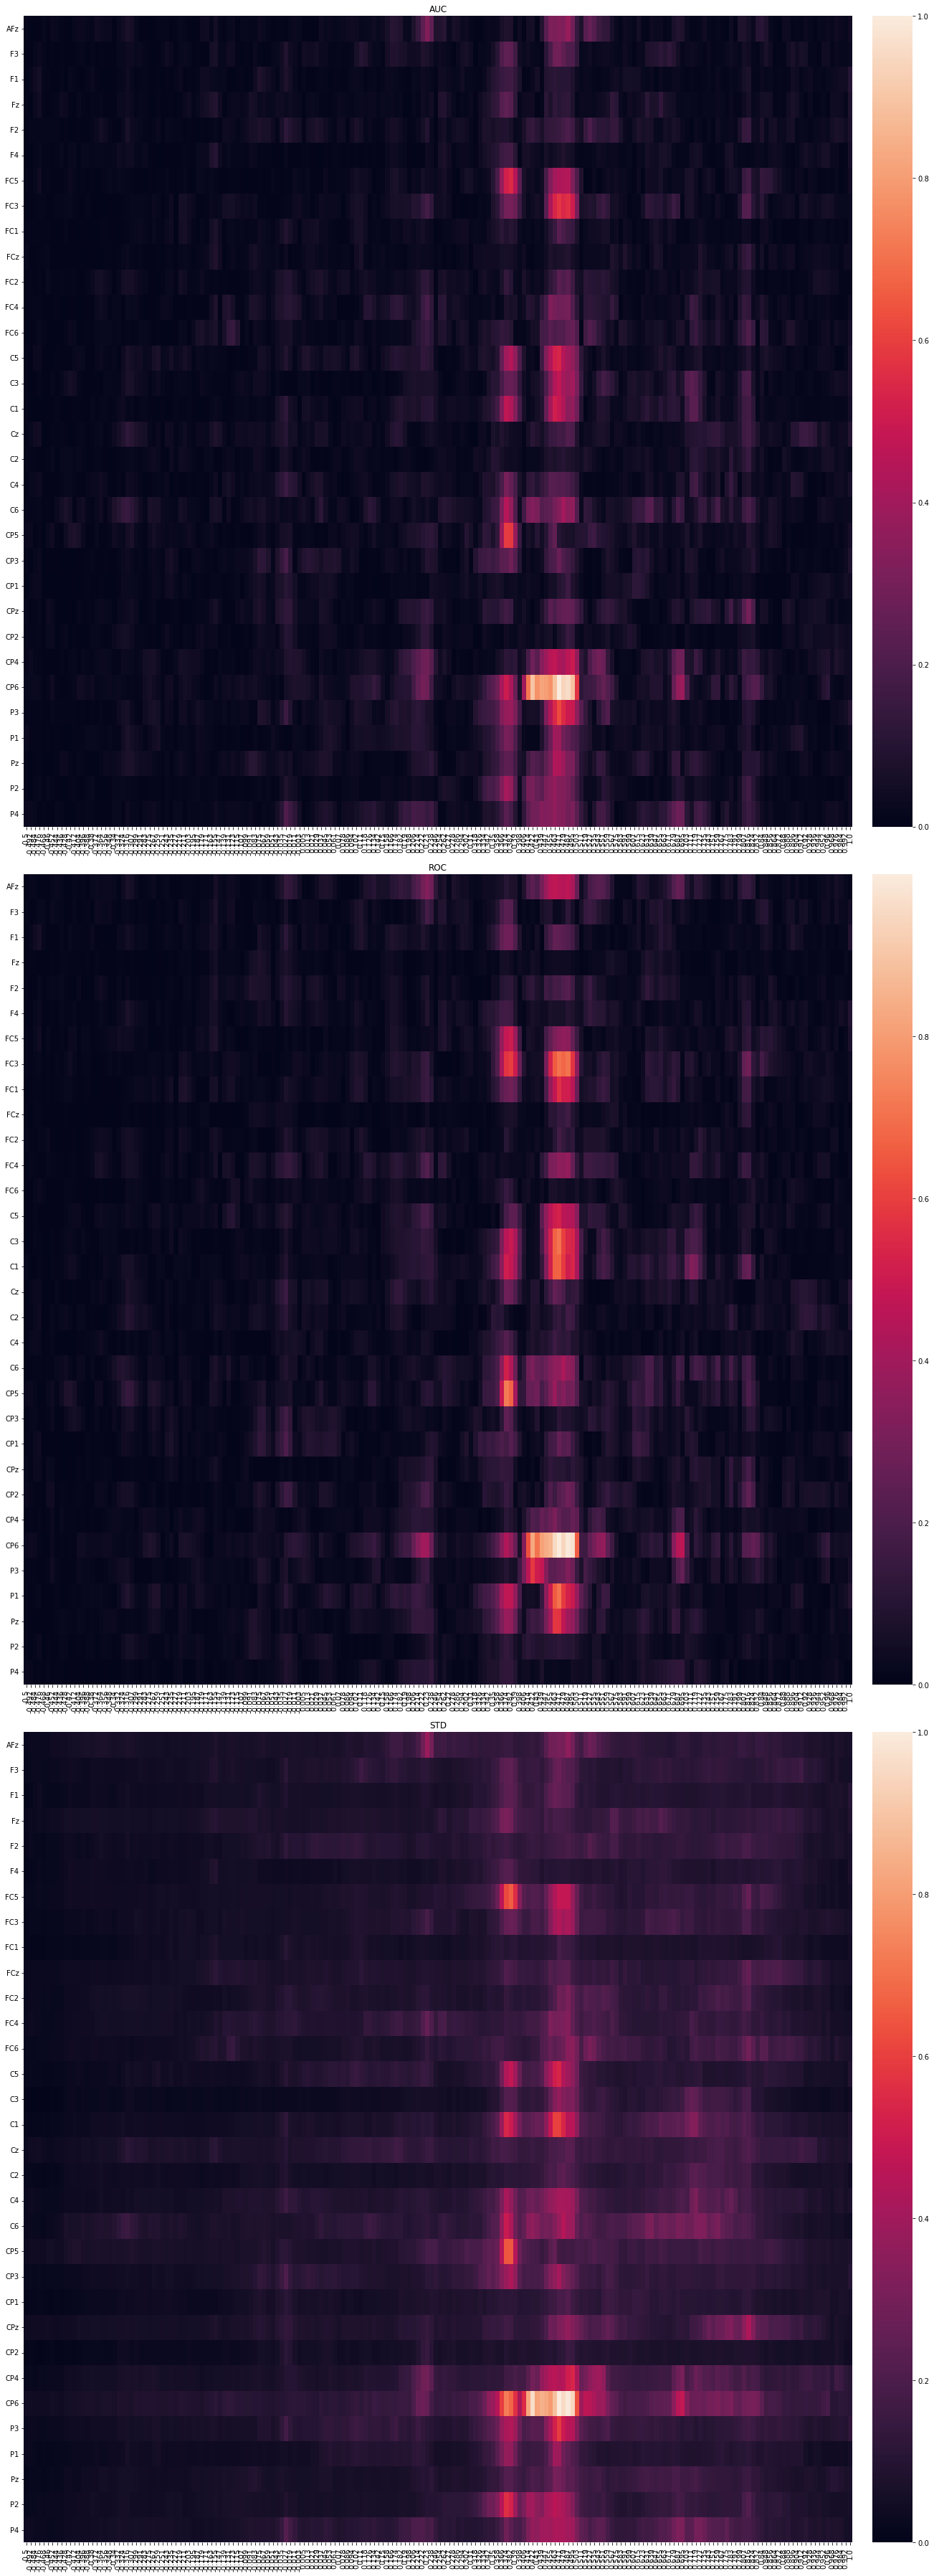

In [71]:
# # from utilities.subset_func import *
# # from utilities.utility_func import return_channels_index, return_timestep_labels

# # channels_index= return_channels_index()
# # timestep_labels= return_timestep_labels()
# fig, ax= plt.subplots(3,1)

# x_shape=0
# dictionaries={"AUC":[],"ROC":[],"STD":[]}
# for idx,p in enumerate(['S01']):#enumerate(participants):
#     dictionary= Grad_AUC_with_multivar_grad(participants_grads_dictionary[p],
#                                             n_epochs,
#                                             X=np.zeros(input_dim),
#                                             x_shape=x_shape
#                                            )
#     dictionaries["AUC"].append(pd.DataFrame(dictionary).to_numpy())
# #     sns.heatmap(pd.DataFrame(dictionary), 
# #                 xticklabels=timestep_labels,
# #                 yticklabels=channels_index,
# #                 annot=False, ax=ax[idx], cbar_kws={"pad":0.02})
#     dictionary= Grad_ROC_with_multivar_grad(participants_grads_dictionary[p],
#                                             n_epochs,
#                                             np.zeros(input_dim),
#                                             x_shape=x_shape
#                                            )
#     dictionaries["ROC"].append(pd.DataFrame(dictionary).to_numpy())

#     dictionary= Grad_STD_with_multivar_grad(participants_grads_dictionary[p],
#                                             n_epochs,
#                                             np.zeros(input_dim),
#                                             x_shape=x_shape
#                                            )
#     dictionaries["STD"].append(pd.DataFrame(dictionary).to_numpy())


# #     ax[idx].set_ylabel(f"{p}")

# sns.heatmap(pd.DataFrame(np.array(dictionaries["AUC"]).mean(axis=0)), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[0],
#             annot=False, cbar_kws={"pad":0.02})

# ax[0].set_title("AUC")

# sns.heatmap(pd.DataFrame(np.array(dictionaries["ROC"]).mean(axis=0)), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[1],
#             annot=False, cbar_kws={"pad":0.02})
# ax[1].set_title("ROC")

# sns.heatmap(pd.DataFrame(np.array(dictionaries["STD"]).mean(axis=0)), 
#             xticklabels=timestep_labels,
#             yticklabels=channel_names, ax=ax[2],
#             annot=False, cbar_kws={"pad":0.02})
# ax[2].set_title("STD")

# # plt.suptitle("Relative Importance Estimate of Time Series")
# fig.set_figwidth(20)
# fig.set_figheight(50)
# plt.tight_layout()

AUC:, ['CP6', 'C6', 'CP4', 'P4', 'P3', 'C1', 'FC3', 'C5', 'Pz', 'C3', 'CPz', 'FC6', 'P2', 'FC5', 'CP5', 'FC4', 'Cz', 'AFz', 'C4', 'P1', 'CP3', 'F2', 'F3', 'FC2', 'Fz', 'C2', 'FC1', 'CP1', 'F1', 'FCz', 'CP2', 'F4']
ROC:, ['CP6', 'C1', 'CP5', 'P1', 'FC3', 'AFz', 'C6', 'C3', 'Pz', 'P3', 'C5', 'FC1', 'FC4', 'CP2', 'FC5', 'CP1', 'Cz', 'CP4', 'CP3', 'F1', 'F2', 'C2', 'F4', 'CPz', 'F3', 'P2', 'P4', 'C4', 'FC2', 'FC6', 'FCz', 'Fz']
STD:, ['CP6', 'C6', 'CP4', 'P4', 'P3', 'CP5', 'C1', 'C4', 'CPz', 'P2', 'Cz', 'CP3', 'FC5', 'FC4', 'FC6', 'AFz', 'Fz', 'C5', 'FC3', 'FCz', 'F2', 'Pz', 'F3', 'FC2', 'P1', 'C2', 'F1', 'C3', 'CP1', 'F4', 'FC1', 'CP2']

AUC:, [0.471, 0.463, 0.479, 0.487, 0.495, 0.455, 0.374, 0.382, 0.447, 0.366, 0.503, 0.39, 0.816, 0.439, 0.358, 0.422, 0.807, 0.23, 0.43, 0.222, 0.414, 0.35, 0.551, 0.238, 0.543, 0.687, 0.559, -0.027, 0.824, 0.719, 0.342, 0.679, 0.214, 0.519, 0.527, 0.398, 0.535, 0.711, 0.511, 0.334, 0.727, 0.695, 0.206, 0.406, -0.019, 0.567, 0.631, 0.703, 0.655, -0.035, 0

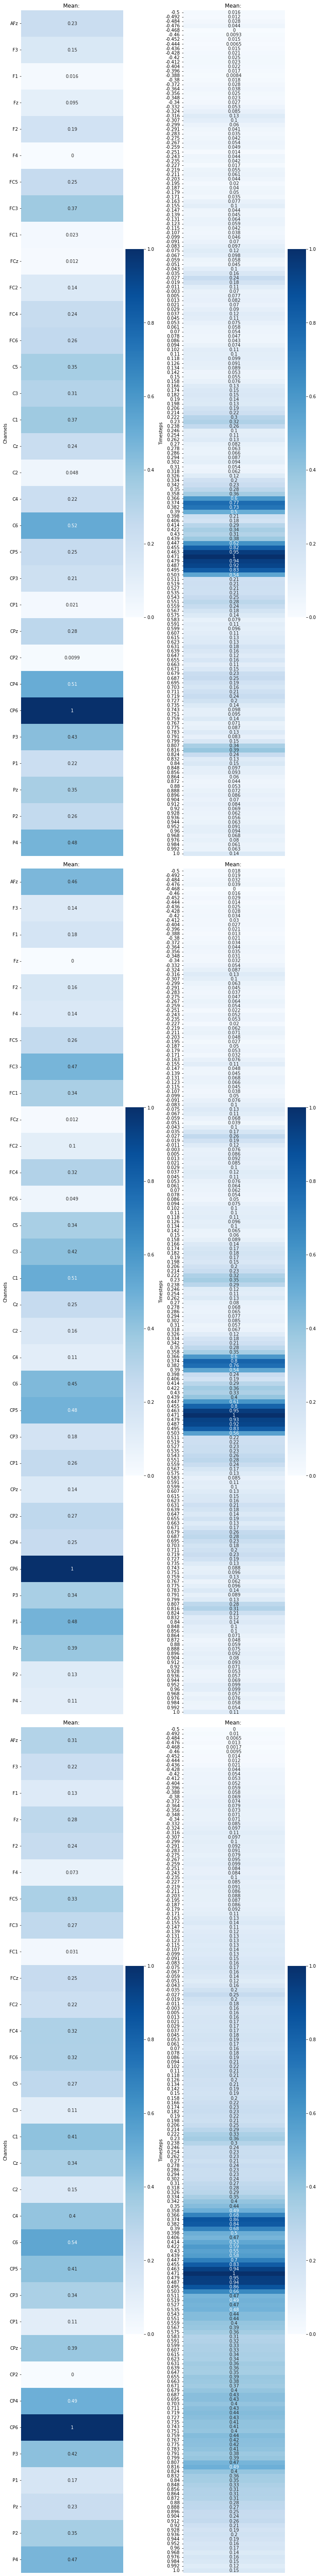

In [152]:

# ranking_list={"channels":{},"time":{}}
# df_list={"channels":{},"time":{}}
# fig, ax= plt.subplots(3,2)
# methods= ["AUC", "ROC", "STD"]

# for i in range(len(methods)):
#     scaler= MinMaxScaler()
#     df= pd.DataFrame(np.array(dictionaries[methods[i]]).mean(axis=0))

# #     channel_nonzero_count= np.count_nonzero(df.to_numpy()>threshold, axis=1)
    
# #     df_with_zeros= pd.DataFrame(channel_nonzero_count)
#     df.index= channel_names
    
#     df_list["channels"][methods[i]]=df.T.sum().to_numpy().reshape(-1)
# #     nonzeros_list= (df_with_zeros>0).to_numpy().reshape(-1)
# #     df= df_with_zeros[nonzeros_list]
#     scaled= scaler.fit_transform(df.T.sum().to_numpy().reshape(-1,1))
#     sns.heatmap(scaled,annot=True, 
#                 yticklabels=channel_names, ax=ax[i][0],cmap="Blues",
#                 xticklabels=False, cbar_kws={"pad":0.02})
#     ranking_list["channels"][methods[i]]=alternate_rank(dict(df.T.sum()), reverse=True)
#     ax[i][0].set_ylabel("Channels")
        
#     ax[i][0].set_title("Mean: ")

# #     ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=0)
    
    
# for i in range(len(methods)):
#     scaler= MinMaxScaler()
#     df= pd.DataFrame(np.array(dictionaries[methods[i]]).mean(axis=0))

#     # #     channel_nonzero_count= np.count_nonzero(df.to_numpy()>threshold, axis=1)

#     # #     df_with_zeros= pd.DataFrame(channel_nonzero_count)
#     df.index= channel_names
#     df.columns=timestep_labels

#     df_list["time"][methods[i]]=df.sum().to_numpy().reshape(-1)
# #     nonzeros_list= (df_with_zeros>0).to_numpy().reshape(-1)
# #     df= df_with_zeros[nonzeros_list]
#     scaled= scaler.fit_transform(df.sum().to_numpy().reshape(-1,1))
#     sns.heatmap(scaled,annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],cmap="Blues",
#                 xticklabels=False, cbar_kws={"pad":0.02})
#     ranking_list["time"][methods[i]]=alternate_rank(dict(df.sum()), reverse=True)
# #     timesteps_ranking=[]
# #     for t in alternate_rank(dict(df.sum()), reverse=True):
# #         timesteps_ranking.append(timestep_labels[t])
# #     ranking_list["time"][methods[i]]=timesteps_ranking
    
#     ax[i][1].set_title("Mean: ")
#     ax[i][1].set_ylabel("Timesteps")
# # #     ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=0)


# fig.set_figwidth(10)
# fig.set_figheight(80)
# plt.tight_layout()
# for k, v in ranking_list["channels"].items():
#     print(f"{k}:, {v}")
# print()
# for k, v in ranking_list["time"].items():
#     print(f"{k}:, {v}")

# # # pd.DataFrame(ranking_list, index=['AUC', 'ROC', 'STD']).transpose()

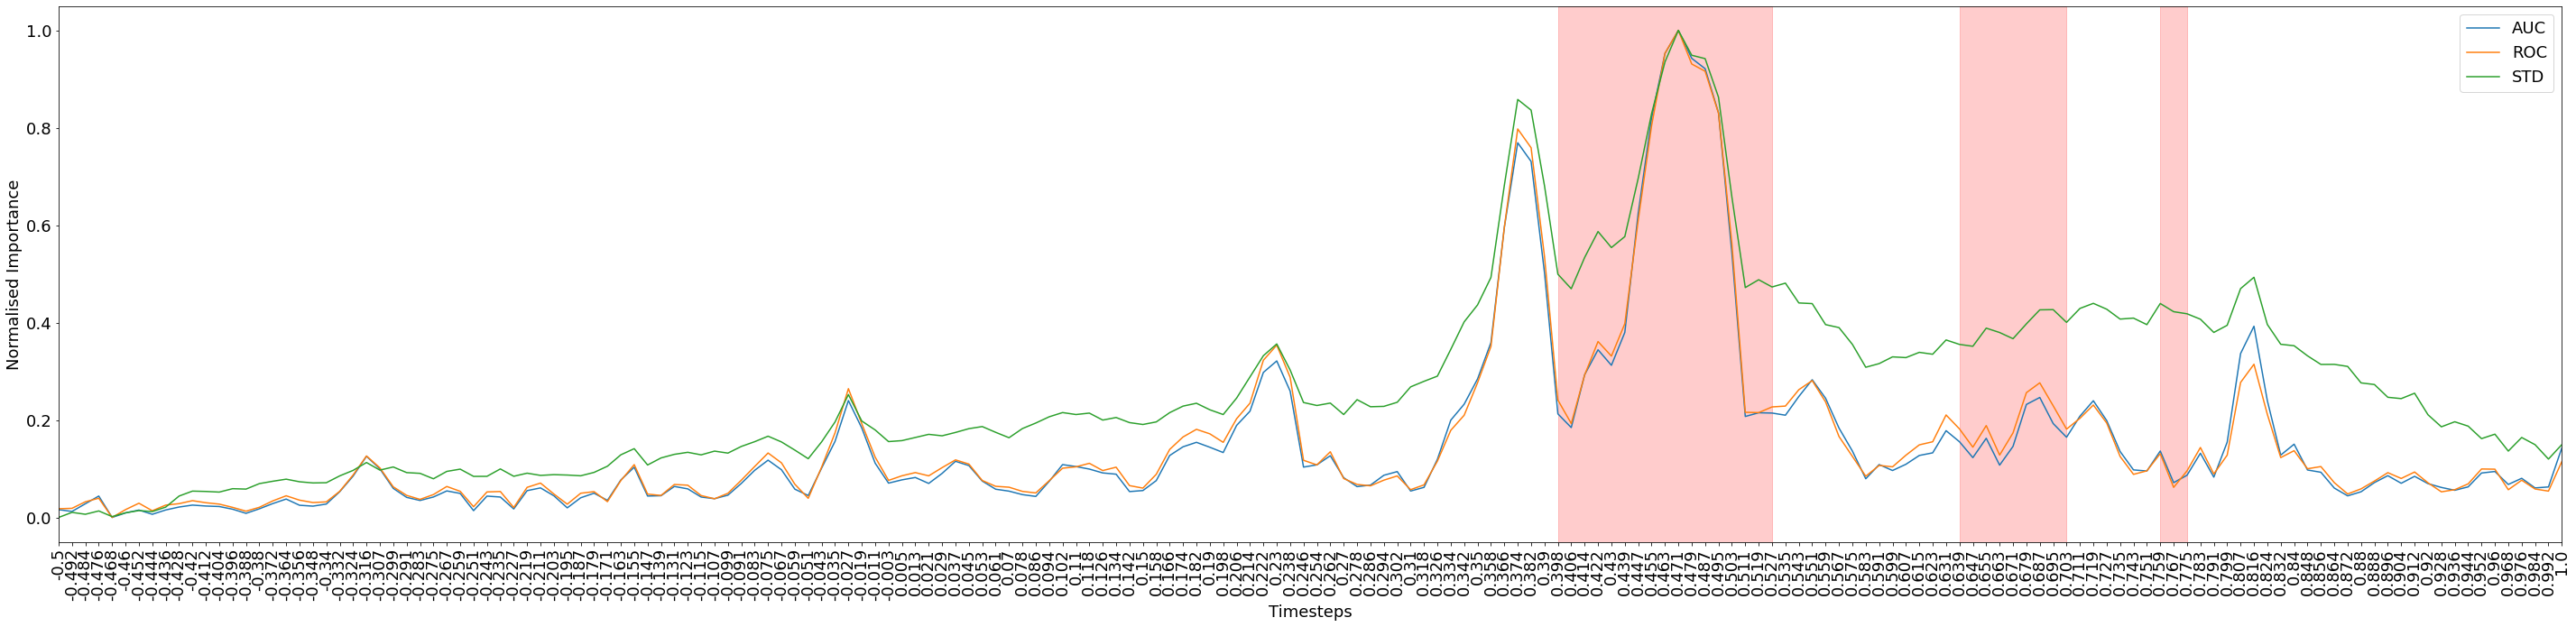

In [293]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(40,10))

# for i in range(len(methods)):
#     scaler= MinMaxScaler()
#     df= pd.DataFrame(np.array(dictionaries[methods[i]]).mean(axis=0))

#     # #     channel_nonzero_count= np.count_nonzero(df.to_numpy()>threshold, axis=1)

#     # #     df_with_zeros= pd.DataFrame(channel_nonzero_count)
#     df.index= channel_names
#     df.columns=timestep_labels
    
#     df_list["time"][methods[i]]=df.sum().to_numpy().reshape(-1)
# #     nonzeros_list= (df_with_zeros>0).to_numpy().reshape(-1)
# #     df= df_with_zeros[nonzeros_list]
#     scaled= scaler.fit_transform(df.sum().to_numpy().reshape(-1,1))
#     plt.plot(scaled)
# plt.legend(methods)
# plt.xlabel("Timesteps")
# plt.axvspan(112,128, color="red", alpha=0.2)
# plt.axvspan(142,150, color="red", alpha=0.2)
# plt.axvspan(157,159, color="red", alpha=0.2)
# plt.xticks([i for i in range(len(timestep_labels))],timestep_labels, rotation="vertical")
# plt.ylabel("Normalised Importance")
# plt.margins(x=0)
# plt.tight_layout()
# #     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
# #                 yticklabels=timestep_labels, ax=ax[i][1],
# #                 xticklabels=False, cbar_kws={"pad":0.02})

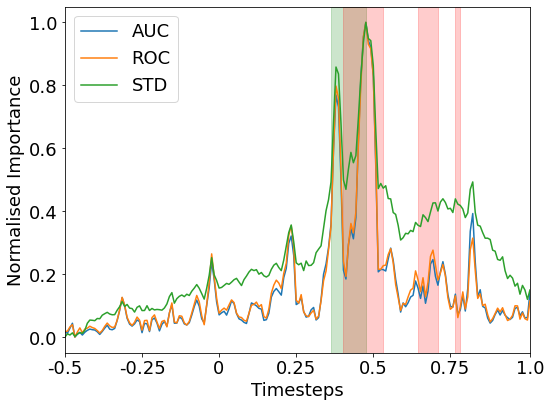

In [301]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

for i in range(len(methods)):
    scaler= MinMaxScaler()
    df= # INSERT AVERAGE SCORES HERE # pd.DataFrame(np.array(dictionaries[methods[i]]).mean(axis=0))
    
    df.index= channel_names
    df.columns=timestep_labels
    
    scaled= scaler.fit_transform(df.sum().to_numpy().reshape(-1,1))
    plt.plot(scaled)
plt.legend(methods)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()
#     sns.heatmap(df.sum().to_numpy().reshape(-1,1),annot=True, 
#                 yticklabels=timestep_labels, ax=ax[i][1],
#                 xticklabels=False, cbar_kws={"pad":0.02})

In [134]:
# coordinates= np.array([
#     [0.0002313, 0.080771], #AFz
#     [-0.0502438,  0.0531112], #F3
#     [-0.0274958,  0.0569311], #F1
#     [0.0003122, 0.058512], #Fz
#     [0.0295142, 0.0576019], #F2
#     [0.0518362, 0.0543048], #F4
#     [-0.0772149,  0.0186433], #FC5
#     [-0.0601819,  0.0227162], #FC3
#     [-0.0340619,  0.0260111], #FC1
#     [0.0003761, 0.02739], #FCz
#     [0.0347841, 0.0264379], # FC2
#     [0.0622931, 0.0237228], #FC4
#     [0.0795341, 0.0199357], #FC6
#     [-0.0802801, -0.0137597], #C5
#     [-0.0653581, -0.0116317], # C3
#     [-0.036158 , -0.0099839], # C1
#     [0.0004009, -0.009167], # Cz
#     [0.037672 , -0.0096241], # C2
#     [0.0671179, -0.0109003], #C4
#     [0.0834559, -0.0127763], #C6
#     [-0.0795922, -0.0465507], #CP5
#     [-0.0635562, -0.0470088], #CP3
#     [-0.0355131, -0.0472919], #CP1
#     [0.0003858, -0.047318], #CPz
#     [0.0383838, -0.0470731], #CP2
#     [0.0666118, -0.0466372], #CP4
#     [0.0833218, -0.0461013], #CP6
#     [-0.0530073, -0.0787878], #P3
#     [-0.0286203, -0.0805249], #P1
#     [0.0003247, -0.081115], #Pz
#     [0.0319197, -0.0804871], #P2
#     [0.0556667, -0.0785602], #P4
# ])
# x=coordinates[:,0]
# y=coordinates[:,1]

In [2]:
# for i in range(len(coordinates)):
#     plt.scatter(x[i],y[i])
# # plt.legend(channel_names)

In [1]:
# _=mne.channels.make_standard_montage("standard_1020")
# _.get_positions()

In [3]:
# import mne
# _=mne.channels.make_standard_montage("standard_1020").plot(sphere=0.11)

In [284]:
# import matplotlib
# fig= plt.figure()
# ax= plt.axes((0,0,1.5,1.5))
# im, _= mne.viz.plot_topomap(
#     df.T.sum().to_numpy().reshape(-1),
#     coordinates,
#     ch_type= "eeg",
#     sensors=True,
#     names=channel_names,
#     cmap="Blues",
#     axes=ax,
#     show=False
# #     res=4000
# )
# fig.add_axes(ax)
# cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
# clb= fig.colorbar(im, cax=cbar_ax)

# for tt in plt.findobj(fig, matplotlib.text.Text):
#     if tt.get_text() in channel_names:
#         tt.set_fontsize(12)

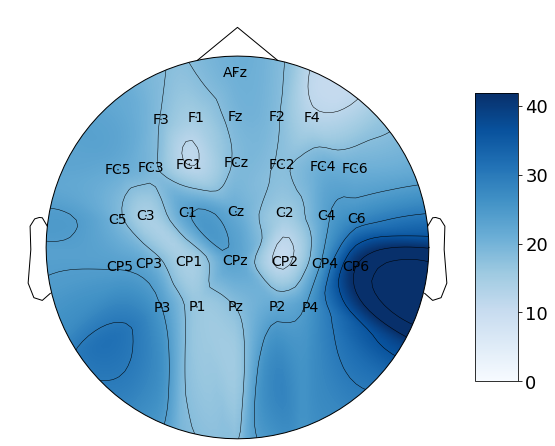

In [283]:
import matplotlib
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))
im, _= mne.viz.plot_topomap(
    df.T.sum().to_numpy().reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
#     sphere=0.09
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)